In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
! pip install rdkit pubchempy pyxlsb xlrd -q

# InChI Standardizsation Workflow


This workflow compares InChIs from four different sources: PubChem, OPSIN, NCI (CACTUS), and NIST Chemistry WebBook. The workflow sequentially checks each source (PubChem → NIST → OPSIN → NCI) in the specified order and validates the InChI from the first successful retrieval.

**The workflow is executed as follows:**
- Query the source using the original CAS Number/Chemical name.
- Query the source using the formatted CAS Number/Chemical name.
- Retrieve Synonyms from PubChem and try using them for querying PubChem in case there was no InChI retrieved from the original name.




In [74]:
import pandas as pd

In [75]:
filtered_df = pd.read_csv('Maindataset_SpeciesFilteredLOEC.csv')

In [76]:
filtered_df

CAS Number                                      Chemical Name  \
0         7487947                           Mercury chloride (HgCl2)   
1         7487947                           Mercury chloride (HgCl2)   
2         7487947                           Mercury chloride (HgCl2)   
3         7487947                           Mercury chloride (HgCl2)   
4         7487947                           Mercury chloride (HgCl2)   
...           ...                                                ...   
34453  1219922301  1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...   
34454  1219922301  1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...   
34455  1219922301  1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...   
34456  1219922301  1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...   
34457  2754428185  2-[(1,3-Dimethylbutyl)amino]-5-(phenylamino)2,...   

         Species Scientific Name Species Group  Conc Mean  Conc Units   \
0             Rana cyanophlyctis    Amphibians       0.960        mg/L   
1             Rana cyanophlyctis    Amphibians       0.960        mg/L   
2             Rana cyanophlyctis    Amphibians       0.960        mg/L   
3             Rana cyanophlyctis    Amphibians       0.960        mg/L   
4             Rana cyanophlyctis    Amphibians       0.960        mg/L   
...                          ...           ...         ...         ...   
34453     Microcystis aeruginosa         Algae       0.025        mg/L   
34454     Microcystis aeruginosa         Algae       0.025        mg/L   
34455     Microcystis aeruginosa         Algae       0.050        mg/L   
34456     Microcystis aeruginosa         Algae       0.050        mg/L   
34457  Chlamydomonas reinhardtii         Algae       0.250        mg/L   

      Endpoint  
0         LOEC  
1         LOEC  
2         LOEC  
3         LOEC  
4         LOEC  
...        ...  
34453     LOEC  
34454     LOEC  
34455     LOEC  
34456     LOEC  
34457     LOEC  

[34458 rows x 7 columns]

In [77]:
filtered_df['Chemical Name'].value_counts()

Chemical Name
Sulfuric acid copper(2+) salt (1:1)                                                                1452
Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester                             947
6-Chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine                                      833
Cadmium chloride (CdCl2)                                                                            709
Copper chloride (CuCl2)                                                                             697
                                                                                                   ... 
N-(2,6-Difluorophenyl)-5-methyl-[1,2,4]triazolo[1,5-a]pyrimidine-2-sulfonamide                        1
2-[[[[(4-Chloro-6-methoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Ethyl ester       1
2-Methoxyphenol                                                                                       1
(+-)-alpha-Methylbenzeneethanamine sulfate (2:1)  

After comparing structures, the returned InChI depends on the outcome of the comparison. Here’s the decision flow:

1. **If PubChem and OPSIN InChIs are identical:**
   - The PubChem (or OPSIN) InChI is returned.

2. **If PubChem and OPSIN InChIs differ but both are valid:**
   - A structural comparison is performed using RDKit.
   - **If the structures are identical (similarity = 1.0):**
     - The PubChem InChI is returned (you can adjust this to return the OPSIN InChI if preferred).
   - **If the structures are not identical:**
     - A decision is made based on your preference, but typically, you would choose either:
       - The PubChem InChI (default in the current implementation), or
       - You can modify it to return the InChI with the highest validation confidence.

3. **If only one source (PubChem or OPSIN) has a valid InChI:**
   - The valid InChI from that source is returned.

4. **If neither source provides a valid InChI:**
   - `None` is returned, indicating no valid InChI was found.


### Customization:
- You can decide which InChI to return in the case of structure mismatch. The code currently defaults to returning the PubChem InChI. If you'd prefer to return the OPSIN InChI or apply another rule, you can modify the `return` statement accordingly.

In [78]:
import concurrent.futures
from tqdm import tqdm  # Import tqdm for progress tracking
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException, Timeout
from rdkit import Chem
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'multiple_valid_match': 0,
            'single_valid': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'validation_failed': 0,
            'pubchem_valid': 0,
            'nist_valid': 0,
            'opsin_valid': 0,
            'nci_valid': 0
        }
        logging.info("Initialized InChIStandardizer with counters.")


    def format_cas_number(self, cas_number):
        """
        Formats a CAS number in the correct format.
        """
        cas_number = str(cas_number)
        check_digit = cas_number[-1]
        middle_part = cas_number[-3:-1]
        first_part = cas_number[:-3]
        return f"{first_part}-{middle_part}-{check_digit}"


    def format_chemical_name(self, chemical_name):
        """
        Formats the chemical name by removing the last part if it is in parentheses.
        Returns both the formatted chemical name and the last part inside the parentheses (if present).
        """
        smiles_candidate = None
        if " " in chemical_name:
            parts = chemical_name.split(" ")
            last_part = parts[-1]
            if "(" in last_part and ")" in last_part:
                smiles_candidate = last_part.strip("()")
                chemical_name = " ".join(parts[:-1])
                logging.info(f"Formatted chemical name to: {chemical_name} and extracted potential SMILES: {smiles_candidate}")
        return chemical_name, smiles_candidate


    def get_synonyms_pubchem(self, chemical_name):
        """
        Retrieves synonyms for a given chemical name from PubChem.
        """
        base_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{chemical_name}/synonyms/JSON"
        try:
            response = requests.get(base_url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                synonyms = data['InformationList']['Information'][0]['Synonym']
                return synonyms
            else:
                logging.error(f"Failed to retrieve synonyms from PubChem for {chemical_name}.")
                return None
        except Exception as e:
            logging.error(f"Error retrieving synonyms for {chemical_name}: {e}")
            return None


    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        logging.info(f"Retrieving InChI from PubChem for {chemical_name}.")
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            inchi = compounds[0].inchi if compounds else None
            return inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None


    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        logging.info(f"Retrieving InChI from OPSIN for {chemical_name}.")
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None


    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nci(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from the NCI (National Cancer Institute) database.
        """
        logging.info(f"Retrieving InChI from NCI for {chemical_name}.")
        try:
            url = f"https://cactus.nci.nih.gov/chemical/structure/{chemical_name}/stdinchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NCI for {chemical_name}: {e}")
            return None


    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        logging.info(f"Retrieving InChI from NIST for CAS {cas_number}.")
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None


    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        logging.info(f"Validating InChI: {inchi}")
        mol = Chem.MolFromInchi(inchi)
        return mol is not None


    def retrieve_inchi_with_synonyms(self, source_name, retrieve_function, chemical_name):
        """
        Attempts to retrieve the InChI and validate it, using synonyms if the first attempt fails.
        """
        inchi = retrieve_function(chemical_name)
        if not inchi:
            logging.info(f"No InChI retrieved from {source_name} for {chemical_name}, trying synonyms.")
            synonyms = self.get_synonyms_pubchem(chemical_name)
            if synonyms:
                for synonym in synonyms:
                    inchi = retrieve_function(synonym)
                    if inchi and self.validate_inchi(inchi):
                        chemical_name = synonym  # Update the name to the synonym
                        break
        if inchi and self.validate_inchi(inchi):
            self.counters[f'{source_name.lower()}_valid'] += 1
            logging.info(f"Valid InChI found from {source_name}.")
            return inchi
        return None


    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by sequentially retrieving from PubChem, NIST, OPSIN, and NCI.
        If no InChI is retrieved from PubChem, tries retrieving synonyms and re-attempts for all sources.
        Also attempts to use the last part of the formatted chemical name as a SMILES string to generate InChI using RDKit.
        """
        logging.info(f"Standardizing InChI for {chemical_name}.")

        # Format the chemical name and extract potential SMILES from the last part
        formatted_name, smiles_candidate = self.format_chemical_name(chemical_name)

        sources = [
            ("PubChem", self.retrieve_inchi_pubchem),
            ("NIST", lambda name: self.retrieve_inchi_nist(cas_number) if cas_number else None),
            ("OPSIN", self.retrieve_inchi_opsin),
            ("NCI", self.retrieve_inchi_nci)
        ]

        valid_inchi = None
        valid_source = None
        validation_info = []  # List to store validation information

        # Try to retrieve InChI using the original CAS number and chemical name first
        for source_name, retrieve_function in sources:
            inchi = self.retrieve_inchi_with_synonyms(source_name, retrieve_function, chemical_name)
            if inchi:
                valid_inchi = inchi
                valid_source = source_name
                validation_info.append(f"Original name: {chemical_name}")
                break

        # If no valid InChI is found, attempt to use the SMILES candidate extracted from the last part
        if not valid_inchi and smiles_candidate:
            mol = Chem.MolFromSmiles(smiles_candidate)
            if mol:
                valid_inchi = Chem.MolToInchi(mol)
                valid_source = "SMILES from parentheses"
                validation_info.append(f"SMILES: {smiles_candidate}")
                logging.info(f"Valid InChI generated from Candidate SMILES extracted from Chemical Name: {valid_inchi}")

        # If still no valid InChI, try the formatted chemical name
        if not valid_inchi and formatted_name != chemical_name:
            logging.info(f"Retrying with formatted chemical name: {formatted_name}")
            for source_name, retrieve_function in sources:
                inchi = self.retrieve_inchi_with_synonyms(source_name, retrieve_function, formatted_name)
                if inchi:
                    valid_inchi = inchi
                    valid_source = f"{source_name} (formatted name)"
                    validation_info.append(f"Formatted name: {formatted_name}")
                    break

        # If no valid InChI is found and we have a CAS number, try with the formatted CAS number
        if not valid_inchi and cas_number:
            formatted_cas_number = self.format_cas_number(cas_number)
            logging.info(f"Retrying with formatted CAS number: {formatted_cas_number}")
            for source_name, retrieve_function in sources:
                inchi = retrieve_function(formatted_cas_number)
                if inchi and self.validate_inchi(inchi):
                    valid_inchi = inchi
                    valid_source = f"{source_name} (formatted CAS)"
                    validation_info.append(f"Formatted CAS: {formatted_cas_number}")
                    break

        # Finalize and return the result
        if valid_inchi:
            self.counters['single_valid'] += 1
            notes = f"Validated InChI found from {valid_source}. " + ", ".join(validation_info)
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No valid InChI found"

        return valid_inchi, notes


    def process_single_chemical(self, chemical_name, cas_number):
        """
        Process a single chemical name and its CAS number to standardize and validate InChI.
        """
        logging.info(f"Processing single chemical: {chemical_name}")
        return self.standardize_inchi(chemical_name, cas_number)


    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number', max_workers=3):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names using parallel processing.
        """
        logging.info("Starting parallel processing of chemicals.")
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()

        results = {}

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_chemical = {
                executor.submit(self.process_single_chemical, row[chemical_name_column], row[cas_number_column]): (row[chemical_name_column], row[cas_number_column])
                for _, row in unique_chemicals.iterrows()
            }

        # Include tqdm progress bar here
            for future in tqdm(concurrent.futures.as_completed(future_to_chemical), total=len(future_to_chemical)):
                chemical_name, cas_number = future_to_chemical[future]
                try:
                    results[chemical_name] = future.result()
                    logging.info(f"Completed processing for {chemical_name}")
                except Exception as exc:
                    logging.error(f"Error processing {chemical_name}: {exc}")

        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        logging.info("Completed processing of all chemicals.")
        return df


    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")


# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df


2024-10-31 22:57:43,923 - root - INFO - Initialized InChIStandardizer with counters.
2024-10-31 22:57:43,925 - root - INFO - Starting parallel processing of chemicals.
2024-10-31 22:57:43,941 - root - INFO - Processing single chemical: Mercury chloride (HgCl2)
2024-10-31 22:57:43,946 - root - INFO - Standardizing InChI for Mercury chloride (HgCl2).
2024-10-31 22:57:43,947 - root - INFO - Processing single chemical: [[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese
2024-10-31 22:57:43,948 - root - INFO - Formatted chemical name to: Mercury chloride and extracted potential SMILES: HgCl2
2024-10-31 22:57:43,950 - root - INFO - Processing single chemical: 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin 3-oxide
2024-10-31 22:57:43,993 - root - INFO - Standardizing InChI for [[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese.


  0%|                                                                                         | 0/1540 [00:00<?, ?it/s]

2024-10-31 22:57:44,124 - root - INFO - Retrieving InChI from PubChem for Mercury chloride (HgCl2).
2024-10-31 22:57:44,127 - root - INFO - Standardizing InChI for 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin 3-oxide.
2024-10-31 22:57:44,129 - root - INFO - Retrieving InChI from PubChem for [[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese.
2024-10-31 22:57:44,136 - root - INFO - Retrieving InChI from PubChem for 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin 3-oxide.
2024-10-31 22:57:44,959 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:57:44,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:57:44,961 - root - INFO - No InChI retrieved from PubChem for 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin 3-oxide, trying synonyms.
2024-10-31 22:57:44,96

  0%|                                                                                 | 1/1540 [00:00<21:42,  1.18it/s]

2024-10-31 22:57:44,973 - root - INFO - Standardizing InChI for Phosphorothioic acid O,O-dimethyl O-(3-methyl-4-nitrophenyl)ester.
2024-10-31 22:57:44,977 - root - INFO - Formatted chemical name to: Phosphorothioic acid O,O-dimethyl and extracted potential SMILES: O-(3-methyl-4-nitrophenyl)ester
2024-10-31 22:57:44,978 - root - INFO - Retrieving InChI from PubChem for Phosphorothioic acid O,O-dimethyl O-(3-methyl-4-nitrophenyl)ester.
2024-10-31 22:57:45,758 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:57:45,760 - root - INFO - No InChI retrieved from PubChem for Phosphorothioic acid O,O-dimethyl O-(3-methyl-4-nitrophenyl)ester, trying synonyms.
2024-10-31 22:57:46,090 - root - ERROR - Failed to retrieve synonyms from PubChem for 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin 3-oxide.
2024-10-31 22:57:46,095 - root - INFO - Retrieving InChI from NIST for CAS 115297.
2024-10-31 22:57:46,097 - root - 

  0%|                                                                                 | 2/1540 [00:03<49:04,  1.91s/it]

2024-10-31 22:57:47,942 - root - INFO - Validating InChI: InChI=1S/C9H12NO5PS/c1-7-6-8(4-5-9(7)10(11)12)15-16(17,13-2)14-3/h4-6H,1-3H3
2024-10-31 22:57:47,942 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:57:47,942 - root - INFO - Processing single chemical: 2aR,3S,4S,4aR,5S,7aS,8S,10R,10aS,10bR)-10-(Acetyloxy)octahydro-3,5-dihydroxy-4-methyl-8-[[(2E)-2-methyl-1-oxo-2-buten-1-yl]oxy]-4-[(1aR,2S,3aS,6aS,7S,7aS)-3a,6a,7,7a-tetrahydro-6a-hydroxy-7a-methyl-2,7-methanofuro[2,3-b]oxireno[e]oxepin-1a(2H)-yl]-1H,7H-naptho[1,8-bc:4,4a-c']difuran-5,10a(8H)-dicarboxylic acid 5-10a-dimethyl ester
2024-10-31 22:57:47,942 - root - INFO - Completed processing for Phosphorothioic acid O,O-dimethyl O-(3-methyl-4-nitrophenyl)ester


  0%|▏                                                                                | 3/1540 [00:03<30:11,  1.18s/it]

2024-10-31 22:57:47,942 - root - INFO - Standardizing InChI for 2aR,3S,4S,4aR,5S,7aS,8S,10R,10aS,10bR)-10-(Acetyloxy)octahydro-3,5-dihydroxy-4-methyl-8-[[(2E)-2-methyl-1-oxo-2-buten-1-yl]oxy]-4-[(1aR,2S,3aS,6aS,7S,7aS)-3a,6a,7,7a-tetrahydro-6a-hydroxy-7a-methyl-2,7-methanofuro[2,3-b]oxireno[e]oxepin-1a(2H)-yl]-1H,7H-naptho[1,8-bc:4,4a-c']difuran-5,10a(8H)-dicarboxylic acid 5-10a-dimethyl ester.
2024-10-31 22:57:47,942 - root - INFO - Retrieving InChI from PubChem for 2aR,3S,4S,4aR,5S,7aS,8S,10R,10aS,10bR)-10-(Acetyloxy)octahydro-3,5-dihydroxy-4-methyl-8-[[(2E)-2-methyl-1-oxo-2-buten-1-yl]oxy]-4-[(1aR,2S,3aS,6aS,7S,7aS)-3a,6a,7,7a-tetrahydro-6a-hydroxy-7a-methyl-2,7-methanofuro[2,3-b]oxireno[e]oxepin-1a(2H)-yl]-1H,7H-naptho[1,8-bc:4,4a-c']difuran-5,10a(8H)-dicarboxylic acid 5-10a-dimethyl ester.
2024-10-31 22:57:48,131 - root - INFO - Validating InChI: InChI=1S/2Al.O5Si2.2H2O.2O/c;;1-6(2)5-7(3)4;;;;/h;;;2*1H2;;/q2*+1;-2;;;;
2024-10-31 22:57:48,131 - root - INFO - Valid InChI found from 

  0%|▏                                                                                | 4/1540 [00:04<20:10,  1.27it/s]

2024-10-31 22:57:48,131 - root - INFO - Standardizing InChI for 3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid, (3-Phenoxyphenyl)methyl ester.
2024-10-31 22:57:48,131 - root - INFO - Retrieving InChI from PubChem for 3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid, (3-Phenoxyphenyl)methyl ester.
2024-10-31 22:57:48,412 - root - ERROR - Failed to retrieve synonyms from PubChem for [[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese.
2024-10-31 22:57:48,412 - root - INFO - Retrieving InChI from OPSIN for [[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese.
2024-10-31 22:57:48,443 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:57:48,443 - root - INFO - No InChI retrieved from PubChem for 2aR,3S,4S,4aR,5S,7aS,8S,10R,10aS,10bR)-10-(Acetyloxy)octahydro-3,5-dihydroxy-4-methyl-8-[[(2E)-2-methyl-1-oxo-2-buten-1-yl]oxy]-4-[(1aR,2S,3aS,6aS,7S,7aS)-3a,6a,7,7a-tetrah

  0%|▎                                                                                | 5/1540 [00:06<39:12,  1.53s/it]

2024-10-31 22:57:50,983 - root - INFO - Standardizing InChI for (1R,3R)-rel-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester.
2024-10-31 22:57:50,986 - root - INFO - Retrieving InChI from PubChem for (1R,3R)-rel-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester.
2024-10-31 22:57:51,473 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:57:51,474 - root - INFO - No InChI retrieved from PubChem for (1R,3R)-rel-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester, trying synonyms.
2024-10-31 22:57:51,649 - root - INFO - No InChI retrieved from NCI for [[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese, trying synonyms.
2024-10-31 22:57:51,702 - root - ERROR - Failed to retrieve syn

  0%|▎                                                                                | 6/1540 [00:09<46:12,  1.81s/it]

2024-10-31 22:57:53,323 - root - INFO - Standardizing InChI for 2-[1-Methyl-2-(4-phenoxyphenoxy)ethoxy]pyridine.
2024-10-31 22:57:53,327 - root - INFO - Retrieving InChI from PubChem for 2-[1-Methyl-2-(4-phenoxyphenoxy)ethoxy]pyridine.
2024-10-31 22:57:53,680 - root - ERROR - Failed to retrieve synonyms from PubChem for 2aR,3S,4S,4aR,5S,7aS,8S,10R,10aS,10bR)-10-(Acetyloxy)octahydro-3,5-dihydroxy-4-methyl-8-[[(2E)-2-methyl-1-oxo-2-buten-1-yl]oxy]-4-[(1aR,2S,3aS,6aS,7S,7aS)-3a,6a,7,7a-tetrahydro-6a-hydroxy-7a-methyl-2,7-methanofuro[2,3-b]oxireno[e]oxepin-1a(2H)-yl]-1H,7H-naptho[1,8-bc:4,4a-c']difuran-5,10a(8H)-dicarboxylic acid 5-10a-dimethyl ester.
2024-10-31 22:57:53,683 - root - INFO - Retrieving InChI from NCI for 2aR,3S,4S,4aR,5S,7aS,8S,10R,10aS,10bR)-10-(Acetyloxy)octahydro-3,5-dihydroxy-4-methyl-8-[[(2E)-2-methyl-1-oxo-2-buten-1-yl]oxy]-4-[(1aR,2S,3aS,6aS,7S,7aS)-3a,6a,7,7a-tetrahydro-6a-hydroxy-7a-methyl-2,7-methanofuro[2,3-b]oxireno[e]oxepin-1a(2H)-yl]-1H,7H-naptho[1,8-bc:4,4a-c

  0%|▎                                                                                | 7/1540 [00:09<35:13,  1.38s/it]

2024-10-31 22:57:53,818 - root - INFO - Standardizing InChI for 1-(1,1-Dimethylethyl)-2-(4-ethylbenzoyl)hydrazide-3,5-dimethylbenzoic acid.
2024-10-31 22:57:53,820 - root - INFO - Retrieving InChI from PubChem for 1-(1,1-Dimethylethyl)-2-(4-ethylbenzoyl)hydrazide-3,5-dimethylbenzoic acid.
2024-10-31 22:57:54,177 - root - INFO - Validating InChI: InChI=1S/C20H19NO3/c1-16(23-20-9-5-6-14-21-20)15-22-17-10-12-19(13-11-17)24-18-7-3-2-4-8-18/h2-14,16H,15H2,1H3
2024-10-31 22:57:54,179 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:57:54,180 - root - INFO - Processing single chemical: 3-Methoxymethylbenzoic acid 2-(3,5-dimethylbenzoyl)-2-(1,1-dimethylethyl)hydrazide
2024-10-31 22:57:54,180 - root - INFO - Completed processing for 2-[1-Methyl-2-(4-phenoxyphenoxy)ethoxy]pyridine


  1%|▍                                                                                | 8/1540 [00:10<26:56,  1.05s/it]

2024-10-31 22:57:54,181 - root - INFO - Standardizing InChI for 3-Methoxymethylbenzoic acid 2-(3,5-dimethylbenzoyl)-2-(1,1-dimethylethyl)hydrazide.
2024-10-31 22:57:54,184 - root - INFO - Formatted chemical name to: 3-Methoxymethylbenzoic acid and extracted potential SMILES: 2-(3,5-dimethylbenzoyl)-2-(1,1-dimethylethyl)hydrazide
2024-10-31 22:57:54,185 - root - INFO - Retrieving InChI from PubChem for 3-Methoxymethylbenzoic acid 2-(3,5-dimethylbenzoyl)-2-(1,1-dimethylethyl)hydrazide.
2024-10-31 22:57:54,299 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:57:54,300 - root - INFO - No InChI retrieved from PubChem for 1-(1,1-Dimethylethyl)-2-(4-ethylbenzoyl)hydrazide-3,5-dimethylbenzoic acid, trying synonyms.
2024-10-31 22:57:54,676 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:57:54,677 - root - INFO - No InChI retrieved from PubChem for 3-Methoxymethylbenzoic acid 2-(3,5-dimethylbenzoyl)-2-

  1%|▍                                                                                | 9/1540 [00:12<36:10,  1.42s/it]

2024-10-31 22:57:56,395 - root - INFO - Standardizing InChI for (4S,4aS,5aS,6S,12aS)-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-Naphthacenecarboxamide,Hydrochloride (1:1).
2024-10-31 22:57:56,399 - root - INFO - Formatted chemical name to: (4S,4aS,5aS,6S,12aS)-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-Naphthacenecarboxamide,Hydrochloride and extracted potential SMILES: 1:1
2024-10-31 22:57:56,400 - root - INFO - Retrieving InChI from PubChem for (4S,4aS,5aS,6S,12aS)-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-Naphthacenecarboxamide,Hydrochloride (1:1).
2024-10-31 22:57:56,687 - root - INFO - No InChI retrieved from NIST for 3-Methoxymethylbenzoic acid 2-(3,5-dimethylbenzoyl)-2-(1,1-dimethylethyl)hydrazide, trying synonyms.
2024-10-31 22:57:56,881 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given na

  1%|▌                                                                               | 10/1540 [00:14<43:10,  1.69s/it]

2024-10-31 22:57:58,705 - root - INFO - Standardizing InChI for Carbonic acid, Cadmium salt (1:1).
2024-10-31 22:57:58,707 - root - INFO - Formatted chemical name to: Carbonic acid, Cadmium salt and extracted potential SMILES: 1:1
2024-10-31 22:57:58,708 - root - INFO - Retrieving InChI from PubChem for Carbonic acid, Cadmium salt (1:1).
2024-10-31 22:57:59,016 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-(1,1-Dimethylethyl)-2-(4-ethylbenzoyl)hydrazide-3,5-dimethylbenzoic acid.
2024-10-31 22:57:59,019 - root - INFO - Retrieving InChI from NCI for 1-(1,1-Dimethylethyl)-2-(4-ethylbenzoyl)hydrazide-3,5-dimethylbenzoic acid.
2024-10-31 22:57:59,249 - root - INFO - Validating InChI: InChI=1S/C22H24N2O8.ClH/c1-21(31)8-5-4-6-11(25)12(8)16(26)13-9(21)7-10-15(24(2)3)17(27)14(20(23)30)19(29)22(10,32)18(13)28;/h4-6,9-10,15,25,27-28,31-32H,7H2,1-3H3,(H2,23,30);1H
2024-10-31 22:57:59,251 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:57:59,252 - root - INFO - Processi

  1%|▌                                                                               | 11/1540 [00:15<34:11,  1.34s/it]

2024-10-31 22:57:59,252 - root - INFO - Standardizing InChI for Lead(2+)salt carbamic acid (1:1).
2024-10-31 22:57:59,255 - root - INFO - Formatted chemical name to: Lead(2+)salt carbamic acid and extracted potential SMILES: 1:1
2024-10-31 22:57:59,256 - root - INFO - Retrieving InChI from PubChem for Lead(2+)salt carbamic acid (1:1).
2024-10-31 22:57:59,274 - root - INFO - Validating InChI: InChI=1S/CH2O3.Cd/c2-1(3)4;/h(H2,2,3,4);/q;+2/p-2
2024-10-31 22:57:59,275 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:57:59,276 - root - INFO - Processing single chemical: Carbonic acid, Copper(2+) salt (1:1)
2024-10-31 22:57:59,276 - root - INFO - Completed processing for Carbonic acid, Cadmium salt (1:1)
2024-10-31 22:57:59,277 - root - INFO - Standardizing InChI for Carbonic acid, Copper(2+) salt (1:1).
2024-10-31 22:57:59,280 - root - INFO - Formatted chemical name to: Carbonic acid, Copper(2+) salt and extracted potential SMILES: 1:1
2024-10-31 22:57:59,281 - root - INFO - Re

  1%|▋                                                                               | 13/1540 [00:15<21:33,  1.18it/s]

2024-10-31 22:57:59,814 - root - INFO - Standardizing InChI for 1,3,4,6,7,8-Hexahydro-4,6,6,7,8,8-hexamethylcyclopenta[g]-2-benzopyran.
2024-10-31 22:57:59,817 - root - INFO - Retrieving InChI from PubChem for 1,3,4,6,7,8-Hexahydro-4,6,6,7,8,8-hexamethylcyclopenta[g]-2-benzopyran.
2024-10-31 22:58:00,133 - root - INFO - No InChI retrieved from NCI for 1-(1,1-Dimethylethyl)-2-(4-ethylbenzoyl)hydrazide-3,5-dimethylbenzoic acid, trying synonyms.
2024-10-31 22:58:00,444 - root - INFO - Validating InChI: InChI=1S/C18H26O/c1-11-9-19-10-13-7-15-16(8-14(11)13)18(5,6)12(2)17(15,3)4/h7-8,11-12H,9-10H2,1-6H3
2024-10-31 22:58:00,445 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:00,446 - root - INFO - Processing single chemical: Cadmium oxide
2024-10-31 22:58:00,446 - root - INFO - Completed processing for 1,3,4,6,7,8-Hexahydro-4,6,6,7,8,8-hexamethylcyclopenta[g]-2-benzopyran


  1%|▋                                                                               | 14/1540 [00:16<20:10,  1.26it/s]

2024-10-31 22:58:00,447 - root - INFO - Standardizing InChI for Cadmium oxide.
2024-10-31 22:58:00,452 - root - INFO - Retrieving InChI from PubChem for Cadmium oxide.
2024-10-31 22:58:00,662 - root - ERROR - Failed to retrieve synonyms from PubChem for Lead(2+)salt carbamic acid (1:1).
2024-10-31 22:58:00,666 - root - INFO - Retrieving InChI from NIST for CAS 598630.
2024-10-31 22:58:00,964 - root - INFO - Validating InChI: InChI=1S/Cd.O
2024-10-31 22:58:00,966 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:00,967 - root - INFO - Processing single chemical: Nickel oxide (NiO)
2024-10-31 22:58:00,967 - root - INFO - Completed processing for Cadmium oxide
2024-10-31 22:58:00,968 - root - INFO - Standardizing InChI for Nickel oxide (NiO).
2024-10-31 22:58:00,972 - root - INFO - Formatted chemical name to: Nickel oxide and extracted potential SMILES: NiO
2024-10-31 22:58:00,974 - root - INFO - Retrieving InChI from PubChem for Nickel oxide (NiO).


  1%|▊                                                                               | 15/1540 [00:16<18:20,  1.39it/s]

2024-10-31 22:58:01,031 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-(1,1-Dimethylethyl)-2-(4-ethylbenzoyl)hydrazide-3,5-dimethylbenzoic acid.
2024-10-31 22:58:01,034 - root - INFO - Retrying with formatted CAS number: 112410-23-8
2024-10-31 22:58:01,036 - root - INFO - Retrieving InChI from PubChem for 112410-23-8.
2024-10-31 22:58:01,487 - root - INFO - Validating InChI: InChI=1S/Ni.O
2024-10-31 22:58:01,489 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:01,490 - root - INFO - Processing single chemical: Zinc oxide (ZnO)
2024-10-31 22:58:01,491 - root - INFO - Completed processing for Nickel oxide (NiO)


  1%|▊                                                                               | 16/1540 [00:17<16:57,  1.50it/s]

2024-10-31 22:58:01,492 - root - INFO - Standardizing InChI for Zinc oxide (ZnO).
2024-10-31 22:58:01,495 - root - INFO - Formatted chemical name to: Zinc oxide and extracted potential SMILES: ZnO
2024-10-31 22:58:01,496 - root - INFO - Retrieving InChI from PubChem for Zinc oxide (ZnO).
2024-10-31 22:58:01,668 - root - INFO - Validating InChI: InChI=1S/C22H28N2O2/c1-7-17-8-10-18(11-9-17)20(25)23-24(22(4,5)6)21(26)19-13-15(2)12-16(3)14-19/h8-14H,7H2,1-6H3,(H,23,25)
2024-10-31 22:58:01,668 - root - INFO - Processing single chemical: Lead oxide (PbO)
2024-10-31 22:58:01,668 - root - INFO - Completed processing for 1-(1,1-Dimethylethyl)-2-(4-ethylbenzoyl)hydrazide-3,5-dimethylbenzoic acid


  1%|▉                                                                               | 17/1540 [00:17<13:26,  1.89it/s]

2024-10-31 22:58:01,668 - root - INFO - Standardizing InChI for Lead oxide (PbO).
2024-10-31 22:58:01,668 - root - INFO - Formatted chemical name to: Lead oxide and extracted potential SMILES: PbO
2024-10-31 22:58:01,668 - root - INFO - Retrieving InChI from PubChem for Lead oxide (PbO).
2024-10-31 22:58:01,747 - root - INFO - No InChI retrieved from NIST for Lead(2+)salt carbamic acid (1:1), trying synonyms.
2024-10-31 22:58:02,012 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:02,012 - root - INFO - No InChI retrieved from PubChem for Zinc oxide (ZnO), trying synonyms.
2024-10-31 22:58:02,168 - root - INFO - Validating InChI: InChI=1S/O.Pb
2024-10-31 22:58:02,168 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:02,168 - root - INFO - Processing single chemical: Copper oxide (Cu2O)
2024-10-31 22:58:02,168 - root - INFO - Completed processing for Lead oxide (PbO)


  1%|▉                                                                               | 18/1540 [00:18<13:13,  1.92it/s]

2024-10-31 22:58:02,168 - root - INFO - Standardizing InChI for Copper oxide (Cu2O).
2024-10-31 22:58:02,168 - root - INFO - Formatted chemical name to: Copper oxide and extracted potential SMILES: Cu2O
2024-10-31 22:58:02,184 - root - INFO - Retrieving InChI from PubChem for Copper oxide (Cu2O).
2024-10-31 22:58:02,700 - root - INFO - Validating InChI: InChI=1S/2Cu.H2O/h;;1H2
2024-10-31 22:58:02,700 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:02,700 - root - INFO - Processing single chemical: Nitric acid, Copper(1+) salt
2024-10-31 22:58:02,700 - root - INFO - Completed processing for Copper oxide (Cu2O)


  1%|▉                                                                               | 19/1540 [00:18<13:17,  1.91it/s]

2024-10-31 22:58:02,700 - root - INFO - Standardizing InChI for Nitric acid, Copper(1+) salt.
2024-10-31 22:58:02,700 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Copper(1+) salt.
2024-10-31 22:58:02,715 - root - ERROR - Failed to retrieve synonyms from PubChem for Lead(2+)salt carbamic acid (1:1).
2024-10-31 22:58:02,731 - root - INFO - Retrieving InChI from OPSIN for Lead(2+)salt carbamic acid (1:1).
2024-10-31 22:58:02,972 - root - ERROR - Failed to retrieve synonyms from PubChem for Zinc oxide (ZnO).
2024-10-31 22:58:02,972 - root - INFO - Retrieving InChI from NIST for CAS 1314132.
2024-10-31 22:58:03,176 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:03,192 - root - INFO - No InChI retrieved from PubChem for Nitric acid, Copper(1+) salt, trying synonyms.
2024-10-31 22:58:03,713 - root - INFO - No InChI retrieved from OPSIN for Lead(2+)salt carbamic acid (1:1), trying synonyms.
2024-10-31 22:58:04,133 - root - E

  1%|█                                                                               | 20/1540 [00:20<21:05,  1.20it/s]

2024-10-31 22:58:04,276 - root - INFO - Standardizing InChI for Carbonic acid, Nickel(2+) Salt (1:1).
2024-10-31 22:58:04,279 - root - INFO - Formatted chemical name to: Carbonic acid, Nickel(2+) Salt and extracted potential SMILES: 1:1
2024-10-31 22:58:04,279 - root - INFO - Retrieving InChI from PubChem for Carbonic acid, Nickel(2+) Salt (1:1).
2024-10-31 22:58:04,665 - root - ERROR - Failed to retrieve synonyms from PubChem for Lead(2+)salt carbamic acid (1:1).
2024-10-31 22:58:04,668 - root - INFO - Retrieving InChI from NCI for Lead(2+)salt carbamic acid (1:1).
2024-10-31 22:58:04,776 - root - INFO - Validating InChI: InChI=1S/CH2O3.Ni/c2-1(3)4;/h(H2,2,3,4);/q;+2/p-2
2024-10-31 22:58:04,777 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:04,778 - root - INFO - Processing single chemical: Carbonic acid, Zinc salt (1:1)
2024-10-31 22:58:04,778 - root - INFO - Completed processing for Carbonic acid, Nickel(2+) Salt (1:1)


  1%|█                                                                               | 21/1540 [00:20<18:37,  1.36it/s]

2024-10-31 22:58:04,779 - root - INFO - Standardizing InChI for Carbonic acid, Zinc salt (1:1).
2024-10-31 22:58:04,782 - root - INFO - Formatted chemical name to: Carbonic acid, Zinc salt and extracted potential SMILES: 1:1
2024-10-31 22:58:04,783 - root - INFO - Retrieving InChI from PubChem for Carbonic acid, Zinc salt (1:1).
2024-10-31 22:58:05,218 - root - INFO - No InChI retrieved from NIST for Nitric acid, Copper(1+) salt, trying synonyms.
2024-10-31 22:58:05,269 - root - INFO - Validating InChI: InChI=1S/CH2O3.Zn/c2-1(3)4;/h(H2,2,3,4);/q;+2/p-2
2024-10-31 22:58:05,271 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:05,272 - root - INFO - Processing single chemical: (4R)-1-Methyl-4-(1-methylethenyl)cyclohexene
2024-10-31 22:58:05,273 - root - INFO - Completed processing for Carbonic acid, Zinc salt (1:1)


  1%|█▏                                                                              | 22/1540 [00:21<16:47,  1.51it/s]

2024-10-31 22:58:05,274 - root - INFO - Standardizing InChI for (4R)-1-Methyl-4-(1-methylethenyl)cyclohexene.
2024-10-31 22:58:05,276 - root - INFO - Retrieving InChI from PubChem for (4R)-1-Methyl-4-(1-methylethenyl)cyclohexene.
2024-10-31 22:58:05,763 - root - INFO - No InChI retrieved from NCI for Lead(2+)salt carbamic acid (1:1), trying synonyms.
2024-10-31 22:58:05,872 - root - INFO - Validating InChI: InChI=1S/C10H16/c1-8(2)10-6-4-9(3)5-7-10/h4,10H,1,5-7H2,2-3H3/t10-/m0/s1
2024-10-31 22:58:05,872 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:05,872 - root - INFO - Processing single chemical: Sulfuric acid, Lead(2+) salt (1:1)
2024-10-31 22:58:05,888 - root - INFO - Standardizing InChI for Sulfuric acid, Lead(2+) salt (1:1).
2024-10-31 22:58:05,888 - root - INFO - Formatted chemical name to: Sulfuric acid, Lead(2+) salt and extracted potential SMILES: 1:1
2024-10-31 22:58:05,888 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Lead(2+) salt (1:1)

  1%|█▏                                                                              | 23/1540 [00:21<16:31,  1.53it/s]

2024-10-31 22:58:06,106 - root - ERROR - Failed to retrieve synonyms from PubChem for Nitric acid, Copper(1+) salt.
2024-10-31 22:58:06,106 - root - INFO - Retrieving InChI from OPSIN for Nitric acid, Copper(1+) salt.
2024-10-31 22:58:06,388 - root - INFO - Validating InChI: InChI=1S/H2O4S.Pb/c1-5(2,3)4;/h(H2,1,2,3,4);/q;+2/p-2
2024-10-31 22:58:06,388 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:06,388 - root - INFO - Processing single chemical: Copper chloride (CuCl2)
2024-10-31 22:58:06,388 - root - INFO - Completed processing for Sulfuric acid, Lead(2+) salt (1:1)
2024-10-31 22:58:06,388 - root - INFO - Standardizing InChI for Copper chloride (CuCl2).


  2%|█▏                                                                              | 24/1540 [00:22<15:14,  1.66it/s]

2024-10-31 22:58:06,388 - root - INFO - Formatted chemical name to: Copper chloride and extracted potential SMILES: CuCl2
2024-10-31 22:58:06,388 - root - INFO - Retrieving InChI from PubChem for Copper chloride (CuCl2).
2024-10-31 22:58:06,665 - root - ERROR - Failed to retrieve synonyms from PubChem for Lead(2+)salt carbamic acid (1:1).
2024-10-31 22:58:06,681 - root - INFO - Retrying with formatted chemical name: Lead(2+)salt carbamic acid
2024-10-31 22:58:06,681 - root - INFO - Retrieving InChI from PubChem for Lead(2+)salt carbamic acid.


[22:58:06] SMILES Parse Error: syntax error while parsing: 1:1
[22:58:06] SMILES Parse Error: Failed parsing SMILES '1:1' for input: '1:1'


2024-10-31 22:58:06,885 - root - INFO - Validating InChI: InChI=1S/2ClH.Cu/h2*1H;/q;;+2/p-2
2024-10-31 22:58:06,901 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:06,901 - root - INFO - Processing single chemical: Zinc chloride (ZnCl2)
2024-10-31 22:58:06,901 - root - INFO - Completed processing for Copper chloride (CuCl2)


  2%|█▎                                                                              | 25/1540 [00:22<14:32,  1.74it/s]

2024-10-31 22:58:06,901 - root - INFO - Standardizing InChI for Zinc chloride (ZnCl2).
2024-10-31 22:58:06,901 - root - INFO - Formatted chemical name to: Zinc chloride and extracted potential SMILES: ZnCl2
2024-10-31 22:58:06,901 - root - INFO - Retrieving InChI from PubChem for Zinc chloride (ZnCl2).
2024-10-31 22:58:07,010 - root - INFO - No InChI retrieved from OPSIN for Nitric acid, Copper(1+) salt, trying synonyms.
2024-10-31 22:58:07,166 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:07,166 - root - INFO - No InChI retrieved from PubChem for Lead(2+)salt carbamic acid, trying synonyms.
2024-10-31 22:58:07,416 - root - INFO - Validating InChI: InChI=1S/2ClH.Zn/h2*1H;/q;;+2/p-2
2024-10-31 22:58:07,416 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:07,416 - root - INFO - Processing single chemical: Nickel chloride (NiCl2)
2024-10-31 22:58:07,416 - root - INFO - Completed processing for Zinc chloride (ZnCl2)
2024-

  2%|█▎                                                                              | 26/1540 [00:23<14:04,  1.79it/s]

2024-10-31 22:58:07,416 - root - INFO - Retrieving InChI from PubChem for Nickel chloride (NiCl2).
2024-10-31 22:58:07,928 - root - INFO - Validating InChI: InChI=1S/2ClH.Ni/h2*1H;/q;;+2/p-2
2024-10-31 22:58:07,930 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:07,931 - root - INFO - Processing single chemical: Sulfuric acid, Zinc salt (1:1)
2024-10-31 22:58:07,933 - root - INFO - Standardizing InChI for Sulfuric acid, Zinc salt (1:1).
2024-10-31 22:58:07,932 - root - INFO - Completed processing for Nickel chloride (NiCl2)


  2%|█▍                                                                              | 27/1540 [00:23<13:46,  1.83it/s]

2024-10-31 22:58:07,933 - root - INFO - Formatted chemical name to: Sulfuric acid, Zinc salt and extracted potential SMILES: 1:1
2024-10-31 22:58:07,936 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Zinc salt (1:1).
2024-10-31 22:58:08,011 - root - ERROR - Failed to retrieve synonyms from PubChem for Nitric acid, Copper(1+) salt.
2024-10-31 22:58:08,015 - root - INFO - Retrieving InChI from NCI for Nitric acid, Copper(1+) salt.
2024-10-31 22:58:08,134 - root - ERROR - Failed to retrieve synonyms from PubChem for Lead(2+)salt carbamic acid.
2024-10-31 22:58:08,137 - root - INFO - Retrieving InChI from NIST for CAS 598630.
2024-10-31 22:58:08,457 - root - INFO - Validating InChI: InChI=1S/H2O4S.Zn/c1-5(2,3)4;/h(H2,1,2,3,4);/q;+2/p-2
2024-10-31 22:58:08,458 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:08,460 - root - INFO - Processing single chemical: Lead chloride (PbCl2)
2024-10-31 22:58:08,460 - root - INFO - Completed processing for Sulfuric acid

  2%|█▍                                                                              | 28/1540 [00:24<13:37,  1.85it/s]

2024-10-31 22:58:08,973 - root - INFO - Validating InChI: InChI=1S/2ClH.Pb/h2*1H;/q;;+2/p-2
2024-10-31 22:58:08,975 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:08,977 - root - INFO - Processing single chemical: Sulfuric acid copper(2+) salt (1:1)
2024-10-31 22:58:08,977 - root - INFO - Completed processing for Lead chloride (PbCl2)


  2%|█▌                                                                              | 29/1540 [00:24<13:26,  1.87it/s]

2024-10-31 22:58:08,978 - root - INFO - Standardizing InChI for Sulfuric acid copper(2+) salt (1:1).
2024-10-31 22:58:08,980 - root - INFO - Formatted chemical name to: Sulfuric acid copper(2+) salt and extracted potential SMILES: 1:1
2024-10-31 22:58:08,981 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid copper(2+) salt (1:1).
2024-10-31 22:58:09,213 - root - INFO - No InChI retrieved from NCI for Nitric acid, Copper(1+) salt, trying synonyms.
2024-10-31 22:58:09,314 - root - INFO - No InChI retrieved from NIST for Lead(2+)salt carbamic acid, trying synonyms.
2024-10-31 22:58:09,499 - root - INFO - Validating InChI: InChI=1S/Cu.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q+2;/p-2
2024-10-31 22:58:09,500 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:09,502 - root - INFO - Processing single chemical: Nitric acid, Zinc salt (2:1)
2024-10-31 22:58:09,504 - root - INFO - Standardizing InChI for Nitric acid, Zinc salt (2:1).
2024-10-31 22:58:09,505 - root - INFO - Fo

  2%|█▌                                                                              | 30/1540 [00:25<13:32,  1.86it/s]

2024-10-31 22:58:09,997 - root - INFO - Validating InChI: InChI=1S/2NO3.Zn/c2*2-1(3)4;/q2*-1;+2
2024-10-31 22:58:10,012 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:10,012 - root - INFO - Processing single chemical: Sulfuric acid, Nickel(2+)salt (1:1)
2024-10-31 22:58:10,012 - root - INFO - Completed processing for Nitric acid, Zinc salt (2:1)


  2%|█▌                                                                              | 31/1540 [00:25<13:07,  1.92it/s]

2024-10-31 22:58:10,012 - root - INFO - Standardizing InChI for Sulfuric acid, Nickel(2+)salt (1:1).
2024-10-31 22:58:10,012 - root - INFO - Formatted chemical name to: Sulfuric acid, Nickel(2+)salt and extracted potential SMILES: 1:1
2024-10-31 22:58:10,012 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Nickel(2+)salt (1:1).
2024-10-31 22:58:10,278 - root - ERROR - Failed to retrieve synonyms from PubChem for Nitric acid, Copper(1+) salt.
2024-10-31 22:58:10,278 - root - INFO - Retrying with formatted CAS number: 3251-29-4
2024-10-31 22:58:10,278 - root - INFO - Retrieving InChI from PubChem for 3251-29-4.
2024-10-31 22:58:10,387 - root - ERROR - Failed to retrieve synonyms from PubChem for Lead(2+)salt carbamic acid.
2024-10-31 22:58:10,387 - root - INFO - Retrieving InChI from OPSIN for Lead(2+)salt carbamic acid.
2024-10-31 22:58:10,497 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:10,497 - root - INFO - No InCh

  2%|█▋                                                                              | 32/1540 [00:28<30:36,  1.22s/it]

2024-10-31 22:58:12,858 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Lead (2+) salt (2:1).
2024-10-31 22:58:13,355 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:13,356 - root - INFO - No InChI retrieved from PubChem for Nitric acid, Lead (2+) salt (2:1), trying synonyms.
2024-10-31 22:58:13,491 - root - INFO - No InChI retrieved from NCI for Lead(2+)salt carbamic acid, trying synonyms.
2024-10-31 22:58:13,848 - root - INFO - Processing single chemical: Cadmium chloride (CdCl2)
2024-10-31 22:58:13,848 - root - INFO - Completed processing for Nitric acid, Copper(1+) salt


  2%|█▋                                                                              | 33/1540 [00:29<28:54,  1.15s/it]

2024-10-31 22:58:13,849 - root - INFO - Standardizing InChI for Cadmium chloride (CdCl2).
2024-10-31 22:58:13,854 - root - INFO - Formatted chemical name to: Cadmium chloride and extracted potential SMILES: CdCl2
2024-10-31 22:58:13,856 - root - INFO - Retrieving InChI from PubChem for Cadmium chloride (CdCl2).
2024-10-31 22:58:14,295 - root - ERROR - Failed to retrieve synonyms from PubChem for Nitric acid, Lead (2+) salt (2:1).
2024-10-31 22:58:14,298 - root - INFO - Retrieving InChI from NIST for CAS 10099748.
2024-10-31 22:58:14,347 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:14,348 - root - INFO - No InChI retrieved from PubChem for Cadmium chloride (CdCl2), trying synonyms.
2024-10-31 22:58:14,443 - root - ERROR - Failed to retrieve synonyms from PubChem for Lead(2+)salt carbamic acid.
2024-10-31 22:58:14,447 - root - INFO - Retrying with formatted CAS number: 598-63-0
2024-10-31 22:58:14,448 - root - INFO - Retrieving InChI 

  2%|█▊                                                                              | 34/1540 [00:30<28:32,  1.14s/it]

2024-10-31 22:58:14,954 - root - INFO - Standardizing InChI for Sulfuric acid, Cadmium salt (1:1).
2024-10-31 22:58:14,957 - root - INFO - Formatted chemical name to: Sulfuric acid, Cadmium salt and extracted potential SMILES: 1:1
2024-10-31 22:58:14,958 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Cadmium salt (1:1).
2024-10-31 22:58:15,373 - root - ERROR - Failed to retrieve synonyms from PubChem for Cadmium chloride (CdCl2).
2024-10-31 22:58:15,377 - root - INFO - Retrieving InChI from NIST for CAS 10108642.
2024-10-31 22:58:15,457 - root - INFO - Validating InChI: InChI=1S/Cd.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q+2;/p-2
2024-10-31 22:58:15,459 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:15,460 - root - INFO - Processing single chemical: Nitric acid, Cadmium salt (2:1)
2024-10-31 22:58:15,460 - root - INFO - Completed processing for Sulfuric acid, Cadmium salt (1:1)


  2%|█▊                                                                              | 35/1540 [00:31<23:46,  1.06it/s]

2024-10-31 22:58:15,460 - root - INFO - Standardizing InChI for Nitric acid, Cadmium salt (2:1).
2024-10-31 22:58:15,463 - root - INFO - Formatted chemical name to: Nitric acid, Cadmium salt and extracted potential SMILES: 2:1
2024-10-31 22:58:15,463 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Cadmium salt (2:1).
2024-10-31 22:58:15,505 - root - INFO - No InChI retrieved from NIST for Nitric acid, Lead (2+) salt (2:1), trying synonyms.
2024-10-31 22:58:15,962 - root - INFO - Validating InChI: InChI=1S/Cd.2NO3/c;2*2-1(3)4/q+2;2*-1
2024-10-31 22:58:15,964 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:15,965 - root - INFO - Processing single chemical: Nitric acid, Nickel(2+) salt (2:1)
2024-10-31 22:58:15,965 - root - INFO - Completed processing for Nitric acid, Cadmium salt (2:1)


  2%|█▊                                                                              | 36/1540 [00:31<20:25,  1.23it/s]

2024-10-31 22:58:15,965 - root - INFO - Standardizing InChI for Nitric acid, Nickel(2+) salt (2:1).
2024-10-31 22:58:15,968 - root - INFO - Formatted chemical name to: Nitric acid, Nickel(2+) salt and extracted potential SMILES: 2:1
2024-10-31 22:58:15,971 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Nickel(2+) salt (2:1).
2024-10-31 22:58:16,525 - root - ERROR - Failed to retrieve synonyms from PubChem for Nitric acid, Lead (2+) salt (2:1).
2024-10-31 22:58:16,529 - root - INFO - Retrieving InChI from OPSIN for Nitric acid, Lead (2+) salt (2:1).
2024-10-31 22:58:16,572 - root - INFO - No InChI retrieved from NIST for Cadmium chloride (CdCl2), trying synonyms.
2024-10-31 22:58:16,606 - root - INFO - Validating InChI: InChI=1S/2NO3.Ni/c2*2-1(3)4;/q2*-1;+2
2024-10-31 22:58:16,608 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:16,608 - root - INFO - Processing single chemical: 1-(5,6,7,8-Tetrahydro-3,5,5,6,8,8-hexamethyl-2-naphthalenyl)ethanone
2024-10-

  2%|█▉                                                                              | 37/1540 [00:32<19:15,  1.30it/s]

2024-10-31 22:58:17,112 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:17,114 - root - INFO - No InChI retrieved from PubChem for 1-(5,6,7,8-Tetrahydro-3,5,5,6,8,8-hexamethyl-2-naphthalenyl)ethanone, trying synonyms.
2024-10-31 22:58:17,524 - root - INFO - No InChI retrieved from OPSIN for Nitric acid, Lead (2+) salt (2:1), trying synonyms.
2024-10-31 22:58:17,583 - root - ERROR - Failed to retrieve synonyms from PubChem for Cadmium chloride (CdCl2).
2024-10-31 22:58:17,587 - root - INFO - Retrieving InChI from OPSIN for Cadmium chloride (CdCl2).
2024-10-31 22:58:18,067 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-(5,6,7,8-Tetrahydro-3,5,5,6,8,8-hexamethyl-2-naphthalenyl)ethanone.
2024-10-31 22:58:18,067 - root - INFO - Retrieving InChI from NIST for CAS 21145777.
2024-10-31 22:58:18,473 - root - INFO - No InChI retrieved from OPSIN for Cadmium chloride (CdCl2), trying synonyms.
2024-10-31 22:58:18,488 - root - ERRO

  2%|█▉                                                                              | 38/1540 [00:35<35:56,  1.44s/it]

2024-10-31 22:58:19,617 - root - INFO - Standardizing InChI for (2E)-1-[(6-Chloro-3-pyridinyl)methyl]-N-nitro-2-imidazolidinimine.
2024-10-31 22:58:19,620 - root - INFO - Retrieving InChI from PubChem for (2E)-1-[(6-Chloro-3-pyridinyl)methyl]-N-nitro-2-imidazolidinimine.
2024-10-31 22:58:19,705 - root - INFO - No InChI retrieved from NCI for Nitric acid, Lead (2+) salt (2:1), trying synonyms.
2024-10-31 22:58:20,243 - root - INFO - Validating InChI: InChI=1S/C9H10ClN5O2/c10-8-2-1-7(5-12-8)6-14-4-3-11-9(14)13-15(16)17/h1-2,5H,3-4,6H2,(H,11,13)
2024-10-31 22:58:20,245 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:20,246 - root - INFO - Processing single chemical: (17beta)Estra-1,3,5(10)triene-3,17-diol
2024-10-31 22:58:20,246 - root - INFO - Completed processing for (2E)-1-[(6-Chloro-3-pyridinyl)methyl]-N-nitro-2-imidazolidinimine


  3%|██                                                                              | 39/1540 [00:36<29:51,  1.19s/it]

2024-10-31 22:58:20,247 - root - INFO - Standardizing InChI for (17beta)Estra-1,3,5(10)triene-3,17-diol.
2024-10-31 22:58:20,248 - root - INFO - Retrieving InChI from PubChem for (17beta)Estra-1,3,5(10)triene-3,17-diol.
2024-10-31 22:58:20,622 - root - INFO - Validating InChI: InChI=1S/Cd.2ClH/h;2*1H/q+2;;/p-2
2024-10-31 22:58:20,623 - root - INFO - Valid InChI found from NCI.
2024-10-31 22:58:20,624 - root - INFO - Processing single chemical: 6,7-Dihydrodipyrido[1,2-a:2',1'-c]pyrazinediium bromide (1:2)
2024-10-31 22:58:20,625 - root - INFO - Completed processing for Cadmium chloride (CdCl2)


  3%|██                                                                              | 40/1540 [00:36<23:44,  1.05it/s]

2024-10-31 22:58:20,626 - root - INFO - Standardizing InChI for 6,7-Dihydrodipyrido[1,2-a:2',1'-c]pyrazinediium bromide (1:2).
2024-10-31 22:58:20,629 - root - INFO - Formatted chemical name to: 6,7-Dihydrodipyrido[1,2-a:2',1'-c]pyrazinediium bromide and extracted potential SMILES: 1:2
2024-10-31 22:58:20,629 - root - INFO - Retrieving InChI from PubChem for 6,7-Dihydrodipyrido[1,2-a:2',1'-c]pyrazinediium bromide (1:2).
2024-10-31 22:58:20,699 - root - ERROR - Failed to retrieve synonyms from PubChem for Nitric acid, Lead (2+) salt (2:1).
2024-10-31 22:58:20,703 - root - INFO - Retrying with formatted chemical name: Nitric acid, Lead (2+) salt
2024-10-31 22:58:20,703 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Lead (2+) salt.
2024-10-31 22:58:20,738 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:20,739 - root - INFO - No InChI retrieved from PubChem for (17beta)Estra-1,3,5(10)triene-3,17-diol, trying synonyms.


[22:58:20] SMILES Parse Error: syntax error while parsing: 2:1
[22:58:20] SMILES Parse Error: Failed parsing SMILES '2:1' for input: '2:1'


2024-10-31 22:58:21,116 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:21,118 - root - INFO - No InChI retrieved from PubChem for 6,7-Dihydrodipyrido[1,2-a:2',1'-c]pyrazinediium bromide (1:2), trying synonyms.
2024-10-31 22:58:21,190 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:21,190 - root - INFO - No InChI retrieved from PubChem for Nitric acid, Lead (2+) salt, trying synonyms.
2024-10-31 22:58:21,668 - root - ERROR - Failed to retrieve synonyms from PubChem for (17beta)Estra-1,3,5(10)triene-3,17-diol.
2024-10-31 22:58:21,668 - root - INFO - Retrieving InChI from NIST for CAS 50282.
2024-10-31 22:58:22,098 - root - ERROR - Failed to retrieve synonyms from PubChem for 6,7-Dihydrodipyrido[1,2-a:2',1'-c]pyrazinediium bromide (1:2).
2024-10-31 22:58:22,098 - root - INFO - Retrieving InChI from NIST for CAS 85007.
2024-10-31 22:58:22,145 - root - ERROR - Failed to retrieve synonyms f

  3%|██▏                                                                             | 41/1540 [00:38<33:43,  1.35s/it]

2024-10-31 22:58:22,911 - root - INFO - Standardizing InChI for N-(Phosphonomethyl)glycine.
2024-10-31 22:58:22,911 - root - INFO - Retrieving InChI from PubChem for N-(Phosphonomethyl)glycine.
2024-10-31 22:58:23,184 - root - INFO - No InChI retrieved from NIST for 6,7-Dihydrodipyrido[1,2-a:2',1'-c]pyrazinediium bromide (1:2), trying synonyms.
2024-10-31 22:58:23,247 - root - INFO - No InChI retrieved from NIST for Nitric acid, Lead (2+) salt, trying synonyms.
2024-10-31 22:58:23,512 - root - INFO - Validating InChI: InChI=1S/C3H8NO5P/c5-3(6)1-4-2-10(7,8)9/h4H,1-2H2,(H,5,6)(H2,7,8,9)
2024-10-31 22:58:23,512 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:23,512 - root - INFO - Processing single chemical: alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl)
2024-10-31 22:58:23,512 - root - INFO - Completed processing for N-(Phosphonomethyl)glycine


  3%|██▏                                                                             | 42/1540 [00:39<28:05,  1.13s/it]

2024-10-31 22:58:23,512 - root - INFO - Standardizing InChI for alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 22:58:23,528 - root - INFO - Retrieving InChI from PubChem for alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 22:58:24,210 - root - ERROR - Failed to retrieve synonyms from PubChem for 6,7-Dihydrodipyrido[1,2-a:2',1'-c]pyrazinediium bromide (1:2).
2024-10-31 22:58:24,213 - root - INFO - Retrieving InChI from OPSIN for 6,7-Dihydrodipyrido[1,2-a:2',1'-c]pyrazinediium bromide (1:2).
2024-10-31 22:58:24,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:24,409 - root - INFO - No InChI retrieved from PubChem for alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl), trying synonyms.
2024-10-31 22:58:24,681 - root - ERROR - Failed to retrieve synonyms from PubChem for Nitric acid, Lead (2+) salt.
2024-10-31 22:58:24,686 - root - INFO - Retrieving InChI from OPSIN for Nitric acid, Le

  3%|██▏                                                                             | 43/1540 [00:41<32:26,  1.30s/it]

2024-10-31 22:58:25,221 - root - INFO - Standardizing InChI for N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1).
2024-10-31 22:58:25,225 - root - INFO - Formatted chemical name to: N-(Phosphonomethyl)glycine compd. with 2-propanamine and extracted potential SMILES: 1:1
2024-10-31 22:58:25,226 - root - INFO - Retrieving InChI from PubChem for N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1).
2024-10-31 22:58:25,470 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 22:58:25,474 - root - INFO - Retrieving InChI from NIST for CAS 9016459.
2024-10-31 22:58:25,606 - root - INFO - No InChI retrieved from OPSIN for Nitric acid, Lead (2+) salt, trying synonyms.
2024-10-31 22:58:25,715 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:25,715 - root - INFO - No InChI retrieved from PubChem for N-(Phosphonomethyl)glycine compd. with 2-propanamine (

  3%|██▎                                                                             | 44/1540 [00:45<54:46,  2.20s/it]

2024-10-31 22:58:29,514 - root - INFO - Retrieving InChI from PubChem for 2-Amino-4-(hydroxymethylphosphinyl)butanoic acid monoammonium salt.
2024-10-31 22:58:29,731 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 22:58:29,731 - root - INFO - Retrieving InChI from NCI for alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 22:58:29,878 - root - INFO - Validating InChI: InChI=1/C3H8NO5P.C3H9N/c5-3(6)1-4-2-10(7,8)9;1-3(2)4/h4H,1-2H2,(H,5,6)(H2,7,8,9);3H,4H2,1-2H3/f/h5,7-8H;
2024-10-31 22:58:29,878 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:58:29,878 - root - INFO - Processing single chemical: alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol
2024-10-31 22:58:29,878 - root - INFO - Completed processing for N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1)


  3%|██▎                                                                             | 45/1540 [00:45<41:11,  1.65s/it]

2024-10-31 22:58:29,878 - root - INFO - Standardizing InChI for alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 22:58:29,894 - root - INFO - Retrieving InChI from PubChem for alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 22:58:30,130 - root - INFO - Validating InChI: InChI=1S/C5H12NO4P.H3N/c1-11(9,10)3-2-4(6)5(7)8;/h4H,2-3,6H2,1H3,(H,7,8)(H,9,10);1H3
2024-10-31 22:58:30,130 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:30,130 - root - INFO - Processing single chemical: 1-[[2-(2,4-Dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole
2024-10-31 22:58:30,130 - root - INFO - Completed processing for 2-Amino-4-(hydroxymethylphosphinyl)butanoic acid monoammonium salt
2024-10-31 22:58:30,130 - root - INFO - Standardizing InChI for 1-[[2-(2,4-Dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole.
2024-10-31 22:58:30,130 - root - INFO - Retrievi

  3%|██▍                                                                             | 46/1540 [00:46<30:34,  1.23s/it]

2024-10-31 22:58:30,364 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:30,364 - root - INFO - No InChI retrieved from PubChem for alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol, trying synonyms.
2024-10-31 22:58:30,724 - root - INFO - Validating InChI: InChI=1S/C19H32O3/c1-2-3-4-5-6-7-8-9-18-10-12-19(13-11-18)22-17-16-21-15-14-20/h10-13,20H,2-9,14-17H2,1H3
2024-10-31 22:58:30,724 - root - INFO - Valid InChI found from NCI.
2024-10-31 22:58:30,724 - root - INFO - Processing single chemical: 4-Amino-6-(1,1-dimethylethyl)-3-methylthio)-1,2,4-triazin-5(4H)-one
2024-10-31 22:58:30,724 - root - INFO - Standardizing InChI for 4-Amino-6-(1,1-dimethylethyl)-3-methylthio)-1,2,4-triazin-5(4H)-one.
2024-10-31 22:58:30,724 - root - INFO - Retrieving InChI from PubChem for 4-Amino-6-(1,1-dimethylethyl)-3-methylthio)-1,2,4-triazin-5(4H)-one.
2024-10-31 22:58:30,724 - root - INFO - Completed processing for alpha

  3%|██▍                                                                             | 47/1540 [00:46<25:56,  1.04s/it]

2024-10-31 22:58:30,740 - root - INFO - Validating InChI: InChI=1S/C15H17Cl2N3O2/c1-2-3-12-7-21-15(22-12,8-20-10-18-9-19-20)13-5-4-11(16)6-14(13)17/h4-6,9-10,12H,2-3,7-8H2,1H3
2024-10-31 22:58:30,756 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:30,756 - root - INFO - Processing single chemical: Formaldehyde
2024-10-31 22:58:30,756 - root - INFO - Completed processing for 1-[[2-(2,4-Dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole
2024-10-31 22:58:30,756 - root - INFO - Standardizing InChI for Formaldehyde.
2024-10-31 22:58:30,756 - root - INFO - Retrieving InChI from PubChem for Formaldehyde.
2024-10-31 22:58:31,255 - root - INFO - Validating InChI: InChI=1S/CH2O/c1-2/h1H2
2024-10-31 22:58:31,255 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:31,255 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:31,255 - root - INFO - No InChI retrieved from PubChem for 4-Amino-6-(1,1-dimethyle

  3%|██▌                                                                             | 49/1540 [00:47<16:54,  1.47it/s]

2024-10-31 22:58:31,255 - root - INFO - Standardizing InChI for (1aS,8S,8aR,8bS)-6-Amino-8-[[(aminocarbonyl)oxy]methyl]-1,1a,2,8,8a,8b-hexahydro-8a-methoxy-5-methyl-azirino[2',3':3,4]pyrrolo[1,2-a]indole-4,7-dione.
2024-10-31 22:58:31,255 - root - INFO - Retrieving InChI from PubChem for (1aS,8S,8aR,8bS)-6-Amino-8-[[(aminocarbonyl)oxy]methyl]-1,1a,2,8,8a,8b-hexahydro-8a-methoxy-5-methyl-azirino[2',3':3,4]pyrrolo[1,2-a]indole-4,7-dione.
2024-10-31 22:58:31,286 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 22:58:31,286 - root - INFO - Retrieving InChI from NIST for CAS 107534963.
2024-10-31 22:58:31,898 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:31,900 - root - INFO - No InChI retrieved from PubChem for (1aS,8S,8aR,8bS)-6-Amino-8-[[(aminocarbonyl)oxy]methyl]-1,1a,2,8,8a,8b-hexahydro-8a-methoxy-5-methyl-azirino[2',3':3,4]

  3%|██▌                                                                             | 50/1540 [00:48<21:49,  1.14it/s]

2024-10-31 22:58:32,849 - root - ERROR - Failed to retrieve synonyms from PubChem for (1aS,8S,8aR,8bS)-6-Amino-8-[[(aminocarbonyl)oxy]methyl]-1,1a,2,8,8a,8b-hexahydro-8a-methoxy-5-methyl-azirino[2',3':3,4]pyrrolo[1,2-a]indole-4,7-dione.
2024-10-31 22:58:32,852 - root - INFO - Retrieving InChI from NIST for CAS 50077.
2024-10-31 22:58:33,364 - root - INFO - Validating InChI: InChI=1S/C7H15Cl2N2O2P/c8-2-5-11(6-3-9)14(12)10-4-1-7-13-14/h1-7H2,(H,10,12)
2024-10-31 22:58:33,366 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:33,366 - root - INFO - Processing single chemical: (11 beta)-11,21-Dihydroxypregn-4-ene-3,20-dione
2024-10-31 22:58:33,367 - root - INFO - Completed processing for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine 2-oxide


  3%|██▋                                                                             | 51/1540 [00:49<20:12,  1.23it/s]

2024-10-31 22:58:33,367 - root - INFO - Standardizing InChI for (11 beta)-11,21-Dihydroxypregn-4-ene-3,20-dione.
2024-10-31 22:58:33,372 - root - INFO - Retrieving InChI from PubChem for (11 beta)-11,21-Dihydroxypregn-4-ene-3,20-dione.
2024-10-31 22:58:33,678 - root - INFO - Validating InChI: InChI=1S/C8H14N4OS/c1-8(2,3)5-6(13)12(9)7(14-4)11-10-5/h9H2,1-4H3
2024-10-31 22:58:33,680 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:58:33,681 - root - INFO - Processing single chemical: Benzo[a]pyrene
2024-10-31 22:58:33,681 - root - INFO - Completed processing for 4-Amino-6-(1,1-dimethylethyl)-3-methylthio)-1,2,4-triazin-5(4H)-one


  3%|██▋                                                                             | 52/1540 [00:49<16:49,  1.47it/s]

2024-10-31 22:58:33,682 - root - INFO - Standardizing InChI for Benzo[a]pyrene.
2024-10-31 22:58:33,684 - root - INFO - Retrieving InChI from PubChem for Benzo[a]pyrene.
2024-10-31 22:58:33,874 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:33,875 - root - INFO - No InChI retrieved from PubChem for (11 beta)-11,21-Dihydroxypregn-4-ene-3,20-dione, trying synonyms.
2024-10-31 22:58:33,915 - root - INFO - No InChI retrieved from NIST for (1aS,8S,8aR,8bS)-6-Amino-8-[[(aminocarbonyl)oxy]methyl]-1,1a,2,8,8a,8b-hexahydro-8a-methoxy-5-methyl-azirino[2',3':3,4]pyrrolo[1,2-a]indole-4,7-dione, trying synonyms.
2024-10-31 22:58:34,302 - root - INFO - Validating InChI: InChI=1S/C20H12/c1-2-7-17-15(4-1)12-16-9-8-13-5-3-6-14-10-11-18(17)20(16)19(13)14/h1-12H
2024-10-31 22:58:34,305 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:34,306 - root - INFO - Processing single chemical: L-Ascorbic acid
2024-10-31 22:58:34,306 - root - INFO 

  3%|██▊                                                                             | 53/1540 [00:50<16:26,  1.51it/s]

2024-10-31 22:58:34,306 - root - INFO - Standardizing InChI for L-Ascorbic acid.
2024-10-31 22:58:34,311 - root - INFO - Retrieving InChI from PubChem for L-Ascorbic acid.
2024-10-31 22:58:34,872 - root - ERROR - Failed to retrieve synonyms from PubChem for (11 beta)-11,21-Dihydroxypregn-4-ene-3,20-dione.
2024-10-31 22:58:34,876 - root - INFO - Retrieving InChI from NIST for CAS 50226.
2024-10-31 22:58:34,915 - root - ERROR - Failed to retrieve synonyms from PubChem for (1aS,8S,8aR,8bS)-6-Amino-8-[[(aminocarbonyl)oxy]methyl]-1,1a,2,8,8a,8b-hexahydro-8a-methoxy-5-methyl-azirino[2',3':3,4]pyrrolo[1,2-a]indole-4,7-dione.
2024-10-31 22:58:34,918 - root - INFO - Retrieving InChI from OPSIN for (1aS,8S,8aR,8bS)-6-Amino-8-[[(aminocarbonyl)oxy]methyl]-1,1a,2,8,8a,8b-hexahydro-8a-methoxy-5-methyl-azirino[2',3':3,4]pyrrolo[1,2-a]indole-4,7-dione.
2024-10-31 22:58:34,932 - root - INFO - Validating InChI: InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/h2,5,7-10H,1H2/t2-,5+/m0/s1
2024-10-31 22:58:34

  4%|██▊                                                                             | 54/1540 [00:50<16:11,  1.53it/s]

2024-10-31 22:58:34,936 - root - INFO - Standardizing InChI for 5-Fluoro-2,4(1H,3H)pyrionidinedione.
2024-10-31 22:58:34,938 - root - INFO - Retrieving InChI from PubChem for 5-Fluoro-2,4(1H,3H)pyrionidinedione.
2024-10-31 22:58:35,494 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:35,496 - root - INFO - No InChI retrieved from PubChem for 5-Fluoro-2,4(1H,3H)pyrionidinedione, trying synonyms.
2024-10-31 22:58:35,872 - root - INFO - Validating InChI: InChI=1/C15H18N4O5/c1-5-9(16)12(21)8-6(4-24-14(17)22)15(23-2)13-7(18-13)3-19(15)10(8)11(5)20/h6-7,13,18H,3-4,16H2,1-2H3,(H2,17,22)/t6-,7+,13+,15-/m1/s1/f/h17H2
2024-10-31 22:58:35,872 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:58:35,872 - root - INFO - Processing single chemical: 4-[(1R)-1-Hydroxy-2-(methylamino)ethyl]-1,2-benzenediol
2024-10-31 22:58:35,872 - root - INFO - Completed processing for (1aS,8S,8aR,8bS)-6-Amino-8-[[(aminocarbonyl)oxy]methyl]-1,1a,2,8,8a,8b-hexa

  4%|██▊                                                                             | 55/1540 [00:51<18:11,  1.36it/s]

2024-10-31 22:58:35,872 - root - INFO - Standardizing InChI for 4-[(1R)-1-Hydroxy-2-(methylamino)ethyl]-1,2-benzenediol.
2024-10-31 22:58:35,872 - root - INFO - Retrieving InChI from PubChem for 4-[(1R)-1-Hydroxy-2-(methylamino)ethyl]-1,2-benzenediol.
2024-10-31 22:58:36,184 - root - INFO - Validating InChI: InChI=1S/C21H30O4/c1-20-8-7-13(23)9-12(20)3-4-14-15-5-6-16(18(25)11-22)21(15,2)10-17(24)19(14)20/h9,14-17,19,22,24H,3-8,10-11H2,1-2H3/t14-,15-,16+,17-,19+,20-,21-/m1/s1
2024-10-31 22:58:36,184 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:58:36,184 - root - INFO - Processing single chemical: O-(4-Hydroxy-3,5-diiodophenyl)-3,5-diiodo-L-tyrosine
2024-10-31 22:58:36,184 - root - INFO - Completed processing for (11 beta)-11,21-Dihydroxypregn-4-ene-3,20-dione


  4%|██▉                                                                             | 56/1540 [00:52<15:07,  1.64it/s]

2024-10-31 22:58:36,184 - root - INFO - Standardizing InChI for O-(4-Hydroxy-3,5-diiodophenyl)-3,5-diiodo-L-tyrosine.
2024-10-31 22:58:36,184 - root - INFO - Retrieving InChI from PubChem for O-(4-Hydroxy-3,5-diiodophenyl)-3,5-diiodo-L-tyrosine.
2024-10-31 22:58:36,450 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Fluoro-2,4(1H,3H)pyrionidinedione.
2024-10-31 22:58:36,465 - root - INFO - Retrieving InChI from NIST for CAS 51218.
2024-10-31 22:58:36,497 - root - INFO - Validating InChI: InChI=1S/C9H13NO3/c1-10-5-9(13)6-2-3-7(11)8(12)4-6/h2-4,9-13H,5H2,1H3/t9-/m0/s1
2024-10-31 22:58:36,497 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:36,497 - root - INFO - Processing single chemical: 2,3-Dihydro-6-propyl-2-thioxo-4(1H)pyrimidinone
2024-10-31 22:58:36,497 - root - INFO - Completed processing for 4-[(1R)-1-Hydroxy-2-(methylamino)ethyl]-1,2-benzenediol


  4%|██▉                                                                             | 57/1540 [00:52<12:55,  1.91it/s]

2024-10-31 22:58:36,497 - root - INFO - Standardizing InChI for 2,3-Dihydro-6-propyl-2-thioxo-4(1H)pyrimidinone.
2024-10-31 22:58:36,497 - root - INFO - Retrieving InChI from PubChem for 2,3-Dihydro-6-propyl-2-thioxo-4(1H)pyrimidinone.
2024-10-31 22:58:36,799 - root - INFO - Validating InChI: InChI=1S/C15H11I4NO4/c16-8-4-7(5-9(17)13(8)21)24-14-10(18)1-6(2-11(14)19)3-12(20)15(22)23/h1-2,4-5,12,21H,3,20H2,(H,22,23)/t12-/m0/s1
2024-10-31 22:58:36,799 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:36,799 - root - INFO - Processing single chemical: N-9H-Fluoren-2-ylacetamide
2024-10-31 22:58:36,799 - root - INFO - Completed processing for O-(4-Hydroxy-3,5-diiodophenyl)-3,5-diiodo-L-tyrosine


  4%|███                                                                             | 58/1540 [00:52<11:18,  2.18it/s]

2024-10-31 22:58:36,799 - root - INFO - Standardizing InChI for N-9H-Fluoren-2-ylacetamide.
2024-10-31 22:58:36,799 - root - INFO - Retrieving InChI from PubChem for N-9H-Fluoren-2-ylacetamide.
2024-10-31 22:58:37,113 - root - INFO - Validating InChI: InChI=1S/C7H10N2OS/c1-2-3-5-4-6(10)9-7(11)8-5/h4H,2-3H2,1H3,(H2,8,9,10,11)
2024-10-31 22:58:37,113 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:37,113 - root - INFO - Processing single chemical: 3-[(2S)-1-Methyl-2-pyrrolidinyl]pyridine
2024-10-31 22:58:37,113 - root - INFO - Completed processing for 2,3-Dihydro-6-propyl-2-thioxo-4(1H)pyrimidinone


  4%|███                                                                             | 59/1540 [00:52<10:14,  2.41it/s]

2024-10-31 22:58:37,113 - root - INFO - Standardizing InChI for 3-[(2S)-1-Methyl-2-pyrrolidinyl]pyridine.
2024-10-31 22:58:37,113 - root - INFO - Retrieving InChI from PubChem for 3-[(2S)-1-Methyl-2-pyrrolidinyl]pyridine.
2024-10-31 22:58:37,410 - root - INFO - Validating InChI: InChI=1S/C15H13NO/c1-10(17)16-13-6-7-15-12(9-13)8-11-4-2-3-5-14(11)15/h2-7,9H,8H2,1H3,(H,16,17)
2024-10-31 22:58:37,426 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:37,426 - root - INFO - Processing single chemical: O,O-Dimethyl O-[3-methyl-4-(methylthio)phenyl]ester phosphorothioic acid
2024-10-31 22:58:37,426 - root - INFO - Completed processing for N-9H-Fluoren-2-ylacetamide
2024-10-31 22:58:37,426 - root - INFO - Standardizing InChI for O,O-Dimethyl O-[3-methyl-4-(methylthio)phenyl]ester phosphorothioic acid.


  4%|███                                                                             | 60/1540 [00:53<09:29,  2.60it/s]

2024-10-31 22:58:37,426 - root - INFO - Retrieving InChI from PubChem for O,O-Dimethyl O-[3-methyl-4-(methylthio)phenyl]ester phosphorothioic acid.
2024-10-31 22:58:37,618 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:37,619 - root - INFO - No InChI retrieved from PubChem for 3-[(2S)-1-Methyl-2-pyrrolidinyl]pyridine, trying synonyms.
2024-10-31 22:58:37,740 - root - INFO - Validating InChI: InChI=1S/C4H3FN2O2/c5-2-1-6-4(9)7-3(2)8/h1H,(H2,6,7,8,9)
2024-10-31 22:58:37,742 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:58:37,743 - root - INFO - Processing single chemical: 1,2-Dihydro-3-methylbenz[j]aceanthrylene
2024-10-31 22:58:37,743 - root - INFO - Completed processing for 5-Fluoro-2,4(1H,3H)pyrionidinedione


  4%|███▏                                                                            | 61/1540 [00:53<08:59,  2.74it/s]

2024-10-31 22:58:37,744 - root - INFO - Standardizing InChI for 1,2-Dihydro-3-methylbenz[j]aceanthrylene.
2024-10-31 22:58:37,746 - root - INFO - Retrieving InChI from PubChem for 1,2-Dihydro-3-methylbenz[j]aceanthrylene.
2024-10-31 22:58:37,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:37,943 - root - INFO - No InChI retrieved from PubChem for O,O-Dimethyl O-[3-methyl-4-(methylthio)phenyl]ester phosphorothioic acid, trying synonyms.
2024-10-31 22:58:38,405 - root - INFO - Validating InChI: InChI=1S/C21H16/c1-13-6-7-15-12-20-17-5-3-2-4-14(17)8-9-18(20)19-11-10-16(13)21(15)19/h2-9,12H,10-11H2,1H3
2024-10-31 22:58:38,407 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:38,408 - root - INFO - Processing single chemical: 4,4'-[(1E)-1,2-Diethyl-1,2-ethenediyl]bisphenol
2024-10-31 22:58:38,408 - root - INFO - Completed processing for 1,2-Dihydro-3-methylbenz[j]aceanthrylene


  4%|███▏                                                                            | 62/1540 [00:54<11:11,  2.20it/s]

2024-10-31 22:58:38,409 - root - INFO - Standardizing InChI for 4,4'-[(1E)-1,2-Diethyl-1,2-ethenediyl]bisphenol.
2024-10-31 22:58:38,412 - root - INFO - Retrieving InChI from PubChem for 4,4'-[(1E)-1,2-Diethyl-1,2-ethenediyl]bisphenol.
2024-10-31 22:58:38,600 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-[(2S)-1-Methyl-2-pyrrolidinyl]pyridine.
2024-10-31 22:58:38,603 - root - INFO - Retrieving InChI from NIST for CAS 54115.
2024-10-31 22:58:38,906 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:38,907 - root - INFO - No InChI retrieved from PubChem for 4,4'-[(1E)-1,2-Diethyl-1,2-ethenediyl]bisphenol, trying synonyms.
2024-10-31 22:58:38,965 - root - ERROR - Failed to retrieve synonyms from PubChem for O,O-Dimethyl O-[3-methyl-4-(methylthio)phenyl]ester phosphorothioic acid.
2024-10-31 22:58:38,969 - root - INFO - Retrieving InChI from NIST for CAS 55389.
2024-10-31 22:58:39,839 - root - INFO - Validating InChI: InChI=

  4%|███▎                                                                            | 63/1540 [00:55<18:24,  1.34it/s]

2024-10-31 22:58:39,842 - root - INFO - Standardizing InChI for 5,5-Diphenyl-2,4-imidazolidinedione.
2024-10-31 22:58:39,844 - root - INFO - Retrieving InChI from PubChem for 5,5-Diphenyl-2,4-imidazolidinedione.
2024-10-31 22:58:39,894 - root - ERROR - Failed to retrieve synonyms from PubChem for 4,4'-[(1E)-1,2-Diethyl-1,2-ethenediyl]bisphenol.
2024-10-31 22:58:39,897 - root - INFO - Retrieving InChI from NIST for CAS 56531.
2024-10-31 22:58:40,245 - root - INFO - Validating InChI: InChI=1S/C10H15O3PS2/c1-8-7-9(5-6-10(8)16-4)13-14(15,11-2)12-3/h5-7H,1-4H3
2024-10-31 22:58:40,246 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:58:40,247 - root - INFO - Processing single chemical: (4S,4aS,5aS,6S,12aS)-7-Chloro-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide
2024-10-31 22:58:40,247 - root - INFO - Completed processing for O,O-Dimethyl O-[3-methyl-4-(methylthio)phenyl]ester phosphorothioic acid


  4%|███▎                                                                            | 64/1540 [00:56<15:52,  1.55it/s]

2024-10-31 22:58:40,248 - root - INFO - Standardizing InChI for (4S,4aS,5aS,6S,12aS)-7-Chloro-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide.
2024-10-31 22:58:40,252 - root - INFO - Retrieving InChI from PubChem for (4S,4aS,5aS,6S,12aS)-7-Chloro-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide.
2024-10-31 22:58:40,458 - root - INFO - Validating InChI: InChI=1S/C15H12N2O2/c18-13-15(17-14(19)16-13,11-7-3-1-4-8-11)12-9-5-2-6-10-12/h1-10H,(H2,16,17,18,19)
2024-10-31 22:58:40,459 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:40,462 - root - INFO - Processing single chemical: (17alpha)-19-Norpregna-1,3,5(10)-trien-20-yne-3,17-diol
2024-10-31 22:58:40,463 - root - INFO - Completed processing for 5,5-Diphenyl-2,4-imidazolidinedione


  4%|███▍                                                                            | 65/1540 [00:56<12:42,  1.93it/s]

2024-10-31 22:58:40,464 - root - INFO - Standardizing InChI for (17alpha)-19-Norpregna-1,3,5(10)-trien-20-yne-3,17-diol.
2024-10-31 22:58:40,468 - root - INFO - Retrieving InChI from PubChem for (17alpha)-19-Norpregna-1,3,5(10)-trien-20-yne-3,17-diol.
2024-10-31 22:58:40,750 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:40,751 - root - INFO - No InChI retrieved from PubChem for (4S,4aS,5aS,6S,12aS)-7-Chloro-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide, trying synonyms.
2024-10-31 22:58:41,111 - root - INFO - Validating InChI: InChI=1S/C20H24O2/c1-3-20(22)11-9-18-17-6-4-13-12-14(21)5-7-15(13)16(17)8-10-19(18,20)2/h1,5,7,12,16-18,21-22H,4,6,8-11H2,2H3/t16-,17-,18+,19+,20+/m1/s1
2024-10-31 22:58:41,113 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:41,114 - root - INFO - Processing single chemical: 3,7-Dihydro-1,3,7-trimethyl-1H-purine-2,6-dion

  4%|███▍                                                                            | 66/1540 [00:56<13:41,  1.80it/s]

2024-10-31 22:58:41,174 - root - INFO - Validating InChI: InChI=1S/C18H20O2/c1-3-17(13-5-9-15(19)10-6-13)18(4-2)14-7-11-16(20)12-8-14/h5-12,19-20H,3-4H2,1-2H3/b18-17+
2024-10-31 22:58:41,175 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:58:41,176 - root - INFO - Processing single chemical: O,O-Dimethyl S-[2-(methylamino)-2-oxoethyl]phosphorodithioic acid ester
2024-10-31 22:58:41,176 - root - INFO - Completed processing for 4,4'-[(1E)-1,2-Diethyl-1,2-ethenediyl]bisphenol
2024-10-31 22:58:41,177 - root - INFO - Standardizing InChI for O,O-Dimethyl S-[2-(methylamino)-2-oxoethyl]phosphorodithioic acid ester.
2024-10-31 22:58:41,181 - root - INFO - Retrieving InChI from PubChem for O,O-Dimethyl S-[2-(methylamino)-2-oxoethyl]phosphorodithioic acid ester.
2024-10-31 22:58:41,669 - root - ERROR - Failed to retrieve synonyms from PubChem for (4S,4aS,5aS,6S,12aS)-7-Chloro-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-naphthaceneca

  4%|███▌                                                                            | 68/1540 [00:57<10:50,  2.26it/s]

2024-10-31 22:58:41,731 - root - INFO - Standardizing InChI for 1,3-Dihydro-1-methyl-2H-imidazoline-2-thione.
2024-10-31 22:58:41,731 - root - INFO - Retrieving InChI from PubChem for 1,3-Dihydro-1-methyl-2H-imidazoline-2-thione.
2024-10-31 22:58:42,231 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:42,231 - root - INFO - No InChI retrieved from PubChem for 1,3-Dihydro-1-methyl-2H-imidazoline-2-thione, trying synonyms.
2024-10-31 22:58:42,825 - root - ERROR - Failed to retrieve synonyms from PubChem for O,O-Dimethyl S-[2-(methylamino)-2-oxoethyl]phosphorodithioic acid ester.
2024-10-31 22:58:42,825 - root - INFO - Retrieving InChI from NIST for CAS 60515.
2024-10-31 22:58:42,985 - root - INFO - No InChI retrieved from NIST for (4S,4aS,5aS,6S,12aS)-7-Chloro-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide, trying synonyms.
2024-10-31 22:58:43,145 - root - ERROR - F

  4%|███▌                                                                            | 69/1540 [01:00<23:06,  1.06it/s]

2024-10-31 22:58:44,193 - root - INFO - Standardizing InChI for (1aR,2R,2aS,3S,6R,6aR,7S,7aS)-rel-3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-2,7:3,6-dimethanonaphth[2,3-b]oxirene .
2024-10-31 22:58:44,195 - root - INFO - Retrieving InChI from PubChem for (1aR,2R,2aS,3S,6R,6aR,7S,7aS)-rel-3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-2,7:3,6-dimethanonaphth[2,3-b]oxirene .
2024-10-31 22:58:44,429 - root - INFO - Validating InChI: InChI=1S/C4H6N2S/c1-6-3-2-5-4(6)7/h2-3H,1H3,(H,5,7)
2024-10-31 22:58:44,431 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:58:44,433 - root - INFO - Processing single chemical: Benzenamine
2024-10-31 22:58:44,433 - root - INFO - Completed processing for 1,3-Dihydro-1-methyl-2H-imidazoline-2-thione


  5%|███▋                                                                            | 70/1540 [01:00<18:36,  1.32it/s]

2024-10-31 22:58:44,434 - root - INFO - Standardizing InChI for Benzenamine.
2024-10-31 22:58:44,438 - root - INFO - Retrieving InChI from PubChem for Benzenamine.
2024-10-31 22:58:44,716 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:44,717 - root - INFO - No InChI retrieved from PubChem for (1aR,2R,2aS,3S,6R,6aR,7S,7aS)-rel-3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-2,7:3,6-dimethanonaphth[2,3-b]oxirene , trying synonyms.
2024-10-31 22:58:44,989 - root - INFO - Validating InChI: InChI=1/C22H23ClN2O8/c1-21(32)7-6-8-15(25(2)3)17(28)13(20(24)31)19(30)22(8,33)18(29)11(7)16(27)12-10(26)5-4-9(23)14(12)21/h4-5,7-8,15,26,28-29,32-33H,6H2,1-3H3,(H2,24,31)/t7-,8-,15-,21-,22-/m0/s1/f/h24H2
2024-10-31 22:58:44,992 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:58:44,993 - root - INFO - Processing single chemical: 1-Naphthalenol methylcarbamate
2024-10-31 22:58:44,994 - root - INFO - Completed processing for (4S,4aS,5aS,6S

  5%|███▋                                                                            | 71/1540 [01:00<17:15,  1.42it/s]

2024-10-31 22:58:44,994 - root - INFO - Standardizing InChI for 1-Naphthalenol methylcarbamate.
2024-10-31 22:58:44,996 - root - INFO - Retrieving InChI from PubChem for 1-Naphthalenol methylcarbamate.
2024-10-31 22:58:45,137 - root - INFO - Validating InChI: InChI=1S/C6H7N/c7-6-4-2-1-3-5-6/h1-5H,7H2
2024-10-31 22:58:45,139 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:45,140 - root - INFO - Processing single chemical: N,N,N',N'-Tetramethyl-3,6-acridinediamine, Monohydrochloride
2024-10-31 22:58:45,141 - root - INFO - Standardizing InChI for N,N,N',N'-Tetramethyl-3,6-acridinediamine, Monohydrochloride.
2024-10-31 22:58:45,142 - root - INFO - Retrieving InChI from PubChem for N,N,N',N'-Tetramethyl-3,6-acridinediamine, Monohydrochloride.
2024-10-31 22:58:45,142 - root - INFO - Completed processing for Benzenamine


  5%|███▋                                                                            | 72/1540 [01:01<13:32,  1.81it/s]

2024-10-31 22:58:45,612 - root - INFO - Validating InChI: InChI=1S/C12H11NO2/c1-13-12(14)15-11-8-4-6-9-5-2-3-7-10(9)11/h2-8H,1H3,(H,13,14)
2024-10-31 22:58:45,614 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:45,615 - root - INFO - Processing single chemical: Methanesulfonic acid methyl ester
2024-10-31 22:58:45,615 - root - INFO - Completed processing for 1-Naphthalenol methylcarbamate


  5%|███▊                                                                            | 73/1540 [01:01<12:52,  1.90it/s]

2024-10-31 22:58:45,616 - root - INFO - Standardizing InChI for Methanesulfonic acid methyl ester.
2024-10-31 22:58:45,619 - root - INFO - Retrieving InChI from PubChem for Methanesulfonic acid methyl ester.
2024-10-31 22:58:45,635 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:45,636 - root - INFO - No InChI retrieved from PubChem for N,N,N',N'-Tetramethyl-3,6-acridinediamine, Monohydrochloride, trying synonyms.
2024-10-31 22:58:45,674 - root - ERROR - Failed to retrieve synonyms from PubChem for (1aR,2R,2aS,3S,6R,6aR,7S,7aS)-rel-3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-2,7:3,6-dimethanonaphth[2,3-b]oxirene .
2024-10-31 22:58:45,678 - root - INFO - Retrieving InChI from NIST for CAS 60571.
2024-10-31 22:58:46,115 - root - INFO - Validating InChI: InChI=1S/C2H6O3S/c1-5-6(2,3)4/h1-2H3
2024-10-31 22:58:46,117 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:46,117 - root - INFO - Processing single chemical: M

  5%|███▊                                                                            | 74/1540 [01:01<12:41,  1.93it/s]

2024-10-31 22:58:46,119 - root - INFO - Standardizing InChI for Methanol.
2024-10-31 22:58:46,121 - root - INFO - Retrieving InChI from PubChem for Methanol.
2024-10-31 22:58:46,623 - root - INFO - Validating InChI: InChI=1S/CH4O/c1-2/h2H,1H3
2024-10-31 22:58:46,624 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:46,625 - root - INFO - Processing single chemical: Sulfinyl bis(methane)
2024-10-31 22:58:46,626 - root - INFO - Completed processing for Methanol


  5%|███▉                                                                            | 75/1540 [01:02<12:36,  1.94it/s]

2024-10-31 22:58:46,627 - root - INFO - Standardizing InChI for Sulfinyl bis(methane).
2024-10-31 22:58:46,629 - root - INFO - Formatted chemical name to: Sulfinyl and extracted potential SMILES: bis(methane
2024-10-31 22:58:46,630 - root - INFO - Retrieving InChI from PubChem for Sulfinyl bis(methane).
2024-10-31 22:58:46,664 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N,N',N'-Tetramethyl-3,6-acridinediamine, Monohydrochloride.
2024-10-31 22:58:46,668 - root - INFO - Retrieving InChI from NIST for CAS 65612.
2024-10-31 22:58:47,000 - root - INFO - Validating InChI: InChI=1S/C12H8Cl6O/c13-8-9(14)11(16)5-3-1-2(6-7(3)19-6)4(5)10(8,15)12(11,17)18/h2-7H,1H2/t2-,3+,4?,5?,6?,7?,10-,11-/m0/s1
2024-10-31 22:58:47,002 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:58:47,003 - root - INFO - Processing single chemical: Mercaptoacetic acid
2024-10-31 22:58:47,004 - root - INFO - Standardizing InChI for Mercaptoacetic acid.
2024-10-31 22:58:47,005 - root - INFO - Ret

  5%|███▉                                                                            | 76/1540 [01:02<11:43,  2.08it/s]

2024-10-31 22:58:47,118 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:47,120 - root - INFO - No InChI retrieved from PubChem for Sulfinyl bis(methane), trying synonyms.
2024-10-31 22:58:47,513 - root - INFO - Validating InChI: InChI=1S/C2H4O2S/c3-2(4)1-5/h5H,1H2,(H,3,4)
2024-10-31 22:58:47,515 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:47,515 - root - INFO - Processing single chemical: N,N-Dimethylformamide
2024-10-31 22:58:47,516 - root - INFO - Completed processing for Mercaptoacetic acid


  5%|████                                                                            | 77/1540 [01:03<11:48,  2.06it/s]

2024-10-31 22:58:47,516 - root - INFO - Standardizing InChI for N,N-Dimethylformamide.
2024-10-31 22:58:47,519 - root - INFO - Retrieving InChI from PubChem for N,N-Dimethylformamide.
2024-10-31 22:58:47,772 - root - INFO - No InChI retrieved from NIST for N,N,N',N'-Tetramethyl-3,6-acridinediamine, Monohydrochloride, trying synonyms.
2024-10-31 22:58:48,031 - root - INFO - Validating InChI: InChI=1S/C3H7NO/c1-4(2)3-5/h3H,1-2H3
2024-10-31 22:58:48,033 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:48,034 - root - INFO - Processing single chemical: 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt
2024-10-31 22:58:48,034 - root - INFO - Completed processing for N,N-Dimethylformamide


  5%|████                                                                            | 78/1540 [01:03<12:03,  2.02it/s]

2024-10-31 22:58:48,035 - root - INFO - Standardizing InChI for 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt.
2024-10-31 22:58:48,038 - root - INFO - Retrieving InChI from PubChem for 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt.
2024-10-31 22:58:48,055 - root - ERROR - Failed to retrieve synonyms from PubChem for Sulfinyl bis(methane).
2024-10-31 22:58:48,058 - root - INFO - Retrieving InChI from NIST for CAS 67685.
2024-10-31 22:58:48,528 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:48,529 - root - INFO - No InChI retrieved from PubChem for 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt, trying synonyms.
2024-10-31 22:58:48,703 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N,N

  5%|████                                                                            | 79/1540 [01:05<19:14,  1.27it/s]

2024-10-31 22:58:49,517 - root - INFO - Standardizing InChI for Acetonitrile.
2024-10-31 22:58:49,522 - root - INFO - Retrieving InChI from PubChem for Acetonitrile.
2024-10-31 22:58:49,558 - root - INFO - Validating InChI: InChI=1/C17H19N3.ClH/c1-19(2)14-7-5-12-9-13-6-8-15(20(3)4)11-17(13)18-16(12)10-14;/h5-11H,1-4H3;1H
2024-10-31 22:58:49,561 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:58:49,562 - root - INFO - Processing single chemical: 5-Ethyl-5-(1-methylbutyl)-2,4,6(1H,3H,5H)-pyrimidinetrione
2024-10-31 22:58:49,562 - root - INFO - Completed processing for N,N,N',N'-Tetramethyl-3,6-acridinediamine, Monohydrochloride
2024-10-31 22:58:49,563 - root - INFO - Standardizing InChI for 5-Ethyl-5-(1-methylbutyl)-2,4,6(1H,3H,5H)-pyrimidinetrione.
2024-10-31 22:58:49,565 - root - INFO - Retrieving InChI from PubChem for 5-Ethyl-5-(1-methylbutyl)-2,4,6(1H,3H,5H)-pyrimidinetrione.
2024-10-31 22:58:50,028 - root - INFO - Validating InChI: InChI=1S/C2H3N/c1-2-3/h1H3
2024-10-31 

  5%|████▏                                                                           | 81/1540 [01:05<13:17,  1.83it/s]

2024-10-31 22:58:50,044 - root - INFO - Standardizing InChI for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-triethyl ester.
2024-10-31 22:58:50,044 - root - INFO - Retrieving InChI from PubChem for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-triethyl ester.
2024-10-31 22:58:50,184 - root - INFO - Validating InChI: InChI=1S/C11H18N2O3/c1-4-6-7(3)11(5-2)8(14)12-10(16)13-9(11)15/h7H,4-6H2,1-3H3,(H2,12,13,14,15,16)
2024-10-31 22:58:50,184 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:50,184 - root - INFO - Processing single chemical: 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-tributyl ester
2024-10-31 22:58:50,184 - root - INFO - Completed processing for 5-Ethyl-5-(1-methylbutyl)-2,4,6(1H,3H,5H)-pyrimidinetrione


  5%|████▎                                                                           | 82/1540 [01:06<10:50,  2.24it/s]

2024-10-31 22:58:50,184 - root - INFO - Standardizing InChI for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-tributyl ester.
2024-10-31 22:58:50,184 - root - INFO - Retrieving InChI from PubChem for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-tributyl ester.
2024-10-31 22:58:50,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:50,544 - root - INFO - No InChI retrieved from PubChem for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-triethyl ester, trying synonyms.
2024-10-31 22:58:50,622 - root - INFO - No InChI retrieved from NIST for 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt, trying synonyms.
2024-10-31 22:58:50,700 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:50,700 - root - INFO - No InChI retrieved from PubChem for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-tributyl

  5%|████▎                                                                           | 83/1540 [01:08<25:15,  1.04s/it]

2024-10-31 22:58:52,905 - root - INFO - Standardizing InChI for 4,4'-(1-Methylethylidene)bis[2,6-dibromophenol].
2024-10-31 22:58:52,909 - root - INFO - Retrieving InChI from PubChem for 4,4'-(1-Methylethylidene)bis[2,6-dibromophenol].
2024-10-31 22:58:53,079 - root - INFO - Validating InChI: InChI=1S/C20H34O8/c1-5-8-11-25-17(22)14-20(28-16(4)21,19(24)27-13-10-7-3)15-18(23)26-12-9-6-2/h5-15H2,1-4H3
2024-10-31 22:58:53,081 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:58:53,082 - root - INFO - Processing single chemical: 4,4'-(1-Methylethylidene)bisphenol
2024-10-31 22:58:53,082 - root - INFO - Completed processing for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-tributyl ester


  5%|████▎                                                                           | 84/1540 [01:08<19:33,  1.24it/s]

2024-10-31 22:58:53,083 - root - INFO - Standardizing InChI for 4,4'-(1-Methylethylidene)bisphenol.
2024-10-31 22:58:53,085 - root - INFO - Retrieving InChI from PubChem for 4,4'-(1-Methylethylidene)bisphenol.
2024-10-31 22:58:53,529 - root - INFO - Validating InChI: InChI=1S/C15H12Br4O2/c1-15(2,7-3-9(16)13(20)10(17)4-7)8-5-11(18)14(21)12(19)6-8/h3-6,20-21H,1-2H3
2024-10-31 22:58:53,531 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:53,533 - root - INFO - Processing single chemical: 1,2-Benzisothiazol-3(2H)-one 1,1-dioxide
2024-10-31 22:58:53,533 - root - INFO - Completed processing for 4,4'-(1-Methylethylidene)bis[2,6-dibromophenol]


  6%|████▍                                                                           | 85/1540 [01:09<17:08,  1.41it/s]

2024-10-31 22:58:53,534 - root - INFO - Standardizing InChI for 1,2-Benzisothiazol-3(2H)-one 1,1-dioxide.
2024-10-31 22:58:53,536 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzisothiazol-3(2H)-one 1,1-dioxide.
2024-10-31 22:58:53,611 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt.
2024-10-31 22:58:53,615 - root - INFO - Retrieving InChI from NCI for 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt.
2024-10-31 22:58:53,693 - root - INFO - Validating InChI: InChI=1S/C15H16O2/c1-15(2,11-3-7-13(16)8-4-11)12-5-9-14(17)10-6-12/h3-10,16-17H,1-2H3
2024-10-31 22:58:53,695 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:53,696 - root - INFO - Processing single chemical: 1-[4-(1,1-Dimethylethyl)-2,6-dimethyl-3,5-dinitrophenyl]ethanone
2024-10-31 22:58:53

  6%|████▍                                                                           | 86/1540 [01:09<13:22,  1.81it/s]

2024-10-31 22:58:53,697 - root - INFO - Standardizing InChI for 1-[4-(1,1-Dimethylethyl)-2,6-dimethyl-3,5-dinitrophenyl]ethanone.
2024-10-31 22:58:53,700 - root - INFO - Retrieving InChI from PubChem for 1-[4-(1,1-Dimethylethyl)-2,6-dimethyl-3,5-dinitrophenyl]ethanone.
2024-10-31 22:58:54,140 - root - INFO - Validating InChI: InChI=1S/C7H5NO3S/c9-7-5-3-1-2-4-6(5)12(10,11)8-7/h1-4H,(H,8,9)
2024-10-31 22:58:54,142 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:54,144 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-Dicyclohexyl ester
2024-10-31 22:58:54,145 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-Dicyclohexyl ester.
2024-10-31 22:58:54,146 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Dicyclohexyl ester.
2024-10-31 22:58:54,145 - root - INFO - Completed processing for 1,2-Benzisothiazol-3(2H)-one 1,1-dioxide


  6%|████▌                                                                           | 87/1540 [01:10<12:43,  1.90it/s]

2024-10-31 22:58:54,321 - root - INFO - Validating InChI: InChI=1S/C14H18N2O5/c1-7-10(9(3)17)8(2)13(16(20)21)11(14(4,5)6)12(7)15(18)19/h1-6H3
2024-10-31 22:58:54,323 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:54,324 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-Diethyl ester
2024-10-31 22:58:54,324 - root - INFO - Completed processing for 1-[4-(1,1-Dimethylethyl)-2,6-dimethyl-3,5-dinitrophenyl]ethanone


  6%|████▌                                                                           | 88/1540 [01:10<10:10,  2.38it/s]

2024-10-31 22:58:54,325 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-Diethyl ester.
2024-10-31 22:58:54,327 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Diethyl ester.
2024-10-31 22:58:54,711 - root - INFO - No InChI retrieved from NCI for 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt, trying synonyms.
2024-10-31 22:58:54,795 - root - INFO - Validating InChI: InChI=1S/C20H26O4/c21-19(23-15-9-3-1-4-10-15)17-13-7-8-14-18(17)20(22)24-16-11-5-2-6-12-16/h7-8,13-16H,1-6,9-12H2
2024-10-31 22:58:54,797 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:54,798 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-Dibutyl ester
2024-10-31 22:58:54,798 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Dicyclohexyl ester


  6%|████▌                                                                           | 89/1540 [01:10<10:32,  2.29it/s]

2024-10-31 22:58:54,799 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-Dibutyl ester.
2024-10-31 22:58:54,801 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Dibutyl ester.
2024-10-31 22:58:54,940 - root - INFO - Validating InChI: InChI=1S/C12H14O4/c1-3-15-11(13)9-7-5-6-8-10(9)12(14)16-4-2/h5-8H,3-4H2,1-2H3
2024-10-31 22:58:54,941 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:54,943 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1-Butyl 2-(phenylmethyl) ester
2024-10-31 22:58:54,943 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Diethyl ester


  6%|████▋                                                                           | 90/1540 [01:10<08:27,  2.86it/s]

2024-10-31 22:58:54,944 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1-Butyl 2-(phenylmethyl) ester.
2024-10-31 22:58:54,948 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1-Butyl 2-(phenylmethyl) ester.
2024-10-31 22:58:55,415 - root - INFO - Validating InChI: InChI=1S/C16H22O4/c1-3-5-11-19-15(17)13-9-7-8-10-14(13)16(18)20-12-6-4-2/h7-10H,3-6,11-12H2,1-2H3
2024-10-31 22:58:55,417 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:55,418 - root - INFO - Processing single chemical: O,O-Dimethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester, Phosphorodithioic acid
2024-10-31 22:58:55,418 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Dibutyl ester


  6%|████▋                                                                           | 91/1540 [01:11<09:20,  2.59it/s]

2024-10-31 22:58:55,418 - root - INFO - Standardizing InChI for O,O-Dimethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester, Phosphorodithioic acid.
2024-10-31 22:58:55,421 - root - INFO - Retrieving InChI from PubChem for O,O-Dimethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester, Phosphorodithioic acid.
2024-10-31 22:58:55,561 - root - INFO - Validating InChI: InChI=1S/C19H20O4/c1-2-3-13-22-18(20)16-11-7-8-12-17(16)19(21)23-14-15-9-5-4-6-10-15/h4-12H,2-3,13-14H2,1H3
2024-10-31 22:58:55,562 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:55,563 - root - INFO - Processing single chemical: 2,3,4,5,6-Pentachlorophenol
2024-10-31 22:58:55,563 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1-Butyl 2-(phenylmethyl) ester


  6%|████▊                                                                           | 92/1540 [01:11<07:36,  3.17it/s]

2024-10-31 22:58:55,564 - root - INFO - Standardizing InChI for 2,3,4,5,6-Pentachlorophenol.
2024-10-31 22:58:55,566 - root - INFO - Retrieving InChI from PubChem for 2,3,4,5,6-Pentachlorophenol.
2024-10-31 22:58:55,652 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt.
2024-10-31 22:58:55,656 - root - INFO - Retrying with formatted CAS number: 72-57-1
2024-10-31 22:58:55,657 - root - INFO - Retrieving InChI from PubChem for 72-57-1.
2024-10-31 22:58:55,904 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:58:55,906 - root - INFO - No InChI retrieved from PubChem for O,O-Dimethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester, Phosphorodithioic acid, trying synonyms.
2024-10-31 22:58:56,170 - root - INFO - Validating InChI: InChI=1S/C6HCl5O/c7-1-2(8)4(10)6(12)5(11)3(1)9/h12H
2024-10-31 22:58:56,172 -

  6%|████▊                                                                           | 93/1540 [01:12<09:43,  2.48it/s]

2024-10-31 22:58:56,177 - root - INFO - Retrieving InChI from PubChem for 2-(1-Methylpropyl)-4,6-dinitrophenol.
2024-10-31 22:58:56,294 - root - INFO - Validating InChI: InChI=1S/C34H28N6O14S4.4Na/c1-15-7-17(3-5-25(15)37-39-31-27(57(49,50)51)11-19-9-21(55(43,44)45)13-23(35)29(19)33(31)41)18-4-6-26(16(2)8-18)38-40-32-28(58(52,53)54)12-20-10-22(56(46,47)48)14-24(36)30(20)34(32)42;;;;/h3-14,41-42H,35-36H2,1-2H3,(H,43,44,45)(H,46,47,48)(H,49,50,51)(H,52,53,54);;;;/q;4*+1/p-4
2024-10-31 22:58:56,300 - root - INFO - Processing single chemical: 2H-1-Benzopyran-2-one
2024-10-31 22:58:56,300 - root - INFO - Completed processing for 3,3'-[(3,3'-Dimethyl[1,1'-biphenyl]-4,4'-diyl)bis(aso)]bis-5-amino-4-hydroxy-2,7-naphthalenedisulfonic acid, Tetrasodium salt


  6%|████▉                                                                           | 94/1540 [01:12<07:43,  3.12it/s]

2024-10-31 22:58:56,301 - root - INFO - Standardizing InChI for 2H-1-Benzopyran-2-one.
2024-10-31 22:58:56,304 - root - INFO - Retrieving InChI from PubChem for 2H-1-Benzopyran-2-one.
2024-10-31 22:58:56,787 - root - ERROR - Failed to retrieve synonyms from PubChem for O,O-Dimethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester, Phosphorodithioic acid.
2024-10-31 22:58:56,788 - root - INFO - Validating InChI: InChI=1S/C10H12N2O5/c1-3-6(2)8-4-7(11(14)15)5-9(10(8)13)12(16)17/h4-6,13H,3H2,1-2H3
2024-10-31 22:58:56,792 - root - INFO - Retrieving InChI from NIST for CAS 86500.
2024-10-31 22:58:56,794 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:56,797 - root - INFO - Processing single chemical: 4-Aminobenzoic acid ethyl ester
2024-10-31 22:58:56,797 - root - INFO - Completed processing for 2-(1-Methylpropyl)-4,6-dinitrophenol
2024-10-31 22:58:56,799 - root - INFO - Standardizing InChI for 4-Aminobenzoic acid ethyl ester.


  6%|████▉                                                                           | 95/1540 [01:12<08:59,  2.68it/s]

2024-10-31 22:58:56,802 - root - INFO - Retrieving InChI from PubChem for 4-Aminobenzoic acid ethyl ester.
2024-10-31 22:58:56,914 - root - INFO - Validating InChI: InChI=1S/C9H6O2/c10-9-6-5-7-3-1-2-4-8(7)11-9/h1-6H
2024-10-31 22:58:56,915 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:56,916 - root - INFO - Processing single chemical: 2-(2,4-Dichlorophenoxy)acetic acid
2024-10-31 22:58:56,916 - root - INFO - Completed processing for 2H-1-Benzopyran-2-one


  6%|████▉                                                                           | 96/1540 [01:12<07:08,  3.37it/s]

2024-10-31 22:58:56,917 - root - INFO - Standardizing InChI for 2-(2,4-Dichlorophenoxy)acetic acid.
2024-10-31 22:58:56,920 - root - INFO - Retrieving InChI from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid.
2024-10-31 22:58:57,410 - root - INFO - Validating InChI: InChI=1S/C9H11NO2/c1-2-12-9(11)7-3-5-8(10)6-4-7/h3-6H,2,10H2,1H3
2024-10-31 22:58:57,412 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:57,413 - root - INFO - Processing single chemical: 2,4-Dimethylbenzenamine
2024-10-31 22:58:57,413 - root - INFO - Completed processing for 4-Aminobenzoic acid ethyl ester


  6%|█████                                                                           | 97/1540 [01:13<08:35,  2.80it/s]

2024-10-31 22:58:57,415 - root - INFO - Standardizing InChI for 2,4-Dimethylbenzenamine.
2024-10-31 22:58:57,418 - root - INFO - Retrieving InChI from PubChem for 2,4-Dimethylbenzenamine.
2024-10-31 22:58:57,531 - root - INFO - Validating InChI: InChI=1S/C8H6Cl2O3/c9-5-1-2-7(6(10)3-5)13-4-8(11)12/h1-3H,4H2,(H,11,12)
2024-10-31 22:58:57,533 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:57,534 - root - INFO - Processing single chemical: 2-Imidazolidinethione
2024-10-31 22:58:57,534 - root - INFO - Completed processing for 2-(2,4-Dichlorophenoxy)acetic acid


  6%|█████                                                                           | 98/1540 [01:13<06:52,  3.50it/s]

2024-10-31 22:58:57,535 - root - INFO - Standardizing InChI for 2-Imidazolidinethione.
2024-10-31 22:58:57,537 - root - INFO - Retrieving InChI from PubChem for 2-Imidazolidinethione.
2024-10-31 22:58:58,057 - root - INFO - Validating InChI: InChI=1S/C10H12N3O3PS2/c1-15-17(18,16-2)19-7-13-10(14)8-5-3-4-6-9(8)11-12-13/h3-6H,7H2,1-2H3
2024-10-31 22:58:58,059 - root - INFO - Validating InChI: InChI=1S/C8H11N/c1-6-3-4-8(9)7(2)5-6/h3-5H,9H2,1-2H3
2024-10-31 22:58:58,060 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:58:58,063 - root - INFO - Processing single chemical: 4-Hydroxybenzoic acid, Methyl ester
2024-10-31 22:58:58,064 - root - INFO - Standardizing InChI for 4-Hydroxybenzoic acid, Methyl ester.
2024-10-31 22:58:58,066 - root - INFO - Retrieving InChI from PubChem for 4-Hydroxybenzoic acid, Methyl ester.
2024-10-31 22:58:58,061 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:58,079 - root - INFO - Completed processing for O,O-Dimethyl S-[(4-oxo-1,2,3-ben

  6%|█████▏                                                                          | 99/1540 [01:13<08:43,  2.75it/s]

2024-10-31 22:58:58,079 - root - INFO - Processing single chemical: N-(4-Hydroxyphenyl)acetamide
2024-10-31 22:58:58,081 - root - INFO - Completed processing for 2,4-Dimethylbenzenamine
2024-10-31 22:58:58,081 - root - INFO - Standardizing InChI for N-(4-Hydroxyphenyl)acetamide.
2024-10-31 22:58:58,083 - root - INFO - Retrieving InChI from PubChem for N-(4-Hydroxyphenyl)acetamide.
2024-10-31 22:58:58,153 - root - INFO - Validating InChI: InChI=1S/C3H6N2S/c6-3-4-1-2-5-3/h1-2H2,(H2,4,5,6)
2024-10-31 22:58:58,155 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:58,156 - root - INFO - Processing single chemical: 4-Nonylphenol
2024-10-31 22:58:58,156 - root - INFO - Completed processing for 2-Imidazolidinethione
2024-10-31 22:58:58,157 - root - INFO - Standardizing InChI for 4-Nonylphenol.
2024-10-31 22:58:58,159 - root - INFO - Retrieving InChI from PubChem for 4-Nonylphenol.
2024-10-31 22:58:58,693 - root - INFO - Validating InChI: InChI=1S/C8H8O3/c1-11-8(10)6-2-4-7(9)5-3-

  7%|█████▏                                                                         | 102/1540 [01:14<06:35,  3.64it/s]

2024-10-31 22:58:58,696 - root - INFO - Standardizing InChI for Hexahydro-2H-azepin-2-one.
2024-10-31 22:58:58,698 - root - INFO - Retrieving InChI from PubChem for Hexahydro-2H-azepin-2-one.
2024-10-31 22:58:58,716 - root - INFO - Validating InChI: InChI=1S/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2-5,11H,1H3,(H,9,10)
2024-10-31 22:58:58,718 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:58,719 - root - INFO - Processing single chemical: (Chloromethyl)oxirane
2024-10-31 22:58:58,719 - root - INFO - Completed processing for N-(4-Hydroxyphenyl)acetamide
2024-10-31 22:58:58,719 - root - INFO - Standardizing InChI for (Chloromethyl)oxirane.
2024-10-31 22:58:58,721 - root - INFO - Retrieving InChI from PubChem for (Chloromethyl)oxirane.
2024-10-31 22:58:58,813 - root - INFO - Validating InChI: InChI=1S/C15H24O/c1-2-3-4-5-6-7-8-9-14-10-12-15(16)13-11-14/h10-13,16H,2-9H2,1H3
2024-10-31 22:58:58,814 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:58,815 - root - 

  7%|█████▎                                                                         | 104/1540 [01:14<04:47,  5.00it/s]

2024-10-31 22:58:58,816 - root - INFO - Standardizing InChI for 1,2-Dibromoethane.
2024-10-31 22:58:58,819 - root - INFO - Retrieving InChI from PubChem for 1,2-Dibromoethane.
2024-10-31 22:58:59,241 - root - INFO - Validating InChI: InChI=1S/C3H5ClO/c4-1-3-2-5-3/h3H,1-2H2
2024-10-31 22:58:59,242 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:59,243 - root - INFO - Processing single chemical: 2-Propenal
2024-10-31 22:58:59,244 - root - INFO - Completed processing for (Chloromethyl)oxirane


  7%|█████▍                                                                         | 105/1540 [01:15<05:52,  4.08it/s]

2024-10-31 22:58:59,244 - root - INFO - Standardizing InChI for 2-Propenal.
2024-10-31 22:58:59,248 - root - INFO - Retrieving InChI from PubChem for 2-Propenal.
2024-10-31 22:58:59,316 - root - INFO - Validating InChI: InChI=1S/C6H11NO/c8-6-4-2-1-3-5-7-6/h1-5H2,(H,7,8)
2024-10-31 22:58:59,318 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:59,318 - root - INFO - Processing single chemical: 2-Propenenitrile
2024-10-31 22:58:59,319 - root - INFO - Completed processing for Hexahydro-2H-azepin-2-one
2024-10-31 22:58:59,320 - root - INFO - Standardizing InChI for 2-Propenenitrile.
2024-10-31 22:58:59,322 - root - INFO - Validating InChI: InChI=1S/C2H4Br2/c3-1-2-4/h1-2H2
2024-10-31 22:58:59,323 - root - INFO - Retrieving InChI from PubChem for 2-Propenenitrile.
2024-10-31 22:58:59,324 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:59,341 - root - INFO - Processing single chemical: Methylbenzene
2024-10-31 22:58:59,341 - root - INFO - Completed processing f

  7%|█████▌                                                                         | 108/1540 [01:15<04:56,  4.83it/s]

2024-10-31 22:58:59,731 - root - INFO - Standardizing InChI for Phenol.
2024-10-31 22:58:59,731 - root - INFO - Retrieving InChI from PubChem for Phenol.
2024-10-31 22:58:59,809 - root - INFO - Validating InChI: InChI=1S/C3H3N/c1-2-3-4/h2H,1H2
2024-10-31 22:58:59,809 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:59,809 - root - INFO - Processing single chemical: 2-Methoxyethanol
2024-10-31 22:58:59,809 - root - INFO - Completed processing for 2-Propenenitrile
2024-10-31 22:58:59,809 - root - INFO - Standardizing InChI for 2-Methoxyethanol.
2024-10-31 22:58:59,809 - root - INFO - Retrieving InChI from PubChem for 2-Methoxyethanol.
2024-10-31 22:58:59,950 - root - INFO - Validating InChI: InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3
2024-10-31 22:58:59,950 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:58:59,950 - root - INFO - Processing single chemical: Chloromethylmercury
2024-10-31 22:58:59,950 - root - INFO - Completed processing for Methylbenzene


  7%|█████▋                                                                         | 110/1540 [01:15<04:13,  5.64it/s]

2024-10-31 22:58:59,950 - root - INFO - Standardizing InChI for Chloromethylmercury.
2024-10-31 22:58:59,950 - root - INFO - Retrieving InChI from PubChem for Chloromethylmercury.
2024-10-31 22:59:00,247 - root - INFO - Validating InChI: InChI=1S/C6H6O/c7-6-4-2-1-3-5-6/h1-5,7H
2024-10-31 22:59:00,247 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:00,247 - root - INFO - Processing single chemical: 2-(3,4-Dihydroxyphenyl)-3,5,7-trihydroxy-4H-1-benzopyran-4-one
2024-10-31 22:59:00,247 - root - INFO - Completed processing for Phenol


  7%|█████▋                                                                         | 111/1540 [01:16<04:43,  5.04it/s]

2024-10-31 22:59:00,247 - root - INFO - Standardizing InChI for 2-(3,4-Dihydroxyphenyl)-3,5,7-trihydroxy-4H-1-benzopyran-4-one.
2024-10-31 22:59:00,247 - root - INFO - Retrieving InChI from PubChem for 2-(3,4-Dihydroxyphenyl)-3,5,7-trihydroxy-4H-1-benzopyran-4-one.
2024-10-31 22:59:00,309 - root - INFO - Validating InChI: InChI=1S/C3H8O2/c1-5-3-2-4/h4H,2-3H2,1H3
2024-10-31 22:59:00,309 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:00,309 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-Bis(2-ethylhexyl)ester
2024-10-31 22:59:00,309 - root - INFO - Completed processing for 2-Methoxyethanol
2024-10-31 22:59:00,309 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-Bis(2-ethylhexyl)ester.
2024-10-31 22:59:00,309 - root - INFO - Formatted chemical name to: 1,2-Benzenedicarboxylic acid, and extracted potential SMILES: 1,2-Bis(2-ethylhexyl)ester
2024-10-31 22:59:00,309 - root - INFO - Retrieving InChI from PubChem for 1,2

  7%|█████▊                                                                         | 113/1540 [01:16<03:52,  6.13it/s]

2024-10-31 22:59:00,434 - root - INFO - Standardizing InChI for 2-Methyl-1,3,5-trinitrobenzene.
2024-10-31 22:59:00,434 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-1,3,5-trinitrobenzene.
2024-10-31 22:59:00,822 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:00,822 - root - INFO - No InChI retrieved from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Bis(2-ethylhexyl)ester, trying synonyms.
2024-10-31 22:59:00,869 - root - INFO - Validating InChI: InChI=1S/C15H10O7/c16-7-4-10(19)12-11(5-7)22-15(14(21)13(12)20)6-1-2-8(17)9(18)3-6/h1-5,16-19,21H
2024-10-31 22:59:00,869 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:00,869 - root - INFO - Processing single chemical: 2,4-Dichlorophenol
2024-10-31 22:59:00,869 - root - INFO - Completed processing for 2-(3,4-Dihydroxyphenyl)-3,5,7-trihydroxy-4H-1-benzopyran-4-one


  7%|█████▊                                                                         | 114/1540 [01:16<05:08,  4.63it/s]

2024-10-31 22:59:00,869 - root - INFO - Standardizing InChI for 2,4-Dichlorophenol.
2024-10-31 22:59:00,869 - root - INFO - Retrieving InChI from PubChem for 2,4-Dichlorophenol.
2024-10-31 22:59:01,057 - root - INFO - Validating InChI: InChI=1S/C7H5N3O6/c1-4-6(9(13)14)2-5(8(11)12)3-7(4)10(15)16/h2-3H,1H3
2024-10-31 22:59:01,057 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:01,057 - root - INFO - Processing single chemical: 2,4-Dinitrotoluene
2024-10-31 22:59:01,057 - root - INFO - Completed processing for 2-Methyl-1,3,5-trinitrobenzene


  7%|█████▉                                                                         | 115/1540 [01:16<04:58,  4.77it/s]

2024-10-31 22:59:01,057 - root - INFO - Standardizing InChI for 2,4-Dinitrotoluene.
2024-10-31 22:59:01,072 - root - INFO - Retrieving InChI from PubChem for 2,4-Dinitrotoluene.
2024-10-31 22:59:01,471 - root - INFO - Validating InChI: InChI=1S/C6H4Cl2O/c7-4-1-2-6(9)5(8)3-4/h1-3,9H
2024-10-31 22:59:01,486 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:01,486 - root - INFO - Processing single chemical: 2-[(Dimethoxyphosphinothioyl)thio]butanedioic acid 1,4-diethyl ester
2024-10-31 22:59:01,486 - root - INFO - Completed processing for 2,4-Dichlorophenol


  8%|█████▉                                                                         | 116/1540 [01:17<06:12,  3.82it/s]

2024-10-31 22:59:01,486 - root - INFO - Standardizing InChI for 2-[(Dimethoxyphosphinothioyl)thio]butanedioic acid 1,4-diethyl ester.
2024-10-31 22:59:01,486 - root - INFO - Retrieving InChI from PubChem for 2-[(Dimethoxyphosphinothioyl)thio]butanedioic acid 1,4-diethyl ester.
2024-10-31 22:59:01,703 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Bis(2-ethylhexyl)ester.
2024-10-31 22:59:01,704 - root - INFO - Validating InChI: InChI=1S/C7H6N2O4/c1-5-2-3-6(8(10)11)4-7(5)9(12)13/h2-4H,1H3
2024-10-31 22:59:01,708 - root - INFO - Retrieving InChI from NIST for CAS 117817.
2024-10-31 22:59:01,710 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:01,713 - root - INFO - Processing single chemical: 6-Chloro-N,N'-diethyl-1,3,5-triazine-2,4-diamine
2024-10-31 22:59:01,714 - root - INFO - Completed processing for 2,4-Dinitrotoluene


  8%|██████                                                                         | 117/1540 [01:17<06:01,  3.94it/s]

2024-10-31 22:59:01,715 - root - INFO - Standardizing InChI for 6-Chloro-N,N'-diethyl-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:01,718 - root - INFO - Retrieving InChI from PubChem for 6-Chloro-N,N'-diethyl-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:01,976 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:01,977 - root - INFO - No InChI retrieved from PubChem for 2-[(Dimethoxyphosphinothioyl)thio]butanedioic acid 1,4-diethyl ester, trying synonyms.
2024-10-31 22:59:02,333 - root - INFO - Validating InChI: InChI=1S/C7H12ClN5/c1-3-9-6-11-5(8)12-7(13-6)10-4-2/h3-4H2,1-2H3,(H2,9,10,11,12,13)
2024-10-31 22:59:02,334 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:02,335 - root - INFO - Processing single chemical: Acetic acid, Sodium salt (1:1)  
2024-10-31 22:59:02,336 - root - INFO - Completed processing for 6-Chloro-N,N'-diethyl-1,3,5-triazine-2,4-diamine
2024-10-31 22:59:02,336 - root - INFO - Standardizing InChI for 

  8%|██████                                                                         | 118/1540 [01:18<08:19,  2.85it/s]

2024-10-31 22:59:02,856 - root - INFO - Validating InChI: InChI=1S/C2H4O2.Na/c1-2(3)4;/h1H3,(H,3,4);/q;+1/p-1
2024-10-31 22:59:02,858 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:02,859 - root - INFO - Processing single chemical: Pyrene
2024-10-31 22:59:02,859 - root - INFO - Completed processing for Acetic acid, Sodium salt (1:1)  


  8%|██████                                                                         | 119/1540 [01:18<09:26,  2.51it/s]

2024-10-31 22:59:02,859 - root - INFO - Standardizing InChI for Pyrene.
2024-10-31 22:59:02,862 - root - INFO - Retrieving InChI from PubChem for Pyrene.
2024-10-31 22:59:02,947 - root - INFO - Validating InChI: InChI=1S/C24H38O4/c1-5-9-13-19(7-3)17-27-23(25)21-15-11-12-16-22(21)24(26)28-18-20(8-4)14-10-6-2/h11-12,15-16,19-20H,5-10,13-14,17-18H2,1-4H3
2024-10-31 22:59:02,949 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(Dimethoxyphosphinothioyl)thio]butanedioic acid 1,4-diethyl ester.
2024-10-31 22:59:02,949 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:02,954 - root - INFO - Retrieving InChI from NIST for CAS 121755.
2024-10-31 22:59:02,955 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-Dimethyl ester
2024-10-31 22:59:02,955 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Bis(2-ethylhexyl)ester


  8%|██████▏                                                                        | 120/1540 [01:18<07:26,  3.18it/s]

2024-10-31 22:59:02,959 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-Dimethyl ester.
2024-10-31 22:59:02,962 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Dimethyl ester.
2024-10-31 22:59:03,468 - root - INFO - Validating InChI: InChI=1S/C16H10/c1-3-11-7-9-13-5-2-6-14-10-8-12(4-1)15(11)16(13)14/h1-10H
2024-10-31 22:59:03,470 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:03,471 - root - INFO - Processing single chemical: Di-N-propyl phthalate
2024-10-31 22:59:03,472 - root - INFO - Standardizing InChI for Di-N-propyl phthalate.
2024-10-31 22:59:03,471 - root - INFO - Completed processing for Pyrene


  8%|██████▏                                                                        | 121/1540 [01:19<08:46,  2.69it/s]

2024-10-31 22:59:03,473 - root - INFO - Retrieving InChI from PubChem for Di-N-propyl phthalate.
2024-10-31 22:59:03,570 - root - INFO - Validating InChI: InChI=1S/C10H10O4/c1-13-9(11)7-5-3-4-6-8(7)10(12)14-2/h3-6H,1-2H3
2024-10-31 22:59:03,572 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:03,574 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid 1-butyl ester
2024-10-31 22:59:03,574 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Dimethyl ester


  8%|██████▎                                                                        | 122/1540 [01:19<06:55,  3.41it/s]

2024-10-31 22:59:03,575 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid 1-butyl ester.
2024-10-31 22:59:03,577 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid 1-butyl ester.
2024-10-31 22:59:04,087 - root - INFO - Validating InChI: InChI=1S/C14H18O4/c1-3-9-17-13(15)11-7-5-6-8-12(11)14(16)18-10-4-2/h5-8H,3-4,9-10H2,1-2H3
2024-10-31 22:59:04,089 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:04,090 - root - INFO - Processing single chemical: 3a,4,7,7a-Tetrahydro-2-[(trichloromethyl)thio]-1H-isoindole-1,3-(2H)-dione
2024-10-31 22:59:04,091 - root - INFO - Completed processing for Di-N-propyl phthalate


  8%|██████▎                                                                        | 123/1540 [01:19<08:28,  2.79it/s]

2024-10-31 22:59:04,091 - root - INFO - Standardizing InChI for 3a,4,7,7a-Tetrahydro-2-[(trichloromethyl)thio]-1H-isoindole-1,3-(2H)-dione.
2024-10-31 22:59:04,094 - root - INFO - Retrieving InChI from PubChem for 3a,4,7,7a-Tetrahydro-2-[(trichloromethyl)thio]-1H-isoindole-1,3-(2H)-dione.
2024-10-31 22:59:04,191 - root - INFO - Validating InChI: InChI=1S/C12H14O4/c1-2-3-8-16-12(15)10-7-5-4-6-9(10)11(13)14/h4-7H,2-3,8H2,1H3,(H,13,14)
2024-10-31 22:59:04,193 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:04,194 - root - INFO - Processing single chemical: 2-[(Trichloromethyl)thio]-1H-isoindole-1,3(2H)dione
2024-10-31 22:59:04,194 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid 1-butyl ester


  8%|██████▎                                                                        | 124/1540 [01:20<06:40,  3.53it/s]

2024-10-31 22:59:04,194 - root - INFO - Standardizing InChI for 2-[(Trichloromethyl)thio]-1H-isoindole-1,3(2H)dione.
2024-10-31 22:59:04,197 - root - INFO - Retrieving InChI from PubChem for 2-[(Trichloromethyl)thio]-1H-isoindole-1,3(2H)dione.
2024-10-31 22:59:04,233 - root - INFO - Validating InChI: InChI=1S/C10H19O6PS2/c1-5-15-9(11)7-8(10(12)16-6-2)19-17(18,13-3)14-4/h8H,5-7H2,1-4H3
2024-10-31 22:59:04,235 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:04,236 - root - INFO - Processing single chemical: Cyclohexylsulfamic acid, Monosodium salt
2024-10-31 22:59:04,236 - root - INFO - Completed processing for 2-[(Dimethoxyphosphinothioyl)thio]butanedioic acid 1,4-diethyl ester
2024-10-31 22:59:04,236 - root - INFO - Standardizing InChI for Cyclohexylsulfamic acid, Monosodium salt.
2024-10-31 22:59:04,238 - root - INFO - Retrieving InChI from PubChem for Cyclohexylsulfamic acid, Monosodium salt.
2024-10-31 22:59:04,593 - pubchempy - INFO - 'PUGREST.NotFound: No CID found t

  8%|██████▍                                                                        | 126/1540 [01:22<18:46,  1.26it/s]

2024-10-31 22:59:07,004 - root - INFO - Standardizing InChI for 6-Chloro-N2,N4-bis(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:07,004 - root - INFO - Retrieving InChI from PubChem for 6-Chloro-N2,N4-bis(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:07,115 - root - INFO - Validating InChI: InChI=1S/C9H4Cl3NO2S/c10-9(11,12)16-13-7(14)5-3-1-2-4-6(5)8(13)15/h1-4H
2024-10-31 22:59:07,115 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:07,115 - root - INFO - Processing single chemical: 4-(1,1,3,3-Tetramethylbutyl)phenol
2024-10-31 22:59:07,115 - root - INFO - Completed processing for 2-[(Trichloromethyl)thio]-1H-isoindole-1,3(2H)dione


  8%|██████▌                                                                        | 127/1540 [01:22<14:46,  1.59it/s]

2024-10-31 22:59:07,115 - root - INFO - Standardizing InChI for 4-(1,1,3,3-Tetramethylbutyl)phenol.
2024-10-31 22:59:07,115 - root - INFO - Retrieving InChI from PubChem for 4-(1,1,3,3-Tetramethylbutyl)phenol.
2024-10-31 22:59:07,505 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:07,505 - root - INFO - No InChI retrieved from PubChem for 6-Chloro-N2,N4-bis(1-methylethyl)-1,3,5-triazine-2,4-diamine, trying synonyms.
2024-10-31 22:59:07,740 - root - INFO - Validating InChI: InChI=1S/C14H22O/c1-13(2,3)10-14(4,5)11-6-8-12(15)9-7-11/h6-9,15H,10H2,1-5H3
2024-10-31 22:59:07,742 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:07,744 - root - INFO - Processing single chemical: 2-(4-Thiazolyl)-1H-benzimidazole
2024-10-31 22:59:07,744 - root - INFO - Completed processing for 4-(1,1,3,3-Tetramethylbutyl)phenol


  8%|██████▌                                                                        | 128/1540 [01:23<14:47,  1.59it/s]

2024-10-31 22:59:07,746 - root - INFO - Standardizing InChI for 2-(4-Thiazolyl)-1H-benzimidazole.
2024-10-31 22:59:07,750 - root - INFO - Retrieving InChI from PubChem for 2-(4-Thiazolyl)-1H-benzimidazole.
2024-10-31 22:59:07,968 - root - ERROR - Failed to retrieve synonyms from PubChem for Cyclohexylsulfamic acid, Monosodium salt.
2024-10-31 22:59:07,972 - root - INFO - Retrieving InChI from OPSIN for Cyclohexylsulfamic acid, Monosodium salt.
2024-10-31 22:59:08,372 - root - INFO - Validating InChI: InChI=1S/C10H7N3S/c1-2-4-8-7(3-1)12-10(13-8)9-5-14-6-11-9/h1-6H,(H,12,13)
2024-10-31 22:59:08,374 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:08,375 - root - INFO - Processing single chemical: 3-(2-Aminoethyl)-1H-indol-5-ol hydrochloride (1:1)
2024-10-31 22:59:08,375 - root - INFO - Completed processing for 2-(4-Thiazolyl)-1H-benzimidazole


  8%|██████▌                                                                        | 129/1540 [01:24<14:47,  1.59it/s]

2024-10-31 22:59:08,375 - root - INFO - Standardizing InChI for 3-(2-Aminoethyl)-1H-indol-5-ol hydrochloride (1:1).
2024-10-31 22:59:08,379 - root - INFO - Formatted chemical name to: 3-(2-Aminoethyl)-1H-indol-5-ol hydrochloride and extracted potential SMILES: 1:1
2024-10-31 22:59:08,382 - root - INFO - Retrieving InChI from PubChem for 3-(2-Aminoethyl)-1H-indol-5-ol hydrochloride (1:1).
2024-10-31 22:59:08,439 - root - ERROR - Failed to retrieve synonyms from PubChem for 6-Chloro-N2,N4-bis(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:08,443 - root - INFO - Retrieving InChI from NIST for CAS 139402.
2024-10-31 22:59:08,913 - root - INFO - Validating InChI: InChI=1/C6H13NO3S.Na/c8-11(9,10)7-6-4-2-1-3-5-6;/h6-7H,1-5H2,(H,8,9,10);/q;+1/p-1/fC6H12NO3S.Na/q-1;m
2024-10-31 22:59:08,915 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:59:08,916 - root - INFO - Processing single chemical: Fluoranthene
2024-10-31 22:59:08,916 - root - INFO - Completed processing for Cy

  8%|██████▋                                                                        | 130/1540 [01:24<14:13,  1.65it/s]

2024-10-31 22:59:08,917 - root - INFO - Standardizing InChI for Fluoranthene.
2024-10-31 22:59:08,923 - root - INFO - Retrieving InChI from PubChem for Fluoranthene.
2024-10-31 22:59:08,986 - root - INFO - Validating InChI: InChI=1S/C10H12N2O.ClH/c11-4-3-7-6-12-10-2-1-8(13)5-9(7)10;/h1-2,5-6,12-13H,3-4,11H2;1H
2024-10-31 22:59:08,988 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:08,989 - root - INFO - Processing single chemical: O,O-Dimethyl O-(4-nitrophenyl) ester phosphorothioic acid
2024-10-31 22:59:08,989 - root - INFO - Completed processing for 3-(2-Aminoethyl)-1H-indol-5-ol hydrochloride (1:1)
2024-10-31 22:59:08,990 - root - INFO - Standardizing InChI for O,O-Dimethyl O-(4-nitrophenyl) ester phosphorothioic acid.
2024-10-31 22:59:08,991 - root - INFO - Retrieving InChI from PubChem for O,O-Dimethyl O-(4-nitrophenyl) ester phosphorothioic acid.
2024-10-31 22:59:09,478 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 2

  9%|██████▊                                                                        | 132/1540 [01:25<11:11,  2.10it/s]

2024-10-31 22:59:09,552 - root - INFO - Standardizing InChI for 5H-Dibenz[b,f]azepine-5-carboxamide.
2024-10-31 22:59:09,554 - root - INFO - Retrieving InChI from PubChem for 5H-Dibenz[b,f]azepine-5-carboxamide.
2024-10-31 22:59:09,716 - root - INFO - Validating InChI: InChI=1S/C9H16ClN5/c1-5(2)11-8-13-7(10)14-9(15-8)12-6(3)4/h5-6H,1-4H3,(H2,11,12,13,14,15)
2024-10-31 22:59:09,716 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:09,716 - root - INFO - Processing single chemical: Retinoic acid
2024-10-31 22:59:09,716 - root - INFO - Standardizing InChI for Retinoic acid.
2024-10-31 22:59:09,716 - root - INFO - Completed processing for 6-Chloro-N2,N4-bis(1-methylethyl)-1,3,5-triazine-2,4-diamine


  9%|██████▊                                                                        | 133/1540 [01:25<09:24,  2.49it/s]

2024-10-31 22:59:09,716 - root - INFO - Retrieving InChI from PubChem for Retinoic acid.
2024-10-31 22:59:10,184 - root - INFO - Validating InChI: InChI=1S/C15H12N2O/c16-15(18)17-13-7-3-1-5-11(13)9-10-12-6-2-4-8-14(12)17/h1-10H,(H2,16,18)
2024-10-31 22:59:10,184 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:10,184 - root - INFO - Processing single chemical: Diethyl 4-nitrophenyl ester phosphoric acid
2024-10-31 22:59:10,184 - root - INFO - Completed processing for 5H-Dibenz[b,f]azepine-5-carboxamide


  9%|██████▊                                                                        | 134/1540 [01:26<09:48,  2.39it/s]

2024-10-31 22:59:10,184 - root - INFO - Standardizing InChI for Diethyl 4-nitrophenyl ester phosphoric acid.
2024-10-31 22:59:10,184 - root - INFO - Retrieving InChI from PubChem for Diethyl 4-nitrophenyl ester phosphoric acid.
2024-10-31 22:59:10,372 - root - INFO - Validating InChI: InChI=1S/C20H28O2/c1-15(8-6-9-16(2)14-19(21)22)11-12-18-17(3)10-7-13-20(18,4)5/h6,8-9,11-12,14H,7,10,13H2,1-5H3,(H,21,22)/b9-6+,12-11+,15-8+,16-14+
2024-10-31 22:59:10,372 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:10,372 - root - INFO - Processing single chemical: N'-(3,4-Dichlorophenyl)-N,N-dimethylurea
2024-10-31 22:59:10,372 - root - INFO - Completed processing for Retinoic acid


  9%|██████▉                                                                        | 135/1540 [01:26<08:21,  2.80it/s]

2024-10-31 22:59:10,372 - root - INFO - Standardizing InChI for N'-(3,4-Dichlorophenyl)-N,N-dimethylurea.
2024-10-31 22:59:10,372 - root - INFO - Retrieving InChI from PubChem for N'-(3,4-Dichlorophenyl)-N,N-dimethylurea.
2024-10-31 22:59:10,450 - root - ERROR - Failed to retrieve synonyms from PubChem for O,O-Dimethyl O-(4-nitrophenyl) ester phosphorothioic acid.
2024-10-31 22:59:10,450 - root - INFO - Retrieving InChI from NIST for CAS 298000.
2024-10-31 22:59:10,669 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:10,669 - root - INFO - No InChI retrieved from PubChem for Diethyl 4-nitrophenyl ester phosphoric acid, trying synonyms.
2024-10-31 22:59:10,981 - root - INFO - Validating InChI: InChI=1S/C9H10Cl2N2O/c1-13(2)9(14)12-6-3-4-7(10)8(11)5-6/h3-5H,1-2H3,(H,12,14)
2024-10-31 22:59:10,981 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:10,981 - root - INFO - Processing single chemical: N'-(3,4-Dichlorophenyl)-N-met

  9%|██████▉                                                                        | 136/1540 [01:26<09:59,  2.34it/s]

2024-10-31 22:59:10,981 - root - INFO - Standardizing InChI for N'-(3,4-Dichlorophenyl)-N-methoxy-N-methylurea.
2024-10-31 22:59:10,981 - root - INFO - Retrieving InChI from PubChem for N'-(3,4-Dichlorophenyl)-N-methoxy-N-methylurea.
2024-10-31 22:59:11,607 - root - INFO - Validating InChI: InChI=1S/C9H10Cl2N2O2/c1-13(15-2)9(14)12-6-3-4-7(10)8(11)5-6/h3-5H,1-2H3,(H,12,14)
2024-10-31 22:59:11,609 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:11,610 - root - INFO - Processing single chemical: O,O-Diethyl O-[6-methyl-2-(1-methylethyl)-4-pyrimidinyl] ester phosphorothioic acid
2024-10-31 22:59:11,610 - root - INFO - Completed processing for N'-(3,4-Dichlorophenyl)-N-methoxy-N-methylurea


  9%|███████                                                                        | 137/1540 [01:27<11:19,  2.06it/s]

2024-10-31 22:59:11,611 - root - INFO - Standardizing InChI for O,O-Diethyl O-[6-methyl-2-(1-methylethyl)-4-pyrimidinyl] ester phosphorothioic acid.
2024-10-31 22:59:11,614 - root - INFO - Retrieving InChI from PubChem for O,O-Diethyl O-[6-methyl-2-(1-methylethyl)-4-pyrimidinyl] ester phosphorothioic acid.
2024-10-31 22:59:11,629 - root - ERROR - Failed to retrieve synonyms from PubChem for Diethyl 4-nitrophenyl ester phosphoric acid.
2024-10-31 22:59:11,633 - root - INFO - Retrieving InChI from NIST for CAS 311455.
2024-10-31 22:59:11,734 - root - INFO - Validating InChI: InChI=1S/C8H10NO5PS/c1-12-15(16,13-2)14-8-5-3-7(4-6-8)9(10)11/h3-6H,1-2H3
2024-10-31 22:59:11,736 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:11,736 - root - INFO - Processing single chemical: 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid
2024-10-31 22:59:11,737 - root - INFO - Completed processing for O,O-Dimethyl O-(4-nitrophenyl) ester phosphorothioic acid


  9%|███████                                                                        | 138/1540 [01:27<08:54,  2.62it/s]

2024-10-31 22:59:11,737 - root - INFO - Standardizing InChI for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid.
2024-10-31 22:59:11,739 - root - INFO - Retrieving InChI from PubChem for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid.
2024-10-31 22:59:12,132 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:12,133 - root - INFO - No InChI retrieved from PubChem for O,O-Diethyl O-[6-methyl-2-(1-methylethyl)-4-pyrimidinyl] ester phosphorothioic acid, trying synonyms.
2024-10-31 22:59:12,355 - root - INFO - Validating InChI: InChI=1S/C8HF15O2/c9-2(10,1(24)25)3(11,12)4(13,14)5(15,16)6(17,18)7(19,20)8(21,22)23/h(H,24,25)
2024-10-31 22:59:12,357 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:12,358 - root - INFO - Processing single chemical: 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid
2024-10-31 22:59:12,360 - root - INFO - Standardizing InChI for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluor

  9%|███████▏                                                                       | 139/1540 [01:28<10:40,  2.19it/s]

2024-10-31 22:59:12,900 - root - INFO - Validating InChI: InChI=1S/C10H14NO6P/c1-3-15-18(14,16-4-2)17-10-7-5-9(6-8-10)11(12)13/h5-8H,3-4H2,1-2H3
2024-10-31 22:59:12,902 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:12,903 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:12,904 - root - INFO - No InChI retrieved from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid, trying synonyms.
2024-10-31 22:59:12,906 - root - INFO - Processing single chemical: 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid
2024-10-31 22:59:12,907 - root - INFO - Completed processing for Diethyl 4-nitrophenyl ester phosphoric acid


  9%|███████▏                                                                       | 140/1540 [01:28<11:10,  2.09it/s]

2024-10-31 22:59:12,910 - root - INFO - Standardizing InChI for 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid.
2024-10-31 22:59:12,914 - root - INFO - Retrieving InChI from PubChem for 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid.
2024-10-31 22:59:13,069 - root - ERROR - Failed to retrieve synonyms from PubChem for O,O-Diethyl O-[6-methyl-2-(1-methylethyl)-4-pyrimidinyl] ester phosphorothioic acid.
2024-10-31 22:59:13,073 - root - INFO - Retrieving InChI from NIST for CAS 333415.
2024-10-31 22:59:13,529 - root - INFO - Validating InChI: InChI=1S/C4HF9O3S/c5-1(6,3(9,10)11)2(7,8)4(12,13)17(14,15)16/h(H,14,15,16)
2024-10-31 22:59:13,531 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:13,532 - root - INFO - Processing single chemical: (5alpha,17beta)-17-Hydroxyandrostan-3-one
2024-10-31 22:59:13,533 - root - INFO - Completed processing for 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid


  9%|███████▏                                                                       | 141/1540 [01:29<12:09,  1.92it/s]

2024-10-31 22:59:13,533 - root - INFO - Standardizing InChI for (5alpha,17beta)-17-Hydroxyandrostan-3-one.
2024-10-31 22:59:13,536 - root - INFO - Retrieving InChI from PubChem for (5alpha,17beta)-17-Hydroxyandrostan-3-one.
2024-10-31 22:59:13,904 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid.
2024-10-31 22:59:13,904 - root - INFO - Retrieving InChI from NIST for CAS 355464.
2024-10-31 22:59:14,201 - root - INFO - Validating InChI: InChI=1S/C19H30O2/c1-18-9-7-13(20)11-12(18)3-4-14-15-5-6-17(21)19(15,2)10-8-16(14)18/h12,14-17,21H,3-11H2,1-2H3/t12-,14-,15-,16-,17-,18-,19-/m0/s1
2024-10-31 22:59:14,201 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:14,201 - root - INFO - Processing single chemical: Flavone
2024-10-31 22:59:14,201 - root - INFO - Completed processing for (5alpha,17beta)-17-Hydroxyandrostan-3-one


  9%|███████▎                                                                       | 142/1540 [01:30<13:09,  1.77it/s]

2024-10-31 22:59:14,201 - root - INFO - Standardizing InChI for Flavone.
2024-10-31 22:59:14,217 - root - INFO - Retrieving InChI from PubChem for Flavone.
2024-10-31 22:59:14,404 - root - INFO - Validating InChI: InChI=1S/C12H21N2O3PS/c1-6-15-18(19,16-7-2)17-11-8-10(5)13-12(14-11)9(3)4/h8-9H,6-7H2,1-5H3
2024-10-31 22:59:14,404 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:14,404 - root - INFO - Processing single chemical: Thiocyanic acid, Sodium salt
2024-10-31 22:59:14,404 - root - INFO - Completed processing for O,O-Diethyl O-[6-methyl-2-(1-methylethyl)-4-pyrimidinyl] ester phosphorothioic acid


  9%|███████▎                                                                       | 143/1540 [01:30<10:38,  2.19it/s]

2024-10-31 22:59:14,404 - root - INFO - Standardizing InChI for Thiocyanic acid, Sodium salt.
2024-10-31 22:59:14,404 - root - INFO - Retrieving InChI from PubChem for Thiocyanic acid, Sodium salt.
2024-10-31 22:59:14,856 - root - INFO - Validating InChI: InChI=1S/C15H10O2/c16-13-10-15(11-6-2-1-3-7-11)17-14-9-5-4-8-12(13)14/h1-10H
2024-10-31 22:59:14,856 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:14,856 - root - INFO - Processing single chemical: N-Nitroguanidine
2024-10-31 22:59:14,856 - root - INFO - Completed processing for Flavone


  9%|███████▍                                                                       | 144/1540 [01:30<10:35,  2.20it/s]

2024-10-31 22:59:14,856 - root - INFO - Standardizing InChI for N-Nitroguanidine.
2024-10-31 22:59:14,856 - root - INFO - Retrieving InChI from PubChem for N-Nitroguanidine.
2024-10-31 22:59:14,919 - root - INFO - Validating InChI: InChI=1S/CHNS.Na/c2-1-3;/h3H;/q;+1/p-1
2024-10-31 22:59:14,919 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:14,919 - root - INFO - Processing single chemical: 4-Hydroxyandrost-4-ene-3,17-dione
2024-10-31 22:59:14,919 - root - INFO - Standardizing InChI for 4-Hydroxyandrost-4-ene-3,17-dione.
2024-10-31 22:59:14,919 - root - INFO - Completed processing for Thiocyanic acid, Sodium salt
2024-10-31 22:59:14,919 - root - INFO - Retrieving InChI from PubChem for 4-Hydroxyandrost-4-ene-3,17-dione.
2024-10-31 22:59:14,997 - root - INFO - No InChI retrieved from NIST for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid, trying synonyms.
2024-10-31 22:59:15,465 - root - INFO - Validating InChI: InChI=1S/CH4N4O2/c2-1(3)4-5(6)7/h(H4,2,3,4

  9%|███████▍                                                                       | 146/1540 [01:31<08:58,  2.59it/s]

2024-10-31 22:59:15,465 - root - INFO - Standardizing InChI for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt.
2024-10-31 22:59:15,465 - root - INFO - Retrieving InChI from PubChem for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt.
2024-10-31 22:59:15,575 - root - INFO - Validating InChI: InChI=1S/C19H26O3/c1-18-10-8-15(20)17(22)14(18)4-3-11-12-5-6-16(21)19(12,2)9-7-13(11)18/h11-13,22H,3-10H2,1-2H3/t11-,12-,13-,18+,19-/m0/s1
2024-10-31 22:59:15,575 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:15,575 - root - INFO - Processing single chemical: 2,6-Dinitrotoluene
2024-10-31 22:59:15,575 - root - INFO - Completed processing for 4-Hydroxyandrost-4-ene-3,17-dione


 10%|███████▌                                                                       | 147/1540 [01:31<07:22,  3.15it/s]

2024-10-31 22:59:15,575 - root - INFO - Standardizing InChI for 2,6-Dinitrotoluene.
2024-10-31 22:59:15,575 - root - INFO - Retrieving InChI from PubChem for 2,6-Dinitrotoluene.
2024-10-31 22:59:15,976 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:15,978 - root - INFO - No InChI retrieved from PubChem for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt, trying synonyms.
2024-10-31 22:59:15,991 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid.
2024-10-31 22:59:15,994 - root - INFO - Retrieving InChI from OPSIN for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid.
2024-10-31 22:59:16,240 - root - INFO - Validating InChI: InChI=1S/C7H6N2O4/c1-5-6(8(10)11)3-2-4-7(5)9(12)13/h2-4H,1H3
2024-10-31 22:59:16,242 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:16,243 - root - INFO - Processing s

 10%|███████▌                                                                       | 148/1540 [01:32<09:29,  2.44it/s]

2024-10-31 22:59:16,243 - root - INFO - Standardizing InChI for Chlorotriphenylstannane.
2024-10-31 22:59:16,245 - root - INFO - Retrieving InChI from PubChem for Chlorotriphenylstannane.
2024-10-31 22:59:16,857 - root - INFO - Validating InChI: InChI=1S/3C6H5.ClH.Sn/c3*1-2-4-6-5-3-1;;/h3*1-5H;1H;/q;;;;+1/p-1
2024-10-31 22:59:16,859 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:16,860 - root - INFO - Processing single chemical: Hexamethylphosphoramide
2024-10-31 22:59:16,861 - root - INFO - Completed processing for Chlorotriphenylstannane


 10%|███████▋                                                                       | 149/1540 [01:32<10:48,  2.15it/s]

2024-10-31 22:59:16,861 - root - INFO - Standardizing InChI for Hexamethylphosphoramide.
2024-10-31 22:59:16,864 - root - INFO - Retrieving InChI from PubChem for Hexamethylphosphoramide.
2024-10-31 22:59:16,903 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt.
2024-10-31 22:59:16,908 - root - INFO - Validating InChI: InChI=1/C6HF13O3S/c7-1(8,3(11,12)5(15,16)17)2(9,10)4(13,14)6(18,19)23(20,21)22/h(H,20,21,22)/f/h20H
2024-10-31 22:59:16,911 - root - INFO - Retrieving InChI from NIST for CAS 573580.
2024-10-31 22:59:16,913 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:59:16,917 - root - INFO - Processing single chemical: N-(3,4-Dichlorophenyl)propanamide
2024-10-31 22:59:16,917 - root - INFO - Completed processing for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid
2024-10-31 22:59:16,918 - root - INFO - Standardizing InChI for N-(3,4-Dichlorophenyl)prop

 10%|███████▋                                                                       | 151/1540 [01:33<09:10,  2.52it/s]

2024-10-31 22:59:17,529 - root - INFO - Validating InChI: InChI=1S/C9H9Cl2NO/c1-2-9(13)12-6-3-4-7(10)8(11)5-6/h3-5H,2H2,1H3,(H,12,13)
2024-10-31 22:59:17,531 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:17,533 - root - INFO - Processing single chemical: 5-((3,4,5-trimethoxyphenyl)methyl)-2,4-pyrimidinediamine
2024-10-31 22:59:17,533 - root - INFO - Completed processing for N-(3,4-Dichlorophenyl)propanamide
2024-10-31 22:59:17,534 - root - INFO - Standardizing InChI for 5-((3,4,5-trimethoxyphenyl)methyl)-2,4-pyrimidinediamine.
2024-10-31 22:59:17,536 - root - INFO - Retrieving InChI from PubChem for 5-((3,4,5-trimethoxyphenyl)methyl)-2,4-pyrimidinediamine.
2024-10-31 22:59:18,014 - root - INFO - No InChI retrieved from NIST for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt, trying synonyms.
2024-10-31 22:59:18,077 - root - INFO - Validating InChI: InChI=1S/C10H11N3O3S/c1-7-6-10(12-16-7)13-17(14,15)9-4-2-8(11)3-5-9/h2-6

 10%|███████▊                                                                       | 153/1540 [01:33<08:24,  2.75it/s]

2024-10-31 22:59:18,096 - root - INFO - Standardizing InChI for N-Ethyl-N-nitrosourea.
2024-10-31 22:59:18,098 - root - INFO - Retrieving InChI from PubChem for N-Ethyl-N-nitrosourea.
2024-10-31 22:59:18,146 - root - INFO - Validating InChI: InChI=1S/C14H18N4O3/c1-19-10-5-8(6-11(20-2)12(10)21-3)4-9-7-17-14(16)18-13(9)15/h5-7H,4H2,1-3H3,(H4,15,16,17,18)
2024-10-31 22:59:18,146 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:18,146 - root - INFO - Processing single chemical: Phosphorochloridic acid, Diethyl ester
2024-10-31 22:59:18,146 - root - INFO - Completed processing for 5-((3,4,5-trimethoxyphenyl)methyl)-2,4-pyrimidinediamine
2024-10-31 22:59:18,146 - root - INFO - Standardizing InChI for Phosphorochloridic acid, Diethyl ester.
2024-10-31 22:59:18,146 - root - INFO - Retrieving InChI from PubChem for Phosphorochloridic acid, Diethyl ester.
2024-10-31 22:59:18,600 - root - INFO - Validating InChI: InChI=1S/C3H7N3O2/c1-2-6(5-8)3(4)7/h2H2,1H3,(H2,4,7)
2024-10-31 22:5

 10%|███████▉                                                                       | 155/1540 [01:34<07:28,  3.09it/s]

2024-10-31 22:59:18,756 - root - INFO - Validating InChI: InChI=1S/C4H10ClO3P/c1-3-7-9(5,6)8-4-2/h3-4H2,1-2H3
2024-10-31 22:59:18,756 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:18,756 - root - INFO - Processing single chemical: 3-Aminobenzoic acid ethyl ester methanesulfonate
2024-10-31 22:59:18,756 - root - INFO - Completed processing for Phosphorochloridic acid, Diethyl ester


 10%|████████                                                                       | 156/1540 [01:34<06:41,  3.45it/s]

2024-10-31 22:59:18,756 - root - INFO - Standardizing InChI for 3-Aminobenzoic acid ethyl ester methanesulfonate.
2024-10-31 22:59:18,756 - root - INFO - Retrieving InChI from PubChem for 3-Aminobenzoic acid ethyl ester methanesulfonate.
2024-10-31 22:59:18,975 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt.
2024-10-31 22:59:18,975 - root - INFO - Retrieving InChI from OPSIN for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt.
2024-10-31 22:59:19,084 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:19,084 - root - INFO - No InChI retrieved from PubChem for N2-Ethyl-N4-(1-methylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine, trying synonyms.
2024-10-31 22:59:19,397 - root - INFO - Validating InChI: InChI=1S/C9H11NO2.CH4O3S/c1-2-12-9(11)7-4-3-5-8(10)6-7;1-5(2,3)4/h3-6H,2,10H2,1H3;1H

 10%|████████                                                                       | 157/1540 [01:35<08:29,  2.71it/s]

2024-10-31 22:59:19,893 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:19,895 - root - INFO - No InChI retrieved from PubChem for Phosphorodithioic acid S-[(5-methoxy-2-oxo-1,3,4-thiadiazol-3(2H)yl)methyl] O,O-dimethyl ester, trying synonyms.
2024-10-31 22:59:19,921 - root - INFO - No InChI retrieved from OPSIN for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt, trying synonyms.
2024-10-31 22:59:20,072 - root - ERROR - Failed to retrieve synonyms from PubChem for N2-Ethyl-N4-(1-methylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:20,076 - root - INFO - Retrieving InChI from NIST for CAS 834128.
2024-10-31 22:59:20,909 - root - ERROR - Failed to retrieve synonyms from PubChem for Phosphorodithioic acid S-[(5-methoxy-2-oxo-1,3,4-thiadiazol-3(2H)yl)methyl] O,O-dimethyl ester.
2024-10-31 22:59:20,912 - root - INFO - Retrieving InChI from NIST for CAS 950378.
2024-10-31 22

 10%|████████                                                                       | 158/1540 [01:37<18:27,  1.25it/s]

2024-10-31 22:59:21,550 - root - INFO - Standardizing InChI for N,N'-Diethyl-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:21,552 - root - INFO - Retrieving InChI from PubChem for N,N'-Diethyl-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:22,095 - root - INFO - No InChI retrieved from NCI for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt, trying synonyms.
2024-10-31 22:59:22,219 - root - INFO - Validating InChI: InChI=1S/C6H11N2O4PS3/c1-10-5-7-8(6(9)16-5)4-15-13(14,11-2)12-3/h4H2,1-3H3
2024-10-31 22:59:22,220 - root - INFO - Validating InChI: InChI=1S/C8H15N5S/c1-4-9-6-11-7(10-5-2)13-8(12-6)14-3/h4-5H2,1-3H3,(H2,9,10,11,12,13)
2024-10-31 22:59:22,222 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:22,223 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:22,224 - root - INFO - Processing single chemical: Carbonic acid, Ammonium salt (1:1)
2024-10-31 22:59:22,225 - root - INFO - Comp

 10%|████████▏                                                                      | 159/1540 [01:38<17:42,  1.30it/s]

2024-10-31 22:59:22,226 - root - INFO - Processing single chemical: O,O-Dimethyl S-[2-(methylamino)-2-oxoethyl ester phosphorothioic acid
2024-10-31 22:59:22,229 - root - INFO - Standardizing InChI for O,O-Dimethyl S-[2-(methylamino)-2-oxoethyl ester phosphorothioic acid.
2024-10-31 22:59:22,229 - root - INFO - Completed processing for N,N'-Diethyl-6-(methylthio)-1,3,5-triazine-2,4-diamine
2024-10-31 22:59:22,227 - root - INFO - Standardizing InChI for Carbonic acid, Ammonium salt (1:1).
2024-10-31 22:59:22,230 - root - INFO - Retrieving InChI from PubChem for O,O-Dimethyl S-[2-(methylamino)-2-oxoethyl ester phosphorothioic acid.
2024-10-31 22:59:22,232 - root - INFO - Formatted chemical name to: Carbonic acid, Ammonium salt and extracted potential SMILES: 1:1
2024-10-31 22:59:22,246 - root - INFO - Retrieving InChI from PubChem for Carbonic acid, Ammonium salt (1:1).
2024-10-31 22:59:22,781 - root - INFO - Validating InChI: InChI=1S/CH2O3.H3N/c2-1(3)4;/h(H2,2,3,4);1H3
2024-10-31 22:59

 10%|████████▎                                                                      | 161/1540 [01:38<12:54,  1.78it/s]

2024-10-31 22:59:22,784 - root - INFO - Standardizing InChI for 3,8-Diamino-5-ethyl-6-phenylphenanthridinium, Bromide.
2024-10-31 22:59:22,786 - root - INFO - Retrieving InChI from PubChem for 3,8-Diamino-5-ethyl-6-phenylphenanthridinium, Bromide.
2024-10-31 22:59:22,894 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:22,895 - root - INFO - No InChI retrieved from PubChem for O,O-Dimethyl S-[2-(methylamino)-2-oxoethyl ester phosphorothioic acid, trying synonyms.
2024-10-31 22:59:23,111 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3'-[[1,1'-Biphenyl]-4,4'-diylbis(azo)]bis[4-amino]-1-naphthalenesulfonic acid, Disodium salt.
2024-10-31 22:59:23,114 - root - INFO - Retrying with formatted CAS number: 573-58-0
2024-10-31 22:59:23,116 - root - INFO - Retrieving InChI from PubChem for 573-58-0.
2024-10-31 22:59:23,280 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:23,281 -

 11%|████████▎                                                                      | 162/1540 [01:39<15:25,  1.49it/s]

2024-10-31 22:59:23,805 - root - INFO - Standardizing InChI for Iron oxide (Fe2O3).
2024-10-31 22:59:23,820 - root - INFO - Formatted chemical name to: Iron oxide and extracted potential SMILES: Fe2O3
2024-10-31 22:59:23,820 - root - INFO - Retrieving InChI from PubChem for Iron oxide (Fe2O3).
2024-10-31 22:59:23,914 - root - ERROR - Failed to retrieve synonyms from PubChem for O,O-Dimethyl S-[2-(methylamino)-2-oxoethyl ester phosphorothioic acid.
2024-10-31 22:59:23,914 - root - INFO - Retrieving InChI from NIST for CAS 1113026.
2024-10-31 22:59:24,173 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,8-Diamino-5-ethyl-6-phenylphenanthridinium, Bromide.
2024-10-31 22:59:24,188 - root - INFO - Retrieving InChI from NIST for CAS 1239458.
2024-10-31 22:59:24,313 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:24,329 - root - INFO - No InChI retrieved from PubChem for Iron oxide (Fe2O3), trying synonyms.
2024-10-31 22:59:25,

 11%|████████▎                                                                      | 163/1540 [01:41<19:07,  1.20it/s]

2024-10-31 22:59:25,142 - root - INFO - Standardizing InChI for Copper oxide (CuO).
2024-10-31 22:59:25,142 - root - INFO - Formatted chemical name to: Copper oxide and extracted potential SMILES: CuO
2024-10-31 22:59:25,142 - root - INFO - Retrieving InChI from PubChem for Copper oxide (CuO).
2024-10-31 22:59:25,235 - root - ERROR - Failed to retrieve synonyms from PubChem for Iron oxide (Fe2O3).
2024-10-31 22:59:25,235 - root - INFO - Retrieving InChI from NIST for CAS 1309371.
2024-10-31 22:59:25,454 - root - INFO - Validating InChI: InChI=1S/C21H20BrN3/c1-2-25(22)19-13-15(23)11-12-16(19)17-9-6-10-18(24)20(17)21(25)14-7-4-3-5-8-14/h3-13H,2,23-24H2,1H3
2024-10-31 22:59:25,470 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:25,470 - root - INFO - Processing single chemical: Dimethylbenzene
2024-10-31 22:59:25,470 - root - INFO - Completed processing for 3,8-Diamino-5-ethyl-6-phenylphenanthridinium, Bromide
2024-10-31 22:59:25,470 - root - INFO - Standardizing InChI for D

 11%|████████▍                                                                      | 164/1540 [01:41<16:04,  1.43it/s]

2024-10-31 22:59:25,470 - root - INFO - Retrieving InChI from PubChem for Dimethylbenzene.
2024-10-31 22:59:25,679 - root - INFO - Validating InChI: InChI=1S/Cu.O/q+2;-2
2024-10-31 22:59:25,680 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:25,681 - root - INFO - Processing single chemical: 4,4'-[2,2,2-Trifluoro-1-(trifluoromethyl)ethylidene]bis[phenol]
2024-10-31 22:59:25,681 - root - INFO - Completed processing for Copper oxide (CuO)


 11%|████████▍                                                                      | 165/1540 [01:41<13:00,  1.76it/s]

2024-10-31 22:59:25,682 - root - INFO - Standardizing InChI for 4,4'-[2,2,2-Trifluoro-1-(trifluoromethyl)ethylidene]bis[phenol].
2024-10-31 22:59:25,684 - root - INFO - Retrieving InChI from PubChem for 4,4'-[2,2,2-Trifluoro-1-(trifluoromethyl)ethylidene]bis[phenol].
2024-10-31 22:59:26,153 - root - INFO - Validating InChI: InChI=1S/C8H10/c1-7-5-3-4-6-8(7)2/h3-6H,1-2H3
2024-10-31 22:59:26,155 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:26,156 - root - INFO - Processing single chemical: 2,6-Dinitro-N,N-dipropyl-4-(trifluoromethyl)benzenamine
2024-10-31 22:59:26,156 - root - INFO - Completed processing for Dimethylbenzene


 11%|████████▌                                                                      | 166/1540 [01:42<12:25,  1.84it/s]

2024-10-31 22:59:26,157 - root - INFO - Standardizing InChI for 2,6-Dinitro-N,N-dipropyl-4-(trifluoromethyl)benzenamine.
2024-10-31 22:59:26,161 - root - INFO - Retrieving InChI from PubChem for 2,6-Dinitro-N,N-dipropyl-4-(trifluoromethyl)benzenamine.
2024-10-31 22:59:26,180 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:26,181 - root - INFO - No InChI retrieved from PubChem for 4,4'-[2,2,2-Trifluoro-1-(trifluoromethyl)ethylidene]bis[phenol], trying synonyms.
2024-10-31 22:59:26,514 - root - INFO - Validating InChI: InChI=1S/2Fe.3O
2024-10-31 22:59:26,515 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:26,516 - root - INFO - Processing single chemical: 2-[(Dimethoxyphosphinyl)thio]butanedioic acid, 1,4-Diethyl ester
2024-10-31 22:59:26,517 - root - INFO - Standardizing InChI for 2-[(Dimethoxyphosphinyl)thio]butanedioic acid, 1,4-Diethyl ester.
2024-10-31 22:59:26,518 - root - INFO - Retrieving InChI from PubChem for 2-[(

 11%|████████▌                                                                      | 167/1540 [01:42<11:20,  2.02it/s]

2024-10-31 22:59:26,791 - root - INFO - Validating InChI: InChI=1S/C13H16F3N3O4/c1-3-5-17(6-4-2)12-10(18(20)21)7-9(13(14,15)16)8-11(12)19(22)23/h7-8H,3-6H2,1-2H3
2024-10-31 22:59:26,793 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:26,793 - root - INFO - Processing single chemical: 3,6-Dichloro-2-pyridinecarboxylic acid
2024-10-31 22:59:26,793 - root - INFO - Completed processing for 2,6-Dinitro-N,N-dipropyl-4-(trifluoromethyl)benzenamine


 11%|████████▌                                                                      | 168/1540 [01:42<09:44,  2.35it/s]

2024-10-31 22:59:26,794 - root - INFO - Standardizing InChI for 3,6-Dichloro-2-pyridinecarboxylic acid.
2024-10-31 22:59:26,796 - root - INFO - Retrieving InChI from PubChem for 3,6-Dichloro-2-pyridinecarboxylic acid.
2024-10-31 22:59:27,010 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:27,011 - root - INFO - No InChI retrieved from PubChem for 2-[(Dimethoxyphosphinyl)thio]butanedioic acid, 1,4-Diethyl ester, trying synonyms.
2024-10-31 22:59:27,089 - root - ERROR - Failed to retrieve synonyms from PubChem for 4,4'-[2,2,2-Trifluoro-1-(trifluoromethyl)ethylidene]bis[phenol].
2024-10-31 22:59:27,093 - root - INFO - Retrieving InChI from NIST for CAS 1478611.
2024-10-31 22:59:27,404 - root - INFO - Validating InChI: InChI=1S/C6H3Cl2NO2/c7-3-1-2-4(8)9-5(3)6(10)11/h1-2H,(H,10,11)
2024-10-31 22:59:27,405 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:27,407 - root - INFO - Processing single chemical: 1,1,2,2,3,3,4,4,5,5,6

 11%|████████▋                                                                      | 169/1540 [01:43<11:00,  2.08it/s]

2024-10-31 22:59:27,966 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(Dimethoxyphosphinyl)thio]butanedioic acid, 1,4-Diethyl ester.
2024-10-31 22:59:27,970 - root - INFO - Retrieving InChI from NIST for CAS 1634782.
2024-10-31 22:59:28,031 - root - INFO - Validating InChI: InChI=1S/C8HF17O3S/c9-1(10,3(13,14)5(17,18)7(21,22)23)2(11,12)4(15,16)6(19,20)8(24,25)29(26,27)28/h(H,26,27,28)
2024-10-31 22:59:28,032 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:28,033 - root - INFO - Processing single chemical: 2,4,5,6-Tetrachloro-1,3-benzenedicarbonitrile
2024-10-31 22:59:28,033 - root - INFO - Completed processing for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid


 11%|████████▋                                                                      | 170/1540 [01:43<11:57,  1.91it/s]

2024-10-31 22:59:28,034 - root - INFO - Standardizing InChI for 2,4,5,6-Tetrachloro-1,3-benzenedicarbonitrile.
2024-10-31 22:59:28,036 - root - INFO - Retrieving InChI from PubChem for 2,4,5,6-Tetrachloro-1,3-benzenedicarbonitrile.
2024-10-31 22:59:28,200 - root - INFO - No InChI retrieved from NIST for 4,4'-[2,2,2-Trifluoro-1-(trifluoromethyl)ethylidene]bis[phenol], trying synonyms.
2024-10-31 22:59:28,650 - root - INFO - Validating InChI: InChI=1S/C8Cl4N2/c9-5-3(1-13)6(10)8(12)7(11)4(5)2-14
2024-10-31 22:59:28,652 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:28,653 - root - INFO - Processing single chemical: 1,1'-Dimethyl-4,4'-bipyridinium chloride (1:2)
2024-10-31 22:59:28,653 - root - INFO - Completed processing for 2,4,5,6-Tetrachloro-1,3-benzenedicarbonitrile


 11%|████████▊                                                                      | 171/1540 [01:44<12:36,  1.81it/s]

2024-10-31 22:59:28,654 - root - INFO - Standardizing InChI for 1,1'-Dimethyl-4,4'-bipyridinium chloride (1:2).
2024-10-31 22:59:28,659 - root - INFO - Formatted chemical name to: 1,1'-Dimethyl-4,4'-bipyridinium chloride and extracted potential SMILES: 1:2
2024-10-31 22:59:28,660 - root - INFO - Retrieving InChI from PubChem for 1,1'-Dimethyl-4,4'-bipyridinium chloride (1:2).
2024-10-31 22:59:29,148 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:29,149 - root - INFO - No InChI retrieved from PubChem for 1,1'-Dimethyl-4,4'-bipyridinium chloride (1:2), trying synonyms.
2024-10-31 22:59:29,183 - root - ERROR - Failed to retrieve synonyms from PubChem for 4,4'-[2,2,2-Trifluoro-1-(trifluoromethyl)ethylidene]bis[phenol].
2024-10-31 22:59:29,186 - root - INFO - Retrieving InChI from OPSIN for 4,4'-[2,2,2-Trifluoro-1-(trifluoromethyl)ethylidene]bis[phenol].
2024-10-31 22:59:29,252 - root - INFO - Validating InChI: InChI=1S/C10H19O7PS/c1-5-16-

 11%|████████▊                                                                      | 172/1540 [01:45<12:55,  1.76it/s]

2024-10-31 22:59:29,256 - root - INFO - Standardizing InChI for 6-Chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:29,259 - root - INFO - Retrieving InChI from PubChem for 6-Chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:29,872 - root - INFO - Validating InChI: InChI=1S/C8H14ClN5/c1-4-10-7-12-6(9)13-8(14-7)11-5(2)3/h5H,4H2,1-3H3,(H2,10,11,12,13,14)
2024-10-31 22:59:29,872 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:29,872 - root - INFO - Processing single chemical: 3,6-Dichloro-2-methyoxybenzoic acid
2024-10-31 22:59:29,872 - root - INFO - Completed processing for 6-Chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine


 11%|████████▊                                                                      | 173/1540 [01:45<13:14,  1.72it/s]

2024-10-31 22:59:29,872 - root - INFO - Standardizing InChI for 3,6-Dichloro-2-methyoxybenzoic acid.
2024-10-31 22:59:29,872 - root - INFO - Retrieving InChI from PubChem for 3,6-Dichloro-2-methyoxybenzoic acid.
2024-10-31 22:59:30,153 - root - INFO - Validating InChI: InChI=1/C15H10F6O2/c16-14(17,18)13(15(19,20)21,9-1-5-11(22)6-2-9)10-3-7-12(23)8-4-10/h1-8,22-23H
2024-10-31 22:59:30,153 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:59:30,153 - root - INFO - Processing single chemical: 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid
2024-10-31 22:59:30,153 - root - INFO - Completed processing for 4,4'-[2,2,2-Trifluoro-1-(trifluoromethyl)ethylidene]bis[phenol]


 11%|████████▉                                                                      | 174/1540 [01:46<11:11,  2.03it/s]

2024-10-31 22:59:30,153 - root - INFO - Standardizing InChI for 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid.
2024-10-31 22:59:30,153 - root - INFO - Retrieving InChI from PubChem for 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid.
2024-10-31 22:59:30,184 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1'-Dimethyl-4,4'-bipyridinium chloride (1:2).
2024-10-31 22:59:30,184 - root - INFO - Retrieving InChI from NIST for CAS 1910425.
2024-10-31 22:59:30,387 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:30,387 - root - INFO - No InChI retrieved from PubChem for 3,6-Dichloro-2-methyoxybenzoic acid, trying synonyms.
2024-10-31 22:59:30,762 - root - INFO - Validating InChI: InChI=1S/C6H3Cl3N2O2/c7-1-3(10)2(8)5(9)11-4(1)6(12)13/h(H2,10,11)(H,12,13)
2024-10-31 22:59:30,778 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:30,778 - root - INFO - Processing single chemical: (2-Butyl-3-benzofuranyl)[4-[2-(di

 11%|████████▉                                                                      | 175/1540 [01:46<12:05,  1.88it/s]

2024-10-31 22:59:30,778 - root - INFO - Standardizing InChI for (2-Butyl-3-benzofuranyl)[4-[2-(diethylamino)ethoxy]-3,5-diiodophenyl]methanone.
2024-10-31 22:59:30,778 - root - INFO - Retrieving InChI from PubChem for (2-Butyl-3-benzofuranyl)[4-[2-(diethylamino)ethoxy]-3,5-diiodophenyl]methanone.
2024-10-31 22:59:31,247 - root - INFO - No InChI retrieved from NIST for 1,1'-Dimethyl-4,4'-bipyridinium chloride (1:2), trying synonyms.
2024-10-31 22:59:31,262 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:31,262 - root - INFO - No InChI retrieved from PubChem for (2-Butyl-3-benzofuranyl)[4-[2-(diethylamino)ethoxy]-3,5-diiodophenyl]methanone, trying synonyms.
2024-10-31 22:59:31,325 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,6-Dichloro-2-methyoxybenzoic acid.
2024-10-31 22:59:31,325 - root - INFO - Retrieving InChI from NIST for CAS 1918009.
2024-10-31 22:59:32,291 - root - ERROR - Failed to retrieve synonyms from PubC

 11%|█████████                                                                      | 176/1540 [01:48<21:03,  1.08it/s]

2024-10-31 22:59:32,626 - root - INFO - Standardizing InChI for 2-(2,4-Dichlorophenoxy)acetic acid compd. with N-methylmethanamine (1:1).
2024-10-31 22:59:32,630 - root - INFO - Formatted chemical name to: 2-(2,4-Dichlorophenoxy)acetic acid compd. with N-methylmethanamine and extracted potential SMILES: 1:1
2024-10-31 22:59:32,631 - root - INFO - Retrieving InChI from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid compd. with N-methylmethanamine (1:1).
2024-10-31 22:59:33,120 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:33,121 - root - INFO - No InChI retrieved from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid compd. with N-methylmethanamine (1:1), trying synonyms.
2024-10-31 22:59:33,275 - root - INFO - Validating InChI: InChI=1/C12H14N2.2ClH/c1-13-7-3-11(4-8-13)12-5-9-14(2)10-6-12;;/h3-10H,1-2H3;2*1H/q+2;;/p-2/fC12H14N2.2Cl/h;2*1h/qm;2*-1
2024-10-31 22:59:33,277 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:59:33,2

 11%|█████████                                                                      | 177/1540 [01:49<19:17,  1.18it/s]

2024-10-31 22:59:33,496 - root - INFO - No InChI retrieved from NIST for (2-Butyl-3-benzofuranyl)[4-[2-(diethylamino)ethoxy]-3,5-diiodophenyl]methanone, trying synonyms.
2024-10-31 22:59:33,919 - root - INFO - Validating InChI: InChI=1S/C10H10O4/c1-2-14-10(13)8-6-4-3-5-7(8)9(11)12/h3-6H,2H2,1H3,(H,11,12)
2024-10-31 22:59:33,921 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:33,922 - root - INFO - Processing single chemical: 1,1a,2,2,3,3a,4,5,5,5a,5b,6-Dodecachlorooctahydro-1,3,4-metheno-1H-cyclobuta[cd]pentalene
2024-10-31 22:59:33,923 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1-Ethyl ester


 12%|█████████▏                                                                     | 178/1540 [01:49<17:46,  1.28it/s]

2024-10-31 22:59:33,924 - root - INFO - Standardizing InChI for 1,1a,2,2,3,3a,4,5,5,5a,5b,6-Dodecachlorooctahydro-1,3,4-metheno-1H-cyclobuta[cd]pentalene.
2024-10-31 22:59:33,929 - root - INFO - Retrieving InChI from PubChem for 1,1a,2,2,3,3a,4,5,5,5a,5b,6-Dodecachlorooctahydro-1,3,4-metheno-1H-cyclobuta[cd]pentalene.
2024-10-31 22:59:34,122 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid compd. with N-methylmethanamine (1:1).
2024-10-31 22:59:34,125 - root - INFO - Retrieving InChI from NIST for CAS 2008391.
2024-10-31 22:59:34,434 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:34,435 - root - INFO - No InChI retrieved from PubChem for 1,1a,2,2,3,3a,4,5,5,5a,5b,6-Dodecachlorooctahydro-1,3,4-metheno-1H-cyclobuta[cd]pentalene, trying synonyms.
2024-10-31 22:59:34,447 - root - ERROR - Failed to retrieve synonyms from PubChem for (2-Butyl-3-benzofuranyl)[4-[2-(diethylamino)ethoxy]-3,5-diio

 12%|█████████▏                                                                     | 179/1540 [01:51<22:01,  1.03it/s]

2024-10-31 22:59:35,335 - root - INFO - Standardizing InChI for 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid, Potassium salt (1:1).
2024-10-31 22:59:35,338 - root - INFO - Formatted chemical name to: 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid, Potassium salt and extracted potential SMILES: 1:1
2024-10-31 22:59:35,338 - root - INFO - Retrieving InChI from PubChem for 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid, Potassium salt (1:1).
2024-10-31 22:59:35,384 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1a,2,2,3,3a,4,5,5,5a,5b,6-Dodecachlorooctahydro-1,3,4-metheno-1H-cyclobuta[cd]pentalene.
2024-10-31 22:59:35,389 - root - INFO - Retrieving InChI from NIST for CAS 2385855.
2024-10-31 22:59:35,867 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:35,868 - root - INFO - No InChI retrieved from PubChem for 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid, Potassium salt (1:1), trying synonyms.
2024-10-31 22

 12%|█████████▏                                                                     | 180/1540 [01:52<24:36,  1.09s/it]

2024-10-31 22:59:36,689 - root - INFO - Standardizing InChI for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid potassium salt.
2024-10-31 22:59:36,694 - root - INFO - Retrieving InChI from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid potassium salt.
2024-10-31 22:59:36,756 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid, Potassium salt (1:1).
2024-10-31 22:59:36,760 - root - INFO - Retrieving InChI from NIST for CAS 2545600.
2024-10-31 22:59:37,057 - root - INFO - Validating InChI: InChI=1/C8H6Cl2O3.C2H7N/c9-5-1-2-7(6(10)3-5)13-4-8(11)12;1-3-2/h1-3H,4H2,(H,11,12);3H,1-2H3/f/h11H;
2024-10-31 22:59:37,058 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:59:37,059 - root - INFO - Processing single chemical: Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester
2024-10-31 22:59:37,060 - root - INFO - Completed processing for 2-(2,4-Dic

 12%|█████████▎                                                                     | 181/1540 [01:52<19:44,  1.15it/s]

2024-10-31 22:59:37,061 - root - INFO - Standardizing InChI for Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester.
2024-10-31 22:59:37,065 - root - INFO - Retrieving InChI from PubChem for Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester.
2024-10-31 22:59:37,179 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:37,180 - root - INFO - No InChI retrieved from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid potassium salt, trying synonyms.
2024-10-31 22:59:37,684 - root - INFO - Validating InChI: InChI=1S/C9H11Cl3NO3PS/c1-3-14-17(18,15-4-2)16-9-7(11)5-6(10)8(12)13-9/h5H,3-4H2,1-2H3
2024-10-31 22:59:37,684 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:37,684 - root - INFO - Processing single chemical: 1,1'-Dimethyl-4,4'-bipyridium bromide (1:2)
2024-10-31 22:59:37,684 - root - INFO - Completed processing for Phosphorothioic acid, O,O-Diethyl O

 12%|█████████▎                                                                     | 182/1540 [01:53<18:08,  1.25it/s]

2024-10-31 22:59:37,684 - root - INFO - Standardizing InChI for 1,1'-Dimethyl-4,4'-bipyridium bromide (1:2).
2024-10-31 22:59:37,700 - root - INFO - Formatted chemical name to: 1,1'-Dimethyl-4,4'-bipyridium bromide and extracted potential SMILES: 1:2
2024-10-31 22:59:37,700 - root - INFO - Retrieving InChI from PubChem for 1,1'-Dimethyl-4,4'-bipyridium bromide (1:2).
2024-10-31 22:59:37,950 - root - INFO - No InChI retrieved from NIST for 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid, Potassium salt (1:1), trying synonyms.
2024-10-31 22:59:38,122 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid potassium salt.
2024-10-31 22:59:38,122 - root - INFO - Retrieving InChI from NIST for CAS 2795393.
2024-10-31 22:59:38,411 - root - INFO - Validating InChI: InChI=1S/C12H14N2/c1-13-7-3-11(4-8-13)12-5-9-14(2)10-6-12/h3-10H,1-2H3/q+2
2024-10-31 22:59:38,411 - root - INFO - Valid InChI found from PubChem.
2024

 12%|█████████▍                                                                     | 183/1540 [01:54<17:30,  1.29it/s]

2024-10-31 22:59:38,411 - root - INFO - Standardizing InChI for 5-Chloro-2-(2,4-dichlorophenoxy)phenol.
2024-10-31 22:59:38,411 - root - INFO - Retrieving InChI from PubChem for 5-Chloro-2-(2,4-dichlorophenoxy)phenol.
2024-10-31 22:59:38,955 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid, Potassium salt (1:1).
2024-10-31 22:59:38,955 - root - INFO - Retrieving InChI from OPSIN for 4-Amino-3,5,6-trichloro-2-pyridinecarboxylic acid, Potassium salt (1:1).
2024-10-31 22:59:39,017 - root - INFO - Validating InChI: InChI=1S/C12H7Cl3O2/c13-7-1-3-11(9(15)5-7)17-12-4-2-8(14)6-10(12)16/h1-6,16H
2024-10-31 22:59:39,033 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:39,033 - root - INFO - Processing single chemical: O,O'-(Thiodi-4,1-phenylene) O,O,O',O'-tetramethyl ester phosphorothioic acid
2024-10-31 22:59:39,033 - root - INFO - Completed processing for 5-Chloro-2-(2,4-dichlorophenoxy)phenol


 12%|█████████▍                                                                     | 184/1540 [01:54<16:28,  1.37it/s]

2024-10-31 22:59:39,033 - root - INFO - Standardizing InChI for O,O'-(Thiodi-4,1-phenylene) O,O,O',O'-tetramethyl ester phosphorothioic acid.
2024-10-31 22:59:39,033 - root - INFO - Retrieving InChI from PubChem for O,O'-(Thiodi-4,1-phenylene) O,O,O',O'-tetramethyl ester phosphorothioic acid.
2024-10-31 22:59:39,267 - root - INFO - No InChI retrieved from NIST for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid potassium salt, trying synonyms.
2024-10-31 22:59:39,549 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:39,549 - root - INFO - No InChI retrieved from PubChem for O,O'-(Thiodi-4,1-phenylene) O,O,O',O'-tetramethyl ester phosphorothioic acid, trying synonyms.
2024-10-31 22:59:39,957 - root - INFO - Validating InChI: InChI=1/C6H3Cl3N2O2.K/c7-1-3(10)2(8)5(9)11-4(1)6(12)13;/h(H2,10,11)(H,12,13);/q;+1/p-1/fC6H2Cl3N2O2.K/h10H2;/q-1;m
2024-10-31 22:59:39,959 - root - INFO - Valid InChI found from OPSIN.
2024-10-

 12%|█████████▍                                                                     | 185/1540 [01:55<17:48,  1.27it/s]

2024-10-31 22:59:39,961 - root - INFO - Standardizing InChI for 7-Methoxy-3,7-dimethyloctanal.
2024-10-31 22:59:39,963 - root - INFO - Retrieving InChI from PubChem for 7-Methoxy-3,7-dimethyloctanal.
2024-10-31 22:59:40,304 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid potassium salt.
2024-10-31 22:59:40,307 - root - INFO - Retrieving InChI from OPSIN for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid potassium salt.
2024-10-31 22:59:40,492 - root - ERROR - Failed to retrieve synonyms from PubChem for O,O'-(Thiodi-4,1-phenylene) O,O,O',O'-tetramethyl ester phosphorothioic acid.
2024-10-31 22:59:40,496 - root - INFO - Retrieving InChI from NIST for CAS 3383968.
2024-10-31 22:59:40,740 - root - INFO - Validating InChI: InChI=1S/C11H22O2/c1-10(7-9-12)6-5-8-11(2,3)13-4/h9-10H,5-8H2,1-4H3
2024-10-31 22:59:40,742 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:40,

 12%|█████████▌                                                                     | 186/1540 [01:56<17:46,  1.27it/s]

2024-10-31 22:59:40,745 - root - INFO - Retrieving InChI from PubChem for N-Methyl-N'-nitroguanidine.
2024-10-31 22:59:41,264 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:41,265 - root - INFO - No InChI retrieved from PubChem for N-Methyl-N'-nitroguanidine, trying synonyms.
2024-10-31 22:59:41,303 - root - INFO - Validating InChI: InChI=1/C8HF17O3S.K/c9-1(10,3(13,14)5(17,18)7(21,22)23)2(11,12)4(15,16)6(19,20)8(24,25)29(26,27)28;/h(H,26,27,28);/q;+1/p-1/fC8F17O3S.K/q-1;m
2024-10-31 22:59:41,305 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:59:41,307 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1-Methyl ester
2024-10-31 22:59:41,307 - root - INFO - Completed processing for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid potassium salt


 12%|█████████▌                                                                     | 187/1540 [01:57<16:13,  1.39it/s]

2024-10-31 22:59:41,307 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1-Methyl ester.
2024-10-31 22:59:41,310 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1-Methyl ester.
2024-10-31 22:59:41,833 - root - INFO - Validating InChI: InChI=1S/C16H20O6P2S3/c1-17-23(25,18-2)21-13-5-9-15(10-6-13)27-16-11-7-14(8-12-16)22-24(26,19-3)20-4/h5-12H,1-4H3
2024-10-31 22:59:41,835 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:41,836 - root - INFO - Processing single chemical: 1,1'-Dimethyl-4,4'-bipyridinium
2024-10-31 22:59:41,836 - root - INFO - Completed processing for O,O'-(Thiodi-4,1-phenylene) O,O,O',O'-tetramethyl ester phosphorothioic acid


 12%|█████████▋                                                                     | 188/1540 [01:57<14:55,  1.51it/s]

2024-10-31 22:59:41,837 - root - INFO - Standardizing InChI for 1,1'-Dimethyl-4,4'-bipyridinium.
2024-10-31 22:59:41,841 - root - INFO - Retrieving InChI from PubChem for 1,1'-Dimethyl-4,4'-bipyridinium.
2024-10-31 22:59:41,921 - root - INFO - Validating InChI: InChI=1S/C9H8O4/c1-13-9(12)7-5-3-2-4-6(7)8(10)11/h2-5H,1H3,(H,10,11)
2024-10-31 22:59:41,922 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:41,924 - root - INFO - Processing single chemical: 13-cis-Retinoic acid
2024-10-31 22:59:41,924 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1-Methyl ester
2024-10-31 22:59:41,925 - root - INFO - Standardizing InChI for 13-cis-Retinoic acid.
2024-10-31 22:59:41,927 - root - INFO - Retrieving InChI from PubChem for 13-cis-Retinoic acid.
2024-10-31 22:59:42,204 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Methyl-N'-nitroguanidine.
2024-10-31 22:59:42,207 - root - INFO - Retrieving InChI from NIST for CAS 4245765.
2024-10-31 22:59:4

 12%|█████████▋                                                                     | 190/1540 [01:58<11:12,  2.01it/s]

2024-10-31 22:59:42,451 - root - INFO - Standardizing InChI for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine, 2-Oxide, Monohydrate.
2024-10-31 22:59:42,455 - root - INFO - Retrieving InChI from PubChem for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine, 2-Oxide, Monohydrate.
2024-10-31 22:59:42,584 - root - INFO - Validating InChI: InChI=1S/C20H28O2/c1-15(8-6-9-16(2)14-19(21)22)11-12-18-17(3)10-7-13-20(18,4)5/h6,8-9,11-12,14H,7,10,13H2,1-5H3,(H,21,22)/b9-6+,12-11+,15-8+,16-14-
2024-10-31 22:59:42,586 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:42,587 - root - INFO - Processing single chemical: 2-Methyl-4-[2-[4-(2-phenyldiazenyl)phenyl]diazenyl]phenol
2024-10-31 22:59:42,588 - root - INFO - Completed processing for 13-cis-Retinoic acid


 12%|█████████▊                                                                     | 191/1540 [01:58<09:11,  2.44it/s]

2024-10-31 22:59:42,588 - root - INFO - Standardizing InChI for 2-Methyl-4-[2-[4-(2-phenyldiazenyl)phenyl]diazenyl]phenol.
2024-10-31 22:59:42,591 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-4-[2-[4-(2-phenyldiazenyl)phenyl]diazenyl]phenol.
2024-10-31 22:59:42,937 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:42,939 - root - INFO - No InChI retrieved from PubChem for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine, 2-Oxide, Monohydrate, trying synonyms.
2024-10-31 22:59:43,202 - root - INFO - Validating InChI: InChI=1S/C19H16N4O/c1-14-13-18(11-12-19(14)24)23-22-17-9-7-16(8-10-17)21-20-15-5-3-2-4-6-15/h2-13,24H,1H3
2024-10-31 22:59:43,204 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:43,205 - root - INFO - Processing single chemical: Nitric acid ammonium salt (1:1)
2024-10-31 22:59:43,205 - root - INFO - Completed processing for 2-Methyl-4-[2-[4-(2-phenyldiazenyl)phenyl]diazenyl]phen

 12%|█████████▊                                                                     | 192/1540 [01:59<10:24,  2.16it/s]

2024-10-31 22:59:43,206 - root - INFO - Standardizing InChI for Nitric acid ammonium salt (1:1).
2024-10-31 22:59:43,210 - root - INFO - Formatted chemical name to: Nitric acid ammonium salt and extracted potential SMILES: 1:1
2024-10-31 22:59:43,211 - root - INFO - Retrieving InChI from PubChem for Nitric acid ammonium salt (1:1).
2024-10-31 22:59:43,412 - root - INFO - Validating InChI: InChI=1S/C2H6N4O2/c1-4-2(3)5-6(7)8/h1H3,(H3,3,4,5)
2024-10-31 22:59:43,413 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:43,415 - root - INFO - Processing single chemical: O-(4-Hydroxy-3-iodophenyl)-3,5-diiodo-L-tyrosine
2024-10-31 22:59:43,416 - root - INFO - Standardizing InChI for O-(4-Hydroxy-3-iodophenyl)-3,5-diiodo-L-tyrosine.
2024-10-31 22:59:43,417 - root - INFO - Retrieving InChI from PubChem for O-(4-Hydroxy-3-iodophenyl)-3,5-diiodo-L-tyrosine.
2024-10-31 22:59:43,417 - root - INFO - Completed processing for N-Methyl-N'-nitroguanidine


 13%|█████████▉                                                                     | 193/1540 [01:59<08:56,  2.51it/s]

2024-10-31 22:59:43,718 - root - INFO - Validating InChI: InChI=1S/NO3.H3N/c2-1(3)4;/h;1H3/q-1;/p+1
2024-10-31 22:59:43,720 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:43,721 - root - INFO - Processing single chemical: N2,N4-Bis(1-methylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine
2024-10-31 22:59:43,721 - root - INFO - Completed processing for Nitric acid ammonium salt (1:1)


[22:59:43] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

 13%|█████████▉                                                                     | 194/1540 [01:59<08:16,  2.71it/s]

2024-10-31 22:59:43,722 - root - INFO - Standardizing InChI for N2,N4-Bis(1-methylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:43,724 - root - INFO - Retrieving InChI from PubChem for N2,N4-Bis(1-methylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:43,876 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine, 2-Oxide, Monohydrate.
2024-10-31 22:59:43,880 - root - INFO - Retrieving InChI from NIST for CAS 6055192.
2024-10-31 22:59:44,044 - root - INFO - Validating InChI: InChI=1S/C15H12I3NO4/c16-9-6-8(1-2-13(9)20)23-14-10(17)3-7(4-11(14)18)5-12(19)15(21)22/h1-4,6,12,20H,5,19H2,(H,21,22)/t12-/m0/s1
2024-10-31 22:59:44,046 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:44,047 - root - INFO - Processing single chemical: Copper
2024-10-31 22:59:44,049 - root - INFO - Standardizing InChI for Copper.
2024-10-31 22:59:44,050 - root - INFO - Retrieving InChI from

 13%|██████████                                                                     | 195/1540 [01:59<08:07,  2.76it/s]

2024-10-31 22:59:44,222 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:44,224 - root - INFO - No InChI retrieved from PubChem for N2,N4-Bis(1-methylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine, trying synonyms.
2024-10-31 22:59:44,581 - root - INFO - Validating InChI: InChI=1S/Cu
2024-10-31 22:59:44,582 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:44,583 - root - INFO - Processing single chemical: Uranium
2024-10-31 22:59:44,583 - root - INFO - Completed processing for Copper


 13%|██████████                                                                     | 196/1540 [02:00<09:06,  2.46it/s]

2024-10-31 22:59:44,584 - root - INFO - Standardizing InChI for Uranium.
2024-10-31 22:59:44,586 - root - INFO - Retrieving InChI from PubChem for Uranium.
2024-10-31 22:59:44,952 - root - INFO - No InChI retrieved from NIST for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine, 2-Oxide, Monohydrate, trying synonyms.
2024-10-31 22:59:45,092 - root - INFO - Validating InChI: InChI=1S/U
2024-10-31 22:59:45,093 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:45,094 - root - INFO - Processing single chemical: Aluminum chloride (AlCl3)
2024-10-31 22:59:45,094 - root - INFO - Completed processing for Uranium


 13%|██████████                                                                     | 197/1540 [02:00<09:47,  2.29it/s]

2024-10-31 22:59:45,095 - root - INFO - Standardizing InChI for Aluminum chloride (AlCl3).
2024-10-31 22:59:45,098 - root - INFO - Formatted chemical name to: Aluminum chloride and extracted potential SMILES: AlCl3
2024-10-31 22:59:45,099 - root - INFO - Retrieving InChI from PubChem for Aluminum chloride (AlCl3).
2024-10-31 22:59:45,138 - root - ERROR - Failed to retrieve synonyms from PubChem for N2,N4-Bis(1-methylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 22:59:45,142 - root - INFO - Retrieving InChI from NIST for CAS 7287196.
2024-10-31 22:59:45,586 - root - INFO - Validating InChI: InChI=1S/Al.3ClH/h;3*1H/q+3;;;/p-3
2024-10-31 22:59:45,588 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:45,589 - root - INFO - Processing single chemical: Potassium chloride (KCl)
2024-10-31 22:59:45,589 - root - INFO - Completed processing for Aluminum chloride (AlCl3)
2024-10-31 22:59:45,591 - root - INFO - Standardizing InChI for Potassium chloride (KCl).


 13%|██████████▏                                                                    | 198/1540 [02:01<10:09,  2.20it/s]

2024-10-31 22:59:45,591 - root - INFO - Formatted chemical name to: Potassium chloride and extracted potential SMILES: KCl
2024-10-31 22:59:45,591 - root - INFO - Retrieving InChI from PubChem for Potassium chloride (KCl).
2024-10-31 22:59:45,981 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine, 2-Oxide, Monohydrate.
2024-10-31 22:59:45,981 - root - INFO - Retrieving InChI from OPSIN for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine, 2-Oxide, Monohydrate.
2024-10-31 22:59:46,091 - root - INFO - Validating InChI: InChI=1S/ClH.K/h1H;/q;+1/p-1
2024-10-31 22:59:46,091 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:46,091 - root - INFO - Processing single chemical: Sodium perchlorate
2024-10-31 22:59:46,091 - root - INFO - Completed processing for Potassium chloride (KCl)


 13%|██████████▏                                                                    | 199/1540 [02:01<10:33,  2.12it/s]

2024-10-31 22:59:46,091 - root - INFO - Standardizing InChI for Sodium perchlorate.
2024-10-31 22:59:46,106 - root - INFO - Retrieving InChI from PubChem for Sodium perchlorate.
2024-10-31 22:59:46,497 - root - INFO - Validating InChI: InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)15-10(14-8)16-5/h6-7H,1-5H3,(H2,11,12,13,14,15)
2024-10-31 22:59:46,497 - root - INFO - Valid InChI found from NIST.
2024-10-31 22:59:46,497 - root - INFO - Processing single chemical: Nitric acid sodium salt (1:1)
2024-10-31 22:59:46,497 - root - INFO - Completed processing for N2,N4-Bis(1-methylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine
2024-10-31 22:59:46,497 - root - INFO - Standardizing InChI for Nitric acid sodium salt (1:1).
2024-10-31 22:59:46,497 - root - INFO - Formatted chemical name to: Nitric acid sodium salt and extracted potential SMILES: 1:1


 13%|██████████▎                                                                    | 200/1540 [02:02<10:00,  2.23it/s]

2024-10-31 22:59:46,497 - root - INFO - Retrieving InChI from PubChem for Nitric acid sodium salt (1:1).
2024-10-31 22:59:46,606 - root - INFO - Validating InChI: InChI=1S/ClHO4.Na/c2-1(3,4)5;/h(H,2,3,4,5);/q;+1/p-1
2024-10-31 22:59:46,606 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:46,622 - root - INFO - Processing single chemical: Nitrous acid, Sodium salt
2024-10-31 22:59:46,622 - root - INFO - Completed processing for Sodium perchlorate


 13%|██████████▎                                                                    | 201/1540 [02:02<07:50,  2.84it/s]

2024-10-31 22:59:46,622 - root - INFO - Standardizing InChI for Nitrous acid, Sodium salt.
2024-10-31 22:59:46,622 - root - INFO - Retrieving InChI from PubChem for Nitrous acid, Sodium salt.
2024-10-31 22:59:46,888 - root - INFO - Validating InChI: InChI=1/C7H15Cl2N2O2P.H2O/c8-2-5-11(6-3-9)14(12)10-4-1-7-13-14;/h1-7H2,(H,10,12);1H2/f/h10H;
2024-10-31 22:59:46,888 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:59:46,888 - root - INFO - Processing single chemical: Sodium chloride (NaCl)
2024-10-31 22:59:46,888 - root - INFO - Completed processing for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine, 2-Oxide, Monohydrate


 13%|██████████▎                                                                    | 202/1540 [02:02<07:16,  3.07it/s]

2024-10-31 22:59:46,888 - root - INFO - Standardizing InChI for Sodium chloride (NaCl).
2024-10-31 22:59:46,888 - root - INFO - Formatted chemical name to: Sodium chloride and extracted potential SMILES: NaCl
2024-10-31 22:59:46,888 - root - INFO - Retrieving InChI from PubChem for Sodium chloride (NaCl).
2024-10-31 22:59:46,997 - root - INFO - Validating InChI: InChI=1S/NO3.Na/c2-1(3)4;/q-1;+1
2024-10-31 22:59:46,997 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:46,997 - root - INFO - Processing single chemical: Hydrogen peroxide (H2O2)
2024-10-31 22:59:46,997 - root - INFO - Completed processing for Nitric acid sodium salt (1:1)


 13%|██████████▍                                                                    | 203/1540 [02:02<05:49,  3.83it/s]

2024-10-31 22:59:46,997 - root - INFO - Standardizing InChI for Hydrogen peroxide (H2O2).
2024-10-31 22:59:47,013 - root - INFO - Formatted chemical name to: Hydrogen peroxide and extracted potential SMILES: H2O2
2024-10-31 22:59:47,013 - root - INFO - Retrieving InChI from PubChem for Hydrogen peroxide (H2O2).
2024-10-31 22:59:47,122 - root - INFO - Validating InChI: InChI=1S/HNO2.Na/c2-1-3;/h(H,2,3);/q;+1/p-1
2024-10-31 22:59:47,122 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:47,122 - root - INFO - Processing single chemical: Sulfuric acid sodium salt (1:2)
2024-10-31 22:59:47,122 - root - INFO - Completed processing for Nitrous acid, Sodium salt


 13%|██████████▍                                                                    | 204/1540 [02:02<04:54,  4.54it/s]

2024-10-31 22:59:47,122 - root - INFO - Standardizing InChI for Sulfuric acid sodium salt (1:2).
2024-10-31 22:59:47,122 - root - INFO - Formatted chemical name to: Sulfuric acid sodium salt and extracted potential SMILES: 1:2
2024-10-31 22:59:47,122 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid sodium salt (1:2).
2024-10-31 22:59:47,372 - root - INFO - Validating InChI: InChI=1S/ClH.Na/h1H;/q;+1/p-1
2024-10-31 22:59:47,372 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:47,372 - root - INFO - Processing single chemical: Phosphoric acid, Calcium salt (2:1)
2024-10-31 22:59:47,372 - root - INFO - Standardizing InChI for Phosphoric acid, Calcium salt (2:1).
2024-10-31 22:59:47,388 - root - INFO - Formatted chemical name to: Phosphoric acid, Calcium salt and extracted potential SMILES: 2:1
2024-10-31 22:59:47,388 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid, Calcium salt (2:1).
2024-10-31 22:59:47,388 - root - INFO - Completed proces

 13%|██████████▌                                                                    | 205/1540 [02:03<05:12,  4.27it/s]

2024-10-31 22:59:47,497 - root - INFO - Validating InChI: InChI=1S/H2O2/c1-2/h1-2H
2024-10-31 22:59:47,497 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:47,513 - root - INFO - Processing single chemical: Arsenic acid (H3AsO4), Disodium salt
2024-10-31 22:59:47,513 - root - INFO - Completed processing for Hydrogen peroxide (H2O2)


 13%|██████████▌                                                                    | 206/1540 [02:03<04:28,  4.97it/s]

2024-10-31 22:59:47,513 - root - INFO - Standardizing InChI for Arsenic acid (H3AsO4), Disodium salt.
2024-10-31 22:59:47,513 - root - INFO - Retrieving InChI from PubChem for Arsenic acid (H3AsO4), Disodium salt.
2024-10-31 22:59:47,629 - root - INFO - Validating InChI: InChI=1S/2Na.H2O4S/c;;1-5(2,3)4/h;;(H2,1,2,3,4)/q2*+1;/p-2
2024-10-31 22:59:47,630 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:47,631 - root - INFO - Processing single chemical: Chromic acid dipotassium salt
2024-10-31 22:59:47,631 - root - INFO - Completed processing for Sulfuric acid sodium salt (1:2)


 13%|██████████▌                                                                    | 207/1540 [02:03<03:56,  5.64it/s]

2024-10-31 22:59:47,632 - root - INFO - Standardizing InChI for Chromic acid dipotassium salt.
2024-10-31 22:59:47,635 - root - INFO - Retrieving InChI from PubChem for Chromic acid dipotassium salt.
2024-10-31 22:59:48,001 - root - INFO - Validating InChI: InChI=1S/Ca.2H3O4P/c;2*1-5(2,3)4/h;2*(H3,1,2,3,4)/q+2;;/p-2
2024-10-31 22:59:48,003 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:48,004 - root - INFO - Processing single chemical: Selenium
2024-10-31 22:59:48,004 - root - INFO - Completed processing for Phosphoric acid, Calcium salt (2:1)


 14%|██████████▋                                                                    | 208/1540 [02:03<05:13,  4.24it/s]

2024-10-31 22:59:48,005 - root - INFO - Standardizing InChI for Selenium.
2024-10-31 22:59:48,007 - root - INFO - Retrieving InChI from PubChem for Selenium.
2024-10-31 22:59:48,144 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:48,146 - root - INFO - Validating InChI: InChI=1S/AsH3O4.2Na/c2-1(3,4)5;;/h(H3,2,3,4,5);;/q;2*+1/p-2
2024-10-31 22:59:48,146 - root - INFO - No InChI retrieved from PubChem for Chromic acid dipotassium salt, trying synonyms.
2024-10-31 22:59:48,148 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:48,151 - root - INFO - Processing single chemical: Sulfuric acid ammonium salt (1:2)
2024-10-31 22:59:48,152 - root - INFO - Completed processing for Arsenic acid (H3AsO4), Disodium salt


 14%|██████████▋                                                                    | 209/1540 [02:04<04:38,  4.78it/s]

2024-10-31 22:59:48,153 - root - INFO - Standardizing InChI for Sulfuric acid ammonium salt (1:2).
2024-10-31 22:59:48,155 - root - INFO - Formatted chemical name to: Sulfuric acid ammonium salt and extracted potential SMILES: 1:2
2024-10-31 22:59:48,156 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid ammonium salt (1:2).
2024-10-31 22:59:48,510 - root - INFO - Validating InChI: InChI=1S/Se
2024-10-31 22:59:48,511 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:48,512 - root - INFO - Processing single chemical: Perchloric acid ammonium salt
2024-10-31 22:59:48,513 - root - INFO - Completed processing for Selenium


 14%|██████████▊                                                                    | 210/1540 [02:04<05:38,  3.93it/s]

2024-10-31 22:59:48,514 - root - INFO - Standardizing InChI for Perchloric acid ammonium salt.
2024-10-31 22:59:48,518 - root - INFO - Retrieving InChI from PubChem for Perchloric acid ammonium salt.
2024-10-31 22:59:48,676 - root - INFO - Validating InChI: InChI=1S/2H3N.H2O4S/c;;1-5(2,3)4/h2*1H3;(H2,1,2,3,4)
2024-10-31 22:59:48,678 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:48,679 - root - INFO - Processing single chemical: Oils, Clove
2024-10-31 22:59:48,679 - root - INFO - Completed processing for Sulfuric acid ammonium salt (1:2)


 14%|██████████▊                                                                    | 211/1540 [02:04<05:03,  4.39it/s]

2024-10-31 22:59:48,680 - root - INFO - Standardizing InChI for Oils, Clove.
2024-10-31 22:59:48,682 - root - INFO - Retrieving InChI from PubChem for Oils, Clove.
2024-10-31 22:59:48,999 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:49,000 - root - INFO - No InChI retrieved from PubChem for Perchloric acid ammonium salt, trying synonyms.
2024-10-31 22:59:49,047 - root - ERROR - Failed to retrieve synonyms from PubChem for Chromic acid dipotassium salt.
2024-10-31 22:59:49,051 - root - INFO - Retrieving InChI from NIST for CAS 7778509.
2024-10-31 22:59:49,190 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:49,191 - root - INFO - No InChI retrieved from PubChem for Oils, Clove, trying synonyms.
2024-10-31 22:59:50,136 - root - ERROR - Failed to retrieve synonyms from PubChem for Perchloric acid ammonium salt.
2024-10-31 22:59:50,139 - root - INFO - Retrieving InChI from NIST for CAS 7

[22:59:51] Explicit valence for atom # 1 N, 5, is greater than permitted
[22:59:51] ERROR: Explicit valence for atom # 1 N, 5, is greater than permitted



2024-10-31 22:59:52,475 - root - INFO - Validating InChI: InChI=1/Cr.2K.4O/q;2*+1;;;2*-1
2024-10-31 22:59:52,477 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 22:59:52,478 - root - INFO - Processing single chemical: [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc
2024-10-31 22:59:52,479 - root - INFO - Completed processing for Chromic acid dipotassium salt


 14%|██████████▉                                                                    | 212/1540 [02:08<28:45,  1.30s/it]

2024-10-31 22:59:52,479 - root - INFO - Standardizing InChI for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc.
2024-10-31 22:59:52,481 - root - INFO - Formatted chemical name to: [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with and extracted potential SMILES: [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc
2024-10-31 22:59:52,482 - root - INFO - Retrieving InChI from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc.
2024-10-31 22:59:52,610 - root - ERROR - Failed to retrieve synonyms from PubChem for Oils, Clove.
2024-10-31 22:59:52,614 - root - INFO - Retrieving InChI from OPSIN for Oils, Clove.
2024-10-31 22:59:52,681 - root - INFO - Validating InChI: InChI=1/ClHO4.H3N/c2

 14%|██████████▉                                                                    | 213/1540 [02:08<21:28,  1.03it/s]

2024-10-31 22:59:52,684 - root - INFO - Standardizing InChI for Sulfuric acid, Aluminum salt (3:2).
2024-10-31 22:59:52,687 - root - INFO - Formatted chemical name to: Sulfuric acid, Aluminum salt and extracted potential SMILES: 3:2
2024-10-31 22:59:52,688 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Aluminum salt (3:2).
2024-10-31 22:59:52,987 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:52,988 - root - INFO - No InChI retrieved from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc, trying synonyms.
2024-10-31 22:59:53,303 - root - INFO - Validating InChI: InChI=1S/2Al.3H2O4S/c;;3*1-5(2,3)4/h;;3*(H2,1,2,3,4)/q2*+3;;;/p-6
2024-10-31 22:59:53,306 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:53,307 - root - INFO - Processing single chemical: PCB 1254
2024-10-31 22:59:5

 14%|██████████▉                                                                    | 214/1540 [02:09<19:10,  1.15it/s]

2024-10-31 22:59:53,310 - root - INFO - Standardizing InChI for PCB 1254.
2024-10-31 22:59:53,314 - root - INFO - Retrieving InChI from PubChem for PCB 1254.
2024-10-31 22:59:53,586 - root - INFO - No InChI retrieved from OPSIN for Oils, Clove, trying synonyms.
2024-10-31 22:59:53,920 - root - INFO - Validating InChI: InChI=1S/C12H5Cl5/c13-8-3-1-2-6(10(8)15)7-4-5-9(14)12(17)11(7)16/h1-5H
2024-10-31 22:59:53,922 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:53,922 - root - INFO - Processing single chemical: Crocidolite asbestos
2024-10-31 22:59:53,923 - root - INFO - Standardizing InChI for Crocidolite asbestos.
2024-10-31 22:59:53,925 - root - INFO - Retrieving InChI from PubChem for Crocidolite asbestos.
2024-10-31 22:59:53,922 - root - INFO - Completed processing for PCB 1254


 14%|███████████                                                                    | 215/1540 [02:09<17:35,  1.26it/s]

2024-10-31 22:59:53,941 - root - ERROR - Failed to retrieve synonyms from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc.
2024-10-31 22:59:53,946 - root - INFO - Retrieving InChI from NIST for CAS 8018017.
2024-10-31 22:59:54,552 - root - ERROR - Failed to retrieve synonyms from PubChem for Oils, Clove.
2024-10-31 22:59:54,556 - root - INFO - Retrieving InChI from NCI for Oils, Clove.
2024-10-31 22:59:54,590 - root - INFO - Validating InChI: InChI=1S/2Fe.3Mg.2Na.8H2O3Si/c;;;;;;;8*1-4(2)3/h;;;;;;;8*1-2H/q2*+3;3*+2;2*+1;;;;;;;;
2024-10-31 22:59:54,593 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:54,595 - root - INFO - Processing single chemical: Ammonium chloride ((NH4)Cl)
2024-10-31 22:59:54,595 - root - INFO - Completed processing for Crocidolite asbestos


 14%|███████████                                                                    | 216/1540 [02:10<16:38,  1.33it/s]

2024-10-31 22:59:54,596 - root - INFO - Standardizing InChI for Ammonium chloride ((NH4)Cl).
2024-10-31 22:59:54,599 - root - INFO - Formatted chemical name to: Ammonium chloride and extracted potential SMILES: NH4)Cl
2024-10-31 22:59:54,600 - root - INFO - Retrieving InChI from PubChem for Ammonium chloride ((NH4)Cl).
2024-10-31 22:59:55,072 - root - INFO - No InChI retrieved from NIST for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc, trying synonyms.
2024-10-31 22:59:55,096 - root - INFO - Validating InChI: InChI=1S/ClH.H3N/h1H;1H3
2024-10-31 22:59:55,098 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:55,099 - root - INFO - Processing single chemical: Grunerite asbestos
2024-10-31 22:59:55,099 - root - INFO - Completed processing for Ammonium chloride ((NH4)Cl)


 14%|███████████▏                                                                   | 217/1540 [02:10<14:58,  1.47it/s]

2024-10-31 22:59:55,100 - root - INFO - Standardizing InChI for Grunerite asbestos.
2024-10-31 22:59:55,103 - root - INFO - Retrieving InChI from PubChem for Grunerite asbestos.
2024-10-31 22:59:55,606 - root - INFO - No InChI retrieved from NCI for Oils, Clove, trying synonyms.
2024-10-31 22:59:55,715 - root - INFO - Validating InChI: InChI=1S/7Fe.O22Si8.2H2O/c;;;;;;;1-23(16-26(4,5)6)18-28(10,11)19-25(3)21-30(14,15)22-29(12,13)20-24(2)17-27(7,8)9;;/h;;;;;;;;2*1H2/q7*+2;-12;;/p-2
2024-10-31 22:59:55,731 - root - INFO - Valid InChI found from PubChem.
2024-10-31 22:59:55,731 - root - INFO - Processing single chemical: C.I. Reactive Blue 21
2024-10-31 22:59:55,731 - root - INFO - Completed processing for Grunerite asbestos


 14%|███████████▏                                                                   | 218/1540 [02:11<14:38,  1.51it/s]

2024-10-31 22:59:55,731 - root - INFO - Standardizing InChI for C.I. Reactive Blue 21.
2024-10-31 22:59:55,731 - root - INFO - Retrieving InChI from PubChem for C.I. Reactive Blue 21.
2024-10-31 22:59:55,934 - root - ERROR - Failed to retrieve synonyms from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc.
2024-10-31 22:59:55,934 - root - INFO - Retrieving InChI from OPSIN for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc.
2024-10-31 22:59:56,371 - root - INFO - Validating InChI: InChI=1S/C40H25N9O14S5.Cu/c50-13-14-64(51,52)20-3-1-19(2-4-20)49-65(53,54)21-5-9-25-29(15-21)37-41-33(25)43-38-31-17-23(67(58,59)60)7-11-27(31)35(45-38)47-40-32-18-24(68(61,62)63)8-12-28(32)36(48-40)46-39-30-16-22(66(55,56)57)6-10-26(30)34(42-37)44-39;/h1-12,15-18,4

 14%|███████████▏                                                                   | 219/1540 [02:12<14:40,  1.50it/s]

2024-10-31 22:59:56,528 - root - ERROR - Failed to retrieve synonyms from PubChem for Oils, Clove.
2024-10-31 22:59:56,528 - root - INFO - Retrying with formatted CAS number: 8000-34-8
2024-10-31 22:59:56,528 - root - INFO - Retrieving InChI from PubChem for 8000-34-8.
2024-10-31 22:59:56,887 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:56,887 - root - INFO - No InChI retrieved from PubChem for Phosphorodithioic acid S-[[(1,1-dimethylethyl)thio]O,O-diethylmethyl]ester, trying synonyms.
2024-10-31 22:59:57,028 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 22:59:57,028 - root - INFO - Retrieving InChI from NIST for CAS 8000348.
2024-10-31 22:59:57,200 - root - INFO - No InChI retrieved from OPSIN for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc, trying synonyms.
2024-10

 14%|███████████▎                                                                   | 220/1540 [02:15<30:19,  1.38s/it]

2024-10-31 22:59:59,440 - root - INFO - No InChI retrieved from NCI for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc, trying synonyms.
2024-10-31 23:00:00,038 - root - INFO - Validating InChI: InChI=1S/C8H19O2PS2/c1-4-7-12-11(9,10-6-3)13-8-5-2/h4-8H2,1-3H3
2024-10-31 23:00:00,040 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:00,041 - root - INFO - Processing single chemical: Selenic acid, sodium salt (1:2)
2024-10-31 23:00:00,041 - root - INFO - Completed processing for Phosphorodithioic acid O-ethyl S,S-dipropyl ester


 14%|███████████▎                                                                   | 221/1540 [02:15<25:10,  1.14s/it]

2024-10-31 23:00:00,041 - root - INFO - Standardizing InChI for Selenic acid, sodium salt (1:2).
2024-10-31 23:00:00,044 - root - INFO - Formatted chemical name to: Selenic acid, sodium salt and extracted potential SMILES: 1:2
2024-10-31 23:00:00,044 - root - INFO - Retrieving InChI from PubChem for Selenic acid, sodium salt (1:2).
2024-10-31 23:00:00,383 - root - INFO - Processing single chemical: Titanium oxide (TiO2)
2024-10-31 23:00:00,384 - root - INFO - Completed processing for Oils, Clove


 14%|███████████▍                                                                   | 222/1540 [02:16<19:51,  1.11it/s]

2024-10-31 23:00:00,384 - root - INFO - Standardizing InChI for Titanium oxide (TiO2).
2024-10-31 23:00:00,386 - root - INFO - Formatted chemical name to: Titanium oxide and extracted potential SMILES: TiO2
2024-10-31 23:00:00,387 - root - INFO - Retrieving InChI from PubChem for Titanium oxide (TiO2).
2024-10-31 23:00:00,435 - root - ERROR - Failed to retrieve synonyms from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc.
2024-10-31 23:00:00,441 - root - INFO - Retrying with formatted chemical name: [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with
2024-10-31 23:00:00,442 - root - INFO - Retrieving InChI from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with.
2024-10-31 23:00:00,541 - root - INFO - Validating InChI: InChI=1S/2Na.H2O4Se/c;;1-5(2,3)4/h;;(H2,1,2,3,4)/

[23:00:00] SMILES Parse Error: syntax error while parsing: [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc
[23:00:00] SMILES Parse Error: Failed parsing SMILES '[N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc' for input: '[N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc'
 14%|███████████▍                                                                   | 223/1540 [02:16<14:58,  1.47it/s]

2024-10-31 23:00:00,547 - root - INFO - Standardizing InChI for Arsenous acid, sodium salt (1:3).
2024-10-31 23:00:00,552 - root - INFO - Formatted chemical name to: Arsenous acid, sodium salt and extracted potential SMILES: 1:3
2024-10-31 23:00:00,554 - root - INFO - Retrieving InChI from PubChem for Arsenous acid, sodium salt (1:3).
2024-10-31 23:00:00,968 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:00,970 - root - INFO - No InChI retrieved from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with, trying synonyms.
2024-10-31 23:00:01,065 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:01,066 - root - INFO - No InChI retrieved from PubChem for Arsenous acid, sodium salt (1:3), trying synonyms.
2024-10-31 23:00:01,298 - root - INFO - Validating InChI: InChI=1S/2O.Ti
2024-10-31 23:00:01,300 - root - INFO - Valid InChI found from Pub

 15%|███████████▍                                                                   | 224/1540 [02:17<15:26,  1.42it/s]

2024-10-31 23:00:01,887 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:01,887 - root - INFO - No InChI retrieved from PubChem for 2,2',2''-1,3-Dichloro-2-propanol phosphate, trying synonyms.
2024-10-31 23:00:01,903 - root - ERROR - Failed to retrieve synonyms from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with.
2024-10-31 23:00:01,919 - root - INFO - Retrieving InChI from NIST for CAS 8018017.
2024-10-31 23:00:02,012 - root - ERROR - Failed to retrieve synonyms from PubChem for Arsenous acid, sodium salt (1:3).
2024-10-31 23:00:02,012 - root - INFO - Retrieving InChI from NIST for CAS 13464374.
2024-10-31 23:00:03,012 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,2',2''-1,3-Dichloro-2-propanol phosphate.
2024-10-31 23:00:03,012 - root - INFO - Retrieving InChI from NIST for CAS 13674878.
2024-10-31 23:00:03,184 - root - INFO - No InChI retrieved from NIST for [N

 15%|███████████▌                                                                   | 225/1540 [02:20<31:01,  1.42s/it]

2024-10-31 23:00:04,379 - root - INFO - Standardizing InChI for Perchlorate.
2024-10-31 23:00:04,382 - root - INFO - Retrieving InChI from PubChem for Perchlorate.
2024-10-31 23:00:04,885 - root - INFO - Validating InChI: InChI=1S/ClHO4/c2-1(3,4)5/h(H,2,3,4,5)/p-1
2024-10-31 23:00:04,887 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:04,888 - root - INFO - Processing single chemical: alpha-Methyl-4-(2-methylpropyl)benzeneacetic acid
2024-10-31 23:00:04,888 - root - INFO - Completed processing for Perchlorate


 15%|███████████▌                                                                   | 226/1540 [02:20<25:03,  1.14s/it]

2024-10-31 23:00:04,889 - root - INFO - Standardizing InChI for alpha-Methyl-4-(2-methylpropyl)benzeneacetic acid.
2024-10-31 23:00:04,891 - root - INFO - Retrieving InChI from PubChem for alpha-Methyl-4-(2-methylpropyl)benzeneacetic acid.
2024-10-31 23:00:05,257 - root - INFO - No InChI retrieved from OPSIN for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with, trying synonyms.
2024-10-31 23:00:05,302 - root - INFO - Validating InChI: InChI=1/AsO3.3Na/c2-1(3)4;;;/q-3;3*+1
2024-10-31 23:00:05,303 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:00:05,304 - root - INFO - Processing single chemical: Tetradecanoic acid, (1aR,1bS,4aR,7aS,7bS,8R,9R,9aS)-9a-(Acetyloxy)-1a,1b,4,4a,5,7a,7b,8,9,9a-decahydro-4a,7b-dihydroxy-3-(hydroxymethyl)-1,1,6,8-tetramethyl-5-oxo-1H-cyclopropa[3,4]benz[1,2-e]azulen-9-yl ester
2024-10-31 23:00:05,305 - root - INFO - Completed processing for Arsenous acid, sodium salt (1:3)


 15%|███████████▋                                                                   | 227/1540 [02:21<20:15,  1.08it/s]

2024-10-31 23:00:05,305 - root - INFO - Standardizing InChI for Tetradecanoic acid, (1aR,1bS,4aR,7aS,7bS,8R,9R,9aS)-9a-(Acetyloxy)-1a,1b,4,4a,5,7a,7b,8,9,9a-decahydro-4a,7b-dihydroxy-3-(hydroxymethyl)-1,1,6,8-tetramethyl-5-oxo-1H-cyclopropa[3,4]benz[1,2-e]azulen-9-yl ester.
2024-10-31 23:00:05,308 - root - INFO - Retrieving InChI from PubChem for Tetradecanoic acid, (1aR,1bS,4aR,7aS,7bS,8R,9R,9aS)-9a-(Acetyloxy)-1a,1b,4,4a,5,7a,7b,8,9,9a-decahydro-4a,7b-dihydroxy-3-(hydroxymethyl)-1,1,6,8-tetramethyl-5-oxo-1H-cyclopropa[3,4]benz[1,2-e]azulen-9-yl ester.
2024-10-31 23:00:05,514 - root - INFO - Validating InChI: InChI=1S/C13H18O2/c1-9(2)8-11-4-6-12(7-5-11)10(3)13(14)15/h4-7,9-10H,8H2,1-3H3,(H,14,15)
2024-10-31 23:00:05,516 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:05,517 - root - INFO - Processing single chemical: N-[[(Methylamino)carbonyl]oxy]ethanimidothioic acid methyl ester
2024-10-31 23:00:05,517 - root - INFO - Completed processing for alpha-Methyl-4-(2-methy

 15%|███████████▋                                                                   | 228/1540 [02:21<15:33,  1.40it/s]

2024-10-31 23:00:05,518 - root - INFO - Standardizing InChI for N-[[(Methylamino)carbonyl]oxy]ethanimidothioic acid methyl ester.
2024-10-31 23:00:05,520 - root - INFO - Retrieving InChI from PubChem for N-[[(Methylamino)carbonyl]oxy]ethanimidothioic acid methyl ester.
2024-10-31 23:00:05,983 - root - INFO - Validating InChI: InChI=1S/C36H56O8/c1-7-8-9-10-11-12-13-14-15-16-17-18-29(39)43-32-24(3)35(42)27(30-33(5,6)36(30,32)44-25(4)38)20-26(22-37)21-34(41)28(35)19-23(2)31(34)40/h19-20,24,27-28,30,32,37,41-42H,7-18,21-22H2,1-6H3/t24-,27+,28-,30-,32-,34-,35-,36-/m1/s1
2024-10-31 23:00:05,983 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:05,983 - root - INFO - Processing single chemical: Chloride
2024-10-31 23:00:05,983 - root - INFO - Completed processing for Tetradecanoic acid, (1aR,1bS,4aR,7aS,7bS,8R,9R,9aS)-9a-(Acetyloxy)-1a,1b,4,4a,5,7a,7b,8,9,9a-decahydro-4a,7b-dihydroxy-3-(hydroxymethyl)-1,1,6,8-tetramethyl-5-oxo-1H-cyclopropa[3,4]benz[1,2-e]azulen-9-yl ester


 15%|███████████▋                                                                   | 229/1540 [02:21<13:55,  1.57it/s]

2024-10-31 23:00:05,983 - root - INFO - Standardizing InChI for Chloride.
2024-10-31 23:00:05,983 - root - INFO - Retrieving InChI from PubChem for Chloride.
2024-10-31 23:00:06,029 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:06,029 - root - INFO - No InChI retrieved from PubChem for N-[[(Methylamino)carbonyl]oxy]ethanimidothioic acid methyl ester, trying synonyms.
2024-10-31 23:00:06,186 - root - ERROR - Failed to retrieve synonyms from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with.
2024-10-31 23:00:06,201 - root - INFO - Retrieving InChI from NCI for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with.
2024-10-31 23:00:06,483 - root - INFO - Validating InChI: InChI=1S/ClH/h1H/p-1
2024-10-31 23:00:06,483 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:06,483 - root - INFO - Processing single chemical: 3-[2,4-Dichloro-5-

 15%|███████████▊                                                                   | 230/1540 [02:22<13:00,  1.68it/s]

2024-10-31 23:00:06,483 - root - INFO - Standardizing InChI for 3-[2,4-Dichloro-5-(1-methylethoxy)phenyl]-5-(1,1-dimethylethyl)-1,3,4-oxadiazol-2(3H)-one.
2024-10-31 23:00:06,483 - root - INFO - Retrieving InChI from PubChem for 3-[2,4-Dichloro-5-(1-methylethoxy)phenyl]-5-(1,1-dimethylethyl)-1,3,4-oxadiazol-2(3H)-one.
2024-10-31 23:00:07,037 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[[(Methylamino)carbonyl]oxy]ethanimidothioic acid methyl ester.
2024-10-31 23:00:07,037 - root - INFO - Retrieving InChI from NIST for CAS 16752775.
2024-10-31 23:00:07,100 - root - INFO - Validating InChI: InChI=1S/C15H18Cl2N2O3/c1-8(2)21-12-7-11(9(16)6-10(12)17)19-14(20)22-13(18-19)15(3,4)5/h6-8H,1-5H3
2024-10-31 23:00:07,115 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:07,115 - root - INFO - Processing single chemical: 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile
2024-10-31 23:00:07,115 - root - INFO - Completed processing for 3-[2

 15%|███████████▊                                                                   | 231/1540 [02:22<13:14,  1.65it/s]

2024-10-31 23:00:07,115 - root - INFO - Standardizing InChI for 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile.
2024-10-31 23:00:07,115 - root - INFO - Retrieving InChI from PubChem for 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile.
2024-10-31 23:00:07,326 - root - INFO - No InChI retrieved from NCI for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with, trying synonyms.
2024-10-31 23:00:07,735 - root - INFO - Validating InChI: InChI=1S/C9H13ClN6/c1-4-12-7-13-6(10)14-8(15-7)16-9(2,3)5-11/h4H2,1-3H3,(H2,12,13,14,15,16)
2024-10-31 23:00:07,736 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:07,737 - root - INFO - Processing single chemical: N2-(1,2-Dimethylpropyl)-N4-ethyl-6-(methylthio)- 1,3,5-triazine-2,4-diamine
2024-10-31 23:00:07,737 - root - INFO - Completed processing for 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile


 15%|███████████▉                                                                   | 232/1540 [02:23<13:20,  1.63it/s]

2024-10-31 23:00:07,738 - root - INFO - Standardizing InChI for N2-(1,2-Dimethylpropyl)-N4-ethyl-6-(methylthio)- 1,3,5-triazine-2,4-diamine.
2024-10-31 23:00:07,743 - root - INFO - Retrieving InChI from PubChem for N2-(1,2-Dimethylpropyl)-N4-ethyl-6-(methylthio)- 1,3,5-triazine-2,4-diamine.
2024-10-31 23:00:08,233 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:08,234 - root - INFO - No InChI retrieved from PubChem for N2-(1,2-Dimethylpropyl)-N4-ethyl-6-(methylthio)- 1,3,5-triazine-2,4-diamine, trying synonyms.
2024-10-31 23:00:08,305 - root - ERROR - Failed to retrieve synonyms from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with.
2024-10-31 23:00:08,309 - root - INFO - Retrying with formatted CAS number: 8018-01-7
2024-10-31 23:00:08,310 - root - INFO - Retrieving InChI from PubChem for 8018-01-7.
2024-10-31 23:00:08,379 - root - INFO - Validating InChI: InChI=1S/C5H10N2O2S/c1-4(

 15%|███████████▉                                                                   | 233/1540 [02:24<13:32,  1.61it/s]

2024-10-31 23:00:08,383 - root - INFO - Standardizing InChI for N-(Butoxymethyl)-2-chloro-N-(2,6-diethylphenyl)acetamide.
2024-10-31 23:00:08,385 - root - INFO - Retrieving InChI from PubChem for N-(Butoxymethyl)-2-chloro-N-(2,6-diethylphenyl)acetamide.
2024-10-31 23:00:09,000 - root - INFO - Validating InChI: InChI=1S/C17H26ClNO2/c1-4-7-11-21-13-19(16(20)12-18)17-14(5-2)9-8-10-15(17)6-3/h8-10H,4-7,11-13H2,1-3H3
2024-10-31 23:00:09,002 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:09,004 - root - INFO - Processing single chemical: N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid
2024-10-31 23:00:09,004 - root - INFO - Completed processing for N-(Butoxymethyl)-2-chloro-N-(2,6-diethylphenyl)acetamide


 15%|████████████                                                                   | 234/1540 [02:24<13:32,  1.61it/s]

2024-10-31 23:00:09,005 - root - INFO - Standardizing InChI for N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid.
2024-10-31 23:00:09,008 - root - INFO - Retrieving InChI from PubChem for N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid.
2024-10-31 23:00:09,206 - root - ERROR - Failed to retrieve synonyms from PubChem for N2-(1,2-Dimethylpropyl)-N4-ethyl-6-(methylthio)- 1,3,5-triazine-2,4-diamine.
2024-10-31 23:00:09,210 - root - INFO - Retrieving InChI from NIST for CAS 22936750.
2024-10-31 23:00:09,273 - root - INFO - Validating InChI: InChI=1S/2C4H8N2S4.Mn.Zn/c2*7-3(8)5-1-2-6-4(9)10;;/h2*1-2H2,(H2,5,7,8)(H2,6,9,10);;/q;;2*+2/p-4
2024-10-31 23:00:09,275 - root - INFO - Processing single chemical: 1-[(2-Chlorophenyl)diphenylmethyl]-1H-imidazole
2024-10-31 23:00:09,276 - root - INFO - Completed processing for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)

 15%|████████████                                                                   | 235/1540 [02:25<11:14,  1.94it/s]

2024-10-31 23:00:09,276 - root - INFO - Standardizing InChI for 1-[(2-Chlorophenyl)diphenylmethyl]-1H-imidazole.
2024-10-31 23:00:09,279 - root - INFO - Retrieving InChI from PubChem for 1-[(2-Chlorophenyl)diphenylmethyl]-1H-imidazole.
2024-10-31 23:00:09,511 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:09,512 - root - INFO - No InChI retrieved from PubChem for N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid, trying synonyms.
2024-10-31 23:00:09,883 - root - INFO - Validating InChI: InChI=1S/C22H17ClN2/c23-21-14-8-7-13-20(21)22(25-16-15-24-17-25,18-9-3-1-4-10-18)19-11-5-2-6-12-19/h1-17H
2024-10-31 23:00:09,885 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:09,886 - root - INFO - Processing single chemical: 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-trihexyl ester
2024-10-31 23:00:09,887 - root - INFO - Completed processing for 1-[(2-Chlorophenyl)diphenylmethyl]-1H-imidazol

 15%|████████████                                                                   | 236/1540 [02:25<11:50,  1.83it/s]

2024-10-31 23:00:09,887 - root - INFO - Standardizing InChI for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-trihexyl ester.
2024-10-31 23:00:09,890 - root - INFO - Retrieving InChI from PubChem for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-trihexyl ester.
2024-10-31 23:00:10,374 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:10,375 - root - INFO - No InChI retrieved from PubChem for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-trihexyl ester, trying synonyms.
2024-10-31 23:00:10,462 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid.
2024-10-31 23:00:10,466 - root - INFO - Retrieving InChI from NIST for CAS 23564058.
2024-10-31 23:00:10,519 - root - INFO - Validating InChI: InChI=1S/C11H21N5S/c1-6-12-9-14-10(13-8(4)7(2)3)16-11(15-9)17-5/h7-8H,6H2,1-5H3,(H2,12,13,14,15,16)
2024-10-31 23:00:10,521 - root - INFO - Valid I

 15%|████████████▏                                                                  | 237/1540 [02:26<12:26,  1.75it/s]

2024-10-31 23:00:10,523 - root - INFO - Standardizing InChI for Nonylphenol.
2024-10-31 23:00:10,527 - root - INFO - Retrieving InChI from PubChem for Nonylphenol.
2024-10-31 23:00:11,014 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:11,016 - root - INFO - No InChI retrieved from PubChem for Nonylphenol, trying synonyms.
2024-10-31 23:00:11,371 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-trihexyl ester.
2024-10-31 23:00:11,375 - root - INFO - Retrieving InChI from NIST for CAS 24817923.
2024-10-31 23:00:11,590 - root - INFO - No InChI retrieved from NIST for N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid, trying synonyms.
2024-10-31 23:00:11,997 - root - ERROR - Failed to retrieve synonyms from PubChem for Nonylphenol.
2024-10-31 23:00:12,012 - root - INFO - Retrieving InChI from NIST for CAS 25154523.
2024-10-31 23:00:12,512 - ro

 15%|████████████▏                                                                  | 238/1540 [02:29<26:06,  1.20s/it]

2024-10-31 23:00:13,200 - root - INFO - Standardizing InChI for Dodecylbenzenesulfonic acid, Sodium salt (1:1).
2024-10-31 23:00:13,200 - root - INFO - Formatted chemical name to: Dodecylbenzenesulfonic acid, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:00:13,200 - root - INFO - Retrieving InChI from PubChem for Dodecylbenzenesulfonic acid, Sodium salt (1:1).
2024-10-31 23:00:13,442 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-trihexyl ester.
2024-10-31 23:00:13,458 - root - INFO - Retrieving InChI from OPSIN for 2-(Acetyloxy)-1,2,3-propanetricarboxylic acid 1,2,3-trihexyl ester.
2024-10-31 23:00:13,473 - root - INFO - No InChI retrieved from OPSIN for N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid, trying synonyms.
2024-10-31 23:00:13,719 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:13,720 - root - INFO - No InCh

 16%|████████████▎                                                                  | 239/1540 [02:30<26:21,  1.22s/it]

2024-10-31 23:00:14,443 - root - INFO - Retrieving InChI from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,8-Tridecafluoro-1-octanesulfonic acid.
2024-10-31 23:00:14,487 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid.
2024-10-31 23:00:14,491 - root - INFO - Retrieving InChI from NCI for N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid.
2024-10-31 23:00:14,684 - root - ERROR - Failed to retrieve synonyms from PubChem for Dodecylbenzenesulfonic acid, Sodium salt (1:1).
2024-10-31 23:00:14,688 - root - INFO - Retrieving InChI from NIST for CAS 25155300.
2024-10-31 23:00:15,055 - root - INFO - Validating InChI: InChI=1S/C8H5F13O3S/c9-3(10,1-2-25(22,23)24)4(11,12)5(13,14)6(15,16)7(17,18)8(19,20)21/h1-2H2,(H,22,23,24)
2024-10-31 23:00:15,057 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:15,057 - root - INFO - Processing single chemical: 3-[3-(4'-Bromo[1,

 16%|████████████▎                                                                  | 240/1540 [02:30<22:25,  1.04s/it]

2024-10-31 23:00:15,058 - root - INFO - Standardizing InChI for 3-[3-(4'-Bromo[1,1'-biphenyl]-4-yl)-3-hydroxy-1-phenylpropyl]-4-hydroxy-2H-1-benzopyran-2-one.
2024-10-31 23:00:15,061 - root - INFO - Retrieving InChI from PubChem for 3-[3-(4'-Bromo[1,1'-biphenyl]-4-yl)-3-hydroxy-1-phenylpropyl]-4-hydroxy-2H-1-benzopyran-2-one.
2024-10-31 23:00:15,547 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:15,549 - root - INFO - No InChI retrieved from PubChem for 3-[3-(4'-Bromo[1,1'-biphenyl]-4-yl)-3-hydroxy-1-phenylpropyl]-4-hydroxy-2H-1-benzopyran-2-one, trying synonyms.
2024-10-31 23:00:15,653 - root - INFO - No InChI retrieved from NCI for N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid, trying synonyms.
2024-10-31 23:00:15,809 - root - INFO - No InChI retrieved from NIST for Dodecylbenzenesulfonic acid, Sodium salt (1:1), trying synonyms.
2024-10-31 23:00:16,576 - root - ERROR - Failed to retrieve synonyms

 16%|████████████▎                                                                  | 241/1540 [02:33<32:45,  1.51s/it]

2024-10-31 23:00:17,686 - root - INFO - Standardizing InChI for N-Acetylphosphoramidothioic acid O,S-dimethyl ester.
2024-10-31 23:00:17,700 - root - INFO - No InChI retrieved from NIST for 3-[3-(4'-Bromo[1,1'-biphenyl]-4-yl)-3-hydroxy-1-phenylpropyl]-4-hydroxy-2H-1-benzopyran-2-one, trying synonyms.
2024-10-31 23:00:17,700 - root - INFO - Retrieving InChI from PubChem for N-Acetylphosphoramidothioic acid O,S-dimethyl ester.
2024-10-31 23:00:17,793 - root - INFO - Validating InChI: InChI=1/C18H30O3S.Na/c1-2-3-4-5-6-7-8-9-10-11-14-17-15-12-13-16-18(17)22(19,20)21;/h12-13,15-16H,2-11,14H2,1H3,(H,19,20,21);/q;+1/p-1/fC18H29O3S.Na/q-1;m
2024-10-31 23:00:17,795 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:00:17,796 - root - INFO - Processing single chemical: N'-(2,4-Dimethylphenyl)-N-[[(2,4-dimethylphenyl)imino]methyl]-N-methylmethanimidanide
2024-10-31 23:00:17,796 - root - INFO - Completed processing for Dodecylbenzenesulfonic acid, Sodium salt (1:1)


 16%|████████████▍                                                                  | 242/1540 [02:33<23:38,  1.09s/it]

2024-10-31 23:00:17,797 - root - INFO - Standardizing InChI for N'-(2,4-Dimethylphenyl)-N-[[(2,4-dimethylphenyl)imino]methyl]-N-methylmethanimidanide.
2024-10-31 23:00:17,800 - root - INFO - Retrieving InChI from PubChem for N'-(2,4-Dimethylphenyl)-N-[[(2,4-dimethylphenyl)imino]methyl]-N-methylmethanimidanide.
2024-10-31 23:00:18,443 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:18,445 - root - INFO - No InChI retrieved from PubChem for N-Acetylphosphoramidothioic acid O,S-dimethyl ester, trying synonyms.
2024-10-31 23:00:18,488 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:18,489 - root - INFO - No InChI retrieved from PubChem for N'-(2,4-Dimethylphenyl)-N-[[(2,4-dimethylphenyl)imino]methyl]-N-methylmethanimidanide, trying synonyms.
2024-10-31 23:00:18,846 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-[3-(4'-Bromo[1,1'-biphenyl]-4-yl)-3-hydroxy-1-phenylpropyl]-4-

 16%|████████████▍                                                                  | 243/1540 [02:35<29:14,  1.35s/it]

2024-10-31 23:00:19,757 - root - INFO - Standardizing InChI for 2-Chloro-N-(ethoxymethyl)-N-(2-ethyl-6-methylphenyl)acetamide.
2024-10-31 23:00:19,760 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(ethoxymethyl)-N-(2-ethyl-6-methylphenyl)acetamide.
2024-10-31 23:00:20,395 - root - INFO - Validating InChI: InChI=1S/C14H20ClNO2/c1-4-12-8-6-7-11(3)14(12)16(10-18-5-2)13(17)9-15/h6-8H,4-5,9-10H2,1-3H3
2024-10-31 23:00:20,397 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:20,398 - root - INFO - Processing single chemical: 2-Butenoic acid, 2(or 4)-isooctyl-4,6(or 2,6)-dinitrophenyl ester
2024-10-31 23:00:20,398 - root - INFO - Completed processing for 2-Chloro-N-(ethoxymethyl)-N-(2-ethyl-6-methylphenyl)acetamide


 16%|████████████▌                                                                  | 244/1540 [02:36<24:37,  1.14s/it]

2024-10-31 23:00:20,399 - root - INFO - Standardizing InChI for 2-Butenoic acid, 2(or 4)-isooctyl-4,6(or 2,6)-dinitrophenyl ester.
2024-10-31 23:00:20,403 - root - INFO - Retrieving InChI from PubChem for 2-Butenoic acid, 2(or 4)-isooctyl-4,6(or 2,6)-dinitrophenyl ester.
2024-10-31 23:00:20,787 - root - INFO - Validating InChI: InChI=1S/C4H10NO3PS/c1-4(6)5-9(7,8-2)10-3/h1-3H3,(H,5,6,7)
2024-10-31 23:00:20,789 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:00:20,791 - root - INFO - Processing single chemical: N-(Phosphonomethyl)glycine potassium salt (1:1)
2024-10-31 23:00:20,791 - root - INFO - Completed processing for N-Acetylphosphoramidothioic acid O,S-dimethyl ester


 16%|████████████▌                                                                  | 245/1540 [02:36<19:45,  1.09it/s]

2024-10-31 23:00:20,792 - root - INFO - Standardizing InChI for N-(Phosphonomethyl)glycine potassium salt (1:1).
2024-10-31 23:00:20,795 - root - INFO - Formatted chemical name to: N-(Phosphonomethyl)glycine potassium salt and extracted potential SMILES: 1:1
2024-10-31 23:00:20,795 - root - INFO - Retrieving InChI from PubChem for N-(Phosphonomethyl)glycine potassium salt (1:1).
2024-10-31 23:00:20,829 - root - INFO - Validating InChI: InChI=1S/C19H23N3/c1-14-6-8-18(16(3)10-14)20-12-22(5)13-21-19-9-7-15(2)11-17(19)4/h6-13H,1-5H3
2024-10-31 23:00:20,830 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:00:20,831 - root - INFO - Processing single chemical: O-(4-Bromo-2-chlorophenyl) O-ethyl S-propyl ester phosphorothioic acid
2024-10-31 23:00:20,832 - root - INFO - Completed processing for N'-(2,4-Dimethylphenyl)-N-[[(2,4-dimethylphenyl)imino]methyl]-N-methylmethanimidanide
2024-10-31 23:00:20,832 - root - INFO - Standardizing InChI for O-(4-Bromo-2-chlorophenyl) O-ethyl S-propy

 16%|████████████▋                                                                  | 247/1540 [02:39<24:23,  1.13s/it]

2024-10-31 23:00:23,561 - root - INFO - Standardizing InChI for 1-(4-Chlorophenoxy)-3,3-dimethyl-1-(1H-1,2,4-triazol-1-yl)-2-butanone.
2024-10-31 23:00:23,561 - root - INFO - Retrieving InChI from PubChem for 1-(4-Chlorophenoxy)-3,3-dimethyl-1-(1H-1,2,4-triazol-1-yl)-2-butanone.
2024-10-31 23:00:23,612 - root - INFO - No InChI retrieved from NIST for N-(Phosphonomethyl)glycine potassium salt (1:1), trying synonyms.
2024-10-31 23:00:23,769 - root - INFO - Validating InChI: InChI=1S/C11H15BrClO3PS/c1-3-7-18-17(14,15-4-2)16-11-6-5-9(12)8-10(11)13/h5-6,8H,3-4,7H2,1-2H3
2024-10-31 23:00:23,772 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:00:23,773 - root - INFO - Processing single chemical: 3-(3,5-Dichlorophenyl)-5-ethenyl-5-methyl-2,4-oxazolidinedione
2024-10-31 23:00:23,775 - root - INFO - Standardizing InChI for 3-(3,5-Dichlorophenyl)-5-ethenyl-5-methyl-2,4-oxazolidinedione.
2024-10-31 23:00:23,776 - root - INFO - Retrieving InChI from PubChem for 3-(3,5-Dichlorophenyl)-5-e

 16%|████████████▋                                                                  | 248/1540 [02:39<19:33,  1.10it/s]

2024-10-31 23:00:24,182 - root - INFO - Validating InChI: InChI=1S/C14H16ClN3O2/c1-14(2,3)12(19)13(18-9-16-8-17-18)20-11-6-4-10(15)5-7-11/h4-9,13H,1-3H3
2024-10-31 23:00:24,185 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:24,186 - root - INFO - Processing single chemical: 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide
2024-10-31 23:00:24,188 - root - INFO - Standardizing InChI for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide.
2024-10-31 23:00:24,189 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide.
2024-10-31 23:00:24,189 - root - INFO - Completed processing for 1-(4-Chlorophenoxy)-3,3-dimethyl-1-(1H-1,2,4-triazol-1-yl)-2-butanone


 16%|████████████▊                                                                  | 249/1540 [02:40<16:46,  1.28it/s]

2024-10-31 23:00:24,390 - root - INFO - Validating InChI: InChI=1S/C12H9Cl2NO3/c1-3-12(2)10(16)15(11(17)18-12)9-5-7(13)4-8(14)6-9/h3-6H,1H2,2H3
2024-10-31 23:00:24,392 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:24,393 - root - INFO - Processing single chemical: 3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid cyano(3-phenoxyphenyl)methyl ester
2024-10-31 23:00:24,393 - root - INFO - Completed processing for 3-(3,5-Dichlorophenyl)-5-ethenyl-5-methyl-2,4-oxazolidinedione


 16%|████████████▊                                                                  | 250/1540 [02:40<13:17,  1.62it/s]

2024-10-31 23:00:24,394 - root - INFO - Standardizing InChI for 3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:00:24,397 - root - INFO - Retrieving InChI from PubChem for 3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:00:24,555 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Phosphonomethyl)glycine potassium salt (1:1).
2024-10-31 23:00:24,559 - root - INFO - Retrieving InChI from OPSIN for N-(Phosphonomethyl)glycine potassium salt (1:1).
2024-10-31 23:00:24,809 - root - INFO - Validating InChI: InChI=1S/C15H22ClNO2/c1-5-13-8-6-7-11(2)15(13)17(14(18)9-16)12(3)10-19-4/h6-8,12H,5,9-10H2,1-4H3
2024-10-31 23:00:24,811 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:24,812 - root - INFO - Processing single chemical: (1R,3R)-3-(2,2-Dibromoethenyl)-2,2-dimethylcyclopropanecarboxylic acid (S)cyano(3-phenoxyphenyl)methyl ester
20

 16%|████████████▉                                                                  | 251/1540 [02:40<12:04,  1.78it/s]

2024-10-31 23:00:24,815 - root - INFO - Retrieving InChI from PubChem for (1R,3R)-3-(2,2-Dibromoethenyl)-2,2-dimethylcyclopropanecarboxylic acid (S)cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:00:24,888 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:24,890 - root - INFO - No InChI retrieved from PubChem for 3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid cyano(3-phenoxyphenyl)methyl ester, trying synonyms.
2024-10-31 23:00:25,321 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:25,322 - root - INFO - No InChI retrieved from PubChem for (1R,3R)-3-(2,2-Dibromoethenyl)-2,2-dimethylcyclopropanecarboxylic acid (S)cyano(3-phenoxyphenyl)methyl ester, trying synonyms.
2024-10-31 23:00:25,540 - root - INFO - Validating InChI: InChI=1/C3H8NO5P.K/c5-3(6)1-4-2-10(7,8)9;/h4H,1-2H2,(H,5,6)(H2,7,8,9);/q;+1/p-1/fC3H7NO5P.K/h7-8H;/q-1;m
2024-10-31 23:00:25,542 - root - INFO - Valid

 16%|████████████▉                                                                  | 252/1540 [02:41<13:07,  1.64it/s]

2024-10-31 23:00:25,545 - root - INFO - Standardizing InChI for (2E,4E)-11-Methoxy-3,7,11-trimethyl-2,4-dodecadienoic acid.
2024-10-31 23:00:25,549 - root - INFO - Retrieving InChI from PubChem for (2E,4E)-11-Methoxy-3,7,11-trimethyl-2,4-dodecadienoic acid.
2024-10-31 23:00:25,910 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:00:25,912 - root - INFO - Retrieving InChI from NIST for CAS 52315078.
2024-10-31 23:00:26,042 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:26,043 - root - INFO - No InChI retrieved from PubChem for (2E,4E)-11-Methoxy-3,7,11-trimethyl-2,4-dodecadienoic acid, trying synonyms.
2024-10-31 23:00:26,231 - root - ERROR - Failed to retrieve synonyms from PubChem for (1R,3R)-3-(2,2-Dibromoethenyl)-2,2-dimethylcyclopropanecarboxylic acid (S)cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:00

 16%|████████████▉                                                                  | 253/1540 [02:43<19:43,  1.09it/s]

2024-10-31 23:00:27,464 - root - INFO - Validating InChI: InChI=1S/C22H19Br2NO3/c1-22(2)17(12-19(23)24)20(22)21(26)28-18(13-25)14-7-6-10-16(11-14)27-15-8-4-3-5-9-15/h3-12,17-18,20H,1-2H3
2024-10-31 23:00:27,466 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:00:27,467 - root - INFO - Processing single chemical: N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine
2024-10-31 23:00:27,468 - root - INFO - Completed processing for (1R,3R)-3-(2,2-Dibromoethenyl)-2,2-dimethylcyclopropanecarboxylic acid (S)cyano(3-phenoxyphenyl)methyl ester


 16%|█████████████                                                                  | 254/1540 [02:43<15:29,  1.38it/s]

2024-10-31 23:00:27,468 - root - INFO - Standardizing InChI for N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine.
2024-10-31 23:00:27,472 - root - INFO - Retrieving InChI from PubChem for N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine.
2024-10-31 23:00:27,835 - root - INFO - Validating InChI: InChI=1S/C12H13N3/c1-9-8-10(2)14-12(13-9)15-11-6-4-3-5-7-11/h3-8H,1-2H3,(H,13,14,15)
2024-10-31 23:00:27,837 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:27,837 - root - INFO - Processing single chemical: beta-(4-Chlorophenoxy)-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol
2024-10-31 23:00:27,838 - root - INFO - Completed processing for 4,6-Dimethyl-N-phenyl-2-pyrimidinamine


 17%|█████████████                                                                  | 255/1540 [02:43<13:15,  1.62it/s]

2024-10-31 23:00:27,839 - root - INFO - Standardizing InChI for beta-(4-Chlorophenoxy)-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:00:27,843 - root - INFO - Retrieving InChI from PubChem for beta-(4-Chlorophenoxy)-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:00:27,964 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:27,965 - root - INFO - No InChI retrieved from PubChem for N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine, trying synonyms.
2024-10-31 23:00:28,165 - root - INFO - No InChI retrieved from NIST for (2E,4E)-11-Methoxy-3,7,11-trimethyl-2,4-dodecadienoic acid, trying synonyms.
2024-10-31 23:00:28,449 - root - INFO - Validating InChI: InChI=1S/C14H18ClN3O2/c1-14(2,3)12(19)13(18-9-16-8-17-18)20-11-6-4-10(15)5-7-11/h4-9,12-13,19H,1-3H3
2024-10-31 23:00:28,451 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:28,452 - root - INFO - Processing single chemi

 17%|█████████████▏                                                                 | 256/1540 [02:44<13:12,  1.62it/s]

2024-10-31 23:00:28,453 - root - INFO - Standardizing InChI for Phosphorodithioic acid S-[[(1,1-dimethylethyl)sulfonyl]methyl] O,O-diethyl ester.
2024-10-31 23:00:28,455 - root - INFO - Retrieving InChI from PubChem for Phosphorodithioic acid S-[[(1,1-dimethylethyl)sulfonyl]methyl] O,O-diethyl ester.
2024-10-31 23:00:28,946 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine.
2024-10-31 23:00:28,948 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:28,951 - root - INFO - Retrieving InChI from NIST for CAS 54910893.
2024-10-31 23:00:28,952 - root - INFO - No InChI retrieved from PubChem for Phosphorodithioic acid S-[[(1,1-dimethylethyl)sulfonyl]methyl] O,O-diethyl ester, trying synonyms.
2024-10-31 23:00:29,105 - root - ERROR - Failed to retrieve synonyms from PubChem for (2E,4E)-11-Methoxy-3,7,11-trimethyl-2,4-dodecadienoic acid.
2024-10-31 23:00:29,108 - root - INFO

 17%|█████████████▏                                                                 | 257/1540 [02:46<20:02,  1.07it/s]

2024-10-31 23:00:30,147 - root - INFO - Standardizing InChI for N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine, Hydrochloride (1:1).
2024-10-31 23:00:30,147 - root - INFO - Formatted chemical name to: N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine, Hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:00:30,147 - root - INFO - Retrieving InChI from PubChem for N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine, Hydrochloride (1:1).
2024-10-31 23:00:30,366 - root - INFO - Validating InChI: InChI=1S/C17H18F3NO/c1-21-12-11-16(13-5-3-2-4-6-13)22-15-9-7-14(8-10-15)17(18,19)20/h2-10,16,21H,11-12H2,1H3
2024-10-31 23:00:30,366 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:00:30,366 - root - INFO - Processing single chemical: 2-[(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid compd. with N,N-diethylethanamine (1:1)
2024-10-31 23:00:30,366 - root - INFO - Standardizing InChI for 2-[(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid compd. wi

 17%|█████████████▏                                                                 | 258/1540 [02:46<15:26,  1.38it/s]

2024-10-31 23:00:30,366 - root - INFO - Formatted chemical name to: 2-[(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid compd. with N,N-diethylethanamine and extracted potential SMILES: 1:1
2024-10-31 23:00:30,381 - root - INFO - Retrieving InChI from PubChem for 2-[(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid compd. with N,N-diethylethanamine (1:1).
2024-10-31 23:00:30,678 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:30,678 - root - INFO - No InChI retrieved from PubChem for N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine, Hydrochloride (1:1), trying synonyms.
2024-10-31 23:00:30,866 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:30,866 - root - INFO - No InChI retrieved from PubChem for 2-[(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid compd. with N,N-diethylethanamine (1:1), trying synonyms.
2024-10-31 23:00:31,319 - root - INFO - Validating InChI: InChI=1S/C9H21O4PS3/c1

 17%|█████████████▎                                                                 | 259/1540 [02:47<16:54,  1.26it/s]

2024-10-31 23:00:31,335 - root - INFO - Retrieving InChI from PubChem for 3-Chloro-4-(chloromethyl)-1-[3-trifluoromethyl)phenyl]-2-pyrrolidinone.
2024-10-31 23:00:31,762 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine, Hydrochloride (1:1).
2024-10-31 23:00:31,766 - root - INFO - Retrieving InChI from NIST for CAS 56296787.
2024-10-31 23:00:31,954 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:31,955 - root - INFO - No InChI retrieved from PubChem for 3-Chloro-4-(chloromethyl)-1-[3-trifluoromethyl)phenyl]-2-pyrrolidinone, trying synonyms.
2024-10-31 23:00:31,965 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid compd. with N,N-diethylethanamine (1:1).
2024-10-31 23:00:31,968 - root - INFO - Retrieving InChI from NIST for CAS 57213691.
2024-10-31 23:00:33,059 - root - INFO - No InChI retrieved from NIST

 17%|█████████████▎                                                                 | 260/1540 [02:50<32:18,  1.51s/it]

2024-10-31 23:00:34,528 - root - INFO - Standardizing InChI for 1-Methyl-3-octyl-1H-imidazolium bromide (1:1).
2024-10-31 23:00:34,528 - root - INFO - Formatted chemical name to: 1-Methyl-3-octyl-1H-imidazolium bromide and extracted potential SMILES: 1:1
2024-10-31 23:00:34,528 - root - INFO - Retrieving InChI from PubChem for 1-Methyl-3-octyl-1H-imidazolium bromide (1:1).
2024-10-31 23:00:34,996 - root - INFO - Validating InChI: InChI=1/C17H18F3NO.ClH/c1-21-12-11-16(13-5-3-2-4-6-13)22-15-9-7-14(8-10-15)17(18,19)20;/h2-10,16,21H,11-12H2,1H3;1H
2024-10-31 23:00:34,996 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:00:34,996 - root - INFO - Processing single chemical: Tallow alkyl amines, Ethoxylated
2024-10-31 23:00:34,996 - root - INFO - Completed processing for N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine, Hydrochloride (1:1)


 17%|█████████████▍                                                                 | 261/1540 [02:50<25:42,  1.21s/it]

2024-10-31 23:00:35,012 - root - INFO - Standardizing InChI for Tallow alkyl amines, Ethoxylated.
2024-10-31 23:00:35,012 - root - INFO - Retrieving InChI from PubChem for Tallow alkyl amines, Ethoxylated.
2024-10-31 23:00:35,027 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:35,027 - root - INFO - No InChI retrieved from PubChem for 1-Methyl-3-octyl-1H-imidazolium bromide (1:1), trying synonyms.
2024-10-31 23:00:35,168 - root - INFO - Validating InChI: InChI=1/C7H4Cl3NO3.C6H15N/c8-3-1-4(9)7(11-6(3)10)14-2-5(12)13;1-4-7(5-2)6-3/h1H,2H2,(H,12,13);4-6H2,1-3H3/f/h12H;
2024-10-31 23:00:35,168 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:00:35,168 - root - INFO - Processing single chemical: (3S,4R)-3-[(1,3-Benzodioxol-5-yloxy)methyl]-4-(4-fluorophenyl)piperidine
2024-10-31 23:00:35,168 - root - INFO - Completed processing for 2-[(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid compd. with N,N-diethylethanamine (1:1)


 17%|█████████████▍                                                                 | 262/1540 [02:51<18:59,  1.12it/s]

2024-10-31 23:00:35,168 - root - INFO - Standardizing InChI for (3S,4R)-3-[(1,3-Benzodioxol-5-yloxy)methyl]-4-(4-fluorophenyl)piperidine.
2024-10-31 23:00:35,168 - root - INFO - Retrieving InChI from PubChem for (3S,4R)-3-[(1,3-Benzodioxol-5-yloxy)methyl]-4-(4-fluorophenyl)piperidine.
2024-10-31 23:00:35,496 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:35,496 - root - INFO - No InChI retrieved from PubChem for Tallow alkyl amines, Ethoxylated, trying synonyms.
2024-10-31 23:00:35,809 - root - INFO - Validating InChI: InChI=1S/C19H20FNO3/c20-15-3-1-13(2-4-15)17-7-8-21-10-14(17)11-22-16-5-6-18-19(9-16)24-12-23-18/h1-6,9,14,17,21H,7-8,10-12H2/t14-,17-/m0/s1
2024-10-31 23:00:35,809 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:35,809 - root - INFO - Processing single chemical: [(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid, 2-Butoxyethyl ester
2024-10-31 23:00:35,809 - root - INFO - Completed processing for (3S,4R)-3-[

 17%|█████████████▍                                                                 | 263/1540 [02:51<17:22,  1.22it/s]

2024-10-31 23:00:35,809 - root - INFO - Standardizing InChI for [(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid, 2-Butoxyethyl ester.
2024-10-31 23:00:35,809 - root - INFO - Retrieving InChI from PubChem for [(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid, 2-Butoxyethyl ester.
2024-10-31 23:00:35,996 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-Methyl-3-octyl-1H-imidazolium bromide (1:1).
2024-10-31 23:00:35,996 - root - INFO - Retrieving InChI from NIST for CAS 61545991.
2024-10-31 23:00:36,293 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:36,293 - root - INFO - No InChI retrieved from PubChem for [(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid, 2-Butoxyethyl ester, trying synonyms.
2024-10-31 23:00:36,402 - root - ERROR - Failed to retrieve synonyms from PubChem for Tallow alkyl amines, Ethoxylated.
2024-10-31 23:00:36,402 - root - INFO - Retrieving InChI from NIST for CAS 61791262.
2024-10-31 23:00:37,151 - root - INF

 17%|█████████████▌                                                                 | 264/1540 [02:55<34:28,  1.62s/it]

2024-10-31 23:00:39,307 - root - INFO - Standardizing InChI for (2E)-rel-3-[(2R,3R)-3-(6-Methoxy-2,6-dimethylheptyl)-2-oxiranyl]- 2-butenoic acid 1-methylethyl ester.
2024-10-31 23:00:39,310 - root - INFO - Retrieving InChI from PubChem for (2E)-rel-3-[(2R,3R)-3-(6-Methoxy-2,6-dimethylheptyl)-2-oxiranyl]- 2-butenoic acid 1-methylethyl ester.
2024-10-31 23:00:39,591 - root - INFO - No InChI retrieved from OPSIN for Tallow alkyl amines, Ethoxylated, trying synonyms.
2024-10-31 23:00:39,717 - root - ERROR - Failed to retrieve synonyms from PubChem for [(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid, 2-Butoxyethyl ester.
2024-10-31 23:00:39,717 - root - INFO - Retrieving InChI from OPSIN for [(3,5,6-Trichloro-2-pyridinyl)oxy]acetic acid, 2-Butoxyethyl ester.
2024-10-31 23:00:39,796 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:39,796 - root - INFO - No InChI retrieved from PubChem for (2E)-rel-3-[(2R,3R)-3-(6-Methoxy-2,6-dimethylheptyl)-2-

 17%|█████████████▌                                                                 | 265/1540 [02:56<32:51,  1.55s/it]

2024-10-31 23:00:40,680 - root - INFO - Standardizing InChI for (1S,3S)-rel-3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid (R)-cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:00:40,680 - root - INFO - Retrieving InChI from PubChem for (1S,3S)-rel-3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid (R)-cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:00:40,773 - root - ERROR - Failed to retrieve synonyms from PubChem for (2E)-rel-3-[(2R,3R)-3-(6-Methoxy-2,6-dimethylheptyl)-2-oxiranyl]- 2-butenoic acid 1-methylethyl ester.
2024-10-31 23:00:40,789 - root - INFO - Retrieving InChI from NIST for CAS 65277965.
2024-10-31 23:00:41,164 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:41,164 - root - INFO - No InChI retrieved from PubChem for (1S,3S)-rel-3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid (R)-cyano(3-phenoxyphenyl)methyl ester, trying synonyms.
2024-10-31 23:00:41,760 - root - INFO - N

 17%|█████████████▋                                                                 | 266/1540 [03:00<44:58,  2.12s/it]

2024-10-31 23:00:44,133 - root - INFO - Standardizing InChI for N-Propyl-N-[2-(2,4,6-trichlorophenoxy)ethyl]-1H-imidazole-1-carboxamide.
2024-10-31 23:00:44,136 - root - INFO - Retrieving InChI from PubChem for N-Propyl-N-[2-(2,4,6-trichlorophenoxy)ethyl]-1H-imidazole-1-carboxamide.
2024-10-31 23:00:44,392 - root - ERROR - Failed to retrieve synonyms from PubChem for (1S,3S)-rel-3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid (R)-cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:00:44,396 - root - INFO - Retrieving InChI from OPSIN for (1S,3S)-rel-3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid (R)-cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:00:44,591 - root - INFO - Retrieving InChI from OPSIN for 61791-26-2.
2024-10-31 23:00:44,754 - root - INFO - Validating InChI: InChI=1S/C15H16Cl3N3O2/c1-2-4-20(15(22)21-5-3-19-10-21)6-7-23-14-12(17)8-11(16)9-13(14)18/h3,5,8-10H,2,4,6-7H2,1H3
2024-10-31 23:00:44,756 - root - INFO - Valid InChI found from PubChe

 17%|█████████████▋                                                                 | 267/1540 [03:00<35:25,  1.67s/it]

2024-10-31 23:00:44,758 - root - INFO - Standardizing InChI for N-(Phosphonomethyl)glycine, Potassium salt.
2024-10-31 23:00:44,761 - root - INFO - Retrieving InChI from PubChem for N-(Phosphonomethyl)glycine, Potassium salt.
2024-10-31 23:00:45,271 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:45,273 - root - INFO - No InChI retrieved from PubChem for N-(Phosphonomethyl)glycine, Potassium salt, trying synonyms.
2024-10-31 23:00:45,367 - root - INFO - Validating InChI: InChI=1/C22H19Cl2NO3/c1-22(2)17(12-19(23)24)20(22)21(26)28-18(13-25)14-7-6-10-16(11-14)27-15-8-4-3-5-9-15/h3-12,17-18,20H,1-2H3/t17-,18+,20-/m1/s1
2024-10-31 23:00:45,369 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:00:45,370 - root - INFO - Processing single chemical: Avermectin B1
2024-10-31 23:00:45,371 - root - INFO - Completed processing for (1S,3S)-rel-3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid (R)-cyano(3-phenoxyphenyl)methyl 

 17%|█████████████▋                                                                 | 268/1540 [03:01<28:41,  1.35s/it]

2024-10-31 23:00:45,371 - root - INFO - Standardizing InChI for Avermectin B1.
2024-10-31 23:00:45,373 - root - INFO - Retrieving InChI from PubChem for Avermectin B1.
2024-10-31 23:00:45,552 - root - INFO - Retrieving InChI from NCI for 61791-26-2.
2024-10-31 23:00:45,872 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:45,872 - root - INFO - No InChI retrieved from PubChem for Avermectin B1, trying synonyms.
2024-10-31 23:00:46,170 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Phosphonomethyl)glycine, Potassium salt.
2024-10-31 23:00:46,170 - root - INFO - Retrieving InChI from NIST for CAS 70901121.
2024-10-31 23:00:46,673 - root - INFO - Processing single chemical: 2-[(6-Chloro-1,1,2,2,3,3,4,4,5,5,6,6-dodecafluorohexyl)oxy]-1,1,2,2-tetrafluoroethanesulfonic acid potassium salt (1:1)
2024-10-31 23:00:46,673 - root - INFO - Completed processing for Tallow alkyl amines, Ethoxylated


 17%|█████████████▊                                                                 | 269/1540 [03:02<28:19,  1.34s/it]

2024-10-31 23:00:46,673 - root - INFO - Standardizing InChI for 2-[(6-Chloro-1,1,2,2,3,3,4,4,5,5,6,6-dodecafluorohexyl)oxy]-1,1,2,2-tetrafluoroethanesulfonic acid potassium salt (1:1).
2024-10-31 23:00:46,673 - root - INFO - Formatted chemical name to: 2-[(6-Chloro-1,1,2,2,3,3,4,4,5,5,6,6-dodecafluorohexyl)oxy]-1,1,2,2-tetrafluoroethanesulfonic acid potassium salt and extracted potential SMILES: 1:1
2024-10-31 23:00:46,673 - root - INFO - Retrieving InChI from PubChem for 2-[(6-Chloro-1,1,2,2,3,3,4,4,5,5,6,6-dodecafluorohexyl)oxy]-1,1,2,2-tetrafluoroethanesulfonic acid potassium salt (1:1).
2024-10-31 23:00:46,813 - root - ERROR - Failed to retrieve synonyms from PubChem for Avermectin B1.
2024-10-31 23:00:46,813 - root - INFO - Retrieving InChI from NIST for CAS 71751412.
2024-10-31 23:00:47,173 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:47,173 - root - INFO - No InChI retrieved from PubChem for 2-[(6-Chloro-1,1,2,2,3,3,4,4,5,5,6

 18%|█████████████▊                                                                 | 270/1540 [03:05<36:12,  1.71s/it]

2024-10-31 23:00:49,253 - root - INFO - Retrieving InChI from PubChem for 2-[[[[(4,6-Dimethyl-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester.
2024-10-31 23:00:49,329 - root - INFO - No InChI retrieved from NIST for 2-[(6-Chloro-1,1,2,2,3,3,4,4,5,5,6,6-dodecafluorohexyl)oxy]-1,1,2,2-tetrafluoroethanesulfonic acid potassium salt (1:1), trying synonyms.
2024-10-31 23:00:49,398 - root - ERROR - Failed to retrieve synonyms from PubChem for Avermectin B1.
2024-10-31 23:00:49,402 - root - INFO - Retrieving InChI from OPSIN for Avermectin B1.
2024-10-31 23:00:49,746 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:49,748 - root - INFO - No InChI retrieved from PubChem for 2-[[[[(4,6-Dimethyl-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester, trying synonyms.
2024-10-31 23:00:50,411 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(6-Chloro-1,1,2,2,3,3,4,4,5,5,6,6-dodecafluorohexyl)oxy

 18%|█████████████▉                                                                 | 271/1540 [03:07<39:19,  1.86s/it]

2024-10-31 23:00:51,459 - root - INFO - Standardizing InChI for 2-[[[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester.
2024-10-31 23:00:51,462 - root - INFO - Retrieving InChI from PubChem for 2-[[[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester.
2024-10-31 23:00:51,516 - root - ERROR - Failed to retrieve synonyms from PubChem for Avermectin B1.
2024-10-31 23:00:51,519 - root - INFO - Retrieving InChI from NCI for Avermectin B1.
2024-10-31 23:00:51,872 - root - INFO - No InChI retrieved from NIST for 2-[[[[(4,6-Dimethyl-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester, trying synonyms.
2024-10-31 23:00:51,934 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:51,934 - root - INFO - No InChI retrieved from PubChem for 2-[[[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester, trying

 18%|█████████████▉                                                                 | 272/1540 [03:08<33:58,  1.61s/it]

2024-10-31 23:00:52,481 - root - INFO - Standardizing InChI for (2S)-(1S,3R,7S,8S,8aR)-1,2,3,7,8,8a-Hexahydro-3,7-dimethyl-8-[2-[(2R,4R)-tetrahydro-4-hydroxy-6-oxo-2H-pyran-2-yl]ethyl]-1-naphthalenyl ester butanoic acid.
2024-10-31 23:00:52,481 - root - INFO - Retrieving InChI from PubChem for (2S)-(1S,3R,7S,8S,8aR)-1,2,3,7,8,8a-Hexahydro-3,7-dimethyl-8-[2-[(2R,4R)-tetrahydro-4-hydroxy-6-oxo-2H-pyran-2-yl]ethyl]-1-naphthalenyl ester butanoic acid.
2024-10-31 23:00:52,856 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[(4,6-Dimethyl-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester.
2024-10-31 23:00:52,856 - root - INFO - Retrieving InChI from OPSIN for 2-[[[[(4,6-Dimethyl-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester.
2024-10-31 23:00:52,903 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester.
2024-10-31 23:00:5

 18%|██████████████                                                                 | 273/1540 [03:09<33:24,  1.58s/it]

2024-10-31 23:00:54,002 - root - INFO - Standardizing InChI for (1S,4S)-4-(3,4-Dichlorophenyl)-1,2,3,4-tetrahydro-N-methyl-1-naphthalenamine hydrochloride (1:1).
2024-10-31 23:00:54,005 - root - INFO - Formatted chemical name to: (1S,4S)-4-(3,4-Dichlorophenyl)-1,2,3,4-tetrahydro-N-methyl-1-naphthalenamine hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:00:54,006 - root - INFO - Retrieving InChI from PubChem for (1S,4S)-4-(3,4-Dichlorophenyl)-1,2,3,4-tetrahydro-N-methyl-1-naphthalenamine hydrochloride (1:1).
2024-10-31 23:00:54,179 - root - ERROR - Failed to retrieve synonyms from PubChem for (2S)-(1S,3R,7S,8S,8aR)-1,2,3,7,8,8a-Hexahydro-3,7-dimethyl-8-[2-[(2R,4R)-tetrahydro-4-hydroxy-6-oxo-2H-pyran-2-yl]ethyl]-1-naphthalenyl ester butanoic acid.
2024-10-31 23:00:54,182 - root - INFO - Retrieving InChI from NIST for CAS 75330755.
2024-10-31 23:00:54,357 - root - INFO - No InChI retrieved from NIST for 2-[[[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulf

 18%|██████████████                                                                 | 274/1540 [03:11<33:06,  1.57s/it]

2024-10-31 23:00:55,540 - root - INFO - Standardizing InChI for (1S,4S)-4-(3,4-Dichlorphenyl)-1,2,3,4-tetrahydro-N-methyl-1-naphthalenamine.
2024-10-31 23:00:55,542 - root - INFO - Retrieving InChI from PubChem for (1S,4S)-4-(3,4-Dichlorphenyl)-1,2,3,4-tetrahydro-N-methyl-1-naphthalenamine.
2024-10-31 23:00:56,028 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:56,028 - root - INFO - No InChI retrieved from PubChem for (1S,4S)-4-(3,4-Dichlorphenyl)-1,2,3,4-tetrahydro-N-methyl-1-naphthalenamine, trying synonyms.
2024-10-31 23:00:56,443 - root - INFO - Validating InChI: InChI=1/C14H15N5O6S/c1-8-15-12(18-14(16-8)25-3)17-13(21)19-26(22,23)10-7-5-4-6-9(10)11(20)24-2/h4-7H,1-3H3,(H2,15,16,17,18,19,21)/f/h17,19H
2024-10-31 23:00:56,443 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:00:56,443 - root - INFO - Processing single chemical: 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-ethyl-3-pyridinecarboxylic a

 18%|██████████████                                                                 | 275/1540 [03:12<28:51,  1.37s/it]

2024-10-31 23:00:56,443 - root - INFO - Standardizing InChI for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-ethyl-3-pyridinecarboxylic acid.
2024-10-31 23:00:56,443 - root - INFO - Retrieving InChI from PubChem for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-ethyl-3-pyridinecarboxylic acid.
2024-10-31 23:00:56,709 - root - INFO - No InChI retrieved from NIST for (1S,4S)-4-(3,4-Dichlorophenyl)-1,2,3,4-tetrahydro-N-methyl-1-naphthalenamine hydrochloride (1:1), trying synonyms.
2024-10-31 23:00:56,943 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:56,943 - root - INFO - No InChI retrieved from PubChem for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-ethyl-3-pyridinecarboxylic acid, trying synonyms.
2024-10-31 23:00:56,990 - root - ERROR - Failed to retrieve synonyms from PubChem for (1S,4S)-4-(3,4-Dichlorphenyl)-1,2,3,4-tetrahydro-N-methyl-1-naphthalenamine.
2024-10-3

 18%|██████████████▏                                                                | 276/1540 [03:14<32:25,  1.54s/it]

2024-10-31 23:00:58,378 - root - INFO - Standardizing InChI for Tridemorph.
2024-10-31 23:00:58,381 - root - INFO - Retrieving InChI from PubChem for Tridemorph.
2024-10-31 23:00:58,919 - root - INFO - Validating InChI: InChI=1/C17H17Cl2N.ClH/c1-20-17-9-7-12(13-4-2-3-5-14(13)17)11-6-8-15(18)16(19)10-11;/h2-6,8,10,12,17,20H,7,9H2,1H3;1H/t12-,17-;/m0./s1
2024-10-31 23:00:58,921 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:00:58,922 - root - INFO - Processing single chemical: 3,7-Dichloro-8-quinolinecarboxylic acidZ
2024-10-31 23:00:58,922 - root - INFO - Completed processing for (1S,4S)-4-(3,4-Dichlorophenyl)-1,2,3,4-tetrahydro-N-methyl-1-naphthalenamine hydrochloride (1:1)


 18%|██████████████▏                                                                | 277/1540 [03:14<26:06,  1.24s/it]

2024-10-31 23:00:58,923 - root - INFO - Standardizing InChI for 3,7-Dichloro-8-quinolinecarboxylic acidZ.
2024-10-31 23:00:58,926 - root - INFO - Retrieving InChI from PubChem for 3,7-Dichloro-8-quinolinecarboxylic acidZ.
2024-10-31 23:00:59,070 - root - INFO - Validating InChI: InChI=1S/C19H39NO/c1-4-5-6-7-8-9-10-11-12-13-14-15-20-16-18(2)21-19(3)17-20/h18-19H,4-17H2,1-3H3
2024-10-31 23:00:59,072 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:00:59,073 - root - INFO - Processing single chemical: 1-Cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid
2024-10-31 23:00:59,073 - root - INFO - Completed processing for Tridemorph


 18%|██████████████▎                                                                | 278/1540 [03:14<19:13,  1.09it/s]

2024-10-31 23:00:59,074 - root - INFO - Standardizing InChI for 1-Cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid.
2024-10-31 23:00:59,076 - root - INFO - Retrieving InChI from PubChem for 1-Cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid.
2024-10-31 23:00:59,243 - root - INFO - No InChI retrieved from NIST for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-ethyl-3-pyridinecarboxylic acid, trying synonyms.
2024-10-31 23:00:59,414 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:00:59,415 - root - INFO - No InChI retrieved from PubChem for 3,7-Dichloro-8-quinolinecarboxylic acidZ, trying synonyms.
2024-10-31 23:00:59,684 - root - INFO - Validating InChI: InChI=1S/C17H18FN3O3/c18-13-7-11-14(8-15(13)20-5-3-19-4-6-20)21(10-1-2-10)9-12(16(11)22)17(23)24/h7-10,19H,1-6H2,(H,23,24)
2024-10-31 23:00:59,684 - root - INFO - Valid InChI found from PubChem.
202

 18%|██████████████▎                                                                | 279/1540 [03:15<17:22,  1.21it/s]

2024-10-31 23:00:59,699 - root - INFO - Standardizing InChI for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-[(1S)-2-methoxy-1-methylethyl]acetamide.
2024-10-31 23:00:59,699 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-[(1S)-2-methoxy-1-methylethyl]acetamide.
2024-10-31 23:01:00,270 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-ethyl-3-pyridinecarboxylic acid.
2024-10-31 23:01:00,285 - root - INFO - Retrieving InChI from OPSIN for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-ethyl-3-pyridinecarboxylic acid.
2024-10-31 23:01:00,316 - root - INFO - Validating InChI: InChI=1S/C15H22ClNO2/c1-5-13-8-6-7-11(2)15(13)17(14(18)9-16)12(3)10-19-4/h6-8,12H,5,9-10H2,1-4H3/t12-/m1/s1
2024-10-31 23:01:00,316 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:01:00,332 - root - INFO - Processing single chemical: alpha-Butyl-alpha-(4-chlorophenyl)-1H-

 18%|██████████████▎                                                                | 280/1540 [03:16<16:14,  1.29it/s]

2024-10-31 23:01:00,426 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,7-Dichloro-8-quinolinecarboxylic acidZ.
2024-10-31 23:01:00,426 - root - INFO - Retrieving InChI from NIST for CAS 84087014.
2024-10-31 23:01:00,941 - root - INFO - Validating InChI: InChI=1S/C15H17ClN4/c1-2-3-8-15(9-17,10-20-12-18-11-19-20)13-4-6-14(16)7-5-13/h4-7,11-12H,2-3,8,10H2,1H3
2024-10-31 23:01:00,941 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:01:00,941 - root - INFO - Processing single chemical: 2-[[[[(4-Chloro-6-methoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Ethyl ester
2024-10-31 23:01:00,941 - root - INFO - Completed processing for alpha-Butyl-alpha-(4-chlorophenyl)-1H-1,2,4-triazole-1-propanenitrile


 18%|██████████████▍                                                                | 281/1540 [03:16<15:08,  1.39it/s]

2024-10-31 23:01:00,949 - root - INFO - Standardizing InChI for 2-[[[[(4-Chloro-6-methoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Ethyl ester.
2024-10-31 23:01:00,949 - root - INFO - Retrieving InChI from PubChem for 2-[[[[(4-Chloro-6-methoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Ethyl ester.
2024-10-31 23:01:01,277 - root - INFO - Validating InChI: InChI=1/C15H19N3O3/c1-5-9-6-10(13(19)20)11(16-7-9)12-17-14(21)15(4,18-12)8(2)3/h6-8H,5H2,1-4H3,(H,19,20)(H,17,18,21)/f/h17,19H
2024-10-31 23:01:01,277 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:01:01,277 - root - INFO - Processing single chemical: 3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (1S,3S)-rel-(R)-cyano(3-phenoxyphenyl)methyl ester
2024-10-31 23:01:01,277 - root - INFO - Completed processing for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-ethyl-3-pyridinecarboxylic acid


 18%|██████████████▍                                                                | 282/1540 [03:17<12:39,  1.66it/s]

2024-10-31 23:01:01,277 - root - INFO - Standardizing InChI for 3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (1S,3S)-rel-(R)-cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:01:01,277 - root - INFO - Retrieving InChI from PubChem for 3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (1S,3S)-rel-(R)-cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:01:01,433 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:01,433 - root - INFO - No InChI retrieved from PubChem for 2-[[[[(4-Chloro-6-methoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Ethyl ester, trying synonyms.
2024-10-31 23:01:01,625 - root - INFO - No InChI retrieved from NIST for 3,7-Dichloro-8-quinolinecarboxylic acidZ, trying synonyms.
2024-10-31 23:01:01,789 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:01,791 - root - INFO - No InChI

 18%|██████████████▌                                                                | 283/1540 [03:19<25:59,  1.24s/it]

2024-10-31 23:01:04,551 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:04,551 - root - INFO - No InChI retrieved from PubChem for (4aR,4bS,6aS,7S,9aS,9bS,11aR)-N-(1,1-Dimethylethyl)-2,4a,4b,5,6,6a,7,8,9,9a,9b,10,11,11a-tetradecahydro-4a,6a-dimethyl-2-oxo-1H-indeno[5,4-f]quinoline-7-carboxamide, trying synonyms.
2024-10-31 23:01:04,566 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[(4-Chloro-6-methoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Ethyl ester.
2024-10-31 23:01:04,566 - root - INFO - Retrieving InChI from OPSIN for 2-[[[[(4-Chloro-6-methoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Ethyl ester.
2024-10-31 23:01:04,582 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,7-Dichloro-8-quinolinecarboxylic acidZ.
2024-10-31 23:01:04,582 - root - INFO - Retrieving InChI from NCI for 3,7-Dichloro-8-quinolinecarboxylic acidZ.
2024-10-31 23:01:05,574 - root - INFO - Val

 18%|██████████████▌                                                                | 284/1540 [03:21<28:02,  1.34s/it]

2024-10-31 23:01:05,574 - root - INFO - Standardizing InChI for (3S)-9-Fluoro-2,3-dihydro-3-methyl-10-(4-methyl-1-piperazinyl)-7-oxo-7H-pyrido[1,2,3-de]-1,4-benzoxazine-6-carboxylic acid.
2024-10-31 23:01:05,574 - root - INFO - Retrieving InChI from PubChem for (3S)-9-Fluoro-2,3-dihydro-3-methyl-10-(4-methyl-1-piperazinyl)-7-oxo-7H-pyrido[1,2,3-de]-1,4-benzoxazine-6-carboxylic acid.
2024-10-31 23:01:05,622 - root - ERROR - Failed to retrieve synonyms from PubChem for (4aR,4bS,6aS,7S,9aS,9bS,11aR)-N-(1,1-Dimethylethyl)-2,4a,4b,5,6,6a,7,8,9,9a,9b,10,11,11a-tetradecahydro-4a,6a-dimethyl-2-oxo-1H-indeno[5,4-f]quinoline-7-carboxamide.
2024-10-31 23:01:05,622 - root - INFO - Retrieving InChI from NIST for CAS 98319267.
2024-10-31 23:01:05,825 - root - INFO - No InChI retrieved from NCI for 3,7-Dichloro-8-quinolinecarboxylic acidZ, trying synonyms.
2024-10-31 23:01:06,075 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:06,075 - root - INFO - 

 19%|██████████████▌                                                                | 285/1540 [03:22<28:06,  1.34s/it]

2024-10-31 23:01:06,928 - root - INFO - Standardizing InChI for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:01:06,928 - root - INFO - Retrieving InChI from PubChem for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:01:07,037 - root - ERROR - Failed to retrieve synonyms from PubChem for (3S)-9-Fluoro-2,3-dihydro-3-methyl-10-(4-methyl-1-piperazinyl)-7-oxo-7H-pyrido[1,2,3-de]-1,4-benzoxazine-6-carboxylic acid.
2024-10-31 23:01:07,037 - root - INFO - Retrieving InChI from NIST for CAS 100986854.
2024-10-31 23:01:07,434 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:07,434 - root - INFO - No InChI retrieved from PubChem for 

 19%|██████████████▋                                                                | 286/1540 [03:23<23:01,  1.10s/it]

2024-10-31 23:01:07,465 - root - INFO - Standardizing InChI for 2-[1-(Ethoxyimino)butyl]-3-hydroxy-5-(tetrahydro-2H-thiopyran-3-yl)-2-cyclohexen-1-one.
2024-10-31 23:01:07,465 - root - INFO - Retrieving InChI from PubChem for 2-[1-(Ethoxyimino)butyl]-3-hydroxy-5-(tetrahydro-2H-thiopyran-3-yl)-2-cyclohexen-1-one.
2024-10-31 23:01:08,121 - root - INFO - Validating InChI: InChI=1S/C17H27NO3S/c1-3-6-14(18-21-4-2)17-15(19)9-13(10-16(17)20)12-7-5-8-22-11-12/h12-13,19H,3-11H2,1-2H3/b18-14+
2024-10-31 23:01:08,123 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:01:08,124 - root - INFO - Processing single chemical: 4-(5,6,7,8-Tetrahydroimidazo[i,5-a]pyridin-5-yl)benzonitrile
2024-10-31 23:01:08,124 - root - INFO - Completed processing for 2-[1-(Ethoxyimino)butyl]-3-hydroxy-5-(tetrahydro-2H-thiopyran-3-yl)-2-cyclohexen-1-one


 19%|██████████████▋                                                                | 287/1540 [03:23<20:14,  1.03it/s]

2024-10-31 23:01:08,125 - root - INFO - Standardizing InChI for 4-(5,6,7,8-Tetrahydroimidazo[i,5-a]pyridin-5-yl)benzonitrile.
2024-10-31 23:01:08,127 - root - INFO - Retrieving InChI from PubChem for 4-(5,6,7,8-Tetrahydroimidazo[i,5-a]pyridin-5-yl)benzonitrile.
2024-10-31 23:01:08,196 - root - INFO - No InChI retrieved from NIST for (3S)-9-Fluoro-2,3-dihydro-3-methyl-10-(4-methyl-1-piperazinyl)-7-oxo-7H-pyrido[1,2,3-de]-1,4-benzoxazine-6-carboxylic acid, trying synonyms.
2024-10-31 23:01:08,360 - root - ERROR - Failed to retrieve synonyms from PubChem for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:01:08,364 - root - INFO - Retrieving InChI from NIST for CAS 101043372.
2024-10-31 23:01:08,639 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:08,641 - root - INFO - No InChI retri

 19%|██████████████▊                                                                | 288/1540 [03:26<27:07,  1.30s/it]

2024-10-31 23:01:10,195 - root - INFO - Standardizing InChI for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-arginyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:01:10,197 - root - INFO - Retrieving InChI from PubChem for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-arginyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:01:10,615 - root - ERROR - Failed to retrieve synonyms from PubChem for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:01:10,619 - root - INFO - Retrieving InChI from OPSIN for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-met

 19%|██████████████▊                                                                | 289/1540 [03:27<28:28,  1.37s/it]

2024-10-31 23:01:11,716 - root - INFO - Standardizing InChI for 2-Benzoyl-1-(1,1-dimethylethyl)hydrazidebenzoic acid.
2024-10-31 23:01:11,731 - root - INFO - Retrieving InChI from PubChem for 2-Benzoyl-1-(1,1-dimethylethyl)hydrazidebenzoic acid.
2024-10-31 23:01:11,841 - root - ERROR - Failed to retrieve synonyms from PubChem for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-arginyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:01:11,856 - root - INFO - Retrieving InChI from NIST for CAS 111755374.
2024-10-31 23:01:11,856 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-(5,6,7,8-Tetrahydroimidazo[i,5-a]pyridin-5-yl)benzonitrile.
2024-10-31 23:01:11,872 - root - INFO - Retrieving InChI from OPSIN for 4-(5,6,7,8-Tetrahydroimidazo[i,5-a]pyridin-5-yl)benzonitrile.
2024-10-31 23:01:12,216 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2

 19%|██████████████▉                                                                | 290/1540 [03:31<41:55,  2.01s/it]

2024-10-31 23:01:15,236 - root - INFO - Standardizing InChI for N-(Phosphonomethyl)glycine ammonium salt (1:?).
2024-10-31 23:01:15,238 - root - INFO - Formatted chemical name to: N-(Phosphonomethyl)glycine ammonium salt and extracted potential SMILES: 1:?
2024-10-31 23:01:15,239 - root - INFO - Retrieving InChI from PubChem for N-(Phosphonomethyl)glycine ammonium salt (1:?).
2024-10-31 23:01:15,332 - root - INFO - No InChI retrieved from NCI for 4-(5,6,7,8-Tetrahydroimidazo[i,5-a]pyridin-5-yl)benzonitrile, trying synonyms.
2024-10-31 23:01:15,427 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Benzoyl-1-(1,1-dimethylethyl)hydrazidebenzoic acid.
2024-10-31 23:01:15,430 - root - INFO - Retrieving InChI from OPSIN for 2-Benzoyl-1-(1,1-dimethylethyl)hydrazidebenzoic acid.
2024-10-31 23:01:15,731 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:15,731 - root - INFO - No InChI retrieved from PubChem for N-(Phosphonomethyl)gly

 19%|██████████████▉                                                                | 291/1540 [03:32<40:09,  1.93s/it]

2024-10-31 23:01:16,971 - root - INFO - Standardizing InChI for (alphaE)-alpha-(Methoxymethylene)-2-[[[6-(trifluoromethyl)-2-pyridinyl]oxy]methyl]benzeneacetic acid methyl ester.
2024-10-31 23:01:16,971 - root - INFO - Retrieving InChI from PubChem for (alphaE)-alpha-(Methoxymethylene)-2-[[[6-(trifluoromethyl)-2-pyridinyl]oxy]methyl]benzeneacetic acid methyl ester.
2024-10-31 23:01:17,330 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Benzoyl-1-(1,1-dimethylethyl)hydrazidebenzoic acid.
2024-10-31 23:01:17,330 - root - INFO - Retrieving InChI from NCI for 2-Benzoyl-1-(1,1-dimethylethyl)hydrazidebenzoic acid.
2024-10-31 23:01:17,455 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:17,455 - root - INFO - No InChI retrieved from PubChem for (alphaE)-alpha-(Methoxymethylene)-2-[[[6-(trifluoromethyl)-2-pyridinyl]oxy]methyl]benzeneacetic acid methyl ester, trying synonyms.
2024-10-31 23:01:17,770 - root - INFO - No InChI retri

 19%|██████████████▉                                                                | 292/1540 [03:36<48:05,  2.31s/it]

2024-10-31 23:01:20,177 - root - INFO - Standardizing InChI for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(trifluoromethyl)sulfinyl]-1H-pyrazole-3-carbonitrile.
2024-10-31 23:01:20,177 - root - INFO - Retrieving InChI from PubChem for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(trifluoromethyl)sulfinyl]-1H-pyrazole-3-carbonitrile.
2024-10-31 23:01:20,599 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Phosphonomethyl)glycine ammonium salt (1:?).
2024-10-31 23:01:20,599 - root - INFO - Retrieving InChI from NCI for N-(Phosphonomethyl)glycine ammonium salt (1:?).
2024-10-31 23:01:20,755 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaE)-alpha-(Methoxymethylene)-2-[[[6-(trifluoromethyl)-2-pyridinyl]oxy]methyl]benzeneacetic acid methyl ester.
2024-10-31 23:01:20,755 - root - INFO - Retrieving InChI from OPSIN for (alphaE)-alpha-(Methoxymethylene)-2-[[[6-(trifluoromethyl)-2-pyridinyl]oxy]methyl]benzeneacetic acid methyl ester.
2024

 19%|███████████████                                                                | 293/1540 [03:36<37:49,  1.82s/it]

2024-10-31 23:01:20,849 - root - INFO - Standardizing InChI for 2,6-Bis[(4,6-dimethoxy-2-pyrimidinyl)oxy]benzoic acid sodium salt.
2024-10-31 23:01:20,849 - root - INFO - Retrieving InChI from PubChem for 2,6-Bis[(4,6-dimethoxy-2-pyrimidinyl)oxy]benzoic acid sodium salt.
2024-10-31 23:01:21,333 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:21,333 - root - INFO - No InChI retrieved from PubChem for 2,6-Bis[(4,6-dimethoxy-2-pyrimidinyl)oxy]benzoic acid sodium salt, trying synonyms.
2024-10-31 23:01:21,628 - root - INFO - Validating InChI: <!DOCTYPE html>

<html>

<head>
	<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
	<!--<meta http-equiv="X-UA-Compatible" content="chrome=1">-->
	<meta http-equiv="X-UA-Compatible" content="IE=EmulateIE7, IE=9" >
	<title>NCI/CADD Chemical Identifier Resolver</title>
	<meta name="robots" content="index, follow" />
	<meta name="author" content="NCICADD Group, National Cancer Institu

[23:01:21] ERROR: 

[23:01:21] SMILES Parse Error: syntax error while parsing: 1:?
[23:01:21] SMILES Parse Error: Failed parsing SMILES '1:?' for input: '1:?'
 19%|███████████████                                                                | 294/1540 [03:37<32:05,  1.55s/it]

2024-10-31 23:01:21,753 - root - INFO - Standardizing InChI for (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluoropentyl)sulfinyl]nonyl]estra-1,3,5(10)-triene-3,17-diol.
2024-10-31 23:01:21,757 - root - INFO - Retrieving InChI from PubChem for (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluoropentyl)sulfinyl]nonyl]estra-1,3,5(10)-triene-3,17-diol.
2024-10-31 23:01:22,111 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:22,112 - root - INFO - No InChI retrieved from PubChem for N-(Phosphonomethyl)glycine ammonium salt, trying synonyms.
2024-10-31 23:01:22,245 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:22,246 - root - INFO - No InChI retrieved from PubChem for (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluoropentyl)sulfinyl]nonyl]estra-1,3,5(10)-triene-3,17-diol, trying synonyms.
2024-10-31 23:01:22,269 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,6-Bis[(4,6-dimethoxy-2-pyrimidinyl

 19%|███████████████▏                                                               | 295/1540 [03:41<46:26,  2.24s/it]

2024-10-31 23:01:25,605 - root - INFO - Standardizing InChI for 4-(2,2-Difluoro-1,3-benzodioxol-4-yl)-1H-pyrrole-3-carbonitrile.
2024-10-31 23:01:25,608 - root - INFO - Retrieving InChI from PubChem for 4-(2,2-Difluoro-1,3-benzodioxol-4-yl)-1H-pyrrole-3-carbonitrile.
2024-10-31 23:01:26,230 - root - INFO - Validating InChI: InChI=1S/C12H6F2N2O2/c13-12(14)17-10-3-1-2-8(11(10)18-12)9-6-16-5-7(9)4-15/h1-3,5-6,16H
2024-10-31 23:01:26,232 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:01:26,233 - root - INFO - Processing single chemical: (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester
2024-10-31 23:01:26,233 - root - INFO - Completed processing for 4-(2,2-Difluoro-1,3-benzodioxol-4-yl)-1H-pyrrole-3-carbonitrile


 19%|███████████████▏                                                               | 296/1540 [03:42<36:22,  1.75s/it]

2024-10-31 23:01:26,233 - root - INFO - Standardizing InChI for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester.
2024-10-31 23:01:26,236 - root - INFO - Retrieving InChI from PubChem for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester.
2024-10-31 23:01:26,592 - root - INFO - Validating InChI: InChI=1/C32H47F5O3S/c1-30-17-15-26-25-12-11-24(38)21-23(25)20-22(29(26)27(30)13-14-28(30)39)10-7-5-3-2-4-6-8-18-41(40)19-9-16-31(33,34)32(35,36)37/h11-12,21-22,26-29,38-39H,2-10,13-20H2,1H3/t22-,26-,27+,28+,29-,30+,41?/m1/s1
2024-10-31 23:01:26,593 - root - INFO - Validating InChI: InChI=1/C3H8NO5P.H3N/c5-3(6)1-4-2-10(7,8)9;/h4H,1-2H2,(H,5,6)(H2,7,8,9);1H3/fC3H7NO5P.H4N/h7-8H;1H/q-1;+1
2024-10-31 23:01:26,595 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:01:26,597 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:01:26,598 - root - INFO - Processing single c

 19%|███████████████▏                                                               | 297/1540 [03:42<27:43,  1.34s/it]

2024-10-31 23:01:26,601 - root - INFO - Standardizing InChI for (betaR,deltaR)-2-(4-Fluorophenyl)-beta,delta-dihydroxy-5-(1-methylethyl)-3-phenyl-4-[(phenylamino)carbonyl]-1H-pyrrole-1-heptanoic acid.
2024-10-31 23:01:26,603 - root - INFO - Standardizing InChI for (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacteic acid methyl ester.
2024-10-31 23:01:26,604 - root - INFO - Completed processing for N-(Phosphonomethyl)glycine ammonium salt (1:?)
2024-10-31 23:01:26,606 - root - INFO - Retrieving InChI from PubChem for (betaR,deltaR)-2-(4-Fluorophenyl)-beta,delta-dihydroxy-5-(1-methylethyl)-3-phenyl-4-[(phenylamino)carbonyl]-1H-pyrrole-1-heptanoic acid.
2024-10-31 23:01:26,607 - root - INFO - Retrieving InChI from PubChem for (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacteic acid methyl ester.
2024-10-31 23:01:26,727 - pubchempy - INFO - 'PUGREST.NotFound: No CID found t

 19%|███████████████▎                                                               | 299/1540 [03:44<25:41,  1.24s/it]

2024-10-31 23:01:28,862 - root - INFO - Standardizing InChI for 3-[(2-Chloro-5-thiazolyl)methyl]tetrahydro-5-methyl-N-nitro-4H-1,3,5-oxadiazin-4-imine.
2024-10-31 23:01:28,862 - root - INFO - Retrieving InChI from PubChem for 3-[(2-Chloro-5-thiazolyl)methyl]tetrahydro-5-methyl-N-nitro-4H-1,3,5-oxadiazin-4-imine.
2024-10-31 23:01:29,302 - root - INFO - No InChI retrieved from NIST for (betaR,deltaR)-2-(4-Fluorophenyl)-beta,delta-dihydroxy-5-(1-methylethyl)-3-phenyl-4-[(phenylamino)carbonyl]-1H-pyrrole-1-heptanoic acid, trying synonyms.
2024-10-31 23:01:29,348 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:29,348 - root - INFO - No InChI retrieved from PubChem for 3-[(2-Chloro-5-thiazolyl)methyl]tetrahydro-5-methyl-N-nitro-4H-1,3,5-oxadiazin-4-imine, trying synonyms.
2024-10-31 23:01:29,379 - root - INFO - Validating InChI: InChI=1S/C20H19F3N2O4/c1-13(14-8-6-9-16(11-14)20(21,22)23)24-29-12-15-7-4-5-10-17(15)18(25-28-3)19(26)27-2/h4-11H,

 19%|███████████████▍                                                               | 300/1540 [03:45<22:02,  1.07s/it]

2024-10-31 23:01:29,395 - root - INFO - Standardizing InChI for [2-[[[1-(4-Chlorophenyl)-1H-pyrazol-3-yl]oxy]methyl]phenyl]methoxycarbamic acid methyl ester.
2024-10-31 23:01:29,395 - root - INFO - Retrieving InChI from PubChem for [2-[[[1-(4-Chlorophenyl)-1H-pyrazol-3-yl]oxy]methyl]phenyl]methoxycarbamic acid methyl ester.
2024-10-31 23:01:29,914 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:29,916 - root - INFO - No InChI retrieved from PubChem for [2-[[[1-(4-Chlorophenyl)-1H-pyrazol-3-yl]oxy]methyl]phenyl]methoxycarbamic acid methyl ester, trying synonyms.
2024-10-31 23:01:30,411 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-[(2-Chloro-5-thiazolyl)methyl]tetrahydro-5-methyl-N-nitro-4H-1,3,5-oxadiazin-4-imine.
2024-10-31 23:01:30,416 - root - INFO - Retrieving InChI from NIST for CAS 153719234.
2024-10-31 23:01:30,417 - root - ERROR - Failed to retrieve synonyms from PubChem for (betaR,deltaR)-2-(4-Fluorophenyl)-b

 20%|███████████████▍                                                               | 301/1540 [03:47<26:50,  1.30s/it]

2024-10-31 23:01:31,353 - root - INFO - Standardizing InChI for Carbonic acid, cis-3-(2,5-Dimethylphenyl)-8-methoxy-2-oxo-1-azaspiro[4.5]dec-3-en-4-yl ethyl ester.
2024-10-31 23:01:31,358 - root - INFO - Retrieving InChI from PubChem for Carbonic acid, cis-3-(2,5-Dimethylphenyl)-8-methoxy-2-oxo-1-azaspiro[4.5]dec-3-en-4-yl ethyl ester.
2024-10-31 23:01:31,526 - root - INFO - No InChI retrieved from NIST for 3-[(2-Chloro-5-thiazolyl)methyl]tetrahydro-5-methyl-N-nitro-4H-1,3,5-oxadiazin-4-imine, trying synonyms.
2024-10-31 23:01:32,247 - root - INFO - Validating InChI: InChI=1S/C21H27NO5/c1-5-26-20(24)27-18-17(16-12-13(2)6-7-14(16)3)19(23)22-21(18)10-8-15(25-4)9-11-21/h6-7,12,15H,5,8-11H2,1-4H3,(H,22,23)
2024-10-31 23:01:32,247 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:01:32,247 - root - INFO - Processing single chemical: [C(E)]-N-[(2-Chloro-5-thiazolyl)methyl]-N'-methyl-N''-nitroguanidine
2024-10-31 23:01:32,247 - root - INFO - Completed processing for Carbonic acid,

 20%|███████████████▍                                                               | 302/1540 [03:48<24:32,  1.19s/it]

2024-10-31 23:01:32,247 - root - INFO - Retrieving InChI from PubChem for [C(E)]-N-[(2-Chloro-5-thiazolyl)methyl]-N'-methyl-N''-nitroguanidine.
2024-10-31 23:01:32,419 - root - INFO - Validating InChI: InChI=1S/C19H18ClN3O4/c1-25-19(24)23(26-2)17-6-4-3-5-14(17)13-27-18-11-12-22(21-18)16-9-7-15(20)8-10-16/h3-12H,13H2,1-2H3
2024-10-31 23:01:32,419 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:01:32,435 - root - INFO - Processing single chemical: (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole
2024-10-31 23:01:32,435 - root - INFO - Completed processing for [2-[[[1-(4-Chlorophenyl)-1H-pyrazol-3-yl]oxy]methyl]phenyl]methoxycarbamic acid methyl ester


 20%|███████████████▌                                                               | 303/1540 [03:48<18:44,  1.10it/s]

2024-10-31 23:01:32,435 - root - INFO - Standardizing InChI for (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole.
2024-10-31 23:01:32,435 - root - INFO - Formatted chemical name to: (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacetic acid methyl ester mixt. with and extracted potential SMILES: 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole
2024-10-31 23:01:32,435 - root - INFO - Retrieving InChI from PubChem for (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole.
2024-10-31 23:01:32,481 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-[(2-Chloro-5

 20%|███████████████▌                                                               | 304/1540 [03:49<19:43,  1.04it/s]

2024-10-31 23:01:33,513 - root - INFO - Standardizing InChI for Tubular fullerenes.
2024-10-31 23:01:33,513 - root - INFO - Retrieving InChI from PubChem for Tubular fullerenes.
2024-10-31 23:01:33,809 - root - ERROR - Failed to retrieve synonyms from PubChem for [C(E)]-N-[(2-Chloro-5-thiazolyl)methyl]-N'-methyl-N''-nitroguanidine.
2024-10-31 23:01:33,813 - root - INFO - Retrieving InChI from NIST for CAS 210880925.
2024-10-31 23:01:33,920 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole.
2024-10-31 23:01:33,923 - root - INFO - Retrieving InChI from NIST for CAS 242142956.
2024-10-31 23:01:34,017 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:34,019 - root - INFO - No InChI retrieved from PubChem for Tubul

[23:01:40] SMILES Parse Error: syntax error while parsing: 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole
[23:01:40] SMILES Parse Error: Failed parsing SMILES '1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole' for input: '1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole'


2024-10-31 23:01:40,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:40,980 - root - INFO - No InChI retrieved from PubChem for (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacetic acid methyl ester mixt. with, trying synonyms.
2024-10-31 23:01:41,233 - root - INFO - Validating InChI: InChI=1S/C6H8ClN5O2S/c1-8-6(11-12(13)14)10-3-4-2-9-5(7)15-4/h2H,3H2,1H3,(H2,8,10,11)
2024-10-31 23:01:41,236 - root - INFO - Processing single chemical: (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole
2024-10-31 23:01:41,237 - root - INFO - Standardizing InChI for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,

 20%|███████████████▎                                                             | 305/1540 [03:57<1:00:11,  2.92s/it]

2024-10-31 23:01:41,637 - root - ERROR - Failed to retrieve synonyms from PubChem for Tubular fullerenes.
2024-10-31 23:01:41,637 - root - INFO - Retrying with formatted CAS number: 308068-56-6
2024-10-31 23:01:41,637 - root - INFO - Retrieving InChI from PubChem for 308068-56-6.
2024-10-31 23:01:41,872 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:41,872 - root - INFO - No InChI retrieved from PubChem for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole, trying synonyms.
2024-10-31 23:01:42,059 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacetic acid methyl ester mixt. with.
2024-10-31 23:01:42,059 - root - INFO - Retrieving InChI from NIST for CAS 242142956.
2024-10-

 20%|███████████████▋                                                               | 306/1540 [03:58<48:51,  2.38s/it]

2024-10-31 23:01:43,028 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole.
2024-10-31 23:01:43,028 - root - INFO - Retrieving InChI from NIST for CAS 558482647.
2024-10-31 23:01:43,175 - root - INFO - Validating InChI: InChI=1S/C18H12Cl2F3N3O/c1-26-8-12(16(25-26)17(22)23)18(27)24-15-5-3-10(21)7-11(15)9-2-4-13(19)14(20)6-9/h2-8,17H,1H3,(H,24,27)
2024-10-31 23:01:43,175 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:01:43,175 - root - INFO - Processing single chemical: C.I. Reactive Red 266
2024-10-31 23:01:43,175 - root - INFO - Completed processing for N-(3',4'-Dichloro-5-fluoro[1,1'-biphenyl]-2-yl)-3-(difluoromethyl)-1-methyl-1H-pyrazole-4-carboxamide
2024-10-31 23:01:43,175 - root - INFO - Standardizing InChI for C.I. Reactive Red 266.
2024-10-31 23:01:43,191 - r

 20%|███████████████▋                                                               | 307/1540 [03:59<39:40,  1.93s/it]

2024-10-31 23:01:43,348 - root - INFO - No InChI retrieved from NIST for (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacetic acid methyl ester mixt. with, trying synonyms.
2024-10-31 23:01:43,713 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:43,714 - root - INFO - No InChI retrieved from PubChem for C.I. Reactive Red 266, trying synonyms.
2024-10-31 23:01:44,239 - root - INFO - No InChI retrieved from NIST for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole, trying synonyms.
2024-10-31 23:01:44,367 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaE)-alpha-(Methoxyimino)-2-[[[(E)-[1-[3-(trifluoromethyl)phenyl]ethylidene]amino]oxy]methyl]benzeneacetic acid methyl ester mixt. with.
2024-10-31 23:01:44,370 - root 

[23:01:49] SMILES Parse Error: syntax error while parsing: 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole
[23:01:49] SMILES Parse Error: Failed parsing SMILES '1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole' for input: '1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole'


2024-10-31 23:01:49,674 - root - INFO - No InChI retrieved from NCI for C.I. Reactive Red 266, trying synonyms.
2024-10-31 23:01:49,766 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:49,767 - root - INFO - No InChI retrieved from PubChem for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. with, trying synonyms.
2024-10-31 23:01:50,084 - root - INFO - Retrieving InChI from OPSIN for 242142-95-6.
2024-10-31 23:01:50,702 - root - ERROR - Failed to retrieve synonyms from PubChem for C.I. Reactive Red 266.
2024-10-31 23:01:50,705 - root - INFO - Retrying with formatted CAS number: 848080-96-6
2024-10-31 23:01:50,706 - root - INFO - Retrieving InChI from PubChem for 848080-96-6.
2024-10-31 23:01:50,817 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. wi

 20%|███████████████▍                                                             | 308/1540 [04:08<1:22:54,  4.04s/it]

2024-10-31 23:01:52,215 - root - INFO - Standardizing InChI for 3-(Difluoromethyl)-1-methyl-N-[1,2,3,4-tetrahydro-9-(1-methylethyl)-1,4-methanonaphthalen-5-yl]-1H-pyrazole-4-carboxamide.
2024-10-31 23:01:52,215 - root - INFO - Retrieving InChI from PubChem for 3-(Difluoromethyl)-1-methyl-N-[1,2,3,4-tetrahydro-9-(1-methylethyl)-1,4-methanonaphthalen-5-yl]-1H-pyrazole-4-carboxamide.
2024-10-31 23:01:52,340 - root - INFO - Retrieving InChI from OPSIN for 848080-96-6.
2024-10-31 23:01:52,787 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:52,787 - root - INFO - No InChI retrieved from PubChem for 3-(Difluoromethyl)-1-methyl-N-[1,2,3,4-tetrahydro-9-(1-methylethyl)-1,4-methanonaphthalen-5-yl]-1H-pyrazole-4-carboxamide, trying synonyms.
2024-10-31 23:01:53,147 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. with.
2024

 20%|███████████████▍                                                             | 309/1540 [04:10<1:11:28,  3.48s/it]

2024-10-31 23:01:54,389 - root - INFO - Standardizing InChI for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:01:54,392 - root - INFO - Retrieving InChI from PubChem for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:01:54,888 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:54,889 - root - INFO - No InChI retrieved from PubChem for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene, trying synonyms.
2024-10-31 23:01:55,059 - root - INFO - No InChI retrieved from NIST for 3-(Difluoromethyl)-1-methyl-N-[1,2,3,4-tetrahydro-9-(1-methylethyl)-1,4-methanonaphthalen-5-yl]-1H-pyrazole-4-carboxamide, trying synonyms.
2024-10-31 23:01:55,061 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy

 20%|███████████████▌                                                             | 310/1540 [04:12<1:05:59,  3.22s/it]

2024-10-31 23:01:56,986 - root - INFO - Retrieving InChI from PubChem for 5-Ethyl-5-phenyl-2,4,6(1H,3H,5H)-pyrimidinetrione.
2024-10-31 23:01:57,017 - root - INFO - No InChI retrieved from NIST for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene, trying synonyms.
2024-10-31 23:01:57,158 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. with.
2024-10-31 23:01:57,174 - root - INFO - Retrying with formatted CAS number: 558482-64-7
2024-10-31 23:01:57,174 - root - INFO - Retrieving InChI from PubChem for 558482-64-7.
2024-10-31 23:01:57,586 - root - INFO - Validating InChI: InChI=1S/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15)13-11(17)14-10(12)16/h3-7H,2H2,1H3,(H2,13,14,15,16,17)
2024-10-31 23:01:57,603 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:01:57,604 - root - INFO - Processing single chemical: 

 20%|███████████████▉                                                               | 311/1540 [04:13<50:01,  2.44s/it]

2024-10-31 23:01:57,605 - root - INFO - Standardizing InChI for 1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobenzene].
2024-10-31 23:01:57,608 - root - INFO - Retrieving InChI from PubChem for 1,1'-(2,2,2-Trichloroethylidene)bis[4-chlorobenzene].
2024-10-31 23:01:57,665 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:01:57,667 - root - INFO - Retrieving InChI from NIST for CAS 558482647.
2024-10-31 23:01:58,023 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:01:58,025 - root - INFO - Retrieving InChI from OPSIN for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:01:58,217 - root - INFO - Validating InChI: InChI=1S/C14H9Cl5/c15-11-5-1-9(2-6-11)13(14(17,18)19)10-3-7-12(16)8-4-10/h1-8,13H
2024-10-31 23:01:58,219 - root - INFO - Valid InChI fo

 20%|████████████████                                                               | 312/1540 [04:14<38:48,  1.90s/it]

2024-10-31 23:01:58,221 - root - INFO - Standardizing InChI for 3-(2-Aminoethyl)-1H-indol-5-ol.
2024-10-31 23:01:58,224 - root - INFO - Retrieving InChI from PubChem for 3-(2-Aminoethyl)-1H-indol-5-ol.
2024-10-31 23:01:58,740 - root - INFO - Retrieving InChI from OPSIN for 558482-64-7.
2024-10-31 23:01:58,827 - root - INFO - Validating InChI: InChI=1S/C10H12N2O/c11-4-3-7-6-12-10-2-1-8(13)5-9(7)10/h1-2,5-6,12-13H,3-4,11H2
2024-10-31 23:01:58,828 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:01:58,829 - root - INFO - Processing single chemical: 2-(Acetyloxy)benzoic acid
2024-10-31 23:01:58,829 - root - INFO - Completed processing for 3-(2-Aminoethyl)-1H-indol-5-ol


 20%|████████████████                                                               | 313/1540 [04:14<30:54,  1.51s/it]

2024-10-31 23:01:58,830 - root - INFO - Standardizing InChI for 2-(Acetyloxy)benzoic acid.
2024-10-31 23:01:58,833 - root - INFO - Retrieving InChI from PubChem for 2-(Acetyloxy)benzoic acid.
2024-10-31 23:01:58,861 - root - INFO - No InChI retrieved from OPSIN for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene, trying synonyms.
2024-10-31 23:01:59,439 - root - INFO - Validating InChI: InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)
2024-10-31 23:01:59,440 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:01:59,441 - root - INFO - Processing single chemical: 5-[[2-(2-Butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole
2024-10-31 23:01:59,441 - root - INFO - Completed processing for 2-(Acetyloxy)benzoic acid


 20%|████████████████                                                               | 314/1540 [04:15<25:22,  1.24s/it]

2024-10-31 23:01:59,442 - root - INFO - Standardizing InChI for 5-[[2-(2-Butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole.
2024-10-31 23:01:59,446 - root - INFO - Retrieving InChI from PubChem for 5-[[2-(2-Butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole.
2024-10-31 23:01:59,700 - root - INFO - Retrieving InChI from NCI for 558482-64-7.
2024-10-31 23:01:59,825 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:01:59,841 - root - INFO - Retrieving InChI from NCI for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:02:00,084 - root - INFO - Validating InChI: InChI=1S/C19H30O5/c1-3-5-7-20-8-9-21-10-11-22-14-17-13-19-18(23-15-24-19)12-16(17)6-4-2/h12-13H,3-11,14-15H2,1-2H3
2024-10-31 23:02:00,102 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:00,102 - root - INFO - 

 20%|████████████████▏                                                              | 315/1540 [04:15<21:46,  1.07s/it]

2024-10-31 23:02:00,102 - root - INFO - Retrieving InChI from PubChem for P-(2,2,2-Trichloro-1-hydroxyethyl)phosphonic acid dimethyl ester.
2024-10-31 23:02:00,708 - root - INFO - Validating InChI: InChI=1S/C4H8Cl3O4P/c1-10-12(9,11-2)3(8)4(5,6)7/h3,8H,1-2H3
2024-10-31 23:02:00,708 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:00,724 - root - INFO - Processing single chemical: 3-Hydroxyestra-1,3,5(10)trien-17-one
2024-10-31 23:02:00,724 - root - INFO - Completed processing for P-(2,2,2-Trichloro-1-hydroxyethyl)phosphonic acid dimethyl ester
2024-10-31 23:02:00,724 - root - INFO - Standardizing InChI for 3-Hydroxyestra-1,3,5(10)trien-17-one.


 21%|████████████████▏                                                              | 316/1540 [04:16<19:02,  1.07it/s]

2024-10-31 23:02:00,724 - root - INFO - Retrieving InChI from PubChem for 3-Hydroxyestra-1,3,5(10)trien-17-one.
2024-10-31 23:02:00,974 - root - INFO - Processing single chemical: 4-Pyridinecarboxylic acid
2024-10-31 23:02:00,974 - root - INFO - Completed processing for (alphaE)-2-[[6-(2-Cyanophenoxy)-4-pyrimidinyl]oxy]-alpha-(methoxymethylene)benzeneacetic acid methyl ester mixt. with 1-[[2-(2,4-dichlorophenyl)-4-propyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole


 21%|████████████████▎                                                              | 317/1540 [04:16<14:50,  1.37it/s]

2024-10-31 23:02:00,974 - root - INFO - Standardizing InChI for 4-Pyridinecarboxylic acid.
2024-10-31 23:02:00,990 - root - INFO - Retrieving InChI from PubChem for 4-Pyridinecarboxylic acid.
2024-10-31 23:02:01,052 - root - INFO - No InChI retrieved from NCI for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene, trying synonyms.
2024-10-31 23:02:01,208 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:01,208 - root - INFO - No InChI retrieved from PubChem for 3-Hydroxyestra-1,3,5(10)trien-17-one, trying synonyms.
2024-10-31 23:02:01,605 - root - INFO - Validating InChI: InChI=1S/C6H5NO2/c8-6(9)5-1-3-7-4-2-5/h1-4H,(H,8,9)
2024-10-31 23:02:01,605 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:01,605 - root - INFO - Processing single chemical: 1,2,3-Propanetriol, 1,2,3-Trinitrate
2024-10-31 23:02:01,605 - root - INFO - Completed processing for 4-Pyridinecarboxylic acid

 21%|████████████████▎                                                              | 318/1540 [04:17<14:14,  1.43it/s]

2024-10-31 23:02:02,055 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Nitroguanidine mixt. with 1,2-dihydro-5-nitro-3H-1,2,4-triazol-3-one and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:02:02,055 - root - INFO - Retrying with formatted CAS number: 1627847-00-0
2024-10-31 23:02:02,055 - root - INFO - Retrieving InChI from PubChem for 1627847-00-0.
2024-10-31 23:02:02,180 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Hydroxyestra-1,3,5(10)trien-17-one.
2024-10-31 23:02:02,180 - root - INFO - Retrieving InChI from NIST for CAS 53167.
2024-10-31 23:02:02,212 - root - INFO - Validating InChI: InChI=1S/C3H5N3O9/c7-4(8)13-1-3(15-6(11)12)2-14-5(9)10/h3H,1-2H2
2024-10-31 23:02:02,212 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:02,212 - root - INFO - Processing single chemical: 2-Chloro-N-(2-chloroethyl)-N-methylethanamine hydrochloride
2024-10-31 23:02:02,212 - root - INFO - Completed processing for 1,2,3-Propanetriol, 1,2,3-Trinitrate


 21%|████████████████▎                                                              | 319/1540 [04:18<13:45,  1.48it/s]

2024-10-31 23:02:02,212 - root - INFO - Standardizing InChI for 2-Chloro-N-(2-chloroethyl)-N-methylethanamine hydrochloride.
2024-10-31 23:02:02,227 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(2-chloroethyl)-N-methylethanamine hydrochloride.
2024-10-31 23:02:02,556 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:02,556 - root - INFO - Retrieving InChI from NIST for CAS 1627847000.
2024-10-31 23:02:02,837 - root - INFO - Validating InChI: InChI=1S/C5H11Cl2N.ClH/c1-8(4-2-6)5-3-7;/h2-5H2,1H3;1H
2024-10-31 23:02:02,837 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:02,837 - root - INFO - Processing single chemical: Tetrachloromethane
2024-10-31 23:02:02,837 - root - INFO - Completed processing for 2-Chloro-N-(2-chloroethyl)-N-methylethanamine hydrochloride


 21%|████████████████▍                                                              | 320/1540 [04:18<13:20,  1.52it/s]

2024-10-31 23:02:02,837 - root - INFO - Standardizing InChI for Tetrachloromethane.
2024-10-31 23:02:02,837 - root - INFO - Retrieving InChI from PubChem for Tetrachloromethane.
2024-10-31 23:02:03,340 - root - INFO - Validating InChI: InChI=1S/CCl4/c2-1(3,4)5
2024-10-31 23:02:03,340 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:03,340 - root - INFO - Processing single chemical: 1,1,1,3,3,3-Hexabutyldistannoxane
2024-10-31 23:02:03,340 - root - INFO - Standardizing InChI for 1,1,1,3,3,3-Hexabutyldistannoxane.
2024-10-31 23:02:03,340 - root - INFO - Completed processing for Tetrachloromethane


 21%|████████████████▍                                                              | 321/1540 [04:19<12:28,  1.63it/s]

2024-10-31 23:02:03,354 - root - INFO - Retrieving InChI from PubChem for 1,1,1,3,3,3-Hexabutyldistannoxane.
2024-10-31 23:02:03,456 - root - INFO - Validating InChI: InChI=1S/C18H22O2/c1-18-9-8-14-13-5-3-12(19)10-11(13)2-4-15(14)16(18)6-7-17(18)20/h3,5,10,14-16,19H,2,4,6-9H2,1H3
2024-10-31 23:02:03,456 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:03,456 - root - INFO - Processing single chemical: Phosphorothioic acid, O,O-Diethyl-O-(4-nitrophenyl)ester
2024-10-31 23:02:03,456 - root - INFO - Completed processing for 3-Hydroxyestra-1,3,5(10)trien-17-one


 21%|████████████████▌                                                              | 322/1540 [04:19<09:21,  2.17it/s]

2024-10-31 23:02:03,456 - root - INFO - Standardizing InChI for Phosphorothioic acid, O,O-Diethyl-O-(4-nitrophenyl)ester.
2024-10-31 23:02:03,456 - root - INFO - Formatted chemical name to: Phosphorothioic acid, and extracted potential SMILES: O,O-Diethyl-O-(4-nitrophenyl)ester
2024-10-31 23:02:03,456 - root - INFO - Retrieving InChI from PubChem for Phosphorothioic acid, O,O-Diethyl-O-(4-nitrophenyl)ester.
2024-10-31 23:02:03,664 - root - INFO - Retrieving InChI from OPSIN for 1627847-00-0.
2024-10-31 23:02:03,844 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:03,845 - root - INFO - No InChI retrieved from PubChem for 1,1,1,3,3,3-Hexabutyldistannoxane, trying synonyms.
2024-10-31 23:02:03,970 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:03,971 - root - INFO - No InChI retrieved from PubChem for Phosphorothioic acid, O,O-Diethyl-O-(4-nitrophenyl)ester, trying synonyms.
2024-10-31 2

 21%|████████████████▌                                                              | 323/1540 [04:21<21:06,  1.04s/it]

2024-10-31 23:02:05,849 - root - INFO - Standardizing InChI for 2,2-Dichloro-N-[(1R,2R)-2-hydroxy-1-(hydroxymethyl)-2-(4-nitrophenyl)ethyl]acetamide.
2024-10-31 23:02:05,849 - root - INFO - Retrieving InChI from PubChem for 2,2-Dichloro-N-[(1R,2R)-2-hydroxy-1-(hydroxymethyl)-2-(4-nitrophenyl)ethyl]acetamide.
2024-10-31 23:02:06,333 - root - INFO - Validating InChI: InChI=1S/6C4H9.O.2Sn/c6*1-3-4-2;;;/h6*1,3-4H2,2H3;;;
2024-10-31 23:02:06,333 - root - INFO - Validating InChI: InChI=1S/C10H14NO5PS/c1-3-14-17(18,15-4-2)16-10-7-5-9(6-8-10)11(12)13/h5-8H,3-4H2,1-2H3
2024-10-31 23:02:06,333 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:06,333 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:06,333 - root - INFO - Processing single chemical: 4-Amino-N-(4,6-dimethyl-2-pyrimidinyl)benzenesulfonamide
2024-10-31 23:02:06,333 - root - INFO - Completed processing for 1,1,1,3,3,3-Hexabutyldistannoxane


 21%|████████████████▌                                                              | 324/1540 [04:22<17:42,  1.14it/s]

2024-10-31 23:02:06,333 - root - INFO - Processing single chemical: N,N,N-Trimethylhexadecan-1-aminium bromide
2024-10-31 23:02:06,333 - root - INFO - Standardizing InChI for 4-Amino-N-(4,6-dimethyl-2-pyrimidinyl)benzenesulfonamide.
2024-10-31 23:02:06,333 - root - INFO - Standardizing InChI for N,N,N-Trimethylhexadecan-1-aminium bromide.
2024-10-31 23:02:06,333 - root - INFO - Completed processing for Phosphorothioic acid, O,O-Diethyl-O-(4-nitrophenyl)ester
2024-10-31 23:02:06,333 - root - INFO - Retrieving InChI from PubChem for 4-Amino-N-(4,6-dimethyl-2-pyrimidinyl)benzenesulfonamide.
2024-10-31 23:02:06,349 - root - INFO - Retrieving InChI from PubChem for N,N,N-Trimethylhexadecan-1-aminium bromide.
2024-10-31 23:02:06,474 - root - INFO - Validating InChI: InChI=1S/C11H12Cl2N2O5/c12-10(13)11(18)14-8(5-16)9(17)6-1-3-7(4-2-6)15(19)20/h1-4,8-10,16-17H,5H2,(H,14,18)/t8-,9-/m1/s1
2024-10-31 23:02:06,474 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:06,474 - root - INF

 21%|████████████████▋                                                              | 326/1540 [04:22<10:10,  1.99it/s]

2024-10-31 23:02:06,474 - root - INFO - Standardizing InChI for 1,2,4,5,6,7,8,8-Octachloro-2,3,3a,4,7,7a-hexahydro-4,7-methano-1H-indene.
2024-10-31 23:02:06,474 - root - INFO - Retrieving InChI from PubChem for 1,2,4,5,6,7,8,8-Octachloro-2,3,3a,4,7,7a-hexahydro-4,7-methano-1H-indene.
2024-10-31 23:02:06,964 - root - INFO - Validating InChI: InChI=1S/C12H14N4O2S/c1-8-7-9(2)15-12(14-8)16-19(17,18)11-5-3-10(13)4-6-11/h3-7H,13H2,1-2H3,(H,14,15,16)
2024-10-31 23:02:06,964 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:06,964 - root - INFO - Processing single chemical: Pregn-4-ene-3,20-dione
2024-10-31 23:02:06,964 - root - INFO - Standardizing InChI for Pregn-4-ene-3,20-dione.
2024-10-31 23:02:06,964 - root - INFO - Completed processing for 4-Amino-N-(4,6-dimethyl-2-pyrimidinyl)benzenesulfonamide


 21%|████████████████▊                                                              | 327/1540 [04:22<10:06,  2.00it/s]

2024-10-31 23:02:06,964 - root - INFO - Retrieving InChI from PubChem for Pregn-4-ene-3,20-dione.
2024-10-31 23:02:06,995 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:06,995 - root - INFO - No InChI retrieved from PubChem for 1,2,4,5,6,7,8,8-Octachloro-2,3,3a,4,7,7a-hexahydro-4,7-methano-1H-indene, trying synonyms.
2024-10-31 23:02:06,995 - root - INFO - Validating InChI: InChI=1S/C19H42N.BrH/c1-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20(2,3)4;/h5-19H2,1-4H3;1H/q+1;/p-1
2024-10-31 23:02:06,995 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:06,995 - root - INFO - Processing single chemical: (17beta)-17-Hydroxyandrost-4-en-3-one
2024-10-31 23:02:06,995 - root - INFO - Completed processing for N,N,N-Trimethylhexadecan-1-aminium bromide
2024-10-31 23:02:06,995 - root - INFO - Standardizing InChI for (17beta)-17-Hydroxyandrost-4-en-3-one.
2024-10-31 23:02:06,995 - root - INFO - Retrieving InChI from PubChem for (17beta)

 21%|████████████████▉                                                              | 329/1540 [04:23<08:47,  2.30it/s]

2024-10-31 23:02:07,653 - root - INFO - Standardizing InChI for 2-Methyl-1,4-naphthalenedione.
2024-10-31 23:02:07,656 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-1,4-naphthalenedione.
2024-10-31 23:02:07,722 - root - INFO - Validating InChI: InChI=1S/C19H28O2/c1-18-9-7-13(20)11-12(18)3-4-14-15-5-6-17(21)19(15,2)10-8-16(14)18/h11,14-17,21H,3-10H2,1-2H3/t14-,15-,16-,17-,18-,19-/m0/s1
2024-10-31 23:02:07,724 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:07,725 - root - INFO - Processing single chemical: (1alpha,2alpha,3beta,4alpha,5alpha,6beta)-1,2,3,4,5,6-Hexachlorocyclohexane
2024-10-31 23:02:07,725 - root - INFO - Completed processing for (17beta)-17-Hydroxyandrost-4-en-3-one
2024-10-31 23:02:07,725 - root - INFO - Standardizing InChI for (1alpha,2alpha,3beta,4alpha,5alpha,6beta)-1,2,3,4,5,6-Hexachlorocyclohexane.
2024-10-31 23:02:07,728 - root - INFO - Retrieving InChI from PubChem for (1alpha,2alpha,3beta,4alpha,5alpha,6beta)-1,2,3,4,5,6-Hexachloroc

 21%|████████████████▉                                                              | 331/1540 [04:24<07:48,  2.58it/s]

2024-10-31 23:02:08,268 - root - INFO - Retrieving InChI from PubChem for 2,3,4,6-Tetrachlorophenol.
2024-10-31 23:02:08,395 - root - INFO - Validating InChI: InChI=1S/C6H6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9/h1-6H
2024-10-31 23:02:08,397 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:08,397 - root - INFO - Processing single chemical: 3-Pyridinecarboxylic acid
2024-10-31 23:02:08,398 - root - INFO - Completed processing for (1alpha,2alpha,3beta,4alpha,5alpha,6beta)-1,2,3,4,5,6-Hexachlorocyclohexane


 22%|█████████████████                                                              | 332/1540 [04:24<06:43,  2.99it/s]

2024-10-31 23:02:08,398 - root - INFO - Standardizing InChI for 3-Pyridinecarboxylic acid.
2024-10-31 23:02:08,401 - root - INFO - Retrieving InChI from PubChem for 3-Pyridinecarboxylic acid.
2024-10-31 23:02:08,872 - root - INFO - Validating InChI: InChI=1S/C6H2Cl4O/c7-2-1-3(8)6(11)5(10)4(2)9/h1,11H
2024-10-31 23:02:08,873 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:08,874 - root - INFO - Processing single chemical: 1H-1,2,4-Triazol-3-amine
2024-10-31 23:02:08,874 - root - INFO - Completed processing for 2,3,4,6-Tetrachlorophenol
2024-10-31 23:02:08,875 - root - INFO - Standardizing InChI for 1H-1,2,4-Triazol-3-amine.


 22%|█████████████████                                                              | 333/1540 [04:24<07:23,  2.72it/s]

2024-10-31 23:02:08,879 - root - INFO - Retrieving InChI from PubChem for 1H-1,2,4-Triazol-3-amine.
2024-10-31 23:02:09,010 - root - INFO - Validating InChI: InChI=1S/C6H5NO2/c8-6(9)5-2-1-3-7-4-5/h1-4H,(H,8,9)
2024-10-31 23:02:09,012 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:09,013 - root - INFO - Processing single chemical: Phosphoric acid 2,2-dichloroethenyl dimethyl ester
2024-10-31 23:02:09,013 - root - INFO - Completed processing for 3-Pyridinecarboxylic acid


 22%|█████████████████▏                                                             | 334/1540 [04:24<06:14,  3.22it/s]

2024-10-31 23:02:09,014 - root - INFO - Standardizing InChI for Phosphoric acid 2,2-dichloroethenyl dimethyl ester.
2024-10-31 23:02:09,017 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid 2,2-dichloroethenyl dimethyl ester.
2024-10-31 23:02:09,145 - root - INFO - Validating InChI: InChI=1S/C10H6Cl8/c11-3-1-2-4(5(3)12)9(16)7(14)6(13)8(2,15)10(9,17)18/h2-5H,1H2
2024-10-31 23:02:09,147 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:09,149 - root - INFO - Processing single chemical: Ethanol
2024-10-31 23:02:09,150 - root - INFO - Standardizing InChI for Ethanol.
2024-10-31 23:02:09,152 - root - INFO - Retrieving InChI from PubChem for Ethanol.
2024-10-31 23:02:09,166 - root - INFO - Completed processing for 1,2,4,5,6,7,8,8-Octachloro-2,3,3a,4,7,7a-hexahydro-4,7-methano-1H-indene


 22%|█████████████████▏                                                             | 335/1540 [04:25<05:24,  3.72it/s]

2024-10-31 23:02:09,457 - root - INFO - Validating InChI: InChI=1S/C2H4N4/c3-2-4-1-5-6-2/h1H,(H3,3,4,5,6)
2024-10-31 23:02:09,458 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:09,459 - root - INFO - Processing single chemical: Acetic acid
2024-10-31 23:02:09,460 - root - INFO - Completed processing for 1H-1,2,4-Triazol-3-amine


 22%|█████████████████▏                                                             | 336/1540 [04:25<05:32,  3.63it/s]

2024-10-31 23:02:09,460 - root - INFO - Standardizing InChI for Acetic acid.
2024-10-31 23:02:09,463 - root - INFO - Retrieving InChI from PubChem for Acetic acid.
2024-10-31 23:02:09,626 - root - INFO - Validating InChI: InChI=1S/C4H7Cl2O4P/c1-8-11(7,9-2)10-3-4(5)6/h3H,1-2H3
2024-10-31 23:02:09,627 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:09,628 - root - INFO - Processing single chemical: Hexanal
2024-10-31 23:02:09,628 - root - INFO - Completed processing for Phosphoric acid 2,2-dichloroethenyl dimethyl ester
2024-10-31 23:02:09,629 - root - INFO - Standardizing InChI for Hexanal.
2024-10-31 23:02:09,632 - root - INFO - Retrieving InChI from PubChem for Hexanal.


 22%|█████████████████▎                                                             | 337/1540 [04:25<04:55,  4.07it/s]

2024-10-31 23:02:09,649 - root - INFO - Validating InChI: InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3
2024-10-31 23:02:09,650 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:09,651 - root - INFO - Processing single chemical: N,N-Bis[2-[bis(carboxymethyl)amino]ethyl]glycine
2024-10-31 23:02:09,652 - root - INFO - Completed processing for Ethanol
2024-10-31 23:02:09,652 - root - INFO - Standardizing InChI for N,N-Bis[2-[bis(carboxymethyl)amino]ethyl]glycine.
2024-10-31 23:02:09,654 - root - INFO - Retrieving InChI from PubChem for N,N-Bis[2-[bis(carboxymethyl)amino]ethyl]glycine.
2024-10-31 23:02:09,968 - root - INFO - Validating InChI: InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)
2024-10-31 23:02:09,969 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:09,970 - root - INFO - Processing single chemical: 2-Hydroxy-N,N,N-trimethylethan-1-aminium chloride
2024-10-31 23:02:09,972 - root - INFO - Standardizing InChI for 2-Hydroxy-N,N,N-trimethylethan-1-aminium chloride.
2024-10

 22%|█████████████████▍                                                             | 339/1540 [04:25<04:18,  4.64it/s]

2024-10-31 23:02:10,260 - root - INFO - Validating InChI: InChI=1S/C6H12O/c1-2-3-4-5-6-7/h6H,2-5H2,1H3
2024-10-31 23:02:10,261 - root - INFO - Validating InChI: InChI=1S/C14H23N3O10/c18-10(19)5-15(1-3-16(6-11(20)21)7-12(22)23)2-4-17(8-13(24)25)9-14(26)27/h1-9H2,(H,18,19)(H,20,21)(H,22,23)(H,24,25)(H,26,27)
2024-10-31 23:02:10,263 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:10,266 - root - INFO - Processing single chemical: Propan-2-one
2024-10-31 23:02:10,267 - root - INFO - Standardizing InChI for Propan-2-one.
2024-10-31 23:02:10,268 - root - INFO - Retrieving InChI from PubChem for Propan-2-one.
2024-10-31 23:02:10,264 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:10,279 - root - INFO - Processing single chemical: Trichloromethane
2024-10-31 23:02:10,280 - root - INFO - Standardizing InChI for Trichloromethane.
2024-10-31 23:02:10,282 - root - INFO - Retrieving InChI from PubChem for Trichloromethane.
2024-10-31 23:02:10,266 - root - INFO - Co

 22%|█████████████████▍                                                             | 340/1540 [04:26<04:45,  4.20it/s]

2024-10-31 23:02:10,294 - root - INFO - Completed processing for N,N-Bis[2-[bis(carboxymethyl)amino]ethyl]glycine
2024-10-31 23:02:10,578 - root - INFO - Validating InChI: InChI=1S/C5H14NO.ClH/c1-6(2,3)4-5-7;/h7H,4-5H2,1-3H3;1H/q+1;/p-1
2024-10-31 23:02:10,579 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:10,580 - root - INFO - Processing single chemical: 4-Amino-N-2-pyrimidinylbenzenesulfonamide
2024-10-31 23:02:10,582 - root - INFO - Standardizing InChI for 4-Amino-N-2-pyrimidinylbenzenesulfonamide.
2024-10-31 23:02:10,582 - root - INFO - Retrieving InChI from PubChem for 4-Amino-N-2-pyrimidinylbenzenesulfonamide.
2024-10-31 23:02:10,581 - root - INFO - Completed processing for 2-Hydroxy-N,N,N-trimethylethan-1-aminium chloride


 22%|█████████████████▌                                                             | 342/1540 [04:26<04:02,  4.94it/s]

2024-10-31 23:02:10,763 - root - INFO - Validating InChI: InChI=1S/C3H6O/c1-3(2)4/h1-2H3
2024-10-31 23:02:10,764 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:10,765 - root - INFO - Processing single chemical: 2-Hydroxybenzoic acid
2024-10-31 23:02:10,765 - root - INFO - Completed processing for Propan-2-one


 22%|█████████████████▌                                                             | 343/1540 [04:26<03:54,  5.11it/s]

2024-10-31 23:02:10,766 - root - INFO - Standardizing InChI for 2-Hydroxybenzoic acid.
2024-10-31 23:02:10,768 - root - INFO - Retrieving InChI from PubChem for 2-Hydroxybenzoic acid.
2024-10-31 23:02:10,783 - root - INFO - Validating InChI: InChI=1S/CHCl3/c2-1(3)4/h1H
2024-10-31 23:02:10,785 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:10,785 - root - INFO - Processing single chemical: 4-Amino-N-2-thiazolybenzenesulfonamide
2024-10-31 23:02:10,786 - root - INFO - Completed processing for Trichloromethane
2024-10-31 23:02:10,786 - root - INFO - Standardizing InChI for 4-Amino-N-2-thiazolybenzenesulfonamide.
2024-10-31 23:02:10,788 - root - INFO - Retrieving InChI from PubChem for 4-Amino-N-2-thiazolybenzenesulfonamide.
2024-10-31 23:02:11,195 - root - INFO - Validating InChI: InChI=1S/C10H10N4O2S/c11-8-2-4-9(5-3-8)17(15,16)14-10-12-6-1-7-13-10/h1-7H,11H2,(H,12,13,14)
2024-10-31 23:02:11,196 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:11,197 - ro

 22%|█████████████████▋                                                             | 345/1540 [04:27<04:03,  4.91it/s]

2024-10-31 23:02:11,201 - root - INFO - Retrieving InChI from PubChem for 1,1'-(2,2,2-Trichloroethylidene)bis[4-methoxybenzene].
2024-10-31 23:02:11,272 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:11,273 - root - INFO - No InChI retrieved from PubChem for 4-Amino-N-2-thiazolybenzenesulfonamide, trying synonyms.
2024-10-31 23:02:11,370 - root - INFO - Validating InChI: InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8H,(H,9,10)
2024-10-31 23:02:11,371 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:11,372 - root - INFO - Processing single chemical: 1,1'-(2,2-Dichloroethylidene)bis[4-chlorobenzene]
2024-10-31 23:02:11,373 - root - INFO - Standardizing InChI for 1,1'-(2,2-Dichloroethylidene)bis[4-chlorobenzene].
2024-10-31 23:02:11,374 - root - INFO - Retrieving InChI from PubChem for 1,1'-(2,2-Dichloroethylidene)bis[4-chlorobenzene].
2024-10-31 23:02:11,386 - root - INFO - Completed processing for 2-Hydroxybenzoic acid


 22%|█████████████████▋                                                             | 346/1540 [04:27<03:58,  5.00it/s]

2024-10-31 23:02:11,684 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:11,684 - root - INFO - No InChI retrieved from PubChem for 1,1'-(2,2,2-Trichloroethylidene)bis[4-methoxybenzene], trying synonyms.
2024-10-31 23:02:11,987 - root - INFO - Validating InChI: InChI=1S/C14H10Cl4/c15-11-5-1-9(2-6-11)13(14(17)18)10-3-7-12(16)8-4-10/h1-8,13-14H
2024-10-31 23:02:11,987 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:11,987 - root - INFO - Processing single chemical: 1,1'-(2,2-Dichloroethenylidene)bis[4-chlorobenzene]
2024-10-31 23:02:11,987 - root - INFO - Completed processing for 1,1'-(2,2-Dichloroethylidene)bis[4-chlorobenzene]


 23%|█████████████████▊                                                             | 347/1540 [04:27<05:52,  3.39it/s]

2024-10-31 23:02:11,987 - root - INFO - Standardizing InChI for 1,1'-(2,2-Dichloroethenylidene)bis[4-chlorobenzene].
2024-10-31 23:02:11,987 - root - INFO - Retrieving InChI from PubChem for 1,1'-(2,2-Dichloroethenylidene)bis[4-chlorobenzene].
2024-10-31 23:02:12,067 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Amino-N-2-thiazolybenzenesulfonamide.
2024-10-31 23:02:12,067 - root - INFO - Retrieving InChI from NIST for CAS 72140.
2024-10-31 23:02:12,464 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1'-(2,2,2-Trichloroethylidene)bis[4-methoxybenzene].
2024-10-31 23:02:12,464 - root - INFO - Retrieving InChI from NIST for CAS 72435.
2024-10-31 23:02:12,464 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:12,464 - root - INFO - No InChI retrieved from PubChem for 1,1'-(2,2-Dichloroethenylidene)bis[4-chlorobenzene], trying synonyms.
2024-10-31 23:02:13,153 - root - INFO - Validating InChI: InChI=1S/C9H9N3

 23%|█████████████████▊                                                             | 348/1540 [04:29<10:19,  1.92it/s]

2024-10-31 23:02:13,168 - root - INFO - Standardizing InChI for Hydrocyanic acid.
2024-10-31 23:02:13,168 - root - INFO - Retrieving InChI from PubChem for Hydrocyanic acid.
2024-10-31 23:02:13,356 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1'-(2,2-Dichloroethenylidene)bis[4-chlorobenzene].
2024-10-31 23:02:13,371 - root - INFO - Retrieving InChI from NIST for CAS 72559.
2024-10-31 23:02:13,653 - root - INFO - Validating InChI: InChI=1S/C16H15Cl3O2/c1-20-13-7-3-11(4-8-13)15(16(17,18)19)12-5-9-14(21-2)10-6-12/h3-10,15H,1-2H3
2024-10-31 23:02:13,653 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:13,653 - root - INFO - Validating InChI: InChI=1S/CHN/c1-2/h1H
2024-10-31 23:02:13,653 - root - INFO - Processing single chemical: 1,1-Dichloroethane
2024-10-31 23:02:13,653 - root - INFO - Completed processing for 1,1'-(2,2,2-Trichloroethylidene)bis[4-methoxybenzene]


 23%|█████████████████▉                                                             | 349/1540 [04:29<10:13,  1.94it/s]

2024-10-31 23:02:13,653 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:13,668 - root - INFO - Standardizing InChI for 1,1-Dichloroethane.
2024-10-31 23:02:13,668 - root - INFO - Processing single chemical: 1,1,1,2,2-Pentachloroethane
2024-10-31 23:02:13,668 - root - INFO - Completed processing for Hydrocyanic acid
2024-10-31 23:02:13,668 - root - INFO - Retrieving InChI from PubChem for 1,1-Dichloroethane.
2024-10-31 23:02:13,668 - root - INFO - Standardizing InChI for 1,1,1,2,2-Pentachloroethane.
2024-10-31 23:02:13,684 - root - INFO - Retrieving InChI from PubChem for 1,1,1,2,2-Pentachloroethane.
2024-10-31 23:02:14,177 - root - INFO - Validating InChI: InChI=1S/C2H4Cl2/c1-2(3)4/h2H,1H3
2024-10-31 23:02:14,177 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:14,177 - root - INFO - Processing single chemical: 1,2,3,4,5,5-Hexachloro-1,3-cyclopentadiene
2024-10-31 23:02:14,177 - root - INFO - Completed processing for 1,1-Dichloroethane


 23%|██████████████████                                                             | 351/1540 [04:30<07:58,  2.49it/s]

2024-10-31 23:02:14,177 - root - INFO - Standardizing InChI for 1,2,3,4,5,5-Hexachloro-1,3-cyclopentadiene.
2024-10-31 23:02:14,177 - root - INFO - Retrieving InChI from PubChem for 1,2,3,4,5,5-Hexachloro-1,3-cyclopentadiene.
2024-10-31 23:02:14,192 - root - INFO - Validating InChI: InChI=1S/C2HCl5/c3-1(4)2(5,6)7/h1H
2024-10-31 23:02:14,192 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:14,192 - root - INFO - Processing single chemical: Phosphorotrithioic acid S,S,S-tributyl ester
2024-10-31 23:02:14,192 - root - INFO - Completed processing for 1,1,1,2,2-Pentachloroethane
2024-10-31 23:02:14,192 - root - INFO - Standardizing InChI for Phosphorotrithioic acid S,S,S-tributyl ester.
2024-10-31 23:02:14,192 - root - INFO - Retrieving InChI from PubChem for Phosphorotrithioic acid S,S,S-tributyl ester.
2024-10-31 23:02:14,473 - root - INFO - Validating InChI: InChI=1S/C14H8Cl4/c15-11-5-1-9(2-6-11)13(14(17)18)10-3-7-12(16)8-4-10/h1-8H
2024-10-31 23:02:14,473 - root - INFO -

 23%|██████████████████                                                             | 353/1540 [04:30<06:02,  3.27it/s]

2024-10-31 23:02:14,473 - root - INFO - Standardizing InChI for 1,2-Dichloropropane.
2024-10-31 23:02:14,473 - root - INFO - Retrieving InChI from PubChem for 1,2-Dichloropropane.
2024-10-31 23:02:14,677 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:14,677 - root - INFO - No InChI retrieved from PubChem for Phosphorotrithioic acid S,S,S-tributyl ester, trying synonyms.
2024-10-31 23:02:14,692 - root - INFO - Validating InChI: InChI=1S/C5Cl6/c6-1-2(7)4(9)5(10,11)3(1)8
2024-10-31 23:02:14,692 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:14,692 - root - INFO - Processing single chemical: 1,1,2-Trichloroethane
2024-10-31 23:02:14,692 - root - INFO - Completed processing for 1,2,3,4,5,5-Hexachloro-1,3-cyclopentadiene


 23%|██████████████████▏                                                            | 354/1540 [04:30<05:40,  3.49it/s]

2024-10-31 23:02:14,692 - root - INFO - Standardizing InChI for 1,1,2-Trichloroethane.
2024-10-31 23:02:14,692 - root - INFO - Retrieving InChI from PubChem for 1,1,2-Trichloroethane.
2024-10-31 23:02:15,005 - root - INFO - Validating InChI: InChI=1S/C3H6Cl2/c1-3(5)2-4/h3H,2H2,1H3
2024-10-31 23:02:15,005 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:15,005 - root - INFO - Processing single chemical: 1,1,2-Trichloroethene
2024-10-31 23:02:15,005 - root - INFO - Standardizing InChI for 1,1,2-Trichloroethene.
2024-10-31 23:02:15,005 - root - INFO - Retrieving InChI from PubChem for 1,1,2-Trichloroethene.
2024-10-31 23:02:15,020 - root - INFO - Completed processing for 1,2-Dichloropropane


 23%|██████████████████▏                                                            | 355/1540 [04:30<05:51,  3.37it/s]

2024-10-31 23:02:15,214 - root - INFO - Validating InChI: InChI=1S/C2H3Cl3/c3-1-2(4)5/h2H,1H2
2024-10-31 23:02:15,214 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:15,214 - root - INFO - Processing single chemical: 1,1,2,2-Tetrachloroethane
2024-10-31 23:02:15,214 - root - INFO - Completed processing for 1,1,2-Trichloroethane


 23%|██████████████████▎                                                            | 356/1540 [04:31<05:20,  3.70it/s]

2024-10-31 23:02:15,214 - root - INFO - Standardizing InChI for 1,1,2,2-Tetrachloroethane.
2024-10-31 23:02:15,214 - root - INFO - Retrieving InChI from PubChem for 1,1,2,2-Tetrachloroethane.
2024-10-31 23:02:15,512 - root - INFO - Validating InChI: InChI=1S/C2HCl3/c3-1-2(4)5/h1H
2024-10-31 23:02:15,512 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:15,512 - root - INFO - Processing single chemical: (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide
2024-10-31 23:02:15,512 - root - INFO - Completed processing for 1,1,2-Trichloroethene


 23%|██████████████████▎                                                            | 357/1540 [04:31<05:28,  3.60it/s]

2024-10-31 23:02:15,512 - root - INFO - Standardizing InChI for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide.
2024-10-31 23:02:15,512 - root - INFO - Retrieving InChI from PubChem for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide.
2024-10-31 23:02:15,559 - root - ERROR - Failed to retrieve synonyms from PubChem for Phosphorotrithioic acid S,S,S-tributyl ester.
2024-10-31 23:02:15,559 - root - INFO - Retrieving InChI from NIST for CAS 78488.
2024-10-31 23:02:15,711 - root - INFO - Validating InChI: InChI=1S/C2H2Cl4/c3-1(4)2(5)6/h1-2H
2024-10-31 23:02:15,712 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:15,712 - root - INFO - Processing single chemical: 1,2,3,4,5-Pentachloro-6-nitrobenzene
2024-10-31 23:02:15,713 - root - INFO - Standardizing InChI for 1,2,3,4,5-Pentachlo

 23%|██████████████████▎                                                            | 358/1540 [04:31<05:03,  3.89it/s]

2024-10-31 23:02:15,714 - root - INFO - Retrieving InChI from PubChem for 1,2,3,4,5-Pentachloro-6-nitrobenzene.
2024-10-31 23:02:16,102 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:16,102 - root - INFO - No InChI retrieved from PubChem for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide, trying synonyms.
2024-10-31 23:02:16,323 - root - INFO - Validating InChI: InChI=1S/C6Cl5NO2/c7-1-2(8)4(10)6(12(13)14)5(11)3(1)9
2024-10-31 23:02:16,325 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:16,325 - root - INFO - Processing single chemical: Acenaphthene
2024-10-31 23:02:16,327 - root - INFO - Standardizing InChI for Acenaphthene.
2024-10-31 23:02:16,327 - root - INFO - Retrieving InChI from PubChem for Acenaphthene.
2024-10-31 23:02:16,325 - root - INFO - Completed processing for 1,2,3,4,5-Pentachloro-6-nitrobenzene


 23%|██████████████████▍                                                            | 359/1540 [04:32<07:06,  2.77it/s]

2024-10-31 23:02:16,703 - root - INFO - Validating InChI: InChI=1S/C12H27OPS3/c1-4-7-10-15-14(13,16-11-8-5-2)17-12-9-6-3/h4-12H2,1-3H3
2024-10-31 23:02:16,705 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:16,705 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-Diphenyl ester
2024-10-31 23:02:16,705 - root - INFO - Completed processing for Phosphorotrithioic acid S,S,S-tributyl ester


 23%|██████████████████▍                                                            | 360/1540 [04:32<07:07,  2.76it/s]

2024-10-31 23:02:16,706 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-Diphenyl ester.
2024-10-31 23:02:16,709 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Diphenyl ester.
2024-10-31 23:02:16,986 - root - ERROR - Failed to retrieve synonyms from PubChem for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide.
2024-10-31 23:02:16,988 - root - INFO - Validating InChI: InChI=1S/C12H10/c1-3-9-4-2-6-11-8-7-10(5-1)12(9)11/h1-6H,7-8H2
2024-10-31 23:02:16,990 - root - INFO - Retrieving InChI from NIST for CAS 79572.
2024-10-31 23:02:16,992 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:16,995 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-Dihexyl ester
2024-10-31 23:02:16,996 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-Dihexyl ester.
2024-10-31 23:02:16,995 -

 23%|██████████████████▌                                                            | 361/1540 [04:32<06:42,  2.93it/s]

2024-10-31 23:02:16,997 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Dihexyl ester.
2024-10-31 23:02:17,315 - root - INFO - Validating InChI: InChI=1S/C20H14O4/c21-19(23-15-9-3-1-4-10-15)17-13-7-8-14-18(17)20(22)24-16-11-5-2-6-12-16/h1-14H
2024-10-31 23:02:17,317 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:17,319 - root - INFO - Processing single chemical: Phenanthrene
2024-10-31 23:02:17,320 - root - INFO - Standardizing InChI for Phenanthrene.
2024-10-31 23:02:17,321 - root - INFO - Retrieving InChI from PubChem for Phenanthrene.
2024-10-31 23:02:17,320 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Diphenyl ester


 24%|██████████████████▌                                                            | 362/1540 [04:33<06:41,  2.94it/s]

2024-10-31 23:02:17,637 - root - INFO - Validating InChI: InChI=1S/C20H30O4/c1-3-5-7-11-15-23-19(21)17-13-9-10-14-18(17)20(22)24-16-12-8-6-4-2/h9-10,13-14H,3-8,11-12,15-16H2,1-2H3
2024-10-31 23:02:17,637 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:17,637 - root - INFO - Processing single chemical: Butyl 2-ethylhexylester 1,2-benzenedicarboxylic acid
2024-10-31 23:02:17,637 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Dihexyl ester


 24%|██████████████████▌                                                            | 363/1540 [04:33<06:27,  3.04it/s]

2024-10-31 23:02:17,637 - root - INFO - Standardizing InChI for Butyl 2-ethylhexylester 1,2-benzenedicarboxylic acid.
2024-10-31 23:02:17,653 - root - INFO - Retrieving InChI from PubChem for Butyl 2-ethylhexylester 1,2-benzenedicarboxylic acid.
2024-10-31 23:02:17,925 - root - INFO - Validating InChI: InChI=1S/C14H10/c1-3-7-13-11(5-1)9-10-12-6-2-4-8-14(12)13/h1-10H
2024-10-31 23:02:17,925 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:17,925 - root - INFO - Processing single chemical: N-Nitroso-N-phenylbenzenamine
2024-10-31 23:02:17,925 - root - INFO - Completed processing for Phenanthrene


 24%|██████████████████▋                                                            | 364/1540 [04:33<06:12,  3.16it/s]

2024-10-31 23:02:17,925 - root - INFO - Standardizing InChI for N-Nitroso-N-phenylbenzenamine.
2024-10-31 23:02:17,925 - root - INFO - Retrieving InChI from PubChem for N-Nitroso-N-phenylbenzenamine.
2024-10-31 23:02:17,989 - root - INFO - No InChI retrieved from NIST for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide, trying synonyms.
2024-10-31 23:02:18,145 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:18,145 - root - INFO - No InChI retrieved from PubChem for Butyl 2-ethylhexylester 1,2-benzenedicarboxylic acid, trying synonyms.
2024-10-31 23:02:18,547 - root - INFO - Validating InChI: InChI=1S/C12H10N2O/c15-13-14(11-7-3-1-4-8-11)12-9-5-2-6-10-12/h1-10H
2024-10-31 23:02:18,547 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:18,547 - root - INFO - Processing single chemical: 9H-Fluorene
2024-10-31 23:02:18,547 - root 

 24%|██████████████████▋                                                            | 365/1540 [04:34<07:58,  2.45it/s]

2024-10-31 23:02:18,547 - root - INFO - Standardizing InChI for 9H-Fluorene.
2024-10-31 23:02:18,547 - root - INFO - Retrieving InChI from PubChem for 9H-Fluorene.
2024-10-31 23:02:18,977 - root - ERROR - Failed to retrieve synonyms from PubChem for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide.
2024-10-31 23:02:18,977 - root - INFO - Retrieving InChI from OPSIN for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide.
2024-10-31 23:02:19,118 - root - ERROR - Failed to retrieve synonyms from PubChem for Butyl 2-ethylhexylester 1,2-benzenedicarboxylic acid.
2024-10-31 23:02:19,118 - root - INFO - Retrieving InChI from NIST for CAS 85698.
2024-10-31 23:02:19,165 - root - INFO - Validating InChI: InChI=1S/C13H10/c1-3-7-12-10(5-1)9-11-6-2-4-8-13(11)12/h1-8H,9H2
2024-10-31 23:02:19,165 - root - INFO -

 24%|██████████████████▊                                                            | 366/1540 [04:35<09:12,  2.13it/s]

2024-10-31 23:02:19,165 - root - INFO - Standardizing InChI for 2,4,6-Trichlorophenol.
2024-10-31 23:02:19,165 - root - INFO - Retrieving InChI from PubChem for 2,4,6-Trichlorophenol.
2024-10-31 23:02:19,784 - root - INFO - Validating InChI: InChI=1S/C6H3Cl3O/c7-3-1-4(8)6(10)5(9)2-3/h1-2,10H
2024-10-31 23:02:19,786 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:19,786 - root - INFO - Processing single chemical: 2,4,6-Trinitrophenol
2024-10-31 23:02:19,787 - root - INFO - Completed processing for 2,4,6-Trichlorophenol


 24%|██████████████████▊                                                            | 367/1540 [04:35<10:05,  1.94it/s]

2024-10-31 23:02:19,787 - root - INFO - Standardizing InChI for 2,4,6-Trinitrophenol.
2024-10-31 23:02:19,792 - root - INFO - Retrieving InChI from PubChem for 2,4,6-Trinitrophenol.
2024-10-31 23:02:19,983 - root - INFO - Validating InChI: InChI=1/C22H24N2O9/c1-21(32)7-5-4-6-8(25)9(7)15(26)10-12(21)17(28)13-14(24(2)3)16(27)11(20(23)31)19(30)22(13,33)18(10)29/h4-6,12-14,17,25,27-29,32-33H,1-3H3,(H2,23,31)/t12-,13-,14+,17+,21-,22+/m1/s1/f/h23H2
2024-10-31 23:02:19,985 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:02:19,986 - root - INFO - Processing single chemical: Naphthalene
2024-10-31 23:02:19,986 - root - INFO - Completed processing for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide


 24%|██████████████████▉                                                            | 368/1540 [04:35<08:14,  2.37it/s]

2024-10-31 23:02:19,987 - root - INFO - Standardizing InChI for Naphthalene.
2024-10-31 23:02:19,989 - root - INFO - Retrieving InChI from PubChem for Naphthalene.
2024-10-31 23:02:20,435 - root - INFO - Validating InChI: InChI=1S/C6H3N3O7/c10-6-4(8(13)14)1-3(7(11)12)2-5(6)9(15)16/h1-2,10H
2024-10-31 23:02:20,438 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:20,438 - root - INFO - Processing single chemical: 1-Methoxy-2-nitrobenzene
2024-10-31 23:02:20,439 - root - INFO - Completed processing for 2,4,6-Trinitrophenol


 24%|██████████████████▉                                                            | 369/1540 [04:36<08:29,  2.30it/s]

2024-10-31 23:02:20,454 - root - INFO - Validating InChI: InChI=1S/C20H30O4/c1-4-7-11-16(6-3)15-24-20(22)18-13-10-9-12-17(18)19(21)23-14-8-5-2/h9-10,12-13,16H,4-8,11,14-15H2,1-3H3
2024-10-31 23:02:20,455 - root - INFO - Standardizing InChI for 1-Methoxy-2-nitrobenzene.
2024-10-31 23:02:20,458 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:20,459 - root - INFO - Retrieving InChI from PubChem for 1-Methoxy-2-nitrobenzene.
2024-10-31 23:02:20,460 - root - INFO - Processing single chemical: 1,1'-Biphenyl
2024-10-31 23:02:20,460 - root - INFO - Completed processing for Butyl 2-ethylhexylester 1,2-benzenedicarboxylic acid
2024-10-31 23:02:20,472 - root - INFO - Standardizing InChI for 1,1'-Biphenyl.
2024-10-31 23:02:20,474 - root - INFO - Retrieving InChI from PubChem for 1,1'-Biphenyl.
2024-10-31 23:02:20,597 - root - INFO - Validating InChI: InChI=1S/C10H8/c1-2-6-10-8-4-3-7-9(10)5-1/h1-8H
2024-10-31 23:02:20,599 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:0

 24%|███████████████████                                                            | 371/1540 [04:36<05:13,  3.73it/s]

2024-10-31 23:02:20,600 - root - INFO - Standardizing InChI for 2-(4-Chloro-2-methylphenoxy)propanoic acid.
2024-10-31 23:02:20,603 - root - INFO - Retrieving InChI from PubChem for 2-(4-Chloro-2-methylphenoxy)propanoic acid.
2024-10-31 23:02:21,062 - root - INFO - Validating InChI: InChI=1S/C7H7NO3/c1-11-7-5-3-2-4-6(7)8(9)10/h2-5H,1H3
2024-10-31 23:02:21,064 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:21,065 - root - INFO - Processing single chemical: 4-Hydroxybenzoic acid propyl ester
2024-10-31 23:02:21,065 - root - INFO - Completed processing for 1-Methoxy-2-nitrobenzene


 24%|███████████████████                                                            | 372/1540 [04:36<06:10,  3.16it/s]

2024-10-31 23:02:21,065 - root - INFO - Standardizing InChI for 4-Hydroxybenzoic acid propyl ester.
2024-10-31 23:02:21,068 - root - INFO - Retrieving InChI from PubChem for 4-Hydroxybenzoic acid propyl ester.
2024-10-31 23:02:21,085 - root - INFO - Validating InChI: InChI=1S/C12H10/c1-3-7-11(8-4-1)12-9-5-2-6-10-12/h1-10H
2024-10-31 23:02:21,088 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:21,089 - root - INFO - Processing single chemical: 4-Hydroxybenzoic acid, Phenylmethyl ester
2024-10-31 23:02:21,089 - root - INFO - Completed processing for 1,1'-Biphenyl
2024-10-31 23:02:21,090 - root - INFO - Standardizing InChI for 4-Hydroxybenzoic acid, Phenylmethyl ester.
2024-10-31 23:02:21,091 - root - INFO - Retrieving InChI from PubChem for 4-Hydroxybenzoic acid, Phenylmethyl ester.
2024-10-31 23:02:21,212 - root - INFO - Validating InChI: InChI=1S/C10H11ClO3/c1-6-5-8(11)3-4-9(6)14-7(2)10(12)13/h3-5,7H,1-2H3,(H,12,13)
2024-10-31 23:02:21,214 - root - INFO - Valid InChI f

 24%|███████████████████▏                                                           | 374/1540 [04:37<04:12,  4.62it/s]

2024-10-31 23:02:21,216 - root - INFO - Standardizing InChI for 4-Hydroxybenzoic acid butyl ester.
2024-10-31 23:02:21,218 - root - INFO - Retrieving InChI from PubChem for 4-Hydroxybenzoic acid butyl ester.
2024-10-31 23:02:21,579 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:21,580 - root - INFO - No InChI retrieved from PubChem for 4-Hydroxybenzoic acid, Phenylmethyl ester, trying synonyms.
2024-10-31 23:02:21,722 - root - INFO - Validating InChI: InChI=1S/C10H12O3/c1-2-7-13-10(12)8-3-5-9(11)6-4-8/h3-6,11H,2,7H2,1H3
2024-10-31 23:02:21,724 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:21,724 - root - INFO - Processing single chemical: 2-(4-Chloro-2-methylphenoxy)acetic acid
2024-10-31 23:02:21,724 - root - INFO - Completed processing for 4-Hydroxybenzoic acid propyl ester


 24%|███████████████████▏                                                           | 375/1540 [04:37<05:30,  3.52it/s]

2024-10-31 23:02:21,725 - root - INFO - Standardizing InChI for 2-(4-Chloro-2-methylphenoxy)acetic acid.
2024-10-31 23:02:21,727 - root - INFO - Retrieving InChI from PubChem for 2-(4-Chloro-2-methylphenoxy)acetic acid.
2024-10-31 23:02:21,871 - root - INFO - Validating InChI: InChI=1S/C11H14O3/c1-2-3-8-14-11(13)9-4-6-10(12)7-5-9/h4-7,12H,2-3,8H2,1H3
2024-10-31 23:02:21,873 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:21,875 - root - INFO - Processing single chemical: 1H-Benzotriazole
2024-10-31 23:02:21,875 - root - INFO - Completed processing for 4-Hydroxybenzoic acid butyl ester


 24%|███████████████████▎                                                           | 376/1540 [04:37<04:52,  3.98it/s]

2024-10-31 23:02:21,876 - root - INFO - Standardizing InChI for 1H-Benzotriazole.
2024-10-31 23:02:21,880 - root - INFO - Retrieving InChI from PubChem for 1H-Benzotriazole.
2024-10-31 23:02:22,343 - root - INFO - Validating InChI: InChI=1S/C9H9ClO3/c1-6-4-7(10)2-3-8(6)13-5-9(11)12/h2-4H,5H2,1H3,(H,11,12)
2024-10-31 23:02:22,344 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:22,345 - root - INFO - Processing single chemical: 1,2-Dichlorobenzene
2024-10-31 23:02:22,346 - root - INFO - Completed processing for 2-(4-Chloro-2-methylphenoxy)acetic acid


 24%|███████████████████▎                                                           | 377/1540 [04:38<05:58,  3.24it/s]

2024-10-31 23:02:22,346 - root - INFO - Standardizing InChI for 1,2-Dichlorobenzene.
2024-10-31 23:02:22,349 - root - INFO - Retrieving InChI from PubChem for 1,2-Dichlorobenzene.
2024-10-31 23:02:22,483 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Hydroxybenzoic acid, Phenylmethyl ester.
2024-10-31 23:02:22,486 - root - INFO - Retrieving InChI from NIST for CAS 94188.
2024-10-31 23:02:22,500 - root - INFO - Validating InChI: InChI=1S/C6H5N3/c1-2-4-6-5(3-1)7-9-8-6/h1-4H,(H,7,8,9)
2024-10-31 23:02:22,501 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:22,502 - root - INFO - Processing single chemical: 2-Chlorophenol
2024-10-31 23:02:22,503 - root - INFO - Completed processing for 1H-Benzotriazole


 25%|███████████████████▍                                                           | 378/1540 [04:38<05:10,  3.74it/s]

2024-10-31 23:02:22,503 - root - INFO - Standardizing InChI for 2-Chlorophenol.
2024-10-31 23:02:22,505 - root - INFO - Retrieving InChI from PubChem for 2-Chlorophenol.
2024-10-31 23:02:22,944 - root - INFO - Validating InChI: InChI=1S/C6H4Cl2/c7-5-3-1-2-4-6(5)8/h1-4H
2024-10-31 23:02:22,945 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:22,947 - root - INFO - Processing single chemical: 3,4-Dichlorobenzenamine
2024-10-31 23:02:22,947 - root - INFO - Completed processing for 1,2-Dichlorobenzene
2024-10-31 23:02:22,948 - root - INFO - Standardizing InChI for 3,4-Dichlorobenzenamine.
2024-10-31 23:02:22,951 - root - INFO - Retrieving InChI from PubChem for 3,4-Dichlorobenzenamine.


 25%|███████████████████▍                                                           | 379/1540 [04:38<06:08,  3.15it/s]

2024-10-31 23:02:23,117 - root - INFO - Validating InChI: InChI=1S/C6H5ClO/c7-5-3-1-2-4-6(5)8/h1-4,8H
2024-10-31 23:02:23,118 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:23,119 - root - INFO - Processing single chemical: 2,4,5-Trichlorophenol
2024-10-31 23:02:23,119 - root - INFO - Completed processing for 2-Chlorophenol


 25%|███████████████████▍                                                           | 380/1540 [04:38<05:19,  3.63it/s]

2024-10-31 23:02:23,120 - root - INFO - Standardizing InChI for 2,4,5-Trichlorophenol.
2024-10-31 23:02:23,122 - root - INFO - Retrieving InChI from PubChem for 2,4,5-Trichlorophenol.
2024-10-31 23:02:23,559 - root - INFO - Validating InChI: InChI=1S/C6H5Cl2N/c7-5-2-1-4(9)3-6(5)8/h1-3H,9H2
2024-10-31 23:02:23,560 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:23,562 - root - INFO - Processing single chemical: 2-Furancarboxaldehyde
2024-10-31 23:02:23,562 - root - INFO - Completed processing for 3,4-Dichlorobenzenamine


 25%|███████████████████▌                                                           | 381/1540 [04:39<06:14,  3.09it/s]

2024-10-31 23:02:23,562 - root - INFO - Standardizing InChI for 2-Furancarboxaldehyde.
2024-10-31 23:02:23,565 - root - INFO - Retrieving InChI from PubChem for 2-Furancarboxaldehyde.
2024-10-31 23:02:23,678 - root - INFO - Validating InChI: InChI=1S/C14H12O3/c15-13-8-6-12(7-9-13)14(16)17-10-11-4-2-1-3-5-11/h1-9,15H,10H2
2024-10-31 23:02:23,680 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:23,681 - root - INFO - Processing single chemical: 4-(1,1-Dimethylethyl)phenol
2024-10-31 23:02:23,682 - root - INFO - Completed processing for 4-Hydroxybenzoic acid, Phenylmethyl ester


 25%|███████████████████▌                                                           | 382/1540 [04:39<05:05,  3.79it/s]

2024-10-31 23:02:23,682 - root - INFO - Standardizing InChI for 4-(1,1-Dimethylethyl)phenol.
2024-10-31 23:02:23,684 - root - INFO - Retrieving InChI from PubChem for 4-(1,1-Dimethylethyl)phenol.
2024-10-31 23:02:23,722 - root - INFO - Validating InChI: InChI=1S/C6H3Cl3O/c7-3-1-5(9)6(10)2-4(3)8/h1-2,10H
2024-10-31 23:02:23,723 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:23,724 - root - INFO - Processing single chemical: 3-Pyridinecarboxamide
2024-10-31 23:02:23,725 - root - INFO - Completed processing for 2,4,5-Trichlorophenol
2024-10-31 23:02:23,725 - root - INFO - Standardizing InChI for 3-Pyridinecarboxamide.
2024-10-31 23:02:23,727 - root - INFO - Retrieving InChI from PubChem for 3-Pyridinecarboxamide.
2024-10-31 23:02:24,063 - root - INFO - Validating InChI: InChI=1S/C5H4O2/c6-4-5-2-1-3-7-5/h1-4H
2024-10-31 23:02:24,066 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:24,066 - root - INFO - Processing single chemical: Nitrobenzene
2024-10-31 2

 25%|███████████████████▋                                                           | 384/1540 [04:39<04:27,  4.32it/s]

2024-10-31 23:02:24,067 - root - INFO - Standardizing InChI for Nitrobenzene.
2024-10-31 23:02:24,070 - root - INFO - Retrieving InChI from PubChem for Nitrobenzene.
2024-10-31 23:02:24,305 - root - INFO - Validating InChI: InChI=1S/C10H14O/c1-10(2,3)8-4-6-9(11)7-5-8/h4-7,11H,1-3H3
2024-10-31 23:02:24,307 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:24,308 - root - INFO - Processing single chemical: 2-Pyridinecarboxylic acid
2024-10-31 23:02:24,309 - root - INFO - Completed processing for 4-(1,1-Dimethylethyl)phenol


 25%|███████████████████▊                                                           | 385/1540 [04:40<04:30,  4.27it/s]

2024-10-31 23:02:24,309 - root - INFO - Standardizing InChI for 2-Pyridinecarboxylic acid.
2024-10-31 23:02:24,312 - root - INFO - Retrieving InChI from PubChem for 2-Pyridinecarboxylic acid.
2024-10-31 23:02:24,354 - root - INFO - Validating InChI: InChI=1S/C6H6N2O/c7-6(9)5-2-1-3-8-4-5/h1-4H,(H2,7,9)
2024-10-31 23:02:24,356 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:24,356 - root - INFO - Processing single chemical: 1,3,5-Trinitrobenzene
2024-10-31 23:02:24,357 - root - INFO - Completed processing for 3-Pyridinecarboxamide
2024-10-31 23:02:24,357 - root - INFO - Standardizing InChI for 1,3,5-Trinitrobenzene.
2024-10-31 23:02:24,359 - root - INFO - Retrieving InChI from PubChem for 1,3,5-Trinitrobenzene.
2024-10-31 23:02:24,686 - root - INFO - Validating InChI: InChI=1S/C6H5NO2/c8-7(9)6-4-2-1-3-5-6/h1-5H
2024-10-31 23:02:24,688 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:24,688 - root - INFO - Processing single chemical: 2-Methyl-5-nitrobenzen

 25%|███████████████████▊                                                           | 387/1540 [04:40<04:08,  4.63it/s]

2024-10-31 23:02:24,689 - root - INFO - Standardizing InChI for 2-Methyl-5-nitrobenzenamine.
2024-10-31 23:02:24,691 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-5-nitrobenzenamine.
2024-10-31 23:02:24,925 - root - INFO - Validating InChI: InChI=1S/C6H5NO2/c8-6(9)5-3-1-2-4-7-5/h1-4H,(H,8,9)
2024-10-31 23:02:24,927 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:24,927 - root - INFO - Processing single chemical: 1,3-Bis(1-methylethyl)benzene
2024-10-31 23:02:24,928 - root - INFO - Completed processing for 2-Pyridinecarboxylic acid
2024-10-31 23:02:24,928 - root - INFO - Standardizing InChI for 1,3-Bis(1-methylethyl)benzene.


 25%|███████████████████▉                                                           | 388/1540 [04:40<04:15,  4.52it/s]

2024-10-31 23:02:24,932 - root - INFO - Retrieving InChI from PubChem for 1,3-Bis(1-methylethyl)benzene.
2024-10-31 23:02:24,986 - root - INFO - Validating InChI: InChI=1S/C6H3N3O6/c10-7(11)4-1-5(8(12)13)3-6(2-4)9(14)15/h1-3H
2024-10-31 23:02:24,988 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:24,989 - root - INFO - Processing single chemical: 1,3-Dinitrobenzene
2024-10-31 23:02:24,989 - root - INFO - Completed processing for 1,3,5-Trinitrobenzene
2024-10-31 23:02:24,990 - root - INFO - Standardizing InChI for 1,3-Dinitrobenzene.
2024-10-31 23:02:24,992 - root - INFO - Retrieving InChI from PubChem for 1,3-Dinitrobenzene.
2024-10-31 23:02:25,297 - root - INFO - Validating InChI: InChI=1S/C7H8N2O2/c1-5-2-3-6(9(10)11)4-7(5)8/h2-4H,8H2,1H3
2024-10-31 23:02:25,299 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:25,300 - root - INFO - Processing single chemical: 4-Nitrobenzenamine
2024-10-31 23:02:25,300 - root - INFO - Completed processing for 2-Methyl-

 25%|████████████████████                                                           | 390/1540 [04:41<03:58,  4.82it/s]

2024-10-31 23:02:25,300 - root - INFO - Standardizing InChI for 4-Nitrobenzenamine.
2024-10-31 23:02:25,303 - root - INFO - Retrieving InChI from PubChem for 4-Nitrobenzenamine.
2024-10-31 23:02:25,545 - root - INFO - Validating InChI: InChI=1S/C12H18/c1-9(2)11-6-5-7-12(8-11)10(3)4/h5-10H,1-4H3
2024-10-31 23:02:25,546 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:25,547 - root - INFO - Processing single chemical: 1-Methoxy-4-nitrobenzene
2024-10-31 23:02:25,547 - root - INFO - Completed processing for 1,3-Bis(1-methylethyl)benzene


 25%|████████████████████                                                           | 391/1540 [04:41<04:08,  4.62it/s]

2024-10-31 23:02:25,548 - root - INFO - Standardizing InChI for 1-Methoxy-4-nitrobenzene.
2024-10-31 23:02:25,550 - root - INFO - Retrieving InChI from PubChem for 1-Methoxy-4-nitrobenzene.
2024-10-31 23:02:25,591 - root - INFO - Validating InChI: InChI=1S/C6H4N2O4/c9-7(10)5-2-1-3-6(4-5)8(11)12/h1-4H
2024-10-31 23:02:25,591 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:25,591 - root - INFO - Processing single chemical: 1-Ethoxy-4-nitrobenzene
2024-10-31 23:02:25,591 - root - INFO - Completed processing for 1,3-Dinitrobenzene
2024-10-31 23:02:25,591 - root - INFO - Standardizing InChI for 1-Ethoxy-4-nitrobenzene.
2024-10-31 23:02:25,591 - root - INFO - Retrieving InChI from PubChem for 1-Ethoxy-4-nitrobenzene.
2024-10-31 23:02:25,903 - root - INFO - Validating InChI: InChI=1S/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,7H2
2024-10-31 23:02:25,903 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:25,919 - root - INFO - Processing single chemical: Ethylbenzene

 26%|████████████████████▏                                                          | 393/1540 [04:41<03:54,  4.90it/s]

2024-10-31 23:02:25,919 - root - INFO - Retrieving InChI from PubChem for Ethylbenzene.
2024-10-31 23:02:26,169 - root - INFO - Validating InChI: InChI=1S/C7H7NO3/c1-11-7-4-2-6(3-5-7)8(9)10/h2-5H,1H3
2024-10-31 23:02:26,169 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:26,169 - root - INFO - Processing single chemical: Ethenylbenzene
2024-10-31 23:02:26,169 - root - INFO - Completed processing for 1-Methoxy-4-nitrobenzene


 26%|████████████████████▏                                                          | 394/1540 [04:42<04:05,  4.67it/s]

2024-10-31 23:02:26,169 - root - INFO - Standardizing InChI for Ethenylbenzene.
2024-10-31 23:02:26,184 - root - INFO - Retrieving InChI from PubChem for Ethenylbenzene.
2024-10-31 23:02:26,200 - root - INFO - Validating InChI: InChI=1S/C8H9NO3/c1-2-12-8-5-3-7(4-6-8)9(10)11/h3-6H,2H2,1H3
2024-10-31 23:02:26,200 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:26,200 - root - INFO - Processing single chemical: Benzaldehyde
2024-10-31 23:02:26,200 - root - INFO - Completed processing for 1-Ethoxy-4-nitrobenzene
2024-10-31 23:02:26,216 - root - INFO - Standardizing InChI for Benzaldehyde.
2024-10-31 23:02:26,216 - root - INFO - Retrieving InChI from PubChem for Benzaldehyde.
2024-10-31 23:02:26,544 - root - INFO - Validating InChI: InChI=1S/C8H10/c1-2-8-6-4-3-5-7-8/h3-7H,2H2,1H3
2024-10-31 23:02:26,544 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:26,544 - root - INFO - Processing single chemical: N-(4-Chlorophenyl)-N'-(3,4-dichlorophenyl)urea
2024-10-31

 26%|████████████████████▎                                                          | 396/1540 [04:42<03:56,  4.83it/s]

2024-10-31 23:02:26,544 - root - INFO - Standardizing InChI for N-(4-Chlorophenyl)-N'-(3,4-dichlorophenyl)urea.
2024-10-31 23:02:26,559 - root - INFO - Retrieving InChI from PubChem for N-(4-Chlorophenyl)-N'-(3,4-dichlorophenyl)urea.
2024-10-31 23:02:26,778 - root - INFO - Validating InChI: InChI=1S/C8H8/c1-2-8-6-4-3-5-7-8/h2-7H,1H2
2024-10-31 23:02:26,778 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:26,778 - root - INFO - Processing single chemical: 1-Bromo-4-phenoxybenzene
2024-10-31 23:02:26,778 - root - INFO - Completed processing for Ethenylbenzene


 26%|████████████████████▎                                                          | 397/1540 [04:42<03:59,  4.78it/s]

2024-10-31 23:02:26,778 - root - INFO - Standardizing InChI for 1-Bromo-4-phenoxybenzene.
2024-10-31 23:02:26,778 - root - INFO - Retrieving InChI from PubChem for 1-Bromo-4-phenoxybenzene.
2024-10-31 23:02:26,809 - root - INFO - Validating InChI: InChI=1S/C7H6O/c8-6-7-4-2-1-3-5-7/h1-6H
2024-10-31 23:02:26,825 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:26,825 - root - INFO - Processing single chemical: 2,4-Dimethylphenol
2024-10-31 23:02:26,825 - root - INFO - Completed processing for Benzaldehyde
2024-10-31 23:02:26,825 - root - INFO - Standardizing InChI for 2,4-Dimethylphenol.
2024-10-31 23:02:26,825 - root - INFO - Retrieving InChI from PubChem for 2,4-Dimethylphenol.
2024-10-31 23:02:27,184 - root - INFO - Validating InChI: InChI=1S/C13H9Cl3N2O/c14-8-1-3-9(4-2-8)17-13(19)18-10-5-6-11(15)12(16)7-10/h1-7H,(H2,17,18,19)
2024-10-31 23:02:27,184 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:27,184 - root - INFO - Processing single chemical: 4-Ch

 26%|████████████████████▍                                                          | 399/1540 [04:43<03:56,  4.83it/s]

2024-10-31 23:02:27,184 - root - INFO - Standardizing InChI for 4-Chlorobenzenamine.
2024-10-31 23:02:27,184 - root - INFO - Retrieving InChI from PubChem for 4-Chlorobenzenamine.
2024-10-31 23:02:27,388 - root - INFO - Validating InChI: InChI=1S/C12H9BrO/c13-10-6-8-12(9-7-10)14-11-4-2-1-3-5-11/h1-9H
2024-10-31 23:02:27,388 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:27,388 - root - INFO - Processing single chemical: 1,2-Dichloroethane
2024-10-31 23:02:27,388 - root - INFO - Completed processing for 1-Bromo-4-phenoxybenzene


 26%|████████████████████▌                                                          | 400/1540 [04:43<03:55,  4.85it/s]

2024-10-31 23:02:27,388 - root - INFO - Standardizing InChI for 1,2-Dichloroethane.
2024-10-31 23:02:27,403 - root - INFO - Retrieving InChI from PubChem for 1,2-Dichloroethane.
2024-10-31 23:02:27,434 - root - INFO - Validating InChI: InChI=1S/C8H10O/c1-6-3-4-8(9)7(2)5-6/h3-5,9H,1-2H3
2024-10-31 23:02:27,434 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:27,434 - root - INFO - Processing single chemical: 2-Chloroethanol
2024-10-31 23:02:27,434 - root - INFO - Completed processing for 2,4-Dimethylphenol
2024-10-31 23:02:27,434 - root - INFO - Standardizing InChI for 2-Chloroethanol.
2024-10-31 23:02:27,434 - root - INFO - Retrieving InChI from PubChem for 2-Chloroethanol.
2024-10-31 23:02:27,795 - root - INFO - Validating InChI: InChI=1S/C6H6ClN/c7-5-1-3-6(8)4-2-5/h1-4H,8H2
2024-10-31 23:02:27,796 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:27,796 - root - INFO - Processing single chemical: 3-Methylphenol
2024-10-31 23:02:27,797 - root - INFO - Co

 26%|████████████████████▌                                                          | 402/1540 [04:43<03:54,  4.86it/s]

2024-10-31 23:02:27,797 - root - INFO - Standardizing InChI for 3-Methylphenol.
2024-10-31 23:02:27,801 - root - INFO - Retrieving InChI from PubChem for 3-Methylphenol.
2024-10-31 23:02:27,927 - root - INFO - Validating InChI: InChI=1S/C2H4Cl2/c3-1-2-4/h1-2H2
2024-10-31 23:02:27,928 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:27,929 - root - INFO - Processing single chemical: Pentanedial
2024-10-31 23:02:27,929 - root - INFO - Standardizing InChI for Pentanedial.
2024-10-31 23:02:27,929 - root - INFO - Completed processing for 1,2-Dichloroethane


 26%|████████████████████▋                                                          | 403/1540 [04:43<03:36,  5.26it/s]

2024-10-31 23:02:27,930 - root - INFO - Retrieving InChI from PubChem for Pentanedial.
2024-10-31 23:02:27,943 - root - INFO - Validating InChI: InChI=1S/C2H5ClO/c3-1-2-4/h4H,1-2H2
2024-10-31 23:02:27,944 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:27,944 - root - INFO - Processing single chemical: 1-Octene
2024-10-31 23:02:27,944 - root - INFO - Completed processing for 2-Chloroethanol
2024-10-31 23:02:27,945 - root - INFO - Standardizing InChI for 1-Octene.
2024-10-31 23:02:27,947 - root - INFO - Retrieving InChI from PubChem for 1-Octene.
2024-10-31 23:02:28,420 - root - INFO - Validating InChI: InChI=1S/C7H8O/c1-6-3-2-4-7(8)5-6/h2-5,8H,1H3
2024-10-31 23:02:28,421 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:28,422 - root - INFO - Processing single chemical: 2,2'-[1,2-Ethanediylbis(oxy)]bisethanol
2024-10-31 23:02:28,422 - root - INFO - Completed processing for 3-Methylphenol


 26%|████████████████████▊                                                          | 405/1540 [04:44<03:59,  4.73it/s]

2024-10-31 23:02:28,422 - root - INFO - Standardizing InChI for 2,2'-[1,2-Ethanediylbis(oxy)]bisethanol.
2024-10-31 23:02:28,424 - root - INFO - Retrieving InChI from PubChem for 2,2'-[1,2-Ethanediylbis(oxy)]bisethanol.
2024-10-31 23:02:28,539 - root - INFO - Validating InChI: InChI=1S/C5H8O2/c6-4-2-1-3-5-7/h4-5H,1-3H2
2024-10-31 23:02:28,540 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:28,540 - root - INFO - Processing single chemical: 1-Decanol
2024-10-31 23:02:28,541 - root - INFO - Completed processing for Pentanedial


 26%|████████████████████▊                                                          | 406/1540 [04:44<03:37,  5.22it/s]

2024-10-31 23:02:28,541 - root - INFO - Standardizing InChI for 1-Decanol.
2024-10-31 23:02:28,543 - root - INFO - Retrieving InChI from PubChem for 1-Decanol.
2024-10-31 23:02:28,565 - root - INFO - Validating InChI: InChI=1S/C8H16/c1-3-5-7-8-6-4-2/h3H,1,4-8H2,2H3
2024-10-31 23:02:28,566 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:28,566 - root - INFO - Processing single chemical: 1,1'-[Oxybis(2,1-ethanediyloxy)]bisbutane
2024-10-31 23:02:28,567 - root - INFO - Completed processing for 1-Octene
2024-10-31 23:02:28,567 - root - INFO - Standardizing InChI for 1,1'-[Oxybis(2,1-ethanediyloxy)]bisbutane.
2024-10-31 23:02:28,568 - root - INFO - Retrieving InChI from PubChem for 1,1'-[Oxybis(2,1-ethanediyloxy)]bisbutane.
2024-10-31 23:02:28,907 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:28,909 - root - INFO - No InChI retrieved from PubChem for 2,2'-[1,2-Ethanediylbis(oxy)]bisethanol, trying synonyms.
2024-10-31 23:

 26%|████████████████████▉                                                          | 408/1540 [04:45<04:26,  4.24it/s]

2024-10-31 23:02:29,160 - root - INFO - Retrieving InChI from PubChem for Erythromycin.
2024-10-31 23:02:29,782 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,2'-[1,2-Ethanediylbis(oxy)]bisethanol.
2024-10-31 23:02:29,785 - root - INFO - Retrieving InChI from NIST for CAS 112276.
2024-10-31 23:02:29,809 - root - INFO - Validating InChI: InChI=1S/C37H67NO13/c1-14-25-37(10,45)30(41)20(4)27(39)18(2)16-35(8,44)32(51-34-28(40)24(38(11)12)15-19(3)47-34)21(5)29(22(6)33(43)49-25)50-26-17-36(9,46-13)31(42)23(7)48-26/h18-26,28-32,34,40-42,44-45H,14-17H2,1-13H3/t18-,19-,20+,21+,22-,23+,24+,25-,26+,28-,29+,30-,31+,32-,34+,35-,36-,37-/m1/s1
2024-10-31 23:02:29,811 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:29,812 - root - INFO - Processing single chemical: 2-(1-Methylethoxy)phenol, 1-(N-Methylcarbamate)
2024-10-31 23:02:29,812 - root - INFO - Completed processing for Erythromycin


 27%|████████████████████▉                                                          | 409/1540 [04:45<06:07,  3.08it/s]

2024-10-31 23:02:29,812 - root - INFO - Standardizing InChI for 2-(1-Methylethoxy)phenol, 1-(N-Methylcarbamate).
2024-10-31 23:02:29,814 - root - INFO - Formatted chemical name to: 2-(1-Methylethoxy)phenol, and extracted potential SMILES: 1-(N-Methylcarbamate
2024-10-31 23:02:29,814 - root - INFO - Retrieving InChI from PubChem for 2-(1-Methylethoxy)phenol, 1-(N-Methylcarbamate).
2024-10-31 23:02:29,916 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1'-[Oxybis(2,1-ethanediyloxy)]bisbutane.
2024-10-31 23:02:29,919 - root - INFO - Retrieving InChI from NIST for CAS 112732.
2024-10-31 23:02:30,465 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:30,466 - root - INFO - No InChI retrieved from PubChem for 2-(1-Methylethoxy)phenol, 1-(N-Methylcarbamate), trying synonyms.
2024-10-31 23:02:31,219 - root - INFO - Validating InChI: InChI=1S/C6H14O4/c7-1-3-9-5-6-10-4-2-8/h7-8H,1-6H2
2024-10-31 23:02:31,231 - root - INFO - Valid In

 27%|█████████████████████                                                          | 410/1540 [04:47<11:08,  1.69it/s]

2024-10-31 23:02:31,286 - root - INFO - Completed processing for 1,1'-[Oxybis(2,1-ethanediyloxy)]bisbutane
2024-10-31 23:02:31,292 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(1-Methylethoxy)phenol, 1-(N-Methylcarbamate).
2024-10-31 23:02:31,295 - root - INFO - Retrieving InChI from NIST for CAS 114261.
2024-10-31 23:02:32,007 - root - INFO - Validating InChI: InChI=1S/C14H9Cl5O/c15-11-5-1-9(2-6-11)13(20,14(17,18)19)10-3-7-12(16)8-4-10/h1-8,20H
2024-10-31 23:02:32,011 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:32,013 - root - INFO - Processing single chemical: 1,1',1''-Chloroethanol phosphate
2024-10-31 23:02:32,016 - root - INFO - Standardizing InChI for 1,1',1''-Chloroethanol phosphate.
2024-10-31 23:02:32,014 - root - INFO - Completed processing for 4-Chloro-alpha-(4-chlorophenyl)-alpha-(trichloromethyl)benzenemethanol


 27%|█████████████████████▏                                                         | 412/1540 [04:47<09:26,  1.99it/s]

2024-10-31 23:02:32,010 - root - INFO - Validating InChI: InChI=1S/C18H15O4P/c19-23(20-16-10-4-1-5-11-16,21-17-12-6-2-7-13-17)22-18-14-8-3-9-15-18/h1-15H
2024-10-31 23:02:32,023 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:32,024 - root - INFO - Processing single chemical: 2-Methyl-2-(methylthio)propanol O-[(methylamino)carbonyl]oxime
2024-10-31 23:02:32,017 - root - INFO - Retrieving InChI from PubChem for 1,1',1''-Chloroethanol phosphate.
2024-10-31 23:02:32,024 - root - INFO - Completed processing for Phosphoric acid, Triphenyl ester
2024-10-31 23:02:32,026 - root - INFO - Standardizing InChI for 2-Methyl-2-(methylthio)propanol O-[(methylamino)carbonyl]oxime.
2024-10-31 23:02:32,044 - root - INFO - Formatted chemical name to: 2-Methyl-2-(methylthio)propanol and extracted potential SMILES: O-[(methylamino)carbonyl]oxime
2024-10-31 23:02:32,045 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-2-(methylthio)propanol O-[(methylamino)carbonyl]oxime.
2024-10-

 27%|█████████████████████▏                                                         | 414/1540 [04:48<08:20,  2.25it/s]

2024-10-31 23:02:32,705 - root - INFO - Standardizing InChI for 1,2,4-Trichloro-5-[(4-chlorophenyl)sulfonyl]benzene.
2024-10-31 23:02:32,708 - root - INFO - Retrieving InChI from PubChem for 1,2,4-Trichloro-5-[(4-chlorophenyl)sulfonyl]benzene.
2024-10-31 23:02:33,322 - root - INFO - Validating InChI: InChI=1S/C12H6Cl4O2S/c13-7-1-3-8(4-2-7)19(17,18)12-6-10(15)9(14)5-11(12)16/h1-6H
2024-10-31 23:02:33,324 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:33,324 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-dioctyl ester
2024-10-31 23:02:33,325 - root - INFO - Completed processing for 1,2,4-Trichloro-5-[(4-chlorophenyl)sulfonyl]benzene


 27%|█████████████████████▎                                                         | 415/1540 [04:49<09:01,  2.08it/s]

2024-10-31 23:02:33,325 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-dioctyl ester.
2024-10-31 23:02:33,329 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-dioctyl ester.
2024-10-31 23:02:33,516 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Methyl-2-(methylthio)propanol O-[(methylamino)carbonyl]oxime.
2024-10-31 23:02:33,520 - root - INFO - Retrieving InChI from NIST for CAS 116063.
2024-10-31 23:02:33,532 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1',1''-Chloroethanol phosphate.
2024-10-31 23:02:33,535 - root - INFO - Retrieving InChI from NIST for CAS 115968.
2024-10-31 23:02:33,983 - root - INFO - Validating InChI: InChI=1S/C24H38O4/c1-3-5-7-9-11-15-19-27-23(25)21-17-13-14-18-22(21)24(26)28-20-16-12-10-8-6-4-2/h13-14,17-18H,3-12,15-16,19-20H2,1-2H3
2024-10-31 23:02:33,985 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:33,987 - root - INFO - Processing single chem

 27%|█████████████████████▎                                                         | 416/1540 [04:49<09:46,  1.92it/s]

2024-10-31 23:02:33,987 - root - INFO - Standardizing InChI for 1,3-Dichloro-5,5-dimethyl-2,4-imidazolidinedione.
2024-10-31 23:02:33,990 - root - INFO - Retrieving InChI from PubChem for 1,3-Dichloro-5,5-dimethyl-2,4-imidazolidinedione.
2024-10-31 23:02:34,600 - root - INFO - Validating InChI: InChI=1S/C5H6Cl2N2O2/c1-5(2)3(10)8(6)4(11)9(5)7/h1-2H3
2024-10-31 23:02:34,602 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:34,603 - root - INFO - Processing single chemical: 1,2,3,4,5,6-Hexachlorobenzene
2024-10-31 23:02:34,603 - root - INFO - Completed processing for 1,3-Dichloro-5,5-dimethyl-2,4-imidazolidinedione


 27%|█████████████████████▍                                                         | 417/1540 [04:50<10:12,  1.83it/s]

2024-10-31 23:02:34,604 - root - INFO - Standardizing InChI for 1,2,3,4,5,6-Hexachlorobenzene.
2024-10-31 23:02:34,608 - root - INFO - Retrieving InChI from PubChem for 1,2,3,4,5,6-Hexachlorobenzene.
2024-10-31 23:02:34,924 - root - INFO - Validating InChI: InChI=1S/C7H14N2O2S/c1-7(2,12-4)5-9-11-6(10)8-3/h5H,1-4H3,(H,8,10)
2024-10-31 23:02:34,944 - root - INFO - Validating InChI: InChI=1S/C6H12Cl3O4P/c7-1-4-11-14(10,12-5-2-8)13-6-3-9/h1-6H2
2024-10-31 23:02:34,945 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:34,947 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:34,948 - root - INFO - Processing single chemical: 2,4,6-Tribromophenol
2024-10-31 23:02:34,948 - root - INFO - Completed processing for 2-Methyl-2-(methylthio)propanol O-[(methylamino)carbonyl]oxime


 27%|█████████████████████▍                                                         | 418/1540 [04:50<09:13,  2.03it/s]

2024-10-31 23:02:34,949 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, Ditridecyl ester
2024-10-31 23:02:34,952 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, Ditridecyl ester.
2024-10-31 23:02:34,952 - root - INFO - Completed processing for 1,1',1''-Chloroethanol phosphate
2024-10-31 23:02:34,950 - root - INFO - Standardizing InChI for 2,4,6-Tribromophenol.
2024-10-31 23:02:34,953 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, Ditridecyl ester.
2024-10-31 23:02:34,955 - root - INFO - Retrieving InChI from PubChem for 2,4,6-Tribromophenol.
2024-10-31 23:02:35,151 - root - INFO - Validating InChI: InChI=1S/C6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9
2024-10-31 23:02:35,153 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:35,154 - root - INFO - Processing single chemical: 4-Hydroxybenzoic acid ethyl ester
2024-10-31 23:02:35,154 - root - INFO - Completed processing for 1,2,3,4,5,6-Hexachlorobenzene

 27%|█████████████████████▌                                                         | 420/1540 [04:51<06:05,  3.06it/s]

2024-10-31 23:02:35,154 - root - INFO - Standardizing InChI for 4-Hydroxybenzoic acid ethyl ester.
2024-10-31 23:02:35,157 - root - INFO - Retrieving InChI from PubChem for 4-Hydroxybenzoic acid ethyl ester.
2024-10-31 23:02:35,585 - root - INFO - Validating InChI: InChI=1S/C6H3Br3O/c7-3-1-4(8)6(10)5(9)2-3/h1-2,10H
2024-10-31 23:02:35,586 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:35,587 - root - INFO - Processing single chemical: 1,2,4-Trichlorobenzene
2024-10-31 23:02:35,588 - root - INFO - Completed processing for 2,4,6-Tribromophenol


 27%|█████████████████████▌                                                         | 421/1540 [04:51<06:33,  2.84it/s]

2024-10-31 23:02:35,588 - root - INFO - Standardizing InChI for 1,2,4-Trichlorobenzene.
2024-10-31 23:02:35,590 - root - INFO - Retrieving InChI from PubChem for 1,2,4-Trichlorobenzene.
2024-10-31 23:02:35,641 - root - INFO - Validating InChI: InChI=1S/C34H58O4/c1-3-5-7-9-11-13-15-17-19-21-25-29-37-33(35)31-27-23-24-28-32(31)34(36)38-30-26-22-20-18-16-14-12-10-8-6-4-2/h23-24,27-28H,3-22,25-26,29-30H2,1-2H3
2024-10-31 23:02:35,643 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:35,644 - root - INFO - Processing single chemical: Hexahydro-1,3,5-trinitro-1,3,5-triazine
2024-10-31 23:02:35,644 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, Ditridecyl ester
2024-10-31 23:02:35,645 - root - INFO - Standardizing InChI for Hexahydro-1,3,5-trinitro-1,3,5-triazine.
2024-10-31 23:02:35,646 - root - INFO - Retrieving InChI from PubChem for Hexahydro-1,3,5-trinitro-1,3,5-triazine.
2024-10-31 23:02:35,771 - root - INFO - Validating InChI: InChI=1S/C9H10O3/c1-

 27%|█████████████████████▋                                                         | 423/1540 [04:51<04:37,  4.03it/s]

2024-10-31 23:02:35,774 - root - INFO - Standardizing InChI for 1,2-Diphenylhydrazine.
2024-10-31 23:02:35,777 - root - INFO - Retrieving InChI from PubChem for 1,2-Diphenylhydrazine.
2024-10-31 23:02:36,087 - root - INFO - Validating InChI: InChI=1S/C6H3Cl3/c7-4-1-2-5(8)6(9)3-4/h1-3H
2024-10-31 23:02:36,088 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:36,089 - root - INFO - Processing single chemical: 2,4-Pentanedione
2024-10-31 23:02:36,089 - root - INFO - Completed processing for 1,2,4-Trichlorobenzene


 28%|█████████████████████▊                                                         | 424/1540 [04:51<04:54,  3.79it/s]

2024-10-31 23:02:36,089 - root - INFO - Standardizing InChI for 2,4-Pentanedione.
2024-10-31 23:02:36,093 - root - INFO - Retrieving InChI from PubChem for 2,4-Pentanedione.
2024-10-31 23:02:36,273 - root - INFO - Validating InChI: InChI=1S/C3H6N6O6/c10-7(11)4-1-5(8(12)13)3-6(2-4)9(14)15/h1-3H2
2024-10-31 23:02:36,275 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:36,276 - root - INFO - Processing single chemical: 1,4-Dioxane
2024-10-31 23:02:36,276 - root - INFO - Completed processing for Hexahydro-1,3,5-trinitro-1,3,5-triazine


 28%|█████████████████████▊                                                         | 425/1540 [04:52<04:32,  4.09it/s]

2024-10-31 23:02:36,277 - root - INFO - Standardizing InChI for 1,4-Dioxane.
2024-10-31 23:02:36,279 - root - INFO - Retrieving InChI from PubChem for 1,4-Dioxane.
2024-10-31 23:02:36,387 - root - INFO - Validating InChI: InChI=1S/C12H12N2/c1-3-7-11(8-4-1)13-14-12-9-5-2-6-10-12/h1-10,13-14H
2024-10-31 23:02:36,389 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:36,389 - root - INFO - Processing single chemical: 1-Nonene
2024-10-31 23:02:36,390 - root - INFO - Completed processing for 1,2-Diphenylhydrazine


 28%|█████████████████████▊                                                         | 426/1540 [04:52<03:55,  4.73it/s]

2024-10-31 23:02:36,390 - root - INFO - Standardizing InChI for 1-Nonene.
2024-10-31 23:02:36,393 - root - INFO - Retrieving InChI from PubChem for 1-Nonene.
2024-10-31 23:02:36,624 - root - INFO - Validating InChI: InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3
2024-10-31 23:02:36,625 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:36,626 - root - INFO - Processing single chemical: Tetradecanol
2024-10-31 23:02:36,626 - root - INFO - Completed processing for 2,4-Pentanedione


 28%|█████████████████████▉                                                         | 427/1540 [04:52<04:02,  4.58it/s]

2024-10-31 23:02:36,627 - root - INFO - Standardizing InChI for Tetradecanol.
2024-10-31 23:02:36,629 - root - INFO - Retrieving InChI from PubChem for Tetradecanol.
2024-10-31 23:02:36,777 - root - INFO - Validating InChI: InChI=1S/C4H8O2/c1-2-6-4-3-5-1/h1-4H2
2024-10-31 23:02:36,778 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:36,779 - root - INFO - Processing single chemical: 1,1,2,2-Tetrachloroethene
2024-10-31 23:02:36,780 - root - INFO - Completed processing for 1,4-Dioxane


 28%|█████████████████████▉                                                         | 428/1540 [04:52<03:42,  5.00it/s]

2024-10-31 23:02:36,780 - root - INFO - Standardizing InChI for 1,1,2,2-Tetrachloroethene.
2024-10-31 23:02:36,783 - root - INFO - Retrieving InChI from PubChem for 1,1,2,2-Tetrachloroethene.
2024-10-31 23:02:36,999 - root - INFO - Validating InChI: InChI=1S/C9H18/c1-3-5-7-9-8-6-4-2/h3H,1,4-9H2,2H3
2024-10-31 23:02:37,000 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:37,001 - root - INFO - Processing single chemical: Dimethylcarbamodithioic acid potassium salt
2024-10-31 23:02:37,002 - root - INFO - Completed processing for 1-Nonene


 28%|██████████████████████                                                         | 429/1540 [04:52<03:49,  4.85it/s]

2024-10-31 23:02:37,002 - root - INFO - Standardizing InChI for Dimethylcarbamodithioic acid potassium salt.
2024-10-31 23:02:37,004 - root - INFO - Retrieving InChI from PubChem for Dimethylcarbamodithioic acid potassium salt.
2024-10-31 23:02:37,241 - root - INFO - Validating InChI: InChI=1S/C14H30O/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15/h15H,2-14H2,1H3
2024-10-31 23:02:37,243 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:37,244 - root - INFO - Processing single chemical: 2,3,4,5,6-Pentachlorophenol sodium salt (1:1)
2024-10-31 23:02:37,244 - root - INFO - Completed processing for Tetradecanol


 28%|██████████████████████                                                         | 430/1540 [04:53<04:00,  4.62it/s]

2024-10-31 23:02:37,244 - root - INFO - Standardizing InChI for 2,3,4,5,6-Pentachlorophenol sodium salt (1:1).
2024-10-31 23:02:37,247 - root - INFO - Formatted chemical name to: 2,3,4,5,6-Pentachlorophenol sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:02:37,248 - root - INFO - Retrieving InChI from PubChem for 2,3,4,5,6-Pentachlorophenol sodium salt (1:1).
2024-10-31 23:02:37,287 - root - INFO - Validating InChI: InChI=1S/C2Cl4/c3-1(4)2(5)6
2024-10-31 23:02:37,288 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:37,289 - root - INFO - Processing single chemical: N,N-Diethyl-3-methylbenzamide
2024-10-31 23:02:37,289 - root - INFO - Completed processing for 1,1,2,2-Tetrachloroethene
2024-10-31 23:02:37,290 - root - INFO - Standardizing InChI for N,N-Diethyl-3-methylbenzamide.
2024-10-31 23:02:37,291 - root - INFO - Retrieving InChI from PubChem for N,N-Diethyl-3-methylbenzamide.
2024-10-31 23:02:37,494 - pubchempy - INFO - 'PUGREST.NotFound: No CID found 

 28%|██████████████████████▏                                                        | 432/1540 [04:53<04:53,  3.77it/s]

2024-10-31 23:02:37,893 - root - INFO - Standardizing InChI for 6-Methyl-1H-benzotriazole.
2024-10-31 23:02:37,893 - root - INFO - Retrieving InChI from PubChem for 6-Methyl-1H-benzotriazole.
2024-10-31 23:02:38,433 - root - ERROR - Failed to retrieve synonyms from PubChem for Dimethylcarbamodithioic acid potassium salt.
2024-10-31 23:02:38,433 - root - INFO - Retrieving InChI from NIST for CAS 128030.
2024-10-31 23:02:38,512 - root - INFO - Validating InChI: InChI=1S/C7H7N3/c1-5-2-3-6-7(4-5)9-10-8-6/h2-4H,1H3,(H,8,9,10)
2024-10-31 23:02:38,512 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:38,512 - root - INFO - Processing single chemical: N,N,N',N'-Tetramethylthioperoxydicarbonic diamide ([(H2N)C(S)]2S2)
2024-10-31 23:02:38,512 - root - INFO - Completed processing for 6-Methyl-1H-benzotriazole


 28%|██████████████████████▏                                                        | 433/1540 [04:54<06:28,  2.85it/s]

2024-10-31 23:02:38,512 - root - INFO - Standardizing InChI for N,N,N',N'-Tetramethylthioperoxydicarbonic diamide ([(H2N)C(S)]2S2).
2024-10-31 23:02:38,512 - root - INFO - Formatted chemical name to: N,N,N',N'-Tetramethylthioperoxydicarbonic diamide and extracted potential SMILES: [(H2N)C(S)]2S2
2024-10-31 23:02:38,512 - root - INFO - Retrieving InChI from PubChem for N,N,N',N'-Tetramethylthioperoxydicarbonic diamide ([(H2N)C(S)]2S2).
2024-10-31 23:02:38,715 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,3,4,5,6-Pentachlorophenol sodium salt (1:1).
2024-10-31 23:02:38,730 - root - INFO - Retrieving InChI from NIST for CAS 131522.
2024-10-31 23:02:38,989 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:38,989 - root - INFO - No InChI retrieved from PubChem for N,N,N',N'-Tetramethylthioperoxydicarbonic diamide ([(H2N)C(S)]2S2), trying synonyms.
2024-10-31 23:02:39,520 - root - INFO - No InChI retrieved from NIST for Dimet

 28%|██████████████████████▎                                                        | 434/1540 [04:57<17:18,  1.07it/s]

2024-10-31 23:02:41,136 - root - INFO - Standardizing InChI for (T-4)-Bis(dimethylcarbamodithioato-kappaS,kappaS')zinc.
2024-10-31 23:02:41,138 - root - INFO - Retrieving InChI from PubChem for (T-4)-Bis(dimethylcarbamodithioato-kappaS,kappaS')zinc.
2024-10-31 23:02:41,182 - root - INFO - Validating InChI: InChI=1/C3H7NS2.K/c1-4(2)3(5)6;/h1-2H3,(H,5,6);/q;+1/p-1/fC3H6NS2.K/q-1;m
2024-10-31 23:02:41,184 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:02:41,185 - root - INFO - Processing single chemical: 1,3-Dichloropropane
2024-10-31 23:02:41,185 - root - INFO - Completed processing for Dimethylcarbamodithioic acid potassium salt
2024-10-31 23:02:41,186 - root - INFO - Standardizing InChI for 1,3-Dichloropropane.
2024-10-31 23:02:41,188 - root - INFO - Retrieving InChI from PubChem for 1,3-Dichloropropane.
2024-10-31 23:02:41,608 - root - INFO - Validating InChI: InChI=1/C6HCl5O.Na/c7-1-2(8)4(10)6(12)5(11)3(1)9;/h12H;
2024-10-31 23:02:41,609 - root - INFO - Valid InChI found

 28%|██████████████████████▎                                                        | 436/1540 [04:57<11:47,  1.56it/s]

2024-10-31 23:02:41,611 - root - INFO - Standardizing InChI for Acetic acid, Copper(2+) salt.
2024-10-31 23:02:41,613 - root - INFO - Retrieving InChI from PubChem for Acetic acid, Copper(2+) salt.
2024-10-31 23:02:41,690 - root - INFO - Validating InChI: InChI=1S/C3H6Cl2/c4-2-1-3-5/h1-3H2
2024-10-31 23:02:41,691 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:41,691 - root - INFO - Processing single chemical: Sodium cyanide (Na(CN))
2024-10-31 23:02:41,691 - root - INFO - Completed processing for 1,3-Dichloropropane
2024-10-31 23:02:41,692 - root - INFO - Standardizing InChI for Sodium cyanide (Na(CN)).
2024-10-31 23:02:41,693 - root - INFO - Formatted chemical name to: Sodium cyanide and extracted potential SMILES: Na(CN
2024-10-31 23:02:41,693 - root - INFO - Retrieving InChI from PubChem for Sodium cyanide (Na(CN)).
2024-10-31 23:02:41,859 - root - INFO - Validating InChI: InChI=1S/2C3H7NS2.Zn/c2*1-4(2)3(5)6;/h2*1-2H3,(H,5,6);/q;;+2/p-2
2024-10-31 23:02:41,861 - ro

 28%|██████████████████████▍                                                        | 438/1540 [04:57<08:11,  2.24it/s]

2024-10-31 23:02:41,862 - root - INFO - Standardizing InChI for 1,1a,3,3a,4,5,5,5a,5b,6-Decachlorooctahydro-1,3,4-metheno-2H-cyclobuta[cd]pentalen-2-one.
2024-10-31 23:02:41,864 - root - INFO - Retrieving InChI from PubChem for 1,1a,3,3a,4,5,5,5a,5b,6-Decachlorooctahydro-1,3,4-metheno-2H-cyclobuta[cd]pentalen-2-one.
2024-10-31 23:02:42,197 - root - INFO - Validating InChI: InChI=1S/CN.Na/c1-2;/q-1;+1
2024-10-31 23:02:42,198 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:42,199 - root - INFO - Processing single chemical: Carbonic acid monosodium salt (1:1)
2024-10-31 23:02:42,199 - root - INFO - Completed processing for Sodium cyanide (Na(CN))


 29%|██████████████████████▌                                                        | 439/1540 [04:58<07:45,  2.36it/s]

2024-10-31 23:02:42,199 - root - INFO - Standardizing InChI for Carbonic acid monosodium salt (1:1).
2024-10-31 23:02:42,201 - root - INFO - Formatted chemical name to: Carbonic acid monosodium salt and extracted potential SMILES: 1:1
2024-10-31 23:02:42,202 - root - INFO - Retrieving InChI from PubChem for Carbonic acid monosodium salt (1:1).
2024-10-31 23:02:42,221 - root - INFO - Validating InChI: InChI=1S/2C2H4O2.Cu/c2*1-2(3)4;/h2*1H3,(H,3,4);/q;;+2/p-2
2024-10-31 23:02:42,222 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:42,223 - root - INFO - Processing single chemical: 4-Amino-N-2-thiazolylbenzenesulfonamide sodium salt (1:1)
2024-10-31 23:02:42,223 - root - INFO - Completed processing for Acetic acid, Copper(2+) salt
2024-10-31 23:02:42,224 - root - INFO - Standardizing InChI for 4-Amino-N-2-thiazolylbenzenesulfonamide sodium salt (1:1).
2024-10-31 23:02:42,225 - root - INFO - Formatted chemical name to: 4-Amino-N-2-thiazolylbenzenesulfonamide sodium salt and

 29%|██████████████████████▌                                                        | 441/1540 [05:00<12:05,  1.51it/s]

2024-10-31 23:02:44,302 - root - INFO - Standardizing InChI for 7-Oxabicyclo[2.2.1]heptane-2,3-dicarboxylic acid.
2024-10-31 23:02:44,302 - root - INFO - Retrieving InChI from PubChem for 7-Oxabicyclo[2.2.1]heptane-2,3-dicarboxylic acid.
2024-10-31 23:02:44,643 - root - INFO - No InChI retrieved from NIST for Carbonic acid monosodium salt (1:1), trying synonyms.
2024-10-31 23:02:44,752 - root - INFO - No InChI retrieved from NIST for 4-Amino-N-2-thiazolylbenzenesulfonamide sodium salt (1:1), trying synonyms.
2024-10-31 23:02:44,893 - root - INFO - Validating InChI: InChI=1S/C8H10O5/c9-7(10)5-3-1-2-4(13-3)6(5)8(11)12/h3-6H,1-2H2,(H,9,10)(H,11,12)
2024-10-31 23:02:44,908 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:44,908 - root - INFO - Processing single chemical: 2-(Diphenylmethoxy)-N,N-dimethylethanamine, Hydrochloride (1:1)
2024-10-31 23:02:44,908 - root - INFO - Completed processing for 7-Oxabicyclo[2.2.1]heptane-2,3-dicarboxylic acid


 29%|██████████████████████▋                                                        | 442/1540 [05:00<11:52,  1.54it/s]

2024-10-31 23:02:44,908 - root - INFO - Standardizing InChI for 2-(Diphenylmethoxy)-N,N-dimethylethanamine, Hydrochloride (1:1).
2024-10-31 23:02:44,908 - root - INFO - Formatted chemical name to: 2-(Diphenylmethoxy)-N,N-dimethylethanamine, Hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:02:44,908 - root - INFO - Retrieving InChI from PubChem for 2-(Diphenylmethoxy)-N,N-dimethylethanamine, Hydrochloride (1:1).
2024-10-31 23:02:45,440 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:45,440 - root - INFO - No InChI retrieved from PubChem for 2-(Diphenylmethoxy)-N,N-dimethylethanamine, Hydrochloride (1:1), trying synonyms.
2024-10-31 23:02:45,565 - root - ERROR - Failed to retrieve synonyms from PubChem for Carbonic acid monosodium salt (1:1).
2024-10-31 23:02:45,565 - root - INFO - Retrieving InChI from OPSIN for Carbonic acid monosodium salt (1:1).
2024-10-31 23:02:45,737 - root - ERROR - Failed to retrieve synonyms from 

 29%|██████████████████████▋                                                        | 443/1540 [05:02<16:31,  1.11it/s]

2024-10-31 23:02:46,653 - root - INFO - Retrieving InChI from PubChem for 2(3H)-Benzothiazolethione.
2024-10-31 23:02:46,764 - root - INFO - Validating InChI: InChI=1/C9H9N3O2S2.Na/c10-7-1-3-8(4-2-7)16(13,14)12-9-11-5-6-15-9;/h1-6H,10H2,(H,11,12);/f/h12H;
2024-10-31 23:02:46,767 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:02:46,768 - root - INFO - Processing single chemical: Sulfuric acid monododecyl ester sodium salt (1:1)
2024-10-31 23:02:46,769 - root - INFO - Standardizing InChI for Sulfuric acid monododecyl ester sodium salt (1:1).
2024-10-31 23:02:46,771 - root - INFO - Formatted chemical name to: Sulfuric acid monododecyl ester sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:02:46,773 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid monododecyl ester sodium salt (1:1).
2024-10-31 23:02:46,770 - root - INFO - Completed processing for 4-Amino-N-2-thiazolylbenzenesulfonamide sodium salt (1:1)


 29%|██████████████████████▊                                                        | 444/1540 [05:02<13:01,  1.40it/s]

2024-10-31 23:02:47,262 - root - INFO - Validating InChI: InChI=1S/C7H5NS2/c9-7-8-5-3-1-2-4-6(5)10-7/h1-4H,(H,8,9)
2024-10-31 23:02:47,264 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:47,265 - root - INFO - Processing single chemical: Potassium cyanide (K(CN))
2024-10-31 23:02:47,265 - root - INFO - Completed processing for 2(3H)-Benzothiazolethione


 29%|██████████████████████▊                                                        | 445/1540 [05:03<11:52,  1.54it/s]

2024-10-31 23:02:47,265 - root - INFO - Standardizing InChI for Potassium cyanide (K(CN)).
2024-10-31 23:02:47,267 - root - INFO - Formatted chemical name to: Potassium cyanide and extracted potential SMILES: K(CN
2024-10-31 23:02:47,268 - root - INFO - Retrieving InChI from PubChem for Potassium cyanide (K(CN)).
2024-10-31 23:02:47,386 - root - INFO - Validating InChI: InChI=1S/C12H26O4S.Na/c1-2-3-4-5-6-7-8-9-10-11-12-16-17(13,14)15;/h2-12H2,1H3,(H,13,14,15);/q;+1/p-1
2024-10-31 23:02:47,387 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:47,389 - root - INFO - Processing single chemical: Benz[e]acephenanthrylene
2024-10-31 23:02:47,389 - root - INFO - Completed processing for Sulfuric acid monododecyl ester sodium salt (1:1)


 29%|██████████████████████▉                                                        | 446/1540 [05:03<09:14,  1.97it/s]

2024-10-31 23:02:47,390 - root - INFO - Standardizing InChI for Benz[e]acephenanthrylene.
2024-10-31 23:02:47,392 - root - INFO - Retrieving InChI from PubChem for Benz[e]acephenanthrylene.
2024-10-31 23:02:47,747 - root - INFO - Validating InChI: InChI=1S/C17H21NO.ClH/c1-18(2)13-14-19-17(15-9-5-3-6-10-15)16-11-7-4-8-12-16;/h3-12,17H,13-14H2,1-2H3;1H
2024-10-31 23:02:47,747 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:47,747 - root - INFO - Processing single chemical: Acridine
2024-10-31 23:02:47,747 - root - INFO - Completed processing for 2-(Diphenylmethoxy)-N,N-dimethylethanamine, Hydrochloride (1:1)


 29%|██████████████████████▉                                                        | 447/1540 [05:03<08:27,  2.15it/s]

2024-10-31 23:02:47,747 - root - INFO - Standardizing InChI for Acridine.
2024-10-31 23:02:47,747 - root - INFO - Retrieving InChI from PubChem for Acridine.
2024-10-31 23:02:47,763 - root - INFO - Validating InChI: InChI=1S/CN.K/c1-2;/q-1;+1
2024-10-31 23:02:47,763 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:47,778 - root - INFO - Processing single chemical: Azulene
2024-10-31 23:02:47,778 - root - INFO - Completed processing for Potassium cyanide (K(CN))
2024-10-31 23:02:47,778 - root - INFO - Standardizing InChI for Azulene.
2024-10-31 23:02:47,778 - root - INFO - Retrieving InChI from PubChem for Azulene.
2024-10-31 23:02:48,013 - root - INFO - Validating InChI: InChI=1S/C20H12/c1-2-7-14-13(6-1)12-19-16-9-4-3-8-15(16)18-11-5-10-17(14)20(18)19/h1-12H
2024-10-31 23:02:48,013 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:48,013 - root - INFO - Processing single chemical: Acetic acid, Lead(2+) salt (2:1)
2024-10-31 23:02:48,013 - root - INFO - Co

 29%|███████████████████████                                                        | 449/1540 [05:03<05:45,  3.16it/s]

2024-10-31 23:02:48,013 - root - INFO - Standardizing InChI for Acetic acid, Lead(2+) salt (2:1).
2024-10-31 23:02:48,013 - root - INFO - Formatted chemical name to: Acetic acid, Lead(2+) salt and extracted potential SMILES: 2:1
2024-10-31 23:02:48,013 - root - INFO - Retrieving InChI from PubChem for Acetic acid, Lead(2+) salt (2:1).
2024-10-31 23:02:48,356 - root - INFO - Validating InChI: InChI=1S/C13H9N/c1-3-7-12-10(5-1)9-11-6-2-4-8-13(11)14-12/h1-9H
2024-10-31 23:02:48,372 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:48,372 - root - INFO - Processing single chemical: Phosphorothioic acid, S-[2-(Ethylsulfinyl)ethyl] O,O-dimethyl ester
2024-10-31 23:02:48,372 - root - INFO - Completed processing for Acridine


 29%|███████████████████████                                                        | 450/1540 [05:04<05:56,  3.06it/s]

2024-10-31 23:02:48,372 - root - INFO - Standardizing InChI for Phosphorothioic acid, S-[2-(Ethylsulfinyl)ethyl] O,O-dimethyl ester.
2024-10-31 23:02:48,372 - root - INFO - Retrieving InChI from PubChem for Phosphorothioic acid, S-[2-(Ethylsulfinyl)ethyl] O,O-dimethyl ester.
2024-10-31 23:02:48,388 - root - INFO - Validating InChI: InChI=1S/C10H8/c1-2-5-9-7-4-8-10(9)6-3-1/h1-8H
2024-10-31 23:02:48,388 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:48,388 - root - INFO - Processing single chemical: N1,N4-Bis(3-aminopropyl)-1,4-butanediamine hydrochloride (1:4)
2024-10-31 23:02:48,388 - root - INFO - Completed processing for Azulene
2024-10-31 23:02:48,388 - root - INFO - Standardizing InChI for N1,N4-Bis(3-aminopropyl)-1,4-butanediamine hydrochloride (1:4).
2024-10-31 23:02:48,388 - root - INFO - Formatted chemical name to: N1,N4-Bis(3-aminopropyl)-1,4-butanediamine hydrochloride and extracted potential SMILES: 1:4
2024-10-31 23:02:48,388 - root - INFO - Retrieving InC

 29%|███████████████████████▏                                                       | 452/1540 [05:04<04:33,  3.98it/s]

2024-10-31 23:02:48,653 - root - INFO - Standardizing InChI for 5-Bromo-6-methyl-3-(1-methylpropyl)-2,4(1H,3H)-pyrimidinedione.
2024-10-31 23:02:48,653 - root - INFO - Retrieving InChI from PubChem for 5-Bromo-6-methyl-3-(1-methylpropyl)-2,4(1H,3H)-pyrimidinedione.
2024-10-31 23:02:48,878 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:48,878 - root - INFO - No InChI retrieved from PubChem for N1,N4-Bis(3-aminopropyl)-1,4-butanediamine hydrochloride (1:4), trying synonyms.
2024-10-31 23:02:48,989 - root - INFO - Validating InChI: InChI=1S/C6H15O4PS2/c1-4-13(8)6-5-12-11(7,9-2)10-3/h4-6H2,1-3H3
2024-10-31 23:02:48,989 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:48,989 - root - INFO - Processing single chemical: 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1)
2024-10-31 23:02:48,989 - root - INFO - Completed processing for Phosphorothioic acid, S-[2-(Ethylsulfinyl)ethyl] O,O-dimethyl este

 29%|███████████████████████▏                                                       | 453/1540 [05:04<04:53,  3.70it/s]

2024-10-31 23:02:48,989 - root - INFO - Standardizing InChI for 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1).
2024-10-31 23:02:48,989 - root - INFO - Formatted chemical name to: 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:02:48,989 - root - INFO - Retrieving InChI from PubChem for 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1).
2024-10-31 23:02:49,255 - root - INFO - Validating InChI: InChI=1S/C9H13BrN2O2/c1-4-5(2)12-8(13)7(10)6(3)11-9(12)14/h5H,4H2,1-3H3,(H,11,14)
2024-10-31 23:02:49,255 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:49,255 - root - INFO - Processing single chemical: (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione
2024-10-31 23:02:49,255 - root - INFO - Completed processing for 5-Bromo-6-methyl-3-(1-methylpropyl)-2,4(1H,3H)-pyrimidinedione
2024-10-31 23:02:4

 29%|███████████████████████▎                                                       | 454/1540 [05:05<04:52,  3.72it/s]

2024-10-31 23:02:49,270 - root - INFO - Formatted chemical name to: (1 beta, 2 and extracted potential SMILES: beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione
2024-10-31 23:02:49,270 - root - INFO - Retrieving InChI from PubChem for (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione.
2024-10-31 23:02:49,489 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:49,489 - root - INFO - No InChI retrieved from PubChem for 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1), trying synonyms.
2024-10-31 23:02:49,789 - root - ERROR - Failed to retrieve synonyms from PubChem for N1,N4-Bis(3-aminopropyl)-1,4-butanediamine hydrochloride (1:4).
2024-10-31 23:02:49,791 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:49,794 - root - INFO - Retrieving InChI from NIST for CAS 306672.
2024

 30%|███████████████████████▎                                                       | 455/1540 [05:09<22:50,  1.26s/it]

2024-10-31 23:02:53,371 - root - INFO - Standardizing InChI for 7-Chloro-1,3-dihydro-1-methyl-5-phenyl-2H-1,4-benzodiazepin-2-one.
2024-10-31 23:02:53,371 - root - INFO - Retrieving InChI from PubChem for 7-Chloro-1,3-dihydro-1-methyl-5-phenyl-2H-1,4-benzodiazepin-2-one.
2024-10-31 23:02:53,528 - root - ERROR - Failed to retrieve synonyms from PubChem for (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione.
2024-10-31 23:02:53,528 - root - INFO - Retrieving InChI from OPSIN for (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione.
2024-10-31 23:02:53,528 - root - INFO - Validating InChI: InChI=1/C16H21NO2.ClH/c1-12(2)17-10-14(18)11-19-16-9-5-7-13-6-3-4-8-15(13)16;/h3-9,12,14,17-18H,10-11H2,1-2H3;1H
2024-10-31 23:02:53,528 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:02:53,528 - root - INFO - Processing single chemical: 2-Methyl-5-nitro-1H-imidazole-1-ethanol
2024-10-31 23:0

 30%|███████████████████████▍                                                       | 456/1540 [05:09<17:30,  1.03it/s]

2024-10-31 23:02:53,543 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-5-nitro-1H-imidazole-1-ethanol.
2024-10-31 23:02:53,990 - root - INFO - Validating InChI: InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(14)16(18-10-15(19)20)11-5-3-2-4-6-11/h2-9H,10H2,1H3
2024-10-31 23:02:53,991 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:53,992 - root - INFO - Processing single chemical: 2-Carboxy-1-methylpyridinium, Inner salt
2024-10-31 23:02:53,993 - root - INFO - Standardizing InChI for 2-Carboxy-1-methylpyridinium, Inner salt.
2024-10-31 23:02:53,992 - root - INFO - Completed processing for 7-Chloro-1,3-dihydro-1-methyl-5-phenyl-2H-1,4-benzodiazepin-2-one
2024-10-31 23:02:53,994 - root - INFO - Retrieving InChI from PubChem for 2-Carboxy-1-methylpyridinium, Inner salt.


 30%|███████████████████████▍                                                       | 457/1540 [05:09<14:54,  1.21it/s]

2024-10-31 23:02:54,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:54,058 - root - INFO - No InChI retrieved from PubChem for 2-Methyl-5-nitro-1H-imidazole-1-ethanol, trying synonyms.
2024-10-31 23:02:54,394 - root - INFO - No InChI retrieved from OPSIN for (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione, trying synonyms.
2024-10-31 23:02:54,612 - root - INFO - Validating InChI: InChI=1S/C7H7NO2/c1-8-5-3-2-4-6(8)7(9)10/h2-5H,1H3
2024-10-31 23:02:54,614 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:54,615 - root - INFO - Processing single chemical: [1R-(1-alpha, 2-beta, 5-alpha)-2,6,6-Trimethylbicyclo[3.1.1]heptane
2024-10-31 23:02:54,616 - root - INFO - Standardizing InChI for [1R-(1-alpha, 2-beta, 5-alpha)-2,6,6-Trimethylbicyclo[3.1.1]heptane.
2024-10-31 23:02:54,615 - root - INFO - Completed processing for 2-Carboxy-1-methylpyridinium, Inner salt


 30%|███████████████████████▍                                                       | 458/1540 [05:10<13:50,  1.30it/s]

2024-10-31 23:02:54,618 - root - INFO - Retrieving InChI from PubChem for [1R-(1-alpha, 2-beta, 5-alpha)-2,6,6-Trimethylbicyclo[3.1.1]heptane.
2024-10-31 23:02:54,997 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Methyl-5-nitro-1H-imidazole-1-ethanol.
2024-10-31 23:02:55,001 - root - INFO - Retrieving InChI from NIST for CAS 443481.
2024-10-31 23:02:55,148 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:55,149 - root - INFO - No InChI retrieved from PubChem for [1R-(1-alpha, 2-beta, 5-alpha)-2,6,6-Trimethylbicyclo[3.1.1]heptane, trying synonyms.
2024-10-31 23:02:55,363 - root - ERROR - Failed to retrieve synonyms from PubChem for (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione.
2024-10-31 23:02:55,366 - root - INFO - Retrieving InChI from NCI for (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione.
2024-10-31 23:02:

 30%|███████████████████████▌                                                       | 459/1540 [05:12<18:54,  1.05s/it]

2024-10-31 23:02:56,348 - root - INFO - Standardizing InChI for [1S-(1 alpha, 3a beta, 4 alpha, 8a beta)]-Decahydro-4,8,8-trimethyl-9-methylene-1,4-methanoazulene.
2024-10-31 23:02:56,363 - root - INFO - Retrieving InChI from PubChem for [1S-(1 alpha, 3a beta, 4 alpha, 8a beta)]-Decahydro-4,8,8-trimethyl-9-methylene-1,4-methanoazulene.
2024-10-31 23:02:56,504 - root - INFO - No InChI retrieved from NCI for (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione, trying synonyms.
2024-10-31 23:02:56,848 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:56,848 - root - INFO - No InChI retrieved from PubChem for [1S-(1 alpha, 3a beta, 4 alpha, 8a beta)]-Decahydro-4,8,8-trimethyl-9-methylene-1,4-methanoazulene, trying synonyms.
2024-10-31 23:02:57,496 - root - INFO - Validating InChI: InChI=1S/C10H18/c1-7-4-5-8-6-9(7)10(8,2)3/h7-9H,4-6H2,1-3H3
2024-10-31 23:02:57,512 - root - INFO - Valid InChI f

 30%|███████████████████████▌                                                       | 460/1540 [05:13<19:24,  1.08s/it]

2024-10-31 23:02:57,512 - root - INFO - Standardizing InChI for N-Methyl-N,2,4,6-tetranitrobenzenamine.
2024-10-31 23:02:57,512 - root - INFO - Retrieving InChI from PubChem for N-Methyl-N,2,4,6-tetranitrobenzenamine.
2024-10-31 23:02:57,543 - root - ERROR - Failed to retrieve synonyms from PubChem for (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione.
2024-10-31 23:02:57,543 - root - INFO - Retrying with formatted chemical name: (1 beta, 2
2024-10-31 23:02:57,543 - root - INFO - Retrieving InChI from PubChem for (1 beta, 2.


[23:02:57] SMILES Parse Error: syntax error while parsing: beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione
[23:02:57] SMILES Parse Error: Failed parsing SMILES 'beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione' for input: 'beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione'


2024-10-31 23:02:57,777 - root - ERROR - Failed to retrieve synonyms from PubChem for [1S-(1 alpha, 3a beta, 4 alpha, 8a beta)]-Decahydro-4,8,8-trimethyl-9-methylene-1,4-methanoazulene.
2024-10-31 23:02:57,777 - root - INFO - Retrieving InChI from NIST for CAS 475207.
2024-10-31 23:02:58,027 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:58,027 - root - INFO - No InChI retrieved from PubChem for (1 beta, 2, trying synonyms.
2024-10-31 23:02:58,121 - root - INFO - Validating InChI: InChI=1S/C7H5N5O8/c1-8(12(19)20)7-5(10(15)16)2-4(9(13)14)3-6(7)11(17)18/h2-3H,1H3
2024-10-31 23:02:58,121 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:58,121 - root - INFO - Processing single chemical: N-(2-Hydroxybenzoyl)glycine
2024-10-31 23:02:58,121 - root - INFO - Completed processing for N-Methyl-N,2,4,6-tetranitrobenzenamine


 30%|███████████████████████▋                                                       | 461/1540 [05:13<16:54,  1.06it/s]

2024-10-31 23:02:58,121 - root - INFO - Standardizing InChI for N-(2-Hydroxybenzoyl)glycine.
2024-10-31 23:02:58,121 - root - INFO - Retrieving InChI from PubChem for N-(2-Hydroxybenzoyl)glycine.
2024-10-31 23:02:58,736 - root - INFO - Validating InChI: InChI=1S/C9H9NO4/c11-7-4-2-1-3-6(7)9(14)10-5-8(12)13/h1-4,11H,5H2,(H,10,14)(H,12,13)
2024-10-31 23:02:58,736 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:58,736 - root - INFO - Processing single chemical: 2,5-Dihydroxybenzoic acid
2024-10-31 23:02:58,736 - root - INFO - Standardizing InChI for 2,5-Dihydroxybenzoic acid.
2024-10-31 23:02:58,736 - root - INFO - Completed processing for N-(2-Hydroxybenzoyl)glycine


 30%|███████████████████████▋                                                       | 462/1540 [05:14<15:09,  1.18it/s]

2024-10-31 23:02:58,736 - root - INFO - Retrieving InChI from PubChem for 2,5-Dihydroxybenzoic acid.
2024-10-31 23:02:58,962 - root - ERROR - Failed to retrieve synonyms from PubChem for (1 beta, 2.
2024-10-31 23:02:58,962 - root - INFO - Retrieving InChI from NIST for CAS 427510.
2024-10-31 23:02:59,053 - root - INFO - Validating InChI: InChI=1S/C15H24/c1-10-11-6-7-12-13(11)14(2,3)8-5-9-15(10,12)4/h11-13H,1,5-9H2,2-4H3
2024-10-31 23:02:59,053 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:02:59,053 - root - INFO - Processing single chemical: (6Z,9Z,12Z)-Octadeca-6,9,12-trienoic acid
2024-10-31 23:02:59,053 - root - INFO - Completed processing for [1S-(1 alpha, 3a beta, 4 alpha, 8a beta)]-Decahydro-4,8,8-trimethyl-9-methylene-1,4-methanoazulene


 30%|███████████████████████▊                                                       | 463/1540 [05:14<12:20,  1.45it/s]

2024-10-31 23:02:59,053 - root - INFO - Standardizing InChI for (6Z,9Z,12Z)-Octadeca-6,9,12-trienoic acid.
2024-10-31 23:02:59,053 - root - INFO - Retrieving InChI from PubChem for (6Z,9Z,12Z)-Octadeca-6,9,12-trienoic acid.
2024-10-31 23:02:59,459 - root - INFO - Validating InChI: InChI=1S/C7H6O4/c8-4-1-2-6(9)5(3-4)7(10)11/h1-3,8-9H,(H,10,11)
2024-10-31 23:02:59,459 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:59,459 - root - INFO - Processing single chemical: 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol
2024-10-31 23:02:59,459 - root - INFO - Completed processing for 2,5-Dihydroxybenzoic acid


 30%|███████████████████████▊                                                       | 464/1540 [05:15<10:49,  1.66it/s]

2024-10-31 23:02:59,459 - root - INFO - Standardizing InChI for 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol.
2024-10-31 23:02:59,459 - root - INFO - Retrieving InChI from PubChem for 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol.
2024-10-31 23:02:59,681 - root - INFO - Validating InChI: InChI=1S/C18H30O2/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18(19)20/h6-7,9-10,12-13H,2-5,8,11,14-17H2,1H3,(H,19,20)/b7-6-,10-9-,13-12-
2024-10-31 23:02:59,683 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:02:59,685 - root - INFO - Processing single chemical: 3-Carboxy-1-methylpyridinium, Hydroxide, Inner salt
2024-10-31 23:02:59,685 - root - INFO - Completed processing for (6Z,9Z,12Z)-Octadeca-6,9,12-trienoic acid


 30%|███████████████████████▊                                                       | 465/1540 [05:15<08:48,  2.04it/s]

2024-10-31 23:02:59,686 - root - INFO - Standardizing InChI for 3-Carboxy-1-methylpyridinium, Hydroxide, Inner salt.
2024-10-31 23:02:59,688 - root - INFO - Retrieving InChI from PubChem for 3-Carboxy-1-methylpyridinium, Hydroxide, Inner salt.
2024-10-31 23:02:59,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:02:59,961 - root - INFO - No InChI retrieved from PubChem for 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol, trying synonyms.
2024-10-31 23:03:00,042 - root - INFO - No InChI retrieved from NIST for (1 beta, 2, trying synonyms.
2024-10-31 23:03:00,309 - root - INFO - Validating InChI: InChI=1S/C7H7NO2/c1-8-4-2-3-6(5-8)7(9)10/h2-5H,1H3
2024-10-31 23:03:00,310 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:00,311 - root - INFO - Processing single chemical: 1,3-Dichlorobenzene
2024-10-31 23:03:00,312 - root - INFO - Completed processing for 3-Carboxy-1-methylpyridinium, Hydroxide, Inner salt


 30%|███████████████████████▉                                                       | 466/1540 [05:16<09:31,  1.88it/s]

2024-10-31 23:03:00,312 - root - INFO - Standardizing InChI for 1,3-Dichlorobenzene.
2024-10-31 23:03:00,315 - root - INFO - Retrieving InChI from PubChem for 1,3-Dichlorobenzene.
2024-10-31 23:03:00,849 - root - INFO - Validating InChI: InChI=1S/C6H4Cl2/c7-5-2-1-3-6(8)4-5/h1-4H
2024-10-31 23:03:00,850 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:00,851 - root - INFO - Processing single chemical: 1,3-Dichloro-1-propene
2024-10-31 23:03:00,851 - root - INFO - Completed processing for 1,3-Dichlorobenzene


 30%|███████████████████████▉                                                       | 467/1540 [05:16<09:33,  1.87it/s]

2024-10-31 23:03:00,852 - root - INFO - Standardizing InChI for 1,3-Dichloro-1-propene.
2024-10-31 23:03:00,855 - root - INFO - Retrieving InChI from PubChem for 1,3-Dichloro-1-propene.
2024-10-31 23:03:01,009 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol.
2024-10-31 23:03:01,013 - root - INFO - Retrieving InChI from NIST for CAS 525666.
2024-10-31 23:03:01,070 - root - ERROR - Failed to retrieve synonyms from PubChem for (1 beta, 2.
2024-10-31 23:03:01,073 - root - INFO - Retrieving InChI from OPSIN for (1 beta, 2.
2024-10-31 23:03:01,366 - root - INFO - Validating InChI: InChI=1S/C3H4Cl2/c4-2-1-3-5/h1-2H,3H2
2024-10-31 23:03:01,367 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:01,369 - root - INFO - Processing single chemical: 2,4-Dichlorobenzenamine
2024-10-31 23:03:01,370 - root - INFO - Standardizing InChI for 2,4-Dichlorobenzenamine.
2024-10-31 23:03:01,371 - root - INFO - Retrieving InCh

 30%|████████████████████████                                                       | 468/1540 [05:17<09:33,  1.87it/s]

2024-10-31 23:03:01,989 - root - INFO - Validating InChI: InChI=1S/C6H5Cl2N/c7-4-1-2-6(9)5(8)3-4/h1-3H,9H2
2024-10-31 23:03:01,991 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:01,992 - root - INFO - Processing single chemical: Isothiocyanatomethane
2024-10-31 23:03:01,992 - root - INFO - Completed processing for 2,4-Dichlorobenzenamine


 30%|████████████████████████                                                       | 469/1540 [05:17<09:54,  1.80it/s]

2024-10-31 23:03:01,992 - root - INFO - Standardizing InChI for Isothiocyanatomethane.
2024-10-31 23:03:01,994 - root - INFO - Retrieving InChI from PubChem for Isothiocyanatomethane.
2024-10-31 23:03:02,084 - root - INFO - No InChI retrieved from OPSIN for (1 beta, 2, trying synonyms.
2024-10-31 23:03:02,460 - root - INFO - Validating InChI: InChI=1S/C16H21NO2/c1-12(2)17-10-14(18)11-19-16-9-5-7-13-6-3-4-8-15(13)16/h3-9,12,14,17-18H,10-11H2,1-2H3
2024-10-31 23:03:02,462 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:02,463 - root - INFO - Processing single chemical: 2,2,4,4,6,6,8,8-Octamethylcyclotetrasiloxane
2024-10-31 23:03:02,464 - root - INFO - Standardizing InChI for 2,2,4,4,6,6,8,8-Octamethylcyclotetrasiloxane.
2024-10-31 23:03:02,463 - root - INFO - Completed processing for 1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol


 31%|████████████████████████                                                       | 470/1540 [05:18<09:27,  1.89it/s]

2024-10-31 23:03:02,464 - root - INFO - Retrieving InChI from PubChem for 2,2,4,4,6,6,8,8-Octamethylcyclotetrasiloxane.
2024-10-31 23:03:02,526 - root - INFO - Validating InChI: InChI=1S/C2H3NS/c1-3-2-4/h1H3
2024-10-31 23:03:02,527 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:02,528 - root - INFO - Processing single chemical: 2,4-Diisocyanate-1-methylbenzene
2024-10-31 23:03:02,529 - root - INFO - Completed processing for Isothiocyanatomethane
2024-10-31 23:03:02,529 - root - INFO - Standardizing InChI for 2,4-Diisocyanate-1-methylbenzene.
2024-10-31 23:03:02,531 - root - INFO - Retrieving InChI from PubChem for 2,4-Diisocyanate-1-methylbenzene.
2024-10-31 23:03:03,034 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:03,036 - root - INFO - No InChI retrieved from PubChem for 2,4-Diisocyanate-1-methylbenzene, trying synonyms.
2024-10-31 23:03:03,082 - root - INFO - Validating InChI: InChI=1S/C8H24O4Si4/c1-13(2)9-14(3,

 31%|████████████████████████▏                                                      | 472/1540 [05:18<07:38,  2.33it/s]

2024-10-31 23:03:03,086 - root - INFO - Standardizing InChI for 1-Hexene.
2024-10-31 23:03:03,089 - root - INFO - Retrieving InChI from PubChem for 1-Hexene.
2024-10-31 23:03:03,113 - root - ERROR - Failed to retrieve synonyms from PubChem for (1 beta, 2.
2024-10-31 23:03:03,116 - root - INFO - Retrieving InChI from NCI for (1 beta, 2.
2024-10-31 23:03:03,695 - root - INFO - Validating InChI: InChI=1S/C6H12/c1-3-5-6-4-2/h3H,1,4-6H2,2H3
2024-10-31 23:03:03,696 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:03,697 - root - INFO - Processing single chemical: 1,2,3,4,5-Pentachlorobenzene
2024-10-31 23:03:03,697 - root - INFO - Completed processing for 1-Hexene


 31%|████████████████████████▎                                                      | 473/1540 [05:19<08:26,  2.11it/s]

2024-10-31 23:03:03,698 - root - INFO - Standardizing InChI for 1,2,3,4,5-Pentachlorobenzene.
2024-10-31 23:03:03,704 - root - INFO - Retrieving InChI from PubChem for 1,2,3,4,5-Pentachlorobenzene.
2024-10-31 23:03:04,121 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,4-Diisocyanate-1-methylbenzene.
2024-10-31 23:03:04,126 - root - INFO - Retrieving InChI from NIST for CAS 584849.
2024-10-31 23:03:04,246 - root - INFO - Validating InChI: InChI=1S/C6HCl5/c7-2-1-3(8)5(10)6(11)4(2)9/h1H
2024-10-31 23:03:04,247 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:04,249 - root - INFO - Processing single chemical: 3,5-Dinitrobenzenamine
2024-10-31 23:03:04,250 - root - INFO - Completed processing for 1,2,3,4,5-Pentachlorobenzene
2024-10-31 23:03:04,251 - root - INFO - Standardizing InChI for 3,5-Dinitrobenzenamine.


 31%|████████████████████████▎                                                      | 474/1540 [05:20<08:47,  2.02it/s]

2024-10-31 23:03:04,255 - root - INFO - Retrieving InChI from PubChem for 3,5-Dinitrobenzenamine.
2024-10-31 23:03:04,356 - root - INFO - No InChI retrieved from NCI for (1 beta, 2, trying synonyms.
2024-10-31 23:03:04,748 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:04,750 - root - INFO - No InChI retrieved from PubChem for 3,5-Dinitrobenzenamine, trying synonyms.
2024-10-31 23:03:05,394 - root - ERROR - Failed to retrieve synonyms from PubChem for (1 beta, 2.
2024-10-31 23:03:05,396 - root - INFO - Retrying with formatted CAS number: 427-51-0
2024-10-31 23:03:05,397 - root - INFO - Retrieving InChI from PubChem for 427-51-0.
2024-10-31 23:03:05,473 - root - INFO - Validating InChI: InChI=1S/C9H6N2O2/c1-7-2-3-8(10-5-12)4-9(7)11-6-13/h2-4H,1H3
2024-10-31 23:03:05,474 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:05,474 - root - INFO - Processing single chemical: Pentadecanol
2024-10-31 23:03:05,475 - root - INFO - Co

 31%|████████████████████████▎                                                      | 475/1540 [05:21<12:18,  1.44it/s]

2024-10-31 23:03:05,475 - root - INFO - Standardizing InChI for Pentadecanol.
2024-10-31 23:03:05,478 - root - INFO - Retrieving InChI from PubChem for Pentadecanol.
2024-10-31 23:03:05,669 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,5-Dinitrobenzenamine.
2024-10-31 23:03:05,669 - root - INFO - Retrieving InChI from NIST for CAS 618871.
2024-10-31 23:03:06,059 - root - INFO - Validating InChI: InChI=1S/C24H29ClO4/c1-12(26)24(29-13(2)27)8-6-16-14-10-20(25)19-11-21(28)15-9-18(15)23(19,4)17(14)5-7-22(16,24)3/h10-11,14-18H,5-9H2,1-4H3/t14-,15+,16-,17-,18-,22-,23-,24-/m0/s1
2024-10-31 23:03:06,059 - root - INFO - Processing single chemical: 1,2,3,5-Tetrachlorobenzene
2024-10-31 23:03:06,059 - root - INFO - Completed processing for (1 beta, 2 beta)-17-(Acetyloxy)-6-chloro-1,2-dihydro-3H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione


 31%|████████████████████████▍                                                      | 476/1540 [05:21<11:44,  1.51it/s]

2024-10-31 23:03:06,059 - root - INFO - Standardizing InChI for 1,2,3,5-Tetrachlorobenzene.
2024-10-31 23:03:06,059 - root - INFO - Retrieving InChI from PubChem for 1,2,3,5-Tetrachlorobenzene.
2024-10-31 23:03:06,075 - root - INFO - Validating InChI: InChI=1S/C15H32O/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16/h16H,2-15H2,1H3
2024-10-31 23:03:06,075 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:06,090 - root - INFO - Processing single chemical: Tributylstannane
2024-10-31 23:03:06,090 - root - INFO - Completed processing for Pentadecanol
2024-10-31 23:03:06,090 - root - INFO - Standardizing InChI for Tributylstannane.
2024-10-31 23:03:06,090 - root - INFO - Retrieving InChI from PubChem for Tributylstannane.
2024-10-31 23:03:06,669 - root - INFO - Validating InChI: InChI=1S/C6H2Cl4/c7-3-1-4(8)6(10)5(9)2-3/h1-2H
2024-10-31 23:03:06,669 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:06,669 - root - INFO - Processing single chemical: 3,5-Bis(trifluorometh

 31%|████████████████████████▌                                                      | 478/1540 [05:22<08:54,  1.99it/s]

2024-10-31 23:03:06,669 - root - INFO - Standardizing InChI for 3,5-Bis(trifluoromethyl)benzoic acid.
2024-10-31 23:03:06,669 - root - INFO - Retrieving InChI from PubChem for 3,5-Bis(trifluoromethyl)benzoic acid.
2024-10-31 23:03:06,731 - root - INFO - Validating InChI: InChI=1S/6C4H9.2Sn.2H/c6*1-3-4-2;;;;/h6*1,3-4H2,2H3;;;;
2024-10-31 23:03:06,731 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:06,731 - root - INFO - Processing single chemical: 1,1-Dichloro-N-[(dimethylamino)sulfonyl]-1-fluoro-N-(4-methylphenyl)methanesulfenamide
2024-10-31 23:03:06,731 - root - INFO - Completed processing for Tributylstannane
2024-10-31 23:03:06,731 - root - INFO - Standardizing InChI for 1,1-Dichloro-N-[(dimethylamino)sulfonyl]-1-fluoro-N-(4-methylphenyl)methanesulfenamide.
2024-10-31 23:03:06,731 - root - INFO - Retrieving InChI from PubChem for 1,1-Dichloro-N-[(dimethylamino)sulfonyl]-1-fluoro-N-(4-methylphenyl)methanesulfenamide.


[23:03:06] WARNING: not removing hydrogen atom without neighbors
[23:03:06] WARNING: not removing hydrogen atom without neighbors


2024-10-31 23:03:06,872 - root - INFO - Validating InChI: InChI=1S/C6H5N3O4/c7-4-1-5(8(10)11)3-6(2-4)9(12)13/h1-3H,7H2
2024-10-31 23:03:06,872 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:06,872 - root - INFO - Processing single chemical: Phosphorodithioic acid, O,O-Bis(1-methylethyl) S-[2-[(phenylsulfonyl)amino]ethyl] ester
2024-10-31 23:03:06,887 - root - INFO - Standardizing InChI for Phosphorodithioic acid, O,O-Bis(1-methylethyl) S-[2-[(phenylsulfonyl)amino]ethyl] ester.
2024-10-31 23:03:06,887 - root - INFO - Retrieving InChI from PubChem for Phosphorodithioic acid, O,O-Bis(1-methylethyl) S-[2-[(phenylsulfonyl)amino]ethyl] ester.
2024-10-31 23:03:06,887 - root - INFO - Completed processing for 3,5-Dinitrobenzenamine


 31%|████████████████████████▌                                                      | 480/1540 [05:22<06:14,  2.83it/s]

2024-10-31 23:03:07,262 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:07,262 - root - INFO - No InChI retrieved from PubChem for 1,1-Dichloro-N-[(dimethylamino)sulfonyl]-1-fluoro-N-(4-methylphenyl)methanesulfenamide, trying synonyms.
2024-10-31 23:03:07,497 - root - INFO - Validating InChI: InChI=1S/C9H4F6O2/c10-8(11,12)5-1-4(7(16)17)2-6(3-5)9(13,14)15/h1-3H,(H,16,17)
2024-10-31 23:03:07,497 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:07,497 - root - INFO - Processing single chemical: N,N-dipropylcarbamothioic acid S-ethyl ester
2024-10-31 23:03:07,497 - root - INFO - Completed processing for 3,5-Bis(trifluoromethyl)benzoic acid


 31%|████████████████████████▋                                                      | 481/1540 [05:23<07:09,  2.47it/s]

2024-10-31 23:03:07,497 - root - INFO - Standardizing InChI for N,N-dipropylcarbamothioic acid S-ethyl ester.
2024-10-31 23:03:07,497 - root - INFO - Retrieving InChI from PubChem for N,N-dipropylcarbamothioic acid S-ethyl ester.
2024-10-31 23:03:07,512 - root - INFO - Validating InChI: InChI=1S/C14H24NO4PS3/c1-12(2)18-20(21,19-13(3)4)22-11-10-15-23(16,17)14-8-6-5-7-9-14/h5-9,12-13,15H,10-11H2,1-4H3
2024-10-31 23:03:07,528 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:07,528 - root - INFO - Processing single chemical: Carbofenthion
2024-10-31 23:03:07,528 - root - INFO - Standardizing InChI for Carbofenthion.
2024-10-31 23:03:07,528 - root - INFO - Retrieving InChI from PubChem for Carbofenthion.
2024-10-31 23:03:07,528 - root - INFO - Completed processing for Phosphorodithioic acid, O,O-Bis(1-methylethyl) S-[2-[(phenylsulfonyl)amino]ethyl] ester
2024-10-31 23:03:07,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03

 31%|████████████████████████▊                                                      | 483/1540 [05:24<06:35,  2.67it/s]

2024-10-31 23:03:08,130 - root - INFO - Standardizing InChI for 1-Chloro-2-(2,2,2-trichloro-1-(4-chlorophenyl)ethyl)benzene.
2024-10-31 23:03:08,146 - root - INFO - Retrieving InChI from PubChem for 1-Chloro-2-(2,2,2-trichloro-1-(4-chlorophenyl)ethyl)benzene.
2024-10-31 23:03:08,239 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1-Dichloro-N-[(dimethylamino)sulfonyl]-1-fluoro-N-(4-methylphenyl)methanesulfenamide.
2024-10-31 23:03:08,239 - root - INFO - Retrieving InChI from NIST for CAS 731271.
2024-10-31 23:03:08,747 - root - INFO - Validating InChI: InChI=1S/C14H9Cl5/c15-10-7-5-9(6-8-10)13(14(17,18)19)11-3-1-2-4-12(11)16/h1-8,13H
2024-10-31 23:03:08,747 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:08,747 - root - INFO - Processing single chemical: N1-(1,3-Dimethylbutyl)-N4-phenyl-1,4-benzenediamine
2024-10-31 23:03:08,747 - root - INFO - Completed processing for 1-Chloro-2-(2,2,2-trichloro-1-(4-chlorophenyl)ethyl)benzene


 31%|████████████████████████▊                                                      | 484/1540 [05:24<07:26,  2.36it/s]

2024-10-31 23:03:08,747 - root - INFO - Standardizing InChI for N1-(1,3-Dimethylbutyl)-N4-phenyl-1,4-benzenediamine.
2024-10-31 23:03:08,747 - root - INFO - Retrieving InChI from PubChem for N1-(1,3-Dimethylbutyl)-N4-phenyl-1,4-benzenediamine.
2024-10-31 23:03:08,972 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N-dipropylcarbamothioic acid S-ethyl ester.
2024-10-31 23:03:08,972 - root - INFO - Retrieving InChI from NIST for CAS 759944.
2024-10-31 23:03:09,241 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:09,241 - root - INFO - No InChI retrieved from PubChem for N1-(1,3-Dimethylbutyl)-N4-phenyl-1,4-benzenediamine, trying synonyms.
2024-10-31 23:03:09,507 - root - INFO - Validating InChI: InChI=1S/C10H13Cl2FN2O2S2/c1-8-4-6-9(7-5-8)15(18-10(11,12)13)19(16,17)14(2)3/h4-7H,1-3H3
2024-10-31 23:03:09,507 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:09,507 - root - INFO - Processing single chemical: 1-Und

 31%|████████████████████████▉                                                      | 485/1540 [05:25<08:49,  1.99it/s]

2024-10-31 23:03:09,507 - root - INFO - Retrieving InChI from PubChem for 1-Undecene.
2024-10-31 23:03:10,142 - root - INFO - Validating InChI: InChI=1S/C11H22/c1-3-5-7-9-11-10-8-6-4-2/h3H,1,4-11H2,2H3
2024-10-31 23:03:10,143 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:10,144 - root - INFO - Processing single chemical: 2-(4-Chlorophenoxy)-2-methylpropanoic acid
2024-10-31 23:03:10,144 - root - INFO - Completed processing for 1-Undecene


 32%|████████████████████████▉                                                      | 486/1540 [05:26<09:25,  1.86it/s]

2024-10-31 23:03:10,145 - root - INFO - Standardizing InChI for 2-(4-Chlorophenoxy)-2-methylpropanoic acid.
2024-10-31 23:03:10,147 - root - INFO - Retrieving InChI from PubChem for 2-(4-Chlorophenoxy)-2-methylpropanoic acid.
2024-10-31 23:03:10,177 - root - ERROR - Failed to retrieve synonyms from PubChem for N1-(1,3-Dimethylbutyl)-N4-phenyl-1,4-benzenediamine.
2024-10-31 23:03:10,180 - root - INFO - Retrieving InChI from NIST for CAS 793248.
2024-10-31 23:03:10,221 - root - INFO - Validating InChI: InChI=1S/C9H19NOS/c1-4-7-10(8-5-2)9(11)12-6-3/h4-8H2,1-3H3
2024-10-31 23:03:10,222 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:10,223 - root - INFO - Processing single chemical: Ethylphosphonodithioic acid, O-Ethyl S-phenyl ester
2024-10-31 23:03:10,223 - root - INFO - Completed processing for N,N-dipropylcarbamothioic acid S-ethyl ester
2024-10-31 23:03:10,224 - root - INFO - Standardizing InChI for Ethylphosphonodithioic acid, O-Ethyl S-phenyl ester.
2024-10-31 23:03:10

 32%|█████████████████████████                                                      | 488/1540 [05:26<07:46,  2.26it/s]

2024-10-31 23:03:10,770 - root - INFO - Standardizing InChI for Phosphoric acid, Dimethyl 4-nitrophenyl ester.
2024-10-31 23:03:10,772 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid, Dimethyl 4-nitrophenyl ester.
2024-10-31 23:03:11,342 - root - INFO - No InChI retrieved from NIST for N1-(1,3-Dimethylbutyl)-N4-phenyl-1,4-benzenediamine, trying synonyms.
2024-10-31 23:03:11,395 - root - INFO - Validating InChI: InChI=1S/C8H10NO6P/c1-13-16(12,14-2)15-8-5-3-7(4-6-8)9(10)11/h3-6H,1-2H3
2024-10-31 23:03:11,397 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:11,397 - root - INFO - Processing single chemical: 2-Chloro-N,N,N-trimethylethanaminium chloride (1:1)
2024-10-31 23:03:11,398 - root - INFO - Completed processing for Phosphoric acid, Dimethyl 4-nitrophenyl ester


 32%|█████████████████████████                                                      | 489/1540 [05:27<08:30,  2.06it/s]

2024-10-31 23:03:11,399 - root - INFO - Standardizing InChI for 2-Chloro-N,N,N-trimethylethanaminium chloride (1:1).
2024-10-31 23:03:11,402 - root - INFO - Formatted chemical name to: 2-Chloro-N,N,N-trimethylethanaminium chloride and extracted potential SMILES: 1:1
2024-10-31 23:03:11,403 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N,N,N-trimethylethanaminium chloride (1:1).
2024-10-31 23:03:11,633 - root - ERROR - Failed to retrieve synonyms from PubChem for Ethylphosphonodithioic acid, O-Ethyl S-phenyl ester.
2024-10-31 23:03:11,637 - root - INFO - Retrieving InChI from NIST for CAS 944229.
2024-10-31 23:03:12,017 - root - INFO - Validating InChI: InChI=1S/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-3H3;1H/q+1;/p-1
2024-10-31 23:03:12,019 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:12,020 - root - INFO - Processing single chemical: 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin, 3,3-Dioxide
2024-10-31 23:03:12,020 -

 32%|█████████████████████████▏                                                     | 490/1540 [05:27<09:05,  1.93it/s]

2024-10-31 23:03:12,020 - root - INFO - Standardizing InChI for 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin, 3,3-Dioxide.
2024-10-31 23:03:12,025 - root - INFO - Retrieving InChI from PubChem for 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin, 3,3-Dioxide.
2024-10-31 23:03:12,284 - root - ERROR - Failed to retrieve synonyms from PubChem for N1-(1,3-Dimethylbutyl)-N4-phenyl-1,4-benzenediamine.
2024-10-31 23:03:12,287 - root - INFO - Retrieving InChI from OPSIN for N1-(1,3-Dimethylbutyl)-N4-phenyl-1,4-benzenediamine.
2024-10-31 23:03:12,525 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:12,526 - root - INFO - No InChI retrieved from PubChem for 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin, 3,3-Dioxide, trying synonyms.
2024-10-31 23:03:12,920 - root - INFO - Validating InChI: InChI=1S/C10H15OPS2/c1-3-11-12(13,4-2)14-10-

 32%|█████████████████████████▏                                                     | 491/1540 [05:28<10:50,  1.61it/s]

2024-10-31 23:03:12,925 - root - INFO - Standardizing InChI for 1,1'-(1,3-Propanediyl)bisbenzene.
2024-10-31 23:03:12,928 - root - INFO - Retrieving InChI from PubChem for 1,1'-(1,3-Propanediyl)bisbenzene.
2024-10-31 23:03:13,347 - root - INFO - Validating InChI: InChI=1/C18H24N2/c1-14(2)13-15(3)19-17-9-11-18(12-10-17)20-16-7-5-4-6-8-16/h4-12,14-15,19-20H,13H2,1-3H3
2024-10-31 23:03:13,349 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:03:13,350 - root - INFO - Processing single chemical: 1,1-Dichloro-N-[(dimethylamino)sulfonyl]-1-fluoro-N-phenylmethanesulfenamide
2024-10-31 23:03:13,350 - root - INFO - Completed processing for N1-(1,3-Dimethylbutyl)-N4-phenyl-1,4-benzenediamine


 32%|█████████████████████████▏                                                     | 492/1540 [05:29<09:54,  1.76it/s]

2024-10-31 23:03:13,351 - root - INFO - Standardizing InChI for 1,1-Dichloro-N-[(dimethylamino)sulfonyl]-1-fluoro-N-phenylmethanesulfenamide.
2024-10-31 23:03:13,354 - root - INFO - Retrieving InChI from PubChem for 1,1-Dichloro-N-[(dimethylamino)sulfonyl]-1-fluoro-N-phenylmethanesulfenamide.
2024-10-31 23:03:13,541 - root - INFO - Validating InChI: InChI=1S/C15H16/c1-3-8-14(9-4-1)12-7-13-15-10-5-2-6-11-15/h1-6,8-11H,7,12-13H2
2024-10-31 23:03:13,543 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:13,544 - root - INFO - Processing single chemical: 4-Morpholinepropanesulfonic acid
2024-10-31 23:03:13,544 - root - INFO - Completed processing for 1,1'-(1,3-Propanediyl)bisbenzene


 32%|█████████████████████████▎                                                     | 493/1540 [05:29<08:04,  2.16it/s]

2024-10-31 23:03:13,544 - root - INFO - Standardizing InChI for 4-Morpholinepropanesulfonic acid.
2024-10-31 23:03:13,548 - root - INFO - Retrieving InChI from PubChem for 4-Morpholinepropanesulfonic acid.
2024-10-31 23:03:13,590 - root - ERROR - Failed to retrieve synonyms from PubChem for 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin, 3,3-Dioxide.
2024-10-31 23:03:13,593 - root - INFO - Retrieving InChI from NIST for CAS 1031078.
2024-10-31 23:03:13,967 - root - INFO - Validating InChI: InChI=1S/C9H11Cl2FN2O2S2/c1-13(2)18(15,16)14(17-9(10,11)12)8-6-4-3-5-7-8/h3-7H,1-2H3
2024-10-31 23:03:13,969 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:13,970 - root - INFO - Processing single chemical: 2,6-Dichlorobenzonitrile
2024-10-31 23:03:13,971 - root - INFO - Standardizing InChI for 2,6-Dichlorobenzonitrile.
2024-10-31 23:03:13,972 - root - INFO - Retrieving InChI from PubChem for 2,6-Dichlorobenzonitrile.
2024-10-31 23:03:13,970 - r

 32%|█████████████████████████▎                                                     | 494/1540 [05:29<07:57,  2.19it/s]

2024-10-31 23:03:14,157 - root - INFO - Validating InChI: InChI=1S/C7H15NO4S/c9-13(10,11)7-1-2-8-3-5-12-6-4-8/h1-7H2,(H,9,10,11)
2024-10-31 23:03:14,159 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:14,160 - root - INFO - Processing single chemical: 2-Ethylhexyl diphenyl ester phosphoric acid
2024-10-31 23:03:14,160 - root - INFO - Completed processing for 4-Morpholinepropanesulfonic acid


 32%|█████████████████████████▍                                                     | 495/1540 [05:30<06:31,  2.67it/s]

2024-10-31 23:03:14,160 - root - INFO - Standardizing InChI for 2-Ethylhexyl diphenyl ester phosphoric acid.
2024-10-31 23:03:14,163 - root - INFO - Retrieving InChI from PubChem for 2-Ethylhexyl diphenyl ester phosphoric acid.
2024-10-31 23:03:14,577 - root - INFO - Validating InChI: InChI=1S/C7H3Cl2N/c8-6-2-1-3-7(9)5(6)4-10/h1-3H
2024-10-31 23:03:14,579 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:14,579 - root - INFO - Processing single chemical: Calcium hydroxide (Ca(OH)2)
2024-10-31 23:03:14,580 - root - INFO - Completed processing for 2,6-Dichlorobenzonitrile


 32%|█████████████████████████▍                                                     | 496/1540 [05:30<06:45,  2.58it/s]

2024-10-31 23:03:14,580 - root - INFO - Standardizing InChI for Calcium hydroxide (Ca(OH)2).
2024-10-31 23:03:14,583 - root - INFO - Formatted chemical name to: Calcium hydroxide and extracted potential SMILES: Ca(OH)2
2024-10-31 23:03:14,584 - root - INFO - Retrieving InChI from PubChem for Calcium hydroxide (Ca(OH)2).
2024-10-31 23:03:14,809 - root - INFO - Validating InChI: InChI=1S/C20H27O4P/c1-3-5-12-18(4-2)17-22-25(21,23-19-13-8-6-9-14-19)24-20-15-10-7-11-16-20/h6-11,13-16,18H,3-5,12,17H2,1-2H3
2024-10-31 23:03:14,811 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:14,812 - root - INFO - Processing single chemical: Cerium oxide (CeO2)
2024-10-31 23:03:14,812 - root - INFO - Completed processing for 2-Ethylhexyl diphenyl ester phosphoric acid


 32%|█████████████████████████▍                                                     | 497/1540 [05:30<05:56,  2.92it/s]

2024-10-31 23:03:14,812 - root - INFO - Standardizing InChI for Cerium oxide (CeO2).
2024-10-31 23:03:14,816 - root - INFO - Formatted chemical name to: Cerium oxide and extracted potential SMILES: CeO2
2024-10-31 23:03:14,816 - root - INFO - Retrieving InChI from PubChem for Cerium oxide (CeO2).
2024-10-31 23:03:14,872 - root - INFO - Validating InChI: InChI=1S/C9H6Cl6O4S/c10-5-6(11)8(13)4-2-19-20(16,17)18-1-3(4)7(5,12)9(8,14)15/h3-4H,1-2H2
2024-10-31 23:03:14,873 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:14,874 - root - INFO - Processing single chemical: Molybdenum trioxide (MoO3)
2024-10-31 23:03:14,875 - root - INFO - Completed processing for 6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin, 3,3-Dioxide
2024-10-31 23:03:14,875 - root - INFO - Standardizing InChI for Molybdenum trioxide (MoO3).
2024-10-31 23:03:14,877 - root - INFO - Formatted chemical name to: Molybdenum trioxide and extracted potential SMILES: MoO3
2024-10-31

 32%|█████████████████████████▌                                                     | 499/1540 [05:30<04:17,  4.04it/s]

2024-10-31 23:03:15,084 - root - INFO - Standardizing InChI for Sodium sulfide (Na2S).
2024-10-31 23:03:15,086 - root - INFO - Formatted chemical name to: Sodium sulfide and extracted potential SMILES: Na2S
2024-10-31 23:03:15,087 - root - INFO - Retrieving InChI from PubChem for Sodium sulfide (Na2S).
2024-10-31 23:03:15,331 - root - INFO - Validating InChI: InChI=1S/Ce.2O
2024-10-31 23:03:15,333 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:15,333 - root - INFO - Processing single chemical: Vanadium oxide (V2O5)
2024-10-31 23:03:15,334 - root - INFO - Completed processing for Cerium oxide (CeO2)


 32%|█████████████████████████▋                                                     | 500/1540 [05:31<04:18,  4.03it/s]

2024-10-31 23:03:15,334 - root - INFO - Standardizing InChI for Vanadium oxide (V2O5).
2024-10-31 23:03:15,337 - root - INFO - Formatted chemical name to: Vanadium oxide and extracted potential SMILES: V2O5
2024-10-31 23:03:15,338 - root - INFO - Retrieving InChI from PubChem for Vanadium oxide (V2O5).
2024-10-31 23:03:15,363 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:15,364 - root - INFO - No InChI retrieved from PubChem for Molybdenum trioxide (MoO3), trying synonyms.
2024-10-31 23:03:15,596 - root - INFO - Validating InChI: InChI=1S/2Na.H2S/h;;1H2/q2*+1;/p-1
2024-10-31 23:03:15,597 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:15,598 - root - INFO - Processing single chemical: Dioxo[sulfato(2-)-kO] uranium
2024-10-31 23:03:15,599 - root - INFO - Standardizing InChI for Dioxo[sulfato(2-)-kO] uranium.
2024-10-31 23:03:15,598 - root - INFO - Completed processing for Sodium sulfide (Na2S)
2024-10-31 23:03:15,599 

 33%|█████████████████████████▋                                                     | 501/1540 [05:31<04:23,  3.95it/s]

2024-10-31 23:03:15,854 - root - INFO - Validating InChI: InChI=1S/5O.2V
2024-10-31 23:03:15,855 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:15,857 - root - INFO - Processing single chemical: Arsenic oxide (As2O3)
2024-10-31 23:03:15,858 - root - INFO - Standardizing InChI for Arsenic oxide (As2O3).
2024-10-31 23:03:15,859 - root - INFO - Formatted chemical name to: Arsenic oxide and extracted potential SMILES: As2O3
2024-10-31 23:03:15,860 - root - INFO - Retrieving InChI from PubChem for Arsenic oxide (As2O3).
2024-10-31 23:03:15,858 - root - INFO - Completed processing for Vanadium oxide (V2O5)


 33%|█████████████████████████▊                                                     | 502/1540 [05:31<04:28,  3.86it/s]

2024-10-31 23:03:16,097 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:16,098 - root - INFO - No InChI retrieved from PubChem for Dioxo[sulfato(2-)-kO] uranium, trying synonyms.
2024-10-31 23:03:16,284 - root - ERROR - Failed to retrieve synonyms from PubChem for Molybdenum trioxide (MoO3).
2024-10-31 23:03:16,287 - root - INFO - Retrieving InChI from NIST for CAS 1313275.
2024-10-31 23:03:16,390 - root - INFO - Validating InChI: InChI=1S/2As.3O/q2*+3;3*-2
2024-10-31 23:03:16,391 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:16,393 - root - INFO - Processing single chemical: Dodecylbenzensulfonic acid ion (1-)
2024-10-31 23:03:16,394 - root - INFO - Standardizing InChI for Dodecylbenzensulfonic acid ion (1-).
2024-10-31 23:03:16,395 - root - INFO - Formatted chemical name to: Dodecylbenzensulfonic acid ion and extracted potential SMILES: 1-
2024-10-31 23:03:16,396 - root - INFO - Retrieving InChI from PubChem for Do

 33%|█████████████████████████▊                                                     | 503/1540 [05:32<05:49,  2.97it/s]

2024-10-31 23:03:16,899 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:16,901 - root - INFO - No InChI retrieved from PubChem for Dodecylbenzensulfonic acid ion (1-), trying synonyms.
2024-10-31 23:03:17,171 - root - ERROR - Failed to retrieve synonyms from PubChem for Dioxo[sulfato(2-)-kO] uranium.
2024-10-31 23:03:17,175 - root - INFO - Retrieving InChI from NIST for CAS 1314643.
2024-10-31 23:03:17,637 - root - INFO - No InChI retrieved from NIST for Molybdenum trioxide (MoO3), trying synonyms.
2024-10-31 23:03:17,846 - root - ERROR - Failed to retrieve synonyms from PubChem for Dodecylbenzensulfonic acid ion (1-).
2024-10-31 23:03:17,862 - root - INFO - Retrieving InChI from NIST for CAS 1330694.
2024-10-31 23:03:18,270 - root - INFO - No InChI retrieved from NIST for Dioxo[sulfato(2-)-kO] uranium, trying synonyms.
2024-10-31 23:03:18,536 - root - ERROR - Failed to retrieve synonyms from PubChem for Molybdenum trioxide (MoO3).
202

[23:03:22] SMILES Parse Error: syntax error while parsing: MoO3
[23:03:22] SMILES Parse Error: Failed parsing SMILES 'MoO3' for input: 'MoO3'


2024-10-31 23:03:22,598 - root - INFO - Validating InChI: InChI=1S/Mo.3O
2024-10-31 23:03:22,598 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:22,598 - root - INFO - Processing single chemical: Phosphoric acid, Tris(methylphenyl) ester
2024-10-31 23:03:22,598 - root - INFO - Completed processing for Molybdenum trioxide (MoO3)


 33%|█████████████████████████▊                                                     | 504/1540 [05:38<34:35,  2.00s/it]

2024-10-31 23:03:22,598 - root - INFO - Standardizing InChI for Phosphoric acid, Tris(methylphenyl) ester.
2024-10-31 23:03:22,598 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid, Tris(methylphenyl) ester.
2024-10-31 23:03:22,666 - root - INFO - No InChI retrieved from NCI for Dodecylbenzensulfonic acid ion (1-), trying synonyms.
2024-10-31 23:03:22,901 - root - ERROR - Failed to retrieve synonyms from PubChem for Dioxo[sulfato(2-)-kO] uranium.
2024-10-31 23:03:22,916 - root - INFO - Retrying with formatted CAS number: 1314-64-3
2024-10-31 23:03:22,916 - root - INFO - Retrieving InChI from PubChem for 1314-64-3.
2024-10-31 23:03:23,229 - root - INFO - Validating InChI: InChI=1S/C21H21O4P/c1-16-4-10-19(11-5-16)23-26(22,24-20-12-6-17(2)7-13-20)25-21-14-8-18(3)9-15-21/h4-15H,1-3H3
2024-10-31 23:03:23,229 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:23,229 - root - INFO - Processing single chemical: Chromium oxide (CrO3)
2024-10-31 23:03:23,229 - root 

 33%|█████████████████████████▉                                                     | 505/1540 [05:39<27:42,  1.61s/it]

2024-10-31 23:03:23,229 - root - INFO - Standardizing InChI for Chromium oxide (CrO3).
2024-10-31 23:03:23,229 - root - INFO - Formatted chemical name to: Chromium oxide and extracted potential SMILES: CrO3
2024-10-31 23:03:23,229 - root - INFO - Retrieving InChI from PubChem for Chromium oxide (CrO3).
2024-10-31 23:03:23,455 - root - INFO - Validating InChI: InChI=1S/H2O4S.2O.U/c1-5(2,3)4;;;/h(H2,1,2,3,4);;;/q;;;+2/p-2
2024-10-31 23:03:23,455 - root - INFO - Processing single chemical: Ammonium hydroxide ((NH4)(OH))
2024-10-31 23:03:23,455 - root - INFO - Completed processing for Dioxo[sulfato(2-)-kO] uranium


 33%|█████████████████████████▉                                                     | 506/1540 [05:39<20:43,  1.20s/it]

2024-10-31 23:03:23,455 - root - INFO - Standardizing InChI for Ammonium hydroxide ((NH4)(OH)).
2024-10-31 23:03:23,455 - root - INFO - Formatted chemical name to: Ammonium hydroxide and extracted potential SMILES: NH4)(OH
2024-10-31 23:03:23,455 - root - INFO - Retrieving InChI from PubChem for Ammonium hydroxide ((NH4)(OH)).
2024-10-31 23:03:23,533 - root - ERROR - Failed to retrieve synonyms from PubChem for Dodecylbenzensulfonic acid ion (1-).
2024-10-31 23:03:23,549 - root - INFO - Retrying with formatted chemical name: Dodecylbenzensulfonic acid ion
2024-10-31 23:03:23,549 - root - INFO - Retrieving InChI from PubChem for Dodecylbenzensulfonic acid ion.


[23:03:23] SMILES Parse Error: syntax error while parsing: 1-
[23:03:23] SMILES Parse Error: Failed parsing SMILES '1-' for input: '1-'


2024-10-31 23:03:23,729 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:23,730 - root - INFO - No InChI retrieved from PubChem for Chromium oxide (CrO3), trying synonyms.
2024-10-31 23:03:23,959 - root - INFO - Validating InChI: InChI=1S/H3N.H2O/h1H3;1H2
2024-10-31 23:03:23,961 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:23,961 - root - INFO - Processing single chemical: Naphthenic acids, Copper salts
2024-10-31 23:03:23,962 - root - INFO - Standardizing InChI for Naphthenic acids, Copper salts.
2024-10-31 23:03:23,963 - root - INFO - Retrieving InChI from PubChem for Naphthenic acids, Copper salts.
2024-10-31 23:03:23,962 - root - INFO - Completed processing for Ammonium hydroxide ((NH4)(OH))


 33%|██████████████████████████                                                     | 507/1540 [05:39<17:14,  1.00s/it]

2024-10-31 23:03:24,057 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:24,058 - root - INFO - No InChI retrieved from PubChem for Dodecylbenzensulfonic acid ion, trying synonyms.
2024-10-31 23:03:24,449 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:24,450 - root - INFO - No InChI retrieved from PubChem for Naphthenic acids, Copper salts, trying synonyms.
2024-10-31 23:03:24,616 - root - ERROR - Failed to retrieve synonyms from PubChem for Chromium oxide (CrO3).
2024-10-31 23:03:24,619 - root - INFO - Retrieving InChI from NIST for CAS 1333820.
2024-10-31 23:03:24,927 - root - ERROR - Failed to retrieve synonyms from PubChem for Dodecylbenzensulfonic acid ion.
2024-10-31 23:03:24,930 - root - INFO - Retrieving InChI from NIST for CAS 1330694.
2024-10-31 23:03:25,335 - root - ERROR - Failed to retrieve synonyms from PubChem for Naphthenic acids, Copper salts.
2024-10-31 23:03:25,338 -

 33%|██████████████████████████                                                     | 508/1540 [05:45<40:40,  2.36s/it]

2024-10-31 23:03:29,576 - root - INFO - Standardizing InChI for Uranium oxide (UO2).
2024-10-31 23:03:29,579 - root - INFO - Formatted chemical name to: Uranium oxide and extracted potential SMILES: UO2
2024-10-31 23:03:29,580 - root - INFO - Retrieving InChI from PubChem for Uranium oxide (UO2).
2024-10-31 23:03:29,826 - root - INFO - Validating InChI: InChI=1S/2C10H18O2.Cu/c2*1-2-8-3-4-9(7-8)5-6-10(11)12;/h2*8-9H,2-7H2,1H3,(H,11,12);/q;;+2/p-2
2024-10-31 23:03:29,828 - root - INFO - Valid InChI found from NCI.
2024-10-31 23:03:29,829 - root - INFO - Processing single chemical: Copper chloride
2024-10-31 23:03:29,829 - root - INFO - Completed processing for Naphthenic acids, Copper salts


 33%|██████████████████████████                                                     | 509/1540 [05:45<29:50,  1.74s/it]

2024-10-31 23:03:29,830 - root - INFO - Standardizing InChI for Copper chloride.
2024-10-31 23:03:29,832 - root - INFO - Retrieving InChI from PubChem for Copper chloride.
2024-10-31 23:03:29,934 - root - INFO - No InChI retrieved from NCI for Dodecylbenzensulfonic acid ion, trying synonyms.
2024-10-31 23:03:30,098 - root - INFO - Validating InChI: InChI=1S/2O.U
2024-10-31 23:03:30,099 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:30,101 - root - INFO - Processing single chemical: Neomycin
2024-10-31 23:03:30,102 - root - INFO - Standardizing InChI for Neomycin.
2024-10-31 23:03:30,103 - root - INFO - Retrieving InChI from PubChem for Neomycin.
2024-10-31 23:03:30,115 - root - INFO - Completed processing for Uranium oxide (UO2)


 33%|██████████████████████████▏                                                    | 510/1540 [05:45<22:25,  1.31s/it]

2024-10-31 23:03:30,353 - root - INFO - Validating InChI: InChI=1S/2ClH.Cu/h2*1H;/q;;+2/p-2
2024-10-31 23:03:30,355 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:30,356 - root - INFO - Processing single chemical: Tributylchlorostannane
2024-10-31 23:03:30,357 - root - INFO - Standardizing InChI for Tributylchlorostannane.
2024-10-31 23:03:30,356 - root - INFO - Completed processing for Copper chloride


 33%|██████████████████████████▏                                                    | 511/1540 [05:46<16:55,  1.01it/s]

2024-10-31 23:03:30,358 - root - INFO - Retrieving InChI from PubChem for Tributylchlorostannane.
2024-10-31 23:03:30,785 - root - INFO - Validating InChI: InChI=1S/C23H46N6O13/c24-2-7-13(32)15(34)10(28)21(37-7)40-18-6(27)1-5(26)12(31)20(18)42-23-17(36)19(9(4-30)39-23)41-22-11(29)16(35)14(33)8(3-25)38-22/h5-23,30-36H,1-4,24-29H2/t5-,6+,7-,8+,9-,10-,11-,12+,13-,14-,15-,16-,17-,18-,19-,20-,21-,22-,23+/m1/s1
2024-10-31 23:03:30,787 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:30,788 - root - INFO - Processing single chemical: 2,3-Dihydro-2,2-dimethyl-7-benzofuranol 7-(N-methylcarbamate)
2024-10-31 23:03:30,788 - root - INFO - Completed processing for Neomycin


 33%|██████████████████████████▎                                                    | 512/1540 [05:46<14:03,  1.22it/s]

2024-10-31 23:03:30,789 - root - INFO - Standardizing InChI for 2,3-Dihydro-2,2-dimethyl-7-benzofuranol 7-(N-methylcarbamate).
2024-10-31 23:03:30,793 - root - INFO - Formatted chemical name to: 2,3-Dihydro-2,2-dimethyl-7-benzofuranol and extracted potential SMILES: 7-(N-methylcarbamate
2024-10-31 23:03:30,794 - root - INFO - Retrieving InChI from PubChem for 2,3-Dihydro-2,2-dimethyl-7-benzofuranol 7-(N-methylcarbamate).
2024-10-31 23:03:30,944 - root - ERROR - Failed to retrieve synonyms from PubChem for Dodecylbenzensulfonic acid ion.
2024-10-31 23:03:30,947 - root - INFO - Retrying with formatted CAS number: 1330-69-4
2024-10-31 23:03:30,947 - root - INFO - Retrieving InChI from PubChem for 1330-69-4.
2024-10-31 23:03:30,972 - root - INFO - Validating InChI: InChI=1S/3C4H9.ClH.Sn/c3*1-3-4-2;;/h3*1,3-4H2,2H3;1H;/q;;;;+1/p-1
2024-10-31 23:03:30,974 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:30,975 - root - INFO - Processing single chemical: 6-Methoxy-N2,N4-bis(1-

 33%|██████████████████████████▎                                                    | 513/1540 [05:46<10:47,  1.59it/s]

2024-10-31 23:03:30,976 - root - INFO - Standardizing InChI for 6-Methoxy-N2,N4-bis(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:03:30,978 - root - INFO - Retrieving InChI from PubChem for 6-Methoxy-N2,N4-bis(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:03:31,428 - root - INFO - Validating InChI: InChI=1S/C12H15NO3/c1-12(2)7-8-5-4-6-9(10(8)16-12)15-11(14)13-3/h4-6H,7H2,1-3H3,(H,13,14)
2024-10-31 23:03:31,429 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:31,430 - root - INFO - Processing single chemical: Octanoic acid, 2,6-Dibromo-4-cyanophenyl ester
2024-10-31 23:03:31,430 - root - INFO - Completed processing for 2,3-Dihydro-2,2-dimethyl-7-benzofuranol 7-(N-methylcarbamate)


 33%|██████████████████████████▎                                                    | 514/1540 [05:47<09:52,  1.73it/s]

2024-10-31 23:03:31,431 - root - INFO - Standardizing InChI for Octanoic acid, 2,6-Dibromo-4-cyanophenyl ester.
2024-10-31 23:03:31,433 - root - INFO - Retrieving InChI from PubChem for Octanoic acid, 2,6-Dibromo-4-cyanophenyl ester.
2024-10-31 23:03:31,448 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:31,449 - root - INFO - Retrieving InChI from NIST for CAS 1330694.
2024-10-31 23:03:31,500 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:31,501 - root - INFO - No InChI retrieved from PubChem for 6-Methoxy-N2,N4-bis(1-methylethyl)-1,3,5-triazine-2,4-diamine, trying synonyms.
2024-10-31 23:03:32,403 - root - INFO - Validating InChI: InChI=1S/C15H17Br2NO2/c1-2-3-4-5-6-7-14(19)20-15-12(16)8-11(10-18)9-13(15)17/h8-9H,2-7H2,1H3
2024-10-31 23:03:32,403 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:32,403 - root - INFO - Processing single chemical: 1,3,5-Trichloro-2-(4-ni

 33%|██████████████████████████▍                                                    | 515/1540 [05:48<11:53,  1.44it/s]

2024-10-31 23:03:32,403 - root - INFO - Standardizing InChI for 1,3,5-Trichloro-2-(4-nitrophenoxy)benzene.
2024-10-31 23:03:32,403 - root - INFO - Retrieving InChI from PubChem for 1,3,5-Trichloro-2-(4-nitrophenoxy)benzene.
2024-10-31 23:03:32,669 - root - ERROR - Failed to retrieve synonyms from PubChem for 6-Methoxy-N2,N4-bis(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:03:32,669 - root - INFO - Retrieving InChI from NIST for CAS 1610180.
2024-10-31 23:03:32,799 - root - INFO - Retrieving InChI from OPSIN for 1330-69-4.
2024-10-31 23:03:33,035 - root - INFO - Validating InChI: InChI=1S/C12H6Cl3NO3/c13-7-5-10(14)12(11(15)6-7)19-9-3-1-8(2-4-9)16(17)18/h1-6H
2024-10-31 23:03:33,035 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:33,035 - root - INFO - Processing single chemical: 2,6-Bis(1,1-dimethylethyl)-4-methylphenol methylcarbamate
2024-10-31 23:03:33,035 - root - INFO - Completed processing for 1,3,5-Trichloro-2-(4-nitrophenoxy)benzene


 34%|██████████████████████████▍                                                    | 516/1540 [05:48<11:33,  1.48it/s]

2024-10-31 23:03:33,035 - root - INFO - Standardizing InChI for 2,6-Bis(1,1-dimethylethyl)-4-methylphenol methylcarbamate.
2024-10-31 23:03:33,035 - root - INFO - Retrieving InChI from PubChem for 2,6-Bis(1,1-dimethylethyl)-4-methylphenol methylcarbamate.
2024-10-31 23:03:33,551 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:33,567 - root - INFO - No InChI retrieved from PubChem for 2,6-Bis(1,1-dimethylethyl)-4-methylphenol methylcarbamate, trying synonyms.
2024-10-31 23:03:33,715 - root - INFO - Retrieving InChI from NCI for 1330-69-4.
2024-10-31 23:03:33,949 - root - INFO - Validating InChI: InChI=1S/C10H19N5O/c1-6(2)11-8-13-9(12-7(3)4)15-10(14-8)16-5/h6-7H,1-5H3,(H2,11,12,13,14,15)
2024-10-31 23:03:33,950 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:33,951 - root - INFO - Processing single chemical: 2-(2,4-Dichlorophenoxy)acetic acid, 2-Butoxyethyl ester
2024-10-31 23:03:33,951 - root - INFO - Completed processing 

 34%|██████████████████████████▌                                                    | 517/1540 [05:49<12:46,  1.34it/s]

2024-10-31 23:03:33,952 - root - INFO - Standardizing InChI for 2-(2,4-Dichlorophenoxy)acetic acid, 2-Butoxyethyl ester.
2024-10-31 23:03:33,957 - root - INFO - Retrieving InChI from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid, 2-Butoxyethyl ester.
2024-10-31 23:03:34,453 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:34,454 - root - INFO - No InChI retrieved from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid, 2-Butoxyethyl ester, trying synonyms.
2024-10-31 23:03:34,620 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,6-Bis(1,1-dimethylethyl)-4-methylphenol methylcarbamate.
2024-10-31 23:03:34,624 - root - INFO - Retrieving InChI from NIST for CAS 1918112.
2024-10-31 23:03:34,913 - root - INFO - Processing single chemical: 1,4-Benzenedicarboxylic acid, 1,4-Dibutyl ester
2024-10-31 23:03:34,913 - root - INFO - Completed processing for Dodecylbenzensulfonic acid ion (1-)


 34%|██████████████████████████▌                                                    | 518/1540 [05:50<13:50,  1.23it/s]

2024-10-31 23:03:34,914 - root - INFO - Standardizing InChI for 1,4-Benzenedicarboxylic acid, 1,4-Dibutyl ester.
2024-10-31 23:03:34,919 - root - INFO - Retrieving InChI from PubChem for 1,4-Benzenedicarboxylic acid, 1,4-Dibutyl ester.
2024-10-31 23:03:35,496 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid, 2-Butoxyethyl ester.
2024-10-31 23:03:35,499 - root - INFO - Retrieving InChI from NIST for CAS 1929733.
2024-10-31 23:03:35,542 - root - INFO - Validating InChI: InChI=1S/C16H22O4/c1-3-5-11-19-15(17)13-7-9-14(10-8-13)16(18)20-12-6-4-2/h7-10H,3-6,11-12H2,1-2H3
2024-10-31 23:03:35,544 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:35,545 - root - INFO - Processing single chemical: 3,5-Dimethyl-4-(methylthio)phenol, Methylcarbamate
2024-10-31 23:03:35,547 - root - INFO - Standardizing InChI for 3,5-Dimethyl-4-(methylthio)phenol, Methylcarbamate.
2024-10-31 23:03:35,548 - root - INFO - Completed processing for 1,4-Benze

 34%|██████████████████████████▌                                                    | 519/1540 [05:51<12:55,  1.32it/s]

2024-10-31 23:03:35,548 - root - INFO - Retrieving InChI from PubChem for 3,5-Dimethyl-4-(methylthio)phenol, Methylcarbamate.
2024-10-31 23:03:35,934 - root - INFO - Validating InChI: InChI=1S/C17H27NO2/c1-11-9-12(16(2,3)4)14(20-15(19)18-8)13(10-11)17(5,6)7/h9-10H,1-8H3,(H,18,19)
2024-10-31 23:03:35,934 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:35,934 - root - INFO - Processing single chemical: 2-(4-Chloro-2-methylphenoxy)acetic acid compd. with N-methylmethanamine (1:1)
2024-10-31 23:03:35,934 - root - INFO - Completed processing for 2,6-Bis(1,1-dimethylethyl)-4-methylphenol methylcarbamate


 34%|██████████████████████████▋                                                    | 520/1540 [05:51<10:59,  1.55it/s]

2024-10-31 23:03:35,934 - root - INFO - Standardizing InChI for 2-(4-Chloro-2-methylphenoxy)acetic acid compd. with N-methylmethanamine (1:1).
2024-10-31 23:03:35,934 - root - INFO - Formatted chemical name to: 2-(4-Chloro-2-methylphenoxy)acetic acid compd. with N-methylmethanamine and extracted potential SMILES: 1:1
2024-10-31 23:03:35,934 - root - INFO - Retrieving InChI from PubChem for 2-(4-Chloro-2-methylphenoxy)acetic acid compd. with N-methylmethanamine (1:1).
2024-10-31 23:03:36,090 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:36,090 - root - INFO - No InChI retrieved from PubChem for 3,5-Dimethyl-4-(methylthio)phenol, Methylcarbamate, trying synonyms.
2024-10-31 23:03:36,465 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:36,465 - root - INFO - No InChI retrieved from PubChem for 2-(4-Chloro-2-methylphenoxy)acetic acid compd. with N-methylmethanamine (1:1), trying synonyms.

 34%|██████████████████████████▋                                                    | 521/1540 [05:52<11:54,  1.43it/s]

2024-10-31 23:03:36,762 - root - INFO - Standardizing InChI for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide hydrochloride (1:1).
2024-10-31 23:03:36,762 - root - INFO - Formatted chemical name to: (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:03:36,762 - root - INFO - Retrieving InChI from PubChem for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide hydrochloride (1:1).
2024-10-31 23:03:37,061 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,5-Dimethyl-4-(methylthio)phenol, Methylcarbamate.
2024-10-31 23:03:37,061 - root - INFO - Retrieving InChI from NIST for CAS 2032657.
2024-10-31 23:03:37,249 - pubchempy - INFO

 34%|██████████████████████████▊                                                    | 522/1540 [05:54<16:54,  1.00it/s]

2024-10-31 23:03:38,448 - root - INFO - Standardizing InChI for P-Phenylphosphonothioic acid O-ethyl O-(4-nitrophenyl) ester .
2024-10-31 23:03:38,450 - root - INFO - Retrieving InChI from PubChem for P-Phenylphosphonothioic acid O-ethyl O-(4-nitrophenyl) ester .
2024-10-31 23:03:38,605 - root - INFO - No InChI retrieved from NIST for 2-(4-Chloro-2-methylphenoxy)acetic acid compd. with N-methylmethanamine (1:1), trying synonyms.
2024-10-31 23:03:38,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:38,943 - root - INFO - No InChI retrieved from PubChem for P-Phenylphosphonothioic acid O-ethyl O-(4-nitrophenyl) ester , trying synonyms.
2024-10-31 23:03:39,545 - root - INFO - No InChI retrieved from NIST for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide hydrochloride (1:1), trying synonyms.
2024-10-31 23:03:39,700 - root - ERROR - Failed 

 34%|██████████████████████████▊                                                    | 523/1540 [05:56<23:25,  1.38s/it]

2024-10-31 23:03:40,714 - root - INFO - Standardizing InChI for N,N-Dimethyl-N'-[3-(trifluoromethyl)phenyl]urea.
2024-10-31 23:03:40,729 - root - INFO - Retrieving InChI from PubChem for N,N-Dimethyl-N'-[3-(trifluoromethyl)phenyl]urea.
2024-10-31 23:03:41,268 - root - INFO - Validating InChI: InChI=1S/C14H14NO4PS/c1-2-18-20(21,14-6-4-3-5-7-14)19-13-10-8-12(9-11-13)15(16)17/h3-11H,2H2,1H3
2024-10-31 23:03:41,268 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:41,268 - root - INFO - Processing single chemical: Hexahydro-1H-azepine-1-carbothioic acid, S-Ethyl ester
2024-10-31 23:03:41,268 - root - INFO - Completed processing for P-Phenylphosphonothioic acid O-ethyl O-(4-nitrophenyl) ester 


 34%|██████████████████████████▉                                                    | 524/1540 [05:57<19:07,  1.13s/it]

2024-10-31 23:03:41,268 - root - INFO - Standardizing InChI for Hexahydro-1H-azepine-1-carbothioic acid, S-Ethyl ester.
2024-10-31 23:03:41,268 - root - INFO - Retrieving InChI from PubChem for Hexahydro-1H-azepine-1-carbothioic acid, S-Ethyl ester.
2024-10-31 23:03:41,330 - root - INFO - Validating InChI: InChI=1S/C10H11F3N2O/c1-15(2)9(16)14-8-5-3-4-7(6-8)10(11,12)13/h3-6H,1-2H3,(H,14,16)
2024-10-31 23:03:41,330 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:41,330 - root - INFO - Processing single chemical: 2(3H)-Benzothiazolethione, Sodium salt (1:1)
2024-10-31 23:03:41,330 - root - INFO - Completed processing for N,N-Dimethyl-N'-[3-(trifluoromethyl)phenyl]urea
2024-10-31 23:03:41,330 - root - INFO - Standardizing InChI for 2(3H)-Benzothiazolethione, Sodium salt (1:1).
2024-10-31 23:03:41,330 - root - INFO - Formatted chemical name to: 2(3H)-Benzothiazolethione, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:03:41,330 - root - INFO - Retrieving InChI

 34%|██████████████████████████▉                                                    | 526/1540 [05:57<11:00,  1.54it/s]

2024-10-31 23:03:41,455 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid 1-(phenylmethyl) ester.
2024-10-31 23:03:41,455 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid 1-(phenylmethyl) ester.
2024-10-31 23:03:41,770 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:41,771 - root - INFO - No InChI retrieved from PubChem for Hexahydro-1H-azepine-1-carbothioic acid, S-Ethyl ester, trying synonyms.
2024-10-31 23:03:41,949 - root - INFO - Validating InChI: InChI=1S/C7H5NS2.Na/c9-7-8-5-3-1-2-4-6(5)10-7;/h1-4H,(H,8,9);/q;+1/p-1
2024-10-31 23:03:41,951 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:41,952 - root - INFO - Processing single chemical: Phosphoric acid, Dibutyl phenyl ester
2024-10-31 23:03:41,954 - root - INFO - Standardizing InChI for Phosphoric acid, Dibutyl phenyl ester.
2024-10-31 23:03:41,955 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid, 

 34%|███████████████████████████                                                    | 527/1540 [05:57<10:26,  1.62it/s]

2024-10-31 23:03:42,092 - root - INFO - Validating InChI: InChI=1S/C15H12O4/c16-14(17)12-8-4-5-9-13(12)15(18)19-10-11-6-2-1-3-7-11/h1-9H,10H2,(H,16,17)
2024-10-31 23:03:42,094 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:42,095 - root - INFO - Processing single chemical: 5-Ethoxy-3-(trichloromethyl)-1,2,4-thiadiazole
2024-10-31 23:03:42,095 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid 1-(phenylmethyl) ester


 34%|███████████████████████████                                                    | 528/1540 [05:57<08:14,  2.05it/s]

2024-10-31 23:03:42,096 - root - INFO - Standardizing InChI for 5-Ethoxy-3-(trichloromethyl)-1,2,4-thiadiazole.
2024-10-31 23:03:42,098 - root - INFO - Retrieving InChI from PubChem for 5-Ethoxy-3-(trichloromethyl)-1,2,4-thiadiazole.
2024-10-31 23:03:42,597 - root - INFO - Validating InChI: InChI=1S/C14H23O4P/c1-3-5-12-16-19(15,17-13-6-4-2)18-14-10-8-7-9-11-14/h7-11H,3-6,12-13H2,1-2H3
2024-10-31 23:03:42,598 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:42,599 - root - INFO - Processing single chemical: 1,4-Dichloro-2,5-dimethoxybenzene
2024-10-31 23:03:42,599 - root - INFO - Completed processing for Phosphoric acid, Dibutyl phenyl ester


 34%|███████████████████████████▏                                                   | 529/1540 [05:58<08:18,  2.03it/s]

2024-10-31 23:03:42,600 - root - INFO - Standardizing InChI for 1,4-Dichloro-2,5-dimethoxybenzene.
2024-10-31 23:03:42,603 - root - INFO - Retrieving InChI from PubChem for 1,4-Dichloro-2,5-dimethoxybenzene.
2024-10-31 23:03:42,751 - root - INFO - Validating InChI: InChI=1S/C5H5Cl3N2OS/c1-2-11-4-9-3(10-12-4)5(6,7)8/h2H2,1H3
2024-10-31 23:03:42,753 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:42,753 - root - INFO - Processing single chemical: 2-(2,4-Dichlorophenoxy)acetic acid sodium salt (1:1)
2024-10-31 23:03:42,754 - root - INFO - Completed processing for 5-Ethoxy-3-(trichloromethyl)-1,2,4-thiadiazole


 34%|███████████████████████████▏                                                   | 530/1540 [05:58<06:42,  2.51it/s]

2024-10-31 23:03:42,754 - root - INFO - Standardizing InChI for 2-(2,4-Dichlorophenoxy)acetic acid sodium salt (1:1).
2024-10-31 23:03:42,756 - root - INFO - Formatted chemical name to: 2-(2,4-Dichlorophenoxy)acetic acid sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:03:42,757 - root - INFO - Retrieving InChI from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid sodium salt (1:1).
2024-10-31 23:03:42,774 - root - ERROR - Failed to retrieve synonyms from PubChem for Hexahydro-1H-azepine-1-carbothioic acid, S-Ethyl ester.
2024-10-31 23:03:42,777 - root - INFO - Retrieving InChI from NIST for CAS 2212671.
2024-10-31 23:03:43,282 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:43,283 - root - INFO - Validating InChI: InChI=1S/C8H8Cl2O2/c1-11-7-3-6(10)8(12-2)4-5(7)9/h3-4H,1-2H3
2024-10-31 23:03:43,284 - root - INFO - No InChI retrieved from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid sodium salt (1:1), trying synonyms.
2024-

 34%|███████████████████████████▏                                                   | 531/1540 [05:59<07:22,  2.28it/s]

2024-10-31 23:03:43,295 - root - INFO - Retrieving InChI from PubChem for 1,3-Benzenedicarboxylic acid, 1,3-Dibutyl ester.
2024-10-31 23:03:43,784 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:43,800 - root - INFO - No InChI retrieved from PubChem for 1,3-Benzenedicarboxylic acid, 1,3-Dibutyl ester, trying synonyms.
2024-10-31 23:03:44,024 - root - INFO - Validating InChI: InChI=1S/C9H17NOS/c1-2-12-9(11)10-7-5-3-4-6-8-10/h2-8H2,1H3
2024-10-31 23:03:44,024 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:44,039 - root - INFO - Processing single chemical: 1,2,5,6,9,10-Hexabromocyclododecane
2024-10-31 23:03:44,039 - root - INFO - Completed processing for Hexahydro-1H-azepine-1-carbothioic acid, S-Ethyl ester


 35%|███████████████████████████▎                                                   | 532/1540 [05:59<08:51,  1.90it/s]

2024-10-31 23:03:44,040 - root - INFO - Standardizing InChI for 1,2,5,6,9,10-Hexabromocyclododecane.
2024-10-31 23:03:44,042 - root - INFO - Retrieving InChI from PubChem for 1,2,5,6,9,10-Hexabromocyclododecane.
2024-10-31 23:03:44,061 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid sodium salt (1:1).
2024-10-31 23:03:44,061 - root - INFO - Retrieving InChI from NIST for CAS 2702729.
2024-10-31 23:03:44,735 - root - INFO - Validating InChI: InChI=1S/C12H18Br6/c13-7-1-2-8(14)10(16)5-6-12(18)11(17)4-3-9(7)15/h7-12H,1-6H2
2024-10-31 23:03:44,735 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:44,735 - root - INFO - Processing single chemical: Nitric acid, Copper(2+) salt
2024-10-31 23:03:44,735 - root - INFO - Completed processing for 1,2,5,6,9,10-Hexabromocyclododecane


 35%|███████████████████████████▎                                                   | 533/1540 [06:00<09:40,  1.74it/s]

2024-10-31 23:03:44,735 - root - INFO - Standardizing InChI for Nitric acid, Copper(2+) salt.
2024-10-31 23:03:44,735 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Copper(2+) salt.
2024-10-31 23:03:44,751 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,3-Benzenedicarboxylic acid, 1,3-Dibutyl ester.
2024-10-31 23:03:44,766 - root - INFO - Retrieving InChI from NIST for CAS 3126907.
2024-10-31 23:03:45,157 - root - INFO - No InChI retrieved from NIST for 2-(2,4-Dichlorophenoxy)acetic acid sodium salt (1:1), trying synonyms.
2024-10-31 23:03:45,251 - root - INFO - Validating InChI: InChI=1S/Cu.2NO3/c;2*2-1(3)4/q+2;2*-1
2024-10-31 23:03:45,251 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:45,251 - root - INFO - Processing single chemical: [(4-Aminophenyl)sulfonyl]carbamic acid, Methyl ester
2024-10-31 23:03:45,251 - root - INFO - Completed processing for Nitric acid, Copper(2+) salt


 35%|███████████████████████████▍                                                   | 534/1540 [06:01<09:21,  1.79it/s]

2024-10-31 23:03:45,251 - root - INFO - Standardizing InChI for [(4-Aminophenyl)sulfonyl]carbamic acid, Methyl ester.
2024-10-31 23:03:45,251 - root - INFO - Retrieving InChI from PubChem for [(4-Aminophenyl)sulfonyl]carbamic acid, Methyl ester.
2024-10-31 23:03:45,761 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:45,763 - root - INFO - No InChI retrieved from PubChem for [(4-Aminophenyl)sulfonyl]carbamic acid, Methyl ester, trying synonyms.
2024-10-31 23:03:46,038 - root - INFO - Validating InChI: InChI=1S/C16H22O4/c1-3-5-10-19-15(17)13-8-7-9-14(12-13)16(18)20-11-6-4-2/h7-9,12H,3-6,10-11H2,1-2H3
2024-10-31 23:03:46,040 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:46,041 - root - INFO - Processing single chemical: (2beta,3beta,5beta,22R)-2,3,14,22,25-Pentahydroxycholest-7-en-6-one
2024-10-31 23:03:46,041 - root - INFO - Completed processing for 1,3-Benzenedicarboxylic acid, 1,3-Dibutyl ester


 35%|███████████████████████████▍                                                   | 535/1540 [06:01<10:30,  1.59it/s]

2024-10-31 23:03:46,041 - root - INFO - Standardizing InChI for (2beta,3beta,5beta,22R)-2,3,14,22,25-Pentahydroxycholest-7-en-6-one.
2024-10-31 23:03:46,046 - root - INFO - Retrieving InChI from PubChem for (2beta,3beta,5beta,22R)-2,3,14,22,25-Pentahydroxycholest-7-en-6-one.
2024-10-31 23:03:46,063 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(2,4-Dichlorophenoxy)acetic acid sodium salt (1:1).
2024-10-31 23:03:46,067 - root - INFO - Retrieving InChI from OPSIN for 2-(2,4-Dichlorophenoxy)acetic acid sodium salt (1:1).
2024-10-31 23:03:46,686 - root - INFO - Validating InChI: InChI=1S/C27H44O6/c1-15(20(28)8-9-24(2,3)32)16-7-11-27(33)18-12-21(29)19-13-22(30)23(31)14-25(19,4)17(18)6-10-26(16,27)5/h12,15-17,19-20,22-23,28,30-33H,6-11,13-14H2,1-5H3/t15-,16+,17-,19-,20+,22+,23-,25+,26+,27+/m0/s1
2024-10-31 23:03:46,688 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:46,689 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-diundec

 35%|███████████████████████████▍                                                   | 536/1540 [06:02<10:41,  1.57it/s]

2024-10-31 23:03:46,734 - root - ERROR - Failed to retrieve synonyms from PubChem for [(4-Aminophenyl)sulfonyl]carbamic acid, Methyl ester.
2024-10-31 23:03:46,738 - root - INFO - Retrieving InChI from NIST for CAS 3337711.
2024-10-31 23:03:46,940 - root - INFO - Validating InChI: InChI=1/C8H6Cl2O3.Na/c9-5-1-2-7(6(10)3-5)13-4-8(11)12;/h1-3H,4H2,(H,11,12);/q;+1/p-1/fC8H5Cl2O3.Na/q-1;m
2024-10-31 23:03:46,942 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:03:46,943 - root - INFO - Processing single chemical: 2-(4-Chloro-2-methylphenoxy)acetic acid sodium salt (1:1)
2024-10-31 23:03:46,943 - root - INFO - Standardizing InChI for 2-(4-Chloro-2-methylphenoxy)acetic acid sodium salt (1:1).
2024-10-31 23:03:46,944 - root - INFO - Formatted chemical name to: 2-(4-Chloro-2-methylphenoxy)acetic acid sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:03:46,945 - root - INFO - Retrieving InChI from PubChem for 2-(4-Chloro-2-methylphenoxy)acetic acid sodium salt (1:1).
2024-

 35%|███████████████████████████▌                                                   | 537/1540 [06:02<08:45,  1.91it/s]

2024-10-31 23:03:47,347 - root - INFO - Validating InChI: InChI=1S/C30H50O4/c1-3-5-7-9-11-13-15-17-21-25-33-29(31)27-23-19-20-24-28(27)30(32)34-26-22-18-16-14-12-10-8-6-4-2/h19-20,23-24H,3-18,21-22,25-26H2,1-2H3
2024-10-31 23:03:47,349 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:47,350 - root - INFO - Processing single chemical: 6-Butyl-1H-benzotriazole
2024-10-31 23:03:47,350 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-diundecyl ester


 35%|███████████████████████████▌                                                   | 538/1540 [06:03<08:05,  2.07it/s]

2024-10-31 23:03:47,351 - root - INFO - Standardizing InChI for 6-Butyl-1H-benzotriazole.
2024-10-31 23:03:47,353 - root - INFO - Retrieving InChI from PubChem for 6-Butyl-1H-benzotriazole.
2024-10-31 23:03:47,426 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:47,427 - root - INFO - No InChI retrieved from PubChem for 2-(4-Chloro-2-methylphenoxy)acetic acid sodium salt (1:1), trying synonyms.
2024-10-31 23:03:47,934 - root - INFO - Validating InChI: InChI=1S/C8H10N2O4S/c1-14-8(11)10-15(12,13)7-4-2-6(9)3-5-7/h2-5H,9H2,1H3,(H,10,11)
2024-10-31 23:03:47,934 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:47,934 - root - INFO - Processing single chemical: 2-(1-Methylpropyl)-phenol 1-(N-methylcarbamate)  
2024-10-31 23:03:47,934 - root - INFO - Completed processing for [(4-Aminophenyl)sulfonyl]carbamic acid, Methyl ester


 35%|███████████████████████████▋                                                   | 539/1540 [06:03<08:34,  1.95it/s]

2024-10-31 23:03:47,934 - root - INFO - Standardizing InChI for 2-(1-Methylpropyl)-phenol 1-(N-methylcarbamate)  .
2024-10-31 23:03:47,950 - root - INFO - Retrieving InChI from PubChem for 2-(1-Methylpropyl)-phenol 1-(N-methylcarbamate)  .
2024-10-31 23:03:47,981 - root - INFO - Validating InChI: InChI=1S/C10H13N3/c1-2-3-4-8-5-6-9-10(7-8)12-13-11-9/h5-7H,2-4H2,1H3,(H,11,12,13)
2024-10-31 23:03:47,981 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:47,981 - root - INFO - Processing single chemical: 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Ammonium salt (1:1)
2024-10-31 23:03:47,981 - root - INFO - Completed processing for 6-Butyl-1H-benzotriazole
2024-10-31 23:03:47,981 - root - INFO - Standardizing InChI for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Ammonium salt (1:1).
2024-10-31 23:03:47,981 - root - INFO - Formatted chemical name to: 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Ammonium salt and extracted potential

 35%|███████████████████████████▊                                                   | 541/1540 [06:06<15:53,  1.05it/s]

2024-10-31 23:03:50,892 - root - INFO - Validating InChI: InChI=1S/C8HF15O2.H3N/c9-2(10,1(24)25)3(11,12)4(13,14)5(15,16)6(17,18)7(19,20)8(21,22)23;/h(H,24,25);1H3
2024-10-31 23:03:50,894 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:03:50,895 - root - INFO - Processing single chemical: (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),
2024-10-31 23:03:50,896 - root - INFO - Completed processing for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Ammonium salt (1:1)
2024-10-31 23:03:50,896 - root - INFO - Standardizing InChI for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),.
2024-10-31 23:03:50,898 - root - INFO - Formatted chemical name to: (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride and extracted potential SMILES: 1:1),
2024-10-31 23:03:50,899 - root - INFO - Retrieving InChI from PubChem for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride 

 35%|███████████████████████████▊                                                   | 543/1540 [06:07<11:13,  1.48it/s]

2024-10-31 23:03:51,379 - root - INFO - Standardizing InChI for (2beta,3beta,5beta,22R)-2,3,14,20,22,25-Hexahydroxycholest-7-en-6-one.
2024-10-31 23:03:51,381 - root - INFO - Retrieving InChI from PubChem for (2beta,3beta,5beta,22R)-2,3,14,20,22,25-Hexahydroxycholest-7-en-6-one.
2024-10-31 23:03:51,403 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:51,404 - root - INFO - No InChI retrieved from PubChem for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),, trying synonyms.
2024-10-31 23:03:51,490 - root - INFO - Validating InChI: InChI=1/C9H9ClO3.Na/c1-6-4-7(10)2-3-8(6)13-5-9(11)12;/h2-4H,5H2,1H3,(H,11,12);/q;+1/p-1/fC9H8ClO3.Na/q-1;m
2024-10-31 23:03:51,492 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:03:51,493 - root - INFO - Processing single chemical: 1,1'-Oxybis[2,4-dibromobenzene]
2024-10-31 23:03:51,493 - root - INFO - Completed processing for 2-(4-Chloro-2-methylphenoxy)acetic acid

 35%|███████████████████████████▉                                                   | 544/1540 [06:07<09:09,  1.81it/s]

2024-10-31 23:03:51,493 - root - INFO - Standardizing InChI for 1,1'-Oxybis[2,4-dibromobenzene].
2024-10-31 23:03:51,496 - root - INFO - Retrieving InChI from PubChem for 1,1'-Oxybis[2,4-dibromobenzene].
2024-10-31 23:03:52,028 - root - INFO - Validating InChI: InChI=1S/C27H44O7/c1-23(2,32)9-8-22(31)26(5,33)21-7-11-27(34)16-12-18(28)17-13-19(29)20(30)14-24(17,3)15(16)6-10-25(21,27)4/h12,15,17,19-22,29-34H,6-11,13-14H2,1-5H3/t15-,17-,19+,20-,21-,22+,24+,25+,26+,27+/m0/s1
2024-10-31 23:03:52,028 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:52,028 - root - INFO - Processing single chemical: (2,4-Dichlorophenoxy)acetic acid compd. with 2,2'-iminobis[ethanol] (1:1)
2024-10-31 23:03:52,028 - root - INFO - Completed processing for (2beta,3beta,5beta,22R)-2,3,14,20,22,25-Hexahydroxycholest-7-en-6-one


 35%|███████████████████████████▉                                                   | 545/1540 [06:07<09:04,  1.83it/s]

2024-10-31 23:03:52,028 - root - INFO - Standardizing InChI for (2,4-Dichlorophenoxy)acetic acid compd. with 2,2'-iminobis[ethanol] (1:1).
2024-10-31 23:03:52,044 - root - INFO - Formatted chemical name to: (2,4-Dichlorophenoxy)acetic acid compd. with 2,2'-iminobis[ethanol] and extracted potential SMILES: 1:1
2024-10-31 23:03:52,044 - root - INFO - Retrieving InChI from PubChem for (2,4-Dichlorophenoxy)acetic acid compd. with 2,2'-iminobis[ethanol] (1:1).
2024-10-31 23:03:52,106 - root - INFO - Validating InChI: InChI=1S/C12H6Br4O/c13-7-1-3-11(9(15)5-7)17-12-4-2-8(14)6-10(12)16/h1-6H
2024-10-31 23:03:52,106 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:52,106 - root - INFO - Processing single chemical: 5-Chloro-3-(1,1-dimethylethyl)-6-methyl-2,4(1H,3H)-pyrimidinedione
2024-10-31 23:03:52,106 - root - INFO - Completed processing for 1,1'-Oxybis[2,4-dibromobenzene]
2024-10-31 23:03:52,106 - root - INFO - Standardizing InChI for 5-Chloro-3-(1,1-dimethylethyl)-6-methyl-2

 36%|████████████████████████████                                                   | 547/1540 [06:08<07:44,  2.14it/s]

2024-10-31 23:03:52,731 - root - INFO - Standardizing InChI for 3-Phenyl-1H-naphtho[2,1-b]pyran-1-one.
2024-10-31 23:03:52,731 - root - INFO - Retrieving InChI from PubChem for 3-Phenyl-1H-naphtho[2,1-b]pyran-1-one.
2024-10-31 23:03:53,528 - root - INFO - No InChI retrieved from NIST for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),, trying synonyms.
2024-10-31 23:03:53,544 - root - INFO - Validating InChI: InChI=1S/C19H12O2/c20-16-12-18(14-7-2-1-3-8-14)21-17-11-10-13-6-4-5-9-15(13)19(16)17/h1-12H
2024-10-31 23:03:53,544 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:53,544 - root - INFO - Processing single chemical: Phosphoric acid dimethyl (1E)-1-methyl-3-(methylamino)-3-oxo-1-propen-1-yl ester
2024-10-31 23:03:53,544 - root - INFO - Completed processing for 3-Phenyl-1H-naphtho[2,1-b]pyran-1-one


 36%|████████████████████████████                                                   | 548/1540 [06:09<09:01,  1.83it/s]

2024-10-31 23:03:53,544 - root - INFO - Standardizing InChI for Phosphoric acid dimethyl (1E)-1-methyl-3-(methylamino)-3-oxo-1-propen-1-yl ester.
2024-10-31 23:03:53,544 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid dimethyl (1E)-1-methyl-3-(methylamino)-3-oxo-1-propen-1-yl ester.
2024-10-31 23:03:53,653 - root - ERROR - Failed to retrieve synonyms from PubChem for (2,4-Dichlorophenoxy)acetic acid compd. with 2,2'-iminobis[ethanol] (1:1).
2024-10-31 23:03:53,669 - root - INFO - Retrieving InChI from NIST for CAS 5742198.
2024-10-31 23:03:54,145 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:54,145 - root - INFO - No InChI retrieved from PubChem for Phosphoric acid dimethyl (1E)-1-methyl-3-(methylamino)-3-oxo-1-propen-1-yl ester, trying synonyms.
2024-10-31 23:03:54,585 - root - ERROR - Failed to retrieve synonyms from PubChem for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),.
2024

 36%|████████████████████████████▏                                                  | 549/1540 [06:12<18:25,  1.12s/it]

2024-10-31 23:03:56,430 - root - INFO - Standardizing InChI for N-Decyl-N,N-dimethyl-1-decanaminium chloride (1:1).
2024-10-31 23:03:56,432 - root - INFO - Formatted chemical name to: N-Decyl-N,N-dimethyl-1-decanaminium chloride and extracted potential SMILES: 1:1
2024-10-31 23:03:56,432 - root - INFO - Retrieving InChI from PubChem for N-Decyl-N,N-dimethyl-1-decanaminium chloride (1:1).
2024-10-31 23:03:56,463 - root - ERROR - Failed to retrieve synonyms from PubChem for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),.
2024-10-31 23:03:56,467 - root - INFO - Retrieving InChI from NCI for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),.
2024-10-31 23:03:56,884 - root - INFO - Validating InChI: InChI=1/C8H6Cl2O3.C4H11NO2/c9-5-1-2-7(6(10)3-5)13-4-8(11)12;6-3-1-5-2-4-7/h1-3H,4H2,(H,11,12);5-7H,1-4H2/f/h11H;
2024-10-31 23:03:56,885 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:03:56,887 - root - INFO - Processi

 36%|████████████████████████████▏                                                  | 550/1540 [06:12<15:36,  1.06it/s]

2024-10-31 23:03:56,888 - root - INFO - Standardizing InChI for Aluminum.
2024-10-31 23:03:56,892 - root - INFO - Retrieving InChI from PubChem for Aluminum.
2024-10-31 23:03:56,946 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:56,948 - root - INFO - No InChI retrieved from PubChem for N-Decyl-N,N-dimethyl-1-decanaminium chloride (1:1), trying synonyms.
2024-10-31 23:03:57,387 - root - INFO - Validating InChI: InChI=1S/Al
2024-10-31 23:03:57,388 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:57,389 - root - INFO - Processing single chemical: Lead
2024-10-31 23:03:57,389 - root - INFO - Completed processing for Aluminum
2024-10-31 23:03:57,391 - root - INFO - Standardizing InChI for Lead.


 36%|████████████████████████████▎                                                  | 551/1540 [06:13<13:37,  1.21it/s]

2024-10-31 23:03:57,394 - root - INFO - Retrieving InChI from PubChem for Lead.
2024-10-31 23:03:57,591 - root - INFO - No InChI retrieved from NCI for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),, trying synonyms.
2024-10-31 23:03:57,809 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Decyl-N,N-dimethyl-1-decanaminium chloride (1:1).
2024-10-31 23:03:57,825 - root - INFO - Retrieving InChI from NIST for CAS 7173515.
2024-10-31 23:03:57,903 - root - INFO - Validating InChI: InChI=1S/Pb
2024-10-31 23:03:57,903 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:57,903 - root - INFO - Processing single chemical: Manganese
2024-10-31 23:03:57,903 - root - INFO - Completed processing for Lead


 36%|████████████████████████████▎                                                  | 552/1540 [06:13<12:10,  1.35it/s]

2024-10-31 23:03:57,903 - root - INFO - Standardizing InChI for Manganese.
2024-10-31 23:03:57,903 - root - INFO - Retrieving InChI from PubChem for Manganese.
2024-10-31 23:03:58,403 - root - INFO - Validating InChI: InChI=1S/Mn
2024-10-31 23:03:58,403 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:58,403 - root - INFO - Processing single chemical: Molybdenum
2024-10-31 23:03:58,403 - root - INFO - Completed processing for Manganese


 36%|████████████████████████████▎                                                  | 553/1540 [06:14<11:02,  1.49it/s]

2024-10-31 23:03:58,403 - root - INFO - Standardizing InChI for Molybdenum.
2024-10-31 23:03:58,403 - root - INFO - Retrieving InChI from PubChem for Molybdenum.
2024-10-31 23:03:58,497 - root - ERROR - Failed to retrieve synonyms from PubChem for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),.
2024-10-31 23:03:58,513 - root - INFO - Retrying with formatted chemical name: (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride
2024-10-31 23:03:58,513 - root - INFO - Retrieving InChI from PubChem for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride.


[23:03:58] SMILES Parse Error: syntax error while parsing: 1:1),
[23:03:58] SMILES Parse Error: Failed parsing SMILES '1:1),' for input: '1:1),'


2024-10-31 23:03:58,888 - root - INFO - No InChI retrieved from NIST for N-Decyl-N,N-dimethyl-1-decanaminium chloride (1:1), trying synonyms.
2024-10-31 23:03:58,919 - root - INFO - Validating InChI: InChI=1S/Mo
2024-10-31 23:03:58,919 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:58,919 - root - INFO - Processing single chemical: Nickel
2024-10-31 23:03:58,919 - root - INFO - Completed processing for Molybdenum


 36%|████████████████████████████▍                                                  | 554/1540 [06:14<10:21,  1.59it/s]

2024-10-31 23:03:58,919 - root - INFO - Standardizing InChI for Nickel.
2024-10-31 23:03:58,935 - root - INFO - Retrieving InChI from PubChem for Nickel.
2024-10-31 23:03:58,997 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:03:58,997 - root - INFO - No InChI retrieved from PubChem for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride, trying synonyms.
2024-10-31 23:03:59,419 - root - INFO - Validating InChI: InChI=1S/Ni
2024-10-31 23:03:59,435 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:59,435 - root - INFO - Processing single chemical: Silver
2024-10-31 23:03:59,435 - root - INFO - Standardizing InChI for Silver.
2024-10-31 23:03:59,435 - root - INFO - Completed processing for Nickel


 36%|████████████████████████████▍                                                  | 555/1540 [06:15<09:43,  1.69it/s]

2024-10-31 23:03:59,435 - root - INFO - Retrieving InChI from PubChem for Silver.
2024-10-31 23:03:59,903 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Decyl-N,N-dimethyl-1-decanaminium chloride (1:1).
2024-10-31 23:03:59,907 - root - INFO - Retrieving InChI from OPSIN for N-Decyl-N,N-dimethyl-1-decanaminium chloride (1:1).
2024-10-31 23:03:59,948 - root - INFO - Validating InChI: InChI=1S/Ag
2024-10-31 23:03:59,950 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:03:59,951 - root - INFO - Processing single chemical: Thallium
2024-10-31 23:03:59,951 - root - INFO - Completed processing for Silver


 36%|████████████████████████████▌                                                  | 556/1540 [06:15<09:21,  1.75it/s]

2024-10-31 23:03:59,952 - root - INFO - Standardizing InChI for Thallium.
2024-10-31 23:03:59,955 - root - INFO - Retrieving InChI from PubChem for Thallium.
2024-10-31 23:04:00,041 - root - ERROR - Failed to retrieve synonyms from PubChem for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride.
2024-10-31 23:04:00,044 - root - INFO - Retrieving InChI from NIST for CAS 4199104.
2024-10-31 23:04:00,469 - root - INFO - Validating InChI: InChI=1S/Tl
2024-10-31 23:04:00,470 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:00,471 - root - INFO - Processing single chemical: Antimony
2024-10-31 23:04:00,472 - root - INFO - Completed processing for Thallium


 36%|████████████████████████████▌                                                  | 557/1540 [06:16<09:06,  1.80it/s]

2024-10-31 23:04:00,472 - root - INFO - Standardizing InChI for Antimony.
2024-10-31 23:04:00,475 - root - INFO - Retrieving InChI from PubChem for Antimony.
2024-10-31 23:04:00,876 - root - INFO - Validating InChI: InChI=1/C22H48N.ClH/c1-5-7-9-11-13-15-17-19-21-23(3,4)22-20-18-16-14-12-10-8-6-2;/h5-22H2,1-4H3;1H/q+1;/p-1/fC22H48N.Cl/h;1h/qm;-1
2024-10-31 23:04:00,878 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:04:00,879 - root - INFO - Processing single chemical: Cadmium
2024-10-31 23:04:00,880 - root - INFO - Completed processing for N-Decyl-N,N-dimethyl-1-decanaminium chloride (1:1)


 36%|████████████████████████████▌                                                  | 558/1540 [06:16<08:22,  1.95it/s]

2024-10-31 23:04:00,880 - root - INFO - Standardizing InChI for Cadmium.
2024-10-31 23:04:00,883 - root - INFO - Retrieving InChI from PubChem for Cadmium.
2024-10-31 23:04:00,974 - root - INFO - Validating InChI: InChI=1S/Sb
2024-10-31 23:04:00,975 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:00,976 - root - INFO - Processing single chemical: Cobalt
2024-10-31 23:04:00,977 - root - INFO - Standardizing InChI for Cobalt.
2024-10-31 23:04:00,976 - root - INFO - Completed processing for Antimony
2024-10-31 23:04:00,978 - root - INFO - Retrieving InChI from PubChem for Cobalt.
2024-10-31 23:04:01,215 - root - INFO - No InChI retrieved from NIST for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride, trying synonyms.
2024-10-31 23:04:01,378 - root - INFO - Validating InChI: InChI=1S/Cd
2024-10-31 23:04:01,380 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:01,381 - root - INFO - Processing single chemical: Vanadium
2024-10-31 23:0

 36%|████████████████████████████▋                                                  | 560/1540 [06:17<06:27,  2.53it/s]

2024-10-31 23:04:01,476 - root - INFO - Validating InChI: InChI=1S/Co
2024-10-31 23:04:01,478 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:01,480 - root - INFO - Processing single chemical: Zinc
2024-10-31 23:04:01,480 - root - INFO - Completed processing for Cobalt
2024-10-31 23:04:01,482 - root - INFO - Standardizing InChI for Zinc.
2024-10-31 23:04:01,484 - root - INFO - Retrieving InChI from PubChem for Zinc.
2024-10-31 23:04:01,898 - root - INFO - Validating InChI: InChI=1S/V
2024-10-31 23:04:01,899 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:01,900 - root - INFO - Processing single chemical: Sulfuric acid, Thallium(1+) salt (1:2)
2024-10-31 23:04:01,900 - root - INFO - Completed processing for Vanadium


 36%|████████████████████████████▊                                                  | 562/1540 [06:17<05:31,  2.95it/s]

2024-10-31 23:04:01,901 - root - INFO - Standardizing InChI for Sulfuric acid, Thallium(1+) salt (1:2).
2024-10-31 23:04:01,903 - root - INFO - Formatted chemical name to: Sulfuric acid, Thallium(1+) salt and extracted potential SMILES: 1:2
2024-10-31 23:04:01,904 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Thallium(1+) salt (1:2).
2024-10-31 23:04:01,981 - root - INFO - Validating InChI: InChI=1S/Zn
2024-10-31 23:04:01,983 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:01,984 - root - INFO - Processing single chemical: O-2,6-Diamino-2,6-dideoxy-beta-L-idopyranosyl-(1->3)-O-beta-D-ribofuranosyl-(1->5)-O-[2-amino-2-deoxy-alpha-D-glucopyranosyl-(1->4)]-2-deoxy-D-streptamine
2024-10-31 23:04:01,984 - root - INFO - Completed processing for Zinc
2024-10-31 23:04:01,985 - root - INFO - Standardizing InChI for O-2,6-Diamino-2,6-dideoxy-beta-L-idopyranosyl-(1->3)-O-beta-D-ribofuranosyl-(1->5)-O-[2-amino-2-deoxy-alpha-D-glucopyranosyl-(1->4)]-2-deoxy-D-str

 37%|████████████████████████████▉                                                  | 564/1540 [06:18<05:04,  3.21it/s]

2024-10-31 23:04:02,498 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:02,499 - root - INFO - No InChI retrieved from PubChem for O-2,6-Diamino-2,6-dideoxy-beta-L-idopyranosyl-(1->3)-O-beta-D-ribofuranosyl-(1->5)-O-[2-amino-2-deoxy-alpha-D-glucopyranosyl-(1->4)]-2-deoxy-D-streptamine, trying synonyms.
2024-10-31 23:04:02,905 - root - INFO - Validating InChI: InChI=1S/I2/c1-2
2024-10-31 23:04:02,906 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:02,907 - root - INFO - Processing single chemical: Silica
2024-10-31 23:04:02,907 - root - INFO - Completed processing for Iodine


 37%|████████████████████████████▉                                                  | 565/1540 [06:18<05:37,  2.89it/s]

2024-10-31 23:04:02,908 - root - INFO - Standardizing InChI for Silica.
2024-10-31 23:04:02,911 - root - INFO - Retrieving InChI from PubChem for Silica.
2024-10-31 23:04:02,999 - root - INFO - No InChI retrieved from OPSIN for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride, trying synonyms.
2024-10-31 23:04:03,413 - root - INFO - Validating InChI: InChI=1S/O2Si/c1-3-2
2024-10-31 23:04:03,414 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:03,415 - root - INFO - Processing single chemical: (T-4)-Sodium (1:2) molybdate
2024-10-31 23:04:03,415 - root - INFO - Completed processing for Silica


 37%|█████████████████████████████                                                  | 566/1540 [06:19<06:12,  2.61it/s]

2024-10-31 23:04:03,416 - root - INFO - Standardizing InChI for (T-4)-Sodium (1:2) molybdate.
2024-10-31 23:04:03,418 - root - INFO - Retrieving InChI from PubChem for (T-4)-Sodium (1:2) molybdate.
2024-10-31 23:04:03,431 - root - ERROR - Failed to retrieve synonyms from PubChem for O-2,6-Diamino-2,6-dideoxy-beta-L-idopyranosyl-(1->3)-O-beta-D-ribofuranosyl-(1->5)-O-[2-amino-2-deoxy-alpha-D-glucopyranosyl-(1->4)]-2-deoxy-D-streptamine.
2024-10-31 23:04:03,434 - root - INFO - Retrieving InChI from NIST for CAS 7542372.
2024-10-31 23:04:03,872 - root - ERROR - Failed to retrieve synonyms from PubChem for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride.
2024-10-31 23:04:03,888 - root - INFO - Retrieving InChI from NCI for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride.
2024-10-31 23:04:03,903 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:03,903 - root - INFO - No InChI retrieved from 

 37%|█████████████████████████████                                                  | 567/1540 [06:22<15:53,  1.02it/s]

2024-10-31 23:04:06,237 - root - INFO - Formatted chemical name to: Sodium bromide and extracted potential SMILES: NaBr
2024-10-31 23:04:06,241 - root - INFO - Retrieving InChI from PubChem for Sodium bromide (NaBr).
2024-10-31 23:04:06,661 - root - INFO - No InChI retrieved from OPSIN for O-2,6-Diamino-2,6-dideoxy-beta-L-idopyranosyl-(1->3)-O-beta-D-ribofuranosyl-(1->5)-O-[2-amino-2-deoxy-alpha-D-glucopyranosyl-(1->4)]-2-deoxy-D-streptamine, trying synonyms.
2024-10-31 23:04:06,724 - root - INFO - Validating InChI: InChI=1S/BrH.Na/h1H;/q;+1/p-1
2024-10-31 23:04:06,725 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:06,726 - root - INFO - Processing single chemical: Ammonia
2024-10-31 23:04:06,726 - root - INFO - Completed processing for Sodium bromide (NaBr)


 37%|█████████████████████████████▏                                                 | 568/1540 [06:22<13:48,  1.17it/s]

2024-10-31 23:04:06,727 - root - INFO - Standardizing InChI for Ammonia.
2024-10-31 23:04:06,731 - root - INFO - Retrieving InChI from PubChem for Ammonia.
2024-10-31 23:04:06,891 - root - INFO - Validating InChI: InChI=1S/C16H21NO2.ClH/c1-12(2)17-10-14(18)11-19-16-9-5-7-13-6-3-4-8-15(13)16;/h3-9,12,14,17-18H,10-11H2,1-2H3;1H/t14-;/m0./s1
2024-10-31 23:04:06,894 - root - INFO - Processing single chemical: Hypochlorous acid, sodium salt (1:1)
2024-10-31 23:04:06,894 - root - INFO - Completed processing for (2S)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)propanol hydrochloride (1:1),


 37%|█████████████████████████████▏                                                 | 569/1540 [06:22<10:48,  1.50it/s]

2024-10-31 23:04:06,896 - root - INFO - Standardizing InChI for Hypochlorous acid, sodium salt (1:1).
2024-10-31 23:04:06,900 - root - INFO - Formatted chemical name to: Hypochlorous acid, sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:04:06,901 - root - INFO - Retrieving InChI from PubChem for Hypochlorous acid, sodium salt (1:1).
2024-10-31 23:04:07,222 - root - INFO - Validating InChI: InChI=1S/H3N/h1H3
2024-10-31 23:04:07,223 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:07,224 - root - INFO - Processing single chemical: Zinc bromide (ZnBr2)
2024-10-31 23:04:07,225 - root - INFO - Standardizing InChI for Zinc bromide (ZnBr2).
2024-10-31 23:04:07,226 - root - INFO - Formatted chemical name to: Zinc bromide and extracted potential SMILES: ZnBr2
2024-10-31 23:04:07,228 - root - INFO - Retrieving InChI from PubChem for Zinc bromide (ZnBr2).
2024-10-31 23:04:07,225 - root - INFO - Completed processing for Ammonia


 37%|█████████████████████████████▏                                                 | 570/1540 [06:23<09:21,  1.73it/s]

2024-10-31 23:04:07,522 - root - INFO - Validating InChI: InChI=1S/ClO.Na/c1-2;/q-1;+1
2024-10-31 23:04:07,524 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:07,524 - root - INFO - Processing single chemical: Erythromycin thiocyanate
2024-10-31 23:04:07,526 - root - INFO - Standardizing InChI for Erythromycin thiocyanate.
2024-10-31 23:04:07,525 - root - INFO - Completed processing for Hypochlorous acid, sodium salt (1:1)


 37%|█████████████████████████████▎                                                 | 571/1540 [06:23<07:59,  2.02it/s]

2024-10-31 23:04:07,527 - root - INFO - Retrieving InChI from PubChem for Erythromycin thiocyanate.
2024-10-31 23:04:07,589 - root - ERROR - Failed to retrieve synonyms from PubChem for O-2,6-Diamino-2,6-dideoxy-beta-L-idopyranosyl-(1->3)-O-beta-D-ribofuranosyl-(1->5)-O-[2-amino-2-deoxy-alpha-D-glucopyranosyl-(1->4)]-2-deoxy-D-streptamine.
2024-10-31 23:04:07,590 - root - INFO - Retrieving InChI from NCI for O-2,6-Diamino-2,6-dideoxy-beta-L-idopyranosyl-(1->3)-O-beta-D-ribofuranosyl-(1->5)-O-[2-amino-2-deoxy-alpha-D-glucopyranosyl-(1->4)]-2-deoxy-D-streptamine.
2024-10-31 23:04:07,699 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:07,715 - root - INFO - No InChI retrieved from PubChem for Zinc bromide (ZnBr2), trying synonyms.
2024-10-31 23:04:08,183 - root - INFO - Validating InChI: InChI=1S/C37H67NO13.CHNS/c1-14-25-37(10,45)30(41)20(4)27(39)18(2)16-35(8,44)32(51-34-28(40)24(38(11)12)15-19(3)47-34)21(5)29(22(6)33(43)49-25)50-26-17-36

 37%|█████████████████████████████▎                                                 | 572/1540 [06:24<08:43,  1.85it/s]

2024-10-31 23:04:08,183 - root - INFO - Retrieving InChI from PubChem for Iron chloride (FeCl3).
2024-10-31 23:04:08,669 - root - ERROR - Failed to retrieve synonyms from PubChem for Zinc bromide (ZnBr2).
2024-10-31 23:04:08,669 - root - INFO - Retrieving InChI from NIST for CAS 7699458.
2024-10-31 23:04:08,684 - root - INFO - Validating InChI: InChI=1S/3ClH.Fe/h3*1H;/q;;;+3/p-3
2024-10-31 23:04:08,684 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:08,684 - root - INFO - Processing single chemical: Sulfuric acid, Iron (2+) salt (1:1)
2024-10-31 23:04:08,684 - root - INFO - Completed processing for Iron chloride (FeCl3)


 37%|█████████████████████████████▍                                                 | 573/1540 [06:24<08:31,  1.89it/s]

2024-10-31 23:04:08,684 - root - INFO - Standardizing InChI for Sulfuric acid, Iron (2+) salt (1:1).
2024-10-31 23:04:08,684 - root - INFO - Formatted chemical name to: Sulfuric acid, Iron (2+) salt and extracted potential SMILES: 1:1
2024-10-31 23:04:08,684 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Iron (2+) salt (1:1).
2024-10-31 23:04:08,747 - root - INFO - No InChI retrieved from NCI for O-2,6-Diamino-2,6-dideoxy-beta-L-idopyranosyl-(1->3)-O-beta-D-ribofuranosyl-(1->5)-O-[2-amino-2-deoxy-alpha-D-glucopyranosyl-(1->4)]-2-deoxy-D-streptamine, trying synonyms.
2024-10-31 23:04:09,200 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:09,215 - root - INFO - No InChI retrieved from PubChem for Sulfuric acid, Iron (2+) salt (1:1), trying synonyms.
2024-10-31 23:04:09,800 - root - ERROR - Failed to retrieve synonyms from PubChem for O-2,6-Diamino-2,6-dideoxy-beta-L-idopyranosyl-(1->3)-O-beta-D-ribofuranosyl-(1->5)-O-[2

 37%|█████████████████████████████▍                                                 | 574/1540 [06:26<14:21,  1.12it/s]

2024-10-31 23:04:10,446 - root - INFO - Standardizing InChI for Potassium permanganate.
2024-10-31 23:04:10,450 - root - INFO - Retrieving InChI from PubChem for Potassium permanganate.
2024-10-31 23:04:10,825 - root - ERROR - Failed to retrieve synonyms from PubChem for Zinc bromide (ZnBr2).
2024-10-31 23:04:10,828 - root - INFO - Retrieving InChI from OPSIN for Zinc bromide (ZnBr2).
2024-10-31 23:04:10,948 - root - INFO - Validating InChI: InChI=1S/K.Mn.4O/q+1;;;;;-1
2024-10-31 23:04:10,950 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:10,951 - root - INFO - Processing single chemical: Chromic acid
2024-10-31 23:04:10,953 - root - INFO - Standardizing InChI for Chromic acid.
2024-10-31 23:04:10,954 - root - INFO - Retrieving InChI from PubChem for Chromic acid.
2024-10-31 23:04:10,952 - root - INFO - Completed processing for Potassium permanganate


 37%|█████████████████████████████▍                                                 | 575/1540 [06:26<12:34,  1.28it/s]

2024-10-31 23:04:11,351 - root - INFO - Validating InChI: InChI=1S/Fe.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q+2;/p-2
2024-10-31 23:04:11,354 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:04:11,354 - root - INFO - Processing single chemical: Nitric acid potassium salt
2024-10-31 23:04:11,355 - root - INFO - Completed processing for Sulfuric acid, Iron (2+) salt (1:1)


 37%|█████████████████████████████▌                                                 | 576/1540 [06:27<10:41,  1.50it/s]

2024-10-31 23:04:11,355 - root - INFO - Standardizing InChI for Nitric acid potassium salt.
2024-10-31 23:04:11,360 - root - INFO - Retrieving InChI from PubChem for Nitric acid potassium salt.
2024-10-31 23:04:11,448 - root - INFO - Validating InChI: InChI=1S/Cr.2H2O.2O/h;2*1H2;;/q+2;;;;/p-2
2024-10-31 23:04:11,450 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:11,451 - root - INFO - Processing single chemical: Copper chloride (CuCl)
2024-10-31 23:04:11,453 - root - INFO - Standardizing InChI for Copper chloride (CuCl).
2024-10-31 23:04:11,454 - root - INFO - Formatted chemical name to: Copper chloride and extracted potential SMILES: CuCl
2024-10-31 23:04:11,456 - root - INFO - Retrieving InChI from PubChem for Copper chloride (CuCl).
2024-10-31 23:04:11,452 - root - INFO - Completed processing for Chromic acid


 37%|█████████████████████████████▌                                                 | 577/1540 [06:27<08:04,  1.99it/s]

2024-10-31 23:04:11,722 - root - INFO - No InChI retrieved from OPSIN for Zinc bromide (ZnBr2), trying synonyms.
2024-10-31 23:04:11,848 - root - INFO - Validating InChI: InChI=1S/K.NO3/c;2-1(3)4/q+1;-1
2024-10-31 23:04:11,848 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:11,848 - root - INFO - Processing single chemical: Nitric acid silver (1+) salt (1:1)
2024-10-31 23:04:11,848 - root - INFO - Completed processing for Nitric acid potassium salt


 38%|█████████████████████████████▋                                                 | 578/1540 [06:27<07:26,  2.16it/s]

2024-10-31 23:04:11,848 - root - INFO - Standardizing InChI for Nitric acid silver (1+) salt (1:1).
2024-10-31 23:04:11,848 - root - INFO - Formatted chemical name to: Nitric acid silver (1+) salt and extracted potential SMILES: 1:1
2024-10-31 23:04:11,848 - root - INFO - Retrieving InChI from PubChem for Nitric acid silver (1+) salt (1:1).
2024-10-31 23:04:11,942 - root - INFO - Validating InChI: InChI=1S/ClH.Cu/h1H;/q;+1/p-1
2024-10-31 23:04:11,942 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:11,957 - root - INFO - Processing single chemical: Manganese chloride (MnCl2)
2024-10-31 23:04:11,957 - root - INFO - Standardizing InChI for Manganese chloride (MnCl2).
2024-10-31 23:04:11,957 - root - INFO - Formatted chemical name to: Manganese chloride and extracted potential SMILES: MnCl2
2024-10-31 23:04:11,957 - root - INFO - Retrieving InChI from PubChem for Manganese chloride (MnCl2).
2024-10-31 23:04:11,973 - root - INFO - Completed processing for Copper chloride (C

 38%|█████████████████████████████▋                                                 | 579/1540 [06:27<05:48,  2.76it/s]

2024-10-31 23:04:12,348 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:12,348 - root - INFO - No InChI retrieved from PubChem for Nitric acid silver (1+) salt (1:1), trying synonyms.
2024-10-31 23:04:12,442 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:12,442 - root - INFO - No InChI retrieved from PubChem for Manganese chloride (MnCl2), trying synonyms.
2024-10-31 23:04:13,322 - root - ERROR - Failed to retrieve synonyms from PubChem for Nitric acid silver (1+) salt (1:1).
2024-10-31 23:04:13,322 - root - INFO - Retrieving InChI from NIST for CAS 7761888.
2024-10-31 23:04:13,384 - root - ERROR - Failed to retrieve synonyms from PubChem for Manganese chloride (MnCl2).
2024-10-31 23:04:13,384 - root - INFO - Retrieving InChI from NIST for CAS 7773015.
2024-10-31 23:04:13,936 - root - ERROR - Failed to retrieve synonyms from PubChem for Zinc bromide (ZnBr2).
2024-10-31 23:04:13,940 - 

 38%|█████████████████████████████▊                                                 | 580/1540 [06:30<16:54,  1.06s/it]

2024-10-31 23:04:14,652 - root - INFO - Standardizing InChI for Chloric acid, Sodium salt (1:1).
2024-10-31 23:04:14,656 - root - INFO - Formatted chemical name to: Chloric acid, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:04:14,657 - root - INFO - Retrieving InChI from PubChem for Chloric acid, Sodium salt (1:1).
2024-10-31 23:04:14,869 - root - INFO - Validating InChI: InChI=1S/2BrH.Zn/h2*1H;/q;;+2/p-2
2024-10-31 23:04:14,871 - root - INFO - Valid InChI found from NCI.
2024-10-31 23:04:14,872 - root - INFO - Processing single chemical: Chromic acid (H2CrO4), Disodium salt
2024-10-31 23:04:14,873 - root - INFO - Standardizing InChI for Chromic acid (H2CrO4), Disodium salt.
2024-10-31 23:04:14,874 - root - INFO - Retrieving InChI from PubChem for Chromic acid (H2CrO4), Disodium salt.
2024-10-31 23:04:14,873 - root - INFO - Completed processing for Zinc bromide (ZnBr2)


 38%|█████████████████████████████▊                                                 | 581/1540 [06:30<12:57,  1.23it/s]

2024-10-31 23:04:15,153 - root - INFO - Validating InChI: InChI=1S/ClHO3.Na/c2-1(3)4;/h(H,2,3,4);/q;+1/p-1
2024-10-31 23:04:15,154 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:15,155 - root - INFO - Processing single chemical: Selenious acid
2024-10-31 23:04:15,155 - root - INFO - Completed processing for Chloric acid, Sodium salt (1:1)


 38%|█████████████████████████████▊                                                 | 582/1540 [06:31<10:20,  1.54it/s]

2024-10-31 23:04:15,156 - root - INFO - Standardizing InChI for Selenious acid.
2024-10-31 23:04:15,158 - root - INFO - Retrieving InChI from PubChem for Selenious acid.
2024-10-31 23:04:15,376 - root - INFO - Validating InChI: InChI=1S/Cr.2Na.4O/q;2*+1;;;2*-1
2024-10-31 23:04:15,377 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:15,378 - root - INFO - Processing single chemical: Arsenenous acid, Sodium salt (1:1)
2024-10-31 23:04:15,378 - root - INFO - Completed processing for Chromic acid (H2CrO4), Disodium salt


 38%|█████████████████████████████▉                                                 | 583/1540 [06:31<08:18,  1.92it/s]

2024-10-31 23:04:15,379 - root - INFO - Standardizing InChI for Arsenenous acid, Sodium salt (1:1).
2024-10-31 23:04:15,381 - root - INFO - Formatted chemical name to: Arsenenous acid, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:04:15,382 - root - INFO - Retrieving InChI from PubChem for Arsenenous acid, Sodium salt (1:1).
2024-10-31 23:04:15,465 - root - ERROR - Failed to retrieve synonyms from PubChem for Manganese chloride (MnCl2).
2024-10-31 23:04:15,469 - root - INFO - Retrieving InChI from OPSIN for Manganese chloride (MnCl2).
2024-10-31 23:04:15,653 - root - INFO - Validating InChI: InChI=1S/H2O3Se/c1-4(2)3/h(H2,1,2,3)
2024-10-31 23:04:15,653 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:15,653 - root - INFO - Processing single chemical: Sulfuric acid, Manganese(2+) salt (1:1)
2024-10-31 23:04:15,653 - root - INFO - Completed processing for Selenious acid


 38%|█████████████████████████████▉                                                 | 584/1540 [06:31<07:06,  2.24it/s]

2024-10-31 23:04:15,653 - root - INFO - Standardizing InChI for Sulfuric acid, Manganese(2+) salt (1:1).
2024-10-31 23:04:15,653 - root - INFO - Formatted chemical name to: Sulfuric acid, Manganese(2+) salt and extracted potential SMILES: 1:1
2024-10-31 23:04:15,653 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Manganese(2+) salt (1:1).
2024-10-31 23:04:15,903 - root - INFO - Validating InChI: InChI=1S/AsHO2.Na/c2-1-3;/h(H,2,3);/q;+1/p-1
2024-10-31 23:04:15,903 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:15,903 - root - INFO - Processing single chemical: Beryllium chloride
2024-10-31 23:04:15,903 - root - INFO - Standardizing InChI for Beryllium chloride.
2024-10-31 23:04:15,903 - root - INFO - Completed processing for Arsenenous acid, Sodium salt (1:1)


 38%|██████████████████████████████                                                 | 585/1540 [06:31<06:09,  2.58it/s]

2024-10-31 23:04:15,903 - root - INFO - Retrieving InChI from PubChem for Beryllium chloride.
2024-10-31 23:04:16,184 - root - INFO - Validating InChI: InChI=1S/Mn.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q+2;/p-2
2024-10-31 23:04:16,200 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:16,200 - root - INFO - Processing single chemical: Chromic acid (H2CrO4), Potassium salt (1:2)
2024-10-31 23:04:16,200 - root - INFO - Completed processing for Sulfuric acid, Manganese(2+) salt (1:1)


 38%|██████████████████████████████                                                 | 586/1540 [06:32<05:43,  2.78it/s]

2024-10-31 23:04:16,200 - root - INFO - Standardizing InChI for Chromic acid (H2CrO4), Potassium salt (1:2).
2024-10-31 23:04:16,200 - root - INFO - Formatted chemical name to: Chromic acid (H2CrO4), Potassium salt and extracted potential SMILES: 1:2
2024-10-31 23:04:16,200 - root - INFO - Retrieving InChI from PubChem for Chromic acid (H2CrO4), Potassium salt (1:2).
2024-10-31 23:04:16,315 - root - INFO - No InChI retrieved from OPSIN for Manganese chloride (MnCl2), trying synonyms.
2024-10-31 23:04:16,408 - root - INFO - Validating InChI: InChI=1S/Be.2ClH/h;2*1H/q+2;;/p-2
2024-10-31 23:04:16,408 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:16,408 - root - INFO - Processing single chemical: Nitric acid, Lithium salt
2024-10-31 23:04:16,408 - root - INFO - Completed processing for Beryllium chloride


 38%|██████████████████████████████                                                 | 587/1540 [06:32<05:00,  3.18it/s]

2024-10-31 23:04:16,408 - root - INFO - Standardizing InChI for Nitric acid, Lithium salt.
2024-10-31 23:04:16,408 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Lithium salt.
2024-10-31 23:04:16,707 - root - INFO - Validating InChI: InChI=1S/Cr.2K.4O/q;2*+1;;;2*-1
2024-10-31 23:04:16,707 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:16,707 - root - INFO - Processing single chemical: Toxaphene
2024-10-31 23:04:16,707 - root - INFO - Standardizing InChI for Toxaphene.
2024-10-31 23:04:16,707 - root - INFO - Retrieving InChI from PubChem for Toxaphene.
2024-10-31 23:04:16,707 - root - INFO - Completed processing for Chromic acid (H2CrO4), Potassium salt (1:2)


 38%|██████████████████████████████▏                                                | 588/1540 [06:32<04:59,  3.18it/s]

2024-10-31 23:04:16,925 - root - INFO - Validating InChI: InChI=1S/Li.NO3/c;2-1(3)4/q+1;-1
2024-10-31 23:04:16,925 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:16,925 - root - INFO - Processing single chemical: Alkylbenzyldimethyl quaternary ammonium compounds chlorides
2024-10-31 23:04:16,925 - root - INFO - Completed processing for Nitric acid, Lithium salt


 38%|██████████████████████████████▏                                                | 589/1540 [06:32<04:27,  3.56it/s]

2024-10-31 23:04:16,925 - root - INFO - Standardizing InChI for Alkylbenzyldimethyl quaternary ammonium compounds chlorides.
2024-10-31 23:04:16,925 - root - INFO - Retrieving InChI from PubChem for Alkylbenzyldimethyl quaternary ammonium compounds chlorides.
2024-10-31 23:04:17,238 - root - ERROR - Failed to retrieve synonyms from PubChem for Manganese chloride (MnCl2).
2024-10-31 23:04:17,238 - root - INFO - Retrieving InChI from NCI for Manganese chloride (MnCl2).
2024-10-31 23:04:17,316 - root - INFO - Validating InChI: InChI=1S/C10H8Cl8/c1-4-7(2-11,3-12)9(16)6(14)5(13)8(4,15)10(9,17)18/h5-6H,1-3H2
2024-10-31 23:04:17,316 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:17,316 - root - INFO - Processing single chemical: Petroleum
2024-10-31 23:04:17,316 - root - INFO - Completed processing for Toxaphene


 38%|██████████████████████████████▎                                                | 590/1540 [06:33<04:58,  3.18it/s]

2024-10-31 23:04:17,316 - root - INFO - Standardizing InChI for Petroleum.
2024-10-31 23:04:17,316 - root - INFO - Retrieving InChI from PubChem for Petroleum.
2024-10-31 23:04:17,410 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:17,410 - root - INFO - No InChI retrieved from PubChem for Alkylbenzyldimethyl quaternary ammonium compounds chlorides, trying synonyms.
2024-10-31 23:04:17,813 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:17,814 - root - INFO - No InChI retrieved from PubChem for Petroleum, trying synonyms.
2024-10-31 23:04:18,234 - root - INFO - Validating InChI: InChI=1S/2ClH.Mn/h2*1H;/q;;+2/p-2
2024-10-31 23:04:18,235 - root - INFO - Valid InChI found from NCI.
2024-10-31 23:04:18,236 - root - INFO - Processing single chemical: 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4

 38%|██████████████████████████████▎                                                | 591/1540 [06:34<07:51,  2.01it/s]

2024-10-31 23:04:18,241 - root - INFO - Formatted chemical name to: 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile mixt. with and extracted potential SMILES: 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine
2024-10-31 23:04:18,244 - root - INFO - Retrieving InChI from PubChem for 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:04:18,374 - root - ERROR - Failed to retrieve synonyms from PubChem for Alkylbenzyldimethyl quaternary ammonium compounds chlorides.
2024-10-31 23:04:18,377 - root - INFO - Retrieving InChI from NIST for CAS 8001545.
2024-10-31 23:04:18,694 - root - ERROR - Failed to retrieve synonyms from PubChem for Petroleum.
2024-10-31 23:04:18,697 - root - INFO - Retrieving InChI from NIST for CAS 8002059.
2024-10-31 23:04:18,813 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-

[23:04:25] SMILES Parse Error: syntax error while parsing: 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine
[23:04:25] SMILES Parse Error: Failed parsing SMILES '6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine' for input: '6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine'


2024-10-31 23:04:26,432 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:26,433 - root - INFO - No InChI retrieved from PubChem for 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile mixt. with, trying synonyms.
2024-10-31 23:04:26,455 - root - INFO - Retrieving InChI from OPSIN for 8002-05-9.
2024-10-31 23:04:27,010 - root - INFO - Retrieving InChI from NCI for 8001-54-5.
2024-10-31 23:04:27,421 - root - INFO - Retrieving InChI from NCI for 8002-05-9.
2024-10-31 23:04:27,716 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile mixt. with.
2024-10-31 23:04:27,716 - root - INFO - Retrieving InChI from NIST for CAS 8071430.
2024-10-31 23:04:28,075 - root - INFO - Processing single chemical: 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with 5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine
2024-10-

 38%|██████████████████████████████▎                                                | 592/1540 [06:43<52:11,  3.30s/it]

2024-10-31 23:04:28,075 - root - INFO - Standardizing InChI for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with 5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine.
2024-10-31 23:04:28,091 - root - INFO - Formatted chemical name to: 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with and extracted potential SMILES: 5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine
2024-10-31 23:04:28,091 - root - INFO - Retrieving InChI from PubChem for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with 5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine.
2024-10-31 23:04:28,481 - root - INFO - Processing single chemical: alpha-(4-(1,1,3,3-Tetramethylbutyl)phenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl)
2024-10-31 23:04:28,481 - root - INFO - Completed processing for Petroleum


 39%|██████████████████████████████▍                                                | 593/1540 [06:44<38:25,  2.43s/it]

2024-10-31 23:04:28,497 - root - INFO - Standardizing InChI for alpha-(4-(1,1,3,3-Tetramethylbutyl)phenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 23:04:28,497 - root - INFO - Retrieving InChI from PubChem for alpha-(4-(1,1,3,3-Tetramethylbutyl)phenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 23:04:28,628 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:28,628 - root - INFO - No InChI retrieved from PubChem for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with 5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine, trying synonyms.
2024-10-31 23:04:28,801 - root - INFO - No InChI retrieved from NIST for 2-[[4-Chloro-6-(ethylamino)-1,3,5-triazin-2-yl]amino]-2-methylpropanenitrile mixt. with, trying synonyms.
2024-10-31 23:04:28,989 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:28,989 - root - INFO - No InChI retrieved from PubChem for alpha

 39%|██████████████████████████████▍                                                | 594/1540 [06:51<59:37,  3.78s/it]

2024-10-31 23:04:35,422 - root - INFO - Standardizing InChI for Poly(oxy-1,2-ethanediyl)monododecanoate sorbitan derivs..
2024-10-31 23:04:35,425 - root - INFO - Retrieving InChI from PubChem for Poly(oxy-1,2-ethanediyl)monododecanoate sorbitan derivs..
2024-10-31 23:04:35,765 - root - INFO - Validating InChI: InChI=1S/C16H26O2/c1-15(2,3)12-16(4,5)13-6-8-14(9-7-13)18-11-10-17/h6-9,17H,10-12H2,1-5H3
2024-10-31 23:04:35,767 - root - INFO - Valid InChI found from NCI.
2024-10-31 23:04:35,768 - root - INFO - Processing single chemical: Metiram
2024-10-31 23:04:35,768 - root - INFO - Completed processing for alpha-(4-(1,1,3,3-Tetramethylbutyl)phenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl)


 39%|██████████████████████████████▌                                                | 595/1540 [06:51<43:20,  2.75s/it]

2024-10-31 23:04:35,769 - root - INFO - Standardizing InChI for Metiram.
2024-10-31 23:04:35,773 - root - INFO - Retrieving InChI from PubChem for Metiram.
2024-10-31 23:04:35,878 - root - INFO - No InChI retrieved from NCI for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with 5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine, trying synonyms.
2024-10-31 23:04:35,922 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:35,924 - root - INFO - No InChI retrieved from PubChem for Poly(oxy-1,2-ethanediyl)monododecanoate sorbitan derivs., trying synonyms.
2024-10-31 23:04:36,477 - root - INFO - Validating InChI: InChI=1S/C4H8N2S4.Zn/c7-3(8)5-1-2-6-4(9)10;/h1-2H2,(H2,5,7,8)(H2,6,9,10);/q;+2/p-2
2024-10-31 23:04:36,480 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:36,480 - root - INFO - Processing single chemical: alpha-[(1,1,3,3-Tetramethylbutyl)phenyl]-omega-hydroxypoly(oxy-1,2-ethanediyl)
2024-

 39%|██████████████████████████████▌                                                | 596/1540 [06:52<33:39,  2.14s/it]

2024-10-31 23:04:36,481 - root - INFO - Standardizing InChI for alpha-[(1,1,3,3-Tetramethylbutyl)phenyl]-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 23:04:36,484 - root - INFO - Retrieving InChI from PubChem for alpha-[(1,1,3,3-Tetramethylbutyl)phenyl]-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 23:04:36,970 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with 5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine.
2024-10-31 23:04:36,974 - root - INFO - Retrying with formatted chemical name: 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with
2024-10-31 23:04:36,975 - root - INFO - Retrieving InChI from PubChem for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with.
2024-10-31 23:04:36,990 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:36,991 - root - ERROR - Failed to retrieve synonyms from PubChem for

[23:04:36] SMILES Parse Error: syntax error while parsing: 5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine
[23:04:36] SMILES Parse Error: Failed parsing SMILES '5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine' for input: '5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine'


2024-10-31 23:04:37,464 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:37,465 - root - INFO - No InChI retrieved from PubChem for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with, trying synonyms.
2024-10-31 23:04:38,012 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-[(1,1,3,3-Tetramethylbutyl)phenyl]-omega-hydroxypoly(oxy-1,2-ethanediyl).
2024-10-31 23:04:38,012 - root - INFO - Retrieving InChI from NIST for CAS 9036195.
2024-10-31 23:04:38,315 - root - INFO - No InChI retrieved from NIST for Poly(oxy-1,2-ethanediyl)monododecanoate sorbitan derivs., trying synonyms.
2024-10-31 23:04:38,426 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with.
2024-10-31 23:04:38,426 - root - INFO - Retrieving InChI from NIST for CAS 8076377.
2024-10-31 23:04:39,225 - root - INFO - No InChI retrieved from NIST for alpha-[(1,1,3,3-Tetr

 39%|█████████████████████████████▊                                               | 597/1540 [07:00<1:00:06,  3.82s/it]

2024-10-31 23:04:44,238 - root - INFO - Standardizing InChI for Antimony trichloride.
2024-10-31 23:04:44,240 - root - INFO - Retrieving InChI from PubChem for Antimony trichloride.
2024-10-31 23:04:44,513 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with.
2024-10-31 23:04:44,517 - root - INFO - Retrying with formatted CAS number: 8076-37-7
2024-10-31 23:04:44,518 - root - INFO - Retrieving InChI from PubChem for 8076-37-7.
2024-10-31 23:04:44,632 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:44,634 - root - INFO - Retrieving InChI from NIST for CAS 9036195.
2024-10-31 23:04:44,738 - root - INFO - Validating InChI: InChI=1S/3ClH.Sb/h3*1H;/q;;;+3/p-3
2024-10-31 23:04:44,740 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:44,740 - root - INFO - Processing single chemical: Boric acid (H3BO3)
2024-10-31 23:04:44,741 - root - INFO - Completed

 39%|██████████████████████████████▋                                                | 598/1540 [07:00<44:24,  2.83s/it]

2024-10-31 23:04:44,741 - root - INFO - Standardizing InChI for Boric acid (H3BO3).
2024-10-31 23:04:44,744 - root - INFO - Formatted chemical name to: Boric acid and extracted potential SMILES: H3BO3
2024-10-31 23:04:44,744 - root - INFO - Retrieving InChI from PubChem for Boric acid (H3BO3).
2024-10-31 23:04:45,153 - root - INFO - Validating InChI: InChI=1S/C14H18N4O2.C12H14N4O4S/c1-8-4-11(19-2)12(20-3)6-9(8)5-10-7-17-14(16)18-13(10)15;1-19-11-7-10(14-12(15-11)20-2)16-21(17,18)9-5-3-8(13)4-6-9/h4,6-7H,5H2,1-3H3,(H4,15,16,17,18);3-7H,13H2,1-2H3,(H,14,15,16)
2024-10-31 23:04:45,155 - root - INFO - Processing single chemical: Calcium chloride (CaCl2)
2024-10-31 23:04:45,156 - root - INFO - Completed processing for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide mixt. with 5-[(4,5-dimethoxy-2-methylphenyl)methyl]-2,4-pyrimidinediamine


 39%|██████████████████████████████▋                                                | 599/1540 [07:01<33:00,  2.10s/it]

2024-10-31 23:04:45,156 - root - INFO - Standardizing InChI for Calcium chloride (CaCl2).
2024-10-31 23:04:45,159 - root - INFO - Formatted chemical name to: Calcium chloride and extracted potential SMILES: CaCl2
2024-10-31 23:04:45,160 - root - INFO - Retrieving InChI from PubChem for Calcium chloride (CaCl2).
2024-10-31 23:04:45,289 - root - INFO - Validating InChI: InChI=1S/BH3O3/c2-1(3)4/h2-4H
2024-10-31 23:04:45,290 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:45,291 - root - INFO - Processing single chemical: Mercuric nitrate
2024-10-31 23:04:45,291 - root - INFO - Completed processing for Boric acid (H3BO3)


 39%|██████████████████████████████▊                                                | 600/1540 [07:01<23:42,  1.51s/it]

2024-10-31 23:04:45,291 - root - INFO - Standardizing InChI for Mercuric nitrate.
2024-10-31 23:04:45,294 - root - INFO - Retrieving InChI from PubChem for Mercuric nitrate.
2024-10-31 23:04:45,653 - root - INFO - Validating InChI: InChI=1S/Ca.2ClH/h;2*1H/q+2;;/p-2
2024-10-31 23:04:45,653 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:45,653 - root - INFO - Processing single chemical: Bis(nitrato-kappaO)dioxo-uranium
2024-10-31 23:04:45,653 - root - INFO - Completed processing for Calcium chloride (CaCl2)


 39%|██████████████████████████████▊                                                | 601/1540 [07:01<18:16,  1.17s/it]

2024-10-31 23:04:45,653 - root - INFO - Standardizing InChI for Bis(nitrato-kappaO)dioxo-uranium.
2024-10-31 23:04:45,653 - root - INFO - Retrieving InChI from PubChem for Bis(nitrato-kappaO)dioxo-uranium.
2024-10-31 23:04:45,700 - root - INFO - Retrieving InChI from OPSIN for 9036-19-5.
2024-10-31 23:04:45,840 - root - INFO - Validating InChI: InChI=1S/Hg.2NO3/c;2*2-1(3)4/q+2;2*-1
2024-10-31 23:04:45,840 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:45,840 - root - INFO - Processing single chemical: Selenious acid, Sodium salt (1:2)
2024-10-31 23:04:45,840 - root - INFO - Completed processing for Mercuric nitrate


 39%|██████████████████████████████▉                                                | 602/1540 [07:01<13:39,  1.14it/s]

2024-10-31 23:04:45,840 - root - INFO - Standardizing InChI for Selenious acid, Sodium salt (1:2).
2024-10-31 23:04:45,840 - root - INFO - Formatted chemical name to: Selenious acid, Sodium salt and extracted potential SMILES: 1:2
2024-10-31 23:04:45,840 - root - INFO - Retrieving InChI from PubChem for Selenious acid, Sodium salt (1:2).
2024-10-31 23:04:46,184 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:46,184 - root - INFO - No InChI retrieved from PubChem for Bis(nitrato-kappaO)dioxo-uranium, trying synonyms.
2024-10-31 23:04:46,356 - root - INFO - Validating InChI: InChI=1S/2Na.H2O3Se/c;;1-4(2)3/h;;(H2,1,2,3)/q2*+1;/p-2
2024-10-31 23:04:46,356 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:46,356 - root - INFO - Processing single chemical: Nitric acid, Thallium(1+) salt (1:1)
2024-10-31 23:04:46,356 - root - INFO - Standardizing InChI for Nitric acid, Thallium(1+) salt (1:1).
2024-10-31 23:04:46,356 - root - I

 39%|██████████████████████████████▉                                                | 603/1540 [07:02<12:02,  1.30it/s]

2024-10-31 23:04:46,662 - root - INFO - Retrieving InChI from NCI for 9036-19-5.
2024-10-31 23:04:46,881 - root - INFO - Validating InChI: InChI=1S/NO3.Tl/c2-1(3)4;/q-1;+1
2024-10-31 23:04:46,881 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:46,881 - root - INFO - Processing single chemical: Cobalt sulfate
2024-10-31 23:04:46,881 - root - INFO - Completed processing for Nitric acid, Thallium(1+) salt (1:1)


 39%|██████████████████████████████▉                                                | 604/1540 [07:02<10:48,  1.44it/s]

2024-10-31 23:04:46,881 - root - INFO - Standardizing InChI for Cobalt sulfate.
2024-10-31 23:04:46,881 - root - INFO - Retrieving InChI from PubChem for Cobalt sulfate.
2024-10-31 23:04:47,037 - root - ERROR - Failed to retrieve synonyms from PubChem for Bis(nitrato-kappaO)dioxo-uranium.
2024-10-31 23:04:47,037 - root - INFO - Retrieving InChI from NIST for CAS 10102064.
2024-10-31 23:04:47,381 - root - INFO - Validating InChI: InChI=1S/Co.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q+2;/p-2
2024-10-31 23:04:47,381 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:47,381 - root - INFO - Processing single chemical: 2,2-Dibromo-2-cyanoacetamide
2024-10-31 23:04:47,381 - root - INFO - Completed processing for Cobalt sulfate


 39%|███████████████████████████████                                                | 605/1540 [07:03<09:53,  1.58it/s]

2024-10-31 23:04:47,381 - root - INFO - Standardizing InChI for 2,2-Dibromo-2-cyanoacetamide.
2024-10-31 23:04:47,381 - root - INFO - Retrieving InChI from PubChem for 2,2-Dibromo-2-cyanoacetamide.
2024-10-31 23:04:47,553 - root - INFO - Validating InChI: InChI=1S/C18H30O3/c1-17(2,3)14-18(4,5)15-6-8-16(9-7-15)21-13-12-20-11-10-19/h6-9,19H,10-14H2,1-5H3
2024-10-31 23:04:47,553 - root - INFO - Processing single chemical: Phosphoramidothioic acid, O,S-Dimethyl ester
2024-10-31 23:04:47,553 - root - INFO - Completed processing for alpha-[(1,1,3,3-Tetramethylbutyl)phenyl]-omega-hydroxypoly(oxy-1,2-ethanediyl)


 39%|███████████████████████████████                                                | 606/1540 [07:03<07:43,  2.02it/s]

2024-10-31 23:04:47,553 - root - INFO - Standardizing InChI for Phosphoramidothioic acid, O,S-Dimethyl ester.
2024-10-31 23:04:47,553 - root - INFO - Retrieving InChI from PubChem for Phosphoramidothioic acid, O,S-Dimethyl ester.
2024-10-31 23:04:48,007 - root - INFO - Validating InChI: InChI=1S/C3H2Br2N2O/c4-3(5,1-6)2(7)8/h(H2,7,8)
2024-10-31 23:04:48,009 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:48,010 - root - INFO - Processing single chemical: 2,2-Dimethyl-3-(2-methyl-1-propen-1-yl)cyclopropanecarboxylic acid [5-(phenylmethyl)-3-furanyl]methyl ester
2024-10-31 23:04:48,010 - root - INFO - Completed processing for 2,2-Dibromo-2-cyanoacetamide


 39%|███████████████████████████████▏                                               | 607/1540 [07:03<07:32,  2.06it/s]

2024-10-31 23:04:48,010 - root - INFO - Standardizing InChI for 2,2-Dimethyl-3-(2-methyl-1-propen-1-yl)cyclopropanecarboxylic acid [5-(phenylmethyl)-3-furanyl]methyl ester.
2024-10-31 23:04:48,014 - root - INFO - Retrieving InChI from PubChem for 2,2-Dimethyl-3-(2-methyl-1-propen-1-yl)cyclopropanecarboxylic acid [5-(phenylmethyl)-3-furanyl]methyl ester.
2024-10-31 23:04:48,116 - root - INFO - No InChI retrieved from NIST for Bis(nitrato-kappaO)dioxo-uranium, trying synonyms.
2024-10-31 23:04:48,185 - root - INFO - Validating InChI: InChI=1S/C2H8NO2PS/c1-5-6(3,4)7-2/h1-2H3,(H2,3,4)
2024-10-31 23:04:48,186 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:48,187 - root - INFO - Processing single chemical: 3,7,11-Trimethyl-2,6,10-dodecatrienoic acid methyl ester
2024-10-31 23:04:48,187 - root - INFO - Completed processing for Phosphoramidothioic acid, O,S-Dimethyl ester


 39%|███████████████████████████████▏                                               | 608/1540 [07:04<06:05,  2.55it/s]

2024-10-31 23:04:48,188 - root - INFO - Standardizing InChI for 3,7,11-Trimethyl-2,6,10-dodecatrienoic acid methyl ester.
2024-10-31 23:04:48,190 - root - INFO - Retrieving InChI from PubChem for 3,7,11-Trimethyl-2,6,10-dodecatrienoic acid methyl ester.
2024-10-31 23:04:48,500 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:48,502 - root - INFO - No InChI retrieved from PubChem for 2,2-Dimethyl-3-(2-methyl-1-propen-1-yl)cyclopropanecarboxylic acid [5-(phenylmethyl)-3-furanyl]methyl ester, trying synonyms.
2024-10-31 23:04:48,711 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:48,713 - root - INFO - No InChI retrieved from PubChem for 3,7,11-Trimethyl-2,6,10-dodecatrienoic acid methyl ester, trying synonyms.
2024-10-31 23:04:49,066 - root - ERROR - Failed to retrieve synonyms from PubChem for Bis(nitrato-kappaO)dioxo-uranium.
2024-10-31 23:04:49,069 - root - INFO - Retrieving InChI from

 40%|███████████████████████████████▏                                               | 609/1540 [07:06<16:31,  1.07s/it]

2024-10-31 23:04:50,824 - root - INFO - Standardizing InChI for Chromic acid (H2Cr2O7) disodium salt.
2024-10-31 23:04:50,827 - root - INFO - Retrieving InChI from PubChem for Chromic acid (H2Cr2O7) disodium salt.
2024-10-31 23:04:51,071 - root - INFO - Validating InChI: InChI=1S/C16H26O2/c1-13(2)8-6-9-14(3)10-7-11-15(4)12-16(17)18-5/h8,10,12H,6-7,9,11H2,1-5H3/b14-10+,15-12+
2024-10-31 23:04:51,072 - root - ERROR - Failed to retrieve synonyms from PubChem for Bis(nitrato-kappaO)dioxo-uranium.
2024-10-31 23:04:51,073 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:04:51,076 - root - INFO - Retrieving InChI from NCI for Bis(nitrato-kappaO)dioxo-uranium.
2024-10-31 23:04:51,077 - root - INFO - Processing single chemical: N-1H-Benzimidazol-2-yl carbamic acid methyl ester
2024-10-31 23:04:51,077 - root - INFO - Completed processing for 3,7,11-Trimethyl-2,6,10-dodecatrienoic acid methyl ester


 40%|███████████████████████████████▎                                               | 610/1540 [07:06<12:45,  1.22it/s]

2024-10-31 23:04:51,081 - root - INFO - Standardizing InChI for N-1H-Benzimidazol-2-yl carbamic acid methyl ester.
2024-10-31 23:04:51,084 - root - INFO - Retrieving InChI from PubChem for N-1H-Benzimidazol-2-yl carbamic acid methyl ester.
2024-10-31 23:04:51,315 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:51,317 - root - INFO - No InChI retrieved from PubChem for Chromic acid (H2Cr2O7) disodium salt, trying synonyms.
2024-10-31 23:04:51,586 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:51,588 - root - INFO - No InChI retrieved from PubChem for N-1H-Benzimidazol-2-yl carbamic acid methyl ester, trying synonyms.
2024-10-31 23:04:52,283 - root - INFO - No InChI retrieved from NCI for Bis(nitrato-kappaO)dioxo-uranium, trying synonyms.
2024-10-31 23:04:52,366 - root - ERROR - Failed to retrieve synonyms from PubChem for Chromic acid (H2Cr2O7) disodium salt.
2024-10-31 23:04:52,369 - 

 40%|███████████████████████████████▎                                               | 611/1540 [07:11<30:45,  1.99s/it]

2024-10-31 23:04:55,998 - root - INFO - Retrieving InChI from NCI for 10102-06-4.
2024-10-31 23:04:56,449 - root - ERROR - Failed to retrieve synonyms from PubChem for Chromic acid (H2Cr2O7) disodium salt.
2024-10-31 23:04:56,452 - root - INFO - Retrieving InChI from NCI for Chromic acid (H2Cr2O7) disodium salt.
2024-10-31 23:04:56,479 - root - INFO - Validating InChI: InChI=1S/C18H22O3S/c1-8-5-12-14(8)13-6-10(3)21-22(19,20)17(13)16-15(12)11(4)18(16)7-9(18)2/h8-11H,5-7H2,1-4H3
2024-10-31 23:04:56,480 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:56,482 - root - INFO - Processing single chemical: (2R)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1)
2024-10-31 23:04:56,482 - root - INFO - Completed processing for Tetrapropylenebenzenesulfonic acid


 40%|███████████████████████████████▍                                               | 612/1540 [07:12<24:45,  1.60s/it]

2024-10-31 23:04:56,483 - root - INFO - Standardizing InChI for (2R)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1).
2024-10-31 23:04:56,487 - root - INFO - Formatted chemical name to: (2R)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:04:56,488 - root - INFO - Retrieving InChI from PubChem for (2R)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1).
2024-10-31 23:04:56,950 - root - INFO - Validating InChI: InChI=1S/2HNO3.2O.U/c2*2-1(3)4;;;/h2*(H,2,3,4);;;
2024-10-31 23:04:56,952 - root - INFO - Processing single chemical: 1-[6-(1,1-Dimethylethyl)-2,3-dihydro-1,1-dimethyl-1H-inden-4-yl]-ethanone
2024-10-31 23:04:56,952 - root - INFO - Completed processing for Bis(nitrato-kappaO)dioxo-uranium


 40%|███████████████████████████████▍                                               | 613/1540 [07:12<19:29,  1.26s/it]

2024-10-31 23:04:56,952 - root - INFO - Standardizing InChI for 1-[6-(1,1-Dimethylethyl)-2,3-dihydro-1,1-dimethyl-1H-inden-4-yl]-ethanone.
2024-10-31 23:04:56,954 - root - INFO - Retrieving InChI from PubChem for 1-[6-(1,1-Dimethylethyl)-2,3-dihydro-1,1-dimethyl-1H-inden-4-yl]-ethanone.
2024-10-31 23:04:57,463 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:57,464 - root - INFO - No InChI retrieved from PubChem for 1-[6-(1,1-Dimethylethyl)-2,3-dihydro-1,1-dimethyl-1H-inden-4-yl]-ethanone, trying synonyms.
2024-10-31 23:04:57,549 - root - INFO - No InChI retrieved from NCI for Chromic acid (H2Cr2O7) disodium salt, trying synonyms.
2024-10-31 23:04:58,028 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:04:58,028 - root - INFO - No InChI retrieved from PubChem for (2R)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1), trying synonyms.
2024-10-31 23:04:58,497 - ro

 40%|███████████████████████████████▍                                               | 614/1540 [07:14<23:42,  1.54s/it]

2024-10-31 23:04:59,129 - root - INFO - Standardizing InChI for 2-Methyl-N-[4-nitro-3-(trifluoromethyl)phenyl]propanamide.
2024-10-31 23:04:59,129 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-N-[4-nitro-3-(trifluoromethyl)phenyl]propanamide.
2024-10-31 23:04:59,729 - root - INFO - Validating InChI: InChI=1S/C17H24O/c1-11(18)14-9-12(16(2,3)4)10-15-13(14)7-8-17(15,5)6/h9-10H,7-8H2,1-6H3
2024-10-31 23:04:59,730 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:04:59,731 - root - INFO - Processing single chemical: 1-(2-Methoxyethoxy)butane
2024-10-31 23:04:59,731 - root - INFO - Completed processing for 1-[6-(1,1-Dimethylethyl)-2,3-dihydro-1,1-dimethyl-1H-inden-4-yl]-ethanone


 40%|███████████████████████████████▌                                               | 615/1540 [07:15<19:22,  1.26s/it]

2024-10-31 23:04:59,732 - root - INFO - Standardizing InChI for 1-(2-Methoxyethoxy)butane.
2024-10-31 23:04:59,736 - root - INFO - Retrieving InChI from PubChem for 1-(2-Methoxyethoxy)butane.
2024-10-31 23:04:59,754 - root - INFO - Validating InChI: InChI=1S/C11H11F3N2O3/c1-6(2)10(17)15-7-3-4-9(16(18)19)8(5-7)11(12,13)14/h3-6H,1-2H3,(H,15,17)
2024-10-31 23:04:59,757 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:04:59,757 - root - INFO - Processing single chemical: (2E)-2-Octene
2024-10-31 23:04:59,758 - root - INFO - Completed processing for 2-Methyl-N-[4-nitro-3-(trifluoromethyl)phenyl]propanamide
2024-10-31 23:04:59,758 - root - INFO - Standardizing InChI for (2E)-2-Octene.
2024-10-31 23:04:59,760 - root - INFO - Retrieving InChI from PubChem for (2E)-2-Octene.
2024-10-31 23:05:00,180 - root - INFO - No InChI retrieved from NIST for (2R)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1), trying synonyms.
2024-10-31 23:05:00,391 - root - INF

 40%|███████████████████████████████▋                                               | 617/1540 [07:16<12:49,  1.20it/s]

2024-10-31 23:05:00,431 - root - INFO - Validating InChI: InChI=1S/C8H16/c1-3-5-7-8-6-4-2/h3,5H,4,6-8H2,1-2H3/b5-3+
2024-10-31 23:05:00,432 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:00,433 - root - INFO - Processing single chemical: Arsenic acid (H3AsO4), Trisodium salt
2024-10-31 23:05:00,433 - root - INFO - Completed processing for (2E)-2-Octene
2024-10-31 23:05:00,434 - root - INFO - Standardizing InChI for Arsenic acid (H3AsO4), Trisodium salt.
2024-10-31 23:05:00,436 - root - INFO - Retrieving InChI from PubChem for Arsenic acid (H3AsO4), Trisodium salt.
2024-10-31 23:05:00,919 - root - INFO - Validating InChI: InChI=1S/AsH3O4.3Na/c2-1(3,4)5;;;/h(H3,2,3,4,5);;;/q;3*+1/p-3
2024-10-31 23:05:00,921 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:00,922 - root - INFO - Processing single chemical: Beryllium sulfate
2024-10-31 23:05:00,922 - root - INFO - Completed processing for Arsenic acid (H3AsO4), Trisodium salt


 40%|███████████████████████████████▊                                               | 619/1540 [07:16<09:15,  1.66it/s]

2024-10-31 23:05:00,923 - root - INFO - Standardizing InChI for Beryllium sulfate.
2024-10-31 23:05:00,925 - root - INFO - Retrieving InChI from PubChem for Beryllium sulfate.
2024-10-31 23:05:01,051 - root - INFO - Validating InChI: InChI=1S/C27H44O6/c1-15(2)6-7-23(31)26(5,32)22-9-11-27(33)17-12-19(28)18-13-20(29)21(30)14-24(18,3)16(17)8-10-25(22,27)4/h12,15-16,18,20-23,29-33H,6-11,13-14H2,1-5H3/t16-,18-,20+,21-,22-,23+,24+,25+,26+,27+/m0/s1
2024-10-31 23:05:01,053 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:01,053 - root - INFO - Processing single chemical: Nitric acid, Chromium(3+) salt
2024-10-31 23:05:01,054 - root - INFO - Completed processing for (2beta,3beta,5beta,22R)-2,3,14,20,22-Pentahydroxycholest-7-en-6-one


 40%|███████████████████████████████▊                                               | 620/1540 [07:16<07:39,  2.00it/s]

2024-10-31 23:05:01,054 - root - INFO - Standardizing InChI for Nitric acid, Chromium(3+) salt.
2024-10-31 23:05:01,057 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Chromium(3+) salt.
2024-10-31 23:05:01,139 - root - ERROR - Failed to retrieve synonyms from PubChem for (2R)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1).
2024-10-31 23:05:01,142 - root - INFO - Retrieving InChI from OPSIN for (2R)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1).
2024-10-31 23:05:01,425 - root - INFO - Validating InChI: InChI=1S/Be.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q+2;/p-2
2024-10-31 23:05:01,427 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:01,429 - root - INFO - Processing single chemical: Vanadate (VO31-), Sodium (1:1)
2024-10-31 23:05:01,431 - root - INFO - Standardizing InChI for Vanadate (VO31-), Sodium (1:1).
2024-10-31 23:05:01,432 - root - INFO - Formatted chemical name to: Vanadate (VO31-), Sodium 

 40%|███████████████████████████████▊                                               | 621/1540 [07:17<07:15,  2.11it/s]

2024-10-31 23:05:01,668 - root - INFO - Validating InChI: InChI=1S/Cr.3NO3/c;3*2-1(3)4/q+3;3*-1
2024-10-31 23:05:01,670 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:01,671 - root - INFO - Processing single chemical: Sodium tetrafluoroborate(1-)
2024-10-31 23:05:01,673 - root - INFO - Standardizing InChI for Sodium tetrafluoroborate(1-).
2024-10-31 23:05:01,674 - root - INFO - Formatted chemical name to: Sodium and extracted potential SMILES: tetrafluoroborate(1-
2024-10-31 23:05:01,675 - root - INFO - Retrieving InChI from PubChem for Sodium tetrafluoroborate(1-).
2024-10-31 23:05:01,677 - root - INFO - Completed processing for Nitric acid, Chromium(3+) salt


 40%|███████████████████████████████▉                                               | 622/1540 [07:17<06:20,  2.41it/s]

2024-10-31 23:05:01,945 - root - INFO - Validating InChI: InChI=1S/Na.3O.V/q+1;;;-1;
2024-10-31 23:05:01,947 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:01,948 - root - INFO - Processing single chemical: 5-Ethyl-5,8-dihydro-8-oxo-1,3-dioxolo[4,5-g]quinoline-7-carboxylic acid
2024-10-31 23:05:01,948 - root - INFO - Completed processing for Vanadate (VO31-), Sodium (1:1)


 40%|███████████████████████████████▉                                               | 623/1540 [07:17<05:42,  2.68it/s]

2024-10-31 23:05:01,949 - root - INFO - Standardizing InChI for 5-Ethyl-5,8-dihydro-8-oxo-1,3-dioxolo[4,5-g]quinoline-7-carboxylic acid.
2024-10-31 23:05:01,951 - root - INFO - Retrieving InChI from PubChem for 5-Ethyl-5,8-dihydro-8-oxo-1,3-dioxolo[4,5-g]quinoline-7-carboxylic acid.
2024-10-31 23:05:02,005 - root - INFO - Validating InChI: InChI=1/C16H21NO2.ClH/c1-12(2)17-10-14(18)11-19-16-9-5-7-13-6-3-4-8-15(13)16;/h3-9,12,14,17-18H,10-11H2,1-2H3;1H/t14-;/m1./s1
2024-10-31 23:05:02,007 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:05:02,008 - root - INFO - Processing single chemical: Nitrite
2024-10-31 23:05:02,008 - root - INFO - Completed processing for (2R)-1-[(1-Methylethyl)amino]-3-(1-naphthalenyloxy)-2-propanol hydrochloride (1:1)
2024-10-31 23:05:02,009 - root - INFO - Standardizing InChI for Nitrite.
2024-10-31 23:05:02,011 - root - INFO - Retrieving InChI from PubChem for Nitrite.
2024-10-31 23:05:02,183 - root - INFO - Validating InChI: InChI=1S/BF4.Na/c2-1(3,4

 41%|████████████████████████████████                                               | 625/1540 [07:18<04:00,  3.80it/s]

2024-10-31 23:05:02,185 - root - INFO - Standardizing InChI for Cryolite (Na3(AlF6)).
2024-10-31 23:05:02,188 - root - INFO - Formatted chemical name to: Cryolite and extracted potential SMILES: Na3(AlF6
2024-10-31 23:05:02,188 - root - INFO - Retrieving InChI from PubChem for Cryolite (Na3(AlF6)).
2024-10-31 23:05:02,500 - root - INFO - Validating InChI: InChI=1S/HNO2/c2-1-3/h(H,2,3)/p-1
2024-10-31 23:05:02,502 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:02,503 - root - INFO - Processing single chemical: Carbamothioic acid, SC,SC'-[2-(dimethylamino)-1,3-propanediyl] ester
2024-10-31 23:05:02,504 - root - INFO - Standardizing InChI for Carbamothioic acid, SC,SC'-[2-(dimethylamino)-1,3-propanediyl] ester.
2024-10-31 23:05:02,505 - root - INFO - Retrieving InChI from PubChem for Carbamothioic acid, SC,SC'-[2-(dimethylamino)-1,3-propanediyl] ester.
2024-10-31 23:05:02,505 - root - INFO - Completed processing for Nitrite


 41%|████████████████████████████████                                               | 626/1540 [07:18<04:15,  3.58it/s]

2024-10-31 23:05:02,614 - root - INFO - Validating InChI: InChI=1S/C13H11NO5/c1-2-14-5-8(13(16)17)12(15)7-3-10-11(4-9(7)14)19-6-18-10/h3-5H,2,6H2,1H3,(H,16,17)
2024-10-31 23:05:02,616 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:02,617 - root - INFO - Processing single chemical: N,N-Diethyl-2-(1-naphthalenyloxy)propanamide
2024-10-31 23:05:02,618 - root - INFO - Standardizing InChI for N,N-Diethyl-2-(1-naphthalenyloxy)propanamide.
2024-10-31 23:05:02,619 - root - INFO - Retrieving InChI from PubChem for N,N-Diethyl-2-(1-naphthalenyloxy)propanamide.
2024-10-31 23:05:02,635 - root - INFO - Completed processing for 5-Ethyl-5,8-dihydro-8-oxo-1,3-dioxolo[4,5-g]quinoline-7-carboxylic acid


 41%|████████████████████████████████▏                                              | 627/1540 [07:18<03:37,  4.20it/s]

2024-10-31 23:05:02,703 - root - INFO - Validating InChI: InChI=1S/Al.6FH.3Na/h;6*1H;;;/q+3;;;;;;;3*+1/p-6
2024-10-31 23:05:02,705 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:02,706 - root - INFO - Processing single chemical: 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid, Sodium salt (1:1)
2024-10-31 23:05:02,706 - root - INFO - Completed processing for Cryolite (Na3(AlF6))
2024-10-31 23:05:02,707 - root - INFO - Standardizing InChI for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid, Sodium salt (1:1).
2024-10-31 23:05:02,710 - root - INFO - Formatted chemical name to: 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:05:02,711 - root - INFO - Retrieving InChI from PubChem for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid, Sodium salt (1:1).
2024-10-31 23:05:03,121 - root - INFO - Validating InChI: InChI=1S/C7H15N3O2S2/c1-10(2)5(3-13-6(8)11)4-14-7(9)12/h5H,3-4H2,1-2H3,(H2,8,11)(H2,9,12)
2024-10-31 23

 41%|████████████████████████████████▎                                              | 629/1540 [07:18<03:39,  4.15it/s]

2024-10-31 23:05:03,124 - root - INFO - Standardizing InChI for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid.
2024-10-31 23:05:03,127 - root - INFO - Retrieving InChI from PubChem for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid.
2024-10-31 23:05:03,195 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:03,195 - root - INFO - No InChI retrieved from PubChem for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid, Sodium salt (1:1), trying synonyms.
2024-10-31 23:05:03,224 - root - INFO - Validating InChI: InChI=1S/C17H21NO2/c1-4-18(5-2)17(19)13(3)20-16-12-8-10-14-9-6-7-11-15(14)16/h6-13H,4-5H2,1-3H3
2024-10-31 23:05:03,225 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:03,226 - root - INFO - Processing single chemical: Selenious acid, Sodium salt
2024-10-31 23:05:03,227 - root - INFO - Standardizing InChI for Selenious acid, Sodium salt.
2024-10-31 23:05:03,227 - root - INFO - Completed processing for N,N-Diethyl-2-(1-

 41%|████████████████████████████████▎                                              | 630/1540 [07:19<03:10,  4.77it/s]

2024-10-31 23:05:03,228 - root - INFO - Retrieving InChI from PubChem for Selenious acid, Sodium salt.
2024-10-31 23:05:03,731 - root - INFO - Validating InChI: InChI=1S/C14H11Cl2NO2/c15-10-5-3-6-11(16)14(10)17-12-7-2-1-4-9(12)8-13(18)19/h1-7,17H,8H2,(H,18,19)
2024-10-31 23:05:03,731 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:03,731 - root - INFO - Processing single chemical: Nitric acid, Uranium salt
2024-10-31 23:05:03,731 - root - INFO - Completed processing for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid


 41%|████████████████████████████████▎                                              | 631/1540 [07:19<04:16,  3.55it/s]

2024-10-31 23:05:03,731 - root - INFO - Standardizing InChI for Nitric acid, Uranium salt.
2024-10-31 23:05:03,731 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Uranium salt.
2024-10-31 23:05:03,747 - root - INFO - Validating InChI: InChI=1S/Na.H2O3Se/c;1-4(2)3/h;(H2,1,2,3)
2024-10-31 23:05:03,747 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:03,747 - root - INFO - Processing single chemical: 3-(Methylamino)-L-alanine
2024-10-31 23:05:03,747 - root - INFO - Standardizing InChI for 3-(Methylamino)-L-alanine.
2024-10-31 23:05:03,747 - root - INFO - Retrieving InChI from PubChem for 3-(Methylamino)-L-alanine.
2024-10-31 23:05:03,747 - root - INFO - Completed processing for Selenious acid, Sodium salt
2024-10-31 23:05:04,099 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid, Sodium salt (1:1).
2024-10-31 23:05:04,099 - root - INFO - Retrieving InChI from NIST for CAS 15307796.
2024-10-31 23:05:0

 41%|████████████████████████████████▍                                              | 633/1540 [07:20<04:27,  3.39it/s]

2024-10-31 23:05:04,357 - root - INFO - Standardizing InChI for 2-Chloro-N-(2,6-diethylphenyl)-N-(methoxymethyl)acetamide.
2024-10-31 23:05:04,357 - root - INFO - Validating InChI: InChI=1S/C4H10N2O2/c1-6-2-3(5)4(7)8/h3,6H,2,5H2,1H3,(H,7,8)/t3-/m0/s1
2024-10-31 23:05:04,357 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(2,6-diethylphenyl)-N-(methoxymethyl)acetamide.
2024-10-31 23:05:04,372 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:04,372 - root - INFO - Processing single chemical: (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid
2024-10-31 23:05:04,372 - root - INFO - Completed processing for 3-(Methylamino)-L-alanine
2024-10-31 23:05:04,372 - root - INFO - Standardizing InChI for (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid.
2024-10-31 23:05:04,372 - root - INFO - Retrieving InChI from PubChem for (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid.
2024-10-31 23:05:04,989 - root - INFO - Validating InChI: InChI=1S/C10H11ClO3/c1-6-5-8(11)3-4-9(6)14-

 41%|████████████████████████████████▌                                              | 635/1540 [07:20<04:33,  3.30it/s]

2024-10-31 23:05:05,051 - root - INFO - No InChI retrieved from NIST for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid, Sodium salt (1:1), trying synonyms.
2024-10-31 23:05:05,401 - root - INFO - Validating InChI: InChI=1S/C14H20ClNO2/c1-4-11-7-6-8-12(5-2)14(11)16(10-18-3)13(17)9-15/h6-8H,4-5,9-10H2,1-3H3
2024-10-31 23:05:05,401 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:05,401 - root - INFO - Processing single chemical: (2-Chloroethyl)phosphonic acid
2024-10-31 23:05:05,401 - root - INFO - Completed processing for 2-Chloro-N-(2,6-diethylphenyl)-N-(methoxymethyl)acetamide


 41%|████████████████████████████████▋                                              | 636/1540 [07:21<04:54,  3.07it/s]

2024-10-31 23:05:05,401 - root - INFO - Standardizing InChI for (2-Chloroethyl)phosphonic acid.
2024-10-31 23:05:05,401 - root - INFO - Retrieving InChI from PubChem for (2-Chloroethyl)phosphonic acid.
2024-10-31 23:05:05,479 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:05,479 - root - INFO - No InChI retrieved from PubChem for 1,1'-Methylene-1,3-propanediyl)bisbenzene, trying synonyms.
2024-10-31 23:05:05,965 - root - INFO - Validating InChI: InChI=1S/C2H6ClO3P/c3-1-2-7(4,5)6/h1-2H2,(H2,4,5,6)
2024-10-31 23:05:05,965 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:05,965 - root - INFO - Processing single chemical: (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone
2024-10-31 23:05:05,965 - root - INFO - Completed processing for (2-Chloroethyl)phosphonic acid


 41%|████████████████████████████████▋                                              | 637/1540 [07:21<05:43,  2.63it/s]

2024-10-31 23:05:05,965 - root - INFO - Standardizing InChI for (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone.
2024-10-31 23:05:05,981 - root - INFO - Retrieving InChI from PubChem for (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone.
2024-10-31 23:05:05,996 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid, Sodium salt (1:1).
2024-10-31 23:05:05,996 - root - INFO - Retrieving InChI from OPSIN for 2-[(2,6-Dichlorophenyl)amino]benzeneacetic acid, Sodium salt (1:1).
2024-10-31 23:05:06,340 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1'-Methylene-1,3-propanediyl)bisbenzene.
2024-10-31 23:05:06,340 - root - INFO - Retrieving InChI from NIST for CAS 16606476.
2024-10-31 23:05:06,465 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:06,465 - 

 41%|████████████████████████████████▋                                              | 638/1540 [07:22<07:26,  2.02it/s]

2024-10-31 23:05:06,809 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Copper(1+) salt (1:2).
2024-10-31 23:05:07,450 - root - ERROR - Failed to retrieve synonyms from PubChem for (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone.
2024-10-31 23:05:07,450 - root - INFO - Retrieving InChI from NIST for CAS 17086769.
2024-10-31 23:05:07,481 - root - INFO - Validating InChI: InChI=1S/2Cu.H2O4S/c;;1-5(2,3)4/h;;(H2,1,2,3,4)/q2*+1;/p-2
2024-10-31 23:05:07,481 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:07,481 - root - INFO - Processing single chemical: Phosphorothioic acid, O,O-Diethyl-O-(5-phenyl-3-isoxazolyl)ester
2024-10-31 23:05:07,481 - root - INFO - Completed processing for Sulfuric acid, Copper(1+) salt (1:2)


 41%|████████████████████████████████▊                                              | 639/1540 [07:23<08:07,  1.85it/s]

2024-10-31 23:05:07,481 - root - INFO - Standardizing InChI for Phosphorothioic acid, O,O-Diethyl-O-(5-phenyl-3-isoxazolyl)ester.
2024-10-31 23:05:07,481 - root - INFO - Formatted chemical name to: Phosphorothioic acid, and extracted potential SMILES: O,O-Diethyl-O-(5-phenyl-3-isoxazolyl)ester
2024-10-31 23:05:07,481 - root - INFO - Retrieving InChI from PubChem for Phosphorothioic acid, O,O-Diethyl-O-(5-phenyl-3-isoxazolyl)ester.
2024-10-31 23:05:08,028 - root - INFO - Validating InChI: InChI=1S/C16H16/c1-14(16-10-6-3-7-11-16)12-13-15-8-4-2-5-9-15/h2-11H,1,12-13H2
2024-10-31 23:05:08,028 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:05:08,028 - root - INFO - Processing single chemical: 1,1',1''-(1-Methylene-1,3,5-pentanetriyl)trisbenzene
2024-10-31 23:05:08,028 - root - INFO - Completed processing for 1,1'-Methylene-1,3-propanediyl)bisbenzene


 42%|████████████████████████████████▊                                              | 640/1540 [07:23<08:08,  1.84it/s]

2024-10-31 23:05:08,028 - root - INFO - Standardizing InChI for 1,1',1''-(1-Methylene-1,3,5-pentanetriyl)trisbenzene.
2024-10-31 23:05:08,028 - root - INFO - Retrieving InChI from PubChem for 1,1',1''-(1-Methylene-1,3,5-pentanetriyl)trisbenzene.
2024-10-31 23:05:08,630 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:08,630 - root - INFO - No InChI retrieved from PubChem for Phosphorothioic acid, O,O-Diethyl-O-(5-phenyl-3-isoxazolyl)ester, trying synonyms.
2024-10-31 23:05:08,676 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:08,676 - root - INFO - No InChI retrieved from PubChem for 1,1',1''-(1-Methylene-1,3,5-pentanetriyl)trisbenzene, trying synonyms.
2024-10-31 23:05:08,902 - root - INFO - No InChI retrieved from NIST for (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone, trying synonyms.
2024-10-31 23:05:09,683 - root - ER

 42%|████████████████████████████████▉                                              | 641/1540 [07:26<18:28,  1.23s/it]

2024-10-31 23:05:11,040 - root - INFO - Retrieving InChI from PubChem for 4-(Dipropylamino)-3,5-dinitrobenzenesulfonamide.
2024-10-31 23:05:11,653 - root - INFO - Validating InChI: InChI=1S/C12H18N4O6S/c1-3-5-14(6-4-2)12-10(15(17)18)7-9(23(13,21)22)8-11(12)16(19)20/h7-8H,3-6H2,1-2H3,(H2,13,21,22)
2024-10-31 23:05:11,669 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:11,669 - root - INFO - Processing single chemical: rel-1,1'-(1R,2R)-1,2-Cyclobutanediylbis-benzene
2024-10-31 23:05:11,669 - root - INFO - Completed processing for 4-(Dipropylamino)-3,5-dinitrobenzenesulfonamide


 42%|████████████████████████████████▉                                              | 642/1540 [07:27<15:53,  1.06s/it]

2024-10-31 23:05:11,669 - root - INFO - Standardizing InChI for rel-1,1'-(1R,2R)-1,2-Cyclobutanediylbis-benzene.
2024-10-31 23:05:11,669 - root - INFO - Retrieving InChI from PubChem for rel-1,1'-(1R,2R)-1,2-Cyclobutanediylbis-benzene.
2024-10-31 23:05:11,872 - root - ERROR - Failed to retrieve synonyms from PubChem for (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone.
2024-10-31 23:05:11,872 - root - INFO - Retrieving InChI from NCI for (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone.
2024-10-31 23:05:11,919 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1',1''-(1-Methylene-1,3,5-pentanetriyl)trisbenzene.
2024-10-31 23:05:11,919 - root - INFO - Retrieving InChI from OPSIN for 1,1',1''-(1-Methylene-1,3,5-pentanetriyl)trisbenzene.
2024-10-31 23:05:12,169 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:

 42%|████████████████████████████████▉                                              | 643/1540 [07:28<16:45,  1.12s/it]

2024-10-31 23:05:12,935 - root - INFO - Standardizing InChI for Copper hydroxide (Cu(OH)2).
2024-10-31 23:05:12,935 - root - INFO - Formatted chemical name to: Copper hydroxide and extracted potential SMILES: Cu(OH)2
2024-10-31 23:05:12,935 - root - INFO - Retrieving InChI from PubChem for Copper hydroxide (Cu(OH)2).
2024-10-31 23:05:13,059 - root - INFO - No InChI retrieved from NCI for (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone, trying synonyms.
2024-10-31 23:05:13,185 - root - ERROR - Failed to retrieve synonyms from PubChem for rel-1,1'-(1R,2R)-1,2-Cyclobutanediylbis-benzene.
2024-10-31 23:05:13,185 - root - INFO - Retrieving InChI from NIST for CAS 20071094.
2024-10-31 23:05:13,497 - root - INFO - Validating InChI: InChI=1S/Cu.2H2O/h;2*1H2
2024-10-31 23:05:13,497 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:13,497 - root - INFO - Processing single chemical: Sodium hexafluorophosphate(1-)
2024-10

 42%|█████████████████████████████████                                              | 644/1540 [07:29<14:21,  1.04it/s]

2024-10-31 23:05:13,513 - root - INFO - Standardizing InChI for Sodium hexafluorophosphate(1-).
2024-10-31 23:05:13,513 - root - INFO - Formatted chemical name to: Sodium and extracted potential SMILES: hexafluorophosphate(1-
2024-10-31 23:05:13,513 - root - INFO - Retrieving InChI from PubChem for Sodium hexafluorophosphate(1-).
2024-10-31 23:05:14,023 - root - ERROR - Failed to retrieve synonyms from PubChem for (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone.
2024-10-31 23:05:14,026 - root - INFO - Retrying with formatted CAS number: 17086-76-9
2024-10-31 23:05:14,026 - root - INFO - Retrieving InChI from PubChem for 17086-76-9.
2024-10-31 23:05:14,051 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:14,051 - root - INFO - No InChI retrieved from PubChem for Sodium hexafluorophosphate(1-), trying synonyms.
2024-10-31 23:05:14,698 - root - INFO - Validating InChI: InChI=1S/

 42%|█████████████████████████████████                                              | 645/1540 [07:30<15:21,  1.03s/it]

2024-10-31 23:05:14,701 - root - INFO - Standardizing InChI for (2-Benzothiazolylthio)methyl ester, thiocyanic acid.
2024-10-31 23:05:14,705 - root - INFO - Retrieving InChI from PubChem for (2-Benzothiazolylthio)methyl ester, thiocyanic acid.
2024-10-31 23:05:14,740 - root - INFO - Validating InChI: InChI=1S/C29H44O8/c1-14-16(15(2)37-25(14)34)10-24(33)28(5,35)23-7-9-29(36)18-11-20(30)19-12-21(31)22(32)13-26(19,3)17(18)6-8-27(23,29)4/h11,14-17,19,21-24,31-33,35-36H,6-10,12-13H2,1-5H3/t14-,15+,16-,17-,19-,21+,22-,23-,24+,26+,27+,28+,29+/m0/s1
2024-10-31 23:05:14,743 - root - INFO - Processing single chemical: (1-Methylethyl)phosphoramidic acid ethyl-3-methyl-4-(methylthio)phenyl ester
2024-10-31 23:05:14,743 - root - INFO - Completed processing for (2beta,3beta,5beta,22R,24S,25S,28R)-2,3,14,20,22,28-Hexahydroxy-6-oxo-stigmast-7-en-26-oic acid gamma-lactone
2024-10-31 23:05:14,744 - root - INFO - Standardizing InChI for (1-Methylethyl)phosphoramidic acid ethyl-3-methyl-4-(methylthio)phen

 42%|█████████████████████████████████▏                                             | 647/1540 [07:33<18:16,  1.23s/it]

2024-10-31 23:05:17,628 - root - INFO - Retrieving InChI from PubChem for N,N-Dimethyl-N'-[3-[[(methylamino)carbonyl]oxy]phenyl]methanimidamide.
2024-10-31 23:05:17,630 - root - INFO - Completed processing for (2-Benzothiazolylthio)methyl ester, thiocyanic acid
2024-10-31 23:05:18,067 - root - INFO - No InChI retrieved from OPSIN for Sodium hexafluorophosphate(1-), trying synonyms.
2024-10-31 23:05:18,108 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:18,110 - root - INFO - No InChI retrieved from PubChem for Dimethylcarbamic acid, 2-(Dimethylamino)-5,6-dimethyl-4-pyrimidinyl ester, trying synonyms.
2024-10-31 23:05:18,119 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:18,120 - root - INFO - No InChI retrieved from PubChem for N,N-Dimethyl-N'-[3-[[(methylamino)carbonyl]oxy]phenyl]methanimidamide, trying synonyms.
2024-10-31 23:05:19,207 - root - ERROR - Failed to retrieve synonyms fr

 42%|█████████████████████████████████▎                                             | 649/1540 [07:36<19:34,  1.32s/it]

2024-10-31 23:05:20,545 - root - INFO - Standardizing InChI for 2-(Dimethylamino)-N-[[(methylamino)carbonyl]oxy]-2-oxo-ethanimidothioic acid methyl ester.
2024-10-31 23:05:20,545 - root - INFO - Retrieving InChI from PubChem for 2-(Dimethylamino)-N-[[(methylamino)carbonyl]oxy]-2-oxo-ethanimidothioic acid methyl ester.
2024-10-31 23:05:20,576 - root - INFO - Validating InChI: InChI=1S/C11H15N3O2/c1-12-11(15)16-10-6-4-5-9(7-10)13-8-14(2)3/h4-8H,1-3H3,(H,12,15)
2024-10-31 23:05:20,576 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:05:20,592 - root - INFO - Processing single chemical: N,N-Dimethyl-N'-[3[[(methylamino)carbonyl]oxy]phenyl]methanimidamide hydrochloride (1:1)
2024-10-31 23:05:20,592 - root - INFO - Completed processing for N,N-Dimethyl-N'-[3-[[(methylamino)carbonyl]oxy]phenyl]methanimidamide
2024-10-31 23:05:20,592 - root - INFO - Standardizing InChI for N,N-Dimethyl-N'-[3[[(methylamino)carbonyl]oxy]phenyl]methanimidamide hydrochloride (1:1).
2024-10-31 23:05:20,59

[23:05:21] SMILES Parse Error: syntax error while parsing: hexafluorophosphate(1-
[23:05:21] SMILES Parse Error: Failed parsing SMILES 'hexafluorophosphate(1-' for input: 'hexafluorophosphate(1-'


2024-10-31 23:05:21,877 - root - INFO - Validating InChI: InChI=1S/Na
2024-10-31 23:05:21,879 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:21,879 - root - INFO - Processing single chemical: N-(2-Hydroxyethyl)-3-methyl-2-quinoxalinecarboxamide, 1,4-Dioxide
2024-10-31 23:05:21,880 - root - INFO - Completed processing for Sodium hexafluorophosphate(1-)


 42%|█████████████████████████████████▍                                             | 651/1540 [07:37<16:03,  1.08s/it]

2024-10-31 23:05:21,880 - root - INFO - Standardizing InChI for N-(2-Hydroxyethyl)-3-methyl-2-quinoxalinecarboxamide, 1,4-Dioxide.
2024-10-31 23:05:21,883 - root - INFO - Retrieving InChI from PubChem for N-(2-Hydroxyethyl)-3-methyl-2-quinoxalinecarboxamide, 1,4-Dioxide.
2024-10-31 23:05:22,076 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(Dimethylamino)-N-[[(methylamino)carbonyl]oxy]-2-oxo-ethanimidothioic acid methyl ester.
2024-10-31 23:05:22,077 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N-Dimethyl-N'-[3[[(methylamino)carbonyl]oxy]phenyl]methanimidamide hydrochloride (1:1).
2024-10-31 23:05:22,080 - root - INFO - Retrieving InChI from NIST for CAS 23135220.
2024-10-31 23:05:22,083 - root - INFO - Retrieving InChI from NIST for CAS 23422539.
2024-10-31 23:05:22,401 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:22,403 - root - INFO - No InChI retrieved from PubChem for N-(2-Hydroxyethyl)-3-me

 42%|█████████████████████████████████▍                                             | 652/1540 [07:39<17:30,  1.18s/it]

2024-10-31 23:05:23,448 - root - INFO - Standardizing InChI for 3,5-Dichloro-N-(1,1-dimethyl-2-propynyl)benzamide.
2024-10-31 23:05:23,451 - root - INFO - Retrieving InChI from PubChem for 3,5-Dichloro-N-(1,1-dimethyl-2-propynyl)benzamide.
2024-10-31 23:05:24,060 - root - INFO - Validating InChI: InChI=1S/C12H11Cl2NO/c1-4-12(2,3)15-11(16)8-5-9(13)7-10(14)6-8/h1,5-7H,2-3H3,(H,15,16)
2024-10-31 23:05:24,062 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:24,063 - root - INFO - Processing single chemical: (2E,6E)-9-(3,3-Dimethyl-2-oxiranyl)-3,7-dimethyl-2,6-nonadienoic acid methyl ester
2024-10-31 23:05:24,065 - root - INFO - Standardizing InChI for (2E,6E)-9-(3,3-Dimethyl-2-oxiranyl)-3,7-dimethyl-2,6-nonadienoic acid methyl ester.
2024-10-31 23:05:24,066 - root - INFO - Retrieving InChI from PubChem for (2E,6E)-9-(3,3-Dimethyl-2-oxiranyl)-3,7-dimethyl-2,6-nonadienoic acid methyl ester.
2024-10-31 23:05:24,064 - root - INFO - Completed processing for 3,5-Dichloro-N-(1,1-d

 42%|█████████████████████████████████▍                                             | 653/1540 [07:39<15:39,  1.06s/it]

2024-10-31 23:05:24,414 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N-Dimethyl-N'-[3[[(methylamino)carbonyl]oxy]phenyl]methanimidamide hydrochloride (1:1).
2024-10-31 23:05:24,418 - root - INFO - Retrieving InChI from OPSIN for N,N-Dimethyl-N'-[3[[(methylamino)carbonyl]oxy]phenyl]methanimidamide hydrochloride (1:1).
2024-10-31 23:05:24,635 - root - INFO - No InChI retrieved from NIST for N-(2-Hydroxyethyl)-3-methyl-2-quinoxalinecarboxamide, 1,4-Dioxide, trying synonyms.
2024-10-31 23:05:24,745 - root - INFO - Validating InChI: InChI=1S/C16H26O3/c1-12(9-10-14-16(3,4)19-14)7-6-8-13(2)11-15(17)18-5/h7,11,14H,6,8-10H2,1-5H3/b12-7+,13-11+
2024-10-31 23:05:24,747 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:24,748 - root - INFO - Processing single chemical: 1,1-Dimethylpiperidinium chloride (1:1)
2024-10-31 23:05:24,748 - root - INFO - Completed processing for (2E,6E)-9-(3,3-Dimethyl-2-oxiranyl)-3,7-dimethyl-2,6-nonadienoic acid methyl ester


 42%|█████████████████████████████████▌                                             | 654/1540 [07:40<14:13,  1.04it/s]

2024-10-31 23:05:24,750 - root - INFO - Standardizing InChI for 1,1-Dimethylpiperidinium chloride (1:1).
2024-10-31 23:05:24,752 - root - INFO - Formatted chemical name to: 1,1-Dimethylpiperidinium chloride and extracted potential SMILES: 1:1
2024-10-31 23:05:24,753 - root - INFO - Retrieving InChI from PubChem for 1,1-Dimethylpiperidinium chloride (1:1).
2024-10-31 23:05:25,236 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:25,238 - root - INFO - No InChI retrieved from PubChem for 1,1-Dimethylpiperidinium chloride (1:1), trying synonyms.
2024-10-31 23:05:25,375 - root - INFO - Validating InChI: InChI=1/C11H15N3O2.ClH/c1-12-11(15)16-10-6-4-5-9(7-10)13-8-14(2)3;/h4-8H,1-3H3,(H,12,15);1H/f/h12H;
2024-10-31 23:05:25,378 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:05:25,378 - root - INFO - Processing single chemical: Ethenylmethylbenzene
2024-10-31 23:05:25,379 - root - INFO - Completed processing for N,N-Dimethyl-N'-[3[[

 43%|█████████████████████████████████▌                                             | 655/1540 [07:41<12:55,  1.14it/s]

2024-10-31 23:05:25,379 - root - INFO - Standardizing InChI for Ethenylmethylbenzene.
2024-10-31 23:05:25,381 - root - INFO - Retrieving InChI from PubChem for Ethenylmethylbenzene.
2024-10-31 23:05:25,624 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(2-Hydroxyethyl)-3-methyl-2-quinoxalinecarboxamide, 1,4-Dioxide.
2024-10-31 23:05:25,627 - root - INFO - Retrieving InChI from OPSIN for N-(2-Hydroxyethyl)-3-methyl-2-quinoxalinecarboxamide, 1,4-Dioxide.
2024-10-31 23:05:25,871 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:25,872 - root - INFO - No InChI retrieved from PubChem for Ethenylmethylbenzene, trying synonyms.
2024-10-31 23:05:26,170 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1-Dimethylpiperidinium chloride (1:1).
2024-10-31 23:05:26,173 - root - INFO - Retrieving InChI from NIST for CAS 24307264.
2024-10-31 23:05:26,588 - root - INFO - Validating InChI: InChI=1/C12H13N3O4/c1-8-11(12(17)13

 43%|█████████████████████████████████▋                                             | 656/1540 [07:42<14:15,  1.03it/s]

2024-10-31 23:05:26,592 - root - INFO - Standardizing InChI for 2-[[Ethoxy[(1-methylethyl)amino]phosphinothioyl]oxy]benzoic acid 1-methylethyl ester.
2024-10-31 23:05:26,595 - root - INFO - Retrieving InChI from PubChem for 2-[[Ethoxy[(1-methylethyl)amino]phosphinothioyl]oxy]benzoic acid 1-methylethyl ester.
2024-10-31 23:05:26,838 - root - ERROR - Failed to retrieve synonyms from PubChem for Ethenylmethylbenzene.
2024-10-31 23:05:26,840 - root - INFO - Retrieving InChI from NIST for CAS 25013154.
2024-10-31 23:05:27,207 - root - INFO - Validating InChI: InChI=1S/C15H24NO4PS/c1-6-18-21(22,16-11(2)3)20-14-10-8-7-9-13(14)15(17)19-12(4)5/h7-12H,6H2,1-5H3,(H,16,22)
2024-10-31 23:05:27,209 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:27,210 - root - INFO - Processing single chemical: N-[3-(Dimethylamino)propyl]carbamic acid propyl ester hydrochloride (1:1)
2024-10-31 23:05:27,210 - root - INFO - Completed processing for 2-[[Ethoxy[(1-methylethyl)amino]phosphinothioyl]oxy

 43%|█████████████████████████████████▋                                             | 657/1540 [07:43<12:48,  1.15it/s]

2024-10-31 23:05:27,216 - root - INFO - Retrieving InChI from PubChem for N-[3-(Dimethylamino)propyl]carbamic acid propyl ester hydrochloride (1:1).
2024-10-31 23:05:27,248 - root - INFO - No InChI retrieved from NIST for 1,1-Dimethylpiperidinium chloride (1:1), trying synonyms.
2024-10-31 23:05:27,701 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:27,702 - root - INFO - No InChI retrieved from PubChem for N-[3-(Dimethylamino)propyl]carbamic acid propyl ester hydrochloride (1:1), trying synonyms.
2024-10-31 23:05:27,856 - root - INFO - No InChI retrieved from NIST for Ethenylmethylbenzene, trying synonyms.
2024-10-31 23:05:28,111 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1-Dimethylpiperidinium chloride (1:1).
2024-10-31 23:05:28,114 - root - INFO - Retrieving InChI from OPSIN for 1,1-Dimethylpiperidinium chloride (1:1).
2024-10-31 23:05:28,654 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[3-(Di

 43%|█████████████████████████████████▊                                             | 658/1540 [07:44<16:37,  1.13s/it]

2024-10-31 23:05:29,492 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:29,493 - root - INFO - No InChI retrieved from PubChem for Hexabromocyclododecane, trying synonyms.
2024-10-31 23:05:29,716 - root - INFO - Validating InChI: InChI=1/C9H10/c1-3-9-7-5-4-6-8(9)2/h3-7H,1H2,2H3
2024-10-31 23:05:29,716 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:05:29,716 - root - INFO - Processing single chemical: 5-(2,5-Dimethylphenoxy)-2,2-dimethylpentanoic acid
2024-10-31 23:05:29,716 - root - INFO - Standardizing InChI for 5-(2,5-Dimethylphenoxy)-2,2-dimethylpentanoic acid.
2024-10-31 23:05:29,732 - root - INFO - Retrieving InChI from PubChem for 5-(2,5-Dimethylphenoxy)-2,2-dimethylpentanoic acid.
2024-10-31 23:05:29,716 - root - INFO - Completed processing for Ethenylmethylbenzene


 43%|█████████████████████████████████▊                                             | 659/1540 [07:45<14:58,  1.02s/it]

2024-10-31 23:05:29,778 - root - INFO - No InChI retrieved from NIST for N-[3-(Dimethylamino)propyl]carbamic acid propyl ester hydrochloride (1:1), trying synonyms.
2024-10-31 23:05:30,356 - root - INFO - Validating InChI: InChI=1S/C15H22O3/c1-11-6-7-12(2)13(10-11)18-9-5-8-15(3,4)14(16)17/h6-7,10H,5,8-9H2,1-4H3,(H,16,17)
2024-10-31 23:05:30,356 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:30,356 - root - INFO - Processing single chemical: Phosphorothioic acid, O,O-Bis(1-methylethyl)S-(phenylmethyl)ester
2024-10-31 23:05:30,356 - root - INFO - Completed processing for 5-(2,5-Dimethylphenoxy)-2,2-dimethylpentanoic acid


 43%|█████████████████████████████████▊                                             | 660/1540 [07:46<13:12,  1.11it/s]

2024-10-31 23:05:30,356 - root - INFO - Standardizing InChI for Phosphorothioic acid, O,O-Bis(1-methylethyl)S-(phenylmethyl)ester.
2024-10-31 23:05:30,356 - root - INFO - Formatted chemical name to: Phosphorothioic acid, and extracted potential SMILES: O,O-Bis(1-methylethyl)S-(phenylmethyl)ester
2024-10-31 23:05:30,356 - root - INFO - Retrieving InChI from PubChem for Phosphorothioic acid, O,O-Bis(1-methylethyl)S-(phenylmethyl)ester.
2024-10-31 23:05:30,419 - root - ERROR - Failed to retrieve synonyms from PubChem for Hexabromocyclododecane.
2024-10-31 23:05:30,419 - root - INFO - Retrieving InChI from NIST for CAS 25637994.
2024-10-31 23:05:30,684 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[3-(Dimethylamino)propyl]carbamic acid propyl ester hydrochloride (1:1).
2024-10-31 23:05:30,700 - root - INFO - Retrieving InChI from OPSIN for N-[3-(Dimethylamino)propyl]carbamic acid propyl ester hydrochloride (1:1).
2024-10-31 23:05:30,841 - pubchempy - INFO - 'PUGREST.NotFo

 43%|█████████████████████████████████▉                                             | 661/1540 [07:47<14:33,  1.01it/s]

2024-10-31 23:05:31,575 - root - INFO - Standardizing InChI for 5-Chloro-2-methyl-3(2H)isothiazolone.
2024-10-31 23:05:31,592 - root - INFO - Retrieving InChI from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone.
2024-10-31 23:05:31,842 - root - ERROR - Failed to retrieve synonyms from PubChem for Phosphorothioic acid, O,O-Bis(1-methylethyl)S-(phenylmethyl)ester.
2024-10-31 23:05:31,845 - root - INFO - Retrieving InChI from NIST for CAS 26087478.
2024-10-31 23:05:32,287 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:32,288 - root - INFO - No InChI retrieved from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone, trying synonyms.
2024-10-31 23:05:32,432 - root - ERROR - Failed to retrieve synonyms from PubChem for Hexabromocyclododecane.
2024-10-31 23:05:32,435 - root - INFO - Retrieving InChI from OPSIN for Hexabromocyclododecane.
2024-10-31 23:05:33,029 - root - INFO - Validating InChI: InChI=1S/C13H21O3PS/c1-11(2)15-17(14,16-12(3)4)

 43%|█████████████████████████████████▉                                             | 662/1540 [07:48<16:33,  1.13s/it]

2024-10-31 23:05:33,031 - root - INFO - Standardizing InChI for 2-Ethoxy-2,3-dihydro-3,3-dimethyl-5-benzofuranol 5-methanesulfonate.
2024-10-31 23:05:33,035 - root - INFO - Retrieving InChI from PubChem for 2-Ethoxy-2,3-dihydro-3,3-dimethyl-5-benzofuranol 5-methanesulfonate.
2024-10-31 23:05:33,205 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone.
2024-10-31 23:05:33,207 - root - INFO - Retrieving InChI from NIST for CAS 26172554.
2024-10-31 23:05:33,430 - root - INFO - Validating InChI: InChI=1/C12H18Br6/c13-10(14)8-6-4-2-1-3-5-7-9-11(15,16)12(10,17)18/h1-9H2
2024-10-31 23:05:33,431 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:05:33,432 - root - INFO - Processing single chemical: 2-Octyl-3(2H)-isothiazolone
2024-10-31 23:05:33,432 - root - INFO - Completed processing for Hexabromocyclododecane


 43%|██████████████████████████████████                                             | 663/1540 [07:49<13:21,  1.09it/s]

2024-10-31 23:05:33,432 - root - INFO - Standardizing InChI for 2-Octyl-3(2H)-isothiazolone.
2024-10-31 23:05:33,434 - root - INFO - Retrieving InChI from PubChem for 2-Octyl-3(2H)-isothiazolone.
2024-10-31 23:05:33,657 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:33,658 - root - INFO - No InChI retrieved from PubChem for 2-Ethoxy-2,3-dihydro-3,3-dimethyl-5-benzofuranol 5-methanesulfonate, trying synonyms.
2024-10-31 23:05:34,183 - root - INFO - Validating InChI: InChI=1S/C11H19NOS/c1-2-3-4-5-6-7-9-12-11(13)8-10-14-12/h8,10H,2-7,9H2,1H3
2024-10-31 23:05:34,184 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:34,185 - root - INFO - Processing single chemical: Sodium azide (Na(N3))
2024-10-31 23:05:34,185 - root - INFO - Completed processing for 2-Octyl-3(2H)-isothiazolone


 43%|██████████████████████████████████                                             | 664/1540 [07:50<12:38,  1.15it/s]

2024-10-31 23:05:34,186 - root - INFO - Standardizing InChI for Sodium azide (Na(N3)).
2024-10-31 23:05:34,188 - root - INFO - Formatted chemical name to: Sodium azide and extracted potential SMILES: Na(N3
2024-10-31 23:05:34,189 - root - INFO - Retrieving InChI from PubChem for Sodium azide (Na(N3)).
2024-10-31 23:05:34,518 - root - INFO - Validating InChI: InChI=1S/C4H4ClNOS/c1-6-4(7)2-3(5)8-6/h2H,1H3
2024-10-31 23:05:34,519 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:05:34,520 - root - INFO - Processing single chemical: 2-Methylbutene
2024-10-31 23:05:34,520 - root - INFO - Completed processing for 5-Chloro-2-methyl-3(2H)isothiazolone


 43%|██████████████████████████████████                                             | 665/1540 [07:50<10:19,  1.41it/s]

2024-10-31 23:05:34,521 - root - INFO - Standardizing InChI for 2-Methylbutene.
2024-10-31 23:05:34,523 - root - INFO - Retrieving InChI from PubChem for 2-Methylbutene.
2024-10-31 23:05:34,543 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Ethoxy-2,3-dihydro-3,3-dimethyl-5-benzofuranol 5-methanesulfonate.
2024-10-31 23:05:34,546 - root - INFO - Retrieving InChI from NIST for CAS 26225796.
2024-10-31 23:05:35,655 - root - INFO - Validating InChI: InChI=1S/N3.Na/c1-3-2;/q-1;+1
2024-10-31 23:05:35,655 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:35,655 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-Diisodecyl ester
2024-10-31 23:05:35,655 - root - INFO - Completed processing for Sodium azide (Na(N3))
2024-10-31 23:05:35,655 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-Diisodecyl ester.


 43%|██████████████████████████████████▏                                            | 666/1540 [07:51<12:13,  1.19it/s]

2024-10-31 23:05:35,671 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Diisodecyl ester.
2024-10-31 23:05:36,718 - root - INFO - Validating InChI: InChI=1S/C5H10/c1-4-5(2)3/h2,4H2,1,3H3
2024-10-31 23:05:36,718 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:36,718 - root - INFO - Processing single chemical: Dichloroaniline
2024-10-31 23:05:36,718 - root - INFO - Completed processing for 2-Methylbutene


 43%|██████████████████████████████████▏                                            | 667/1540 [07:52<13:07,  1.11it/s]

2024-10-31 23:05:36,718 - root - INFO - Standardizing InChI for Dichloroaniline.
2024-10-31 23:05:36,718 - root - INFO - Retrieving InChI from PubChem for Dichloroaniline.
2024-10-31 23:05:36,929 - root - INFO - Validating InChI: InChI=1S/C28H46O4/c1-23(2)17-11-7-5-9-15-21-31-27(29)25-19-13-14-20-26(25)28(30)32-22-16-10-6-8-12-18-24(3)4/h13-14,19-20,23-24H,5-12,15-18,21-22H2,1-4H3
2024-10-31 23:05:36,929 - root - INFO - Validating InChI: InChI=1S/C13H18O5S/c1-5-16-12-13(2,3)10-8-9(18-19(4,14)15)6-7-11(10)17-12/h6-8,12H,5H2,1-4H3
2024-10-31 23:05:36,929 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:36,945 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:05:36,945 - root - INFO - Processing single chemical: Octylphenol
2024-10-31 23:05:36,945 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Diisodecyl ester


 43%|██████████████████████████████████▎                                            | 668/1540 [07:52<10:09,  1.43it/s]

2024-10-31 23:05:36,945 - root - INFO - Processing single chemical: 4-Chloro-5-(methylamino)-2-[3-(trifluoromethyl)phenyl]-3(2H)-pyridazinone
2024-10-31 23:05:36,945 - root - INFO - Standardizing InChI for Octylphenol.
2024-10-31 23:05:36,945 - root - INFO - Completed processing for 2-Ethoxy-2,3-dihydro-3,3-dimethyl-5-benzofuranol 5-methanesulfonate
2024-10-31 23:05:36,945 - root - INFO - Standardizing InChI for 4-Chloro-5-(methylamino)-2-[3-(trifluoromethyl)phenyl]-3(2H)-pyridazinone.
2024-10-31 23:05:36,945 - root - INFO - Retrieving InChI from PubChem for Octylphenol.
2024-10-31 23:05:36,945 - root - INFO - Retrieving InChI from PubChem for 4-Chloro-5-(methylamino)-2-[3-(trifluoromethyl)phenyl]-3(2H)-pyridazinone.
2024-10-31 23:05:37,863 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:37,865 - root - INFO - No InChI retrieved from PubChem for Octylphenol, trying synonyms.
2024-10-31 23:05:38,051 - root - INFO - Validating InChI: InC

 44%|██████████████████████████████████▎                                            | 670/1540 [07:53<09:16,  1.56it/s]

2024-10-31 23:05:38,084 - root - INFO - Retrieving InChI from PubChem for Dodecanol.
2024-10-31 23:05:38,085 - root - INFO - Completed processing for 4-Chloro-5-(methylamino)-2-[3-(trifluoromethyl)phenyl]-3(2H)-pyridazinone
2024-10-31 23:05:40,700 - root - ERROR - Failed to retrieve synonyms from PubChem for Octylphenol.
2024-10-31 23:05:40,700 - root - INFO - Retrieving InChI from NIST for CAS 27193288.
2024-10-31 23:05:41,028 - root - INFO - Validating InChI: InChI=1S/C12H26O/c1-2-3-4-5-6-7-8-9-10-11-12-13/h13H,2-12H2,1H3
2024-10-31 23:05:41,028 - root - INFO - Validating InChI: InChI=1S/C24H38O4/c1-19(2)13-7-5-11-17-27-23(25)21-15-9-10-16-22(21)24(26)28-18-12-6-8-14-20(3)4/h9-10,15-16,19-20H,5-8,11-14,17-18H2,1-4H3
2024-10-31 23:05:41,044 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:41,044 - root - INFO - Processing single chemical: N-Cyclopropyl-N'-(1,1-dimethylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine
2024-10-31 23:05:41,044 - root - INFO - Standardizing

 44%|██████████████████████████████████▍                                            | 672/1540 [07:56<14:10,  1.02it/s]

2024-10-31 23:05:41,090 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Diisooctyl ester
2024-10-31 23:05:42,028 - root - INFO - Validating InChI: InChI=1S/C11H19N5S/c1-11(2,3)16-9-13-8(12-7-5-6-7)14-10(15-9)17-4/h7H,5-6H2,1-4H3,(H2,12,13,14,15,16)
2024-10-31 23:05:42,028 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:42,028 - root - INFO - Processing single chemical: 1,2-Benzenedicarboxylic acid, 1,2-Diisononyl ester
2024-10-31 23:05:42,028 - root - INFO - Completed processing for N-Cyclopropyl-N'-(1,1-dimethylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine


 44%|██████████████████████████████████▌                                            | 674/1540 [07:57<11:30,  1.25it/s]

2024-10-31 23:05:42,028 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, 1,2-Diisononyl ester.
2024-10-31 23:05:42,028 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, 1,2-Diisononyl ester.
2024-10-31 23:05:42,184 - root - INFO - Validating InChI: InChI=1S/C12H16ClNOS/c1-3-14(4-2)12(15)16-9-10-5-7-11(13)8-6-10/h5-8H,3-4,9H2,1-2H3
2024-10-31 23:05:42,184 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:42,184 - root - INFO - Processing single chemical: (1,1-Dimethylethyl)phenol 1,1',1''-phosphate
2024-10-31 23:05:42,184 - root - INFO - Completed processing for N,N-Diethylcarbamothioic acid S-[(4-chlorophenyl)methyl] ester


 44%|██████████████████████████████████▋                                            | 675/1540 [07:58<09:35,  1.50it/s]

2024-10-31 23:05:42,184 - root - INFO - Standardizing InChI for (1,1-Dimethylethyl)phenol 1,1',1''-phosphate.
2024-10-31 23:05:42,184 - root - INFO - Retrieving InChI from PubChem for (1,1-Dimethylethyl)phenol 1,1',1''-phosphate.
2024-10-31 23:05:42,387 - root - INFO - Validating InChI: InChI=1S/C14H22O/c1-13(2,3)10-14(4,5)11-7-6-8-12(15)9-11/h6-9,15H,10H2,1-5H3
2024-10-31 23:05:42,387 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:05:42,387 - root - INFO - Processing single chemical: 4-[2-Hydroxy-3-[(1-methylethyl)amino]propoxy]benzeneacetamide
2024-10-31 23:05:42,387 - root - INFO - Completed processing for Octylphenol
2024-10-31 23:05:42,387 - root - INFO - Standardizing InChI for 4-[2-Hydroxy-3-[(1-methylethyl)amino]propoxy]benzeneacetamide.


 44%|██████████████████████████████████▋                                            | 676/1540 [07:58<08:04,  1.78it/s]

2024-10-31 23:05:42,387 - root - INFO - Retrieving InChI from PubChem for 4-[2-Hydroxy-3-[(1-methylethyl)amino]propoxy]benzeneacetamide.
2024-10-31 23:05:42,778 - root - INFO - Validating InChI: InChI=1S/C26H42O4/c1-21(2)15-9-5-7-13-19-29-25(27)23-17-11-12-18-24(23)26(28)30-20-14-8-6-10-16-22(3)4/h11-12,17-18,21-22H,5-10,13-16,19-20H2,1-4H3
2024-10-31 23:05:42,778 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:42,778 - root - INFO - Processing single chemical: 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid potassium salt (1:1)
2024-10-31 23:05:42,778 - root - INFO - Completed processing for 1,2-Benzenedicarboxylic acid, 1,2-Diisononyl ester


 44%|██████████████████████████████████▋                                            | 677/1540 [07:58<07:28,  1.93it/s]

2024-10-31 23:05:42,778 - root - INFO - Standardizing InChI for 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid potassium salt (1:1).
2024-10-31 23:05:42,778 - root - INFO - Formatted chemical name to: 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid potassium salt and extracted potential SMILES: 1:1
2024-10-31 23:05:42,778 - root - INFO - Retrieving InChI from PubChem for 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid potassium salt (1:1).
2024-10-31 23:05:42,934 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:42,934 - root - INFO - No InChI retrieved from PubChem for (1,1-Dimethylethyl)phenol 1,1',1''-phosphate, trying synonyms.
2024-10-31 23:05:43,059 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:43,059 - root - INFO - No InChI retrieved from PubChem for 4-[2-Hydroxy-3-[(1-methylethyl)amino]propoxy]benzeneacetamide, trying synonyms.
2024-10-31 23:05:43,294 - pubchempy - I

 44%|██████████████████████████████████▊                                            | 678/1540 [08:04<25:53,  1.80s/it]

2024-10-31 23:05:48,252 - root - INFO - Retrieving InChI from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid lithium salt.
2024-10-31 23:05:48,483 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid potassium salt (1:1).
2024-10-31 23:05:48,486 - root - INFO - Retrieving InChI from OPSIN for 1,1,2,2,3,3,4,4,4-Nonafluoro-1-butanesulfonic acid potassium salt (1:1).
2024-10-31 23:05:48,619 - root - INFO - No InChI retrieved from OPSIN for (1,1-Dimethylethyl)phenol 1,1',1''-phosphate, trying synonyms.
2024-10-31 23:05:48,772 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:48,774 - root - INFO - No InChI retrieved from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid lithium salt, trying synonyms.
2024-10-31 23:05:49,535 - root - INFO - Validating InChI: InChI=1/C4HF9O3S.K/c5-1(6,3(9,10)11)2(7,8)4(12,13)17(14,

 44%|██████████████████████████████████▊                                            | 679/1540 [08:05<23:52,  1.66s/it]

2024-10-31 23:05:49,539 - root - INFO - Standardizing InChI for Phosphoric acid, Isodecyl diphenyl ester.
2024-10-31 23:05:49,542 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid, Isodecyl diphenyl ester.
2024-10-31 23:05:49,688 - root - ERROR - Failed to retrieve synonyms from PubChem for (1,1-Dimethylethyl)phenol 1,1',1''-phosphate.
2024-10-31 23:05:49,691 - root - INFO - Retrieving InChI from NCI for (1,1-Dimethylethyl)phenol 1,1',1''-phosphate.
2024-10-31 23:05:49,790 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid lithium salt.
2024-10-31 23:05:49,793 - root - INFO - Retrieving InChI from NIST for CAS 29457725.
2024-10-31 23:05:50,299 - root - INFO - Validating InChI: InChI=1S/C22H31O4P/c1-20(2)14-8-4-3-5-13-19-24-27(23,25-21-15-9-6-10-16-21)26-22-17-11-7-12-18-22/h6-7,9-12,15-18,20H,3-5,8,13-14,19H2,1-2H3
2024-10-31 23:05:50,301 - root - INFO - Valid InChI found from PubChem.
20

 44%|██████████████████████████████████▉                                            | 680/1540 [08:06<20:15,  1.41s/it]

2024-10-31 23:05:50,303 - root - INFO - Standardizing InChI for 7-Methyl-1H-benzotriazole.
2024-10-31 23:05:50,305 - root - INFO - Retrieving InChI from PubChem for 7-Methyl-1H-benzotriazole.
2024-10-31 23:05:50,748 - root - INFO - No InChI retrieved from NCI for (1,1-Dimethylethyl)phenol 1,1',1''-phosphate, trying synonyms.
2024-10-31 23:05:50,875 - root - INFO - No InChI retrieved from NIST for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid lithium salt, trying synonyms.
2024-10-31 23:05:50,913 - root - INFO - Validating InChI: InChI=1S/C7H7N3/c1-5-3-2-4-6-7(5)9-10-8-6/h2-4H,1H3,(H,8,9,10)
2024-10-31 23:05:50,915 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:50,917 - root - INFO - Processing single chemical: alpha-Methyl-4-(2-methylpropyl)benzeneacetic acid, Sodium salt (1:1)
2024-10-31 23:05:50,918 - root - INFO - Standardizing InChI for alpha-Methyl-4-(2-methylpropyl)benzeneacetic acid, Sodium salt (1:1).
2024-10-31 23:05:50,919 - root - 

 44%|██████████████████████████████████▉                                            | 681/1540 [08:06<17:04,  1.19s/it]

2024-10-31 23:05:51,410 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:51,411 - root - INFO - No InChI retrieved from PubChem for alpha-Methyl-4-(2-methylpropyl)benzeneacetic acid, Sodium salt (1:1), trying synonyms.
2024-10-31 23:05:51,841 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid lithium salt.
2024-10-31 23:05:51,857 - root - INFO - Retrieving InChI from OPSIN for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid lithium salt.
2024-10-31 23:05:51,909 - root - ERROR - Failed to retrieve synonyms from PubChem for (1,1-Dimethylethyl)phenol 1,1',1''-phosphate.
2024-10-31 23:05:51,925 - root - INFO - Retrying with formatted CAS number: 28777-70-0
2024-10-31 23:05:51,925 - root - INFO - Retrieving InChI from PubChem for 28777-70-0.
2024-10-31 23:05:52,339 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-Meth

 44%|██████████████████████████████████▉                                            | 682/1540 [08:08<19:00,  1.33s/it]

2024-10-31 23:05:52,606 - root - INFO - Standardizing InChI for N-[6-(4-Fluorobenzoyl)-1H-benzimidazol-2-yl]carbamic acid methyl ester.
2024-10-31 23:05:52,606 - root - INFO - Retrieving InChI from PubChem for N-[6-(4-Fluorobenzoyl)-1H-benzimidazol-2-yl]carbamic acid methyl ester.
2024-10-31 23:05:52,716 - root - INFO - Validating InChI: InChI=1/C8HF17O3S.Li/c9-1(10,3(13,14)5(17,18)7(21,22)23)2(11,12)4(15,16)6(19,20)8(24,25)29(26,27)28;/h(H,26,27,28);/q;+1/p-1/fC8F17O3S.Li/q-1;m
2024-10-31 23:05:52,731 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:05:52,731 - root - INFO - Processing single chemical: (11Z)-11-Hexadecen-1-ol acetate
2024-10-31 23:05:52,731 - root - INFO - Standardizing InChI for (11Z)-11-Hexadecen-1-ol acetate.
2024-10-31 23:05:52,731 - root - INFO - Completed processing for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonic acid lithium salt


 44%|███████████████████████████████████                                            | 683/1540 [08:08<13:57,  1.02it/s]

2024-10-31 23:05:52,731 - root - INFO - Retrieving InChI from PubChem for (11Z)-11-Hexadecen-1-ol acetate.
2024-10-31 23:05:53,106 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:53,106 - root - INFO - No InChI retrieved from PubChem for N-[6-(4-Fluorobenzoyl)-1H-benzimidazol-2-yl]carbamic acid methyl ester, trying synonyms.
2024-10-31 23:05:53,222 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:53,222 - root - INFO - No InChI retrieved from PubChem for (11Z)-11-Hexadecen-1-ol acetate, trying synonyms.
2024-10-31 23:05:53,442 - root - INFO - No InChI retrieved from NIST for alpha-Methyl-4-(2-methylpropyl)benzeneacetic acid, Sodium salt (1:1), trying synonyms.
2024-10-31 23:05:54,110 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[6-(4-Fluorobenzoyl)-1H-benzimidazol-2-yl]carbamic acid methyl ester.
2024-10-31 23:05:54,112 - root - INFO - Retrieving InChI from NIST for C

 44%|███████████████████████████████████                                            | 684/1540 [08:11<20:38,  1.45s/it]

2024-10-31 23:05:55,301 - root - INFO - Standardizing InChI for N-[5-(1,1-Dimethylethyl)-1,3,4-thiadiazol-2-yl]-N,N'-dimethylurea.
2024-10-31 23:05:55,304 - root - INFO - Retrieving InChI from PubChem for N-[5-(1,1-Dimethylethyl)-1,3,4-thiadiazol-2-yl]-N,N'-dimethylurea.
2024-10-31 23:05:55,568 - root - INFO - Validating InChI: InChI=1S/C18H34O2/c1-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-20-18(2)19/h6-7H,3-5,8-17H2,1-2H3/b7-6-
2024-10-31 23:05:55,570 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:05:55,571 - root - INFO - Processing single chemical: 2,2',4,4',5,5'-Hexachloro-1,1'-biphenyl
2024-10-31 23:05:55,572 - root - INFO - Standardizing InChI for 2,2',4,4',5,5'-Hexachloro-1,1'-biphenyl.
2024-10-31 23:05:55,572 - root - INFO - Completed processing for (11Z)-11-Hexadecen-1-ol acetate
2024-10-31 23:05:55,573 - root - INFO - Retrieving InChI from PubChem for 2,2',4,4',5,5'-Hexachloro-1,1'-biphenyl.


 44%|███████████████████████████████████▏                                           | 685/1540 [08:11<15:39,  1.10s/it]

2024-10-31 23:05:55,814 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:55,815 - root - INFO - No InChI retrieved from PubChem for N-[5-(1,1-Dimethylethyl)-1,3,4-thiadiazol-2-yl]-N,N'-dimethylurea, trying synonyms.
2024-10-31 23:05:56,182 - root - INFO - Validating InChI: InChI=1S/C12H4Cl6/c13-7-3-11(17)9(15)1-5(7)6-2-10(16)12(18)4-8(6)14/h1-4H
2024-10-31 23:05:56,183 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:56,184 - root - INFO - Processing single chemical: N-[[(4-Chlorophenyl)amino]carbonyl]-2,6-difluorobenzamide
2024-10-31 23:05:56,184 - root - INFO - Completed processing for 2,2',4,4',5,5'-Hexachloro-1,1'-biphenyl
2024-10-31 23:05:56,185 - root - INFO - Standardizing InChI for N-[[(4-Chlorophenyl)amino]carbonyl]-2,6-difluorobenzamide.


 45%|███████████████████████████████████▏                                           | 686/1540 [08:12<13:34,  1.05it/s]

2024-10-31 23:05:56,189 - root - INFO - Retrieving InChI from PubChem for N-[[(4-Chlorophenyl)amino]carbonyl]-2,6-difluorobenzamide.
2024-10-31 23:05:56,211 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[6-(4-Fluorobenzoyl)-1H-benzimidazol-2-yl]carbamic acid methyl ester.
2024-10-31 23:05:56,214 - root - INFO - Retrieving InChI from OPSIN for N-[6-(4-Fluorobenzoyl)-1H-benzimidazol-2-yl]carbamic acid methyl ester.
2024-10-31 23:05:56,722 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[5-(1,1-Dimethylethyl)-1,3,4-thiadiazol-2-yl]-N,N'-dimethylurea.
2024-10-31 23:05:56,725 - root - INFO - Retrieving InChI from NIST for CAS 34014181.
2024-10-31 23:05:56,797 - root - INFO - Validating InChI: InChI=1S/C14H9ClF2N2O2/c15-8-4-6-9(7-5-8)18-14(21)19-13(20)12-10(16)2-1-3-11(12)17/h1-7H,(H2,18,19,20,21)
2024-10-31 23:05:56,798 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:56,799 - root - INFO - Processing single chemical: (3aS,4R,10aS)-2,6-Diami

 45%|███████████████████████████████████▏                                           | 687/1540 [08:12<12:08,  1.17it/s]

2024-10-31 23:05:57,063 - root - INFO - Validating InChI: InChI=1/C16H12FN3O3/c1-23-16(22)20-15-18-12-7-4-10(8-13(12)19-15)14(21)9-2-5-11(17)6-3-9/h2-8H,1H3,(H2,18,19,20,22)/f/h19-20H
2024-10-31 23:05:57,065 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:05:57,066 - root - INFO - Processing single chemical: 2-Bromo-2-(bromomethyl)pentanedinitrile
2024-10-31 23:05:57,066 - root - INFO - Completed processing for N-[6-(4-Fluorobenzoyl)-1H-benzimidazol-2-yl]carbamic acid methyl ester


 45%|███████████████████████████████████▎                                           | 688/1540 [08:12<09:36,  1.48it/s]

2024-10-31 23:05:57,067 - root - INFO - Standardizing InChI for 2-Bromo-2-(bromomethyl)pentanedinitrile.
2024-10-31 23:05:57,069 - root - INFO - Retrieving InChI from PubChem for 2-Bromo-2-(bromomethyl)pentanedinitrile.
2024-10-31 23:05:57,288 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:57,289 - root - INFO - No InChI retrieved from PubChem for (3aS,4R,10aS)-2,6-Diamino-4-[[(aminocarbonyl)oxy]methyl]-3a,4,8,9-tetrahydro-1H,10H-pyrrolo[1,2-c]purine-10,10-diol, trying synonyms.
2024-10-31 23:05:57,669 - root - INFO - Validating InChI: InChI=1S/C6H6Br2N2/c7-4-6(8,5-10)2-1-3-9/h1-2,4H2
2024-10-31 23:05:57,669 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:05:57,669 - root - INFO - Processing single chemical: (1-Methylpropyl)phosphoramidothioic acid, O-Ethyl O-(5-methyl-2-nitrophenyl)ester
2024-10-31 23:05:57,669 - root - INFO - Completed processing for 2-Bromo-2-(bromomethyl)pentanedinitrile


 45%|███████████████████████████████████▎                                           | 689/1540 [08:13<09:17,  1.53it/s]

2024-10-31 23:05:57,669 - root - INFO - Standardizing InChI for (1-Methylpropyl)phosphoramidothioic acid, O-Ethyl O-(5-methyl-2-nitrophenyl)ester.
2024-10-31 23:05:57,669 - root - INFO - Formatted chemical name to: (1-Methylpropyl)phosphoramidothioic acid, O-Ethyl and extracted potential SMILES: O-(5-methyl-2-nitrophenyl)ester
2024-10-31 23:05:57,669 - root - INFO - Retrieving InChI from PubChem for (1-Methylpropyl)phosphoramidothioic acid, O-Ethyl O-(5-methyl-2-nitrophenyl)ester.
2024-10-31 23:05:57,935 - root - INFO - Validating InChI: InChI=1S/C9H16N4OS/c1-9(2,3)6-11-12-8(15-6)13(5)7(14)10-4/h1-5H3,(H,10,14)
2024-10-31 23:05:57,950 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:05:57,950 - root - INFO - Processing single chemical: 3-(3,5-Dichlorophenyl)-N-(1-methylethyl)-2,4-dioxo-1-imidazolidinecarboxamide
2024-10-31 23:05:57,950 - root - INFO - Completed processing for N-[5-(1,1-Dimethylethyl)-1,3,4-thiadiazol-2-yl]-N,N'-dimethylurea


 45%|███████████████████████████████████▍                                           | 690/1540 [08:13<07:41,  1.84it/s]

2024-10-31 23:05:57,950 - root - INFO - Standardizing InChI for 3-(3,5-Dichlorophenyl)-N-(1-methylethyl)-2,4-dioxo-1-imidazolidinecarboxamide.
2024-10-31 23:05:57,950 - root - INFO - Retrieving InChI from PubChem for 3-(3,5-Dichlorophenyl)-N-(1-methylethyl)-2,4-dioxo-1-imidazolidinecarboxamide.
2024-10-31 23:05:58,153 - root - ERROR - Failed to retrieve synonyms from PubChem for (3aS,4R,10aS)-2,6-Diamino-4-[[(aminocarbonyl)oxy]methyl]-3a,4,8,9-tetrahydro-1H,10H-pyrrolo[1,2-c]purine-10,10-diol.
2024-10-31 23:05:58,153 - root - INFO - Retrieving InChI from NIST for CAS 35523898.
2024-10-31 23:05:58,169 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:58,169 - root - INFO - No InChI retrieved from PubChem for (1-Methylpropyl)phosphoramidothioic acid, O-Ethyl O-(5-methyl-2-nitrophenyl)ester, trying synonyms.
2024-10-31 23:05:58,560 - root - INFO - Validating InChI: InChI=1S/C13H13Cl2N3O3/c1-7(2)16-12(20)17-6-11(19)18(13(17)21)10-4-8(14)3-9(

 45%|███████████████████████████████████▍                                           | 691/1540 [08:14<07:57,  1.78it/s]

2024-10-31 23:05:58,560 - root - INFO - Standardizing InChI for 610 P.
2024-10-31 23:05:58,560 - root - INFO - Retrieving InChI from PubChem for 610 P.
2024-10-31 23:05:59,050 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:05:59,050 - root - INFO - No InChI retrieved from PubChem for 610 P, trying synonyms.
2024-10-31 23:05:59,144 - root - ERROR - Failed to retrieve synonyms from PubChem for (1-Methylpropyl)phosphoramidothioic acid, O-Ethyl O-(5-methyl-2-nitrophenyl)ester.
2024-10-31 23:05:59,144 - root - INFO - Retrieving InChI from NIST for CAS 36335678.
2024-10-31 23:05:59,289 - root - INFO - No InChI retrieved from NIST for (3aS,4R,10aS)-2,6-Diamino-4-[[(aminocarbonyl)oxy]methyl]-3a,4,8,9-tetrahydro-1H,10H-pyrrolo[1,2-c]purine-10,10-diol, trying synonyms.
2024-10-31 23:06:00,401 - root - ERROR - Failed to retrieve synonyms from PubChem for (3aS,4R,10aS)-2,6-Diamino-4-[[(aminocarbonyl)oxy]methyl]-3a,4,8,9-tetrahydro-1H,10H-pyrrolo[1,2

 45%|███████████████████████████████████▍                                           | 692/1540 [08:16<15:33,  1.10s/it]

2024-10-31 23:06:00,918 - root - INFO - Standardizing InChI for 2,2'-Oxybis[2-chloropropane].
2024-10-31 23:06:00,922 - root - INFO - Retrieving InChI from PubChem for 2,2'-Oxybis[2-chloropropane].
2024-10-31 23:06:01,310 - root - INFO - Validating InChI: InChI=1/C10H17N7O4/c11-6-15-5-4(3-21-8(13)18)14-7(12)17-2-1-9(19,20)10(5,17)16-6/h4-5,19-20H,1-3H2,(H2,12,14)(H2,13,18)(H3,11,15,16)/t4-,5-,10-/m0/s1/f/h16H,11-13H2
2024-10-31 23:06:01,312 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:06:01,313 - root - INFO - Processing single chemical: N-(1-Ethylpropyl)-3,4-dimethyl-2,6-dinitro-benzenamine
2024-10-31 23:06:01,313 - root - INFO - Completed processing for (3aS,4R,10aS)-2,6-Diamino-4-[[(aminocarbonyl)oxy]methyl]-3a,4,8,9-tetrahydro-1H,10H-pyrrolo[1,2-c]purine-10,10-diol


 45%|███████████████████████████████████▌                                           | 693/1540 [08:17<12:33,  1.12it/s]

2024-10-31 23:06:01,313 - root - INFO - Standardizing InChI for N-(1-Ethylpropyl)-3,4-dimethyl-2,6-dinitro-benzenamine.
2024-10-31 23:06:01,316 - root - INFO - Retrieving InChI from PubChem for N-(1-Ethylpropyl)-3,4-dimethyl-2,6-dinitro-benzenamine.
2024-10-31 23:06:01,528 - root - INFO - Validating InChI: InChI=1S/C6H12Cl2O/c1-5(2,7)9-6(3,4)8/h1-4H3
2024-10-31 23:06:01,530 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:01,531 - root - INFO - Processing single chemical: (2E,4E)-11-Methoxy-3,7,11-trimethyl-2,4-dodecadienoic acid 1-methylethyl ester
2024-10-31 23:06:01,533 - root - INFO - Standardizing InChI for (2E,4E)-11-Methoxy-3,7,11-trimethyl-2,4-dodecadienoic acid 1-methylethyl ester.
2024-10-31 23:06:01,533 - root - INFO - Completed processing for 2,2'-Oxybis[2-chloropropane]


 45%|███████████████████████████████████▌                                           | 694/1540 [08:17<09:42,  1.45it/s]

2024-10-31 23:06:01,533 - root - INFO - Retrieving InChI from PubChem for (2E,4E)-11-Methoxy-3,7,11-trimethyl-2,4-dodecadienoic acid 1-methylethyl ester.
2024-10-31 23:06:01,798 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:01,799 - root - INFO - No InChI retrieved from PubChem for N-(1-Ethylpropyl)-3,4-dimethyl-2,6-dinitro-benzenamine, trying synonyms.
2024-10-31 23:06:02,178 - root - INFO - Validating InChI: InChI=1S/C19H34O3/c1-15(2)22-18(20)14-17(4)11-8-10-16(3)12-9-13-19(5,6)21-7/h8,11,14-16H,9-10,12-13H2,1-7H3/b11-8+,17-14+
2024-10-31 23:06:02,181 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:02,182 - root - INFO - Processing single chemical: (2E,4E)-3,7,11-Trimethyl-2,4-dodecadienoic acid ethyl ester
2024-10-31 23:06:02,182 - root - INFO - Completed processing for (2E,4E)-11-Methoxy-3,7,11-trimethyl-2,4-dodecadienoic acid 1-methylethyl ester


 45%|███████████████████████████████████▋                                           | 695/1540 [08:18<09:31,  1.48it/s]

2024-10-31 23:06:02,182 - root - INFO - Standardizing InChI for (2E,4E)-3,7,11-Trimethyl-2,4-dodecadienoic acid ethyl ester.
2024-10-31 23:06:02,187 - root - INFO - Retrieving InChI from PubChem for (2E,4E)-3,7,11-Trimethyl-2,4-dodecadienoic acid ethyl ester.
2024-10-31 23:06:02,680 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:02,682 - root - INFO - No InChI retrieved from PubChem for (2E,4E)-3,7,11-Trimethyl-2,4-dodecadienoic acid ethyl ester, trying synonyms.
2024-10-31 23:06:02,733 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(1-Ethylpropyl)-3,4-dimethyl-2,6-dinitro-benzenamine.
2024-10-31 23:06:02,737 - root - INFO - Retrieving InChI from NIST for CAS 40487421.
2024-10-31 23:06:03,622 - root - ERROR - Failed to retrieve synonyms from PubChem for 610 P.
2024-10-31 23:06:03,637 - root - INFO - Retrieving InChI from NIST for CAS 39289946.
2024-10-31 23:06:03,669 - root - ERROR - Failed to retrieve synonyms from P

 45%|███████████████████████████████████▋                                           | 696/1540 [08:19<14:30,  1.03s/it]

2024-10-31 23:06:04,044 - root - INFO - Standardizing InChI for 2,4-Dibromo-1-(4-bromophenoxy)benzene.
2024-10-31 23:06:04,044 - root - INFO - Retrieving InChI from PubChem for 2,4-Dibromo-1-(4-bromophenoxy)benzene.
2024-10-31 23:06:04,681 - root - INFO - Validating InChI: InChI=1S/C12H7Br3O/c13-8-1-4-10(5-2-8)16-12-6-3-9(14)7-11(12)15/h1-7H
2024-10-31 23:06:04,681 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:04,681 - root - INFO - Processing single chemical: 2-[4-[2-[(4-Chlorobenzoyl)amino]ethyl]phenoxy]-2-methylpropanoic acid 
2024-10-31 23:06:04,681 - root - INFO - Completed processing for 2,4-Dibromo-1-(4-bromophenoxy)benzene


 45%|███████████████████████████████████▊                                           | 697/1540 [08:20<12:50,  1.09it/s]

2024-10-31 23:06:04,681 - root - INFO - Standardizing InChI for 2-[4-[2-[(4-Chlorobenzoyl)amino]ethyl]phenoxy]-2-methylpropanoic acid .
2024-10-31 23:06:04,681 - root - INFO - Retrieving InChI from PubChem for 2-[4-[2-[(4-Chlorobenzoyl)amino]ethyl]phenoxy]-2-methylpropanoic acid .
2024-10-31 23:06:04,837 - root - INFO - No InChI retrieved from NIST for 610 P, trying synonyms.
2024-10-31 23:06:04,884 - root - INFO - No InChI retrieved from NIST for (2E,4E)-3,7,11-Trimethyl-2,4-dodecadienoic acid ethyl ester, trying synonyms.
2024-10-31 23:06:05,337 - root - INFO - Validating InChI: InChI=1S/C19H20ClNO4/c1-19(2,18(23)24)25-16-9-3-13(4-10-16)11-12-21-17(22)14-5-7-15(20)8-6-14/h3-10H,11-12H2,1-2H3,(H,21,22)(H,23,24)
2024-10-31 23:06:05,337 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:05,337 - root - INFO - Processing single chemical: Benzenesulfonic acid, alkyl derivs.
2024-10-31 23:06:05,337 - root - INFO - Completed processing for 2-[4-[2-[(4-Chlorobenzoyl)amino]ethyl

 45%|███████████████████████████████████▊                                           | 698/1540 [08:21<11:44,  1.20it/s]

2024-10-31 23:06:05,337 - root - INFO - Standardizing InChI for Benzenesulfonic acid, alkyl derivs..
2024-10-31 23:06:05,337 - root - INFO - Retrieving InChI from PubChem for Benzenesulfonic acid, alkyl derivs..
2024-10-31 23:06:05,832 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:05,833 - root - INFO - No InChI retrieved from PubChem for Benzenesulfonic acid, alkyl derivs., trying synonyms.
2024-10-31 23:06:05,900 - root - ERROR - Failed to retrieve synonyms from PubChem for 610 P.
2024-10-31 23:06:05,905 - root - INFO - Retrieving InChI from OPSIN for 610 P.
2024-10-31 23:06:05,948 - root - ERROR - Failed to retrieve synonyms from PubChem for (2E,4E)-3,7,11-Trimethyl-2,4-dodecadienoic acid ethyl ester.
2024-10-31 23:06:05,951 - root - INFO - Retrieving InChI from OPSIN for (2E,4E)-3,7,11-Trimethyl-2,4-dodecadienoic acid ethyl ester.
2024-10-31 23:06:06,846 - root - ERROR - Failed to retrieve synonyms from PubChem for Benzenesulfoni

 45%|███████████████████████████████████▊                                           | 699/1540 [08:22<15:00,  1.07s/it]

2024-10-31 23:06:06,951 - root - INFO - Standardizing InChI for [5-(Phenylthio)-1H-benzimidazol-2-yl]carbonic acid, Methyl ester.
2024-10-31 23:06:06,955 - root - INFO - Retrieving InChI from PubChem for [5-(Phenylthio)-1H-benzimidazol-2-yl]carbonic acid, Methyl ester.
2024-10-31 23:06:07,441 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:07,442 - root - INFO - No InChI retrieved from PubChem for [5-(Phenylthio)-1H-benzimidazol-2-yl]carbonic acid, Methyl ester, trying synonyms.
2024-10-31 23:06:07,940 - root - ERROR - Failed to retrieve synonyms from PubChem for 610 P.
2024-10-31 23:06:07,956 - root - INFO - Retrieving InChI from NCI for 610 P.
2024-10-31 23:06:07,987 - root - INFO - No InChI retrieved from NIST for Benzenesulfonic acid, alkyl derivs., trying synonyms.
2024-10-31 23:06:08,387 - root - ERROR - Failed to retrieve synonyms from PubChem for [5-(Phenylthio)-1H-benzimidazol-2-yl]carbonic acid, Methyl ester.
2024-10-31 23:06

 45%|███████████████████████████████████▉                                           | 700/1540 [08:29<39:20,  2.81s/it]

2024-10-31 23:06:13,825 - root - INFO - Standardizing InChI for 2-[4-(4-Chlorobenzoyl)phenoxy]-2-methylpropanoic acid, 1-Methylethyl ester.
2024-10-31 23:06:13,827 - root - INFO - Retrieving InChI from PubChem for 2-[4-(4-Chlorobenzoyl)phenoxy]-2-methylpropanoic acid, 1-Methylethyl ester.
2024-10-31 23:06:13,992 - root - ERROR - Failed to retrieve synonyms from PubChem for Benzenesulfonic acid, alkyl derivs..
2024-10-31 23:06:13,995 - root - INFO - Retrying with formatted CAS number: 42615-29-2
2024-10-31 23:06:13,996 - root - INFO - Retrieving InChI from PubChem for 42615-29-2.
2024-10-31 23:06:14,339 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:14,340 - root - INFO - No InChI retrieved from PubChem for 2-[4-(4-Chlorobenzoyl)phenoxy]-2-methylpropanoic acid, 1-Methylethyl ester, trying synonyms.
2024-10-31 23:06:14,564 - root - ERROR - Failed to retrieve synonyms from PubChem for [5-(Phenylthio)-1H-benzimidazol-2-yl]carbonic acid, M

 46%|███████████████████████████████████▉                                           | 701/1540 [08:30<31:15,  2.24s/it]

2024-10-31 23:06:14,721 - root - INFO - Retrieving InChI from PubChem for 1,3-Dithiolan-2-ylidenepropanedioic acid bis(1-methylethyl)ester.
2024-10-31 23:06:15,191 - root - INFO - Validating InChI: InChI=1S/C15H13N3O2S/c1-20-15(19)18-14-16-12-8-7-11(9-13(12)17-14)21-10-5-3-2-4-6-10/h2-9H,1H3,(H2,16,17,18,19)
2024-10-31 23:06:15,193 - root - INFO - Processing single chemical: 3-Cyclohexyl-6-(dimethylamino)-1-methyl-1,3,5-triazine-2,4-(1H,3H)dione
2024-10-31 23:06:15,194 - root - INFO - Completed processing for [5-(Phenylthio)-1H-benzimidazol-2-yl]carbonic acid, Methyl ester


 46%|████████████████████████████████████                                           | 702/1540 [08:31<23:51,  1.71s/it]

2024-10-31 23:06:15,195 - root - INFO - Standardizing InChI for 3-Cyclohexyl-6-(dimethylamino)-1-methyl-1,3,5-triazine-2,4-(1H,3H)dione.
2024-10-31 23:06:15,198 - root - INFO - Retrieving InChI from PubChem for 3-Cyclohexyl-6-(dimethylamino)-1-methyl-1,3,5-triazine-2,4-(1H,3H)dione.
2024-10-31 23:06:15,229 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:15,230 - root - INFO - No InChI retrieved from PubChem for 1,3-Dithiolan-2-ylidenepropanedioic acid bis(1-methylethyl)ester, trying synonyms.
2024-10-31 23:06:15,317 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[4-(4-Chlorobenzoyl)phenoxy]-2-methylpropanoic acid, 1-Methylethyl ester.
2024-10-31 23:06:15,321 - root - INFO - Retrieving InChI from NIST for CAS 49562289.
2024-10-31 23:06:15,695 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:15,696 - root - INFO - No InChI retrieved from PubChem for 3-Cyclohexyl-6-(dimeth

 46%|████████████████████████████████████                                           | 703/1540 [08:32<23:23,  1.68s/it]

2024-10-31 23:06:16,799 - root - INFO - Retrieving InChI from PubChem for 4-Chloro-alpha-(1-methylethyl)benzeneacetic acid cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:06:17,469 - root - INFO - Validating InChI: InChI=1S/C25H22ClNO3/c1-17(2)24(18-11-13-20(26)14-12-18)25(28)30-23(16-27)19-7-6-10-22(15-19)29-21-8-4-3-5-9-21/h3-15,17,23-24H,1-2H3
2024-10-31 23:06:17,471 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:17,471 - root - INFO - Processing single chemical: N-Phenyl-N'-1,2,3-thiadiazol-5-yl-urea
2024-10-31 23:06:17,472 - root - INFO - Completed processing for 4-Chloro-alpha-(1-methylethyl)benzeneacetic acid cyano(3-phenoxyphenyl)methyl ester


 46%|████████████████████████████████████                                           | 704/1540 [08:33<19:10,  1.38s/it]

2024-10-31 23:06:17,472 - root - INFO - Standardizing InChI for N-Phenyl-N'-1,2,3-thiadiazol-5-yl-urea.
2024-10-31 23:06:17,476 - root - INFO - Retrieving InChI from PubChem for N-Phenyl-N'-1,2,3-thiadiazol-5-yl-urea.
2024-10-31 23:06:17,557 - root - INFO - Validating InChI: InChI=1S/C12H18O4S2/c1-7(2)15-10(13)9(11(14)16-8(3)4)12-17-5-6-18-12/h7-8H,5-6H2,1-4H3
2024-10-31 23:06:17,559 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:06:17,560 - root - INFO - Processing single chemical: 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Heneicosafluorododecanoic acid
2024-10-31 23:06:17,560 - root - INFO - Completed processing for 1,3-Dithiolan-2-ylidenepropanedioic acid bis(1-methylethyl)ester
2024-10-31 23:06:17,560 - root - INFO - Standardizing InChI for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Heneicosafluorododecanoic acid.
2024-10-31 23:06:17,562 - root - INFO - Retrieving InChI from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Heneicosafluorododecan

 46%|████████████████████████████████████▏                                          | 706/1540 [08:33<11:28,  1.21it/s]

2024-10-31 23:06:17,840 - root - INFO - Standardizing InChI for (1E)-5-Methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone O-(2-aminoethyl)oxime.
2024-10-31 23:06:17,842 - root - INFO - Formatted chemical name to: (1E)-5-Methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone and extracted potential SMILES: O-(2-aminoethyl)oxime
2024-10-31 23:06:17,842 - root - INFO - Retrieving InChI from PubChem for (1E)-5-Methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone O-(2-aminoethyl)oxime.
2024-10-31 23:06:18,061 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:18,062 - root - INFO - No InChI retrieved from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Heneicosafluorododecanoic acid, trying synonyms.
2024-10-31 23:06:18,084 - root - INFO - Validating InChI: InChI=1S/C9H8N4OS/c14-9(12-8-6-10-13-15-8)11-7-4-2-1-3-5-7/h1-6H,(H2,11,12,14)
2024-10-31 23:06:18,085 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:18,086 - root - I

 46%|████████████████████████████████████▎                                          | 707/1540 [08:33<09:28,  1.47it/s]

2024-10-31 23:06:18,087 - root - INFO - Standardizing InChI for beta-([1,1'-Biphenyl]-4-yloxy)-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:06:18,090 - root - INFO - Retrieving InChI from PubChem for beta-([1,1'-Biphenyl]-4-yloxy)-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:06:18,356 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:18,357 - root - INFO - No InChI retrieved from PubChem for (1E)-5-Methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone O-(2-aminoethyl)oxime, trying synonyms.
2024-10-31 23:06:18,591 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:18,592 - root - INFO - No InChI retrieved from PubChem for beta-([1,1'-Biphenyl]-4-yloxy)-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol, trying synonyms.
2024-10-31 23:06:19,068 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,

 46%|████████████████████████████████████▎                                          | 708/1540 [08:36<16:10,  1.17s/it]

2024-10-31 23:06:20,622 - root - INFO - Standardizing InChI for Tetrkis(hydroxymethyl)phosphonium, Sulfate(2:1)(salt).
2024-10-31 23:06:20,622 - root - INFO - Formatted chemical name to: Tetrkis(hydroxymethyl)phosphonium, and extracted potential SMILES: Sulfate(2:1)(salt
2024-10-31 23:06:20,622 - root - INFO - Retrieving InChI from PubChem for Tetrkis(hydroxymethyl)phosphonium, Sulfate(2:1)(salt).
2024-10-31 23:06:20,825 - root - INFO - Validating InChI: InChI=1S/C20H23N3O2/c1-20(2,3)18(24)19(23-14-21-13-22-23)25-17-11-9-16(10-12-17)15-7-5-4-6-8-15/h4-14,18-19,24H,1-3H3
2024-10-31 23:06:20,825 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:06:20,825 - root - INFO - Processing single chemical: 2-Methyl-N-[3-(1-methylethoxy)phenyl]benzamide
2024-10-31 23:06:20,825 - root - INFO - Completed processing for beta-([1,1'-Biphenyl]-4-yloxy)-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol


 46%|████████████████████████████████████▎                                          | 709/1540 [08:36<12:31,  1.11it/s]

2024-10-31 23:06:20,825 - root - INFO - Standardizing InChI for 2-Methyl-N-[3-(1-methylethoxy)phenyl]benzamide.
2024-10-31 23:06:20,825 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-N-[3-(1-methylethoxy)phenyl]benzamide.
2024-10-31 23:06:21,044 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Heneicosafluorododecanoic acid.
2024-10-31 23:06:21,060 - root - INFO - Retrieving InChI from OPSIN for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Heneicosafluorododecanoic acid.
2024-10-31 23:06:21,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:21,138 - root - INFO - No InChI retrieved from PubChem for Tetrkis(hydroxymethyl)phosphonium, Sulfate(2:1)(salt), trying synonyms.
2024-10-31 23:06:21,435 - root - INFO - Validating InChI: InChI=1S/C17H19NO2/c1-12(2)20-15-9-6-8-14(11-15)18-17(19)16-10-5-4-7-13(16)3/h4-12H,1-3H3,(H,18,19)
2024-10-31 23:06:21,435 - root - I

 46%|████████████████████████████████████▍                                          | 710/1540 [08:37<11:25,  1.21it/s]

2024-10-31 23:06:21,435 - root - INFO - Standardizing InChI for 1-[4-(2-Methoxyethyl)phenoxy]-3-[(1-methylethyl)amino]-2-propanol, (2R,3R)-2,3-Dihydroxybutanedioate (2:1).
2024-10-31 23:06:21,449 - root - INFO - Formatted chemical name to: 1-[4-(2-Methoxyethyl)phenoxy]-3-[(1-methylethyl)amino]-2-propanol, (2R,3R)-2,3-Dihydroxybutanedioate and extracted potential SMILES: 2:1
2024-10-31 23:06:21,449 - root - INFO - Retrieving InChI from PubChem for 1-[4-(2-Methoxyethyl)phenoxy]-3-[(1-methylethyl)amino]-2-propanol, (2R,3R)-2,3-Dihydroxybutanedioate (2:1).
2024-10-31 23:06:21,943 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:21,945 - root - INFO - No InChI retrieved from PubChem for 1-[4-(2-Methoxyethyl)phenoxy]-3-[(1-methylethyl)amino]-2-propanol, (2R,3R)-2,3-Dihydroxybutanedioate (2:1), trying synonyms.
2024-10-31 23:06:21,970 - root - INFO - Validating InChI: InChI=1/C12H3F21O2/c13-3(14,1-2(34)35)4(15,16)5(17,18)6(19,20)7(21,22)8(23,2

 46%|████████████████████████████████████▍                                          | 711/1540 [08:37<10:13,  1.35it/s]

2024-10-31 23:06:21,974 - root - INFO - Standardizing InChI for N-(2,6-Dimethylphenyl)-N-(methoxyacetyl)alanine methyl ester.
2024-10-31 23:06:21,977 - root - INFO - Retrieving InChI from PubChem for N-(2,6-Dimethylphenyl)-N-(methoxyacetyl)alanine methyl ester.
2024-10-31 23:06:22,133 - root - ERROR - Failed to retrieve synonyms from PubChem for Tetrkis(hydroxymethyl)phosphonium, Sulfate(2:1)(salt).
2024-10-31 23:06:22,136 - root - INFO - Retrieving InChI from NIST for CAS 55566308.
2024-10-31 23:06:22,476 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:22,477 - root - INFO - No InChI retrieved from PubChem for N-(2,6-Dimethylphenyl)-N-(methoxyacetyl)alanine methyl ester, trying synonyms.
2024-10-31 23:06:22,955 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-[4-(2-Methoxyethyl)phenoxy]-3-[(1-methylethyl)amino]-2-propanol, (2R,3R)-2,3-Dihydroxybutanedioate (2:1).
2024-10-31 23:06:22,958 - root - INFO - Retrieving InChI 

 46%|████████████████████████████████████▌                                          | 712/1540 [08:40<17:50,  1.29s/it]

2024-10-31 23:06:24,636 - root - INFO - Retrieving InChI from PubChem for 2-Cyano-N-[(ethylamino)carbonyl]-2-(methoxyimino)acetamide.
2024-10-31 23:06:25,028 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-[4-(2-Methoxyethyl)phenoxy]-3-[(1-methylethyl)amino]-2-propanol, (2R,3R)-2,3-Dihydroxybutanedioate (2:1).
2024-10-31 23:06:25,028 - root - INFO - Retrieving InChI from OPSIN for 1-[4-(2-Methoxyethyl)phenoxy]-3-[(1-methylethyl)amino]-2-propanol, (2R,3R)-2,3-Dihydroxybutanedioate (2:1).
2024-10-31 23:06:25,122 - root - INFO - No InChI retrieved from OPSIN for Tetrkis(hydroxymethyl)phosphonium, Sulfate(2:1)(salt), trying synonyms.
2024-10-31 23:06:25,309 - root - INFO - Validating InChI: InChI=1S/C7H10N4O3/c1-3-9-7(13)10-6(12)5(4-8)11-14-2/h3H2,1-2H3,(H2,9,10,12,13)
2024-10-31 23:06:25,309 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:25,309 - root - INFO - Processing single chemical: 2,2',4,4',5,5'-Hexabromo-1,1'-biphenyl
2024-10-31 23:06:25,309 - roo

 46%|████████████████████████████████████▌                                          | 713/1540 [08:41<15:26,  1.12s/it]

2024-10-31 23:06:25,932 - root - INFO - Validating InChI: InChI=1S/C12H4Br6/c13-7-3-11(17)9(15)1-5(7)6-2-10(16)12(18)4-8(6)14/h1-4H
2024-10-31 23:06:25,934 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:25,935 - root - INFO - Processing single chemical: 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine
2024-10-31 23:06:25,935 - root - INFO - Completed processing for 2,2',4,4',5,5'-Hexabromo-1,1'-biphenyl


 46%|████████████████████████████████████▋                                          | 714/1540 [08:41<13:21,  1.03it/s]

2024-10-31 23:06:25,936 - root - INFO - Standardizing InChI for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:06:25,938 - root - INFO - Formatted chemical name to: 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with and extracted potential SMILES: 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine
2024-10-31 23:06:25,939 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:06:26,010 - root - INFO - Validating InChI: InChI=1/2C15H25NO3.C4H6O6/c2*1-12(2)16-10-14(17)11-19-15-6-4-13(5-7-15)8-9-18-3;5-1(3(7)8)2(6)4(9)10/h2*4-7,12,14,16-17H,8-11H2,1-3H3;1-2,5-6H,(H,7,8)(H,9,10)/t;;1-,2-/m..1/s1/f/h;;7,9H
2024-10-31 23:06:26,013 - root - INFO - Valid InChI found from OPSIN.
2024-

 46%|████████████████████████████████████▋                                          | 716/1540 [08:43<11:05,  1.24it/s]

2024-10-31 23:06:27,164 - root - INFO - Standardizing InChI for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole.
2024-10-31 23:06:27,168 - root - INFO - Formatted chemical name to: 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with and extracted potential SMILES: 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole
2024-10-31 23:06:27,168 - root - INFO - Retrieving InChI from PubChem for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole.
2024-10-31 23:06:27,353 - root - INFO - No InChI retrieved from NCI for Tetrkis(hydroxymethyl)phosphonium, Sulfate(2:1)(salt), trying synonyms.
2024-10-31 23:06:27,460 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-N-(2-ethyl-6-methylphen

[23:06:28] SMILES Parse Error: syntax error while parsing: Sulfate(2:1)(salt
[23:06:28] SMILES Parse Error: Failed parsing SMILES 'Sulfate(2:1)(salt' for input: 'Sulfate(2:1)(salt'


2024-10-31 23:06:28,616 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole.
2024-10-31 23:06:28,619 - root - INFO - Retrieving InChI from NIST for CAS 60018953.
2024-10-31 23:06:28,691 - root - INFO - No InChI retrieved from NIST for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine, trying synonyms.
2024-10-31 23:06:28,903 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:28,904 - root - INFO - No InChI retrieved from PubChem for Tetrkis(hydroxymethyl)phosphonium,, trying synonyms.
2024-10-31 23:06:29,744 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with 6-chloro-N-ethyl-N'

[23:06:34] SMILES Parse Error: syntax error while parsing: 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine
[23:06:34] SMILES Parse Error: Failed parsing SMILES '6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine' for input: '6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine'


2024-10-31 23:06:34,800 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:34,802 - root - INFO - No InChI retrieved from PubChem for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with, trying synonyms.
2024-10-31 23:06:35,484 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole.
2024-10-31 23:06:35,488 - root - INFO - Retrying with formatted chemical name: 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with
2024-10-31 23:06:35,489 - root - INFO - Retrieving InChI from PubChem for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with.
2024-10-31 23:06:35,547 - root - INFO - No InChI retrieved from NCI for Tetrkis(hydroxymethyl)phosphoni

[23:06:35] SMILES Parse Error: syntax error while parsing: 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole
[23:06:35] SMILES Parse Error: Failed parsing SMILES '5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole' for input: '5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole'


2024-10-31 23:06:35,731 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with.
2024-10-31 23:06:35,747 - root - INFO - Retrieving InChI from NIST for CAS 59316879.
2024-10-31 23:06:35,965 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:35,965 - root - INFO - No InChI retrieved from PubChem for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with, trying synonyms.
2024-10-31 23:06:36,544 - root - ERROR - Failed to retrieve synonyms from PubChem for Tetrkis(hydroxymethyl)phosphonium,.
2024-10-31 23:06:36,544 - root - INFO - Retrying with formatted CAS number: 55566-30-8
2024-10-31 23:06:36,544 - root - INFO - Retrieving InChI from PubChem for 55566-30-8.
2024-10-31 23:06:36,928 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic aci

 47%|████████████████████████████████████▊                                          | 717/1540 [08:53<42:38,  3.11s/it]

2024-10-31 23:06:37,319 - root - INFO - Standardizing InChI for alpha-(2-Chlorophenyl)-alpha-(4-chlorophenyl)-5-pyrimidinemethanol.
2024-10-31 23:06:37,319 - root - INFO - Retrieving InChI from PubChem for alpha-(2-Chlorophenyl)-alpha-(4-chlorophenyl)-5-pyrimidinemethanol.
2024-10-31 23:06:37,962 - root - INFO - Validating InChI: InChI=1S/C17H12Cl2N2O/c18-14-7-5-12(6-8-14)17(22,13-9-20-11-21-10-13)15-3-1-2-4-16(15)19/h1-11,22H
2024-10-31 23:06:37,964 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:37,965 - root - INFO - Processing single chemical: 1,2,4-Tribromo-5-(2,4-dibromophenoxy)benzene
2024-10-31 23:06:37,965 - root - INFO - Completed processing for alpha-(2-Chlorophenyl)-alpha-(4-chlorophenyl)-5-pyrimidinemethanol


 47%|████████████████████████████████████▊                                          | 718/1540 [08:53<33:49,  2.47s/it]

2024-10-31 23:06:37,966 - root - INFO - Standardizing InChI for 1,2,4-Tribromo-5-(2,4-dibromophenoxy)benzene.
2024-10-31 23:06:37,969 - root - INFO - Retrieving InChI from PubChem for 1,2,4-Tribromo-5-(2,4-dibromophenoxy)benzene.
2024-10-31 23:06:37,999 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with.
2024-10-31 23:06:38,002 - root - INFO - Retrieving InChI from OPSIN for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with.
2024-10-31 23:06:38,141 - root - INFO - No InChI retrieved from NIST for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with, trying synonyms.
2024-10-31 23:06:38,602 - root - INFO - Validating InChI: InChI=1S/C12H5Br5O/c13-6-1-2-11(9(16)3-6)18-12-5-8(15)7(14)4-10(12)17/h1-5H
2024-10-31 23:06:38,604 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:38,605 - root - INFO - Pr

 47%|████████████████████████████████████▉                                          | 719/1540 [08:54<26:59,  1.97s/it]

2024-10-31 23:06:38,606 - root - INFO - Standardizing InChI for Ethaneperoxoic acid mixt. with acetic acid and hydrogen peroxide (H2O2).
2024-10-31 23:06:38,609 - root - INFO - Formatted chemical name to: Ethaneperoxoic acid mixt. with acetic acid and hydrogen peroxide and extracted potential SMILES: H2O2
2024-10-31 23:06:38,610 - root - INFO - Retrieving InChI from PubChem for Ethaneperoxoic acid mixt. with acetic acid and hydrogen peroxide (H2O2).
2024-10-31 23:06:39,056 - root - INFO - No InChI retrieved from OPSIN for 2-Chloro-N-(2-ethyl-6-methylphenyl)-N-(2-methoxy-1-methylethyl)acetamide mixt. with, trying synonyms.
2024-10-31 23:06:39,120 - root - INFO - Validating InChI: InChI=1S/C2H4O3.H2O2/c1-2(3)5-4;1-2/h4H,1H3;1-2H
2024-10-31 23:06:39,122 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:39,123 - root - INFO - Processing single chemical: Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen (1:1)
2024-10-31 23:06:39,124 - root - INFO - Completed processing for Eth

 47%|████████████████████████████████████▉                                          | 720/1540 [08:54<21:24,  1.57s/it]

2024-10-31 23:06:39,124 - root - INFO - Standardizing InChI for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen (1:1).
2024-10-31 23:06:39,127 - root - INFO - Formatted chemical name to: Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen and extracted potential SMILES: 1:1
2024-10-31 23:06:39,128 - root - INFO - Retrieving InChI from PubChem for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen (1:1).
2024-10-31 23:06:39,179 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with.
2024-10-31 23:06:39,183 - root - INFO - Retrieving InChI from OPSIN for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with.
2024-10-31 23:06:39,614 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:39,615 - root - INFO - No InChI retrieved from PubChem for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen 

 47%|████████████████████████████████████▉                                          | 721/1540 [08:59<31:03,  2.27s/it]

2024-10-31 23:06:43,176 - root - INFO - Standardizing InChI for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-ylethanone.
2024-10-31 23:06:43,192 - root - INFO - Retrieving InChI from PubChem for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-ylethanone.
2024-10-31 23:06:43,317 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-(2,2-Dichloroethyl)-2,2-dimethylcyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester mixt. with.
2024-10-31 23:06:43,317 - root - INFO - Retrying with formatted CAS number: 60018-95-3
2024-10-31 23:06:43,317 - root - INFO - Retrieving InChI from PubChem for 60018-95-3.
2024-10-31 23:06:43,488 - root - INFO - No InChI retrieved from OPSIN for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen (1:1), trying synonyms.
2024-10-31 23:06:43,678 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:43,679 - root - INFO - No InChI retrieved from PubChem for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-ylethanone, trying synonym

 47%|█████████████████████████████████████                                          | 722/1540 [08:59<25:19,  1.86s/it]

2024-10-31 23:06:44,010 - root - INFO - Standardizing InChI for 4,5-Dichloro-2-octyl-3(2H)-isothiazolone.
2024-10-31 23:06:44,012 - root - INFO - Retrieving InChI from PubChem for 4,5-Dichloro-2-octyl-3(2H)-isothiazolone.
2024-10-31 23:06:44,505 - root - ERROR - Failed to retrieve synonyms from PubChem for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen (1:1).
2024-10-31 23:06:44,509 - root - INFO - Retrieving InChI from NCI for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen (1:1).
2024-10-31 23:06:44,629 - root - INFO - Validating InChI: InChI=1S/C11H17Cl2NOS/c1-2-3-4-5-6-7-8-14-11(15)9(12)10(13)16-14/h2-8H2,1H3
2024-10-31 23:06:44,631 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:44,632 - root - INFO - Processing single chemical: Alcohols,C13-15,Ethoxylated
2024-10-31 23:06:44,632 - root - INFO - Completed processing for 4,5-Dichloro-2-octyl-3(2H)-isothiazolone


 47%|█████████████████████████████████████                                          | 723/1540 [09:00<20:22,  1.50s/it]

2024-10-31 23:06:44,633 - root - INFO - Standardizing InChI for Alcohols,C13-15,Ethoxylated.
2024-10-31 23:06:44,635 - root - INFO - Retrieving InChI from PubChem for Alcohols,C13-15,Ethoxylated.
2024-10-31 23:06:44,652 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-ylethanone.
2024-10-31 23:06:44,655 - root - INFO - Retrieving InChI from NIST for CAS 64285069.
2024-10-31 23:06:45,119 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:45,120 - root - INFO - No InChI retrieved from PubChem for Alcohols,C13-15,Ethoxylated, trying synonyms.
2024-10-31 23:06:45,699 - root - INFO - No InChI retrieved from NCI for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen (1:1), trying synonyms.
2024-10-31 23:06:45,840 - root - INFO - No InChI retrieved from NIST for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-ylethanone, trying synonyms.
2024-10-31 23:06:46,012 - root - ERROR - Failed to retrieve synony

[23:06:46] SMILES Parse Error: syntax error while parsing: 1:1
[23:06:46] SMILES Parse Error: Failed parsing SMILES '1:1' for input: '1:1'


2024-10-31 23:06:47,252 - root - INFO - No InChI retrieved from NIST for Alcohols,C13-15,Ethoxylated, trying synonyms.
2024-10-31 23:06:47,252 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:47,252 - root - INFO - No InChI retrieved from PubChem for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen, trying synonyms.
2024-10-31 23:06:47,793 - root - INFO - Validating InChI: InChI=1/C10H15NO/c1-7(12)9-4-2-3-8-5-6-10(9)11-8/h4,8,10-11H,2-3,5-6H2,1H3/t8-,10-/m1/s1
2024-10-31 23:06:47,795 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:06:47,796 - root - INFO - Processing single chemical: 2-Chloro-N-[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]benzenesulfonamide
2024-10-31 23:06:47,796 - root - INFO - Completed processing for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-ylethanone


 47%|█████████████████████████████████████▏                                         | 724/1540 [09:03<27:02,  1.99s/it]

2024-10-31 23:06:47,797 - root - INFO - Standardizing InChI for 2-Chloro-N-[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]benzenesulfonamide.
2024-10-31 23:06:47,800 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]benzenesulfonamide.
2024-10-31 23:06:48,244 - root - ERROR - Failed to retrieve synonyms from PubChem for Alcohols,C13-15,Ethoxylated.
2024-10-31 23:06:48,248 - root - INFO - Retrieving InChI from OPSIN for Alcohols,C13-15,Ethoxylated.
2024-10-31 23:06:48,250 - root - ERROR - Failed to retrieve synonyms from PubChem for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen.
2024-10-31 23:06:48,256 - root - INFO - Retrieving InChI from NIST for CAS 61156012.
2024-10-31 23:06:48,286 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:48,287 - root - INFO - No InChI retrieved from PubChem for 2-Chloro-N-[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]be

 47%|█████████████████████████████████████▏                                         | 725/1540 [09:07<32:38,  2.40s/it]

2024-10-31 23:06:51,185 - root - INFO - Standardizing InChI for 2,5,6-Tribromo-N,N,1-trimethyl-1H-indole-3-methanamine.
2024-10-31 23:06:51,190 - root - INFO - Retrieving InChI from PubChem for 2,5,6-Tribromo-N,N,1-trimethyl-1H-indole-3-methanamine.
2024-10-31 23:06:51,462 - root - INFO - No InChI retrieved from NCI for Alcohols,C13-15,Ethoxylated, trying synonyms.
2024-10-31 23:06:51,557 - root - INFO - No InChI retrieved from OPSIN for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen, trying synonyms.
2024-10-31 23:06:51,669 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:51,669 - root - INFO - No InChI retrieved from PubChem for 2,5,6-Tribromo-N,N,1-trimethyl-1H-indole-3-methanamine, trying synonyms.
2024-10-31 23:06:52,434 - root - ERROR - Failed to retrieve synonyms from PubChem for Alcohols,C13-15,Ethoxylated.
2024-10-31 23:06:52,450 - root - INFO - Retrying with formatted CAS number: 64425-86-1
2024-10-31 23:06:52,450 - root - I

 47%|█████████████████████████████████████▏                                         | 726/1540 [09:09<31:01,  2.29s/it]

2024-10-31 23:06:53,200 - root - INFO - Standardizing InChI for N-[(4-Chlorophenyl)methyl]-N-cyclopentyl-N'-phenylurea.
2024-10-31 23:06:53,200 - root - INFO - Retrieving InChI from PubChem for N-[(4-Chlorophenyl)methyl]-N-cyclopentyl-N'-phenylurea.
2024-10-31 23:06:53,599 - root - INFO - No InChI retrieved from NCI for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen, trying synonyms.
2024-10-31 23:06:53,714 - root - INFO - No InChI retrieved from NIST for 2,5,6-Tribromo-N,N,1-trimethyl-1H-indole-3-methanamine, trying synonyms.
2024-10-31 23:06:53,760 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:53,761 - root - INFO - No InChI retrieved from PubChem for N-[(4-Chlorophenyl)methyl]-N-cyclopentyl-N'-phenylurea, trying synonyms.
2024-10-31 23:06:54,644 - root - ERROR - Failed to retrieve synonyms from PubChem for Dioxo[phosphato(3-)-kappaO]-uranate(1-) hydrogen.
2024-10-31 23:06:54,647 - root - INFO - Retrying with formatted CAS number

 47%|█████████████████████████████████████▎                                         | 727/1540 [09:11<29:45,  2.20s/it]

2024-10-31 23:06:55,181 - root - INFO - Standardizing InChI for N-Cyclopropyl-1,3,5-triazine-2,4,6-triamine.
2024-10-31 23:06:55,186 - root - INFO - Retrieving InChI from PubChem for N-Cyclopropyl-1,3,5-triazine-2,4,6-triamine.
2024-10-31 23:06:55,715 - root - INFO - Validating InChI: InChI=1/C12H13Br3N2/c1-16(2)6-8-7-4-9(13)10(14)5-11(7)17(3)12(8)15/h4-5H,6H2,1-3H3
2024-10-31 23:06:55,715 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:06:55,715 - root - INFO - Processing single chemical: (alphaS)-4-Chloro-alpha-(1-methylethyl)benzeneacetic acid (S)-cyano-(3-phenoxyphenyl)methyl ester
2024-10-31 23:06:55,715 - root - INFO - Completed processing for 2,5,6-Tribromo-N,N,1-trimethyl-1H-indole-3-methanamine


 47%|█████████████████████████████████████▎                                         | 728/1540 [09:11<23:00,  1.70s/it]

2024-10-31 23:06:55,715 - root - INFO - Standardizing InChI for (alphaS)-4-Chloro-alpha-(1-methylethyl)benzeneacetic acid (S)-cyano-(3-phenoxyphenyl)methyl ester.
2024-10-31 23:06:55,715 - root - INFO - Retrieving InChI from PubChem for (alphaS)-4-Chloro-alpha-(1-methylethyl)benzeneacetic acid (S)-cyano-(3-phenoxyphenyl)methyl ester.
2024-10-31 23:06:55,794 - root - INFO - Validating InChI: InChI=1S/C6H10N6/c7-4-10-5(8)12-6(11-4)9-3-1-2-3/h3H,1-2H2,(H5,7,8,9,10,11,12)
2024-10-31 23:06:55,794 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:55,794 - root - INFO - Processing single chemical: Hydrothol 191
2024-10-31 23:06:55,794 - root - INFO - Completed processing for N-Cyclopropyl-1,3,5-triazine-2,4,6-triamine
2024-10-31 23:06:55,794 - root - INFO - Standardizing InChI for Hydrothol 191.
2024-10-31 23:06:55,809 - root - INFO - Retrieving InChI from PubChem for Hydrothol 191.
2024-10-31 23:06:56,153 - root - INFO - Validating InChI: InChI=1S/C19H21ClN2O/c20-16-12-10-15(1

 47%|█████████████████████████████████████▍                                         | 730/1540 [09:12<13:44,  1.02s/it]

2024-10-31 23:06:56,153 - root - INFO - Standardizing InChI for N-[3-(1-Methylethoxy)phenyl]-2-(trifluoromethyl)benzamide.
2024-10-31 23:06:56,153 - root - INFO - Retrieving InChI from PubChem for N-[3-(1-Methylethoxy)phenyl]-2-(trifluoromethyl)benzamide.
2024-10-31 23:06:56,200 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:56,215 - root - INFO - No InChI retrieved from PubChem for (alphaS)-4-Chloro-alpha-(1-methylethyl)benzeneacetic acid (S)-cyano-(3-phenoxyphenyl)methyl ester, trying synonyms.
2024-10-31 23:06:56,419 - root - INFO - Validating InChI: InChI=1S/C8H8O5.2Na/c9-7(10)5-3-1-2-4(13-3)6(5)8(11)12;;/h1-6H,(H,9,10)(H,11,12);;/q;2*+1/p-2/t3-,4-,5-,6+;;/m1../s1
2024-10-31 23:06:56,419 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:56,419 - root - INFO - Processing single chemical: N-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]thio]ethyl]-N'-methylurea
2024-10-31 23:06:56,419 - root - INFO - Standardizing 

 47%|█████████████████████████████████████▍                                         | 731/1540 [09:12<11:15,  1.20it/s]

2024-10-31 23:06:56,778 - root - INFO - Validating InChI: InChI=1S/C17H16F3NO2/c1-11(2)23-13-7-5-6-12(10-13)21-16(22)14-8-3-4-9-15(14)17(18,19)20/h3-11H,1-2H3,(H,21,22)
2024-10-31 23:06:56,778 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:56,778 - root - INFO - Processing single chemical: N-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]thio]ethyl]-N'-methyl-2-nitro-1,1-ethenediamine
2024-10-31 23:06:56,778 - root - INFO - Completed processing for N-[3-(1-Methylethoxy)phenyl]-2-(trifluoromethyl)benzamide
2024-10-31 23:06:56,778 - root - INFO - Standardizing InChI for N-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]thio]ethyl]-N'-methyl-2-nitro-1,1-ethenediamine.
2024-10-31 23:06:56,778 - root - INFO - Retrieving InChI from PubChem for N-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]thio]ethyl]-N'-methyl-2-nitro-1,1-ethenediamine.


 48%|█████████████████████████████████████▌                                         | 732/1540 [09:12<09:31,  1.41it/s]

2024-10-31 23:06:57,044 - root - INFO - Validating InChI: InChI=1S/C12H21N3O2S/c1-13-12(16)14-6-7-18-9-11-5-4-10(17-11)8-15(2)3/h4-5H,6-9H2,1-3H3,(H2,13,14,16)
2024-10-31 23:06:57,044 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:06:57,044 - root - INFO - Processing single chemical: (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid compd. with N-methylmethanamine (1:1)
2024-10-31 23:06:57,044 - root - INFO - Completed processing for N-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]thio]ethyl]-N'-methylurea


 48%|█████████████████████████████████████▌                                         | 733/1540 [09:12<07:57,  1.69it/s]

2024-10-31 23:06:57,044 - root - INFO - Standardizing InChI for (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid compd. with N-methylmethanamine (1:1).
2024-10-31 23:06:57,059 - root - INFO - Formatted chemical name to: (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid compd. with N-methylmethanamine and extracted potential SMILES: 1:1
2024-10-31 23:06:57,059 - root - INFO - Retrieving InChI from PubChem for (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid compd. with N-methylmethanamine (1:1).
2024-10-31 23:06:57,137 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaS)-4-Chloro-alpha-(1-methylethyl)benzeneacetic acid (S)-cyano-(3-phenoxyphenyl)methyl ester.
2024-10-31 23:06:57,153 - root - INFO - Retrieving InChI from NIST for CAS 66230044.
2024-10-31 23:06:57,403 - root - INFO - Validating InChI: InChI=1S/C13H22N4O3S/c1-14-13(9-17(18)19)15-6-7-21-10-12-5-4-11(20-12)8-16(2)3/h4-5,9,14-15H,6-8,10H2,1-3H3/b13-9+
2024-10-31 23:06:57,403 - root - INFO - Valid InChI found fro

 48%|█████████████████████████████████████▋                                         | 734/1540 [09:13<07:00,  1.92it/s]

2024-10-31 23:06:57,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:57,544 - root - INFO - No InChI retrieved from PubChem for (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid compd. with N-methylmethanamine (1:1), trying synonyms.
2024-10-31 23:06:57,906 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:57,908 - root - INFO - No InChI retrieved from PubChem for C12-13 Alcohols, Ethoxylated, trying synonyms.
2024-10-31 23:06:58,388 - root - INFO - Validating InChI: InChI=1S/C25H22ClNO3/c1-17(2)24(18-11-13-20(26)14-12-18)25(28)30-23(16-27)19-7-6-10-22(15-19)29-21-8-4-3-5-9-21/h3-15,17,23-24H,1-2H3/t23-,24-/m0/s1
2024-10-31 23:06:58,390 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:06:58,391 - root - INFO - Processing single chemical: Cutrine Plus
2024-10-31 23:06:58,391 - root - INFO - Completed processing for (alphaS)-4-Chloro-alpha-(1-methylethyl)benzeneacetic acid (S)-c

 48%|█████████████████████████████████████▋                                         | 735/1540 [09:14<08:48,  1.52it/s]

2024-10-31 23:06:58,396 - root - INFO - Retrieving InChI from PubChem for Cutrine Plus.
2024-10-31 23:06:58,452 - root - ERROR - Failed to retrieve synonyms from PubChem for (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid compd. with N-methylmethanamine (1:1).
2024-10-31 23:06:58,455 - root - INFO - Retrieving InChI from NIST for CAS 66423094.
2024-10-31 23:06:58,809 - root - ERROR - Failed to retrieve synonyms from PubChem for C12-13 Alcohols, Ethoxylated.
2024-10-31 23:06:58,812 - root - INFO - Retrieving InChI from NIST for CAS 66455149.
2024-10-31 23:06:58,884 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:06:58,885 - root - INFO - No InChI retrieved from PubChem for Cutrine Plus, trying synonyms.
2024-10-31 23:06:59,606 - root - INFO - No InChI retrieved from NIST for (2R)-2-(4-Chloro-2-methylphenoxy)propanoic acid compd. with N-methylmethanamine (1:1), trying synonyms.
2024-10-31 23:06:59,824 - root - ERROR - Failed to retrieve syn

 48%|█████████████████████████████████████▊                                         | 736/1540 [09:17<18:47,  1.40s/it]

2024-10-31 23:07:01,630 - root - INFO - Retrieving InChI from PubChem for Pydraul 50E.
2024-10-31 23:07:02,004 - root - INFO - No InChI retrieved from OPSIN for C12-13 Alcohols, Ethoxylated, trying synonyms.
2024-10-31 23:07:02,105 - root - ERROR - Failed to retrieve synonyms from PubChem for Cutrine Plus.
2024-10-31 23:07:02,109 - root - INFO - Retrieving InChI from OPSIN for Cutrine Plus.
2024-10-31 23:07:02,113 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:02,115 - root - INFO - No InChI retrieved from PubChem for Pydraul 50E, trying synonyms.
2024-10-31 23:07:03,051 - root - INFO - No InChI retrieved from OPSIN for Cutrine Plus, trying synonyms.
2024-10-31 23:07:03,158 - root - ERROR - Failed to retrieve synonyms from PubChem for Pydraul 50E.
2024-10-31 23:07:03,162 - root - INFO - Retrieving InChI from NIST for CAS 66594318.
2024-10-31 23:07:03,163 - root - ERROR - Failed to retrieve synonyms from PubChem for C12-13 Alcohols, Et

 48%|█████████████████████████████████████▊                                         | 737/1540 [09:25<43:02,  3.22s/it]

2024-10-31 23:07:09,226 - root - INFO - Standardizing InChI for Pydraul 115E.
2024-10-31 23:07:09,229 - root - INFO - Retrieving InChI from PubChem for Pydraul 115E.
2024-10-31 23:07:09,638 - root - INFO - Processing single chemical: Kronitex 100
2024-10-31 23:07:09,638 - root - INFO - Completed processing for Cutrine Plus


 48%|█████████████████████████████████████▊                                         | 738/1540 [09:25<31:56,  2.39s/it]

2024-10-31 23:07:09,639 - root - INFO - Standardizing InChI for Kronitex 100.
2024-10-31 23:07:09,642 - root - INFO - Retrieving InChI from PubChem for Kronitex 100.
2024-10-31 23:07:09,657 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:09,658 - root - INFO - Retrieving InChI from NIST for CAS 66594318.
2024-10-31 23:07:09,726 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:09,727 - root - INFO - No InChI retrieved from PubChem for Pydraul 115E, trying synonyms.
2024-10-31 23:07:10,270 - root - INFO - Validating InChI: InChI=1S/C21H21O4P/c1-17(2)20-15-9-10-16-21(20)25-26(22,23-18-11-5-3-6-12-18)24-19-13-7-4-8-14-19/h3-17H,1-2H3
2024-10-31 23:07:10,272 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:10,273 - root - INFO - Processing single chemical: Kronitex 50
2024-10-31 23:07:10,273 - root - INFO - Completed processing for Kronitex 100


 48%|█████████████████████████████████████▉                                         | 739/1540 [09:26<24:57,  1.87s/it]

2024-10-31 23:07:10,274 - root - INFO - Standardizing InChI for Kronitex 50.
2024-10-31 23:07:10,278 - root - INFO - Retrieving InChI from PubChem for Kronitex 50.
2024-10-31 23:07:10,756 - root - ERROR - Failed to retrieve synonyms from PubChem for Pydraul 115E.
2024-10-31 23:07:10,760 - root - INFO - Retrieving InChI from NIST for CAS 66594329.
2024-10-31 23:07:10,766 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:10,767 - root - INFO - No InChI retrieved from PubChem for Kronitex 50, trying synonyms.
2024-10-31 23:07:10,863 - root - INFO - Retrieving InChI from OPSIN for 66594-31-8.
2024-10-31 23:07:11,943 - root - INFO - Retrieving InChI from NCI for 66594-31-8.
2024-10-31 23:07:12,016 - root - ERROR - Failed to retrieve synonyms from PubChem for Kronitex 50.
2024-10-31 23:07:12,020 - root - INFO - Retrieving InChI from NIST for CAS 67426577.
2024-10-31 23:07:12,179 - root - INFO - No InChI retrieved from NIST for Pydraul 115E, tr

 48%|█████████████████████████████████████▉                                         | 740/1540 [09:29<29:12,  2.19s/it]

2024-10-31 23:07:13,220 - root - ERROR - Failed to retrieve synonyms from PubChem for Pydraul 115E.
2024-10-31 23:07:13,221 - root - INFO - Standardizing InChI for Alcohols, C12-15, Ethoxylated.
2024-10-31 23:07:13,227 - root - INFO - Retrieving InChI from OPSIN for Pydraul 115E.
2024-10-31 23:07:13,227 - root - INFO - Retrieving InChI from PubChem for Alcohols, C12-15, Ethoxylated.
2024-10-31 23:07:13,278 - root - INFO - No InChI retrieved from NIST for Kronitex 50, trying synonyms.
2024-10-31 23:07:13,715 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:13,731 - root - INFO - No InChI retrieved from PubChem for Alcohols, C12-15, Ethoxylated, trying synonyms.
2024-10-31 23:07:14,299 - root - INFO - No InChI retrieved from OPSIN for Pydraul 115E, trying synonyms.
2024-10-31 23:07:14,346 - root - ERROR - Failed to retrieve synonyms from PubChem for Kronitex 50.
2024-10-31 23:07:14,346 - root - INFO - Retrieving InChI from OPSIN for Kroni

 48%|██████████████████████████████████████                                         | 741/1540 [09:37<52:57,  3.98s/it]

2024-10-31 23:07:21,956 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:21,957 - root - INFO - No InChI retrieved from PubChem for 3-(2,2-Dichloroethenyl)-2,2-dimethyl cyclopropanecarboxylic acid cyano(4-fluoro-3-phenoxyphenyl)methyl ester, trying synonyms.
2024-10-31 23:07:22,213 - root - INFO - Processing single chemical: Alcohols, C9-11, Ethoxylated
2024-10-31 23:07:22,213 - root - INFO - Completed processing for Kronitex 50


 48%|██████████████████████████████████████                                         | 742/1540 [09:38<40:18,  3.03s/it]

2024-10-31 23:07:22,214 - root - INFO - Standardizing InChI for Alcohols, C9-11, Ethoxylated.
2024-10-31 23:07:22,216 - root - INFO - Retrieving InChI from PubChem for Alcohols, C9-11, Ethoxylated.
2024-10-31 23:07:22,414 - root - INFO - Retrieving InChI from OPSIN for 68131-39-5.
2024-10-31 23:07:22,751 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:22,752 - root - INFO - No InChI retrieved from PubChem for Alcohols, C9-11, Ethoxylated, trying synonyms.
2024-10-31 23:07:22,930 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-(2,2-Dichloroethenyl)-2,2-dimethyl cyclopropanecarboxylic acid cyano(4-fluoro-3-phenoxyphenyl)methyl ester.
2024-10-31 23:07:22,934 - root - INFO - Retrieving InChI from NIST for CAS 68359375.
2024-10-31 23:07:23,371 - root - INFO - Retrieving InChI from NCI for 68131-39-5.
2024-10-31 23:07:23,738 - root - ERROR - Failed to retrieve synonyms from PubChem for Alcohols, C9-11, Ethoxylated.
2024-10-31

 48%|██████████████████████████████████████                                         | 743/1540 [09:40<36:07,  2.72s/it]

2024-10-31 23:07:24,202 - root - INFO - Standardizing InChI for 1,1'-Oxybis[2,4,5-tribromobenzene].
2024-10-31 23:07:24,217 - root - INFO - Retrieving InChI from PubChem for 1,1'-Oxybis[2,4,5-tribromobenzene].
2024-10-31 23:07:24,427 - root - INFO - Processing single chemical: 1-[(1E)-1-[[4-Chloro-2-(trifluoromethyl)phenyl]imino]-2-propoxyethyl]-1H-imidazole
2024-10-31 23:07:24,427 - root - INFO - Completed processing for Alcohols, C12-15, Ethoxylated


 48%|██████████████████████████████████████▏                                        | 744/1540 [09:40<26:09,  1.97s/it]

2024-10-31 23:07:24,427 - root - INFO - Standardizing InChI for 1-[(1E)-1-[[4-Chloro-2-(trifluoromethyl)phenyl]imino]-2-propoxyethyl]-1H-imidazole.
2024-10-31 23:07:24,427 - root - INFO - Retrieving InChI from PubChem for 1-[(1E)-1-[[4-Chloro-2-(trifluoromethyl)phenyl]imino]-2-propoxyethyl]-1H-imidazole.
2024-10-31 23:07:24,716 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:24,716 - root - INFO - No InChI retrieved from PubChem for 1,1'-Oxybis[2,4,5-tribromobenzene], trying synonyms.
2024-10-31 23:07:24,814 - root - INFO - No InChI retrieved from NIST for Alcohols, C9-11, Ethoxylated, trying synonyms.
2024-10-31 23:07:25,048 - root - INFO - Validating InChI: InChI=1S/C15H15ClF3N3O/c1-2-7-23-9-14(22-6-5-20-10-22)21-13-4-3-11(16)8-12(13)15(17,18)19/h3-6,8,10H,2,7,9H2,1H3
2024-10-31 23:07:25,048 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:25,048 - root - INFO - Processing single chemical: 1,3-Dimethylbenzene benzylat

 48%|██████████████████████████████████████▏                                        | 745/1540 [09:40<20:46,  1.57s/it]

2024-10-31 23:07:25,048 - root - INFO - Standardizing InChI for 1,3-Dimethylbenzene benzylated.
2024-10-31 23:07:25,048 - root - INFO - Retrieving InChI from PubChem for 1,3-Dimethylbenzene benzylated.
2024-10-31 23:07:25,564 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:25,564 - root - INFO - No InChI retrieved from PubChem for 1,3-Dimethylbenzene benzylated, trying synonyms.
2024-10-31 23:07:25,693 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1'-Oxybis[2,4,5-tribromobenzene].
2024-10-31 23:07:25,698 - root - INFO - Retrieving InChI from NIST for CAS 68631492.
2024-10-31 23:07:25,779 - root - ERROR - Failed to retrieve synonyms from PubChem for Alcohols, C9-11, Ethoxylated.
2024-10-31 23:07:25,783 - root - INFO - Retrieving InChI from OPSIN for Alcohols, C9-11, Ethoxylated.
2024-10-31 23:07:26,618 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,3-Dimethylbenzene benzylated.
2024-10-31 23:07:26,622 

 48%|██████████████████████████████████████▎                                        | 746/1540 [09:42<22:43,  1.72s/it]

2024-10-31 23:07:27,115 - root - INFO - Standardizing InChI for Alcohols, C14-15, Ethoxylated.
2024-10-31 23:07:27,117 - root - INFO - Retrieving InChI from PubChem for Alcohols, C14-15, Ethoxylated.
2024-10-31 23:07:27,622 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:27,622 - root - INFO - No InChI retrieved from PubChem for Alcohols, C14-15, Ethoxylated, trying synonyms.
2024-10-31 23:07:27,747 - root - INFO - No InChI retrieved from NIST for 1,3-Dimethylbenzene benzylated, trying synonyms.
2024-10-31 23:07:28,044 - root - INFO - No InChI retrieved from OPSIN for Alcohols, C9-11, Ethoxylated, trying synonyms.
2024-10-31 23:07:28,638 - root - ERROR - Failed to retrieve synonyms from PubChem for Alcohols, C14-15, Ethoxylated.
2024-10-31 23:07:28,638 - root - INFO - Retrieving InChI from NIST for CAS 68951677.
2024-10-31 23:07:28,832 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,3-Dimethylbenzene benzylated.
2024-10

 49%|██████████████████████████████████████▎                                        | 747/1540 [09:49<41:51,  3.17s/it]

2024-10-31 23:07:33,670 - root - INFO - Standardizing InChI for 2-[(1,1-Dimethylethyl)imino]tetrahydro-3-(1-methylethyl)-5-phenyl-4H-1,3,5-thiadiazin-4-one.
2024-10-31 23:07:33,670 - root - INFO - Retrieving InChI from PubChem for 2-[(1,1-Dimethylethyl)imino]tetrahydro-3-(1-methylethyl)-5-phenyl-4H-1,3,5-thiadiazin-4-one.
2024-10-31 23:07:33,811 - root - INFO - Retrieving InChI from NCI for 68439-46-3.
2024-10-31 23:07:34,077 - root - INFO - No InChI retrieved from NCI for Alcohols, C14-15, Ethoxylated, trying synonyms.
2024-10-31 23:07:34,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:34,155 - root - INFO - No InChI retrieved from PubChem for 2-[(1,1-Dimethylethyl)imino]tetrahydro-3-(1-methylethyl)-5-phenyl-4H-1,3,5-thiadiazin-4-one, trying synonyms.
2024-10-31 23:07:34,927 - root - INFO - Processing single chemical: bis[2-(1-Methylethyl)phenyl]phenyl ester phosphoric acid
2024-10-31 23:07:34,927 - root - INFO - Completed process

 49%|██████████████████████████████████████▎                                        | 748/1540 [09:50<34:14,  2.59s/it]

2024-10-31 23:07:34,927 - root - INFO - Standardizing InChI for bis[2-(1-Methylethyl)phenyl]phenyl ester phosphoric acid.
2024-10-31 23:07:34,927 - root - INFO - Retrieving InChI from PubChem for bis[2-(1-Methylethyl)phenyl]phenyl ester phosphoric acid.
2024-10-31 23:07:35,054 - root - ERROR - Failed to retrieve synonyms from PubChem for Alcohols, C14-15, Ethoxylated.
2024-10-31 23:07:35,054 - root - INFO - Retrying with formatted CAS number: 68951-67-7
2024-10-31 23:07:35,054 - root - INFO - Retrieving InChI from PubChem for 68951-67-7.
2024-10-31 23:07:35,147 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(1,1-Dimethylethyl)imino]tetrahydro-3-(1-methylethyl)-5-phenyl-4H-1,3,5-thiadiazin-4-one.
2024-10-31 23:07:35,147 - root - INFO - Retrieving InChI from NIST for CAS 69327760.
2024-10-31 23:07:35,429 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:35,429 - root - INFO - No InChI retrieved from PubChem for bis[2-(1-M

 49%|██████████████████████████████████████▍                                        | 749/1540 [09:52<30:06,  2.28s/it]

2024-10-31 23:07:36,485 - root - INFO - Standardizing InChI for Malyngamide A.
2024-10-31 23:07:36,488 - root - INFO - Retrieving InChI from PubChem for Malyngamide A.
2024-10-31 23:07:36,675 - root - INFO - Retrieving InChI from OPSIN for 68951-67-7.
2024-10-31 23:07:37,224 - root - INFO - Validating InChI: InChI=1S/C29H45ClN2O6/c1-6-7-8-9-11-14-24(36-3)15-12-10-13-16-27(33)31(2)21-23(20-30)17-25(37-4)18-28(34)32-22-26(38-5)19-29(32)35/h10,12,18-20,24H,6-9,11,13-17,21-22H2,1-5H3/b12-10+,23-20+,25-18+/t24-/m0/s1
2024-10-31 23:07:37,226 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:37,227 - root - INFO - Processing single chemical: (4E,7S)-N-[(2E,4E)-2-(Chloromethylene)-6-(4-hydroxy-2-oxo-1-pyrrolidinyl)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-4-tetradecenamide
2024-10-31 23:07:37,227 - root - INFO - Completed processing for Malyngamide A
2024-10-31 23:07:37,228 - root - INFO - Standardizing InChI for (4E,7S)-N-[(2E,4E)-2-(Chloromethylene)-6-(4-hydroxy-2-oxo-

 49%|██████████████████████████████████████▍                                        | 750/1540 [09:53<23:59,  1.82s/it]

2024-10-31 23:07:37,692 - root - INFO - No InChI retrieved from NIST for bis[2-(1-Methylethyl)phenyl]phenyl ester phosphoric acid, trying synonyms.
2024-10-31 23:07:37,707 - root - INFO - Retrieving InChI from NCI for 68951-67-7.
2024-10-31 23:07:37,849 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:37,849 - root - INFO - No InChI retrieved from PubChem for (4E,7S)-N-[(2E,4E)-2-(Chloromethylene)-6-(4-hydroxy-2-oxo-1-pyrrolidinyl)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-4-tetradecenamide, trying synonyms.
2024-10-31 23:07:38,786 - root - ERROR - Failed to retrieve synonyms from PubChem for bis[2-(1-Methylethyl)phenyl]phenyl ester phosphoric acid.
2024-10-31 23:07:38,786 - root - INFO - Retrieving InChI from OPSIN for bis[2-(1-Methylethyl)phenyl]phenyl ester phosphoric acid.
2024-10-31 23:07:38,927 - root - ERROR - Failed to retrieve synonyms from PubChem for (4E,7S)-N-[(2E,4E)-2-(Chloromethylene)-6-(4-hydroxy-2-oxo-1-pyrrolidi

 49%|██████████████████████████████████████▌                                        | 751/1540 [09:54<23:47,  1.81s/it]

2024-10-31 23:07:39,011 - root - INFO - Retrieving InChI from PubChem for N-(2,6-Dimethylphenyl)-N-(methoxyacetyl)-D-alanine methyl ester.
2024-10-31 23:07:39,796 - root - INFO - No InChI retrieved from OPSIN for bis[2-(1-Methylethyl)phenyl]phenyl ester phosphoric acid, trying synonyms.
2024-10-31 23:07:39,824 - root - INFO - Validating InChI: InChI=1S/C15H21NO4/c1-10-7-6-8-11(2)14(10)16(13(17)9-19-4)12(3)15(18)20-5/h6-8,12H,9H2,1-5H3/t12-/m1/s1
2024-10-31 23:07:39,826 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:39,827 - root - INFO - Processing single chemical: 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Eicosafluoro-2-dodecenoic acid
2024-10-31 23:07:39,827 - root - INFO - Completed processing for N-(2,6-Dimethylphenyl)-N-(methoxyacetyl)-D-alanine methyl ester


 49%|██████████████████████████████████████▌                                        | 752/1540 [09:55<19:51,  1.51s/it]

2024-10-31 23:07:39,827 - root - INFO - Standardizing InChI for 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Eicosafluoro-2-dodecenoic acid.
2024-10-31 23:07:39,829 - root - INFO - Retrieving InChI from PubChem for 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Eicosafluoro-2-dodecenoic acid.
2024-10-31 23:07:40,125 - root - INFO - No InChI retrieved from NIST for (4E,7S)-N-[(2E,4E)-2-(Chloromethylene)-6-(4-hydroxy-2-oxo-1-pyrrolidinyl)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-4-tetradecenamide, trying synonyms.
2024-10-31 23:07:40,320 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:40,322 - root - INFO - No InChI retrieved from PubChem for 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Eicosafluoro-2-dodecenoic acid, trying synonyms.
2024-10-31 23:07:41,132 - root - ERROR - Failed to retrieve synonyms from PubChem for (4E,7S)-N-[(2E,4E)-2-(Chloromethylene)-6-(4-hydroxy-2-oxo-1-pyrrolidinyl)-4-methoxy-6-oxo-4-hexen-1-yl]-7-me

 49%|██████████████████████████████████████▋                                        | 753/1540 [09:58<23:32,  1.80s/it]

2024-10-31 23:07:42,282 - root - INFO - Standardizing InChI for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid, Ethyl ester.
2024-10-31 23:07:42,287 - root - INFO - Retrieving InChI from PubChem for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid, Ethyl ester.
2024-10-31 23:07:42,636 - root - INFO - No InChI retrieved from NIST for 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Eicosafluoro-2-dodecenoic acid, trying synonyms.
2024-10-31 23:07:42,774 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:42,775 - root - INFO - No InChI retrieved from PubChem for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid, Ethyl ester, trying synonyms.
2024-10-31 23:07:43,652 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-Eicosafluoro-2-dodecenoic acid.
2024-10-31 23:07:43,656 - root - INFO - Retrieving InChI from OPSIN for 3,4,4,5,5,6,6,7,7,8,8,9,9,

 49%|██████████████████████████████████████▋                                        | 754/1540 [10:00<25:50,  1.97s/it]

2024-10-31 23:07:44,981 - root - INFO - No InChI retrieved from NIST for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid, Ethyl ester, trying synonyms.
2024-10-31 23:07:45,152 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:45,154 - root - INFO - No InChI retrieved from PubChem for [2-(4-Phenoxyphenoxy)ethyl]carbamic acid ethyl ester, trying synonyms.
2024-10-31 23:07:45,713 - root - INFO - No InChI retrieved from NCI for bis[2-(1-Methylethyl)phenyl]phenyl ester phosphoric acid, trying synonyms.
2024-10-31 23:07:45,909 - root - ERROR - Failed to retrieve synonyms from PubChem for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid, Ethyl ester.
2024-10-31 23:07:45,913 - root - INFO - Retrieving InChI from OPSIN for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid, Ethyl ester.
2024-10-31 23:07:46,072 - root - ERROR - Failed to retrieve synonyms from PubChem for [2-(4-Phenoxyphenoxy)ethyl]carbamic

 49%|██████████████████████████████████████▋                                        | 755/1540 [10:02<26:41,  2.04s/it]

2024-10-31 23:07:46,868 - root - INFO - Standardizing InChI for 2,2-Dichloro-N-[(1S,2R)-1-(fluoromethyl)-2-hydroxy-2-[4-(methylsulfonyl)phenyl]ethyl]acetamide.
2024-10-31 23:07:46,871 - root - INFO - Retrieving InChI from PubChem for 2,2-Dichloro-N-[(1S,2R)-1-(fluoromethyl)-2-hydroxy-2-[4-(methylsulfonyl)phenyl]ethyl]acetamide.
2024-10-31 23:07:47,210 - root - INFO - No InChI retrieved from NIST for [2-(4-Phenoxyphenoxy)ethyl]carbamic acid ethyl ester, trying synonyms.
2024-10-31 23:07:47,380 - root - INFO - Validating InChI: InChI=1S/C24H27O4P/c1-18(2)21-14-8-10-16-23(21)27-29(25,26-20-12-6-5-7-13-20)28-24-17-11-9-15-22(24)19(3)4/h5-19H,1-4H3
2024-10-31 23:07:47,382 - root - INFO - Processing single chemical: N'-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]sulfinyl]ethyl]-N-methyl-2-nitro-1,1-ethenediamine
2024-10-31 23:07:47,383 - root - INFO - Completed processing for bis[2-(1-Methylethyl)phenyl]phenyl ester phosphoric acid


 49%|██████████████████████████████████████▊                                        | 756/1540 [10:03<20:40,  1.58s/it]

2024-10-31 23:07:47,383 - root - INFO - Standardizing InChI for N'-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]sulfinyl]ethyl]-N-methyl-2-nitro-1,1-ethenediamine.
2024-10-31 23:07:47,388 - root - INFO - Retrieving InChI from PubChem for N'-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]sulfinyl]ethyl]-N-methyl-2-nitro-1,1-ethenediamine.
2024-10-31 23:07:47,478 - root - INFO - Validating InChI: InChI=1S/C12H14Cl2FNO4S/c1-21(19,20)8-4-2-7(3-5-8)10(17)9(6-15)16-12(18)11(13)14/h2-5,9-11,17H,6H2,1H3,(H,16,18)/t9-,10-/m1/s1
2024-10-31 23:07:47,480 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:47,482 - root - INFO - Processing single chemical: 2-[1-(Ethoxyimino)butyl]-5-[2-(ethylthio)propyl]-3-hydroxy-2-cyclohexen-1-one
2024-10-31 23:07:47,483 - root - INFO - Standardizing InChI for 2-[1-(Ethoxyimino)butyl]-5-[2-(ethylthio)propyl]-3-hydroxy-2-cyclohexen-1-one.
2024-10-31 23:07:47,484 - root - INFO - Retrieving InChI from PubChem for 2-[1-(Ethoxyimino)butyl]-5-[2-(eth

 49%|██████████████████████████████████████▊                                        | 757/1540 [10:03<14:54,  1.14s/it]

2024-10-31 23:07:47,879 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:47,880 - root - INFO - No InChI retrieved from PubChem for N'-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]sulfinyl]ethyl]-N-methyl-2-nitro-1,1-ethenediamine, trying synonyms.
2024-10-31 23:07:48,119 - root - INFO - Validating InChI: InChI=1S/C17H29NO3S/c1-5-8-14(18-21-6-2)17-15(19)10-13(11-16(17)20)9-12(4)22-7-3/h12-13,19H,5-11H2,1-4H3/b18-14+
2024-10-31 23:07:48,120 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:48,121 - root - INFO - Processing single chemical: Tylosin, (2R,3R)-2,3-dihydroxybutanedioate (1:1)
2024-10-31 23:07:48,121 - root - INFO - Completed processing for 2-[1-(Ethoxyimino)butyl]-5-[2-(ethylthio)propyl]-3-hydroxy-2-cyclohexen-1-one


 49%|██████████████████████████████████████▉                                        | 758/1540 [10:03<12:51,  1.01it/s]

2024-10-31 23:07:48,122 - root - INFO - Standardizing InChI for Tylosin, (2R,3R)-2,3-dihydroxybutanedioate (1:1).
2024-10-31 23:07:48,124 - root - INFO - Formatted chemical name to: Tylosin, (2R,3R)-2,3-dihydroxybutanedioate and extracted potential SMILES: 1:1
2024-10-31 23:07:48,125 - root - INFO - Retrieving InChI from PubChem for Tylosin, (2R,3R)-2,3-dihydroxybutanedioate (1:1).
2024-10-31 23:07:48,149 - root - ERROR - Failed to retrieve synonyms from PubChem for [2-(4-Phenoxyphenoxy)ethyl]carbamic acid ethyl ester.
2024-10-31 23:07:48,152 - root - INFO - Retrieving InChI from OPSIN for [2-(4-Phenoxyphenoxy)ethyl]carbamic acid ethyl ester.
2024-10-31 23:07:48,876 - root - ERROR - Failed to retrieve synonyms from PubChem for N'-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]sulfinyl]ethyl]-N-methyl-2-nitro-1,1-ethenediamine.
2024-10-31 23:07:48,879 - root - INFO - Retrieving InChI from NIST for CAS 73851704.
2024-10-31 23:07:48,903 - root - INFO - Validating InChI: InChI=1S/C46H77N

 49%|██████████████████████████████████████▉                                        | 759/1540 [10:04<12:03,  1.08it/s]

2024-10-31 23:07:48,908 - root - INFO - Standardizing InChI for alpha-(2-Fluorophenyl)-alpha-(4-fluorophenyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:07:48,910 - root - INFO - Retrieving InChI from PubChem for alpha-(2-Fluorophenyl)-alpha-(4-fluorophenyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:07:49,021 - root - INFO - Validating InChI: InChI=1/C17H19NO4/c1-2-20-17(19)18-12-13-21-14-8-10-16(11-9-14)22-15-6-4-3-5-7-15/h3-11H,2,12-13H2,1H3,(H,18,19)/f/h18H
2024-10-31 23:07:49,023 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:07:49,023 - root - INFO - Processing single chemical: Kronitex TXP
2024-10-31 23:07:49,024 - root - INFO - Completed processing for [2-(4-Phenoxyphenoxy)ethyl]carbamic acid ethyl ester


 49%|██████████████████████████████████████▉                                        | 760/1540 [10:04<08:53,  1.46it/s]

2024-10-31 23:07:49,024 - root - INFO - Standardizing InChI for Kronitex TXP.
2024-10-31 23:07:49,027 - root - INFO - Retrieving InChI from PubChem for Kronitex TXP.
2024-10-31 23:07:49,518 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:49,519 - root - INFO - No InChI retrieved from PubChem for Kronitex TXP, trying synonyms.
2024-10-31 23:07:49,524 - root - INFO - Validating InChI: InChI=1S/C16H13F2N3O/c17-13-7-5-12(6-8-13)16(22,9-21-11-19-10-20-21)14-3-1-2-4-15(14)18/h1-8,10-11,22H,9H2
2024-10-31 23:07:49,525 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:49,527 - root - INFO - Processing single chemical: Microcystin
2024-10-31 23:07:49,527 - root - INFO - Completed processing for alpha-(2-Fluorophenyl)-alpha-(4-fluorophenyl)-1H-1,2,4-triazole-1-ethanol


 49%|███████████████████████████████████████                                        | 761/1540 [10:05<08:10,  1.59it/s]

2024-10-31 23:07:49,528 - root - INFO - Standardizing InChI for Microcystin.
2024-10-31 23:07:49,531 - root - INFO - Retrieving InChI from PubChem for Microcystin.
2024-10-31 23:07:50,282 - root - INFO - Validating InChI: InChI=1S/C49H74N10O12/c1-26(2)23-36-45(66)57-40(48(70)71)30(6)41(62)55-35(17-14-22-52-49(50)51)44(65)54-34(19-18-27(3)24-28(4)38(60)25-33-15-12-11-13-16-33)29(5)46(67)59(10)37(47(68)69)20-21-39(61)58(9)32(8)43(64)53-31(7)42(63)56-36/h11-13,15-16,18-19,24,26,28-31,34-38,40,60H,8,14,17,20-23,25H2,1-7,9-10H3,(H,53,64)(H,54,65)(H,55,62)(H,56,63)(H,57,66)(H,68,69)(H,70,71)(H4,50,51,52)/b19-18+,27-24+/t28-,29-,30-,31-,34-,35-,36-,37+,38-,40+/m0/s1
2024-10-31 23:07:50,285 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:50,286 - root - INFO - Processing single chemical: 3-[[[[(4-Methoxy-6- methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]-2-thiophenecarboxylic acid methyl ester
2024-10-31 23:07:50,287 - root - INFO - Completed processing for Microcysti

 49%|███████████████████████████████████████                                        | 762/1540 [10:06<08:40,  1.50it/s]

2024-10-31 23:07:50,287 - root - INFO - Standardizing InChI for 3-[[[[(4-Methoxy-6- methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]-2-thiophenecarboxylic acid methyl ester.
2024-10-31 23:07:50,290 - root - INFO - Retrieving InChI from PubChem for 3-[[[[(4-Methoxy-6- methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]-2-thiophenecarboxylic acid methyl ester.
2024-10-31 23:07:50,411 - root - ERROR - Failed to retrieve synonyms from PubChem for Kronitex TXP.
2024-10-31 23:07:50,415 - root - INFO - Retrieving InChI from NIST for CAS 76775003.
2024-10-31 23:07:50,490 - root - INFO - No InChI retrieved from NIST for N'-[2-[[[5-[(Dimethylamino)methyl]-2-furanyl]methyl]sulfinyl]ethyl]-N-methyl-2-nitro-1,1-ethenediamine, trying synonyms.
2024-10-31 23:07:50,802 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:50,804 - root - INFO - No InChI retrieved from PubChem for 3-[[[[(4-Methoxy-6- methyl-1,3,5-triazin-2-yl)amino]carbonyl]amin

 50%|███████████████████████████████████████▏                                       | 763/1540 [10:08<15:03,  1.16s/it]

2024-10-31 23:07:52,606 - root - INFO - Standardizing InChI for 3-Chloro-N-[3-chloro-2,6-dinitro-4-(trifluoromethyl)phenyl]-5-(trifluoromethyl)-2-pyridinamine.
2024-10-31 23:07:52,606 - root - INFO - Retrieving InChI from PubChem for 3-Chloro-N-[3-chloro-2,6-dinitro-4-(trifluoromethyl)phenyl]-5-(trifluoromethyl)-2-pyridinamine.
2024-10-31 23:07:52,684 - root - ERROR - Failed to retrieve synonyms from PubChem for Kronitex TXP.
2024-10-31 23:07:52,684 - root - INFO - Retrieving InChI from OPSIN for Kronitex TXP.
2024-10-31 23:07:52,950 - root - INFO - No InChI retrieved from NIST for 3-[[[[(4-Methoxy-6- methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]-2-thiophenecarboxylic acid methyl ester, trying synonyms.
2024-10-31 23:07:53,216 - root - INFO - Validating InChI: InChI=1S/C13H4Cl2F6N4O4/c14-6-1-4(12(16,17)18)3-22-11(6)23-9-7(24(26)27)2-5(13(19,20)21)8(15)10(9)25(28)29/h1-3H,(H,22,23)
2024-10-31 23:07:53,216 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:53,216

 50%|███████████████████████████████████████▏                                       | 764/1540 [10:09<12:53,  1.00it/s]

2024-10-31 23:07:53,216 - root - INFO - Retrieving InChI from PubChem for 1-Butyl-3-methyl-1H-imidazol-3-ium chloride.
2024-10-31 23:07:53,656 - root - INFO - No InChI retrieved from OPSIN for Kronitex TXP, trying synonyms.
2024-10-31 23:07:53,858 - root - INFO - Validating InChI: InChI=1S/C8H15N2.ClH/c1-3-4-5-10-7-6-9(2)8-10;/h6-8H,3-5H2,1-2H3;1H/q+1;/p-1
2024-10-31 23:07:53,860 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:07:53,860 - root - INFO - Processing single chemical: alpha-Butyl-alpha-(2,4-dichlorophenyl)-1H-1,2,4-triazole-1-ethanol
2024-10-31 23:07:53,861 - root - INFO - Completed processing for 1-Butyl-3-methyl-1H-imidazol-3-ium chloride
2024-10-31 23:07:53,861 - root - INFO - Standardizing InChI for alpha-Butyl-alpha-(2,4-dichlorophenyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:07:53,865 - root - INFO - Retrieving InChI from PubChem for alpha-Butyl-alpha-(2,4-dichlorophenyl)-1H-1,2,4-triazole-1-ethanol.


 50%|███████████████████████████████████████▏                                       | 765/1540 [10:09<11:31,  1.12it/s]

2024-10-31 23:07:53,936 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-[[[[(4-Methoxy-6- methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]-2-thiophenecarboxylic acid methyl ester.
2024-10-31 23:07:53,940 - root - INFO - Retrieving InChI from OPSIN for 3-[[[[(4-Methoxy-6- methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]-2-thiophenecarboxylic acid methyl ester.
2024-10-31 23:07:54,347 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:54,349 - root - INFO - No InChI retrieved from PubChem for alpha-Butyl-alpha-(2,4-dichlorophenyl)-1H-1,2,4-triazole-1-ethanol, trying synonyms.
2024-10-31 23:07:54,660 - root - ERROR - Failed to retrieve synonyms from PubChem for Kronitex TXP.
2024-10-31 23:07:54,663 - root - INFO - Retrieving InChI from NCI for Kronitex TXP.
2024-10-31 23:07:54,876 - root - INFO - Validating InChI: InChI=1/C12H13N5O6S2/c1-6-13-10(16-12(14-6)23-3)15-11(19)17-25(20,21)7-4-5-24-8(7)9(18)22-2/h4-5H

 50%|███████████████████████████████████████▎                                       | 766/1540 [10:10<12:04,  1.07it/s]

2024-10-31 23:07:55,310 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-Butyl-alpha-(2,4-dichlorophenyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:07:55,313 - root - INFO - Retrieving InChI from NIST for CAS 79983714.
2024-10-31 23:07:55,375 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:55,376 - root - INFO - No InChI retrieved from PubChem for 1-[[2-(4-Ethoxyphenyl)-2-methylpropoxy]methyl]-3-phenoxybenzene, trying synonyms.
2024-10-31 23:07:55,797 - root - INFO - No InChI retrieved from NCI for Kronitex TXP, trying synonyms.
2024-10-31 23:07:56,237 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-[[2-(4-Ethoxyphenyl)-2-methylpropoxy]methyl]-3-phenoxybenzene.
2024-10-31 23:07:56,239 - root - INFO - Retrieving InChI from NIST for CAS 80844071.
2024-10-31 23:07:56,507 - root - INFO - Validating InChI: InChI=1S/C14H17Cl2N3O/c1-2-3-6-14(20,8-19-10-17-9-18-19)12-5-4-11(15)7-13(12)16/h4-5,7,9-10,20H,2-3,

 50%|███████████████████████████████████████▎                                       | 767/1540 [10:12<14:44,  1.14s/it]

2024-10-31 23:07:56,616 - root - ERROR - Failed to retrieve synonyms from PubChem for Kronitex TXP.
2024-10-31 23:07:56,619 - root - INFO - Retrying with formatted CAS number: 76775-00-3
2024-10-31 23:07:56,621 - root - INFO - Retrieving InChI from PubChem for 76775-00-3.
2024-10-31 23:07:57,005 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:57,006 - root - INFO - No InChI retrieved from PubChem for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-3-pyridinecarboxylic acid, trying synonyms.
2024-10-31 23:07:57,130 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:57,131 - root - INFO - Retrieving InChI from NIST for CAS 76775003.
2024-10-31 23:07:57,473 - root - INFO - Validating InChI: InChI=1S/C25H28O3/c1-4-27-22-15-13-21(14-16-22)25(2,3)19-26-18-20-9-8-12-24(17-20)28-23-10-6-5-7-11-23/h5-17H,4,18-19H2,1-3H3
2024-10-31 23:07:57,475 - root - INFO - Valid InChI found fr

 50%|███████████████████████████████████████▍                                       | 768/1540 [10:13<13:57,  1.09s/it]

2024-10-31 23:07:57,478 - root - INFO - Retrieving InChI from PubChem for N-(Phosphonomethyl)glycine ion(1-) trimethylsulfonium.
2024-10-31 23:07:57,966 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:07:57,966 - root - INFO - No InChI retrieved from PubChem for N-(Phosphonomethyl)glycine ion(1-) trimethylsulfonium, trying synonyms.
2024-10-31 23:07:58,012 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-3-pyridinecarboxylic acid.
2024-10-31 23:07:58,028 - root - INFO - Retrieving InChI from NIST for CAS 81334341.
2024-10-31 23:07:58,231 - root - INFO - Retrieving InChI from OPSIN for 76775-00-3.
2024-10-31 23:07:59,075 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Phosphonomethyl)glycine ion(1-) trimethylsulfonium.
2024-10-31 23:07:59,091 - root - INFO - Retrieving InChI from NIST for CAS 81591813.
2024-10-31 23:07:59,200 - root - INFO - Ret

 50%|███████████████████████████████████████▍                                       | 769/1540 [10:16<21:23,  1.66s/it]

2024-10-31 23:08:00,497 - root - INFO - Standardizing InChI for 2-[(2-Chlorophenyl)methyl]-4,4-dimethyl-3-isoxazolidinone.
2024-10-31 23:08:00,497 - root - INFO - Retrieving InChI from PubChem for 2-[(2-Chlorophenyl)methyl]-4,4-dimethyl-3-isoxazolidinone.
2024-10-31 23:08:00,994 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:00,994 - root - INFO - No InChI retrieved from PubChem for 2-[(2-Chlorophenyl)methyl]-4,4-dimethyl-3-isoxazolidinone, trying synonyms.
2024-10-31 23:08:01,392 - root - INFO - Validating InChI: InChI=1/C13H15N3O3/c1-7(2)13(3)12(19)15-10(16-13)9-8(11(17)18)5-4-6-14-9/h4-7H,1-3H3,(H,17,18)(H,15,16,19)/f/h15,17H
2024-10-31 23:08:01,392 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:08:01,392 - root - INFO - Processing single chemical: 2-(2-Chloroethoxy)-N-[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]benzenesulfonamide
2024-10-31 23:08:01,392 - root - INFO - Completed processing for 2-[4,5-Dihyd

 50%|███████████████████████████████████████▌                                       | 770/1540 [10:17<18:24,  1.43s/it]

2024-10-31 23:08:01,392 - root - INFO - Standardizing InChI for 2-(2-Chloroethoxy)-N-[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]benzenesulfonamide.
2024-10-31 23:08:01,392 - root - INFO - Retrieving InChI from PubChem for 2-(2-Chloroethoxy)-N-[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]benzenesulfonamide.
2024-10-31 23:08:01,424 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Phosphonomethyl)glycine ion(1-) trimethylsulfonium.
2024-10-31 23:08:01,439 - root - INFO - Retrieving InChI from OPSIN for N-(Phosphonomethyl)glycine ion(1-) trimethylsulfonium.
2024-10-31 23:08:01,955 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(2-Chlorophenyl)methyl]-4,4-dimethyl-3-isoxazolidinone.
2024-10-31 23:08:01,958 - root - INFO - Retrieving InChI from NIST for CAS 81777891.
2024-10-31 23:08:02,009 - root - INFO - Validating InChI: InChI=1S/C14H16ClN5O5S/c1-9-16-12(19-14(17-9)24-2)18-13(21)20-26(22,23)11-6-4-3-5-10(11)25-8-7-15/h3-6H,7-8H2,1-

 50%|███████████████████████████████████████▌                                       | 771/1540 [10:17<15:15,  1.19s/it]

2024-10-31 23:08:02,012 - root - INFO - Standardizing InChI for N-[3-(1-Ethyl-1-methylpropyl)-5-isoxazolyl]-2,6-dimethyoxybenzamide.
2024-10-31 23:08:02,016 - root - INFO - Retrieving InChI from PubChem for N-[3-(1-Ethyl-1-methylpropyl)-5-isoxazolyl]-2,6-dimethyoxybenzamide.
2024-10-31 23:08:02,323 - root - INFO - No InChI retrieved from OPSIN for N-(Phosphonomethyl)glycine ion(1-) trimethylsulfonium, trying synonyms.
2024-10-31 23:08:02,501 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:02,502 - root - INFO - No InChI retrieved from PubChem for N-[3-(1-Ethyl-1-methylpropyl)-5-isoxazolyl]-2,6-dimethyoxybenzamide, trying synonyms.
2024-10-31 23:08:03,151 - root - INFO - Validating InChI: InChI=1S/C12H14ClNO2/c1-12(2)8-16-14(11(12)15)7-9-5-3-4-6-10(9)13/h3-6H,7-8H2,1-2H3
2024-10-31 23:08:03,153 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:08:03,154 - root - INFO - Processing single chemical: 2-(4-Chlorophenyl)-3-ethyl-2,5-

 50%|███████████████████████████████████████▌                                       | 772/1540 [10:19<15:03,  1.18s/it]

2024-10-31 23:08:03,155 - root - INFO - Retrieving InChI from PubChem for 2-(4-Chlorophenyl)-3-ethyl-2,5-dihydro-5-oxo-4-pyridazinecarboxylic acid potassium salt.
2024-10-31 23:08:03,246 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Phosphonomethyl)glycine ion(1-) trimethylsulfonium.
2024-10-31 23:08:03,249 - root - INFO - Retrieving InChI from NCI for N-(Phosphonomethyl)glycine ion(1-) trimethylsulfonium.
2024-10-31 23:08:03,408 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[3-(1-Ethyl-1-methylpropyl)-5-isoxazolyl]-2,6-dimethyoxybenzamide.
2024-10-31 23:08:03,411 - root - INFO - Retrieving InChI from NIST for CAS 82558507.
2024-10-31 23:08:03,654 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:03,654 - root - INFO - No InChI retrieved from PubChem for 2-(4-Chlorophenyl)-3-ethyl-2,5-dihydro-5-oxo-4-pyridazinecarboxylic acid potassium salt, trying synonyms.
2024-10-31 23:08:04,435 - root - INFO - No 

 50%|███████████████████████████████████████▋                                       | 773/1540 [10:20<16:30,  1.29s/it]

2024-10-31 23:08:05,216 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:05,216 - root - INFO - No InChI retrieved from PubChem for Dimethyl carbamodithioic acid sodium salt mxt. with 1,2-ethanediylbis[carbamodithioic acid]disodium salt, trying synonyms.
2024-10-31 23:08:05,482 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Phosphonomethyl)glycine ion(1-) trimethylsulfonium.
2024-10-31 23:08:05,482 - root - INFO - Retrying with formatted CAS number: 81591-81-3
2024-10-31 23:08:05,497 - root - INFO - Retrieving InChI from PubChem for 81591-81-3.
2024-10-31 23:08:05,830 - root - INFO - No InChI retrieved from NIST for 2-(4-Chlorophenyl)-3-ethyl-2,5-dihydro-5-oxo-4-pyridazinecarboxylic acid potassium salt, trying synonyms.
2024-10-31 23:08:06,377 - root - ERROR - Failed to retrieve synonyms from PubChem for Dimethyl carbamodithioic acid sodium salt mxt. with 1,2-ethanediylbis[carbamodithioic acid]disodium salt.
2024-10-31

 50%|███████████████████████████████████████▋                                       | 774/1540 [10:22<18:17,  1.43s/it]

2024-10-31 23:08:06,479 - root - INFO - Standardizing InChI for 2-[[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]methyl]benzoic acid methyl ester.
2024-10-31 23:08:06,481 - root - INFO - Retrieving InChI from PubChem for 2-[[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]methyl]benzoic acid methyl ester.
2024-10-31 23:08:06,910 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(4-Chlorophenyl)-3-ethyl-2,5-dihydro-5-oxo-4-pyridazinecarboxylic acid potassium salt.
2024-10-31 23:08:06,913 - root - INFO - Retrieving InChI from OPSIN for 2-(4-Chlorophenyl)-3-ethyl-2,5-dihydro-5-oxo-4-pyridazinecarboxylic acid potassium salt.
2024-10-31 23:08:07,006 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:07,007 - root - INFO - No InChI retrieved from PubChem for 2-[[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]methyl]benzoic acid methyl ester, trying synonyms.
2024-10-31 23:08:07,435 - r

 50%|███████████████████████████████████████▊                                       | 775/1540 [10:23<17:59,  1.41s/it]

2024-10-31 23:08:07,840 - root - INFO - Standardizing InChI for 4-Nonylphenol, Branched.
2024-10-31 23:08:07,840 - root - INFO - Retrieving InChI from PubChem for 4-Nonylphenol, Branched.
2024-10-31 23:08:08,075 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]methyl]benzoic acid methyl ester.
2024-10-31 23:08:08,075 - root - INFO - Retrieving InChI from NIST for CAS 83055996.
2024-10-31 23:08:08,325 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:08,325 - root - ERROR - Failed to retrieve synonyms from PubChem for Dimethyl carbamodithioic acid sodium salt mxt. with 1,2-ethanediylbis[carbamodithioic acid]disodium salt.
2024-10-31 23:08:08,325 - root - INFO - No InChI retrieved from PubChem for 4-Nonylphenol, Branched, trying synonyms.
2024-10-31 23:08:08,325 - root - INFO - Retrieving InChI from OPSIN for Dimethyl carbamodithioic acid sodium salt mxt. with 1

 50%|███████████████████████████████████████▊                                       | 776/1540 [10:27<26:04,  2.05s/it]

2024-10-31 23:08:11,373 - root - INFO - Standardizing InChI for 1-Butyl-3-methyl-1H-imidazolium bromide.
2024-10-31 23:08:11,378 - root - INFO - Retrieving InChI from PubChem for 1-Butyl-3-methyl-1H-imidazolium bromide.
2024-10-31 23:08:11,580 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Nonylphenol, Branched.
2024-10-31 23:08:11,583 - root - INFO - Retrieving InChI from OPSIN for 4-Nonylphenol, Branched.
2024-10-31 23:08:11,606 - root - INFO - No InChI retrieved from NCI for Dimethyl carbamodithioic acid sodium salt mxt. with 1,2-ethanediylbis[carbamodithioic acid]disodium salt, trying synonyms.
2024-10-31 23:08:11,987 - root - INFO - Validating InChI: InChI=1S/C8H16N2.BrH/c1-3-4-5-10-7-6-9(2)8-10;/h6-7H,3-5,8H2,1-2H3;1H
2024-10-31 23:08:11,989 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:11,990 - root - INFO - Processing single chemical: 1-[[Bis(4-fluorophenyl)methylsilyl]methyl]-1H-1,2,4-triazole
2024-10-31 23:08:11,991 - root - INFO - Complete

 50%|███████████████████████████████████████▊                                       | 777/1540 [10:27<20:35,  1.62s/it]

2024-10-31 23:08:12,565 - root - INFO - No InChI retrieved from OPSIN for 4-Nonylphenol, Branched, trying synonyms.
2024-10-31 23:08:12,616 - root - INFO - Validating InChI: InChI=1S/C16H15F2N3Si/c1-22(12-21-11-19-10-20-21,15-6-2-13(17)3-7-15)16-8-4-14(18)5-9-16/h2-11H,12H2,1H3
2024-10-31 23:08:12,618 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:12,619 - root - INFO - Processing single chemical: 2-[[[[[4,6-Bis(difluoromethoxy)-2-pyrimidinyl]amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester
2024-10-31 23:08:12,619 - root - INFO - Completed processing for 1-[[Bis(4-fluorophenyl)methylsilyl]methyl]-1H-1,2,4-triazole


 51%|███████████████████████████████████████▉                                       | 778/1540 [10:28<16:47,  1.32s/it]

2024-10-31 23:08:12,620 - root - INFO - Standardizing InChI for 2-[[[[[4,6-Bis(difluoromethoxy)-2-pyrimidinyl]amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester.
2024-10-31 23:08:12,622 - root - INFO - Retrieving InChI from PubChem for 2-[[[[[4,6-Bis(difluoromethoxy)-2-pyrimidinyl]amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester.
2024-10-31 23:08:12,639 - root - ERROR - Failed to retrieve synonyms from PubChem for Dimethyl carbamodithioic acid sodium salt mxt. with 1,2-ethanediylbis[carbamodithioic acid]disodium salt.
2024-10-31 23:08:12,642 - root - INFO - Retrying with formatted CAS number: 82795-38-8
2024-10-31 23:08:12,643 - root - INFO - Retrieving InChI from PubChem for 82795-38-8.
2024-10-31 23:08:13,109 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:13,110 - root - INFO - No InChI retrieved from PubChem for 2-[[[[[4,6-Bis(difluoromethoxy)-2-pyrimidinyl]amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester, try

 51%|███████████████████████████████████████▉                                       | 779/1540 [10:29<14:15,  1.12s/it]

2024-10-31 23:08:13,531 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Nonylphenol, Branched.
2024-10-31 23:08:13,535 - root - INFO - Retrieving InChI from NCI for 4-Nonylphenol, Branched.
2024-10-31 23:08:13,746 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:13,746 - root - INFO - No InChI retrieved from PubChem for N-[[[3,5-Dichloro-4-(1,1,2,2-tetrafluoroethoxy)phenyl]amino]carbonyl]-2,6-difluorobenzamide, trying synonyms.
2024-10-31 23:08:14,090 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[[4,6-Bis(difluoromethoxy)-2-pyrimidinyl]amino]carbonyl]amino]sulfonyl]benzoic acid, Methyl ester.
2024-10-31 23:08:14,090 - root - INFO - Retrieving InChI from NIST for CAS 86209510.
2024-10-31 23:08:14,506 - root - INFO - Validating InChI: InChI=1S/C15H24O/c1-13(2)7-5-3-4-6-8-14-9-11-15(16)12-10-14/h9-13,16H,3-8H2,1-2H3
2024-10-31 23:08:14,521 - root - INFO - Valid InChI found from NCI.
2024-10-31 23:08:14

 51%|████████████████████████████████████████                                       | 780/1540 [10:30<14:40,  1.16s/it]

2024-10-31 23:08:14,521 - root - INFO - Standardizing InChI for cis-3-(2-Chloro-3,3,3-trifluoro-1-propenyl)-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester.
2024-10-31 23:08:14,521 - root - INFO - Retrieving InChI from PubChem for cis-3-(2-Chloro-3,3,3-trifluoro-1-propenyl)-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester.
2024-10-31 23:08:14,693 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[[[3,5-Dichloro-4-(1,1,2,2-tetrafluoroethoxy)phenyl]amino]carbonyl]-2,6-difluorobenzamide.
2024-10-31 23:08:14,693 - root - INFO - Retrieving InChI from NIST for CAS 86479063.
2024-10-31 23:08:15,006 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:15,006 - root - INFO - No InChI retrieved from PubChem for cis-3-(2-Chloro-3,3,3-trifluoro-1-propenyl)-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester, trying synonyms.
2024-10-31 23:0

 51%|████████████████████████████████████████                                       | 781/1540 [10:33<20:14,  1.60s/it]

2024-10-31 23:08:17,668 - root - INFO - Validating InChI: InChI=1/C16H8Cl2F6N2O3/c17-7-4-6(5-8(18)12(7)29-16(23,24)14(21)22)25-15(28)26-13(27)11-9(19)2-1-3-10(11)20/h1-5,14H,(H2,25,26,27,28)/f/h25-26H
2024-10-31 23:08:17,670 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:08:17,670 - root - INFO - Processing single chemical: 2-[1-(Ethoxyimino)propyl]-3-hydroxy-5-(2,4,6-trimethylphenyl)-2-cyclohexen-1-one
2024-10-31 23:08:17,671 - root - INFO - Completed processing for N-[[[3,5-Dichloro-4-(1,1,2,2-tetrafluoroethoxy)phenyl]amino]carbonyl]-2,6-difluorobenzamide


 51%|████████████████████████████████████████                                       | 782/1540 [10:33<16:07,  1.28s/it]

2024-10-31 23:08:17,671 - root - INFO - Standardizing InChI for 2-[1-(Ethoxyimino)propyl]-3-hydroxy-5-(2,4,6-trimethylphenyl)-2-cyclohexen-1-one.
2024-10-31 23:08:17,673 - root - INFO - Retrieving InChI from PubChem for 2-[1-(Ethoxyimino)propyl]-3-hydroxy-5-(2,4,6-trimethylphenyl)-2-cyclohexen-1-one.
2024-10-31 23:08:17,762 - root - INFO - Validating InChI: InChI=1S/C12H18ClNO2S/c1-8-7-17-10(3)12(8)14(11(15)5-13)9(2)6-16-4/h7,9H,5-6H2,1-4H3
2024-10-31 23:08:17,763 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:17,764 - root - INFO - Processing single chemical: 6-Fluoro-1-(4-fluorophenyl)-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride
2024-10-31 23:08:17,764 - root - INFO - Completed processing for 2-Chloro-N-(2,4-dimethyl-3-thienyl)-N-(2-methoxy-1-methylethyl)acetamide
2024-10-31 23:08:17,765 - root - INFO - Standardizing InChI for 6-Fluoro-1-(4-fluorophenyl)-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochlo

 51%|████████████████████████████████████████▏                                      | 784/1540 [10:34<12:11,  1.03it/s]

2024-10-31 23:08:18,887 - root - INFO - Standardizing InChI for 1-Cyclopropyl-7-(4-ethyl-1-piperazinyl)-6-fluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid.
2024-10-31 23:08:18,891 - root - INFO - Retrieving InChI from PubChem for 1-Cyclopropyl-7-(4-ethyl-1-piperazinyl)-6-fluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid.
2024-10-31 23:08:19,204 - root - INFO - Validating InChI: InChI=1/C23H22ClF3O2/c1-14-16(10-7-11-17(14)15-8-5-4-6-9-15)13-29-21(28)20-18(22(20,2)3)12-19(24)23(25,26)27/h4-12,18,20H,13H2,1-3H3/t18-,20-/m1/s1
2024-10-31 23:08:19,206 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:08:19,207 - root - INFO - Processing single chemical: (2R)-2-[4-[(6-Chloro-2-quinoxalinyl)oxy]phenoxy]propanoic acid
2024-10-31 23:08:19,207 - root - INFO - Completed processing for cis-3-(2-Chloro-3,3,3-trifluoro-1-propenyl)-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester


 51%|████████████████████████████████████████▎                                      | 785/1540 [10:35<10:09,  1.24it/s]

2024-10-31 23:08:19,208 - root - INFO - Standardizing InChI for (2R)-2-[4-[(6-Chloro-2-quinoxalinyl)oxy]phenoxy]propanoic acid.
2024-10-31 23:08:19,211 - root - INFO - Retrieving InChI from PubChem for (2R)-2-[4-[(6-Chloro-2-quinoxalinyl)oxy]phenoxy]propanoic acid.
2024-10-31 23:08:19,448 - root - ERROR - Failed to retrieve synonyms from PubChem for 6-Fluoro-1-(4-fluorophenyl)-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride.
2024-10-31 23:08:19,452 - root - INFO - Retrieving InChI from NIST for CAS 91296876.
2024-10-31 23:08:19,556 - root - INFO - Validating InChI: InChI=1S/C19H22FN3O3/c1-2-21-5-7-22(8-6-21)17-10-16-13(9-15(17)20)18(24)14(19(25)26)11-23(16)12-3-4-12/h9-12H,2-8H2,1H3,(H,25,26)
2024-10-31 23:08:19,558 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:19,559 - root - INFO - Processing single chemical: N-[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]-2-(3,3,3-trifluoropropyl)benzenesulfonamide
2024-10-31 23:08:19,55

 51%|████████████████████████████████████████▎                                      | 786/1540 [10:35<08:38,  1.45it/s]

2024-10-31 23:08:19,560 - root - INFO - Standardizing InChI for N-[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]-2-(3,3,3-trifluoropropyl)benzenesulfonamide.
2024-10-31 23:08:19,562 - root - INFO - Retrieving InChI from PubChem for N-[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]-2-(3,3,3-trifluoropropyl)benzenesulfonamide.
2024-10-31 23:08:19,856 - root - INFO - Validating InChI: InChI=1S/C17H13ClN2O4/c1-10(17(21)22)23-12-3-5-13(6-4-12)24-16-9-19-15-8-11(18)2-7-14(15)20-16/h2-10H,1H3,(H,21,22)/t10-/m1/s1
2024-10-31 23:08:19,856 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:19,856 - root - INFO - Processing single chemical: alpha-(4-Chlorophenyl)-alpha-(1-cyclopropylethyl)-1H-1,2,4-triazole-1-ethanol
2024-10-31 23:08:19,856 - root - INFO - Standardizing InChI for alpha-(4-Chlorophenyl)-alpha-(1-cyclopropylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:08:19,856 - root - INFO - Retrieving InChI from PubChem for alpha-(4-Chlorophenyl)-alpha-(1-cy

 51%|████████████████████████████████████████▎                                      | 787/1540 [10:35<07:24,  1.70it/s]

2024-10-31 23:08:20,051 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:20,051 - root - INFO - No InChI retrieved from PubChem for N-[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]-2-(3,3,3-trifluoropropyl)benzenesulfonamide, trying synonyms.
2024-10-31 23:08:20,473 - root - INFO - Validating InChI: InChI=1S/C15H18ClN3O/c1-11(12-2-3-12)15(20,8-19-10-17-9-18-19)13-4-6-14(16)7-5-13/h4-7,9-12,20H,2-3,8H2,1H3
2024-10-31 23:08:20,473 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:20,489 - root - INFO - Processing single chemical: 4-(Cyclopropylhydroxymethylene)-3,5-dioxocyclohexanecarboxylic acid ethyl ester
2024-10-31 23:08:20,489 - root - INFO - Completed processing for alpha-(4-Chlorophenyl)-alpha-(1-cyclopropylethyl)-1H-1,2,4-triazole-1-ethanol


 51%|████████████████████████████████████████▍                                      | 788/1540 [10:36<07:25,  1.69it/s]

2024-10-31 23:08:20,489 - root - INFO - Standardizing InChI for 4-(Cyclopropylhydroxymethylene)-3,5-dioxocyclohexanecarboxylic acid ethyl ester.
2024-10-31 23:08:20,489 - root - INFO - Retrieving InChI from PubChem for 4-(Cyclopropylhydroxymethylene)-3,5-dioxocyclohexanecarboxylic acid ethyl ester.
2024-10-31 23:08:20,535 - root - INFO - No InChI retrieved from NIST for 6-Fluoro-1-(4-fluorophenyl)-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride, trying synonyms.
2024-10-31 23:08:20,942 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]-2-(3,3,3-trifluoropropyl)benzenesulfonamide.
2024-10-31 23:08:20,942 - root - INFO - Retrieving InChI from NIST for CAS 94125345.
2024-10-31 23:08:21,098 - root - INFO - Validating InChI: InChI=1S/C13H16O5/c1-2-18-13(17)8-5-9(14)11(10(15)6-8)12(16)7-3-4-7/h7-8,16H,2-6H2,1H3
2024-10-31 23:08:21,098 - root - INFO - Valid InChI found from PubChem.
2024-10-

 51%|████████████████████████████████████████▍                                      | 789/1540 [10:36<07:28,  1.67it/s]

2024-10-31 23:08:21,114 - root - INFO - Retrieving InChI from PubChem for 711P (Monsanto).
2024-10-31 23:08:21,671 - root - ERROR - Failed to retrieve synonyms from PubChem for 6-Fluoro-1-(4-fluorophenyl)-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride.
2024-10-31 23:08:21,674 - root - INFO - Retrieving InChI from OPSIN for 6-Fluoro-1-(4-fluorophenyl)-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride.
2024-10-31 23:08:21,716 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:21,717 - root - INFO - No InChI retrieved from PubChem for 711P (Monsanto), trying synonyms.
2024-10-31 23:08:21,991 - root - INFO - No InChI retrieved from NIST for N-[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]-2-(3,3,3-trifluoropropyl)benzenesulfonamide, trying synonyms.
2024-10-31 23:08:22,784 - root - INFO - Validating InChI: InChI=1/C20H17F2N3O3.ClH/c21-12-1-3-13(4-2-12)25-11-15(20(27)28

 51%|████████████████████████████████████████▌                                      | 790/1540 [10:38<11:26,  1.09it/s]

2024-10-31 23:08:22,790 - root - INFO - Retrieving InChI from PubChem for 2-(1-Methylethyl)phenyldiphenyl ester phosphoric acid mixt. with triphenyl phosphate.
2024-10-31 23:08:22,795 - root - ERROR - Failed to retrieve synonyms from PubChem for 711P (Monsanto).
2024-10-31 23:08:22,810 - root - INFO - Retrieving InChI from NIST for CAS 95751976.
2024-10-31 23:08:22,994 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]-2-(3,3,3-trifluoropropyl)benzenesulfonamide.
2024-10-31 23:08:22,998 - root - INFO - Retrieving InChI from OPSIN for N-[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]-2-(3,3,3-trifluoropropyl)benzenesulfonamide.
2024-10-31 23:08:23,273 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:23,275 - root - INFO - No InChI retrieved from PubChem for 2-(1-Methylethyl)phenyldiphenyl ester phosphoric acid mixt. with triphenyl phosphate, trying synonyms.
2

 51%|████████████████████████████████████████▌                                      | 791/1540 [10:39<12:22,  1.01it/s]

2024-10-31 23:08:23,966 - root - INFO - Standardizing InChI for 4-Chloro-2-(1,1-dimethylethyl)-5-[[[4-(1,1-dimethylethyl)phenyl]methyl]thio]-3(2H)pyridazinene.
2024-10-31 23:08:23,966 - root - INFO - Retrieving InChI from PubChem for 4-Chloro-2-(1,1-dimethylethyl)-5-[[[4-(1,1-dimethylethyl)phenyl]methyl]thio]-3(2H)pyridazinene.
2024-10-31 23:08:24,216 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(1-Methylethyl)phenyldiphenyl ester phosphoric acid mixt. with triphenyl phosphate.
2024-10-31 23:08:24,216 - root - INFO - Retrieving InChI from NIST for CAS 96300979.
2024-10-31 23:08:24,460 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:24,460 - root - INFO - No InChI retrieved from PubChem for 4-Chloro-2-(1,1-dimethylethyl)-5-[[[4-(1,1-dimethylethyl)phenyl]methyl]thio]-3(2H)pyridazinene, trying synonyms.
2024-10-31 23:08:24,913 - root - ERROR - Failed to retrieve synonyms from PubChem for 711P (Monsanto).
2024-10-31 23:0

 51%|████████████████████████████████████████▋                                      | 792/1540 [10:42<18:23,  1.48s/it]

2024-10-31 23:08:26,597 - root - INFO - Standardizing InChI for Chloroparaffins (petroleum), normal C>10.
2024-10-31 23:08:26,601 - root - INFO - Retrieving InChI from PubChem for Chloroparaffins (petroleum), normal C>10.
2024-10-31 23:08:26,692 - root - ERROR - Failed to retrieve synonyms from PubChem for 711P (Monsanto).
2024-10-31 23:08:26,695 - root - INFO - Retrieving InChI from NCI for 711P (Monsanto).
2024-10-31 23:08:27,093 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:27,094 - root - INFO - No InChI retrieved from PubChem for Chloroparaffins (petroleum), normal C>10, trying synonyms.
2024-10-31 23:08:27,358 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(1-Methylethyl)phenyldiphenyl ester phosphoric acid mixt. with triphenyl phosphate.
2024-10-31 23:08:27,362 - root - INFO - Retrieving InChI from OPSIN for 2-(1-Methylethyl)phenyldiphenyl ester phosphoric acid mixt. with triphenyl phosphate.
2024-10-31 23:08:

[23:08:28] SMILES Parse Error: syntax error while parsing: Monsanto
[23:08:28] SMILES Parse Error: Failed parsing SMILES 'Monsanto' for input: 'Monsanto'


2024-10-31 23:08:29,208 - root - INFO - No InChI retrieved from NIST for Chloroparaffins (petroleum), normal C>10, trying synonyms.
2024-10-31 23:08:29,288 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(1-Methylethyl)phenyldiphenyl ester phosphoric acid mixt. with triphenyl phosphate.
2024-10-31 23:08:29,304 - root - INFO - Retrieving InChI from NCI for 2-(1-Methylethyl)phenyldiphenyl ester phosphoric acid mixt. with triphenyl phosphate.
2024-10-31 23:08:29,671 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:29,672 - root - INFO - No InChI retrieved from PubChem for 711P, trying synonyms.
2024-10-31 23:08:30,315 - root - ERROR - Failed to retrieve synonyms from PubChem for Chloroparaffins (petroleum), normal C>10.
2024-10-31 23:08:30,319 - root - INFO - Retrieving InChI from OPSIN for Chloroparaffins (petroleum), normal C>10.
2024-10-31 23:08:30,476 - root - INFO - No InChI retrieved from NCI for 2-(1-Methylethyl)phen

 51%|████████████████████████████████████████▋                                      | 793/1540 [10:48<34:11,  2.75s/it]

2024-10-31 23:08:32,362 - root - INFO - Standardizing InChI for 2-[[[[[4-Ethoxy-6-(methylamino-1,3,5-triazin-2-yl]amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester.
2024-10-31 23:08:32,365 - root - INFO - Retrieving InChI from PubChem for 2-[[[[[4-Ethoxy-6-(methylamino-1,3,5-triazin-2-yl]amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester.
2024-10-31 23:08:32,811 - root - ERROR - Failed to retrieve synonyms from PubChem for 711P.
2024-10-31 23:08:32,814 - root - INFO - Retrieving InChI from OPSIN for 711P.
2024-10-31 23:08:32,871 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:32,872 - root - INFO - No InChI retrieved from PubChem for 2-[[[[[4-Ethoxy-6-(methylamino-1,3,5-triazin-2-yl]amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester, trying synonyms.
2024-10-31 23:08:33,601 - root - INFO - No InChI retrieved from NCI for Chloroparaffins (petroleum), normal C>10, trying synonyms.
2024-10-31 23:08:33,810 - root - ERROR - 

 52%|████████████████████████████████████████▋                                      | 794/1540 [10:54<46:10,  3.71s/it]

2024-10-31 23:08:38,360 - root - INFO - Standardizing InChI for 2-(Difluoromethyl)-4-(2-methylpropyl)-6-(trifluoromethyl)-3,5-pyridinedicarbothioic acid, S3,S5-Dimethyl ester.
2024-10-31 23:08:38,363 - root - INFO - Retrieving InChI from PubChem for 2-(Difluoromethyl)-4-(2-methylpropyl)-6-(trifluoromethyl)-3,5-pyridinedicarbothioic acid, S3,S5-Dimethyl ester.
2024-10-31 23:08:38,615 - root - INFO - Retrieving InChI from OPSIN for 95751-97-6.
2024-10-31 23:08:38,855 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:38,856 - root - INFO - No InChI retrieved from PubChem for 2-(Difluoromethyl)-4-(2-methylpropyl)-6-(trifluoromethyl)-3,5-pyridinedicarbothioic acid, S3,S5-Dimethyl ester, trying synonyms.
2024-10-31 23:08:39,061 - root - INFO - No InChI retrieved from NCI for 2-[[[[[4-Ethoxy-6-(methylamino-1,3,5-triazin-2-yl]amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester, trying synonyms.
2024-10-31 23:08:39,637 - root - INFO - Retriev

 52%|████████████████████████████████████████▊                                      | 795/1540 [10:56<41:01,  3.30s/it]

2024-10-31 23:08:40,700 - root - INFO - Retrieving InChI from PubChem for N-(2,6-Difluorophenyl)-5-methyl-[1,2,4]triazolo[1,5-a]pyrimidine-2-sulfonamide.
2024-10-31 23:08:40,809 - root - INFO - Processing single chemical: 2-[(1E)-1-[[[(2E)-3-Chloro-2-propenyl]oxy]imino]propyl]-5-[2-(ethylthio)propyl]-3-hydroxy-2-cyclohexen-1-one
2024-10-31 23:08:40,809 - root - INFO - Completed processing for 711P (Monsanto)


 52%|████████████████████████████████████████▊                                      | 796/1540 [10:56<29:07,  2.35s/it]

2024-10-31 23:08:40,809 - root - INFO - Standardizing InChI for 2-[(1E)-1-[[[(2E)-3-Chloro-2-propenyl]oxy]imino]propyl]-5-[2-(ethylthio)propyl]-3-hydroxy-2-cyclohexen-1-one.
2024-10-31 23:08:40,809 - root - INFO - Retrieving InChI from PubChem for 2-[(1E)-1-[[[(2E)-3-Chloro-2-propenyl]oxy]imino]propyl]-5-[2-(ethylthio)propyl]-3-hydroxy-2-cyclohexen-1-one.
2024-10-31 23:08:41,184 - root - INFO - Validating InChI: InChI=1S/C15H16F5NO2S2/c1-6(2)5-7-8(13(22)24-3)10(12(16)17)21-11(15(18,19)20)9(7)14(23)25-4/h6,12H,5H2,1-4H3
2024-10-31 23:08:41,184 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:08:41,184 - root - INFO - Processing single chemical: [5,6]Fullerene-C60-Ih
2024-10-31 23:08:41,184 - root - INFO - Completed processing for 2-(Difluoromethyl)-4-(2-methylpropyl)-6-(trifluoromethyl)-3,5-pyridinedicarbothioic acid, S3,S5-Dimethyl ester


 52%|████████████████████████████████████████▉                                      | 797/1540 [10:57<21:46,  1.76s/it]

2024-10-31 23:08:41,184 - root - INFO - Standardizing InChI for [5,6]Fullerene-C60-Ih.
2024-10-31 23:08:41,184 - root - INFO - Retrieving InChI from PubChem for [5,6]Fullerene-C60-Ih.
2024-10-31 23:08:41,294 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:41,294 - root - INFO - No InChI retrieved from PubChem for 2-[(1E)-1-[[[(2E)-3-Chloro-2-propenyl]oxy]imino]propyl]-5-[2-(ethylthio)propyl]-3-hydroxy-2-cyclohexen-1-one, trying synonyms.
2024-10-31 23:08:41,309 - root - INFO - Validating InChI: InChI=1S/C12H9F2N5O2S/c1-7-5-6-19-11(15-7)16-12(17-19)22(20,21)18-10-8(13)3-2-4-9(10)14/h2-6,18H,1H3
2024-10-31 23:08:41,309 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:41,309 - root - INFO - Processing single chemical: Phosphoric acid bis(1,1-dimethylethyl)phenyl diphenyl ester mixt. with (1,1-dimethylethyl)phenyl diphenyl phosphate and triphenyl phosphate
2024-10-31 23:08:41,309 - root - INFO - Completed processing for N-(

 52%|████████████████████████████████████████▉                                      | 798/1540 [10:57<15:42,  1.27s/it]

2024-10-31 23:08:41,309 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid bis(1,1-dimethylethyl)phenyl diphenyl ester mixt. with (1,1-dimethylethyl)phenyl diphenyl phosphate and triphenyl phosphate.
2024-10-31 23:08:41,802 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:41,803 - root - INFO - No InChI retrieved from PubChem for Phosphoric acid bis(1,1-dimethylethyl)phenyl diphenyl ester mixt. with (1,1-dimethylethyl)phenyl diphenyl phosphate and triphenyl phosphate, trying synonyms.
2024-10-31 23:08:41,847 - root - INFO - Validating InChI: InChI=1S/C60/c1-2-5-6-3(1)8-12-10-4(1)9-11-7(2)17-21-13(5)23-24-14(6)22-18(8)28-20(12)30-26-16(10)15(9)25-29-19(11)27(17)37-41-31(21)33(23)43-44-34(24)32(22)42-38(28)48-40(30)46-36(26)35(25)45-39(29)47(37)55-49(41)51(43)57-52(44)50(42)56(48)59-54(46)53(45)58(55)60(57)59
2024-10-31 23:08:41,850 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:41,852 - root - INFO - Proc

 52%|████████████████████████████████████████▉                                      | 799/1540 [10:57<12:59,  1.05s/it]

2024-10-31 23:08:41,853 - root - INFO - Retrieving InChI from PubChem for (2R)-2-[4-[(6-Chloro-2-quinoxalinyl)oxy]phenoxy]propanoic acid ethyl ester.
2024-10-31 23:08:42,239 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(1E)-1-[[[(2E)-3-Chloro-2-propenyl]oxy]imino]propyl]-5-[2-(ethylthio)propyl]-3-hydroxy-2-cyclohexen-1-one.
2024-10-31 23:08:42,242 - root - INFO - Retrieving InChI from NIST for CAS 99129212.
2024-10-31 23:08:42,532 - root - INFO - Validating InChI: InChI=1S/C19H17ClN2O4/c1-3-24-19(23)12(2)25-14-5-7-15(8-6-14)26-18-11-21-17-10-13(20)4-9-16(17)22-18/h4-12H,3H2,1-2H3/t12-/m1/s1
2024-10-31 23:08:42,534 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:42,535 - root - INFO - Processing single chemical: 3-Chloro-5-[[[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-1-methyl-1H-pyrazole-4-carboxylic acid, Methyl ester
2024-10-31 23:08:42,535 - root - INFO - Standardizing InChI for 3-Chloro-5-[[[[(4,6-dimethoxy-2-pyrimidinyl)amino]

 52%|█████████████████████████████████████████                                      | 800/1540 [10:58<11:40,  1.06it/s]

2024-10-31 23:08:42,682 - root - ERROR - Failed to retrieve synonyms from PubChem for Phosphoric acid bis(1,1-dimethylethyl)phenyl diphenyl ester mixt. with (1,1-dimethylethyl)phenyl diphenyl phosphate and triphenyl phosphate.
2024-10-31 23:08:42,685 - root - INFO - Retrieving InChI from NIST for CAS 100473083.
2024-10-31 23:08:43,436 - root - INFO - No InChI retrieved from NIST for 2-[(1E)-1-[[[(2E)-3-Chloro-2-propenyl]oxy]imino]propyl]-5-[2-(ethylthio)propyl]-3-hydroxy-2-cyclohexen-1-one, trying synonyms.
2024-10-31 23:08:43,599 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:43,600 - root - INFO - No InChI retrieved from PubChem for 3-Chloro-5-[[[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-1-methyl-1H-pyrazole-4-carboxylic acid, Methyl ester, trying synonyms.
2024-10-31 23:08:43,748 - root - INFO - No InChI retrieved from NIST for Phosphoric acid bis(1,1-dimethylethyl)phenyl diphenyl ester mixt. with (1,1-dimethylet

 52%|█████████████████████████████████████████                                      | 801/1540 [11:01<19:36,  1.59s/it]

2024-10-31 23:08:45,653 - root - INFO - Standardizing InChI for 2-[[[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)methylamino]carbonyl]amino]sulfonyl]benzoic acid methyl ester.
2024-10-31 23:08:45,653 - root - INFO - Retrieving InChI from PubChem for 2-[[[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)methylamino]carbonyl]amino]sulfonyl]benzoic acid methyl ester.
2024-10-31 23:08:45,778 - root - INFO - No InChI retrieved from OPSIN for Phosphoric acid bis(1,1-dimethylethyl)phenyl diphenyl ester mixt. with (1,1-dimethylethyl)phenyl diphenyl phosphate and triphenyl phosphate, trying synonyms.
2024-10-31 23:08:46,051 - root - INFO - No InChI retrieved from NIST for 3-Chloro-5-[[[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-1-methyl-1H-pyrazole-4-carboxylic acid, Methyl ester, trying synonyms.
2024-10-31 23:08:46,333 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:46,333 - root - INFO - No InChI retrieved from PubChem for 2-[[[[(4-Meth

 52%|█████████████████████████████████████████▏                                     | 802/1540 [11:03<22:03,  1.79s/it]

2024-10-31 23:08:47,918 - root - INFO - Retrieving InChI from PubChem for N-[[[2,5-Dichloro-4-(1,1,2,3,3,3-hexafluoropropoxy)phenyl]amino]carbonyl]-2,6-difluorobenzamide.
2024-10-31 23:08:47,986 - root - INFO - No InChI retrieved from NCI for Phosphoric acid bis(1,1-dimethylethyl)phenyl diphenyl ester mixt. with (1,1-dimethylethyl)phenyl diphenyl phosphate and triphenyl phosphate, trying synonyms.
2024-10-31 23:08:48,364 - root - INFO - No InChI retrieved from NIST for 2-[[[[(4-Methoxy-6-methyl-1,3,5-triazin-2-yl)methylamino]carbonyl]amino]sulfonyl]benzoic acid methyl ester, trying synonyms.
2024-10-31 23:08:48,398 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:48,399 - root - INFO - No InChI retrieved from PubChem for N-[[[2,5-Dichloro-4-(1,1,2,3,3,3-hexafluoropropoxy)phenyl]amino]carbonyl]-2,6-difluorobenzamide, trying synonyms.
2024-10-31 23:08:48,927 - root - ERROR - Failed to retrieve synonyms from PubChem for Phosphoric acid bis

 52%|█████████████████████████████████████████▏                                     | 803/1540 [11:05<21:37,  1.76s/it]

2024-10-31 23:08:49,600 - root - INFO - Standardizing InChI for N-[[4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(trifluoromethyl)-2-pyridinesulfonamide.
2024-10-31 23:08:49,605 - root - INFO - Retrieving InChI from PubChem for N-[[4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(trifluoromethyl)-2-pyridinesulfonamide.
2024-10-31 23:08:50,096 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:50,097 - root - INFO - No InChI retrieved from PubChem for N-[[4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(trifluoromethyl)-2-pyridinesulfonamide, trying synonyms.
2024-10-31 23:08:50,275 - root - INFO - Validating InChI: InChI=1/C15H17N5O6S/c1-9-17-12(19-15(18-9)26-3)8-16-14(22)20-27(23,24)11-7-5-4-6-10(11)13(21)25-2/h4-7H,8H2,1-3H3,(H2,16,20,22)/f/h16,20H
2024-10-31 23:08:50,277 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:08:50,278 - root - INFO - Processing single chemical: (+-)-2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-

 52%|█████████████████████████████████████████▏                                     | 804/1540 [11:06<17:37,  1.44s/it]

2024-10-31 23:08:50,491 - root - INFO - No InChI retrieved from NIST for N-[[[2,5-Dichloro-4-(1,1,2,3,3,3-hexafluoropropoxy)phenyl]amino]carbonyl]-2,6-difluorobenzamide, trying synonyms.
2024-10-31 23:08:50,781 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:50,782 - root - INFO - No InChI retrieved from PubChem for (+-)-2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-methyl-3-pyridinecarboxylic acid, trying synonyms.
2024-10-31 23:08:51,042 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[[4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(trifluoromethyl)-2-pyridinesulfonamide.
2024-10-31 23:08:51,045 - root - INFO - Retrieving InChI from NIST for CAS 104040780.
2024-10-31 23:08:51,523 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[[[2,5-Dichloro-4-(1,1,2,3,3,3-hexafluoropropoxy)phenyl]amino]carbonyl]-2,6-difluorobenzamide.
2024-10-31 23:08:51,527 - root - INFO - Retrieving InChI from

 52%|█████████████████████████████████████████▎                                     | 805/1540 [11:08<20:38,  1.68s/it]

2024-10-31 23:08:52,543 - root - INFO - Standardizing InChI for 2-[4-(Methylsulfonyl)-2-nitrobenzoyl]-1,3-cyclohexanedione.
2024-10-31 23:08:52,547 - root - INFO - Retrieving InChI from PubChem for 2-[4-(Methylsulfonyl)-2-nitrobenzoyl]-1,3-cyclohexanedione.
2024-10-31 23:08:53,139 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[[4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(trifluoromethyl)-2-pyridinesulfonamide.
2024-10-31 23:08:53,143 - root - INFO - Retrieving InChI from OPSIN for N-[[4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(trifluoromethyl)-2-pyridinesulfonamide.
2024-10-31 23:08:53,185 - root - INFO - No InChI retrieved from NIST for (+-)-2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-methyl-3-pyridinecarboxylic acid, trying synonyms.
2024-10-31 23:08:53,190 - root - INFO - Validating InChI: InChI=1S/C14H13NO7S/c1-23(21,22)8-5-6-9(10(7-8)15(19)20)14(18)13-11(16)3-2-4-12(13)17/h5-7,13H,2-4H2,1H3
2024-10-31 23:08:53,192 - root - INFO - Va

 52%|█████████████████████████████████████████▎                                     | 806/1540 [11:09<16:49,  1.37s/it]

2024-10-31 23:08:53,195 - root - INFO - Standardizing InChI for N-Methylneodecanamide.
2024-10-31 23:08:53,197 - root - INFO - Retrieving InChI from PubChem for N-Methylneodecanamide.
2024-10-31 23:08:53,808 - root - INFO - Validating InChI: InChI=1S/C11H23NO/c1-5-7-8-9-11(3,6-2)10(13)12-4/h5-9H2,1-4H3,(H,12,13)
2024-10-31 23:08:53,809 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:53,810 - root - INFO - Processing single chemical: 7-(3-Amino-1-pyrrolindinyl-8-chloro-1-cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid
2024-10-31 23:08:53,811 - root - INFO - Completed processing for N-Methylneodecanamide


 52%|█████████████████████████████████████████▍                                     | 807/1540 [11:09<14:00,  1.15s/it]

2024-10-31 23:08:53,811 - root - INFO - Standardizing InChI for 7-(3-Amino-1-pyrrolindinyl-8-chloro-1-cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid.
2024-10-31 23:08:53,814 - root - INFO - Retrieving InChI from PubChem for 7-(3-Amino-1-pyrrolindinyl-8-chloro-1-cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid.
2024-10-31 23:08:54,122 - root - INFO - No InChI retrieved from OPSIN for N-[[4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(trifluoromethyl)-2-pyridinesulfonamide, trying synonyms.
2024-10-31 23:08:54,209 - root - ERROR - Failed to retrieve synonyms from PubChem for (+-)-2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-methyl-3-pyridinecarboxylic acid.
2024-10-31 23:08:54,213 - root - INFO - Retrieving InChI from OPSIN for (+-)-2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-5-methyl-3-pyridinecarboxylic acid.
2024-10-31 23:08:54,337 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the give

 52%|█████████████████████████████████████████▍                                     | 808/1540 [11:11<14:54,  1.22s/it]

2024-10-31 23:08:55,211 - root - INFO - Retrieving InChI from PubChem for 5-[2-Chloro-4-(trifluoromethyl)phenoxy]-N-(methylsulfonyl)-2-nitrobenzamide sodium salt.
2024-10-31 23:08:55,377 - root - ERROR - Failed to retrieve synonyms from PubChem for 7-(3-Amino-1-pyrrolindinyl-8-chloro-1-cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid.
2024-10-31 23:08:55,381 - root - INFO - Retrieving InChI from NIST for CAS 105956976.
2024-10-31 23:08:55,834 - root - INFO - Validating InChI: InChI=1S/C15H10ClF3N2O6S.Na/c1-28(25,26)20-14(22)10-7-9(3-4-12(10)21(23)24)27-13-5-2-8(6-11(13)16)15(17,18)19;/h2-7H,1H3,(H,20,22);/q;+1/p-1
2024-10-31 23:08:55,837 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:08:55,837 - root - INFO - Processing single chemical: 3-(4-Chlorophenyl)-3-(3,4-dimethoxyphenyl)-1-(4-morpholinyl)-2-propen-1-one
2024-10-31 23:08:55,838 - root - INFO - Completed processing for 5-[2-Chloro-4-(trifluoromethyl)phenoxy]-N-(methylsulfonyl)-2-nitrobenzamide sodi

 53%|█████████████████████████████████████████▌                                     | 809/1540 [11:11<12:43,  1.04s/it]

2024-10-31 23:08:55,839 - root - INFO - Standardizing InChI for 3-(4-Chlorophenyl)-3-(3,4-dimethoxyphenyl)-1-(4-morpholinyl)-2-propen-1-one.
2024-10-31 23:08:55,843 - root - INFO - Retrieving InChI from PubChem for 3-(4-Chlorophenyl)-3-(3,4-dimethoxyphenyl)-1-(4-morpholinyl)-2-propen-1-one.
2024-10-31 23:08:56,325 - root - INFO - No InChI retrieved from NCI for N-[[4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(trifluoromethyl)-2-pyridinesulfonamide, trying synonyms.
2024-10-31 23:08:56,332 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:08:56,333 - root - INFO - No InChI retrieved from PubChem for 3-(4-Chlorophenyl)-3-(3,4-dimethoxyphenyl)-1-(4-morpholinyl)-2-propen-1-one, trying synonyms.
2024-10-31 23:08:56,504 - root - INFO - No InChI retrieved from NIST for 7-(3-Amino-1-pyrrolindinyl-8-chloro-1-cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid, trying synonyms.
2024-10-31 23:08:57,361 - root - ERROR - Failed to retrie

 53%|█████████████████████████████████████████▌                                     | 810/1540 [11:13<16:57,  1.39s/it]

2024-10-31 23:08:58,047 - root - INFO - Standardizing InChI for 2,2-Dimethyl-3-(2-methyl-1-propenyl)-cyclopropanecarboxylic acid, [5-(phenylmethyl)-3-furanyl]methyl ester mixt. with 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole.
2024-10-31 23:08:58,050 - root - INFO - Formatted chemical name to: 2,2-Dimethyl-3-(2-methyl-1-propenyl)-cyclopropanecarboxylic acid, [5-(phenylmethyl)-3-furanyl]methyl ester mixt. with and extracted potential SMILES: 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole
2024-10-31 23:08:58,051 - root - INFO - Retrieving InChI from PubChem for 2,2-Dimethyl-3-(2-methyl-1-propenyl)-cyclopropanecarboxylic acid, [5-(phenylmethyl)-3-furanyl]methyl ester mixt. with 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole.
2024-10-31 23:08:58,506 - root - INFO - No InChI retrieved from OPSIN for 7-(3-Amino-1-pyrrolindinyl-8-chloro-1-cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid, trying synonyms.
2024-10-31 23:08:58,5

 53%|█████████████████████████████████████████▌                                     | 811/1540 [11:16<20:59,  1.73s/it]

2024-10-31 23:09:00,556 - root - INFO - Standardizing InChI for 1,2-Benzenedicarboxylic acid, Heptyl nonyl ester, Branched and linear.
2024-10-31 23:09:00,559 - root - INFO - Retrieving InChI from PubChem for 1,2-Benzenedicarboxylic acid, Heptyl nonyl ester, Branched and linear.
2024-10-31 23:09:00,703 - root - INFO - No InChI retrieved from NIST for 2,2-Dimethyl-3-(2-methyl-1-propenyl)-cyclopropanecarboxylic acid, [5-(phenylmethyl)-3-furanyl]methyl ester mixt. with 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole, trying synonyms.
2024-10-31 23:09:00,706 - root - INFO - No InChI retrieved from NCI for 7-(3-Amino-1-pyrrolindinyl-8-chloro-1-cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid, trying synonyms.
2024-10-31 23:09:01,061 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:01,062 - root - INFO - No InChI retrieved from PubChem for 1,2-Benzenedicarboxylic acid, Heptyl nonyl ester, Branched and linear, t

 53%|█████████████████████████████████████████▋                                     | 812/1540 [11:18<21:17,  1.75s/it]

2024-10-31 23:09:02,372 - root - INFO - Standardizing InChI for [N(Z)]-N-[3-[(6-Chloro-3-pyridinyl)methyl]-2-thiazolidinylidene]cyanamide.
2024-10-31 23:09:02,387 - root - INFO - Retrieving InChI from PubChem for [N(Z)]-N-[3-[(6-Chloro-3-pyridinyl)methyl]-2-thiazolidinylidene]cyanamide.
2024-10-31 23:09:02,747 - root - INFO - No InChI retrieved from OPSIN for 2,2-Dimethyl-3-(2-methyl-1-propenyl)-cyclopropanecarboxylic acid, [5-(phenylmethyl)-3-furanyl]methyl ester mixt. with 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole, trying synonyms.
2024-10-31 23:09:02,872 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:02,872 - root - INFO - No InChI retrieved from PubChem for [N(Z)]-N-[3-[(6-Chloro-3-pyridinyl)methyl]-2-thiazolidinylidene]cyanamide, trying synonyms.
2024-10-31 23:09:03,169 - root - INFO - No InChI retrieved from NIST for 1,2-Benzenedicarboxylic acid, Heptyl nonyl ester, Branched and linear, trying synonyms.
2024

[23:09:05] SMILES Parse Error: syntax error while parsing: 5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole
[23:09:05] SMILES Parse Error: Failed parsing SMILES '5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole' for input: '5-[[2-(2-butoxyethoxy)ethoxy]methyl]-6-propyl-1,3-benzodioxole'


2024-10-31 23:09:06,414 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:06,416 - root - INFO - No InChI retrieved from PubChem for 2,2-Dimethyl-3-(2-methyl-1-propenyl)-cyclopropanecarboxylic acid, [5-(phenylmethyl)-3-furanyl]methyl ester mixt. with, trying synonyms.
2024-10-31 23:09:06,924 - root - ERROR - Failed to retrieve InChI from NCI for 1,2-Benzenedicarboxylic acid, Heptyl nonyl ester, Branched and linear: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:09:06,925 - root - INFO - No InChI retrieved from NCI for 1,2-Benzenedicarboxylic acid, Heptyl nonyl ester, Branched and linear, trying synonyms.
2024-10-31 23:09:07,055 - root - INFO - No InChI retrieved from OPSIN for [N(Z)]-N-[3-[(6-Chloro-3-pyridinyl)methyl]-2-thiazolidinylidene]cyanamide, trying synonyms.
2024-10-31 23:09:07,448 - root - ERROR - Failed to retrieve synonyms 

 53%|█████████████████████████████████████████▋                                     | 813/1540 [11:24<37:14,  3.07s/it]

2024-10-31 23:09:08,522 - root - INFO - Standardizing InChI for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-N,N-dimethyl-3-pyridinecarboxamide.
2024-10-31 23:09:08,526 - root - INFO - Retrieving InChI from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-N,N-dimethyl-3-pyridinecarboxamide.
2024-10-31 23:09:08,733 - root - ERROR - Failed to retrieve InChI from NCI for [N(Z)]-N-[3-[(6-Chloro-3-pyridinyl)methyl]-2-thiazolidinylidene]cyanamide: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:09:08,734 - root - INFO - No InChI retrieved from NCI for [N(Z)]-N-[3-[(6-Chloro-3-pyridinyl)methyl]-2-thiazolidinylidene]cyanamide, trying synonyms.
2024-10-31 23:09:09,132 - root - INFO - Validating InChI: InChI=1S/C15H18N6O6S/c1-21(2)13(22)9-6-5-7-16-12(9)28(24,25)20-15(23)19-14-17-10(26-3)8-11(18-14)27-4/h5-8H,1-4H3,(H2,17,18,19,20,23)
2024-10-31 

 53%|█████████████████████████████████████████▊                                     | 814/1540 [11:25<28:15,  2.34s/it]

2024-10-31 23:09:09,135 - root - INFO - Standardizing InChI for [[1-[(Dimethylamino)carbonyl]-3-(1,1-dimethylethyl)-1H-1,2,4-triazol-5-yl]thio]acetic acid ethyl ester.
2024-10-31 23:09:09,137 - root - INFO - Retrieving InChI from PubChem for [[1-[(Dimethylamino)carbonyl]-3-(1,1-dimethylethyl)-1H-1,2,4-triazol-5-yl]thio]acetic acid ethyl ester.
2024-10-31 23:09:09,430 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,2-Dimethyl-3-(2-methyl-1-propenyl)-cyclopropanecarboxylic acid, [5-(phenylmethyl)-3-furanyl]methyl ester mixt. with.
2024-10-31 23:09:09,433 - root - INFO - Retrieving InChI from OPSIN for 2,2-Dimethyl-3-(2-methyl-1-propenyl)-cyclopropanecarboxylic acid, [5-(phenylmethyl)-3-furanyl]methyl ester mixt. with.
2024-10-31 23:09:09,622 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:09,622 - root - INFO - No InChI retrieved from PubChem for [[1-[(Dimethylamino)carbonyl]-3-(1,1-dimethylethyl)-1H-1,2,4-triazol-5-yl]th

 53%|█████████████████████████████████████████▊                                     | 815/1540 [11:26<23:49,  1.97s/it]

2024-10-31 23:09:10,256 - root - INFO - Standardizing InChI for 2-Benzoyl-2-(1,1-dimethylethyl)hydrazide-4-chlorobenzoic acid.
2024-10-31 23:09:10,258 - root - INFO - Retrieving InChI from PubChem for 2-Benzoyl-2-(1,1-dimethylethyl)hydrazide-4-chlorobenzoic acid.
2024-10-31 23:09:10,376 - root - INFO - No InChI retrieved from OPSIN for 2,2-Dimethyl-3-(2-methyl-1-propenyl)-cyclopropanecarboxylic acid, [5-(phenylmethyl)-3-furanyl]methyl ester mixt. with, trying synonyms.
2024-10-31 23:09:10,595 - root - ERROR - Failed to retrieve synonyms from PubChem for [[1-[(Dimethylamino)carbonyl]-3-(1,1-dimethylethyl)-1H-1,2,4-triazol-5-yl]thio]acetic acid ethyl ester.
2024-10-31 23:09:10,595 - root - INFO - Retrieving InChI from NIST for CAS 112143825.
2024-10-31 23:09:10,751 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:10,767 - root - INFO - No InChI retrieved from PubChem for 2-Benzoyl-2-(1,1-dimethylethyl)hydrazide-4-chlorobenzoic acid, tryin

 53%|█████████████████████████████████████████▊                                     | 816/1540 [11:29<29:06,  2.41s/it]

2024-10-31 23:09:13,700 - root - INFO - Standardizing InChI for 1-[2-(2,4-Dichlorophenyl)-3-(1,1,2,2-tetrafluoroethoxy)propyl]-1H-1,2,4-triazole.
2024-10-31 23:09:13,700 - root - INFO - Retrieving InChI from PubChem for 1-[2-(2,4-Dichlorophenyl)-3-(1,1,2,2-tetrafluoroethoxy)propyl]-1H-1,2,4-triazole.
2024-10-31 23:09:13,793 - root - INFO - Validating InChI: InChI=1/C13H22N4O3S/c1-7-20-9(18)8-21-11-14-10(13(2,3)4)15-17(11)12(19)16(5)6/h7-8H2,1-6H3
2024-10-31 23:09:13,793 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:09:13,793 - root - INFO - Processing single chemical: 5-Amino-7-(3-amino-1-pyrrolidinyl)-1-cyclopropyl-6,8-difluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid
2024-10-31 23:09:13,793 - root - INFO - Completed processing for [[1-[(Dimethylamino)carbonyl]-3-(1,1-dimethylethyl)-1H-1,2,4-triazol-5-yl]thio]acetic acid ethyl ester
2024-10-31 23:09:13,793 - root - INFO - Standardizing InChI for 5-Amino-7-(3-amino-1-pyrrolidinyl)-1-cyclopropyl-6,8-difluoro-1,4-dihydr

 53%|█████████████████████████████████████████▉                                     | 818/1540 [11:30<17:22,  1.44s/it]

2024-10-31 23:09:14,325 - root - INFO - Standardizing InChI for 1-[[(2,4-Dichlorophenyl)amino]carbonyl]cyclopropane carboxylic acid.
2024-10-31 23:09:14,325 - root - INFO - Retrieving InChI from PubChem for 1-[[(2,4-Dichlorophenyl)amino]carbonyl]cyclopropane carboxylic acid.
2024-10-31 23:09:14,528 - root - INFO - Validating InChI: InChI=1S/C17H18F2N4O3/c18-11-13(21)10-14(12(19)15(11)22-4-3-7(20)5-22)23(8-1-2-8)6-9(16(10)24)17(25)26/h6-8H,1-5,20-21H2,(H,25,26)
2024-10-31 23:09:14,528 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:09:14,528 - root - INFO - Processing single chemical: (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid
2024-10-31 23:09:14,528 - root - INFO - Completed processing for 5-Amino-7-(3-amino-1-pyrrolidinyl)-1-cyclopropyl-6,8-difluoro-1,4-dihydro-4-oxo-3-quinolinecarboxylic acid


 53%|██████████████████████████████████████████                                     | 819/1540 [11:30<13:38,  1.14s/it]

2024-10-31 23:09:14,528 - root - INFO - Standardizing InChI for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid.
2024-10-31 23:09:14,528 - root - INFO - Retrieving InChI from PubChem for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid.
2024-10-31 23:09:14,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:14,823 - root - INFO - No InChI retrieved from PubChem for 1-[[(2,4-Dichlorophenyl)amino]carbonyl]cyclopropane carboxylic acid, trying synonyms.
2024-10-31 23:09:14,971 - root - INFO - No InChI retrieved from OPSIN for 2-Benzoyl-2-(1,1-dimethylethyl)hydrazide-4-chlorobenzoic acid, trying synonyms.
2024-10-31 23:09:15,033 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:15,033 - root - INFO - No InChI retrieved from PubChem for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid, trying synonyms.
2024-10-31 23:09:15,836 - root - ERROR - Failed t

 53%|██████████████████████████████████████████                                     | 820/1540 [11:34<22:57,  1.91s/it]

2024-10-31 23:09:19,122 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:19,122 - root - INFO - No InChI retrieved from PubChem for (gammaS)-N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine hydrochloride (1:1), trying synonyms.
2024-10-31 23:09:19,325 - root - INFO - Validating InChI: InChI=1/C11H9Cl2NO3/c12-6-1-2-8(7(13)5-6)14-9(15)11(3-4-11)10(16)17/h1-2,5H,3-4H2,(H,14,15)(H,16,17)/f/h14,16H
2024-10-31 23:09:19,325 - root - INFO - Validating InChI: InChI=1/C16H12ClNO5/c1-9(15(19)20)21-11-3-5-12(6-4-11)22-16-18-13-7-2-10(17)8-14(13)23-16/h2-9H,1H3,(H,19,20)/t9-/m1/s1/f/h19H
2024-10-31 23:09:19,325 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:09:19,341 - root - INFO - Processing single chemical: (gammaR)-N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine hydrochloride (1:1)
2024-10-31 23:09:19,341 - root - INFO - Standardizing InChI for (gammaR)-N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepro

 53%|██████████████████████████████████████████                                     | 821/1540 [11:35<19:02,  1.59s/it]

2024-10-31 23:09:19,357 - root - INFO - Processing single chemical: 2,5-Anhydro-4-bromo-1,3,4-trideoxy-2-C-(2,4-dichlorophenyl)-1-(1H-1,2,4-triazol-1-yl)pentitol
2024-10-31 23:09:19,357 - root - INFO - Completed processing for (2R)-2-[4-[(6-Chloro-2-benzoxazolyl)oxy]phenoxy]propanoic acid
2024-10-31 23:09:19,357 - root - INFO - Standardizing InChI for 2,5-Anhydro-4-bromo-1,3,4-trideoxy-2-C-(2,4-dichlorophenyl)-1-(1H-1,2,4-triazol-1-yl)pentitol.
2024-10-31 23:09:19,357 - root - INFO - Retrieving InChI from PubChem for 2,5-Anhydro-4-bromo-1,3,4-trideoxy-2-C-(2,4-dichlorophenyl)-1-(1H-1,2,4-triazol-1-yl)pentitol.
2024-10-31 23:09:19,837 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:19,838 - root - INFO - No InChI retrieved from PubChem for (gammaR)-N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine hydrochloride (1:1), trying synonyms.
2024-10-31 23:09:19,855 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches t

 53%|██████████████████████████████████████████▏                                    | 823/1540 [11:38<20:32,  1.72s/it]

2024-10-31 23:09:23,128 - root - INFO - Standardizing InChI for Margosan O.
2024-10-31 23:09:23,137 - root - INFO - Retrieving InChI from PubChem for Margosan O.
2024-10-31 23:09:23,161 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,5-Anhydro-4-bromo-1,3,4-trideoxy-2-C-(2,4-dichlorophenyl)-1-(1H-1,2,4-triazol-1-yl)pentitol.
2024-10-31 23:09:23,161 - root - INFO - Retrieving InChI from OPSIN for 2,5-Anhydro-4-bromo-1,3,4-trideoxy-2-C-(2,4-dichlorophenyl)-1-(1H-1,2,4-triazol-1-yl)pentitol.
2024-10-31 23:09:23,161 - root - ERROR - Failed to retrieve synonyms from PubChem for (gammaR)-N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine hydrochloride (1:1).
2024-10-31 23:09:23,161 - root - INFO - Retrieving InChI from OPSIN for (gammaR)-N-Methyl-gamma-[4-(trifluoromethyl)phenoxy]benzenepropanamine hydrochloride (1:1).
2024-10-31 23:09:23,627 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:23,629 - root - INFO - No

 54%|██████████████████████████████████████████▎                                    | 824/1540 [11:40<18:36,  1.56s/it]

2024-10-31 23:09:24,176 - root - INFO - Standardizing InChI for 2-(Difluoromethyl)-5-(4,5-dihydro-2-thiazolyl)-4-(2-methylpropyl)-6-(trifluoromethyl)-3-pyridinecarboxylic acid methyl ester.
2024-10-31 23:09:24,178 - root - INFO - Retrieving InChI from PubChem for 2-(Difluoromethyl)-5-(4,5-dihydro-2-thiazolyl)-4-(2-methylpropyl)-6-(trifluoromethyl)-3-pyridinecarboxylic acid methyl ester.
2024-10-31 23:09:24,581 - root - ERROR - Failed to retrieve synonyms from PubChem for Margosan O.
2024-10-31 23:09:24,584 - root - INFO - Retrieving InChI from NIST for CAS 116580644.
2024-10-31 23:09:24,663 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:24,664 - root - INFO - No InChI retrieved from PubChem for 2-(Difluoromethyl)-5-(4,5-dihydro-2-thiazolyl)-4-(2-methylpropyl)-6-(trifluoromethyl)-3-pyridinecarboxylic acid methyl ester, trying synonyms.
2024-10-31 23:09:25,092 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,5-Anhydro-4-b

 54%|██████████████████████████████████████████▎                                    | 825/1540 [11:43<24:34,  2.06s/it]

2024-10-31 23:09:27,717 - root - INFO - Standardizing InChI for 8-(1,1-Dimethylethyl)-N-ethyl-N-propyl-1,4-dioxaspiro[4.5]decane-2-methanamine.
2024-10-31 23:09:27,721 - root - INFO - Retrieving InChI from PubChem for 8-(1,1-Dimethylethyl)-N-ethyl-N-propyl-1,4-dioxaspiro[4.5]decane-2-methanamine.
2024-10-31 23:09:27,927 - root - INFO - No InChI retrieved from OPSIN for Margosan O, trying synonyms.
2024-10-31 23:09:28,085 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-(Difluoromethyl)-5-(4,5-dihydro-2-thiazolyl)-4-(2-methylpropyl)-6-(trifluoromethyl)-3-pyridinecarboxylic acid methyl ester.
2024-10-31 23:09:28,089 - root - INFO - Retrieving InChI from OPSIN for 2-(Difluoromethyl)-5-(4,5-dihydro-2-thiazolyl)-4-(2-methylpropyl)-6-(trifluoromethyl)-3-pyridinecarboxylic acid methyl ester.
2024-10-31 23:09:28,218 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:28,220 - root - INFO - No InChI retrieved from PubChem for 8-(1,1-

 54%|██████████████████████████████████████████▎                                    | 826/1540 [11:44<22:22,  1.88s/it]

2024-10-31 23:09:29,097 - root - INFO - Retrieving InChI from PubChem for Cyclo[(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl-(2Z)-2-(methylamino)-2-butenoyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl].
2024-10-31 23:09:29,221 - root - ERROR - Failed to retrieve synonyms from PubChem for 8-(1,1-Dimethylethyl)-N-ethyl-N-propyl-1,4-dioxaspiro[4.5]decane-2-methanamine.
2024-10-31 23:09:29,225 - root - INFO - Retrieving InChI from NIST for CAS 118134308.
2024-10-31 23:09:29,590 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:29,591 - root - INFO - No InChI retrieved from PubChem for Cyclo[(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl-(2Z)-2-(methylamino)-2-butenoyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl], trying synonyms.
2024-10-31 23:09:29,903 - root - ERROR - Failed to retrieve InChI from NCI for Margosan O: ('Connection aborted.', Connec

 54%|██████████████████████████████████████████▍                                    | 827/1540 [11:46<21:00,  1.77s/it]

2024-10-31 23:09:30,567 - root - INFO - Standardizing InChI for 1-[[2-[2-Chloro-4-(4-chlorophenoxyl)phenyl]-4-methyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole.
2024-10-31 23:09:30,567 - root - INFO - Retrieving InChI from PubChem for 1-[[2-[2-Chloro-4-(4-chlorophenoxyl)phenyl]-4-methyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole.
2024-10-31 23:09:30,786 - root - ERROR - Failed to retrieve synonyms from PubChem for Margosan O.
2024-10-31 23:09:30,786 - root - INFO - Retrying with formatted CAS number: 116580-64-4
2024-10-31 23:09:30,786 - root - INFO - Retrieving InChI from PubChem for 116580-64-4.
2024-10-31 23:09:31,130 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:31,130 - root - INFO - No InChI retrieved from PubChem for 1-[[2-[2-Chloro-4-(4-chlorophenoxyl)phenyl]-4-methyl-1,3-dioxolan-2-yl]methyl]-1H-1,2,4-triazole, trying synonyms.
2024-10-31 23:09:31,286 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the gi

 54%|██████████████████████████████████████████▍                                    | 828/1540 [11:49<24:33,  2.07s/it]

2024-10-31 23:09:33,402 - root - INFO - Standardizing InChI for 4-Chloro-2-cyano-N,N-dimethyl-5-(4-methylphenyl)-1H-imidazole-1-sulfonamide.
2024-10-31 23:09:33,405 - root - INFO - Retrieving InChI from PubChem for 4-Chloro-2-cyano-N,N-dimethyl-5-(4-methylphenyl)-1H-imidazole-1-sulfonamide.
2024-10-31 23:09:33,519 - root - INFO - No InChI retrieved from OPSIN for Cyclo[(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl-(2Z)-2-(methylamino)-2-butenoyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl], trying synonyms.
2024-10-31 23:09:33,746 - root - INFO - Retrieving InChI from NCI for 116580-64-4.
2024-10-31 23:09:34,012 - root - INFO - Validating InChI: InChI=1S/C13H13ClN4O2S/c1-9-4-6-10(7-5-9)12-13(14)16-11(8-15)18(12)21(19,20)17(2)3/h4-7H,1-3H3
2024-10-31 23:09:34,012 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:09:34,012 - root - INFO - Processing single chemical: 4-Cyclopropyl-6-methyl-N-phenyl-2-pyrimidinamine
2024-10-31 23:0

 54%|██████████████████████████████████████████▌                                    | 829/1540 [11:49<19:32,  1.65s/it]

2024-10-31 23:09:34,012 - root - INFO - Standardizing InChI for 4-Cyclopropyl-6-methyl-N-phenyl-2-pyrimidinamine.
2024-10-31 23:09:34,012 - root - INFO - Retrieving InChI from PubChem for 4-Cyclopropyl-6-methyl-N-phenyl-2-pyrimidinamine.
2024-10-31 23:09:34,507 - root - ERROR - Failed to retrieve synonyms from PubChem for Cyclo[(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl-(2Z)-2-(methylamino)-2-butenoyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl].
2024-10-31 23:09:34,507 - root - INFO - Retrieving InChI from NCI for Cyclo[(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl-(2Z)-2-(methylamino)-2-butenoyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl].
2024-10-31 23:09:34,507 - root - ERROR - Failed to retrieve InChI from NCI for 116580-64-4: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:09:34,507

 54%|██████████████████████████████████████████▌                                    | 830/1540 [11:50<15:35,  1.32s/it]

2024-10-31 23:09:34,522 - root - INFO - Retrieving InChI from PubChem for (2R)-2-[4-(4-Cyano-2-fluorophenoxy)phenoxy]propanoic acid, Butyl ester.
2024-10-31 23:09:34,632 - root - INFO - Validating InChI: InChI=1S/C14H15N3/c1-10-9-13(11-7-8-11)17-14(15-10)16-12-5-3-2-4-6-12/h2-6,9,11H,7-8H2,1H3,(H,15,16,17)
2024-10-31 23:09:34,632 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:09:34,632 - root - INFO - Processing single chemical: 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic acid tetrasodium salt
2024-10-31 23:09:34,632 - root - INFO - Completed processing for 4-Cyclopropyl-6-methyl-N-phenyl-2-pyrimidinamine


 54%|██████████████████████████████████████████▋                                    | 831/1540 [11:50<11:22,  1.04it/s]

2024-10-31 23:09:34,632 - root - INFO - Standardizing InChI for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic acid tetrasodium salt.
2024-10-31 23:09:34,632 - root - INFO - Retrieving InChI from PubChem for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic acid tetrasodium salt.
2024-10-31 23:09:34,997 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:34,997 - root - INFO - No InChI retrieved from PubChem for (2R)-2-[4-(4-Cyano-2-fluorophenoxy)phenoxy]propanoic acid, Butyl ester, trying synonyms.
2024-10-31 23:09:35,124 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:35,124 - root - INFO - No InChI retrieved from PubChem for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic acid tetraso

 54%|██████████████████████████████████████████▋                                    | 832/1540 [11:52<16:24,  1.39s/it]

2024-10-31 23:09:37,043 - root - INFO - Standardizing InChI for N-[2,4-Dichloro-5-[4-(difluoromethyl)-4,5-dihydro-3-methyl-5-oxo-1H-1,2,4-triazol-1-yl]phenyl]methanesulfonamide.
2024-10-31 23:09:37,045 - root - INFO - Retrieving InChI from PubChem for N-[2,4-Dichloro-5-[4-(difluoromethyl)-4,5-dihydro-3-methyl-5-oxo-1H-1,2,4-triazol-1-yl]phenyl]methanesulfonamide.
2024-10-31 23:09:37,177 - root - INFO - No InChI retrieved from NIST for (2R)-2-[4-(4-Cyano-2-fluorophenoxy)phenoxy]propanoic acid, Butyl ester, trying synonyms.
2024-10-31 23:09:37,254 - root - INFO - No InChI retrieved from NIST for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic acid tetrasodium salt, trying synonyms.
2024-10-31 23:09:37,658 - root - INFO - Validating InChI: InChI=1S/C11H10Cl2F2N4O3S/c1-5-16-19(11(20)18(5)10(14)15)9-4-8(17-23(2,21)22)6(12)3-7(9)13/h3-4,10,17H,1-2H3
2024-10-31 23:09:37,660 - root - INFO - Valid InChI found from PubChem.
202

 54%|██████████████████████████████████████████▋                                    | 833/1540 [11:53<13:41,  1.16s/it]

2024-10-31 23:09:38,170 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:38,171 - root - INFO - No InChI retrieved from PubChem for 4,5-Dihydro-6-methyl-4-[(E)-(3-pyridinylmethylene)amino]-1,2,4-triazin-3(2H)-one, trying synonyms.
2024-10-31 23:09:38,200 - root - ERROR - Failed to retrieve synonyms from PubChem for (2R)-2-[4-(4-Cyano-2-fluorophenoxy)phenoxy]propanoic acid, Butyl ester.
2024-10-31 23:09:38,203 - root - INFO - Retrieving InChI from OPSIN for (2R)-2-[4-(4-Cyano-2-fluorophenoxy)phenoxy]propanoic acid, Butyl ester.
2024-10-31 23:09:38,280 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic acid tetrasodium salt.
2024-10-31 23:09:38,284 - root - INFO - Retrieving InChI from OPSIN for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic ac

 54%|██████████████████████████████████████████▊                                    | 834/1540 [11:55<14:50,  1.26s/it]

2024-10-31 23:09:39,160 - root - INFO - Standardizing InChI for 2-Chloro-6-[(4,6-dimethoxy-2-pyrimidinyl)thio]benzoic acid sodium salt (1:1).
2024-10-31 23:09:39,163 - root - INFO - Formatted chemical name to: 2-Chloro-6-[(4,6-dimethoxy-2-pyrimidinyl)thio]benzoic acid sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:09:39,163 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-6-[(4,6-dimethoxy-2-pyrimidinyl)thio]benzoic acid sodium salt (1:1).
2024-10-31 23:09:39,197 - root - ERROR - Failed to retrieve synonyms from PubChem for 4,5-Dihydro-6-methyl-4-[(E)-(3-pyridinylmethylene)amino]-1,2,4-triazin-3(2H)-one.
2024-10-31 23:09:39,201 - root - INFO - Retrieving InChI from NIST for CAS 123312890.
2024-10-31 23:09:39,233 - root - INFO - No InChI retrieved from OPSIN for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic acid tetrasodium salt, trying synonyms.
2024-10-31 23:09:39,646 - pubchempy - INFO - '

 54%|██████████████████████████████████████████▊                                    | 835/1540 [11:56<15:12,  1.29s/it]

2024-10-31 23:09:40,531 - root - INFO - Standardizing InChI for N-(2,3-Dichloro-4-hydroxyphenyl)-1-methylcyclohexanecarboxamide.
2024-10-31 23:09:40,537 - root - INFO - Retrieving InChI from PubChem for N-(2,3-Dichloro-4-hydroxyphenyl)-1-methylcyclohexanecarboxamide.
2024-10-31 23:09:40,555 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-6-[(4,6-dimethoxy-2-pyrimidinyl)thio]benzoic acid sodium salt (1:1).
2024-10-31 23:09:40,558 - root - INFO - Retrieving InChI from NIST for CAS 123343168.
2024-10-31 23:09:41,127 - root - ERROR - Failed to retrieve InChI from NCI for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic acid tetrasodium salt: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:09:41,128 - root - INFO - No InChI retrieved from NCI for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodiu

 54%|██████████████████████████████████████████▉                                    | 836/1540 [11:57<12:55,  1.10s/it]

2024-10-31 23:09:41,180 - root - INFO - Retrieving InChI from PubChem for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt (2:1:1).
2024-10-31 23:09:41,871 - root - INFO - No InChI retrieved from NIST for 2-Chloro-6-[(4,6-dimethoxy-2-pyrimidinyl)thio]benzoic acid sodium salt (1:1), trying synonyms.
2024-10-31 23:09:41,871 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:41,871 - root - INFO - No InChI retrieved from PubChem for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt (2:1:1), trying synonyms.
2024-10-31 23:09:42,090 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,3-Bis(1,2-dicarboxyethoxy)butanedioic acid heaxsodium salt mixt. with 2-(1,2-dicarboxyethoxy)-3-hydroxybutanedioic acid tetrasodium salt.
2024-10-31 23:09:42,090 - root - INFO - Retrying with formatted CAS number: 122467-32-7
2024-10-31 23:09:42,090 - root - INFO - Retrieving InChI from P

 54%|██████████████████████████████████████████▉                                    | 837/1540 [12:00<19:37,  1.67s/it]

2024-10-31 23:09:44,196 - root - INFO - Standardizing InChI for (S)-7-(3-Amino-1-pyrrolidinyl)-1-cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-1,8-naphthyridine-3-carboxylic acid.
2024-10-31 23:09:44,201 - root - INFO - Retrieving InChI from PubChem for (S)-7-(3-Amino-1-pyrrolidinyl)-1-cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-1,8-naphthyridine-3-carboxylic acid.
2024-10-31 23:09:44,340 - root - INFO - No InChI retrieved from NIST for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt (2:1:1), trying synonyms.
2024-10-31 23:09:44,839 - root - INFO - Validating InChI: InChI=1S/C16H17FN4O3/c17-12-5-10-13(22)11(16(23)24)7-21(9-1-2-9)14(10)19-15(12)20-4-3-8(18)6-20/h5,7-9H,1-4,6,18H2,(H,23,24)/t8-/m0/s1
2024-10-31 23:09:44,841 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:09:44,842 - root - INFO - Processing single chemical: 2-[2-Chloro-5-[4-chloro-5-(difluoromethoxy)-1-methyl-1H-pyrazol-3-yl]-4-fluorophenoxy]acetic acid ethyl ester
2024-10-31 23:09:44,

 54%|██████████████████████████████████████████▉                                    | 838/1540 [12:00<15:59,  1.37s/it]

2024-10-31 23:09:44,843 - root - INFO - Standardizing InChI for 2-[2-Chloro-5-[4-chloro-5-(difluoromethoxy)-1-methyl-1H-pyrazol-3-yl]-4-fluorophenoxy]acetic acid ethyl ester.
2024-10-31 23:09:44,846 - root - INFO - Retrieving InChI from PubChem for 2-[2-Chloro-5-[4-chloro-5-(difluoromethoxy)-1-methyl-1H-pyrazol-3-yl]-4-fluorophenoxy]acetic acid ethyl ester.
2024-10-31 23:09:44,867 - root - INFO - Retrieving InChI from NCI for 122467-32-7.
2024-10-31 23:09:45,294 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt (2:1:1).
2024-10-31 23:09:45,298 - root - INFO - Retrieving InChI from OPSIN for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt (2:1:1).
2024-10-31 23:09:45,334 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:45,335 - root - INFO - No InChI retrieved from PubChem for 2-[2-Chloro-5-[4-chloro-5-(difluoro

 54%|███████████████████████████████████████████                                    | 839/1540 [12:01<13:59,  1.20s/it]

2024-10-31 23:09:45,643 - root - INFO - Standardizing InChI for 4-Amino-N-(1,1-dimethylethyl)-4,5-dihydro-3-(1-methylethyl)-5-oxo-1H-1,2,4-triazole-1-carboxamide.
2024-10-31 23:09:45,647 - root - INFO - Retrieving InChI from PubChem for 4-Amino-N-(1,1-dimethylethyl)-4,5-dihydro-3-(1-methylethyl)-5-oxo-1H-1,2,4-triazole-1-carboxamide.
2024-10-31 23:09:46,262 - root - INFO - Validating InChI: InChI=1S/C10H19N5O2/c1-6(2)7-13-15(9(17)14(7)11)8(16)12-10(3,4)5/h6H,11H2,1-5H3,(H,12,16)
2024-10-31 23:09:46,264 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:09:46,265 - root - INFO - Processing single chemical: 5-[(4-Chlorophenyl)methylene]-2,2-dimethyl-1-(1H-1,2,4-triazol-1-ylmethyl)cyclopentanol
2024-10-31 23:09:46,265 - root - INFO - Completed processing for 4-Amino-N-(1,1-dimethylethyl)-4,5-dihydro-3-(1-methylethyl)-5-oxo-1H-1,2,4-triazole-1-carboxamide


 55%|███████████████████████████████████████████                                    | 840/1540 [12:02<11:57,  1.02s/it]

2024-10-31 23:09:46,266 - root - INFO - Standardizing InChI for 5-[(4-Chlorophenyl)methylene]-2,2-dimethyl-1-(1H-1,2,4-triazol-1-ylmethyl)cyclopentanol.
2024-10-31 23:09:46,268 - root - INFO - Retrieving InChI from PubChem for 5-[(4-Chlorophenyl)methylene]-2,2-dimethyl-1-(1H-1,2,4-triazol-1-ylmethyl)cyclopentanol.
2024-10-31 23:09:46,286 - root - INFO - No InChI retrieved from OPSIN for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt (2:1:1), trying synonyms.
2024-10-31 23:09:46,386 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[2-Chloro-5-[4-chloro-5-(difluoromethoxy)-1-methyl-1H-pyrazol-3-yl]-4-fluorophenoxy]acetic acid ethyl ester.
2024-10-31 23:09:46,390 - root - INFO - Retrieving InChI from NIST for CAS 129630199.
2024-10-31 23:09:46,781 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:46,783 - root - INFO - No InChI retrieved from PubChem for 5-[(4-Chlorophenyl)methylene]-2,2-dim

 55%|███████████████████████████████████████████▏                                   | 841/1540 [12:03<13:57,  1.20s/it]

2024-10-31 23:09:47,870 - root - INFO - Standardizing InChI for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl)-1(2H)-pyrimidinyl]benzoic acid 1,1-dimethyl-2-oxo-2-(2-propenyloxy)ethyl ester.
2024-10-31 23:09:47,870 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl)-1(2H)-pyrimidinyl]benzoic acid 1,1-dimethyl-2-oxo-2-(2-propenyloxy)ethyl ester.
2024-10-31 23:09:48,012 - root - ERROR - Failed to retrieve InChI from NCI for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt (2:1:1): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:09:48,028 - root - INFO - No InChI retrieved from NCI for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt (2:1:1), trying synonyms.
2024-10-31 23:09:48,356 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches

[23:09:48] SMILES Parse Error: syntax error while parsing: 2:1:1
[23:09:48] SMILES Parse Error: Failed parsing SMILES '2:1:1' for input: '2:1:1'


2024-10-31 23:09:49,262 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl)-1(2H)-pyrimidinyl]benzoic acid 1,1-dimethyl-2-oxo-2-(2-propenyloxy)ethyl ester.
2024-10-31 23:09:49,279 - root - INFO - Retrieving InChI from NIST for CAS 134605644.
2024-10-31 23:09:49,477 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:49,477 - root - INFO - No InChI retrieved from PubChem for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt, trying synonyms.
2024-10-31 23:09:49,914 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-[(4-Chlorophenyl)methylene]-2,2-dimethyl-1-(1H-1,2,4-triazol-1-ylmethyl)cyclopentanol.
2024-10-31 23:09:49,918 - root - INFO - Retrieving InChI from OPSIN for 5-[(4-Chlorophenyl)methylene]-2,2-dimethyl-1-(1H-1,2,4-triazol-1-ylmethyl)cyclopentanol.
2024-10-31 23:09:50,380 - root - INFO - No InChI retrieved from NIS

 55%|███████████████████████████████████████████▏                                   | 842/1540 [12:06<19:56,  1.71s/it]

2024-10-31 23:09:50,791 - root - INFO - Retrieving InChI from PubChem for Octahydro-1,3,4,7,8,10-hexanitro-5,2,6-(iminomethenimino)-1H-imidazo[4,5-b]pyrazine.
2024-10-31 23:09:51,287 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:51,289 - root - INFO - No InChI retrieved from PubChem for Octahydro-1,3,4,7,8,10-hexanitro-5,2,6-(iminomethenimino)-1H-imidazo[4,5-b]pyrazine, trying synonyms.
2024-10-31 23:09:51,351 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl)-1(2H)-pyrimidinyl]benzoic acid 1,1-dimethyl-2-oxo-2-(2-propenyloxy)ethyl ester.
2024-10-31 23:09:51,355 - root - INFO - Retrieving InChI from OPSIN for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl)-1(2H)-pyrimidinyl]benzoic acid 1,1-dimethyl-2-oxo-2-(2-propenyloxy)ethyl ester.
2024-10-31 23:09:51,549 - root - INFO - No InChI retrieved from NIST for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarb

 55%|███████████████████████████████████████████▏                                   | 843/1540 [12:08<19:37,  1.69s/it]

2024-10-31 23:09:52,417 - root - INFO - Standardizing InChI for (1E)-N-[(6-Chloro-3-pyridinyl)methyl]-N'-cyano-N-methylethanimidamide.
2024-10-31 23:09:52,419 - root - INFO - Retrieving InChI from PubChem for (1E)-N-[(6-Chloro-3-pyridinyl)methyl]-N'-cyano-N-methylethanimidamide.
2024-10-31 23:09:52,591 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt.
2024-10-31 23:09:52,595 - root - INFO - Retrieving InChI from OPSIN for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt.
2024-10-31 23:09:52,927 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:52,928 - root - INFO - No InChI retrieved from PubChem for (1E)-N-[(6-Chloro-3-pyridinyl)methyl]-N'-cyano-N-methylethanimidamide, trying synonyms.
2024-10-31 23:09:53,487 - root - INFO - No InChI retrieved from NIST for Octahydro-1,3,4,7,8,10-hexanitro-5,2,6-(iminomethenim

 55%|███████████████████████████████████████████▎                                   | 844/1540 [12:10<23:04,  1.99s/it]

2024-10-31 23:09:55,110 - root - INFO - Standardizing InChI for 5-[2-[4-(1,2-Benzisothiazol-3-yl)-1-piperazinyl]ethyl]-6-chloro-1,3-dihydro-2H-indol-2-one, hydrochloride, hydrate (1:1:1).
2024-10-31 23:09:55,110 - root - INFO - Formatted chemical name to: 5-[2-[4-(1,2-Benzisothiazol-3-yl)-1-piperazinyl]ethyl]-6-chloro-1,3-dihydro-2H-indol-2-one, hydrochloride, hydrate and extracted potential SMILES: 1:1:1
2024-10-31 23:09:55,110 - root - INFO - Retrieving InChI from PubChem for 5-[2-[4-(1,2-Benzisothiazol-3-yl)-1-piperazinyl]ethyl]-6-chloro-1,3-dihydro-2H-indol-2-one, hydrochloride, hydrate (1:1:1).
2024-10-31 23:09:55,533 - root - ERROR - Failed to retrieve InChI from NCI for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:09:55,533 - root - INFO - No InChI retrieved from NCI for 3,5-Dioxo-4-(1-oxoprop

 55%|███████████████████████████████████████████▎                                   | 845/1540 [12:11<18:27,  1.59s/it]

2024-10-31 23:09:55,779 - root - INFO - Standardizing InChI for (5-Cyclopropyl-4-isoxazolyl)[2-(methylsulfonyl)-4-(trifluoromethyl)phenyl]methanone.
2024-10-31 23:09:55,782 - root - INFO - Retrieving InChI from PubChem for (5-Cyclopropyl-4-isoxazolyl)[2-(methylsulfonyl)-4-(trifluoromethyl)phenyl]methanone.
2024-10-31 23:09:56,431 - root - INFO - Validating InChI: InChI=1S/C15H12F3NO4S/c1-24(21,22)12-6-9(15(16,17)18)4-5-10(12)13(20)11-7-19-23-14(11)8-2-3-8/h4-8H,2-3H2,1H3
2024-10-31 23:09:56,433 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:09:56,434 - root - INFO - Processing single chemical: N-[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-2-(ethylsulfonyl)imidazo[1,2-a]pyridine-3-sulfonamide
2024-10-31 23:09:56,435 - root - INFO - Completed processing for (5-Cyclopropyl-4-isoxazolyl)[2-(methylsulfonyl)-4-(trifluoromethyl)phenyl]methanone


 55%|███████████████████████████████████████████▍                                   | 846/1540 [12:12<15:10,  1.31s/it]

2024-10-31 23:09:56,435 - root - INFO - Standardizing InChI for N-[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-2-(ethylsulfonyl)imidazo[1,2-a]pyridine-3-sulfonamide.
2024-10-31 23:09:56,438 - root - INFO - Retrieving InChI from PubChem for N-[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-2-(ethylsulfonyl)imidazo[1,2-a]pyridine-3-sulfonamide.
2024-10-31 23:09:56,599 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,5-Dioxo-4-(1-oxopropyl)cyclohexanecarboxylic acid calcium ion(1-), Calcium salt.
2024-10-31 23:09:56,601 - root - ERROR - Failed to retrieve synonyms from PubChem for Octahydro-1,3,4,7,8,10-hexanitro-5,2,6-(iminomethenimino)-1H-imidazo[4,5-b]pyrazine.
2024-10-31 23:09:56,603 - root - INFO - Retrying with formatted CAS number: 127277-53-6
2024-10-31 23:09:56,607 - root - INFO - Retrieving InChI from NCI for Octahydro-1,3,4,7,8,10-hexanitro-5,2,6-(iminomethenimino)-1H-imidazo[4,5-b]pyrazine.
2024-10-31 23:09:56,607 - root - INFO - Retrieving InChI from PubChem f

 55%|███████████████████████████████████████████▍                                   | 847/1540 [12:13<14:56,  1.29s/it]

2024-10-31 23:09:57,684 - root - INFO - Standardizing InChI for N-(4-Fluorophenyl)-N-(1-methylethyl)-2-[[5-(trifluoromethyl)-1,3,4-thiadiazol-2-yl]oxy]acetamide.
2024-10-31 23:09:57,684 - root - INFO - Retrieving InChI from PubChem for N-(4-Fluorophenyl)-N-(1-methylethyl)-2-[[5-(trifluoromethyl)-1,3,4-thiadiazol-2-yl]oxy]acetamide.
2024-10-31 23:09:57,934 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]-2-(ethylsulfonyl)imidazo[1,2-a]pyridine-3-sulfonamide.
2024-10-31 23:09:57,934 - root - INFO - Retrieving InChI from NIST for CAS 141776321.
2024-10-31 23:09:58,294 - root - INFO - Validating InChI: InChI=1S/C14H13F4N3O2S/c1-8(2)21(10-5-3-9(15)4-6-10)11(22)7-23-13-20-19-12(24-13)14(16,17)18/h3-6,8H,7H2,1-2H3
2024-10-31 23:09:58,294 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:09:58,294 - root - INFO - Processing single chemical: 6-[(R)-Hydroxy[(2aS,3R,4S,5aS,7R)-2,2a,3,4,5,5a,6,7-octahydro-3-methyl-4-(sulfoox

 55%|███████████████████████████████████████████▌                                   | 848/1540 [12:14<12:36,  1.09s/it]

2024-10-31 23:09:58,309 - root - INFO - Standardizing InChI for 6-[(R)-Hydroxy[(2aS,3R,4S,5aS,7R)-2,2a,3,4,5,5a,6,7-octahydro-3-methyl-4-(sulfooxy)-1H-1,8,8b-triazaacenaphthylen-7-yl]methyl]-2,4(1H,3H)pyrimidinedione.
2024-10-31 23:09:58,309 - root - INFO - Retrieving InChI from PubChem for 6-[(R)-Hydroxy[(2aS,3R,4S,5aS,7R)-2,2a,3,4,5,5a,6,7-octahydro-3-methyl-4-(sulfooxy)-1H-1,8,8b-triazaacenaphthylen-7-yl]methyl]-2,4(1H,3H)pyrimidinedione.
2024-10-31 23:09:58,450 - root - ERROR - Failed to retrieve synonyms from PubChem for Octahydro-1,3,4,7,8,10-hexanitro-5,2,6-(iminomethenimino)-1H-imidazo[4,5-b]pyrazine.
2024-10-31 23:09:58,450 - root - INFO - Retrying with formatted CAS number: 135285-90-4
2024-10-31 23:09:58,450 - root - INFO - Retrieving InChI from PubChem for 135285-90-4.
2024-10-31 23:09:58,825 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:58,825 - root - INFO - No InChI retrieved from PubChem for 6-[(R)-Hydroxy[(2aS,3R,4S,

 55%|███████████████████████████████████████████▌                                   | 849/1540 [12:15<11:43,  1.02s/it]

2024-10-31 23:09:59,153 - root - INFO - Standardizing InChI for 4-Iodo-2-[[[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester sodium salt (1:1).
2024-10-31 23:09:59,153 - root - INFO - Formatted chemical name to: 4-Iodo-2-[[[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:09:59,169 - root - INFO - Retrieving InChI from PubChem for 4-Iodo-2-[[[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester sodium salt (1:1).
2024-10-31 23:09:59,653 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:09:59,653 - root - INFO - No InChI retrieved from PubChem for 4-Iodo-2-[[[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfonyl]benzoic acid methyl ester sodium salt (1:1), trying synonyms.
2024-10-31 23:09:59,872 - root - ERROR - Failed to retriev

 55%|███████████████████████████████████████████▌                                   | 850/1540 [12:16<14:15,  1.24s/it]

2024-10-31 23:10:00,909 - root - INFO - Standardizing InChI for N-(2,6-Dichlorophenyl)-5-ethoxy-7-fluoro-[1,2,4-triazolo[1,5-c]pyrimidine-2-sulfonamide.
2024-10-31 23:10:00,909 - root - INFO - Retrieving InChI from PubChem for N-(2,6-Dichlorophenyl)-5-ethoxy-7-fluoro-[1,2,4-triazolo[1,5-c]pyrimidine-2-sulfonamide.
2024-10-31 23:10:00,987 - root - INFO - No InChI retrieved from NIST for 6-[(R)-Hydroxy[(2aS,3R,4S,5aS,7R)-2,2a,3,4,5,5a,6,7-octahydro-3-methyl-4-(sulfooxy)-1H-1,8,8b-triazaacenaphthylen-7-yl]methyl]-2,4(1H,3H)pyrimidinedione, trying synonyms.
2024-10-31 23:10:01,400 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:01,400 - root - INFO - No InChI retrieved from PubChem for N-(2,6-Dichlorophenyl)-5-ethoxy-7-fluoro-[1,2,4-triazolo[1,5-c]pyrimidine-2-sulfonamide, trying synonyms.
2024-10-31 23:10:01,762 - root - INFO - No InChI retrieved from NIST for 4-Iodo-2-[[[[(4-methoxy-6-methyl-1,3,5-triazin-2-yl)amino]carbonyl]amino]sulfon

 55%|███████████████████████████████████████████▋                                   | 851/1540 [12:18<16:48,  1.46s/it]

2024-10-31 23:10:02,895 - root - INFO - Standardizing InChI for N-(2,6-Difluorophenyl)-8-fluoro-5-methoxy-[1,2,4]triazolo[1,5-c]pyrimidine-2-sulfonamide.
2024-10-31 23:10:02,895 - root - INFO - Retrieving InChI from PubChem for N-(2,6-Difluorophenyl)-8-fluoro-5-methoxy-[1,2,4]triazolo[1,5-c]pyrimidine-2-sulfonamide.
2024-10-31 23:10:03,348 - root - INFO - No InChI retrieved from NIST for N-(2,6-Dichlorophenyl)-5-ethoxy-7-fluoro-[1,2,4-triazolo[1,5-c]pyrimidine-2-sulfonamide, trying synonyms.
2024-10-31 23:10:03,443 - root - INFO - Validating InChI: InChI=1/C14H14IN5O6S.Na/c1-7-16-12(19-14(17-7)26-3)18-13(22)20-27(23,24)10-6-8(15)4-5-9(10)11(21)25-2;/h4-6H,1-3H3,(H2,16,17,18,19,20,22);/f/h18,20H;
2024-10-31 23:10:03,443 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:10:03,443 - root - INFO - Processing single chemical: 2-(4-Methoxy[1,1'-biphenyl]-3-yl)hydrazinecarboxylic acid, 1-Methylethyl ester
2024-10-31 23:10:03,443 - root - INFO - Completed processing for 4-Iodo-2-[[[[

 55%|███████████████████████████████████████████▋                                   | 852/1540 [12:19<13:37,  1.19s/it]

2024-10-31 23:10:03,443 - root - INFO - Standardizing InChI for 2-(4-Methoxy[1,1'-biphenyl]-3-yl)hydrazinecarboxylic acid, 1-Methylethyl ester.
2024-10-31 23:10:03,443 - root - INFO - Retrieving InChI from PubChem for 2-(4-Methoxy[1,1'-biphenyl]-3-yl)hydrazinecarboxylic acid, 1-Methylethyl ester.
2024-10-31 23:10:03,506 - root - INFO - Validating InChI: InChI=1S/C12H8F3N5O3S/c1-23-12-16-5-8(15)10-17-11(18-20(10)12)24(21,22)19-9-6(13)3-2-4-7(9)14/h2-5,19H,1H3
2024-10-31 23:10:03,506 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:03,506 - root - INFO - Processing single chemical: 4-Amino-3,6-dichloro-2-pyradinecarboxylic acid
2024-10-31 23:10:03,506 - root - INFO - Standardizing InChI for 4-Amino-3,6-dichloro-2-pyradinecarboxylic acid.
2024-10-31 23:10:03,506 - root - INFO - Retrieving InChI from PubChem for 4-Amino-3,6-dichloro-2-pyradinecarboxylic acid.
2024-10-31 23:10:03,521 - root - INFO - Completed processing for N-(2,6-Difluorophenyl)-8-fluoro-5-methoxy-[1,2,4]tr

 55%|███████████████████████████████████████████▊                                   | 854/1540 [12:22<14:40,  1.28s/it]

2024-10-31 23:10:06,231 - root - INFO - Standardizing InChI for (4E,7S)-4-N-[(2E,4E)-6-[4-(Acetyloxy)-2-oxo-1-pyrrolidinyl]-2-(chloromethylene)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-tetradecenamide.
2024-10-31 23:10:06,231 - root - INFO - Retrieving InChI from PubChem for (4E,7S)-4-N-[(2E,4E)-6-[4-(Acetyloxy)-2-oxo-1-pyrrolidinyl]-2-(chloromethylene)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-tetradecenamide.
2024-10-31 23:10:06,738 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:06,738 - root - INFO - No InChI retrieved from PubChem for (4E,7S)-4-N-[(2E,4E)-6-[4-(Acetyloxy)-2-oxo-1-pyrrolidinyl]-2-(chloromethylene)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-tetradecenamide, trying synonyms.
2024-10-31 23:10:06,926 - root - ERROR - Failed to retrieve InChI from NCI for N-(2,6-Dichlorophenyl)-5-ethoxy-7-fluoro-[1,2,4-triazolo[1,5-c]pyrimidine-2-sulfonamide: ('Connection aborted.', ConnectionResetError(10054, 'An e

 56%|███████████████████████████████████████████▊                                   | 855/1540 [12:24<17:52,  1.57s/it]

2024-10-31 23:10:08,670 - root - INFO - Formatted chemical name to: (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate and extracted potential SMILES: 1:1
2024-10-31 23:10:08,670 - root - INFO - Retrieving InChI from PubChem for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate (1:1).
2024-10-31 23:10:08,873 - root - INFO - No InChI retrieved from NIST for (4E,7S)-4-N-[(2E,4E)-6-[4-(Acetyloxy)-2-oxo-1-pyrrolidinyl]-2-(chloromethylene)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-tetradecenamide, trying synonyms.
2024-10-31 23:10:08,951 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Amino-3,6-dichloro-2-pyradinecarboxylic acid.
2024-10-31 23:10:08,951 - root - INFO - Retrieving InChI from NCI for 4-Amino-3,6-dichloro-2-pyradinecarboxylic acid.
2024-10-31 23:10:09,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:09,154 - root - INFO - No InChI retrieved from PubChem for (4''R)-4''-Deoxy-4''-(methylami

 56%|███████████████████████████████████████████▉                                   | 856/1540 [12:27<22:32,  1.98s/it]

2024-10-31 23:10:11,789 - root - INFO - Standardizing InChI for 3,5-Dichloro-N-(3-chloro-1-ethyl-1-methyl-2-oxopropyl)-4-methylbenzamide.
2024-10-31 23:10:11,793 - root - INFO - Retrieving InChI from PubChem for 3,5-Dichloro-N-(3-chloro-1-ethyl-1-methyl-2-oxopropyl)-4-methylbenzamide.
2024-10-31 23:10:11,876 - root - ERROR - Failed to retrieve synonyms from PubChem for (4E,7S)-4-N-[(2E,4E)-6-[4-(Acetyloxy)-2-oxo-1-pyrrolidinyl]-2-(chloromethylene)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-tetradecenamide.
2024-10-31 23:10:11,879 - root - INFO - Retrieving InChI from NCI for (4E,7S)-4-N-[(2E,4E)-6-[4-(Acetyloxy)-2-oxo-1-pyrrolidinyl]-2-(chloromethylene)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-tetradecenamide.
2024-10-31 23:10:12,244 - root - ERROR - Failed to retrieve synonyms from PubChem for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate (1:1).
2024-10-31 23:10:12,247 - root - INFO - Retrieving InChI from OPSIN for (4''R)-4''-Deoxy-4''-(methylamino)avermectin

 56%|███████████████████████████████████████████▉                                   | 857/1540 [12:28<20:01,  1.76s/it]

2024-10-31 23:10:12,966 - root - INFO - Standardizing InChI for N-(Cyanomethyl)-4-(trifluoromethyl)-3-pyridinecarboxamide.
2024-10-31 23:10:12,969 - root - INFO - Retrieving InChI from PubChem for N-(Cyanomethyl)-4-(trifluoromethyl)-3-pyridinecarboxamide.
2024-10-31 23:10:13,069 - root - INFO - No InChI retrieved from OPSIN for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate (1:1), trying synonyms.
2024-10-31 23:10:13,589 - root - INFO - Validating InChI: InChI=1S/C9H6F3N3O/c10-9(11,12)7-1-3-14-5-6(7)8(16)15-4-2-13/h1,3,5H,4H2,(H,15,16)
2024-10-31 23:10:13,591 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:13,592 - root - INFO - Processing single chemical: (5S)-3,5-Dihydro-5-methyl-2-(methylthio)-5-phenyl-3-(phenylamino)-4H-imidazol-4-one
2024-10-31 23:10:13,592 - root - INFO - Completed processing for N-(Cyanomethyl)-4-(trifluoromethyl)-3-pyridinecarboxamide


 56%|████████████████████████████████████████████                                   | 858/1540 [12:29<16:23,  1.44s/it]

2024-10-31 23:10:13,593 - root - INFO - Standardizing InChI for (5S)-3,5-Dihydro-5-methyl-2-(methylthio)-5-phenyl-3-(phenylamino)-4H-imidazol-4-one.
2024-10-31 23:10:13,597 - root - INFO - Retrieving InChI from PubChem for (5S)-3,5-Dihydro-5-methyl-2-(methylthio)-5-phenyl-3-(phenylamino)-4H-imidazol-4-one.
2024-10-31 23:10:13,856 - root - ERROR - Failed to retrieve synonyms from PubChem for (4E,7S)-4-N-[(2E,4E)-6-[4-(Acetyloxy)-2-oxo-1-pyrrolidinyl]-2-(chloromethylene)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-tetradecenamide.
2024-10-31 23:10:13,860 - root - INFO - Retrying with formatted CAS number: 152765-91-8
2024-10-31 23:10:13,861 - root - INFO - Retrieving InChI from PubChem for 152765-91-8.
2024-10-31 23:10:14,158 - root - ERROR - Failed to retrieve synonyms from PubChem for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate (1:1).
2024-10-31 23:10:14,162 - root - INFO - Retrieving InChI from NCI for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate (1:1).
2

 56%|████████████████████████████████████████████                                   | 859/1540 [12:30<13:41,  1.21s/it]

2024-10-31 23:10:14,207 - root - INFO - Standardizing InChI for N''-Methyl-N-nitro-N'-[(tetrahydro-3-furanyl)methyl]guanidine.
2024-10-31 23:10:14,209 - root - INFO - Retrieving InChI from PubChem for N''-Methyl-N-nitro-N'-[(tetrahydro-3-furanyl)methyl]guanidine.
2024-10-31 23:10:14,349 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:14,350 - root - INFO - Retrieving InChI from NIST for CAS 152765918.
2024-10-31 23:10:14,727 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:14,728 - root - INFO - No InChI retrieved from PubChem for N''-Methyl-N-nitro-N'-[(tetrahydro-3-furanyl)methyl]guanidine, trying synonyms.
2024-10-31 23:10:15,307 - root - INFO - No InChI retrieved from NCI for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate (1:1), trying synonyms.
2024-10-31 23:10:15,526 - root - INFO - Retrieving InChI from OPSIN for 152765-91-8.
2024-10-31 23:10:15,643 - root - ERROR - Fai

[23:10:16] SMILES Parse Error: syntax error while parsing: 1:1
[23:10:16] SMILES Parse Error: Failed parsing SMILES '1:1' for input: '1:1'


2024-10-31 23:10:16,778 - root - INFO - No InChI retrieved from NIST for N''-Methyl-N-nitro-N'-[(tetrahydro-3-furanyl)methyl]guanidine, trying synonyms.
2024-10-31 23:10:16,806 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:16,807 - root - INFO - No InChI retrieved from PubChem for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate, trying synonyms.
2024-10-31 23:10:17,622 - root - INFO - Processing single chemical: N-[[(5S)-3-[3-Fluoro-4-(4-morpholinyl)phenyl]-2-oxo-5-oxazolidinyl]methyl]acetamide
2024-10-31 23:10:17,622 - root - INFO - Completed processing for (4E,7S)-4-N-[(2E,4E)-6-[4-(Acetyloxy)-2-oxo-1-pyrrolidinyl]-2-(chloromethylene)-4-methoxy-6-oxo-4-hexen-1-yl]-7-methoxy-N-methyl-tetradecenamide


 56%|████████████████████████████████████████████                                   | 860/1540 [12:33<20:54,  1.85s/it]

2024-10-31 23:10:17,622 - root - INFO - Standardizing InChI for N-[[(5S)-3-[3-Fluoro-4-(4-morpholinyl)phenyl]-2-oxo-5-oxazolidinyl]methyl]acetamide.
2024-10-31 23:10:17,622 - root - INFO - Retrieving InChI from PubChem for N-[[(5S)-3-[3-Fluoro-4-(4-morpholinyl)phenyl]-2-oxo-5-oxazolidinyl]methyl]acetamide.
2024-10-31 23:10:17,753 - root - ERROR - Failed to retrieve synonyms from PubChem for N''-Methyl-N-nitro-N'-[(tetrahydro-3-furanyl)methyl]guanidine.
2024-10-31 23:10:17,753 - root - INFO - Retrieving InChI from OPSIN for N''-Methyl-N-nitro-N'-[(tetrahydro-3-furanyl)methyl]guanidine.
2024-10-31 23:10:17,753 - root - ERROR - Failed to retrieve synonyms from PubChem for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate.
2024-10-31 23:10:17,768 - root - INFO - Retrieving InChI from NIST for CAS 155569918.
2024-10-31 23:10:18,270 - root - INFO - Validating InChI: InChI=1S/C16H20FN3O4/c1-11(21)18-9-13-10-20(16(22)24-13)12-2-3-15(14(17)8-12)19-4-6-23-7-5-19/h2-3,8,13H,4-7,9-10H2,1H3,

 56%|████████████████████████████████████████████▏                                  | 861/1540 [12:34<16:55,  1.49s/it]

2024-10-31 23:10:18,270 - root - INFO - Standardizing InChI for (13Z)-1,1,1-Trifluoro-13-octadecen-2-one.
2024-10-31 23:10:18,270 - root - INFO - Retrieving InChI from PubChem for (13Z)-1,1,1-Trifluoro-13-octadecen-2-one.
2024-10-31 23:10:18,754 - root - INFO - Validating InChI: InChI=1/C7H14N4O3/c1-8-7(10-11(12)13)9-4-6-2-3-14-5-6/h6H,2-5H2,1H3,(H2,8,9,10)/f/h9-10H
2024-10-31 23:10:18,754 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:10:18,754 - root - INFO - Processing single chemical: 4-[5-(4-Methylphenyl)-3-(trifluoromethyl)-1H-benzenesulfonamide
2024-10-31 23:10:18,754 - root - INFO - Completed processing for N''-Methyl-N-nitro-N'-[(tetrahydro-3-furanyl)methyl]guanidine


 56%|████████████████████████████████████████████▏                                  | 862/1540 [12:34<13:31,  1.20s/it]

2024-10-31 23:10:18,754 - root - INFO - Standardizing InChI for 4-[5-(4-Methylphenyl)-3-(trifluoromethyl)-1H-benzenesulfonamide.
2024-10-31 23:10:18,754 - root - INFO - Retrieving InChI from PubChem for 4-[5-(4-Methylphenyl)-3-(trifluoromethyl)-1H-benzenesulfonamide.
2024-10-31 23:10:18,895 - root - INFO - Validating InChI: InChI=1S/C18H31F3O/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17(22)18(19,20)21/h5-6H,2-4,7-16H2,1H3/b6-5-
2024-10-31 23:10:18,895 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:18,895 - root - INFO - Processing single chemical: 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-(formylamino)-N,N-dimethylbenzamide
2024-10-31 23:10:18,895 - root - INFO - Completed processing for (13Z)-1,1,1-Trifluoro-13-octadecen-2-one


 56%|████████████████████████████████████████████▎                                  | 863/1540 [12:34<09:58,  1.13it/s]

2024-10-31 23:10:18,895 - root - INFO - Standardizing InChI for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-(formylamino)-N,N-dimethylbenzamide.
2024-10-31 23:10:18,895 - root - INFO - Retrieving InChI from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-(formylamino)-N,N-dimethylbenzamide.
2024-10-31 23:10:19,119 - root - INFO - No InChI retrieved from NIST for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate, trying synonyms.
2024-10-31 23:10:19,422 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:19,422 - root - INFO - No InChI retrieved from PubChem for 4-[5-(4-Methylphenyl)-3-(trifluoromethyl)-1H-benzenesulfonamide, trying synonyms.
2024-10-31 23:10:19,594 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:19,594 - root - INFO - No InChI retrieved from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]su

 56%|████████████████████████████████████████████▎                                  | 864/1540 [12:37<16:56,  1.50s/it]

2024-10-31 23:10:21,862 - root - INFO - Retrieving InChI from PubChem for (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbonyl)[4-(trifluoromethoxy)phenyl]amino]carbonyl]indeno[1,2-e][1,3,4]oxadiazine-4a(3H)-carboxylic acid methyl ester.
2024-10-31 23:10:21,958 - root - ERROR - Failed to retrieve synonyms from PubChem for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate.
2024-10-31 23:10:21,962 - root - INFO - Retrieving InChI from NCI for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate.
2024-10-31 23:10:22,357 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:22,358 - root - INFO - No InChI retrieved from PubChem for (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbonyl)[4-(trifluoromethoxy)phenyl]amino]carbonyl]indeno[1,2-e][1,3,4]oxadiazine-4a(3H)-carboxylic acid methyl ester, trying synonyms.
2024-10-31 23:10:22,788 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]a

 56%|████████████████████████████████████████████▎                                  | 865/1540 [12:39<18:24,  1.64s/it]

2024-10-31 23:10:23,812 - root - INFO - Retrieving InChI from PubChem for 1-Butyl-3-methyl-1H-imidazolium tetrafluoroborate(1-).
2024-10-31 23:10:24,167 - root - ERROR - Failed to retrieve synonyms from PubChem for (4''R)-4''-Deoxy-4''-(methylamino)avermectin B1 benzoate.
2024-10-31 23:10:24,170 - root - INFO - Retrying with formatted CAS number: 155569-91-8
2024-10-31 23:10:24,171 - root - INFO - Retrieving InChI from PubChem for 155569-91-8.
2024-10-31 23:10:24,432 - root - INFO - No InChI retrieved from NIST for (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbonyl)[4-(trifluoromethoxy)phenyl]amino]carbonyl]indeno[1,2-e][1,3,4]oxadiazine-4a(3H)-carboxylic acid methyl ester, trying synonyms.
2024-10-31 23:10:24,435 - root - INFO - Validating InChI: InChI=1S/C8H15N2.F6P/c1-3-4-5-10-7-6-9(2)8-10;1-7(2,3,4,5)6/h6-8H,3-5H2,1-2H3;/q+1;-1
2024-10-31 23:10:24,440 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:24,441 - root - INFO - Processing single chemical: 2-[2-(1-Chlorocyclo

 56%|████████████████████████████████████████████▍                                  | 866/1540 [12:40<15:01,  1.34s/it]

2024-10-31 23:10:24,442 - root - INFO - Standardizing InChI for 2-[2-(1-Chlorocyclopropyl)-3-(2-chlorophenyl)-2-hydroxypropyl]-1,2-dihydro-3H-1,2,4-triazole-3-thione.
2024-10-31 23:10:24,445 - root - INFO - Retrieving InChI from PubChem for 2-[2-(1-Chlorocyclopropyl)-3-(2-chlorophenyl)-2-hydroxypropyl]-1,2-dihydro-3H-1,2,4-triazole-3-thione.
2024-10-31 23:10:25,073 - root - INFO - Validating InChI: InChI=1S/C14H15Cl2N3OS/c15-11-4-2-1-3-10(11)7-14(20,13(16)5-6-13)8-19-12(21)17-9-18-19/h1-4,9,20H,5-8H2,(H,17,18,21)
2024-10-31 23:10:25,075 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:25,076 - root - INFO - Processing single chemical: 2-[[[(4,5-Dihydro-4-methyl-5-oxo-3-propoxy-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]benzoic acid, Methyl ester, Sodium salt (1:1)
2024-10-31 23:10:25,076 - root - INFO - Completed processing for 2-[2-(1-Chlorocyclopropyl)-3-(2-chlorophenyl)-2-hydroxypropyl]-1,2-dihydro-3H-1,2,4-triazole-3-thione


 56%|████████████████████████████████████████████▍                                  | 867/1540 [12:40<12:38,  1.13s/it]

2024-10-31 23:10:25,077 - root - INFO - Standardizing InChI for 2-[[[(4,5-Dihydro-4-methyl-5-oxo-3-propoxy-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]benzoic acid, Methyl ester, Sodium salt (1:1).
2024-10-31 23:10:25,082 - root - INFO - Formatted chemical name to: 2-[[[(4,5-Dihydro-4-methyl-5-oxo-3-propoxy-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]benzoic acid, Methyl ester, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:10:25,084 - root - INFO - Retrieving InChI from PubChem for 2-[[[(4,5-Dihydro-4-methyl-5-oxo-3-propoxy-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]benzoic acid, Methyl ester, Sodium salt (1:1).
2024-10-31 23:10:25,174 - root - INFO - Validating InChI: InChI=1S/C49H75NO13.C7H6O2/c1-12-26(2)44-29(5)18-19-48(63-44)24-35-21-34(62-48)17-16-28(4)43(27(3)14-13-15-33-25-56-46-42(51)30(6)20-36(47(52)59-35)49(33,46)53)60-40-23-38(55-11)45(32(8)58-40)61-39-22-37(54-10)41(50-9)31(7)57-39;8-7(9)6-4-2-1-3-5-6/h13-16,18-20,26-27,29,31-32,34-46,50-51,53H,12,17,

 56%|████████████████████████████████████████████▌                                  | 868/1540 [12:41<09:10,  1.22it/s]

2024-10-31 23:10:25,178 - root - INFO - Standardizing InChI for 4,5-Dihydro-3-methoxy-4-methyl-5-oxo-N-[[2-(trifluoromethoxy)phenyl]sulfonyl]-1H-1,2,4-triazole-1-carboxamide, Sodium salt (1:1).
2024-10-31 23:10:25,180 - root - INFO - Formatted chemical name to: 4,5-Dihydro-3-methoxy-4-methyl-5-oxo-N-[[2-(trifluoromethoxy)phenyl]sulfonyl]-1H-1,2,4-triazole-1-carboxamide, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:10:25,181 - root - INFO - Retrieving InChI from PubChem for 4,5-Dihydro-3-methoxy-4-methyl-5-oxo-N-[[2-(trifluoromethoxy)phenyl]sulfonyl]-1H-1,2,4-triazole-1-carboxamide, Sodium salt (1:1).
2024-10-31 23:10:25,423 - root - ERROR - Failed to retrieve synonyms from PubChem for (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbonyl)[4-(trifluoromethoxy)phenyl]amino]carbonyl]indeno[1,2-e][1,3,4]oxadiazine-4a(3H)-carboxylic acid methyl ester.
2024-10-31 23:10:25,425 - root - INFO - Retrieving InChI from OPSIN for (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbonyl)[4-(triflu

 56%|████████████████████████████████████████████▌                                  | 869/1540 [12:42<10:32,  1.06it/s]

2024-10-31 23:10:26,409 - root - INFO - Standardizing InChI for 2-Chloro-N-(4'-chloro[1,1'-biphenyl]-2-yl)-3-pyridinecarboxamide.
2024-10-31 23:10:26,411 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(4'-chloro[1,1'-biphenyl]-2-yl)-3-pyridinecarboxamide.
2024-10-31 23:10:26,607 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[(4,5-Dihydro-4-methyl-5-oxo-3-propoxy-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]benzoic acid, Methyl ester, Sodium salt (1:1).
2024-10-31 23:10:26,610 - root - INFO - Retrieving InChI from NIST for CAS 181274157.
2024-10-31 23:10:26,671 - root - ERROR - Failed to retrieve synonyms from PubChem for 4,5-Dihydro-3-methoxy-4-methyl-5-oxo-N-[[2-(trifluoromethoxy)phenyl]sulfonyl]-1H-1,2,4-triazole-1-carboxamide, Sodium salt (1:1).
2024-10-31 23:10:26,674 - root - INFO - Retrieving InChI from NIST for CAS 181274179.
2024-10-31 23:10:27,032 - root - INFO - Validating InChI: InChI=1S/C18H12Cl2N2O/c19-13-9-7-12(8-10-13)14-4-1-2-6-16(14)2

 56%|████████████████████████████████████████████▋                                  | 870/1540 [12:42<09:28,  1.18it/s]

2024-10-31 23:10:27,036 - root - INFO - Standardizing InChI for 2-[2-Chloro-4-fluoro-5-[5-methyl-6-oxo-4-(trifluoromethyl)-1(6H)-pyridazinyl]phenoxy]acetic acid, Ethyl ester.
2024-10-31 23:10:27,039 - root - INFO - Retrieving InChI from PubChem for 2-[2-Chloro-4-fluoro-5-[5-methyl-6-oxo-4-(trifluoromethyl)-1(6H)-pyridazinyl]phenoxy]acetic acid, Ethyl ester.
2024-10-31 23:10:27,552 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:27,553 - root - INFO - No InChI retrieved from PubChem for 2-[2-Chloro-4-fluoro-5-[5-methyl-6-oxo-4-(trifluoromethyl)-1(6H)-pyridazinyl]phenoxy]acetic acid, Ethyl ester, trying synonyms.
2024-10-31 23:10:27,731 - root - INFO - No InChI retrieved from NIST for 2-[[[(4,5-Dihydro-4-methyl-5-oxo-3-propoxy-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]benzoic acid, Methyl ester, Sodium salt (1:1), trying synonyms.
2024-10-31 23:10:27,809 - root - INFO - No InChI retrieved from NIST for 4,5-Dihydro-3-methoxy-4-methyl-

 57%|████████████████████████████████████████████▋                                  | 871/1540 [12:45<16:11,  1.45s/it]

2024-10-31 23:10:29,901 - root - INFO - Processing single chemical: 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-[[(methylsulfonyl)amino]methyl]benzoic acid, Methyl ester
2024-10-31 23:10:29,902 - root - INFO - Standardizing InChI for 1,3,5-Tribromo-2-(2,4-dibromophenoxy)benzene.
2024-10-31 23:10:29,903 - root - INFO - Completed processing for 4,5-Dihydro-3-methoxy-4-methyl-5-oxo-N-[[2-(trifluoromethoxy)phenyl]sulfonyl]-1H-1,2,4-triazole-1-carboxamide, Sodium salt (1:1)
2024-10-31 23:10:29,904 - root - INFO - Standardizing InChI for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-[[(methylsulfonyl)amino]methyl]benzoic acid, Methyl ester.
2024-10-31 23:10:29,904 - root - INFO - Retrieving InChI from PubChem for 1,3,5-Tribromo-2-(2,4-dibromophenoxy)benzene.
2024-10-31 23:10:29,906 - root - INFO - Retrieving InChI from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-[[(methylsulfonyl)amino]methyl]benzoic acid, Meth

 57%|████████████████████████████████████████████▊                                  | 873/1540 [12:46<10:16,  1.08it/s]

2024-10-31 23:10:30,865 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[2-Chloro-4-fluoro-5-[5-methyl-6-oxo-4-(trifluoromethyl)-1(6H)-pyridazinyl]phenoxy]acetic acid, Ethyl ester.
2024-10-31 23:10:30,869 - root - INFO - Retrieving InChI from OPSIN for 2-[2-Chloro-4-fluoro-5-[5-methyl-6-oxo-4-(trifluoromethyl)-1(6H)-pyridazinyl]phenoxy]acetic acid, Ethyl ester.
2024-10-31 23:10:31,165 - root - INFO - Validating InChI: InChI=1S/C16H20N6O6S/c1-22(2)14(23)10-7-5-6-8-11(10)20-29(25,26)21-16(24)19-15-17-12(27-3)9-13(18-15)28-4/h5-9,20H,1-4H3,(H2,17,18,19,21,24)
2024-10-31 23:10:31,167 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:31,168 - root - INFO - Processing single chemical: 2-(2,2-Difluoroethoxy)-N-(5,8-dimethoxy[1,2,4]triazolo[1,5-c]pyrimidin-2-yl)-6-(trifluoromethyl)benzenesulfonamide
2024-10-31 23:10:31,168 - root - INFO - Completed processing for 2-[[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]amino]-N,N-dimethylbenzamide


 57%|████████████████████████████████████████████▊                                  | 874/1540 [12:47<09:30,  1.17it/s]

2024-10-31 23:10:31,168 - root - INFO - Standardizing InChI for 2-(2,2-Difluoroethoxy)-N-(5,8-dimethoxy[1,2,4]triazolo[1,5-c]pyrimidin-2-yl)-6-(trifluoromethyl)benzenesulfonamide.
2024-10-31 23:10:31,170 - root - INFO - Retrieving InChI from PubChem for 2-(2,2-Difluoroethoxy)-N-(5,8-dimethoxy[1,2,4]triazolo[1,5-c]pyrimidin-2-yl)-6-(trifluoromethyl)benzenesulfonamide.
2024-10-31 23:10:31,357 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-[[(methylsulfonyl)amino]methyl]benzoic acid, Methyl ester.
2024-10-31 23:10:31,360 - root - INFO - Retrieving InChI from NIST for CAS 208465218.
2024-10-31 23:10:32,292 - root - INFO - Validating InChI: InChI=1S/C16H14F5N5O5S/c1-29-10-6-22-15(30-2)26-13(10)23-14(24-26)25-32(27,28)12-8(16(19,20)21)4-3-5-9(12)31-7-11(17)18/h3-6,11H,7H2,1-2H3,(H,24,25)
2024-10-31 23:10:32,294 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:32,295 - root - INFO - Processing s

 57%|████████████████████████████████████████████▉                                  | 875/1540 [12:48<10:17,  1.08it/s]

2024-10-31 23:10:32,296 - root - INFO - Standardizing InChI for (3-Bromo-6-methoxy-2-methylphenyl)(2,3,4-trimethoxy-6-methylphenyl)methanone.
2024-10-31 23:10:32,300 - root - INFO - Retrieving InChI from PubChem for (3-Bromo-6-methoxy-2-methylphenyl)(2,3,4-trimethoxy-6-methylphenyl)methanone.
2024-10-31 23:10:32,511 - root - INFO - Validating InChI: InChI=1/C16H13ClF4N2O4/c1-3-26-14(24)7-27-13-5-12(11(18)4-10(13)17)23-15(25)8(2)9(6-22-23)16(19,20)21/h4-6H,3,7H2,1-2H3
2024-10-31 23:10:32,513 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:10:32,515 - root - INFO - Processing single chemical: (2S,3aS,6R,7aS)-N-[4-[(aminoiminomethyl)amino]butyl]octahydro-6-hydroxy-1-[(2S)-2-[[(2S)-2-hydroxy-3-(4-hydroxyphenyl)-1-oxopropyl]amino]-1-oxo-3-phenylpropyl]-1H-indole-2-carboxamide
2024-10-31 23:10:32,515 - root - INFO - Completed processing for 2-[2-Chloro-4-fluoro-5-[5-methyl-6-oxo-4-(trifluoromethyl)-1(6H)-pyridazinyl]phenoxy]acetic acid, Ethyl ester


 57%|████████████████████████████████████████████▉                                  | 876/1540 [12:48<08:08,  1.36it/s]

2024-10-31 23:10:32,515 - root - INFO - Standardizing InChI for (2S,3aS,6R,7aS)-N-[4-[(aminoiminomethyl)amino]butyl]octahydro-6-hydroxy-1-[(2S)-2-[[(2S)-2-hydroxy-3-(4-hydroxyphenyl)-1-oxopropyl]amino]-1-oxo-3-phenylpropyl]-1H-indole-2-carboxamide.
2024-10-31 23:10:32,518 - root - INFO - Retrieving InChI from PubChem for (2S,3aS,6R,7aS)-N-[4-[(aminoiminomethyl)amino]butyl]octahydro-6-hydroxy-1-[(2S)-2-[[(2S)-2-hydroxy-3-(4-hydroxyphenyl)-1-oxopropyl]amino]-1-oxo-3-phenylpropyl]-1H-indole-2-carboxamide.
2024-10-31 23:10:32,927 - root - INFO - No InChI retrieved from NIST for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-[[(methylsulfonyl)amino]methyl]benzoic acid, Methyl ester, trying synonyms.
2024-10-31 23:10:33,046 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:33,048 - root - INFO - No InChI retrieved from PubChem for (2S,3aS,6R,7aS)-N-[4-[(aminoiminomethyl)amino]butyl]octahydro-6-hydroxy-1-[(2S)-2-[[(2S)-2-hy

 57%|████████████████████████████████████████████▉                                  | 877/1540 [12:49<07:46,  1.42it/s]

2024-10-31 23:10:33,746 - root - INFO - Validating InChI: InChI=1S/C12H4Cl2F6N4OS/c13-5-1-4(11(15,16)17)2-6(14)8(5)24-10(22)9(7(3-21)23-24)26(25)12(18,19)20/h1-2H,22H2/t26-/m0/s1
2024-10-31 23:10:33,748 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:33,749 - root - INFO - Processing single chemical: 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(R)-(trifluoromethyl)sulfinyl]-1H-pyrazole-3-carbonitrile
2024-10-31 23:10:33,749 - root - INFO - Completed processing for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(S)-(trifluoromethyl)sulfinyl]-1H-pyrazole-3-carbonitrile


 57%|█████████████████████████████████████████████                                  | 878/1540 [12:49<07:28,  1.48it/s]

2024-10-31 23:10:33,749 - root - INFO - Standardizing InChI for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(R)-(trifluoromethyl)sulfinyl]-1H-pyrazole-3-carbonitrile.
2024-10-31 23:10:33,752 - root - INFO - Retrieving InChI from PubChem for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(R)-(trifluoromethyl)sulfinyl]-1H-pyrazole-3-carbonitrile.
2024-10-31 23:10:33,918 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-[[(methylsulfonyl)amino]methyl]benzoic acid, Methyl ester.
2024-10-31 23:10:33,921 - root - INFO - Retrieving InChI from OPSIN for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-4-[[(methylsulfonyl)amino]methyl]benzoic acid, Methyl ester.
2024-10-31 23:10:34,074 - root - ERROR - Failed to retrieve synonyms from PubChem for (2S,3aS,6R,7aS)-N-[4-[(aminoiminomethyl)amino]butyl]octahydro-6-hydroxy-1-[(2S)-2-[[(2S)-2-hydroxy-3-(4-hydroxyphenyl)-1-oxopropyl]amino]-

 57%|█████████████████████████████████████████████                                  | 879/1540 [12:50<07:19,  1.50it/s]

2024-10-31 23:10:34,384 - root - INFO - Standardizing InChI for 4-[[[(4,5-Dihydro-3-methoxy-4-methyl-5-oxo-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]-5-methyl-3-thiophenecarboxylic acid methyl ester.
2024-10-31 23:10:34,389 - root - INFO - Retrieving InChI from PubChem for 4-[[[(4,5-Dihydro-3-methoxy-4-methyl-5-oxo-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]-5-methyl-3-thiophenecarboxylic acid methyl ester.
2024-10-31 23:10:34,874 - root - INFO - Validating InChI: InChI=1/C17H21N5O9S2/c1-29-13-8-14(30-2)20-16(19-13)21-17(24)22-33(27,28)12-7-10(9-18-32(4,25)26)5-6-11(12)15(23)31-3/h5-8,18H,9H2,1-4H3,(H2,19,20,21,22,24)/f/h21-22H
2024-10-31 23:10:34,875 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:34,877 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:10:34,878 - root - INFO - No InChI retrieved from PubChem for 4-[[[(4,5-Dihydro-3-methoxy-4-methyl-5-oxo-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]-5-methyl-3-thio

 57%|█████████████████████████████████████████████▏                                 | 880/1540 [12:50<06:47,  1.62it/s]

2024-10-31 23:10:34,885 - root - INFO - Standardizing InChI for Clearigate.
2024-10-31 23:10:34,889 - root - INFO - Retrieving InChI from PubChem for Clearigate.
2024-10-31 23:10:35,237 - root - INFO - No InChI retrieved from NIST for (2S,3aS,6R,7aS)-N-[4-[(aminoiminomethyl)amino]butyl]octahydro-6-hydroxy-1-[(2S)-2-[[(2S)-2-hydroxy-3-(4-hydroxyphenyl)-1-oxopropyl]amino]-1-oxo-3-phenylpropyl]-1H-indole-2-carboxamide, trying synonyms.
2024-10-31 23:10:35,409 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:35,411 - root - INFO - No InChI retrieved from PubChem for Clearigate, trying synonyms.
2024-10-31 23:10:35,882 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-[[[(4,5-Dihydro-3-methoxy-4-methyl-5-oxo-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]-5-methyl-3-thiophenecarboxylic acid methyl ester.
2024-10-31 23:10:35,885 - root - INFO - Retrieving InChI from NIST for CAS 317815831.
2024-10-31 23:10:36,266 - root - ERROR -

 57%|█████████████████████████████████████████████▏                                 | 881/1540 [12:53<12:14,  1.11s/it]

2024-10-31 23:10:37,190 - root - INFO - Standardizing InChI for 2-[2-Chloro-4-(methylsulfonyl)-3-[(2,2,2-trifluoroethoxy)methyl]benzoyl]-1,3-cyclohexanedione.
2024-10-31 23:10:37,193 - root - INFO - Retrieving InChI from PubChem for 2-[2-Chloro-4-(methylsulfonyl)-3-[(2,2,2-trifluoroethoxy)methyl]benzoyl]-1,3-cyclohexanedione.
2024-10-31 23:10:37,482 - root - INFO - No InChI retrieved from NIST for Clearigate, trying synonyms.
2024-10-31 23:10:37,810 - root - INFO - Validating InChI: InChI=1S/C17H16ClF3O6S/c1-28(25,26)13-6-5-9(15(18)10(13)7-27-8-17(19,20)21)16(24)14-11(22)3-2-4-12(14)23/h5-6,14H,2-4,7-8H2,1H3
2024-10-31 23:10:37,810 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:37,810 - root - INFO - Processing single chemical: (2S)-2-Hydroxybutanedioic acid compd. with N-[2-(diethylamino)ethyl]-5-[(Z)-(5-fluoro-1,2-dihydro-2-oxo-3H-indol-3-ylidene)methyl]-2,4-dimethyl-1H-pyrrole-3-carboxamide (1:1)
2024-10-31 23:10:37,810 - root - INFO - Completed processing for 2-[2

 57%|█████████████████████████████████████████████▏                                 | 882/1540 [12:53<10:36,  1.03it/s]

2024-10-31 23:10:37,810 - root - INFO - Standardizing InChI for (2S)-2-Hydroxybutanedioic acid compd. with N-[2-(diethylamino)ethyl]-5-[(Z)-(5-fluoro-1,2-dihydro-2-oxo-3H-indol-3-ylidene)methyl]-2,4-dimethyl-1H-pyrrole-3-carboxamide (1:1).
2024-10-31 23:10:37,825 - root - INFO - Formatted chemical name to: (2S)-2-Hydroxybutanedioic acid compd. with N-[2-(diethylamino)ethyl]-5-[(Z)-(5-fluoro-1,2-dihydro-2-oxo-3H-indol-3-ylidene)methyl]-2,4-dimethyl-1H-pyrrole-3-carboxamide and extracted potential SMILES: 1:1
2024-10-31 23:10:37,825 - root - INFO - Retrieving InChI from PubChem for (2S)-2-Hydroxybutanedioic acid compd. with N-[2-(diethylamino)ethyl]-5-[(Z)-(5-fluoro-1,2-dihydro-2-oxo-3H-indol-3-ylidene)methyl]-2,4-dimethyl-1H-pyrrole-3-carboxamide (1:1).
2024-10-31 23:10:37,919 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-[[[(4,5-Dihydro-3-methoxy-4-methyl-5-oxo-1H-1,2,4-triazol-1-yl)carbonyl]amino]sulfonyl]-5-methyl-3-thiophenecarboxylic acid methyl ester.
2024-10-31 

 57%|█████████████████████████████████████████████▎                                 | 883/1540 [12:54<10:45,  1.02it/s]

2024-10-31 23:10:38,810 - root - INFO - Standardizing InChI for (1E)-[2-[[6-(2-Chlorophenoxy)-5-fluoro-4-pyrimidinyl]oxy]phenyl](5,6-dihydro-1,4,2-dioxazin-3-yl)-methanone, O-Methyloxime.
2024-10-31 23:10:38,825 - root - INFO - Retrieving InChI from PubChem for (1E)-[2-[[6-(2-Chlorophenoxy)-5-fluoro-4-pyrimidinyl]oxy]phenyl](5,6-dihydro-1,4,2-dioxazin-3-yl)-methanone, O-Methyloxime.
2024-10-31 23:10:39,278 - root - INFO - No InChI retrieved from OPSIN for Clearigate, trying synonyms.
2024-10-31 23:10:39,310 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:39,310 - root - INFO - No InChI retrieved from PubChem for (1E)-[2-[[6-(2-Chlorophenoxy)-5-fluoro-4-pyrimidinyl]oxy]phenyl](5,6-dihydro-1,4,2-dioxazin-3-yl)-methanone, O-Methyloxime, trying synonyms.
2024-10-31 23:10:39,357 - root - ERROR - Failed to retrieve synonyms from PubChem for (2S)-2-Hydroxybutanedioic acid compd. with N-[2-(diethylamino)ethyl]-5-[(Z)-(5-fluoro-1,2-dihydro-2-ox

 57%|█████████████████████████████████████████████▎                                 | 884/1540 [12:58<20:16,  1.85s/it]

2024-10-31 23:10:42,731 - root - INFO - Standardizing InChI for (5-Hydroxy-1,3-dimethyl-1H-pyrazol-4-yl)[2-(methylsulfonyl)-4-(trifluoromethyl)phenyl]methanone.
2024-10-31 23:10:42,731 - root - INFO - Retrieving InChI from PubChem for (5-Hydroxy-1,3-dimethyl-1H-pyrazol-4-yl)[2-(methylsulfonyl)-4-(trifluoromethyl)phenyl]methanone.
2024-10-31 23:10:42,825 - root - ERROR - Failed to retrieve synonyms from PubChem for (1E)-[2-[[6-(2-Chlorophenoxy)-5-fluoro-4-pyrimidinyl]oxy]phenyl](5,6-dihydro-1,4,2-dioxazin-3-yl)-methanone, O-Methyloxime.
2024-10-31 23:10:42,825 - root - INFO - Retrieving InChI from OPSIN for (1E)-[2-[[6-(2-Chlorophenoxy)-5-fluoro-4-pyrimidinyl]oxy]phenyl](5,6-dihydro-1,4,2-dioxazin-3-yl)-methanone, O-Methyloxime.
2024-10-31 23:10:43,184 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:43,184 - root - INFO - Retrieving InChI from NIST for CAS 319925569.
2024-10-31 23:10:43,372 - root - INFO - Validating InChI: InChI=1S/C14

 57%|█████████████████████████████████████████████▍                                 | 885/1540 [12:59<16:19,  1.50s/it]

2024-10-31 23:10:43,387 - root - INFO - Standardizing InChI for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl-1(2H)-pyrimidinyl]-4-fluoro-N-[[methyl(1-methylethyl)amino]sulfonyl]benzamide.
2024-10-31 23:10:43,387 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl-1(2H)-pyrimidinyl]-4-fluoro-N-[[methyl(1-methylethyl)amino]sulfonyl]benzamide.
2024-10-31 23:10:43,808 - root - INFO - Validating InChI: InChI=1/C21H16ClFN4O5/c1-28-26-18(21-27-30-11-10-29-21)13-6-2-4-8-15(13)31-19-17(23)20(25-12-24-19)32-16-9-5-3-7-14(16)22/h2-9,12H,10-11H2,1H3/b26-18+
2024-10-31 23:10:43,811 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:10:43,813 - root - INFO - Processing single chemical: 7,8,9,10-Tetrahydro-6,10-methano-6H-pyrazino[2,3-h][3]benzazepine, (2R,3R)-2,3-Dihydroxybutanedioate (1:1)
2024-10-31 23:10:43,813 - root - INFO - Completed processing for (1E)-[2-[[6-(2-Chlorophenoxy)-5-fluoro-4-pyrimidinyl]oxy]phen

 58%|█████████████████████████████████████████████▍                                 | 886/1540 [12:59<12:49,  1.18s/it]

2024-10-31 23:10:43,815 - root - INFO - Standardizing InChI for 7,8,9,10-Tetrahydro-6,10-methano-6H-pyrazino[2,3-h][3]benzazepine, (2R,3R)-2,3-Dihydroxybutanedioate (1:1).
2024-10-31 23:10:43,819 - root - INFO - Formatted chemical name to: 7,8,9,10-Tetrahydro-6,10-methano-6H-pyrazino[2,3-h][3]benzazepine, (2R,3R)-2,3-Dihydroxybutanedioate and extracted potential SMILES: 1:1
2024-10-31 23:10:43,820 - root - INFO - Retrieving InChI from PubChem for 7,8,9,10-Tetrahydro-6,10-methano-6H-pyrazino[2,3-h][3]benzazepine, (2R,3R)-2,3-Dihydroxybutanedioate (1:1).
2024-10-31 23:10:43,882 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:43,884 - root - INFO - No InChI retrieved from PubChem for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl-1(2H)-pyrimidinyl]-4-fluoro-N-[[methyl(1-methylethyl)amino]sulfonyl]benzamide, trying synonyms.
2024-10-31 23:10:44,365 - root - INFO - Retrieving InChI from OPSIN for 319925-56-9.
2024-10-31 23:10

 58%|█████████████████████████████████████████████▌                                 | 887/1540 [13:00<11:08,  1.02s/it]

2024-10-31 23:10:44,478 - root - INFO - Standardizing InChI for N-(5,7-Dimethoxy[1,2,4]triazolo[1,5-a]pyrimidin-2-yl)-2-methoxy-4-(trifluoromethyl)-3-pyridinesulfonamide.
2024-10-31 23:10:44,480 - root - INFO - Retrieving InChI from PubChem for N-(5,7-Dimethoxy[1,2,4]triazolo[1,5-a]pyrimidin-2-yl)-2-methoxy-4-(trifluoromethyl)-3-pyridinesulfonamide.
2024-10-31 23:10:44,780 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl-1(2H)-pyrimidinyl]-4-fluoro-N-[[methyl(1-methylethyl)amino]sulfonyl]benzamide.
2024-10-31 23:10:44,784 - root - INFO - Retrieving InChI from NIST for CAS 372137354.
2024-10-31 23:10:44,992 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:44,993 - root - INFO - No InChI retrieved from PubChem for N-(5,7-Dimethoxy[1,2,4]triazolo[1,5-a]pyrimidin-2-yl)-2-methoxy-4-(trifluoromethyl)-3-pyridinesulfonamide, trying synonyms.
2024-10-31 23:10:45,308 - roo

 58%|█████████████████████████████████████████████▌                                 | 888/1540 [13:02<14:03,  1.29s/it]

2024-10-31 23:10:46,403 - root - INFO - Standardizing InChI for (1R,3R)-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propenyl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester.
2024-10-31 23:10:46,403 - root - INFO - Retrieving InChI from PubChem for (1R,3R)-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propenyl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester.
2024-10-31 23:10:46,888 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl-1(2H)-pyrimidinyl]-4-fluoro-N-[[methyl(1-methylethyl)amino]sulfonyl]benzamide.
2024-10-31 23:10:46,888 - root - INFO - Retrieving InChI from OPSIN for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl-1(2H)-pyrimidinyl]-4-fluoro-N-[[methyl(1-methylethyl)amino]sulfonyl]benzamide.
2024-10-31 23:10:47,065 - root - INFO - No InChI retrieved from NIST for N-(5,7-Dimethoxy[1,2,4]triazolo[1,5-a]pyrimidin-2-yl)-2-methoxy-4-(trifluor

 58%|█████████████████████████████████████████████▌                                 | 889/1540 [13:02<12:01,  1.11s/it]

2024-10-31 23:10:47,081 - root - INFO - Standardizing InChI for (1S,3S)-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester.
2024-10-31 23:10:47,081 - root - INFO - Retrieving InChI from PubChem for (1S,3S)-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester.
2024-10-31 23:10:47,567 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:47,567 - root - INFO - No InChI retrieved from PubChem for (1S,3S)-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester, trying synonyms.
2024-10-31 23:10:47,926 - root - INFO - No InChI retrieved from OPSIN for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl-1(2H)-pyrimidinyl]-4-fluoro-N-[[methyl(1-methylethyl)amino]sulfonyl]benzamide, trying synonyms.
2024-10-31 

 58%|█████████████████████████████████████████████▋                                 | 890/1540 [13:04<14:47,  1.36s/it]

2024-10-31 23:10:49,956 - root - INFO - No InChI retrieved from NIST for (1S,3S)-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester, trying synonyms.
2024-10-31 23:10:49,956 - root - INFO - Validating InChI: InChI=1S/C16H11ClF6N2O/c17-12-7-9(15(18,19)20)8-25-13(12)5-6-24-14(26)10-3-1-2-4-11(10)16(21,22)23/h1-4,7-8H,5-6H2,(H,24,26)
2024-10-31 23:10:49,956 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:49,956 - root - INFO - Processing single chemical: 6-(Trifluoromethyl)-2-quinolinecarboxylic acid
2024-10-31 23:10:49,956 - root - INFO - Completed processing for N-[2-[3-Chloro-5-(trifluoromethyl)-2-pyridinyl]ethyl]-2-(trifluoromethyl)benzamide


 58%|█████████████████████████████████████████████▋                                 | 891/1540 [13:05<13:17,  1.23s/it]

2024-10-31 23:10:49,956 - root - INFO - Standardizing InChI for 6-(Trifluoromethyl)-2-quinolinecarboxylic acid.
2024-10-31 23:10:49,972 - root - INFO - Retrieving InChI from PubChem for 6-(Trifluoromethyl)-2-quinolinecarboxylic acid.
2024-10-31 23:10:49,987 - root - INFO - No InChI retrieved from NCI for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl-1(2H)-pyrimidinyl]-4-fluoro-N-[[methyl(1-methylethyl)amino]sulfonyl]benzamide, trying synonyms.
2024-10-31 23:10:50,568 - root - INFO - Validating InChI: InChI=1S/C11H6F3NO2/c12-11(13,14)7-2-4-8-6(5-7)1-3-9(15-8)10(16)17/h1-5H,(H,16,17)
2024-10-31 23:10:50,584 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:10:50,584 - root - INFO - Processing single chemical: 6-Amino-5-chloro-2-cyclopropyl-4-pyrimidinecarboxylic acid
2024-10-31 23:10:50,584 - root - INFO - Completed processing for 6-(Trifluoromethyl)-2-quinolinecarboxylic acid


 58%|█████████████████████████████████████████████▊                                 | 892/1540 [13:06<11:19,  1.05s/it]

2024-10-31 23:10:50,584 - root - INFO - Standardizing InChI for 6-Amino-5-chloro-2-cyclopropyl-4-pyrimidinecarboxylic acid.
2024-10-31 23:10:50,584 - root - INFO - Retrieving InChI from PubChem for 6-Amino-5-chloro-2-cyclopropyl-4-pyrimidinecarboxylic acid.
2024-10-31 23:10:51,068 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo-4-(trifluoromethyl-1(2H)-pyrimidinyl]-4-fluoro-N-[[methyl(1-methylethyl)amino]sulfonyl]benzamide.
2024-10-31 23:10:51,068 - root - ERROR - Failed to retrieve synonyms from PubChem for (1S,3S)-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester.
2024-10-31 23:10:51,068 - root - INFO - Retrying with formatted CAS number: 372137-35-4
2024-10-31 23:10:51,068 - root - INFO - Retrieving InChI from OPSIN for (1S,3S)-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)met

 58%|█████████████████████████████████████████████▊                                 | 893/1540 [13:07<09:56,  1.09it/s]

2024-10-31 23:10:51,209 - root - INFO - Standardizing InChI for N-(2-[1,1'-Bicyclopropyl]-2-ylphenyl)-3-(difluoromethyl)-1-methyl-1H-pyrazole-4-carboxamide.
2024-10-31 23:10:51,209 - root - INFO - Retrieving InChI from PubChem for N-(2-[1,1'-Bicyclopropyl]-2-ylphenyl)-3-(difluoromethyl)-1-methyl-1H-pyrazole-4-carboxamide.
2024-10-31 23:10:51,725 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:51,726 - root - INFO - No InChI retrieved from PubChem for N-(2-[1,1'-Bicyclopropyl]-2-ylphenyl)-3-(difluoromethyl)-1-methyl-1H-pyrazole-4-carboxamide, trying synonyms.
2024-10-31 23:10:51,870 - root - INFO - Validating InChI: InChI=1S/C17H17ClF4N4O5S/c1-8(2)25(4)32(30,31)23-15(28)9-5-12(11(19)6-10(9)18)26-14(27)7-13(17(20,21)22)24(3)16(26)29/h5-8H,1-4H3,(H,23,28)
2024-10-31 23:10:51,872 - root - INFO - Processing single chemical: T-Lite SFS
2024-10-31 23:10:51,872 - root - INFO - Completed processing for 2-Chloro-5-[3,6-dihydro-3-methyl-2,6-dioxo

 58%|█████████████████████████████████████████████▊                                 | 894/1540 [13:07<09:05,  1.18it/s]

2024-10-31 23:10:51,873 - root - INFO - Standardizing InChI for T-Lite SFS.
2024-10-31 23:10:51,876 - root - INFO - Retrieving InChI from PubChem for T-Lite SFS.
2024-10-31 23:10:51,982 - root - INFO - Validating InChI: InChI=1/C23H22ClF3O2/c1-14-16(10-7-11-17(14)15-8-5-4-6-9-15)13-29-21(28)20-18(22(20,2)3)12-19(24)23(25,26)27/h4-12,18,20H,13H2,1-3H3/b19-12-/t18-,20-/m1/s1
2024-10-31 23:10:51,984 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:10:51,986 - root - INFO - Processing single chemical: N2-[(1R,2S)-2,3-Dihydro-2,6-dimethyl-1H-inden-1-yl]-6-(1-fluoroethyl)-1,3,5-triazine-2,4-diamine
2024-10-31 23:10:51,986 - root - INFO - Completed processing for (1S,3S)-3-[(1Z)-2-Chloro-3,3,3-trifluoro-1-propen-1-yl]-2,2-dimethylcyclopropanecarboxylic acid (2-methyl[1,1'-biphenyl]-3-yl)methyl ester


 58%|█████████████████████████████████████████████▉                                 | 895/1540 [13:07<06:43,  1.60it/s]

2024-10-31 23:10:51,986 - root - INFO - Standardizing InChI for N2-[(1R,2S)-2,3-Dihydro-2,6-dimethyl-1H-inden-1-yl]-6-(1-fluoroethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:10:51,989 - root - INFO - Retrieving InChI from PubChem for N2-[(1R,2S)-2,3-Dihydro-2,6-dimethyl-1H-inden-1-yl]-6-(1-fluoroethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:10:52,359 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:52,360 - root - INFO - No InChI retrieved from PubChem for T-Lite SFS, trying synonyms.
2024-10-31 23:10:52,652 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(2-[1,1'-Bicyclopropyl]-2-ylphenyl)-3-(difluoromethyl)-1-methyl-1H-pyrazole-4-carboxamide.
2024-10-31 23:10:52,655 - root - INFO - Retrieving InChI from NIST for CAS 874967676.
2024-10-31 23:10:52,661 - root - INFO - Validating InChI: InChI=1S/C16H20FN5/c1-8-4-5-11-7-9(2)13(12(11)6-8)19-16-21-14(10(3)17)20-15(18)22-16/h4-6,9-10,13H,7H2,1-3H3,(H3,18,19,20,21,22)/t9-

 58%|█████████████████████████████████████████████▉                                 | 896/1540 [13:08<06:53,  1.56it/s]

2024-10-31 23:10:53,219 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:53,220 - root - INFO - No InChI retrieved from PubChem for (3S-cis)-3[Ethyldihydro-4-[(1-methyl-1H-imidazo1-5-yl)methyl]-2(3H)-furanone monohydrochloride, trying synonyms.
2024-10-31 23:10:53,298 - root - ERROR - Failed to retrieve synonyms from PubChem for T-Lite SFS.
2024-10-31 23:10:53,301 - root - INFO - Retrieving InChI from NIST for CAS 931431231.
2024-10-31 23:10:53,735 - root - INFO - No InChI retrieved from NIST for N-(2-[1,1'-Bicyclopropyl]-2-ylphenyl)-3-(difluoromethyl)-1-methyl-1H-pyrazole-4-carboxamide, trying synonyms.
2024-10-31 23:10:54,207 - root - ERROR - Failed to retrieve synonyms from PubChem for (3S-cis)-3[Ethyldihydro-4-[(1-methyl-1H-imidazo1-5-yl)methyl]-2(3H)-furanone monohydrochloride.
2024-10-31 23:10:54,210 - root - INFO - Retrieving InChI from NIST for CAS 54717.
2024-10-31 23:10:54,420 - root - INFO - No InChI retrieved from NIST for T

 58%|██████████████████████████████████████████████                                 | 897/1540 [13:11<13:46,  1.29s/it]

2024-10-31 23:10:55,456 - root - INFO - Standardizing InChI for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride (1:1).
2024-10-31 23:10:55,459 - root - INFO - Formatted chemical name to: alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:10:55,460 - root - INFO - Retrieving InChI from PubChem for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride (1:1).
2024-10-31 23:10:55,508 - root - INFO - Validating InChI: InChI=1/C18H19F2N3O/c1-23-9-14(16(22-23)17(19)20)18(24)21-15-5-3-2-4-11(15)13-8-12(13)10-6-7-10/h2-5,9-10,12-13,17H,6-8H2,1H3,(H,21,24)/f/h21H
2024-10-31 23:10:55,510 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 

 58%|██████████████████████████████████████████████                                 | 899/1540 [13:12<09:09,  1.17it/s]

2024-10-31 23:10:56,169 - root - INFO - Standardizing InChI for (4S,4aS,5aS,6S,12aS)-7-Chloro-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide hydrochloride (1:1).
2024-10-31 23:10:56,169 - root - INFO - Formatted chemical name to: (4S,4aS,5aS,6S,12aS)-7-Chloro-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:10:56,169 - root - INFO - Retrieving InChI from PubChem for (4S,4aS,5aS,6S,12aS)-7-Chloro-4-(dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,6,10,12,12a-pentahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide hydrochloride (1:1).
2024-10-31 23:10:56,216 - root - INFO - No InChI retrieved from OPSIN for T-Lite SFS, trying synonyms.
2024-10-31 23:10:56,684 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:10:56,684 - root - INFO - 

 58%|██████████████████████████████████████████████▏                                | 900/1540 [13:16<17:49,  1.67s/it]

2024-10-31 23:11:00,309 - root - INFO - Standardizing InChI for 2-Propanol.
2024-10-31 23:11:00,311 - root - INFO - Retrieving InChI from PubChem for 2-Propanol.
2024-10-31 23:11:00,452 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride (1:1).
2024-10-31 23:11:00,455 - root - INFO - Retrieving InChI from NCI for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride (1:1).
2024-10-31 23:11:00,600 - root - INFO - Retrieving InChI from OPSIN for 931431-23-1.
2024-10-31 23:11:00,795 - root - INFO - Validating InChI: InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3
2024-10-31 23:11:00,797 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:00,798 - root - INFO - Processing single chemical: Chloroethene
2024-10-31 23:11:00,798 - ro

 59%|██████████████████████████████████████████████▏                                | 901/1540 [13:16<14:30,  1.36s/it]

2024-10-31 23:11:01,399 - root - INFO - Validating InChI: InChI=1S/C2H3Cl/c1-2-3/h2H,1H2
2024-10-31 23:11:01,400 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:01,401 - root - INFO - Processing single chemical: 2,2,2-Tribromoacetic acid
2024-10-31 23:11:01,401 - root - INFO - Completed processing for Chloroethene
2024-10-31 23:11:01,401 - root - INFO - Standardizing InChI for 2,2,2-Tribromoacetic acid.


 59%|██████████████████████████████████████████████▎                                | 902/1540 [13:17<12:17,  1.16s/it]

2024-10-31 23:11:01,405 - root - INFO - Retrieving InChI from PubChem for 2,2,2-Tribromoacetic acid.
2024-10-31 23:11:01,428 - root - INFO - Retrieving InChI from NCI for 931431-23-1.
2024-10-31 23:11:01,555 - root - INFO - No InChI retrieved from NCI for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride (1:1), trying synonyms.
2024-10-31 23:11:01,903 - root - INFO - Validating InChI: InChI=1S/C2HBr3O2/c3-2(4,5)1(6)7/h(H,6,7)
2024-10-31 23:11:01,903 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:01,918 - root - INFO - Processing single chemical: Trichloroacetic acid
2024-10-31 23:11:01,918 - root - INFO - Completed processing for 2,2,2-Tribromoacetic acid


 59%|██████████████████████████████████████████████▎                                | 903/1540 [13:17<10:22,  1.02it/s]

2024-10-31 23:11:01,918 - root - INFO - Standardizing InChI for Trichloroacetic acid.
2024-10-31 23:11:01,918 - root - INFO - Retrieving InChI from PubChem for Trichloroacetic acid.
2024-10-31 23:11:02,465 - root - INFO - Validating InChI: InChI=1S/C2HCl3O2/c3-2(4,5)1(6)7/h(H,6,7)
2024-10-31 23:11:02,465 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:02,465 - root - INFO - Processing single chemical: (1alpha,2beta,4aalpha,4bbeta,10beta)-2,4a,7-Trihydroxy-1-methyl-8-methylenegibb-3-ene-1,10-dicarboxylic acid 1,4a-lactone
2024-10-31 23:11:02,465 - root - INFO - Completed processing for Trichloroacetic acid


 59%|██████████████████████████████████████████████▎                                | 904/1540 [13:18<09:03,  1.17it/s]

2024-10-31 23:11:02,465 - root - INFO - Standardizing InChI for (1alpha,2beta,4aalpha,4bbeta,10beta)-2,4a,7-Trihydroxy-1-methyl-8-methylenegibb-3-ene-1,10-dicarboxylic acid 1,4a-lactone.
2024-10-31 23:11:02,465 - root - INFO - Retrieving InChI from PubChem for (1alpha,2beta,4aalpha,4bbeta,10beta)-2,4a,7-Trihydroxy-1-methyl-8-methylenegibb-3-ene-1,10-dicarboxylic acid 1,4a-lactone.
2024-10-31 23:11:02,575 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride (1:1).
2024-10-31 23:11:02,575 - root - INFO - Retrying with formatted chemical name: alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride
2024-10-31 23:11:02,575 - root - INFO - Retrieving InChI from PubChem for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2bet

[23:11:02] SMILES Parse Error: syntax error while parsing: 1:1
[23:11:02] SMILES Parse Error: Failed parsing SMILES '1:1' for input: '1:1'
 59%|██████████████████████████████████████████████▍                                | 905/1540 [13:18<06:50,  1.55it/s]

2024-10-31 23:11:02,606 - root - INFO - Standardizing InChI for 2-Butoxyethanol, 1,1',1''-Phosphate.
2024-10-31 23:11:02,606 - root - INFO - Retrieving InChI from PubChem for 2-Butoxyethanol, 1,1',1''-Phosphate.
2024-10-31 23:11:03,168 - root - INFO - Validating InChI: InChI=1S/C19H22O6/c1-9-7-17-8-18(9,24)5-3-10(17)19-6-4-11(20)16(2,15(23)25-19)13(19)12(17)14(21)22/h4,6,10-13,20,24H,1,3,5,7-8H2,2H3,(H,21,22)/t10-,11+,12-,13-,16-,17+,18+,19-/m1/s1
2024-10-31 23:11:03,184 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:03,184 - root - INFO - Processing single chemical: 1,4-Benzenedicarboxylic acid
2024-10-31 23:11:03,184 - root - INFO - Completed processing for (1alpha,2beta,4aalpha,4bbeta,10beta)-2,4a,7-Trihydroxy-1-methyl-8-methylenegibb-3-ene-1,10-dicarboxylic acid 1,4a-lactone


 59%|██████████████████████████████████████████████▍                                | 906/1540 [13:19<06:37,  1.60it/s]

2024-10-31 23:11:03,184 - root - INFO - Standardizing InChI for 1,4-Benzenedicarboxylic acid.
2024-10-31 23:11:03,184 - root - INFO - Retrieving InChI from PubChem for 1,4-Benzenedicarboxylic acid.
2024-10-31 23:11:03,215 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:03,215 - root - INFO - No InChI retrieved from PubChem for 2-Butoxyethanol, 1,1',1''-Phosphate, trying synonyms.
2024-10-31 23:11:03,325 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:03,325 - root - INFO - No InChI retrieved from PubChem for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride, trying synonyms.
2024-10-31 23:11:03,809 - root - INFO - Validating InChI: InChI=1S/C8H6O4/c9-7(10)5-1-2-6(4-3-5)8(11)12/h1-4H,(H,9,10)(H,11,12)
2024-10-31 23:11:03,809 - root - INFO - Valid InChI found from PubChem.
2024-10-31 2

 59%|██████████████████████████████████████████████▌                                | 907/1540 [13:19<06:42,  1.57it/s]

2024-10-31 23:11:04,231 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Butoxyethanol, 1,1',1''-Phosphate.
2024-10-31 23:11:04,231 - root - INFO - Retrieving InChI from NIST for CAS 78513.
2024-10-31 23:11:04,309 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride.
2024-10-31 23:11:04,325 - root - INFO - Retrieving InChI from NIST for CAS 55163.
2024-10-31 23:11:04,434 - root - INFO - Validating InChI: InChI=1S/C7H6N2O5/c1-14-7-3-2-5(8(10)11)4-6(7)9(12)13/h2-4H,1H3
2024-10-31 23:11:04,434 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:04,434 - root - INFO - Processing single chemical: N,N-Dimethyl-N-[2-[2-[4-(1,1,3,3-tetramethylbutyl)phenoxy]ethoxy]ethyl]benzenemethanaminium chloride (1:1)
2024-10-31 23:11:04,434 - root - INFO - Standardizing InChI for N,N-Dimethyl-N-[2-[2-[4-(1,1,3,3-tetram

 59%|██████████████████████████████████████████████▌                                | 908/1540 [13:20<06:39,  1.58it/s]

2024-10-31 23:11:04,963 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:04,963 - root - INFO - No InChI retrieved from PubChem for N,N-Dimethyl-N-[2-[2-[4-(1,1,3,3-tetramethylbutyl)phenoxy]ethoxy]ethyl]benzenemethanaminium chloride (1:1), trying synonyms.
2024-10-31 23:11:05,432 - root - INFO - No InChI retrieved from NIST for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride, trying synonyms.
2024-10-31 23:11:05,525 - root - INFO - Validating InChI: InChI=1S/C18H39O7P/c1-4-7-10-20-13-16-23-26(19,24-17-14-21-11-8-5-2)25-18-15-22-12-9-6-3/h4-18H2,1-3H3
2024-10-31 23:11:05,525 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:11:05,525 - root - INFO - Processing single chemical: 4-(5H-Dibenzo[a,d]cyclohepten-5-ylidene)-1-methylpiperidine
2024-10-31 23:11:05,525 - root - INFO - Completed processing for 2-Butoxyethanol, 1,1',1''

 59%|██████████████████████████████████████████████▋                                | 909/1540 [13:21<07:59,  1.32it/s]

2024-10-31 23:11:05,525 - root - INFO - Standardizing InChI for 4-(5H-Dibenzo[a,d]cyclohepten-5-ylidene)-1-methylpiperidine.
2024-10-31 23:11:05,525 - root - INFO - Retrieving InChI from PubChem for 4-(5H-Dibenzo[a,d]cyclohepten-5-ylidene)-1-methylpiperidine.
2024-10-31 23:11:05,825 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N-Dimethyl-N-[2-[2-[4-(1,1,3,3-tetramethylbutyl)phenoxy]ethoxy]ethyl]benzenemethanaminium chloride (1:1).
2024-10-31 23:11:05,825 - root - INFO - Retrieving InChI from NIST for CAS 121540.
2024-10-31 23:11:06,200 - root - INFO - Validating InChI: InChI=1S/C21H21N/c1-22-14-12-18(13-15-22)21-19-8-4-2-6-16(19)10-11-17-7-3-5-9-20(17)21/h2-11H,12-15H2,1H3
2024-10-31 23:11:06,200 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:06,215 - root - INFO - Processing single chemical: (2-Hydroxy-4-methoxyphenyl)phenylmethanone
2024-10-31 23:11:06,215 - root - INFO - Standardizing InChI for (2-Hydroxy-4-methoxyphenyl)phenylmethanone.
2024-10-

 59%|██████████████████████████████████████████████▋                                | 910/1540 [13:22<07:48,  1.35it/s]

2024-10-31 23:11:06,387 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride.
2024-10-31 23:11:06,387 - root - INFO - Retrieving InChI from OPSIN for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride.
2024-10-31 23:11:06,830 - root - INFO - Validating InChI: InChI=1S/C14H12O3/c1-17-11-7-8-12(13(15)9-11)14(16)10-5-3-2-4-6-10/h2-9,15H,1H3
2024-10-31 23:11:06,830 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:06,830 - root - INFO - Processing single chemical: alpha-[3-[[2-(3,4-Dimethoxyphenyl)ethyl]methylamino]propyl]-3,4-dimethoxy-alpha-(1-methylethyl)benzeneacetonitrile hydrochloride (1:1)
2024-10-31 23:11:06,830 - root - INFO - Completed processing for (2-Hydroxy-4-methoxyphenyl)phenylmethanone
2024-10-31 

 59%|██████████████████████████████████████████████▋                                | 911/1540 [13:22<07:20,  1.43it/s]

2024-10-31 23:11:06,926 - root - INFO - No InChI retrieved from NIST for N,N-Dimethyl-N-[2-[2-[4-(1,1,3,3-tetramethylbutyl)phenoxy]ethoxy]ethyl]benzenemethanaminium chloride (1:1), trying synonyms.
2024-10-31 23:11:07,248 - root - INFO - No InChI retrieved from OPSIN for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride, trying synonyms.
2024-10-31 23:11:07,484 - root - INFO - Validating InChI: InChI=1S/C27H38N2O4.ClH/c1-20(2)27(19-28,22-10-12-24(31-5)26(18-22)33-7)14-8-15-29(3)16-13-21-9-11-23(30-4)25(17-21)32-6;/h9-12,17-18,20H,8,13-16H2,1-7H3;1H
2024-10-31 23:11:07,484 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:07,499 - root - INFO - Processing single chemical: N-[7-[[3-O-(Aminocarbonyl)-6-deoxy-5-C-methyl-4-O-methyl-alpha-L-lyxo-hexopyranosyl]oxy]-4-hydroxy-8-methyl-2-oxo-2H-1-benzopyran-3-yl]-4-hydroxy-3-(3-methyl-2-buten-1-yl)-benzamide
2024-10-31 23:11:07

 59%|██████████████████████████████████████████████▊                                | 912/1540 [13:23<07:13,  1.45it/s]

2024-10-31 23:11:07,499 - root - INFO - Retrieving InChI from PubChem for N-[7-[[3-O-(Aminocarbonyl)-6-deoxy-5-C-methyl-4-O-methyl-alpha-L-lyxo-hexopyranosyl]oxy]-4-hydroxy-8-methyl-2-oxo-2H-1-benzopyran-3-yl]-4-hydroxy-3-(3-methyl-2-buten-1-yl)-benzamide.
2024-10-31 23:11:07,881 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N-Dimethyl-N-[2-[2-[4-(1,1,3,3-tetramethylbutyl)phenoxy]ethoxy]ethyl]benzenemethanaminium chloride (1:1).
2024-10-31 23:11:07,884 - root - INFO - Retrieving InChI from OPSIN for N,N-Dimethyl-N-[2-[2-[4-(1,1,3,3-tetramethylbutyl)phenoxy]ethoxy]ethyl]benzenemethanaminium chloride (1:1).
2024-10-31 23:11:08,140 - root - INFO - Validating InChI: InChI=1S/C31H36N2O11/c1-14(2)7-8-16-13-17(9-11-19(16)34)27(37)33-21-22(35)18-10-12-20(15(3)24(18)42-28(21)38)41-29-23(36)25(43-30(32)39)26(40-6)31(4,5)44-29/h7,9-13,23,25-26,29,34-36H,8H2,1-6H3,(H2,32,39)(H,33,37)/p-1/t23-,25+,26-,29-/m1/s1
2024-10-31 23:11:08,144 - root - INFO - Valid InChI found from PubChem

 59%|██████████████████████████████████████████████▊                                | 913/1540 [13:24<07:05,  1.47it/s]

2024-10-31 23:11:08,147 - root - INFO - Retrieving InChI from PubChem for 2,2,3,3,4,4,5,5,6,6,6-Undecafluorohexanoic acid.
2024-10-31 23:11:08,225 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride.
2024-10-31 23:11:08,229 - root - INFO - Retrieving InChI from NCI for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta)-9-Methyl-3-oxa-9-azatricyclo[3.3.1.02,4]non-7-yl ester, Hydrochloride.
2024-10-31 23:11:08,762 - root - INFO - Validating InChI: InChI=1S/C6HF11O2/c7-2(8,1(18)19)3(9,10)4(11,12)5(13,14)6(15,16)17/h(H,18,19)
2024-10-31 23:11:08,764 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:08,765 - root - INFO - Processing single chemical: (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride
2024-10-31 23:11:08,765 - root - INFO - Completed p

 59%|██████████████████████████████████████████████▉                                | 914/1540 [13:24<06:53,  1.51it/s]

2024-10-31 23:11:08,766 - root - INFO - Standardizing InChI for (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride.
2024-10-31 23:11:08,768 - root - INFO - Retrieving InChI from PubChem for (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride.
2024-10-31 23:11:08,900 - root - INFO - Validating InChI: InChI=1/C27H42NO2.ClH/c1-26(2,3)22-27(4,5)24-13-15-25(16-14-24)30-20-19-29-18-17-28(6,7)21-23-11-9-8-10-12-23;/h8-16H,17-22H2,1-7H3;1H/q+1;/p-1/fC27H42NO2.Cl/h;1h/qm;-1
2024-10-31 23:11:08,902 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:11:08,904 - root - INFO - Processing single chemical: 1,2,2,3,3,4,5,5,6,6-Decafluoro-4-(1,1,2,2,2-pentafluoroethyl)cyclohexanesulfonic acid, Potassium salt (1:1)
2024-10-31 23:11:08,904 - root - INFO - Completed processing for N,N-Dimethyl-N-[2-[2-[4-(1,1,3,3-tetramethylbutyl)phenoxy]ethoxy]ethyl]benzenemethanaminium chloride (1:1)


 59%|██████████████████████████████████████████████▉                                | 915/1540 [13:24<05:15,  1.98it/s]

2024-10-31 23:11:08,905 - root - INFO - Standardizing InChI for 1,2,2,3,3,4,5,5,6,6-Decafluoro-4-(1,1,2,2,2-pentafluoroethyl)cyclohexanesulfonic acid, Potassium salt (1:1).
2024-10-31 23:11:08,909 - root - INFO - Formatted chemical name to: 1,2,2,3,3,4,5,5,6,6-Decafluoro-4-(1,1,2,2,2-pentafluoroethyl)cyclohexanesulfonic acid, Potassium salt and extracted potential SMILES: 1:1
2024-10-31 23:11:08,911 - root - INFO - Retrieving InChI from PubChem for 1,2,2,3,3,4,5,5,6,6-Decafluoro-4-(1,1,2,2,2-pentafluoroethyl)cyclohexanesulfonic acid, Potassium salt (1:1).
2024-10-31 23:11:09,274 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:09,275 - root - INFO - No InChI retrieved from PubChem for (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride, trying synonyms.
2024-10-31 23:11:09,379 - root - INFO - No InChI retrieved from NCI for alpha-(Hydroxymethyl)benzeneacetic acid, (alphaS)-(1alpha,2beta,4beta,5alpha,7beta

 59%|██████████████████████████████████████████████▉                                | 916/1540 [13:27<11:11,  1.08s/it]

2024-10-31 23:11:11,318 - root - INFO - Standardizing InChI for 2,2,3,3,4,4,4-Heptafluorobutanoic acid.
2024-10-31 23:11:11,321 - root - INFO - Retrieving InChI from PubChem for 2,2,3,3,4,4,4-Heptafluorobutanoic acid.
2024-10-31 23:11:11,565 - root - INFO - No InChI retrieved from NIST for (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride, trying synonyms.
2024-10-31 23:11:11,694 - root - INFO - No InChI retrieved from NIST for 1,2,2,3,3,4,5,5,6,6-Decafluoro-4-(1,1,2,2,2-pentafluoroethyl)cyclohexanesulfonic acid, Potassium salt (1:1), trying synonyms.
2024-10-31 23:11:11,932 - root - INFO - Validating InChI: InChI=1S/C4HF7O2/c5-2(6,1(12)13)3(7,8)4(9,10)11/h(H,12,13)
2024-10-31 23:11:11,934 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:11,935 - root - INFO - Processing single chemical: 2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,9-Heptadecafluorononanoic acid
2024-10-31 23:11:11,935 - root - INFO - Completed processing for 2,2,3,3,4,4,4-Heptafluo

 60%|███████████████████████████████████████████████                                | 917/1540 [13:27<09:44,  1.07it/s]

2024-10-31 23:11:11,936 - root - INFO - Standardizing InChI for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,9-Heptadecafluorononanoic acid.
2024-10-31 23:11:11,938 - root - INFO - Retrieving InChI from PubChem for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,9-Heptadecafluorononanoic acid.
2024-10-31 23:11:12,563 - root - INFO - Validating InChI: InChI=1S/C9HF17O2/c10-2(11,1(27)28)3(12,13)4(14,15)5(16,17)6(18,19)7(20,21)8(22,23)9(24,25)26/h(H,27,28)
2024-10-31 23:11:12,566 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:12,566 - root - INFO - Processing single chemical: N-(2-Furanylmethyl)-9H-purin-6-amine
2024-10-31 23:11:12,567 - root - INFO - Completed processing for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,9-Heptadecafluorononanoic acid


 60%|███████████████████████████████████████████████                                | 918/1540 [13:28<08:46,  1.18it/s]

2024-10-31 23:11:12,567 - root - INFO - Standardizing InChI for N-(2-Furanylmethyl)-9H-purin-6-amine.
2024-10-31 23:11:12,570 - root - INFO - Retrieving InChI from PubChem for N-(2-Furanylmethyl)-9H-purin-6-amine.
2024-10-31 23:11:12,632 - root - ERROR - Failed to retrieve synonyms from PubChem for (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride.
2024-10-31 23:11:12,636 - root - INFO - Retrieving InChI from OPSIN for (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride.
2024-10-31 23:11:12,729 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,2,2,3,3,4,5,5,6,6-Decafluoro-4-(1,1,2,2,2-pentafluoroethyl)cyclohexanesulfonic acid, Potassium salt (1:1).
2024-10-31 23:11:12,733 - root - INFO - Retrieving InChI from OPSIN for 1,2,2,3,3,4,5,5,6,6-Decafluoro-4-(1,1,2,2,2-pentafluoroethyl)cyclohexanesulfonic acid, Potassium salt (1:1).
2024-10-31 23:11:13,060 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that 

 60%|███████████████████████████████████████████████▏                               | 919/1540 [13:29<09:59,  1.04it/s]

2024-10-31 23:11:13,809 - root - INFO - Standardizing InChI for 1,2-Dimethylnaphthalene.
2024-10-31 23:11:13,809 - root - INFO - Retrieving InChI from PubChem for 1,2-Dimethylnaphthalene.
2024-10-31 23:11:14,168 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(2-Furanylmethyl)-9H-purin-6-amine.
2024-10-31 23:11:14,168 - root - INFO - Retrieving InChI from NIST for CAS 525791.
2024-10-31 23:11:14,420 - root - INFO - Validating InChI: InChI=1S/C12H12/c1-9-7-8-11-5-3-4-6-12(11)10(9)2/h3-8H,1-2H3
2024-10-31 23:11:14,420 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:14,420 - root - INFO - Processing single chemical: 3,5-Dichlorobenzenamine
2024-10-31 23:11:14,420 - root - INFO - Completed processing for 1,2-Dimethylnaphthalene
2024-10-31 23:11:14,420 - root - INFO - Standardizing InChI for 3,5-Dichlorobenzenamine.


 60%|███████████████████████████████████████████████▏                               | 920/1540 [13:30<08:55,  1.16it/s]

2024-10-31 23:11:14,435 - root - INFO - Retrieving InChI from PubChem for 3,5-Dichlorobenzenamine.
2024-10-31 23:11:14,623 - root - ERROR - Failed to retrieve synonyms from PubChem for (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride.
2024-10-31 23:11:14,623 - root - INFO - Retrieving InChI from NCI for (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride.
2024-10-31 23:11:15,054 - root - INFO - Validating InChI: InChI=1S/C6H5Cl2N/c7-4-1-5(8)3-6(9)2-4/h1-3H,9H2
2024-10-31 23:11:15,054 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:15,054 - root - INFO - Processing single chemical: 2,2-Dibromoacetic acid
2024-10-31 23:11:15,054 - root - INFO - Completed processing for 3,5-Dichlorobenzenamine


 60%|███████████████████████████████████████████████▏                               | 921/1540 [13:30<08:11,  1.26it/s]

2024-10-31 23:11:15,054 - root - INFO - Standardizing InChI for 2,2-Dibromoacetic acid.
2024-10-31 23:11:15,069 - root - INFO - Retrieving InChI from PubChem for 2,2-Dibromoacetic acid.
2024-10-31 23:11:15,388 - root - INFO - Validating InChI: InChI=1S/C10H9N5O/c1-2-7(16-3-1)4-11-9-8-10(13-5-12-8)15-6-14-9/h1-3,5-6H,4H2,(H2,11,12,13,14,15)
2024-10-31 23:11:15,388 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:11:15,388 - root - INFO - Processing single chemical: 2,3,4-Trichloroaniline
2024-10-31 23:11:15,388 - root - INFO - Completed processing for N-(2-Furanylmethyl)-9H-purin-6-amine


 60%|███████████████████████████████████████████████▎                               | 922/1540 [13:31<06:45,  1.52it/s]

2024-10-31 23:11:15,404 - root - INFO - Standardizing InChI for 2,3,4-Trichloroaniline.
2024-10-31 23:11:15,405 - root - INFO - Retrieving InChI from PubChem for 2,3,4-Trichloroaniline.
2024-10-31 23:11:15,577 - root - INFO - Validating InChI: InChI=1S/C2H2Br2O2/c3-1(4)2(5)6/h1H,(H,5,6)
2024-10-31 23:11:15,577 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:15,577 - root - INFO - Processing single chemical: N,2,3,3-Tetramethylbicyclo[2.2.1]heptan-2-amine--hydrogen chloride
2024-10-31 23:11:15,577 - root - INFO - Completed processing for 2,2-Dibromoacetic acid


 60%|███████████████████████████████████████████████▎                               | 923/1540 [13:31<05:15,  1.96it/s]

2024-10-31 23:11:15,577 - root - INFO - Standardizing InChI for N,2,3,3-Tetramethylbicyclo[2.2.1]heptan-2-amine--hydrogen chloride.
2024-10-31 23:11:15,577 - root - INFO - Retrieving InChI from PubChem for N,2,3,3-Tetramethylbicyclo[2.2.1]heptan-2-amine--hydrogen chloride.
2024-10-31 23:11:15,709 - root - INFO - No InChI retrieved from NCI for (R)-5,6,6a,7-Tetrahydro-6-methyl-4H-dibenzo[de,g-]quinoline-10,11-diolhydrochloride, trying synonyms.
2024-10-31 23:11:16,013 - root - INFO - Validating InChI: InChI=1S/C6H4Cl3N/c7-3-1-2-4(10)6(9)5(3)8/h1-2H,10H2
2024-10-31 23:11:16,015 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:16,016 - root - INFO - Processing single chemical: Methyl 6,8-dideoxy-6-[[[(2S,4R)-1-methyl-4-propyl-2-pyrrolidinyl]carbonyl]amino]-1-thio-D-erythro-alpha-D-galacto-octopyranoside hydrochloride (1:1)
2024-10-31 23:11:16,017 - root - INFO - Completed processing for 2,3,4-Trichloroaniline
2024-10-31 23:11:16,017 - root - INFO - Standardizing InChI for 

 60%|███████████████████████████████████████████████▍                               | 924/1540 [13:31<05:02,  2.04it/s]

2024-10-31 23:11:16,021 - root - INFO - Formatted chemical name to: Methyl 6,8-dideoxy-6-[[[(2S,4R)-1-methyl-4-propyl-2-pyrrolidinyl]carbonyl]amino]-1-thio-D-erythro-alpha-D-galacto-octopyranoside hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:11:16,023 - root - INFO - Retrieving InChI from PubChem for Methyl 6,8-dideoxy-6-[[[(2S,4R)-1-methyl-4-propyl-2-pyrrolidinyl]carbonyl]amino]-1-thio-D-erythro-alpha-D-galacto-octopyranoside hydrochloride (1:1).
2024-10-31 23:11:16,113 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:16,114 - root - INFO - No InChI retrieved from PubChem for N,2,3,3-Tetramethylbicyclo[2.2.1]heptan-2-amine--hydrogen chloride, trying synonyms.
2024-10-31 23:11:16,510 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:16,512 - root - INFO - No InChI retrieved from PubChem for Methyl 6,8-dideoxy-6-[[[(2S,4R)-1-methyl-4-propyl-2-pyrrolidinyl]carbonyl]amino]

 60%|███████████████████████████████████████████████▍                               | 925/1540 [13:33<07:24,  1.38it/s]

2024-10-31 23:11:17,282 - root - INFO - Retrieving InChI from PubChem for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one.
2024-10-31 23:11:17,413 - root - ERROR - Failed to retrieve synonyms from PubChem for Methyl 6,8-dideoxy-6-[[[(2S,4R)-1-methyl-4-propyl-2-pyrrolidinyl]carbonyl]amino]-1-thio-D-erythro-alpha-D-galacto-octopyranoside hydrochloride (1:1).
2024-10-31 23:11:17,416 - root - INFO - Retrieving InChI from NIST for CAS 859187.
2024-10-31 23:11:17,778 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:17,779 - root - INFO - No InChI retrieved from PubChem for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one, trying synonyms.
2024-10-31 23:11:18,409 - root - INFO - Validating InChI: InChI=1S/C11H21N.ClH/c1-10(2)8-5-6-9(7-8)11(10,3)12-4;/h8-9,12H,5-7H2,1-4H3;1H
2024-10-31 23:11:18,410 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:11:18,411 - root - INFO - Processing single chemical: 6-Chloro-N-ethyl-1,3,5-triazine-2,4-diamine
20

 60%|███████████████████████████████████████████████▌                               | 926/1540 [13:34<08:38,  1.18it/s]

2024-10-31 23:11:18,411 - root - INFO - Standardizing InChI for 6-Chloro-N-ethyl-1,3,5-triazine-2,4-diamine.
2024-10-31 23:11:18,415 - root - INFO - Retrieving InChI from PubChem for 6-Chloro-N-ethyl-1,3,5-triazine-2,4-diamine.
2024-10-31 23:11:18,602 - root - INFO - No InChI retrieved from NIST for Methyl 6,8-dideoxy-6-[[[(2S,4R)-1-methyl-4-propyl-2-pyrrolidinyl]carbonyl]amino]-1-thio-D-erythro-alpha-D-galacto-octopyranoside hydrochloride (1:1), trying synonyms.
2024-10-31 23:11:18,694 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one.
2024-10-31 23:11:18,697 - root - INFO - Retrieving InChI from NIST for CAS 932649.
2024-10-31 23:11:19,031 - root - INFO - Validating InChI: InChI=1S/C5H8ClN5/c1-2-8-5-10-3(6)9-4(7)11-5/h2H2,1H3,(H3,7,8,9,10,11)
2024-10-31 23:11:19,033 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:19,034 - root - INFO - Processing single chemical: Dimethylsilanediol
2024-10-31 23:11:19,035 - root 

 60%|███████████████████████████████████████████████▌                               | 927/1540 [13:34<07:59,  1.28it/s]

2024-10-31 23:11:19,535 - root - INFO - Validating InChI: InChI=1S/C2H8O2Si/c1-5(2,3)4/h3-4H,1-2H3
2024-10-31 23:11:19,536 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:19,537 - root - INFO - Processing single chemical: (Aminomethyl)phosphonic acid
2024-10-31 23:11:19,537 - root - INFO - Completed processing for Dimethylsilanediol
2024-10-31 23:11:19,537 - root - INFO - Standardizing InChI for (Aminomethyl)phosphonic acid.
2024-10-31 23:11:19,540 - root - INFO - Retrieving InChI from PubChem for (Aminomethyl)phosphonic acid.


 60%|███████████████████████████████████████████████▌                               | 928/1540 [13:35<07:05,  1.44it/s]

2024-10-31 23:11:19,611 - root - ERROR - Failed to retrieve synonyms from PubChem for Methyl 6,8-dideoxy-6-[[[(2S,4R)-1-methyl-4-propyl-2-pyrrolidinyl]carbonyl]amino]-1-thio-D-erythro-alpha-D-galacto-octopyranoside hydrochloride (1:1).
2024-10-31 23:11:19,614 - root - INFO - Retrieving InChI from OPSIN for Methyl 6,8-dideoxy-6-[[[(2S,4R)-1-methyl-4-propyl-2-pyrrolidinyl]carbonyl]amino]-1-thio-D-erythro-alpha-D-galacto-octopyranoside hydrochloride (1:1).
2024-10-31 23:11:19,994 - root - INFO - Validating InChI: InChI=1S/C2H2N4O3/c7-2-3-1(4-5-2)6(8)9/h(H2,3,4,5,7)
2024-10-31 23:11:19,996 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:11:19,997 - root - INFO - Processing single chemical: Aluminum oxide (Al2O3)
2024-10-31 23:11:19,998 - root - INFO - Standardizing InChI for Aluminum oxide (Al2O3).
2024-10-31 23:11:19,999 - root - INFO - Formatted chemical name to: Aluminum oxide and extracted potential SMILES: Al2O3
2024-10-31 23:11:19,999 - root - INFO - Completed processing f

 60%|███████████████████████████████████████████████▋                               | 929/1540 [13:35<06:21,  1.60it/s]

2024-10-31 23:11:20,000 - root - INFO - Retrieving InChI from PubChem for Aluminum oxide (Al2O3).
2024-10-31 23:11:20,160 - root - INFO - Validating InChI: InChI=1S/CH6NO3P/c2-1-6(3,4)5/h1-2H2,(H2,3,4,5)
2024-10-31 23:11:20,161 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:20,162 - root - INFO - Processing single chemical: N-[7-[[3-O-(Aminocarbonyl)-6-deoxy-5-C-methyl-4-O-methyl-alpha-L-lyxo-hexopyranosyl]oxy]-4-hydroxy-8-methyl-2-oxo-2H-1-benzopyran-3-yl]-4-hydroxy-3-(3-methyl-2-buten-1-yl)benzamide sodium salt (1:1)
2024-10-31 23:11:20,162 - root - INFO - Completed processing for (Aminomethyl)phosphonic acid


 60%|███████████████████████████████████████████████▋                               | 930/1540 [13:36<04:56,  2.06it/s]

2024-10-31 23:11:20,163 - root - INFO - Standardizing InChI for N-[7-[[3-O-(Aminocarbonyl)-6-deoxy-5-C-methyl-4-O-methyl-alpha-L-lyxo-hexopyranosyl]oxy]-4-hydroxy-8-methyl-2-oxo-2H-1-benzopyran-3-yl]-4-hydroxy-3-(3-methyl-2-buten-1-yl)benzamide sodium salt (1:1).
2024-10-31 23:11:20,165 - root - INFO - Formatted chemical name to: N-[7-[[3-O-(Aminocarbonyl)-6-deoxy-5-C-methyl-4-O-methyl-alpha-L-lyxo-hexopyranosyl]oxy]-4-hydroxy-8-methyl-2-oxo-2H-1-benzopyran-3-yl]-4-hydroxy-3-(3-methyl-2-buten-1-yl)benzamide sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:11:20,166 - root - INFO - Retrieving InChI from PubChem for N-[7-[[3-O-(Aminocarbonyl)-6-deoxy-5-C-methyl-4-O-methyl-alpha-L-lyxo-hexopyranosyl]oxy]-4-hydroxy-8-methyl-2-oxo-2H-1-benzopyran-3-yl]-4-hydroxy-3-(3-methyl-2-buten-1-yl)benzamide sodium salt (1:1).
2024-10-31 23:11:20,468 - root - INFO - Validating InChI: InChI=1/C18H34N2O6S.ClH/c1-5-6-10-7-11(20(3)8-10)17(25)19-12(9(2)21)16-14(23)13(22)15(24)18(26-16)27-4;/h9-

 60%|███████████████████████████████████████████████▊                               | 931/1540 [13:36<04:23,  2.31it/s]

2024-10-31 23:11:20,471 - root - INFO - Standardizing InChI for 4-Amino-N-(4,6-dimethyl-2-pyrimidinyl)benzenesulfonamide, Sodium salt (1:1).
2024-10-31 23:11:20,473 - root - INFO - Formatted chemical name to: 4-Amino-N-(4,6-dimethyl-2-pyrimidinyl)benzenesulfonamide, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:11:20,474 - root - INFO - Retrieving InChI from PubChem for 4-Amino-N-(4,6-dimethyl-2-pyrimidinyl)benzenesulfonamide, Sodium salt (1:1).
2024-10-31 23:11:20,511 - root - INFO - Validating InChI: InChI=1S/2Al.3O/q2*+3;3*-2
2024-10-31 23:11:20,513 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:20,513 - root - INFO - Processing single chemical: (1beta,2beta)-6-Chloro-1,2-dihydro-17-hydroxy-3'H-cyclopropa[1,2]pregna-1,4,6-triene-3,20-dione
2024-10-31 23:11:20,514 - root - INFO - Completed processing for Aluminum oxide (Al2O3)
2024-10-31 23:11:20,514 - root - INFO - Standardizing InChI for (1beta,2beta)-6-Chloro-1,2-dihydro-17-hydroxy-3'H-cyclopropa[

 61%|███████████████████████████████████████████████▊                               | 933/1540 [13:36<03:15,  3.11it/s]

2024-10-31 23:11:20,972 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:20,973 - root - INFO - No InChI retrieved from PubChem for 4-Amino-N-(4,6-dimethyl-2-pyrimidinyl)benzenesulfonamide, Sodium salt (1:1), trying synonyms.
2024-10-31 23:11:21,208 - root - INFO - Validating InChI: InChI=1S/C22H27ClO3/c1-11(24)22(26)7-5-14-12-9-18(23)17-10-19(25)13-8-16(13)21(17,3)15(12)4-6-20(14,22)2/h9-10,12-16,26H,4-8H2,1-3H3/t12-,13+,14-,15-,16-,20-,21-,22-/m0/s1
2024-10-31 23:11:21,210 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:21,211 - root - INFO - Processing single chemical: 2,2'-Methylenebisphenol
2024-10-31 23:11:21,211 - root - INFO - Standardizing InChI for 2,2'-Methylenebisphenol.
2024-10-31 23:11:21,212 - root - INFO - Retrieving InChI from PubChem for 2,2'-Methylenebisphenol.
2024-10-31 23:11:21,212 - root - INFO - Completed processing for (1beta,2beta)-6-Chloro-1,2-dihydro-17-hydroxy-3'H-cyclopropa[1,2]pregna-1,4,6

 61%|███████████████████████████████████████████████▉                               | 934/1540 [13:37<03:22,  2.99it/s]

2024-10-31 23:11:21,376 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:21,377 - root - INFO - No InChI retrieved from PubChem for 4-(Ethylamino)-6-[(1-methylethyl)amino]-1,3,5-triazin-2(1H)-one, trying synonyms.
2024-10-31 23:11:21,763 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:21,763 - root - INFO - No InChI retrieved from PubChem for 2,2'-Methylenebisphenol, trying synonyms.
2024-10-31 23:11:21,864 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Amino-N-(4,6-dimethyl-2-pyrimidinyl)benzenesulfonamide, Sodium salt (1:1).
2024-10-31 23:11:21,864 - root - INFO - Retrieving InChI from NIST for CAS 1981584.
2024-10-31 23:11:22,193 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-(Ethylamino)-6-[(1-methylethyl)amino]-1,3,5-triazin-2(1H)-one.
2024-10-31 23:11:22,193 - root - INFO - Retrieving InChI from NIST for CAS 2163680.
2024-10-31 23:11:22,646 - root

 61%|███████████████████████████████████████████████▉                               | 935/1540 [13:40<11:34,  1.15s/it]

2024-10-31 23:11:24,673 - root - INFO - Standardizing InChI for N,3-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine 2-oxide.
2024-10-31 23:11:24,675 - root - INFO - Retrieving InChI from PubChem for N,3-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine 2-oxide.
2024-10-31 23:11:24,814 - root - INFO - Validating InChI: InChI=1/C8H15N5O/c1-4-9-6-11-7(10-5(2)3)13-8(14)12-6/h5H,4H2,1-3H3,(H3,9,10,11,12,13,14)/f/h9-10,13H
2024-10-31 23:11:24,815 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:11:24,816 - root - INFO - Processing single chemical: 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid potassium salt
2024-10-31 23:11:24,817 - root - INFO - Standardizing InChI for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid potassium salt.
2024-10-31 23:11:24,819 - root - INFO - Retrieving InChI from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid potassium salt.
2024-10-31 23:11:24,833 - root - INFO - Comp

 61%|████████████████████████████████████████████████                               | 936/1540 [13:40<08:51,  1.14it/s]

2024-10-31 23:11:25,287 - root - INFO - Validating InChI: InChI=1S/C7H15Cl2N2O2P/c8-2-4-10-14(12)11(6-3-9)5-1-7-13-14/h1-7H2,(H,10,12)
2024-10-31 23:11:25,288 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:25,288 - root - INFO - Processing single chemical: N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt
2024-10-31 23:11:25,289 - root - INFO - Completed processing for N,3-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine 2-oxide


 61%|████████████████████████████████████████████████                               | 937/1540 [13:41<07:38,  1.31it/s]

2024-10-31 23:11:25,289 - root - INFO - Standardizing InChI for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt.
2024-10-31 23:11:25,291 - root - INFO - Retrieving InChI from PubChem for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt.
2024-10-31 23:11:25,311 - root - INFO - Validating InChI: InChI=1/C13H12O2/c14-12-7-3-1-5-10(12)9-11-6-2-4-8-13(11)15/h1-8,14-15H,9H2
2024-10-31 23:11:25,313 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:11:25,313 - root - INFO - Processing single chemical: 6-Chloro-3-pyridinecarboxylic acid
2024-10-31 23:11:25,314 - root - INFO - Completed processing for 2,2'-Methylenebisphenol
2024-10-31 23:11:25,314 - root - INFO - Standardizing InChI for 6-Chloro-3-pyridinecarboxylic acid.
2024-10-31 23:11:25,315 - root - INFO - Retrieving InChI from PubChem for 6-Chloro-3-pyridinecarboxylic acid.
2024-10-31 23:11:25,327 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches 

 61%|████████████████████████████████████████████████▏                              | 939/1540 [13:41<05:54,  1.70it/s]

2024-10-31 23:11:26,245 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid potassium salt.
2024-10-31 23:11:26,248 - root - INFO - Retrieving InChI from NIST for CAS 3871996.
2024-10-31 23:11:26,656 - root - INFO - Validating InChI: InChI=1S/C18H26O3/c1-4-6-7-15(5-2)14-21-18(19)13-10-16-8-11-17(20-3)12-9-16/h8-13,15H,4-7,14H2,1-3H3/b13-10+
2024-10-31 23:11:26,658 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:26,658 - root - INFO - Processing single chemical: Phosphoric acid, diethyl 3,5,6-trichloro-2-pyridinyl ester
2024-10-31 23:11:26,659 - root - INFO - Completed processing for 3-(4-Methoxyphenyl)-2-propenoic acid 2-ethylhexyl ester
2024-10-31 23:11:26,660 - root - INFO - Standardizing InChI for Phosphoric acid, diethyl 3,5,6-trichloro-2-pyridinyl ester.
2024-10-31 23:11:26,662 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid, diethyl 3,5,6-trichloro-2-pyridinyl ester.


 61%|████████████████████████████████████████████████▏                              | 940/1540 [13:42<05:58,  1.68it/s]

2024-10-31 23:11:26,678 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt.
2024-10-31 23:11:26,680 - root - INFO - Retrieving InChI from NIST for CAS 4292108.
2024-10-31 23:11:27,196 - root - INFO - No InChI retrieved from NIST for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid potassium salt, trying synonyms.
2024-10-31 23:11:27,269 - root - INFO - Validating InChI: InChI=1S/C9H11Cl3NO4P/c1-3-15-18(14,16-4-2)17-9-7(11)5-6(10)8(12)13-9/h5H,3-4H2,1-2H3
2024-10-31 23:11:27,270 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:27,271 - root - INFO - Processing single chemical: 6-Chloro-N-(1,1-dimethylethyl)-N'-ethyl-1,3,5-triazine-2,4-diamine
2024-10-31 23:11:27,271 - root - INFO - Completed processing for Phosphoric acid, diethyl 3,5,6-trichloro-2-pyridinyl ester


 61%|████████████████████████████████████████████████▎                              | 941/1540 [13:43<05:59,  1.66it/s]

2024-10-31 23:11:27,271 - root - INFO - Standardizing InChI for 6-Chloro-N-(1,1-dimethylethyl)-N'-ethyl-1,3,5-triazine-2,4-diamine.
2024-10-31 23:11:27,275 - root - INFO - Retrieving InChI from PubChem for 6-Chloro-N-(1,1-dimethylethyl)-N'-ethyl-1,3,5-triazine-2,4-diamine.
2024-10-31 23:11:27,637 - root - INFO - No InChI retrieved from NIST for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt, trying synonyms.
2024-10-31 23:11:27,896 - root - INFO - Validating InChI: InChI=1S/C9H16ClN5/c1-5-11-7-12-6(10)13-8(14-7)15-9(2,3)4/h5H2,1-4H3,(H2,11,12,13,14,15)
2024-10-31 23:11:27,898 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:27,898 - root - INFO - Processing single chemical: 6-Chloro-N-(1-methylethyl)-1,3,5-triazine-2,4-diamine
2024-10-31 23:11:27,899 - root - INFO - Completed processing for 6-Chloro-N-(1,1-dimethylethyl)-N'-ethyl-1,3,5-triazine-2,4-diamine


 61%|████████████████████████████████████████████████▎                              | 942/1540 [13:43<06:03,  1.64it/s]

2024-10-31 23:11:27,900 - root - INFO - Standardizing InChI for 6-Chloro-N-(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:11:27,902 - root - INFO - Retrieving InChI from PubChem for 6-Chloro-N-(1-methylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:11:28,023 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid potassium salt.
2024-10-31 23:11:28,026 - root - INFO - Retrieving InChI from OPSIN for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid potassium salt.
2024-10-31 23:11:28,506 - root - INFO - Validating InChI: InChI=1S/C6H10ClN5/c1-3(2)9-6-11-4(7)10-5(8)12-6/h3H,1-2H3,(H3,8,9,10,11,12)
2024-10-31 23:11:28,508 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:28,508 - root - INFO - Processing single chemical: 4-Chlorophenylalanine
2024-10-31 23:11:28,509 - root - INFO - Completed processing for 6-Chloro-N-(1-methylethyl)-1,3,5-triazine-2,4-diamine
2024-10-31 23:11:28,51

 61%|████████████████████████████████████████████████▎                              | 943/1540 [13:44<06:03,  1.64it/s]

2024-10-31 23:11:28,513 - root - INFO - Retrieving InChI from PubChem for 4-Chlorophenylalanine.
2024-10-31 23:11:28,527 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt.
2024-10-31 23:11:28,530 - root - INFO - Retrieving InChI from OPSIN for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt.
2024-10-31 23:11:28,762 - root - INFO - Validating InChI: InChI=1/C6HF13O3S.K/c7-1(8,3(11,12)5(15,16)17)2(9,10)4(13,14)6(18,19)23(20,21)22;/h(H,20,21,22);/q;+1/p-1/fC6F13O3S.K/q-1;m
2024-10-31 23:11:28,764 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:11:28,765 - root - INFO - Processing single chemical: Mercury
2024-10-31 23:11:28,765 - root - INFO - Completed processing for 1,1,2,2,3,3,4,4,5,5,6,6,6-Tridecafluoro-1-hexanesulfonic acid potassium salt


 61%|████████████████████████████████████████████████▍                              | 944/1540 [13:44<05:03,  1.97it/s]

2024-10-31 23:11:28,766 - root - INFO - Standardizing InChI for Mercury.
2024-10-31 23:11:28,767 - root - INFO - Retrieving InChI from PubChem for Mercury.
2024-10-31 23:11:29,198 - root - INFO - Validating InChI: InChI=1S/C9H10ClNO2/c10-7-3-1-6(2-4-7)5-8(11)9(12)13/h1-4,8H,5,11H2,(H,12,13)
2024-10-31 23:11:29,199 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:29,200 - root - INFO - Processing single chemical: Titanium
2024-10-31 23:11:29,200 - root - INFO - Completed processing for 4-Chlorophenylalanine


 61%|████████████████████████████████████████████████▍                              | 945/1540 [13:45<04:49,  2.05it/s]

2024-10-31 23:11:29,201 - root - INFO - Standardizing InChI for Titanium.
2024-10-31 23:11:29,202 - root - INFO - Retrieving InChI from PubChem for Titanium.
2024-10-31 23:11:29,263 - root - INFO - Validating InChI: InChI=1S/Hg
2024-10-31 23:11:29,264 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:29,265 - root - INFO - Processing single chemical: Chromium
2024-10-31 23:11:29,265 - root - INFO - Completed processing for Mercury
2024-10-31 23:11:29,265 - root - INFO - Standardizing InChI for Chromium.
2024-10-31 23:11:29,267 - root - INFO - Retrieving InChI from PubChem for Chromium.
2024-10-31 23:11:29,316 - root - INFO - No InChI retrieved from OPSIN for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt, trying synonyms.
2024-10-31 23:11:29,740 - root - INFO - Validating InChI: InChI=1S/Ti
2024-10-31 23:11:29,741 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:29,742 - root - INFO - Processing single chemical: Lithium 

 61%|████████████████████████████████████████████████▌                              | 947/1540 [13:45<03:51,  2.56it/s]

2024-10-31 23:11:29,744 - root - INFO - Retrieving InChI from PubChem for Lithium chloride.
2024-10-31 23:11:29,803 - root - INFO - Validating InChI: InChI=1S/Cr
2024-10-31 23:11:29,804 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:29,804 - root - INFO - Processing single chemical: Tetrachlorostannane
2024-10-31 23:11:29,805 - root - INFO - Completed processing for Chromium
2024-10-31 23:11:29,805 - root - INFO - Standardizing InChI for Tetrachlorostannane.
2024-10-31 23:11:29,806 - root - INFO - Retrieving InChI from PubChem for Tetrachlorostannane.
2024-10-31 23:11:30,140 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt.
2024-10-31 23:11:30,143 - root - INFO - Retrieving InChI from NCI for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt.
2024-10-31 23:11:30,251 - root - INFO - Validating InChI: InChI=1S/ClH.Li/h1H;/q;+1/p-1
2024-10-31 23:

 62%|████████████████████████████████████████████████▋                              | 949/1540 [13:46<03:19,  2.97it/s]

2024-10-31 23:11:30,254 - root - INFO - Standardizing InChI for 2-Propenamide, Homopolymer.
2024-10-31 23:11:30,255 - root - INFO - Retrieving InChI from PubChem for 2-Propenamide, Homopolymer.
2024-10-31 23:11:30,341 - root - INFO - Validating InChI: InChI=1S/4ClH.Sn/h4*1H;/q;;;;+4/p-4
2024-10-31 23:11:30,343 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:30,344 - root - INFO - Processing single chemical: Nitric acid, Calcium salt (2:1)
2024-10-31 23:11:30,345 - root - INFO - Standardizing InChI for Nitric acid, Calcium salt (2:1).
2024-10-31 23:11:30,346 - root - INFO - Formatted chemical name to: Nitric acid, Calcium salt and extracted potential SMILES: 2:1
2024-10-31 23:11:30,347 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Calcium salt (2:1).
2024-10-31 23:11:30,360 - root - INFO - Completed processing for Tetrachlorostannane


 62%|████████████████████████████████████████████████▋                              | 950/1540 [13:46<02:49,  3.49it/s]

2024-10-31 23:11:30,742 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:30,743 - root - INFO - No InChI retrieved from PubChem for 2-Propenamide, Homopolymer, trying synonyms.
2024-10-31 23:11:30,834 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:30,835 - root - INFO - No InChI retrieved from PubChem for Nitric acid, Calcium salt (2:1), trying synonyms.
2024-10-31 23:11:30,982 - root - INFO - Validating InChI: InChI=1S/C8H16N2O3/c1-10(2,6-8(12)13)5-3-4-9-7-11/h7H,3-6H2,1-2H3,(H-,9,11,12,13)
2024-10-31 23:11:30,984 - root - INFO - Valid InChI found from NCI.
2024-10-31 23:11:30,984 - root - INFO - Processing single chemical: 2,3,3,3-Tetrafluoro-2-(1,1,2,2,3,3,3-heptafluoropropoxy)propanoic acid
2024-10-31 23:11:30,984 - root - INFO - Completed processing for N-(Carboxymethyl)-N,N-dimethyl-3-[(1-oxododecyl)amino]-1-propanaminium inner salt


 62%|████████████████████████████████████████████████▊                              | 951/1540 [13:46<03:36,  2.72it/s]

2024-10-31 23:11:30,985 - root - INFO - Standardizing InChI for 2,3,3,3-Tetrafluoro-2-(1,1,2,2,3,3,3-heptafluoropropoxy)propanoic acid.
2024-10-31 23:11:30,987 - root - INFO - Retrieving InChI from PubChem for 2,3,3,3-Tetrafluoro-2-(1,1,2,2,3,3,3-heptafluoropropoxy)propanoic acid.
2024-10-31 23:11:31,606 - root - INFO - Validating InChI: InChI=1S/C6HF11O3/c7-2(1(18)19,4(10,11)12)20-6(16,17)3(8,9)5(13,14)15/h(H,18,19)
2024-10-31 23:11:31,606 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:31,606 - root - INFO - Processing single chemical: Selenite
2024-10-31 23:11:31,606 - root - INFO - Completed processing for 2,3,3,3-Tetrafluoro-2-(1,1,2,2,3,3,3-heptafluoropropoxy)propanoic acid


 62%|████████████████████████████████████████████████▊                              | 952/1540 [13:47<04:13,  2.32it/s]

2024-10-31 23:11:31,606 - root - INFO - Standardizing InChI for Selenite.
2024-10-31 23:11:31,606 - root - INFO - Retrieving InChI from PubChem for Selenite.
2024-10-31 23:11:31,637 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Propenamide, Homopolymer.
2024-10-31 23:11:31,637 - root - INFO - Retrieving InChI from NIST for CAS 9003058.
2024-10-31 23:11:31,778 - root - ERROR - Failed to retrieve synonyms from PubChem for Nitric acid, Calcium salt (2:1).
2024-10-31 23:11:31,778 - root - INFO - Retrieving InChI from NIST for CAS 10124375.
2024-10-31 23:11:32,294 - root - INFO - Validating InChI: InChI=1S/H2O3Se/c1-4(2)3/h(H2,1,2,3)/p-2
2024-10-31 23:11:32,294 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:32,309 - root - INFO - Processing single chemical: N-Methyl-N-[(2R)-1-phenylpropan-2-yl]prop-2-yn-1-amine--hydrogen chloride
2024-10-31 23:11:32,309 - root - INFO - Completed processing for Selenite


 62%|████████████████████████████████████████████████▉                              | 953/1540 [13:48<04:55,  1.99it/s]

2024-10-31 23:11:32,309 - root - INFO - Standardizing InChI for N-Methyl-N-[(2R)-1-phenylpropan-2-yl]prop-2-yn-1-amine--hydrogen chloride.
2024-10-31 23:11:32,309 - root - INFO - Retrieving InChI from PubChem for N-Methyl-N-[(2R)-1-phenylpropan-2-yl]prop-2-yn-1-amine--hydrogen chloride.
2024-10-31 23:11:32,778 - root - INFO - No InChI retrieved from NIST for 2-Propenamide, Homopolymer, trying synonyms.
2024-10-31 23:11:32,794 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:32,794 - root - INFO - No InChI retrieved from PubChem for N-Methyl-N-[(2R)-1-phenylpropan-2-yl]prop-2-yn-1-amine--hydrogen chloride, trying synonyms.
2024-10-31 23:11:33,059 - root - INFO - Validating InChI: InChI=1S/Ca.2NO3/c;2*2-1(3)4/q+2;2*-1
2024-10-31 23:11:33,059 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:11:33,059 - root - INFO - Processing single chemical: 3-(Methylamino)-L-alanine hydrochloride (1:1)
2024-10-31 23:11:33,059 - root - INFO - C

 62%|████████████████████████████████████████████████▉                              | 954/1540 [13:48<05:34,  1.75it/s]

2024-10-31 23:11:33,059 - root - INFO - Standardizing InChI for 3-(Methylamino)-L-alanine hydrochloride (1:1).
2024-10-31 23:11:33,059 - root - INFO - Formatted chemical name to: 3-(Methylamino)-L-alanine hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:11:33,059 - root - INFO - Retrieving InChI from PubChem for 3-(Methylamino)-L-alanine hydrochloride (1:1).
2024-10-31 23:11:33,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:33,544 - root - INFO - No InChI retrieved from PubChem for 3-(Methylamino)-L-alanine hydrochloride (1:1), trying synonyms.
2024-10-31 23:11:33,847 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Propenamide, Homopolymer.
2024-10-31 23:11:33,851 - root - INFO - Retrieving InChI from OPSIN for 2-Propenamide, Homopolymer.
2024-10-31 23:11:33,873 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Methyl-N-[(2R)-1-phenylpropan-2-yl]prop-2-yn-1-amine--hydrogen chloride.
202

 62%|████████████████████████████████████████████████▉                              | 955/1540 [13:52<15:09,  1.55s/it]

2024-10-31 23:11:37,109 - root - INFO - Standardizing InChI for Sodium sulfide (Na(SH)).
2024-10-31 23:11:37,111 - root - INFO - Formatted chemical name to: Sodium sulfide and extracted potential SMILES: Na(SH
2024-10-31 23:11:37,112 - root - INFO - Retrieving InChI from PubChem for Sodium sulfide (Na(SH)).
2024-10-31 23:11:37,653 - root - INFO - Validating InChI: InChI=1S/Na.H2S/h;1H2/q+1;/p-1
2024-10-31 23:11:37,653 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:37,653 - root - INFO - Processing single chemical: 2,6-Dimethylundecane
2024-10-31 23:11:37,653 - root - INFO - Completed processing for Sodium sulfide (Na(SH))
2024-10-31 23:11:37,653 - root - INFO - Standardizing InChI for 2,6-Dimethylundecane.
2024-10-31 23:11:37,653 - root - INFO - Retrieving InChI from PubChem for 2,6-Dimethylundecane.


 62%|█████████████████████████████████████████████████                              | 956/1540 [13:53<12:17,  1.26s/it]

2024-10-31 23:11:37,903 - root - INFO - Validating InChI: InChI=1/C4H10N2O2.ClH/c1-6-2-3(5)4(7)8;/h3,6H,2,5H2,1H3,(H,7,8);1H/t3-;/m0./s1/f/h7H;
2024-10-31 23:11:37,903 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:11:37,903 - root - INFO - Processing single chemical: Tin oxide (SnO2)
2024-10-31 23:11:37,903 - root - INFO - Completed processing for 3-(Methylamino)-L-alanine hydrochloride (1:1)


 62%|█████████████████████████████████████████████████                              | 957/1540 [13:53<09:24,  1.03it/s]

2024-10-31 23:11:37,903 - root - INFO - Standardizing InChI for Tin oxide (SnO2).
2024-10-31 23:11:37,903 - root - INFO - Formatted chemical name to: Tin oxide and extracted potential SMILES: SnO2
2024-10-31 23:11:37,903 - root - INFO - Retrieving InChI from PubChem for Tin oxide (SnO2).
2024-10-31 23:11:38,091 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Methyl-N-[(2R)-1-phenylpropan-2-yl]prop-2-yn-1-amine--hydrogen chloride.
2024-10-31 23:11:38,091 - root - INFO - Retrieving InChI from NCI for N-Methyl-N-[(2R)-1-phenylpropan-2-yl]prop-2-yn-1-amine--hydrogen chloride.
2024-10-31 23:11:38,278 - root - INFO - Validating InChI: InChI=1S/C13H28/c1-5-6-7-10-13(4)11-8-9-12(2)3/h12-13H,5-11H2,1-4H3
2024-10-31 23:11:38,278 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:38,278 - root - INFO - Processing single chemical: Octanoic acid, Copper salt
2024-10-31 23:11:38,278 - root - INFO - Standardizing InChI for Octanoic acid, Copper salt.
2024-10-31 23:11:38,

 62%|█████████████████████████████████████████████████▏                             | 958/1540 [13:54<07:44,  1.25it/s]

2024-10-31 23:11:38,387 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:38,403 - root - INFO - No InChI retrieved from PubChem for Tin oxide (SnO2), trying synonyms.
2024-10-31 23:11:38,884 - root - INFO - Validating InChI: InChI=1S/2C8H16O2.Cu/c2*1-2-3-4-5-6-7-8(9)10;/h2*2-7H2,1H3,(H,9,10);/q;;+2/p-2
2024-10-31 23:11:38,900 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:38,900 - root - INFO - Processing single chemical: 3-Benzoyl-alpha-methylbenzeneacetic acid
2024-10-31 23:11:38,900 - root - INFO - Completed processing for Octanoic acid, Copper salt
2024-10-31 23:11:38,900 - root - INFO - Standardizing InChI for 3-Benzoyl-alpha-methylbenzeneacetic acid.


 62%|█████████████████████████████████████████████████▏                             | 959/1540 [13:54<07:11,  1.35it/s]

2024-10-31 23:11:38,900 - root - INFO - Retrieving InChI from PubChem for 3-Benzoyl-alpha-methylbenzeneacetic acid.
2024-10-31 23:11:39,197 - root - INFO - No InChI retrieved from NCI for N-Methyl-N-[(2R)-1-phenylpropan-2-yl]prop-2-yn-1-amine--hydrogen chloride, trying synonyms.
2024-10-31 23:11:39,369 - root - ERROR - Failed to retrieve synonyms from PubChem for Tin oxide (SnO2).
2024-10-31 23:11:39,369 - root - INFO - Retrieving InChI from NIST for CAS 18282105.
2024-10-31 23:11:39,509 - root - INFO - Validating InChI: InChI=1S/C16H14O3/c1-11(16(18)19)13-8-5-9-14(10-13)15(17)12-6-3-2-4-7-12/h2-11H,1H3,(H,18,19)
2024-10-31 23:11:39,509 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:39,509 - root - INFO - Processing single chemical: (2S)-2-(3-Benzoylphenyl)propanoic acid
2024-10-31 23:11:39,509 - root - INFO - Completed processing for 3-Benzoyl-alpha-methylbenzeneacetic acid
2024-10-31 23:11:39,509 - root - INFO - Standardizing InChI for (2S)-2-(3-Benzoylphenyl)propan

 62%|█████████████████████████████████████████████████▏                             | 960/1540 [13:55<06:47,  1.42it/s]

2024-10-31 23:11:39,509 - root - INFO - Retrieving InChI from PubChem for (2S)-2-(3-Benzoylphenyl)propanoic acid.
2024-10-31 23:11:40,113 - root - INFO - Validating InChI: InChI=1S/C16H14O3/c1-11(16(18)19)13-8-5-9-14(10-13)15(17)12-6-3-2-4-7-12/h2-11H,1H3,(H,18,19)/t11-/m0/s1
2024-10-31 23:11:40,129 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:40,129 - root - INFO - Processing single chemical: 3-[[Amino[bis(2-chloroethyl)amino]phosphinyl]oxy]propanoic acid
2024-10-31 23:11:40,129 - root - INFO - Completed processing for (2S)-2-(3-Benzoylphenyl)propanoic acid


 62%|█████████████████████████████████████████████████▎                             | 961/1540 [13:55<06:32,  1.48it/s]

2024-10-31 23:11:40,129 - root - INFO - Standardizing InChI for 3-[[Amino[bis(2-chloroethyl)amino]phosphinyl]oxy]propanoic acid.
2024-10-31 23:11:40,129 - root - INFO - Retrieving InChI from PubChem for 3-[[Amino[bis(2-chloroethyl)amino]phosphinyl]oxy]propanoic acid.
2024-10-31 23:11:40,223 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Methyl-N-[(2R)-1-phenylpropan-2-yl]prop-2-yn-1-amine--hydrogen chloride.
2024-10-31 23:11:40,223 - root - INFO - Retrying with formatted CAS number: 14611-52-0
2024-10-31 23:11:40,223 - root - INFO - Retrieving InChI from PubChem for 14611-52-0.
2024-10-31 23:11:40,668 - root - INFO - Validating InChI: InChI=1S/2O.Sn
2024-10-31 23:11:40,668 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:11:40,668 - root - INFO - Processing single chemical:  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate)
2024-10-31 23:11:40,668 - root - INFO - Completed processing for Tin oxide (SnO2)


 62%|█████████████████████████████████████████████████▎                             | 962/1540 [13:56<06:07,  1.57it/s]

2024-10-31 23:11:40,668 - root - INFO - Standardizing InChI for  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate).
2024-10-31 23:11:40,668 - root - INFO - Retrieving InChI from PubChem for  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate).
2024-10-31 23:11:40,730 - root - INFO - Validating InChI: InChI=1S/C7H15Cl2N2O4P/c8-2-4-11(5-3-9)16(10,14)15-6-1-7(12)13/h1-6H2,(H2,10,14)(H,12,13)
2024-10-31 23:11:40,730 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:40,746 - root - INFO - Processing single chemical: O,O-Diethyl O-(1-phenyl-1H-1,2,4-triazol-3-yl) phosphorothioate
2024-10-31 23:11:40,746 - root - INFO - Completed processing for 3-[[Amino[bis(2-chloroethyl)amino]phosphinyl]oxy]propanoic acid
2024-10-31 23:11:40,746 - root - INFO - Standardizing InChI for O,O-Diethyl O-(1-phenyl-1H-1,2,4-triazol-3-yl) phosphorothioate.
2024-10-31 23:11:40,746 - root - INFO - Retrieving InChI from PubChem for O,O-Diethyl O-(1-phenyl-1H-1,2,4-triazol-3-yl) phosphorothioate.
2024-

 63%|█████████████████████████████████████████████████▍                             | 964/1540 [13:56<03:40,  2.61it/s]

2024-10-31 23:11:40,839 - root - INFO - Standardizing InChI for 2,2-Dimethyl-3-(2-methyl-1-propenyl)cyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester.
2024-10-31 23:11:40,839 - root - INFO - Retrieving InChI from PubChem for 2,2-Dimethyl-3-(2-methyl-1-propenyl)cyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester.
2024-10-31 23:11:41,152 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:41,152 - root - INFO - No InChI retrieved from PubChem for  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate), trying synonyms.
2024-10-31 23:11:41,371 - root - INFO - Validating InChI: InChI=1S/C12H16N3O3PS/c1-3-16-19(20,17-4-2)18-12-13-10-15(14-12)11-8-6-5-7-9-11/h5-10H,3-4H2,1-2H3
2024-10-31 23:11:41,371 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:41,371 - root - INFO - Processing single chemical: 2-[Bis(2-chloroethyl)amino]tetrahydro-4H-1,3,2-oxazaphosphorin-4-one 2-oxide
2024-10-31 23:11:41,371 - root - INFO - Stand

 63%|█████████████████████████████████████████████████▌                             | 965/1540 [13:57<04:03,  2.36it/s]

2024-10-31 23:11:41,496 - root - INFO - Validating InChI: InChI=1S/C23H26O3/c1-16(2)13-20-21(23(20,3)4)22(24)25-15-17-9-8-12-19(14-17)26-18-10-6-5-7-11-18/h5-14,20-21H,15H2,1-4H3
2024-10-31 23:11:41,496 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:41,496 - root - INFO - Processing single chemical: 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadecafluorodecanoic acid
2024-10-31 23:11:41,496 - root - INFO - Completed processing for 2,2-Dimethyl-3-(2-methyl-1-propenyl)cyclopropanecarboxylic acid (3-phenoxyphenyl)methyl ester


 63%|█████████████████████████████████████████████████▌                             | 966/1540 [13:57<03:16,  2.93it/s]

2024-10-31 23:11:41,496 - root - INFO - Standardizing InChI for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadecafluorodecanoic acid.
2024-10-31 23:11:41,496 - root - INFO - Retrieving InChI from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadecafluorodecanoic acid.
2024-10-31 23:11:41,855 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:41,855 - root - INFO - No InChI retrieved from PubChem for 2-[Bis(2-chloroethyl)amino]tetrahydro-4H-1,3,2-oxazaphosphorin-4-one 2-oxide, trying synonyms.
2024-10-31 23:11:42,105 - root - INFO - Validating InChI: InChI=1S/C10H3F17O2/c11-3(12,1-2(28)29)4(13,14)5(15,16)6(17,18)7(19,20)8(21,22)9(23,24)10(25,26)27/h1H2,(H,28,29)
2024-10-31 23:11:42,105 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:42,105 - root - INFO - Processing single chemical: 5-(2-Aminoethyl)-1,2,4-benzenetriol hydrochloride
2024-10-31 23:11:42,105 - root - INFO - Standardizing InChI for 5-(2-Aminoethyl)-1,2,4-be

 63%|█████████████████████████████████████████████████▌                             | 967/1540 [13:57<03:57,  2.41it/s]

2024-10-31 23:11:42,105 - root - ERROR - Failed to retrieve synonyms from PubChem for  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate).
2024-10-31 23:11:42,105 - root - INFO - Retrieving InChI from PubChem for 5-(2-Aminoethyl)-1,2,4-benzenetriol hydrochloride.
2024-10-31 23:11:42,121 - root - INFO - Retrieving InChI from NIST for CAS 23583484.
2024-10-31 23:11:42,777 - root - INFO - Validating InChI: InChI=1S/C8H11NO3.ClH/c9-2-1-5-3-7(11)8(12)4-6(5)10;/h3-4,10-12H,1-2,9H2;1H
2024-10-31 23:11:42,777 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:42,777 - root - INFO - Processing single chemical: O-[2-(Diethylamino)-6-methyl-4-pyrimidinyl]O,O-dimethyl ester, Phosphorothioic acid
2024-10-31 23:11:42,777 - root - INFO - Completed processing for 5-(2-Aminoethyl)-1,2,4-benzenetriol hydrochloride


 63%|█████████████████████████████████████████████████▋                             | 968/1540 [13:58<04:38,  2.06it/s]

2024-10-31 23:11:42,777 - root - INFO - Standardizing InChI for O-[2-(Diethylamino)-6-methyl-4-pyrimidinyl]O,O-dimethyl ester, Phosphorothioic acid.
2024-10-31 23:11:42,777 - root - INFO - Retrieving InChI from PubChem for O-[2-(Diethylamino)-6-methyl-4-pyrimidinyl]O,O-dimethyl ester, Phosphorothioic acid.
2024-10-31 23:11:42,824 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[Bis(2-chloroethyl)amino]tetrahydro-4H-1,3,2-oxazaphosphorin-4-one 2-oxide.
2024-10-31 23:11:42,824 - root - INFO - Retrieving InChI from NIST for CAS 27046191.
2024-10-31 23:11:43,168 - root - INFO - No InChI retrieved from NIST for  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate), trying synonyms.
2024-10-31 23:11:43,261 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:43,261 - root - INFO - No InChI retrieved from PubChem for O-[2-(Diethylamino)-6-methyl-4-pyrimidinyl]O,O-dimethyl ester, Phosphorothioic acid, trying synonyms.
2024-10-31 23:1

 63%|█████████████████████████████████████████████████▋                             | 969/1540 [14:01<10:34,  1.11s/it]

2024-10-31 23:11:45,454 - root - INFO - Standardizing InChI for Hexylphenol.
2024-10-31 23:11:45,454 - root - INFO - Retrieving InChI from PubChem for Hexylphenol.
2024-10-31 23:11:45,835 - root - INFO - Validating InChI: InChI=1/C7H13Cl2N2O3P/c8-2-4-11(5-3-9)15(13)10-7(12)1-6-14-15/h1-6H2,(H,10,12,13)/f/h10H
2024-10-31 23:11:45,837 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:11:45,838 - root - INFO - Processing single chemical: 1,1'-Oxybisbenzene pentabromo deriv.
2024-10-31 23:11:45,838 - root - INFO - Completed processing for 2-[Bis(2-chloroethyl)amino]tetrahydro-4H-1,3,2-oxazaphosphorin-4-one 2-oxide


 63%|█████████████████████████████████████████████████▊                             | 970/1540 [14:01<08:33,  1.11it/s]

2024-10-31 23:11:45,839 - root - INFO - Standardizing InChI for 1,1'-Oxybisbenzene pentabromo deriv..
2024-10-31 23:11:45,842 - root - INFO - Retrieving InChI from PubChem for 1,1'-Oxybisbenzene pentabromo deriv..
2024-10-31 23:11:46,028 - root - ERROR - Failed to retrieve synonyms from PubChem for  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate).
2024-10-31 23:11:46,032 - root - INFO - Retrieving InChI from NCI for  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate).
2024-10-31 23:11:46,077 - root - INFO - Validating InChI: InChI=1S/C12H18O/c1-2-3-4-5-8-11-9-6-7-10-12(11)13/h6-7,9-10,13H,2-5,8H2,1H3
2024-10-31 23:11:46,078 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:46,079 - root - INFO - Processing single chemical: 1-[2-(2,4-Dichlorophenyl)-2-(2-propenyloxy)ethyl]-1H-imidazole
2024-10-31 23:11:46,079 - root - INFO - Completed processing for Hexylphenol


 63%|█████████████████████████████████████████████████▊                             | 971/1540 [14:01<06:42,  1.41it/s]

2024-10-31 23:11:46,080 - root - INFO - Standardizing InChI for 1-[2-(2,4-Dichlorophenyl)-2-(2-propenyloxy)ethyl]-1H-imidazole.
2024-10-31 23:11:46,082 - root - INFO - Retrieving InChI from PubChem for 1-[2-(2,4-Dichlorophenyl)-2-(2-propenyloxy)ethyl]-1H-imidazole.
2024-10-31 23:11:46,327 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:46,328 - root - INFO - No InChI retrieved from PubChem for 1,1'-Oxybisbenzene pentabromo deriv., trying synonyms.
2024-10-31 23:11:46,573 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:46,574 - root - INFO - No InChI retrieved from PubChem for 1-[2-(2,4-Dichlorophenyl)-2-(2-propenyloxy)ethyl]-1H-imidazole, trying synonyms.
2024-10-31 23:11:47,181 - root - INFO - No InChI retrieved from NCI for  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate), trying synonyms.
2024-10-31 23:11:47,418 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1'-

 63%|█████████████████████████████████████████████████▊                             | 972/1540 [14:04<12:38,  1.34s/it]

2024-10-31 23:11:48,919 - root - INFO - Standardizing InChI for Phosphorothioic acid S-[(6-chloro-2-oxooxazolo[4,5-b]pyridin-3(2H)-yl)methyl] O,O-dimethyl ester.
2024-10-31 23:11:48,919 - root - INFO - Retrieving InChI from PubChem for Phosphorothioic acid S-[(6-chloro-2-oxooxazolo[4,5-b]pyridin-3(2H)-yl)methyl] O,O-dimethyl ester.
2024-10-31 23:11:49,137 - root - INFO - Validating InChI: InChI=1S/C10H11BrN5O6P/c11-10-15-4-7(12)13-2-14-8(4)16(10)9-5(17)6-3(21-9)1-20-23(18,19)22-6/h2-3,5-6,9,17H,1H2,(H,18,19)(H2,12,13,14)/t3-,5-,6-,9-/m1/s1
2024-10-31 23:11:49,137 - root - INFO - Processing single chemical: (1R,2R)-rel-2-[(Dimethylamino)methyl]-1-(3-methoxyphenyl)cyclohexanol hydrochloride (1:1)
2024-10-31 23:11:49,137 - root - INFO - Completed processing for  8-Bromoadenosine, Cyclic 3',5'-(hydrogen phosphate)


 63%|█████████████████████████████████████████████████▉                             | 973/1540 [14:05<09:29,  1.00s/it]

2024-10-31 23:11:49,137 - root - INFO - Standardizing InChI for (1R,2R)-rel-2-[(Dimethylamino)methyl]-1-(3-methoxyphenyl)cyclohexanol hydrochloride (1:1).
2024-10-31 23:11:49,137 - root - INFO - Formatted chemical name to: (1R,2R)-rel-2-[(Dimethylamino)methyl]-1-(3-methoxyphenyl)cyclohexanol hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:11:49,137 - root - INFO - Retrieving InChI from PubChem for (1R,2R)-rel-2-[(Dimethylamino)methyl]-1-(3-methoxyphenyl)cyclohexanol hydrochloride (1:1).
2024-10-31 23:11:49,410 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:49,410 - root - INFO - No InChI retrieved from PubChem for Phosphorothioic acid S-[(6-chloro-2-oxooxazolo[4,5-b]pyridin-3(2H)-yl)methyl] O,O-dimethyl ester, trying synonyms.
2024-10-31 23:11:49,644 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1'-Oxybisbenzene pentabromo deriv..
2024-10-31 23:11:49,648 - root - INFO - Retrieving InChI from OPSIN for

 63%|█████████████████████████████████████████████████▉                             | 974/1540 [14:07<14:50,  1.57s/it]

2024-10-31 23:11:52,708 - root - INFO - Validating InChI: InChI=1S/C5H12ClN2O2P/c6-2-4-8-11(9)7-3-1-5-10-11/h1-5H2,(H2,7,8,9)
2024-10-31 23:11:52,708 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:11:52,723 - root - INFO - Processing single chemical: 1,7,7-Trimethyl-3-[(4-methylphenyl)methylene]bicyclo[2.2.1]heptan-2-one
2024-10-31 23:11:52,723 - root - INFO - Completed processing for N-(2-Chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine 2-oxide


 63%|██████████████████████████████████████████████████                             | 975/1540 [14:08<12:16,  1.30s/it]

2024-10-31 23:11:52,723 - root - INFO - Standardizing InChI for 1,7,7-Trimethyl-3-[(4-methylphenyl)methylene]bicyclo[2.2.1]heptan-2-one.
2024-10-31 23:11:52,723 - root - INFO - Retrieving InChI from PubChem for 1,7,7-Trimethyl-3-[(4-methylphenyl)methylene]bicyclo[2.2.1]heptan-2-one.
2024-10-31 23:11:53,067 - root - INFO - No InChI retrieved from NCI for 1,1'-Oxybisbenzene pentabromo deriv., trying synonyms.
2024-10-31 23:11:53,098 - root - ERROR - Failed to retrieve synonyms from PubChem for (1R,2R)-rel-2-[(Dimethylamino)methyl]-1-(3-methoxyphenyl)cyclohexanol hydrochloride (1:1).
2024-10-31 23:11:53,098 - root - INFO - Retrieving InChI from OPSIN for (1R,2R)-rel-2-[(Dimethylamino)methyl]-1-(3-methoxyphenyl)cyclohexanol hydrochloride (1:1).
2024-10-31 23:11:53,208 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:53,208 - root - INFO - No InChI retrieved from PubChem for 1,7,7-Trimethyl-3-[(4-methylphenyl)methylene]bicyclo[2.2.1]heptan-2

 63%|██████████████████████████████████████████████████                             | 976/1540 [14:10<12:41,  1.35s/it]

2024-10-31 23:11:54,179 - root - INFO - Standardizing InChI for 3,5-Dimethyltricyclo[3.3.1.13,7]decan-1-amine, Hydrochloride .
2024-10-31 23:11:54,182 - root - INFO - Retrieving InChI from PubChem for 3,5-Dimethyltricyclo[3.3.1.13,7]decan-1-amine, Hydrochloride .
2024-10-31 23:11:54,291 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,7,7-Trimethyl-3-[(4-methylphenyl)methylene]bicyclo[2.2.1]heptan-2-one.
2024-10-31 23:11:54,294 - root - INFO - Retrieving InChI from NIST for CAS 36861479.
2024-10-31 23:11:54,592 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:54,594 - root - INFO - Retrieving InChI from NIST for CAS 32534819.
2024-10-31 23:11:54,701 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:54,703 - root - INFO - No InChI retrieved from PubChem for 3,5-Dimethyltricyclo[3.3.1.13,7]decan-1-amine, Hydrochloride , trying synonyms.
2024-10-31 23:11:55,523 - root - INFO -

 63%|██████████████████████████████████████████████████                             | 977/1540 [14:13<18:40,  1.99s/it]

2024-10-31 23:11:57,653 - root - INFO - Standardizing InChI for 9-Fluoro-6,7-dihydro-5-methyl-1-oxo-1H,5H-benzo[ij]quinolizine-2-carboxylic acid.
2024-10-31 23:11:57,669 - root - INFO - Retrieving InChI from PubChem for 9-Fluoro-6,7-dihydro-5-methyl-1-oxo-1H,5H-benzo[ij]quinolizine-2-carboxylic acid.
2024-10-31 23:11:58,012 - root - INFO - Validating InChI: InChI=1S/C12H5Br5O/c13-6-1-2-11(9(16)3-6)18-12-5-8(15)7(14)4-10(12)17/h1-5H
2024-10-31 23:11:58,012 - root - INFO - Processing single chemical: 3,3,4,4,5,5,6,6,7,7,8,8,8-Tridecafluorooctanoic acid
2024-10-31 23:11:58,012 - root - INFO - Completed processing for 1,1'-Oxybisbenzene pentabromo deriv.


 64%|██████████████████████████████████████████████████▏                            | 978/1540 [14:13<14:01,  1.50s/it]

2024-10-31 23:11:58,012 - root - INFO - Standardizing InChI for 3,3,4,4,5,5,6,6,7,7,8,8,8-Tridecafluorooctanoic acid.
2024-10-31 23:11:58,012 - root - INFO - Retrieving InChI from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,8-Tridecafluorooctanoic acid.
2024-10-31 23:11:58,153 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,5-Dimethyltricyclo[3.3.1.13,7]decan-1-amine, Hydrochloride .
2024-10-31 23:11:58,153 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:58,153 - root - INFO - Retrieving InChI from OPSIN for 3,5-Dimethyltricyclo[3.3.1.13,7]decan-1-amine, Hydrochloride .
2024-10-31 23:11:58,153 - root - INFO - No InChI retrieved from PubChem for 9-Fluoro-6,7-dihydro-5-methyl-1-oxo-1H,5H-benzo[ij]quinolizine-2-carboxylic acid, trying synonyms.
2024-10-31 23:11:58,622 - root - INFO - Validating InChI: InChI=1S/C8H3F13O2/c9-3(10,1-2(22)23)4(11,12)5(13,14)6(15,16)7(17,18)8(19,20)21/h1H2,(H,22,23)
2024-10-31 23:11:58,622 - root - INF

 64%|██████████████████████████████████████████████████▏                            | 979/1540 [14:14<11:33,  1.24s/it]

2024-10-31 23:11:58,622 - root - INFO - Standardizing InChI for Phosphorothioic acid O,O-diethyl-O-(1,2,2,2-tetrachloroethyl) ester.
2024-10-31 23:11:58,637 - root - INFO - Retrieving InChI from PubChem for Phosphorothioic acid O,O-diethyl-O-(1,2,2,2-tetrachloroethyl) ester.
2024-10-31 23:11:59,122 - root - INFO - Validating InChI: InChI=1/C12H21N.ClH/c1-10-3-9-4-11(2,6-10)8-12(13,5-9)7-10;/h9H,3-8,13H2,1-2H3;1H
2024-10-31 23:11:59,122 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:59,122 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:11:59,122 - root - INFO - No InChI retrieved from PubChem for Phosphorothioic acid O,O-diethyl-O-(1,2,2,2-tetrachloroethyl) ester, trying synonyms.
2024-10-31 23:11:59,122 - root - INFO - Processing single chemical: (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate (1:1)
2024-10-31 23:11:59,122 - root - INFO - Completed processing for 3,5-Dime

 64%|██████████████████████████████████████████████████▎                            | 980/1540 [14:15<09:28,  1.02s/it]

2024-10-31 23:11:59,122 - root - INFO - Standardizing InChI for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate (1:1).
2024-10-31 23:11:59,137 - root - INFO - Formatted chemical name to: (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate and extracted potential SMILES: 1:1
2024-10-31 23:11:59,137 - root - INFO - Retrieving InChI from PubChem for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate (1:1).
2024-10-31 23:11:59,184 - root - ERROR - Failed to retrieve synonyms from PubChem for 9-Fluoro-6,7-dihydro-5-methyl-1-oxo-1H,5H-benzo[ij]quinolizine-2-carboxylic acid.
2024-10-31 23:11:59,184 - root - INFO - Retrieving InChI from NIST for CAS 42835256.
2024-10-31 23:11:59,642 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:11:59,643 - root - INFO - No InChI retrieved from PubChem for (1E)-O-(2-Am

 64%|██████████████████████████████████████████████████▎                            | 981/1540 [14:18<17:01,  1.83s/it]

2024-10-31 23:12:02,860 - root - INFO - Standardizing InChI for 2,3,3,3-Tetrafluoro-2-(1,1,2,2,3,3,3-heptafluoropropoxy)propanoic acid ammonium salt.
2024-10-31 23:12:02,860 - root - INFO - Retrieving InChI from PubChem for 2,3,3,3-Tetrafluoro-2-(1,1,2,2,3,3,3-heptafluoropropoxy)propanoic acid ammonium salt.
2024-10-31 23:12:03,001 - root - ERROR - Failed to retrieve synonyms from PubChem for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate (1:1).
2024-10-31 23:12:03,001 - root - INFO - Retrieving InChI from OPSIN for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate (1:1).
2024-10-31 23:12:03,220 - root - INFO - No InChI retrieved from OPSIN for Phosphorothioic acid O,O-diethyl-O-(1,2,2,2-tetrachloroethyl) ester, trying synonyms.
2024-10-31 23:12:03,345 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:03,345 - root - INFO - No InChI retri

[23:12:06] SMILES Parse Error: syntax error while parsing: 1:1
[23:12:06] SMILES Parse Error: Failed parsing SMILES '1:1' for input: '1:1'


2024-10-31 23:12:07,324 - root - INFO - Validating InChI: InChI=1S/C6H11Cl4O3PS/c1-3-11-14(15,12-4-2)13-5(7)6(8,9)10/h5H,3-4H2,1-2H3
2024-10-31 23:12:07,326 - root - INFO - Processing single chemical: 1,4-Dihydroxy-5,8-bis[[2-[(2-hydroxyethyl)amino]ethyl]amino]-9,10-anthracenedione
2024-10-31 23:12:07,327 - root - INFO - Completed processing for Phosphorothioic acid O,O-diethyl-O-(1,2,2,2-tetrachloroethyl) ester
2024-10-31 23:12:07,327 - root - INFO - Standardizing InChI for 1,4-Dihydroxy-5,8-bis[[2-[(2-hydroxyethyl)amino]ethyl]amino]-9,10-anthracenedione.


 64%|██████████████████████████████████████████████████▍                            | 982/1540 [14:23<24:21,  2.62s/it]

2024-10-31 23:12:07,330 - root - INFO - Retrieving InChI from PubChem for 1,4-Dihydroxy-5,8-bis[[2-[(2-hydroxyethyl)amino]ethyl]amino]-9,10-anthracenedione.
2024-10-31 23:12:07,460 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:07,461 - root - INFO - No InChI retrieved from PubChem for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate, trying synonyms.
2024-10-31 23:12:07,557 - root - INFO - Validating InChI: InChI=1/C6HF11O3.H3N/c7-2(1(18)19,4(10,11)12)20-6(16,17)3(8,9)5(13,14)15;/h(H,18,19);1H3/fC6F11O3.H4N/h;1H/q-1;+1
2024-10-31 23:12:07,559 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:12:07,560 - root - INFO - Processing single chemical: 2-Methoxy-5-nitrophenol sodium salt (1:1)
2024-10-31 23:12:07,560 - root - INFO - Completed processing for 2,3,3,3-Tetrafluoro-2-(1,1,2,2,3,3,3-heptafluoropropoxy)propanoic acid ammonium salt


 64%|██████████████████████████████████████████████████▍                            | 983/1540 [14:23<17:40,  1.90s/it]

2024-10-31 23:12:07,560 - root - INFO - Standardizing InChI for 2-Methoxy-5-nitrophenol sodium salt (1:1).
2024-10-31 23:12:07,562 - root - INFO - Formatted chemical name to: 2-Methoxy-5-nitrophenol sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:12:07,563 - root - INFO - Retrieving InChI from PubChem for 2-Methoxy-5-nitrophenol sodium salt (1:1).
2024-10-31 23:12:07,996 - root - INFO - Validating InChI: InChI=1S/C22H28N4O6/c27-11-9-23-5-7-25-13-1-2-14(26-8-6-24-10-12-28)18-17(13)21(31)19-15(29)3-4-16(30)20(19)22(18)32/h1-4,23-30H,5-12H2
2024-10-31 23:12:07,996 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:07,996 - root - INFO - Processing single chemical: 1-Ethyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinoline carboxylic acid
2024-10-31 23:12:07,996 - root - INFO - Completed processing for 1,4-Dihydroxy-5,8-bis[[2-[(2-hydroxyethyl)amino]ethyl]amino]-9,10-anthracenedione


 64%|██████████████████████████████████████████████████▍                            | 984/1540 [14:23<13:33,  1.46s/it]

2024-10-31 23:12:07,996 - root - INFO - Standardizing InChI for 1-Ethyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinoline carboxylic acid.
2024-10-31 23:12:07,996 - root - INFO - Retrieving InChI from PubChem for 1-Ethyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinoline carboxylic acid.
2024-10-31 23:12:08,059 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:08,059 - root - INFO - No InChI retrieved from PubChem for 2-Methoxy-5-nitrophenol sodium salt (1:1), trying synonyms.
2024-10-31 23:12:08,356 - root - ERROR - Failed to retrieve synonyms from PubChem for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate.
2024-10-31 23:12:08,371 - root - INFO - Retrieving InChI from NIST for CAS 61718829.
2024-10-31 23:12:08,606 - root - INFO - Validating InChI: InChI=1S/C16H18FN3O3/c1-2-19-9-11(16(22)23)15(21)10-7-12(17)14(8-13(10)19)20-5-3-18-4-6-20/h7-9,18H,2-6H2,1H3,(H,22,23)
2024-10

 64%|██████████████████████████████████████████████████▌                            | 985/1540 [14:24<11:09,  1.21s/it]

2024-10-31 23:12:08,606 - root - INFO - Standardizing InChI for (alphaR,betaR)-rel-beta-[(4-Chlorophenyl)methyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:12:08,622 - root - INFO - Retrieving InChI from PubChem for (alphaR,betaR)-rel-beta-[(4-Chlorophenyl)methyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:12:08,863 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Methoxy-5-nitrophenol sodium salt (1:1).
2024-10-31 23:12:08,863 - root - INFO - Retrieving InChI from NIST for CAS 67233856.
2024-10-31 23:12:09,099 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:09,099 - root - INFO - No InChI retrieved from PubChem for (alphaR,betaR)-rel-beta-[(4-Chlorophenyl)methyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol, trying synonyms.
2024-10-31 23:12:09,342 - root - INFO - No InChI retrieved from NIST for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)pheny

 64%|██████████████████████████████████████████████████▌                            | 986/1540 [14:27<15:05,  1.63s/it]

2024-10-31 23:12:11,236 - root - INFO - Standardizing InChI for (2R)-2-[4-[[5-(Trifluoromethyl)-2-pyridinyl]oxy]phenoxy]propanoic acid butyl ester.
2024-10-31 23:12:11,240 - root - INFO - Retrieving InChI from PubChem for (2R)-2-[4-[[5-(Trifluoromethyl)-2-pyridinyl]oxy]phenoxy]propanoic acid butyl ester.
2024-10-31 23:12:11,327 - root - ERROR - Failed to retrieve synonyms from PubChem for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate.
2024-10-31 23:12:11,331 - root - INFO - Retrieving InChI from OPSIN for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate.
2024-10-31 23:12:11,704 - root - INFO - Validating InChI: InChI=1/C7H7NO4.Na/c1-12-7-3-2-5(8(10)11)4-6(7)9;/h2-4,9H,1H3;
2024-10-31 23:12:11,706 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:12:11,707 - root - INFO - Processing single chemical: Maduramicin alpha
2024-10-31 23:12:11,708 - root - INFO - Standardizing InChI

 64%|██████████████████████████████████████████████████▋                            | 987/1540 [14:27<11:51,  1.29s/it]

2024-10-31 23:12:11,709 - root - INFO - Retrieving InChI from PubChem for Maduramicin alpha.
2024-10-31 23:12:11,780 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:11,781 - root - INFO - No InChI retrieved from PubChem for (2R)-2-[4-[[5-(Trifluoromethyl)-2-pyridinyl]oxy]phenoxy]propanoic acid butyl ester, trying synonyms.
2024-10-31 23:12:12,205 - root - INFO - No InChI retrieved from OPSIN for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate, trying synonyms.
2024-10-31 23:12:12,346 - root - INFO - Validating InChI: InChI=1S/C47H80O17/c1-23-18-24(2)45(9,51)61-36(23)31-19-32(58-35-20-30(53-10)40(55-12)28(6)57-35)42(59-31)44(8)15-14-33(60-44)43(7)16-17-46(64-43)21-29(48)25(3)37(62-46)26(4)38-41(56-13)39(54-11)27(5)47(52,63-38)22-34(49)50/h23-33,35-42,48,51-52H,14-22H2,1-13H3,(H,49,50)/t23-,24+,25+,26+,27-,28-,29-,30-,31+,32-,33+,35+,36-,37-,38-,39-,40-,41-,42+,43-,44-,45-,46+,47+/m0/s1


 64%|██████████████████████████████████████████████████▋                            | 988/1540 [14:28<10:03,  1.09s/it]

2024-10-31 23:12:12,350 - root - INFO - Standardizing InChI for 2,2-Dimethylbutanoic acid (1S,3R,7S,8S,8aR)-1,2,3,7,8,8a-hexahydro-3,7-dimethyl-8-[2-[(2R,4R)-tetrahydro-4-hydroxy-6-oxo-2H-pyran-2-yl]ethyl]-1-naphthalenyl ester.
2024-10-31 23:12:12,354 - root - INFO - Retrieving InChI from PubChem for 2,2-Dimethylbutanoic acid (1S,3R,7S,8S,8aR)-1,2,3,7,8,8a-hexahydro-3,7-dimethyl-8-[2-[(2R,4R)-tetrahydro-4-hydroxy-6-oxo-2H-pyran-2-yl]ethyl]-1-naphthalenyl ester.
2024-10-31 23:12:12,656 - root - ERROR - Failed to retrieve synonyms from PubChem for (2R)-2-[4-[[5-(Trifluoromethyl)-2-pyridinyl]oxy]phenoxy]propanoic acid butyl ester.
2024-10-31 23:12:12,659 - root - INFO - Retrieving InChI from NIST for CAS 79241466.
2024-10-31 23:12:12,999 - root - INFO - Validating InChI: InChI=1S/C25H38O5/c1-6-25(4,5)24(28)30-21-12-15(2)11-17-8-7-16(3)20(23(17)21)10-9-19-13-18(26)14-22(27)29-19/h7-8,11,15-16,18-21,23,26H,6,9-10,12-14H2,1-5H3/t15-,16-,18+,19+,20-,21-,23-/m0/s1
2024-10-31 23:12:13,001 - roo

 64%|██████████████████████████████████████████████████▋                            | 989/1540 [14:28<08:49,  1.04it/s]

2024-10-31 23:12:13,003 - root - INFO - Standardizing InChI for N-[[(3,5-Dichloro-2,4-difluorophenyl)amino]carbonyl]-2,6-difluorobenzamide.
2024-10-31 23:12:13,005 - root - INFO - Retrieving InChI from PubChem for N-[[(3,5-Dichloro-2,4-difluorophenyl)amino]carbonyl]-2,6-difluorobenzamide.
2024-10-31 23:12:13,156 - root - ERROR - Failed to retrieve synonyms from PubChem for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate.
2024-10-31 23:12:13,158 - root - INFO - Retrieving InChI from NCI for (1E)-O-(2-Aminoethyl)oxime 5-methoxy-1-[4-(trifluoromethyl)phenyl]-1-pentanone (2Z)-2-butenedioate.
2024-10-31 23:12:13,521 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:13,522 - root - INFO - No InChI retrieved from PubChem for N-[[(3,5-Dichloro-2,4-difluorophenyl)amino]carbonyl]-2,6-difluorobenzamide, trying synonyms.
2024-10-31 23:12:13,716 - root - INFO - No InChI retrieved from NIST for (2R)-2

 64%|██████████████████████████████████████████████████▊                            | 990/1540 [14:31<13:38,  1.49s/it]

2024-10-31 23:12:15,725 - root - INFO - Standardizing InChI for 2-[2-[4-[(4-Chlorophenyl)phenylmethyl]-1-piperazinyl]ethoxy]acetic acid hydrochloride (1:2).
2024-10-31 23:12:15,728 - root - INFO - Formatted chemical name to: 2-[2-[4-[(4-Chlorophenyl)phenylmethyl]-1-piperazinyl]ethoxy]acetic acid hydrochloride and extracted potential SMILES: 1:2
2024-10-31 23:12:15,729 - root - INFO - Retrieving InChI from PubChem for 2-[2-[4-[(4-Chlorophenyl)phenylmethyl]-1-piperazinyl]ethoxy]acetic acid hydrochloride (1:2).
2024-10-31 23:12:15,919 - root - INFO - No InChI retrieved from NIST for N-[[(3,5-Dichloro-2,4-difluorophenyl)amino]carbonyl]-2,6-difluorobenzamide, trying synonyms.
2024-10-31 23:12:16,158 - root - INFO - Validating InChI: InChI=1S/C15H21F3N2O2.C4H4O4/c1-21-10-3-2-4-14(20-22-11-9-19)12-5-7-13(8-6-12)15(16,17)18;5-3(6)1-2-4(7)8/h5-8H,2-4,9-11,19H2,1H3;1-2H,(H,5,6)(H,7,8)/b20-14+;2-1-
2024-10-31 23:12:16,161 - root - INFO - Processing single chemical: (2R,3S,4R,5R,8R,10R,11R,12S,13S

 64%|██████████████████████████████████████████████████▊                            | 991/1540 [14:32<10:44,  1.17s/it]

2024-10-31 23:12:16,229 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:16,230 - root - INFO - No InChI retrieved from PubChem for 2-[2-[4-[(4-Chlorophenyl)phenylmethyl]-1-piperazinyl]ethoxy]acetic acid hydrochloride (1:2), trying synonyms.
2024-10-31 23:12:16,651 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:16,652 - root - INFO - No InChI retrieved from PubChem for (2R,3S,4R,5R,8R,10R,11R,12S,13S,14R)-13-[(2,6-Dideoxy-3-C-methyl-3-O-methyl-allpha-L-ribo-hexopyranosyl)oxy]-2-ethyl-3,4,10-trihydroxy-3,5,6,8,10,12,14-heptamethyl-11-[[3,4,6-trideoxy-3-(dimethylamino)-beta-D-xylo-hexopyranosyl]oxy]-1-oxa-6-azacyclopentadecan-15-one, trying synonyms.
2024-10-31 23:12:17,002 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[[(3,5-Dichloro-2,4-difluorophenyl)amino]carbonyl]-2,6-difluorobenzamide.
2024-10-31 23:12:17,005 - root - INFO - Retrieving InChI from OPSIN for N-[[(3,

 64%|██████████████████████████████████████████████████▉                            | 992/1540 [14:33<12:18,  1.35s/it]

2024-10-31 23:12:17,914 - root - INFO - Standardizing InChI for Fatty acids, Tallow, Reaction products with triethanolamine, Di-Me sulfate-quaternized.
2024-10-31 23:12:17,918 - root - INFO - Retrieving InChI from PubChem for Fatty acids, Tallow, Reaction products with triethanolamine, Di-Me sulfate-quaternized.
2024-10-31 23:12:18,348 - root - INFO - No InChI retrieved from NIST for 2-[2-[4-[(4-Chlorophenyl)phenylmethyl]-1-piperazinyl]ethoxy]acetic acid hydrochloride (1:2), trying synonyms.
2024-10-31 23:12:18,403 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:18,405 - root - INFO - No InChI retrieved from PubChem for Fatty acids, Tallow, Reaction products with triethanolamine, Di-Me sulfate-quaternized, trying synonyms.
2024-10-31 23:12:18,636 - root - INFO - No InChI retrieved from NIST for (2R,3S,4R,5R,8R,10R,11R,12S,13S,14R)-13-[(2,6-Dideoxy-3-C-methyl-3-O-methyl-allpha-L-ribo-hexopyranosyl)oxy]-2-ethyl-3,4,10-trihydroxy-3,5,6,8,

 64%|██████████████████████████████████████████████████▉                            | 993/1540 [14:36<15:17,  1.68s/it]

2024-10-31 23:12:20,364 - root - INFO - Standardizing InChI for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate (1:1).
2024-10-31 23:12:20,368 - root - INFO - Formatted chemical name to: 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate and extracted potential SMILES: 1:1
2024-10-31 23:12:20,369 - root - INFO - Retrieving InChI from PubChem for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate (1:1).
2024-10-31 23:12:20,537 - root - INFO - No InChI retrieved from OPSIN for (2R,3S,4R,5R,8R,10R,11R,12S,13S,14R)-13-[(2,6-Dideoxy-3-C-methyl-3-O-methyl-allpha-L-ribo-hexopyranosyl)oxy]-2-ethyl-3,4,10-trihydroxy-3,5,6,8,10,12,14-heptamethyl-11-[[3,4,6-trideoxy-3-(dimethylamino)-beta-D-xylo-hexopyranosyl]oxy]-1-oxa-6-azacyclopentadecan-15

 65%|██████████████████████████████████████████████████▉                            | 994/1540 [14:41<26:08,  2.87s/it]

2024-10-31 23:12:26,220 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:26,221 - root - INFO - Retrieving InChI from NIST for CAS 93334157.
2024-10-31 23:12:26,725 - root - INFO - Validating InChI: InChI=1S/C17H19FN4O4/c1-19-3-5-21(6-4-19)14-12(18)7-10-13-16(14)26-9-20(2)22(13)8-11(15(10)23)17(24)25/h7-8H,3-6,9H2,1-2H3,(H,24,25)
2024-10-31 23:12:26,727 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:26,728 - root - INFO - Processing single chemical: (alphaS)-alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol
2024-10-31 23:12:26,728 - root - INFO - Completed processing for 9-Fluoro-3-methyl-10-(4-methylpiperazin-1-yl)-7-oxo-2,3-dihydro-7H-[1,3,4]oxadiazino[6,5,4-ij]quinoline-6-carboxylic acid


 65%|███████████████████████████████████████████████████                            | 995/1540 [14:42<20:10,  2.22s/it]

2024-10-31 23:12:26,729 - root - INFO - Standardizing InChI for (alphaS)-alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:12:26,733 - root - INFO - Retrieving InChI from PubChem for (alphaS)-alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:12:26,823 - root - INFO - No InChI retrieved from NCI for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate (1:1), trying synonyms.
2024-10-31 23:12:27,346 - root - INFO - Retrieving InChI from OPSIN for 93334-15-7.
2024-10-31 23:12:27,365 - root - INFO - Validating InChI: InChI=1S/C16H22ClN3O/c1-15(2,3)16(21,10-20-12-18-11-19-20)9-8-13-4-6-14(17)7-5-13/h4-7,11-12,21H,8-10H2,1-3H3/t16-/m1/s1
2024-10-31 23:12:27,367 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:27,368 - root - INFO - Processing single chemical: 5-Amino-1-[2,6-dichloro-4-(trifluor

 65%|███████████████████████████████████████████████████                            | 996/1540 [14:43<15:50,  1.75s/it]

2024-10-31 23:12:27,368 - root - INFO - Standardizing InChI for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(trifluoromethyl)thio]-1H-pyrazole-3-carbonitrile.
2024-10-31 23:12:27,370 - root - INFO - Retrieving InChI from PubChem for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(trifluoromethyl)thio]-1H-pyrazole-3-carbonitrile.
2024-10-31 23:12:27,749 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate (1:1).
2024-10-31 23:12:27,753 - root - INFO - Retrying with formatted chemical name: 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate
2024-10-31 23:12:27,753 - root - INFO - Retrieving InChI from PubChem for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonat

[23:12:27] SMILES Parse Error: syntax error while parsing: 1:1
[23:12:27] SMILES Parse Error: Failed parsing SMILES '1:1' for input: '1:1'


2024-10-31 23:12:28,237 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:28,238 - root - INFO - No InChI retrieved from PubChem for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate, trying synonyms.
2024-10-31 23:12:28,251 - root - INFO - Retrieving InChI from NCI for 93334-15-7.
2024-10-31 23:12:28,799 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(trifluoromethyl)thio]-1H-pyrazole-3-carbonitrile.
2024-10-31 23:12:28,802 - root - INFO - Retrieving InChI from NIST for CAS 120067836.
2024-10-31 23:12:29,331 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate.
2024-10-31 23:12:29,335 - root - INFO - Retrieving InChI from NIST for CAS 1114709

 65%|███████████████████████████████████████████████████▏                           | 997/1540 [14:45<16:34,  1.83s/it]

2024-10-31 23:12:29,400 - root - INFO - Standardizing InChI for (alphaR)-alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:12:29,402 - root - INFO - Retrieving InChI from PubChem for (alphaR)-alpha-[2-(4-Chlorophenyl)ethyl]-alpha-(1,1-dimethylethyl)-1H-1,2,4-triazole-1-ethanol.
2024-10-31 23:12:29,856 - root - INFO - No InChI retrieved from NIST for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(trifluoromethyl)thio]-1H-pyrazole-3-carbonitrile, trying synonyms.
2024-10-31 23:12:29,997 - root - INFO - Validating InChI: InChI=1S/C16H22ClN3O/c1-15(2,3)16(21,10-20-12-18-11-19-20)9-8-13-4-6-14(17)7-5-13/h4-7,11-12,21H,8-10H2,1-3H3/t16-/m0/s1
2024-10-31 23:12:29,997 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:29,997 - root - INFO - Processing single chemical: (1R,2R,5S,6R,9R,10S)-rel-1,2,5,6,9,10-Hexabromocyclododecane
2024-10-31 23:12:30,012 - root - INFO - Standardizing InChI for (1R,2R,5S,6R,9R,10S)-rel-1,2,5,

 65%|███████████████████████████████████████████████████▏                           | 998/1540 [14:45<13:17,  1.47s/it]

2024-10-31 23:12:30,403 - root - INFO - No InChI retrieved from NIST for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate, trying synonyms.
2024-10-31 23:12:30,622 - root - INFO - Validating InChI: InChI=1S/C12H18Br6/c13-7-1-2-8(14)10(16)5-6-12(18)11(17)4-3-9(7)15/h7-12H,1-6H2/t7-,8-,9+,10+,11-,12-/m1/s1
2024-10-31 23:12:30,622 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:30,622 - root - INFO - Processing single chemical: (1R,2S,5R,6R,9R,10S)-rel-1,2,5,6,9,10-Hexabromocyclododecane
2024-10-31 23:12:30,622 - root - INFO - Completed processing for (1R,2R,5S,6R,9R,10S)-rel-1,2,5,6,9,10-Hexabromocyclododecane
2024-10-31 23:12:30,622 - root - INFO - Standardizing InChI for (1R,2S,5R,6R,9R,10S)-rel-1,2,5,6,9,10-Hexabromocyclododecane.
2024-10-31 23:12:30,638 - root - INFO - Retrieving InChI from PubChem for (1R,2S,5R,6R,9R,10S)-rel-1,2,5,6,9,10-Hexabromocyclododecane.


 65%|███████████████████████████████████████████████████▏                           | 999/1540 [14:46<10:56,  1.21s/it]

2024-10-31 23:12:30,747 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(trifluoromethyl)thio]-1H-pyrazole-3-carbonitrile.
2024-10-31 23:12:30,762 - root - INFO - Retrieving InChI from OPSIN for 5-Amino-1-[2,6-dichloro-4-(trifluoromethyl)phenyl]-4-[(trifluoromethyl)thio]-1H-pyrazole-3-carbonitrile.
2024-10-31 23:12:31,247 - root - INFO - Validating InChI: InChI=1S/C12H18Br6/c13-7-1-2-8(14)10(16)5-6-12(18)11(17)4-3-9(7)15/h7-12H,1-6H2/t7-,8-,9-,10+,11+,12-/m1/s1
2024-10-31 23:12:31,247 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:31,247 - root - INFO - Processing single chemical: (1R,2R,5R,6S,9S,10R)-rel-1,2,5,6,9,10-Hexabromocyclododecane
2024-10-31 23:12:31,247 - root - INFO - Completed processing for (1R,2S,5R,6R,9R,10S)-rel-1,2,5,6,9,10-Hexabromocyclododecane
2024-10-31 23:12:31,247 - root - INFO - Standardizing InChI for (1R,2R,5R,6S,9S,10R)-rel-1,2,5,6,9,10-Hexabromocyclododecane.


 65%|██████████████████████████████████████████████████▋                           | 1000/1540 [14:47<09:19,  1.04s/it]

2024-10-31 23:12:31,262 - root - INFO - Retrieving InChI from PubChem for (1R,2R,5R,6S,9S,10R)-rel-1,2,5,6,9,10-Hexabromocyclododecane.
2024-10-31 23:12:31,387 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate.
2024-10-31 23:12:31,387 - root - INFO - Retrieving InChI from OPSIN for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate.
2024-10-31 23:12:31,710 - root - INFO - Validating InChI: InChI=1/C12H4Cl2F6N4S/c13-5-1-4(11(15,16)17)2-6(14)8(5)24-10(22)9(7(3-21)23-24)25-12(18,19)20/h1-2H,22H2
2024-10-31 23:12:31,713 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:12:31,714 - root - INFO - Processing single chemical: (alphaE)-alpha-(Methoxyimino)-2-[(2-methylphenoxy)methyl]benzeneacetic acid methyl ester
2024-10-31 23:12:31,716 - root - INFO - St

 65%|██████████████████████████████████████████████████▋                           | 1001/1540 [14:47<07:50,  1.14it/s]

2024-10-31 23:12:32,044 - root - INFO - Validating InChI: InChI=1S/C12H18Br6/c13-7-1-2-8(14)10(16)5-6-12(18)11(17)4-3-9(7)15/h7-12H,1-6H2/t7-,8-,9-,10+,11-,12+/m1/s1
2024-10-31 23:12:32,045 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:32,047 - root - INFO - Processing single chemical: 1-Cyclopropyl-6-fluoro-8-methoxy-7-[(4aS,7aS)-octahydro-6H-pyrrolo[3,4-b]pyridin-6-yl]-4-oxo-1,4-dihydroquinoline-3-carboxylic acid
2024-10-31 23:12:32,047 - root - INFO - Completed processing for (1R,2R,5R,6S,9S,10R)-rel-1,2,5,6,9,10-Hexabromocyclododecane


 65%|██████████████████████████████████████████████████▊                           | 1002/1540 [14:47<06:16,  1.43it/s]

2024-10-31 23:12:32,047 - root - INFO - Standardizing InChI for 1-Cyclopropyl-6-fluoro-8-methoxy-7-[(4aS,7aS)-octahydro-6H-pyrrolo[3,4-b]pyridin-6-yl]-4-oxo-1,4-dihydroquinoline-3-carboxylic acid.
2024-10-31 23:12:32,051 - root - INFO - Retrieving InChI from PubChem for 1-Cyclopropyl-6-fluoro-8-methoxy-7-[(4aS,7aS)-octahydro-6H-pyrrolo[3,4-b]pyridin-6-yl]-4-oxo-1,4-dihydroquinoline-3-carboxylic acid.
2024-10-31 23:12:32,351 - root - INFO - No InChI retrieved from OPSIN for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate, trying synonyms.
2024-10-31 23:12:32,427 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:32,428 - root - INFO - No InChI retrieved from PubChem for (alphaE)-alpha-(Methoxyimino)-2-[(2-methylphenoxy)methyl]benzeneacetic acid methyl ester, trying synonyms.
2024-10-31 23:12:32,739 - root - INFO - Validating InChI: InChI=1S/C21H24FN3O4/

 65%|██████████████████████████████████████████████████▊                           | 1003/1540 [14:48<06:14,  1.43it/s]

2024-10-31 23:12:32,743 - root - INFO - Standardizing InChI for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and alpha-[(9Z)-1-oxo-9-octadecen-1-yl]-omega-[[(9Z)-1-oxo-9-octadecen-1-yl]oxy]poly(oxy-1,2-ethanediyl).
2024-10-31 23:12:32,746 - root - INFO - Formatted chemical name to: 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and and extracted potential SMILES: alpha-[(9Z)-1-oxo-9-octadecen-1-yl]-omega-[[(9Z)-1-oxo-9-octadecen-1-yl]oxy]poly(oxy-1,2-ethanediyl
2024-10-31 23:12:32,747 - root - INFO - Retrieving InChI from PubChem for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and alpha-[(9Z)-1-oxo-9-octadecen-1-yl]-omega-[[(9Z)-1-oxo-9-octadecen-1-yl]oxy]poly(oxy-1,2-ethanediyl).
2024-10-31 23:12:33,252 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:33

 65%|██████████████████████████████████████████████████▊                           | 1004/1540 [14:50<09:46,  1.09s/it]

2024-10-31 23:12:35,263 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:35,263 - root - INFO - No InChI retrieved from PubChem for Spinosad, trying synonyms.
2024-10-31 23:12:35,529 - root - INFO - No InChI retrieved from NIST for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and alpha-[(9Z)-1-oxo-9-octadecen-1-yl]-omega-[[(9Z)-1-oxo-9-octadecen-1-yl]oxy]poly(oxy-1,2-ethanediyl), trying synonyms.
2024-10-31 23:12:35,608 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Ethyl 5-methyl ester 2-[(2-aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid benzenesulfonate.
2024-10-31 23:12:35,611 - root - INFO - Retrying with formatted CAS number: 111470-99-6
2024-10-31 23:12:35,612 - root - INFO - Retrieving InChI from PubChem for 111470-99-6.
2024-10-31 23:12:36,240 - root - ERROR - Failed to retrieve synonyms from PubChem for Spin

 65%|██████████████████████████████████████████████████▉                           | 1005/1540 [14:52<10:51,  1.22s/it]

2024-10-31 23:12:36,272 - root - INFO - Standardizing InChI for Cold Fire.
2024-10-31 23:12:36,274 - root - INFO - Retrieving InChI from PubChem for Cold Fire.
2024-10-31 23:12:36,491 - root - ERROR - Failed to retrieve synonyms from PubChem for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and alpha-[(9Z)-1-oxo-9-octadecen-1-yl]-omega-[[(9Z)-1-oxo-9-octadecen-1-yl]oxy]poly(oxy-1,2-ethanediyl).
2024-10-31 23:12:36,495 - root - INFO - Retrieving InChI from OPSIN for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and alpha-[(9Z)-1-oxo-9-octadecen-1-yl]-omega-[[(9Z)-1-oxo-9-octadecen-1-yl]oxy]poly(oxy-1,2-ethanediyl).
2024-10-31 23:12:36,756 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:36,757 - root - INFO - No InChI retrieved from PubChem for Cold Fire, trying synonyms.
2024-10-31 23:12:37,361 - root - INFO - No InC

[23:12:40] SMILES Parse Error: syntax error while parsing: alpha-[(9Z)-1-oxo-9-octadecen-1-yl]-omega-[[(9Z)-1-oxo-9-octadecen-1-yl]oxy]poly(oxy-1,2-ethanediyl
[23:12:40] SMILES Parse Error: Failed parsing SMILES 'alpha-[(9Z)-1-oxo-9-octadecen-1-yl]-omega-[[(9Z)-1-oxo-9-octadecen-1-yl]oxy]poly(oxy-1,2-ethanediyl' for input: 'alpha-[(9Z)-1-oxo-9-octadecen-1-yl]-omega-[[(9Z)-1-oxo-9-octadecen-1-yl]oxy]poly(oxy-1,2-ethanediyl'


2024-10-31 23:12:41,130 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:41,130 - root - INFO - No InChI retrieved from PubChem for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and, trying synonyms.
2024-10-31 23:12:41,146 - root - INFO - Validating InChI: InChI=1S/C42H71NO9/c1-10-27-12-11-13-35(52-38-17-16-34(43(5)6)25(4)49-38)24(3)39(45)33-21-31-29(32(33)22-37(44)51-27)15-14-26-19-28(20-30(26)31)50-36-18-23(2)40(46-7)42(48-9)41(36)47-8/h23-36,38,40-42H,10-22H2,1-9H3
2024-10-31 23:12:41,162 - root - INFO - Valid InChI found from NCI.
2024-10-31 23:12:41,162 - root - INFO - Processing single chemical: N2-[1,1-Dimethyl-2-(methylsulfonyl)ethyl]-3-iodo-N1-[2-methyl-4-[1,2,2,2-tetrafluoro-1-(trifluoromethyl)ethyl]phenyl]-1,2-benzenedicarboxamide
2024-10-31 23:12:41,162 - root - INFO - Completed processing for Spinosad


 65%|██████████████████████████████████████████████████▉                           | 1006/1540 [14:57<20:38,  2.32s/it]

2024-10-31 23:12:41,162 - root - INFO - Standardizing InChI for N2-[1,1-Dimethyl-2-(methylsulfonyl)ethyl]-3-iodo-N1-[2-methyl-4-[1,2,2,2-tetrafluoro-1-(trifluoromethyl)ethyl]phenyl]-1,2-benzenedicarboxamide.
2024-10-31 23:12:41,162 - root - INFO - Retrieving InChI from PubChem for N2-[1,1-Dimethyl-2-(methylsulfonyl)ethyl]-3-iodo-N1-[2-methyl-4-[1,2,2,2-tetrafluoro-1-(trifluoromethyl)ethyl]phenyl]-1,2-benzenedicarboxamide.
2024-10-31 23:12:41,637 - root - ERROR - Failed to retrieve synonyms from PubChem for Cold Fire.
2024-10-31 23:12:41,637 - root - INFO - Retrieving InChI from NCI for Cold Fire.
2024-10-31 23:12:41,856 - root - INFO - Validating InChI: InChI=1S/C23H22F7IN2O4S/c1-12-10-13(21(24,22(25,26)27)23(28,29)30)8-9-16(12)32-18(34)14-6-5-7-15(31)17(14)19(35)33-20(2,3)11-38(4,36)37/h5-10H,11H2,1-4H3,(H,32,34)(H,33,35)
2024-10-31 23:12:41,856 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:41,856 - root - INFO - Processing single chemical: 3-Bromo-N-[4-chloro-2-met

 65%|███████████████████████████████████████████████████                           | 1007/1540 [14:57<16:19,  1.84s/it]

2024-10-31 23:12:41,966 - root - ERROR - Failed to retrieve synonyms from PubChem for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and.
2024-10-31 23:12:41,966 - root - INFO - Retrieving InChI from NIST for CAS 160759295.
2024-10-31 23:12:42,497 - root - INFO - Validating InChI: InChI=1S/C18H14BrCl2N5O2/c1-9-6-10(20)7-11(17(27)22-2)15(9)24-18(28)13-8-14(19)25-26(13)16-12(21)4-3-5-23-16/h3-8H,1-2H3,(H,22,27)(H,24,28)
2024-10-31 23:12:42,497 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:42,497 - root - INFO - Processing single chemical: 3-Bromo-1-(3-chloro-2-pyridinyl)-N-[4-cyano-2-methyl-6-[(methylamino)carbonyl]phenyl]-1H-pyrazole-5-carboxamide
2024-10-31 23:12:42,497 - root - INFO - Completed processing for 3-Bromo-N-[4-chloro-2-methyl-6-[(methylamino)carbonyl]phenyl]-1-(3-chloro-2-pyridinyl)-1H-pyrazole-5-carboxamide


 65%|███████████████████████████████████████████████████                           | 1008/1540 [14:58<13:03,  1.47s/it]

2024-10-31 23:12:42,497 - root - INFO - Standardizing InChI for 3-Bromo-1-(3-chloro-2-pyridinyl)-N-[4-cyano-2-methyl-6-[(methylamino)carbonyl]phenyl]-1H-pyrazole-5-carboxamide.
2024-10-31 23:12:42,497 - root - INFO - Retrieving InChI from PubChem for 3-Bromo-1-(3-chloro-2-pyridinyl)-N-[4-cyano-2-methyl-6-[(methylamino)carbonyl]phenyl]-1H-pyrazole-5-carboxamide.
2024-10-31 23:12:42,622 - root - INFO - No InChI retrieved from NCI for Cold Fire, trying synonyms.
2024-10-31 23:12:42,919 - root - INFO - No InChI retrieved from NIST for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and, trying synonyms.
2024-10-31 23:12:43,116 - root - INFO - Validating InChI: InChI=1S/C19H14BrClN6O2/c1-10-6-11(9-22)7-12(18(28)23-2)16(10)25-19(29)14-8-15(20)26-27(14)17-13(21)4-3-5-24-17/h3-8H,1-2H3,(H,23,28)(H,25,29)
2024-10-31 23:12:43,116 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:43,116 - root - INFO - Processing single che

 66%|███████████████████████████████████████████████████                           | 1009/1540 [14:59<10:48,  1.22s/it]

2024-10-31 23:12:43,444 - root - ERROR - Failed to retrieve synonyms from PubChem for Cold Fire.
2024-10-31 23:12:43,444 - root - INFO - Retrying with formatted CAS number: 231629-37-1
2024-10-31 23:12:43,444 - root - INFO - Retrieving InChI from PubChem for 231629-37-1.
2024-10-31 23:12:43,629 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:43,630 - root - INFO - No InChI retrieved from PubChem for Firemaster 550, trying synonyms.
2024-10-31 23:12:43,763 - root - ERROR - Failed to retrieve synonyms from PubChem for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and.
2024-10-31 23:12:43,766 - root - INFO - Retrieving InChI from OPSIN for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and.
2024-10-31 23:12:43,937 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:43,938 -

 66%|███████████████████████████████████████████████████▏                          | 1010/1540 [15:02<17:57,  2.03s/it]

2024-10-31 23:12:47,055 - root - INFO - Standardizing InChI for Graphene.
2024-10-31 23:12:47,055 - root - INFO - Retrieving InChI from PubChem for Graphene.
2024-10-31 23:12:47,415 - root - INFO - No InChI retrieved from OPSIN for Firemaster 550, trying synonyms.
2024-10-31 23:12:47,540 - root - INFO - Validating InChI: InChI=1S/C
2024-10-31 23:12:47,540 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:47,540 - root - INFO - Processing single chemical: (5S,8R)-1-[(6-Chloro-3-pyridinyl)methyl]-2,3,5,6,7,8-hexahydro-9-nitro-5,8-epoxy-1H-imidazo[1,2-a]azepine
2024-10-31 23:12:47,555 - root - INFO - Completed processing for Graphene


 66%|███████████████████████████████████████████████████▏                          | 1011/1540 [15:03<13:51,  1.57s/it]

2024-10-31 23:12:47,555 - root - INFO - Standardizing InChI for (5S,8R)-1-[(6-Chloro-3-pyridinyl)methyl]-2,3,5,6,7,8-hexahydro-9-nitro-5,8-epoxy-1H-imidazo[1,2-a]azepine.
2024-10-31 23:12:47,555 - root - INFO - Retrieving InChI from PubChem for (5S,8R)-1-[(6-Chloro-3-pyridinyl)methyl]-2,3,5,6,7,8-hexahydro-9-nitro-5,8-epoxy-1H-imidazo[1,2-a]azepine.
2024-10-31 23:12:47,571 - root - ERROR - Failed to retrieve synonyms from PubChem for 9-Octadecenoic acid (9Z), Ethyl ester mixt. with alpha-(nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl) and.
2024-10-31 23:12:47,586 - root - INFO - Retrying with formatted CAS number: 160759-29-5
2024-10-31 23:12:47,586 - root - INFO - Retrieving InChI from PubChem for 160759-29-5.
2024-10-31 23:12:48,060 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:48,062 - root - INFO - No InChI retrieved from PubChem for (5S,8R)-1-[(6-Chloro-3-pyridinyl)methyl]-2,3,5,6,7,8-hexahydro-9-nitro-5,8-epoxy-1H-imidazo[1

 66%|███████████████████████████████████████████████████▎                          | 1012/1540 [15:07<19:41,  2.24s/it]

2024-10-31 23:12:51,347 - root - INFO - Retrieving InChI from PubChem for (1S)-rel-3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid (R)-cyano(3-phenoxyphenyl)methyl ester.
2024-10-31 23:12:52,017 - root - INFO - Validating InChI: InChI=1S/C22H21NO3/c1-4-18-20(22(18,2)3)21(24)26-19(14-23)15-9-8-12-17(13-15)25-16-10-6-5-7-11-16/h4-13,18-20H,1H2,2-3H3/t18?,19-,20+/m0/s1
2024-10-31 23:12:52,020 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:52,020 - root - INFO - Processing single chemical: N'-[(6-Chloro-3-pyridinyl)methyl]-N-nitro-2-pentylidenehydrazinecarboximidamide
2024-10-31 23:12:52,021 - root - INFO - Completed processing for (1S)-rel-3-(2,2-Dichloroethenyl)-2,2-dimethylcyclopropanecarboxylic acid (R)-cyano(3-phenoxyphenyl)methyl ester


 66%|███████████████████████████████████████████████████▎                          | 1013/1540 [15:07<15:32,  1.77s/it]

2024-10-31 23:12:52,021 - root - INFO - Standardizing InChI for N'-[(6-Chloro-3-pyridinyl)methyl]-N-nitro-2-pentylidenehydrazinecarboximidamide.
2024-10-31 23:12:52,024 - root - INFO - Retrieving InChI from PubChem for N'-[(6-Chloro-3-pyridinyl)methyl]-N-nitro-2-pentylidenehydrazinecarboximidamide.
2024-10-31 23:12:52,071 - root - INFO - Validating InChI: InChI=1/C14H15ClN4O3/c15-11-3-1-9(7-16-11)8-17-5-6-18-12-4-2-10(22-12)13(14(17)18)19(20)21/h1,3,7,10,12H,2,4-6,8H2/t10-,12+/m1/s1
2024-10-31 23:12:52,073 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:12:52,074 - root - INFO - Processing single chemical: 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one mixt. with hexahydro-1,3,5-trinitro-1,3,5-triazine and 1-methoxy-2,4-dinitrobenzene
2024-10-31 23:12:52,074 - root - INFO - Completed processing for (5S,8R)-1-[(6-Chloro-3-pyridinyl)methyl]-2,3,5,6,7,8-hexahydro-9-nitro-5,8-epoxy-1H-imidazo[1,2-a]azepine
2024-10-31 23:12:52,075 - root - INFO - Standardizing InChI for 1,2-Dihydro-

 66%|███████████████████████████████████████████████████▍                          | 1015/1540 [15:08<09:36,  1.10s/it]

2024-10-31 23:12:52,653 - root - INFO - Retrieving InChI from PubChem for 2-[(1,3-Dimethylbutyl)amino]-5-(phenylamino)2,5-cyclohexadiene-1,4-dione.
2024-10-31 23:12:53,095 - root - INFO - Retrieving InChI from NCI for 860302-33-6.
2024-10-31 23:12:53,136 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:53,137 - root - INFO - No InChI retrieved from PubChem for 2-[(1,3-Dimethylbutyl)amino]-5-(phenylamino)2,5-cyclohexadiene-1,4-dione, trying synonyms.
2024-10-31 23:12:53,504 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one mixt. with hexahydro-1,3,5-trinitro-1,3,5-triazine and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:12:53,508 - root - INFO - Retrieving InChI from NIST for CAS 1621105121.
2024-10-31 23:12:53,920 - root - ERROR - Failed to retrieve InChI from NCI for 860302-33-6: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the 

 66%|███████████████████████████████████████████████████▍                          | 1016/1540 [15:09<09:57,  1.14s/it]

2024-10-31 23:12:53,920 - root - INFO - Standardizing InChI for 5-(Aminosulfonyl)-4-chloro-2-[(2-furanylmethyl)amino]benzoic acid.
2024-10-31 23:12:53,920 - root - INFO - Retrieving InChI from PubChem for 5-(Aminosulfonyl)-4-chloro-2-[(2-furanylmethyl)amino]benzoic acid.
2024-10-31 23:12:54,108 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(1,3-Dimethylbutyl)amino]-5-(phenylamino)2,5-cyclohexadiene-1,4-dione.
2024-10-31 23:12:54,123 - root - INFO - Retrieving InChI from NIST for CAS 2754428185.
2024-10-31 23:12:54,545 - root - INFO - Validating InChI: InChI=1S/C12H11ClN2O5S/c13-9-5-10(15-6-7-2-1-3-20-7)8(12(16)17)4-11(9)21(14,18)19/h1-5,15H,6H2,(H,16,17)(H2,14,18,19)
2024-10-31 23:12:54,545 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:54,545 - root - INFO - Processing single chemical: 4,4'-Sulfonylbisphenol
2024-10-31 23:12:54,545 - root - INFO - Completed processing for 5-(Aminosulfonyl)-4-chloro-2-[(2-furanylmethyl)amino]benzoic acid


 66%|███████████████████████████████████████████████████▌                          | 1017/1540 [15:10<08:45,  1.01s/it]

2024-10-31 23:12:54,545 - root - INFO - Standardizing InChI for 4,4'-Sulfonylbisphenol.
2024-10-31 23:12:54,545 - root - INFO - Retrieving InChI from PubChem for 4,4'-Sulfonylbisphenol.
2024-10-31 23:12:54,817 - root - INFO - No InChI retrieved from NIST for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one mixt. with hexahydro-1,3,5-trinitro-1,3,5-triazine and 1-methoxy-2,4-dinitrobenzene, trying synonyms.
2024-10-31 23:12:55,178 - root - INFO - Validating InChI: InChI=1S/C12H10O4S/c13-9-1-5-11(6-2-9)17(15,16)12-7-3-10(14)4-8-12/h1-8,13-14H
2024-10-31 23:12:55,178 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:55,178 - root - INFO - Processing single chemical: [2R-(2-alpha, 6a-alpha, 12a-alpha)]-1,2,12,12a-Tetrahydro-8,9-dimethoxy-2-(1-methylethenyl)-[1]-benzopyrano[3,4-b]furo[2,3-h][1]benzopyran-6(6aH)-one
2024-10-31 23:12:55,178 - root - INFO - Completed processing for 4,4'-Sulfonylbisphenol


 66%|███████████████████████████████████████████████████▌                          | 1018/1540 [15:11<07:51,  1.11it/s]

2024-10-31 23:12:55,178 - root - INFO - Standardizing InChI for [2R-(2-alpha, 6a-alpha, 12a-alpha)]-1,2,12,12a-Tetrahydro-8,9-dimethoxy-2-(1-methylethenyl)-[1]-benzopyrano[3,4-b]furo[2,3-h][1]benzopyran-6(6aH)-one.
2024-10-31 23:12:55,178 - root - INFO - Formatted chemical name to: [2R-(2-alpha, 6a-alpha, and extracted potential SMILES: 12a-alpha)]-1,2,12,12a-Tetrahydro-8,9-dimethoxy-2-(1-methylethenyl)-[1]-benzopyrano[3,4-b]furo[2,3-h][1]benzopyran-6(6aH)-one
2024-10-31 23:12:55,178 - root - INFO - Retrieving InChI from PubChem for [2R-(2-alpha, 6a-alpha, 12a-alpha)]-1,2,12,12a-Tetrahydro-8,9-dimethoxy-2-(1-methylethenyl)-[1]-benzopyrano[3,4-b]furo[2,3-h][1]benzopyran-6(6aH)-one.
2024-10-31 23:12:55,209 - root - INFO - No InChI retrieved from NIST for 2-[(1,3-Dimethylbutyl)amino]-5-(phenylamino)2,5-cyclohexadiene-1,4-dione, trying synonyms.
2024-10-31 23:12:55,682 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:55,684 - root - INFO - 

 66%|███████████████████████████████████████████████████▌                          | 1019/1540 [15:12<10:21,  1.19s/it]

2024-10-31 23:12:57,113 - root - INFO - Retrieving InChI from PubChem for 4-Chlorophenol.
2024-10-31 23:12:57,642 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one mixt. with hexahydro-1,3,5-trinitro-1,3,5-triazine and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:12:57,645 - root - INFO - Retrieving InChI from NCI for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one mixt. with hexahydro-1,3,5-trinitro-1,3,5-triazine and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:12:57,721 - root - INFO - Validating InChI: InChI=1S/C6H5ClO/c7-5-1-3-6(8)4-2-5/h1-4,8H
2024-10-31 23:12:57,723 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:57,723 - root - INFO - Processing single chemical: Benzene-1,4-diamine
2024-10-31 23:12:57,724 - root - INFO - Completed processing for 4-Chlorophenol


 66%|███████████████████████████████████████████████████▋                          | 1020/1540 [15:13<08:54,  1.03s/it]

2024-10-31 23:12:57,724 - root - INFO - Standardizing InChI for Benzene-1,4-diamine.
2024-10-31 23:12:57,726 - root - INFO - Retrieving InChI from PubChem for Benzene-1,4-diamine.
2024-10-31 23:12:57,874 - root - INFO - Validating InChI: InChI=1S/C23H22O6/c1-11(2)16-8-14-15(28-16)6-5-12-22(24)21-13-7-18(25-3)19(26-4)9-17(13)27-10-20(21)29-23(12)14/h5-7,9,16,20-21H,1,8,10H2,2-4H3
2024-10-31 23:12:57,876 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:12:57,877 - root - INFO - Processing single chemical: N,N-Dimethyl-N-octadecyl-1-octadecanaminium chloride (1:1)
2024-10-31 23:12:57,877 - root - INFO - Completed processing for [2R-(2-alpha, 6a-alpha, 12a-alpha)]-1,2,12,12a-Tetrahydro-8,9-dimethoxy-2-(1-methylethenyl)-[1]-benzopyrano[3,4-b]furo[2,3-h][1]benzopyran-6(6aH)-one
2024-10-31 23:12:57,878 - root - INFO - Standardizing InChI for N,N-Dimethyl-N-octadecyl-1-octadecanaminium chloride (1:1).
2024-10-31 23:12:57,881 - root - INFO - Formatted chemical name to: N,N-Dimethyl-N-

 66%|███████████████████████████████████████████████████▋                          | 1021/1540 [15:13<06:41,  1.29it/s]

2024-10-31 23:12:58,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:58,383 - root - INFO - No InChI retrieved from PubChem for N,N-Dimethyl-N-octadecyl-1-octadecanaminium chloride (1:1), trying synonyms.
2024-10-31 23:12:58,410 - root - INFO - Validating InChI: InChI=1S/C6H8N2/c7-5-1-2-6(8)4-3-5/h1-4H,7-8H2
2024-10-31 23:12:58,411 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:12:58,412 - root - INFO - Processing single chemical: N,N,N-Trimethyldodecan-1-aminium chloride
2024-10-31 23:12:58,413 - root - INFO - Completed processing for Benzene-1,4-diamine


 66%|███████████████████████████████████████████████████▊                          | 1022/1540 [15:14<06:04,  1.42it/s]

2024-10-31 23:12:58,413 - root - INFO - Standardizing InChI for N,N,N-Trimethyldodecan-1-aminium chloride.
2024-10-31 23:12:58,416 - root - INFO - Retrieving InChI from PubChem for N,N,N-Trimethyldodecan-1-aminium chloride.
2024-10-31 23:12:58,431 - root - ERROR - Failed to retrieve InChI from NCI for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one mixt. with hexahydro-1,3,5-trinitro-1,3,5-triazine and 1-methoxy-2,4-dinitrobenzene: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:12:58,432 - root - INFO - No InChI retrieved from NCI for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one mixt. with hexahydro-1,3,5-trinitro-1,3,5-triazine and 1-methoxy-2,4-dinitrobenzene, trying synonyms.
2024-10-31 23:12:59,044 - root - INFO - Validating InChI: InChI=1S/C15H34N.ClH/c1-5-6-7-8-9-10-11-12-13-14-15-16(2,3)4;/h5-15H2,1-4H3;1H/q+1;/p-1
2024-10-31 23:12:59,046 - root - INFO - Valid InChI found from PubChe

 66%|███████████████████████████████████████████████████▊                          | 1023/1540 [15:14<05:53,  1.46it/s]

2024-10-31 23:12:59,048 - root - INFO - Standardizing InChI for 2,2,3,3,4,4,5,5,6,6,7,7,7-Tridecafluoroheptanoic acid.
2024-10-31 23:12:59,051 - root - INFO - Retrieving InChI from PubChem for 2,2,3,3,4,4,5,5,6,6,7,7,7-Tridecafluoroheptanoic acid.
2024-10-31 23:12:59,407 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N-Dimethyl-N-octadecyl-1-octadecanaminium chloride (1:1).
2024-10-31 23:12:59,410 - root - INFO - Retrieving InChI from NIST for CAS 107642.
2024-10-31 23:12:59,444 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one mixt. with hexahydro-1,3,5-trinitro-1,3,5-triazine and 1-methoxy-2,4-dinitrobenzene.
2024-10-31 23:12:59,447 - root - INFO - Retrying with formatted CAS number: 1621105-12-1
2024-10-31 23:12:59,448 - root - INFO - Retrieving InChI from PubChem for 1621105-12-1.
2024-10-31 23:12:59,666 - root - INFO - Validating InChI: InChI=1S/C7HF13O2/c8-2(9,1(21)22)3(10,11)4(12,13)5(14,15)6(16,17)7(18,19)2

 66%|███████████████████████████████████████████████████▊                          | 1024/1540 [15:15<05:43,  1.50it/s]

2024-10-31 23:12:59,672 - root - INFO - Retrieving InChI from PubChem for alpha-(Aminomethyl)-4-hydroxybenzenemethanol hydrochloride (1:1).
2024-10-31 23:12:59,937 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:12:59,939 - root - INFO - Retrieving InChI from NIST for CAS 1621105121.
2024-10-31 23:13:00,284 - root - INFO - Validating InChI: InChI=1S/C8H11NO2.ClH/c9-5-8(11)6-1-3-7(10)4-2-6;/h1-4,8,10-11H,5,9H2;1H
2024-10-31 23:13:00,286 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:00,287 - root - INFO - Processing single chemical: (3alpha,5abeta,6alpha,9alpha,9abeta)-6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-Methano-2,4,3-benzodioxathiepin 3-oxide
2024-10-31 23:13:00,287 - root - INFO - Completed processing for alpha-(Aminomethyl)-4-hydroxybenzenemethanol hydrochloride (1:1)
2024-10-31 23:13:00,288 - root - INFO - Standardizing InChI for (3alpha,5abeta,6alpha,9alpha,9abeta)-6,7,8,9,10,10-Hexachloro-1,5,5a,6,9

 67%|███████████████████████████████████████████████████▉                          | 1025/1540 [15:16<05:35,  1.53it/s]

2024-10-31 23:13:00,292 - root - INFO - Retrieving InChI from PubChem for (3alpha,5abeta,6alpha,9alpha,9abeta)-6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-Methano-2,4,3-benzodioxathiepin 3-oxide.
2024-10-31 23:13:00,461 - root - INFO - No InChI retrieved from NIST for N,N-Dimethyl-N-octadecyl-1-octadecanaminium chloride (1:1), trying synonyms.
2024-10-31 23:13:00,791 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:00,792 - root - INFO - No InChI retrieved from PubChem for (3alpha,5abeta,6alpha,9alpha,9abeta)-6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-Methano-2,4,3-benzodioxathiepin 3-oxide, trying synonyms.
2024-10-31 23:13:00,985 - root - INFO - Retrieving InChI from OPSIN for 1621105-12-1.
2024-10-31 23:13:01,286 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N-Dimethyl-N-octadecyl-1-octadecanaminium chloride (1:1).
2024-10-31 23:13:01,289 - root - INFO - Retrieving InChI from OPSIN for N,N-Dimethy

 67%|███████████████████████████████████████████████████▉                          | 1026/1540 [15:17<08:28,  1.01it/s]

2024-10-31 23:13:02,075 - root - INFO - Retrieving InChI from PubChem for 2-Amino-4-(methylseleno)butanoic acid.
2024-10-31 23:13:02,419 - root - ERROR - Failed to retrieve InChI from NCI for 1621105-12-1: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:13:02,419 - root - INFO - Processing single chemical: 2,2'-[(1-Methylethylidene)bis(4,1-phenyleneoxymethylene)]bisoxirane
2024-10-31 23:13:02,419 - root - INFO - Completed processing for 1,2-Dihydro-5-nitro-3H-1,2,4-triazol-3-one mixt. with hexahydro-1,3,5-trinitro-1,3,5-triazine and 1-methoxy-2,4-dinitrobenzene


 67%|████████████████████████████████████████████████████                          | 1027/1540 [15:18<06:48,  1.26it/s]

2024-10-31 23:13:02,419 - root - INFO - Standardizing InChI for 2,2'-[(1-Methylethylidene)bis(4,1-phenyleneoxymethylene)]bisoxirane.
2024-10-31 23:13:02,419 - root - INFO - Retrieving InChI from PubChem for 2,2'-[(1-Methylethylidene)bis(4,1-phenyleneoxymethylene)]bisoxirane.
2024-10-31 23:13:02,684 - root - INFO - Validating InChI: InChI=1S/C5H11NO2Se/c1-9-3-2-4(6)5(7)8/h4H,2-3,6H2,1H3,(H,7,8)
2024-10-31 23:13:02,700 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:02,700 - root - INFO - Processing single chemical: 3-Methyl-1-[2,4,6-trihydroxy-3,5-bis(3-methyl-2-buten-1-yl)phenyl]-1-butanone
2024-10-31 23:13:02,700 - root - INFO - Completed processing for 2-Amino-4-(methylseleno)butanoic acid


 67%|████████████████████████████████████████████████████                          | 1028/1540 [15:18<05:28,  1.56it/s]

2024-10-31 23:13:02,700 - root - INFO - Standardizing InChI for 3-Methyl-1-[2,4,6-trihydroxy-3,5-bis(3-methyl-2-buten-1-yl)phenyl]-1-butanone.
2024-10-31 23:13:02,700 - root - INFO - Retrieving InChI from PubChem for 3-Methyl-1-[2,4,6-trihydroxy-3,5-bis(3-methyl-2-buten-1-yl)phenyl]-1-butanone.
2024-10-31 23:13:02,762 - root - INFO - Validating InChI: InChI=1S/C9H6Cl6O3S/c10-5-6(11)8(13)4-2-18-19(16)17-1-3(4)7(5,12)9(8,14)15/h3-4H,1-2H2/t3-,4+,7-,8-,19?/m1/s1
2024-10-31 23:13:02,762 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:13:02,762 - root - INFO - Processing single chemical: N'-(4-Chloro-2-methylphenyl)-N,N-dimethylmethanimidamide
2024-10-31 23:13:02,762 - root - INFO - Completed processing for (3alpha,5abeta,6alpha,9alpha,9abeta)-6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-Methano-2,4,3-benzodioxathiepin 3-oxide
2024-10-31 23:13:02,762 - root - INFO - Standardizing InChI for N'-(4-Chloro-2-methylphenyl)-N,N-dimethylmethanimidamide.
2024-10-31 23:13:02,762 -

 67%|████████████████████████████████████████████████████▏                         | 1030/1540 [15:19<04:19,  1.97it/s]

2024-10-31 23:13:03,761 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,2'-[(1-Methylethylidene)bis(4,1-phenyleneoxymethylene)]bisoxirane.
2024-10-31 23:13:03,764 - root - INFO - Retrieving InChI from NIST for CAS 1675543.
2024-10-31 23:13:03,901 - root - INFO - Validating InChI: InChI=1S/2Na.H3O4P/c;;1-5(2,3)4/h;;(H3,1,2,3,4)/q2*+1;/p-2
2024-10-31 23:13:03,902 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:03,903 - root - INFO - Processing single chemical: Phosphoric acid, Ammonium salt (1:2)
2024-10-31 23:13:03,904 - root - INFO - Completed processing for Phosphoric acid, Disodium salt


 67%|████████████████████████████████████████████████████▏                         | 1031/1540 [15:19<04:17,  1.97it/s]

2024-10-31 23:13:03,904 - root - INFO - Standardizing InChI for Phosphoric acid, Ammonium salt (1:2).
2024-10-31 23:13:03,907 - root - INFO - Formatted chemical name to: Phosphoric acid, Ammonium salt and extracted potential SMILES: 1:2
2024-10-31 23:13:03,907 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid, Ammonium salt (1:2).
2024-10-31 23:13:04,006 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Methyl-1-[2,4,6-trihydroxy-3,5-bis(3-methyl-2-buten-1-yl)phenyl]-1-butanone.
2024-10-31 23:13:04,008 - root - INFO - Retrieving InChI from NIST for CAS 4374930.
2024-10-31 23:13:04,452 - root - INFO - Validating InChI: InChI=1S/2H3N.H3O4P/c;;1-5(2,3)4/h2*1H3;(H3,1,2,3,4)
2024-10-31 23:13:04,453 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:04,453 - root - INFO - Processing single chemical: Margosa fats and glyceridic oils
2024-10-31 23:13:04,454 - root - INFO - Completed processing for Phosphoric acid, Ammonium salt (1:2)
2024-10-31 23:13

 67%|████████████████████████████████████████████████████▎                         | 1032/1540 [15:20<04:23,  1.93it/s]

2024-10-31 23:13:04,943 - root - INFO - Validating InChI: InChI=1S/C21H24O4/c1-21(2,15-3-7-17(8-4-15)22-11-19-13-24-19)16-5-9-18(10-6-16)23-12-20-14-25-20/h3-10,19-20H,11-14H2,1-2H3
2024-10-31 23:13:04,945 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:13:04,945 - root - INFO - Processing single chemical: Nitric acid, Ammonium calcium salt
2024-10-31 23:13:04,945 - root - INFO - Completed processing for 2,2'-[(1-Methylethylidene)bis(4,1-phenyleneoxymethylene)]bisoxirane


 67%|████████████████████████████████████████████████████▎                         | 1033/1540 [15:20<04:19,  1.96it/s]

2024-10-31 23:13:04,946 - root - INFO - Standardizing InChI for Nitric acid, Ammonium calcium salt.
2024-10-31 23:13:04,948 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Ammonium calcium salt.
2024-10-31 23:13:04,962 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:04,963 - root - INFO - No InChI retrieved from PubChem for Margosa fats and glyceridic oils, trying synonyms.
2024-10-31 23:13:04,998 - root - INFO - No InChI retrieved from NIST for 3-Methyl-1-[2,4,6-trihydroxy-3,5-bis(3-methyl-2-buten-1-yl)phenyl]-1-butanone, trying synonyms.
2024-10-31 23:13:05,936 - root - ERROR - Failed to retrieve synonyms from PubChem for Margosa fats and glyceridic oils.
2024-10-31 23:13:05,944 - root - INFO - Retrieving InChI from NIST for CAS 8002651.
2024-10-31 23:13:05,944 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Methyl-1-[2,4,6-trihydroxy-3,5-bis(3-methyl-2-buten-1-yl)phenyl]-1-butanone.
2024-10-31 23:13:05

[23:13:06] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

 67%|████████████████████████████████████████████████████▎                         | 1034/1540 [15:22<06:45,  1.25it/s]

2024-10-31 23:13:06,499 - root - INFO - Standardizing InChI for 5-[[2-Amino-5-O-(aminocarbonyl)-2-deoxy-L-xylonoyl]amino]-1-(5-carboxy-3,4-dihydro-2,4-dioxo-1(2H)pyrimidinyl)-1,5-dideoxy-beta-D-allofuranuronic acid.
2024-10-31 23:13:06,499 - root - INFO - Retrieving InChI from PubChem for 5-[[2-Amino-5-O-(aminocarbonyl)-2-deoxy-L-xylonoyl]amino]-1-(5-carboxy-3,4-dihydro-2,4-dioxo-1(2H)pyrimidinyl)-1,5-dideoxy-beta-D-allofuranuronic acid.
2024-10-31 23:13:06,929 - root - INFO - Validating InChI: InChI=1/C21H30O4/c1-12(2)7-9-15-19(23)16(10-8-13(3)4)21(25)18(20(15)24)17(22)11-14(5)6/h7-8,14,23-25H,9-11H2,1-6H3
2024-10-31 23:13:06,929 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:13:06,929 - root - INFO - Processing single chemical: (alphaS)-6-Methoxy-alpha-methyl-2-naphthaleneacetic acid sodium salt (1:1)
2024-10-31 23:13:06,929 - root - INFO - Completed processing for 3-Methyl-1-[2,4,6-trihydroxy-3,5-bis(3-methyl-2-buten-1-yl)phenyl]-1-butanone


 67%|████████████████████████████████████████████████████▍                         | 1035/1540 [15:22<05:51,  1.44it/s]

2024-10-31 23:13:06,929 - root - INFO - Standardizing InChI for (alphaS)-6-Methoxy-alpha-methyl-2-naphthaleneacetic acid sodium salt (1:1).
2024-10-31 23:13:06,929 - root - INFO - Formatted chemical name to: (alphaS)-6-Methoxy-alpha-methyl-2-naphthaleneacetic acid sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:13:06,929 - root - INFO - Retrieving InChI from PubChem for (alphaS)-6-Methoxy-alpha-methyl-2-naphthaleneacetic acid sodium salt (1:1).
2024-10-31 23:13:07,023 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:07,023 - root - INFO - No InChI retrieved from PubChem for 5-[[2-Amino-5-O-(aminocarbonyl)-2-deoxy-L-xylonoyl]amino]-1-(5-carboxy-3,4-dihydro-2,4-dioxo-1(2H)pyrimidinyl)-1,5-dideoxy-beta-D-allofuranuronic acid, trying synonyms.
2024-10-31 23:13:07,132 - root - INFO - No InChI retrieved from NIST for Margosa fats and glyceridic oils, trying synonyms.
2024-10-31 23:13:07,886 - pubchempy - INFO - 'PUGREST.NotFound

 67%|████████████████████████████████████████████████████▍                         | 1036/1540 [15:27<14:30,  1.73s/it]

2024-10-31 23:13:11,181 - root - INFO - Standardizing InChI for (3alpha,5a beta,6beta,9beta,9a beta)-6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin-3-oxide.
2024-10-31 23:13:11,183 - root - INFO - Retrieving InChI from PubChem for (3alpha,5a beta,6beta,9beta,9a beta)-6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin-3-oxide.
2024-10-31 23:13:11,234 - root - ERROR - Failed to retrieve synonyms from PubChem for (alphaS)-6-Methoxy-alpha-methyl-2-naphthaleneacetic acid sodium salt (1:1).
2024-10-31 23:13:11,237 - root - INFO - Retrieving InChI from OPSIN for (alphaS)-6-Methoxy-alpha-methyl-2-naphthaleneacetic acid sodium salt (1:1).
2024-10-31 23:13:11,292 - root - INFO - No InChI retrieved from NCI for Margosa fats and glyceridic oils, trying synonyms.
2024-10-31 23:13:11,669 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:11,669 - root - INFO - No InChI retrieved fr

 67%|████████████████████████████████████████████████████▌                         | 1037/1540 [15:28<12:56,  1.54s/it]

2024-10-31 23:13:12,286 - root - INFO - Retrieving InChI from PubChem for Nickel chloride.
2024-10-31 23:13:12,348 - root - ERROR - Failed to retrieve synonyms from PubChem for Margosa fats and glyceridic oils.
2024-10-31 23:13:12,348 - root - INFO - Retrying with formatted CAS number: 8002-65-1
2024-10-31 23:13:12,348 - root - INFO - Retrieving InChI from PubChem for 8002-65-1.
2024-10-31 23:13:12,651 - root - ERROR - Failed to retrieve synonyms from PubChem for (3alpha,5a beta,6beta,9beta,9a beta)-6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahydro-6,9-methano-2,4,3-benzodioxathiepin-3-oxide.
2024-10-31 23:13:12,651 - root - INFO - Retrieving InChI from NIST for CAS 33213659.
2024-10-31 23:13:12,793 - root - INFO - Validating InChI: InChI=1S/2ClH.Ni/h2*1H;/q;;+2/p-2
2024-10-31 23:13:12,793 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:12,793 - root - INFO - Processing single chemical: N,N,N-triethylethanaminium 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-1-octan

 67%|████████████████████████████████████████████████████▌                         | 1038/1540 [15:28<10:21,  1.24s/it]

2024-10-31 23:13:12,793 - root - INFO - Standardizing InChI for N,N,N-triethylethanaminium 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-1-octanesulfonate (1:1).
2024-10-31 23:13:12,793 - root - INFO - Formatted chemical name to: N,N,N-triethylethanaminium 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-1-octanesulfonate and extracted potential SMILES: 1:1
2024-10-31 23:13:12,793 - root - INFO - Retrieving InChI from PubChem for N,N,N-triethylethanaminium 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-1-octanesulfonate (1:1).
2024-10-31 23:13:12,825 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:12,825 - root - INFO - Retrieving InChI from NIST for CAS 8002651.
2024-10-31 23:13:13,278 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:13,278 - root - INFO - No InChI retrieved from PubChem for N,N,N-triethylethanaminium 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-1-octanesu

 67%|████████████████████████████████████████████████████▌                         | 1039/1540 [15:29<10:15,  1.23s/it]

2024-10-31 23:13:14,000 - root - INFO - Retrieving InChI from PubChem for 5-[[(2S,3S,4S)-2-Amino-4-hydroxy-4-(5-hydroxy-2-pyridinyl)-3-methyl-1-oxobutyl]amino]-1,5-dideoxy-1-(3,4-dihydro-2,4-dioxo-1(2H)pyrimidinyl)beta-D-allofuranuronic acid.
2024-10-31 23:13:14,157 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N,N-triethylethanaminium 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-1-octanesulfonate (1:1).
2024-10-31 23:13:14,160 - root - INFO - Retrieving InChI from NIST for CAS 56773423.
2024-10-31 23:13:14,492 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:14,493 - root - INFO - No InChI retrieved from PubChem for 5-[[(2S,3S,4S)-2-Amino-4-hydroxy-4-(5-hydroxy-2-pyridinyl)-3-methyl-1-oxobutyl]amino]-1,5-dideoxy-1-(3,4-dihydro-2,4-dioxo-1(2H)pyrimidinyl)beta-D-allofuranuronic acid, trying synonyms.
2024-10-31 23:13:15,016 - root - INFO - Retrieving InChI from NCI for 8002-65-1.
2024-10-31 23:13:15,348 - root - IN

 68%|████████████████████████████████████████████████████▋                         | 1040/1540 [15:32<12:32,  1.50s/it]

2024-10-31 23:13:16,156 - root - INFO - Standardizing InChI for 1-Methyl-3-phenyl-5-[3-(trifluoromethyl)phenyl]-4(1H)pyridinone.
2024-10-31 23:13:16,159 - root - INFO - Retrieving InChI from PubChem for 1-Methyl-3-phenyl-5-[3-(trifluoromethyl)phenyl]-4(1H)pyridinone.
2024-10-31 23:13:16,433 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N,N-triethylethanaminium 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-1-octanesulfonate (1:1).
2024-10-31 23:13:16,437 - root - INFO - Retrieving InChI from OPSIN for N,N,N-triethylethanaminium 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-heptadecafluoro-1-octanesulfonate (1:1).
2024-10-31 23:13:16,591 - root - INFO - No InChI retrieved from NIST for 5-[[(2S,3S,4S)-2-Amino-4-hydroxy-4-(5-hydroxy-2-pyridinyl)-3-methyl-1-oxobutyl]amino]-1,5-dideoxy-1-(3,4-dihydro-2,4-dioxo-1(2H)pyrimidinyl)beta-D-allofuranuronic acid, trying synonyms.
2024-10-31 23:13:16,673 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-

 68%|████████████████████████████████████████████████████▋                         | 1041/1540 [15:33<11:53,  1.43s/it]

2024-10-31 23:13:17,411 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-[[[4-(trifluoromethoxy)phenyl]amino]carbonyl]benzamide.
2024-10-31 23:13:17,653 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-[[(2S,3S,4S)-2-Amino-4-hydroxy-4-(5-hydroxy-2-pyridinyl)-3-methyl-1-oxobutyl]amino]-1,5-dideoxy-1-(3,4-dihydro-2,4-dioxo-1(2H)pyrimidinyl)beta-D-allofuranuronic acid.
2024-10-31 23:13:17,653 - root - INFO - Retrieving InChI from OPSIN for 5-[[(2S,3S,4S)-2-Amino-4-hydroxy-4-(5-hydroxy-2-pyridinyl)-3-methyl-1-oxobutyl]amino]-1,5-dideoxy-1-(3,4-dihydro-2,4-dioxo-1(2H)pyrimidinyl)beta-D-allofuranuronic acid.
2024-10-31 23:13:17,653 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-Methyl-3-phenyl-5-[3-(trifluoromethyl)phenyl]-4(1H)pyridinone.
2024-10-31 23:13:17,653 - root - INFO - Retrieving InChI from NIST for CAS 59756604.
2024-10-31 23:13:18,013 - root - INFO - Validating InChI: InChI=1S/C15H10ClF3N2O3/c16-12-4-2-1-3-11(12)13(22)21-14(23)20-9-5-7-

 68%|████████████████████████████████████████████████████▊                         | 1042/1540 [15:33<09:51,  1.19s/it]

2024-10-31 23:13:18,513 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:18,513 - root - INFO - No InChI retrieved from PubChem for alpha-Sulfo-omega-hydroxypoly(oxy-1,2-ethanidiyl)C10-16 alkyl ethers, Sodium salts, trying synonyms.
2024-10-31 23:13:18,591 - root - INFO - Validating InChI: InChI=1/C20H25N5O10/c1-7(13(28)9-3-2-8(26)6-22-9)11(21)17(31)24-12(19(32)33)16-14(29)15(30)18(35-16)25-5-4-10(27)23-20(25)34/h2-7,11-16,18,26,28-30H,21H2,1H3,(H,24,31)(H,32,33)(H,23,27,34)/t7-,11-,12-,13-,14-,15+,16+,18+/m0/s1/f/h23-24,32H
2024-10-31 23:13:18,591 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:13:18,591 - root - INFO - Processing single chemical: Dimethylditallow alkyl quaternary ammonium compounds, Chlorides
2024-10-31 23:13:18,591 - root - INFO - Completed processing for 5-[[(2S,3S,4S)-2-Amino-4-hydroxy-4-(5-hydroxy-2-pyridinyl)-3-methyl-1-oxobutyl]amino]-1,5-dideoxy-1-(3,4-dihydro-2,4-dioxo-1(2H)pyrimidinyl)beta-D-allof

 68%|████████████████████████████████████████████████████▊                         | 1043/1540 [15:34<08:17,  1.00s/it]

2024-10-31 23:13:18,591 - root - INFO - Standardizing InChI for Dimethylditallow alkyl quaternary ammonium compounds, Chlorides.
2024-10-31 23:13:18,591 - root - INFO - Retrieving InChI from PubChem for Dimethylditallow alkyl quaternary ammonium compounds, Chlorides.
2024-10-31 23:13:18,935 - root - INFO - Validating InChI: InChI=1S/C19H14F3NO/c1-23-11-16(13-6-3-2-4-7-13)18(24)17(12-23)14-8-5-9-15(10-14)19(20,21)22/h2-12H,1H3
2024-10-31 23:13:18,935 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:13:18,935 - root - INFO - Processing single chemical: N-[[[3,5-Dichloro-4-[(2,2-dichlorocyclopropyl)methoxy]phenyl]amino]carbonyl]2,6-difluoro-benzamide
2024-10-31 23:13:18,935 - root - INFO - Completed processing for 1-Methyl-3-phenyl-5-[3-(trifluoromethyl)phenyl]-4(1H)pyridinone


 68%|████████████████████████████████████████████████████▉                         | 1044/1540 [15:34<06:38,  1.24it/s]

2024-10-31 23:13:18,935 - root - INFO - Standardizing InChI for N-[[[3,5-Dichloro-4-[(2,2-dichlorocyclopropyl)methoxy]phenyl]amino]carbonyl]2,6-difluoro-benzamide.
2024-10-31 23:13:18,950 - root - INFO - Retrieving InChI from PubChem for N-[[[3,5-Dichloro-4-[(2,2-dichlorocyclopropyl)methoxy]phenyl]amino]carbonyl]2,6-difluoro-benzamide.
2024-10-31 23:13:19,075 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:19,075 - root - INFO - No InChI retrieved from PubChem for Dimethylditallow alkyl quaternary ammonium compounds, Chlorides, trying synonyms.
2024-10-31 23:13:19,435 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:19,435 - root - INFO - No InChI retrieved from PubChem for N-[[[3,5-Dichloro-4-[(2,2-dichlorocyclopropyl)methoxy]phenyl]amino]carbonyl]2,6-difluoro-benzamide, trying synonyms.
2024-10-31 23:13:19,466 - root - ERROR - Failed to retrieve synonyms from PubChem for alpha-Sulfo-o

 68%|████████████████████████████████████████████████████▉                         | 1045/1540 [15:39<15:44,  1.91s/it]

2024-10-31 23:13:23,426 - root - INFO - Standardizing InChI for 2-[[4-[2,4-Dichloro-3-methylbenzoyl)-1,3-dimethyl-1H-pyrazol-5-yl]oxy]-1-(4-methylphenyl)ethanone.
2024-10-31 23:13:23,426 - root - INFO - Retrieving InChI from PubChem for 2-[[4-[2,4-Dichloro-3-methylbenzoyl)-1,3-dimethyl-1H-pyrazol-5-yl]oxy]-1-(4-methylphenyl)ethanone.
2024-10-31 23:13:23,694 - root - ERROR - Failed to retrieve synonyms from PubChem for Dimethylditallow alkyl quaternary ammonium compounds, Chlorides.
2024-10-31 23:13:23,697 - root - INFO - Retrieving InChI from NCI for Dimethylditallow alkyl quaternary ammonium compounds, Chlorides.
2024-10-31 23:13:23,919 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:23,920 - root - INFO - No InChI retrieved from PubChem for 2-[[4-[2,4-Dichloro-3-methylbenzoyl)-1,3-dimethyl-1H-pyrazol-5-yl]oxy]-1-(4-methylphenyl)ethanone, trying synonyms.
2024-10-31 23:13:24,341 - root - INFO - No InChI retrieved from NCI for alpha-Su

 68%|████████████████████████████████████████████████████▉                         | 1046/1540 [15:42<19:25,  2.36s/it]

2024-10-31 23:13:26,836 - root - INFO - Standardizing InChI for Propanal O-[2-(4-phenoxyphenoxy)ethyl]oxime.
2024-10-31 23:13:26,839 - root - INFO - Formatted chemical name to: Propanal and extracted potential SMILES: O-[2-(4-phenoxyphenoxy)ethyl]oxime
2024-10-31 23:13:26,840 - root - INFO - Retrieving InChI from PubChem for Propanal O-[2-(4-phenoxyphenoxy)ethyl]oxime.
2024-10-31 23:13:27,605 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:27,607 - root - INFO - No InChI retrieved from PubChem for Propanal O-[2-(4-phenoxyphenoxy)ethyl]oxime, trying synonyms.
2024-10-31 23:13:27,665 - root - INFO - Retrieving InChI from OPSIN for 68783-78-8.
2024-10-31 23:13:27,735 - root - INFO - Validating InChI: InChI=1/C22H20Cl2N2O3/c1-12-5-7-15(8-6-12)18(27)11-29-22-19(14(3)25-26(22)4)21(28)16-9-10-17(23)13(2)20(16)24/h5-10H,11H2,1-4H3
2024-10-31 23:13:27,738 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:13:27,739 - root - INFO - Proc

 68%|█████████████████████████████████████████████████████                         | 1047/1540 [15:43<15:47,  1.92s/it]

2024-10-31 23:13:27,740 - root - INFO - Standardizing InChI for OMS 3013.
2024-10-31 23:13:27,742 - root - INFO - Retrieving InChI from PubChem for OMS 3013.
2024-10-31 23:13:28,259 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:28,260 - root - INFO - No InChI retrieved from PubChem for OMS 3013, trying synonyms.
2024-10-31 23:13:28,639 - root - INFO - Retrieving InChI from NCI for 68783-78-8.
2024-10-31 23:13:28,938 - root - ERROR - Failed to retrieve synonyms from PubChem for Propanal O-[2-(4-phenoxyphenoxy)ethyl]oxime.
2024-10-31 23:13:28,941 - root - INFO - Retrieving InChI from NIST for CAS 88354794.
2024-10-31 23:13:29,590 - root - ERROR - Failed to retrieve synonyms from PubChem for OMS 3013.
2024-10-31 23:13:29,594 - root - INFO - Retrieving InChI from NIST for CAS 113833980.
2024-10-31 23:13:29,759 - root - INFO - Processing single chemical: 4-[2-[4-(1,1-Dimethylethyl)phenyl]ethoxy]quinazoline
2024-10-31 23:13:29,759 - root -

 68%|█████████████████████████████████████████████████████                         | 1048/1540 [15:45<16:00,  1.95s/it]

2024-10-31 23:13:29,760 - root - INFO - Standardizing InChI for 4-[2-[4-(1,1-Dimethylethyl)phenyl]ethoxy]quinazoline.
2024-10-31 23:13:29,765 - root - INFO - Retrieving InChI from PubChem for 4-[2-[4-(1,1-Dimethylethyl)phenyl]ethoxy]quinazoline.
2024-10-31 23:13:29,989 - root - INFO - No InChI retrieved from NIST for Propanal O-[2-(4-phenoxyphenoxy)ethyl]oxime, trying synonyms.
2024-10-31 23:13:30,390 - root - INFO - Validating InChI: InChI=1S/C20H22N2O/c1-20(2,3)16-10-8-15(9-11-16)12-13-23-19-17-6-4-5-7-18(17)21-14-22-19/h4-11,14H,12-13H2,1-3H3
2024-10-31 23:13:30,391 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:30,392 - root - INFO - Processing single chemical: Polycyclicaromatic hydrocarbons
2024-10-31 23:13:30,392 - root - INFO - Completed processing for 4-[2-[4-(1,1-Dimethylethyl)phenyl]ethoxy]quinazoline


 68%|█████████████████████████████████████████████████████▏                        | 1049/1540 [15:46<12:44,  1.56s/it]

2024-10-31 23:13:30,393 - root - INFO - Standardizing InChI for Polycyclicaromatic hydrocarbons.
2024-10-31 23:13:30,397 - root - INFO - Retrieving InChI from PubChem for Polycyclicaromatic hydrocarbons.
2024-10-31 23:13:30,690 - root - INFO - No InChI retrieved from NIST for OMS 3013, trying synonyms.
2024-10-31 23:13:30,928 - root - ERROR - Failed to retrieve synonyms from PubChem for Propanal O-[2-(4-phenoxyphenoxy)ethyl]oxime.
2024-10-31 23:13:30,932 - root - INFO - Retrieving InChI from OPSIN for Propanal O-[2-(4-phenoxyphenoxy)ethyl]oxime.
2024-10-31 23:13:30,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:30,942 - root - INFO - No InChI retrieved from PubChem for Polycyclicaromatic hydrocarbons, trying synonyms.
2024-10-31 23:13:31,700 - root - ERROR - Failed to retrieve synonyms from PubChem for OMS 3013.
2024-10-31 23:13:31,700 - root - INFO - Retrieving InChI from OPSIN for OMS 3013.
2024-10-31 23:13:32,434 - root - INFO 

 68%|█████████████████████████████████████████████████████▏                        | 1050/1540 [15:48<13:53,  1.70s/it]

2024-10-31 23:13:32,434 - root - INFO - Standardizing InChI for 1,3-Bis(1,1-dimethylethyl)-2-(2,4-dinitrophenoxy)benzene.
2024-10-31 23:13:32,434 - root - INFO - Retrieving InChI from PubChem for 1,3-Bis(1,1-dimethylethyl)-2-(2,4-dinitrophenoxy)benzene.
2024-10-31 23:13:32,481 - root - ERROR - Failed to retrieve synonyms from PubChem for Polycyclicaromatic hydrocarbons.
2024-10-31 23:13:32,481 - root - INFO - Retrieving InChI from NIST for CAS 130498292.
2024-10-31 23:13:32,981 - root - INFO - No InChI retrieved from OPSIN for OMS 3013, trying synonyms.
2024-10-31 23:13:33,090 - root - INFO - Validating InChI: InChI=1S/C20H24N2O5/c1-19(2,3)14-8-7-9-15(20(4,5)6)18(14)27-17-11-10-13(21(23)24)12-16(17)22(25)26/h7-12H,1-6H3
2024-10-31 23:13:33,090 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:33,090 - root - INFO - Processing single chemical: 3,3-Dimethylbutanoic acid 2-oxo-3-(2,4,6-trimethylphenyl)-1-oaxspiro[4.4]non-3-en-4-yl ester
2024-10-31 23:13:33,090 - root - INFO

 68%|█████████████████████████████████████████████████████▏                        | 1051/1540 [15:48<11:20,  1.39s/it]

2024-10-31 23:13:33,090 - root - INFO - Standardizing InChI for 3,3-Dimethylbutanoic acid 2-oxo-3-(2,4,6-trimethylphenyl)-1-oaxspiro[4.4]non-3-en-4-yl ester.
2024-10-31 23:13:33,106 - root - INFO - Retrieving InChI from PubChem for 3,3-Dimethylbutanoic acid 2-oxo-3-(2,4,6-trimethylphenyl)-1-oaxspiro[4.4]non-3-en-4-yl ester.
2024-10-31 23:13:33,574 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:33,574 - root - INFO - No InChI retrieved from PubChem for 3,3-Dimethylbutanoic acid 2-oxo-3-(2,4,6-trimethylphenyl)-1-oaxspiro[4.4]non-3-en-4-yl ester, trying synonyms.
2024-10-31 23:13:33,746 - root - INFO - No InChI retrieved from NIST for Polycyclicaromatic hydrocarbons, trying synonyms.
2024-10-31 23:13:33,943 - root - ERROR - Failed to retrieve synonyms from PubChem for OMS 3013.
2024-10-31 23:13:33,951 - root - INFO - Retrieving InChI from NCI for OMS 3013.
2024-10-31 23:13:34,670 - root - ERROR - Failed to retrieve synonyms from PubChem 

 68%|█████████████████████████████████████████████████████▎                        | 1052/1540 [15:55<24:35,  3.02s/it]

2024-10-31 23:13:39,935 - root - INFO - Standardizing InChI for Essential oils, Oregano.
2024-10-31 23:13:39,935 - root - INFO - Retrieving InChI from PubChem for Essential oils, Oregano.
2024-10-31 23:13:40,060 - root - INFO - No InChI retrieved from NCI for 3,3-Dimethylbutanoic acid 2-oxo-3-(2,4,6-trimethylphenyl)-1-oaxspiro[4.4]non-3-en-4-yl ester, trying synonyms.
2024-10-31 23:13:40,426 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:40,426 - root - INFO - No InChI retrieved from PubChem for Essential oils, Oregano, trying synonyms.
2024-10-31 23:13:40,520 - root - INFO - Retrieving InChI from OPSIN for 130498-29-2.
2024-10-31 23:13:40,943 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3-Dimethylbutanoic acid 2-oxo-3-(2,4,6-trimethylphenyl)-1-oaxspiro[4.4]non-3-en-4-yl ester.
2024-10-31 23:13:40,943 - root - INFO - Retrying with formatted CAS number: 283594-90-1
2024-10-31 23:13:40,943 - root - INFO - Retrieving I

 68%|█████████████████████████████████████████████████████▎                        | 1053/1540 [15:57<21:16,  2.62s/it]

2024-10-31 23:13:41,616 - root - INFO - Standardizing InChI for N-[Methyloxido[1-[6-(trifluoromethyl)-3-pyridinyl]ethyl]-lambda4-sulfanylidene]cyanamide.
2024-10-31 23:13:41,618 - root - INFO - Retrieving InChI from PubChem for N-[Methyloxido[1-[6-(trifluoromethyl)-3-pyridinyl]ethyl]-lambda4-sulfanylidene]cyanamide.
2024-10-31 23:13:42,108 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:42,109 - root - INFO - No InChI retrieved from PubChem for N-[Methyloxido[1-[6-(trifluoromethyl)-3-pyridinyl]ethyl]-lambda4-sulfanylidene]cyanamide, trying synonyms.
2024-10-31 23:13:42,545 - root - INFO - No InChI retrieved from NIST for Essential oils, Oregano, trying synonyms.
2024-10-31 23:13:42,640 - root - INFO - Processing single chemical: 4-[[(6-Chloro-3-pyridinyl)methyl](2,2-difluoroethyl)amino]-2(5H)-furanone
2024-10-31 23:13:42,640 - root - INFO - Completed processing for Polycyclicaromatic hydrocarbons


 68%|█████████████████████████████████████████████████████▍                        | 1054/1540 [15:58<17:21,  2.14s/it]

2024-10-31 23:13:42,641 - root - INFO - Standardizing InChI for 4-[[(6-Chloro-3-pyridinyl)methyl](2,2-difluoroethyl)amino]-2(5H)-furanone.
2024-10-31 23:13:42,644 - root - INFO - Retrieving InChI from PubChem for 4-[[(6-Chloro-3-pyridinyl)methyl](2,2-difluoroethyl)amino]-2(5H)-furanone.
2024-10-31 23:13:43,055 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[Methyloxido[1-[6-(trifluoromethyl)-3-pyridinyl]ethyl]-lambda4-sulfanylidene]cyanamide.
2024-10-31 23:13:43,058 - root - INFO - Retrieving InChI from NIST for CAS 946578003.
2024-10-31 23:13:43,247 - root - INFO - Validating InChI: InChI=1S/C12H11ClF2N2O2/c13-10-2-1-8(4-16-10)5-17(6-11(14)15)9-3-12(18)19-7-9/h1-4,11H,5-7H2
2024-10-31 23:13:43,249 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:43,249 - root - INFO - Processing single chemical: Sulfuric acid copper(2+) salt (1:1) mixt. with N'-(3,4-dichlorophenyl)-N,N-dimethylurea
2024-10-31 23:13:43,250 - root - INFO - Completed processing for 4-[[(6

 69%|█████████████████████████████████████████████████████▍                        | 1055/1540 [15:59<13:36,  1.68s/it]

2024-10-31 23:13:43,462 - root - ERROR - Failed to retrieve synonyms from PubChem for Essential oils, Oregano.
2024-10-31 23:13:43,466 - root - INFO - Retrieving InChI from OPSIN for Essential oils, Oregano.
2024-10-31 23:13:43,731 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:43,731 - root - INFO - No InChI retrieved from PubChem for Sulfuric acid copper(2+) salt (1:1) mixt. with N'-(3,4-dichlorophenyl)-N,N-dimethylurea, trying synonyms.
2024-10-31 23:13:44,083 - root - INFO - No InChI retrieved from NIST for N-[Methyloxido[1-[6-(trifluoromethyl)-3-pyridinyl]ethyl]-lambda4-sulfanylidene]cyanamide, trying synonyms.
2024-10-31 23:13:44,388 - root - INFO - No InChI retrieved from OPSIN for Essential oils, Oregano, trying synonyms.
2024-10-31 23:13:44,733 - root - ERROR - Failed to retrieve synonyms from PubChem for Sulfuric acid copper(2+) salt (1:1) mixt. with N'-(3,4-dichlorophenyl)-N,N-dimethylurea.
2024-10-31 23:13:44,733 - root - 

 69%|█████████████████████████████████████████████████████▍                        | 1056/1540 [16:01<15:58,  1.98s/it]

2024-10-31 23:13:45,925 - root - INFO - Standardizing InChI for (Acetyloxy)tributylstannane.
2024-10-31 23:13:45,929 - root - INFO - Retrieving InChI from PubChem for (Acetyloxy)tributylstannane.
2024-10-31 23:13:46,407 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:46,408 - root - INFO - No InChI retrieved from PubChem for (Acetyloxy)tributylstannane, trying synonyms.
2024-10-31 23:13:46,477 - root - INFO - No InChI retrieved from NCI for Essential oils, Oregano, trying synonyms.
2024-10-31 23:13:46,661 - root - ERROR - Failed to retrieve synonyms from PubChem for Sulfuric acid copper(2+) salt (1:1) mixt. with N'-(3,4-dichlorophenyl)-N,N-dimethylurea.
2024-10-31 23:13:46,663 - root - INFO - Retrieving InChI from OPSIN for Sulfuric acid copper(2+) salt (1:1) mixt. with N'-(3,4-dichlorophenyl)-N,N-dimethylurea.
2024-10-31 23:13:47,279 - root - ERROR - Failed to retrieve synonyms from PubChem for (Acetyloxy)tributylstannane.
2024-10-31 

 69%|█████████████████████████████████████████████████████▌                        | 1057/1540 [16:04<17:11,  2.14s/it]

2024-10-31 23:13:48,427 - root - INFO - Standardizing InChI for 7-(Dimethylamino)-3-(methylimino)-3H-phenothiazine, 3-Methochloride.
2024-10-31 23:13:48,427 - root - INFO - Retrieving InChI from PubChem for 7-(Dimethylamino)-3-(methylimino)-3H-phenothiazine, 3-Methochloride.
2024-10-31 23:13:48,739 - root - INFO - Retrieving InChI from OPSIN for 862374-92-3.
2024-10-31 23:13:48,911 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:48,911 - root - INFO - No InChI retrieved from PubChem for 7-(Dimethylamino)-3-(methylimino)-3H-phenothiazine, 3-Methochloride, trying synonyms.
2024-10-31 23:13:49,302 - root - INFO - No InChI retrieved from NCI for Sulfuric acid copper(2+) salt (1:1) mixt. with N'-(3,4-dichlorophenyl)-N,N-dimethylurea, trying synonyms.
2024-10-31 23:13:49,602 - root - INFO - Retrieving InChI from NCI for 862374-92-3.
2024-10-31 23:13:49,810 - root - ERROR - Failed to retrieve synonyms from PubChem for 7-(Dimethylamino)-3-(met

[23:13:50] SMILES Parse Error: syntax error while parsing: N'-(3,4-dichlorophenyl)-N,N-dimethylurea
[23:13:50] SMILES Parse Error: Failed parsing SMILES 'N'-(3,4-dichlorophenyl)-N,N-dimethylurea' for input: 'N'-(3,4-dichlorophenyl)-N,N-dimethylurea'


2024-10-31 23:13:50,586 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:50,587 - root - INFO - No InChI retrieved from PubChem for Sulfuric acid copper(2+) salt (1:1) mixt. with, trying synonyms.
2024-10-31 23:13:50,639 - root - INFO - Processing single chemical: Ethaneperoxoic acid
2024-10-31 23:13:50,639 - root - INFO - Completed processing for Essential oils, Oregano


 69%|█████████████████████████████████████████████████████▌                        | 1058/1540 [16:06<17:20,  2.16s/it]

2024-10-31 23:13:50,640 - root - INFO - Standardizing InChI for Ethaneperoxoic acid.
2024-10-31 23:13:50,642 - root - INFO - Retrieving InChI from PubChem for Ethaneperoxoic acid.
2024-10-31 23:13:50,945 - root - INFO - Validating InChI: InChI=1S/C16H18N3S.ClH/c1-18(2)11-5-7-13-15(9-11)20-16-10-12(19(3)4)6-8-14(16)17-13;/h5-10H,1-4H3;1H/q+1;/p-1
2024-10-31 23:13:50,947 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:13:50,949 - root - INFO - Processing single chemical: 4-Nitro-3-(trifluoromethyl)phenol
2024-10-31 23:13:50,949 - root - INFO - Completed processing for 7-(Dimethylamino)-3-(methylimino)-3H-phenothiazine, 3-Methochloride


 69%|█████████████████████████████████████████████████████▋                        | 1059/1540 [16:06<12:51,  1.60s/it]

2024-10-31 23:13:50,950 - root - INFO - Standardizing InChI for 4-Nitro-3-(trifluoromethyl)phenol.
2024-10-31 23:13:50,953 - root - INFO - Retrieving InChI from PubChem for 4-Nitro-3-(trifluoromethyl)phenol.
2024-10-31 23:13:51,134 - root - INFO - Validating InChI: InChI=1S/C2H4O3/c1-2(3)5-4/h4H,1H3
2024-10-31 23:13:51,136 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:51,136 - root - INFO - Processing single chemical: 3,7-Dimethyl-6-octenal
2024-10-31 23:13:51,137 - root - INFO - Completed processing for Ethaneperoxoic acid


 69%|█████████████████████████████████████████████████████▋                        | 1060/1540 [16:07<09:26,  1.18s/it]

2024-10-31 23:13:51,137 - root - INFO - Standardizing InChI for 3,7-Dimethyl-6-octenal.
2024-10-31 23:13:51,140 - root - INFO - Retrieving InChI from PubChem for 3,7-Dimethyl-6-octenal.
2024-10-31 23:13:51,504 - root - ERROR - Failed to retrieve synonyms from PubChem for Sulfuric acid copper(2+) salt (1:1) mixt. with.
2024-10-31 23:13:51,508 - root - INFO - Retrieving InChI from NIST for CAS 1042078125.
2024-10-31 23:13:51,582 - root - INFO - Validating InChI: InChI=1S/C7H4F3NO3/c8-7(9,10)5-3-4(12)1-2-6(5)11(13)14/h1-3,12H
2024-10-31 23:13:51,584 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:51,584 - root - INFO - Processing single chemical: 1,4-Dichlorobenzene
2024-10-31 23:13:51,585 - root - INFO - Completed processing for 4-Nitro-3-(trifluoromethyl)phenol


 69%|█████████████████████████████████████████████████████▋                        | 1061/1540 [16:07<07:39,  1.04it/s]

2024-10-31 23:13:51,585 - root - INFO - Standardizing InChI for 1,4-Dichlorobenzene.
2024-10-31 23:13:51,588 - root - INFO - Retrieving InChI from PubChem for 1,4-Dichlorobenzene.
2024-10-31 23:13:51,745 - root - INFO - Validating InChI: InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,8,10H,4,6-7H2,1-3H3
2024-10-31 23:13:51,746 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:51,748 - root - INFO - Processing single chemical: 1-Bromohexane
2024-10-31 23:13:51,749 - root - INFO - Standardizing InChI for 1-Bromohexane.
2024-10-31 23:13:51,749 - root - INFO - Retrieving InChI from PubChem for 1-Bromohexane.
2024-10-31 23:13:51,749 - root - INFO - Completed processing for 3,7-Dimethyl-6-octenal


 69%|█████████████████████████████████████████████████████▊                        | 1062/1540 [16:07<05:47,  1.38it/s]

2024-10-31 23:13:52,108 - root - INFO - Validating InChI: InChI=1S/C6H4Cl2/c7-5-1-2-6(8)4-3-5/h1-4H
2024-10-31 23:13:52,109 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:52,110 - root - INFO - Processing single chemical: Hexadecanoic acid, Methyl ester
2024-10-31 23:13:52,110 - root - INFO - Completed processing for 1,4-Dichlorobenzene


 69%|█████████████████████████████████████████████████████▊                        | 1063/1540 [16:07<04:51,  1.63it/s]

2024-10-31 23:13:52,111 - root - INFO - Standardizing InChI for Hexadecanoic acid, Methyl ester.
2024-10-31 23:13:52,113 - root - INFO - Retrieving InChI from PubChem for Hexadecanoic acid, Methyl ester.
2024-10-31 23:13:52,360 - root - INFO - Validating InChI: InChI=1S/C6H13Br/c1-2-3-4-5-6-7/h2-6H2,1H3
2024-10-31 23:13:52,362 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:52,363 - root - INFO - Processing single chemical: 3,7-Dimethyl-1,6-octadien-3-ol acetate
2024-10-31 23:13:52,363 - root - INFO - Completed processing for 1-Bromohexane


 69%|█████████████████████████████████████████████████████▉                        | 1064/1540 [16:08<03:59,  1.98it/s]

2024-10-31 23:13:52,363 - root - INFO - Standardizing InChI for 3,7-Dimethyl-1,6-octadien-3-ol acetate.
2024-10-31 23:13:52,366 - root - INFO - Retrieving InChI from PubChem for 3,7-Dimethyl-1,6-octadien-3-ol acetate.
2024-10-31 23:13:52,581 - root - INFO - No InChI retrieved from NIST for Sulfuric acid copper(2+) salt (1:1) mixt. with, trying synonyms.
2024-10-31 23:13:52,717 - root - INFO - Validating InChI: InChI=1S/C17H34O2/c1-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17(18)19-2/h3-16H2,1-2H3
2024-10-31 23:13:52,719 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:52,719 - root - INFO - Processing single chemical: 1-Hexadecylpyridinium, Chloride
2024-10-31 23:13:52,720 - root - INFO - Completed processing for Hexadecanoic acid, Methyl ester
2024-10-31 23:13:52,720 - root - INFO - Standardizing InChI for 1-Hexadecylpyridinium, Chloride.


 69%|█████████████████████████████████████████████████████▉                        | 1065/1540 [16:08<03:38,  2.18it/s]

2024-10-31 23:13:52,723 - root - INFO - Retrieving InChI from PubChem for 1-Hexadecylpyridinium, Chloride.
2024-10-31 23:13:52,978 - root - INFO - Validating InChI: InChI=1S/C12H20O2/c1-6-12(5,14-11(4)13)9-7-8-10(2)3/h6,8H,1,7,9H2,2-5H3
2024-10-31 23:13:52,979 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:13:52,980 - root - INFO - Processing single chemical: As,As-Dimethylarsinic acid sodium salt (1:1)
2024-10-31 23:13:52,981 - root - INFO - Standardizing InChI for As,As-Dimethylarsinic acid sodium salt (1:1).
2024-10-31 23:13:52,982 - root - INFO - Formatted chemical name to: As,As-Dimethylarsinic acid sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:13:52,981 - root - INFO - Completed processing for 3,7-Dimethyl-1,6-octadien-3-ol acetate


 69%|█████████████████████████████████████████████████████▉                        | 1066/1540 [16:08<03:09,  2.50it/s]

2024-10-31 23:13:52,983 - root - INFO - Retrieving InChI from PubChem for As,As-Dimethylarsinic acid sodium salt (1:1).
2024-10-31 23:13:53,488 - root - ERROR - Failed to retrieve synonyms from PubChem for Sulfuric acid copper(2+) salt (1:1) mixt. with.
2024-10-31 23:13:53,491 - root - INFO - Retrieving InChI from OPSIN for Sulfuric acid copper(2+) salt (1:1) mixt. with.
2024-10-31 23:13:53,526 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:53,527 - root - INFO - No InChI retrieved from PubChem for As,As-Dimethylarsinic acid sodium salt (1:1), trying synonyms.
2024-10-31 23:13:54,398 - root - INFO - No InChI retrieved from OPSIN for Sulfuric acid copper(2+) salt (1:1) mixt. with, trying synonyms.
2024-10-31 23:13:54,526 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:54,528 - root - ERROR - Failed to retrieve synonyms from PubChem for As,As-Dimethylarsinic acid sodium salt (1:1).
2024

 69%|██████████████████████████████████████████████████████                        | 1067/1540 [16:13<14:18,  1.81s/it]

2024-10-31 23:13:58,098 - root - INFO - Standardizing InChI for N-Chloro-4-methylbenzenesulfonamide, Sodium salt.
2024-10-31 23:13:58,098 - root - INFO - Retrieving InChI from PubChem for N-Chloro-4-methylbenzenesulfonamide, Sodium salt.
2024-10-31 23:13:58,161 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:58,161 - root - INFO - Retrieving InChI from NIST for CAS 1042078125.
2024-10-31 23:13:58,582 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:13:58,582 - root - INFO - No InChI retrieved from PubChem for N-Chloro-4-methylbenzenesulfonamide, Sodium salt, trying synonyms.
2024-10-31 23:13:58,739 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-Hexadecylpyridinium, Chloride.
2024-10-31 23:13:58,739 - root - INFO - Retrieving InChI from OPSIN for 1-Hexadecylpyridinium, Chloride.
2024-10-31 23:13:59,379 - root - INFO - Retrieving InChI from OPSIN for 1042078-12-5.
2024-10-31

 69%|██████████████████████████████████████████████████████                        | 1068/1540 [16:15<13:42,  1.74s/it]

2024-10-31 23:14:00,265 - root - INFO - Validating InChI: InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)10(11)6-9/h4-7,11H,1-3H3
2024-10-31 23:14:00,267 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:00,268 - root - INFO - Processing single chemical: Trimethylarsine
2024-10-31 23:14:00,269 - root - INFO - Completed processing for 2-Methyl-5-(1-methylethyl)phenol


 69%|██████████████████████████████████████████████████████▏                       | 1069/1540 [16:16<10:59,  1.40s/it]

2024-10-31 23:14:00,269 - root - INFO - Standardizing InChI for Trimethylarsine.
2024-10-31 23:14:00,273 - root - INFO - Retrieving InChI from PubChem for Trimethylarsine.
2024-10-31 23:14:00,335 - root - INFO - Retrieving InChI from NCI for 1042078-12-5.
2024-10-31 23:14:00,692 - root - INFO - No InChI retrieved from NIST for N-Chloro-4-methylbenzenesulfonamide, Sodium salt, trying synonyms.
2024-10-31 23:14:00,774 - root - INFO - Validating InChI: InChI=1S/C3H9As/c1-4(2)3/h1-3H3
2024-10-31 23:14:00,776 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:00,777 - root - INFO - Processing single chemical: 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1)
2024-10-31 23:14:00,777 - root - INFO - Completed processing for Trimethylarsine


 69%|██████████████████████████████████████████████████████▏                       | 1070/1540 [16:16<08:51,  1.13s/it]

2024-10-31 23:14:00,778 - root - INFO - Standardizing InChI for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1).
2024-10-31 23:14:00,780 - root - INFO - Formatted chemical name to: 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol and extracted potential SMILES: 1:1
2024-10-31 23:14:00,781 - root - INFO - Retrieving InChI from PubChem for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1).
2024-10-31 23:14:01,262 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:01,263 - root - INFO - No InChI retrieved from PubChem for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1), trying synonyms.
2024-10-31 23:14:01,453 - root - INFO - Processing single chemical: Sulfuric acid, Zinc salt (1:1), Heptahydrate
2024-10-31 23:14:01,453 - root - INFO - Completed processing for Sulfuric acid copper(2+) sal

 70%|██████████████████████████████████████████████████████▏                       | 1071/1540 [16:17<07:46,  1.00it/s]

2024-10-31 23:14:01,454 - root - INFO - Standardizing InChI for Sulfuric acid, Zinc salt (1:1), Heptahydrate.
2024-10-31 23:14:01,458 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Zinc salt (1:1), Heptahydrate.
2024-10-31 23:14:01,602 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Chloro-4-methylbenzenesulfonamide, Sodium salt.
2024-10-31 23:14:01,606 - root - INFO - Retrieving InChI from OPSIN for N-Chloro-4-methylbenzenesulfonamide, Sodium salt.
2024-10-31 23:14:02,065 - root - INFO - Validating InChI: InChI=1S/H2O4S.7H2O.Zn/c1-5(2,3)4;;;;;;;;/h(H2,1,2,3,4);7*1H2;/q;;;;;;;;+2/p-2
2024-10-31 23:14:02,067 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:02,068 - root - INFO - Processing single chemical: Sulfuric acid magnesium salt (1:1)
2024-10-31 23:14:02,068 - root - INFO - Completed processing for Sulfuric acid, Zinc salt (1:1), Heptahydrate


 70%|██████████████████████████████████████████████████████▎                       | 1072/1540 [16:17<06:52,  1.13it/s]

2024-10-31 23:14:02,069 - root - INFO - Standardizing InChI for Sulfuric acid magnesium salt (1:1).
2024-10-31 23:14:02,074 - root - INFO - Formatted chemical name to: Sulfuric acid magnesium salt and extracted potential SMILES: 1:1
2024-10-31 23:14:02,075 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid magnesium salt (1:1).
2024-10-31 23:14:02,171 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1).
2024-10-31 23:14:02,175 - root - INFO - Retrieving InChI from NIST for CAS 1420048.
2024-10-31 23:14:02,455 - root - INFO - Validating InChI: InChI=1/C7H8ClNO2S.Na/c1-6-2-4-7(5-3-6)12(10,11)9-8;/h2-5,9H,1H3;
2024-10-31 23:14:02,457 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:14:02,458 - root - INFO - Processing single chemical: Cobalt chloride (CoCl2)
2024-10-31 23:14:02,459 - root - INFO - Standardizing InChI for Cobalt chloride (CoCl2).
2024-10-31 23:14:02,45

 70%|██████████████████████████████████████████████████████▎                       | 1073/1540 [16:18<05:43,  1.36it/s]

2024-10-31 23:14:02,565 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:02,566 - root - INFO - No InChI retrieved from PubChem for Sulfuric acid magnesium salt (1:1), trying synonyms.
2024-10-31 23:14:02,982 - root - INFO - Validating InChI: InChI=1S/2ClH.Co/h2*1H;/q;;+2/p-2
2024-10-31 23:14:02,983 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:02,985 - root - INFO - Processing single chemical: Sulfuric acid, Calcium salt (1:1)
2024-10-31 23:14:02,986 - root - INFO - Standardizing InChI for Sulfuric acid, Calcium salt (1:1).
2024-10-31 23:14:02,987 - root - INFO - Formatted chemical name to: Sulfuric acid, Calcium salt and extracted potential SMILES: 1:1
2024-10-31 23:14:02,987 - root - INFO - Completed processing for Cobalt chloride (CoCl2)
2024-10-31 23:14:02,988 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Calcium salt (1:1).


 70%|██████████████████████████████████████████████████████▍                       | 1074/1540 [16:18<05:13,  1.49it/s]

2024-10-31 23:14:03,271 - root - INFO - No InChI retrieved from NIST for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1), trying synonyms.
2024-10-31 23:14:03,485 - root - ERROR - Failed to retrieve synonyms from PubChem for Sulfuric acid magnesium salt (1:1).
2024-10-31 23:14:03,489 - root - INFO - Retrieving InChI from NIST for CAS 7487889.
2024-10-31 23:14:03,500 - root - INFO - Validating InChI: InChI=1S/Ca.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q+2;/p-2
2024-10-31 23:14:03,502 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:03,503 - root - INFO - Processing single chemical: Chlorine
2024-10-31 23:14:03,504 - root - INFO - Standardizing InChI for Chlorine.
2024-10-31 23:14:03,503 - root - INFO - Completed processing for Sulfuric acid, Calcium salt (1:1)
2024-10-31 23:14:03,505 - root - INFO - Retrieving InChI from PubChem for Chlorine.


 70%|██████████████████████████████████████████████████████▍                       | 1075/1540 [16:19<04:51,  1.60it/s]

2024-10-31 23:14:03,997 - root - INFO - Validating InChI: InChI=1S/Cl2/c1-2
2024-10-31 23:14:03,997 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:03,997 - root - INFO - Processing single chemical: Arsenic acid (H3AsO4), Potassium salt (1:1)
2024-10-31 23:14:03,997 - root - INFO - Completed processing for Chlorine


 70%|██████████████████████████████████████████████████████▍                       | 1076/1540 [16:19<04:31,  1.71it/s]

2024-10-31 23:14:03,997 - root - INFO - Standardizing InChI for Arsenic acid (H3AsO4), Potassium salt (1:1).
2024-10-31 23:14:03,997 - root - INFO - Formatted chemical name to: Arsenic acid (H3AsO4), Potassium salt and extracted potential SMILES: 1:1
2024-10-31 23:14:03,997 - root - INFO - Retrieving InChI from PubChem for Arsenic acid (H3AsO4), Potassium salt (1:1).
2024-10-31 23:14:04,231 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1).
2024-10-31 23:14:04,231 - root - INFO - Retrieving InChI from OPSIN for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1).
2024-10-31 23:14:04,513 - root - INFO - Validating InChI: InChI=1S/AsH3O4.K/c2-1(3,4)5;/h(H3,2,3,4,5);/q;+1/p-1
2024-10-31 23:14:04,513 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:04,513 - root - INFO - Processing single chemical: Magnesium chloride
2024-10-31 23:14:04,5

 70%|██████████████████████████████████████████████████████▌                       | 1077/1540 [16:20<04:21,  1.77it/s]

2024-10-31 23:14:04,513 - root - INFO - Standardizing InChI for Magnesium chloride.
2024-10-31 23:14:04,513 - root - INFO - Retrieving InChI from PubChem for Magnesium chloride.
2024-10-31 23:14:04,756 - root - INFO - Validating InChI: InChI=1S/Mg.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q+2;/p-2
2024-10-31 23:14:04,756 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:14:04,756 - root - INFO - Processing single chemical: Pyroligneous acids
2024-10-31 23:14:04,756 - root - INFO - Standardizing InChI for Pyroligneous acids.
2024-10-31 23:14:04,756 - root - INFO - Retrieving InChI from PubChem for Pyroligneous acids.
2024-10-31 23:14:04,756 - root - INFO - Completed processing for Sulfuric acid magnesium salt (1:1)


 70%|██████████████████████████████████████████████████████▌                       | 1078/1540 [16:20<03:36,  2.14it/s]

2024-10-31 23:14:05,069 - root - INFO - Validating InChI: InChI=1S/2ClH.Mg/h2*1H;/q;;+2/p-2
2024-10-31 23:14:05,069 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:05,069 - root - INFO - Processing single chemical: Saponins
2024-10-31 23:14:05,069 - root - INFO - Completed processing for Magnesium chloride


 70%|██████████████████████████████████████████████████████▋                       | 1079/1540 [16:20<03:14,  2.37it/s]

2024-10-31 23:14:05,069 - root - INFO - Standardizing InChI for Saponins.
2024-10-31 23:14:05,069 - root - INFO - Retrieving InChI from PubChem for Saponins.
2024-10-31 23:14:05,085 - root - INFO - No InChI retrieved from OPSIN for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1), trying synonyms.
2024-10-31 23:14:05,272 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:05,272 - root - INFO - No InChI retrieved from PubChem for Pyroligneous acids, trying synonyms.
2024-10-31 23:14:05,553 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:05,553 - root - INFO - No InChI retrieved from PubChem for Saponins, trying synonyms.
2024-10-31 23:14:05,972 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1).
2024-10-31 23:14:05,975 - root - INFO - Retrieving InChI 

[23:14:07] SMILES Parse Error: syntax error while parsing: 1:1
[23:14:07] SMILES Parse Error: Failed parsing SMILES '1:1' for input: '1:1'


2024-10-31 23:14:08,198 - root - ERROR - Failed to retrieve synonyms from PubChem for Saponins.
2024-10-31 23:14:08,201 - root - INFO - Retrieving InChI from OPSIN for Saponins.
2024-10-31 23:14:08,407 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:08,408 - root - INFO - No InChI retrieved from PubChem for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol, trying synonyms.
2024-10-31 23:14:08,922 - root - INFO - No InChI retrieved from OPSIN for Pyroligneous acids, trying synonyms.
2024-10-31 23:14:09,046 - root - INFO - No InChI retrieved from OPSIN for Saponins, trying synonyms.
2024-10-31 23:14:09,259 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol.
2024-10-31 23:14:09,261 - root - INFO - Retrieving InChI from NIST for CAS 1420048.
2024-10-31 23:14:09,794 - root - ERROR - Failed to retrieve synonyms from

 70%|██████████████████████████████████████████████████████▋                       | 1080/1540 [16:28<20:32,  2.68s/it]

2024-10-31 23:14:13,020 - root - INFO - Standardizing InChI for Mercury chloride (Hg2Cl2).
2024-10-31 23:14:13,020 - root - INFO - Formatted chemical name to: Mercury chloride and extracted potential SMILES: Hg2Cl2
2024-10-31 23:14:13,020 - root - INFO - Retrieving InChI from PubChem for Mercury chloride (Hg2Cl2).
2024-10-31 23:14:13,411 - root - INFO - Retrieving InChI from OPSIN for 8030-97-5.
2024-10-31 23:14:13,520 - root - INFO - Validating InChI: InChI=1S/2ClH.2Hg/h2*1H;;/q;;2*+1/p-2
2024-10-31 23:14:13,536 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:13,536 - root - INFO - Processing single chemical: Barium chloride
2024-10-31 23:14:13,536 - root - INFO - Standardizing InChI for Barium chloride.
2024-10-31 23:14:13,536 - root - INFO - Retrieving InChI from PubChem for Barium chloride.
2024-10-31 23:14:13,536 - root - INFO - Completed processing for Mercury chloride (Hg2Cl2)


 70%|██████████████████████████████████████████████████████▊                       | 1081/1540 [16:29<15:34,  2.04s/it]

2024-10-31 23:14:14,044 - root - INFO - Validating InChI: InChI=1S/Ba.2ClH/h;2*1H/q+2;;/p-2
2024-10-31 23:14:14,045 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:14,046 - root - INFO - Processing single chemical: 4-Ethoxy-7-phenyl-3,5-dioxa-6-aza-4-phosphaoct-6-ene-8-nitrile 4-sulfide
2024-10-31 23:14:14,046 - root - INFO - Completed processing for Barium chloride


 70%|██████████████████████████████████████████████████████▊                       | 1082/1540 [16:29<12:00,  1.57s/it]

2024-10-31 23:14:14,047 - root - INFO - Standardizing InChI for 4-Ethoxy-7-phenyl-3,5-dioxa-6-aza-4-phosphaoct-6-ene-8-nitrile 4-sulfide.
2024-10-31 23:14:14,048 - root - INFO - Retrieving InChI from PubChem for 4-Ethoxy-7-phenyl-3,5-dioxa-6-aza-4-phosphaoct-6-ene-8-nitrile 4-sulfide.
2024-10-31 23:14:14,070 - root - INFO - No InChI retrieved from NCI for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol, trying synonyms.
2024-10-31 23:14:14,207 - root - INFO - Retrieving InChI from NCI for 8030-97-5.
2024-10-31 23:14:14,650 - root - INFO - Validating InChI: InChI=1S/C12H15N2O3PS/c1-3-15-18(19,16-4-2)17-14-12(10-13)11-8-6-5-7-9-11/h5-9H,3-4H2,1-2H3/b14-12+
2024-10-31 23:14:14,652 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:14,653 - root - INFO - Processing single chemical: Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2) (2:3)
2024-10-31 23:14:14,653 - root - INFO - Completed processing for 4-Ethoxy-7-phenyl-3,5-

 70%|██████████████████████████████████████████████████████▊                       | 1083/1540 [16:30<09:46,  1.28s/it]

2024-10-31 23:14:14,921 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol.
2024-10-31 23:14:14,923 - root - INFO - Retrying with formatted CAS number: 1420-04-8
2024-10-31 23:14:14,924 - root - INFO - Retrieving InChI from PubChem for 1420-04-8.
2024-10-31 23:14:15,158 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:15,159 - root - INFO - No InChI retrieved from PubChem for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2) (2:3), trying synonyms.
2024-10-31 23:14:15,313 - root - INFO - Processing single chemical: 2-(Cyclohexylcarbonyl)-1,2,3,6,7,11b-hexahydro-4H-pyrazino[2,1-a]isoquinolin-4-one
2024-10-31 23:14:15,313 - root - INFO - Completed processing for Pyroligneous acids


 70%|██████████████████████████████████████████████████████▉                       | 1084/1540 [16:31<08:20,  1.10s/it]

2024-10-31 23:14:15,314 - root - INFO - Standardizing InChI for 2-(Cyclohexylcarbonyl)-1,2,3,6,7,11b-hexahydro-4H-pyrazino[2,1-a]isoquinolin-4-one.
2024-10-31 23:14:15,317 - root - INFO - Retrieving InChI from PubChem for 2-(Cyclohexylcarbonyl)-1,2,3,6,7,11b-hexahydro-4H-pyrazino[2,1-a]isoquinolin-4-one.
2024-10-31 23:14:15,533 - root - INFO - Validating InChI: InChI=1S/C13H8Cl2N2O4.C2H7NO/c14-7-1-4-12(18)9(5-7)13(19)16-11-3-2-8(17(20)21)6-10(11)15;3-1-2-4/h1-6,18H,(H,16,19);4H,1-3H2
2024-10-31 23:14:15,535 - root - INFO - Processing single chemical: (Carboxymethyl)trimethylarsonium inner salt
2024-10-31 23:14:15,536 - root - INFO - Completed processing for 5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1)


 70%|██████████████████████████████████████████████████████▉                       | 1085/1540 [16:31<06:19,  1.20it/s]

2024-10-31 23:14:15,537 - root - INFO - Standardizing InChI for (Carboxymethyl)trimethylarsonium inner salt.
2024-10-31 23:14:15,540 - root - INFO - Retrieving InChI from PubChem for (Carboxymethyl)trimethylarsonium inner salt.
2024-10-31 23:14:15,950 - root - INFO - Validating InChI: InChI=1S/C19H24N2O2/c22-18-13-20(19(23)15-7-2-1-3-8-15)12-17-16-9-5-4-6-14(16)10-11-21(17)18/h4-6,9,15,17H,1-3,7-8,10-13H2
2024-10-31 23:14:15,950 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:15,950 - root - INFO - Processing single chemical: 3-Decyl-1-methyl-1H-imidazolium bromide (1:1)
2024-10-31 23:14:15,950 - root - INFO - Completed processing for 2-(Cyclohexylcarbonyl)-1,2,3,6,7,11b-hexahydro-4H-pyrazino[2,1-a]isoquinolin-4-one


 71%|███████████████████████████████████████████████████████                       | 1086/1540 [16:31<05:21,  1.41it/s]

2024-10-31 23:14:15,950 - root - INFO - Standardizing InChI for 3-Decyl-1-methyl-1H-imidazolium bromide (1:1).
2024-10-31 23:14:15,950 - root - INFO - Formatted chemical name to: 3-Decyl-1-methyl-1H-imidazolium bromide and extracted potential SMILES: 1:1
2024-10-31 23:14:15,950 - root - INFO - Retrieving InChI from PubChem for 3-Decyl-1-methyl-1H-imidazolium bromide (1:1).
2024-10-31 23:14:16,044 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:16,044 - root - INFO - No InChI retrieved from PubChem for (Carboxymethyl)trimethylarsonium inner salt, trying synonyms.
2024-10-31 23:14:16,075 - root - ERROR - Failed to retrieve synonyms from PubChem for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2) (2:3).
2024-10-31 23:14:16,075 - root - INFO - Retrieving InChI from NIST for CAS 15630894.
2024-10-31 23:14:16,575 - root - INFO - Validating InChI: InChI=1S/C14H27N2.BrH/c1-3-4-5-6-7-8-9-10-11-16-13-12-15(2)14-16;/h12-14H,3

 71%|███████████████████████████████████████████████████████                       | 1087/1540 [16:32<05:09,  1.46it/s]

2024-10-31 23:14:16,575 - root - INFO - Standardizing InChI for Superdispersant 25.
2024-10-31 23:14:16,575 - root - INFO - Retrieving InChI from PubChem for Superdispersant 25.
2024-10-31 23:14:17,060 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:17,060 - root - INFO - No InChI retrieved from PubChem for Superdispersant 25, trying synonyms.
2024-10-31 23:14:17,106 - root - ERROR - Failed to retrieve synonyms from PubChem for (Carboxymethyl)trimethylarsonium inner salt.
2024-10-31 23:14:17,106 - root - INFO - Retrieving InChI from NIST for CAS 64436131.
2024-10-31 23:14:17,278 - root - INFO - No InChI retrieved from NIST for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2) (2:3), trying synonyms.
2024-10-31 23:14:18,191 - root - ERROR - Failed to retrieve synonyms from PubChem for Superdispersant 25.
2024-10-31 23:14:18,194 - root - INFO - Retrieving InChI from NIST for CAS 862694528.
2024-10-31 23:14:18,290 - roo

[23:14:22] SMILES Parse Error: syntax error while parsing: 2:3
[23:14:22] SMILES Parse Error: Failed parsing SMILES '2:3' for input: '2:3'


2024-10-31 23:14:23,068 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:23,069 - root - INFO - No InChI retrieved from PubChem for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2), trying synonyms.
2024-10-31 23:14:23,661 - root - ERROR - Failed to retrieve synonyms from PubChem for Superdispersant 25.
2024-10-31 23:14:23,664 - root - INFO - No InChI retrieved from NCI for (Carboxymethyl)trimethylarsonium inner salt, trying synonyms.
2024-10-31 23:14:23,666 - root - INFO - Retrieving InChI from OPSIN for Superdispersant 25.
2024-10-31 23:14:24,092 - root - ERROR - Failed to retrieve synonyms from PubChem for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2).
2024-10-31 23:14:24,095 - root - INFO - Retrieving InChI from NIST for CAS 15630894.
2024-10-31 23:14:24,716 - root - ERROR - Failed to retrieve synonyms from PubChem for (Carboxymethyl)trimethylarsonium inner salt.
2024-10-31 23:14:24,721 - r

 71%|███████████████████████████████████████████████████████                       | 1088/1540 [16:41<23:23,  3.11s/it]

2024-10-31 23:14:25,333 - root - INFO - Standardizing InChI for N4-(7-Chloro-4-quinolinyl)-N1,N1-diethyl-1,4-pentanediamine.
2024-10-31 23:14:25,336 - root - INFO - Retrieving InChI from PubChem for N4-(7-Chloro-4-quinolinyl)-N1,N1-diethyl-1,4-pentanediamine.
2024-10-31 23:14:25,546 - root - INFO - No InChI retrieved from NIST for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2), trying synonyms.
2024-10-31 23:14:25,653 - root - ERROR - Failed to retrieve synonyms from PubChem for Superdispersant 25.
2024-10-31 23:14:25,653 - root - INFO - Retrieving InChI from NCI for Superdispersant 25.
2024-10-31 23:14:25,966 - root - INFO - Validating InChI: InChI=1S/C18H26ClN3/c1-4-22(5-2)12-6-7-14(3)21-17-10-11-20-18-13-15(19)8-9-16(17)18/h8-11,13-14H,4-7,12H2,1-3H3,(H,20,21)
2024-10-31 23:14:25,966 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:25,966 - root - INFO - Processing single chemical: (17beta)-17-Hydroxy-17-methylandrost-4-en-3-one
2024-10-31 23:14

 71%|███████████████████████████████████████████████████████▏                      | 1089/1540 [16:41<17:45,  2.36s/it]

2024-10-31 23:14:25,966 - root - INFO - Standardizing InChI for (17beta)-17-Hydroxy-17-methylandrost-4-en-3-one.
2024-10-31 23:14:25,966 - root - INFO - Retrieving InChI from PubChem for (17beta)-17-Hydroxy-17-methylandrost-4-en-3-one.
2024-10-31 23:14:26,544 - root - ERROR - Failed to retrieve synonyms from PubChem for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2).
2024-10-31 23:14:26,544 - root - INFO - Retrieving InChI from OPSIN for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2).
2024-10-31 23:14:26,872 - root - INFO - No InChI retrieved from NCI for Superdispersant 25, trying synonyms.
2024-10-31 23:14:27,364 - root - INFO - Validating InChI: InChI=1S/C20H30O2/c1-18-9-6-14(21)12-13(18)4-5-15-16(18)7-10-19(2)17(15)8-11-20(19,3)22/h12,15-17,22H,4-11H2,1-3H3/t15-,16+,17+,18+,19+,20+/m1/s1
2024-10-31 23:14:27,364 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:27,364 - root - INFO - Processing single chemical: Methanesulfon

 71%|███████████████████████████████████████████████████████▏                      | 1090/1540 [16:43<15:33,  2.07s/it]

2024-10-31 23:14:27,698 - root - INFO - No InChI retrieved from OPSIN for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2), trying synonyms.
2024-10-31 23:14:27,901 - root - INFO - Validating InChI: InChI=1S/C3H8O3S/c1-3-6-7(2,4)5/h3H2,1-2H3
2024-10-31 23:14:27,903 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:27,904 - root - INFO - Processing single chemical: (S)-N-(5,6,7,9-Tetrahydro-1,2,3,10-tetramethoxy-9-oxobenzo[1]heptalen-7-yl)acetamide
2024-10-31 23:14:27,905 - root - INFO - Standardizing InChI for (S)-N-(5,6,7,9-Tetrahydro-1,2,3,10-tetramethoxy-9-oxobenzo[1]heptalen-7-yl)acetamide.
2024-10-31 23:14:27,907 - root - INFO - Retrieving InChI from PubChem for (S)-N-(5,6,7,9-Tetrahydro-1,2,3,10-tetramethoxy-9-oxobenzo[1]heptalen-7-yl)acetamide.
2024-10-31 23:14:27,917 - root - INFO - Completed processing for Methanesulfonic acid, Ethyl ester


 71%|███████████████████████████████████████████████████████▎                      | 1091/1540 [16:43<12:07,  1.62s/it]

2024-10-31 23:14:27,926 - root - ERROR - Failed to retrieve synonyms from PubChem for Superdispersant 25.
2024-10-31 23:14:27,930 - root - INFO - Retrying with formatted CAS number: 862694-52-8
2024-10-31 23:14:27,931 - root - INFO - Retrieving InChI from PubChem for 862694-52-8.
2024-10-31 23:14:28,422 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:28,424 - root - INFO - No InChI retrieved from PubChem for (S)-N-(5,6,7,9-Tetrahydro-1,2,3,10-tetramethoxy-9-oxobenzo[1]heptalen-7-yl)acetamide, trying synonyms.
2024-10-31 23:14:28,432 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:28,433 - root - INFO - Retrieving InChI from NIST for CAS 862694528.
2024-10-31 23:14:28,612 - root - ERROR - Failed to retrieve synonyms from PubChem for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2).
2024-10-31 23:14:28,615 - root - INFO - Retrieving InChI from NCI for Carbonic acid so

 71%|███████████████████████████████████████████████████████▎                      | 1092/1540 [16:46<14:54,  2.00s/it]

2024-10-31 23:14:30,802 - root - INFO - Retrying with formatted CAS number: 15630-89-4
2024-10-31 23:14:30,802 - root - INFO - Standardizing InChI for Benzene.
2024-10-31 23:14:30,802 - root - INFO - Retrieving InChI from PubChem for 15630-89-4.
2024-10-31 23:14:30,802 - root - INFO - Retrieving InChI from PubChem for Benzene.
2024-10-31 23:14:31,317 - root - INFO - Validating InChI: InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H
2024-10-31 23:14:31,317 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:31,317 - root - INFO - Processing single chemical: 3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-[2,7:3,6-dimethanonaphth[2,3-b]oxirene,[1a alpha,2 beta,2a beta,3 alpha,6 alpha,6a beta,7 beta,7a alpha]
2024-10-31 23:14:31,317 - root - INFO - Completed processing for Benzene


 71%|███████████████████████████████████████████████████████▎                      | 1093/1540 [16:47<11:34,  1.55s/it]

2024-10-31 23:14:31,317 - root - INFO - Standardizing InChI for 3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-[2,7:3,6-dimethanonaphth[2,3-b]oxirene,[1a alpha,2 beta,2a beta,3 alpha,6 alpha,6a beta,7 beta,7a alpha].
2024-10-31 23:14:31,317 - root - INFO - Retrieving InChI from PubChem for 3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-[2,7:3,6-dimethanonaphth[2,3-b]oxirene,[1a alpha,2 beta,2a beta,3 alpha,6 alpha,6a beta,7 beta,7a alpha].
2024-10-31 23:14:31,411 - root - INFO - Validating InChI: InChI=1S/2CH2O3.4Na.3H2O2/c2*2-1(3)4;;;;;3*1-2/h2*(H2,2,3,4);;;;;3*1-2H/q;;4*+1;;;/p-4
2024-10-31 23:14:31,411 - root - INFO - Processing single chemical: Dibromomethane
2024-10-31 23:14:31,411 - root - INFO - Completed processing for Carbonic acid sodium salt (1:2) compd. with hydrogen peroxide (H2O2) (2:3)
2024-10-31 23:14:31,411 - root - INFO - Standardizing InChI for Dibromomethane.
2024-10-31 23:14:31,411 - root - INFO - Retrieving InChI from PubChem for Dibromomethane.
2024-1

 71%|███████████████████████████████████████████████████████▍                      | 1095/1540 [16:47<06:58,  1.06it/s]

2024-10-31 23:14:31,766 - root - INFO - Standardizing InChI for As,As-Dimethylarsinic acid.
2024-10-31 23:14:31,767 - root - INFO - Retrieving InChI from PubChem for As,As-Dimethylarsinic acid.
2024-10-31 23:14:32,345 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:32,346 - root - INFO - No InChI retrieved from PubChem for 3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-[2,7:3,6-dimethanonaphth[2,3-b]oxirene,[1a alpha,2 beta,2a beta,3 alpha,6 alpha,6a beta,7 beta,7a alpha], trying synonyms.
2024-10-31 23:14:32,694 - root - INFO - Validating InChI: InChI=1S/CH2Br2/c2-1-3/h1H2
2024-10-31 23:14:32,696 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:32,697 - root - INFO - Processing single chemical: 1,4,5,6,7,8,8-Heptachloro-3a,4,7,7a-tetrahydro-4,7-methano-1H-indene
2024-10-31 23:14:32,697 - root - INFO - Completed processing for Dibromomethane


 71%|███████████████████████████████████████████████████████▌                      | 1096/1540 [16:48<06:56,  1.07it/s]

2024-10-31 23:14:32,697 - root - INFO - Standardizing InChI for 1,4,5,6,7,8,8-Heptachloro-3a,4,7,7a-tetrahydro-4,7-methano-1H-indene.
2024-10-31 23:14:32,701 - root - INFO - Retrieving InChI from PubChem for 1,4,5,6,7,8,8-Heptachloro-3a,4,7,7a-tetrahydro-4,7-methano-1H-indene.
2024-10-31 23:14:32,859 - root - INFO - Validating InChI: InChI=1S/C2H7AsO2/c1-3(2,4)5/h1-2H3,(H,4,5)
2024-10-31 23:14:32,861 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:32,862 - root - INFO - Processing single chemical: 7-Hydroxy-2H-1-benzopyran-2-one
2024-10-31 23:14:32,862 - root - INFO - Completed processing for As,As-Dimethylarsinic acid


 71%|███████████████████████████████████████████████████████▌                      | 1097/1540 [16:48<05:25,  1.36it/s]

2024-10-31 23:14:32,863 - root - INFO - Standardizing InChI for 7-Hydroxy-2H-1-benzopyran-2-one.
2024-10-31 23:14:32,866 - root - INFO - Retrieving InChI from PubChem for 7-Hydroxy-2H-1-benzopyran-2-one.
2024-10-31 23:14:33,317 - root - INFO - Validating InChI: InChI=1S/C10H5Cl7/c11-4-2-1-3-5(4)9(15)7(13)6(12)8(3,14)10(9,16)17/h1-5H
2024-10-31 23:14:33,319 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:33,320 - root - INFO - Processing single chemical: 2-Methoxy-4-(2-propenyl)phenol
2024-10-31 23:14:33,321 - root - INFO - Completed processing for 1,4,5,6,7,8,8-Heptachloro-3a,4,7,7a-tetrahydro-4,7-methano-1H-indene


 71%|███████████████████████████████████████████████████████▌                      | 1098/1540 [16:49<04:51,  1.51it/s]

2024-10-31 23:14:33,321 - root - INFO - Standardizing InChI for 2-Methoxy-4-(2-propenyl)phenol.
2024-10-31 23:14:33,324 - root - INFO - Retrieving InChI from PubChem for 2-Methoxy-4-(2-propenyl)phenol.
2024-10-31 23:14:33,356 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-[2,7:3,6-dimethanonaphth[2,3-b]oxirene,[1a alpha,2 beta,2a beta,3 alpha,6 alpha,6a beta,7 beta,7a alpha].
2024-10-31 23:14:33,359 - root - INFO - Retrieving InChI from NIST for CAS 72208.
2024-10-31 23:14:33,476 - root - INFO - Validating InChI: InChI=1S/C9H6O3/c10-7-3-1-6-2-4-9(11)12-8(6)5-7/h1-5,10H
2024-10-31 23:14:33,477 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:33,478 - root - INFO - Processing single chemical: 2,6-Dichloro-4-nitrobenzenamine
2024-10-31 23:14:33,478 - root - INFO - Completed processing for 7-Hydroxy-2H-1-benzopyran-2-one


 71%|███████████████████████████████████████████████████████▋                      | 1099/1540 [16:49<03:49,  1.93it/s]

2024-10-31 23:14:33,479 - root - INFO - Standardizing InChI for 2,6-Dichloro-4-nitrobenzenamine.
2024-10-31 23:14:33,481 - root - INFO - Retrieving InChI from PubChem for 2,6-Dichloro-4-nitrobenzenamine.
2024-10-31 23:14:33,945 - root - INFO - Validating InChI: InChI=1S/C10H12O2/c1-3-4-8-5-6-9(11)10(7-8)12-2/h3,5-7,11H,1,4H2,2H3
2024-10-31 23:14:33,946 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:33,947 - root - INFO - Processing single chemical: 2,5-Cyclohexadiene-1,4-dione
2024-10-31 23:14:33,947 - root - INFO - Completed processing for 2-Methoxy-4-(2-propenyl)phenol


 71%|███████████████████████████████████████████████████████▋                      | 1100/1540 [16:49<03:42,  1.98it/s]

2024-10-31 23:14:33,948 - root - INFO - Standardizing InChI for 2,5-Cyclohexadiene-1,4-dione.
2024-10-31 23:14:33,952 - root - INFO - Retrieving InChI from PubChem for 2,5-Cyclohexadiene-1,4-dione.
2024-10-31 23:14:34,086 - root - INFO - Validating InChI: InChI=1S/C6H4Cl2N2O2/c7-4-1-3(10(11)12)2-5(8)6(4)9/h1-2H,9H2
2024-10-31 23:14:34,087 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:34,088 - root - INFO - Processing single chemical: 1,2-Ethanediol
2024-10-31 23:14:34,088 - root - INFO - Completed processing for 2,6-Dichloro-4-nitrobenzenamine


 71%|███████████████████████████████████████████████████████▊                      | 1101/1540 [16:49<02:55,  2.50it/s]

2024-10-31 23:14:34,089 - root - INFO - Standardizing InChI for 1,2-Ethanediol.
2024-10-31 23:14:34,091 - root - INFO - Retrieving InChI from PubChem for 1,2-Ethanediol.
2024-10-31 23:14:34,450 - root - INFO - Validating InChI: InChI=1S/C6H4O2/c7-5-1-2-6(8)4-3-5/h1-4H
2024-10-31 23:14:34,451 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:34,452 - root - INFO - Processing single chemical: Pyridine
2024-10-31 23:14:34,452 - root - INFO - Completed processing for 2,5-Cyclohexadiene-1,4-dione


 72%|███████████████████████████████████████████████████████▊                      | 1102/1540 [16:50<02:50,  2.57it/s]

2024-10-31 23:14:34,453 - root - INFO - Standardizing InChI for Pyridine.
2024-10-31 23:14:34,455 - root - INFO - Retrieving InChI from PubChem for Pyridine.
2024-10-31 23:14:34,589 - root - INFO - Validating InChI: InChI=1S/C12H8Cl6O/c13-8-9(14)11(16)5-3-1-2(6-7(3)19-6)4(5)10(8,15)12(11,17)18/h2-7H,1H2/t2-,3+,4-,5+,6-,7+,10-,11+
2024-10-31 23:14:34,590 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:14:34,591 - root - INFO - Processing single chemical: 9,10-Dihydro-3,4-dihydroxy-9,10-dioxo-2-anthracenesulfonic acid, Monosodium salt
2024-10-31 23:14:34,591 - root - INFO - Completed processing for 3,4,5,6,9,9-Hexachloro-1a,2,2a,3,6,6a,7,7a-octahydro-[2,7:3,6-dimethanonaphth[2,3-b]oxirene,[1a alpha,2 beta,2a beta,3 alpha,6 alpha,6a beta,7 beta,7a alpha]


 72%|███████████████████████████████████████████████████████▊                      | 1103/1540 [16:50<02:17,  3.17it/s]

2024-10-31 23:14:34,592 - root - INFO - Standardizing InChI for 9,10-Dihydro-3,4-dihydroxy-9,10-dioxo-2-anthracenesulfonic acid, Monosodium salt.
2024-10-31 23:14:34,594 - root - INFO - Retrieving InChI from PubChem for 9,10-Dihydro-3,4-dihydroxy-9,10-dioxo-2-anthracenesulfonic acid, Monosodium salt.
2024-10-31 23:14:34,865 - root - INFO - Validating InChI: InChI=1S/C2H6O2/c3-1-2-4/h3-4H,1-2H2
2024-10-31 23:14:34,866 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:34,867 - root - INFO - Processing single chemical: Phthalic acid Diallylester
2024-10-31 23:14:34,867 - root - INFO - Completed processing for 1,2-Ethanediol


 72%|███████████████████████████████████████████████████████▉                      | 1104/1540 [16:50<02:12,  3.29it/s]

2024-10-31 23:14:34,868 - root - INFO - Standardizing InChI for Phthalic acid Diallylester.
2024-10-31 23:14:34,870 - root - INFO - Retrieving InChI from PubChem for Phthalic acid Diallylester.
2024-10-31 23:14:34,944 - root - INFO - Validating InChI: InChI=1S/C5H5N/c1-2-4-6-5-3-1/h1-5H
2024-10-31 23:14:34,945 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:34,946 - root - INFO - Processing single chemical: 1-Methyl-4-(1-methylethenyl)cyclohexene
2024-10-31 23:14:34,946 - root - INFO - Completed processing for Pyridine
2024-10-31 23:14:34,947 - root - INFO - Standardizing InChI for 1-Methyl-4-(1-methylethenyl)cyclohexene.
2024-10-31 23:14:34,949 - root - INFO - Retrieving InChI from PubChem for 1-Methyl-4-(1-methylethenyl)cyclohexene.
2024-10-31 23:14:35,076 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:35,077 - root - INFO - No InChI retrieved from PubChem for 9,10-Dihydro-3,4-dihydroxy-9,10-dioxo-2-anthracenesulfon

 72%|████████████████████████████████████████████████████████                      | 1106/1540 [16:51<02:22,  3.05it/s]

2024-10-31 23:14:36,044 - root - ERROR - Failed to retrieve synonyms from PubChem for 9,10-Dihydro-3,4-dihydroxy-9,10-dioxo-2-anthracenesulfonic acid, Monosodium salt.
2024-10-31 23:14:36,044 - root - INFO - Retrieving InChI from NIST for CAS 130223.
2024-10-31 23:14:36,059 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:36,059 - root - INFO - No InChI retrieved from PubChem for Phosphoric acid 1,2-dibromo-2,2-dichloroethyl dimethyl ester, trying synonyms.
2024-10-31 23:14:36,262 - root - ERROR - Failed to retrieve synonyms from PubChem for Phthalic acid Diallylester.
2024-10-31 23:14:36,278 - root - INFO - Retrieving InChI from NIST for CAS 131179.
2024-10-31 23:14:37,185 - root - ERROR - Failed to retrieve synonyms from PubChem for Phosphoric acid 1,2-dibromo-2,2-dichloroethyl dimethyl ester.
2024-10-31 23:14:37,185 - root - INFO - Retrieving InChI from NIST for CAS 300765.
2024-10-31 23:14:37,341 - root - INFO - No InChI retrieved f

 72%|████████████████████████████████████████████████████████                      | 1107/1540 [16:53<05:13,  1.38it/s]

2024-10-31 23:14:38,025 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:38,026 - root - INFO - No InChI retrieved from PubChem for (1R,4S,4aS,5S,8R,8aR)-rel-1,2,3,4,10,10-Hexachloro-1,4,4a,5,8,8a-hexahydro-1,4:5,8-dimethanonaphthalene, trying synonyms.
2024-10-31 23:14:38,343 - root - ERROR - Failed to retrieve synonyms from PubChem for 9,10-Dihydro-3,4-dihydroxy-9,10-dioxo-2-anthracenesulfonic acid, Monosodium salt.
2024-10-31 23:14:38,347 - root - INFO - Retrieving InChI from OPSIN for 9,10-Dihydro-3,4-dihydroxy-9,10-dioxo-2-anthracenesulfonic acid, Monosodium salt.
2024-10-31 23:14:38,492 - root - INFO - Validating InChI: InChI=1S/C4H7Br2Cl2O4P/c1-10-13(9,11-2)12-3(5)4(6,7)8/h3H,1-2H3
2024-10-31 23:14:38,494 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:14:38,495 - root - INFO - Processing single chemical: 2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Nonadecafluorodecanoic acid
2024-10-31 23:14:38,495 - root - INFO - Comple

 72%|████████████████████████████████████████████████████████                      | 1108/1540 [16:54<05:42,  1.26it/s]

2024-10-31 23:14:38,497 - root - INFO - Standardizing InChI for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Nonadecafluorodecanoic acid.
2024-10-31 23:14:38,501 - root - INFO - Retrieving InChI from PubChem for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Nonadecafluorodecanoic acid.
2024-10-31 23:14:38,956 - root - ERROR - Failed to retrieve synonyms from PubChem for (1R,4S,4aS,5S,8R,8aR)-rel-1,2,3,4,10,10-Hexachloro-1,4,4a,5,8,8a-hexahydro-1,4:5,8-dimethanonaphthalene.
2024-10-31 23:14:38,959 - root - INFO - Retrieving InChI from NIST for CAS 309002.
2024-10-31 23:14:39,113 - root - INFO - Validating InChI: InChI=1S/C10HF19O2/c11-2(12,1(30)31)3(13,14)4(15,16)5(17,18)6(19,20)7(21,22)8(23,24)9(25,26)10(27,28)29/h(H,30,31)
2024-10-31 23:14:39,115 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:39,116 - root - INFO - Processing single chemical: Carbonic acid calcium salt (1:1)
2024-10-31 23:14:39,116 - root - INFO - Completed processing for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10

 72%|████████████████████████████████████████████████████████▏                     | 1109/1540 [16:54<05:21,  1.34it/s]

2024-10-31 23:14:39,121 - root - INFO - Formatted chemical name to: Carbonic acid calcium salt and extracted potential SMILES: 1:1
2024-10-31 23:14:39,123 - root - INFO - Retrieving InChI from PubChem for Carbonic acid calcium salt (1:1).
2024-10-31 23:14:39,194 - root - INFO - Validating InChI: InChI=1/C14H8O7S.Na/c15-11-6-3-1-2-4-7(6)12(16)10-8(11)5-9(22(19,20)21)13(17)14(10)18;/h1-5,17-18H,(H,19,20,21);/q;+1/p-1/fC14H7O7S.Na/q-1;m
2024-10-31 23:14:39,196 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:14:39,197 - root - INFO - Processing single chemical: Carbonic acid disodium salt
2024-10-31 23:14:39,198 - root - INFO - Completed processing for 9,10-Dihydro-3,4-dihydroxy-9,10-dioxo-2-anthracenesulfonic acid, Monosodium salt
2024-10-31 23:14:39,199 - root - INFO - Standardizing InChI for Carbonic acid disodium salt.
2024-10-31 23:14:39,202 - root - INFO - Retrieving InChI from PubChem for Carbonic acid disodium salt.
2024-10-31 23:14:39,637 - root - INFO - Validating InC

 72%|████████████████████████████████████████████████████████▎                     | 1111/1540 [16:55<03:50,  1.86it/s]

2024-10-31 23:14:39,653 - root - INFO - Standardizing InChI for (T-4)-bis(Acetato-kappaO)dioxouranium.
2024-10-31 23:14:39,653 - root - INFO - Retrieving InChI from PubChem for (T-4)-bis(Acetato-kappaO)dioxouranium.
2024-10-31 23:14:39,684 - root - INFO - Validating InChI: InChI=1S/CH2O3.2Na/c2-1(3)4;;/h(H2,2,3,4);;/q;2*+1/p-2
2024-10-31 23:14:39,684 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:39,684 - root - INFO - Processing single chemical: Acetic acid, Cadmium salt
2024-10-31 23:14:39,684 - root - INFO - Completed processing for Carbonic acid disodium salt
2024-10-31 23:14:39,684 - root - INFO - Standardizing InChI for Acetic acid, Cadmium salt.
2024-10-31 23:14:39,684 - root - INFO - Retrieving InChI from PubChem for Acetic acid, Cadmium salt.
2024-10-31 23:14:40,137 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:40,137 - root - INFO - No InChI retrieved from PubChem for (T-4)-bis(Acetato-kappaO)dioxouranium,

 72%|████████████████████████████████████████████████████████▎                     | 1113/1540 [16:56<03:03,  2.33it/s]

2024-10-31 23:14:40,169 - root - INFO - Standardizing InChI for N-[4-[[4-(Dimethylamino)phenyl]phenylmethylene]-2,5-cyclohexadien-1-ylidene]-N-methylmethanaminium chloride (1:1).
2024-10-31 23:14:40,169 - root - INFO - Formatted chemical name to: N-[4-[[4-(Dimethylamino)phenyl]phenylmethylene]-2,5-cyclohexadien-1-ylidene]-N-methylmethanaminium chloride and extracted potential SMILES: 1:1
2024-10-31 23:14:40,169 - root - INFO - Retrieving InChI from PubChem for N-[4-[[4-(Dimethylamino)phenyl]phenylmethylene]-2,5-cyclohexadien-1-ylidene]-N-methylmethanaminium chloride (1:1).
2024-10-31 23:14:40,200 - root - INFO - Validating InChI: InChI=1S/2C2H4O2.Cd/c2*1-2(3)4;/h2*1H3,(H,3,4);/q;;+2/p-2
2024-10-31 23:14:40,200 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:40,200 - root - INFO - Processing single chemical: 7-Chloro-1,3-dihydro-3-hydroxy-5-phenyl-2H-1,4-benzodiazepin-2-one
2024-10-31 23:14:40,200 - root - INFO - Completed processing for Acetic acid, Cadmium salt
2024-1

 72%|████████████████████████████████████████████████████████▍                     | 1115/1540 [16:56<02:46,  2.55it/s]

2024-10-31 23:14:40,817 - root - INFO - Standardizing InChI for 2-(4-Chlorophenoxy)-2-methylpropanoic acid, Ethyl ester.
2024-10-31 23:14:40,817 - root - INFO - Retrieving InChI from PubChem for 2-(4-Chlorophenoxy)-2-methylpropanoic acid, Ethyl ester.
2024-10-31 23:14:41,067 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-bis(Acetato-kappaO)dioxouranium.
2024-10-31 23:14:41,067 - root - INFO - Retrieving InChI from NIST for CAS 541093.
2024-10-31 23:14:41,317 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:41,317 - root - INFO - No InChI retrieved from PubChem for 2-(4-Chlorophenoxy)-2-methylpropanoic acid, Ethyl ester, trying synonyms.
2024-10-31 23:14:41,647 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[4-[[4-(Dimethylamino)phenyl]phenylmethylene]-2,5-cyclohexadien-1-ylidene]-N-methylmethanaminium chloride (1:1).
2024-10-31 23:14:41,650 - root - INFO - Retrieving InChI from NIST for CAS 569642.


 72%|████████████████████████████████████████████████████████▌                     | 1116/1540 [16:59<06:00,  1.18it/s]

2024-10-31 23:14:43,942 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:43,942 - root - INFO - No InChI retrieved from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadecafluoro-1-decanol, 1,1'-(Hydrogen phosphate), trying synonyms.
2024-10-31 23:14:43,989 - root - INFO - No InChI retrieved from OPSIN for (T-4)-bis(Acetato-kappaO)dioxouranium, trying synonyms.
2024-10-31 23:14:44,270 - root - INFO - Validating InChI: InChI=1/C23H25N2.ClH/c1-24(2)21-14-10-19(11-15-21)23(18-8-6-5-7-9-18)20-12-16-22(17-13-20)25(3)4;/h5-17H,1-4H3;1H/q+1;/p-1/fC23H25N2.Cl/h;1h/qm;-1
2024-10-31 23:14:44,270 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:14:44,270 - root - INFO - Processing single chemical: 2-Chloro-2,5-cyclohexadiene-1,4-dione
2024-10-31 23:14:44,270 - root - INFO - Standardizing InChI for 2-Chloro-2,5-cyclohexadiene-1,4-dione.
2024-10-31 23:14:44,270 - root - INFO - Completed processing for N-[4-[[4-(Dimethylamino)phenyl]

 73%|████████████████████████████████████████████████████████▌                     | 1117/1540 [17:00<05:54,  1.19it/s]

2024-10-31 23:14:44,821 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadecafluoro-1-decanol, 1,1'-(Hydrogen phosphate).
2024-10-31 23:14:44,821 - root - INFO - Retrieving InChI from NIST for CAS 678411.
2024-10-31 23:14:44,868 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-bis(Acetato-kappaO)dioxouranium.
2024-10-31 23:14:44,868 - root - INFO - Retrieving InChI from NCI for (T-4)-bis(Acetato-kappaO)dioxouranium.
2024-10-31 23:14:44,899 - root - INFO - Validating InChI: InChI=1S/C6H3ClO2/c7-5-3-4(8)1-2-6(5)9/h1-3H
2024-10-31 23:14:44,899 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:44,899 - root - INFO - Processing single chemical: 2-Amino-1,5-dihydro-1-methyl-4H-Imidazol-4-one compd. with 3-(2-aminoethyl)-1H-indol-5-ol sulfate (1:1:1)
2024-10-31 23:14:44,899 - root - INFO - Completed processing for 2-Chloro-2,5-cyclohexadiene-1,4-dione
2024-10-31 23:14:44,899 - root - INFO - Standardizing 

 73%|████████████████████████████████████████████████████████▋                     | 1118/1540 [17:00<05:32,  1.27it/s]

2024-10-31 23:14:44,899 - root - INFO - Formatted chemical name to: 2-Amino-1,5-dihydro-1-methyl-4H-Imidazol-4-one compd. with 3-(2-aminoethyl)-1H-indol-5-ol sulfate and extracted potential SMILES: 1:1:1
2024-10-31 23:14:44,899 - root - INFO - Retrieving InChI from PubChem for 2-Amino-1,5-dihydro-1-methyl-4H-Imidazol-4-one compd. with 3-(2-aminoethyl)-1H-indol-5-ol sulfate (1:1:1).
2024-10-31 23:14:45,383 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:45,383 - root - INFO - No InChI retrieved from PubChem for 2-Amino-1,5-dihydro-1-methyl-4H-Imidazol-4-one compd. with 3-(2-aminoethyl)-1H-indol-5-ol sulfate (1:1:1), trying synonyms.
2024-10-31 23:14:46,037 - root - INFO - No InChI retrieved from NIST for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadecafluoro-1-decanol, 1,1'-(Hydrogen phosphate), trying synonyms.
2024-10-31 23:14:46,124 - root - INFO - No InChI retrieved from NCI for (T-4)-bis(Acetato-kappaO)dioxouranium, trying synonyms.


 73%|████████████████████████████████████████████████████████▋                     | 1119/1540 [17:03<09:12,  1.31s/it]

2024-10-31 23:14:47,731 - root - INFO - Standardizing InChI for Dibutyl stannane.
2024-10-31 23:14:47,734 - root - INFO - Retrieving InChI from PubChem for Dibutyl stannane.
2024-10-31 23:14:47,896 - root - INFO - No InChI retrieved from OPSIN for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadecafluoro-1-decanol, 1,1'-(Hydrogen phosphate), trying synonyms.
2024-10-31 23:14:48,221 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:48,221 - root - INFO - No InChI retrieved from PubChem for Dibutyl stannane, trying synonyms.
2024-10-31 23:14:48,613 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Amino-1,5-dihydro-1-methyl-4H-Imidazol-4-one compd. with 3-(2-aminoethyl)-1H-indol-5-ol sulfate (1:1:1).
2024-10-31 23:14:48,615 - root - INFO - Retrieving InChI from OPSIN for 2-Amino-1,5-dihydro-1-methyl-4H-Imidazol-4-one compd. with 3-(2-aminoethyl)-1H-indol-5-ol sulfate (1:1:1).
2024-10-31 23:14:48,862 - root - ERROR - Failed to retr

 73%|████████████████████████████████████████████████████████▋                     | 1120/1540 [17:05<10:09,  1.45s/it]

2024-10-31 23:14:49,553 - root - INFO - Standardizing InChI for 2,4-Dinitrophenol sodium salt (1:1)  .
2024-10-31 23:14:49,558 - root - INFO - Retrieving InChI from PubChem for 2,4-Dinitrophenol sodium salt (1:1)  .
2024-10-31 23:14:49,996 - root - INFO - No InChI retrieved from NCI for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadecafluoro-1-decanol, 1,1'-(Hydrogen phosphate), trying synonyms.
2024-10-31 23:14:50,074 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:50,075 - root - INFO - No InChI retrieved from PubChem for 2,4-Dinitrophenol sodium salt (1:1)  , trying synonyms.
2024-10-31 23:14:50,204 - root - INFO - No InChI retrieved from NIST for Dibutyl stannane, trying synonyms.
2024-10-31 23:14:51,046 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadecafluoro-1-decanol, 1,1'-(Hydrogen phosphate).
2024-10-31 23:14:51,050 - root - INFO - Retrying with formatted CAS number: 678-4

 73%|████████████████████████████████████████████████████████▊                     | 1121/1540 [17:07<11:35,  1.66s/it]

2024-10-31 23:14:51,762 - root - INFO - Standardizing InChI for 3-(4-Hydroxy-3-methoxyphenyl)-2-propenoic acid.
2024-10-31 23:14:51,762 - root - INFO - Retrieving InChI from PubChem for 3-(4-Hydroxy-3-methoxyphenyl)-2-propenoic acid.
2024-10-31 23:14:52,160 - root - INFO - Validating InChI: InChI=1/2C4H9.Sn.2H/c2*1-3-4-2;;;/h2*1,3-4H2,2H3;;;
2024-10-31 23:14:52,160 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:14:52,160 - root - INFO - Processing single chemical: 1,1'-Oxybis[2,3,4,5,6-pentabromobenzene]
2024-10-31 23:14:52,160 - root - INFO - Completed processing for Dibutyl stannane


[23:14:52] WARNING: not removing hydrogen atom without neighbors
[23:14:52] WARNING: not removing hydrogen atom without neighbors
 73%|████████████████████████████████████████████████████████▊                     | 1122/1540 [17:08<09:04,  1.30s/it]

2024-10-31 23:14:52,160 - root - INFO - Standardizing InChI for 1,1'-Oxybis[2,3,4,5,6-pentabromobenzene].
2024-10-31 23:14:52,160 - root - INFO - Retrieving InChI from PubChem for 1,1'-Oxybis[2,3,4,5,6-pentabromobenzene].
2024-10-31 23:14:52,223 - root - INFO - No InChI retrieved from NIST for 2,4-Dinitrophenol sodium salt (1:1)  , trying synonyms.
2024-10-31 23:14:52,379 - root - INFO - Validating InChI: InChI=1S/C10H10O4/c1-14-9-6-7(2-4-8(9)11)3-5-10(12)13/h2-6,11H,1H3,(H,12,13)/b5-3+
2024-10-31 23:14:52,379 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:52,379 - root - INFO - Processing single chemical: Carbon black
2024-10-31 23:14:52,379 - root - INFO - Standardizing InChI for Carbon black.
2024-10-31 23:14:52,379 - root - INFO - Retrieving InChI from PubChem for Carbon black.
2024-10-31 23:14:52,394 - root - INFO - Completed processing for 3-(4-Hydroxy-3-methoxyphenyl)-2-propenoic acid


 73%|████████████████████████████████████████████████████████▉                     | 1123/1540 [17:08<06:54,  1.01it/s]

2024-10-31 23:14:52,769 - root - INFO - Validating InChI: InChI=1S/C12Br10O/c13-1-3(15)7(19)11(8(20)4(1)16)23-12-9(21)5(17)2(14)6(18)10(12)22
2024-10-31 23:14:52,769 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:52,769 - root - INFO - Processing single chemical: Copper oxide
2024-10-31 23:14:52,769 - root - INFO - Completed processing for 1,1'-Oxybis[2,3,4,5,6-pentabromobenzene]


 73%|████████████████████████████████████████████████████████▉                     | 1124/1540 [17:08<05:38,  1.23it/s]

2024-10-31 23:14:52,769 - root - INFO - Standardizing InChI for Copper oxide.
2024-10-31 23:14:52,769 - root - INFO - Retrieving InChI from PubChem for Copper oxide.
2024-10-31 23:14:52,879 - root - INFO - Validating InChI: InChI=1S/C
2024-10-31 23:14:52,879 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:52,879 - root - INFO - Processing single chemical: N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine
2024-10-31 23:14:52,879 - root - INFO - Completed processing for Carbon black


 73%|████████████████████████████████████████████████████████▉                     | 1125/1540 [17:08<04:11,  1.65it/s]

2024-10-31 23:14:52,879 - root - INFO - Standardizing InChI for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine.
2024-10-31 23:14:52,879 - root - INFO - Retrieving InChI from PubChem for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine.
2024-10-31 23:14:53,158 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,4-Dinitrophenol sodium salt (1:1)  .
2024-10-31 23:14:53,158 - root - INFO - Retrieving InChI from OPSIN for 2,4-Dinitrophenol sodium salt (1:1)  .
2024-10-31 23:14:53,300 - root - INFO - Validating InChI: InChI=1S/Cu.O
2024-10-31 23:14:53,300 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:53,300 - root - INFO - Processing single chemical: 4-Chloro-2-methylphenol
2024-10-31 23:14:53,300 - root - INFO - Completed processing for Copper oxide


 73%|█████████████████████████████████████████████████████████                     | 1126/1540 [17:09<03:50,  1.80it/s]

2024-10-31 23:14:53,300 - root - INFO - Standardizing InChI for 4-Chloro-2-methylphenol.
2024-10-31 23:14:53,316 - root - INFO - Retrieving InChI from PubChem for 4-Chloro-2-methylphenol.
2024-10-31 23:14:53,363 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:53,378 - root - INFO - No InChI retrieved from PubChem for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine, trying synonyms.
2024-10-31 23:14:53,928 - root - INFO - Validating InChI: InChI=1S/C7H7ClO/c1-5-4-6(8)2-3-7(5)9/h2-4,9H,1H3
2024-10-31 23:14:53,930 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:53,931 - root - INFO - Processing single chemical: 3-Cyclohexyl-6,7-dihydro-1H-cyclopentapyrimidine-2,4(3H,5H)-dione
2024-10-31 23:14:53,931 - root - INFO - Completed processing for 4-Chloro-2-methylphenol


 73%|█████████████████████████████████████████████████████████                     | 1127/1540 [17:09<03:57,  1.74it/s]

2024-10-31 23:14:53,932 - root - INFO - Standardizing InChI for 3-Cyclohexyl-6,7-dihydro-1H-cyclopentapyrimidine-2,4(3H,5H)-dione.
2024-10-31 23:14:53,934 - root - INFO - Retrieving InChI from PubChem for 3-Cyclohexyl-6,7-dihydro-1H-cyclopentapyrimidine-2,4(3H,5H)-dione.
2024-10-31 23:14:54,132 - root - INFO - Validating InChI: InChI=1/C6H4N2O5.Na/c9-6-2-1-4(7(10)11)3-5(6)8(12)13;/h1-3,9H;
2024-10-31 23:14:54,133 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:14:54,134 - root - INFO - Processing single chemical: N-(3,4-Dichlorophenyl)urea
2024-10-31 23:14:54,135 - root - INFO - Completed processing for 2,4-Dinitrophenol sodium salt (1:1)  


 73%|█████████████████████████████████████████████████████████▏                    | 1128/1540 [17:10<03:11,  2.16it/s]

2024-10-31 23:14:54,135 - root - INFO - Standardizing InChI for N-(3,4-Dichlorophenyl)urea.
2024-10-31 23:14:54,138 - root - INFO - Retrieving InChI from PubChem for N-(3,4-Dichlorophenyl)urea.
2024-10-31 23:14:54,390 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine.
2024-10-31 23:14:54,393 - root - INFO - Retrieving InChI from NIST for CAS 1461150.
2024-10-31 23:14:54,547 - root - INFO - Validating InChI: InChI=1S/C13H18N2O2/c16-12-10-7-4-8-11(10)14-13(17)15(12)9-5-2-1-3-6-9/h9H,1-8H2,(H,14,17)
2024-10-31 23:14:54,548 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:54,549 - root - INFO - Processing single chemical: Octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazocine
2024-10-31 23:14:54,549 - root - INFO - Completed processing for 3-Cyclohexyl-6,7-dihydro-1H-cyclopentapyrimidine-2,4(3H,5H)-dione


 73%|█████████████████████████████████████████████████████████▏                    | 1129/1540 [17:10<03:04,  2.23it/s]

2024-10-31 23:14:54,550 - root - INFO - Standardizing InChI for Octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazocine.
2024-10-31 23:14:54,552 - root - INFO - Retrieving InChI from PubChem for Octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazocine.
2024-10-31 23:14:54,742 - root - INFO - Validating InChI: InChI=1S/C7H6Cl2N2O/c8-5-2-1-4(3-6(5)9)11-7(10)12/h1-3H,(H3,10,11,12)
2024-10-31 23:14:54,744 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:54,745 - root - INFO - Processing single chemical: (2S)-2-Amino-4-(methylseleno)butanoic acid
2024-10-31 23:14:54,747 - root - INFO - Standardizing InChI for (2S)-2-Amino-4-(methylseleno)butanoic acid.
2024-10-31 23:14:54,748 - root - INFO - Retrieving InChI from PubChem for (2S)-2-Amino-4-(methylseleno)butanoic acid.
2024-10-31 23:14:54,765 - root - INFO - Completed processing for N-(3,4-Dichlorophenyl)urea


 73%|█████████████████████████████████████████████████████████▏                    | 1130/1540 [17:10<02:35,  2.64it/s]

2024-10-31 23:14:55,170 - root - INFO - Validating InChI: InChI=1S/C4H8N8O8/c13-9(14)5-1-6(10(15)16)3-8(12(19)20)4-7(2-5)11(17)18/h1-4H2
2024-10-31 23:14:55,171 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:55,172 - root - INFO - Processing single chemical: N-(3,4-Dichlorophenyl)-N'-methylurea
2024-10-31 23:14:55,172 - root - INFO - Completed processing for Octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazocine


 73%|█████████████████████████████████████████████████████████▎                    | 1131/1540 [17:11<02:38,  2.58it/s]

2024-10-31 23:14:55,172 - root - INFO - Standardizing InChI for N-(3,4-Dichlorophenyl)-N'-methylurea.
2024-10-31 23:14:55,176 - root - INFO - Retrieving InChI from PubChem for N-(3,4-Dichlorophenyl)-N'-methylurea.
2024-10-31 23:14:55,357 - root - INFO - Validating InChI: InChI=1S/C5H11NO2Se/c1-9-3-2-4(6)5(7)8/h4H,2-3,6H2,1H3,(H,7,8)/t4-/m0/s1
2024-10-31 23:14:55,359 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:55,360 - root - INFO - Processing single chemical: O,O-Dimethyl O-(3,5,6-trichloro-2-pyridinyl) ester phosphorothioic acid
2024-10-31 23:14:55,360 - root - INFO - Completed processing for (2S)-2-Amino-4-(methylseleno)butanoic acid


 74%|█████████████████████████████████████████████████████████▎                    | 1132/1540 [17:11<02:13,  3.05it/s]

2024-10-31 23:14:55,360 - root - INFO - Standardizing InChI for O,O-Dimethyl O-(3,5,6-trichloro-2-pyridinyl) ester phosphorothioic acid.
2024-10-31 23:14:55,363 - root - INFO - Retrieving InChI from PubChem for O,O-Dimethyl O-(3,5,6-trichloro-2-pyridinyl) ester phosphorothioic acid.
2024-10-31 23:14:55,606 - root - INFO - No InChI retrieved from NIST for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine, trying synonyms.
2024-10-31 23:14:55,778 - root - INFO - Validating InChI: InChI=1S/C8H8Cl2N2O/c1-11-8(13)12-5-2-3-6(9)7(10)4-5/h2-4H,1H3,(H2,11,12,13)
2024-10-31 23:14:55,778 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:55,778 - root - INFO - Processing single chemical: Iron
2024-10-31 23:14:55,778 - root - INFO - Standardizing InChI for Iron.
2024-10-31 23:14:55,778 - root - INFO - Retrieving InChI from PubChem for Iron.
2024-10-31 23:14:55,794 - root - INFO - Completed processing for N-(3

 74%|█████████████████████████████████████████████████████████▍                    | 1133/1540 [17:11<02:26,  2.79it/s]

2024-10-31 23:14:55,841 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:14:55,841 - root - INFO - No InChI retrieved from PubChem for O,O-Dimethyl O-(3,5,6-trichloro-2-pyridinyl) ester phosphorothioic acid, trying synonyms.
2024-10-31 23:14:56,279 - root - INFO - Validating InChI: InChI=1S/Fe
2024-10-31 23:14:56,279 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:56,279 - root - INFO - Processing single chemical: Strontium
2024-10-31 23:14:56,279 - root - INFO - Completed processing for Iron


 74%|█████████████████████████████████████████████████████████▍                    | 1134/1540 [17:12<02:41,  2.52it/s]

2024-10-31 23:14:56,279 - root - INFO - Standardizing InChI for Strontium.
2024-10-31 23:14:56,279 - root - INFO - Retrieving InChI from PubChem for Strontium.
2024-10-31 23:14:56,435 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine.
2024-10-31 23:14:56,435 - root - INFO - Retrieving InChI from OPSIN for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine.
2024-10-31 23:14:56,794 - root - ERROR - Failed to retrieve synonyms from PubChem for O,O-Dimethyl O-(3,5,6-trichloro-2-pyridinyl) ester phosphorothioic acid.
2024-10-31 23:14:56,794 - root - INFO - Validating InChI: InChI=1S/Sr
2024-10-31 23:14:56,794 - root - INFO - Retrieving InChI from NIST for CAS 5598130.
2024-10-31 23:14:56,794 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:56,810 - root - INFO - Pro

 74%|█████████████████████████████████████████████████████████▍                    | 1135/1540 [17:12<02:57,  2.29it/s]

2024-10-31 23:14:56,810 - root - INFO - Standardizing InChI for Arsenic.
2024-10-31 23:14:56,810 - root - INFO - Retrieving InChI from PubChem for Arsenic.
2024-10-31 23:14:57,232 - root - INFO - No InChI retrieved from OPSIN for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine, trying synonyms.
2024-10-31 23:14:57,380 - root - INFO - Validating InChI: InChI=1S/As
2024-10-31 23:14:57,380 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:57,380 - root - INFO - Processing single chemical: Selenium oxide (SeO2)
2024-10-31 23:14:57,380 - root - INFO - Completed processing for Arsenic


 74%|█████████████████████████████████████████████████████████▌                    | 1136/1540 [17:13<03:12,  2.10it/s]

2024-10-31 23:14:57,380 - root - INFO - Standardizing InChI for Selenium oxide (SeO2).
2024-10-31 23:14:57,380 - root - INFO - Formatted chemical name to: Selenium oxide and extracted potential SMILES: SeO2
2024-10-31 23:14:57,380 - root - INFO - Retrieving InChI from PubChem for Selenium oxide (SeO2).
2024-10-31 23:14:57,971 - root - INFO - Validating InChI: InChI=1S/C7H7Cl3NO3PS/c1-12-15(16,13-2)14-7-5(9)3-4(8)6(10)11-7/h3H,1-2H3
2024-10-31 23:14:57,972 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:14:57,973 - root - INFO - Processing single chemical: Silver chloride
2024-10-31 23:14:57,973 - root - INFO - Completed processing for O,O-Dimethyl O-(3,5,6-trichloro-2-pyridinyl) ester phosphorothioic acid


 74%|█████████████████████████████████████████████████████████▌                    | 1137/1540 [17:13<03:26,  1.95it/s]

2024-10-31 23:14:57,974 - root - INFO - Standardizing InChI for Silver chloride.
2024-10-31 23:14:57,976 - root - INFO - Retrieving InChI from PubChem for Silver chloride.
2024-10-31 23:14:58,101 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine.
2024-10-31 23:14:58,105 - root - INFO - Retrieving InChI from NCI for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine.
2024-10-31 23:14:58,437 - root - INFO - Validating InChI: InChI=1S/O2Se/c1-3-2
2024-10-31 23:14:58,438 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:58,439 - root - INFO - Processing single chemical: Sodium bromate
2024-10-31 23:14:58,441 - root - INFO - Completed processing for Selenium oxide (SeO2)


 74%|█████████████████████████████████████████████████████████▋                    | 1138/1540 [17:14<03:20,  2.00it/s]

2024-10-31 23:14:58,441 - root - INFO - Standardizing InChI for Sodium bromate.
2024-10-31 23:14:58,444 - root - INFO - Retrieving InChI from PubChem for Sodium bromate.
2024-10-31 23:14:58,475 - root - INFO - Validating InChI: InChI=1S/Ag.ClH/h;1H/q+1;/p-1
2024-10-31 23:14:58,477 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:58,477 - root - INFO - Processing single chemical: Calcium bromide
2024-10-31 23:14:58,478 - root - INFO - Completed processing for Silver chloride
2024-10-31 23:14:58,478 - root - INFO - Standardizing InChI for Calcium bromide.
2024-10-31 23:14:58,480 - root - INFO - Retrieving InChI from PubChem for Calcium bromide.
2024-10-31 23:14:58,937 - root - INFO - Validating InChI: InChI=1S/BrHO3.Na/c2-1(3)4;/h(H,2,3,4);/q;+1/p-1
2024-10-31 23:14:58,939 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:58,939 - root - INFO - Processing single chemical: Natural gasoline
2024-10-31 23:14:58,940 - root - INFO - Completed processing for Sodi

 74%|█████████████████████████████████████████████████████████▋                    | 1140/1540 [17:14<02:33,  2.61it/s]

2024-10-31 23:14:58,940 - root - INFO - Standardizing InChI for Natural gasoline.
2024-10-31 23:14:58,942 - root - INFO - Retrieving InChI from PubChem for Natural gasoline.
2024-10-31 23:14:58,978 - root - INFO - Validating InChI: InChI=1S/2BrH.Ca/h2*1H;/q;;+2/p-2
2024-10-31 23:14:58,979 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:14:58,980 - root - INFO - Processing single chemical: Sulfuric acid, Iron(3+) salt (3:2)
2024-10-31 23:14:58,980 - root - INFO - Completed processing for Calcium bromide
2024-10-31 23:14:58,981 - root - INFO - Standardizing InChI for Sulfuric acid, Iron(3+) salt (3:2).
2024-10-31 23:14:58,983 - root - INFO - Formatted chemical name to: Sulfuric acid, Iron(3+) salt and extracted potential SMILES: 3:2
2024-10-31 23:14:58,983 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Iron(3+) salt (3:2).
2024-10-31 23:14:59,114 - root - INFO - No InChI retrieved from NCI for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xa

 74%|█████████████████████████████████████████████████████████▊                    | 1142/1540 [17:15<02:25,  2.74it/s]

2024-10-31 23:14:59,967 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine.
2024-10-31 23:14:59,970 - root - INFO - Retrying with formatted CAS number: 1461-15-0
2024-10-31 23:14:59,970 - root - INFO - Retrieving InChI from PubChem for 1461-15-0.
2024-10-31 23:15:00,208 - root - INFO - Validating InChI: InChI=1S/CH4O4S.H3N/c1-5-6(2,3)4;/h1H3,(H,2,3,4);1H3
2024-10-31 23:15:00,209 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:00,210 - root - INFO - Processing single chemical: Sulfuric acid, Manganese salt
2024-10-31 23:15:00,211 - root - INFO - Completed processing for Sulfuric acid, Ammonium salt


 74%|█████████████████████████████████████████████████████████▉                    | 1143/1540 [17:16<02:45,  2.40it/s]

2024-10-31 23:15:00,211 - root - INFO - Standardizing InChI for Sulfuric acid, Manganese salt.
2024-10-31 23:15:00,213 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Manganese salt.
2024-10-31 23:15:00,258 - root - ERROR - Failed to retrieve synonyms from PubChem for Natural gasoline.
2024-10-31 23:15:00,261 - root - INFO - Retrieving InChI from NIST for CAS 8006619.
2024-10-31 23:15:00,626 - root - INFO - Validating InChI: InChI=1S/C30H26N2O13/c33-21-7-23-19(5-15(21)9-31(11-25(35)36)12-26(37)38)30(18-4-2-1-3-17(18)29(43)45-30)20-6-16(22(34)8-24(20)44-23)10-32(13-27(39)40)14-28(41)42/h1-8,33-34H,9-14H2,(H,35,36)(H,37,38)(H,39,40)(H,41,42)
2024-10-31 23:15:00,628 - root - INFO - Processing single chemical: Silicic acid (H4SiO4)
2024-10-31 23:15:00,629 - root - INFO - Completed processing for N,N'-[(3',6'-Dihydroxy-3-oxospiro[isobenzofuran-1(3H),9'-[9H]xanthene]-2',7'-diyl)bis(methylene)]bis[N-(carboxymethyl)glycine


 74%|█████████████████████████████████████████████████████████▉                    | 1144/1540 [17:16<02:45,  2.40it/s]

2024-10-31 23:15:00,630 - root - INFO - Standardizing InChI for Silicic acid (H4SiO4).
2024-10-31 23:15:00,633 - root - INFO - Formatted chemical name to: Silicic acid and extracted potential SMILES: H4SiO4
2024-10-31 23:15:00,634 - root - INFO - Retrieving InChI from PubChem for Silicic acid (H4SiO4).
2024-10-31 23:15:00,703 - root - INFO - Validating InChI: InChI=1S/Mn.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q+2;/p-2
2024-10-31 23:15:00,704 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:00,706 - root - INFO - Processing single chemical: (Z)-2-[4-(1,2-Diphenyl-1-butenyl)phenoxy-N,N-dimethylethanamine
2024-10-31 23:15:00,706 - root - INFO - Completed processing for Sulfuric acid, Manganese salt
2024-10-31 23:15:00,707 - root - INFO - Standardizing InChI for (Z)-2-[4-(1,2-Diphenyl-1-butenyl)phenoxy-N,N-dimethylethanamine.
2024-10-31 23:15:00,710 - root - INFO - Retrieving InChI from PubChem for (Z)-2-[4-(1,2-Diphenyl-1-butenyl)phenoxy-N,N-dimethylethanamine.
2024-10-31 23:15:

 74%|██████████████████████████████████████████████████████████                    | 1146/1540 [17:18<04:34,  1.43it/s]

2024-10-31 23:15:02,841 - root - INFO - Standardizing InChI for Bleomycin.
2024-10-31 23:15:02,841 - root - INFO - Retrieving InChI from PubChem for Bleomycin.
2024-10-31 23:15:03,822 - root - ERROR - Failed to retrieve synonyms from PubChem for (Z)-2-[4-(1,2-Diphenyl-1-butenyl)phenoxy-N,N-dimethylethanamine.
2024-10-31 23:15:03,825 - root - INFO - Retrieving InChI from NIST for CAS 10540291.
2024-10-31 23:15:04,425 - root - INFO - No InChI retrieved from OPSIN for Natural gasoline, trying synonyms.
2024-10-31 23:15:05,051 - root - INFO - Validating InChI: InChI=1S/C26H29NO/c1-4-25(21-11-7-5-8-12-21)26(22-13-9-6-10-14-22)23-15-17-24(18-16-23)28-20-19-27(2)3/h5-18H,4,19-20H2,1-3H3/b26-25+
2024-10-31 23:15:05,053 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:15:05,054 - root - INFO - Processing single chemical: PCB 1260
2024-10-31 23:15:05,054 - root - INFO - Completed processing for (Z)-2-[4-(1,2-Diphenyl-1-butenyl)phenoxy-N,N-dimethylethanamine


 74%|██████████████████████████████████████████████████████████                    | 1147/1540 [17:20<06:48,  1.04s/it]

2024-10-31 23:15:05,054 - root - INFO - Standardizing InChI for PCB 1260.
2024-10-31 23:15:05,059 - root - INFO - Retrieving InChI from PubChem for PCB 1260.
2024-10-31 23:15:05,140 - root - INFO - Validating InChI: InChI=1S/C55H83N17O21S3/c1-20-33(69-46(72-44(20)58)25(12-31(57)76)64-13-24(56)45(59)82)50(86)71-35(41(26-14-61-19-65-26)91-54-43(39(80)37(78)29(15-73)90-54)92-53-40(81)42(93-55(60)88)38(79)30(16-74)89-53)51(87)66-22(3)36(77)21(2)47(83)70-34(23(4)75)49(85)63-10-8-32-67-28(18-94-32)52-68-27(17-95-52)48(84)62-9-7-11-96(5)6/h14,17-19,21-25,29-30,34-43,53-54,64,73-75,77-81H,7-13,15-16,56H2,1-6H3,(H13-,57,58,59,60,61,62,63,65,66,69,70,71,72,76,82,83,84,85,86,87,88)/p+1/t21-,22+,23+,24-,25-,29?,30?,34-,35-,36-,37?,38?,39?,40?,41-,42?,43?,53?,54?/m0/s1
2024-10-31 23:15:05,148 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:05,149 - root - INFO - Processing single chemical: (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexa

 75%|██████████████████████████████████████████████████████████▏                   | 1149/1540 [17:21<04:54,  1.33it/s]

2024-10-31 23:15:05,675 - root - INFO - Standardizing InChI for Nitric acid, Aluminum salt (3:1).
2024-10-31 23:15:05,678 - root - INFO - Formatted chemical name to: Nitric acid, Aluminum salt and extracted potential SMILES: 3:1
2024-10-31 23:15:05,679 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Aluminum salt (3:1).
2024-10-31 23:15:06,194 - root - INFO - Validating InChI: InChI=1S/Al.3NO3/c;3*2-1(3)4/q+3;3*-1
2024-10-31 23:15:06,196 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:06,197 - root - INFO - Processing single chemical: 1,2,3,4,7,8,9,10,13,13,14,14-Dodecachloro-1,4,4a,5,6,6a,7,10,10a,11,12,12a-dodecahydro-1,4:7,10-dimethanodibenzo[a,e]cyclooctene
2024-10-31 23:15:06,197 - root - INFO - Completed processing for Nitric acid, Aluminum salt (3:1)


 75%|██████████████████████████████████████████████████████████▏                   | 1150/1540 [17:22<04:34,  1.42it/s]

2024-10-31 23:15:06,198 - root - INFO - Standardizing InChI for 1,2,3,4,7,8,9,10,13,13,14,14-Dodecachloro-1,4,4a,5,6,6a,7,10,10a,11,12,12a-dodecahydro-1,4:7,10-dimethanodibenzo[a,e]cyclooctene.
2024-10-31 23:15:06,200 - root - INFO - Retrieving InChI from PubChem for 1,2,3,4,7,8,9,10,13,13,14,14-Dodecachloro-1,4,4a,5,6,6a,7,10,10a,11,12,12a-dodecahydro-1,4:7,10-dimethanodibenzo[a,e]cyclooctene.
2024-10-31 23:15:06,495 - root - INFO - No InChI retrieved from NCI for Natural gasoline, trying synonyms.
2024-10-31 23:15:06,595 - root - ERROR - Failed to retrieve synonyms from PubChem for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydroxy-6-methyl-1,11-dioxo-2-naphthacenecarboxamide calcium salt (2:1).
2024-10-31 23:15:06,597 - root - INFO - Retrieving InChI from NIST for CAS 13303918.
2024-10-31 23:15:06,702 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:06,703 - root - INFO - No InChI ret

[23:15:09] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)

 75%|██████████████████████████████████████████████████████████▎                   | 1151/1540 [17:25<09:08,  1.41s/it]

2024-10-31 23:15:09,877 - root - INFO - Standardizing InChI for Hypochlorite.
2024-10-31 23:15:09,879 - root - INFO - Retrieving InChI from PubChem for Hypochlorite.
2024-10-31 23:15:09,953 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,2,3,4,7,8,9,10,13,13,14,14-Dodecachloro-1,4,4a,5,6,6a,7,10,10a,11,12,12a-dodecahydro-1,4:7,10-dimethanodibenzo[a,e]cyclooctene.
2024-10-31 23:15:09,956 - root - INFO - Retrieving InChI from OPSIN for 1,2,3,4,7,8,9,10,13,13,14,14-Dodecachloro-1,4,4a,5,6,6a,7,10,10a,11,12,12a-dodecahydro-1,4:7,10-dimethanodibenzo[a,e]cyclooctene.
2024-10-31 23:15:10,104 - root - INFO - Retrieving InChI from NCI for 8006-61-9.
2024-10-31 23:15:10,396 - root - INFO - Validating InChI: InChI=1S/ClO/c1-2/q-1
2024-10-31 23:15:10,398 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:10,399 - root - INFO - Processing single chemical: (T-4)-Tetrachloroferrate(1-)
2024-10-31 23:15:10,400 - root - INFO - Standardizing InChI for (T-4)-Tetrachloroferra

 75%|██████████████████████████████████████████████████████████▎                   | 1152/1540 [17:26<07:42,  1.19s/it]

2024-10-31 23:15:10,904 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:10,905 - root - INFO - No InChI retrieved from PubChem for (T-4)-Tetrachloroferrate(1-), trying synonyms.
2024-10-31 23:15:10,921 - root - INFO - Validating InChI: InChI=1/C18H12Cl12/c19-9-10(20)15(25)7-3-4-8-6(2-1-5(7)13(9,23)17(15,27)28)14(24)11(21)12(22)16(8,26)18(14,29)30/h5-8H,1-4H2
2024-10-31 23:15:10,923 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:15:10,924 - root - INFO - Processing single chemical: N'-(3-Chloro-4-methylphenyl)-N,N-dimethyl-urea
2024-10-31 23:15:10,925 - root - INFO - Standardizing InChI for N'-(3-Chloro-4-methylphenyl)-N,N-dimethyl-urea.
2024-10-31 23:15:10,927 - root - INFO - Retrieving InChI from PubChem for N'-(3-Chloro-4-methylphenyl)-N,N-dimethyl-urea.
2024-10-31 23:15:10,925 - root - INFO - Completed processing for 1,2,3,4,7,8,9,10,13,13,14,14-Dodecachloro-1,4,4a,5,6,6a,7,10,10a,11,12,12a-dodecahydro-1,4:7,10-dimethan

 75%|██████████████████████████████████████████████████████████▍                   | 1153/1540 [17:26<06:31,  1.01s/it]

2024-10-31 23:15:11,264 - root - INFO - Processing single chemical: Auric chloride, Hydrochloride
2024-10-31 23:15:11,264 - root - INFO - Completed processing for Natural gasoline
2024-10-31 23:15:11,265 - root - INFO - Standardizing InChI for Auric chloride, Hydrochloride.
2024-10-31 23:15:11,269 - root - INFO - Retrieving InChI from PubChem for Auric chloride, Hydrochloride.


 75%|██████████████████████████████████████████████████████████▍                   | 1154/1540 [17:27<05:17,  1.21it/s]

2024-10-31 23:15:11,424 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:11,426 - root - INFO - No InChI retrieved from PubChem for N'-(3-Chloro-4-methylphenyl)-N,N-dimethyl-urea, trying synonyms.
2024-10-31 23:15:11,795 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:11,795 - root - INFO - No InChI retrieved from PubChem for Auric chloride, Hydrochloride, trying synonyms.
2024-10-31 23:15:11,858 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-Tetrachloroferrate(1-).
2024-10-31 23:15:11,858 - root - INFO - Retrieving InChI from NIST for CAS 14946920.
2024-10-31 23:15:12,382 - root - ERROR - Failed to retrieve synonyms from PubChem for N'-(3-Chloro-4-methylphenyl)-N,N-dimethyl-urea.
2024-10-31 23:15:12,382 - root - INFO - Retrieving InChI from NIST for CAS 15545489.
2024-10-31 23:15:12,788 - root - ERROR - Failed to retrieve synonyms from PubChem for Auric chloride, H

 75%|██████████████████████████████████████████████████████████▌                   | 1155/1540 [17:29<07:57,  1.24s/it]

2024-10-31 23:15:13,897 - root - INFO - No InChI retrieved from NIST for Auric chloride, Hydrochloride, trying synonyms.
2024-10-31 23:15:13,916 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-Tetrachloroferrate(1-).
2024-10-31 23:15:13,920 - root - INFO - Retrieving InChI from OPSIN for (T-4)-Tetrachloroferrate(1-).
2024-10-31 23:15:14,188 - root - INFO - Validating InChI: InChI=1S/C10H12N2O3S/c1-7(2)12-10(13)8-5-3-4-6-9(8)11-16(12,14)15/h3-7,11H,1-2H3
2024-10-31 23:15:14,190 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:14,192 - root - INFO - Processing single chemical: 1,1,1,3,3,3-Hexafluoro-2-(fluoromethoxy)propane
2024-10-31 23:15:14,193 - root - INFO - Standardizing InChI for 1,1,1,3,3,3-Hexafluoro-2-(fluoromethoxy)propane.
2024-10-31 23:15:14,194 - root - INFO - Retrieving InChI from PubChem for 1,1,1,3,3,3-Hexafluoro-2-(fluoromethoxy)propane.
2024-10-31 23:15:14,193 - root - INFO - Completed processing for 3-(1-Methylethyl)-1H-2,1,3-benzot

 75%|██████████████████████████████████████████████████████████▌                   | 1156/1540 [17:30<06:50,  1.07s/it]

2024-10-31 23:15:14,757 - root - INFO - Validating InChI: InChI=1S/C4H3F7O/c5-1-12-2(3(6,7)8)4(9,10)11/h2H,1H2
2024-10-31 23:15:14,759 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:14,760 - root - INFO - Processing single chemical: 4-(1,1-Dimethylethyl)-N-(1-methylpropyl)-2,6-dinitrobenzenamine
2024-10-31 23:15:14,760 - root - INFO - Completed processing for 1,1,1,3,3,3-Hexafluoro-2-(fluoromethoxy)propane


 75%|██████████████████████████████████████████████████████████▌                   | 1157/1540 [17:30<05:51,  1.09it/s]

2024-10-31 23:15:14,761 - root - INFO - Standardizing InChI for 4-(1,1-Dimethylethyl)-N-(1-methylpropyl)-2,6-dinitrobenzenamine.
2024-10-31 23:15:14,763 - root - INFO - Retrieving InChI from PubChem for 4-(1,1-Dimethylethyl)-N-(1-methylpropyl)-2,6-dinitrobenzenamine.
2024-10-31 23:15:14,831 - root - INFO - No InChI retrieved from OPSIN for (T-4)-Tetrachloroferrate(1-), trying synonyms.
2024-10-31 23:15:14,862 - root - ERROR - Failed to retrieve synonyms from PubChem for Auric chloride, Hydrochloride.
2024-10-31 23:15:14,866 - root - INFO - Retrieving InChI from OPSIN for Auric chloride, Hydrochloride.
2024-10-31 23:15:15,374 - root - INFO - Validating InChI: InChI=1S/C14H21N3O4/c1-6-9(2)15-13-11(16(18)19)7-10(14(3,4)5)8-12(13)17(20)21/h7-9,15H,6H2,1-5H3
2024-10-31 23:15:15,376 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:15,377 - root - INFO - Processing single chemical: Chromium chloride
2024-10-31 23:15:15,378 - root - INFO - Completed processing for 4-(1,1-Dimeth

 75%|██████████████████████████████████████████████████████████▋                   | 1158/1540 [17:31<05:17,  1.20it/s]

2024-10-31 23:15:15,379 - root - INFO - Standardizing InChI for Chromium chloride.
2024-10-31 23:15:15,383 - root - INFO - Retrieving InChI from PubChem for Chromium chloride.
2024-10-31 23:15:15,828 - root - INFO - Validating InChI: InChI=1/Au.4ClH/h;4*1H/q+3;;;;/p-3/fAu.ClH.3Cl/h;;3*1h/qm;;3*-1
2024-10-31 23:15:15,830 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:15:15,831 - root - INFO - Processing single chemical: Benzyl-C12-18-alkyldimethyl quaternary ammonium compounds chlorides
2024-10-31 23:15:15,831 - root - INFO - Completed processing for Auric chloride, Hydrochloride


 75%|██████████████████████████████████████████████████████████▋                   | 1159/1540 [17:31<04:33,  1.39it/s]

2024-10-31 23:15:15,832 - root - INFO - Standardizing InChI for Benzyl-C12-18-alkyldimethyl quaternary ammonium compounds chlorides.
2024-10-31 23:15:15,834 - root - INFO - Retrieving InChI from PubChem for Benzyl-C12-18-alkyldimethyl quaternary ammonium compounds chlorides.
2024-10-31 23:15:15,851 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-Tetrachloroferrate(1-).
2024-10-31 23:15:15,854 - root - INFO - Retrieving InChI from NCI for (T-4)-Tetrachloroferrate(1-).
2024-10-31 23:15:15,890 - root - INFO - Validating InChI: InChI=1S/3ClH.Cr/h3*1H;/q;;;+3/p-3
2024-10-31 23:15:15,892 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:15,894 - root - INFO - Processing single chemical: 2-[4-[[5-(Trifluoromethyl)-2-pyridinyl]oxy]phenoxy]-propanoic acid, Butyl ester
2024-10-31 23:15:15,894 - root - INFO - Completed processing for Chromium chloride
2024-10-31 23:15:15,894 - root - INFO - Standardizing InChI for 2-[4-[[5-(Trifluoromethyl)-2-pyridinyl]oxy]pheno

 75%|██████████████████████████████████████████████████████████▊                   | 1161/1540 [17:34<07:04,  1.12s/it]

2024-10-31 23:15:19,019 - root - INFO - Standardizing InChI for (2-{4-[(4-Chlorophenyl)(phenyl)methyl]piperazin-1-yl}ethoxy)acetic acid.
2024-10-31 23:15:19,023 - root - INFO - Retrieving InChI from PubChem for (2-{4-[(4-Chlorophenyl)(phenyl)methyl]piperazin-1-yl}ethoxy)acetic acid.
2024-10-31 23:15:19,328 - root - INFO - Retrieving InChI from OPSIN for 14946-92-0.
2024-10-31 23:15:19,525 - root - ERROR - Failed to retrieve synonyms from PubChem for Benzyl-C12-18-alkyldimethyl quaternary ammonium compounds chlorides.
2024-10-31 23:15:19,529 - root - INFO - Retrieving InChI from OPSIN for Benzyl-C12-18-alkyldimethyl quaternary ammonium compounds chlorides.
2024-10-31 23:15:19,672 - root - INFO - Validating InChI: InChI=1S/C21H25ClN2O3/c22-19-8-6-18(7-9-19)21(17-4-2-1-3-5-17)24-12-10-23(11-13-24)14-15-27-16-20(25)26/h1-9,21H,10-16H2,(H,25,26)
2024-10-31 23:15:19,674 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:19,676 - root - INFO - Processing single chemical: 1-Cyclo

 75%|██████████████████████████████████████████████████████████▊                   | 1162/1540 [17:35<06:20,  1.01s/it]

2024-10-31 23:15:19,677 - root - INFO - Standardizing InChI for 1-Cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride, Monohydrate.
2024-10-31 23:15:19,681 - root - INFO - Retrieving InChI from PubChem for 1-Cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride, Monohydrate.
2024-10-31 23:15:20,167 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:20,168 - root - INFO - No InChI retrieved from PubChem for 1-Cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride, Monohydrate, trying synonyms.
2024-10-31 23:15:20,266 - root - INFO - Retrieving InChI from NCI for 14946-92-0.
2024-10-31 23:15:20,425 - root - INFO - No InChI retrieved from OPSIN for Benzyl-C12-18-alkyldimethyl quaternary ammonium compounds chlorides, trying synonyms.
2024-10-31 23:15:21,176 - root - ERROR - Failed to retrieve InChI f

 76%|██████████████████████████████████████████████████████████▉                   | 1163/1540 [17:37<07:07,  1.13s/it]

2024-10-31 23:15:21,179 - root - INFO - Standardizing InChI for 1-[2-(Dimethylamino)-1-(4-methoxyphenyl)ethyl]cyclohexanol, Hydrochloride (1:1).
2024-10-31 23:15:21,183 - root - INFO - Formatted chemical name to: 1-[2-(Dimethylamino)-1-(4-methoxyphenyl)ethyl]cyclohexanol, Hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:15:21,183 - root - INFO - Retrieving InChI from PubChem for 1-[2-(Dimethylamino)-1-(4-methoxyphenyl)ethyl]cyclohexanol, Hydrochloride (1:1).
2024-10-31 23:15:21,198 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-Cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride, Monohydrate.
2024-10-31 23:15:21,202 - root - INFO - Retrieving InChI from NIST for CAS 86393320.
2024-10-31 23:15:21,415 - root - ERROR - Failed to retrieve synonyms from PubChem for Benzyl-C12-18-alkyldimethyl quaternary ammonium compounds chlorides.
2024-10-31 23:15:21,418 - root - INFO - Retrieving InChI from NCI for Benzyl-C

 76%|██████████████████████████████████████████████████████████▉                   | 1164/1540 [17:39<09:50,  1.57s/it]

2024-10-31 23:15:24,231 - root - INFO - Validating InChI: InChI=1/C17H18FN3O3.ClH.H2O/c18-13-7-11-14(8-15(13)20-5-3-19-4-6-20)21(10-1-2-10)9-12(16(11)22)17(23)24;;/h7-10,19H,1-6H2,(H,23,24);1H;1H2/f/h23H;;
2024-10-31 23:15:24,231 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:15:24,231 - root - INFO - Processing single chemical: 5-[[4-[2-(Methyl-2-pyridinylamino)ethoxy]phenyl]methyl]-2,4-thiazolidinedione
2024-10-31 23:15:24,231 - root - INFO - Completed processing for 1-Cyclopropyl-6-fluoro-1,4-dihydro-4-oxo-7-(1-piperazinyl)-3-quinolinecarboxylic acid monohydrochloride, Monohydrate


 76%|███████████████████████████████████████████████████████████                   | 1165/1540 [17:40<07:38,  1.22s/it]

2024-10-31 23:15:24,246 - root - INFO - Standardizing InChI for 5-[[4-[2-(Methyl-2-pyridinylamino)ethoxy]phenyl]methyl]-2,4-thiazolidinedione.
2024-10-31 23:15:24,246 - root - INFO - Retrieving InChI from PubChem for 5-[[4-[2-(Methyl-2-pyridinylamino)ethoxy]phenyl]methyl]-2,4-thiazolidinedione.
2024-10-31 23:15:24,403 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:24,403 - root - INFO - No InChI retrieved from PubChem for Ariel (detergent), trying synonyms.
2024-10-31 23:15:24,665 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-[2-(Dimethylamino)-1-(4-methoxyphenyl)ethyl]cyclohexanol, Hydrochloride (1:1).
2024-10-31 23:15:24,665 - root - INFO - Retrieving InChI from OPSIN for 1-[2-(Dimethylamino)-1-(4-methoxyphenyl)ethyl]cyclohexanol, Hydrochloride (1:1).
2024-10-31 23:15:24,853 - root - INFO - Validating InChI: InChI=1S/C18H19N3O3S/c1-21(16-4-2-3-9-19-16)10-11-24-14-7-5-13(6-8-14)12-15-17(22)20-18(23)25-15/h2-9,15H,10

 76%|███████████████████████████████████████████████████████████                   | 1166/1540 [17:40<06:33,  1.05s/it]

2024-10-31 23:15:24,868 - root - INFO - Standardizing InChI for 4-Bromo-2-(4-chlorophenyl)-1-(ethoxymethyl)-5-(trifluoromethyl)-1H-pyrrole-3-carbonitrile.
2024-10-31 23:15:24,868 - root - INFO - Retrieving InChI from PubChem for 4-Bromo-2-(4-chlorophenyl)-1-(ethoxymethyl)-5-(trifluoromethyl)-1H-pyrrole-3-carbonitrile.
2024-10-31 23:15:25,353 - root - ERROR - Failed to retrieve synonyms from PubChem for Ariel (detergent).
2024-10-31 23:15:25,353 - root - INFO - Retrieving InChI from NIST for CAS 113595101.
2024-10-31 23:15:25,478 - root - INFO - Validating InChI: InChI=1S/C15H11BrClF3N2O/c1-2-23-8-22-13(9-3-5-10(17)6-4-9)11(7-21)12(16)14(22)15(18,19)20/h3-6H,2,8H2,1H3
2024-10-31 23:15:25,478 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:25,478 - root - INFO - Processing single chemical: rel-1-[[(2R,3S)-3-(2-Chlorophenyl)-2-(4-fluorophenyl)oxiranyl]methyl]-1H-1,2,4-triazole
2024-10-31 23:15:25,478 - root - INFO - Completed processing for 4-Bromo-2-(4-chlorophenyl)-1-(e

 76%|███████████████████████████████████████████████████████████                   | 1167/1540 [17:41<05:46,  1.08it/s]

2024-10-31 23:15:25,478 - root - INFO - Standardizing InChI for rel-1-[[(2R,3S)-3-(2-Chlorophenyl)-2-(4-fluorophenyl)oxiranyl]methyl]-1H-1,2,4-triazole.
2024-10-31 23:15:25,493 - root - INFO - Retrieving InChI from PubChem for rel-1-[[(2R,3S)-3-(2-Chlorophenyl)-2-(4-fluorophenyl)oxiranyl]methyl]-1H-1,2,4-triazole.
2024-10-31 23:15:25,493 - root - INFO - Validating InChI: InChI=1/C17H27NO2.ClH/c1-18(2)13-16(17(19)11-5-4-6-12-17)14-7-9-15(20-3)10-8-14;/h7-10,16,19H,4-6,11-13H2,1-3H3;1H
2024-10-31 23:15:25,493 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:15:25,493 - root - INFO - Processing single chemical: Mexel 432
2024-10-31 23:15:25,509 - root - INFO - Completed processing for 1-[2-(Dimethylamino)-1-(4-methoxyphenyl)ethyl]cyclohexanol, Hydrochloride (1:1)
2024-10-31 23:15:25,509 - root - INFO - Standardizing InChI for Mexel 432.
2024-10-31 23:15:25,509 - root - INFO - Retrieving InChI from PubChem for Mexel 432.
2024-10-31 23:15:25,993 - pubchempy - INFO - 'PUGREST.NotF

 76%|███████████████████████████████████████████████████████████▏                  | 1169/1540 [17:45<09:14,  1.50s/it]

2024-10-31 23:15:29,856 - root - INFO - Standardizing InChI for Cutrine-Ultra.
2024-10-31 23:15:29,856 - root - INFO - Retrieving InChI from PubChem for Cutrine-Ultra.
2024-10-31 23:15:29,872 - root - INFO - No InChI retrieved from OPSIN for Mexel 432, trying synonyms.
2024-10-31 23:15:29,919 - root - ERROR - Failed to retrieve InChI from NCI for Ariel (detergent): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:15:29,919 - root - INFO - No InChI retrieved from NCI for Ariel (detergent), trying synonyms.
2024-10-31 23:15:30,403 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:30,403 - root - INFO - No InChI retrieved from PubChem for Cutrine-Ultra, trying synonyms.
2024-10-31 23:15:30,903 - root - ERROR - Failed to retrieve synonyms from PubChem for Mexel 432.
2024-10-31 23:15:30,903 - root - INFO - Retrieving InChI from NCI for Mexel 

[23:15:30] SMILES Parse Error: syntax error while parsing: detergent
[23:15:30] SMILES Parse Error: Failed parsing SMILES 'detergent' for input: 'detergent'


2024-10-31 23:15:31,294 - root - ERROR - Failed to retrieve synonyms from PubChem for Cutrine-Ultra.
2024-10-31 23:15:31,294 - root - INFO - Retrieving InChI from NIST for CAS 936010467.
2024-10-31 23:15:31,481 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:31,481 - root - INFO - No InChI retrieved from PubChem for Ariel, trying synonyms.
2024-10-31 23:15:31,661 - root - ERROR - Failed to retrieve InChI from NCI for Mexel 432: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:15:31,663 - root - INFO - No InChI retrieved from NCI for Mexel 432, trying synonyms.
2024-10-31 23:15:32,626 - root - INFO - No InChI retrieved from NIST for Cutrine-Ultra, trying synonyms.
2024-10-31 23:15:32,627 - root - ERROR - Failed to retrieve synonyms from PubChem for Ariel.
2024-10-31 23:15:32,633 - root - INFO - Retrieving InChI from NIST for CAS 1135951

 76%|███████████████████████████████████████████████████████████▎                  | 1170/1540 [17:51<16:03,  2.60s/it]

2024-10-31 23:15:36,403 - root - ERROR - Failed to retrieve InChI from NCI for Cutrine-Ultra: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:15:36,403 - root - INFO - No InChI retrieved from NCI for Cutrine-Ultra, trying synonyms.
2024-10-31 23:15:36,513 - root - INFO - Validating InChI: InChI=1S/C6HF9O6/c7-2(8,1(16)17)18-3(9)4(10,19-5(11,12)13)21-6(14,15)20-3/h(H,16,17)
2024-10-31 23:15:36,513 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:36,513 - root - INFO - Processing single chemical: Nanofer 25S
2024-10-31 23:15:36,513 - root - INFO - Completed processing for 2,2-Difluoro-2-[[2,2,4,5-tetrafluoro-5-(trifluoromethoxy)-1,3-dioxolan-4-yl]oxy]acetic acid


 76%|███████████████████████████████████████████████████████████▎                  | 1171/1540 [17:52<12:51,  2.09s/it]

2024-10-31 23:15:36,513 - root - INFO - Standardizing InChI for Nanofer 25S.
2024-10-31 23:15:36,513 - root - INFO - Retrieving InChI from PubChem for Nanofer 25S.
2024-10-31 23:15:36,669 - root - ERROR - Failed to retrieve synonyms from PubChem for Ariel.
2024-10-31 23:15:36,669 - root - INFO - Retrieving InChI from NCI for Ariel.
2024-10-31 23:15:37,013 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:37,013 - root - INFO - No InChI retrieved from PubChem for Nanofer 25S, trying synonyms.
2024-10-31 23:15:37,365 - root - ERROR - Failed to retrieve synonyms from PubChem for Cutrine-Ultra.
2024-10-31 23:15:37,365 - root - INFO - Retrying with formatted CAS number: 936010-46-7
2024-10-31 23:15:37,365 - root - INFO - Retrieving InChI from PubChem for 936010-46-7.
2024-10-31 23:15:37,474 - root - ERROR - Failed to retrieve InChI from NCI for Ariel: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly clo

 76%|███████████████████████████████████████████████████████████▎                  | 1172/1540 [17:56<16:53,  2.75s/it]

2024-10-31 23:15:41,058 - root - INFO - Standardizing InChI for Nanofer 25.
2024-10-31 23:15:41,061 - root - INFO - Retrieving InChI from PubChem for Nanofer 25.
2024-10-31 23:15:41,207 - root - INFO - Retrieving InChI from NCI for 113595-10-1.
2024-10-31 23:15:41,248 - root - INFO - No InChI retrieved from OPSIN for Nanofer 25S, trying synonyms.
2024-10-31 23:15:41,549 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:41,551 - root - INFO - No InChI retrieved from PubChem for Nanofer 25, trying synonyms.
2024-10-31 23:15:42,044 - root - ERROR - Failed to retrieve InChI from NCI for 113595-10-1: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:15:42,044 - root - INFO - Processing single chemical: (5alpha,6alpha)-7,8-Didehydro-4,5-epoxy-17-methyl-morphinan-3,6-diol, Hydrochloride (1:1)
2024-10-31 23:15:42,044 - root - INFO - Completed pro

 76%|███████████████████████████████████████████████████████████▍                  | 1173/1540 [17:57<13:50,  2.26s/it]

2024-10-31 23:15:42,044 - root - INFO - Standardizing InChI for (5alpha,6alpha)-7,8-Didehydro-4,5-epoxy-17-methyl-morphinan-3,6-diol, Hydrochloride (1:1).
2024-10-31 23:15:42,044 - root - INFO - Formatted chemical name to: (5alpha,6alpha)-7,8-Didehydro-4,5-epoxy-17-methyl-morphinan-3,6-diol, Hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:15:42,059 - root - INFO - Retrieving InChI from PubChem for (5alpha,6alpha)-7,8-Didehydro-4,5-epoxy-17-methyl-morphinan-3,6-diol, Hydrochloride (1:1).
2024-10-31 23:15:42,262 - root - ERROR - Failed to retrieve synonyms from PubChem for Nanofer 25S.
2024-10-31 23:15:42,262 - root - INFO - Retrieving InChI from NCI for Nanofer 25S.
2024-10-31 23:15:42,528 - root - ERROR - Failed to retrieve synonyms from PubChem for Nanofer 25.
2024-10-31 23:15:42,528 - root - INFO - Retrieving InChI from NIST for CAS 1413933057.
2024-10-31 23:15:42,747 - root - INFO - Validating InChI: InChI=1S/C17H19NO3.ClH/c1-18-7-6-17-10-3-5-13(20)16(17)21-15-12(19)

 76%|███████████████████████████████████████████████████████████▍                  | 1174/1540 [17:58<11:07,  1.82s/it]

2024-10-31 23:15:42,762 - root - INFO - Standardizing InChI for 1-Chloro-2-[2,2-dichloro-1-(4-chlorophenyl)ethyl]benzene.
2024-10-31 23:15:42,762 - root - INFO - Retrieving InChI from PubChem for 1-Chloro-2-[2,2-dichloro-1-(4-chlorophenyl)ethyl]benzene.
2024-10-31 23:15:43,044 - root - ERROR - Failed to retrieve InChI from NCI for Nanofer 25S: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:15:43,044 - root - INFO - No InChI retrieved from NCI for Nanofer 25S, trying synonyms.
2024-10-31 23:15:43,403 - root - INFO - Validating InChI: InChI=1S/C14H10Cl4/c15-10-7-5-9(6-8-10)13(14(17)18)11-3-1-2-4-12(11)16/h1-8,13-14H
2024-10-31 23:15:43,403 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:43,403 - root - INFO - Processing single chemical: (1R,2R,3S,5S)-3-(Benzoyloxy)-8-methyl-8-azabicyclo[3.2.1]octane-2-carboxylic acid methyl ester hydrochloride (1:1)
2024-10-31 23:15:43

 76%|███████████████████████████████████████████████████████████▌                  | 1175/1540 [17:59<09:02,  1.49s/it]

2024-10-31 23:15:43,419 - root - INFO - Formatted chemical name to: (1R,2R,3S,5S)-3-(Benzoyloxy)-8-methyl-8-azabicyclo[3.2.1]octane-2-carboxylic acid methyl ester hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:15:43,419 - root - INFO - Retrieving InChI from PubChem for (1R,2R,3S,5S)-3-(Benzoyloxy)-8-methyl-8-azabicyclo[3.2.1]octane-2-carboxylic acid methyl ester hydrochloride (1:1).
2024-10-31 23:15:43,669 - root - INFO - No InChI retrieved from NIST for Nanofer 25, trying synonyms.
2024-10-31 23:15:43,919 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:43,934 - root - INFO - No InChI retrieved from PubChem for (1R,2R,3S,5S)-3-(Benzoyloxy)-8-methyl-8-azabicyclo[3.2.1]octane-2-carboxylic acid methyl ester hydrochloride (1:1), trying synonyms.
2024-10-31 23:15:43,981 - root - ERROR - Failed to retrieve synonyms from PubChem for Nanofer 25S.
2024-10-31 23:15:43,981 - root - INFO - Retrying with formatted CAS number: 14139

 76%|███████████████████████████████████████████████████████████▌                  | 1176/1540 [18:02<12:52,  2.12s/it]

2024-10-31 23:15:47,087 - root - INFO - Formatted chemical name to: (+-)-alpha-Methylbenzeneethanamine sulfate and extracted potential SMILES: 2:1
2024-10-31 23:15:47,091 - root - INFO - Retrieving InChI from PubChem for (+-)-alpha-Methylbenzeneethanamine sulfate (2:1).
2024-10-31 23:15:47,444 - root - INFO - Validating InChI: InChI=1/C17H21NO4.ClH/c1-18-12-8-9-13(18)15(17(20)21-2)14(10-12)22-16(19)11-6-4-3-5-7-11;/h3-7,12-15H,8-10H2,1-2H3;1H/t12-,13+,14-,15+;/m0./s1
2024-10-31 23:15:47,446 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:15:47,447 - root - INFO - Processing single chemical: 4-[(2R)-2-[(1S,3S,5S)-3,5-Dimethyl-2-oxocyclohexyl]-2-hydroxyethyl]-2,6-piperidinedione
2024-10-31 23:15:47,448 - root - INFO - Standardizing InChI for 4-[(2R)-2-[(1S,3S,5S)-3,5-Dimethyl-2-oxocyclohexyl]-2-hydroxyethyl]-2,6-piperidinedione.
2024-10-31 23:15:47,449 - root - INFO - Retrieving InChI from PubChem for 4-[(2R)-2-[(1S,3S,5S)-3,5-Dimethyl-2-oxocyclohexyl]-2-hydroxyethyl]-2,6-pip

 76%|███████████████████████████████████████████████████████████▌                  | 1177/1540 [18:03<09:43,  1.61s/it]

2024-10-31 23:15:47,573 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:47,573 - root - INFO - No InChI retrieved from PubChem for (+-)-alpha-Methylbenzeneethanamine sulfate (2:1), trying synonyms.
2024-10-31 23:15:47,809 - root - ERROR - Failed to retrieve synonyms from PubChem for Nanofer 25.
2024-10-31 23:15:47,809 - root - INFO - Retrying with formatted CAS number: 1413933-05-7
2024-10-31 23:15:47,809 - root - INFO - Retrieving InChI from PubChem for 1413933-05-7.
2024-10-31 23:15:47,918 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:47,918 - root - INFO - No InChI retrieved from PubChem for 4-[(2R)-2-[(1S,3S,5S)-3,5-Dimethyl-2-oxocyclohexyl]-2-hydroxyethyl]-2,6-piperidinedione, trying synonyms.
2024-10-31 23:15:48,293 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:48,293 - root - INFO - Retrieving InChI from NIST for CAS 1413933

 76%|███████████████████████████████████████████████████████████▋                  | 1178/1540 [18:06<12:59,  2.15s/it]

2024-10-31 23:15:50,910 - root - INFO - Retrieving InChI from PubChem for (2S,5R,6R)-6-[[(2R)-2-Amino-2-phenylacetyl]amino]-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid.
2024-10-31 23:15:51,151 - root - INFO - Validating InChI: InChI=1/2C9H13N.H2O4S/c2*1-8(10)7-9-5-3-2-4-6-9;1-5(2,3)4/h2*2-6,8H,7,10H2,1H3;(H2,1,2,3,4)/f/h;;1-2H
2024-10-31 23:15:51,152 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:15:51,153 - root - INFO - Processing single chemical: 1,1-Dimethylethyl hydroperoxide
2024-10-31 23:15:51,153 - root - INFO - Completed processing for (+-)-alpha-Methylbenzeneethanamine sulfate (2:1)


 77%|███████████████████████████████████████████████████████████▋                  | 1179/1540 [18:07<09:32,  1.59s/it]

2024-10-31 23:15:51,153 - root - INFO - Standardizing InChI for 1,1-Dimethylethyl hydroperoxide.
2024-10-31 23:15:51,155 - root - INFO - Retrieving InChI from PubChem for 1,1-Dimethylethyl hydroperoxide.
2024-10-31 23:15:51,358 - root - INFO - Validating InChI: InChI=1/C15H23NO4/c1-8-3-9(2)15(20)11(4-8)12(17)5-10-6-13(18)16-14(19)7-10/h8-12,17H,3-7H2,1-2H3,(H,16,18,19)/t8-,9-,11-,12+/m0/s1/f/h16H
2024-10-31 23:15:51,359 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:15:51,360 - root - INFO - Processing single chemical: 2-Methoxyphenol
2024-10-31 23:15:51,360 - root - INFO - Completed processing for 4-[(2R)-2-[(1S,3S,5S)-3,5-Dimethyl-2-oxocyclohexyl]-2-hydroxyethyl]-2,6-piperidinedione


 77%|███████████████████████████████████████████████████████████▊                  | 1180/1540 [18:07<07:02,  1.17s/it]

2024-10-31 23:15:51,361 - root - INFO - Standardizing InChI for 2-Methoxyphenol.
2024-10-31 23:15:51,362 - root - INFO - Retrieving InChI from PubChem for 2-Methoxyphenol.
2024-10-31 23:15:51,667 - root - INFO - Validating InChI: InChI=1S/C4H10O2/c1-4(2,3)6-5/h5H,1-3H3
2024-10-31 23:15:51,668 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:51,669 - root - INFO - Validating InChI: InChI=1S/C16H19N3O4S/c1-16(2)11(15(22)23)19-13(21)10(14(19)24-16)18-12(20)9(17)8-6-4-3-5-7-8/h3-7,9-11,14H,17H2,1-2H3,(H,18,20)(H,22,23)/t9-,10-,11+,14-/m1/s1
2024-10-31 23:15:51,669 - root - INFO - Processing single chemical: N-(3-Chlorophenyl)carbamic acid, 1-Methylethyl ester
2024-10-31 23:15:51,669 - root - INFO - Completed processing for 1,1-Dimethylethyl hydroperoxide


 77%|███████████████████████████████████████████████████████████▊                  | 1181/1540 [18:07<05:29,  1.09it/s]

2024-10-31 23:15:51,671 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:51,672 - root - INFO - Standardizing InChI for N-(3-Chlorophenyl)carbamic acid, 1-Methylethyl ester.
2024-10-31 23:15:51,673 - root - INFO - Processing single chemical: 4-Chloro-2-butynyl ester, (3-Chlorophenyl)carbamic acid
2024-10-31 23:15:51,673 - root - INFO - Completed processing for (2S,5R,6R)-6-[[(2R)-2-Amino-2-phenylacetyl]amino]-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid
2024-10-31 23:15:51,674 - root - INFO - Retrieving InChI from PubChem for N-(3-Chlorophenyl)carbamic acid, 1-Methylethyl ester.
2024-10-31 23:15:51,675 - root - INFO - Standardizing InChI for 4-Chloro-2-butynyl ester, (3-Chlorophenyl)carbamic acid.
2024-10-31 23:15:51,684 - root - INFO - Retrieving InChI from PubChem for 4-Chloro-2-butynyl ester, (3-Chlorophenyl)carbamic acid.
2024-10-31 23:15:51,968 - root - INFO - Validating InChI: InChI=1S/C7H8O2/c1-9-7-5-3-2-4-6(7)8/h2-5,8H,1H3
2024-10-31 23

 77%|███████████████████████████████████████████████████████████▉                  | 1183/1540 [18:07<03:21,  1.77it/s]

2024-10-31 23:15:51,970 - root - INFO - Standardizing InChI for N,N-Dimethyl-N'-phenylurea.
2024-10-31 23:15:51,973 - root - INFO - Retrieving InChI from PubChem for N,N-Dimethyl-N'-phenylurea.
2024-10-31 23:15:52,157 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:52,157 - root - INFO - No InChI retrieved from PubChem for N-(3-Chlorophenyl)carbamic acid, 1-Methylethyl ester, trying synonyms.
2024-10-31 23:15:52,205 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:52,205 - root - INFO - No InChI retrieved from PubChem for 4-Chloro-2-butynyl ester, (3-Chlorophenyl)carbamic acid, trying synonyms.
2024-10-31 23:15:52,582 - root - INFO - Validating InChI: InChI=1S/C9H12N2O/c1-11(2)9(12)10-8-6-4-3-5-7-8/h3-7H,1-2H3,(H,10,12)
2024-10-31 23:15:52,584 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:52,584 - root - INFO - Processing single chemical: m-Chloroaniline
2024-10-31 23

 77%|███████████████████████████████████████████████████████████▉                  | 1184/1540 [18:08<03:25,  1.73it/s]

2024-10-31 23:15:52,586 - root - INFO - Standardizing InChI for m-Chloroaniline.
2024-10-31 23:15:52,591 - root - INFO - Retrieving InChI from PubChem for m-Chloroaniline.
2024-10-31 23:15:53,056 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(3-Chlorophenyl)carbamic acid, 1-Methylethyl ester.
2024-10-31 23:15:53,059 - root - INFO - Retrieving InChI from NIST for CAS 101213.
2024-10-31 23:15:53,100 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Chloro-2-butynyl ester, (3-Chlorophenyl)carbamic acid.
2024-10-31 23:15:53,103 - root - INFO - Retrieving InChI from NIST for CAS 101279.
2024-10-31 23:15:53,203 - root - INFO - Validating InChI: InChI=1S/C6H6ClN/c7-5-2-1-3-6(8)4-5/h1-4H,8H2
2024-10-31 23:15:53,204 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:53,204 - root - INFO - Processing single chemical: Anthracene
2024-10-31 23:15:53,205 - root - INFO - Completed processing for m-Chloroaniline


 77%|████████████████████████████████████████████████████████████                  | 1185/1540 [18:09<03:28,  1.70it/s]

2024-10-31 23:15:53,205 - root - INFO - Standardizing InChI for Anthracene.
2024-10-31 23:15:53,207 - root - INFO - Retrieving InChI from PubChem for Anthracene.
2024-10-31 23:15:53,810 - root - INFO - Validating InChI: InChI=1S/C14H10/c1-2-6-12-10-14-8-4-3-7-13(14)9-11(12)5-1/h1-10H
2024-10-31 23:15:53,810 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:53,810 - root - INFO - Processing single chemical: 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide
2024-10-31 23:15:53,810 - root - INFO - Completed processing for Anthracene
2024-10-31 23:15:53,810 - root - INFO - Standardizing InChI for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide.


 77%|████████████████████████████████████████████████████████████                  | 1186/1540 [18:09<03:29,  1.69it/s]

2024-10-31 23:15:53,810 - root - INFO - Retrieving InChI from PubChem for 4-Amino-N-(2,6-dimethoxy-4-pyrimidinyl)benzenesulfonamide.
2024-10-31 23:15:54,231 - root - INFO - Validating InChI: InChI=1S/C10H12ClNO2/c1-7(2)14-10(13)12-9-5-3-4-8(11)6-9/h3-7H,1-2H3,(H,12,13)
2024-10-31 23:15:54,231 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:15:54,231 - root - INFO - Processing single chemical: N-Phenylcarbamic acid, 1-Methylethyl ester
2024-10-31 23:15:54,231 - root - INFO - Completed processing for N-(3-Chlorophenyl)carbamic acid, 1-Methylethyl ester


 77%|████████████████████████████████████████████████████████████                  | 1187/1540 [18:10<03:12,  1.84it/s]

2024-10-31 23:15:54,231 - root - INFO - Standardizing InChI for N-Phenylcarbamic acid, 1-Methylethyl ester.
2024-10-31 23:15:54,247 - root - INFO - Retrieving InChI from PubChem for N-Phenylcarbamic acid, 1-Methylethyl ester.
2024-10-31 23:15:54,278 - root - INFO - Validating InChI: InChI=1S/C11H9Cl2NO2/c12-6-1-2-7-16-11(15)14-10-5-3-4-9(13)8-10/h3-5,8H,6-7H2,(H,14,15)
2024-10-31 23:15:54,278 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:15:54,278 - root - INFO - Processing single chemical: N,N'-[Disulfanediyldi(2,1-phenylene)]dibenzamide
2024-10-31 23:15:54,278 - root - INFO - Completed processing for 4-Chloro-2-butynyl ester, (3-Chlorophenyl)carbamic acid
2024-10-31 23:15:54,278 - root - INFO - Standardizing InChI for N,N'-[Disulfanediyldi(2,1-phenylene)]dibenzamide.
2024-10-31 23:15:54,278 - root - INFO - Retrieving InChI from PubChem for N,N'-[Disulfanediyldi(2,1-phenylene)]dibenzamide.
2024-10-31 23:15:54,419 - root - INFO - Validating InChI: InChI=1S/C12H14N4O4S/c1-1

 77%|████████████████████████████████████████████████████████████▏                 | 1189/1540 [18:10<02:00,  2.91it/s]

2024-10-31 23:15:54,419 - root - INFO - Standardizing InChI for 4-Amino-N-2-pyridinylbenzenesulfonamide.
2024-10-31 23:15:54,419 - root - INFO - Retrieving InChI from PubChem for 4-Amino-N-2-pyridinylbenzenesulfonamide.
2024-10-31 23:15:54,731 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:54,731 - root - INFO - No InChI retrieved from PubChem for N-Phenylcarbamic acid, 1-Methylethyl ester, trying synonyms.
2024-10-31 23:15:54,778 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:54,778 - root - INFO - No InChI retrieved from PubChem for N,N'-[Disulfanediyldi(2,1-phenylene)]dibenzamide, trying synonyms.
2024-10-31 23:15:55,044 - root - INFO - Validating InChI: InChI=1S/C11H11N3O2S/c12-9-4-6-10(7-5-9)17(15,16)14-11-3-1-2-8-13-11/h1-8H,12H2,(H,13,14)
2024-10-31 23:15:55,044 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:55,044 - root - INFO - Processing single chemical: 

 77%|████████████████████████████████████████████████████████████▎                 | 1190/1540 [18:10<02:25,  2.41it/s]

2024-10-31 23:15:55,731 - root - ERROR - Failed to retrieve synonyms from PubChem for N-Phenylcarbamic acid, 1-Methylethyl ester.
2024-10-31 23:15:55,734 - root - INFO - Retrieving InChI from NIST for CAS 122429.
2024-10-31 23:15:55,736 - root - INFO - Validating InChI: InChI=1S/C2HBrClF3/c3-1(4)2(5,6)7/h1H
2024-10-31 23:15:55,738 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:55,740 - root - INFO - Processing single chemical: 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonyl fluoride
2024-10-31 23:15:55,740 - root - INFO - Completed processing for 2-Bromo-2-chloro-1,1,1-trifluoroethane


 77%|████████████████████████████████████████████████████████████▎                 | 1191/1540 [18:11<02:48,  2.07it/s]

2024-10-31 23:15:55,740 - root - INFO - Standardizing InChI for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonyl fluoride.
2024-10-31 23:15:55,743 - root - INFO - Retrieving InChI from PubChem for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1-octanesulfonyl fluoride.
2024-10-31 23:15:55,755 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-[Disulfanediyldi(2,1-phenylene)]dibenzamide.
2024-10-31 23:15:55,758 - root - INFO - Retrieving InChI from NIST for CAS 135579.
2024-10-31 23:15:56,501 - root - INFO - Validating InChI: InChI=1S/C8F18O2S/c9-1(10,3(13,14)5(17,18)7(21,22)23)2(11,12)4(15,16)6(19,20)8(24,25)29(26,27)28
2024-10-31 23:15:56,503 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:56,504 - root - INFO - Processing single chemical: 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt (1:1)
2024-10-31 23:15:56,504 - root - INFO - Completed processing for 1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluoro-1

 77%|████████████████████████████████████████████████████████████▎                 | 1192/1540 [18:12<03:14,  1.79it/s]

2024-10-31 23:15:56,504 - root - INFO - Standardizing InChI for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt (1:1).
2024-10-31 23:15:56,509 - root - INFO - Formatted chemical name to: 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:15:56,509 - root - INFO - Retrieving InChI from PubChem for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt (1:1).
2024-10-31 23:15:56,997 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:56,998 - root - INFO - No InChI retrieved from PubChem for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt (1:1), trying synonyms.
2024-10-31 23:15:57,021 - root - INFO - No InChI retrieved from NIST for N,N'-[Disulfanediyldi(2,1-phenylene)]dibenzamide, trying synonyms.
2024-10-31 23:15:57,211 - root - INFO - Validating InChI: InChI=1S/C10H13NO2/c1-8(2)13-10(12)11-9-6-4-3-5-7-9/

 77%|████████████████████████████████████████████████████████████▍                 | 1193/1540 [18:13<03:29,  1.65it/s]

2024-10-31 23:15:57,750 - root - INFO - Validating InChI: InChI=1S/C3HF5O2/c4-2(5,1(9)10)3(6,7)8/h(H,9,10)
2024-10-31 23:15:57,754 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:57,754 - root - INFO - Processing single chemical: N2-(1,1-Dimethylethyl)-N4-ethyl-6-(methylthio)-1,3,5-triazine-2,4-diamine
2024-10-31 23:15:57,754 - root - INFO - Completed processing for 2,2,3,3,3-Pentafluoropropanoic acid


 78%|████████████████████████████████████████████████████████████▍                 | 1194/1540 [18:13<03:21,  1.72it/s]

2024-10-31 23:15:57,754 - root - INFO - Standardizing InChI for N2-(1,1-Dimethylethyl)-N4-ethyl-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:15:57,754 - root - INFO - Retrieving InChI from PubChem for N2-(1,1-Dimethylethyl)-N4-ethyl-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:15:58,005 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt (1:1).
2024-10-31 23:15:58,005 - root - INFO - Retrieving InChI from NIST for CAS 335955.
2024-10-31 23:15:58,021 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-[Disulfanediyldi(2,1-phenylene)]dibenzamide.
2024-10-31 23:15:58,021 - root - INFO - Retrieving InChI from OPSIN for N,N'-[Disulfanediyldi(2,1-phenylene)]dibenzamide.
2024-10-31 23:15:58,240 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:15:58,240 - root - INFO - No InChI retrieved from PubChem for N2-(1,1-Dimethylethyl)-N

 78%|████████████████████████████████████████████████████████████▌                 | 1195/1540 [18:14<04:27,  1.29it/s]

2024-10-31 23:15:59,005 - root - INFO - Standardizing InChI for Naphthalenol.
2024-10-31 23:15:59,005 - root - INFO - Retrieving InChI from PubChem for Naphthalenol.
2024-10-31 23:15:59,193 - root - INFO - No InChI retrieved from NIST for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt (1:1), trying synonyms.
2024-10-31 23:15:59,224 - root - ERROR - Failed to retrieve synonyms from PubChem for N2-(1,1-Dimethylethyl)-N4-ethyl-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:15:59,240 - root - INFO - Retrieving InChI from NIST for CAS 886500.
2024-10-31 23:15:59,637 - root - INFO - Validating InChI: InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/h1-7,11H
2024-10-31 23:15:59,638 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:15:59,640 - root - INFO - Processing single chemical: Methylenebisphenol
2024-10-31 23:15:59,640 - root - INFO - Completed processing for Naphthalenol


 78%|████████████████████████████████████████████████████████████▌                 | 1196/1540 [18:15<04:12,  1.36it/s]

2024-10-31 23:15:59,641 - root - INFO - Standardizing InChI for Methylenebisphenol.
2024-10-31 23:15:59,644 - root - INFO - Retrieving InChI from PubChem for Methylenebisphenol.
2024-10-31 23:16:00,213 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt (1:1).
2024-10-31 23:16:00,216 - root - INFO - Retrieving InChI from OPSIN for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt (1:1).
2024-10-31 23:16:00,256 - root - INFO - Validating InChI: InChI=1S/C13H12O2/c14-12-7-3-1-5-10(12)9-11-6-2-4-8-13(11)15/h1-8,14-15H,9H2
2024-10-31 23:16:00,257 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:00,258 - root - INFO - Processing single chemical: Antimycin A
2024-10-31 23:16:00,258 - root - INFO - Completed processing for Methylenebisphenol


 78%|████████████████████████████████████████████████████████████▋                 | 1197/1540 [18:16<04:00,  1.43it/s]

2024-10-31 23:16:00,259 - root - INFO - Standardizing InChI for Antimycin A.
2024-10-31 23:16:00,261 - root - INFO - Retrieving InChI from PubChem for Antimycin A.
2024-10-31 23:16:00,543 - root - INFO - Validating InChI: InChI=1S/C10H19N5S/c1-6-11-7-12-8(15-10(2,3)4)14-9(13-7)16-5/h6H2,1-5H3,(H2,11,12,13,14,15)
2024-10-31 23:16:00,544 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:16:00,546 - root - INFO - Processing single chemical: 4-Octylphenol
2024-10-31 23:16:00,546 - root - INFO - Completed processing for N2-(1,1-Dimethylethyl)-N4-ethyl-6-(methylthio)-1,3,5-triazine-2,4-diamine


 78%|████████████████████████████████████████████████████████████▋                 | 1198/1540 [18:16<03:17,  1.73it/s]

2024-10-31 23:16:00,547 - root - INFO - Standardizing InChI for 4-Octylphenol.
2024-10-31 23:16:00,552 - root - INFO - Retrieving InChI from PubChem for 4-Octylphenol.
2024-10-31 23:16:01,084 - root - INFO - Validating InChI: InChI=1/C8HF15O2.Na/c9-2(10,1(24)25)3(11,12)4(13,14)5(15,16)6(17,18)7(19,20)8(21,22)23;/h(H,24,25);/q;+1/p-1/fC8F15O2.Na/q-1;m
2024-10-31 23:16:01,085 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:16:01,086 - root - INFO - Processing single chemical: 7-Oxabicyclo(2.2.1)heptane-2,3-dicarboxylic acid, Potassium salt (1:2)
2024-10-31 23:16:01,087 - root - INFO - Completed processing for 2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Pentadecafluorooctanoic acid, Sodium salt (1:1)
2024-10-31 23:16:01,087 - root - INFO - Standardizing InChI for 7-Oxabicyclo(2.2.1)heptane-2,3-dicarboxylic acid, Potassium salt (1:2).


 78%|████████████████████████████████████████████████████████████▋                 | 1199/1540 [18:16<03:13,  1.76it/s]

2024-10-31 23:16:01,090 - root - INFO - Formatted chemical name to: 7-Oxabicyclo(2.2.1)heptane-2,3-dicarboxylic acid, Potassium salt and extracted potential SMILES: 1:2
2024-10-31 23:16:01,091 - root - INFO - Retrieving InChI from PubChem for 7-Oxabicyclo(2.2.1)heptane-2,3-dicarboxylic acid, Potassium salt (1:2).
2024-10-31 23:16:01,145 - root - INFO - Validating InChI: InChI=1S/C28H40N2O9/c1-6-7-8-9-11-20-25(39-22(32)14-16(2)3)18(5)38-28(36)23(17(4)37-27(20)35)30-26(34)19-12-10-13-21(24(19)33)29-15-31/h10,12-13,15-18,20,23,25,33H,6-9,11,14H2,1-5H3,(H,29,31)(H,30,34)/t17-,18+,20-,23+,25+/m1/s1
2024-10-31 23:16:01,147 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:01,148 - root - INFO - Processing single chemical: 1a,2-Diformyl-1a,3a,4,5,6,6a-hexahydro-5,5-dimethylcycloprop[e]indene-6b(1H)-carboxylic acid methyl ester
2024-10-31 23:16:01,148 - root - INFO - Completed processing for Antimycin A
2024-10-31 23:16:01,149 - root - INFO - Standardizing InChI for 1a,2-Diformy

 78%|████████████████████████████████████████████████████████████▉                 | 1202/1540 [18:17<02:02,  2.75it/s]

2024-10-31 23:16:01,701 - root - INFO - Standardizing InChI for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine sulfate (2:3).
2024-10-31 23:16:01,701 - root - INFO - Formatted chemical name to: O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine sulfate and extracted potential SMILES: 2:3
2024-10-31 23:16:01,701 - root - INFO - Retrieving InChI from PubChem for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine sulfate (2:3).
2024-10-31 23:16:02,138 - root - INFO - Validating InChI: InChI=1S/C5HF9O2/c6-2(7,1(15)16)3(8,9)4(10,11)5(12,13)14/h(H,15,16)
2024-10-31 23:16:02,138 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:02,154 - root - INFO - Processing single chemical: (17beta)-E

 78%|████████████████████████████████████████████████████████████▉                 | 1203/1540 [18:18<02:08,  2.61it/s]

2024-10-31 23:16:02,154 - root - INFO - Standardizing InChI for (17beta)-Estra-1,3,5(10)-triene-3,4,17-triol.
2024-10-31 23:16:02,154 - root - INFO - Retrieving InChI from PubChem for (17beta)-Estra-1,3,5(10)-triene-3,4,17-triol.
2024-10-31 23:16:02,185 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:02,185 - root - INFO - No InChI retrieved from PubChem for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine sulfate (2:3), trying synonyms.
2024-10-31 23:16:02,232 - root - INFO - Validating InChI: InChI=1S/C16H20O4/c1-14(2)5-10-4-11(7-17)15(9-18)8-16(15,12(10)6-14)13(19)20-3/h4,7,9-10,12H,5-6,8H2,1-3H3/t10-,12+,15-,16?/m1/s1
2024-10-31 23:16:02,232 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:02,232 - root - INFO - Processing single chemical: Potassium bromate
2024-10-31 23:16:02,232 - root - INFO - Completed processing f

 78%|█████████████████████████████████████████████████████████████                 | 1205/1540 [18:18<02:02,  2.74it/s]

2024-10-31 23:16:02,826 - root - INFO - Standardizing InChI for Potassium bromide.
2024-10-31 23:16:02,826 - root - INFO - Retrieving InChI from PubChem for Potassium bromide.
2024-10-31 23:16:02,857 - root - INFO - Validating InChI: InChI=1S/BrHO3.K/c2-1(3)4;/h(H,2,3,4);/q;+1/p-1
2024-10-31 23:16:02,857 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:02,857 - root - INFO - Processing single chemical: Hypochlorous acid, Calcium salt (2:1)
2024-10-31 23:16:02,857 - root - INFO - Standardizing InChI for Hypochlorous acid, Calcium salt (2:1).
2024-10-31 23:16:02,857 - root - INFO - Completed processing for Potassium bromate
2024-10-31 23:16:02,857 - root - INFO - Formatted chemical name to: Hypochlorous acid, Calcium salt and extracted potential SMILES: 2:1
2024-10-31 23:16:02,857 - root - INFO - Retrieving InChI from PubChem for Hypochlorous acid, Calcium salt (2:1).
2024-10-31 23:16:03,107 - root - ERROR - Failed to retrieve synonyms from PubChem for O-2-Deoxy-2-(methyl

 78%|█████████████████████████████████████████████████████████████▏                | 1207/1540 [18:19<01:50,  3.03it/s]

2024-10-31 23:16:03,357 - root - INFO - Validating InChI: InChI=1S/Ca.2ClO/c;2*1-2/q+2;2*-1
2024-10-31 23:16:03,357 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:03,357 - root - INFO - Processing single chemical: Creosote
2024-10-31 23:16:03,357 - root - INFO - Completed processing for Hypochlorous acid, Calcium salt (2:1)
2024-10-31 23:16:03,357 - root - INFO - Standardizing InChI for Creosote.
2024-10-31 23:16:03,373 - root - INFO - Retrieving InChI from PubChem for Creosote.
2024-10-31 23:16:03,844 - root - INFO - Validating InChI: InChI=1S/H3N.3O.V/h1H3;;;;/q;;;-1;/p+1
2024-10-31 23:16:03,845 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:03,846 - root - INFO - Processing single chemical: Sulfuric acid, Aluminum potassium salt (2:1:1)
2024-10-31 23:16:03,847 - root - INFO - Completed processing for Vanadate (VO31-), Ammonium (1:1)


 79%|█████████████████████████████████████████████████████████████▏                | 1209/1540 [18:19<01:39,  3.31it/s]

2024-10-31 23:16:03,847 - root - INFO - Standardizing InChI for Sulfuric acid, Aluminum potassium salt (2:1:1).
2024-10-31 23:16:03,848 - root - INFO - Formatted chemical name to: Sulfuric acid, Aluminum potassium salt and extracted potential SMILES: 2:1:1
2024-10-31 23:16:03,849 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Aluminum potassium salt (2:1:1).
2024-10-31 23:16:03,982 - root - INFO - Validating InChI: InChI=1S/C7H8O2/c1-9-7-5-3-2-4-6(7)8/h2-5,8H,1H3
2024-10-31 23:16:03,983 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:03,984 - root - INFO - Processing single chemical: Nitric acid, Copper salt
2024-10-31 23:16:03,985 - root - INFO - Completed processing for Creosote


 79%|█████████████████████████████████████████████████████████████▎                | 1210/1540 [18:19<01:29,  3.70it/s]

2024-10-31 23:16:03,985 - root - INFO - Standardizing InChI for Nitric acid, Copper salt.
2024-10-31 23:16:03,987 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Copper salt.
2024-10-31 23:16:04,361 - root - INFO - Validating InChI: InChI=1S/2C21H39N7O12.3H2O4S/c2*1-5-21(36,4-30)16(40-17-9(26-2)13(34)10(31)6(3-29)38-17)18(37-5)39-15-8(28-20(24)25)11(32)7(27-19(22)23)12(33)14(15)35;3*1-5(2,3)4/h2*4-18,26,29,31-36H,3H2,1-2H3,(H4,22,23,27)(H4,24,25,28);3*(H2,1,2,3,4)
2024-10-31 23:16:04,364 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:16:04,365 - root - INFO - Processing single chemical: Nitric acid, Iron(3+) salt
2024-10-31 23:16:04,365 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:04,366 - root - INFO - Completed processing for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine sulfate (2:3)


 79%|█████████████████████████████████████████████████████████████▎                | 1211/1540 [18:20<01:36,  3.39it/s]

2024-10-31 23:16:04,366 - root - INFO - Standardizing InChI for Nitric acid, Iron(3+) salt.
2024-10-31 23:16:04,367 - root - INFO - No InChI retrieved from PubChem for Sulfuric acid, Aluminum potassium salt (2:1:1), trying synonyms.
2024-10-31 23:16:04,369 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Iron(3+) salt.
2024-10-31 23:16:04,606 - root - INFO - Validating InChI: InChI=1S/Cu.2NO3/c;2*2-1(3)4/q+2;2*-1
2024-10-31 23:16:04,608 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:04,609 - root - INFO - Processing single chemical: 2-Chloro-1-(difluoromethoxy)-1,1,2-trifluoroethane
2024-10-31 23:16:04,609 - root - INFO - Completed processing for Nitric acid, Copper salt


 79%|█████████████████████████████████████████████████████████████▍                | 1212/1540 [18:20<01:32,  3.54it/s]

2024-10-31 23:16:04,610 - root - INFO - Standardizing InChI for 2-Chloro-1-(difluoromethoxy)-1,1,2-trifluoroethane.
2024-10-31 23:16:04,613 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-1-(difluoromethoxy)-1,1,2-trifluoroethane.
2024-10-31 23:16:04,974 - root - INFO - Validating InChI: InChI=1S/Fe.3NO3/c;3*2-1(3)4/q+3;3*-1
2024-10-31 23:16:04,975 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:04,977 - root - INFO - Processing single chemical: Monensin
2024-10-31 23:16:04,978 - root - INFO - Standardizing InChI for Monensin.
2024-10-31 23:16:04,978 - root - INFO - Retrieving InChI from PubChem for Monensin.
2024-10-31 23:16:04,990 - root - INFO - Completed processing for Nitric acid, Iron(3+) salt


 79%|█████████████████████████████████████████████████████████████▍                | 1213/1540 [18:20<01:40,  3.25it/s]

2024-10-31 23:16:05,186 - root - ERROR - Failed to retrieve synonyms from PubChem for Sulfuric acid, Aluminum potassium salt (2:1:1).
2024-10-31 23:16:05,189 - root - INFO - Retrieving InChI from NIST for CAS 10043671.
2024-10-31 23:16:05,223 - root - INFO - Validating InChI: InChI=1S/C3H2ClF5O/c4-1(5)3(8,9)10-2(6)7/h1-2H
2024-10-31 23:16:05,224 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:05,225 - root - INFO - Processing single chemical: (alphaS)-6-Methoxy-alpha-methyl-2-naphthaleneacetic acid
2024-10-31 23:16:05,225 - root - INFO - Completed processing for 2-Chloro-1-(difluoromethoxy)-1,1,2-trifluoroethane


 79%|█████████████████████████████████████████████████████████████▍                | 1214/1540 [18:21<01:33,  3.47it/s]

2024-10-31 23:16:05,225 - root - INFO - Standardizing InChI for (alphaS)-6-Methoxy-alpha-methyl-2-naphthaleneacetic acid.
2024-10-31 23:16:05,227 - root - INFO - Retrieving InChI from PubChem for (alphaS)-6-Methoxy-alpha-methyl-2-naphthaleneacetic acid.
2024-10-31 23:16:06,172 - root - INFO - No InChI retrieved from NIST for Sulfuric acid, Aluminum potassium salt (2:1:1), trying synonyms.
2024-10-31 23:16:06,215 - root - INFO - Validating InChI: InChI=1S/C36H62O11/c1-10-34(31-20(3)16-26(43-31)28-19(2)15-21(4)36(41,18-37)46-28)12-11-27(44-34)33(8)13-14-35(47-33)17-25(38)22(5)30(45-35)23(6)29(42-9)24(7)32(39)40/h19-31,37-38,41H,10-18H2,1-9H3,(H,39,40)/t19-,20-,21+,22+,23-,24-,25-,26+,27+,28-,29+,30-,31+,33-,34-,35+,36-/m0/s1
2024-10-31 23:16:06,218 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:06,218 - root - INFO - Processing single chemical: (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid, 1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methyl-2-buten-1-yl)-2-oxiran

 79%|█████████████████████████████████████████████████████████████▌                | 1215/1540 [18:22<02:36,  2.08it/s]

2024-10-31 23:16:06,219 - root - INFO - Standardizing InChI for (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid, 1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methyl-2-buten-1-yl)-2-oxiranyl]-1-oxaspiro[2.5]oct-6-yl]ester.
2024-10-31 23:16:06,221 - root - INFO - Formatted chemical name to: (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid, and extracted potential SMILES: 1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methyl-2-buten-1-yl)-2-oxiranyl]-1-oxaspiro[2.5]oct-6-yl]ester
2024-10-31 23:16:06,222 - root - INFO - Retrieving InChI from PubChem for (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid, 1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methyl-2-buten-1-yl)-2-oxiranyl]-1-oxaspiro[2.5]oct-6-yl]ester.
2024-10-31 23:16:06,707 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:06,708 - root - INFO - No InChI retrieved from PubChem for (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid, 1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-

 79%|█████████████████████████████████████████████████████████████▌                | 1216/1540 [18:22<02:50,  1.90it/s]

2024-10-31 23:16:07,027 - root - ERROR - Failed to retrieve synonyms from PubChem for Sulfuric acid, Aluminum potassium salt (2:1:1).
2024-10-31 23:16:07,030 - root - INFO - Retrieving InChI from OPSIN for Sulfuric acid, Aluminum potassium salt (2:1:1).
2024-10-31 23:16:07,356 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:07,357 - root - INFO - No InChI retrieved from PubChem for 5-Butyl-2-(ethylamino)-6-methyl-4(3H)-pyrimidinone  , trying synonyms.
2024-10-31 23:16:07,579 - root - ERROR - Failed to retrieve synonyms from PubChem for (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid, 1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methyl-2-buten-1-yl)-2-oxiranyl]-1-oxaspiro[2.5]oct-6-yl]ester.
2024-10-31 23:16:07,582 - root - INFO - Retrieving InChI from NIST for CAS 23110158.
2024-10-31 23:16:07,965 - root - INFO - No InChI retrieved from OPSIN for Sulfuric acid, Aluminum potassium salt (2:1:1), trying synonyms.
2024-10-31 23:16:08,3

 79%|█████████████████████████████████████████████████████████████▋                | 1217/1540 [18:25<06:11,  1.15s/it]

2024-10-31 23:16:09,559 - root - INFO - Standardizing InChI for 6-[(3R,4S,5S,7R)-7-[(2S,3S,5S)-5-Ethyl-5-[(2R,5R,6S)-5-ethyltetrahydro-5-hydroxy-6-methyl-2H-pyran-2-yl]tetrahydro-3-methyl-2-furanyl]-4-hydroxy-3,5-dimethyl-6-oxononyl]-2-hydroxy-3-methylbenzoic acid.
2024-10-31 23:16:09,559 - root - INFO - Retrieving InChI from PubChem for 6-[(3R,4S,5S,7R)-7-[(2S,3S,5S)-5-Ethyl-5-[(2R,5R,6S)-5-ethyltetrahydro-5-hydroxy-6-methyl-2H-pyran-2-yl]tetrahydro-3-methyl-2-furanyl]-4-hydroxy-3,5-dimethyl-6-oxononyl]-2-hydroxy-3-methylbenzoic acid.
2024-10-31 23:16:10,213 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:10,215 - root - INFO - No InChI retrieved from PubChem for 6-[(3R,4S,5S,7R)-7-[(2S,3S,5S)-5-Ethyl-5-[(2R,5R,6S)-5-ethyltetrahydro-5-hydroxy-6-methyl-2H-pyran-2-yl]tetrahydro-3-methyl-2-furanyl]-4-hydroxy-3,5-dimethyl-6-oxononyl]-2-hydroxy-3-methylbenzoic acid, trying synonyms.
2024-10-31 23:16:10,494 - root - INFO - No InChI retrieve

[23:16:10] SMILES Parse Error: syntax error while parsing: 2:1:1
[23:16:10] SMILES Parse Error: Failed parsing SMILES '2:1:1' for input: '2:1:1'


2024-10-31 23:16:10,991 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:10,992 - root - INFO - No InChI retrieved from PubChem for Sulfuric acid, Aluminum potassium salt, trying synonyms.
2024-10-31 23:16:11,159 - root - ERROR - Failed to retrieve synonyms from PubChem for 6-[(3R,4S,5S,7R)-7-[(2S,3S,5S)-5-Ethyl-5-[(2R,5R,6S)-5-ethyltetrahydro-5-hydroxy-6-methyl-2H-pyran-2-yl]tetrahydro-3-methyl-2-furanyl]-4-hydroxy-3,5-dimethyl-6-oxononyl]-2-hydroxy-3-methylbenzoic acid.
2024-10-31 23:16:11,162 - root - INFO - Retrieving InChI from NIST for CAS 25999319.
2024-10-31 23:16:11,453 - root - ERROR - Failed to retrieve synonyms from PubChem for (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid, 1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methyl-2-buten-1-yl)-2-oxiranyl]-1-oxaspiro[2.5]oct-6-yl]ester.
2024-10-31 23:16:11,456 - root - INFO - Retrieving InChI from NCI for (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid, 1-[(3R,4S,5S,6R)-5-Metho

[23:16:13] SMILES Parse Error: syntax error while parsing: 1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methyl-2-buten-1-yl)-2-oxiranyl]-1-oxaspiro[2.5]oct-6-yl]ester
[23:16:13] SMILES Parse Error: Failed parsing SMILES '1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methyl-2-buten-1-yl)-2-oxiranyl]-1-oxaspiro[2.5]oct-6-yl]ester' for input: '1-[(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methyl-2-buten-1-yl)-2-oxiranyl]-1-oxaspiro[2.5]oct-6-yl]ester'


2024-10-31 23:16:13,972 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:13,973 - root - INFO - No InChI retrieved from PubChem for (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid,, trying synonyms.
2024-10-31 23:16:14,077 - root - ERROR - Failed to retrieve synonyms from PubChem for Sulfuric acid, Aluminum potassium salt.
2024-10-31 23:16:14,080 - root - INFO - Retrieving InChI from OPSIN for Sulfuric acid, Aluminum potassium salt.
2024-10-31 23:16:14,218 - root - INFO - Validating InChI: InChI=1/C34H54O8/c1-9-25(31-21(6)18-34(11-3,42-31)26-16-17-33(40,10-2)23(8)41-26)30(37)22(7)28(35)19(4)12-14-24-15-13-20(5)29(36)27(24)32(38)39/h13,15,19,21-23,25-26,28,31,35-36,40H,9-12,14,16-18H2,1-8H3,(H,38,39)/t19-,21+,22+,23+,25+,26-,28+,31+,33-,34+/m1/s1/f/h38H
2024-10-31 23:16:14,221 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:16:14,221 - root - INFO - Processing single chemical: [2S-[2alpha,5alpha,6beta(S*)]]-6-[[Amino(4-hydroxyph

 79%|█████████████████████████████████████████████████████████████▋                | 1218/1540 [18:30<11:39,  2.17s/it]

2024-10-31 23:16:14,222 - root - INFO - Standardizing InChI for [2S-[2alpha,5alpha,6beta(S*)]]-6-[[Amino(4-hydroxyphenyl)acetyl]amino]-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid.
2024-10-31 23:16:14,227 - root - INFO - Retrieving InChI from PubChem for [2S-[2alpha,5alpha,6beta(S*)]]-6-[[Amino(4-hydroxyphenyl)acetyl]amino]-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid.
2024-10-31 23:16:14,736 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:14,737 - root - INFO - No InChI retrieved from PubChem for [2S-[2alpha,5alpha,6beta(S*)]]-6-[[Amino(4-hydroxyphenyl)acetyl]amino]-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid, trying synonyms.
2024-10-31 23:16:14,984 - root - INFO - No InChI retrieved from OPSIN for Sulfuric acid, Aluminum potassium salt, trying synonyms.
2024-10-31 23:16:15,007 - root - ERROR - Failed to retrieve synonyms from PubChem for (2E,4E,6E,8E)-2,4

 79%|█████████████████████████████████████████████████████████████▋                | 1219/1540 [18:34<14:58,  2.80s/it]

2024-10-31 23:16:18,533 - root - INFO - Standardizing InChI for Poly[oxy-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl chloride (1:2)].
2024-10-31 23:16:18,535 - root - INFO - Formatted chemical name to: Poly[oxy-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl chloride and extracted potential SMILES: 1:2)]
2024-10-31 23:16:18,536 - root - INFO - Retrieving InChI from PubChem for Poly[oxy-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl chloride (1:2)].
2024-10-31 23:16:18,746 - root - INFO - No InChI retrieved from OPSIN for [2S-[2alpha,5alpha,6beta(S*)]]-6-[[Amino(4-hydroxyphenyl)acetyl]amino]-3,3-dimethyl-7-oxo-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid, trying synonyms.
2024-10-31 23:16:18,908 - root - ERROR - Failed to retrieve synonyms from PubChem for (2E,4E,6E,8E)-2,4,6,8-Decatetraenedioic acid,.
2024-10-31 23:16:18,911 - root - INFO - Retrieving InChI from NCI for (2E,4E,6E,8E)-2,4,

 79%|█████████████████████████████████████████████████████████████▊                | 1220/1540 [18:37<16:08,  3.03s/it]

2024-10-31 23:16:22,108 - root - INFO - Standardizing InChI for N,N-Dimethyl-N'-[4-(1-methylethyl)phenyl]urea.
2024-10-31 23:16:22,108 - root - INFO - Retrieving InChI from PubChem for N,N-Dimethyl-N'-[4-(1-methylethyl)phenyl]urea.
2024-10-31 23:16:22,327 - root - INFO - Validating InChI: InChI=1S/C16H19N3O5S/c1-16(2)11(15(23)24)19-13(22)10(14(19)25-16)18-12(21)9(17)7-3-5-8(20)6-4-7/h3-6,9-11,14,20H,17H2,1-2H3,(H,18,21)(H,23,24)/t9-,10-,11+,14-/m1/s1
2024-10-31 23:16:22,327 - root - INFO - Processing single chemical: (1aS,3aS,6aS,6bR)-3a,4,5,6,6a,6b-Hexahydro-5,5,6b-trimethylcycloprop[e]indene-1a,2(1H)-dicarboxaldehyde
2024-10-31 23:16:22,327 - root - INFO - Standardizing InChI for (1aS,3aS,6aS,6bR)-3a,4,5,6,6a,6b-Hexahydro-5,5,6b-trimethylcycloprop[e]indene-1a,2(1H)-dicarboxaldehyde.
2024-10-31 23:16:22,327 - root - INFO - Retrieving InChI from PubChem for (1aS,3aS,6aS,6bR)-3a,4,5,6,6a,6b-Hexahydro-5,5,6b-trimethylcycloprop[e]indene-1a,2(1H)-dicarboxaldehyde.
2024-10-31 23:16:22,327 -

 79%|█████████████████████████████████████████████████████████████▊                | 1221/1540 [18:38<11:41,  2.20s/it]

2024-10-31 23:16:22,733 - root - INFO - Validating InChI: InChI=1S/C12H18N2O/c1-9(2)10-5-7-11(8-6-10)13-12(15)14(3)4/h5-9H,1-4H3,(H,13,15)
2024-10-31 23:16:22,733 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:22,733 - root - INFO - Processing single chemical: Acetic acid mixt. with hydrogen peroxide (H2O2)
2024-10-31 23:16:22,733 - root - INFO - Completed processing for N,N-Dimethyl-N'-[4-(1-methylethyl)phenyl]urea


 79%|█████████████████████████████████████████████████████████████▉                | 1222/1540 [18:38<08:48,  1.66s/it]

2024-10-31 23:16:22,733 - root - INFO - Standardizing InChI for Acetic acid mixt. with hydrogen peroxide (H2O2).
2024-10-31 23:16:22,733 - root - INFO - Formatted chemical name to: Acetic acid mixt. with hydrogen peroxide and extracted potential SMILES: H2O2
2024-10-31 23:16:22,733 - root - INFO - Retrieving InChI from PubChem for Acetic acid mixt. with hydrogen peroxide (H2O2).
2024-10-31 23:16:22,764 - root - ERROR - Failed to retrieve synonyms from PubChem for Poly[oxy-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl chloride (1:2)].
2024-10-31 23:16:22,764 - root - INFO - Retrieving InChI from OPSIN for Poly[oxy-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl chloride (1:2)].
2024-10-31 23:16:22,811 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:22,811 - root - INFO - No InChI retrieved from PubChem for (1aS,3aS,6aS,6bR)-3a,4,5,6,6a,6b-Hexahydro-5,5,6b-trimethylcycloprop[e]i

[23:16:27] SMILES Parse Error: syntax error while parsing: 1:2)]
[23:16:27] SMILES Parse Error: Failed parsing SMILES '1:2)]' for input: '1:2)]'
 79%|█████████████████████████████████████████████████████████████▉                | 1223/1540 [18:43<13:47,  2.61s/it]

2024-10-31 23:16:27,579 - root - INFO - Standardizing InChI for (3a alpha, 8 beta, 8a alpha)-(-)-1,2,3,3a,8,8a-Hexahydro-2,2,8-trimethyl-5,6-azulenedicarboxaldehyde.
2024-10-31 23:16:27,583 - root - INFO - Formatted chemical name to: (3a alpha, 8 beta, 8a and extracted potential SMILES: alpha)-(-)-1,2,3,3a,8,8a-Hexahydro-2,2,8-trimethyl-5,6-azulenedicarboxaldehyde
2024-10-31 23:16:27,585 - root - INFO - Retrieving InChI from PubChem for (3a alpha, 8 beta, 8a alpha)-(-)-1,2,3,3a,8,8a-Hexahydro-2,2,8-trimethyl-5,6-azulenedicarboxaldehyde.
2024-10-31 23:16:27,934 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:27,934 - root - INFO - No InChI retrieved from PubChem for Poly[oxy-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl chloride, trying synonyms.
2024-10-31 23:16:28,075 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:28,075 - root - INFO - No InChI retriev

[23:16:30] SMILES Parse Error: syntax error while parsing: H2O2
[23:16:30] SMILES Parse Error: Failed parsing SMILES 'H2O2' for input: 'H2O2'


2024-10-31 23:16:30,849 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:30,850 - root - INFO - No InChI retrieved from PubChem for Acetic acid mixt. with hydrogen peroxide, trying synonyms.
2024-10-31 23:16:31,311 - root - ERROR - Failed to retrieve synonyms from PubChem for Poly[oxy-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl chloride.
2024-10-31 23:16:31,315 - root - INFO - Retrieving InChI from OPSIN for Poly[oxy-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl chloride.
2024-10-31 23:16:31,393 - root - ERROR - Failed to retrieve synonyms from PubChem for (3a alpha, 8 beta, 8a alpha)-(-)-1,2,3,3a,8,8a-Hexahydro-2,2,8-trimethyl-5,6-azulenedicarboxaldehyde.
2024-10-31 23:16:31,397 - root - INFO - Retrieving InChI from OPSIN for (3a alpha, 8 beta, 8a alpha)-(-)-1,2,3,3a,8,8a-Hexahydro-2,2,8-trimethyl-5,6-azulenedicarboxaldehyde.
2024-10-31 23:16:31,958 - root - ERROR - Failed

[23:16:35] SMILES Parse Error: syntax error while parsing: alpha)-(-)-1,2,3,3a,8,8a-Hexahydro-2,2,8-trimethyl-5,6-azulenedicarboxaldehyde
[23:16:35] SMILES Parse Error: Failed parsing SMILES 'alpha)-(-)-1,2,3,3a,8,8a-Hexahydro-2,2,8-trimethyl-5,6-azulenedicarboxaldehyde' for input: 'alpha)-(-)-1,2,3,3a,8,8a-Hexahydro-2,2,8-trimethyl-5,6-azulenedicarboxaldehyde'


2024-10-31 23:16:36,074 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:36,075 - root - INFO - No InChI retrieved from PubChem for (3a alpha, 8 beta, 8a, trying synonyms.
2024-10-31 23:16:36,112 - root - ERROR - Failed to retrieve synonyms from PubChem for Acetic acid mixt. with hydrogen peroxide.
2024-10-31 23:16:36,115 - root - INFO - Retrieving InChI from NCI for Acetic acid mixt. with hydrogen peroxide.
2024-10-31 23:16:36,156 - root - INFO - Validating InChI: InChI=1S/C12H30N2O.2ClH/c1-7-8-13(2,3)9-10-14(4,5)11-12-15-6;;/h7-12H2,1-6H3;2*1H/q+2;;/p-2
2024-10-31 23:16:36,158 - root - INFO - Processing single chemical: 5-(Methylamino)-2-({(2R,3R,6S,8S,9R,11R)-3,9,11-trimethyl-8-[(2S)-1-oxo-1-(1H-pyrrol-2-yl)propan-2-yl]-1,7-dioxaspiro[5.5]undecan-2-yl}methyl)-1,3-benzoxazole-4-carboxylic acid
2024-10-31 23:16:36,158 - root - INFO - Completed processing for Poly[oxy-1,2-ethanediyl(dimethyliminio)-1,2-ethanediyl(dimethyliminio)-1,2-eth

 79%|█████████████████████████████████████████████████████████████▉                | 1224/1540 [18:52<23:08,  4.39s/it]

2024-10-31 23:16:36,159 - root - INFO - Standardizing InChI for 5-(Methylamino)-2-({(2R,3R,6S,8S,9R,11R)-3,9,11-trimethyl-8-[(2S)-1-oxo-1-(1H-pyrrol-2-yl)propan-2-yl]-1,7-dioxaspiro[5.5]undecan-2-yl}methyl)-1,3-benzoxazole-4-carboxylic acid.
2024-10-31 23:16:36,161 - root - INFO - Retrieving InChI from PubChem for 5-(Methylamino)-2-({(2R,3R,6S,8S,9R,11R)-3,9,11-trimethyl-8-[(2S)-1-oxo-1-(1H-pyrrol-2-yl)propan-2-yl]-1,7-dioxaspiro[5.5]undecan-2-yl}methyl)-1,3-benzoxazole-4-carboxylic acid.
2024-10-31 23:16:37,091 - root - ERROR - Failed to retrieve synonyms from PubChem for (3a alpha, 8 beta, 8a.
2024-10-31 23:16:37,094 - root - INFO - Retrieving InChI from NIST for CAS 50656616.
2024-10-31 23:16:37,108 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:37,109 - root - INFO - No InChI retrieved from PubChem for 5-(Methylamino)-2-({(2R,3R,6S,8S,9R,11R)-3,9,11-trimethyl-8-[(2S)-1-oxo-1-(1H-pyrrol-2-yl)propan-2-yl]-1,7-dioxaspiro[5.5]undecan-

 80%|██████████████████████████████████████████████████████████████                | 1225/1540 [18:57<24:12,  4.61s/it]

2024-10-31 23:16:41,279 - root - INFO - Standardizing InChI for [5-(Propylthio)-1H-benzimidazol-2-yl]carbamic acid methyl ester.
2024-10-31 23:16:41,283 - root - INFO - Retrieving InChI from PubChem for [5-(Propylthio)-1H-benzimidazol-2-yl]carbamic acid methyl ester.
2024-10-31 23:16:41,305 - root - ERROR - Failed to retrieve synonyms from PubChem for (3a alpha, 8 beta, 8a.
2024-10-31 23:16:41,308 - root - INFO - Retrieving InChI from NCI for (3a alpha, 8 beta, 8a.
2024-10-31 23:16:41,800 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:41,800 - root - INFO - No InChI retrieved from PubChem for [5-(Propylthio)-1H-benzimidazol-2-yl]carbamic acid methyl ester, trying synonyms.
2024-10-31 23:16:42,175 - root - INFO - Processing single chemical: 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with 2-methyl-3(2H)isothiazolone
2024-10-31 23:16:42,175 - root - INFO - Completed processing for Acetic acid mixt. with hydrogen peroxide (H2O2)


 80%|██████████████████████████████████████████████████████████████                | 1226/1540 [18:58<18:18,  3.50s/it]

2024-10-31 23:16:42,175 - root - INFO - Standardizing InChI for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with 2-methyl-3(2H)isothiazolone.
2024-10-31 23:16:42,175 - root - INFO - Formatted chemical name to: 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with and extracted potential SMILES: 2-methyl-3(2H)isothiazolone
2024-10-31 23:16:42,175 - root - INFO - Retrieving InChI from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with 2-methyl-3(2H)isothiazolone.
2024-10-31 23:16:42,581 - root - INFO - No InChI retrieved from NCI for (3a alpha, 8 beta, 8a, trying synonyms.
2024-10-31 23:16:42,659 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:42,675 - root - INFO - No InChI retrieved from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with 2-methyl-3(2H)isothiazolone, trying synonyms.
2024-10-31 23:16:42,847 - root - ERROR - Failed to retrieve synonyms from PubChem for [5-(Propylthio)-1H-benzimidazol-2-yl]carbamic acid methyl 

 80%|██████████████████████████████████████████████████████████████▏               | 1227/1540 [19:00<16:16,  3.12s/it]

2024-10-31 23:16:44,404 - root - INFO - Standardizing InChI for 2-[(5-Nitro-1,3-thiazol-2-yl)carbamoyl]phenyl acetate.
2024-10-31 23:16:44,408 - root - INFO - Retrieving InChI from PubChem for 2-[(5-Nitro-1,3-thiazol-2-yl)carbamoyl]phenyl acetate.
2024-10-31 23:16:44,927 - root - INFO - No InChI retrieved from NIST for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with 2-methyl-3(2H)isothiazolone, trying synonyms.
2024-10-31 23:16:45,020 - root - ERROR - Failed to retrieve synonyms from PubChem for [5-(Propylthio)-1H-benzimidazol-2-yl]carbamic acid methyl ester.
2024-10-31 23:16:45,024 - root - INFO - Validating InChI: InChI=1S/C12H9N3O5S/c1-7(16)20-9-5-3-2-4-8(9)11(17)14-12-13-6-10(21-12)15(18)19/h2-6H,1H3,(H,13,14,17)
2024-10-31 23:16:45,026 - root - INFO - Retrieving InChI from OPSIN for [5-(Propylthio)-1H-benzimidazol-2-yl]carbamic acid methyl ester.
2024-10-31 23:16:45,028 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:45,032 - root - INFO - Processing single chemic

 80%|██████████████████████████████████████████████████████████████▏               | 1228/1540 [19:00<12:20,  2.37s/it]

2024-10-31 23:16:45,034 - root - INFO - Retrieving InChI from PubChem for Corexit 9527.
2024-10-31 23:16:45,518 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:45,519 - root - INFO - No InChI retrieved from PubChem for Corexit 9527, trying synonyms.
2024-10-31 23:16:45,950 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with 2-methyl-3(2H)isothiazolone.
2024-10-31 23:16:45,950 - root - INFO - Retrieving InChI from OPSIN for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with 2-methyl-3(2H)isothiazolone.
2024-10-31 23:16:45,997 - root - INFO - Validating InChI: InChI=1/C12H15N3O2S/c1-3-6-18-8-4-5-9-10(7-8)14-11(13-9)15-12(16)17-2/h4-5,7H,3,6H2,1-2H3,(H2,13,14,15,16)/f/h13,15H
2024-10-31 23:16:45,997 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:16:45,997 - root - INFO - Processing single chemical: N,O-Dimethyl-N-[(2S)-2-methyl-1,3-dioxodecyl]-D-tyrosylN2-methyl-L-valinam

 80%|██████████████████████████████████████████████████████████████▏               | 1229/1540 [19:01<10:07,  1.95s/it]

2024-10-31 23:16:46,012 - root - INFO - Standardizing InChI for N,O-Dimethyl-N-[(2S)-2-methyl-1,3-dioxodecyl]-D-tyrosylN2-methyl-L-valinamide.
2024-10-31 23:16:46,012 - root - INFO - Retrieving InChI from PubChem for N,O-Dimethyl-N-[(2S)-2-methyl-1,3-dioxodecyl]-D-tyrosylN2-methyl-L-valinamide.
2024-10-31 23:16:46,419 - root - ERROR - Failed to retrieve synonyms from PubChem for Corexit 9527.
2024-10-31 23:16:46,419 - root - INFO - Retrieving InChI from NIST for CAS 60617063.
2024-10-31 23:16:46,497 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:46,497 - root - INFO - No InChI retrieved from PubChem for N,O-Dimethyl-N-[(2S)-2-methyl-1,3-dioxodecyl]-D-tyrosylN2-methyl-L-valinamide, trying synonyms.
2024-10-31 23:16:46,833 - root - INFO - No InChI retrieved from OPSIN for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with 2-methyl-3(2H)isothiazolone, trying synonyms.
2024-10-31 23:16:47,633 - root - ERROR - Failed to retrieve synonyms from

[23:16:50] SMILES Parse Error: syntax error while parsing: 2-methyl-3(2H)isothiazolone
[23:16:50] SMILES Parse Error: Failed parsing SMILES '2-methyl-3(2H)isothiazolone' for input: '2-methyl-3(2H)isothiazolone'


2024-10-31 23:16:50,508 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:50,508 - root - INFO - No InChI retrieved from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with, trying synonyms.
2024-10-31 23:16:50,758 - root - ERROR - Failed to retrieve synonyms from PubChem for Corexit 9527.
2024-10-31 23:16:50,758 - root - INFO - Retrieving InChI from NCI for Corexit 9527.
2024-10-31 23:16:50,852 - root - INFO - Validating InChI: InChI=1/C28H45N3O5/c1-8-9-10-11-12-13-24(32)20(4)27(34)30(5)23(18-21-14-16-22(36-7)17-15-21)28(35)31(6)25(19(2)3)26(29)33/h14-17,19-20,23,25H,8-13,18H2,1-7H3,(H2,29,33)/t20-,23+,25-/m0/s1/f/h29H2
2024-10-31 23:16:50,852 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:16:50,852 - root - INFO - Processing single chemical: 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-yl-ethanone hydrochloride
2024-10-31 23:16:50,852 - root - INFO - Standardizing InChI for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-yl-eth

 80%|██████████████████████████████████████████████████████████████▎               | 1230/1540 [19:06<14:34,  2.82s/it]

2024-10-31 23:16:50,852 - root - INFO - Retrieving InChI from PubChem for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-yl-ethanone hydrochloride.
2024-10-31 23:16:51,336 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:51,336 - root - INFO - No InChI retrieved from PubChem for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-yl-ethanone hydrochloride, trying synonyms.
2024-10-31 23:16:51,477 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with.
2024-10-31 23:16:51,477 - root - INFO - Retrieving InChI from NIST for CAS 55965849.
2024-10-31 23:16:51,929 - root - INFO - No InChI retrieved from NCI for Corexit 9527, trying synonyms.
2024-10-31 23:16:52,302 - root - ERROR - Failed to retrieve synonyms from PubChem for 1-(1R,6R)-9-Azabicyclo[4.2.1]non-2-en-2-yl-ethanone hydrochloride.
2024-10-31 23:16:52,305 - root - INFO - Retrieving InChI from NIST for CAS 64314165.
2024-10-31 23:16:52,618 - root -

 80%|██████████████████████████████████████████████████████████████▎               | 1231/1540 [19:11<17:17,  3.36s/it]

2024-10-31 23:16:55,468 - root - INFO - Standardizing InChI for Merulidial.
2024-10-31 23:16:55,471 - root - INFO - Retrieving InChI from PubChem for Merulidial.
2024-10-31 23:16:55,561 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with.
2024-10-31 23:16:55,564 - root - INFO - Retrieving InChI from NCI for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with.
2024-10-31 23:16:55,577 - root - INFO - Retrieving InChI from NCI for 60617-06-3.
2024-10-31 23:16:56,086 - root - INFO - Validating InChI: InChI=1S/C15H20O3/c1-13(2)4-9-10(5-13)12(18)14(3)7-15(14,8-17)11(9)6-16/h6,8,10,12,18H,4-5,7H2,1-3H3/t10-,12+,14+,15+/m1/s1
2024-10-31 23:16:56,088 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:16:56,090 - root - INFO - Processing single chemical: Prococene
2024-10-31 23:16:56,090 - root - INFO - Completed processing for Merulidial


 80%|██████████████████████████████████████████████████████████████▍               | 1232/1540 [19:11<13:01,  2.54s/it]

2024-10-31 23:16:56,092 - root - INFO - Standardizing InChI for Prococene.
2024-10-31 23:16:56,094 - root - INFO - Retrieving InChI from PubChem for Prococene.
2024-10-31 23:16:56,666 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:56,667 - root - INFO - No InChI retrieved from PubChem for Prococene, trying synonyms.
2024-10-31 23:16:56,858 - root - INFO - Processing single chemical: 2-[(2-Aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid 3-ethyl 5-methyl ester
2024-10-31 23:16:56,860 - root - INFO - Standardizing InChI for 2-[(2-Aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid 3-ethyl 5-methyl ester.
2024-10-31 23:16:56,859 - root - INFO - Completed processing for Corexit 9527


 80%|██████████████████████████████████████████████████████████████▍               | 1233/1540 [19:12<10:16,  2.01s/it]

2024-10-31 23:16:56,861 - root - INFO - Retrieving InChI from PubChem for 2-[(2-Aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid 3-ethyl 5-methyl ester.
2024-10-31 23:16:56,905 - root - INFO - No InChI retrieved from NCI for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with, trying synonyms.
2024-10-31 23:16:57,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:57,360 - root - INFO - No InChI retrieved from PubChem for 2-[(2-Aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid 3-ethyl 5-methyl ester, trying synonyms.
2024-10-31 23:16:57,699 - root - ERROR - Failed to retrieve synonyms from PubChem for Prococene.
2024-10-31 23:16:57,699 - root - INFO - Retrieving InChI from NIST for CAS 71251371.
2024-10-31 23:16:57,918 - root - ERROR - Failed to retrieve synonyms from PubChem for 5-Chloro-2-methyl-3(2H)isothiazolone mixt. with.
2024-10-31 23:16:57,918 - root -

 80%|██████████████████████████████████████████████████████████████▌               | 1234/1540 [19:14<09:44,  1.91s/it]

2024-10-31 23:16:58,543 - root - INFO - Standardizing InChI for (1aR,3aS,6aS,6bS)-3a,4,5,6,6a,6b-Hexahydro-5,5,6b-trimethylcycloprop[e]indene-1a,2(1H)-dicarboxaldehyde.
2024-10-31 23:16:58,543 - root - INFO - Retrieving InChI from PubChem for (1aR,3aS,6aS,6bS)-3a,4,5,6,6a,6b-Hexahydro-5,5,6b-trimethylcycloprop[e]indene-1a,2(1H)-dicarboxaldehyde.
2024-10-31 23:16:58,762 - root - INFO - No InChI retrieved from NIST for Prococene, trying synonyms.
2024-10-31 23:16:59,059 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:16:59,059 - root - INFO - No InChI retrieved from PubChem for (1aR,3aS,6aS,6bS)-3a,4,5,6,6a,6b-Hexahydro-5,5,6b-trimethylcycloprop[e]indene-1a,2(1H)-dicarboxaldehyde, trying synonyms.
2024-10-31 23:16:59,481 - root - INFO - No InChI retrieved from NIST for 2-[(2-Aminoethoxy)methyl]-4-(2-chlorophenyl)-1,4-dihydro-6-methyl-3,5-pyridinedicarboxylic acid 3-ethyl 5-methyl ester, trying synonyms.
2024-10-31 23:16:59,684 - root - ERRO

 80%|██████████████████████████████████████████████████████████████▌               | 1235/1540 [19:17<11:00,  2.17s/it]

2024-10-31 23:17:01,529 - root - ERROR - Failed to retrieve synonyms from PubChem for Prococene.
2024-10-31 23:17:01,532 - root - INFO - Retrieving InChI from NCI for Prococene.
2024-10-31 23:17:01,965 - root - INFO - Validating InChI: InChI=1S/C19H28ClNO6/c1-11(2)5-6-13-18(3,27-13)16-15(24-4)12(7-8-19(16)10-25-19)26-17(23)21-14(22)9-20/h5,12-13,15-16H,6-10H2,1-4H3,(H,21,22,23)/t12-,13-,15-,16-,18+,19+/m1/s1
2024-10-31 23:17:01,965 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:01,965 - root - INFO - Processing single chemical: MBC 120
2024-10-31 23:17:01,965 - root - INFO - Completed processing for (3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methylbut-2-en-1-yl)oxiran-2-yl]-1-oxaspiro[2.5]octan-6-yl (chloroacetyl)carbamate


 80%|██████████████████████████████████████████████████████████████▌               | 1236/1540 [19:17<08:40,  1.71s/it]

2024-10-31 23:17:01,965 - root - INFO - Standardizing InChI for MBC 120.
2024-10-31 23:17:01,965 - root - INFO - Retrieving InChI from PubChem for MBC 120.
2024-10-31 23:17:02,028 - root - ERROR - Failed to retrieve synonyms from PubChem for (1aR,3aS,6aS,6bS)-3a,4,5,6,6a,6b-Hexahydro-5,5,6b-trimethylcycloprop[e]indene-1a,2(1H)-dicarboxaldehyde.
2024-10-31 23:17:02,028 - root - INFO - Retrieving InChI from OPSIN for (1aR,3aS,6aS,6bS)-3a,4,5,6,6a,6b-Hexahydro-5,5,6b-trimethylcycloprop[e]indene-1a,2(1H)-dicarboxaldehyde.
2024-10-31 23:17:02,465 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:02,465 - root - INFO - No InChI retrieved from PubChem for MBC 120, trying synonyms.
2024-10-31 23:17:02,575 - root - INFO - No InChI retrieved from NCI for Prococene, trying synonyms.
2024-10-31 23:17:02,815 - root - INFO - Validating InChI: InChI=1/C15H20O2/c1-13(2)5-10-4-11(7-16)15(9-17)8-14(15,3)12(10)6-13/h4,7,9-10,12H,5-6,8H2,1-3H3/t10-,12+,14+,

 80%|██████████████████████████████████████████████████████████████▋               | 1237/1540 [19:18<07:20,  1.45s/it]

2024-10-31 23:17:02,815 - root - INFO - Standardizing InChI for Corexit EC 9500A.
2024-10-31 23:17:02,815 - root - INFO - Retrieving InChI from PubChem for Corexit EC 9500A.
2024-10-31 23:17:03,301 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:03,301 - root - INFO - No InChI retrieved from PubChem for Corexit EC 9500A, trying synonyms.
2024-10-31 23:17:03,316 - root - ERROR - Failed to retrieve synonyms from PubChem for MBC 120.
2024-10-31 23:17:03,316 - root - INFO - Retrieving InChI from NIST for CAS 151820938.
2024-10-31 23:17:03,410 - root - ERROR - Failed to retrieve synonyms from PubChem for Prococene.
2024-10-31 23:17:03,410 - root - INFO - Retrying with formatted CAS number: 71251-37-1
2024-10-31 23:17:03,410 - root - INFO - Retrieving InChI from PubChem for 71251-37-1.
2024-10-31 23:17:03,920 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:03,920 - root - INFO - Retrieving I

 80%|██████████████████████████████████████████████████████████████▋               | 1238/1540 [19:22<11:19,  2.25s/it]

2024-10-31 23:17:06,920 - root - INFO - Standardizing InChI for 2,4-Dinitrophenol.
2024-10-31 23:17:06,922 - root - INFO - Retrieving InChI from PubChem for 2,4-Dinitrophenol.
2024-10-31 23:17:07,060 - root - INFO - No InChI retrieved from OPSIN for Corexit EC 9500A, trying synonyms.
2024-10-31 23:17:07,129 - root - ERROR - Failed to retrieve synonyms from PubChem for MBC 120.
2024-10-31 23:17:07,133 - root - INFO - Retrieving InChI from NCI for MBC 120.
2024-10-31 23:17:07,525 - root - INFO - Validating InChI: InChI=1S/C6H4N2O5/c9-6-2-1-4(7(10)11)3-5(6)8(12)13/h1-3,9H
2024-10-31 23:17:07,527 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:07,528 - root - INFO - Processing single chemical: 4-Methylaminophenol sulfate
2024-10-31 23:17:07,528 - root - INFO - Completed processing for 2,4-Dinitrophenol


 80%|██████████████████████████████████████████████████████████████▊               | 1239/1540 [19:23<08:48,  1.76s/it]

2024-10-31 23:17:07,528 - root - INFO - Standardizing InChI for 4-Methylaminophenol sulfate.
2024-10-31 23:17:07,531 - root - INFO - Retrieving InChI from PubChem for 4-Methylaminophenol sulfate.
2024-10-31 23:17:08,024 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:08,025 - root - INFO - No InChI retrieved from PubChem for 4-Methylaminophenol sulfate, trying synonyms.
2024-10-31 23:17:08,051 - root - ERROR - Failed to retrieve synonyms from PubChem for Corexit EC 9500A.
2024-10-31 23:17:08,055 - root - INFO - Retrieving InChI from NCI for Corexit EC 9500A.
2024-10-31 23:17:08,292 - root - INFO - No InChI retrieved from NCI for MBC 120, trying synonyms.
2024-10-31 23:17:09,114 - root - ERROR - Failed to retrieve synonyms from PubChem for 4-Methylaminophenol sulfate.
2024-10-31 23:17:09,118 - root - INFO - Retrieving InChI from NIST for CAS 55550.
2024-10-31 23:17:09,257 - root - ERROR - Failed to retrieve synonyms from PubChem for MBC

 81%|██████████████████████████████████████████████████████████████▊               | 1240/1540 [19:27<13:02,  2.61s/it]

2024-10-31 23:17:12,118 - root - INFO - Standardizing InChI for 1,2,3-Propanetriol.
2024-10-31 23:17:12,120 - root - INFO - Retrieving InChI from PubChem for 1,2,3-Propanetriol.
2024-10-31 23:17:12,609 - root - INFO - Validating InChI: InChI=1S/C3H8O3/c4-1-3(6)2-5/h3-6H,1-2H2
2024-10-31 23:17:12,610 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:12,611 - root - INFO - Processing single chemical: Urea
2024-10-31 23:17:12,612 - root - INFO - Completed processing for 1,2,3-Propanetriol


 81%|██████████████████████████████████████████████████████████████▊               | 1241/1540 [19:28<09:50,  1.97s/it]

2024-10-31 23:17:12,612 - root - INFO - Standardizing InChI for Urea.
2024-10-31 23:17:12,616 - root - INFO - Retrieving InChI from PubChem for Urea.
2024-10-31 23:17:12,807 - root - INFO - Retrieving InChI from NCI for 172306-86-4.
2024-10-31 23:17:12,812 - root - INFO - Processing single chemical: 4-Chloro-3-methylphenol
2024-10-31 23:17:12,812 - root - INFO - Completed processing for MBC 120


 81%|██████████████████████████████████████████████████████████████▉               | 1242/1540 [19:28<07:09,  1.44s/it]

2024-10-31 23:17:12,812 - root - INFO - Standardizing InChI for 4-Chloro-3-methylphenol.
2024-10-31 23:17:12,814 - root - INFO - Retrieving InChI from PubChem for 4-Chloro-3-methylphenol.
2024-10-31 23:17:13,112 - root - INFO - Validating InChI: InChI=1S/CH4N2O/c2-1(3)4/h(H4,2,3,4)
2024-10-31 23:17:13,114 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:13,115 - root - INFO - Processing single chemical: N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine
2024-10-31 23:17:13,116 - root - INFO - Standardizing InChI for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine.
2024-10-31 23:17:13,116 - root - INFO - Completed processing for Urea


 81%|██████████████████████████████████████████████████████████████▉               | 1243/1540 [19:28<05:26,  1.10s/it]

2024-10-31 23:17:13,117 - root - INFO - Retrieving InChI from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine.
2024-10-31 23:17:13,421 - root - INFO - Validating InChI: InChI=1S/C7H7ClO/c1-5-4-6(9)2-3-7(5)8/h2-4,9H,1H3
2024-10-31 23:17:13,422 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:13,422 - root - INFO - Processing single chemical: Acetamide
2024-10-31 23:17:13,422 - root - INFO - Completed processing for 4-Chloro-3-methylphenol


 81%|███████████████████████████████████████████████████████████████               | 1244/1540 [19:29<04:15,  1.16it/s]

2024-10-31 23:17:13,423 - root - INFO - Standardizing InChI for Acetamide.
2024-10-31 23:17:13,425 - root - INFO - Retrieving InChI from PubChem for Acetamide.
2024-10-31 23:17:13,686 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:13,686 - root - INFO - No InChI retrieved from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine, trying synonyms.
2024-10-31 23:17:13,779 - root - INFO - Processing single chemical: Thiourea
2024-10-31 23:17:13,779 - root - INFO - Completed processing for Corexit EC 9500A


 81%|███████████████████████████████████████████████████████████████               | 1245/1540 [19:29<03:29,  1.41it/s]

2024-10-31 23:17:13,779 - root - INFO - Standardizing InChI for Thiourea.
2024-10-31 23:17:13,779 - root - INFO - Retrieving InChI from PubChem for Thiourea.
2024-10-31 23:17:13,920 - root - INFO - Validating InChI: InChI=1S/C2H5NO/c1-2(3)4/h1H3,(H2,3,4)
2024-10-31 23:17:13,920 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:13,920 - root - INFO - Processing single chemical: N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) 
2024-10-31 23:17:13,920 - root - INFO - Standardizing InChI for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) .
2024-10-31 23:17:13,920 - root - INFO - Retrieving InChI from PubChem for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) .
2024-10-31 23:17:13,920 - root - INFO - Completed processing for Acetamide


 81%|███████████████████████████████████████████████████████████████               | 1246/1540 [19:29<02:39,  1.84it/s]

2024-10-31 23:17:14,279 - root - INFO - Validating InChI: InChI=1S/CH4N2S/c2-1(3)4/h(H4,2,3,4)
2024-10-31 23:17:14,279 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:14,279 - root - INFO - Processing single chemical: Benzoic acid
2024-10-31 23:17:14,279 - root - INFO - Standardizing InChI for Benzoic acid.
2024-10-31 23:17:14,279 - root - INFO - Completed processing for Thiourea


 81%|███████████████████████████████████████████████████████████████▏              | 1247/1540 [19:30<02:21,  2.07it/s]

2024-10-31 23:17:14,279 - root - INFO - Retrieving InChI from PubChem for Benzoic acid.
2024-10-31 23:17:14,514 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine.
2024-10-31 23:17:14,530 - root - INFO - Retrieving InChI from NIST for CAS 60004.
2024-10-31 23:17:14,842 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:14,842 - root - INFO - No InChI retrieved from PubChem for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) , trying synonyms.
2024-10-31 23:17:14,889 - root - INFO - Validating InChI: InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,8,9)
2024-10-31 23:17:14,889 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:14,889 - root - INFO - Processing single chemical: Propan-1-ol
2024-10-31 23:17:14,889 - root - INFO - Completed processing for Benzoic acid


 81%|███████████████████████████████████████████████████████████████▏              | 1248/1540 [19:30<02:33,  1.90it/s]

2024-10-31 23:17:14,904 - root - INFO - Standardizing InChI for Propan-1-ol.
2024-10-31 23:17:14,904 - root - INFO - Retrieving InChI from PubChem for Propan-1-ol.
2024-10-31 23:17:15,514 - root - INFO - Validating InChI: InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3
2024-10-31 23:17:15,514 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:15,514 - root - INFO - Processing single chemical: 1-Butanol
2024-10-31 23:17:15,514 - root - INFO - Completed processing for Propan-1-ol


 81%|███████████████████████████████████████████████████████████████▎              | 1249/1540 [19:31<02:40,  1.81it/s]

2024-10-31 23:17:15,514 - root - INFO - Standardizing InChI for 1-Butanol.
2024-10-31 23:17:15,530 - root - INFO - Retrieving InChI from PubChem for 1-Butanol.
2024-10-31 23:17:15,648 - root - INFO - Validating InChI: InChI=1S/C10H16N2O8/c13-7(14)3-11(4-8(15)16)1-2-12(5-9(17)18)6-10(19)20/h1-6H2,(H,13,14)(H,15,16)(H,17,18)(H,19,20)
2024-10-31 23:17:15,649 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) .
2024-10-31 23:17:15,650 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:17:15,653 - root - INFO - Retrieving InChI from NIST for CAS 64028.
2024-10-31 23:17:15,654 - root - INFO - Processing single chemical: 1-Pentanol
2024-10-31 23:17:15,654 - root - INFO - Completed processing for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine
2024-10-31 23:17:15,657 - root - INFO - Standardizing InChI for 1-Pentanol.


 81%|███████████████████████████████████████████████████████████████▎              | 1250/1540 [19:31<02:04,  2.33it/s]

2024-10-31 23:17:15,660 - root - INFO - Retrieving InChI from PubChem for 1-Pentanol.
2024-10-31 23:17:16,139 - root - INFO - Validating InChI: InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3
2024-10-31 23:17:16,141 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:16,141 - root - INFO - Processing single chemical: Ethanamine
2024-10-31 23:17:16,141 - root - INFO - Completed processing for 1-Butanol


 81%|███████████████████████████████████████████████████████████████▎              | 1251/1540 [19:32<02:08,  2.25it/s]

2024-10-31 23:17:16,142 - root - INFO - Standardizing InChI for Ethanamine.
2024-10-31 23:17:16,143 - root - INFO - Retrieving InChI from PubChem for Ethanamine.
2024-10-31 23:17:16,272 - root - INFO - Validating InChI: InChI=1S/C5H12O/c1-2-3-4-5-6/h6H,2-5H2,1H3
2024-10-31 23:17:16,273 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:16,274 - root - INFO - Processing single chemical: Methylene chloride
2024-10-31 23:17:16,274 - root - INFO - Completed processing for 1-Pentanol


 81%|███████████████████████████████████████████████████████████████▍              | 1252/1540 [19:32<01:41,  2.84it/s]

2024-10-31 23:17:16,274 - root - INFO - Standardizing InChI for Methylene chloride.
2024-10-31 23:17:16,276 - root - INFO - Retrieving InChI from PubChem for Methylene chloride.
2024-10-31 23:17:16,608 - root - INFO - No InChI retrieved from NIST for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) , trying synonyms.
2024-10-31 23:17:16,661 - root - INFO - Validating InChI: InChI=1S/C2H7N/c1-2-3/h2-3H2,1H3
2024-10-31 23:17:16,662 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:16,662 - root - INFO - Processing single chemical: Isopropyl amine
2024-10-31 23:17:16,663 - root - INFO - Completed processing for Ethanamine


 81%|███████████████████████████████████████████████████████████████▍              | 1253/1540 [19:32<01:44,  2.76it/s]

2024-10-31 23:17:16,663 - root - INFO - Standardizing InChI for Isopropyl amine.
2024-10-31 23:17:16,665 - root - INFO - Retrieving InChI from PubChem for Isopropyl amine.
2024-10-31 23:17:16,760 - root - INFO - Validating InChI: InChI=1S/CH2Cl2/c2-1-3/h1H2
2024-10-31 23:17:16,762 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:16,762 - root - INFO - Processing single chemical: 2-Methyl-2-butanol
2024-10-31 23:17:16,763 - root - INFO - Completed processing for Methylene chloride


 81%|███████████████████████████████████████████████████████████████▌              | 1254/1540 [19:32<01:21,  3.52it/s]

2024-10-31 23:17:16,763 - root - INFO - Standardizing InChI for 2-Methyl-2-butanol.
2024-10-31 23:17:16,765 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-2-butanol.
2024-10-31 23:17:17,165 - root - INFO - Validating InChI: InChI=1S/C3H9N/c1-3(2)4/h3H,4H2,1-2H3
2024-10-31 23:17:17,166 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:17,167 - root - INFO - Processing single chemical: 2-Hydroxy-1,2,3-propanetricarboxylic acid
2024-10-31 23:17:17,167 - root - INFO - Completed processing for Isopropyl amine


 81%|███████████████████████████████████████████████████████████████▌              | 1255/1540 [19:33<01:31,  3.12it/s]

2024-10-31 23:17:17,167 - root - INFO - Standardizing InChI for 2-Hydroxy-1,2,3-propanetricarboxylic acid.
2024-10-31 23:17:17,169 - root - INFO - Retrieving InChI from PubChem for 2-Hydroxy-1,2,3-propanetricarboxylic acid.
2024-10-31 23:17:17,371 - root - INFO - Validating InChI: InChI=1S/C5H12O/c1-4-5(2,3)6/h6H,4H2,1-3H3
2024-10-31 23:17:17,372 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:17,373 - root - INFO - Processing single chemical: 2-Methyl-1-propanol
2024-10-31 23:17:17,373 - root - INFO - Completed processing for 2-Methyl-2-butanol


 82%|███████████████████████████████████████████████████████████████▌              | 1256/1540 [19:33<01:21,  3.50it/s]

2024-10-31 23:17:17,373 - root - INFO - Standardizing InChI for 2-Methyl-1-propanol.
2024-10-31 23:17:17,375 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-1-propanol.
2024-10-31 23:17:17,444 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) .
2024-10-31 23:17:17,447 - root - INFO - Retrieving InChI from OPSIN for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) .
2024-10-31 23:17:17,864 - root - INFO - Validating InChI: InChI=1S/C6H8O7/c7-3(8)1-6(13,5(11)12)2-4(9)10/h13H,1-2H2,(H,7,8)(H,9,10)(H,11,12)
2024-10-31 23:17:17,866 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:17,866 - root - INFO - Processing single chemical: 2-Butanone
2024-10-31 23:17:17,867 - root - INFO - Completed processing for 2-Hydroxy-1,2,3-propanetricarboxylic acid
2024-10-31 23:17:17,867 - root - INFO - Standardizing InChI for 2-Butanone.


 82%|███████████████████████████████████████████████████████████████▋              | 1257/1540 [19:33<01:38,  2.87it/s]

2024-10-31 23:17:17,870 - root - INFO - Retrieving InChI from PubChem for 2-Butanone.
2024-10-31 23:17:18,348 - root - INFO - No InChI retrieved from OPSIN for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) , trying synonyms.
2024-10-31 23:17:18,436 - root - INFO - Validating InChI: InChI=1S/C4H8O/c1-3-4(2)5/h3H2,1-2H3
2024-10-31 23:17:18,437 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:18,438 - root - INFO - Processing single chemical: 2-Propenoic acid
2024-10-31 23:17:18,438 - root - INFO - Completed processing for 2-Butanone


 82%|███████████████████████████████████████████████████████████████▋              | 1258/1540 [19:34<01:57,  2.41it/s]

2024-10-31 23:17:18,439 - root - INFO - Standardizing InChI for 2-Propenoic acid.
2024-10-31 23:17:18,441 - root - INFO - Retrieving InChI from PubChem for 2-Propenoic acid.
2024-10-31 23:17:18,901 - root - INFO - Validating InChI: InChI=1S/C4H10O/c1-4(2)3-5/h4-5H,3H2,1-2H3
2024-10-31 23:17:18,902 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:18,902 - root - INFO - Processing single chemical: 1-Methyl-1-phenylethyl hydroperoxide
2024-10-31 23:17:18,903 - root - INFO - Completed processing for 2-Methyl-1-propanol


 82%|███████████████████████████████████████████████████████████████▊              | 1259/1540 [19:34<02:00,  2.33it/s]

2024-10-31 23:17:18,903 - root - INFO - Standardizing InChI for 1-Methyl-1-phenylethyl hydroperoxide.
2024-10-31 23:17:18,905 - root - INFO - Retrieving InChI from PubChem for 1-Methyl-1-phenylethyl hydroperoxide.
2024-10-31 23:17:18,929 - root - INFO - Validating InChI: InChI=1S/C3H4O2/c1-2-3(4)5/h2H,1H2,(H,4,5)
2024-10-31 23:17:18,930 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:18,930 - root - INFO - Processing single chemical: Bis(1-methyl-1-phenylethyl)peroxide
2024-10-31 23:17:18,931 - root - INFO - Completed processing for 2-Propenoic acid
2024-10-31 23:17:18,931 - root - INFO - Standardizing InChI for Bis(1-methyl-1-phenylethyl)peroxide.
2024-10-31 23:17:18,932 - root - INFO - Retrieving InChI from PubChem for Bis(1-methyl-1-phenylethyl)peroxide.
2024-10-31 23:17:19,222 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) .
2024-10-31 23:17:19,224 - root - INFO - Retrieving InChI fr

 82%|███████████████████████████████████████████████████████████████▊              | 1261/1540 [19:35<01:43,  2.68it/s]

2024-10-31 23:17:19,514 - root - INFO - Standardizing InChI for 2-Methyl-2-propenoic acid, Methyl ester.
2024-10-31 23:17:19,517 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-2-propenoic acid, Methyl ester.
2024-10-31 23:17:19,535 - root - INFO - Validating InChI: InChI=1S/C18H22O2/c1-17(2,15-11-7-5-8-12-15)19-20-18(3,4)16-13-9-6-10-14-16/h5-14H,1-4H3
2024-10-31 23:17:19,536 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:19,537 - root - INFO - Processing single chemical: 2,4,6-Trihydroxybenzoic acid
2024-10-31 23:17:19,537 - root - INFO - Completed processing for Bis(1-methyl-1-phenylethyl)peroxide
2024-10-31 23:17:19,538 - root - INFO - Standardizing InChI for 2,4,6-Trihydroxybenzoic acid.
2024-10-31 23:17:19,539 - root - INFO - Retrieving InChI from PubChem for 2,4,6-Trihydroxybenzoic acid.
2024-10-31 23:17:20,043 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:20,045 - root - INFO - No InChI retrieved 

 82%|███████████████████████████████████████████████████████████████▉              | 1263/1540 [19:36<01:38,  2.81it/s]

2024-10-31 23:17:20,174 - root - INFO - Standardizing InChI for 1-Naphthaleneacetic acid.
2024-10-31 23:17:20,176 - root - INFO - Retrieving InChI from PubChem for 1-Naphthaleneacetic acid.
2024-10-31 23:17:20,243 - root - INFO - No InChI retrieved from NCI for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) , trying synonyms.
2024-10-31 23:17:20,790 - root - INFO - Validating InChI: InChI=1S/C12H10O2/c13-12(14)8-10-6-3-5-9-4-1-2-7-11(9)10/h1-7H,8H2,(H,13,14)
2024-10-31 23:17:20,791 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:20,791 - root - INFO - Processing single chemical: 1H-Indole-3-acetic acid
2024-10-31 23:17:20,792 - root - INFO - Completed processing for 1-Naphthaleneacetic acid


 82%|████████████████████████████████████████████████████████████████              | 1264/1540 [19:36<01:54,  2.42it/s]

2024-10-31 23:17:20,792 - root - INFO - Standardizing InChI for 1H-Indole-3-acetic acid.
2024-10-31 23:17:20,795 - root - INFO - Retrieving InChI from PubChem for 1H-Indole-3-acetic acid.
2024-10-31 23:17:20,899 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Methyl-2-propenoic acid, Methyl ester.
2024-10-31 23:17:20,902 - root - INFO - Retrieving InChI from NIST for CAS 80626.
2024-10-31 23:17:21,089 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) .
2024-10-31 23:17:21,092 - root - INFO - Retrying with formatted CAS number: 64-02-8
2024-10-31 23:17:21,093 - root - INFO - Retrieving InChI from PubChem for 64-02-8.
2024-10-31 23:17:21,401 - root - INFO - Validating InChI: InChI=1S/C10H9NO2/c12-10(13)5-7-6-11-9-4-2-1-3-8(7)9/h1-4,6,11H,5H2,(H,12,13)
2024-10-31 23:17:21,403 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:21,403 - root - INFO - Processing single chemical: N,N-

 82%|████████████████████████████████████████████████████████████████              | 1265/1540 [19:37<02:06,  2.17it/s]

2024-10-31 23:17:21,405 - root - INFO - Standardizing InChI for N,N-Dimethyl-1H-indole-3-methanamine.
2024-10-31 23:17:21,406 - root - INFO - Retrieving InChI from PubChem for N,N-Dimethyl-1H-indole-3-methanamine.
2024-10-31 23:17:21,737 - root - INFO - Validating InChI: InChI=1S/C10H16N2O8.4Na/c13-7(14)3-11(4-8(15)16)1-2-12(5-9(17)18)6-10(19)20;;;;/h1-6H2,(H,13,14)(H,15,16)(H,17,18)(H,19,20);;;;/q;4*+1/p-4
2024-10-31 23:17:21,740 - root - INFO - Processing single chemical: 1,2,3-Benzenetriol
2024-10-31 23:17:21,740 - root - INFO - Completed processing for N,N'-1,2-Ethanediyl bis[N-(carboxymethyl)glycine, sodium salt (1:4) 


 82%|████████████████████████████████████████████████████████████████              | 1266/1540 [19:37<01:57,  2.33it/s]

2024-10-31 23:17:21,740 - root - INFO - Standardizing InChI for 1,2,3-Benzenetriol.
2024-10-31 23:17:21,743 - root - INFO - Retrieving InChI from PubChem for 1,2,3-Benzenetriol.
2024-10-31 23:17:22,037 - root - INFO - Validating InChI: InChI=1S/C11H14N2/c1-13(2)8-9-7-12-11-6-4-3-5-10(9)11/h3-7,12H,8H2,1-2H3
2024-10-31 23:17:22,038 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:22,039 - root - INFO - Processing single chemical: 1-Methyl-2-nitrobenzene
2024-10-31 23:17:22,039 - root - INFO - Completed processing for N,N-Dimethyl-1H-indole-3-methanamine


 82%|████████████████████████████████████████████████████████████████▏             | 1267/1540 [19:37<01:47,  2.53it/s]

2024-10-31 23:17:22,040 - root - INFO - Standardizing InChI for 1-Methyl-2-nitrobenzene.
2024-10-31 23:17:22,043 - root - INFO - Retrieving InChI from PubChem for 1-Methyl-2-nitrobenzene.
2024-10-31 23:17:22,222 - root - INFO - Validating InChI: InChI=1S/C5H8O2/c1-4(2)5(6)7-3/h1H2,2-3H3
2024-10-31 23:17:22,224 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:17:22,225 - root - INFO - Processing single chemical: 2-Nitrophenol
2024-10-31 23:17:22,225 - root - INFO - Standardizing InChI for 2-Nitrophenol.
2024-10-31 23:17:22,225 - root - INFO - Completed processing for 2-Methyl-2-propenoic acid, Methyl ester


 82%|████████████████████████████████████████████████████████████████▏             | 1268/1540 [19:38<01:31,  2.97it/s]

2024-10-31 23:17:22,226 - root - INFO - Retrieving InChI from PubChem for 2-Nitrophenol.
2024-10-31 23:17:22,343 - root - INFO - Validating InChI: InChI=1S/C6H6O3/c7-4-2-1-3-5(8)6(4)9/h1-3,7-9H
2024-10-31 23:17:22,344 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:22,345 - root - INFO - Processing single chemical: Salicylaldehyde
2024-10-31 23:17:22,345 - root - INFO - Completed processing for 1,2,3-Benzenetriol


 82%|████████████████████████████████████████████████████████████████▎             | 1269/1540 [19:38<01:14,  3.63it/s]

2024-10-31 23:17:22,346 - root - INFO - Standardizing InChI for Salicylaldehyde.
2024-10-31 23:17:22,348 - root - INFO - Retrieving InChI from PubChem for Salicylaldehyde.
2024-10-31 23:17:22,652 - root - INFO - Validating InChI: InChI=1S/C7H7NO2/c1-6-4-2-3-5-7(6)8(9)10/h2-5H,1H3
2024-10-31 23:17:22,653 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:22,654 - root - INFO - Processing single chemical: [1,1'-Biphenyl]-2-ol
2024-10-31 23:17:22,654 - root - INFO - Completed processing for 1-Methyl-2-nitrobenzene


 82%|████████████████████████████████████████████████████████████████▎             | 1270/1540 [19:38<01:16,  3.51it/s]

2024-10-31 23:17:22,655 - root - INFO - Standardizing InChI for [1,1'-Biphenyl]-2-ol.
2024-10-31 23:17:22,656 - root - INFO - Retrieving InChI from PubChem for [1,1'-Biphenyl]-2-ol.
2024-10-31 23:17:22,884 - root - INFO - Validating InChI: InChI=1S/C6H5NO3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8H
2024-10-31 23:17:22,886 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:22,886 - root - INFO - Processing single chemical: Quinoline
2024-10-31 23:17:22,887 - root - INFO - Completed processing for 2-Nitrophenol


 83%|████████████████████████████████████████████████████████████████▍             | 1271/1540 [19:38<01:12,  3.71it/s]

2024-10-31 23:17:22,887 - root - INFO - Standardizing InChI for Quinoline.
2024-10-31 23:17:22,889 - root - INFO - Retrieving InChI from PubChem for Quinoline.
2024-10-31 23:17:22,955 - root - INFO - Validating InChI: InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H
2024-10-31 23:17:22,956 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:22,957 - root - INFO - Processing single chemical: 1-Phenyl-3-pyrazolidinone
2024-10-31 23:17:22,957 - root - INFO - Completed processing for Salicylaldehyde
2024-10-31 23:17:22,958 - root - INFO - Standardizing InChI for 1-Phenyl-3-pyrazolidinone.
2024-10-31 23:17:22,959 - root - INFO - Retrieving InChI from PubChem for 1-Phenyl-3-pyrazolidinone.
2024-10-31 23:17:23,266 - root - INFO - Validating InChI: InChI=1S/C12H10O/c13-12-9-5-4-8-11(12)10-6-2-1-3-7-10/h1-9,13H
2024-10-31 23:17:23,268 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:23,268 - root - INFO - Processing single chemical: 2-(2,4,5-Trichlorophenoxy)acetic acid

 83%|████████████████████████████████████████████████████████████████▍             | 1273/1540 [19:39<01:02,  4.27it/s]

2024-10-31 23:17:23,269 - root - INFO - Standardizing InChI for 2-(2,4,5-Trichlorophenoxy)acetic acid.
2024-10-31 23:17:23,271 - root - INFO - Retrieving InChI from PubChem for 2-(2,4,5-Trichlorophenoxy)acetic acid.
2024-10-31 23:17:23,491 - root - INFO - Validating InChI: InChI=1S/C9H7N/c1-2-6-9-8(4-1)5-3-7-10-9/h1-7H
2024-10-31 23:17:23,492 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:23,493 - root - INFO - Processing single chemical: 2-Methylphenol
2024-10-31 23:17:23,493 - root - INFO - Completed processing for Quinoline


 83%|████████████████████████████████████████████████████████████████▌             | 1274/1540 [19:39<01:01,  4.32it/s]

2024-10-31 23:17:23,493 - root - INFO - Standardizing InChI for 2-Methylphenol.
2024-10-31 23:17:23,495 - root - INFO - Retrieving InChI from PubChem for 2-Methylphenol.
2024-10-31 23:17:23,569 - root - INFO - Validating InChI: InChI=1S/C9H10N2O/c12-9-6-7-11(10-9)8-4-2-1-3-5-8/h1-5H,6-7H2,(H,10,12)
2024-10-31 23:17:23,570 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:23,570 - root - INFO - Processing single chemical: 1-Chloro-2-methylbenzene
2024-10-31 23:17:23,572 - root - INFO - Completed processing for 1-Phenyl-3-pyrazolidinone
2024-10-31 23:17:23,572 - root - INFO - Standardizing InChI for 1-Chloro-2-methylbenzene.
2024-10-31 23:17:23,573 - root - INFO - Retrieving InChI from PubChem for 1-Chloro-2-methylbenzene.
2024-10-31 23:17:23,873 - root - INFO - Validating InChI: InChI=1S/C8H5Cl3O3/c9-4-1-6(11)7(2-5(4)10)14-3-8(12)13/h1-2H,3H2,(H,12,13)
2024-10-31 23:17:23,873 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:23,873 - root - INFO - Processin

 83%|████████████████████████████████████████████████████████████████▋             | 1276/1540 [19:39<00:56,  4.67it/s]

2024-10-31 23:17:23,873 - root - INFO - Standardizing InChI for 2-Methylbenzenamine.
2024-10-31 23:17:23,873 - root - INFO - Retrieving InChI from PubChem for 2-Methylbenzenamine.
2024-10-31 23:17:24,092 - root - INFO - Validating InChI: InChI=1S/C7H8O/c1-6-4-2-3-5-7(6)8/h2-5,8H,1H3
2024-10-31 23:17:24,092 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:24,092 - root - INFO - Processing single chemical: 2-Bromophenol
2024-10-31 23:17:24,092 - root - INFO - Completed processing for 2-Methylphenol


 83%|████████████████████████████████████████████████████████████████▋             | 1277/1540 [19:39<00:56,  4.65it/s]

2024-10-31 23:17:24,092 - root - INFO - Standardizing InChI for 2-Bromophenol.
2024-10-31 23:17:24,092 - root - INFO - Retrieving InChI from PubChem for 2-Bromophenol.
2024-10-31 23:17:24,170 - root - INFO - Validating InChI: InChI=1S/C7H7Cl/c1-6-4-2-3-5-7(6)8/h2-5H,1H3
2024-10-31 23:17:24,170 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:24,170 - root - INFO - Processing single chemical: Ethanedioic acid, 1,2-Diethyl ester
2024-10-31 23:17:24,170 - root - INFO - Completed processing for 1-Chloro-2-methylbenzene
2024-10-31 23:17:24,170 - root - INFO - Standardizing InChI for Ethanedioic acid, 1,2-Diethyl ester.
2024-10-31 23:17:24,170 - root - INFO - Retrieving InChI from PubChem for Ethanedioic acid, 1,2-Diethyl ester.
2024-10-31 23:17:24,482 - root - INFO - Validating InChI: InChI=1S/C7H9N/c1-6-4-2-3-5-7(6)8/h2-5H,8H2,1H3
2024-10-31 23:17:24,482 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:24,482 - root - INFO - Processing single chemical: 1,2,4

 83%|████████████████████████████████████████████████████████████████▊             | 1279/1540 [19:40<00:54,  4.82it/s]

2024-10-31 23:17:24,482 - root - INFO - Retrieving InChI from PubChem for 1,2,4,5-Tetramethylbenzene.
2024-10-31 23:17:24,692 - root - INFO - Validating InChI: InChI=1S/C6H5BrO/c7-5-3-1-2-4-6(5)8/h1-4,8H
2024-10-31 23:17:24,707 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:24,707 - root - INFO - Processing single chemical: Methyl acrylate
2024-10-31 23:17:24,707 - root - INFO - Completed processing for 2-Bromophenol


 83%|████████████████████████████████████████████████████████████████▊             | 1280/1540 [19:40<00:54,  4.73it/s]

2024-10-31 23:17:24,707 - root - INFO - Standardizing InChI for Methyl acrylate.
2024-10-31 23:17:24,707 - root - INFO - Retrieving InChI from PubChem for Methyl acrylate.
2024-10-31 23:17:24,785 - root - INFO - Validating InChI: InChI=1S/C6H10O4/c1-3-9-5(7)6(8)10-4-2/h3-4H2,1-2H3
2024-10-31 23:17:24,785 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:24,785 - root - INFO - Processing single chemical: Cyclopentanol
2024-10-31 23:17:24,785 - root - INFO - Completed processing for Ethanedioic acid, 1,2-Diethyl ester
2024-10-31 23:17:24,785 - root - INFO - Standardizing InChI for Cyclopentanol.
2024-10-31 23:17:24,785 - root - INFO - Retrieving InChI from PubChem for Cyclopentanol.
2024-10-31 23:17:25,082 - root - INFO - Validating InChI: InChI=1S/C10H14/c1-7-5-9(3)10(4)6-8(7)2/h5-6H,1-4H3
2024-10-31 23:17:25,098 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:25,098 - root - INFO - Processing single chemical: Furfuryl alcohol
2024-10-31 23:17:25,098 - ro

 83%|████████████████████████████████████████████████████████████████▉             | 1282/1540 [19:40<00:52,  4.87it/s]

2024-10-31 23:17:25,098 - root - INFO - Standardizing InChI for Furfuryl alcohol.
2024-10-31 23:17:25,098 - root - INFO - Retrieving InChI from PubChem for Furfuryl alcohol.
2024-10-31 23:17:25,192 - root - INFO - Validating InChI: InChI=1S/C4H6O2/c1-3-4(5)6-2/h3H,1H2,2H3
2024-10-31 23:17:25,192 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:25,192 - root - INFO - Processing single chemical: (Trichloromethyl)benzene
2024-10-31 23:17:25,207 - root - INFO - Completed processing for Methyl acrylate


 83%|████████████████████████████████████████████████████████████████▉             | 1283/1540 [19:41<00:47,  5.42it/s]

2024-10-31 23:17:25,207 - root - INFO - Standardizing InChI for (Trichloromethyl)benzene.
2024-10-31 23:17:25,207 - root - INFO - Retrieving InChI from PubChem for (Trichloromethyl)benzene.
2024-10-31 23:17:25,286 - root - INFO - Validating InChI: InChI=1S/C5H10O/c6-5-3-1-2-4-5/h5-6H,1-4H2
2024-10-31 23:17:25,286 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:25,286 - root - INFO - Processing single chemical: 3-Amino-4-hydroxybenzenesulfonic acid
2024-10-31 23:17:25,286 - root - INFO - Completed processing for Cyclopentanol
2024-10-31 23:17:25,286 - root - INFO - Standardizing InChI for 3-Amino-4-hydroxybenzenesulfonic acid.
2024-10-31 23:17:25,286 - root - INFO - Retrieving InChI from PubChem for 3-Amino-4-hydroxybenzenesulfonic acid.
2024-10-31 23:17:25,582 - root - INFO - Validating InChI: InChI=1S/C5H6O2/c6-4-5-2-1-3-7-5/h1-3,6H,4H2
2024-10-31 23:17:25,582 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:25,582 - root - INFO - Processing single che

 83%|█████████████████████████████████████████████████████████████████             | 1285/1540 [19:41<00:47,  5.39it/s]

2024-10-31 23:17:25,582 - root - INFO - Standardizing InChI for 1-Methyl-3-nitrobenzene.
2024-10-31 23:17:25,582 - root - INFO - Retrieving InChI from PubChem for 1-Methyl-3-nitrobenzene.
2024-10-31 23:17:25,813 - root - INFO - Validating InChI: InChI=1S/C7H5Cl3/c8-7(9,10)6-4-2-1-3-5-6/h1-5H
2024-10-31 23:17:25,815 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:25,815 - root - INFO - Processing single chemical: m-Nitroaniline
2024-10-31 23:17:25,816 - root - INFO - Completed processing for (Trichloromethyl)benzene


 84%|█████████████████████████████████████████████████████████████████▏            | 1286/1540 [19:41<00:49,  5.10it/s]

2024-10-31 23:17:25,816 - root - INFO - Standardizing InChI for m-Nitroaniline.
2024-10-31 23:17:25,819 - root - INFO - Retrieving InChI from PubChem for m-Nitroaniline.
2024-10-31 23:17:25,918 - root - INFO - Validating InChI: InChI=1S/C6H7NO4S/c7-5-3-4(12(9,10)11)1-2-6(5)8/h1-3,8H,7H2,(H,9,10,11)
2024-10-31 23:17:25,919 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:25,920 - root - INFO - Processing single chemical: Citrazinic acid
2024-10-31 23:17:25,920 - root - INFO - Completed processing for 3-Amino-4-hydroxybenzenesulfonic acid


 84%|█████████████████████████████████████████████████████████████████▏            | 1287/1540 [19:41<00:44,  5.72it/s]

2024-10-31 23:17:25,921 - root - INFO - Standardizing InChI for Citrazinic acid.
2024-10-31 23:17:25,923 - root - INFO - Retrieving InChI from PubChem for Citrazinic acid.
2024-10-31 23:17:26,203 - root - INFO - Validating InChI: InChI=1S/C7H7NO2/c1-6-3-2-4-7(5-6)8(9)10/h2-5H,1H3
2024-10-31 23:17:26,204 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:26,205 - root - INFO - Processing single chemical: 1-Methyl-4-nitrobenzene
2024-10-31 23:17:26,205 - root - INFO - Completed processing for 1-Methyl-3-nitrobenzene


 84%|█████████████████████████████████████████████████████████████████▏            | 1288/1540 [19:42<00:51,  4.94it/s]

2024-10-31 23:17:26,206 - root - INFO - Standardizing InChI for 1-Methyl-4-nitrobenzene.
2024-10-31 23:17:26,208 - root - INFO - Retrieving InChI from PubChem for 1-Methyl-4-nitrobenzene.
2024-10-31 23:17:26,426 - root - INFO - Validating InChI: InChI=1S/C6H6N2O2/c7-5-2-1-3-6(4-5)8(9)10/h1-4H,7H2
2024-10-31 23:17:26,427 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:26,428 - root - INFO - Processing single chemical: 4-Nitrophenol
2024-10-31 23:17:26,428 - root - INFO - Standardizing InChI for 4-Nitrophenol.
2024-10-31 23:17:26,428 - root - INFO - Completed processing for m-Nitroaniline


 84%|█████████████████████████████████████████████████████████████████▎            | 1289/1540 [19:42<00:52,  4.81it/s]

2024-10-31 23:17:26,430 - root - INFO - Retrieving InChI from PubChem for 4-Nitrophenol.
2024-10-31 23:17:26,526 - root - INFO - Validating InChI: InChI=1S/C6H5NO4/c8-4-1-3(6(10)11)2-5(9)7-4/h1-2H,(H,10,11)(H2,7,8,9)
2024-10-31 23:17:26,528 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:26,528 - root - INFO - Processing single chemical: (Chloromethyl)benzene
2024-10-31 23:17:26,529 - root - INFO - Completed processing for Citrazinic acid
2024-10-31 23:17:26,529 - root - INFO - Standardizing InChI for (Chloromethyl)benzene.
2024-10-31 23:17:26,530 - root - INFO - Retrieving InChI from PubChem for (Chloromethyl)benzene.
2024-10-31 23:17:26,822 - root - INFO - Validating InChI: InChI=1S/C7H7NO2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,1H3
2024-10-31 23:17:26,823 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:26,824 - root - INFO - Processing single chemical: Benzonitrile
2024-10-31 23:17:26,824 - root - INFO - Completed processing for 1-Methyl-4-nitrobenzene


 84%|█████████████████████████████████████████████████████████████████▍            | 1291/1540 [19:42<00:50,  4.92it/s]

2024-10-31 23:17:26,824 - root - INFO - Standardizing InChI for Benzonitrile.
2024-10-31 23:17:26,826 - root - INFO - Retrieving InChI from PubChem for Benzonitrile.
2024-10-31 23:17:27,038 - root - INFO - Validating InChI: InChI=1S/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H
2024-10-31 23:17:27,039 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:27,040 - root - INFO - Processing single chemical: 1,1'-Methylenebisbenzene
2024-10-31 23:17:27,040 - root - INFO - Completed processing for 4-Nitrophenol


 84%|█████████████████████████████████████████████████████████████████▍            | 1292/1540 [19:42<00:51,  4.85it/s]

2024-10-31 23:17:27,040 - root - INFO - Standardizing InChI for 1,1'-Methylenebisbenzene.
2024-10-31 23:17:27,042 - root - INFO - Retrieving InChI from PubChem for 1,1'-Methylenebisbenzene.
2024-10-31 23:17:27,141 - root - INFO - Validating InChI: InChI=1S/C7H7Cl/c8-6-7-4-2-1-3-5-7/h1-5H,6H2
2024-10-31 23:17:27,142 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:27,143 - root - INFO - Processing single chemical: Triethanolamine
2024-10-31 23:17:27,143 - root - INFO - Completed processing for (Chloromethyl)benzene


 84%|█████████████████████████████████████████████████████████████████▍            | 1293/1540 [19:43<00:44,  5.54it/s]

2024-10-31 23:17:27,144 - root - INFO - Standardizing InChI for Triethanolamine.
2024-10-31 23:17:27,146 - root - INFO - Retrieving InChI from PubChem for Triethanolamine.
2024-10-31 23:17:27,318 - root - INFO - Validating InChI: InChI=1S/C7H5N/c8-6-7-4-2-1-3-5-7/h1-5H
2024-10-31 23:17:27,319 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:27,320 - root - INFO - Processing single chemical: 2-Ethylhexyl acrylate
2024-10-31 23:17:27,320 - root - INFO - Completed processing for Benzonitrile


 84%|█████████████████████████████████████████████████████████████████▌            | 1294/1540 [19:43<00:44,  5.57it/s]

2024-10-31 23:17:27,320 - root - INFO - Standardizing InChI for 2-Ethylhexyl acrylate.
2024-10-31 23:17:27,322 - root - INFO - Retrieving InChI from PubChem for 2-Ethylhexyl acrylate.
2024-10-31 23:17:27,637 - root - INFO - Validating InChI: InChI=1S/C13H12/c1-3-7-12(8-4-1)11-13-9-5-2-6-10-13/h1-10H,11H2
2024-10-31 23:17:27,653 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:27,653 - root - INFO - Processing single chemical: 2-Ethyl-1-hexanamine
2024-10-31 23:17:27,653 - root - INFO - Completed processing for 1,1'-Methylenebisbenzene


 84%|█████████████████████████████████████████████████████████████████▌            | 1295/1540 [19:43<00:54,  4.52it/s]

2024-10-31 23:17:27,653 - root - INFO - Standardizing InChI for 2-Ethyl-1-hexanamine.
2024-10-31 23:17:27,653 - root - INFO - Retrieving InChI from PubChem for 2-Ethyl-1-hexanamine.
2024-10-31 23:17:27,746 - root - INFO - Validating InChI: InChI=1S/C6H15NO3/c8-4-1-7(2-5-9)3-6-10/h8-10H,1-6H2
2024-10-31 23:17:27,746 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:27,746 - root - INFO - Processing single chemical: Propanoic acid, Ethyl ester
2024-10-31 23:17:27,746 - root - INFO - Completed processing for Triethanolamine
2024-10-31 23:17:27,746 - root - INFO - Standardizing InChI for Propanoic acid, Ethyl ester.
2024-10-31 23:17:27,746 - root - INFO - Retrieving InChI from PubChem for Propanoic acid, Ethyl ester.
2024-10-31 23:17:27,918 - root - INFO - Validating InChI: InChI=1S/C11H20O2/c1-4-7-8-10(5-2)9-13-11(12)6-3/h6,10H,3-5,7-9H2,1-2H3
2024-10-31 23:17:27,918 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:27,918 - root - INFO - Processing single ch

 84%|█████████████████████████████████████████████████████████████████▋            | 1297/1540 [19:43<00:45,  5.38it/s]

2024-10-31 23:17:28,231 - root - INFO - Validating InChI: InChI=1S/C5H10O2/c1-3-5(6)7-4-2/h3-4H2,1-2H3
2024-10-31 23:17:28,231 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:28,231 - root - INFO - Processing single chemical: 4-Bromophenol
2024-10-31 23:17:28,231 - root - INFO - Completed processing for Propanoic acid, Ethyl ester


 84%|█████████████████████████████████████████████████████████████████▋            | 1298/1540 [19:44<00:51,  4.71it/s]

2024-10-31 23:17:28,231 - root - INFO - Standardizing InChI for 4-Bromophenol.
2024-10-31 23:17:28,231 - root - INFO - Retrieving InChI from PubChem for 4-Bromophenol.
2024-10-31 23:17:28,262 - root - INFO - Validating InChI: InChI=1S/C8H19N/c1-3-5-6-8(4-2)7-9/h8H,3-7,9H2,1-2H3
2024-10-31 23:17:28,262 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:28,262 - root - INFO - Processing single chemical: 3-Octanone
2024-10-31 23:17:28,262 - root - INFO - Completed processing for 2-Ethyl-1-hexanamine
2024-10-31 23:17:28,262 - root - INFO - Standardizing InChI for 3-Octanone.
2024-10-31 23:17:28,262 - root - INFO - Retrieving InChI from PubChem for 3-Octanone.
2024-10-31 23:17:28,528 - root - INFO - Validating InChI: InChI=1S/C6H12O2/c1-3-5-6(7)8-4-2/h3-5H2,1-2H3
2024-10-31 23:17:28,528 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:28,528 - root - INFO - Processing single chemical: 3-Chloro-1-propene
2024-10-31 23:17:28,528 - root - INFO - Completed processi

 84%|█████████████████████████████████████████████████████████████████▊            | 1300/1540 [19:44<00:44,  5.36it/s]

2024-10-31 23:17:28,528 - root - INFO - Standardizing InChI for 3-Chloro-1-propene.
2024-10-31 23:17:28,528 - root - INFO - Retrieving InChI from PubChem for 3-Chloro-1-propene.
2024-10-31 23:17:28,739 - root - INFO - Validating InChI: InChI=1S/C6H5BrO/c7-5-1-3-6(8)4-2-5/h1-4,8H
2024-10-31 23:17:28,739 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:28,739 - root - INFO - Processing single chemical: 2-Propen-1-amine
2024-10-31 23:17:28,739 - root - INFO - Completed processing for 4-Bromophenol


 84%|█████████████████████████████████████████████████████████████████▉            | 1301/1540 [19:44<00:45,  5.21it/s]

2024-10-31 23:17:28,739 - root - INFO - Standardizing InChI for 2-Propen-1-amine.
2024-10-31 23:17:28,739 - root - INFO - Retrieving InChI from PubChem for 2-Propen-1-amine.
2024-10-31 23:17:28,879 - root - INFO - Validating InChI: InChI=1S/C8H16O/c1-3-5-6-7-8(9)4-2/h3-7H2,1-2H3
2024-10-31 23:17:28,879 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:28,879 - root - INFO - Processing single chemical: 1,2-Ethanediamine
2024-10-31 23:17:28,879 - root - INFO - Completed processing for 3-Octanone


 85%|█████████████████████████████████████████████████████████████████▉            | 1302/1540 [19:44<00:42,  5.57it/s]

2024-10-31 23:17:28,879 - root - INFO - Standardizing InChI for 1,2-Ethanediamine.
2024-10-31 23:17:28,879 - root - INFO - Retrieving InChI from PubChem for 1,2-Ethanediamine.
2024-10-31 23:17:29,067 - root - INFO - Validating InChI: InChI=1S/C3H5Cl/c1-2-3-4/h2H,1,3H2
2024-10-31 23:17:29,067 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:29,067 - root - INFO - Processing single chemical: 2-Propyn-1-ol
2024-10-31 23:17:29,067 - root - INFO - Completed processing for 3-Chloro-1-propene


 85%|█████████████████████████████████████████████████████████████████▉            | 1303/1540 [19:44<00:43,  5.51it/s]

2024-10-31 23:17:29,067 - root - INFO - Standardizing InChI for 2-Propyn-1-ol.
2024-10-31 23:17:29,067 - root - INFO - Retrieving InChI from PubChem for 2-Propyn-1-ol.
2024-10-31 23:17:29,239 - root - INFO - Validating InChI: InChI=1S/C3H7N/c1-2-3-4/h2H,1,3-4H2
2024-10-31 23:17:29,239 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:29,239 - root - INFO - Processing single chemical: Butanoic acid
2024-10-31 23:17:29,239 - root - INFO - Completed processing for 2-Propen-1-amine


 85%|██████████████████████████████████████████████████████████████████            | 1304/1540 [19:45<00:43,  5.46it/s]

2024-10-31 23:17:29,239 - root - INFO - Standardizing InChI for Butanoic acid.
2024-10-31 23:17:29,254 - root - INFO - Retrieving InChI from PubChem for Butanoic acid.
2024-10-31 23:17:29,489 - root - INFO - Validating InChI: InChI=1S/C2H8N2/c3-1-2-4/h1-4H2
2024-10-31 23:17:29,489 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:29,489 - root - INFO - Processing single chemical: Vinyl acetate
2024-10-31 23:17:29,489 - root - INFO - Completed processing for 1,2-Ethanediamine


 85%|██████████████████████████████████████████████████████████████████            | 1305/1540 [19:45<00:47,  4.96it/s]

2024-10-31 23:17:29,489 - root - INFO - Standardizing InChI for Vinyl acetate.
2024-10-31 23:17:29,504 - root - INFO - Retrieving InChI from PubChem for Vinyl acetate.
2024-10-31 23:17:29,567 - root - INFO - Validating InChI: InChI=1S/C3H4O/c1-2-3-4/h1,4H,3H2
2024-10-31 23:17:29,567 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:29,567 - root - INFO - Processing single chemical: 4-Methyl-2-pentanone
2024-10-31 23:17:29,567 - root - INFO - Completed processing for 2-Propyn-1-ol
2024-10-31 23:17:29,567 - root - INFO - Standardizing InChI for 4-Methyl-2-pentanone.
2024-10-31 23:17:29,567 - root - INFO - Retrieving InChI from PubChem for 4-Methyl-2-pentanone.
2024-10-31 23:17:29,756 - root - INFO - Validating InChI: InChI=1S/C4H8O2/c1-2-3-4(5)6/h2-3H2,1H3,(H,5,6)
2024-10-31 23:17:29,758 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:29,758 - root - INFO - Processing single chemical: Isopropyl acetate
2024-10-31 23:17:29,759 - root - INFO - Completed proc

 85%|██████████████████████████████████████████████████████████████████▏           | 1307/1540 [19:45<00:39,  5.91it/s]

2024-10-31 23:17:29,759 - root - INFO - Standardizing InChI for Isopropyl acetate.
2024-10-31 23:17:29,761 - root - INFO - Retrieving InChI from PubChem for Isopropyl acetate.
2024-10-31 23:17:29,997 - root - INFO - Validating InChI: InChI=1S/C4H6O2/c1-3-6-4(2)5/h3H,1H2,2H3
2024-10-31 23:17:29,998 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:29,999 - root - INFO - Processing single chemical: Acetic acid, Anhydride
2024-10-31 23:17:29,999 - root - INFO - Completed processing for Vinyl acetate


 85%|██████████████████████████████████████████████████████████████████▏           | 1308/1540 [19:45<00:43,  5.37it/s]

2024-10-31 23:17:30,000 - root - INFO - Standardizing InChI for Acetic acid, Anhydride.
2024-10-31 23:17:30,002 - root - INFO - Retrieving InChI from PubChem for Acetic acid, Anhydride.
2024-10-31 23:17:30,189 - root - INFO - Validating InChI: InChI=1S/C6H12O/c1-5(2)4-6(3)7/h5H,4H2,1-3H3
2024-10-31 23:17:30,190 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:30,191 - root - INFO - Processing single chemical: Bromobenzene
2024-10-31 23:17:30,191 - root - INFO - Standardizing InChI for Bromobenzene.
2024-10-31 23:17:30,191 - root - INFO - Completed processing for 4-Methyl-2-pentanone


 85%|██████████████████████████████████████████████████████████████████▎           | 1309/1540 [19:46<00:43,  5.32it/s]

2024-10-31 23:17:30,192 - root - INFO - Retrieving InChI from PubChem for Bromobenzene.
2024-10-31 23:17:30,265 - root - INFO - Validating InChI: InChI=1S/C5H10O2/c1-4(2)7-5(3)6/h4H,1-3H3
2024-10-31 23:17:30,266 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:30,266 - root - INFO - Processing single chemical: Chlorobenzene
2024-10-31 23:17:30,267 - root - INFO - Completed processing for Isopropyl acetate
2024-10-31 23:17:30,267 - root - INFO - Standardizing InChI for Chlorobenzene.
2024-10-31 23:17:30,268 - root - INFO - Retrieving InChI from PubChem for Chlorobenzene.
2024-10-31 23:17:30,494 - root - INFO - Validating InChI: InChI=1S/C4H6O3/c1-3(5)7-4(2)6/h1-2H3
2024-10-31 23:17:30,495 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:30,496 - root - INFO - Processing single chemical: Cyclohexanamine
2024-10-31 23:17:30,496 - root - INFO - Completed processing for Acetic acid, Anhydride


 85%|██████████████████████████████████████████████████████████████████▍           | 1311/1540 [19:46<00:39,  5.79it/s]

2024-10-31 23:17:30,497 - root - INFO - Standardizing InChI for Cyclohexanamine.
2024-10-31 23:17:30,498 - root - INFO - Retrieving InChI from PubChem for Cyclohexanamine.
2024-10-31 23:17:30,695 - root - INFO - Validating InChI: InChI=1S/C6H5Br/c7-6-4-2-1-3-5-6/h1-5H
2024-10-31 23:17:30,696 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:30,696 - root - INFO - Processing single chemical: Cyclohexanone
2024-10-31 23:17:30,697 - root - INFO - Completed processing for Bromobenzene


 85%|██████████████████████████████████████████████████████████████████▍           | 1312/1540 [19:46<00:40,  5.58it/s]

2024-10-31 23:17:30,697 - root - INFO - Standardizing InChI for Cyclohexanone.
2024-10-31 23:17:30,699 - root - INFO - Retrieving InChI from PubChem for Cyclohexanone.
2024-10-31 23:17:30,757 - root - INFO - Validating InChI: InChI=1S/C6H5Cl/c7-6-4-2-1-3-5-6/h1-5H
2024-10-31 23:17:30,758 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:30,759 - root - INFO - Processing single chemical: 2-Propenylthiourea
2024-10-31 23:17:30,759 - root - INFO - Completed processing for Chlorobenzene
2024-10-31 23:17:30,759 - root - INFO - Standardizing InChI for 2-Propenylthiourea.
2024-10-31 23:17:30,761 - root - INFO - Retrieving InChI from PubChem for 2-Propenylthiourea.
2024-10-31 23:17:31,114 - root - INFO - Validating InChI: InChI=1S/C6H13N/c7-6-4-2-1-3-5-6/h6H,1-5,7H2
2024-10-31 23:17:31,115 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:31,116 - root - INFO - Processing single chemical: Acetic acid, Propyl ester
2024-10-31 23:17:31,116 - root - INFO - Completed 

 85%|██████████████████████████████████████████████████████████████████▌           | 1314/1540 [19:46<00:43,  5.23it/s]

2024-10-31 23:17:31,116 - root - INFO - Standardizing InChI for Acetic acid, Propyl ester.
2024-10-31 23:17:31,118 - root - INFO - Retrieving InChI from PubChem for Acetic acid, Propyl ester.
2024-10-31 23:17:31,214 - root - INFO - Validating InChI: InChI=1S/C6H10O/c7-6-4-2-1-3-5-6/h1-5H2
2024-10-31 23:17:31,216 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:31,216 - root - INFO - Processing single chemical: Butylamine
2024-10-31 23:17:31,217 - root - INFO - Completed processing for Cyclohexanone


 85%|██████████████████████████████████████████████████████████████████▌           | 1315/1540 [19:47<00:38,  5.84it/s]

2024-10-31 23:17:31,217 - root - INFO - Standardizing InChI for Butylamine.
2024-10-31 23:17:31,219 - root - INFO - Retrieving InChI from PubChem for Butylamine.
2024-10-31 23:17:31,271 - root - INFO - Validating InChI: InChI=1S/C4H8N2S/c1-2-3-6-4(5)7/h2H,1,3H2,(H3,5,6,7)
2024-10-31 23:17:31,272 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:31,272 - root - INFO - Processing single chemical: Tetrahydrofuran
2024-10-31 23:17:31,273 - root - INFO - Completed processing for 2-Propenylthiourea
2024-10-31 23:17:31,273 - root - INFO - Standardizing InChI for Tetrahydrofuran.
2024-10-31 23:17:31,274 - root - INFO - Retrieving InChI from PubChem for Tetrahydrofuran.
2024-10-31 23:17:31,731 - root - INFO - Validating InChI: InChI=1S/C4H11N/c1-2-3-4-5/h2-5H2,1H3
2024-10-31 23:17:31,731 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:31,731 - root - INFO - Processing single chemical: 5-Methyl-2-hexanone
2024-10-31 23:17:31,731 - root - INFO - Completed processin

 86%|██████████████████████████████████████████████████████████████████▋           | 1317/1540 [19:47<00:45,  4.89it/s]

2024-10-31 23:17:31,731 - root - INFO - Standardizing InChI for 5-Methyl-2-hexanone.
2024-10-31 23:17:31,731 - root - INFO - Retrieving InChI from PubChem for 5-Methyl-2-hexanone.
2024-10-31 23:17:31,763 - root - INFO - Validating InChI: InChI=1S/C5H10O2/c1-3-4-7-5(2)6/h3-4H2,1-2H3
2024-10-31 23:17:31,763 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:31,763 - root - INFO - Processing single chemical: Isobutyl acetate
2024-10-31 23:17:31,763 - root - INFO - Completed processing for Acetic acid, Propyl ester
2024-10-31 23:17:31,763 - root - INFO - Standardizing InChI for Isobutyl acetate.
2024-10-31 23:17:31,778 - root - INFO - Retrieving InChI from PubChem for Isobutyl acetate.
2024-10-31 23:17:31,856 - root - INFO - Validating InChI: InChI=1S/C4H8O/c1-2-4-5-3-1/h1-4H2
2024-10-31 23:17:31,856 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:31,872 - root - INFO - Processing single chemical: 2-Ethoxyethanol
2024-10-31 23:17:31,872 - root - INFO - Comple

 86%|██████████████████████████████████████████████████████████████████▊           | 1319/1540 [19:47<00:34,  6.39it/s]

2024-10-31 23:17:31,872 - root - INFO - Standardizing InChI for 2-Ethoxyethanol.
2024-10-31 23:17:31,872 - root - INFO - Retrieving InChI from PubChem for 2-Ethoxyethanol.
2024-10-31 23:17:32,481 - root - INFO - Validating InChI: InChI=1S/C7H14O/c1-6(2)4-5-7(3)8/h6H,4-5H2,1-3H3
2024-10-31 23:17:32,481 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:32,481 - root - INFO - Processing single chemical: Cyclohexene
2024-10-31 23:17:32,481 - root - INFO - Completed processing for 5-Methyl-2-hexanone


 86%|██████████████████████████████████████████████████████████████████▊           | 1320/1540 [19:48<00:54,  4.03it/s]

2024-10-31 23:17:32,481 - root - INFO - Standardizing InChI for Cyclohexene.
2024-10-31 23:17:32,497 - root - INFO - Retrieving InChI from PubChem for Cyclohexene.
2024-10-31 23:17:32,497 - root - INFO - Validating InChI: InChI=1S/C6H12O2/c1-5(2)4-8-6(3)7/h5H,4H2,1-3H3
2024-10-31 23:17:32,497 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:32,497 - root - INFO - Processing single chemical: Morpholine
2024-10-31 23:17:32,497 - root - INFO - Completed processing for Isobutyl acetate
2024-10-31 23:17:32,497 - root - INFO - Standardizing InChI for Morpholine.
2024-10-31 23:17:32,513 - root - INFO - Retrieving InChI from PubChem for Morpholine.
2024-10-31 23:17:32,528 - root - INFO - Validating InChI: InChI=1S/C4H10O2/c1-2-6-4-3-5/h5H,2-4H2,1H3
2024-10-31 23:17:32,528 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:32,528 - root - INFO - Processing single chemical: 1-Hexanol
2024-10-31 23:17:32,528 - root - INFO - Completed processing for 2-Ethoxyethanol
20

 86%|███████████████████████████████████████████████████████████████████           | 1323/1540 [19:48<00:46,  4.67it/s]

2024-10-31 23:17:33,005 - root - INFO - Standardizing InChI for 2,2'-Iminobisethanol.
2024-10-31 23:17:33,005 - root - INFO - Retrieving InChI from PubChem for 2,2'-Iminobisethanol.
2024-10-31 23:17:33,130 - root - INFO - Validating InChI: InChI=1S/C6H14O/c1-2-3-4-5-6-7/h7H,2-6H2,1H3
2024-10-31 23:17:33,130 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:33,130 - root - INFO - Processing single chemical: 2,2'-Oxybisethanol
2024-10-31 23:17:33,130 - root - INFO - Completed processing for 1-Hexanol


 86%|███████████████████████████████████████████████████████████████████           | 1324/1540 [19:49<00:42,  5.05it/s]

2024-10-31 23:17:33,130 - root - INFO - Standardizing InChI for 2,2'-Oxybisethanol.
2024-10-31 23:17:33,130 - root - INFO - Retrieving InChI from PubChem for 2,2'-Oxybisethanol.
2024-10-31 23:17:33,145 - root - INFO - Validating InChI: InChI=1S/C4H9NO/c1-3-6-4-2-5-1/h5H,1-4H2
2024-10-31 23:17:33,145 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:33,145 - root - INFO - Processing single chemical: 1-Heptanol
2024-10-31 23:17:33,145 - root - INFO - Completed processing for Morpholine
2024-10-31 23:17:33,145 - root - INFO - Standardizing InChI for 1-Heptanol.
2024-10-31 23:17:33,145 - root - INFO - Retrieving InChI from PubChem for 1-Heptanol.
2024-10-31 23:17:33,664 - root - INFO - Validating InChI: InChI=1S/C4H11NO2/c6-3-1-5-2-4-7/h5-7H,1-4H2
2024-10-31 23:17:33,665 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:33,665 - root - INFO - Processing single chemical: 2-Butoxyethanol
2024-10-31 23:17:33,666 - root - INFO - Completed processing for 2,2'-Imino

 86%|███████████████████████████████████████████████████████████████████▏          | 1326/1540 [19:49<00:47,  4.50it/s]

2024-10-31 23:17:33,666 - root - INFO - Standardizing InChI for 2-Butoxyethanol.
2024-10-31 23:17:33,668 - root - INFO - Retrieving InChI from PubChem for 2-Butoxyethanol.
2024-10-31 23:17:33,737 - root - INFO - Validating InChI: InChI=1S/C4H10O3/c5-1-3-7-4-2-6/h5-6H,1-4H2
2024-10-31 23:17:33,738 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:33,738 - root - INFO - Processing single chemical: 1-Octanol
2024-10-31 23:17:33,739 - root - INFO - Completed processing for 2,2'-Oxybisethanol
2024-10-31 23:17:33,739 - root - INFO - Standardizing InChI for 1-Octanol.
2024-10-31 23:17:33,741 - root - INFO - Retrieving InChI from PubChem for 1-Octanol.
2024-10-31 23:17:33,830 - root - INFO - Validating InChI: InChI=1S/C7H16O/c1-2-3-4-5-6-7-8/h8H,2-7H2,1H3
2024-10-31 23:17:33,831 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:33,831 - root - INFO - Processing single chemical: 2-(2-Butoxyethoxy)ethanol
2024-10-31 23:17:33,832 - root - INFO - Completed processing 

 86%|███████████████████████████████████████████████████████████████████▎          | 1328/1540 [19:49<00:37,  5.67it/s]

2024-10-31 23:17:33,832 - root - INFO - Standardizing InChI for 2-(2-Butoxyethoxy)ethanol.
2024-10-31 23:17:33,834 - root - INFO - Retrieving InChI from PubChem for 2-(2-Butoxyethoxy)ethanol.
2024-10-31 23:17:34,273 - root - INFO - Validating InChI: InChI=1S/C6H14O2/c1-2-3-5-8-6-4-7/h7H,2-6H2,1H3
2024-10-31 23:17:34,274 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:34,275 - root - INFO - Processing single chemical: 2-Nitro-p-cresol
2024-10-31 23:17:34,275 - root - INFO - Completed processing for 2-Butoxyethanol


 86%|███████████████████████████████████████████████████████████████████▎          | 1329/1540 [19:50<00:47,  4.40it/s]

2024-10-31 23:17:34,275 - root - INFO - Standardizing InChI for 2-Nitro-p-cresol.
2024-10-31 23:17:34,277 - root - INFO - Retrieving InChI from PubChem for 2-Nitro-p-cresol.
2024-10-31 23:17:34,373 - root - INFO - Validating InChI: InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3
2024-10-31 23:17:34,374 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:34,375 - root - INFO - Processing single chemical: Cyclopentanone
2024-10-31 23:17:34,375 - root - INFO - Completed processing for 1-Octanol
2024-10-31 23:17:34,375 - root - INFO - Standardizing InChI for Cyclopentanone.
2024-10-31 23:17:34,377 - root - INFO - Retrieving InChI from PubChem for Cyclopentanone.
2024-10-31 23:17:34,476 - root - INFO - Validating InChI: InChI=1S/C8H18O3/c1-2-3-5-10-7-8-11-6-4-9/h9H,2-8H2,1H3
2024-10-31 23:17:34,477 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:34,478 - root - INFO - Processing single chemical: N,N-Dimethylbenzenamine
2024-10-31 23:17:34,478 - root - INFO - C

 86%|███████████████████████████████████████████████████████████████████▍          | 1331/1540 [19:50<00:38,  5.47it/s]

2024-10-31 23:17:34,478 - root - INFO - Standardizing InChI for N,N-Dimethylbenzenamine.
2024-10-31 23:17:34,480 - root - INFO - Retrieving InChI from PubChem for N,N-Dimethylbenzenamine.
2024-10-31 23:17:34,885 - root - INFO - Validating InChI: InChI=1S/C5H8O/c6-5-3-1-2-4-5/h1-4H2
2024-10-31 23:17:34,886 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:34,887 - root - INFO - Processing single chemical: Phenyl acetate
2024-10-31 23:17:34,887 - root - INFO - Completed processing for Cyclopentanone


 86%|███████████████████████████████████████████████████████████████████▍          | 1332/1540 [19:50<00:47,  4.38it/s]

2024-10-31 23:17:34,888 - root - INFO - Standardizing InChI for Phenyl acetate.
2024-10-31 23:17:34,890 - root - INFO - Retrieving InChI from PubChem for Phenyl acetate.
2024-10-31 23:17:34,904 - root - INFO - Validating InChI: InChI=1S/C7H7NO3/c1-5-2-3-7(9)6(4-5)8(10)11/h2-4,9H,1H3
2024-10-31 23:17:34,905 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:34,906 - root - INFO - Processing single chemical: 4-Aminophenol
2024-10-31 23:17:34,906 - root - INFO - Completed processing for 2-Nitro-p-cresol
2024-10-31 23:17:34,907 - root - INFO - Standardizing InChI for 4-Aminophenol.
2024-10-31 23:17:34,908 - root - INFO - Retrieving InChI from PubChem for 4-Aminophenol.
2024-10-31 23:17:35,131 - root - INFO - Validating InChI: InChI=1S/C8H11N/c1-9(2)8-6-4-3-5-7-8/h3-7H,1-2H3
2024-10-31 23:17:35,132 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:35,133 - root - INFO - Processing single chemical: 1,4-Benzenediol
2024-10-31 23:17:35,133 - root - INFO - Completed

 87%|███████████████████████████████████████████████████████████████████▌          | 1334/1540 [19:51<00:39,  5.27it/s]

2024-10-31 23:17:35,133 - root - INFO - Standardizing InChI for 1,4-Benzenediol.
2024-10-31 23:17:35,135 - root - INFO - Retrieving InChI from PubChem for 1,4-Benzenediol.
2024-10-31 23:17:35,514 - root - INFO - Validating InChI: InChI=1S/C6H7NO/c7-5-1-3-6(8)4-2-5/h1-4,8H,7H2
2024-10-31 23:17:35,516 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:35,516 - root - INFO - Processing single chemical: 4-Hydroxy-4-methyl-2-pentanone
2024-10-31 23:17:35,517 - root - INFO - Completed processing for 4-Aminophenol


 87%|███████████████████████████████████████████████████████████████████▌          | 1335/1540 [19:51<00:47,  4.34it/s]

2024-10-31 23:17:35,517 - root - INFO - Validating InChI: InChI=1S/C8H8O2/c1-7(9)10-8-5-3-2-4-6-8/h2-6H,1H3
2024-10-31 23:17:35,518 - root - INFO - Standardizing InChI for 4-Hydroxy-4-methyl-2-pentanone.
2024-10-31 23:17:35,520 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:35,521 - root - INFO - Retrieving InChI from PubChem for 4-Hydroxy-4-methyl-2-pentanone.
2024-10-31 23:17:35,522 - root - INFO - Processing single chemical: Butanal
2024-10-31 23:17:35,522 - root - INFO - Completed processing for Phenyl acetate
2024-10-31 23:17:35,531 - root - INFO - Standardizing InChI for Butanal.
2024-10-31 23:17:35,533 - root - INFO - Retrieving InChI from PubChem for Butanal.
2024-10-31 23:17:35,742 - root - INFO - Validating InChI: InChI=1S/C6H6O2/c7-5-1-2-6(8)4-3-5/h1-4,7-8H
2024-10-31 23:17:35,743 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:35,744 - root - INFO - Processing single chemical: Butyl ester, Acetic acid
2024-10-31 23:17:35,744 - root - INFO 

 87%|███████████████████████████████████████████████████████████████████▋          | 1337/1540 [19:51<00:37,  5.36it/s]

2024-10-31 23:17:35,744 - root - INFO - Standardizing InChI for Butyl ester, Acetic acid.
2024-10-31 23:17:35,746 - root - INFO - Retrieving InChI from PubChem for Butyl ester, Acetic acid.
2024-10-31 23:17:36,125 - root - INFO - Validating InChI: InChI=1S/C6H12O2/c1-5(7)4-6(2,3)8/h8H,4H2,1-3H3
2024-10-31 23:17:36,126 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:36,127 - root - INFO - Processing single chemical: Phosphoric acid tributyl ester
2024-10-31 23:17:36,128 - root - INFO - Standardizing InChI for Phosphoric acid tributyl ester.
2024-10-31 23:17:36,127 - root - INFO - Completed processing for 4-Hydroxy-4-methyl-2-pentanone


 87%|███████████████████████████████████████████████████████████████████▊          | 1338/1540 [19:51<00:46,  4.38it/s]

2024-10-31 23:17:36,128 - root - INFO - Retrieving InChI from PubChem for Phosphoric acid tributyl ester.
2024-10-31 23:17:36,151 - root - INFO - Validating InChI: InChI=1S/C4H8O/c1-2-3-4-5/h4H,2-3H2,1H3
2024-10-31 23:17:36,152 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:36,152 - root - INFO - Processing single chemical: 2-[(1-Naphthalenylamino)carbonyl]benzoic acid
2024-10-31 23:17:36,153 - root - INFO - Completed processing for Butanal
2024-10-31 23:17:36,153 - root - INFO - Standardizing InChI for 2-[(1-Naphthalenylamino)carbonyl]benzoic acid.
2024-10-31 23:17:36,154 - root - INFO - Retrieving InChI from PubChem for 2-[(1-Naphthalenylamino)carbonyl]benzoic acid.
2024-10-31 23:17:36,364 - root - INFO - Validating InChI: InChI=1S/C6H12O2/c1-3-4-5-8-6(2)7/h3-5H2,1-2H3
2024-10-31 23:17:36,366 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:36,366 - root - INFO - Processing single chemical: 1,2-Diethylbenzene
2024-10-31 23:17:36,367 - root - INFO - C

 87%|███████████████████████████████████████████████████████████████████▊          | 1340/1540 [19:52<00:37,  5.34it/s]

2024-10-31 23:17:36,367 - root - INFO - Standardizing InChI for 1,2-Diethylbenzene.
2024-10-31 23:17:36,370 - root - INFO - Retrieving InChI from PubChem for 1,2-Diethylbenzene.
2024-10-31 23:17:36,640 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:36,641 - root - INFO - No InChI retrieved from PubChem for 2-[(1-Naphthalenylamino)carbonyl]benzoic acid, trying synonyms.
2024-10-31 23:17:36,902 - root - INFO - Validating InChI: InChI=1S/C12H27O4P/c1-4-7-10-14-17(13,15-11-8-5-2)16-12-9-6-3/h4-12H2,1-3H3
2024-10-31 23:17:36,903 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:36,904 - root - INFO - Processing single chemical: N-Phenyl-2-naphthylamine
2024-10-31 23:17:36,904 - root - INFO - Standardizing InChI for N-Phenyl-2-naphthylamine.
2024-10-31 23:17:36,905 - root - INFO - Retrieving InChI from PubChem for N-Phenyl-2-naphthylamine.
2024-10-31 23:17:36,905 - root - INFO - Completed processing for Phosphoric acid tribut

 87%|███████████████████████████████████████████████████████████████████▉          | 1341/1540 [19:52<00:52,  3.79it/s]

2024-10-31 23:17:36,973 - root - INFO - Validating InChI: InChI=1S/C10H14/c1-3-9-7-5-6-8-10(9)4-2/h5-8H,3-4H2,1-2H3
2024-10-31 23:17:36,974 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:36,975 - root - INFO - Processing single chemical: Nitrilotriacetic acid
2024-10-31 23:17:36,975 - root - INFO - Completed processing for 1,2-Diethylbenzene
2024-10-31 23:17:36,975 - root - INFO - Standardizing InChI for Nitrilotriacetic acid.
2024-10-31 23:17:36,977 - root - INFO - Retrieving InChI from PubChem for Nitrilotriacetic acid.
2024-10-31 23:17:37,443 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(1-Naphthalenylamino)carbonyl]benzoic acid.
2024-10-31 23:17:37,446 - root - INFO - Retrieving InChI from NIST for CAS 132661.
2024-10-31 23:17:37,515 - root - INFO - Validating InChI: InChI=1S/C16H13N/c1-2-8-15(9-3-1)17-16-11-10-13-6-4-5-7-14(13)12-16/h1-12,17H
2024-10-31 23:17:37,516 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:37,517 - root

 87%|████████████████████████████████████████████████████████████████████          | 1343/1540 [19:53<00:54,  3.60it/s]

2024-10-31 23:17:37,518 - root - INFO - Standardizing InChI for 2-Propenoic acid, Butyl ester.
2024-10-31 23:17:37,520 - root - INFO - Retrieving InChI from PubChem for 2-Propenoic acid, Butyl ester.
2024-10-31 23:17:37,606 - root - INFO - Validating InChI: InChI=1S/C6H9NO6/c8-4(9)1-7(2-5(10)11)3-6(12)13/h1-3H2,(H,8,9)(H,10,11)(H,12,13)
2024-10-31 23:17:37,606 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:37,606 - root - INFO - Processing single chemical: 2-Aminoethanol
2024-10-31 23:17:37,606 - root - INFO - Standardizing InChI for 2-Aminoethanol.
2024-10-31 23:17:37,606 - root - INFO - Retrieving InChI from PubChem for 2-Aminoethanol.
2024-10-31 23:17:37,622 - root - INFO - Completed processing for Nitrilotriacetic acid


 87%|████████████████████████████████████████████████████████████████████          | 1344/1540 [19:53<00:47,  4.16it/s]

2024-10-31 23:17:38,106 - root - INFO - Validating InChI: InChI=1S/C7H12O2/c1-3-5-6-9-7(8)4-2/h4H,2-3,5-6H2,1H3
2024-10-31 23:17:38,122 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:38,122 - root - INFO - Processing single chemical: Acetic acid ethyl ester
2024-10-31 23:17:38,122 - root - INFO - Completed processing for 2-Propenoic acid, Butyl ester


 87%|████████████████████████████████████████████████████████████████████          | 1345/1540 [19:53<00:58,  3.32it/s]

2024-10-31 23:17:38,122 - root - INFO - Standardizing InChI for Acetic acid ethyl ester.
2024-10-31 23:17:38,122 - root - INFO - Retrieving InChI from PubChem for Acetic acid ethyl ester.
2024-10-31 23:17:38,184 - root - INFO - Validating InChI: InChI=1S/C2H7NO/c3-1-2-4/h4H,1-3H2
2024-10-31 23:17:38,200 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:38,200 - root - INFO - Processing single chemical: 3-Oxobutanoic acid, Ethyl ester
2024-10-31 23:17:38,200 - root - INFO - Completed processing for 2-Aminoethanol
2024-10-31 23:17:38,200 - root - INFO - Standardizing InChI for 3-Oxobutanoic acid, Ethyl ester.
2024-10-31 23:17:38,200 - root - INFO - Retrieving InChI from PubChem for 3-Oxobutanoic acid, Ethyl ester.
2024-10-31 23:17:38,575 - root - INFO - Validating InChI: InChI=1S/C18H13NO3/c20-17(14-9-3-4-10-15(14)18(21)22)19-16-11-5-7-12-6-1-2-8-13(12)16/h1-11H,(H,19,20)(H,21,22)
2024-10-31 23:17:38,575 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:17:38,575 

 87%|████████████████████████████████████████████████████████████████████▏         | 1347/1540 [19:54<00:52,  3.69it/s]

2024-10-31 23:17:38,575 - root - INFO - Standardizing InChI for Methylarsonic acid, Disodium salt.
2024-10-31 23:17:38,575 - root - INFO - Retrieving InChI from PubChem for Methylarsonic acid, Disodium salt.
2024-10-31 23:17:38,629 - root - INFO - Validating InChI: InChI=1S/C4H8O2/c1-3-6-4(2)5/h3H2,1-2H3
2024-10-31 23:17:38,629 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:38,629 - root - INFO - Processing single chemical: 2-Fluoroacetic acid
2024-10-31 23:17:38,629 - root - INFO - Completed processing for Acetic acid ethyl ester
2024-10-31 23:17:38,629 - root - INFO - Standardizing InChI for 2-Fluoroacetic acid.
2024-10-31 23:17:38,629 - root - INFO - Retrieving InChI from PubChem for 2-Fluoroacetic acid.
2024-10-31 23:17:38,691 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:38,691 - root - INFO - No InChI retrieved from PubChem for 3-Oxobutanoic acid, Ethyl ester, trying synonyms.
2024-10-31 23:17:39,083 - root - 

 88%|████████████████████████████████████████████████████████████████████▎         | 1349/1540 [19:54<00:51,  3.74it/s]

2024-10-31 23:17:39,158 - root - INFO - Validating InChI: InChI=1S/C2H3FO2/c3-1-2(4)5/h1H2,(H,4,5)
2024-10-31 23:17:39,158 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:39,158 - root - INFO - Processing single chemical: N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3)
2024-10-31 23:17:39,158 - root - INFO - Completed processing for 2-Fluoroacetic acid
2024-10-31 23:17:39,158 - root - INFO - Standardizing InChI for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3).
2024-10-31 23:17:39,158 - root - INFO - Formatted chemical name to: N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt and extracted potential SMILES: 1:3
2024-10-31 23:17:39,158 - root - INFO - Retrieving InChI from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3).
2024-10-31 23:17:39,533 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Oxobutanoic acid, Ethyl ester.
2024-10-31 23:17:39,533 - root - INFO - Retrieving InCh

 88%|████████████████████████████████████████████████████████████████████▍         | 1351/1540 [19:55<00:48,  3.86it/s]

2024-10-31 23:17:39,580 - root - INFO - Standardizing InChI for N'-(4-chlorophenyl)-N,N-dimethylurea.
2024-10-31 23:17:39,580 - root - INFO - Retrieving InChI from PubChem for N'-(4-chlorophenyl)-N,N-dimethylurea.
2024-10-31 23:17:39,645 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:39,646 - root - INFO - No InChI retrieved from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3), trying synonyms.
2024-10-31 23:17:40,188 - root - INFO - Validating InChI: InChI=1S/C9H11ClN2O/c1-12(2)9(13)11-8-5-3-7(10)4-6-8/h3-6H,1-2H3,(H,11,13)
2024-10-31 23:17:40,189 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:40,190 - root - INFO - Processing single chemical: Sulfuric acid, Monododecyl ester
2024-10-31 23:17:40,190 - root - INFO - Completed processing for N'-(4-chlorophenyl)-N,N-dimethylurea


 88%|████████████████████████████████████████████████████████████████████▍         | 1352/1540 [19:56<01:01,  3.05it/s]

2024-10-31 23:17:40,191 - root - INFO - Standardizing InChI for Sulfuric acid, Monododecyl ester.
2024-10-31 23:17:40,192 - root - INFO - Retrieving InChI from PubChem for Sulfuric acid, Monododecyl ester.
2024-10-31 23:17:40,489 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3).
2024-10-31 23:17:40,491 - root - INFO - Retrieving InChI from NIST for CAS 150389.
2024-10-31 23:17:40,710 - root - INFO - Validating InChI: InChI=1S/C6H10O3/c1-3-9-6(8)4-5(2)7/h3-4H2,1-2H3
2024-10-31 23:17:40,711 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:17:40,713 - root - INFO - Processing single chemical: Aziridine
2024-10-31 23:17:40,713 - root - INFO - Completed processing for 3-Oxobutanoic acid, Ethyl ester
2024-10-31 23:17:40,714 - root - INFO - Standardizing InChI for Aziridine.
2024-10-31 23:17:40,716 - root - INFO - Retrieving InChI from PubChem for Aziridine.


 88%|████████████████████████████████████████████████████████████████████▌         | 1353/1540 [19:56<01:09,  2.70it/s]

2024-10-31 23:17:40,806 - root - INFO - Validating InChI: InChI=1S/C12H26O4S/c1-2-3-4-5-6-7-8-9-10-11-12-16-17(13,14)15/h2-12H2,1H3,(H,13,14,15)
2024-10-31 23:17:40,807 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:40,808 - root - INFO - Processing single chemical: Phosphorothioic acid, O,O-Diethyl O-2-pyrazinyl ester  
2024-10-31 23:17:40,808 - root - INFO - Completed processing for Sulfuric acid, Monododecyl ester
2024-10-31 23:17:40,808 - root - INFO - Standardizing InChI for Phosphorothioic acid, O,O-Diethyl O-2-pyrazinyl ester  .
2024-10-31 23:17:40,810 - root - INFO - Retrieving InChI from PubChem for Phosphorothioic acid, O,O-Diethyl O-2-pyrazinyl ester  .
2024-10-31 23:17:41,209 - root - INFO - Validating InChI: InChI=1S/C2H5N/c1-2-3-1/h3H,1-2H2
2024-10-31 23:17:41,210 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:41,211 - root - INFO - Processing single chemical: Phosphorodithioic acid, O,O-Diethyl-S-[2-(ethylthio)ethyl] ester
2024-10-31 2

 88%|████████████████████████████████████████████████████████████████████▋         | 1355/1540 [19:57<00:59,  3.09it/s]

2024-10-31 23:17:41,211 - root - INFO - Standardizing InChI for Phosphorodithioic acid, O,O-Diethyl-S-[2-(ethylthio)ethyl] ester.
2024-10-31 23:17:41,213 - root - INFO - Retrieving InChI from PubChem for Phosphorodithioic acid, O,O-Diethyl-S-[2-(ethylthio)ethyl] ester.
2024-10-31 23:17:41,420 - root - INFO - Validating InChI: InChI=1S/C8H13N2O3PS/c1-3-11-14(15,12-4-2)13-8-7-9-5-6-10-8/h5-7H,3-4H2,1-2H3
2024-10-31 23:17:41,421 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:41,422 - root - INFO - Processing single chemical: 2,2,2-Trichloro-1,1-ethanediol
2024-10-31 23:17:41,422 - root - INFO - Completed processing for Phosphorothioic acid, O,O-Diethyl O-2-pyrazinyl ester  


 88%|████████████████████████████████████████████████████████████████████▋         | 1356/1540 [19:57<00:55,  3.34it/s]

2024-10-31 23:17:41,422 - root - INFO - Standardizing InChI for 2,2,2-Trichloro-1,1-ethanediol.
2024-10-31 23:17:41,424 - root - INFO - Retrieving InChI from PubChem for 2,2,2-Trichloro-1,1-ethanediol.
2024-10-31 23:17:41,449 - root - INFO - No InChI retrieved from NIST for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3), trying synonyms.
2024-10-31 23:17:41,698 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:41,699 - root - INFO - No InChI retrieved from PubChem for Phosphorodithioic acid, O,O-Diethyl-S-[2-(ethylthio)ethyl] ester, trying synonyms.
2024-10-31 23:17:41,949 - root - INFO - Validating InChI: InChI=1S/C2H3Cl3O2/c3-2(4,5)1(6)7/h1,6-7H
2024-10-31 23:17:41,953 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:41,956 - root - INFO - Processing single chemical: 2-Methylfuran
2024-10-31 23:17:41,957 - root - INFO - Standardizing InChI for 2-Methylfuran.
2024-10-31 23:17:41,960 - root - INFO - Ret

 88%|████████████████████████████████████████████████████████████████████▋         | 1357/1540 [19:57<01:05,  2.78it/s]

2024-10-31 23:17:42,323 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3).
2024-10-31 23:17:42,326 - root - INFO - Retrieving InChI from OPSIN for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3).
2024-10-31 23:17:42,528 - root - ERROR - Failed to retrieve synonyms from PubChem for Phosphorodithioic acid, O,O-Diethyl-S-[2-(ethylthio)ethyl] ester.
2024-10-31 23:17:42,530 - root - INFO - Retrieving InChI from NIST for CAS 298044.
2024-10-31 23:17:42,569 - root - INFO - Validating InChI: InChI=1S/C5H6O/c1-5-3-2-4-6-5/h2-4H,1H3
2024-10-31 23:17:42,571 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:42,572 - root - INFO - Processing single chemical: 2-Methyl-4,6-dinitrophenol
2024-10-31 23:17:42,572 - root - INFO - Standardizing InChI for 2-Methyl-4,6-dinitrophenol.
2024-10-31 23:17:42,573 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-4,6-dinitrophenol.
2024-10-31 23:

 88%|████████████████████████████████████████████████████████████████████▊         | 1358/1540 [19:58<01:16,  2.37it/s]

2024-10-31 23:17:43,135 - root - INFO - No InChI retrieved from OPSIN for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3), trying synonyms.
2024-10-31 23:17:43,216 - root - INFO - Validating InChI: InChI=1S/C7H6N2O5/c1-4-2-5(8(11)12)3-6(7(4)10)9(13)14/h2-3,10H,1H3
2024-10-31 23:17:43,217 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:43,218 - root - INFO - Processing single chemical: 1,1-Dimethylethyl ester acetic acid
2024-10-31 23:17:43,218 - root - INFO - Completed processing for 2-Methyl-4,6-dinitrophenol


 88%|████████████████████████████████████████████████████████████████████▊         | 1359/1540 [19:59<01:26,  2.09it/s]

2024-10-31 23:17:43,218 - root - INFO - Standardizing InChI for 1,1-Dimethylethyl ester acetic acid.
2024-10-31 23:17:43,220 - root - INFO - Retrieving InChI from PubChem for 1,1-Dimethylethyl ester acetic acid.
2024-10-31 23:17:43,707 - root - INFO - Validating InChI: InChI=1S/C8H19O2PS3/c1-4-9-11(12,10-5-2)14-8-7-13-6-3/h4-8H2,1-3H3
2024-10-31 23:17:43,707 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:43,708 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:17:43,709 - root - INFO - No InChI retrieved from PubChem for 1,1-Dimethylethyl ester acetic acid, trying synonyms.
2024-10-31 23:17:43,710 - root - INFO - Processing single chemical: Ethylene glycol acetate
2024-10-31 23:17:43,710 - root - INFO - Completed processing for Phosphorodithioic acid, O,O-Diethyl-S-[2-(ethylthio)ethyl] ester


 88%|████████████████████████████████████████████████████████████████████▉         | 1360/1540 [19:59<01:26,  2.07it/s]

2024-10-31 23:17:43,713 - root - INFO - Standardizing InChI for Ethylene glycol acetate.
2024-10-31 23:17:43,715 - root - INFO - Retrieving InChI from PubChem for Ethylene glycol acetate.
2024-10-31 23:17:43,934 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3).
2024-10-31 23:17:43,937 - root - INFO - Retrieving InChI from NCI for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3).
2024-10-31 23:17:44,199 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:44,201 - root - INFO - No InChI retrieved from PubChem for Ethylene glycol acetate, trying synonyms.
2024-10-31 23:17:44,622 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,1-Dimethylethyl ester acetic acid.
2024-10-31 23:17:44,625 - root - INFO - Retrieving InChI from NIST for CAS 540885.
2024-10-31 23:17:44,997 - root - INFO - No InChI retrieved from NCI for N,N'-1,2-Ethanediylb

 88%|████████████████████████████████████████████████████████████████████▉         | 1361/1540 [20:01<02:45,  1.08it/s]

2024-10-31 23:17:45,763 - root - INFO - Standardizing InChI for Propanoic acid, methyl ester.
2024-10-31 23:17:45,778 - root - INFO - Retrieving InChI from PubChem for Propanoic acid, methyl ester.
2024-10-31 23:17:45,825 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3).
2024-10-31 23:17:45,825 - root - INFO - Retrying with formatted chemical name: N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt
2024-10-31 23:17:45,825 - root - INFO - Retrieving InChI from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt.


[23:17:45] SMILES Parse Error: syntax error while parsing: 1:3
[23:17:45] SMILES Parse Error: Failed parsing SMILES '1:3' for input: '1:3'


2024-10-31 23:17:46,184 - root - INFO - Validating InChI: InChI=1S/C4H8O3/c1-4(6)7-3-2-5/h5H,2-3H2,1H3
2024-10-31 23:17:46,184 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:17:46,184 - root - INFO - Processing single chemical: 3-Nitrophenol
2024-10-31 23:17:46,184 - root - INFO - Completed processing for Ethylene glycol acetate


 88%|████████████████████████████████████████████████████████████████████▉         | 1362/1540 [20:02<02:18,  1.28it/s]

2024-10-31 23:17:46,184 - root - INFO - Standardizing InChI for 3-Nitrophenol.
2024-10-31 23:17:46,184 - root - INFO - Retrieving InChI from PubChem for 3-Nitrophenol.
2024-10-31 23:17:46,278 - root - INFO - Validating InChI: InChI=1S/C4H8O2/c1-3-4(5)6-2/h3H2,1-2H3
2024-10-31 23:17:46,278 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:46,278 - root - INFO - Processing single chemical: 2-Methylcyclohexanone
2024-10-31 23:17:46,278 - root - INFO - Completed processing for Propanoic acid, methyl ester
2024-10-31 23:17:46,278 - root - INFO - Standardizing InChI for 2-Methylcyclohexanone.
2024-10-31 23:17:46,278 - root - INFO - Retrieving InChI from PubChem for 2-Methylcyclohexanone.
2024-10-31 23:17:46,309 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:46,309 - root - INFO - No InChI retrieved from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt, trying synonyms.
2024-10-31 23:17:46,794 - root - I

 89%|█████████████████████████████████████████████████████████████████████         | 1364/1540 [20:02<01:39,  1.77it/s]

2024-10-31 23:17:46,794 - root - INFO - Standardizing InChI for m-Bromophenol.
2024-10-31 23:17:46,794 - root - INFO - Retrieving InChI from PubChem for m-Bromophenol.
2024-10-31 23:17:46,919 - root - INFO - Validating InChI: InChI=1S/C7H12O/c1-6-4-2-3-5-7(6)8/h6H,2-5H2,1H3
2024-10-31 23:17:46,919 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:46,934 - root - INFO - Processing single chemical: 3,5-Dichlorophenol
2024-10-31 23:17:46,934 - root - INFO - Completed processing for 2-Methylcyclohexanone


 89%|█████████████████████████████████████████████████████████████████████▏        | 1365/1540 [20:02<01:20,  2.16it/s]

2024-10-31 23:17:46,934 - root - INFO - Standardizing InChI for 3,5-Dichlorophenol.
2024-10-31 23:17:46,934 - root - INFO - Retrieving InChI from PubChem for 3,5-Dichlorophenol.
2024-10-31 23:17:47,185 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt.
2024-10-31 23:17:47,185 - root - INFO - Retrieving InChI from NIST for CAS 150389.
2024-10-31 23:17:47,403 - root - INFO - Validating InChI: InChI=1S/C6H5BrO/c7-5-2-1-3-6(8)4-5/h1-4,8H
2024-10-31 23:17:47,403 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:47,419 - root - INFO - Processing single chemical: 2,3-Dinitrotoluene
2024-10-31 23:17:47,419 - root - INFO - Completed processing for m-Bromophenol


 89%|█████████████████████████████████████████████████████████████████████▏        | 1366/1540 [20:03<01:21,  2.14it/s]

2024-10-31 23:17:47,419 - root - INFO - Standardizing InChI for 2,3-Dinitrotoluene.
2024-10-31 23:17:47,419 - root - INFO - Retrieving InChI from PubChem for 2,3-Dinitrotoluene.
2024-10-31 23:17:47,650 - root - INFO - Validating InChI: InChI=1S/C6H4Cl2O/c7-4-1-5(8)3-6(9)2-4/h1-3,9H
2024-10-31 23:17:47,651 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:47,652 - root - INFO - Processing single chemical: 1,2,3,4,5,6-Hexachlorocyclohexane
2024-10-31 23:17:47,652 - root - INFO - Completed processing for 3,5-Dichlorophenol


 89%|█████████████████████████████████████████████████████████████████████▏        | 1367/1540 [20:03<01:10,  2.47it/s]

2024-10-31 23:17:47,652 - root - INFO - Standardizing InChI for 1,2,3,4,5,6-Hexachlorocyclohexane.
2024-10-31 23:17:47,654 - root - INFO - Retrieving InChI from PubChem for 1,2,3,4,5,6-Hexachlorocyclohexane.
2024-10-31 23:17:48,034 - root - INFO - Validating InChI: InChI=1S/C7H6N2O4/c1-5-3-2-4-6(8(10)11)7(5)9(12)13/h2-4H,1H3
2024-10-31 23:17:48,035 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:48,036 - root - INFO - Processing single chemical: 2-Methyl-3-oxobutanoic acid ethyl ester
2024-10-31 23:17:48,037 - root - INFO - Standardizing InChI for 2-Methyl-3-oxobutanoic acid ethyl ester.
2024-10-31 23:17:48,038 - root - INFO - Retrieving InChI from PubChem for 2-Methyl-3-oxobutanoic acid ethyl ester.
2024-10-31 23:17:48,052 - root - INFO - Completed processing for 2,3-Dinitrotoluene


 89%|█████████████████████████████████████████████████████████████████████▎        | 1368/1540 [20:03<01:09,  2.48it/s]

2024-10-31 23:17:48,138 - root - INFO - No InChI retrieved from NIST for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt, trying synonyms.
2024-10-31 23:17:48,257 - root - INFO - Validating InChI: InChI=1S/C6H6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9/h1-6H
2024-10-31 23:17:48,258 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:48,259 - root - INFO - Processing single chemical: 2-Chloro-1,4-benzenediol
2024-10-31 23:17:48,259 - root - INFO - Completed processing for 1,2,3,4,5,6-Hexachlorocyclohexane


 89%|█████████████████████████████████████████████████████████████████████▎        | 1369/1540 [20:04<00:59,  2.87it/s]

2024-10-31 23:17:48,260 - root - INFO - Standardizing InChI for 2-Chloro-1,4-benzenediol.
2024-10-31 23:17:48,262 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-1,4-benzenediol.
2024-10-31 23:17:48,647 - root - INFO - Validating InChI: InChI=1S/C7H12O3/c1-4-10-7(9)5(2)6(3)8/h5H,4H2,1-3H3
2024-10-31 23:17:48,648 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:48,648 - root - INFO - Processing single chemical: Cyclohexyl acetate
2024-10-31 23:17:48,649 - root - INFO - Completed processing for 2-Methyl-3-oxobutanoic acid ethyl ester


 89%|█████████████████████████████████████████████████████████████████████▍        | 1370/1540 [20:04<01:01,  2.78it/s]

2024-10-31 23:17:48,649 - root - INFO - Standardizing InChI for Cyclohexyl acetate.
2024-10-31 23:17:48,651 - root - INFO - Retrieving InChI from PubChem for Cyclohexyl acetate.
2024-10-31 23:17:48,890 - root - INFO - Validating InChI: InChI=1S/C6H5ClO2/c7-5-3-4(8)1-2-6(5)9/h1-3,8-9H
2024-10-31 23:17:48,891 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:48,892 - root - INFO - Processing single chemical: 3-Hexanol
2024-10-31 23:17:48,892 - root - INFO - Completed processing for 2-Chloro-1,4-benzenediol


 89%|█████████████████████████████████████████████████████████████████████▍        | 1371/1540 [20:04<00:55,  3.07it/s]

2024-10-31 23:17:48,893 - root - INFO - Standardizing InChI for 3-Hexanol.
2024-10-31 23:17:48,895 - root - INFO - Retrieving InChI from PubChem for 3-Hexanol.
2024-10-31 23:17:49,029 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt.
2024-10-31 23:17:49,031 - root - INFO - Retrieving InChI from OPSIN for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt.
2024-10-31 23:17:49,258 - root - INFO - Validating InChI: InChI=1S/C8H14O2/c1-7(9)10-8-5-3-2-4-6-8/h8H,2-6H2,1H3
2024-10-31 23:17:49,259 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:49,260 - root - INFO - Processing single chemical: 2-Hexanol
2024-10-31 23:17:49,260 - root - INFO - Completed processing for Cyclohexyl acetate


 89%|█████████████████████████████████████████████████████████████████████▍        | 1372/1540 [20:05<00:56,  2.96it/s]

2024-10-31 23:17:49,261 - root - INFO - Standardizing InChI for 2-Hexanol.
2024-10-31 23:17:49,262 - root - INFO - Retrieving InChI from PubChem for 2-Hexanol.
2024-10-31 23:17:49,495 - root - INFO - Validating InChI: InChI=1S/C6H14O/c1-3-5-6(7)4-2/h6-7H,3-5H2,1-2H3
2024-10-31 23:17:49,496 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:49,498 - root - INFO - Processing single chemical: Pentyl acetate
2024-10-31 23:17:49,499 - root - INFO - Standardizing InChI for Pentyl acetate.
2024-10-31 23:17:49,500 - root - INFO - Retrieving InChI from PubChem for Pentyl acetate.
2024-10-31 23:17:49,498 - root - INFO - Completed processing for 3-Hexanol


 89%|█████████████████████████████████████████████████████████████████████▌        | 1373/1540 [20:05<00:52,  3.21it/s]

2024-10-31 23:17:49,803 - root - INFO - No InChI retrieved from OPSIN for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt, trying synonyms.
2024-10-31 23:17:49,897 - root - INFO - Validating InChI: InChI=1S/C6H14O/c1-3-4-5-6(2)7/h6-7H,3-5H2,1-2H3
2024-10-31 23:17:49,897 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:49,897 - root - INFO - Processing single chemical: Cycloheptene
2024-10-31 23:17:49,897 - root - INFO - Completed processing for 2-Hexanol


 89%|█████████████████████████████████████████████████████████████████████▌        | 1374/1540 [20:05<00:55,  2.99it/s]

2024-10-31 23:17:49,897 - root - INFO - Standardizing InChI for Cycloheptene.
2024-10-31 23:17:49,897 - root - INFO - Retrieving InChI from PubChem for Cycloheptene.
2024-10-31 23:17:50,100 - root - INFO - Validating InChI: InChI=1S/C7H14O2/c1-3-4-5-6-9-7(2)8/h3-6H2,1-2H3
2024-10-31 23:17:50,100 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:50,100 - root - INFO - Processing single chemical: 2,4,5-Trichlorobenzenamine
2024-10-31 23:17:50,100 - root - INFO - Completed processing for Pentyl acetate


 89%|█████████████████████████████████████████████████████████████████████▋        | 1375/1540 [20:05<00:48,  3.39it/s]

2024-10-31 23:17:50,100 - root - INFO - Standardizing InChI for 2,4,5-Trichlorobenzenamine.
2024-10-31 23:17:50,100 - root - INFO - Retrieving InChI from PubChem for 2,4,5-Trichlorobenzenamine.
2024-10-31 23:17:50,506 - root - INFO - Validating InChI: InChI=1S/C7H12/c1-2-4-6-7-5-3-1/h1-2H,3-7H2
2024-10-31 23:17:50,506 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:50,506 - root - INFO - Processing single chemical: Trichloroacetic acid sodium salt
2024-10-31 23:17:50,506 - root - INFO - Completed processing for Cycloheptene


 89%|█████████████████████████████████████████████████████████████████████▋        | 1376/1540 [20:06<00:53,  3.05it/s]

2024-10-31 23:17:50,506 - root - INFO - Standardizing InChI for Trichloroacetic acid sodium salt.
2024-10-31 23:17:50,506 - root - INFO - Retrieving InChI from PubChem for Trichloroacetic acid sodium salt.
2024-10-31 23:17:50,616 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt.
2024-10-31 23:17:50,616 - root - INFO - Retrieving InChI from NCI for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt.
2024-10-31 23:17:50,709 - root - INFO - Validating InChI: InChI=1S/C6H4Cl3N/c7-3-1-5(9)6(10)2-4(3)8/h1-2H,10H2
2024-10-31 23:17:50,709 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:50,709 - root - INFO - Processing single chemical: 5-Methyl-2-nitrophenol
2024-10-31 23:17:50,709 - root - INFO - Completed processing for 2,4,5-Trichlorobenzenamine
2024-10-31 23:17:50,709 - root - INFO - Standardizing InChI for 5-Methyl-2-nitrophenol.


 89%|█████████████████████████████████████████████████████████████████████▋        | 1377/1540 [20:06<00:47,  3.44it/s]

2024-10-31 23:17:50,709 - root - INFO - Retrieving InChI from PubChem for 5-Methyl-2-nitrophenol.
2024-10-31 23:17:51,006 - root - INFO - Validating InChI: InChI=1S/C2HCl3O2.Na/c3-2(4,5)1(6)7;/h(H,6,7);/q;+1/p-1
2024-10-31 23:17:51,006 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:51,006 - root - INFO - Processing single chemical: 3-Indolepropionic acid
2024-10-31 23:17:51,006 - root - INFO - Completed processing for Trichloroacetic acid sodium salt
2024-10-31 23:17:51,006 - root - INFO - Standardizing InChI for 3-Indolepropionic acid.


 89%|█████████████████████████████████████████████████████████████████████▊        | 1378/1540 [20:06<00:47,  3.42it/s]

2024-10-31 23:17:51,006 - root - INFO - Retrieving InChI from PubChem for 3-Indolepropionic acid.
2024-10-31 23:17:51,366 - root - INFO - Validating InChI: InChI=1S/C7H7NO3/c1-5-2-3-6(8(10)11)7(9)4-5/h2-4,9H,1H3
2024-10-31 23:17:51,366 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:51,366 - root - INFO - Processing single chemical: Sodium sulfide, Nonahydrate
2024-10-31 23:17:51,366 - root - INFO - Completed processing for 5-Methyl-2-nitrophenol


 90%|█████████████████████████████████████████████████████████████████████▊        | 1379/1540 [20:07<00:51,  3.15it/s]

2024-10-31 23:17:51,381 - root - INFO - Standardizing InChI for Sodium sulfide, Nonahydrate.
2024-10-31 23:17:51,381 - root - INFO - Retrieving InChI from PubChem for Sodium sulfide, Nonahydrate.
2024-10-31 23:17:51,600 - root - INFO - No InChI retrieved from NCI for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt, trying synonyms.
2024-10-31 23:17:51,600 - root - INFO - Validating InChI: InChI=1S/C11H11NO2/c13-11(14)6-5-8-7-12-10-4-2-1-3-9(8)10/h1-4,7,12H,5-6H2,(H,13,14)
2024-10-31 23:17:51,616 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:51,617 - root - INFO - Processing single chemical: Zinc sulfide
2024-10-31 23:17:51,617 - root - INFO - Completed processing for 3-Indolepropionic acid


 90%|█████████████████████████████████████████████████████████████████████▉        | 1380/1540 [20:07<00:46,  3.41it/s]

2024-10-31 23:17:51,617 - root - INFO - Standardizing InChI for Zinc sulfide.
2024-10-31 23:17:51,619 - root - INFO - Retrieving InChI from PubChem for Zinc sulfide.
2024-10-31 23:17:51,984 - root - INFO - Validating InChI: InChI=1S/2Na.9H2O.H2S/h;;10*1H2/q2*+1;;;;;;;;;;/p-1
2024-10-31 23:17:51,986 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:51,987 - root - INFO - Processing single chemical: Boron sodium oxide (B4Na2O7)
2024-10-31 23:17:51,987 - root - INFO - Completed processing for Sodium sulfide, Nonahydrate


 90%|█████████████████████████████████████████████████████████████████████▉        | 1381/1540 [20:07<00:50,  3.16it/s]

2024-10-31 23:17:51,988 - root - INFO - Standardizing InChI for Boron sodium oxide (B4Na2O7).
2024-10-31 23:17:51,990 - root - INFO - Formatted chemical name to: Boron sodium oxide and extracted potential SMILES: B4Na2O7
2024-10-31 23:17:51,991 - root - INFO - Retrieving InChI from PubChem for Boron sodium oxide (B4Na2O7).
2024-10-31 23:17:52,177 - root - INFO - Validating InChI: InChI=1S/S.Zn
2024-10-31 23:17:52,178 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:52,179 - root - INFO - Processing single chemical: Copper hydroxide sulfate (Cu4(OH)6(SO4))
2024-10-31 23:17:52,179 - root - INFO - Completed processing for Zinc sulfide


 90%|█████████████████████████████████████████████████████████████████████▉        | 1382/1540 [20:08<00:44,  3.59it/s]

2024-10-31 23:17:52,180 - root - INFO - Standardizing InChI for Copper hydroxide sulfate (Cu4(OH)6(SO4)).
2024-10-31 23:17:52,182 - root - INFO - Formatted chemical name to: Copper hydroxide sulfate and extracted potential SMILES: Cu4(OH)6(SO4
2024-10-31 23:17:52,182 - root - INFO - Retrieving InChI from PubChem for Copper hydroxide sulfate (Cu4(OH)6(SO4)).
2024-10-31 23:17:52,471 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt.
2024-10-31 23:17:52,472 - root - INFO - Retrying with formatted CAS number: 150-38-9
2024-10-31 23:17:52,473 - root - INFO - Retrieving InChI from PubChem for 150-38-9.
2024-10-31 23:17:52,522 - root - INFO - Validating InChI: InChI=1S/B4O7.2Na/c5-1-7-3-9-2(6)10-4(8-1)11-3;;/q-2;2*+1
2024-10-31 23:17:52,524 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:52,525 - root - INFO - Processing single chemical: 3,5-Dibromo-4-hydroxybenzonitrile
2024-10-31 23:17:52,525 - root - I

 90%|██████████████████████████████████████████████████████████████████████        | 1383/1540 [20:08<00:46,  3.34it/s]

2024-10-31 23:17:52,525 - root - INFO - Standardizing InChI for 3,5-Dibromo-4-hydroxybenzonitrile.
2024-10-31 23:17:52,528 - root - INFO - Retrieving InChI from PubChem for 3,5-Dibromo-4-hydroxybenzonitrile.
2024-10-31 23:17:52,874 - root - INFO - Validating InChI: InChI=1S/4Cu.H2O4S.6H2O/c;;;;1-5(2,3)4;;;;;;/h;;;;(H2,1,2,3,4);6*1H2/q4*+2;;;;;;;/p-8
2024-10-31 23:17:52,876 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:52,877 - root - INFO - Processing single chemical: 2-Allylphenol
2024-10-31 23:17:52,878 - root - INFO - Standardizing InChI for 2-Allylphenol.
2024-10-31 23:17:52,877 - root - INFO - Completed processing for Copper hydroxide sulfate (Cu4(OH)6(SO4))


 90%|██████████████████████████████████████████████████████████████████████        | 1384/1540 [20:08<00:49,  3.17it/s]

2024-10-31 23:17:52,879 - root - INFO - Retrieving InChI from PubChem for 2-Allylphenol.
2024-10-31 23:17:53,121 - root - INFO - Validating InChI: InChI=1S/C10H16N2O8.3Na/c13-7(14)3-11(4-8(15)16)1-2-12(5-9(17)18)6-10(19)20;;;/h1-6H2,(H,13,14)(H,15,16)(H,17,18)(H,19,20);;;/q;3*+1/p-3
2024-10-31 23:17:53,123 - root - INFO - Processing single chemical: N'-(4-Chlorophenyl)-N-methoxy-N-methylurea
2024-10-31 23:17:53,123 - root - INFO - Completed processing for N,N'-1,2-Ethanediylbis[N-(carboxymethyl)glycine sodium salt (1:3)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1385/1540 [20:08<00:45,  3.40it/s]

2024-10-31 23:17:53,123 - root - INFO - Standardizing InChI for N'-(4-Chlorophenyl)-N-methoxy-N-methylurea.
2024-10-31 23:17:53,124 - root - INFO - Retrieving InChI from PubChem for N'-(4-Chlorophenyl)-N-methoxy-N-methylurea.
2024-10-31 23:17:53,168 - root - INFO - Validating InChI: InChI=1S/C7H3Br2NO/c8-5-1-4(3-10)2-6(9)7(5)11/h1-2,11H
2024-10-31 23:17:53,169 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:53,170 - root - INFO - Processing single chemical: N-Butyl-N-ethyl-2,6-dinitro-4-(trifluoromethyl)benzenamine
2024-10-31 23:17:53,171 - root - INFO - Completed processing for 3,5-Dibromo-4-hydroxybenzonitrile
2024-10-31 23:17:53,171 - root - INFO - Standardizing InChI for N-Butyl-N-ethyl-2,6-dinitro-4-(trifluoromethyl)benzenamine.
2024-10-31 23:17:53,172 - root - INFO - Retrieving InChI from PubChem for N-Butyl-N-ethyl-2,6-dinitro-4-(trifluoromethyl)benzenamine.
2024-10-31 23:17:53,495 - root - INFO - Validating InChI: InChI=1S/C9H10O/c1-2-5-8-6-3-4-7-9(8)10/h2-4,6-

 90%|██████████████████████████████████████████████████████████████████████▎       | 1387/1540 [20:09<00:37,  4.09it/s]

2024-10-31 23:17:53,497 - root - INFO - Standardizing InChI for 2-Chloro-N-(1-methylethyl)-N-phenylacetamide.
2024-10-31 23:17:53,499 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(1-methylethyl)-N-phenylacetamide.
2024-10-31 23:17:53,722 - root - INFO - Validating InChI: InChI=1S/C9H11ClN2O2/c1-12(14-2)9(13)11-8-5-3-7(10)4-6-8/h3-6H,1-2H3,(H,11,13)
2024-10-31 23:17:53,722 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:53,722 - root - INFO - Processing single chemical: 3,6-Dichloro-2-methoxybenzoic acid, Sodium salt (1:1)
2024-10-31 23:17:53,722 - root - INFO - Completed processing for N'-(4-Chlorophenyl)-N-methoxy-N-methylurea


 90%|██████████████████████████████████████████████████████████████████████▎       | 1388/1540 [20:09<00:36,  4.18it/s]

2024-10-31 23:17:53,722 - root - INFO - Standardizing InChI for 3,6-Dichloro-2-methoxybenzoic acid, Sodium salt (1:1).
2024-10-31 23:17:53,722 - root - INFO - Formatted chemical name to: 3,6-Dichloro-2-methoxybenzoic acid, Sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:17:53,722 - root - INFO - Retrieving InChI from PubChem for 3,6-Dichloro-2-methoxybenzoic acid, Sodium salt (1:1).
2024-10-31 23:17:53,785 - root - INFO - Validating InChI: InChI=1S/C13H16F3N3O4/c1-3-5-6-17(4-2)12-10(18(20)21)7-9(13(14,15)16)8-11(12)19(22)23/h7-8H,3-6H2,1-2H3
2024-10-31 23:17:53,785 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:53,785 - root - INFO - Processing single chemical: N,N-Bis(2-methylpropyl)carbamothioic acid S-ethyl ester
2024-10-31 23:17:53,785 - root - INFO - Completed processing for N-Butyl-N-ethyl-2,6-dinitro-4-(trifluoromethyl)benzenamine
2024-10-31 23:17:53,785 - root - INFO - Standardizing InChI for N,N-Bis(2-methylpropyl)carbamothioic acid S-ethyl este

 90%|██████████████████████████████████████████████████████████████████████▍       | 1390/1540 [20:09<00:32,  4.58it/s]

2024-10-31 23:17:54,098 - root - INFO - Formatted chemical name to: N4,N4-Diethyl-2-methyl-1,4-benzenediamine hydrochloride and extracted potential SMILES: 1:1
2024-10-31 23:17:54,114 - root - INFO - Retrieving InChI from PubChem for N4,N4-Diethyl-2-methyl-1,4-benzenediamine hydrochloride (1:1).
2024-10-31 23:17:54,207 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:54,207 - root - INFO - No InChI retrieved from PubChem for 3,6-Dichloro-2-methoxybenzoic acid, Sodium salt (1:1), trying synonyms.
2024-10-31 23:17:54,379 - root - INFO - Validating InChI: InChI=1S/C11H23NOS/c1-6-14-11(13)12(7-9(2)3)8-10(4)5/h9-10H,6-8H2,1-5H3
2024-10-31 23:17:54,379 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:54,395 - root - INFO - Processing single chemical: N1,N1-Diethyl-1,4-benzenediamine hydrochloride (1:1)
2024-10-31 23:17:54,395 - root - INFO - Standardizing InChI for N1,N1-Diethyl-1,4-benzenediamine hydrochloride (1:1).
2024-10-

 90%|██████████████████████████████████████████████████████████████████████▍       | 1391/1540 [20:10<00:35,  4.17it/s]

2024-10-31 23:17:54,582 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:54,582 - root - INFO - No InChI retrieved from PubChem for N4,N4-Diethyl-2-methyl-1,4-benzenediamine hydrochloride (1:1), trying synonyms.
2024-10-31 23:17:54,911 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:54,911 - root - INFO - No InChI retrieved from PubChem for N1,N1-Diethyl-1,4-benzenediamine hydrochloride (1:1), trying synonyms.
2024-10-31 23:17:55,114 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,6-Dichloro-2-methoxybenzoic acid, Sodium salt (1:1).
2024-10-31 23:17:55,114 - root - INFO - Retrieving InChI from NIST for CAS 1982690.
2024-10-31 23:17:55,395 - root - ERROR - Failed to retrieve synonyms from PubChem for N4,N4-Diethyl-2-methyl-1,4-benzenediamine hydrochloride (1:1).
2024-10-31 23:17:55,395 - root - INFO - Retrieving InChI from NIST for CAS 2051798.
2024-10-31 23:17:55,755 - r

 90%|██████████████████████████████████████████████████████████████████████▌       | 1392/1540 [20:12<01:45,  1.40it/s]

2024-10-31 23:17:56,576 - root - INFO - Standardizing InChI for N,N-Bis(1-methylethyl)carbamothioic acid, S-(2,3,3-trichloro-2-propen-1-yl) ester.
2024-10-31 23:17:56,580 - root - INFO - Retrieving InChI from PubChem for N,N-Bis(1-methylethyl)carbamothioic acid, S-(2,3,3-trichloro-2-propen-1-yl) ester.
2024-10-31 23:17:56,861 - root - INFO - Validating InChI: InChI=1S/C10H16N2.ClH/c1-3-12(4-2)10-7-5-9(11)6-8-10;/h5-8H,3-4,11H2,1-2H3;1H
2024-10-31 23:17:56,862 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:17:56,863 - root - INFO - Processing single chemical: 2-[4-(1,1-Dimethylethyl)phenoxy]cyclohexyl 2-propynyl ester sulfurous acid
2024-10-31 23:17:56,863 - root - INFO - Completed processing for N1,N1-Diethyl-1,4-benzenediamine hydrochloride (1:1)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1393/1540 [20:12<01:28,  1.66it/s]

2024-10-31 23:17:56,863 - root - INFO - Standardizing InChI for 2-[4-(1,1-Dimethylethyl)phenoxy]cyclohexyl 2-propynyl ester sulfurous acid.
2024-10-31 23:17:56,865 - root - INFO - Retrieving InChI from PubChem for 2-[4-(1,1-Dimethylethyl)phenoxy]cyclohexyl 2-propynyl ester sulfurous acid.
2024-10-31 23:17:57,065 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:57,065 - root - INFO - No InChI retrieved from PubChem for N,N-Bis(1-methylethyl)carbamothioic acid, S-(2,3,3-trichloro-2-propen-1-yl) ester, trying synonyms.
2024-10-31 23:17:57,202 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,6-Dichloro-2-methoxybenzoic acid, Sodium salt (1:1).
2024-10-31 23:17:57,204 - root - INFO - Retrieving InChI from OPSIN for 3,6-Dichloro-2-methoxybenzoic acid, Sodium salt (1:1).
2024-10-31 23:17:57,379 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:57,379 - root - INFO - No InChI retri

 91%|██████████████████████████████████████████████████████████████████████▌       | 1394/1540 [20:13<01:51,  1.31it/s]

2024-10-31 23:17:58,059 - root - INFO - Standardizing InChI for 3-Methyl-4-nitrophenol.
2024-10-31 23:17:58,059 - root - INFO - Retrieving InChI from PubChem for 3-Methyl-4-nitrophenol.
2024-10-31 23:17:58,247 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[4-(1,1-Dimethylethyl)phenoxy]cyclohexyl 2-propynyl ester sulfurous acid.
2024-10-31 23:17:58,247 - root - INFO - Retrieving InChI from NIST for CAS 2312358.
2024-10-31 23:17:58,675 - root - INFO - Validating InChI: InChI=1S/C7H7NO3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-4,9H,1H3
2024-10-31 23:17:58,675 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:17:58,675 - root - INFO - Processing single chemical: 2-(1-Methylethyl)phenol 1-(N-methylcarbamate)
2024-10-31 23:17:58,675 - root - INFO - Completed processing for 3-Methyl-4-nitrophenol
2024-10-31 23:17:58,675 - root - INFO - Standardizing InChI for 2-(1-Methylethyl)phenol 1-(N-methylcarbamate).
2024-10-31 23:17:58,675 - root - INFO - Formatted chemical name to: 2

 91%|██████████████████████████████████████████████████████████████████████▋       | 1395/1540 [20:14<01:44,  1.38it/s]

2024-10-31 23:17:58,675 - root - INFO - Retrieving InChI from PubChem for 2-(1-Methylethyl)phenol 1-(N-methylcarbamate).
2024-10-31 23:17:59,020 - root - INFO - Validating InChI: InChI=1S/C10H16Cl3NOS/c1-6(2)14(7(3)4)10(15)16-5-8(11)9(12)13/h6-7H,5H2,1-4H3
2024-10-31 23:17:59,020 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:17:59,020 - root - INFO - Processing single chemical: Phosphorodithioic acid O,O-diethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester
2024-10-31 23:17:59,020 - root - INFO - Completed processing for N,N-Bis(1-methylethyl)carbamothioic acid, S-(2,3,3-trichloro-2-propen-1-yl) ester


 91%|██████████████████████████████████████████████████████████████████████▋       | 1396/1540 [20:14<01:28,  1.63it/s]

2024-10-31 23:17:59,020 - root - INFO - Standardizing InChI for Phosphorodithioic acid O,O-diethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester.
2024-10-31 23:17:59,020 - root - INFO - Retrieving InChI from PubChem for Phosphorodithioic acid O,O-diethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester.
2024-10-31 23:17:59,254 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:59,254 - root - INFO - No InChI retrieved from PubChem for 2-(1-Methylethyl)phenol 1-(N-methylcarbamate), trying synonyms.
2024-10-31 23:17:59,348 - root - INFO - Validating InChI: InChI=1S/C19H26O4S/c1-5-14-21-24(20)23-18-9-7-6-8-17(18)22-16-12-10-15(11-13-16)19(2,3)4/h1,10-13,17-18H,6-9,14H2,2-4H3
2024-10-31 23:17:59,348 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:17:59,364 - root - INFO - Processing single chemical: 6,7-Dihydrodipyrido (1,2-a:2',1'-c)pyrazinediium
2024-10-31 23:17:59,364 - root - INFO - Completed processing for 2-[4-(1,1-D

 91%|██████████████████████████████████████████████████████████████████████▊       | 1397/1540 [20:15<01:16,  1.86it/s]

2024-10-31 23:17:59,364 - root - INFO - Standardizing InChI for 6,7-Dihydrodipyrido (1,2-a:2',1'-c)pyrazinediium.
2024-10-31 23:17:59,364 - root - INFO - Formatted chemical name to: 6,7-Dihydrodipyrido and extracted potential SMILES: 1,2-a:2',1'-c)pyrazinediium
2024-10-31 23:17:59,364 - root - INFO - Retrieving InChI from PubChem for 6,7-Dihydrodipyrido (1,2-a:2',1'-c)pyrazinediium.
2024-10-31 23:17:59,504 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:59,504 - root - INFO - No InChI retrieved from PubChem for Phosphorodithioic acid O,O-diethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester, trying synonyms.
2024-10-31 23:17:59,869 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:17:59,870 - root - INFO - No InChI retrieved from PubChem for 6,7-Dihydrodipyrido (1,2-a:2',1'-c)pyrazinediium, trying synonyms.
2024-10-31 23:18:00,098 - root - ERROR - Failed to retrieve synonyms from PubC

 91%|██████████████████████████████████████████████████████████████████████▊       | 1398/1540 [20:17<02:12,  1.07it/s]

2024-10-31 23:18:01,258 - root - INFO - Standardizing InChI for 2,2,2-Trifluoroacetic acid sodium salt (1:1).
2024-10-31 23:18:01,259 - root - INFO - Formatted chemical name to: 2,2,2-Trifluoroacetic acid sodium salt and extracted potential SMILES: 1:1
2024-10-31 23:18:01,260 - root - INFO - Retrieving InChI from PubChem for 2,2,2-Trifluoroacetic acid sodium salt (1:1).
2024-10-31 23:18:01,448 - root - INFO - Validating InChI: InChI=1S/C12H16N3O3PS2/c1-3-17-19(20,18-4-2)21-9-15-12(16)10-7-5-6-8-11(10)13-14-15/h5-8H,3-4,9H2,1-2H3
2024-10-31 23:18:01,449 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:18:01,450 - root - INFO - Processing single chemical: N,N'-(2-Hydroxy-1,3-propanediyl)bis[N-(carboxymethyl)glycine
2024-10-31 23:18:01,450 - root - INFO - Completed processing for Phosphorodithioic acid O,O-diethyl S-[(4-oxo-1,2,3-benzotriazin-3(4H)-yl)methyl] ester


 91%|██████████████████████████████████████████████████████████████████████▊       | 1399/1540 [20:17<01:40,  1.40it/s]

2024-10-31 23:18:01,450 - root - INFO - Standardizing InChI for N,N'-(2-Hydroxy-1,3-propanediyl)bis[N-(carboxymethyl)glycine.
2024-10-31 23:18:01,452 - root - INFO - Retrieving InChI from PubChem for N,N'-(2-Hydroxy-1,3-propanediyl)bis[N-(carboxymethyl)glycine.
2024-10-31 23:18:01,651 - root - INFO - No InChI retrieved from NIST for 6,7-Dihydrodipyrido (1,2-a:2',1'-c)pyrazinediium, trying synonyms.
2024-10-31 23:18:01,744 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:01,745 - root - INFO - No InChI retrieved from PubChem for 2,2,2-Trifluoroacetic acid sodium salt (1:1), trying synonyms.
2024-10-31 23:18:01,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:01,942 - root - INFO - No InChI retrieved from PubChem for N,N'-(2-Hydroxy-1,3-propanediyl)bis[N-(carboxymethyl)glycine, trying synonyms.
2024-10-31 23:18:02,546 - root - ERROR - Failed to retrieve synonyms from PubChem for 6,7-Di

 91%|██████████████████████████████████████████████████████████████████████▉       | 1400/1540 [20:19<02:33,  1.09s/it]

2024-10-31 23:18:03,441 - root - INFO - Standardizing InChI for Chloric acid, Potassium salt (1:1).
2024-10-31 23:18:03,444 - root - INFO - Formatted chemical name to: Chloric acid, Potassium salt and extracted potential SMILES: 1:1
2024-10-31 23:18:03,444 - root - INFO - Retrieving InChI from PubChem for Chloric acid, Potassium salt (1:1).
2024-10-31 23:18:03,801 - root - INFO - No InChI retrieved from NIST for N,N'-(2-Hydroxy-1,3-propanediyl)bis[N-(carboxymethyl)glycine, trying synonyms.
2024-10-31 23:18:03,848 - root - INFO - Validating InChI: InChI=1S/C2HF3O2.Na/c3-2(4,5)1(6)7;/h(H,6,7);/q;+1/p-1
2024-10-31 23:18:03,848 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:18:03,848 - root - INFO - Processing single chemical: 1,4-Dihydroxybutanedisulfonic acid, Sodium salt (1:2)
2024-10-31 23:18:03,848 - root - INFO - Completed processing for 2,2,2-Trifluoroacetic acid sodium salt (1:1)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1401/1540 [20:19<02:03,  1.13it/s]

2024-10-31 23:18:03,848 - root - INFO - Standardizing InChI for 1,4-Dihydroxybutanedisulfonic acid, Sodium salt (1:2).
2024-10-31 23:18:03,848 - root - INFO - Formatted chemical name to: 1,4-Dihydroxybutanedisulfonic acid, Sodium salt and extracted potential SMILES: 1:2
2024-10-31 23:18:03,848 - root - INFO - Retrieving InChI from PubChem for 1,4-Dihydroxybutanedisulfonic acid, Sodium salt (1:2).
2024-10-31 23:18:03,941 - root - INFO - Validating InChI: InChI=1S/ClHO3.K/c2-1(3)4;/h(H,2,3,4);/q;+1/p-1
2024-10-31 23:18:03,941 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:03,941 - root - INFO - Processing single chemical: Benzeneethanamine, Sulfate (2:1)
2024-10-31 23:18:03,941 - root - INFO - Completed processing for Chloric acid, Potassium salt (1:1)
2024-10-31 23:18:03,941 - root - INFO - Standardizing InChI for Benzeneethanamine, Sulfate (2:1).
2024-10-31 23:18:03,941 - root - INFO - Formatted chemical name to: Benzeneethanamine, Sulfate and extracted potential SMIL

 91%|███████████████████████████████████████████████████████████████████████       | 1403/1540 [20:20<01:28,  1.55it/s]

2024-10-31 23:18:04,637 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-(2-Hydroxy-1,3-propanediyl)bis[N-(carboxymethyl)glycine.
2024-10-31 23:18:04,637 - root - INFO - Retrieving InChI from OPSIN for N,N'-(2-Hydroxy-1,3-propanediyl)bis[N-(carboxymethyl)glycine.
2024-10-31 23:18:05,053 - root - INFO - Validating InChI: InChI=1S/2Na.O3Si/c;;1-4(2)3/q2*+1;-2
2024-10-31 23:18:05,053 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:05,053 - root - INFO - Processing single chemical: (T-4)-Trihydro(2-methyl-2-propanamine)boron
2024-10-31 23:18:05,053 - root - INFO - Completed processing for Silicic acid (H2SiO3), Disodium salt


 91%|███████████████████████████████████████████████████████████████████████       | 1404/1540 [20:20<01:22,  1.65it/s]

2024-10-31 23:18:05,053 - root - INFO - Standardizing InChI for (T-4)-Trihydro(2-methyl-2-propanamine)boron.
2024-10-31 23:18:05,069 - root - INFO - Retrieving InChI from PubChem for (T-4)-Trihydro(2-methyl-2-propanamine)boron.
2024-10-31 23:18:05,163 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,4-Dihydroxybutanedisulfonic acid, Sodium salt (1:2).
2024-10-31 23:18:05,163 - root - INFO - Retrieving InChI from NIST for CAS 5450964.
2024-10-31 23:18:05,444 - root - INFO - No InChI retrieved from OPSIN for N,N'-(2-Hydroxy-1,3-propanediyl)bis[N-(carboxymethyl)glycine, trying synonyms.
2024-10-31 23:18:05,553 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:05,553 - root - INFO - No InChI retrieved from PubChem for (T-4)-Trihydro(2-methyl-2-propanamine)boron, trying synonyms.
2024-10-31 23:18:06,138 - root - INFO - No InChI retrieved from NIST for 1,4-Dihydroxybutanedisulfonic acid, Sodium salt (1:2), trying synonyms.
2024-

 91%|███████████████████████████████████████████████████████████████████████▏      | 1405/1540 [20:24<02:57,  1.31s/it]

2024-10-31 23:18:08,364 - root - INFO - Standardizing InChI for 1,5-Dihydroxy-1,5-pentanedisulfonic acid sodium salt (1:2)  .
2024-10-31 23:18:08,369 - root - INFO - Retrieving InChI from PubChem for 1,5-Dihydroxy-1,5-pentanedisulfonic acid sodium salt (1:2)  .
2024-10-31 23:18:08,446 - root - ERROR - Failed to retrieve synonyms from PubChem for N,N'-(2-Hydroxy-1,3-propanediyl)bis[N-(carboxymethyl)glycine.
2024-10-31 23:18:08,450 - root - INFO - Retrying with formatted CAS number: 3148-72-9
2024-10-31 23:18:08,451 - root - INFO - Retrieving InChI from PubChem for 3148-72-9.
2024-10-31 23:18:08,487 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-Trihydro(2-methyl-2-propanamine)boron.
2024-10-31 23:18:08,490 - root - INFO - Retrieving InChI from OPSIN for (T-4)-Trihydro(2-methyl-2-propanamine)boron.
2024-10-31 23:18:08,868 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:08,869 - root - INFO - No InChI retrieved from P

 91%|███████████████████████████████████████████████████████████████████████▏      | 1406/1540 [20:24<02:33,  1.15s/it]

2024-10-31 23:18:09,068 - root - INFO - Standardizing InChI for Cesium chloride.
2024-10-31 23:18:09,070 - root - INFO - Retrieving InChI from PubChem for Cesium chloride.
2024-10-31 23:18:09,433 - root - INFO - No InChI retrieved from OPSIN for (T-4)-Trihydro(2-methyl-2-propanamine)boron, trying synonyms.
2024-10-31 23:18:09,575 - root - INFO - Validating InChI: InChI=1S/ClH.Cs/h1H;/q;+1/p-1
2024-10-31 23:18:09,577 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:09,578 - root - INFO - Processing single chemical: Sodium fluoride (NaF)
2024-10-31 23:18:09,578 - root - INFO - Completed processing for Cesium chloride


 91%|███████████████████████████████████████████████████████████████████████▎      | 1407/1540 [20:25<02:08,  1.03it/s]

2024-10-31 23:18:09,579 - root - INFO - Standardizing InChI for Sodium fluoride (NaF).
2024-10-31 23:18:09,581 - root - INFO - Formatted chemical name to: Sodium fluoride and extracted potential SMILES: NaF
2024-10-31 23:18:09,582 - root - INFO - Retrieving InChI from PubChem for Sodium fluoride (NaF).
2024-10-31 23:18:09,825 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,5-Dihydroxy-1,5-pentanedisulfonic acid sodium salt (1:2)  .
2024-10-31 23:18:09,825 - root - INFO - Retrieving InChI from NIST for CAS 7420895.
2024-10-31 23:18:10,075 - root - INFO - Validating InChI: InChI=1S/FH.Na/h1H;/q;+1/p-1
2024-10-31 23:18:10,075 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:10,075 - root - INFO - Processing single chemical: Sodium iodide
2024-10-31 23:18:10,075 - root - INFO - Standardizing InChI for Sodium iodide.
2024-10-31 23:18:10,075 - root - INFO - Retrieving InChI from PubChem for Sodium iodide.
2024-10-31 23:18:10,090 - root - INFO - Completed proce

 91%|███████████████████████████████████████████████████████████████████████▎      | 1408/1540 [20:25<01:50,  1.19it/s]

2024-10-31 23:18:10,371 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-Trihydro(2-methyl-2-propanamine)boron.
2024-10-31 23:18:10,371 - root - INFO - Retrieving InChI from NCI for (T-4)-Trihydro(2-methyl-2-propanamine)boron.
2024-10-31 23:18:10,575 - root - INFO - Validating InChI: InChI=1S/HI.Na/h1H;/q;+1/p-1
2024-10-31 23:18:10,590 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:10,590 - root - INFO - Processing single chemical: Dichlorooxozirconium
2024-10-31 23:18:10,590 - root - INFO - Completed processing for Sodium iodide


 91%|███████████████████████████████████████████████████████████████████████▎      | 1409/1540 [20:26<01:37,  1.35it/s]

2024-10-31 23:18:10,590 - root - INFO - Standardizing InChI for Dichlorooxozirconium.
2024-10-31 23:18:10,590 - root - INFO - Retrieving InChI from PubChem for Dichlorooxozirconium.
2024-10-31 23:18:10,871 - root - INFO - No InChI retrieved from NIST for 1,5-Dihydroxy-1,5-pentanedisulfonic acid sodium salt (1:2)  , trying synonyms.
2024-10-31 23:18:11,121 - root - INFO - Validating InChI: InChI=1S/2ClH.O.Zr/h2*1H;;
2024-10-31 23:18:11,121 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:11,121 - root - INFO - Processing single chemical: Titanium chloride
2024-10-31 23:18:11,121 - root - INFO - Standardizing InChI for Titanium chloride.
2024-10-31 23:18:11,121 - root - INFO - Completed processing for Dichlorooxozirconium


 92%|███████████████████████████████████████████████████████████████████████▍      | 1410/1540 [20:26<01:28,  1.47it/s]

2024-10-31 23:18:11,121 - root - INFO - Retrieving InChI from PubChem for Titanium chloride.
2024-10-31 23:18:11,418 - root - INFO - No InChI retrieved from NCI for (T-4)-Trihydro(2-methyl-2-propanamine)boron, trying synonyms.
2024-10-31 23:18:11,644 - root - INFO - Validating InChI: InChI=1S/4ClH.Ti/h4*1H;/q;;;;+4/p-4
2024-10-31 23:18:11,646 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:11,647 - root - INFO - Processing single chemical: Thiosulfuric acid, Disodium salt
2024-10-31 23:18:11,647 - root - INFO - Completed processing for Titanium chloride


 92%|███████████████████████████████████████████████████████████████████████▍      | 1411/1540 [20:27<01:21,  1.58it/s]

2024-10-31 23:18:11,648 - root - INFO - Standardizing InChI for Thiosulfuric acid, Disodium salt.
2024-10-31 23:18:11,653 - root - INFO - Retrieving InChI from PubChem for Thiosulfuric acid, Disodium salt.
2024-10-31 23:18:11,858 - root - ERROR - Failed to retrieve synonyms from PubChem for 1,5-Dihydroxy-1,5-pentanedisulfonic acid sodium salt (1:2)  .
2024-10-31 23:18:11,861 - root - INFO - Retrieving InChI from OPSIN for 1,5-Dihydroxy-1,5-pentanedisulfonic acid sodium salt (1:2)  .
2024-10-31 23:18:12,183 - root - INFO - Validating InChI: InChI=1S/2Na.H2O3S2/c;;1-5(2,3)4/h;;(H2,1,2,3,4)/q2*+1;/p-2
2024-10-31 23:18:12,185 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:12,185 - root - INFO - Processing single chemical: Tin chloride (SnCl2)
2024-10-31 23:18:12,186 - root - INFO - Completed processing for Thiosulfuric acid, Disodium salt


 92%|███████████████████████████████████████████████████████████████████████▌      | 1412/1540 [20:28<01:17,  1.65it/s]

2024-10-31 23:18:12,187 - root - INFO - Standardizing InChI for Tin chloride (SnCl2).
2024-10-31 23:18:12,191 - root - INFO - Formatted chemical name to: Tin chloride and extracted potential SMILES: SnCl2
2024-10-31 23:18:12,193 - root - INFO - Retrieving InChI from PubChem for Tin chloride (SnCl2).
2024-10-31 23:18:12,311 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-Trihydro(2-methyl-2-propanamine)boron.
2024-10-31 23:18:12,314 - root - INFO - Retrying with formatted CAS number: 7337-45-3
2024-10-31 23:18:12,315 - root - INFO - Retrieving InChI from PubChem for 7337-45-3.
2024-10-31 23:18:12,677 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:12,679 - root - INFO - No InChI retrieved from PubChem for Tin chloride (SnCl2), trying synonyms.
2024-10-31 23:18:12,689 - root - INFO - Validating InChI: InChI=1/C5H12O8S2.2Na/c6-4(14(8,9)10)2-1-3-5(7)15(11,12)13;;/h4-7H,1-3H2,(H,8,9,10)(H,11,12,13);;/q;2*+1/p-2/fC5H10O8S

 92%|███████████████████████████████████████████████████████████████████████▌      | 1413/1540 [20:28<01:13,  1.74it/s]

2024-10-31 23:18:12,692 - root - INFO - Standardizing InChI for Perchloric acid, Potassium salt (1:1).
2024-10-31 23:18:12,695 - root - INFO - Formatted chemical name to: Perchloric acid, Potassium salt and extracted potential SMILES: 1:1
2024-10-31 23:18:12,696 - root - INFO - Retrieving InChI from PubChem for Perchloric acid, Potassium salt (1:1).
2024-10-31 23:18:12,875 - root - INFO - Validating InChI: InChI=1S/C4H11N.B/c1-4(2,3)5;/h5H2,1-3H3;
2024-10-31 23:18:12,876 - root - INFO - Processing single chemical: Cerium chloride
2024-10-31 23:18:12,878 - root - INFO - Standardizing InChI for Cerium chloride.
2024-10-31 23:18:12,879 - root - INFO - Retrieving InChI from PubChem for Cerium chloride.
2024-10-31 23:18:12,877 - root - INFO - Completed processing for (T-4)-Trihydro(2-methyl-2-propanamine)boron


 92%|███████████████████████████████████████████████████████████████████████▌      | 1414/1540 [20:28<00:58,  2.15it/s]

2024-10-31 23:18:13,196 - root - INFO - Validating InChI: InChI=1S/ClHO4.K/c2-1(3,4)5;/h(H,2,3,4,5);/q;+1/p-1
2024-10-31 23:18:13,198 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:13,199 - root - INFO - Processing single chemical: Antimony chloride oxide
2024-10-31 23:18:13,200 - root - INFO - Standardizing InChI for Antimony chloride oxide.
2024-10-31 23:18:13,199 - root - INFO - Completed processing for Perchloric acid, Potassium salt (1:1)
2024-10-31 23:18:13,201 - root - INFO - Retrieving InChI from PubChem for Antimony chloride oxide.


 92%|███████████████████████████████████████████████████████████████████████▋      | 1415/1540 [20:29<00:52,  2.39it/s]

2024-10-31 23:18:13,368 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:13,369 - root - INFO - No InChI retrieved from PubChem for Cerium chloride, trying synonyms.
2024-10-31 23:18:13,587 - root - ERROR - Failed to retrieve synonyms from PubChem for Tin chloride (SnCl2).
2024-10-31 23:18:13,590 - root - INFO - Retrieving InChI from NIST for CAS 7772998.
2024-10-31 23:18:13,716 - root - INFO - Validating InChI: InChI=1S/ClH.O.Sb/h1H;;/q;-2;+3/p-1
2024-10-31 23:18:13,717 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:13,718 - root - INFO - Processing single chemical: Rubidium chloride
2024-10-31 23:18:13,719 - root - INFO - Completed processing for Antimony chloride oxide


 92%|███████████████████████████████████████████████████████████████████████▋      | 1416/1540 [20:29<00:55,  2.24it/s]

2024-10-31 23:18:13,719 - root - INFO - Standardizing InChI for Rubidium chloride.
2024-10-31 23:18:13,721 - root - INFO - Retrieving InChI from PubChem for Rubidium chloride.
2024-10-31 23:18:14,222 - root - INFO - Validating InChI: InChI=1S/ClH.Rb/h1H;/q;+1/p-1
2024-10-31 23:18:14,224 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:14,224 - root - INFO - Processing single chemical: Hydrazine, Monohydrate
2024-10-31 23:18:14,225 - root - INFO - Completed processing for Rubidium chloride


 92%|███████████████████████████████████████████████████████████████████████▊      | 1417/1540 [20:30<00:57,  2.15it/s]

2024-10-31 23:18:14,225 - root - INFO - Standardizing InChI for Hydrazine, Monohydrate.
2024-10-31 23:18:14,227 - root - INFO - Retrieving InChI from PubChem for Hydrazine, Monohydrate.
2024-10-31 23:18:14,307 - root - ERROR - Failed to retrieve synonyms from PubChem for Cerium chloride.
2024-10-31 23:18:14,310 - root - INFO - Retrieving InChI from NIST for CAS 7790865.
2024-10-31 23:18:14,719 - root - INFO - Validating InChI: InChI=1S/H4N2.H2O/c1-2;/h1-2H2;1H2
2024-10-31 23:18:14,720 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:14,721 - root - INFO - Processing single chemical: Neodymium chloride
2024-10-31 23:18:14,721 - root - INFO - Standardizing InChI for Neodymium chloride.
2024-10-31 23:18:14,722 - root - INFO - Retrieving InChI from PubChem for Neodymium chloride.
2024-10-31 23:18:14,721 - root - INFO - Completed processing for Hydrazine, Monohydrate


 92%|███████████████████████████████████████████████████████████████████████▊      | 1418/1540 [20:30<00:58,  2.09it/s]

2024-10-31 23:18:14,840 - root - INFO - Validating InChI: InChI=1S/2ClH.Sn/h2*1H;/q;;+2/p-2
2024-10-31 23:18:14,841 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:18:14,842 - root - INFO - Processing single chemical: Chromium chloride (CrCl3)
2024-10-31 23:18:14,842 - root - INFO - Completed processing for Tin chloride (SnCl2)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1419/1540 [20:30<00:44,  2.72it/s]

2024-10-31 23:18:14,842 - root - INFO - Standardizing InChI for Chromium chloride (CrCl3).
2024-10-31 23:18:14,844 - root - INFO - Formatted chemical name to: Chromium chloride and extracted potential SMILES: CrCl3
2024-10-31 23:18:14,844 - root - INFO - Retrieving InChI from PubChem for Chromium chloride (CrCl3).
2024-10-31 23:18:15,240 - root - INFO - Validating InChI: InChI=1S/3ClH.Nd/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:15,242 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:15,242 - root - INFO - Processing single chemical: Dysprosium chloride
2024-10-31 23:18:15,242 - root - INFO - Completed processing for Neodymium chloride


 92%|███████████████████████████████████████████████████████████████████████▉      | 1420/1540 [20:31<00:45,  2.65it/s]

2024-10-31 23:18:15,242 - root - INFO - Standardizing InChI for Dysprosium chloride.
2024-10-31 23:18:15,245 - root - INFO - Retrieving InChI from PubChem for Dysprosium chloride.
2024-10-31 23:18:15,268 - root - INFO - No InChI retrieved from NIST for Cerium chloride, trying synonyms.
2024-10-31 23:18:15,329 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:15,330 - root - INFO - No InChI retrieved from PubChem for Chromium chloride (CrCl3), trying synonyms.
2024-10-31 23:18:15,731 - root - INFO - Validating InChI: InChI=1S/3ClH.Dy/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:15,731 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:15,731 - root - INFO - Processing single chemical: Europium chloride
2024-10-31 23:18:15,731 - root - INFO - Completed processing for Dysprosium chloride


 92%|███████████████████████████████████████████████████████████████████████▉      | 1421/1540 [20:31<00:48,  2.44it/s]

2024-10-31 23:18:15,731 - root - INFO - Standardizing InChI for Europium chloride.
2024-10-31 23:18:15,731 - root - INFO - Retrieving InChI from PubChem for Europium chloride.
2024-10-31 23:18:16,169 - root - ERROR - Failed to retrieve synonyms from PubChem for Cerium chloride.
2024-10-31 23:18:16,169 - root - INFO - Retrieving InChI from OPSIN for Cerium chloride.
2024-10-31 23:18:16,200 - root - ERROR - Failed to retrieve synonyms from PubChem for Chromium chloride (CrCl3).
2024-10-31 23:18:16,200 - root - INFO - Retrieving InChI from NIST for CAS 10025737.
2024-10-31 23:18:16,231 - root - INFO - Validating InChI: InChI=1S/3ClH.Eu/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:16,231 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:16,231 - root - INFO - Processing single chemical: Indium chloride
2024-10-31 23:18:16,231 - root - INFO - Completed processing for Europium chloride


 92%|████████████████████████████████████████████████████████████████████████      | 1422/1540 [20:32<00:51,  2.29it/s]

2024-10-31 23:18:16,231 - root - INFO - Standardizing InChI for Indium chloride.
2024-10-31 23:18:16,247 - root - INFO - Retrieving InChI from PubChem for Indium chloride.
2024-10-31 23:18:16,723 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:16,723 - root - INFO - No InChI retrieved from PubChem for Indium chloride, trying synonyms.
2024-10-31 23:18:17,004 - root - INFO - Validating InChI: InChI=1/Ce.3ClH/h;3*1H/q+3;;;/p-3/fCe.3Cl/h;3*1h/qm;3*-1
2024-10-31 23:18:17,004 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:18:17,004 - root - INFO - Processing single chemical: Thorium chloride
2024-10-31 23:18:17,004 - root - INFO - Completed processing for Cerium chloride


 92%|████████████████████████████████████████████████████████████████████████      | 1423/1540 [20:32<01:02,  1.86it/s]

2024-10-31 23:18:17,004 - root - INFO - Standardizing InChI for Thorium chloride.
2024-10-31 23:18:17,004 - root - INFO - Retrieving InChI from PubChem for Thorium chloride.
2024-10-31 23:18:17,239 - root - INFO - No InChI retrieved from NIST for Chromium chloride (CrCl3), trying synonyms.
2024-10-31 23:18:17,504 - root - INFO - Validating InChI: InChI=1S/4ClH.Th/h4*1H;/q;;;;+4/p-4
2024-10-31 23:18:17,504 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:17,504 - root - INFO - Processing single chemical: Niobium chloride
2024-10-31 23:18:17,504 - root - INFO - Completed processing for Thorium chloride


 92%|████████████████████████████████████████████████████████████████████████      | 1424/1540 [20:33<01:01,  1.90it/s]

2024-10-31 23:18:17,504 - root - INFO - Standardizing InChI for Niobium chloride.
2024-10-31 23:18:17,504 - root - INFO - Retrieving InChI from PubChem for Niobium chloride.
2024-10-31 23:18:17,567 - root - ERROR - Failed to retrieve synonyms from PubChem for Indium chloride.
2024-10-31 23:18:17,567 - root - INFO - Retrieving InChI from NIST for CAS 10025828.
2024-10-31 23:18:18,048 - root - INFO - Validating InChI: InChI=1S/5ClH.Nb/h5*1H;/q;;;;;+5/p-5
2024-10-31 23:18:18,049 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:18,050 - root - INFO - Processing single chemical: Hydroxylamine, Sulfate (2:1)
2024-10-31 23:18:18,050 - root - INFO - Completed processing for Niobium chloride


 93%|████████████████████████████████████████████████████████████████████████▏     | 1425/1540 [20:33<01:01,  1.88it/s]

2024-10-31 23:18:18,051 - root - INFO - Standardizing InChI for Hydroxylamine, Sulfate (2:1).
2024-10-31 23:18:18,054 - root - INFO - Formatted chemical name to: Hydroxylamine, Sulfate and extracted potential SMILES: 2:1
2024-10-31 23:18:18,054 - root - INFO - Retrieving InChI from PubChem for Hydroxylamine, Sulfate (2:1).
2024-10-31 23:18:18,095 - root - ERROR - Failed to retrieve synonyms from PubChem for Chromium chloride (CrCl3).
2024-10-31 23:18:18,097 - root - INFO - Retrieving InChI from OPSIN for Chromium chloride (CrCl3).
2024-10-31 23:18:18,552 - root - INFO - No InChI retrieved from NIST for Indium chloride, trying synonyms.
2024-10-31 23:18:18,556 - root - INFO - Validating InChI: InChI=1S/2H3NO.H2O4S/c2*1-2;1-5(2,3)4/h2*2H,1H2;(H2,1,2,3,4)
2024-10-31 23:18:18,558 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:18,559 - root - INFO - Processing single chemical: Terbium chloride
2024-10-31 23:18:18,559 - root - INFO - Completed processing for Hydroxylamine, 

 93%|████████████████████████████████████████████████████████████████████████▏     | 1426/1540 [20:34<00:59,  1.90it/s]

2024-10-31 23:18:18,563 - root - INFO - Retrieving InChI from PubChem for Terbium chloride.
2024-10-31 23:18:18,845 - root - INFO - No InChI retrieved from OPSIN for Chromium chloride (CrCl3), trying synonyms.
2024-10-31 23:18:19,074 - root - INFO - Validating InChI: InChI=1S/3ClH.Tb/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:19,075 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:19,076 - root - INFO - Processing single chemical: Lanthanum chloride (LaCl3)
2024-10-31 23:18:19,078 - root - INFO - Standardizing InChI for Lanthanum chloride (LaCl3).
2024-10-31 23:18:19,077 - root - INFO - Completed processing for Terbium chloride


 93%|████████████████████████████████████████████████████████████████████████▎     | 1427/1540 [20:34<00:59,  1.91it/s]

2024-10-31 23:18:19,078 - root - INFO - Formatted chemical name to: Lanthanum chloride and extracted potential SMILES: LaCl3
2024-10-31 23:18:19,082 - root - INFO - Retrieving InChI from PubChem for Lanthanum chloride (LaCl3).
2024-10-31 23:18:19,342 - root - ERROR - Failed to retrieve synonyms from PubChem for Indium chloride.
2024-10-31 23:18:19,345 - root - INFO - Retrieving InChI from OPSIN for Indium chloride.
2024-10-31 23:18:19,574 - root - INFO - Validating InChI: InChI=1S/3ClH.La/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:19,575 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:19,576 - root - INFO - Processing single chemical: Lutetium chloride
2024-10-31 23:18:19,577 - root - INFO - Completed processing for Lanthanum chloride (LaCl3)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1428/1540 [20:35<00:57,  1.94it/s]

2024-10-31 23:18:19,578 - root - INFO - Standardizing InChI for Lutetium chloride.
2024-10-31 23:18:19,580 - root - INFO - Retrieving InChI from PubChem for Lutetium chloride.
2024-10-31 23:18:19,630 - root - ERROR - Failed to retrieve synonyms from PubChem for Chromium chloride (CrCl3).
2024-10-31 23:18:19,633 - root - INFO - Retrieving InChI from NCI for Chromium chloride (CrCl3).
2024-10-31 23:18:20,122 - root - INFO - Validating InChI: InChI=1S/3ClH.Lu/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:20,124 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:20,125 - root - INFO - Processing single chemical: Telluric acid (H2TeO3), Disodium salt
2024-10-31 23:18:20,126 - root - INFO - Completed processing for Lutetium chloride


 93%|████████████████████████████████████████████████████████████████████████▍     | 1429/1540 [20:35<00:58,  1.90it/s]

2024-10-31 23:18:20,126 - root - INFO - Standardizing InChI for Telluric acid (H2TeO3), Disodium salt.
2024-10-31 23:18:20,128 - root - INFO - Retrieving InChI from PubChem for Telluric acid (H2TeO3), Disodium salt.
2024-10-31 23:18:20,183 - root - INFO - Validating InChI: InChI=1/3ClH.In/h3*1H;/q;;;+3/p-3/f3Cl.In/h3*1h;/q3*-1;m
2024-10-31 23:18:20,184 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:18:20,185 - root - INFO - Processing single chemical: Erbium chloride
2024-10-31 23:18:20,186 - root - INFO - Completed processing for Indium chloride
2024-10-31 23:18:20,186 - root - INFO - Standardizing InChI for Erbium chloride.
2024-10-31 23:18:20,188 - root - INFO - Retrieving InChI from PubChem for Erbium chloride.
2024-10-31 23:18:20,497 - root - INFO - Validating InChI: InChI=1S/3ClH.Cr/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:20,498 - root - INFO - Valid InChI found from NCI.
2024-10-31 23:18:20,499 - root - INFO - Processing single chemical: Gadolinium chloride
2024-10-31 23

 93%|████████████████████████████████████████████████████████████████████████▍     | 1431/1540 [20:36<00:40,  2.71it/s]

2024-10-31 23:18:20,499 - root - INFO - Standardizing InChI for Gadolinium chloride.
2024-10-31 23:18:20,501 - root - INFO - Retrieving InChI from PubChem for Gadolinium chloride.
2024-10-31 23:18:20,625 - root - INFO - Validating InChI: InChI=1S/2Na.H2O3Te/c;;1-4(2)3/h;;(H2,1,2,3)/q2*+1;/p-2
2024-10-31 23:18:20,627 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:20,627 - root - INFO - Processing single chemical: Holmium chloride
2024-10-31 23:18:20,627 - root - INFO - Completed processing for Telluric acid (H2TeO3), Disodium salt


 93%|████████████████████████████████████████████████████████████████████████▌     | 1432/1540 [20:36<00:33,  3.23it/s]

2024-10-31 23:18:20,628 - root - INFO - Standardizing InChI for Holmium chloride.
2024-10-31 23:18:20,630 - root - INFO - Retrieving InChI from PubChem for Holmium chloride.
2024-10-31 23:18:20,695 - root - INFO - Validating InChI: InChI=1S/3ClH.Er/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:20,697 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:20,697 - root - INFO - Processing single chemical: Praseodymium chloride
2024-10-31 23:18:20,698 - root - INFO - Completed processing for Erbium chloride
2024-10-31 23:18:20,698 - root - INFO - Standardizing InChI for Praseodymium chloride.
2024-10-31 23:18:20,699 - root - INFO - Retrieving InChI from PubChem for Praseodymium chloride.
2024-10-31 23:18:21,077 - root - INFO - Validating InChI: InChI=1S/3ClH.Gd/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:21,078 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:21,078 - root - INFO - Processing single chemical: Samarium chloride
2024-10-31 23:18:21,079 - root - INFO - Completed proce

 93%|████████████████████████████████████████████████████████████████████████▋     | 1434/1540 [20:36<00:29,  3.64it/s]

2024-10-31 23:18:21,079 - root - INFO - Standardizing InChI for Samarium chloride.
2024-10-31 23:18:21,081 - root - INFO - Retrieving InChI from PubChem for Samarium chloride.
2024-10-31 23:18:21,137 - root - INFO - Validating InChI: InChI=1S/3ClH.Ho/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:21,138 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:21,139 - root - INFO - Processing single chemical: Scandium chloride
2024-10-31 23:18:21,139 - root - INFO - Completed processing for Holmium chloride
2024-10-31 23:18:21,139 - root - INFO - Standardizing InChI for Scandium chloride.
2024-10-31 23:18:21,140 - root - INFO - Retrieving InChI from PubChem for Scandium chloride.
2024-10-31 23:18:21,204 - root - INFO - Validating InChI: InChI=1S/3ClH.Pr/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:21,205 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:21,206 - root - INFO - Processing single chemical: Ytterbium chloride
2024-10-31 23:18:21,206 - root - INFO - Completed processing fo

 93%|████████████████████████████████████████████████████████████████████████▋     | 1436/1540 [20:37<00:20,  5.10it/s]

2024-10-31 23:18:21,206 - root - INFO - Standardizing InChI for Ytterbium chloride.
2024-10-31 23:18:21,208 - root - INFO - Retrieving InChI from PubChem for Ytterbium chloride.
2024-10-31 23:18:21,587 - root - INFO - Validating InChI: InChI=1S/3ClH.Sm/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:21,589 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:21,589 - root - INFO - Processing single chemical: Yttrium chloride (YCl3)
2024-10-31 23:18:21,591 - root - INFO - Standardizing InChI for Yttrium chloride (YCl3).
2024-10-31 23:18:21,591 - root - INFO - Completed processing for Samarium chloride


 93%|████████████████████████████████████████████████████████████████████████▊     | 1437/1540 [20:37<00:24,  4.25it/s]

2024-10-31 23:18:21,591 - root - INFO - Formatted chemical name to: Yttrium chloride and extracted potential SMILES: YCl3
2024-10-31 23:18:21,591 - root - INFO - Retrieving InChI from PubChem for Yttrium chloride (YCl3).
2024-10-31 23:18:21,669 - root - INFO - Validating InChI: InChI=1S/3ClH.Sc/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:21,669 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:21,669 - root - INFO - Processing single chemical: Lithium sulfate
2024-10-31 23:18:21,669 - root - INFO - Completed processing for Scandium chloride
2024-10-31 23:18:21,669 - root - INFO - Standardizing InChI for Lithium sulfate.
2024-10-31 23:18:21,669 - root - INFO - Retrieving InChI from PubChem for Lithium sulfate.
2024-10-31 23:18:21,731 - root - INFO - Validating InChI: InChI=1S/3ClH.Yb/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:21,731 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:21,731 - root - INFO - Processing single chemical: Strontium chloride
2024-10-31 23:18:21,731

 93%|████████████████████████████████████████████████████████████████████████▉     | 1439/1540 [20:37<00:17,  5.76it/s]

2024-10-31 23:18:21,731 - root - INFO - Retrieving InChI from PubChem for Strontium chloride.
2024-10-31 23:18:22,118 - root - INFO - Validating InChI: InChI=1S/3ClH.Y/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:22,118 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:22,118 - root - INFO - Processing single chemical: Molybdic acid (Mo7O246-), Hexammonium salt
2024-10-31 23:18:22,118 - root - INFO - Standardizing InChI for Molybdic acid (Mo7O246-), Hexammonium salt.
2024-10-31 23:18:22,118 - root - INFO - Completed processing for Yttrium chloride (YCl3)


 94%|████████████████████████████████████████████████████████████████████████▉     | 1440/1540 [20:37<00:21,  4.57it/s]

2024-10-31 23:18:22,118 - root - INFO - Retrieving InChI from PubChem for Molybdic acid (Mo7O246-), Hexammonium salt.
2024-10-31 23:18:22,212 - root - INFO - Validating InChI: InChI=1S/2Li.H2O4S/c;;1-5(2,3)4/h;;(H2,1,2,3,4)/q2*+1;/p-2
2024-10-31 23:18:22,212 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:22,227 - root - INFO - Processing single chemical: [[2-[(Dithiocarboxy)amino]-1-methylethyl]carbamodithiato(2-)-kappaS,kappaS']zinc
2024-10-31 23:18:22,227 - root - INFO - Completed processing for Lithium sulfate


 94%|████████████████████████████████████████████████████████████████████████▉     | 1441/1540 [20:38<00:19,  5.17it/s]

2024-10-31 23:18:22,227 - root - INFO - Standardizing InChI for [[2-[(Dithiocarboxy)amino]-1-methylethyl]carbamodithiato(2-)-kappaS,kappaS']zinc.
2024-10-31 23:18:22,227 - root - INFO - Retrieving InChI from PubChem for [[2-[(Dithiocarboxy)amino]-1-methylethyl]carbamodithiato(2-)-kappaS,kappaS']zinc.
2024-10-31 23:18:22,243 - root - INFO - Validating InChI: InChI=1S/2ClH.Sr/h2*1H;/q;;+2/p-2
2024-10-31 23:18:22,243 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:22,243 - root - INFO - Processing single chemical: [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc
2024-10-31 23:18:22,243 - root - INFO - Completed processing for Strontium chloride
2024-10-31 23:18:22,243 - root - INFO - Standardizing InChI for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc.
2024-10-31 23:18:22,243 - root - INFO - Retrieving InChI from PubChem for [N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc.
2024-10-31 23:18:

 94%|█████████████████████████████████████████████████████████████████████████     | 1443/1540 [20:47<03:04,  1.90s/it]

2024-10-31 23:18:31,194 - root - INFO - Standardizing InChI for (OC-6-11)Antimonate (Sb(OH)61-), Potassium.
2024-10-31 23:18:31,198 - root - INFO - Retrieving InChI from PubChem for (OC-6-11)Antimonate (Sb(OH)61-), Potassium.
2024-10-31 23:18:31,514 - root - INFO - Validating InChI: InChI=1S/C5H10N2S4.Zn/c1-3(7-5(10)11)2-6-4(8)9;/h3H,2H2,1H3,(H2,6,8,9)(H2,7,10,11);/q;+2/p-2
2024-10-31 23:18:31,516 - root - INFO - Processing single chemical: Bismuth sodium oxide
2024-10-31 23:18:31,516 - root - INFO - Completed processing for [[2-[(Dithiocarboxy)amino]-1-methylethyl]carbamodithiato(2-)-kappaS,kappaS']zinc


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1444/1540 [20:47<02:29,  1.55s/it]

2024-10-31 23:18:31,517 - root - INFO - Standardizing InChI for Bismuth sodium oxide.
2024-10-31 23:18:31,520 - root - INFO - Retrieving InChI from PubChem for Bismuth sodium oxide.
2024-10-31 23:18:31,685 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:31,686 - root - INFO - No InChI retrieved from PubChem for (OC-6-11)Antimonate (Sb(OH)61-), Potassium, trying synonyms.
2024-10-31 23:18:32,231 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:32,232 - root - INFO - No InChI retrieved from PubChem for Bismuth sodium oxide, trying synonyms.
2024-10-31 23:18:32,312 - root - INFO - Retrieving InChI from OPSIN for 12027-67-7.
2024-10-31 23:18:32,685 - root - ERROR - Failed to retrieve synonyms from PubChem for (OC-6-11)Antimonate (Sb(OH)61-), Potassium.
2024-10-31 23:18:32,688 - root - INFO - Retrieving InChI from NIST for CAS 12208138.
2024-10-31 23:18:33,305 - root - ERROR - Failed to retr

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1445/1540 [20:50<02:56,  1.85s/it]

2024-10-31 23:18:34,319 - root - INFO - Standardizing InChI for Halowax 1013.
2024-10-31 23:18:34,319 - root - INFO - Retrieving InChI from PubChem for Halowax 1013.
2024-10-31 23:18:34,428 - root - INFO - No InChI retrieved from NIST for Bismuth sodium oxide, trying synonyms.
2024-10-31 23:18:34,731 - root - ERROR - Failed to retrieve synonyms from PubChem for (OC-6-11)Antimonate (Sb(OH)61-), Potassium.
2024-10-31 23:18:34,747 - root - INFO - Retrieving InChI from OPSIN for (OC-6-11)Antimonate (Sb(OH)61-), Potassium.
2024-10-31 23:18:34,826 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:34,826 - root - INFO - No InChI retrieved from PubChem for Halowax 1013, trying synonyms.
2024-10-31 23:18:35,396 - root - ERROR - Failed to retrieve synonyms from PubChem for Bismuth sodium oxide.
2024-10-31 23:18:35,396 - root - INFO - Retrieving InChI from OPSIN for Bismuth sodium oxide.
2024-10-31 23:18:35,681 - root - INFO - No InChI retrieved fr

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1446/1540 [20:52<02:59,  1.91s/it]

2024-10-31 23:18:36,390 - root - INFO - Standardizing InChI for (T-4)Molybdate (MoO42-), Diammonium.
2024-10-31 23:18:36,396 - root - INFO - Retrieving InChI from PubChem for (T-4)Molybdate (MoO42-), Diammonium.
2024-10-31 23:18:36,700 - root - ERROR - Failed to retrieve synonyms from PubChem for (OC-6-11)Antimonate (Sb(OH)61-), Potassium.
2024-10-31 23:18:36,703 - root - INFO - Retrieving InChI from NCI for (OC-6-11)Antimonate (Sb(OH)61-), Potassium.
2024-10-31 23:18:36,914 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:36,915 - root - INFO - No InChI retrieved from PubChem for (T-4)Molybdate (MoO42-), Diammonium, trying synonyms.
2024-10-31 23:18:36,964 - root - INFO - No InChI retrieved from NIST for Halowax 1013, trying synonyms.
2024-10-31 23:18:37,872 - root - INFO - No InChI retrieved from NCI for (OC-6-11)Antimonate (Sb(OH)61-), Potassium, trying synonyms.
2024-10-31 23:18:37,888 - root - ERROR - Failed to retrieve synonyms fr

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1447/1540 [20:55<03:27,  2.24s/it]

2024-10-31 23:18:39,522 - root - INFO - Standardizing InChI for 1,1,1,3,3,3-Hexakis(2-methyl-2-phenylpropyl)distannoxane.
2024-10-31 23:18:39,522 - root - INFO - Retrieving InChI from PubChem for 1,1,1,3,3,3-Hexakis(2-methyl-2-phenylpropyl)distannoxane.
2024-10-31 23:18:40,017 - root - ERROR - Failed to retrieve synonyms from PubChem for Halowax 1013.
2024-10-31 23:18:40,021 - root - INFO - Retrieving InChI from NCI for Halowax 1013.
2024-10-31 23:18:40,138 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)Molybdate (MoO42-), Diammonium.
2024-10-31 23:18:40,142 - root - INFO - Retrieving InChI from OPSIN for (T-4)Molybdate (MoO42-), Diammonium.
2024-10-31 23:18:40,200 - root - INFO - Validating InChI: InChI=1S/6C10H13.O.2Sn/c6*1-10(2,3)9-7-5-4-6-8-9;;;/h6*4-8H,1H2,2-3H3;;;
2024-10-31 23:18:40,203 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:40,205 - root - INFO - Processing single chemical: Sodium tungsten oxide (Na2WO4)
2024-10-31 23:18:40,205 - ro

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1448/1540 [20:56<02:46,  1.81s/it]

2024-10-31 23:18:40,710 - root - INFO - Validating InChI: InChI=1S/2Na.4O.W/q2*+1;;;2*-1;
2024-10-31 23:18:40,712 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:40,712 - root - INFO - Processing single chemical: Thulium chloride
2024-10-31 23:18:40,713 - root - INFO - Completed processing for Sodium tungsten oxide (Na2WO4)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1449/1540 [20:56<02:10,  1.44s/it]

2024-10-31 23:18:40,713 - root - INFO - Standardizing InChI for Thulium chloride.
2024-10-31 23:18:40,718 - root - INFO - Retrieving InChI from PubChem for Thulium chloride.
2024-10-31 23:18:40,790 - root - ERROR - Failed to retrieve InChI from NCI for Halowax 1013: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:18:40,791 - root - INFO - No InChI retrieved from NCI for Halowax 1013, trying synonyms.
2024-10-31 23:18:41,035 - root - INFO - No InChI retrieved from OPSIN for (T-4)Molybdate (MoO42-), Diammonium, trying synonyms.
2024-10-31 23:18:41,264 - root - INFO - Validating InChI: InChI=1S/3ClH.Tm/h3*1H;/q;;;+3/p-3
2024-10-31 23:18:41,266 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:41,267 - root - INFO - Processing single chemical: Nitric acid, Beryllium salt
2024-10-31 23:18:41,267 - root - INFO - Completed processing for Thulium chloride
2024-10-31 23:18:41,26

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1450/1540 [20:57<01:46,  1.18s/it]

2024-10-31 23:18:41,271 - root - INFO - Retrieving InChI from PubChem for Nitric acid, Beryllium salt.
2024-10-31 23:18:41,742 - root - ERROR - Failed to retrieve synonyms from PubChem for Halowax 1013.
2024-10-31 23:18:41,745 - root - INFO - Retrying with formatted CAS number: 12616-35-2
2024-10-31 23:18:41,746 - root - INFO - Retrieving InChI from PubChem for 12616-35-2.
2024-10-31 23:18:41,813 - root - INFO - Validating InChI: InChI=1S/Be.2NO3/c;2*2-1(3)4/q+2;2*-1
2024-10-31 23:18:41,815 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:41,815 - root - INFO - Processing single chemical: Tetrasodium hexakis(cyanido-kappaC)ferrate(4-)
2024-10-31 23:18:41,816 - root - INFO - Completed processing for Nitric acid, Beryllium salt


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1451/1540 [20:57<01:28,  1.00it/s]

2024-10-31 23:18:41,816 - root - INFO - Standardizing InChI for Tetrasodium hexakis(cyanido-kappaC)ferrate(4-).
2024-10-31 23:18:41,818 - root - INFO - Formatted chemical name to: Tetrasodium and extracted potential SMILES: hexakis(cyanido-kappaC)ferrate(4-
2024-10-31 23:18:41,819 - root - INFO - Retrieving InChI from PubChem for Tetrasodium hexakis(cyanido-kappaC)ferrate(4-).
2024-10-31 23:18:41,954 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)Molybdate (MoO42-), Diammonium.
2024-10-31 23:18:41,958 - root - INFO - Retrieving InChI from NCI for (T-4)Molybdate (MoO42-), Diammonium.
2024-10-31 23:18:42,230 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:42,231 - root - INFO - Retrieving InChI from NIST for CAS 12616352.
2024-10-31 23:18:42,329 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:42,329 - root - INFO - No InChI retrieved from PubChem for Tetrasodium hexak

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1452/1540 [21:00<02:04,  1.41s/it]

2024-10-31 23:18:44,223 - root - INFO - Retrieving InChI from PubChem for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium (1:3).
2024-10-31 23:18:44,312 - root - INFO - Retrieving InChI from NCI for 12616-35-2.
2024-10-31 23:18:44,485 - root - INFO - No InChI retrieved from NIST for Tetrasodium hexakis(cyanido-kappaC)ferrate(4-), trying synonyms.
2024-10-31 23:18:44,786 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:44,787 - root - INFO - No InChI retrieved from PubChem for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium (1:3), trying synonyms.
2024-10-31 23:18:45,161 - root - ERROR - Failed to retrieve InChI from NCI for 12616-35-2: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:18:45,162 - root - INFO - Processing single chemical: Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-)
2024-10-31 23:18:45,163 - root - INFO - C

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1453/1540 [21:01<01:50,  1.27s/it]

2024-10-31 23:18:45,163 - root - INFO - Standardizing InChI for Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-).
2024-10-31 23:18:45,165 - root - INFO - Formatted chemical name to: Tetrapotassium and extracted potential SMILES: hexakis(cyanido-kappaC)ferrate(4-
2024-10-31 23:18:45,168 - root - INFO - Retrieving InChI from PubChem for Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-).
2024-10-31 23:18:45,467 - root - ERROR - Failed to retrieve synonyms from PubChem for Tetrasodium hexakis(cyanido-kappaC)ferrate(4-).
2024-10-31 23:18:45,470 - root - INFO - Retrieving InChI from OPSIN for Tetrasodium hexakis(cyanido-kappaC)ferrate(4-).
2024-10-31 23:18:45,655 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:45,656 - root - INFO - No InChI retrieved from PubChem for Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-), trying synonyms.
2024-10-31 23:18:45,713 - root - ERROR - Failed to retrieve synonyms from PubChem for (OC-6-11)-Hexakis(cya

[23:18:48] SMILES Parse Error: syntax error while parsing: hexakis(cyanido-kappaC)ferrate(4-
[23:18:48] SMILES Parse Error: Failed parsing SMILES 'hexakis(cyanido-kappaC)ferrate(4-' for input: 'hexakis(cyanido-kappaC)ferrate(4-'


2024-10-31 23:18:49,313 - root - ERROR - Failed to retrieve synonyms from PubChem for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium (1:3).
2024-10-31 23:18:49,316 - root - INFO - Retrieving InChI from NCI for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium (1:3).
2024-10-31 23:18:49,395 - root - INFO - No InChI retrieved from OPSIN for Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-), trying synonyms.
2024-10-31 23:18:49,615 - root - INFO - Validating InChI: InChI=1S/C21H30N7O17P3.4Na/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(44-46(33,34)35)14(30)11(43-21)6-41-48(38,39)45-47(36,37)40-5-10-13(29)15(31)20(42-10)27-3-1-2-9(4-27)18(23)32;;;;/h1,3-4,7-8,10-11,13-16,20-21,29-31H,2,5-6H2,(H2,23,32)(H,36,37)(H,38,39)(H2,22,24,25)(H2,33,34,35);;;;/q;4*+1/p-4
2024-10-31 23:18:49,617 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:49,618 - root - INFO - Processing single chemical: Nitrate
2024-10-31 23:18:49,618 - root - INFO - Completed processing for Tetrasodium hex

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1454/1540 [21:05<03:10,  2.22s/it]

2024-10-31 23:18:49,621 - root - INFO - Retrieving InChI from PubChem for Nitrate.
2024-10-31 23:18:50,034 - root - ERROR - Failed to retrieve InChI from NCI for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium (1:3): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:18:50,035 - root - INFO - No InChI retrieved from NCI for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium (1:3), trying synonyms.
2024-10-31 23:18:50,113 - root - INFO - Validating InChI: InChI=1S/NO3/c2-1(3)4/q-1
2024-10-31 23:18:50,114 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:50,114 - root - INFO - Processing single chemical: 4-Pentylphenol
2024-10-31 23:18:50,114 - root - INFO - Completed processing for Nitrate


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1455/1540 [21:05<02:24,  1.70s/it]

2024-10-31 23:18:50,115 - root - INFO - Standardizing InChI for 4-Pentylphenol.
2024-10-31 23:18:50,116 - root - INFO - Retrieving InChI from PubChem for 4-Pentylphenol.
2024-10-31 23:18:50,274 - root - ERROR - Failed to retrieve synonyms from PubChem for Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-).
2024-10-31 23:18:50,277 - root - INFO - Retrieving InChI from NCI for Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-).
2024-10-31 23:18:50,744 - root - INFO - Validating InChI: InChI=1S/C11H16O/c1-2-3-4-5-10-6-8-11(12)9-7-10/h6-9,12H,2-5H2,1H3
2024-10-31 23:18:50,746 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:50,746 - root - INFO - Processing single chemical: Benzenesulfonothioic acid, S,S'-[2-(dimethylamino)-1,3-propanediyl] ester
2024-10-31 23:18:50,746 - root - INFO - Completed processing for 4-Pentylphenol


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1456/1540 [21:06<01:56,  1.38s/it]

2024-10-31 23:18:50,747 - root - INFO - Standardizing InChI for Benzenesulfonothioic acid, S,S'-[2-(dimethylamino)-1,3-propanediyl] ester.
2024-10-31 23:18:50,750 - root - INFO - Retrieving InChI from PubChem for Benzenesulfonothioic acid, S,S'-[2-(dimethylamino)-1,3-propanediyl] ester.
2024-10-31 23:18:50,886 - root - ERROR - Failed to retrieve synonyms from PubChem for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium (1:3).
2024-10-31 23:18:50,889 - root - INFO - Retrying with formatted chemical name: (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium
2024-10-31 23:18:50,889 - root - INFO - Retrieving InChI from PubChem for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium.
2024-10-31 23:18:50,942 - root - ERROR - Failed to retrieve InChI from NCI for Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


[23:18:50] SMILES Parse Error: syntax error while parsing: 1:3
[23:18:50] SMILES Parse Error: Failed parsing SMILES '1:3' for input: '1:3'


2024-10-31 23:18:50,943 - root - INFO - No InChI retrieved from NCI for Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-), trying synonyms.
2024-10-31 23:18:51,365 - root - INFO - Validating InChI: InChI=1S/C17H21NO4S4/c1-18(2)15(13-23-25(19,20)16-9-5-3-6-10-16)14-24-26(21,22)17-11-7-4-8-12-17/h3-12,15H,13-14H2,1-2H3
2024-10-31 23:18:51,366 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:18:51,368 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:51,368 - root - INFO - Processing single chemical: Trichloroethane (Unspecified)
2024-10-31 23:18:51,369 - root - INFO - Standardizing InChI for Trichloroethane (Unspecified).
2024-10-31 23:18:51,370 - root - INFO - Formatted chemical name to: Trichloroethane and extracted potential SMILES: Unspecified
2024-10-31 23:18:51,368 - root - INFO - Completed processing for Benzenesulfonothioic acid, S,S'-[2-(dimethylamino)-1,3-propanediyl] ester
2024-10-31 23:18:51,369 - root - INFO - No 

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1457/1540 [21:07<01:36,  1.16s/it]

2024-10-31 23:18:51,371 - root - INFO - Retrieving InChI from PubChem for Trichloroethane (Unspecified).
2024-10-31 23:18:51,767 - root - ERROR - Failed to retrieve synonyms from PubChem for Tetrapotassium hexakis(cyanido-kappaC)ferrate(4-).
2024-10-31 23:18:51,770 - root - INFO - Retrying with formatted chemical name: Tetrapotassium
2024-10-31 23:18:51,772 - root - INFO - Retrieving InChI from PubChem for Tetrapotassium.
2024-10-31 23:18:51,866 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:51,867 - root - INFO - No InChI retrieved from PubChem for Trichloroethane (Unspecified), trying synonyms.


[23:18:51] SMILES Parse Error: syntax error while parsing: hexakis(cyanido-kappaC)ferrate(4-
[23:18:51] SMILES Parse Error: Failed parsing SMILES 'hexakis(cyanido-kappaC)ferrate(4-' for input: 'hexakis(cyanido-kappaC)ferrate(4-'


2024-10-31 23:18:52,173 - root - ERROR - Failed to retrieve synonyms from PubChem for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium.
2024-10-31 23:18:52,175 - root - INFO - Retrieving InChI from NIST for CAS 13746662.
2024-10-31 23:18:52,255 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:52,256 - root - INFO - No InChI retrieved from PubChem for Tetrapotassium, trying synonyms.
2024-10-31 23:18:52,669 - root - ERROR - Failed to retrieve synonyms from PubChem for Trichloroethane (Unspecified).
2024-10-31 23:18:52,671 - root - INFO - Retrieving InChI from NIST for CAS 25323891.
2024-10-31 23:18:53,115 - root - ERROR - Failed to retrieve synonyms from PubChem for Tetrapotassium.
2024-10-31 23:18:53,118 - root - INFO - Retrieving InChI from NIST for CAS 13943583.
2024-10-31 23:18:53,158 - root - INFO - No InChI retrieved from NIST for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium, trying synonyms.
2024-10-31 23:18:53,744 - r

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1458/1540 [21:09<02:04,  1.52s/it]

2024-10-31 23:18:53,747 - root - INFO - Standardizing InChI for N-[2-[(4-Amino-3-methylphenyl)ethylamino]ethyl]methanesulfonamide sulfate (2:3).
2024-10-31 23:18:53,749 - root - INFO - Formatted chemical name to: N-[2-[(4-Amino-3-methylphenyl)ethylamino]ethyl]methanesulfonamide sulfate and extracted potential SMILES: 2:3
2024-10-31 23:18:53,750 - root - INFO - Retrieving InChI from PubChem for N-[2-[(4-Amino-3-methylphenyl)ethylamino]ethyl]methanesulfonamide sulfate (2:3).
2024-10-31 23:18:54,622 - root - ERROR - Failed to retrieve synonyms from PubChem for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium.
2024-10-31 23:18:54,626 - root - INFO - Retrieving InChI from OPSIN for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium.
2024-10-31 23:18:54,775 - root - INFO - No InChI retrieved from NIST for Tetrapotassium, trying synonyms.
2024-10-31 23:18:55,638 - root - INFO - No InChI retrieved from OPSIN for (OC-6-11)-Hexakis(cyano-kappac)ferrate(3-) potassium, trying synonyms.
2024-

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1459/1540 [21:15<03:36,  2.68s/it]

2024-10-31 23:18:59,131 - root - INFO - Standardizing InChI for 2-[(4-Amino-3-methylphenyl)ethylamino]ethanol sulfate (1:1).
2024-10-31 23:18:59,134 - root - INFO - Formatted chemical name to: 2-[(4-Amino-3-methylphenyl)ethylamino]ethanol sulfate and extracted potential SMILES: 1:1
2024-10-31 23:18:59,135 - root - INFO - Retrieving InChI from PubChem for 2-[(4-Amino-3-methylphenyl)ethylamino]ethanol sulfate (1:1).
2024-10-31 23:18:59,181 - root - ERROR - Failed to retrieve synonyms from PubChem for N-[2-[(4-Amino-3-methylphenyl)ethylamino]ethyl]methanesulfonamide sulfate (2:3).
2024-10-31 23:18:59,185 - root - INFO - Retrieving InChI from OPSIN for N-[2-[(4-Amino-3-methylphenyl)ethylamino]ethyl]methanesulfonamide sulfate (2:3).
2024-10-31 23:18:59,622 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:18:59,622 - root - INFO - No InChI retrieved from PubChem for 2-[(4-Amino-3-methylphenyl)ethylamino]ethanol sulfate (1:1), trying synonyms.
20

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1460/1540 [21:15<02:52,  2.16s/it]

2024-10-31 23:19:00,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:00,138 - root - INFO - Retrieving InChI from NIST for CAS 13943583.
2024-10-31 23:19:00,528 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[(4-Amino-3-methylphenyl)ethylamino]ethanol sulfate (1:1).
2024-10-31 23:19:00,528 - root - INFO - Retrieving InChI from NIST for CAS 25646779.
2024-10-31 23:19:00,575 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:00,575 - root - INFO - No InChI retrieved from PubChem for 2-Propenoic acid methyl ester polymer with 1,2-ethanediamine, trying synonyms.
2024-10-31 23:19:01,456 - root - INFO - Retrieving InChI from OPSIN for 13943-58-3.
2024-10-31 23:19:01,582 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Propenoic acid methyl ester polymer with 1,2-ethanediamine.
2024-10-31 23:19:01,582 - root - INFO - Retrieving InChI from NIST for CAS 26937019.

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1461/1540 [21:19<03:17,  2.51s/it]

2024-10-31 23:19:03,392 - root - INFO - Standardizing InChI for Isooctanol.
2024-10-31 23:19:03,396 - root - INFO - Retrieving InChI from PubChem for Isooctanol.
2024-10-31 23:19:03,731 - root - INFO - Validating InChI: InChI=1/C11H18N2O.H2O4S/c1-9-8-10(2-3-11(9)12)4-5-13-6-7-14;1-5(2,3)4/h2-3,8,13-14H,4-7,12H2,1H3;(H2,1,2,3,4)/f/h;1-2H
2024-10-31 23:19:03,731 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:19:03,731 - root - INFO - Processing single chemical: oxo[Sulfato(2-)-o]vanadium
2024-10-31 23:19:03,731 - root - INFO - Completed processing for 2-[(4-Amino-3-methylphenyl)ethylamino]ethanol sulfate (1:1)


 95%|██████████████████████████████████████████████████████████████████████████    | 1462/1540 [21:19<02:24,  1.86s/it]

2024-10-31 23:19:03,731 - root - INFO - Standardizing InChI for oxo[Sulfato(2-)-o]vanadium.
2024-10-31 23:19:03,731 - root - INFO - Retrieving InChI from PubChem for oxo[Sulfato(2-)-o]vanadium.
2024-10-31 23:19:03,863 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Propenoic acid methyl ester polymer with 1,2-ethanediamine.
2024-10-31 23:19:03,879 - root - INFO - Retrieving InChI from OPSIN for 2-Propenoic acid methyl ester polymer with 1,2-ethanediamine.
2024-10-31 23:19:04,021 - root - INFO - Validating InChI: InChI=1S/C8H18O/c1-8(2)6-4-3-5-7-9/h8-9H,3-7H2,1-2H3
2024-10-31 23:19:04,021 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:04,021 - root - INFO - Processing single chemical: 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?)
2024-10-31 23:19:04,021 - root - INFO - Completed processing for Isooctanol


 95%|██████████████████████████████████████████████████████████████████████████    | 1463/1540 [21:19<01:46,  1.39s/it]

2024-10-31 23:19:04,021 - root - INFO - Standardizing InChI for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?).
2024-10-31 23:19:04,021 - root - INFO - Formatted chemical name to: 2,5-Dihydroxybenzenesulfonic acid sodium salt and extracted potential SMILES: 1:?
2024-10-31 23:19:04,021 - root - INFO - Retrieving InChI from PubChem for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?).
2024-10-31 23:19:04,240 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:04,240 - root - INFO - No InChI retrieved from PubChem for oxo[Sulfato(2-)-o]vanadium, trying synonyms.
2024-10-31 23:19:04,521 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:04,521 - root - INFO - No InChI retrieved from PubChem for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?), trying synonyms.
2024-10-31 23:19:04,802 - root - INFO - No InChI retrieved from OPSIN for 2-Propenoic acid methyl ester polymer with 1,2-ethane

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1464/1540 [21:22<02:10,  1.72s/it]

2024-10-31 23:19:06,512 - root - INFO - Standardizing InChI for N-(1,1-Dimethylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:19:06,512 - root - INFO - Retrieving InChI from PubChem for N-(1,1-Dimethylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:19:06,622 - root - INFO - No InChI retrieved from NIST for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?), trying synonyms.
2024-10-31 23:19:07,028 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:07,028 - root - INFO - No InChI retrieved from PubChem for N-(1,1-Dimethylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine, trying synonyms.
2024-10-31 23:19:07,559 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-Propenoic acid methyl ester polymer with 1,2-ethanediamine.
2024-10-31 23:19:07,575 - root - INFO - Retrying with formatted CAS number: 26937-01-9
2024-10-31 23:19:07,575 - root - INFO - Retrieving InChI from PubChem for 26937-01-9.
2024

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1465/1540 [21:24<02:07,  1.71s/it]

2024-10-31 23:19:08,187 - root - INFO - Standardizing InChI for N-(2-Chloroethyl)-2,6-dinitro-N-propyl-4-(trifluoromethyl)benzenamine.
2024-10-31 23:19:08,190 - root - INFO - Retrieving InChI from PubChem for N-(2-Chloroethyl)-2,6-dinitro-N-propyl-4-(trifluoromethyl)benzenamine.
2024-10-31 23:19:08,619 - root - INFO - No InChI retrieved from OPSIN for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?), trying synonyms.
2024-10-31 23:19:08,799 - root - INFO - Validating InChI: InChI=1S/C12H13ClF3N3O4/c1-2-4-17(5-3-13)11-9(18(20)21)6-8(12(14,15)16)7-10(11)19(22)23/h6-7H,2-5H2,1H3
2024-10-31 23:19:08,801 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:08,802 - root - INFO - Processing single chemical: 4-Amino-3-methyl-6-phenyl-1,2,4-triazin-5(4H)-one
2024-10-31 23:19:08,802 - root - INFO - Completed processing for N-(2-Chloroethyl)-2,6-dinitro-N-propyl-4-(trifluoromethyl)benzenamine


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1466/1540 [21:24<01:41,  1.38s/it]

2024-10-31 23:19:08,802 - root - INFO - Standardizing InChI for 4-Amino-3-methyl-6-phenyl-1,2,4-triazin-5(4H)-one.
2024-10-31 23:19:08,804 - root - INFO - Retrieving InChI from PubChem for 4-Amino-3-methyl-6-phenyl-1,2,4-triazin-5(4H)-one.
2024-10-31 23:19:09,071 - root - INFO - No InChI retrieved from NIST for N-(1,1-Dimethylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine, trying synonyms.
2024-10-31 23:19:09,448 - root - INFO - Validating InChI: InChI=1S/C10H10N4O/c1-7-12-13-9(10(15)14(7)11)8-5-3-2-4-6-8/h2-6H,11H2,1H3
2024-10-31 23:19:09,450 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:09,450 - root - INFO - Processing single chemical: 2-Chloro-1-(3-ethoxy-4-nitrophenoxy)-4-(trifluoromethyl)benzene
2024-10-31 23:19:09,453 - root - INFO - Standardizing InChI for 2-Chloro-1-(3-ethoxy-4-nitrophenoxy)-4-(trifluoromethyl)benzene.
2024-10-31 23:19:09,455 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-1-(3-ethoxy-4-nitrophenoxy)-4-(trifluoromethyl)benzene.


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1467/1540 [21:25<01:24,  1.16s/it]

2024-10-31 23:19:10,053 - root - INFO - Validating InChI: InChI=1S/C15H11ClF3NO4/c1-2-23-14-8-10(4-5-12(14)20(21)22)24-13-6-3-9(7-11(13)16)15(17,18)19/h3-8H,2H2,1H3
2024-10-31 23:19:10,053 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:10,053 - root - INFO - Processing single chemical: 2-Chloro-N-(2,6-diethylphenyl)-N-(2-propoxyethyl)acetamide
2024-10-31 23:19:10,053 - root - INFO - Completed processing for 2-Chloro-1-(3-ethoxy-4-nitrophenoxy)-4-(trifluoromethyl)benzene


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1468/1540 [21:25<01:11,  1.01it/s]

2024-10-31 23:19:10,053 - root - INFO - Standardizing InChI for 2-Chloro-N-(2,6-diethylphenyl)-N-(2-propoxyethyl)acetamide.
2024-10-31 23:19:10,053 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(2,6-diethylphenyl)-N-(2-propoxyethyl)acetamide.
2024-10-31 23:19:10,225 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?).
2024-10-31 23:19:10,225 - root - INFO - Retrieving InChI from NCI for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?).
2024-10-31 23:19:10,615 - root - ERROR - Failed to retrieve synonyms from PubChem for N-(1,1-Dimethylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:19:10,631 - root - INFO - Retrieving InChI from OPSIN for N-(1,1-Dimethylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:19:10,756 - root - INFO - Validating InChI: InChI=1S/C17H26ClNO2/c1-4-11-21-12-10-19(16(20)13-18)17-14(5-2)8-7-9-15(17)6-3/h7-9H,4-6,10-13H2,1-3H3
2024-10-31 23:19:10,772 - root 

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1469/1540 [21:26<01:04,  1.10it/s]

2024-10-31 23:19:10,772 - root - INFO - Retrieving InChI from PubChem for 2-Amino-4-(hydroxymethylphosphinyl)butanoic acid.
2024-10-31 23:19:11,053 - root - ERROR - Failed to retrieve InChI from NCI for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?): ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
2024-10-31 23:19:11,053 - root - INFO - No InChI retrieved from NCI for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?), trying synonyms.
2024-10-31 23:19:11,381 - root - INFO - Validating InChI: InChI=1S/C5H12NO4P/c1-11(9,10)3-2-4(6)5(7)8/h4H,2-3,6H2,1H3,(H,7,8)(H,9,10)
2024-10-31 23:19:11,381 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:11,381 - root - INFO - Processing single chemical: 2-[4-(2,4-Dichlorophenoxy)phenoxy]propanoic acid methyl ester
2024-10-31 23:19:11,381 - root - INFO - Standardizing InChI for 2-[4-(2,4-Dichlorophenoxy)phenoxy]propanoic acid methyl ester.
20

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1470/1540 [21:27<00:57,  1.21it/s]

2024-10-31 23:19:11,569 - root - INFO - Validating InChI: InChI=1/C8H15N5S/c1-8(2,3)13-6-10-5(9)11-7(12-6)14-4/h1-4H3,(H3,9,10,11,12,13)/f/h13H,9H2
2024-10-31 23:19:11,569 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:19:11,569 - root - INFO - Processing single chemical: Halowax 1000
2024-10-31 23:19:11,569 - root - INFO - Completed processing for N-(1,1-Dimethylethyl)-6-(methylthio)-1,3,5-triazine-2,4-diamine


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1471/1540 [21:27<00:43,  1.59it/s]

2024-10-31 23:19:11,569 - root - INFO - Standardizing InChI for Halowax 1000.
2024-10-31 23:19:11,569 - root - INFO - Retrieving InChI from PubChem for Halowax 1000.
2024-10-31 23:19:11,875 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:11,876 - root - INFO - No InChI retrieved from PubChem for 2-[4-(2,4-Dichlorophenoxy)phenoxy]propanoic acid methyl ester, trying synonyms.
2024-10-31 23:19:11,992 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,5-Dihydroxybenzenesulfonic acid sodium salt (1:?).
2024-10-31 23:19:11,993 - root - INFO - Retrying with formatted chemical name: 2,5-Dihydroxybenzenesulfonic acid sodium salt
2024-10-31 23:19:11,994 - root - INFO - Retrieving InChI from PubChem for 2,5-Dihydroxybenzenesulfonic acid sodium salt.
2024-10-31 23:19:12,064 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:12,065 - root - INFO - No InChI retrieved from PubChem for Halow

[23:19:11] SMILES Parse Error: syntax error while parsing: 1:?
[23:19:11] SMILES Parse Error: Failed parsing SMILES '1:?' for input: '1:?'


2024-10-31 23:19:12,476 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:12,477 - root - INFO - No InChI retrieved from PubChem for 2,5-Dihydroxybenzenesulfonic acid sodium salt, trying synonyms.
2024-10-31 23:19:12,909 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[4-(2,4-Dichlorophenoxy)phenoxy]propanoic acid methyl ester.
2024-10-31 23:19:12,911 - root - INFO - Retrieving InChI from NIST for CAS 51338273.
2024-10-31 23:19:13,041 - root - ERROR - Failed to retrieve synonyms from PubChem for Halowax 1000.
2024-10-31 23:19:13,043 - root - INFO - Retrieving InChI from NIST for CAS 58718664.
2024-10-31 23:19:13,391 - root - ERROR - Failed to retrieve synonyms from PubChem for 2,5-Dihydroxybenzenesulfonic acid sodium salt.
2024-10-31 23:19:13,394 - root - INFO - Retrieving InChI from NIST for CAS 29632982.
2024-10-31 23:19:14,173 - root - INFO - Validating InChI: InChI=1S/C16H14Cl2O4/c1-10(16(19)20-2)21-12-4-6-13(7-5-12)2

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1472/1540 [21:30<01:23,  1.22s/it]

2024-10-31 23:19:14,178 - root - INFO - Standardizing InChI for 2-Chloro-N-[2,6-dinitro-4-(trifluoromethyl)phenyl]-N-ethyl-6-fluorobenzenemethanamine.
2024-10-31 23:19:14,180 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-[2,6-dinitro-4-(trifluoromethyl)phenyl]-N-ethyl-6-fluorobenzenemethanamine.
2024-10-31 23:19:14,206 - root - INFO - No InChI retrieved from NIST for Halowax 1000, trying synonyms.
2024-10-31 23:19:14,464 - root - INFO - No InChI retrieved from NIST for 2,5-Dihydroxybenzenesulfonic acid sodium salt, trying synonyms.
2024-10-31 23:19:14,701 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:14,702 - root - INFO - No InChI retrieved from PubChem for 2-Chloro-N-[2,6-dinitro-4-(trifluoromethyl)phenyl]-N-ethyl-6-fluorobenzenemethanamine, trying synonyms.
2024-10-31 23:19:15,224 - root - ERROR - Failed to retrieve synonyms from PubChem for Halowax 1000.
2024-10-31 23:19:15,228 - root - INFO - Retrieving InChI from

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1473/1540 [21:33<01:57,  1.75s/it]

2024-10-31 23:19:17,157 - root - INFO - Standardizing InChI for S-[2-[(4-Chlorophenyl)(1-methylethyl)amino]-2-oxoethyl] O,O-dimethyl ester phosphorodithioic acid.
2024-10-31 23:19:17,157 - root - INFO - Retrieving InChI from PubChem for S-[2-[(4-Chlorophenyl)(1-methylethyl)amino]-2-oxoethyl] O,O-dimethyl ester phosphorodithioic acid.
2024-10-31 23:19:17,297 - root - ERROR - Failed to retrieve synonyms from PubChem for Halowax 1000.
2024-10-31 23:19:17,297 - root - INFO - Retrieving InChI from NCI for Halowax 1000.
2024-10-31 23:19:17,547 - root - INFO - Validating InChI: InChI=1S/C16H12ClF4N3O4/c1-2-22(8-10-11(17)4-3-5-12(10)18)15-13(23(25)26)6-9(16(19,20)21)7-14(15)24(27)28/h3-7H,2,8H2,1H3
2024-10-31 23:19:17,563 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:19:17,563 - root - INFO - Processing single chemical: Ivermectin
2024-10-31 23:19:17,563 - root - INFO - Completed processing for 2-Chloro-N-[2,6-dinitro-4-(trifluoromethyl)phenyl]-N-ethyl-6-fluorobenzenemethanamine


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1474/1540 [21:33<01:28,  1.35s/it]

2024-10-31 23:19:17,563 - root - INFO - Standardizing InChI for Ivermectin.
2024-10-31 23:19:17,563 - root - INFO - Retrieving InChI from PubChem for Ivermectin.
2024-10-31 23:19:17,657 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:17,658 - root - INFO - No InChI retrieved from PubChem for S-[2-[(4-Chlorophenyl)(1-methylethyl)amino]-2-oxoethyl] O,O-dimethyl ester phosphorodithioic acid, trying synonyms.
2024-10-31 23:19:18,499 - root - INFO - No InChI retrieved from NCI for Halowax 1000, trying synonyms.
2024-10-31 23:19:18,617 - root - ERROR - Failed to retrieve synonyms from PubChem for S-[2-[(4-Chlorophenyl)(1-methylethyl)amino]-2-oxoethyl] O,O-dimethyl ester phosphorodithioic acid.
2024-10-31 23:19:18,621 - root - INFO - Retrieving InChI from NIST for CAS 64249010.
2024-10-31 23:19:19,300 - root - INFO - Validating InChI: InChI=1S/C48H74O14/c1-11-25(2)43-28(5)17-18-47(62-43)23-34-20-33(61-47)16-15-27(4)42(26(3)13-12-14-32-24-55-4

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1475/1540 [21:35<01:35,  1.47s/it]

2024-10-31 23:19:19,305 - root - INFO - Standardizing InChI for (9E)-9-[O-[(2-Methoxyethoxy)methyl]oxime]erythromycin.
2024-10-31 23:19:19,307 - root - INFO - Retrieving InChI from PubChem for (9E)-9-[O-[(2-Methoxyethoxy)methyl]oxime]erythromycin.
2024-10-31 23:19:19,506 - root - ERROR - Failed to retrieve synonyms from PubChem for Halowax 1000.
2024-10-31 23:19:19,510 - root - INFO - Retrying with formatted CAS number: 58718-66-4
2024-10-31 23:19:19,512 - root - INFO - Retrieving InChI from PubChem for 58718-66-4.
2024-10-31 23:19:19,801 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:19,802 - root - INFO - No InChI retrieved from PubChem for (9E)-9-[O-[(2-Methoxyethoxy)methyl]oxime]erythromycin, trying synonyms.
2024-10-31 23:19:19,896 - root - INFO - Validating InChI: InChI=1S/C13H19ClNO3PS2/c1-10(2)15(12-7-5-11(14)6-8-12)13(16)9-21-19(20,17-3)18-4/h5-8,10H,9H2,1-4H3
2024-10-31 23:19:19,896 - root - INFO - Valid InChI found from NIS

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1476/1540 [21:35<01:16,  1.20s/it]

2024-10-31 23:19:19,896 - root - INFO - Standardizing InChI for 6-O-Methylerythromycin.
2024-10-31 23:19:19,896 - root - INFO - Retrieving InChI from PubChem for 6-O-Methylerythromycin.
2024-10-31 23:19:19,990 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:19,990 - root - INFO - Retrieving InChI from NIST for CAS 58718664.
2024-10-31 23:19:20,552 - root - INFO - Validating InChI: InChI=1S/C38H69NO13/c1-15-26-38(10,45)31(42)21(4)28(40)19(2)17-37(9,47-14)33(52-35-29(41)25(39(11)12)16-20(3)48-35)22(5)30(23(6)34(44)50-26)51-27-18-36(8,46-13)32(43)24(7)49-27/h19-27,29-33,35,41-43,45H,15-18H2,1-14H3/t19-,20-,21+,22+,23-,24+,25+,26-,27+,29-,30+,31-,32+,33-,35+,36-,37-,38-/m1/s1
2024-10-31 23:19:20,552 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:20,552 - root - INFO - Processing single chemical: 2-[(4-Amino-3,5-dichloro-6-fluoro-2-pyridinyl)oxy]acetic acid 1-methylheptyl ester
2024-10-31 23:19:20,552 - root - INFO - Compl

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1477/1540 [21:36<01:05,  1.04s/it]

2024-10-31 23:19:20,552 - root - INFO - Standardizing InChI for 2-[(4-Amino-3,5-dichloro-6-fluoro-2-pyridinyl)oxy]acetic acid 1-methylheptyl ester.
2024-10-31 23:19:20,568 - root - INFO - Retrieving InChI from PubChem for 2-[(4-Amino-3,5-dichloro-6-fluoro-2-pyridinyl)oxy]acetic acid 1-methylheptyl ester.
2024-10-31 23:19:20,787 - root - ERROR - Failed to retrieve synonyms from PubChem for (9E)-9-[O-[(2-Methoxyethoxy)methyl]oxime]erythromycin.
2024-10-31 23:19:20,802 - root - INFO - Retrieving InChI from NIST for CAS 80214831.
2024-10-31 23:19:21,052 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:21,052 - root - INFO - No InChI retrieved from PubChem for 2-[(4-Amino-3,5-dichloro-6-fluoro-2-pyridinyl)oxy]acetic acid 1-methylheptyl ester, trying synonyms.
2024-10-31 23:19:21,406 - root - INFO - Retrieving InChI from OPSIN for 58718-66-4.
2024-10-31 23:19:21,922 - root - INFO - No InChI retrieved from NIST for (9E)-9-[O-[(2-Methoxyethoxy)

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1478/1540 [21:39<01:37,  1.56s/it]

2024-10-31 23:19:23,343 - root - INFO - Standardizing InChI for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-3-pyridinecarboxylic acid compd. with 2-propamine (1:1).
2024-10-31 23:19:23,348 - root - INFO - Formatted chemical name to: 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-3-pyridinecarboxylic acid compd. with 2-propamine and extracted potential SMILES: 1:1
2024-10-31 23:19:23,350 - root - INFO - Retrieving InChI from PubChem for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-3-pyridinecarboxylic acid compd. with 2-propamine (1:1).
2024-10-31 23:19:23,832 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:23,832 - root - INFO - No InChI retrieved from PubChem for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-3-pyridinecarboxylic acid compd. with 2-propamine (1:1), trying synonyms.
2024-10-31 23:19:23,863 - root - INFO - No InChI retrieved from OPSIN for 

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1479/1540 [21:40<01:36,  1.58s/it]

2024-10-31 23:19:24,961 - root - INFO - Standardizing InChI for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-N,N-dimethyl-3-pyridinecarboxamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine and N-[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(ethylsulfonyl)-2-pyridinesulfonamide.
2024-10-31 23:19:24,961 - root - INFO - Formatted chemical name to: 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-N,N-dimethyl-3-pyridinecarboxamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine and and extracted potential SMILES: N-[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(ethylsulfonyl)-2-pyridinesulfonamide
2024-10-31 23:19:24,961 - root - INFO - Retrieving InChI from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-N,N-dimethyl-3-pyridinecarboxamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine and N-[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbony

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1480/1540 [21:45<02:27,  2.45s/it]

2024-10-31 23:19:29,455 - root - INFO - Standardizing InChI for Organic Interceptor.
2024-10-31 23:19:29,457 - root - INFO - Retrieving InChI from PubChem for Organic Interceptor.
2024-10-31 23:19:29,851 - root - INFO - No InChI retrieved from NCI for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-3-pyridinecarboxylic acid compd. with 2-propamine (1:1), trying synonyms.
2024-10-31 23:19:30,147 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:30,149 - root - INFO - No InChI retrieved from PubChem for Organic Interceptor, trying synonyms.
2024-10-31 23:19:30,186 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-N,N-dimethyl-3-pyridinecarboxamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine and N-[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(ethylsulfonyl)-2-pyridinesulfonamide.
2024-10-31 23:19:30,188 - root - 

[23:19:30] SMILES Parse Error: syntax error while parsing: 1:1
[23:19:30] SMILES Parse Error: Failed parsing SMILES '1:1' for input: '1:1'


2024-10-31 23:19:31,173 - root - ERROR - Failed to retrieve synonyms from PubChem for Organic Interceptor.
2024-10-31 23:19:31,177 - root - INFO - Retrieving InChI from NIST for CAS 477949921.
2024-10-31 23:19:31,311 - root - INFO - No InChI retrieved from NCI for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-N,N-dimethyl-3-pyridinecarboxamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine and N-[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(ethylsulfonyl)-2-pyridinesulfonamide, trying synonyms.
2024-10-31 23:19:31,328 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:31,329 - root - INFO - No InChI retrieved from PubChem for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-3-pyridinecarboxylic acid compd. with 2-propamine, trying synonyms.
2024-10-31 23:19:32,341 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo

[23:19:32] SMILES Parse Error: syntax error while parsing: N-[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(ethylsulfonyl)-2-pyridinesulfonamide
[23:19:32] SMILES Parse Error: Failed parsing SMILES 'N-[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(ethylsulfonyl)-2-pyridinesulfonamide' for input: 'N-[[(4,6-dimethoxy-2-pyrimidinyl)amino]carbonyl]-3-(ethylsulfonyl)-2-pyridinesulfonamide'


2024-10-31 23:19:32,865 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:32,865 - root - INFO - No InChI retrieved from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-N,N-dimethyl-3-pyridinecarboxamide mixt. with 6-chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine and, trying synonyms.
2024-10-31 23:19:33,521 - root - INFO - No InChI retrieved from NIST for 2-[4,5-Dihydro-4-methyl-4-(1-methylethyl)-5-oxo-1H-imidazol-2-yl]-3-pyridinecarboxylic acid compd. with 2-propamine, trying synonyms.
2024-10-31 23:19:33,568 - root - ERROR - Failed to retrieve synonyms from PubChem for Organic Interceptor.
2024-10-31 23:19:33,584 - root - INFO - Retrieving InChI from OPSIN for Organic Interceptor.
2024-10-31 23:19:33,815 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]-N,N-dimethyl-3-pyridinecarboxamide mixt. with 6-chloro-N-ethyl

 96%|███████████████████████████████████████████████████████████████████████████   | 1481/1540 [21:55<04:34,  4.65s/it]

2024-10-31 23:19:39,231 - root - INFO - Standardizing InChI for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine.
2024-10-31 23:19:39,231 - root - INFO - Retrieving InChI from PubChem for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine.
2024-10-31 23:19:39,247 - root - INFO - Retrieving InChI from OPSIN for 477949-92-1.
2024-10-31 23:19:39,739 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:39,740 - root - INFO - No InChI retrieved from PubChem for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine, trying synonyms.
2024-10-31 23:19:39,878 - root - ERROR - Failed to retrieve synonyms from PubChem for 2-[[[[(4,6-Dimethoxy-2-pyrimidinyl)amino]carb

 96%|███████████████████████████████████████████████████████████████████████████   | 1482/1540 [21:56<03:31,  3.65s/it]

2024-10-31 23:19:40,535 - root - INFO - Standardizing InChI for 3,3'-Methylenebis[4-hydroxy]-2H-1-benzopyran-2-one.
2024-10-31 23:19:40,539 - root - INFO - Retrieving InChI from PubChem for 3,3'-Methylenebis[4-hydroxy]-2H-1-benzopyran-2-one.
2024-10-31 23:19:40,660 - root - ERROR - Failed to retrieve synonyms from PubChem for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine.
2024-10-31 23:19:40,662 - root - INFO - Retrieving InChI from NIST for CAS 57921.
2024-10-31 23:19:41,029 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:41,030 - root - INFO - No InChI retrieved from PubChem for 3,3'-Methylenebis[4-hydroxy]-2H-1-benzopyran-2-one, trying synonyms.
2024-10-31 23:19:41,317 - root - INFO - Processing single chemical: Propionamide
2024-10-31 23:19:41,317 - root - INFO - Completed processing for Organic Interceptor


 96%|███████████████████████████████████████████████████████████████████████████   | 1483/1540 [21:57<02:38,  2.79s/it]

2024-10-31 23:19:41,318 - root - INFO - Standardizing InChI for Propionamide.
2024-10-31 23:19:41,321 - root - INFO - Retrieving InChI from PubChem for Propionamide.
2024-10-31 23:19:41,716 - root - INFO - No InChI retrieved from NIST for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine, trying synonyms.
2024-10-31 23:19:41,897 - root - INFO - Validating InChI: InChI=1S/C3H7NO/c1-2-3(4)5/h2H2,1H3,(H2,4,5)
2024-10-31 23:19:41,897 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:41,897 - root - INFO - Processing single chemical: 2,2-Dichloroacetic acid
2024-10-31 23:19:41,897 - root - INFO - Completed processing for Propionamide


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1484/1540 [21:57<01:58,  2.12s/it]

2024-10-31 23:19:41,897 - root - INFO - Standardizing InChI for 2,2-Dichloroacetic acid.
2024-10-31 23:19:41,897 - root - INFO - Retrieving InChI from PubChem for 2,2-Dichloroacetic acid.
2024-10-31 23:19:41,960 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,3'-Methylenebis[4-hydroxy]-2H-1-benzopyran-2-one.
2024-10-31 23:19:41,960 - root - INFO - Retrieving InChI from NIST for CAS 66762.
2024-10-31 23:19:42,430 - root - INFO - Validating InChI: InChI=1S/C2H2Cl2O2/c3-1(4)2(5)6/h1H,(H,5,6)
2024-10-31 23:19:42,430 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:42,430 - root - INFO - Processing single chemical: 1-Naphthalenol
2024-10-31 23:19:42,430 - root - INFO - Standardizing InChI for 1-Naphthalenol.
2024-10-31 23:19:42,430 - root - INFO - Completed processing for 2,2-Dichloroacetic acid
2024-10-31 23:19:42,430 - root - INFO - Retrieving InChI from PubChem for 1-Naphthalenol.


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1485/1540 [21:58<01:30,  1.65s/it]

2024-10-31 23:19:42,727 - root - ERROR - Failed to retrieve synonyms from PubChem for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine.
2024-10-31 23:19:42,727 - root - INFO - Retrieving InChI from OPSIN for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine.
2024-10-31 23:19:43,040 - root - INFO - Validating InChI: InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/h1-7,11H
2024-10-31 23:19:43,040 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:43,040 - root - INFO - Processing single chemical: 3-Chlorophenol
2024-10-31 23:19:43,040 - root - INFO - Standardizing InChI for 3-Chlorophenol.
2024-10-31 23:19:43,040 - root - INFO - Completed processing for 1-Naphthalenol


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1486/1540 [21:58<01:12,  1.34s/it]

2024-10-31 23:19:43,055 - root - INFO - Retrieving InChI from PubChem for 3-Chlorophenol.
2024-10-31 23:19:43,258 - root - INFO - Validating InChI: InChI=1S/C19H12O6/c20-16-10-5-1-3-7-14(10)24-18(22)12(16)9-13-17(21)11-6-2-4-8-15(11)25-19(13)23/h1-8,20-21H,9H2
2024-10-31 23:19:43,258 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:19:43,258 - root - INFO - Processing single chemical: Dibromochloromethane
2024-10-31 23:19:43,258 - root - INFO - Completed processing for 3,3'-Methylenebis[4-hydroxy]-2H-1-benzopyran-2-one


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1487/1540 [21:59<00:52,  1.00it/s]

2024-10-31 23:19:43,258 - root - INFO - Standardizing InChI for Dibromochloromethane.
2024-10-31 23:19:43,274 - root - INFO - Retrieving InChI from PubChem for Dibromochloromethane.
2024-10-31 23:19:43,579 - root - INFO - No InChI retrieved from OPSIN for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine, trying synonyms.
2024-10-31 23:19:43,669 - root - INFO - Validating InChI: InChI=1S/C6H5ClO/c7-5-2-1-3-6(8)4-5/h1-4,8H
2024-10-31 23:19:43,671 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:43,671 - root - INFO - Processing single chemical: N-[2-(1H-Imidazol-5-yl)ethyl]acetamide
2024-10-31 23:19:43,672 - root - INFO - Completed processing for 3-Chlorophenol


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1488/1540 [21:59<00:42,  1.21it/s]

2024-10-31 23:19:43,672 - root - INFO - Standardizing InChI for N-[2-(1H-Imidazol-5-yl)ethyl]acetamide.
2024-10-31 23:19:43,674 - root - INFO - Retrieving InChI from PubChem for N-[2-(1H-Imidazol-5-yl)ethyl]acetamide.
2024-10-31 23:19:43,772 - root - INFO - Validating InChI: InChI=1S/CHBr2Cl/c2-1(3)4/h1H
2024-10-31 23:19:43,774 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:43,775 - root - INFO - Processing single chemical: N,N-Dimethyl-alpha-phenylbenzeneacetamide
2024-10-31 23:19:43,777 - root - INFO - Standardizing InChI for N,N-Dimethyl-alpha-phenylbenzeneacetamide.
2024-10-31 23:19:43,778 - root - INFO - Retrieving InChI from PubChem for N,N-Dimethyl-alpha-phenylbenzeneacetamide.
2024-10-31 23:19:43,789 - root - INFO - Completed processing for Dibromochloromethane


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1489/1540 [21:59<00:31,  1.63it/s]

2024-10-31 23:19:44,282 - root - INFO - Validating InChI: InChI=1S/C7H11N3O/c1-6(11)9-3-2-7-4-8-5-10-7/h4-5H,2-3H2,1H3,(H,8,10)(H,9,11)
2024-10-31 23:19:44,284 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:44,284 - root - INFO - Processing single chemical: Dichloroethane
2024-10-31 23:19:44,284 - root - INFO - Completed processing for N-[2-(1H-Imidazol-5-yl)ethyl]acetamide


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1490/1540 [22:00<00:28,  1.73it/s]

2024-10-31 23:19:44,285 - root - INFO - Standardizing InChI for Dichloroethane.
2024-10-31 23:19:44,287 - root - INFO - Retrieving InChI from PubChem for Dichloroethane.
2024-10-31 23:19:44,391 - root - INFO - Validating InChI: InChI=1S/C16H17NO/c1-17(2)16(18)15(13-9-5-3-6-10-13)14-11-7-4-8-12-14/h3-12,15H,1-2H3
2024-10-31 23:19:44,393 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:44,393 - root - INFO - Processing single chemical: Amphotericin B
2024-10-31 23:19:44,394 - root - INFO - Completed processing for N,N-Dimethyl-alpha-phenylbenzeneacetamide


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1491/1540 [22:00<00:21,  2.29it/s]

2024-10-31 23:19:44,394 - root - INFO - Standardizing InChI for Amphotericin B.
2024-10-31 23:19:44,397 - root - INFO - Retrieving InChI from PubChem for Amphotericin B.
2024-10-31 23:19:44,495 - root - ERROR - Failed to retrieve synonyms from PubChem for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine.
2024-10-31 23:19:44,499 - root - INFO - Retrieving InChI from NCI for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine.
2024-10-31 23:19:44,789 - root - INFO - Validating InChI: InChI=1S/C2H4Cl2/c1-2(3)4/h2H,1H3
2024-10-31 23:19:44,791 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:44,791 - root - INFO - Processing single chemical: 2-(1,1-Dimethylethyl)-4,6-dinitrophenol
2024-10-31 23:19:44,792 - root - INFO - Standardizing InChI for 2-(1,1-Dimethylethyl)-4,6-dinitrophenol.

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1492/1540 [22:00<00:20,  2.33it/s]

2024-10-31 23:19:45,073 - root - INFO - Validating InChI: InChI=1S/C47H73NO17/c1-27-17-15-13-11-9-7-5-6-8-10-12-14-16-18-34(64-46-44(58)41(48)43(57)30(4)63-46)24-38-40(45(59)60)37(54)26-47(61,65-38)25-33(51)22-36(53)35(52)20-19-31(49)21-32(50)23-39(55)62-29(3)28(2)42(27)56/h5-18,27-38,40-44,46,49-54,56-58,61H,19-26,48H2,1-4H3,(H,59,60)/b6-5+,9-7+,10-8+,13-11+,14-12+,17-15+,18-16+/t27-,28-,29-,30+,31+,32+,33-,34-,35+,36+,37-,38-,40+,41-,42+,43+,44-,46-,47+/m0/s1
2024-10-31 23:19:45,075 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:45,076 - root - INFO - Processing single chemical: 4-Hydroxy-3,5-diiodobenzonitrile
2024-10-31 23:19:45,076 - root - INFO - Completed processing for Amphotericin B


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1493/1540 [22:00<00:17,  2.62it/s]

2024-10-31 23:19:45,077 - root - INFO - Standardizing InChI for 4-Hydroxy-3,5-diiodobenzonitrile.
2024-10-31 23:19:45,078 - root - INFO - Retrieving InChI from PubChem for 4-Hydroxy-3,5-diiodobenzonitrile.
2024-10-31 23:19:45,461 - root - INFO - Validating InChI: InChI=1S/C10H12N2O5/c1-10(2,3)7-4-6(11(14)15)5-8(9(7)13)12(16)17/h4-5,13H,1-3H3
2024-10-31 23:19:45,462 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:45,463 - root - INFO - Processing single chemical: 5-Amino-4-chloro-2-phenyl-3(2H)-pyridazinone
2024-10-31 23:19:45,463 - root - INFO - Completed processing for 2-(1,1-Dimethylethyl)-4,6-dinitrophenol


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1494/1540 [22:01<00:17,  2.61it/s]

2024-10-31 23:19:45,463 - root - INFO - Standardizing InChI for 5-Amino-4-chloro-2-phenyl-3(2H)-pyridazinone.
2024-10-31 23:19:45,465 - root - INFO - Retrieving InChI from PubChem for 5-Amino-4-chloro-2-phenyl-3(2H)-pyridazinone.
2024-10-31 23:19:45,516 - root - INFO - No InChI retrieved from NCI for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine, trying synonyms.
2024-10-31 23:19:45,688 - root - INFO - Validating InChI: InChI=1S/C7H3I2NO/c8-5-1-4(3-10)2-6(9)7(5)11/h1-2,11H
2024-10-31 23:19:45,690 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:45,691 - root - INFO - Processing single chemical: (4aR,4bR,8aS,10aS)-rel-Tetradecahydrophenanthrene
2024-10-31 23:19:45,692 - root - INFO - Standardizing InChI for (4aR,4bR,8aS,10aS)-rel-Tetradecahydrophenanthrene.
2024-10-31 23:19:45,693 - root - INFO - Retrieving InChI from PubChem for (4aR,4bR,8aS,10aS)-rel-Tetradecahydrophen

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1495/1540 [22:01<00:15,  2.93it/s]

2024-10-31 23:19:46,068 - root - INFO - Validating InChI: InChI=1S/C10H8ClN3O/c11-9-8(12)6-13-14(10(9)15)7-4-2-1-3-5-7/h1-6H,12H2
2024-10-31 23:19:46,069 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:46,070 - root - INFO - Processing single chemical: Erythromycin, 4-O-beta-D-Galactopyranosyl-D-gluconate (1:1)
2024-10-31 23:19:46,070 - root - INFO - Completed processing for 5-Amino-4-chloro-2-phenyl-3(2H)-pyridazinone


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1496/1540 [22:01<00:15,  2.87it/s]

2024-10-31 23:19:46,070 - root - INFO - Standardizing InChI for Erythromycin, 4-O-beta-D-Galactopyranosyl-D-gluconate (1:1).
2024-10-31 23:19:46,072 - root - INFO - Formatted chemical name to: Erythromycin, 4-O-beta-D-Galactopyranosyl-D-gluconate and extracted potential SMILES: 1:1
2024-10-31 23:19:46,073 - root - INFO - Retrieving InChI from PubChem for Erythromycin, 4-O-beta-D-Galactopyranosyl-D-gluconate (1:1).
2024-10-31 23:19:46,181 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:46,182 - root - INFO - No InChI retrieved from PubChem for (4aR,4bR,8aS,10aS)-rel-Tetradecahydrophenanthrene, trying synonyms.
2024-10-31 23:19:46,294 - root - ERROR - Failed to retrieve synonyms from PubChem for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine.
2024-10-31 23:19:46,296 - root - INFO - Retrying with formatted CAS number: 57-92-1
2024-10-31 23

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1497/1540 [22:02<00:20,  2.11it/s]

2024-10-31 23:19:46,834 - root - INFO - Standardizing InChI for Heptylcyclohexane.
2024-10-31 23:19:46,837 - root - INFO - Retrieving InChI from PubChem for Heptylcyclohexane.
2024-10-31 23:19:46,950 - root - INFO - Validating InChI: InChI=1S/C21H39N7O12/c1-5-21(36,4-30)16(40-17-9(26-2)13(34)10(31)6(3-29)38-17)18(37-5)39-15-8(28-20(24)25)11(32)7(27-19(22)23)12(33)14(15)35/h4-18,26,29,31-36H,3H2,1-2H3,(H4,22,23,27)(H4,24,25,28)/t5-,6-,7+,8-,9-,10-,11+,12-,13-,14+,15+,16-,17-,18-,21+/m0/s1
2024-10-31 23:19:46,952 - root - INFO - Processing single chemical: Elemental phosphorus
2024-10-31 23:19:46,952 - root - INFO - Completed processing for O-2-Deoxy-2-(methylamino)-alpha-L-glucopyranosyl-(1->2)-O-5-deoxy-3-C-formyl-alpha-L-lyxofuranosyl-(1->4)-N1,N3-bis(aminoiminomethyl)-D-streptamine


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1498/1540 [22:02<00:15,  2.73it/s]

2024-10-31 23:19:46,953 - root - INFO - Standardizing InChI for Elemental phosphorus.
2024-10-31 23:19:46,955 - root - INFO - Retrieving InChI from PubChem for Elemental phosphorus.
2024-10-31 23:19:46,993 - root - ERROR - Failed to retrieve synonyms from PubChem for (4aR,4bR,8aS,10aS)-rel-Tetradecahydrophenanthrene.
2024-10-31 23:19:46,995 - root - INFO - Retrieving InChI from NIST for CAS 2108896.
2024-10-31 23:19:47,443 - root - INFO - Validating InChI: InChI=1S/C13H26/c1-2-3-4-5-7-10-13-11-8-6-9-12-13/h13H,2-12H2,1H3
2024-10-31 23:19:47,444 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:47,445 - root - INFO - Processing single chemical: Deuterium oxide
2024-10-31 23:19:47,445 - root - INFO - Completed processing for Heptylcyclohexane


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1499/1540 [22:03<00:16,  2.47it/s]

2024-10-31 23:19:47,445 - root - INFO - Standardizing InChI for Deuterium oxide.
2024-10-31 23:19:47,449 - root - INFO - Retrieving InChI from PubChem for Deuterium oxide.
2024-10-31 23:19:47,463 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:47,464 - root - INFO - No InChI retrieved from PubChem for Elemental phosphorus, trying synonyms.
2024-10-31 23:19:47,968 - root - INFO - Validating InChI: InChI=1S/H2O/h1H2/i/hD2
2024-10-31 23:19:47,969 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:47,969 - root - INFO - Processing single chemical: Spiramycin
2024-10-31 23:19:47,969 - root - INFO - Completed processing for Deuterium oxide


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1500/1540 [22:03<00:17,  2.27it/s]

2024-10-31 23:19:47,970 - root - INFO - Standardizing InChI for Spiramycin.
2024-10-31 23:19:47,972 - root - INFO - Retrieving InChI from PubChem for Spiramycin.
2024-10-31 23:19:48,119 - root - INFO - Validating InChI: InChI=1S/C14H24/c1-3-7-13-11(5-1)9-10-12-6-2-4-8-14(12)13/h11-14H,1-10H2/t11-,12-,13+,14+/m0/s1
2024-10-31 23:19:48,121 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:19:48,121 - root - INFO - Processing single chemical: Proteins, specific or class, silver complexes
2024-10-31 23:19:48,122 - root - INFO - Completed processing for (4aR,4bR,8aS,10aS)-rel-Tetradecahydrophenanthrene


 97%|████████████████████████████████████████████████████████████████████████████  | 1501/1540 [22:03<00:13,  2.83it/s]

2024-10-31 23:19:48,122 - root - INFO - Standardizing InChI for Proteins, specific or class, silver complexes.
2024-10-31 23:19:48,124 - root - INFO - Retrieving InChI from PubChem for Proteins, specific or class, silver complexes.
2024-10-31 23:19:48,253 - root - ERROR - Failed to retrieve synonyms from PubChem for Elemental phosphorus.
2024-10-31 23:19:48,255 - root - INFO - Retrieving InChI from NIST for CAS 7723140.
2024-10-31 23:19:48,616 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:48,616 - root - INFO - No InChI retrieved from PubChem for Proteins, specific or class, silver complexes, trying synonyms.
2024-10-31 23:19:49,407 - root - INFO - Validating InChI: InChI=1S/P
2024-10-31 23:19:49,409 - root - ERROR - Failed to retrieve synonyms from PubChem for Proteins, specific or class, silver complexes.
2024-10-31 23:19:49,409 - root - INFO - Valid InChI found from NIST.
2024-10-31 23:19:49,412 - root - INFO - Retrieving InChI fr

 98%|████████████████████████████████████████████████████████████████████████████  | 1502/1540 [22:05<00:24,  1.57it/s]

2024-10-31 23:19:49,415 - root - INFO - Standardizing InChI for Aroclor 1016.
2024-10-31 23:19:49,418 - root - INFO - Retrieving InChI from PubChem for Aroclor 1016.
2024-10-31 23:19:49,543 - root - INFO - Validating InChI: InChI=1S/C43H74N2O14/c1-24-21-29(19-20-46)39(59-42-37(49)36(45(9)10)38(27(4)56-42)58-35-23-43(6,51)41(50)28(5)55-35)40(52-11)31(47)22-33(48)53-25(2)15-13-12-14-16-32(24)57-34-18-17-30(44(7)8)26(3)54-34/h12-14,16,20,24-32,34-42,47,49-51H,15,17-19,21-23H2,1-11H3/b13-12+,16-14+/t24-,25-,26-,27-,28+,29+,30+,31-,32+,34+,35+,36-,37-,38-,39+,40+,41+,42+,43-/m1/s1
2024-10-31 23:19:49,545 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:49,546 - root - INFO - Processing single chemical: 2,6-Dimethyldecane
2024-10-31 23:19:49,547 - root - INFO - Standardizing InChI for 2,6-Dimethyldecane.
2024-10-31 23:19:49,548 - root - INFO - Retrieving InChI from PubChem for 2,6-Dimethyldecane.
2024-10-31 23:19:49,560 - root - INFO - Completed processing for Spiramycin


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1503/1540 [22:05<00:18,  2.05it/s]

2024-10-31 23:19:50,696 - root - INFO - Validating InChI: InChI=1S/C12H7Cl3/c13-10-3-1-2-8(4-10)9-5-11(14)7-12(15)6-9/h1-7H
2024-10-31 23:19:50,696 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:50,696 - root - INFO - Processing single chemical: (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethionato-kappaS2]zinc
2024-10-31 23:19:50,696 - root - INFO - Completed processing for Aroclor 1016


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1504/1540 [22:06<00:24,  1.47it/s]

2024-10-31 23:19:50,696 - root - INFO - Standardizing InChI for (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethionato-kappaS2]zinc.
2024-10-31 23:19:50,696 - root - INFO - Retrieving InChI from PubChem for (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethionato-kappaS2]zinc.
2024-10-31 23:19:50,852 - root - INFO - Validating InChI: InChI=1S/C12H26/c1-5-6-9-12(4)10-7-8-11(2)3/h11-12H,5-10H2,1-4H3
2024-10-31 23:19:50,852 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:50,852 - root - INFO - Processing single chemical: 2,2,4,6,6-Pentamethylheptane
2024-10-31 23:19:50,852 - root - INFO - Completed processing for 2,6-Dimethyldecane


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1505/1540 [22:06<00:18,  1.91it/s]

2024-10-31 23:19:50,852 - root - INFO - Standardizing InChI for 2,2,4,6,6-Pentamethylheptane.
2024-10-31 23:19:50,852 - root - INFO - Retrieving InChI from PubChem for 2,2,4,6,6-Pentamethylheptane.
2024-10-31 23:19:50,883 - root - INFO - No InChI retrieved from NIST for Proteins, specific or class, silver complexes, trying synonyms.
2024-10-31 23:19:51,227 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:51,227 - root - INFO - No InChI retrieved from PubChem for (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethionato-kappaS2]zinc, trying synonyms.
2024-10-31 23:19:51,524 - root - INFO - Validating InChI: InChI=1S/C12H26/c1-10(8-11(2,3)4)9-12(5,6)7/h10H,8-9H2,1-7H3
2024-10-31 23:19:51,524 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:51,524 - root - INFO - Processing single chemical: Orthophosphate
2024-10-31 23:19:51,524 - root - INFO - Standardizing InChI for Orthophosphate.
2024-10-31 23:19:51,524 - root - INFO - Comple

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1506/1540 [22:07<00:19,  1.74it/s]

2024-10-31 23:19:51,524 - root - INFO - Retrieving InChI from PubChem for Orthophosphate.
2024-10-31 23:19:51,941 - root - ERROR - Failed to retrieve synonyms from PubChem for Proteins, specific or class, silver complexes.
2024-10-31 23:19:51,944 - root - INFO - Retrieving InChI from OPSIN for Proteins, specific or class, silver complexes.
2024-10-31 23:19:52,047 - root - INFO - Validating InChI: InChI=1S/H3O4P/c1-5(2,3)4/h(H3,1,2,3,4)/p-3
2024-10-31 23:19:52,048 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:52,050 - root - INFO - Processing single chemical: 5-Amino-4-chloro-2-[3-(trifluoromethyl)phenyl]-3(2H)-pyridazinone
2024-10-31 23:19:52,050 - root - INFO - Completed processing for Orthophosphate


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1507/1540 [22:07<00:18,  1.80it/s]

2024-10-31 23:19:52,051 - root - INFO - Standardizing InChI for 5-Amino-4-chloro-2-[3-(trifluoromethyl)phenyl]-3(2H)-pyridazinone.
2024-10-31 23:19:52,054 - root - INFO - Retrieving InChI from PubChem for 5-Amino-4-chloro-2-[3-(trifluoromethyl)phenyl]-3(2H)-pyridazinone.
2024-10-31 23:19:52,181 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethionato-kappaS2]zinc.
2024-10-31 23:19:52,183 - root - INFO - Retrieving InChI from NIST for CAS 13463417.
2024-10-31 23:19:52,662 - root - INFO - Validating InChI: InChI=1S/C11H7ClF3N3O/c12-9-8(16)5-17-18(10(9)19)7-3-1-2-6(4-7)11(13,14)15/h1-5H,16H2
2024-10-31 23:19:52,664 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:52,665 - root - INFO - Processing single chemical: 6-Chloro-N-(1,1-dimethylethyl)-1,3,5-triazine-2,4-diamine
2024-10-31 23:19:52,665 - root - INFO - Standardizing InChI for 6-Chloro-N-(1,1-dimethylethyl)-1,3,5-triazine-2,4-diamine.
2024-10-31 23:19:52,666 - 

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1508/1540 [22:08<00:18,  1.73it/s]

2024-10-31 23:19:52,884 - root - INFO - No InChI retrieved from OPSIN for Proteins, specific or class, silver complexes, trying synonyms.
2024-10-31 23:19:53,285 - root - INFO - Validating InChI: InChI=1S/C7H12ClN5/c1-7(2,3)13-6-11-4(8)10-5(9)12-6/h1-3H3,(H3,9,10,11,12,13)
2024-10-31 23:19:53,286 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:53,287 - root - INFO - Processing single chemical: 1,1,2,2,3,3,4,4,4-Nonafluorobutane-1-sulfonamide
2024-10-31 23:19:53,288 - root - INFO - Completed processing for 6-Chloro-N-(1,1-dimethylethyl)-1,3,5-triazine-2,4-diamine


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1509/1540 [22:09<00:18,  1.71it/s]

2024-10-31 23:19:53,288 - root - INFO - Standardizing InChI for 1,1,2,2,3,3,4,4,4-Nonafluorobutane-1-sulfonamide.
2024-10-31 23:19:53,291 - root - INFO - Retrieving InChI from PubChem for 1,1,2,2,3,3,4,4,4-Nonafluorobutane-1-sulfonamide.
2024-10-31 23:19:53,317 - root - INFO - No InChI retrieved from NIST for (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethionato-kappaS2]zinc, trying synonyms.
2024-10-31 23:19:53,837 - root - ERROR - Failed to retrieve synonyms from PubChem for Proteins, specific or class, silver complexes.
2024-10-31 23:19:53,841 - root - INFO - Retrieving InChI from NCI for Proteins, specific or class, silver complexes.
2024-10-31 23:19:53,903 - root - INFO - Validating InChI: InChI=1S/C4H2F9NO2S/c5-1(6,3(9,10)11)2(7,8)4(12,13)17(14,15)16/h(H2,14,15,16)
2024-10-31 23:19:53,905 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:19:53,906 - root - INFO - Processing single chemical: Monoethyl ester phosphonic acid aluminum salt (3:1)
2024-10-31 23:19:53,906 - ro

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1510/1540 [22:09<00:17,  1.68it/s]

2024-10-31 23:19:53,906 - root - INFO - Standardizing InChI for Monoethyl ester phosphonic acid aluminum salt (3:1).
2024-10-31 23:19:53,909 - root - INFO - Formatted chemical name to: Monoethyl ester phosphonic acid aluminum salt and extracted potential SMILES: 3:1
2024-10-31 23:19:53,910 - root - INFO - Retrieving InChI from PubChem for Monoethyl ester phosphonic acid aluminum salt (3:1).
2024-10-31 23:19:54,231 - root - ERROR - Failed to retrieve synonyms from PubChem for (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethionato-kappaS2]zinc.
2024-10-31 23:19:54,235 - root - INFO - Retrieving InChI from OPSIN for (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethionato-kappaS2]zinc.
2024-10-31 23:19:54,401 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:54,402 - root - INFO - No InChI retrieved from PubChem for Monoethyl ester phosphonic acid aluminum salt (3:1), trying synonyms.
2024-10-31 23:19:54,906 - root - INFO - No InChI retrieved from 

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1511/1540 [22:14<00:52,  1.82s/it]

2024-10-31 23:19:58,591 - root - INFO - Standardizing InChI for P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluorooctyl)phosphonic acid.
2024-10-31 23:19:58,591 - root - INFO - Retrieving InChI from PubChem for P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluorooctyl)phosphonic acid.
2024-10-31 23:19:58,747 - root - ERROR - Failed to retrieve synonyms from PubChem for Monoethyl ester phosphonic acid aluminum salt (3:1).
2024-10-31 23:19:58,747 - root - INFO - Retrieving InChI from NCI for Monoethyl ester phosphonic acid aluminum salt (3:1).
2024-10-31 23:19:58,997 - root - INFO - Processing single chemical: N-(Phosphonomethyl)glycine ammonium salt (1:1)
2024-10-31 23:19:58,997 - root - INFO - Completed processing for Proteins, specific or class, silver complexes


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1512/1540 [22:14<00:39,  1.40s/it]

2024-10-31 23:19:58,997 - root - INFO - Standardizing InChI for N-(Phosphonomethyl)glycine ammonium salt (1:1).
2024-10-31 23:19:59,012 - root - INFO - Formatted chemical name to: N-(Phosphonomethyl)glycine ammonium salt and extracted potential SMILES: 1:1
2024-10-31 23:19:59,012 - root - INFO - Retrieving InChI from PubChem for N-(Phosphonomethyl)glycine ammonium salt (1:1).
2024-10-31 23:19:59,082 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:59,082 - root - INFO - No InChI retrieved from PubChem for P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluorooctyl)phosphonic acid, trying synonyms.
2024-10-31 23:19:59,490 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:19:59,490 - root - INFO - No InChI retrieved from PubChem for N-(Phosphonomethyl)glycine ammonium salt (1:1), trying synonyms.
2024-10-31 23:19:59,732 - root - INFO - No InChI retrieved from NCI for Monoethyl ester phosphonic a

[23:20:00] SMILES Parse Error: syntax error while parsing: 3:1
[23:20:00] SMILES Parse Error: Failed parsing SMILES '3:1' for input: '3:1'


2024-10-31 23:20:00,864 - root - INFO - No InChI retrieved from NIST for P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluorooctyl)phosphonic acid, trying synonyms.
2024-10-31 23:20:01,098 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:01,099 - root - INFO - No InChI retrieved from PubChem for Monoethyl ester phosphonic acid aluminum salt, trying synonyms.
2024-10-31 23:20:01,331 - root - INFO - No InChI retrieved from NIST for N-(Phosphonomethyl)glycine ammonium salt (1:1), trying synonyms.
2024-10-31 23:20:01,762 - root - ERROR - Failed to retrieve synonyms from PubChem for P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluorooctyl)phosphonic acid.
2024-10-31 23:20:01,762 - root - INFO - Retrieving InChI from OPSIN for P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,8-Heptadecafluorooctyl)phosphonic acid.
2024-10-31 23:20:01,981 - root - ERROR - Failed to retrieve synonyms from PubChem for Monoethyl ester phosphonic acid aluminum salt.
2024-10-31

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1513/1540 [22:18<00:55,  2.05s/it]

2024-10-31 23:20:02,997 - root - INFO - Validating InChI: InChI=1/C3H8NO5P.H3N/c5-3(6)1-4-2-10(7,8)9;/h4H,1-2H2,(H,5,6)(H2,7,8,9);1H3/fC3H7NO5P.H4N/h7-8H;1H/q-1;+1
2024-10-31 23:20:02,997 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:20:02,997 - root - INFO - Processing single chemical: P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heneicosafluorodecyl)phosphonic acid
2024-10-31 23:20:02,997 - root - INFO - Completed processing for N-(Phosphonomethyl)glycine ammonium salt (1:1)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1514/1540 [22:18<00:40,  1.56s/it]

2024-10-31 23:20:02,997 - root - INFO - Standardizing InChI for P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heneicosafluorodecyl)phosphonic acid.
2024-10-31 23:20:02,997 - root - INFO - Retrieving InChI from PubChem for P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heneicosafluorodecyl)phosphonic acid.
2024-10-31 23:20:03,169 - root - INFO - Validating InChI: InChI=1S/C15H12Cl2O4/c1-9(15(18)19)20-11-3-5-12(6-4-11)21-14-7-2-10(16)8-13(14)17/h2-9H,1H3,(H,18,19)
2024-10-31 23:20:03,169 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:20:03,169 - root - INFO - Processing single chemical: Potassium 3,3,4,4,5,5,6,6,7,7,8,8,8-tridecafluoro-1-octanesulfonic acid
2024-10-31 23:20:03,184 - root - INFO - Completed processing for 2-[4-(2,4-Dichlorophenoxy)phenoxy]propanoic acid


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1515/1540 [22:19<00:28,  1.15s/it]

2024-10-31 23:20:03,184 - root - INFO - Standardizing InChI for Potassium 3,3,4,4,5,5,6,6,7,7,8,8,8-tridecafluoro-1-octanesulfonic acid.
2024-10-31 23:20:03,184 - root - INFO - Retrieving InChI from PubChem for Potassium 3,3,4,4,5,5,6,6,7,7,8,8,8-tridecafluoro-1-octanesulfonic acid.
2024-10-31 23:20:03,216 - root - INFO - No InChI retrieved from NIST for Monoethyl ester phosphonic acid aluminum salt, trying synonyms.
2024-10-31 23:20:03,505 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:03,505 - root - INFO - No InChI retrieved from PubChem for P-(1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heneicosafluorodecyl)phosphonic acid, trying synonyms.
2024-10-31 23:20:03,687 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:03,688 - root - INFO - No InChI retrieved from PubChem for Potassium 3,3,4,4,5,5,6,6,7,7,8,8,8-tridecafluoro-1-octanesulfonic acid, trying synonyms.
2024-10-31 23:20:04,08

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1516/1540 [22:23<00:47,  2.00s/it]

2024-10-31 23:20:07,162 - root - INFO - Standardizing InChI for Benzyl-C8-18-alkyldimethyl quaternary ammonium compounds, Chlorides.
2024-10-31 23:20:07,164 - root - INFO - Retrieving InChI from PubChem for Benzyl-C8-18-alkyldimethyl quaternary ammonium compounds, Chlorides.
2024-10-31 23:20:07,638 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:07,638 - root - INFO - No InChI retrieved from PubChem for Benzyl-C8-18-alkyldimethyl quaternary ammonium compounds, Chlorides, trying synonyms.
2024-10-31 23:20:07,684 - root - INFO - Validating InChI: InChI=1/C8H5F13O3S.K/c9-3(10,1-2-25(22,23)24)4(11,12)5(13,14)6(15,16)7(17,18)8(19,20)21;/h1-2H2,(H,22,23,24);/f/h22H;
2024-10-31 23:20:07,684 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:20:07,684 - root - INFO - Processing single chemical: 1-Methyl-3-octyl-1H-imidazolium chloride (1:1)
2024-10-31 23:20:07,684 - root - INFO - Completed processing for Potassium 3,3,4,4,5,5,6,6,7,7,

 99%|████████████████████████████████████████████████████████████████████████████▊ | 1517/1540 [22:23<00:35,  1.56s/it]

2024-10-31 23:20:07,684 - root - INFO - Standardizing InChI for 1-Methyl-3-octyl-1H-imidazolium chloride (1:1).
2024-10-31 23:20:07,684 - root - INFO - Formatted chemical name to: 1-Methyl-3-octyl-1H-imidazolium chloride and extracted potential SMILES: 1:1
2024-10-31 23:20:07,684 - root - INFO - Retrieving InChI from PubChem for 1-Methyl-3-octyl-1H-imidazolium chloride (1:1).
2024-10-31 23:20:07,762 - root - ERROR - Failed to retrieve synonyms from PubChem for Monoethyl ester phosphonic acid aluminum salt.
2024-10-31 23:20:07,762 - root - INFO - Retrying with formatted CAS number: 39148-24-8
2024-10-31 23:20:07,762 - root - INFO - Retrieving InChI from PubChem for 39148-24-8.
2024-10-31 23:20:08,184 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:08,184 - root - INFO - No InChI retrieved from PubChem for 1-Methyl-3-octyl-1H-imidazolium chloride (1:1), trying synonyms.
2024-10-31 23:20:08,278 - pubchempy - INFO - 'PUGREST.NotFound: No C

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1518/1540 [22:27<00:48,  2.20s/it]

2024-10-31 23:20:11,371 - root - INFO - Standardizing InChI for 2-Hexyl-1,2,3,4-tetrahydronaphthalene.
2024-10-31 23:20:11,373 - root - INFO - Retrieving InChI from PubChem for 2-Hexyl-1,2,3,4-tetrahydronaphthalene.
2024-10-31 23:20:11,387 - root - INFO - No InChI retrieved from OPSIN for Benzyl-C8-18-alkyldimethyl quaternary ammonium compounds, Chlorides, trying synonyms.
2024-10-31 23:20:11,982 - root - INFO - Validating InChI: InChI=1S/C16H24/c1-2-3-4-5-8-14-11-12-15-9-6-7-10-16(15)13-14/h6-7,9-10,14H,2-5,8,11-13H2,1H3
2024-10-31 23:20:11,984 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:20:11,985 - root - INFO - Processing single chemical: 2-Chloro-N-(2,6-dimethylphenyl)-N-(1H-pyrazol-1-ylmethyl)acetamide
2024-10-31 23:20:11,985 - root - INFO - Completed processing for 2-Hexyl-1,2,3,4-tetrahydronaphthalene
2024-10-31 23:20:11,986 - root - INFO - Standardizing InChI for 2-Chloro-N-(2,6-dimethylphenyl)-N-(1H-pyrazol-1-ylmethyl)acetamide.


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1519/1540 [22:27<00:36,  1.72s/it]

2024-10-31 23:20:11,987 - root - INFO - Retrieving InChI from PubChem for 2-Chloro-N-(2,6-dimethylphenyl)-N-(1H-pyrazol-1-ylmethyl)acetamide.
2024-10-31 23:20:12,003 - root - INFO - Validating InChI: InChI=1/C12H23N2.ClH/c1-3-4-5-6-7-8-9-14-11-10-13(2)12-14;/h10-12H,3-9H2,1-2H3;1H/q+1;/p-1/fC12H23N2.Cl/h;1h/qm;-1
2024-10-31 23:20:12,003 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:20:12,003 - root - INFO - Processing single chemical: 2-[(4-Amino-3,5-dichloro-6-fluoro-2-pyridinyl)oxy]acetic acid
2024-10-31 23:20:12,003 - root - INFO - Completed processing for 1-Methyl-3-octyl-1H-imidazolium chloride (1:1)
2024-10-31 23:20:12,003 - root - INFO - Standardizing InChI for 2-[(4-Amino-3,5-dichloro-6-fluoro-2-pyridinyl)oxy]acetic acid.
2024-10-31 23:20:12,003 - root - INFO - Retrieving InChI from PubChem for 2-[(4-Amino-3,5-dichloro-6-fluoro-2-pyridinyl)oxy]acetic acid.
2024-10-31 23:20:12,223 - root - ERROR - Failed to retrieve synonyms from PubChem for Benzyl-C8-18-alkyldimet

 99%|█████████████████████████████████████████████████████████████████████████████ | 1521/1540 [22:28<00:20,  1.07s/it]

2024-10-31 23:20:12,613 - root - INFO - Validating InChI: InChI=1S/C7H5Cl2FN2O3/c8-3-5(11)4(9)7(12-6(3)10)15-1-2(13)14/h1H2,(H2,11,12)(H,13,14)
2024-10-31 23:20:12,613 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:20:12,613 - root - INFO - Processing single chemical: 3,4,4,5,5,6,6,7,7,8,8,8-Dodecafluoro-2-octenoic acid
2024-10-31 23:20:12,613 - root - INFO - Completed processing for 2-[(4-Amino-3,5-dichloro-6-fluoro-2-pyridinyl)oxy]acetic acid
2024-10-31 23:20:12,613 - root - INFO - Standardizing InChI for 3,4,4,5,5,6,6,7,7,8,8,8-Dodecafluoro-2-octenoic acid.
2024-10-31 23:20:12,613 - root - INFO - Retrieving InChI from PubChem for 3,4,4,5,5,6,6,7,7,8,8,8-Dodecafluoro-2-octenoic acid.
2024-10-31 23:20:13,067 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:13,067 - root - INFO - No InChI retrieved from PubChem for 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Hexadecafluoro-2-decenoic acid, trying synonyms.
2024-10-31 23:20:13,098 

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1523/1540 [22:30<00:18,  1.07s/it]

2024-10-31 23:20:14,760 - root - INFO - Standardizing InChI for (2R)-2-[4-(2,4-Dichlorophenoxy)phenoxy]propanoic acid.
2024-10-31 23:20:14,762 - root - INFO - Retrieving InChI from PubChem for (2R)-2-[4-(2,4-Dichlorophenoxy)phenoxy]propanoic acid.
2024-10-31 23:20:15,042 - root - INFO - No InChI retrieved from NIST for 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Hexadecafluoro-2-decenoic acid, trying synonyms.
2024-10-31 23:20:15,077 - root - INFO - No InChI retrieved from NIST for 3,4,4,5,5,6,6,7,7,8,8,8-Dodecafluoro-2-octenoic acid, trying synonyms.
2024-10-31 23:20:15,366 - root - INFO - Validating InChI: InChI=1S/C15H12Cl2O4/c1-9(15(18)19)20-11-3-5-12(6-4-11)21-14-7-2-10(16)8-13(14)17/h2-9H,1H3,(H,18,19)/t9-/m1/s1
2024-10-31 23:20:15,369 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:20:15,370 - root - INFO - Processing single chemical: N-(2,6-Dimethylphenyl)-N-(2-phenylacetyl)alanine methyl ester  
2024-10-31 23:20:15,371 - root - INFO - Completed processing for (2R)-2-[4-(2

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1524/1540 [22:31<00:15,  1.03it/s]

2024-10-31 23:20:15,372 - root - INFO - Standardizing InChI for N-(2,6-Dimethylphenyl)-N-(2-phenylacetyl)alanine methyl ester  .
2024-10-31 23:20:15,377 - root - INFO - Retrieving InChI from PubChem for N-(2,6-Dimethylphenyl)-N-(2-phenylacetyl)alanine methyl ester  .
2024-10-31 23:20:15,873 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:15,874 - root - INFO - No InChI retrieved from PubChem for N-(2,6-Dimethylphenyl)-N-(2-phenylacetyl)alanine methyl ester  , trying synonyms.
2024-10-31 23:20:16,077 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Hexadecafluoro-2-decenoic acid.
2024-10-31 23:20:16,080 - root - INFO - Retrieving InChI from OPSIN for 3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Hexadecafluoro-2-decenoic acid.
2024-10-31 23:20:16,134 - root - ERROR - Failed to retrieve synonyms from PubChem for 3,4,4,5,5,6,6,7,7,8,8,8-Dodecafluoro-2-octenoic acid.
2024-10-31 23:20:16,137 - root - INF

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1525/1540 [22:32<00:17,  1.14s/it]

2024-10-31 23:20:17,054 - root - INFO - Standardizing InChI for (2S)-2-[4-(2,4-Dichlorophenoxy)phenoxy]propanoic acid.
2024-10-31 23:20:17,058 - root - INFO - Retrieving InChI from PubChem for (2S)-2-[4-(2,4-Dichlorophenoxy)phenoxy]propanoic acid.
2024-10-31 23:20:17,094 - root - INFO - Validating InChI: InChI=1/C8H2F12O2/c9-2(1-3(21)22)4(10,11)5(12,13)6(14,15)7(16,17)8(18,19)20/h1H,(H,21,22)/f/h21H
2024-10-31 23:20:17,095 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:20:17,096 - root - INFO - Processing single chemical: N-[(2E)-6,6-Dimethyl-2-hepten-4-yn-1-yl]-N-methyl-1-naphthalenemethanamine
2024-10-31 23:20:17,096 - root - INFO - Completed processing for 3,4,4,5,5,6,6,7,7,8,8,8-Dodecafluoro-2-octenoic acid
2024-10-31 23:20:17,097 - root - INFO - Standardizing InChI for N-[(2E)-6,6-Dimethyl-2-hepten-4-yn-1-yl]-N-methyl-1-naphthalenemethanamine.
2024-10-31 23:20:17,099 - root - INFO - Retrieving InChI from PubChem for N-[(2E)-6,6-Dimethyl-2-hepten-4-yn-1-yl]-N-methyl-1-

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1527/1540 [22:33<00:10,  1.24it/s]

2024-10-31 23:20:17,745 - root - INFO - Validating InChI: InChI=1S/C21H25N/c1-21(2,3)15-8-5-9-16-22(4)17-19-13-10-12-18-11-6-7-14-20(18)19/h5-7,9-14H,16-17H2,1-4H3/b9-5+
2024-10-31 23:20:17,747 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:20:17,748 - root - INFO - Processing single chemical: 3-Dodecyl-1-methyl-1H-imidazolium chloride (1:1)
2024-10-31 23:20:17,748 - root - INFO - Completed processing for N-[(2E)-6,6-Dimethyl-2-hepten-4-yn-1-yl]-N-methyl-1-naphthalenemethanamine
2024-10-31 23:20:17,748 - root - INFO - Standardizing InChI for 3-Dodecyl-1-methyl-1H-imidazolium chloride (1:1).
2024-10-31 23:20:17,750 - root - INFO - Formatted chemical name to: 3-Dodecyl-1-methyl-1H-imidazolium chloride and extracted potential SMILES: 1:1
2024-10-31 23:20:17,751 - root - INFO - Retrieving InChI from PubChem for 3-Dodecyl-1-methyl-1H-imidazolium chloride (1:1).
2024-10-31 23:20:18,019 - root - INFO - Validating InChI: InChI=1S/C20H23NO3/c1-14-9-8-10-15(2)19(14)21(16(3)20(23)2

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1529/1540 [22:33<00:06,  1.75it/s]

2024-10-31 23:20:18,022 - root - INFO - Standardizing InChI for Ludox CL.
2024-10-31 23:20:18,025 - root - INFO - Retrieving InChI from PubChem for Ludox CL.
2024-10-31 23:20:18,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:18,156 - root - INFO - No InChI retrieved from PubChem for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-tyrosyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl], trying synonyms.
2024-10-31 23:20:18,236 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:18,237 - root - INFO - No InChI retrieved from PubChem for 3-Dodecyl-1-methyl-1H-imidazolium chloride (1:1), trying synonyms.
2024-10-31 23:20:18,529 - root - INFO - Validating InChI: InChI=1S/2Al.3O/q2*+3;3*-2
2024-10-31 23:20:18,531 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:20:18,532 - root - INFO - Proc

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1530/1540 [22:34<00:05,  1.79it/s]

2024-10-31 23:20:18,538 - root - INFO - Retrieving InChI from PubChem for 1-Methyl-3-octyl-1H-imidazolium nitrate (1:1).
2024-10-31 23:20:19,032 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:19,033 - root - INFO - No InChI retrieved from PubChem for 1-Methyl-3-octyl-1H-imidazolium nitrate (1:1), trying synonyms.
2024-10-31 23:20:19,156 - root - ERROR - Failed to retrieve synonyms from PubChem for Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-tyrosyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:20:19,158 - root - INFO - Retrieving InChI from NIST for CAS 101064486.
2024-10-31 23:20:19,225 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Dodecyl-1-methyl-1H-imidazolium chloride (1:1).
2024-10-31 23:20:19,228 - root - INFO - Retrieving InChI from NIST for CAS 114569845.
2024-10-31 23:20:19,945 - root - ERROR - Faile

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1531/1540 [22:37<00:11,  1.23s/it]

2024-10-31 23:20:22,007 - root - INFO - Standardizing InChI for [3-(4,5-Dihydro-3-isoxazolyl)-2-methyl-4-(methylsulfonyl)phenyl](5-hydroxy-1-methyl-1H-pyrazol-4-yl)methanone.
2024-10-31 23:20:22,009 - root - INFO - Retrieving InChI from PubChem for [3-(4,5-Dihydro-3-isoxazolyl)-2-methyl-4-(methylsulfonyl)phenyl](5-hydroxy-1-methyl-1H-pyrazol-4-yl)methanone.
2024-10-31 23:20:22,026 - root - INFO - Validating InChI: InChI=1/C16H31N2.ClH/c1-3-4-5-6-7-8-9-10-11-12-13-18-15-14-17(2)16-18;/h14-16H,3-13H2,1-2H3;1H/q+1;/p-1/fC16H31N2.Cl/h;1h/qm;-1
2024-10-31 23:20:22,027 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:20:22,029 - root - INFO - Processing single chemical: (4S,4aS,5aR,12aS)-9-[(N-tert-Butylglycyl)amino]-4,7-bis(dimethylamino)-3,10,12,12a-tetrahydroxy-1,11-dioxo-1,4,4a,5,5a,6,11,12a-octahydrotetracene-2-carboxamide
2024-10-31 23:20:22,029 - root - INFO - Standardizing InChI for (4S,4aS,5aR,12aS)-9-[(N-tert-Butylglycyl)amino]-4,7-bis(dimethylamino)-3,10,12,12a-tetrahyd

100%|█████████████████████████████████████████████████████████████████████████████▋| 1533/1540 [22:38<00:06,  1.16it/s]

2024-10-31 23:20:22,625 - root - INFO - Retrieving InChI from PubChem for (alphaR)-alpha-butyl-alpha-(4-Chlorophenyl)-1H-1,2,4-triazole-1-propanenitrile.
2024-10-31 23:20:22,675 - root - INFO - Validating InChI: InChI=1S/C29H39N5O8/c1-28(2,3)31-11-17(35)32-15-10-16(33(4)5)13-8-12-9-14-21(34(6)7)24(38)20(27(30)41)26(40)29(14,42)25(39)18(12)23(37)19(13)22(15)36/h10,12,14,21,31,36-37,40,42H,8-9,11H2,1-7H3,(H2,30,41)(H,32,35)/t12-,14-,21-,29-/m0/s1
2024-10-31 23:20:22,677 - root - INFO - Valid InChI found from PubChem.
2024-10-31 23:20:22,678 - root - INFO - Processing single chemical: (alphaS)-alpha-butyl-alpha-(4-Chlorophenyl)-1H-1,2,4-triazole-1-propanenitrile
2024-10-31 23:20:22,678 - root - INFO - Completed processing for (4S,4aS,5aR,12aS)-9-[(N-tert-Butylglycyl)amino]-4,7-bis(dimethylamino)-3,10,12,12a-tetrahydroxy-1,11-dioxo-1,4,4a,5,5a,6,11,12a-octahydrotetracene-2-carboxamide
2024-10-31 23:20:22,679 - root - INFO - Standardizing InChI for (alphaS)-alpha-butyl-alpha-(4-Chlorophenyl

100%|█████████████████████████████████████████████████████████████████████████████▋| 1535/1540 [22:38<00:02,  1.69it/s]

2024-10-31 23:20:22,842 - root - INFO - Standardizing InChI for 3-Methyl-1-octyl-1H-imidazol-3-ium tetrafluoridoborate.
2024-10-31 23:20:22,844 - root - INFO - Retrieving InChI from PubChem for 3-Methyl-1-octyl-1H-imidazol-3-ium tetrafluoridoborate.
2024-10-31 23:20:23,115 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:23,117 - root - INFO - No InChI retrieved from PubChem for (alphaR)-alpha-butyl-alpha-(4-Chlorophenyl)-1H-1,2,4-triazole-1-propanenitrile, trying synonyms.
2024-10-31 23:20:23,165 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:23,166 - root - INFO - No InChI retrieved from PubChem for (alphaS)-alpha-butyl-alpha-(4-Chlorophenyl)-1H-1,2,4-triazole-1-propanenitrile, trying synonyms.
2024-10-31 23:20:23,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-10-31 23:20:23,382 - root - INFO - No InChI retrieved from PubChem for 3-Methyl-1

100%|█████████████████████████████████████████████████████████████████████████████▊| 1536/1540 [22:43<00:05,  1.39s/it]

2024-10-31 23:20:27,324 - root - INFO - Standardizing InChI for Cyclo[2,3-didehydro-N-methylalanyl-D-leucyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:20:27,326 - root - INFO - Retrieving InChI from PubChem for Cyclo[2,3-didehydro-N-methylalanyl-D-leucyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:20:27,399 - root - INFO - Validating InChI: InChI=1/C15H17ClN4/c1-2-3-8-15(9-17,10-20-12-18-11-19-20)13-4-6-14(16)7-5-13/h4-7,11-12H,2-3,8,10H2,1H3/t15-/m1/s1
2024-10-31 23:20:27,401 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:20:27,402 - root - INFO - Processing single chemical: 1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2-butenedioate (1:1)
2024-10-31 23:20:27,402 - root - INFO - Completed processing for (alphaS)-alpha-butyl-alpha-(4-Chloro

100%|█████████████████████████████████████████████████████████████████████████████▉| 1538/1540 [22:44<00:02,  1.08s/it]

2024-10-31 23:20:28,420 - root - ERROR - Failed to retrieve synonyms from PubChem for 3-Methyl-1-octyl-1H-imidazol-3-ium tetrafluoridoborate.
2024-10-31 23:20:28,424 - root - INFO - Retrieving InChI from NCI for 3-Methyl-1-octyl-1H-imidazol-3-ium tetrafluoridoborate.
2024-10-31 23:20:29,216 - root - ERROR - Failed to retrieve synonyms from PubChem for Cyclo[2,3-didehydro-N-methylalanyl-D-leucyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:20:29,220 - root - INFO - Retrieving InChI from NIST for CAS 322408742.
2024-10-31 23:20:29,533 - root - INFO - No InChI retrieved from NCI for 3-Methyl-1-octyl-1H-imidazol-3-ium tetrafluoridoborate, trying synonyms.
2024-10-31 23:20:30,462 - root - INFO - No InChI retrieved from NIST for Cyclo[2,3-didehydro-N-methylalanyl-D-leucyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-

100%|█████████████████████████████████████████████████████████████████████████████▉| 1539/1540 [22:47<00:01,  1.54s/it]

2024-10-31 23:20:31,718 - root - INFO - Retrieving InChI from OPSIN for Cyclo[2,3-didehydro-N-methylalanyl-D-leucyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl].
2024-10-31 23:20:32,793 - root - INFO - Validating InChI: InChI=1/C52H80N10O12/c1-28(2)24-38-46(66)59-39(25-29(3)4)47(67)60-43(51(72)73)33(8)44(64)57-37(18-15-23-56-52(54)55)49(69)62(40(50(70)71)21-22-42(63)61(10)34(9)45(65)58-38)48(68)32(7)36(53)20-19-30(5)26-31(6)41(74-11)27-35-16-13-12-14-17-35/h12-14,16-17,19-20,26,28-29,31-33,36-41,43H,9,15,18,21-25,27,53H2,1-8,10-11H3,(H,57,64)(H,58,65)(H,59,66)(H,60,67)(H,70,71)(H,72,73)(H4,54,55,56)/b20-19+,30-26+/t31-,32?,33-,36-,37-,38+,39-,40-,41-,43+/m0/s1/f/h54,56-60,70,72H,55H2/b20-19+,30-26+,54-52?
2024-10-31 23:20:32,797 - root - INFO - Valid InChI found from OPSIN.
2024-10-31 23:20:32,799 - root - INFO - Completed processing for Cyclo[2,3-didehydro-N-methylalanyl-D-leucyl-L-le

100%|██████████████████████████████████████████████████████████████████████████████| 1540/1540 [22:48<00:00,  1.13it/s]

2024-10-31 23:20:32,882 - root - INFO - Multiple valid match: 0
2024-10-31 23:20:32,883 - root - INFO - Single valid: 1483
2024-10-31 23:20:32,883 - root - INFO - No match: 0
2024-10-31 23:20:32,884 - root - INFO - No inchi found: 57
2024-10-31 23:20:32,884 - root - INFO - Validation failed: 0
2024-10-31 23:20:32,886 - root - INFO - Pubchem valid: 949
2024-10-31 23:20:32,887 - root - INFO - Nist valid: 210
2024-10-31 23:20:32,887 - root - INFO - Opsin valid: 213
2024-10-31 23:20:32,888 - root - INFO - Nci valid: 13
2024-10-31 23:20:32,889 - root - INFO - Completed processing of all chemicals.


CAS Number                                      Chemical Name  \
0         7487947                           Mercury chloride (HgCl2)   
11       12427382  [[2-[(Dithiocarboxy)amino]ethyl]carbamodithioa...   
17         115297  6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahyd...   
20         115297  6,7,8,9,10,10-Hexachloro-1,5,5a,6,9,9a-hexahyd...   
25         122145  Phosphorothioic acid O,O-dimethyl O-(3-methyl-...   
...           ...                                                ...   
34439   308068566                                 Tubular fullerenes   
34441   322408742  Cyclo[2,3-didehydro-N-methylalanyl-D-leucyl-L-...   
34452  1219922301  1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...   
34455  1219922301  1-(9-Azabicyclo[4.2.1]non-2-en-2-yl)ethanone 2...   
34457  2754428185  2-[(1,3-Dimethylbutyl)amino]-5-(phenylamino)2,...   

                Species Scientific Name        Species Group  Conc Mean   \
0                    Rana cyanophlyctis           Amphibians       0.960   
11     Triturus cristatus ssp. carnifex           Amphibians       5.000   
17                   Mamestra brassicae  Other Invertebrates      50.000   
20                   Mamestra brassicae  Other Invertebrates       1.000   
25                      Gryon japonicum  Other Invertebrates    1000.000   
...                                 ...                  ...         ...   
34439                Chlorella vulgaris                Algae       0.530   
34441            Microcystis aeruginosa                Algae       0.020   
34452            Microcystis aeruginosa                Algae       0.025   
34455            Microcystis aeruginosa                Algae       0.050   
34457         Chlamydomonas reinhardtii                Algae       0.250   

      Conc Units  Endpoint                                 Standardized_InChI  \
0            mg/L     LOEC                  InChI=1S/2ClH.Hg/h2*1H;/q;;+2/p-2   
11           mg/L     LOEC  InChI=1S/C4H8N2S4.Mn/c7-3(8)5-1-2-6-4(9)10;/h1...   
17           mg/L     LOEC  InChI=1S/C9H6Cl6O3S/c10-5-6(11)8(13)4-2-18-19(...   
20           mg/L     LOEC  InChI=1S/C9H6Cl6O3S/c10-5-6(11)8(13)4-2-18-19(...   
25           mg/L     LOEC  InChI=1S/C9H12NO5PS/c1-7-6-8(4-5-9(7)10(11)12)...   
...           ...      ...                                                ...   
34439        mg/L     LOEC                                         InChI=1S/C   
34441        mg/L     LOEC  InChI=1/C52H80N10O12/c1-28(2)24-38-46(66)59-39...   
34452        mg/L     LOEC  InChI=1S/C10H15NO.C4H4O4/c1-7(12)9-4-2-3-8-5-6...   
34455        mg/L     LOEC  InChI=1S/C10H15NO.C4H4O4/c1-7(12)9-4-2-3-8-5-6...   
34457        mg/L     LOEC  InChI=1/C18H22N2O2/c1-12(2)9-13(3)19-15-10-18(...   

                                      InChI_Verification  
0      Validated InChI found from PubChem. Original n...  
11     Validated InChI found from PubChem (formatted ...  
17     Validated InChI found from NIST. Original name...  
20     Validated InChI found from NIST. Original name...  
25     Validated InChI found from NIST. Original name...  
...                                                  ...  
34439  Validated InChI found from PubChem (formatted ...  
34441  Validated InChI found from OPSIN. Original nam...  
34452  Validated InChI found from PubChem. Original n...  
34455  Validated InChI found from PubChem. Original n...  
34457  Validated InChI found from OPSIN. Original nam...  

[13340 rows x 9 columns]

In [80]:
processed_df.to_csv('MaindatasetLOEC-InChIRetrieved.csv', index=False)

In [81]:
filtered_df['Chemical Name'].value_counts()

Chemical Name
Sulfuric acid copper(2+) salt (1:1)                                                                1452
Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester                             947
6-Chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine                                      833
Cadmium chloride (CdCl2)                                                                            709
Copper chloride (CuCl2)                                                                             697
                                                                                                   ... 
N-(2,6-Difluorophenyl)-5-methyl-[1,2,4]triazolo[1,5-a]pyrimidine-2-sulfonamide                        1
2-[[[[(4-Chloro-6-methoxy-2-pyrimidinyl)amino]carbonyl]amino]sulfonyl]benzoic acid, Ethyl ester       1
2-Methoxyphenol                                                                                       1
(+-)-alpha-Methylbenzeneethanamine sulfate (2:1)  

In [82]:
processed_df['Chemical Name'].value_counts()

Chemical Name
Sulfuric acid copper(2+) salt (1:1)                                                                                                    561
Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester                                                                335
6-Chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine                                                                         311
Cadmium chloride (CdCl2)                                                                                                               257
(2E)-1-[(6-Chloro-3-pyridinyl)methyl]-N-nitro-2-imidazolidinimine                                                                      246
                                                                                                                                      ... 
(3R,4S,5S,6R)-5-Methoxy-4-[(2R,3R)-2-methyl-3-(3-methylbut-2-en-1-yl)oxiran-2-yl]-1-oxaspiro[2.5]octan-6-yl (chloroacetyl)carbamate      1
(1aR,3aS,6aS,

In [83]:
processed_df['InChI_Verification'].value_counts().to_dict()

{'Validated InChI found from PubChem. Original name: Sulfuric acid copper(2+) salt (1:1)': 561,
 'Validated InChI found from PubChem. Original name: Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester': 335,
 "Validated InChI found from PubChem. Original name: 6-Chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine": 311,
 'Validated InChI found from NCI. Original name: Cadmium chloride (CdCl2)': 257,
 'Validated InChI found from PubChem. Original name: (2E)-1-[(6-Chloro-3-pyridinyl)methyl]-N-nitro-2-imidazolidinimine': 246,
 'Validated InChI found from PubChem. Original name: Copper chloride (CuCl2)': 241,
 'Validated InChI found from PubChem. Original name: Copper': 212,
 'Validated InChI found from OPSIN. Original name: N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1)': 187,
 'Validated InChI found from OPSIN. Original name: 3-[(2-Chloro-5-thiazolyl)methyl]tetrahydro-5-methyl-N-nitro-4H-1,3,5-oxadiazin-4-imine': 157,
 'Validated InChI found from 

In [84]:
processed_df['InChI_Verification'].str.contains('smiles', case=False, na=False).sum()

0

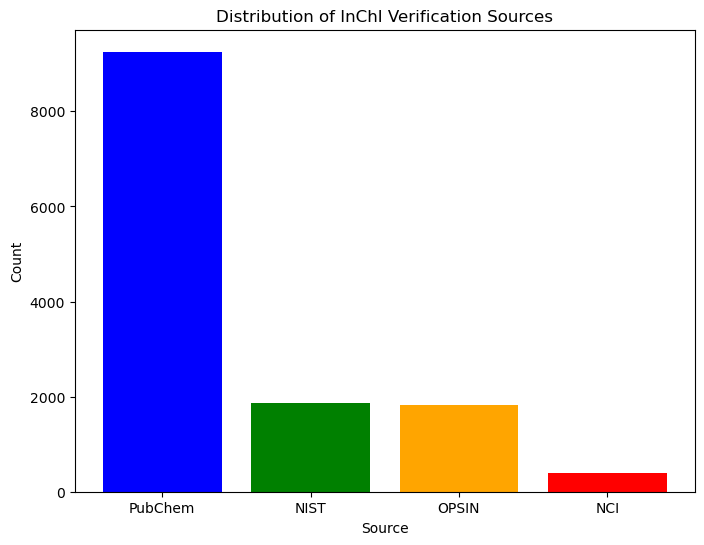

In [85]:
import matplotlib.pyplot as plt

# Summing up the counts of values containing the specific keywords (case insensitive)
pubchem_count = processed_df['InChI_Verification'].str.contains('pubchem', case=False, na=False).sum()
nist_count = processed_df['InChI_Verification'].str.contains('nist', case=False, na=False).sum()
opsin_count = processed_df['InChI_Verification'].str.contains('opsin', case=False, na=False).sum()
nci_count = processed_df['InChI_Verification'].str.contains('nci', case=False, na=False).sum()

# Preparing data for the distribution plot
counts = {'PubChem': pubchem_count, 'NIST': nist_count, 'OPSIN': opsin_count, 'NCI': nci_count}

# Plotting the distribution
plt.figure(figsize=(8, 6))
plt.bar(counts.keys(), counts.values(), color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Distribution of InChI Verification Sources')
# Save each plot as a high-resolution PNG file
plt.savefig('LOECINCHL.png')
plt.show()


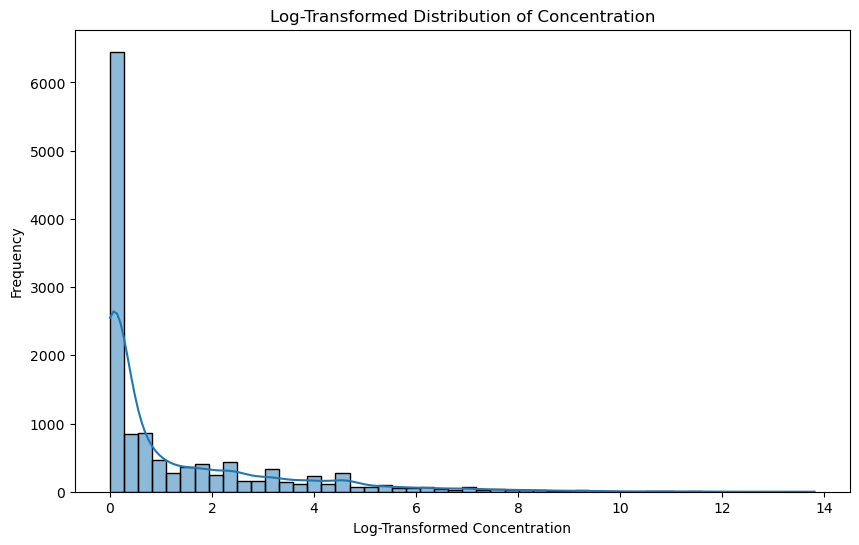

In [86]:
import numpy as np
import seaborn as sns

processed_df['Log Conc Mean '] = np.log1p(processed_df['Conc Mean '])

plt.figure(figsize=(10, 6))
sns.histplot(processed_df['Log Conc Mean '], bins=50, kde=True)
plt.title('Log-Transformed Distribution of Concentration')
plt.xlabel('Log-Transformed Concentration')
plt.ylabel('Frequency')
plt.savefig('LOECLOG.png', dpi=300)
plt.show()



# Old Implementations

In [ ]:
import concurrent.futures
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException, Timeout
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'multiple_valid_match': 0,
            'single_valid': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'validation_failed': 0,
            'pubchem_valid': 0,
            'nist_valid': 0,
            'opsin_valid': 0,
            'nci_valid': 0
        }
        logging.info("Initialized InChIStandardizer with counters.")

    def get_synonyms_pubchem(self, chemical_name):
        """
        Retrieves synonyms for a given chemical name from PubChem.
        """
        base_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{chemical_name}/synonyms/JSON"
        try:
            response = requests.get(base_url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                synonyms = data['InformationList']['Information'][0]['Synonym']
                return synonyms
            else:
                logging.error(f"Failed to retrieve synonyms from PubChem for {chemical_name}.")
                return None
        except Exception as e:
            logging.error(f"Error retrieving synonyms for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        logging.info(f"Retrieving InChI from PubChem for {chemical_name}.")
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            inchi = compounds[0].inchi if compounds else None
            return inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        logging.info(f"Retrieving InChI from OPSIN for {chemical_name}.")
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nci(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from the NCI (National Cancer Institute) database.
        """
        logging.info(f"Retrieving InChI from NCI for {chemical_name}.")
        try:
            url = f"https://cactus.nci.nih.gov/chemical/structure/{chemical_name}/stdinchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NCI for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        logging.info(f"Retrieving InChI from NIST for CAS {cas_number}.")
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        logging.info(f"Validating InChI: {inchi}")
        mol = Chem.MolFromInchi(inchi)
        return mol is not None

    def retrieve_inchi_with_synonyms(self, source_name, retrieve_function, chemical_name):
        """
        Attempts to retrieve the InChI and validate it, using synonyms if the first attempt fails.
        """
        inchi = retrieve_function(chemical_name)
        if not inchi:
            logging.info(f"No InChI retrieved from {source_name} for {chemical_name}, trying synonyms.")
            synonyms = self.get_synonyms_pubchem(chemical_name)
            if synonyms:
                for synonym in synonyms:
                    inchi = retrieve_function(synonym)
                    if inchi and self.validate_inchi(inchi):
                        chemical_name = synonym  # Update the name to the synonym
                        break
        if inchi and self.validate_inchi(inchi):
            self.counters[f'{source_name.lower()}_valid'] += 1
            logging.info(f"Valid InChI found from {source_name}.")
            return inchi
        return None

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by sequentially retrieving from PubChem, NIST, OPSIN, and NCI.
        If no InChI is retrieved from PubChem, tries retrieving synonyms and re-attempts for all sources.
        """
        logging.info(f"Standardizing InChI for {chemical_name}.")
        sources = [
            ("PubChem", self.retrieve_inchi_pubchem),
            ("NIST", lambda name: self.retrieve_inchi_nist(cas_number) if cas_number else None),
            ("OPSIN", self.retrieve_inchi_opsin),
            ("NCI", self.retrieve_inchi_nci)
        ]

        valid_inchi = None
        valid_source = None

        for source_name, retrieve_function in sources:
            inchi = self.retrieve_inchi_with_synonyms(source_name, retrieve_function, chemical_name)
            if inchi:
                valid_inchi = inchi
                valid_source = source_name
                break

        if valid_inchi:
            self.counters['single_valid'] += 1
            notes = f"Validated InChI found from {valid_source}"
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No valid InChI found"

        return valid_inchi, notes

    def process_single_chemical(self, chemical_name, cas_number):
        """
        Process a single chemical name and its CAS number to standardize and validate InChI.
        """
        logging.info(f"Processing single chemical: {chemical_name}")
        return self.standardize_inchi(chemical_name, cas_number)

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number', max_workers=3):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names using parallel processing.
        """
        logging.info("Starting parallel processing of chemicals.")
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()

        results = {}

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_chemical = {
                executor.submit(self.process_single_chemical, row[chemical_name_column], row[cas_number_column]): (row[chemical_name_column], row[cas_number_column])
                for _, row in unique_chemicals.iterrows()
            }

            for future in concurrent.futures.as_completed(future_to_chemical):
                chemical_name, cas_number = future_to_chemical[future]
                try:
                    results[chemical_name] = future.result()
                    logging.info(f"Completed processing for {chemical_name}")
                except Exception as exc:
                    logging.error(f"Error processing {chemical_name}: {exc}")

        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        logging.info("Completed processing of all chemicals.")
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
expected_indices = pd.RangeIndex(start=processed_df.index.min(), stop=processed_df.index.max() + 1)
missing_indices = expected_indices.difference(processed_df.index)
missing_df = filtered_df.loc[missing_indices]
missing_df

CAS Number                                      Chemical Name  \
1000       1332656             Copper chloride hydroxide (Cu2Cl(OH)3)   
1001       1332656             Copper chloride hydroxide (Cu2Cl(OH)3)   
1002       1332656             Copper chloride hydroxide (Cu2Cl(OH)3)   
1003       1332656             Copper chloride hydroxide (Cu2Cl(OH)3)   
1004       1332656             Copper chloride hydroxide (Cu2Cl(OH)3)   
...            ...                                                ...   
139058    13463417  (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethi...   
139059    13463417  (T-4)-Bis[1-(hydroxy-kappaO)-2(1H)-pyridinethi...   
139108    54944568  [2S-[2 alpha, 5 alpha, 6 beta(S*)-]] 6[[[(2,3-...   
139121    68411303  Benzenesulfonic acid, C10-13 Alkylderivs., Sod...   
139125    84731624    Tetrapropylenebenzenesulfonic acid methyl ester   

        Species Scientific Name     Species Common Name        Species Group  \
1000    Lithobates catesbeianus       American Bullfrog           Amphibians   
1001    Lithobates catesbeianus       American Bullfrog           Amphibians   
1002    Lithobates catesbeianus       American Bullfrog           Amphibians   
1003    Lithobates catesbeianus       American Bullfrog           Amphibians   
1004    Lithobates catesbeianus       American Bullfrog           Amphibians   
...                         ...                     ...                  ...   
139058    Paracentrotus lividus  Sea Urchin, Echinoderm  Other Invertebrates   
139059    Paracentrotus lividus  Sea Urchin, Echinoderm  Other Invertebrates   
139108  Tetrahymena thermophila        Ciliate Protozoa  Other Invertebrates   
139121  Brachionus calyciflorus                 Rotifer  Other Invertebrates   
139125  Tetrahymena thermophila        Ciliate Protozoa  Other Invertebrates   

             Organism Lifestage  Observed Duration Mean (Days) Exposure Type  \
1000                    Tadpole                            2.0        Static   
1001                    Tadpole                            3.0        Static   
1002                    Tadpole                            4.0        Static   
1003                    Tadpole                            3.0        Static   
1004                    Tadpole                            4.0        Static   
...                         ...                            ...           ...   
139058                      Egg                            2.0        Static   
139059                      Egg                            2.0        Static   
139108  Stationary growth phase                            2.0        Static   
139121                     Cyst                            2.0        Static   
139125  Stationary growth phase                            2.0        Static   

         Media Type  Conc 1 Mean (Standardized) Conc 1 Units (Standardized)  \
1000    Fresh water                    4.300000                        mg/L   
1001    Fresh water                   13.450000                        mg/L   
1002    Fresh water                    2.400000                        mg/L   
1003    Fresh water                    2.800000                        mg/L   
1004    Fresh water                    2.830000                        mg/L   
...             ...                         ...                         ...   
139058   Salt water                    0.007415                        mg/L   
139059   Salt water                    0.007094                        mg/L   
139108  Fresh water                10715.000000                        mg/L   
139121  Fresh water                    2.000000                        mg/L   
139125  Fresh water                   10.500000                        mg/L   

             Effect                         Effect Measurement Endpoint  \
1000      Mortality                                  Mortality     LC50   
1001      Mortality                                  Mortality     LC50   
1002      Mortality                

In [ ]:
missing_df = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-NoInChIRetrieved.csv')

In [ ]:
processed_df['InChI_Verification'].value_counts().to_dict()

{'Validated InChI found from PubChem. Original name: Sulfuric acid copper(2+) salt (1:1)': 5768,
 'Validated InChI found from NCI. Original name: Cadmium chloride (CdCl2)': 2926,
 'Validated InChI found from OPSIN. Original name: N-(Phosphonomethyl)glycine compd. with 2-propanamine (1:1)': 2276,
 "Validated InChI found from PubChem. Original name: 4,4'-(1-Methylethylidene)bisphenol": 1982,
 'Validated InChI found from PubChem. Original name: Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester': 1897,
 'Validated InChI found from OPSIN. Original name: Cyclo[2,3-didehydro-N-methylalanyl-D-alanyl-L-leucyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl-(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl]': 1806,
 'Validated InChI found from NIST. Original name: (17beta)Estra-1,3,5(10)triene-3,17-diol': 1692,
 'Validated InChI found from PubChem. Original name: Copper': 1683,
 'Validated InChI found from PubChem. Original name: Coppe

In [ ]:
processed_df_missing['Chemical Name'].value_counts()

Chemical Name
Cadmium chloride (CdCl2)                                                                                                                                                                                                                                                                                                                        2926
Nitric acid, Lead (2+) salt (2:1)                                                                                                                                                                                                                                                                                                                885
5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1)                                                                                                                                                                                                                                                         182
Cyclo[(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl-(2Z)-2-(methylamino)-2-butenoyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl]                                                                                                                                                                  108
[N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc                                                                                                                                                                            105
alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1,2-ethanediyl)                                                                                                                                                                                                                                                                                         78
2aR,3S,4S,4aR,5S,7aS,8S,10R,10aS,10bR)-10-(Acetyloxy)octahydro-3,5-dihydroxy-4-methyl-8-[[(2E)-2-methyl-1-oxo-2-buten-1-yl]oxy]-4-[(1aR,2S,3aS,6aS,7S,7aS)-3a,6a,7,7a-tetrahydro-6a-hydroxy-7a-methyl-2,7-methanofuro[2,3-b]oxireno[e]oxepin-1a(2H)-yl]-1H,7H-naptho[1,8-bc:4,4a-c']difuran-5,10a(8H)-dicarboxylic acid 5-10a-dimethyl ester      66
Manganese chloride (MnCl2)                                                                                                                                                                                                                                                                                                                        58
Chromic acid (H2Cr2O7) disodium salt                                                                                                                                                                                                                                                                                                              58
Chromium oxide (CrO3)                                                                                                                                                                                                                                                                                                                             57
[[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese                                                                                                                                                                                                                                                                     53
N,N'-[1,2-Phenylenebis(iminocarbonothioyl)]bis-C,C'- dimethyl ester carbamic acid                                                                                                                                                          

In [ ]:
processed_df_missing[['Chemical Name', 'InChI_Verification']].value_counts().to_dict()

{('Cadmium chloride (CdCl2)',
  'Validated InChI found from NCI. Original name: Cadmium chloride (CdCl2)'): 2926,
 ('Nitric acid, Lead (2+) salt (2:1)',
  'Validated InChI found from PubChem (formatted CAS). Formatted CAS: 10099-74-8'): 885,
 ('5-Chloro-N-(2-chloro-4-nitrophenyl)-2-hydrozybenzamide, compd. with 2-aminoethanol (1:1)',
  'Validated InChI found from PubChem (formatted CAS). Formatted CAS: 1420-04-8'): 182,
 ('Cyclo[(2S,3S,4E,6E,8S,9S)-3-amino-9-methoxy-2,6,8-trimethyl-10-phenyl-4,6-decadienoyl-D-gamma-glutamyl-(2Z)-2-(methylamino)-2-butenoyl-(3S)-3-methyl-D-beta-aspartyl-L-arginyl]',
  'Validated InChI found from PubChem (formatted CAS). Formatted CAS: 118399-22-7'): 108,
 ("[N-[2-[(Dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']manganese mixt. with [N-[2-[(dithiocarboxy)amino]ethyl]carbamodithioato(2-)-kappaS,kappaS']zinc",
  'Validated InChI found from PubChem (formatted CAS). Formatted CAS: 8018-01-7'): 105,
 ('alpha-(Nonylphenyl)-omega-hydroxypoly(oxy-1

In [ ]:
missing_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-NoInChIRetrieved.csv', index=False)

In [ ]:
import concurrent.futures
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException, Timeout
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'multiple_valid_match': 0,
            'single_valid': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'validation_failed': 0
        }
        logging.info("Initialized InChIStandardizer with counters.")

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        logging.info(f"Retrieving InChI from PubChem for {chemical_name}.")
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            inchi = compounds[0].inchi if compounds else None
            return inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        logging.info(f"Retrieving InChI from OPSIN for {chemical_name}.")
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nci(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from the NCI (National Cancer Institute) database.
        """
        logging.info(f"Retrieving InChI from NCI for {chemical_name}.")
        try:
            url = f"https://cactus.nci.nih.gov/chemical/structure/{chemical_name}/stdinchi"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NCI for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=5), retry=retry_if_exception_type((RequestException, Timeout)))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        logging.info(f"Retrieving InChI from NIST for CAS {cas_number}.")
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        logging.info(f"Validating InChI: {inchi}")
        mol = Chem.MolFromInchi(inchi)
        return mol is not None

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.
        """
        logging.info("Comparing molecular structures.")
        if mol1 is None or mol2 is None:
            logging.warning("One or both molecules are invalid for comparison.")
            return 0.0

        morgan_generator = GetMorganGenerator(radius=2)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        return similarity

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by sequentially retrieving from PubChem, NIST, OPSIN, and NCI.
        """
        logging.info(f"Standardizing InChI for {chemical_name}.")
        sources = [
            ("PubChem", self.retrieve_inchi_pubchem),
            ("NIST", lambda name: self.retrieve_inchi_nist(cas_number) if cas_number else None),
            ("OPSIN", self.retrieve_inchi_opsin),
            ("NCI", self.retrieve_inchi_nci)
        ]

        valid_inchi = None
        valid_source = None

        for source_name, retrieve_function in sources:
            inchi = retrieve_function(chemical_name)
            if inchi and self.validate_inchi(inchi):
                valid_inchi = inchi
                valid_source = source_name
                logging.info(f"Valid InChI found from {source_name}.")
                break

        if valid_inchi:
            self.counters['single_valid'] += 1
            notes = f"Validated InChI found from {valid_source}"
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No valid InChI found"

        return valid_inchi, notes

    def process_single_chemical(self, chemical_name, cas_number):
        """
        Process a single chemical name and its CAS number to standardize and validate InChI.
        """
        logging.info(f"Processing single chemical: {chemical_name}")
        return self.standardize_inchi(chemical_name, cas_number)

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number', max_workers=3):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names using parallel processing.
        """
        logging.info("Starting parallel processing of chemicals.")
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()

        results = {}

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_chemical = {
                executor.submit(self.process_single_chemical, row[chemical_name_column], row[cas_number_column]): (row[chemical_name_column], row[cas_number_column])
                for _, row in unique_chemicals.iterrows()
            }

            for future in concurrent.futures.as_completed(future_to_chemical):
                chemical_name, cas_number = future_to_chemical[future]
                try:
                    results[chemical_name] = future.result()
                    logging.info(f"Completed processing for {chemical_name}")
                except Exception as exc:
                    logging.error(f"Error processing {chemical_name}: {exc}")

        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        logging.info("Completed processing of all chemicals.")
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
# Assuming 'filtered_df' is your DataFrame with a column named 'Chemical Name' and optionally 'CAS Number'
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-21 09:52:20,944 - root - INFO - Initialized InChIStandardizer with counters.
2024-08-21 09:52:20,945 - root - INFO - Starting parallel processing of chemicals.
2024-08-21 09:52:20,968 - root - INFO - Processing single chemical: Formaldehyde
2024-08-21 09:52:20,970 - root - INFO - Standardizing InChI for Formaldehyde.
2024-08-21 09:52:20,972 - root - INFO - Retrieving InChI from PubChem for Formaldehyde.
2024-08-21 09:52:20,973 - root - INFO - Processing single chemical: N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine 2-oxide
2024-08-21 09:52:20,973 - root - INFO - Processing single chemical: (17beta)Estra-1,3,5(10)triene-3,17-diol
2024-08-21 09:52:21,023 - root - INFO - Standardizing InChI for N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxazaphosphorin-2-amine 2-oxide.
2024-08-21 09:52:21,061 - root - INFO - Standardizing InChI for (17beta)Estra-1,3,5(10)triene-3,17-diol.
2024-08-21 09:52:21,089 - root - INFO - Retrieving InChI from PubChem for N,N-Bis(2-chloroe

KeyboardInterrupt: 

In [ ]:
def retrieve_inchi_unichem(chemical_name):
    url = f"https://www.ebi.ac.uk/unichem/rest/src_compound_id/{chemical_name}/1"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data.get('stdinchikey', None)
    return None

retrieve_inchi_unichem('aspirin')

In [ ]:
import concurrent.futures
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'multiple_valid_match': 0,
            'single_valid': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'validation_failed': 0
        }
        logging.info("Initialized InChIStandardizer with counters.")

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        logging.info(f"Retrieving InChI from PubChem for {chemical_name}.")
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            inchi = compounds[0].inchi if compounds else None
            # logging.info(f"Retrieved InChI from PubChem for {chemical_name}: {inchi}")
            return inchi
        except Exception as e:
            # logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        logging.info(f"Retrieving InChI from OPSIN for {chemical_name}.")
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                inchi = response.text.strip()
                # logging.info(f"Retrieved InChI from OPSIN for {chemical_name}: {inchi}")
                return inchi
            return None
        except Exception as e:
            # logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_nci(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from the NCI (National Cancer Institute) database.
        """
        logging.info(f"Retrieving InChI from NCI for {chemical_name}.")
        try:
            url = f"https://cactus.nci.nih.gov/chemical/structure/{chemical_name}/stdinchi"
            response = requests.get(url, timout=10)
            if response.status_code == 200:
                inchi = response.text.strip()
                # logging.info(f"Retrieved InChI from NCI for {chemical_name}: {inchi}")
                return inchi
            return None
        except Exception as e:
            # logging.error(f"Failed to retrieve InChI from NCI for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        logging.info(f"Retrieving InChI from NIST for CAS {cas_number}.")
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        inchi = inchi_element.text.strip()
                        # logging.info(f"Retrieved InChI from NIST for CAS {cas_number}: {inchi}")
                        return inchi
            return None
        except Exception as e:
            # logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        logging.info(f"Validating InChI: {inchi}")
        mol = Chem.MolFromInchi(inchi)
        valid = mol is not None
        # if valid:
            # logging.info("InChI validation successful.")
        # else:
        #     logging.warning("InChI validation failed.")
        return valid

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.
        """
        logging.info("Comparing molecular structures.")
        if mol1 is None or mol2 is None:
            logging.warning("One or both molecules are invalid for comparison.")
            return 0.0

        morgan_generator = GetMorganGenerator(radius=2)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        # logging.info(f"Structural similarity: {similarity}")
        return similarity

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by comparing results from PubChem, OPSIN, NIST, and NCI.
        """
        logging.info(f"Standardizing InChI for {chemical_name}.")
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        nci_inchi = self.retrieve_inchi_nci(chemical_name)
        nist_inchi = None
        notes = ""

        valid_inchis = []
        if pubchem_inchi and self.validate_inchi(pubchem_inchi):
            valid_inchis.append(('PubChem', pubchem_inchi))
        if opsin_inchi and self.validate_inchi(opsin_inchi):
            valid_inchis.append(('OPSIN', opsin_inchi))
        if nci_inchi and self.validate_inchi(nci_inchi):
            valid_inchis.append(('NCI', nci_inchi))
        if cas_number:
            nist_inchi = self.retrieve_inchi_nist(cas_number)
            if nist_inchi and self.validate_inchi(nist_inchi):
                valid_inchis.append(('NIST', nist_inchi))

        if len(valid_inchis) > 1:
            all_match = all(inchi == valid_inchis[0][1] for _, inchi in valid_inchis)
            if all_match:
                self.counters['multiple_valid_match'] += 1
                notes = f"Match from multiple sources: {[source for source, _ in valid_inchis]}"
                # logging.info(notes)
            else:
                similarity_scores = []
                for i in range(len(valid_inchis)):
                    for j in range(i + 1, len(valid_inchis)):
                        mol1 = Chem.MolFromInchi(valid_inchis[i][1])
                        mol2 = Chem.MolFromInchi(valid_inchis[j][1])
                        similarity = self.compare_structures(mol1, mol2)
                        similarity_scores.append(similarity)

                avg_similarity = sum(similarity_scores) / len(similarity_scores)
                if avg_similarity == 1.0:
                    self.counters['multiple_valid_match'] += 1
                    notes = "Structural match from multiple sources after comparison"
                    # logging.info(notes)
                else:
                    self.counters['no_match'] += 1
                    notes = f"Structure mismatch (average similarity: {avg_similarity:.2f})"
                    logging.warning(notes)
        elif len(valid_inchis) == 1:
            self.counters['single_valid'] += 1
            # notes = f"Found only in {valid_inchis[0][0]} and validated"
            logging.info(notes)
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No valid InChI found"
            logging.warning(notes)

        return valid_inchis[0][1] if valid_inchis else None, notes

    def process_single_chemical(self, chemical_name, cas_number):
        """
        Process a single chemical name and its CAS number to standardize and validate InChI.
        """
        # logging.info(f"Processing single chemical: {chemical_name}")
        return self.standardize_inchi(chemical_name, cas_number)

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number', max_workers=3):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names using parallel processing.
        """
        logging.info("Starting parallel processing of chemicals.")
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()

        results = {}

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_chemical = {
                executor.submit(self.process_single_chemical, row[chemical_name_column], row[cas_number_column]): (row[chemical_name_column], row[cas_number_column])
                for _, row in unique_chemicals.iterrows()
            }

            for future in concurrent.futures.as_completed(future_to_chemical):
                chemical_name, cas_number = future_to_chemical[future]
                try:
                    results[chemical_name] = future.result()
                    # logging.info(f"Completed processing for {chemical_name}")
                except Exception as exc:
                    logging.error(f"Error processing {chemical_name}: {exc}")

        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        logging.info("Completed processing of all chemicals.")
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-20 17:10:25,644 - root - INFO - Retrieving InChI from NCI for Carbonochloridic acid, methyl ester.
2024-08-20 17:10:25,646 - root - ERROR - Failed to retrieve InChI from NCI for Carbonochloridic acid, methyl ester: Session.request() got an unexpected keyword argument 'timout'
2024-08-20 17:10:25,647 - root - INFO - Validating InChI: InChI=1S/C2H3ClO2/c1-5-2(3)4/h1H3
2024-08-20 17:10:25,649 - root - INFO - Validating InChI: InChI=1/C2H3ClO2/c1-5-2(3)4/h1H3
2024-08-20 17:10:25,650 - root - INFO - Retrieving InChI from NIST for CAS 79221.
2024-08-20 17:10:25,742 - root - INFO - Retrieving InChI from NCI for (17beta)-17-Hydroxyandrost-4-ene-3,11-dione.
2024-08-20 17:10:25,744 - root - INFO - Validating InChI: InChI=1S/C19H26O3/c1-18-8-7-12(20)9-11(18)3-4-13-14-5-6-16(22)19(14,2)10-15(21)17(13)18/h9,13-14,16-17,22H,3-8,10H2,1-2H3/t13-,14-,16-,17+,18-,19-/m0/s1
2024-08-20 17:10:25,745 - root - INFO - Validating InChI: InChI=1/C19H26O3/c1-18-8-7-12(20)9-11(18)3-4-13-14-5-6-16(22)19(14

[17:11:32] WARNING: not removing hydrogen atom without neighbors
[17:11:32] WARNING: not removing hydrogen atom without neighbors


2024-08-20 17:11:32,943 - root - INFO - Validating InChI: InChI=1S/C24H40N8O4/c33-15-11-31(12-16-34)23-26-20-19(21(27-23)29-7-3-1-4-8-29)25-24(32(13-17-35)14-18-36)28-22(20)30-9-5-2-6-10-30/h33-36H,1-18H2
2024-08-20 17:11:32,946 - root - INFO - Comparing molecular structures.
2024-08-20 17:11:32,948 - root - INFO - Standardizing InChI for 2-(2-Ethylhexyl)-3a,4,7,7a-tetrahydro-4,7-methano-1H-isoindole-1,3-(2H)dione.
2024-08-20 17:11:32,949 - root - INFO - Retrieving InChI from PubChem for 2-(2-Ethylhexyl)-3a,4,7,7a-tetrahydro-4,7-methano-1H-isoindole-1,3-(2H)dione.
2024-08-20 17:11:33,044 - root - INFO - 
2024-08-20 17:11:33,047 - root - INFO - Standardizing InChI for Silicic acid (H4SiO4).
2024-08-20 17:11:33,048 - root - INFO - Retrieving InChI from PubChem for Silicic acid (H4SiO4).
2024-08-20 17:11:33,091 - root - INFO - 
2024-08-20 17:11:33,092 - root - INFO - Standardizing InChI for (4S,4aR,5S,5aR,6S,12aS)-4-(Dimethylamino)-1,4,4a,5,5a,6,11,12a-octahydro-3,5,6,10,12,12a-hexahydrox

[17:11:33] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



Streaming output truncated to the last 5000 lines.
2024-08-20 17:11:50,175 - root - INFO - Retrieving InChI from NCI for Merulidial.
2024-08-20 17:11:50,177 - root - INFO - Validating InChI: InChI=1S/C15H20O3/c1-13(2)4-9-10(5-13)12(18)14(3)7-15(14,8-17)11(9)6-16/h6,8,10,12,18H,4-5,7H2,1-3H3/t10-,12+,14+,15+/m1/s1
2024-08-20 17:11:50,180 - root - INFO - Retrieving InChI from NIST for CAS 68053327.
2024-08-20 17:11:50,184 - root - INFO - Retrieving InChI from NCI for N,N-Dimethyl-N'-[3-(trifluoromethyl)phenyl]urea.
2024-08-20 17:11:50,186 - root - ERROR - Failed to retrieve InChI from NCI for N,N-Dimethyl-N'-[3-(trifluoromethyl)phenyl]urea: Session.request() got an unexpected keyword argument 'timout'
2024-08-20 17:11:50,188 - root - INFO - Validating InChI: InChI=1S/C10H11F3N2O/c1-15(2)9(16)14-8-5-3-4-7(6-8)10(11,12)13/h3-6H,1-2H3,(H,14,16)
2024-08-20 17:11:50,190 - root - INFO - Validating InChI: InChI=1/C10H11F3N2O/c1-15(2)9(16)14-8-5-3-4-7(6-8)10(11,12)13/h3-6H,1-2H3,(H,14,16)/f/h14H

CAS Number                                      Chemical Name  \
0            50000                                       Formaldehyde   
1            50180  N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...   
2            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
3            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
4            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
...            ...                                                ...   
139131    94361065  alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...   
139132   101012811               3-(Diethylamino)phenol hydrochloride   
139133   129453618  (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...   
139134   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   
139135   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   

               Species Scientific Name  Species Common Name  \
0              Lithobates catesbeianus    American Bullfrog   
1                       Xenopus laevis  African Clawed Frog   
2                   Lithobates pipiens         Leopard Frog   
3                   Lithobates pipiens         Leopard Frog   
4                Lithobates sylvaticus            Wood Frog   
...                                ...                  ...   
139131         Tetrahymena thermophila     Ciliate Protozoa   
139132         Tetrahymena thermophila     Ciliate Protozoa   
139133   Strongylocentrotus purpuratus    Purple Sea Urchin   
139134  Strongylocentrotus intermedius           Sea Urchin   
139135  Strongylocentrotus intermedius           Sea Urchin   

              Species Group              Organism Lifestage  \
0                Amphibians                         Tadpole   
1                Amphibians                          Embryo   
2                Amphibians                         Tadpole   
3                Amphibians                         Tadpole   
4                Amphibians                         Tadpole   
...                     ...                             ...   
139131  Other Invertebrates  Exponential growth phase (log)   
139132  Other Invertebrates         Stationary growth phase   
139133  Other Invertebrates                          Embryo   
139134  Other Invertebrates                             Egg   
139135  Other Invertebrates                             Egg   

        Observed Duration Mean (Days) Exposure Type   Media Type  \
0                              4.0000       Renewal  Fresh water   
1                              4.0000       Renewal  Fresh water   
2                             14.0000       Renewal  Fresh water   
3                             14.0000       Renewal  Fresh water   
4                             14.0000       Renewal  Fresh water   
...                               ...           ...          ...   
139131                         1.0000        Static      Culture   
139132                         2.0000        Static  Fresh water   
139133                         3.9583        Static   Salt water   
139134                         4.0000        Static   Salt water   
139135                         2.0000        Static   Salt water   

        Conc 1 Mean (Standardized) Conc 1 Units (Standardized)       Effect  \
0                        10.530000                        mg/L    Mortality   
1                      6760.000000                        mg/L    Mortality   
2                         1.517198                        mg/L    Mortality   
3                         1.242087                        mg/L    Mortality   
4                         0.680968                        mg/L    Mortality   
...                            ...                         ...          ...   
139131                   20.440000                        mg/L   Population   
139132                   50.000000                        mg/L   Population   
139133                    0.000058                        mg/L  Development   
139134    

In [ ]:
processed_df['InChI_Verification'].value_counts().to_dict()

{'Structural match from multiple sources after comparison': 69495,
 '': 32601,
 "Match from multiple sources: ['PubChem', 'NIST']": 14705,
 'Structure mismatch (average similarity: 0.69)': 2609,
 'Structure mismatch (average similarity: 0.50)': 1714,
 'Structure mismatch (average similarity: 0.70)': 656,
 'Structure mismatch (average similarity: 0.60)': 588,
 'Structure mismatch (average similarity: 0.71)': 422,
 'Structure mismatch (average similarity: 0.33)': 388,
 'Structure mismatch (average similarity: 0.54)': 344,
 'Structure mismatch (average similarity: 0.48)': 300,
 'Structure mismatch (average similarity: 0.64)': 287,
 'Structure mismatch (average similarity: 0.17)': 255,
 'Structure mismatch (average similarity: 0.27)': 237,
 'Structure mismatch (average similarity: 0.74)': 232,
 'Structure mismatch (average similarity: 0.47)': 226,
 'Structure mismatch (average similarity: 0.53)': 221,
 'Structure mismatch (average similarity: 0.56)': 206,
 'Structure mismatch (average simi

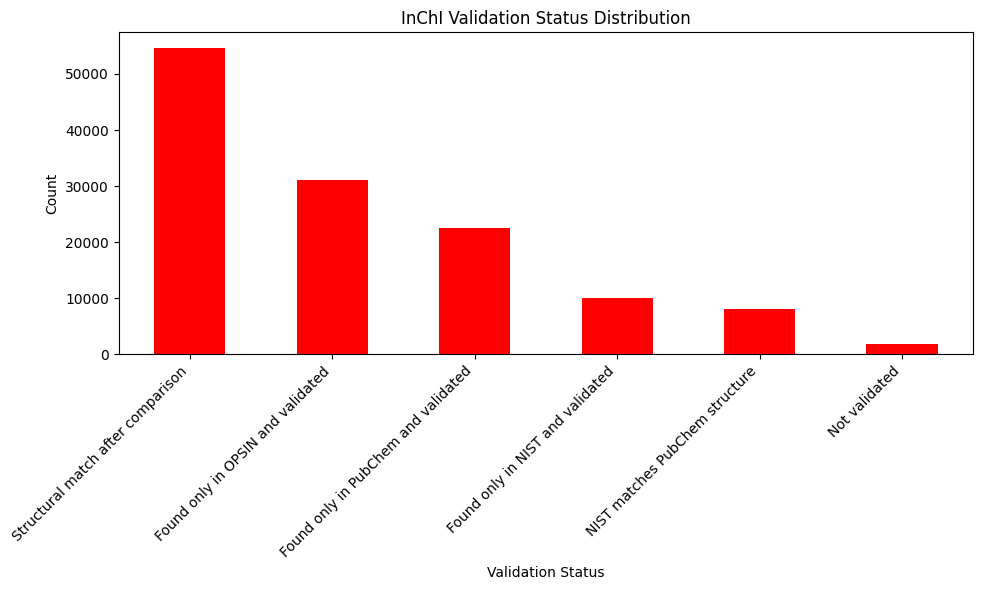

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Count the occurrences of each verification status
value_counts = processed_df['InChI_Verification'].value_counts()

# Separate the top 4 values and sum the rest under "Not validated"
top_4_values = value_counts.nlargest(5)
other_values_sum = value_counts.iloc[5:].sum()

# Add "Not validated" to the top 4 values
top_4_values['Not validated'] = other_values_sum

# Create a bar plot
plt.figure(figsize=(10, 6))
top_4_values.plot(kind='bar', color='red')
plt.title('InChI Validation Status Distribution')
plt.ylabel('Count')
plt.xlabel('Validation Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'pubchem_only': 0,
            'opsin_only': 0,
            'nist_only': 0,
            'match': 0,
            'validated_match': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'structure_mismatch': 0,
            'pubchem_only_validated': 0,
            'opsin_only_validated': 0,
            'nist_only_validated': 0,
            'validation_failed': 0
        }

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            return compounds[0].inchi if compounds else None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        mol = Chem.MolFromInchi(inchi)
        return mol is not None if mol else False

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.

        Args:
            mol1 (rdkit.Chem.Mol): The first RDKit molecule.
            mol2 (rdkit.Chem.Mol): The second RDKit molecule.

        Returns:
            float: A similarity score between 0 and 1, where 1 means identical structures.
        """
        if mol1 is None or mol2 is None:
            return 0.0  # Can't compare if one of the molecules is invalid

        # Use the new MorganGenerator for generating molecular fingerprints
        morgan_generator = GetMorganGenerator(radius=2)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)

        # Compute the Tanimoto similarity between the two fingerprints
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        return similarity

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by comparing results from PubChem, OPSIN, and NIST.
        If both InChIs are valid but differ, performs a structural comparison.
        """
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        nist_inchi = None
        notes = ""

        # Both InChIs are found
        if pubchem_inchi and opsin_inchi:
            pubchem_mol = Chem.MolFromInchi(pubchem_inchi)
            opsin_mol = Chem.MolFromInchi(opsin_inchi)

            if pubchem_inchi == opsin_inchi:
                if self.validate_inchi(pubchem_inchi):
                    self.counters['validated_match'] += 1
                    notes = "Match and validated"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Match but validation failed"
            else:
                # Mismatch between PubChem and OPSIN InChIs, perform structure comparison
                pubchem_valid = self.validate_inchi(pubchem_inchi)
                opsin_valid = self.validate_inchi(opsin_inchi)

                if pubchem_valid and opsin_valid:
                    similarity = self.compare_structures(pubchem_mol, opsin_mol)
                    if similarity == 1.0:
                        self.counters['validated_match'] += 1
                        notes = "Structural match after comparison"
                    else:
                        self.counters['structure_mismatch'] += 1
                        notes = f"Structure mismatch (similarity: {similarity:.2f})"
                        # Retrieve NIST InChI in case of mismatch
                        if cas_number:
                            nist_inchi = self.retrieve_inchi_nist(cas_number)
                            if nist_inchi:
                                nist_mol = Chem.MolFromInchi(nist_inchi)
                                if self.compare_structures(pubchem_mol, nist_mol) == 1.0:
                                    self.counters['nist_only_validated'] += 1
                                    notes = "NIST matches PubChem structure"
                                    return nist_inchi, notes
                                elif self.compare_structures(opsin_mol, nist_mol) == 1.0:
                                    self.counters['nist_only_validated'] += 1
                                    notes = "NIST matches OPSIN structure"
                                    return nist_inchi, notes
                                else:
                                    self.counters['nist_only'] += 1
                                    notes = "NIST structure mismatch"
                elif pubchem_valid:
                    self.counters['pubchem_only_validated'] += 1
                    notes = "Mismatch; PubChem InChI is valid"
                elif opsin_valid:
                    self.counters['opsin_only_validated'] += 1
                    notes = "Mismatch; OPSIN InChI is valid"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Mismatch; both InChIs failed validation"

        # Handle single source cases
        elif pubchem_inchi:
            if self.validate_inchi(pubchem_inchi):
                self.counters['pubchem_only_validated'] += 1
                notes = "Found only in PubChem and validated"
            else:
                self.counters['pubchem_only'] += 1
                notes = "Found only in PubChem but validation failed"
        elif opsin_inchi:
            if self.validate_inchi(opsin_inchi):
                self.counters['opsin_only_validated'] += 1
                notes = "Found only in OPSIN and validated"
            else:
                self.counters['opsin_only'] += 1
                notes = "Found only in OPSIN but validation failed"
        else:
            if cas_number:
                nist_inchi = self.retrieve_inchi_nist(cas_number)
                if nist_inchi and self.validate_inchi(nist_inchi):
                    self.counters['nist_only_validated'] += 1
                    notes = "Found only in NIST and validated"
                else:
                    self.counters['nist_only'] += 1
                    notes = "Found only in NIST but validation failed"
            else:
                self.counters['no_inchi_found'] += 1
                notes = "No InChI found"

        return pubchem_inchi or opsin_inchi or nist_inchi, notes

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number'):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names and CAS numbers.
            chemical_name_column (str): The column in DataFrame containing the chemical names.
            cas_number_column (str): The column in DataFrame containing CAS numbers.

        Returns:
            pandas.DataFrame: Updated DataFrame with standardized InChIs and verification statuses.
        """
        # Ensure unique chemical names for processing
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()
        processed_count = 0

        results = {}
        for _, row in unique_chemicals.iterrows():
            chemical_name = row[chemical_name_column]
            cas_number = row[cas_number_column]
            results[chemical_name] = self.standardize_inchi(chemical_name, cas_number)
            processed_count += 1
            if processed_count % 500 == 0:
                logging.info(f"Processed {processed_count} compounds.")

        # Map results back to the original DataFrame
        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-20 09:59:47,199 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:49,749 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:51,724 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:52,260 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:53,242 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:54,685 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:59:55,193 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:00:02,644 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:00:03,637 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:00:04,159 - pubchempy - INFO - '

[10:02:49] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[10:02:49] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[10:02:50] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:02:50] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 10:02:50,848 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:02:52,087 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:02:52,506 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:02:57,491 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:02,909 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:04,844 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:05,742 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:06,726 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:09,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[10:03:10] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:03:10] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 10:03:12,216 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:13,641 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:15,292 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:16,180 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:16,970 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:18,613 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:19,498 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:22,841 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:24,163 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:03:26,083 - pubchempy - INFO - '

[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors
[10:09:41] WARNING: not removing hydrogen atom without neighbors


2024-08-20 10:09:41,776 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:43,324 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:47,284 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:49,648 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:52,092 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:53,576 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:56,022 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:56,447 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:57,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:09:58,498 - pubchempy - INFO - '

[10:14:20] Unusual charge on atom 24 number of radical electrons set to zero
[10:14:20] Unusual charge on atom 24 number of radical electrons set to zero


2024-08-20 10:14:23,849 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:24,973 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:27,424 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:28,319 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:28,769 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:29,185 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:29,681 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:30,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:31,469 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:14:31,995 - pubchempy - INFO - '

[10:16:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:16:01] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 10:16:03,700 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:06,426 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:07,415 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:08,296 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:09,683 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[10:16:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:16:11] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

[10:16:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[10:16:11] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 10:16:12,096 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:12,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:13,788 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:15,511 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:16,022 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:16,915 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:17,419 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:18,745 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:19,157 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:16:19,661 - pubchempy - INFO - '

[10:22:08] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[10:22:08] ERROR: Explicit valence for atom # 0 Cl, 3, is greater than permitted



2024-08-20 10:22:08,592 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:09,955 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:10,877 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:11,769 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:12,269 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:12,791 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:13,917 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:15,894 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:17,393 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:22:18,284 - pubchempy - INFO - '

[10:26:08] WARNING: not removing hydrogen atom without neighbors
[10:26:08] WARNING: not removing hydrogen atom without neighbors
[10:26:08] WARNING: not removing hydrogen atom without neighbors
[10:26:08] WARNING: not removing hydrogen atom without neighbors


2024-08-20 10:26:11,434 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:12,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:15,185 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:16,088 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:16,588 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:17,125 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:18,871 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:19,285 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:19,699 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:26:21,570 - pubchempy - INFO - '

[10:33:41] WARNING: not removing hydrogen atom without neighbors
[10:33:41] WARNING: not removing hydrogen atom without neighbors


2024-08-20 10:33:41,972 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:43,612 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[10:33:43] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



2024-08-20 10:33:44,023 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:45,046 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:46,475 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:47,372 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:49,598 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:50,399 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:55,851 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:57,826 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:33:58,857 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 10:34:06,715 - pubchempy - INFO - '

CAS Number                                      Chemical Name  \
0            50000                                       Formaldehyde   
1            50180  N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...   
2            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
3            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
4            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
...            ...                                                ...   
139131    94361065  alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...   
139132   101012811               3-(Diethylamino)phenol hydrochloride   
139133   129453618  (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...   
139134   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   
139135   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   

               Species Scientific Name  Species Common Name  \
0              Lithobates catesbeianus    American Bullfrog   
1                       Xenopus laevis  African Clawed Frog   
2                   Lithobates pipiens         Leopard Frog   
3                   Lithobates pipiens         Leopard Frog   
4                Lithobates sylvaticus            Wood Frog   
...                                ...                  ...   
139131         Tetrahymena thermophila     Ciliate Protozoa   
139132         Tetrahymena thermophila     Ciliate Protozoa   
139133   Strongylocentrotus purpuratus    Purple Sea Urchin   
139134  Strongylocentrotus intermedius           Sea Urchin   
139135  Strongylocentrotus intermedius           Sea Urchin   

              Species Group              Organism Lifestage  \
0                Amphibians                         Tadpole   
1                Amphibians                          Embryo   
2                Amphibians                         Tadpole   
3                Amphibians                         Tadpole   
4                Amphibians                         Tadpole   
...                     ...                             ...   
139131  Other Invertebrates  Exponential growth phase (log)   
139132  Other Invertebrates         Stationary growth phase   
139133  Other Invertebrates                          Embryo   
139134  Other Invertebrates                             Egg   
139135  Other Invertebrates                             Egg   

        Observed Duration Mean (Days) Exposure Type   Media Type  \
0                              4.0000       Renewal  Fresh water   
1                              4.0000       Renewal  Fresh water   
2                             14.0000       Renewal  Fresh water   
3                             14.0000       Renewal  Fresh water   
4                             14.0000       Renewal  Fresh water   
...                               ...           ...          ...   
139131                         1.0000        Static      Culture   
139132                         2.0000        Static  Fresh water   
139133                         3.9583        Static   Salt water   
139134                         4.0000        Static   Salt water   
139135                         2.0000        Static   Salt water   

        Conc 1 Mean (Standardized) Conc 1 Units (Standardized)       Effect  \
0                        10.530000                        mg/L    Mortality   
1                      6760.000000                        mg/L    Mortality   
2                         1.517198                        mg/L    Mortality   
3                         1.242087                        mg/L    Mortality   
4                         0.680968                        mg/L    Mortality   
...                            ...                         ...          ...   
139131                   20.440000                        mg/L   Population   
139132                   50.000000                        mg/L   Population   
139133                    0.000058                        mg/L  Development   
139134    

In [ ]:
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'pubchem_only': 0,
            'opsin_only': 0,
            'nist_only': 0,
            'match': 0,
            'validated_match': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'structure_mismatch': 0,
            'pubchem_only_validated': 0,
            'opsin_only_validated': 0,
            'nist_only_validated': 0,
            'validation_failed': 0
        }

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            return compounds[0].inchi if compounds else None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_nist(self, cas_number):
        """
        Retrieves the InChI string for a given CAS number from the NIST Chemistry WebBook.
        """
        try:
            url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas_number}&Units=SI"
            response = requests.get(url)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                inchi_label = soup.find('strong', text="IUPAC Standard InChI:")
                if inchi_label:
                    inchi_element = inchi_label.find_next('span')
                    if inchi_element:
                        return inchi_element.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from NIST for CAS {cas_number}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        mol = Chem.MolFromInchi(inchi)
        return mol is not None if mol else False

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.

        Args:
            mol1 (rdkit.Chem.Mol): The first RDKit molecule.
            mol2 (rdkit.Chem.Mol): The second RDKit molecule.

        Returns:
            float: A similarity score between 0 and 1, where 1 means identical structures.
        """
        if mol1 is None or mol2 is None:
            return 0.0  # Can't compare if one of the molecules is invalid

        # Use the new MorganGenerator for generating molecular fingerprints
        morgan_generator = GetMorganGenerator(radius=2)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)

        # Compute the Tanimoto similarity between the two fingerprints
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        return similarity

    def standardize_inchi(self, chemical_name, cas_number=None):
        """
        Standardizes and validates InChI by comparing results from PubChem, OPSIN, and NIST.
        If both InChIs are valid but differ, performs a structural comparison.
        """
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        nist_inchi = None
        notes = ""

        # Both InChIs are found
        if pubchem_inchi and opsin_inchi:
            pubchem_mol = Chem.MolFromInchi(pubchem_inchi)
            opsin_mol = Chem.MolFromInchi(opsin_inchi)

            if pubchem_inchi == opsin_inchi:
                if self.validate_inchi(pubchem_inchi):
                    self.counters['validated_match'] += 1
                    notes = "Match and validated"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Match but validation failed"
            else:
                # Mismatch between PubChem and OPSIN InChIs, perform structure comparison
                pubchem_valid = self.validate_inchi(pubchem_inchi)
                opsin_valid = self.validate_inchi(opsin_inchi)

                if pubchem_valid and opsin_valid:
                    similarity = self.compare_structures(pubchem_mol, opsin_mol)
                    if similarity == 1.0:
                        self.counters['validated_match'] += 1
                        notes = "Structural match after comparison"
                    else:
                        self.counters['structure_mismatch'] += 1
                        notes = f"Structure mismatch (similarity: {similarity:.2f})"
                elif pubchem_valid:
                    self.counters['pubchem_only_validated'] += 1
                    notes = "Mismatch; PubChem InChI is valid"
                elif opsin_valid:
                    self.counters['opsin_only_validated'] += 1
                    notes = "Mismatch; OPSIN InChI is valid"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Mismatch; both InChIs failed validation"

        # Handle single source cases
        elif pubchem_inchi:
            if self.validate_inchi(pubchem_inchi):
                self.counters['pubchem_only_validated'] += 1
                notes = "Found only in PubChem and validated"
            else:
                self.counters['pubchem_only'] += 1
                notes = "Found only in PubChem but validation failed"
        elif opsin_inchi:
            if self.validate_inchi(opsin_inchi):
                self.counters['opsin_only_validated'] += 1
                notes = "Found only in OPSIN and validated"
            else:
                self.counters['opsin_only'] += 1
                notes = "Found only in OPSIN but validation failed"
        else:
            if cas_number:
                nist_inchi = self.retrieve_inchi_nist(cas_number)
                if nist_inchi and self.validate_inchi(nist_inchi):
                    self.counters['nist_only_validated'] += 1
                    notes = "Found only in NIST and validated"
                else:
                    self.counters['nist_only'] += 1
                    notes = "Found only in NIST but validation failed"
            else:
                self.counters['no_inchi_found'] += 1
                notes = "No InChI found"

        return pubchem_inchi or opsin_inchi or nist_inchi, notes

    def process_chemicals(self, df, chemical_name_column='Chemical Name', cas_number_column='CAS Number'):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names and CAS numbers.
            chemical_name_column (str): The column in DataFrame containing the chemical names.
            cas_number_column (str): The column in DataFrame containing CAS numbers.

        Returns:
            pandas.DataFrame: Updated DataFrame with standardized InChIs and verification statuses.
        """
        # Ensure unique chemical names for processing
        unique_chemicals = df[[chemical_name_column, cas_number_column]].drop_duplicates()
        processed_count = 0

        results = {}
        for _, row in unique_chemicals.iterrows():
            chemical_name = row[chemical_name_column]
            cas_number = row[cas_number_column]
            results[chemical_name] = self.standardize_inchi(chemical_name, cas_number)
            processed_count += 1
            if processed_count % 500 == 0:
                logging.info(f"Processed {processed_count} compounds.")

        # Map results back to the original DataFrame
        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-20 08:46:35,429 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:37,908 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:39,477 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:39,992 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:40,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:42,473 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:42,887 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:48,489 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:49,477 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:46:49,985 - pubchempy - INFO - '

[08:49:12] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[08:49:12] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



2024-08-20 08:49:12,572 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:13,653 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:14,168 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:19,070 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:24,371 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:26,693 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:27,670 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:28,653 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:31,135 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:49:33,570 - pubchempy - INFO - '

[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors
[08:54:56] WARNING: not removing hydrogen atom without neighbors


2024-08-20 08:54:56,823 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:54:58,548 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:02,198 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:04,278 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:06,903 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:07,984 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:10,169 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:10,609 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:12,219 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:55:12,735 - pubchempy - INFO - '

[08:59:25] Unusual charge on atom 24 number of radical electrons set to zero
[08:59:25] Unusual charge on atom 24 number of radical electrons set to zero


2024-08-20 08:59:27,831 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:28,957 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:31,101 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:31,999 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:32,511 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:33,019 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:33,519 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:34,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:35,311 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 08:59:35,824 - pubchempy - INFO - '

[09:01:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[09:01:11] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

[09:01:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[09:01:11] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-20 09:01:11,934 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:12,749 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:13,780 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:15,414 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:15,924 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:16,833 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:17,344 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:18,687 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:19,097 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:01:19,612 - pubchempy - INFO - '

[09:07:04] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[09:07:04] ERROR: Explicit valence for atom # 0 Cl, 3, is greater than permitted



2024-08-20 09:07:04,542 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:06,132 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:07,045 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:07,948 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:08,492 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:09,107 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:10,195 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:11,765 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:12,782 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:07:13,786 - pubchempy - INFO - '

[09:10:49] WARNING: not removing hydrogen atom without neighbors
[09:10:49] WARNING: not removing hydrogen atom without neighbors
[09:10:49] WARNING: not removing hydrogen atom without neighbors
[09:10:49] WARNING: not removing hydrogen atom without neighbors


2024-08-20 09:10:51,715 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:53,317 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:55,216 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:56,108 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:56,631 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:57,061 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:58,483 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:59,007 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:10:59,517 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:11:01,304 - pubchempy - INFO - '

[09:17:57] WARNING: not removing hydrogen atom without neighbors
[09:17:57] WARNING: not removing hydrogen atom without neighbors


2024-08-20 09:17:58,197 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:17:59,822 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[09:17:59] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



2024-08-20 09:18:00,338 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:01,127 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:02,578 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:03,414 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:05,735 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:06,639 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:11,925 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:14,090 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:15,153 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-20 09:18:23,131 - pubchempy - INFO - '

CAS Number                                      Chemical Name  \
0            50000                                       Formaldehyde   
1            50180  N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...   
2            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
3            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
4            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
...            ...                                                ...   
139131    94361065  alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...   
139132   101012811               3-(Diethylamino)phenol hydrochloride   
139133   129453618  (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...   
139134   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   
139135   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   

               Species Scientific Name  Species Common Name  \
0              Lithobates catesbeianus    American Bullfrog   
1                       Xenopus laevis  African Clawed Frog   
2                   Lithobates pipiens         Leopard Frog   
3                   Lithobates pipiens         Leopard Frog   
4                Lithobates sylvaticus            Wood Frog   
...                                ...                  ...   
139131         Tetrahymena thermophila     Ciliate Protozoa   
139132         Tetrahymena thermophila     Ciliate Protozoa   
139133   Strongylocentrotus purpuratus    Purple Sea Urchin   
139134  Strongylocentrotus intermedius           Sea Urchin   
139135  Strongylocentrotus intermedius           Sea Urchin   

              Species Group              Organism Lifestage  \
0                Amphibians                         Tadpole   
1                Amphibians                          Embryo   
2                Amphibians                         Tadpole   
3                Amphibians                         Tadpole   
4                Amphibians                         Tadpole   
...                     ...                             ...   
139131  Other Invertebrates  Exponential growth phase (log)   
139132  Other Invertebrates         Stationary growth phase   
139133  Other Invertebrates                          Embryo   
139134  Other Invertebrates                             Egg   
139135  Other Invertebrates                             Egg   

        Observed Duration Mean (Days) Exposure Type   Media Type  \
0                              4.0000       Renewal  Fresh water   
1                              4.0000       Renewal  Fresh water   
2                             14.0000       Renewal  Fresh water   
3                             14.0000       Renewal  Fresh water   
4                             14.0000       Renewal  Fresh water   
...                               ...           ...          ...   
139131                         1.0000        Static      Culture   
139132                         2.0000        Static  Fresh water   
139133                         3.9583        Static   Salt water   
139134                         4.0000        Static   Salt water   
139135                         2.0000        Static   Salt water   

        Conc 1 Mean (Standardized) Conc 1 Units (Standardized)       Effect  \
0                        10.530000                        mg/L    Mortality   
1                      6760.000000                        mg/L    Mortality   
2                         1.517198                        mg/L    Mortality   
3                         1.242087                        mg/L    Mortality   
4                         0.680968                        mg/L    Mortality   
...                            ...                         ...          ...   
139131                   20.440000                        mg/L   Population   
139132                   50.000000                        mg/L   Population   
139133                    0.000058                        mg/L  Development   
139134    

In [ ]:
import requests
from bs4 import BeautifulSoup

# URL of the webpage
url = "https://webbook.nist.gov/cgi/cbook.cgi?ID=50282&Units=SI"

# Send a GET request to the webpage
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the element containing the IUPAC Standard InChI (search for the label "IUPAC Standard InChI:")
    inchi_label = soup.find('strong', string="IUPAC Standard InChI:")

    if inchi_label:
        # The InChI itself is in the following sibling span tag
        inchi_element = inchi_label.find_next('span')
        if inchi_element:
            inchi = inchi_element.text.strip()
            print("IUPAC Standard InChI:", inchi)
        else:
            print("InChI element not found.")
    else:
        print("InChI label not found on the page.")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

IUPAC Standard InChI: InChI=1S/C18H24O2/c1-18-9-8-14-13-5-3-12(19)10-11(13)2-4-15(14)16(18)6-7-17(18)20/h3,5,10,14-17,19-20H,2,4,6-9H2,1H3/t14?,15?,16?,17-,18?/m1/s1


In [ ]:
import requests
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'pubchem_only': 0,
            'opsin_only': 0,
            'match': 0,
            'validated_match': 0,
            'no_match': 0,
            'no_inchi_found': 0,
            'structure_mismatch': 0,
            'pubchem_only_validated': 0,
            'opsin_only_validated': 0,
            'validation_failed': 0
        }

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            return compounds[0].inchi if compounds else None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        mol = Chem.MolFromInchi(inchi)
        return mol is not None if mol else False

    def compare_structures(self, mol1, mol2):
        """
        Compare two RDKit molecules using molecular fingerprints.

        Args:
            mol1 (rdkit.Chem.Mol): The first RDKit molecule.
            mol2 (rdkit.Chem.Mol): The second RDKit molecule.

        Returns:
            float: A similarity score between 0 and 1, where 1 means identical structures.
        """
        if mol1 is None or mol2 is None:
            return 0.0  # Can't compare if one of the molecules is invalid

        # Generate molecular fingerprints for both molecules
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2)

        # Compute the Tanimoto similarity between the two fingerprints
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        return similarity

    def standardize_inchi(self, chemical_name):
        """
        Standardizes and validates InChI by comparing results from PubChem and OPSIN.
        If both InChIs are valid but differ, performs a structural comparison.
        """
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        notes = ""

        # Both InChIs are found
        if pubchem_inchi and opsin_inchi:
            pubchem_mol = Chem.MolFromInchi(pubchem_inchi)
            opsin_mol = Chem.MolFromInchi(opsin_inchi)

            if pubchem_inchi == opsin_inchi:
                if self.validate_inchi(pubchem_inchi):
                    self.counters['validated_match'] += 1
                    notes = "Match and validated"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Match but validation failed"
            else:
                # Mismatch between PubChem and OPSIN InChIs, perform structure comparison
                pubchem_valid = self.validate_inchi(pubchem_inchi)
                opsin_valid = self.validate_inchi(opsin_inchi)

                if pubchem_valid and opsin_valid:
                    similarity = self.compare_structures(pubchem_mol, opsin_mol)
                    if similarity == 1.0:
                        self.counters['validated_match'] += 1
                        notes = "Structural match after comparison"
                    else:
                        self.counters['structure_mismatch'] += 1
                        notes = f"Structure mismatch (similarity: {similarity:.2f})"
                elif pubchem_valid:
                    self.counters['pubchem_only_validated'] += 1
                    notes = "Mismatch; PubChem InChI is valid"
                elif opsin_valid:
                    self.counters['opsin_only_validated'] += 1
                    notes = "Mismatch; OPSIN InChI is valid"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Mismatch; both InChIs failed validation"

        # Handle single source cases
        elif pubchem_inchi:
            if self.validate_inchi(pubchem_inchi):
                self.counters['pubchem_only_validated'] += 1
                notes = "Found only in PubChem and validated"
            else:
                self.counters['pubchem_only'] += 1
                notes = "Found only in PubChem but validation failed"
        elif opsin_inchi:
            if self.validate_inchi(opsin_inchi):
                self.counters['opsin_only_validated'] += 1
                notes = "Found only in OPSIN and validated"
            else:
                self.counters['opsin_only'] += 1
                notes = "Found only in OPSIN but validation failed"
        else:
            self.counters['no_inchi_found'] += 1
            notes = "No InChI found"

        return pubchem_inchi or opsin_inchi, notes

    def process_chemicals(self, df, chemical_name_column='Chemical Name'):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names.
            chemical_name_column (str): The column in DataFrame containing the chemical names.

        Returns:
            pandas.DataFrame: Updated DataFrame with standardized InChIs and verification statuses.
        """
        # Ensure unique chemical names for processing
        unique_chemicals = df[chemical_name_column].drop_duplicates()
        processed_count = 0

        results = {}
        for chemical_name in unique_chemicals:
            results[chemical_name] = self.standardize_inchi(chemical_name)
            processed_count += 1
            if processed_count % 500 == 0:
                logging.info(f"Processed {processed_count} compounds.")

        # Map results back to the original DataFrame
        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
# Assuming 'filtered_df' is your DataFrame with a column named 'Chemical Name'
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

[18:28:45] DEPRECATION WARNING: please use MorganGenerator
[18:28:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:45,706 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:45] DEPRECATION WARNING: please use MorganGenerator
[18:28:45] DEPRECATION WARNING: please use MorganGenerator
[18:28:46] DEPRECATION WARNING: please use MorganGenerator
[18:28:46] DEPRECATION WARNING: please use MorganGenerator
[18:28:47] DEPRECATION WARNING: please use MorganGenerator
[18:28:47] DEPRECATION WARNING: please use MorganGenerator
[18:28:48] DEPRECATION WARNING: please use MorganGenerator
[18:28:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:48,825 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:48] DEPRECATION WARNING: please use MorganGenerator
[18:28:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:50,017 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:49] DEPRECATION WARNING: please use MorganGenerator
[18:28:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:50,587 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:28:51,159 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:28:52,361 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:52,944 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:54] DEPRECATION WARNING: please use MorganGenerator
[18:28:54] DEPRECATION WARNING: please use MorganGenerator
[18:28:54] DEPRECATION WARNING: please use MorganGenerator
[18:28:54] DEPRECATION WARNING: please use MorganGenerator
[18:28:55] DEPRECATION WARNING: please use MorganGenerator
[18:28:55] DEPRECATION WARNING: please use MorganGenerator
[18:28:55] DEPRECATION WARNING: please use MorganGenerator
[18:28:55] DEPRECATION WARNING: please use MorganGenerator
[18:28:56] DEPRECATION WARNING: please use MorganGenerator
[18:28:56] DEPRECATION WARNING: please use MorganGenerator
[18:28:57] DEPRECATION WARNING: please use MorganGenerator
[18:28:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:58,957 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:28:58] DEPRECATION WARNING: please use MorganGenerator
[18:28:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:28:59,534 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:29:00,113 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:01] DEPRECATION WARNING: please use MorganGenerator
[18:29:01] DEPRECATION WARNING: please use MorganGenerator
[18:29:01] DEPRECATION WARNING: please use MorganGenerator
[18:29:01] DEPRECATION WARNING: please use MorganGenerator
[18:29:02] DEPRECATION WARNING: please use MorganGenerator
[18:29:02] DEPRECATION WARNING: please use MorganGenerator
[18:29:03] DEPRECATION WARNING: please use MorganGenerator
[18:29:03] DEPRECATION WARNING: please use MorganGenerator
[18:29:03] DEPRECATION WARNING: please use MorganGenerator
[18:29:03] DEPRECATION WARNING: please use MorganGenerator
[18:29:04] DEPRECATION WARNING: please use MorganGenerator
[18:29:04] DEPRECATION WARNING: please use MorganGenerator
[18:29:04] DEPRECATION WARNING: please use MorganGenerator
[18:29:04] DEPRECATION WARNING: please use MorganGenerator
[18:29:05] DEPRECATION WARNING: please use MorganGenerator
[18:29:05] DEPRECATION WARNING: please use MorganGenerator
[18:29:06] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:29:07,894 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:07] DEPRECATION WARNING: please use MorganGenerator
[18:29:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:08,463 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:09] DEPRECATION WARNING: please use MorganGenerator
[18:29:09] DEPRECATION WARNING: please use MorganGenerator
[18:29:10] DEPRECATION WARNING: please use MorganGenerator
[18:29:10] DEPRECATION WARNING: please use MorganGenerator
[18:29:10] DEPRECATION WARNING: please use MorganGenerator
[18:29:10] DEPRECATION WARNING: please use MorganGenerator
[18:29:11] DEPRECATION WARNING: please use MorganGenerator
[18:29:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:11,934 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:11] DEPRECATION WARNING: please use MorganGenerator
[18:29:11] DEPRECATION WARNING: please use MorganGenerator
[18:29:12] DEPRECATION WARNING: please use MorganGenerator
[18:29:12] DEPRECATION WARNING: please use MorganGenerator
[18:29:13] DEPRECATION WARNING: please use MorganGenerator
[18:29:13] DEPRECATION WARNING: please use MorganGenerator
[18:29:14] DEPRECATION WARNING: please use MorganGenerator
[18:29:14] DEPRECATION WARNING: please use MorganGenerator
[18:29:14] DEPRECATION WARNING: please use MorganGenerator
[18:29:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:15,693 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:15] DEPRECATION WARNING: please use MorganGenerator
[18:29:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:16,272 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:29:17,474 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:17] DEPRECATION WARNING: please use MorganGenerator
[18:29:17] DEPRECATION WARNING: please use MorganGenerator
[18:29:18] DEPRECATION WARNING: please use MorganGenerator
[18:29:18] DEPRECATION WARNING: please use MorganGenerator
[18:29:19] DEPRECATION WARNING: please use MorganGenerator
[18:29:19] DEPRECATION WARNING: please use MorganGenerator
[18:29:19] DEPRECATION WARNING: please use MorganGenerator
[18:29:19] DEPRECATION WARNING: please use MorganGenerator
[18:29:20] DEPRECATION WARNING: please use MorganGenerator
[18:29:20] DEPRECATION WARNING: please use MorganGenerator
[18:29:21] DEPRECATION WARNING: please use MorganGenerator
[18:29:21] DEPRECATION WARNING: please use MorganGenerator
[18:29:21] DEPRECATION WARNING: please use MorganGenerator
[18:29:21] DEPRECATION WARNING: please use MorganGenerator
[18:29:22] DEPRECATION WARNING: please use MorganGenerator
[18:29:22] DEPRECATION WARNING: please use MorganGenerator
[18:29:23] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:29:23,842 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:23] DEPRECATION WARNING: please use MorganGenerator
[18:29:23] DEPRECATION WARNING: please use MorganGenerator
[18:29:24] DEPRECATION WARNING: please use MorganGenerator
[18:29:24] DEPRECATION WARNING: please use MorganGenerator
[18:29:25] DEPRECATION WARNING: please use MorganGenerator
[18:29:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:26,288 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:26] DEPRECATION WARNING: please use MorganGenerator
[18:29:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:26,874 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:27] DEPRECATION WARNING: please use MorganGenerator
[18:29:27] DEPRECATION WARNING: please use MorganGenerator
[18:29:28] DEPRECATION WARNING: please use MorganGenerator
[18:29:28] DEPRECATION WARNING: please use MorganGenerator
[18:29:29] DEPRECATION WARNING: please use MorganGenerator
[18:29:29] DEPRECATION WARNING: please use MorganGenerator
[18:29:29] DEPRECATION WARNING: please use MorganGenerator
[18:29:29] DEPRECATION WARNING: please use MorganGenerator
[18:29:30] DEPRECATION WARNING: please use MorganGenerator
[18:29:30] DEPRECATION WARNING: please use MorganGenerator
[18:29:31] DEPRECATION WARNING: please use MorganGenerator
[18:29:31] DEPRECATION WARNING: please use MorganGenerator
[18:29:31] DEPRECATION WARNING: please use MorganGenerator
[18:29:31] DEPRECATION WARNING: please use MorganGenerator
[18:29:32] DEPRECATION WARNING: please use MorganGenerator
[18:29:32] DEPRECATION WARNING: please use MorganGenerator
[18:29:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:29:34,099 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:34] DEPRECATION WARNING: please use MorganGenerator
[18:29:34] DEPRECATION WARNING: please use MorganGenerator
[18:29:35] DEPRECATION WARNING: please use MorganGenerator
[18:29:35] DEPRECATION WARNING: please use MorganGenerator
[18:29:35] DEPRECATION WARNING: please use MorganGenerator
[18:29:35] DEPRECATION WARNING: please use MorganGenerator
[18:29:36] DEPRECATION WARNING: please use MorganGenerator
[18:29:36] DEPRECATION WARNING: please use MorganGenerator
[18:29:37] DEPRECATION WARNING: please use MorganGenerator
[18:29:37] DEPRECATION WARNING: please use MorganGenerator
[18:29:37] DEPRECATION WARNING: please use MorganGenerator
[18:29:37] DEPRECATION WARNING: please use MorganGenerator
[18:29:38] DEPRECATION WARNING: please use MorganGenerator
[18:29:38] DEPRECATION WARNING: please use MorganGenerator
[18:29:39] DEPRECATION WARNING: please use MorganGenerator
[18:29:39] DEPRECATION WARNING: please use MorganGenerator
[18:29:39] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:29:57,100 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:57] DEPRECATION WARNING: please use MorganGenerator
[18:29:57] DEPRECATION WARNING: please use MorganGenerator
[18:29:58] DEPRECATION WARNING: please use MorganGenerator
[18:29:58] DEPRECATION WARNING: please use MorganGenerator
[18:29:58] DEPRECATION WARNING: please use MorganGenerator
[18:29:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:29:59,541 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:29:59] DEPRECATION WARNING: please use MorganGenerator
[18:29:59] DEPRECATION WARNING: please use MorganGenerator
[18:30:00] DEPRECATION WARNING: please use MorganGenerator
[18:30:00] DEPRECATION WARNING: please use MorganGenerator
[18:30:01] DEPRECATION WARNING: please use MorganGenerator
[18:30:01] DEPRECATION WARNING: please use MorganGenerator
[18:30:01] DEPRECATION WARNING: please use MorganGenerator
[18:30:01] DEPRECATION WARNING: please use MorganGenerator
[18:30:02] DEPRECATION WARNING: please use MorganGenerator
[18:30:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:03,283 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:03] DEPRECATION WARNING: please use MorganGenerator
[18:30:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:03,850 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:04] DEPRECATION WARNING: please use MorganGenerator
[18:30:04] DEPRECATION WARNING: please use MorganGenerator
[18:30:05] DEPRECATION WARNING: please use MorganGenerator
[18:30:05] DEPRECATION WARNING: please use MorganGenerator
[18:30:06] DEPRECATION WARNING: please use MorganGenerator
[18:30:06] DEPRECATION WARNING: please use MorganGenerator
[18:30:06] DEPRECATION WARNING: please use MorganGenerator
[18:30:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:07,450 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:07] DEPRECATION WARNING: please use MorganGenerator
[18:30:07] DEPRECATION WARNING: please use MorganGenerator
[18:30:08] DEPRECATION WARNING: please use MorganGenerator
[18:30:08] DEPRECATION WARNING: please use MorganGenerator
[18:30:09] DEPRECATION WARNING: please use MorganGenerator
[18:30:09] DEPRECATION WARNING: please use MorganGenerator
[18:30:09] DEPRECATION WARNING: please use MorganGenerator
[18:30:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:10,450 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:11,023 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:12,203 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:12] DEPRECATION WARNING: please use MorganGenerator
[18:30:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:12,774 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:13] DEPRECATION WARNING: please use MorganGenerator
[18:30:13] DEPRECATION WARNING: please use MorganGenerator
[18:30:14] DEPRECATION WARNING: please use MorganGenerator
[18:30:14] DEPRECATION WARNING: please use MorganGenerator
[18:30:15] DEPRECATION WARNING: please use MorganGenerator
[18:30:15] DEPRECATION WARNING: please use MorganGenerator
[18:30:15] DEPRECATION WARNING: please use MorganGenerator
[18:30:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:16,475 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:16] DEPRECATION WARNING: please use MorganGenerator
[18:30:16] DEPRECATION WARNING: please use MorganGenerator
[18:30:17] DEPRECATION WARNING: please use MorganGenerator
[18:30:17] DEPRECATION WARNING: please use MorganGenerator
[18:30:18] DEPRECATION WARNING: please use MorganGenerator
[18:30:18] DEPRECATION WARNING: please use MorganGenerator
[18:30:18] DEPRECATION WARNING: please use MorganGenerator
[18:30:18] DEPRECATION WARNING: please use MorganGenerator
[18:30:19] DEPRECATION WARNING: please use MorganGenerator
[18:30:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:20,141 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:20] DEPRECATION WARNING: please use MorganGenerator
[18:30:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:20,717 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:21,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:21] DEPRECATION WARNING: please use MorganGenerator
[18:30:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:22,476 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:23,069 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:24] DEPRECATION WARNING: please use MorganGenerator
[18:30:24] DEPRECATION WARNING: please use MorganGenerator
[18:30:24] DEPRECATION WARNING: please use MorganGenerator
[18:30:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:25,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:25] DEPRECATION WARNING: please use MorganGenerator
[18:30:25] DEPRECATION WARNING: please use MorganGenerator
[18:30:26] DEPRECATION WARNING: please use MorganGenerator
[18:30:26] DEPRECATION WARNING: please use MorganGenerator
[18:30:27] DEPRECATION WARNING: please use MorganGenerator
[18:30:27] DEPRECATION WARNING: please use MorganGenerator
[18:30:27] DEPRECATION WARNING: please use MorganGenerator
[18:30:27] DEPRECATION WARNING: please use MorganGenerator
[18:30:28] DEPRECATION WARNING: please use MorganGenerator
[18:30:28] DEPRECATION WARNING: please use MorganGenerator
[18:30:28] DEPRECATION WARNING: please use MorganGenerator
[18:30:28] DEPRECATION WARNING: please use MorganGenerator
[18:30:29] DEPRECATION WARNING: please use MorganGenerator
[18:30:29] DEPRECATION WARNING: please use MorganGenerator
[18:30:30] DEPRECATION WARNING: please use MorganGenerator
[18:30:30] DEPRECATION WARNING: please use MorganGenerator
[18:30:30] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:30:44,517 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:46] DEPRECATION WARNING: please use MorganGenerator
[18:30:46] DEPRECATION WARNING: please use MorganGenerator
[18:30:47] DEPRECATION WARNING: please use MorganGenerator
[18:30:47] DEPRECATION WARNING: please use MorganGenerator
[18:30:47] DEPRECATION WARNING: please use MorganGenerator
[18:30:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:48,433 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:48] DEPRECATION WARNING: please use MorganGenerator
[18:30:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:49,006 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:49,583 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:50] DEPRECATION WARNING: please use MorganGenerator
[18:30:50] DEPRECATION WARNING: please use MorganGenerator
[18:30:51] DEPRECATION WARNING: please use MorganGenerator
[18:30:51] DEPRECATION WARNING: please use MorganGenerator
[18:30:51] DEPRECATION WARNING: please use MorganGenerator
[18:30:51] DEPRECATION WARNING: please use MorganGenerator
[18:30:52] DEPRECATION WARNING: please use MorganGenerator
[18:30:52] DEPRECATION WARNING: please use MorganGenerator
[18:30:53] DEPRECATION WARNING: please use MorganGenerator
[18:30:53] DEPRECATION WARNING: please use MorganGenerator
[18:30:53] DEPRECATION WARNING: please use MorganGenerator
[18:30:53] DEPRECATION WARNING: please use MorganGenerator
[18:30:54] DEPRECATION WARNING: please use MorganGenerator
[18:30:54] DEPRECATION WARNING: please use MorganGenerator
[18:30:54] DEPRECATION WARNING: please use MorganGenerator
[18:30:54] DEPRECATION WARNING: please use MorganGenerator
[18:30:55] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:30:56,182 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:56] DEPRECATION WARNING: please use MorganGenerator
[18:30:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:57,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:30:57] DEPRECATION WARNING: please use MorganGenerator
[18:30:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:30:58,548 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:30:59,139 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:00] DEPRECATION WARNING: please use MorganGenerator
[18:31:00] DEPRECATION WARNING: please use MorganGenerator
[18:31:00] DEPRECATION WARNING: please use MorganGenerator
[18:31:00] DEPRECATION WARNING: please use MorganGenerator
[18:31:01] DEPRECATION WARNING: please use MorganGenerator
[18:31:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:02,159 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:02] DEPRECATION WARNING: please use MorganGenerator
[18:31:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:03,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:03] DEPRECATION WARNING: please use MorganGenerator
[18:31:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:03,909 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:04] DEPRECATION WARNING: please use MorganGenerator
[18:31:04] DEPRECATION WARNING: please use MorganGenerator
[18:31:05] DEPRECATION WARNING: please use MorganGenerator
[18:31:05] DEPRECATION WARNING: please use MorganGenerator
[18:31:06] DEPRECATION WARNING: please use MorganGenerator
[18:31:06] DEPRECATION WARNING: please use MorganGenerator
[18:31:06] DEPRECATION WARNING: please use MorganGenerator
[18:31:06] DEPRECATION WARNING: please use MorganGenerator
[18:31:07] DEPRECATION WARNING: please use MorganGenerator
[18:31:07] DEPRECATION WARNING: please use MorganGenerator
[18:31:08] DEPRECATION WARNING: please use MorganGenerator
[18:31:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:08,855 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:08] DEPRECATION WARNING: please use MorganGenerator
[18:31:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:10,074 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:09] DEPRECATION WARNING: please use MorganGenerator
[18:31:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:11,303 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:11] DEPRECATION WARNING: please use MorganGenerator
[18:31:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:11,890 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:13,157 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:13] DEPRECATION WARNING: please use MorganGenerator
[18:31:13] DEPRECATION WARNING: please use MorganGenerator
[18:31:14] DEPRECATION WARNING: please use MorganGenerator
[18:31:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:15,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:15] DEPRECATION WARNING: please use MorganGenerator
[18:31:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:15,853 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:16,426 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:17,609 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:17] DEPRECATION WARNING: please use MorganGenerator
[18:31:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:18,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:19,401 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:19] DEPRECATION WARNING: please use MorganGenerator
[18:31:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:19,995 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:20,576 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:21,772 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:21] DEPRECATION WARNING: please use MorganGenerator
[18:31:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:22,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:23,517 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:23] DEPRECATION WARNING: please use MorganGenerator
[18:31:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:24,742 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:24] DEPRECATION WARNING: please use MorganGenerator
[18:31:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:25,318 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:25,929 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:27] DEPRECATION WARNING: please use MorganGenerator
[18:31:27] DEPRECATION WARNING: please use MorganGenerator
[18:31:28] DEPRECATION WARNING: please use MorganGenerator
[18:31:28] DEPRECATION WARNING: please use MorganGenerator
[18:31:28] DEPRECATION WARNING: please use MorganGenerator
[18:31:28] DEPRECATION WARNING: please use MorganGenerator
[18:31:29] DEPRECATION WARNING: please use MorganGenerator
[18:31:29] DEPRECATION WARNING: please use MorganGenerator
[18:31:30] DEPRECATION WARNING: please use MorganGenerator
[18:31:30] DEPRECATION WARNING: please use MorganGenerator
[18:31:31] DEPRECATION WARNING: please use MorganGenerator
[18:31:31] DEPRECATION WARNING: please use MorganGenerator
[18:31:31] DEPRECATION WARNING: please use MorganGenerator
[18:31:31] DEPRECATION WARNING: please use MorganGenerator
[18:31:32] DEPRECATION WARNING: please use MorganGenerator
[18:31:32] DEPRECATION WARNING: please use MorganGenerator
[18:31:33] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:31:33,953 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:33] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[18:31:33] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

[18:31:33] DEPRECATION WARNING: please use MorganGenerator
[18:31:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:35,133 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:35,715 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:36] DEPRECATION WARNING: please use MorganGenerator
[18:31:36] DEPRECATION WARNING: please use MorganGenerator
[18:31:37] DEPRECATION WARNING: please use MorganGenerator
[18:31:37] DEPRECATION WARNING: please use MorganGenerator
[18:31:38] DEPRECATION WARNING: please use MorganGenerator
[18:31:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:41,092 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:40] DEPRECATION WARNING: please use MorganGenerator
[18:31:40] DEPRECATION WARNING: please use MorganGenerator
[18:31:42] DEPRECATION WARNING: please use MorganGenerator
[18:31:42] DEPRECATION WARNING: please use MorganGenerator
[18:31:42] DEPRECATION WARNING: please use MorganGenerator
[18:31:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:47,276 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:48] DEPRECATION WARNING: please use MorganGenerator
[18:31:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:49,625 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:50,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:50,784 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:51] DEPRECATION WARNING: please use MorganGenerator
[18:31:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:53,249 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:54] DEPRECATION WARNING: please use MorganGenerator
[18:31:54] DEPRECATION WARNING: please use MorganGenerator
[18:31:54] DEPRECATION WARNING: please use MorganGenerator
[18:31:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:56,203 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:56] DEPRECATION WARNING: please use MorganGenerator
[18:31:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:57,355 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:31:57] DEPRECATION WARNING: please use MorganGenerator
[18:31:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:31:59,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:31:59,703 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:00,285 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:01,482 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:02,070 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:03] DEPRECATION WARNING: please use MorganGenerator
[18:32:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:05,583 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:06,756 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:06] DEPRECATION WARNING: please use MorganGenerator
[18:32:06] DEPRECATION WARNING: please use MorganGenerator
[18:32:07] DEPRECATION WARNING: please use MorganGenerator
[18:32:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:08,536 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:09] DEPRECATION WARNING: please use MorganGenerator
[18:32:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:10,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:10] DEPRECATION WARNING: please use MorganGenerator
[18:32:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:10,943 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:11,508 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:12,698 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:13,912 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:15,265 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:16] DEPRECATION WARNING: please use MorganGenerator
[18:32:16] DEPRECATION WARNING: please use MorganGenerator
[18:32:16] DEPRECATION WARNING: please use MorganGenerator
[18:32:16] DEPRECATION WARNING: please use MorganGenerator
[18:32:17] DEPRECATION WARNING: please use MorganGenerator
[18:32:17] DEPRECATION WARNING: please use MorganGenerator
[18:32:18] DEPRECATION WARNING: please use MorganGenerator
[18:32:18] DEPRECATION WARNING: please use MorganGenerator
[18:32:18] DEPRECATION WARNING: please use MorganGenerator
[18:32:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:19,495 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:20,656 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:21,251 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:22,409 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:22] DEPRECATION WARNING: please use MorganGenerator
[18:32:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:22,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:24] DEPRECATION WARNING: please use MorganGenerator
[18:32:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:25,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:25] DEPRECATION WARNING: please use MorganGenerator
[18:32:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:26,541 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:27] DEPRECATION WARNING: please use MorganGenerator
[18:32:27] DEPRECATION WARNING: please use MorganGenerator
[18:32:28] DEPRECATION WARNING: please use MorganGenerator
[18:32:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:29,055 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:28] DEPRECATION WARNING: please use MorganGenerator
[18:32:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:30,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:30] DEPRECATION WARNING: please use MorganGenerator
[18:32:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:30,818 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:32,042 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:31] DEPRECATION WARNING: please use MorganGenerator
[18:32:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:32,623 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:33,206 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:34,373 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:34] DEPRECATION WARNING: please use MorganGenerator
[18:32:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:34,950 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:35,522 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:36] DEPRECATION WARNING: please use MorganGenerator
[18:32:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:37,380 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:37] DEPRECATION WARNING: please use MorganGenerator
[18:32:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:38,560 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:39,140 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:39,697 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:40,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:41,471 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:41] DEPRECATION WARNING: please use MorganGenerator
[18:32:41] DEPRECATION WARNING: please use MorganGenerator
[18:32:42] DEPRECATION WARNING: please use MorganGenerator
[18:32:42] DEPRECATION WARNING: please use MorganGenerator
[18:32:43] DEPRECATION WARNING: please use MorganGenerator
[18:32:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:43,872 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:44,551 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:45,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:46,454 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:46] DEPRECATION WARNING: please use MorganGenerator
[18:32:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:47,024 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:47,621 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:48,226 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:48,803 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:49,386 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:49,980 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:50,558 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:53,279 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:53] DEPRECATION WARNING: please use MorganGenerator
[18:32:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:53,857 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:55,026 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:54] DEPRECATION WARNING: please use MorganGenerator
[18:32:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:55,605 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:56,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:56] DEPRECATION WARNING: please use MorganGenerator
[18:32:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:57,389 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:32:58,592 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:32:58] DEPRECATION WARNING: please use MorganGenerator
[18:32:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:32:59,827 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:00,394 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:01,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:01] DEPRECATION WARNING: please use MorganGenerator
[18:33:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:02,136 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:03,491 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:03] DEPRECATION WARNING: please use MorganGenerator
[18:33:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:04,075 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:04,649 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:05,826 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:05] DEPRECATION WARNING: please use MorganGenerator
[18:33:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:06,406 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:07,592 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:07] DEPRECATION WARNING: please use MorganGenerator
[18:33:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:08,150 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:08,735 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:09,296 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:09,851 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:11,047 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:11,626 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:12] DEPRECATION WARNING: please use MorganGenerator
[18:33:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:13,422 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:13] DEPRECATION WARNING: please use MorganGenerator
[18:33:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:14,793 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:14] DEPRECATION WARNING: please use MorganGenerator
[18:33:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:15,410 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:15,972 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:16,563 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:33:17,137 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:18] DEPRECATION WARNING: please use MorganGenerator
[18:33:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:18,899 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:18] DEPRECATION WARNING: please use MorganGenerator
[18:33:18] DEPRECATION WARNING: please use MorganGenerator
[18:33:19] DEPRECATION WARNING: please use MorganGenerator
[18:33:19] DEPRECATION WARNING: please use MorganGenerator
[18:33:20] DEPRECATION WARNING: please use MorganGenerator
[18:33:20] DEPRECATION WARNING: please use MorganGenerator
[18:33:21] DEPRECATION WARNING: please use MorganGenerator
[18:33:21] DEPRECATION WARNING: please use MorganGenerator
[18:33:21] DEPRECATION WARNING: please use MorganGenerator
[18:33:21] DEPRECATION WARNING: please use MorganGenerator
[18:33:22] DEPRECATION WARNING: please use MorganGenerator
[18:33:22] DEPRECATION WARNING: please use MorganGenerator
[18:33:22] DEPRECATION WARNING: please use MorganGenerator
[18:33:22] DEPRECATION WARNING: please use MorganGenerator
[18:33:23] DEPRECATION WARNING: please use MorganGenerator
[18:33:23] DEPRECATION WARNING: please use MorganGenerator
[18:33:24] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:33:25,322 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:25] DEPRECATION WARNING: please use MorganGenerator
[18:33:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:25,877 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:26] DEPRECATION WARNING: please use MorganGenerator
[18:33:26] DEPRECATION WARNING: please use MorganGenerator
[18:33:27] DEPRECATION WARNING: please use MorganGenerator
[18:33:27] DEPRECATION WARNING: please use MorganGenerator
[18:33:28] DEPRECATION WARNING: please use MorganGenerator
[18:33:28] DEPRECATION WARNING: please use MorganGenerator
[18:33:28] DEPRECATION WARNING: please use MorganGenerator
[18:33:28] DEPRECATION WARNING: please use MorganGenerator
[18:33:29] DEPRECATION WARNING: please use MorganGenerator
[18:33:29] DEPRECATION WARNING: please use MorganGenerator
[18:33:30] DEPRECATION WARNING: please use MorganGenerator
[18:33:30] DEPRECATION WARNING: please use MorganGenerator
[18:33:31] DEPRECATION WARNING: please use MorganGenerator
[18:33:31] DEPRECATION WARNING: please use MorganGenerator
[18:33:31] DEPRECATION WARNING: please use MorganGenerator
[18:33:31] DEPRECATION WARNING: please use MorganGenerator
[18:33:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:33:48,003 - root - INFO - Processed 500 compounds.


[18:33:48] DEPRECATION WARNING: please use MorganGenerator
[18:33:48] DEPRECATION WARNING: please use MorganGenerator
[18:33:48] DEPRECATION WARNING: please use MorganGenerator
[18:33:48] DEPRECATION WARNING: please use MorganGenerator
[18:33:49] DEPRECATION WARNING: please use MorganGenerator
[18:33:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:33:49,878 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:33:49] DEPRECATION WARNING: please use MorganGenerator
[18:33:49] DEPRECATION WARNING: please use MorganGenerator
[18:33:50] DEPRECATION WARNING: please use MorganGenerator
[18:33:50] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:51] DEPRECATION WARNING: please use MorganGenerator
[18:33:52] DEPRECATION WARNING: please use MorganGenerator
[18:33:52] DEPRECATION WARNING: please use MorganGenerator
[18:33:52] DEPRECATION WARNING: please use MorganGenerator
[18:33:52] DEPRECATION WARNING: please use MorganGenerator
[18:33:53] DEPRECATION WARNING: please use MorganGenerator
[18:33:53] DEPRECATION WARNING: please use MorganGenerator
[18:33:54] DEPRECATION WARNING: please use MorganGenerator
[18:33:54] DEPRECATION WARNING: please use MorganGenerator
[18:33:54] DEPRECATION WARNING: please use MorganGenerator
[18:33:54] DEPRECATION WARNING: please use MorganGenerator
[18:33:55] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:34:01,261 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:01] DEPRECATION WARNING: please use MorganGenerator
[18:34:01] DEPRECATION WARNING: please use MorganGenerator
[18:34:02] DEPRECATION WARNING: please use MorganGenerator
[18:34:02] DEPRECATION WARNING: please use MorganGenerator
[18:34:02] DEPRECATION WARNING: please use MorganGenerator
[18:34:02] DEPRECATION WARNING: please use MorganGenerator
[18:34:03] DEPRECATION WARNING: please use MorganGenerator
[18:34:03] DEPRECATION WARNING: please use MorganGenerator
[18:34:04] DEPRECATION WARNING: please use MorganGenerator
[18:34:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:04,852 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:04] DEPRECATION WARNING: please use MorganGenerator
[18:34:04] DEPRECATION WARNING: please use MorganGenerator
[18:34:05] DEPRECATION WARNING: please use MorganGenerator
[18:34:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:06,640 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:06] DEPRECATION WARNING: please use MorganGenerator
[18:34:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:07,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:07] DEPRECATION WARNING: please use MorganGenerator
[18:34:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:08,957 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:08] DEPRECATION WARNING: please use MorganGenerator
[18:34:08] DEPRECATION WARNING: please use MorganGenerator
[18:34:10] DEPRECATION WARNING: please use MorganGenerator
[18:34:10] DEPRECATION WARNING: please use MorganGenerator
[18:34:10] DEPRECATION WARNING: please use MorganGenerator
[18:34:10] DEPRECATION WARNING: please use MorganGenerator
[18:34:11] DEPRECATION WARNING: please use MorganGenerator
[18:34:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:11,879 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:11] DEPRECATION WARNING: please use MorganGenerator
[18:34:11] DEPRECATION WARNING: please use MorganGenerator
[18:34:13] DEPRECATION WARNING: please use MorganGenerator
[18:34:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:14,211 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:14] DEPRECATION WARNING: please use MorganGenerator
[18:34:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:14,870 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:15,519 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:16,674 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:17,266 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:17,841 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:18,992 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:18] DEPRECATION WARNING: please use MorganGenerator
[18:34:18] DEPRECATION WARNING: please use MorganGenerator
[18:34:20] DEPRECATION WARNING: please use MorganGenerator
[18:34:20] DEPRECATION WARNING: please use MorganGenerator
[18:34:20] DEPRECATION WARNING: please use MorganGenerator
[18:34:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:21,334 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:22] DEPRECATION WARNING: please use MorganGenerator
[18:34:22] DEPRECATION WARNING: please use MorganGenerator
[18:34:23] DEPRECATION WARNING: please use MorganGenerator
[18:34:23] DEPRECATION WARNING: please use MorganGenerator
[18:34:23] DEPRECATION WARNING: please use MorganGenerator
[18:34:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:24,949 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:24] DEPRECATION WARNING: please use MorganGenerator
[18:34:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:26,137 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:26] DEPRECATION WARNING: please use MorganGenerator
[18:34:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:27,352 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:27,945 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:29] DEPRECATION WARNING: please use MorganGenerator
[18:34:29] DEPRECATION WARNING: please use MorganGenerator
[18:34:29] DEPRECATION WARNING: please use MorganGenerator
[18:34:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:30,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:30] DEPRECATION WARNING: please use MorganGenerator
[18:34:30] DEPRECATION WARNING: please use MorganGenerator
[18:34:31] DEPRECATION WARNING: please use MorganGenerator
[18:34:31] DEPRECATION WARNING: please use MorganGenerator
[18:34:32] DEPRECATION WARNING: please use MorganGenerator
[18:34:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:33,383 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:33] DEPRECATION WARNING: please use MorganGenerator
[18:34:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:34,571 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:35] DEPRECATION WARNING: please use MorganGenerator
[18:34:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:36,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:36] DEPRECATION WARNING: please use MorganGenerator
[18:34:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:37,618 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:37] DEPRECATION WARNING: please use MorganGenerator
[18:34:37] DEPRECATION WARNING: please use MorganGenerator
[18:34:38] DEPRECATION WARNING: please use MorganGenerator
[18:34:38] DEPRECATION WARNING: please use MorganGenerator
[18:34:39] DEPRECATION WARNING: please use MorganGenerator
[18:34:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:40,200 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:40] DEPRECATION WARNING: please use MorganGenerator
[18:34:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:40,793 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:41,394 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:42] DEPRECATION WARNING: please use MorganGenerator
[18:34:42] DEPRECATION WARNING: please use MorganGenerator
[18:34:43] DEPRECATION WARNING: please use MorganGenerator
[18:34:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:44,737 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:45,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:47] DEPRECATION WARNING: please use MorganGenerator
[18:34:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:47,840 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:48,421 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:48,998 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:49,588 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:50,802 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:50] DEPRECATION WARNING: please use MorganGenerator
[18:34:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:52,012 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:51] DEPRECATION WARNING: please use MorganGenerator
[18:34:51] DEPRECATION WARNING: please use MorganGenerator
[18:34:53] DEPRECATION WARNING: please use MorganGenerator
[18:34:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:53,757 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:53] DEPRECATION WARNING: please use MorganGenerator
[18:34:53] DEPRECATION WARNING: please use MorganGenerator
[18:34:54] DEPRECATION WARNING: please use MorganGenerator
[18:34:54] DEPRECATION WARNING: please use MorganGenerator
[18:34:55] DEPRECATION WARNING: please use MorganGenerator
[18:34:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:56,336 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:34:56] DEPRECATION WARNING: please use MorganGenerator
[18:34:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:34:58,439 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:59,027 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:34:59,602 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:00] DEPRECATION WARNING: please use MorganGenerator
[18:35:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:01,429 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:01] DEPRECATION WARNING: please use MorganGenerator
[18:35:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:02,573 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:02] DEPRECATION WARNING: please use MorganGenerator
[18:35:02] DEPRECATION WARNING: please use MorganGenerator
[18:35:03] DEPRECATION WARNING: please use MorganGenerator
[18:35:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:04,471 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:04] DEPRECATION WARNING: please use MorganGenerator
[18:35:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:07,562 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:07] DEPRECATION WARNING: please use MorganGenerator
[18:35:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:08,736 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:08] DEPRECATION WARNING: please use MorganGenerator
[18:35:08] DEPRECATION WARNING: please use MorganGenerator
[18:35:09] DEPRECATION WARNING: please use MorganGenerator
[18:35:09] DEPRECATION WARNING: please use MorganGenerator
[18:35:10] DEPRECATION WARNING: please use MorganGenerator
[18:35:10] DEPRECATION WARNING: please use MorganGenerator
[18:35:11] DEPRECATION WARNING: please use MorganGenerator
[18:35:11] DEPRECATION WARNING: please use MorganGenerator
[18:35:11] DEPRECATION WARNING: please use MorganGenerator
[18:35:11] DEPRECATION WARNING: please use MorganGenerator
[18:35:12] DEPRECATION WARNING: please use MorganGenerator
[18:35:12] DEPRECATION WARNING: please use MorganGenerator
[18:35:12] DEPRECATION WARNING: please use MorganGenerator
[18:35:12] DEPRECATION WARNING: please use MorganGenerator
[18:35:13] DEPRECATION WARNING: please use MorganGenerator
[18:35:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:14,754 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:15] DEPRECATION WARNING: please use MorganGenerator
[18:35:15] DEPRECATION WARNING: please use MorganGenerator
[18:35:16] DEPRECATION WARNING: please use MorganGenerator
[18:35:16] DEPRECATION WARNING: please use MorganGenerator
[18:35:17] DEPRECATION WARNING: please use MorganGenerator
[18:35:17] DEPRECATION WARNING: please use MorganGenerator
[18:35:17] DEPRECATION WARNING: please use MorganGenerator
[18:35:17] DEPRECATION WARNING: please use MorganGenerator
[18:35:18] DEPRECATION WARNING: please use MorganGenerator
[18:35:18] DEPRECATION WARNING: please use MorganGenerator
[18:35:18] DEPRECATION WARNING: please use MorganGenerator
[18:35:18] DEPRECATION WARNING: please use MorganGenerator
[18:35:19] DEPRECATION WARNING: please use MorganGenerator
[18:35:19] DEPRECATION WARNING: please use MorganGenerator
[18:35:19] DEPRECATION WARNING: please use MorganGenerator
[18:35:19] DEPRECATION WARNING: please use MorganGenerator
[18:35:20] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:35:24,769 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:25,350 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:25,926 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:26,514 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:27,102 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:27,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:28,285 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:28,877 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:30,102 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:31] DEPRECATION WARNING: please use MorganGenerator
[18:35:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:32,456 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:33,032 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:33,607 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:34,778 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:34] DEPRECATION WARNING: please use MorganGenerator
[18:35:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:35,363 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:35,939 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:37,670 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:38] DEPRECATION WARNING: please use MorganGenerator
[18:35:38] DEPRECATION WARNING: please use MorganGenerator
[18:35:39] DEPRECATION WARNING: please use MorganGenerator
[18:35:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:41,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:42,371 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:42] DEPRECATION WARNING: please use MorganGenerator
[18:35:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:42,948 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:44,142 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:44,816 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:46,055 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:47,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:48,430 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:48] DEPRECATION WARNING: please use MorganGenerator
[18:35:48] DEPRECATION WARNING: please use MorganGenerator
[18:35:49] DEPRECATION WARNING: please use MorganGenerator
[18:35:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:50,219 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:50] DEPRECATION WARNING: please use MorganGenerator
[18:35:50] DEPRECATION WARNING: please use MorganGenerator
[18:35:51] DEPRECATION WARNING: please use MorganGenerator
[18:35:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:52,234 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:53] DEPRECATION WARNING: please use MorganGenerator
[18:35:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:54,049 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:53] DEPRECATION WARNING: please use MorganGenerator
[18:35:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:55,227 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:55] DEPRECATION WARNING: please use MorganGenerator
[18:35:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:55,838 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:56,410 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:57] DEPRECATION WARNING: please use MorganGenerator
[18:35:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:58,193 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:35:58] DEPRECATION WARNING: please use MorganGenerator
[18:35:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:35:58,782 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:59,365 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:35:59,931 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:00,500 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:01,071 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:01,696 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:02,267 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:02,841 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:03,392 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:03,960 - pubchempy - INFO - '

[18:36:05] DEPRECATION WARNING: please use MorganGenerator
[18:36:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:06,278 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:06] DEPRECATION WARNING: please use MorganGenerator
[18:36:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:07,465 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:08,635 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:09,221 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:09,778 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:10,359 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:10,948 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:11,550 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:12,141 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:12,713 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:36:13,271 - pubchempy - INFO - '

[18:36:27] DEPRECATION WARNING: please use MorganGenerator
[18:36:27] DEPRECATION WARNING: please use MorganGenerator
[18:36:27] DEPRECATION WARNING: please use MorganGenerator
[18:36:27] DEPRECATION WARNING: please use MorganGenerator
[18:36:28] DEPRECATION WARNING: please use MorganGenerator
[18:36:28] DEPRECATION WARNING: please use MorganGenerator
[18:36:28] DEPRECATION WARNING: please use MorganGenerator
[18:36:28] DEPRECATION WARNING: please use MorganGenerator
[18:36:29] DEPRECATION WARNING: please use MorganGenerator
[18:36:29] DEPRECATION WARNING: please use MorganGenerator
[18:36:30] DEPRECATION WARNING: please use MorganGenerator
[18:36:30] DEPRECATION WARNING: please use MorganGenerator
[18:36:31] DEPRECATION WARNING: please use MorganGenerator
[18:36:31] DEPRECATION WARNING: please use MorganGenerator
[18:36:32] DEPRECATION WARNING: please use MorganGenerator
[18:36:32] DEPRECATION WARNING: please use MorganGenerator
[18:36:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:36:33,421 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:33] DEPRECATION WARNING: please use MorganGenerator
[18:36:33] DEPRECATION WARNING: please use MorganGenerator
[18:36:34] DEPRECATION WARNING: please use MorganGenerator
[18:36:34] DEPRECATION WARNING: please use MorganGenerator
[18:36:35] DEPRECATION WARNING: please use MorganGenerator
[18:36:35] DEPRECATION WARNING: please use MorganGenerator
[18:36:35] DEPRECATION WARNING: please use MorganGenerator
[18:36:35] DEPRECATION WARNING: please use MorganGenerator
[18:36:36] DEPRECATION WARNING: please use MorganGenerator
[18:36:36] DEPRECATION WARNING: please use MorganGenerator
[18:36:36] DEPRECATION WARNING: please use MorganGenerator
[18:36:36] DEPRECATION WARNING: please use MorganGenerator
[18:36:37] DEPRECATION WARNING: please use MorganGenerator
[18:36:37] DEPRECATION WARNING: please use MorganGenerator
[18:36:38] DEPRECATION WARNING: please use MorganGenerator
[18:36:38] DEPRECATION WARNING: please use MorganGenerator
[18:36:38] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:36:40,480 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:40] DEPRECATION WARNING: please use MorganGenerator
[18:36:40] DEPRECATION WARNING: please use MorganGenerator
[18:36:41] DEPRECATION WARNING: please use MorganGenerator
[18:36:41] DEPRECATION WARNING: please use MorganGenerator
[18:36:42] DEPRECATION WARNING: please use MorganGenerator
[18:36:42] DEPRECATION WARNING: please use MorganGenerator
[18:36:42] DEPRECATION WARNING: please use MorganGenerator
[18:36:42] DEPRECATION WARNING: please use MorganGenerator
[18:36:43] DEPRECATION WARNING: please use MorganGenerator
[18:36:43] DEPRECATION WARNING: please use MorganGenerator
[18:36:43] DEPRECATION WARNING: please use MorganGenerator
[18:36:43] DEPRECATION WARNING: please use MorganGenerator
[18:36:44] DEPRECATION WARNING: please use MorganGenerator
[18:36:44] DEPRECATION WARNING: please use MorganGenerator
[18:36:45] DEPRECATION WARNING: please use MorganGenerator
[18:36:45] DEPRECATION WARNING: please use MorganGenerator
[18:36:46] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:36:47,356 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:47] DEPRECATION WARNING: please use MorganGenerator
[18:36:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:47,932 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:48] DEPRECATION WARNING: please use MorganGenerator
[18:36:48] DEPRECATION WARNING: please use MorganGenerator
[18:36:49] DEPRECATION WARNING: please use MorganGenerator
[18:36:49] DEPRECATION WARNING: please use MorganGenerator
[18:36:50] DEPRECATION WARNING: please use MorganGenerator
[18:36:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:50,840 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:50] DEPRECATION WARNING: please use MorganGenerator
[18:36:50] DEPRECATION WARNING: please use MorganGenerator
[18:36:51] DEPRECATION WARNING: please use MorganGenerator
[18:36:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:52,639 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:52] DEPRECATION WARNING: please use MorganGenerator
[18:36:52] DEPRECATION WARNING: please use MorganGenerator
[18:36:53] DEPRECATION WARNING: please use MorganGenerator
[18:36:53] DEPRECATION WARNING: please use MorganGenerator
[18:36:54] DEPRECATION WARNING: please use MorganGenerator
[18:36:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:55,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:55] DEPRECATION WARNING: please use MorganGenerator
[18:36:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:36:55,715 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:36:56] DEPRECATION WARNING: please use MorganGenerator
[18:36:56] DEPRECATION WARNING: please use MorganGenerator
[18:36:57] DEPRECATION WARNING: please use MorganGenerator
[18:36:57] DEPRECATION WARNING: please use MorganGenerator
[18:36:58] DEPRECATION WARNING: please use MorganGenerator
[18:36:58] DEPRECATION WARNING: please use MorganGenerator
[18:36:58] DEPRECATION WARNING: please use MorganGenerator
[18:36:58] DEPRECATION WARNING: please use MorganGenerator
[18:36:59] DEPRECATION WARNING: please use MorganGenerator
[18:36:59] DEPRECATION WARNING: please use MorganGenerator
[18:37:00] DEPRECATION WARNING: please use MorganGenerator
[18:37:00] DEPRECATION WARNING: please use MorganGenerator
[18:37:01] DEPRECATION WARNING: please use MorganGenerator
[18:37:01] DEPRECATION WARNING: please use MorganGenerator
[18:37:01] DEPRECATION WARNING: please use MorganGenerator
[18:37:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:02,357 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] WARNING: not removing hydrogen atom without neighbors
[18:37:02] DEPRECATION WARNING: please use MorganGenerator
[18:37:02] DEPRECATION WARNING: please use MorganGenerator
[18:37:03] DEPRECATION WARNING: please use MorganGenerator
[18:37:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:04,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:04] DEPRECATION WARNING: please use MorganGenerator
[18:37:04] DEPRECATION WARNING: please use MorganGenerator
[18:37:05] DEPRECATION WARNING: please use MorganGenerator
[18:37:05] DEPRECATION WARNING: please use MorganGenerator
[18:37:05] DEPRECATION WARNING: please use MorganGenerator
[18:37:05] DEPRECATION WARNING: please use MorganGenerator
[18:37:06] DEPRECATION WARNING: please use MorganGenerator
[18:37:06] DEPRECATION WARNING: please use MorganGenerator
[18:37:07] DEPRECATION WARNING: please use MorganGenerator
[18:37:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:08,378 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:08] DEPRECATION WARNING: please use MorganGenerator
[18:37:08] DEPRECATION WARNING: please use MorganGenerator
[18:37:10] DEPRECATION WARNING: please use MorganGenerator
[18:37:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:10,759 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:11] DEPRECATION WARNING: please use MorganGenerator
[18:37:11] DEPRECATION WARNING: please use MorganGenerator
[18:37:12] DEPRECATION WARNING: please use MorganGenerator
[18:37:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:13,166 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:13] DEPRECATION WARNING: please use MorganGenerator
[18:37:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:14,386 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:14] DEPRECATION WARNING: please use MorganGenerator
[18:37:14] DEPRECATION WARNING: please use MorganGenerator
[18:37:15] DEPRECATION WARNING: please use MorganGenerator
[18:37:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:16,228 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:16] DEPRECATION WARNING: please use MorganGenerator
[18:37:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:16,816 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:17] DEPRECATION WARNING: please use MorganGenerator
[18:37:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:18,611 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:19,198 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:19,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:20] DEPRECATION WARNING: please use MorganGenerator
[18:37:20] DEPRECATION WARNING: please use MorganGenerator
[18:37:21] DEPRECATION WARNING: please use MorganGenerator
[18:37:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:22,218 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:22] DEPRECATION WARNING: please use MorganGenerator
[18:37:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:22,804 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:23] DEPRECATION WARNING: please use MorganGenerator
[18:37:23] DEPRECATION WARNING: please use MorganGenerator
[18:37:24] DEPRECATION WARNING: please use MorganGenerator
[18:37:24] DEPRECATION WARNING: please use MorganGenerator
[18:37:25] DEPRECATION WARNING: please use MorganGenerator
[18:37:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:25,782 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:25] DEPRECATION WARNING: please use MorganGenerator
[18:37:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:26,931 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:26] DEPRECATION WARNING: please use MorganGenerator
[18:37:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:28,682 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:30] DEPRECATION WARNING: please use MorganGenerator
[18:37:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:31,900 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:31] DEPRECATION WARNING: please use MorganGenerator
[18:37:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:32,465 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:33,048 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:33,618 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:34,200 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:35] DEPRECATION WARNING: please use MorganGenerator
[18:37:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:36,621 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:36] DEPRECATION WARNING: please use MorganGenerator
[18:37:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:37,206 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:37,794 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:38,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:39] DEPRECATION WARNING: please use MorganGenerator
[18:37:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:40,154 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:40] DEPRECATION WARNING: please use MorganGenerator
[18:37:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:41,374 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:41] DEPRECATION WARNING: please use MorganGenerator
[18:37:41] DEPRECATION WARNING: please use MorganGenerator
[18:37:42] DEPRECATION WARNING: please use MorganGenerator
[18:37:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:43,188 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:43,784 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:44,375 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:44,971 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:46] DEPRECATION WARNING: please use MorganGenerator
[18:37:46] DEPRECATION WARNING: please use MorganGenerator
[18:37:47] DEPRECATION WARNING: please use MorganGenerator
[18:37:47] DEPRECATION WARNING: please use MorganGenerator
[18:37:47] DEPRECATION WARNING: please use MorganGenerator
[18:37:47] DEPRECATION WARNING: please use MorganGenerator
[18:37:48] DEPRECATION WARNING: please use MorganGenerator
[18:37:48] DEPRECATION WARNING: please use MorganGenerator
[18:37:49] DEPRECATION WARNING: please use MorganGenerator
[18:37:49] DEPRECATION WARNING: please use MorganGenerator
[18:37:50] DEPRECATION WARNING: please use MorganGenerator
[18:37:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:51,097 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:37:50] DEPRECATION WARNING: please use MorganGenerator
[18:37:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:37:52,270 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:52,867 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:53,440 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:54,038 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:54,622 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:55,234 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:55,819 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:56,428 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:57,033 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:37:57,626 - pubchempy - INFO - '

[18:38:04] DEPRECATION WARNING: please use MorganGenerator
[18:38:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:05,720 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:06,345 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:06,942 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:07,547 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:08] DEPRECATION WARNING: please use MorganGenerator
[18:38:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:09,438 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:09] DEPRECATION WARNING: please use MorganGenerator
[18:38:09] DEPRECATION WARNING: please use MorganGenerator
[18:38:10] DEPRECATION WARNING: please use MorganGenerator
[18:38:10] DEPRECATION WARNING: please use MorganGenerator
[18:38:11] DEPRECATION WARNING: please use MorganGenerator
[18:38:11] DEPRECATION WARNING: please use MorganGenerator
[18:38:11] DEPRECATION WARNING: please use MorganGenerator
[18:38:11] DEPRECATION WARNING: please use MorganGenerator
[18:38:12] DEPRECATION WARNING: please use MorganGenerator
[18:38:12] DEPRECATION WARNING: please use MorganGenerator
[18:38:12] DEPRECATION WARNING: please use MorganGenerator
[18:38:12] DEPRECATION WARNING: please use MorganGenerator
[18:38:13] DEPRECATION WARNING: please use MorganGenerator
[18:38:13] DEPRECATION WARNING: please use MorganGenerator
[18:38:14] DEPRECATION WARNING: please use MorganGenerator
[18:38:14] DEPRECATION WARNING: please use MorganGenerator
[18:38:14] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:38:15,495 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:15] DEPRECATION WARNING: please use MorganGenerator
[18:38:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:16,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:16] DEPRECATION WARNING: please use MorganGenerator
[18:38:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:17,953 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:17] DEPRECATION WARNING: please use MorganGenerator
[18:38:17] DEPRECATION WARNING: please use MorganGenerator
[18:38:19] DEPRECATION WARNING: please use MorganGenerator
[18:38:19] DEPRECATION WARNING: please use MorganGenerator
[18:38:19] DEPRECATION WARNING: please use MorganGenerator
[18:38:19] DEPRECATION WARNING: please use MorganGenerator
[18:38:20] DEPRECATION WARNING: please use MorganGenerator
[18:38:20] DEPRECATION WARNING: please use MorganGenerator
[18:38:21] DEPRECATION WARNING: please use MorganGenerator
[18:38:21] DEPRECATION WARNING: please use MorganGenerator
[18:38:21] DEPRECATION WARNING: please use MorganGenerator
[18:38:21] DEPRECATION WARNING: please use MorganGenerator
[18:38:22] DEPRECATION WARNING: please use MorganGenerator
[18:38:22] DEPRECATION WARNING: please use MorganGenerator
[18:38:22] DEPRECATION WARNING: please use MorganGenerator
[18:38:22] DEPRECATION WARNING: please use MorganGenerator
[18:38:23] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:38:31,737 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:31] DEPRECATION WARNING: please use MorganGenerator
[18:38:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:32,980 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:32] DEPRECATION WARNING: please use MorganGenerator
[18:38:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:33,537 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:34] DEPRECATION WARNING: please use MorganGenerator
[18:38:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:35,380 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:35] DEPRECATION WARNING: please use MorganGenerator
[18:38:35] DEPRECATION WARNING: please use MorganGenerator
[18:38:36] DEPRECATION WARNING: please use MorganGenerator
[18:38:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:37,792 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:37] DEPRECATION WARNING: please use MorganGenerator
[18:38:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:38,384 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:38,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:40] DEPRECATION WARNING: please use MorganGenerator
[18:38:40] DEPRECATION WARNING: please use MorganGenerator
[18:38:40] DEPRECATION WARNING: please use MorganGenerator
[18:38:40] DEPRECATION WARNING: please use MorganGenerator
[18:38:41] DEPRECATION WARNING: please use MorganGenerator
[18:38:41] DEPRECATION WARNING: please use MorganGenerator
[18:38:42] DEPRECATION WARNING: please use MorganGenerator
[18:38:42] DEPRECATION WARNING: please use MorganGenerator
[18:38:42] DEPRECATION WARNING: please use MorganGenerator
[18:38:42] DEPRECATION WARNING: please use MorganGenerator
[18:38:43] DEPRECATION WARNING: please use MorganGenerator
[18:38:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:44,157 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:44] DEPRECATION WARNING: please use MorganGenerator
[18:38:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:44,740 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:45] DEPRECATION WARNING: please use MorganGenerator
[18:38:45] DEPRECATION WARNING: please use MorganGenerator
[18:38:46] DEPRECATION WARNING: please use MorganGenerator
[18:38:46] DEPRECATION WARNING: please use MorganGenerator
[18:38:47] DEPRECATION WARNING: please use MorganGenerator
[18:38:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:47,938 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:47] DEPRECATION WARNING: please use MorganGenerator
[18:38:47] DEPRECATION WARNING: please use MorganGenerator
[18:38:49] DEPRECATION WARNING: please use MorganGenerator
[18:38:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:49,613 - root - INFO - Processed 1000 compounds.
2024-08-19 18:38:49,720 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:49] DEPRECATION WARNING: please use MorganGenerator
[18:38:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:50,309 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:51] DEPRECATION WARNING: please use MorganGenerator
[18:38:51] DEPRECATION WARNING: please use MorganGenerator
[18:38:52] DEPRECATION WARNING: please use MorganGenerator
[18:38:52] DEPRECATION WARNING: please use MorganGenerator
[18:38:52] DEPRECATION WARNING: please use MorganGenerator
[18:38:52] DEPRECATION WARNING: please use MorganGenerator
[18:38:53] DEPRECATION WARNING: please use MorganGenerator
[18:38:53] DEPRECATION WARNING: please use MorganGenerator
[18:38:53] DEPRECATION WARNING: please use MorganGenerator
[18:38:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:54,653 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:54] DEPRECATION WARNING: please use MorganGenerator
[18:38:54] DEPRECATION WARNING: please use MorganGenerator
[18:38:55] DEPRECATION WARNING: please use MorganGenerator
[18:38:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:58,288 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:38:58] DEPRECATION WARNING: please use MorganGenerator
[18:38:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:38:58,869 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:38:59,453 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:00,036 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:01,222 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:01] DEPRECATION WARNING: please use MorganGenerator
[18:39:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:01,831 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:02] DEPRECATION WARNING: please use MorganGenerator
[18:39:02] DEPRECATION WARNING: please use MorganGenerator
[18:39:03] DEPRECATION WARNING: please use MorganGenerator
[18:39:03] DEPRECATION WARNING: please use MorganGenerator
[18:39:04] DEPRECATION WARNING: please use MorganGenerator
[18:39:04] DEPRECATION WARNING: please use MorganGenerator
[18:39:04] DEPRECATION WARNING: please use MorganGenerator
[18:39:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:05,440 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:05] DEPRECATION WARNING: please use MorganGenerator
[18:39:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:06,618 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:06] DEPRECATION WARNING: please use MorganGenerator
[18:39:06] DEPRECATION WARNING: please use MorganGenerator
[18:39:07] DEPRECATION WARNING: please use MorganGenerator
[18:39:07] DEPRECATION WARNING: please use MorganGenerator
[18:39:08] DEPRECATION WARNING: please use MorganGenerator
[18:39:08] DEPRECATION WARNING: please use MorganGenerator
[18:39:08] DEPRECATION WARNING: please use MorganGenerator
[18:39:08] DEPRECATION WARNING: please use MorganGenerator
[18:39:09] DEPRECATION WARNING: please use MorganGenerator
[18:39:09] DEPRECATION WARNING: please use MorganGenerator
[18:39:10] DEPRECATION WARNING: please use MorganGenerator
[18:39:10] DEPRECATION WARNING: please use MorganGenerator
[18:39:10] DEPRECATION WARNING: please use MorganGenerator
[18:39:10] DEPRECATION WARNING: please use MorganGenerator
[18:39:11] DEPRECATION WARNING: please use MorganGenerator
[18:39:11] DEPRECATION WARNING: please use MorganGenerator
[18:39:11] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:39:29,609 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:31] DEPRECATION WARNING: please use MorganGenerator
[18:39:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:32,548 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:33,130 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:33,728 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:34,314 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:34,885 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:35,464 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:37] DEPRECATION WARNING: please use MorganGenerator
[18:39:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:37,813 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:38] DEPRECATION WARNING: please use MorganGenerator
[18:39:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:39,663 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:39] DEPRECATION WARNING: please use MorganGenerator
[18:39:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:40,922 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:40] DEPRECATION WARNING: please use MorganGenerator
[18:39:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:41,509 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:43] DEPRECATION WARNING: please use MorganGenerator
[18:39:43] DEPRECATION WARNING: please use MorganGenerator
[18:39:43] DEPRECATION WARNING: please use MorganGenerator
[18:39:43] DEPRECATION WARNING: please use MorganGenerator
[18:39:44] DEPRECATION WARNING: please use MorganGenerator
[18:39:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:45,668 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:46,847 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:47] DEPRECATION WARNING: please use MorganGenerator
[18:39:47] DEPRECATION WARNING: please use MorganGenerator
[18:39:48] DEPRECATION WARNING: please use MorganGenerator
[18:39:48] DEPRECATION WARNING: please use MorganGenerator
[18:39:49] DEPRECATION WARNING: please use MorganGenerator
[18:39:49] DEPRECATION WARNING: please use MorganGenerator
[18:39:49] DEPRECATION WARNING: please use MorganGenerator
[18:39:49] DEPRECATION WARNING: please use MorganGenerator
[18:39:50] DEPRECATION WARNING: please use MorganGenerator
[18:39:50] DEPRECATION WARNING: please use MorganGenerator
[18:39:51] DEPRECATION WARNING: please use MorganGenerator
[18:39:51] DEPRECATION WARNING: please use MorganGenerator
[18:39:51] DEPRECATION WARNING: please use MorganGenerator
[18:39:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:52,414 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:39:52] DEPRECATION WARNING: please use MorganGenerator
[18:39:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:39:52,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:53,587 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:54,161 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:54,771 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:55,344 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:55,933 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:56,506 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:57,161 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:57,728 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:39:58,316 - pubchempy - INFO - '

[18:40:01] DEPRECATION WARNING: please use MorganGenerator
[18:40:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:03,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:03] DEPRECATION WARNING: please use MorganGenerator
[18:40:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:03,723 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:04,931 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:04] DEPRECATION WARNING: please use MorganGenerator
[18:40:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:05,517 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:06,084 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:06,670 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:07,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:07,838 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:08,426 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:09,585 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:09] DEPRECATION WARNING: please use MorganGenerator
[18:40:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:10,166 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:10,755 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:11] DEPRECATION WARNING: please use MorganGenerator
[18:40:11] DEPRECATION WARNING: please use MorganGenerator
[18:40:12] DEPRECATION WARNING: please use MorganGenerator
[18:40:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:13,203 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:13] DEPRECATION WARNING: please use MorganGenerator
[18:40:13] DEPRECATION WARNING: please use MorganGenerator
[18:40:14] DEPRECATION WARNING: please use MorganGenerator
[18:40:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:15,035 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:14] DEPRECATION WARNING: please use MorganGenerator
[18:40:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:17,380 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:17] DEPRECATION WARNING: please use MorganGenerator
[18:40:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:17,964 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:18,550 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:19,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:19,746 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:20,337 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:21,530 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:21] DEPRECATION WARNING: please use MorganGenerator
[18:40:21] DEPRECATION WARNING: please use MorganGenerator
[18:40:22] DEPRECATION WARNING: please use MorganGenerator
[18:40:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:23,379 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:23] DEPRECATION WARNING: please use MorganGenerator
[18:40:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:23,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:25,160 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:25] DEPRECATION WARNING: please use MorganGenerator
[18:40:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:25,734 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:26,305 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:27,481 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:27] DEPRECATION WARNING: please use MorganGenerator
[18:40:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:28,062 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:28,648 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:29,862 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:30,434 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:31,628 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:31] DEPRECATION WARNING: please use MorganGenerator
[18:40:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:32,214 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:32,799 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:33,383 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:33,981 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:34,548 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:35,131 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:35,730 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:36,342 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:37,602 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:37] DEPRECATION WARNING: please use MorganGenerator
[18:40:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:38,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:38,805 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:39] DEPRECATION WARNING: please use MorganGenerator
[18:40:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:40,577 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:41,158 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:42] DEPRECATION WARNING: please use MorganGenerator
[18:40:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:42,950 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:42] DEPRECATION WARNING: please use MorganGenerator
[18:40:42] DEPRECATION WARNING: please use MorganGenerator
[18:40:44] DEPRECATION WARNING: please use MorganGenerator
[18:40:44] DEPRECATION WARNING: please use MorganGenerator
[18:40:44] DEPRECATION WARNING: please use MorganGenerator
[18:40:44] DEPRECATION WARNING: please use MorganGenerator
[18:40:45] DEPRECATION WARNING: please use MorganGenerator
[18:40:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:46,008 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:46,590 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:47,308 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:47,916 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:48,529 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:49,101 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:50,288 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:50] DEPRECATION WARNING: please use MorganGenerator
[18:40:50] DEPRECATION WARNING: please use MorganGenerator
[18:40:51] DEPRECATION WARNING: please use MorganGenerator
[18:40:51] DEPRECATION WARNING: please use MorganGenerator
[18:40:52] DEPRECATION WARNING: please use MorganGenerator
[18:40:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:52,811 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:52] DEPRECATION WARNING: please use MorganGenerator
[18:40:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:40:53,400 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:53,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:54,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:55,171 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:55,744 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:56,298 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:58,086 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:58,650 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:40:59,818 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:40:59] DEPRECATION WARNING: please use MorganGenerator
[18:40:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:00,401 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:01,626 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:01] DEPRECATION WARNING: please use MorganGenerator
[18:41:01] DEPRECATION WARNING: please use MorganGenerator
[18:41:02] DEPRECATION WARNING: please use MorganGenerator
[18:41:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:03,459 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:03] DEPRECATION WARNING: please use MorganGenerator
[18:41:03] DEPRECATION WARNING: please use MorganGenerator
[18:41:04] DEPRECATION WARNING: please use MorganGenerator
[18:41:04] DEPRECATION WARNING: please use MorganGenerator
[18:41:05] DEPRECATION WARNING: please use MorganGenerator
[18:41:05] DEPRECATION WARNING: please use MorganGenerator
[18:41:05] DEPRECATION WARNING: please use MorganGenerator
[18:41:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:06,564 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:06] DEPRECATION WARNING: please use MorganGenerator
[18:41:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:07,781 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:07] DEPRECATION WARNING: please use MorganGenerator
[18:41:07] DEPRECATION WARNING: please use MorganGenerator
[18:41:08] DEPRECATION WARNING: please use MorganGenerator
[18:41:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:09,637 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:09] DEPRECATION WARNING: please use MorganGenerator
[18:41:09] DEPRECATION WARNING: please use MorganGenerator
[18:41:10] DEPRECATION WARNING: please use MorganGenerator
[18:41:10] DEPRECATION WARNING: please use MorganGenerator
[18:41:11] DEPRECATION WARNING: please use MorganGenerator
[18:41:11] DEPRECATION WARNING: please use MorganGenerator
[18:41:11] DEPRECATION WARNING: please use MorganGenerator
[18:41:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:12,712 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:12] DEPRECATION WARNING: please use MorganGenerator
[18:41:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:13,298 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:14,502 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:14] DEPRECATION WARNING: please use MorganGenerator
[18:41:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:15,103 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:15,685 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:17] DEPRECATION WARNING: please use MorganGenerator
[18:41:17] DEPRECATION WARNING: please use MorganGenerator
[18:41:18] DEPRECATION WARNING: please use MorganGenerator
[18:41:18] DEPRECATION WARNING: please use MorganGenerator
[18:41:18] DEPRECATION WARNING: please use MorganGenerator
[18:41:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:19,598 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:19] DEPRECATION WARNING: please use MorganGenerator
[18:41:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:20,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:20,769 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:21,347 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:23,078 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:23,665 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:24,891 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:24] DEPRECATION WARNING: please use MorganGenerator
[18:41:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:26,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:26] DEPRECATION WARNING: please use MorganGenerator
[18:41:26] DEPRECATION WARNING: please use MorganGenerator
[18:41:27] DEPRECATION WARNING: please use MorganGenerator
[18:41:27] DEPRECATION WARNING: please use MorganGenerator
[18:41:27] DEPRECATION WARNING: please use MorganGenerator
[18:41:27] DEPRECATION WARNING: please use MorganGenerator
[18:41:28] DEPRECATION WARNING: please use MorganGenerator
[18:41:28] DEPRECATION WARNING: please use MorganGenerator
[18:41:29] DEPRECATION WARNING: please use MorganGenerator
[18:41:29] DEPRECATION WARNING: please use MorganGenerator
[18:41:29] DEPRECATION WARNING: please use MorganGenerator
[18:41:29] DEPRECATION WARNING: please use MorganGenerator
[18:41:30] DEPRECATION WARNING: please use MorganGenerator
[18:41:30] DEPRECATION WARNING: please use MorganGenerator
[18:41:30] DEPRECATION WARNING: please use MorganGenerator
[18:41:30] DEPRECATION WARNING: please use MorganGenerator
[18:41:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:41:33,923 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:34] Unusual charge on atom 24 number of radical electrons set to zero
[18:41:34] Unusual charge on atom 24 number of radical electrons set to zero
[18:41:34] DEPRECATION WARNING: please use MorganGenerator
[18:41:34] DEPRECATION WARNING: please use MorganGenerator
[18:41:36] DEPRECATION WARNING: please use MorganGenerator
[18:41:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:37,492 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:37] DEPRECATION WARNING: please use MorganGenerator
[18:41:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:38,736 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:38] DEPRECATION WARNING: please use MorganGenerator
[18:41:38] DEPRECATION WARNING: please use MorganGenerator
[18:41:39] DEPRECATION WARNING: please use MorganGenerator
[18:41:39] DEPRECATION WARNING: please use MorganGenerator
[18:41:40] DEPRECATION WARNING: please use MorganGenerator
[18:41:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:41,261 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:41] DEPRECATION WARNING: please use MorganGenerator
[18:41:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:41,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:42,475 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:43,100 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:43,672 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:44,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:44,867 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:45,483 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:46,062 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:46,637 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:47,932 - pubchempy - INFO - '

[18:41:47] DEPRECATION WARNING: please use MorganGenerator
[18:41:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:48,522 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:49,724 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:49] DEPRECATION WARNING: please use MorganGenerator
[18:41:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:50,319 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:50,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:51,458 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:41:52,617 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:52] DEPRECATION WARNING: please use MorganGenerator
[18:41:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:53,815 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:53] DEPRECATION WARNING: please use MorganGenerator
[18:41:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:55,049 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:54] DEPRECATION WARNING: please use MorganGenerator
[18:41:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:55,658 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:56] DEPRECATION WARNING: please use MorganGenerator
[18:41:56] DEPRECATION WARNING: please use MorganGenerator
[18:41:57] DEPRECATION WARNING: please use MorganGenerator
[18:41:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:58,327 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:41:58] DEPRECATION WARNING: please use MorganGenerator
[18:41:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:41:59,505 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:00,084 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:01,274 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:01] DEPRECATION WARNING: please use MorganGenerator
[18:42:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:01,859 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:02,462 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:03,664 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:03] DEPRECATION WARNING: please use MorganGenerator
[18:42:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:04,251 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:04,860 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:05,471 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:06,046 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:07,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:07] DEPRECATION WARNING: please use MorganGenerator
[18:42:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:07,815 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:08,376 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:08,953 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:10,144 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:10] DEPRECATION WARNING: please use MorganGenerator
[18:42:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:11,389 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:11] DEPRECATION WARNING: please use MorganGenerator
[18:42:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:12,626 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:12] DEPRECATION WARNING: please use MorganGenerator
[18:42:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:13,211 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:13,787 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:14,377 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:15] DEPRECATION WARNING: please use MorganGenerator
[18:42:15] DEPRECATION WARNING: please use MorganGenerator
[18:42:16] DEPRECATION WARNING: please use MorganGenerator
[18:42:16] DEPRECATION WARNING: please use MorganGenerator
[18:42:16] DEPRECATION WARNING: please use MorganGenerator
[18:42:16] DEPRECATION WARNING: please use MorganGenerator
[18:42:17] DEPRECATION WARNING: please use MorganGenerator
[18:42:17] DEPRECATION WARNING: please use MorganGenerator
[18:42:19] DEPRECATION WARNING: please use MorganGenerator
[18:42:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:19,952 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:19] DEPRECATION WARNING: please use MorganGenerator
[18:42:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:20,520 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:21,116 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:21,723 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:22,338 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:22,920 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:23,508 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:24,077 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:24,681 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:25,271 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:25,831 - pubchempy - INFO - '

[18:42:27] DEPRECATION WARNING: please use MorganGenerator
[18:42:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:28,344 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:28] DEPRECATION WARNING: please use MorganGenerator
[18:42:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:28,926 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:29,503 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:30,079 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:31] DEPRECATION WARNING: please use MorganGenerator
[18:42:31] DEPRECATION WARNING: please use MorganGenerator
[18:42:31] DEPRECATION WARNING: please use MorganGenerator
[18:42:31] DEPRECATION WARNING: please use MorganGenerator
[18:42:32] DEPRECATION WARNING: please use MorganGenerator
[18:42:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:33,134 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:33] DEPRECATION WARNING: please use MorganGenerator
[18:42:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:34,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:34] DEPRECATION WARNING: please use MorganGenerator
[18:42:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:34,937 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:36] DEPRECATION WARNING: please use MorganGenerator
[18:42:36] DEPRECATION WARNING: please use MorganGenerator
[18:42:36] DEPRECATION WARNING: please use MorganGenerator
[18:42:36] DEPRECATION WARNING: please use MorganGenerator
[18:42:37] DEPRECATION WARNING: please use MorganGenerator
[18:42:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:37,910 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:37] DEPRECATION WARNING: please use MorganGenerator
[18:42:37] DEPRECATION WARNING: please use MorganGenerator
[18:42:39] DEPRECATION WARNING: please use MorganGenerator
[18:42:39] DEPRECATION WARNING: please use MorganGenerator
[18:42:39] DEPRECATION WARNING: please use MorganGenerator
[18:42:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:40,304 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:40] DEPRECATION WARNING: please use MorganGenerator
[18:42:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:40,878 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:41] DEPRECATION WARNING: please use MorganGenerator
[18:42:41] DEPRECATION WARNING: please use MorganGenerator
[18:42:42] DEPRECATION WARNING: please use MorganGenerator
[18:42:42] DEPRECATION WARNING: please use MorganGenerator
[18:42:43] DEPRECATION WARNING: please use MorganGenerator
[18:42:43] DEPRECATION WARNING: please use MorganGenerator
[18:42:43] DEPRECATION WARNING: please use MorganGenerator
[18:42:43] DEPRECATION WARNING: please use MorganGenerator
[18:42:44] DEPRECATION WARNING: please use MorganGenerator
[18:42:44] DEPRECATION WARNING: please use MorganGenerator
[18:42:44] DEPRECATION WARNING: please use MorganGenerator
[18:42:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:45,636 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:45] DEPRECATION WARNING: please use MorganGenerator
[18:42:45] DEPRECATION WARNING: please use MorganGenerator
[18:42:46] DEPRECATION WARNING: please use MorganGenerator
[18:42:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:47,488 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:47] DEPRECATION WARNING: please use MorganGenerator
[18:42:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:48,690 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:48] DEPRECATION WARNING: please use MorganGenerator
[18:42:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:49,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:50] DEPRECATION WARNING: please use MorganGenerator
[18:42:50] DEPRECATION WARNING: please use MorganGenerator
[18:42:50] DEPRECATION WARNING: please use MorganGenerator
[18:42:50] DEPRECATION WARNING: please use MorganGenerator
[18:42:51] DEPRECATION WARNING: please use MorganGenerator
[18:42:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:52,294 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:52] DEPRECATION WARNING: please use MorganGenerator
[18:42:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:52,925 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:54,106 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:53] DEPRECATION WARNING: please use MorganGenerator
[18:42:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:54,702 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:42:58,256 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:42:58] DEPRECATION WARNING: please use MorganGenerator
[18:42:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:42:58,831 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:01,215 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:01] DEPRECATION WARNING: please use MorganGenerator
[18:43:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:01,795 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:02,999 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:02] DEPRECATION WARNING: please use MorganGenerator
[18:43:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:03,592 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:04,174 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:05] DEPRECATION WARNING: please use MorganGenerator
[18:43:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:05,968 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:05] DEPRECATION WARNING: please use MorganGenerator
[18:43:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:06,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:07] DEPRECATION WARNING: please use MorganGenerator
[18:43:07] DEPRECATION WARNING: please use MorganGenerator
[18:43:08] DEPRECATION WARNING: please use MorganGenerator
[18:43:08] DEPRECATION WARNING: please use MorganGenerator
[18:43:09] DEPRECATION WARNING: please use MorganGenerator
[18:43:09] DEPRECATION WARNING: please use MorganGenerator
[18:43:10] DEPRECATION WARNING: please use MorganGenerator
[18:43:10] DEPRECATION WARNING: please use MorganGenerator
[18:43:10] DEPRECATION WARNING: please use MorganGenerator
[18:43:10] DEPRECATION WARNING: please use MorganGenerator
[18:43:11] DEPRECATION WARNING: please use MorganGenerator
[18:43:11] DEPRECATION WARNING: please use MorganGenerator
[18:43:11] DEPRECATION WARNING: please use MorganGenerator
[18:43:11] DEPRECATION WARNING: please use MorganGenerator
[18:43:12] DEPRECATION WARNING: please use MorganGenerator
[18:43:12] DEPRECATION WARNING: please use MorganGenerator
[18:43:13] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:43:15,522 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:17] DEPRECATION WARNING: please use MorganGenerator
[18:43:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:17,969 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:17] DEPRECATION WARNING: please use MorganGenerator
[18:43:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:18,547 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:19,121 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:20,290 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:22,661 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[18:43:22] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

[18:43:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[18:43:22] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-19 18:43:23,256 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:23,839 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:25,127 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:25,726 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:26,302 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:26,879 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:28,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:28,635 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:29,230 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:29,818 - pubchempy - INFO - '

[18:43:32] DEPRECATION WARNING: please use MorganGenerator
[18:43:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:32,955 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:33,552 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:34,134 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:34,721 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:35,293 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:35,886 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:36,461 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:37,045 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:37,650 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:38,228 - pubchempy - INFO - '

[18:43:40] DEPRECATION WARNING: please use MorganGenerator
[18:43:40] DEPRECATION WARNING: please use MorganGenerator
[18:43:41] DEPRECATION WARNING: please use MorganGenerator
[18:43:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:41,827 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:41] DEPRECATION WARNING: please use MorganGenerator
[18:43:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:43,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:42] DEPRECATION WARNING: please use MorganGenerator
[18:43:42] DEPRECATION WARNING: please use MorganGenerator
[18:43:44] DEPRECATION WARNING: please use MorganGenerator
[18:43:44] DEPRECATION WARNING: please use MorganGenerator
[18:43:44] DEPRECATION WARNING: please use MorganGenerator
[18:43:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:45,482 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:45] DEPRECATION WARNING: please use MorganGenerator
[18:43:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:47,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:47] DEPRECATION WARNING: please use MorganGenerator
[18:43:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:47,873 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:49,089 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:48] DEPRECATION WARNING: please use MorganGenerator
[18:43:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:49,676 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:50,244 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:50,722 - root - INFO - Processed 1500 compounds.
2024-08-19 18:43:52,615 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:52] DEPRECATION WARNING: please use MorganGenerator
[18:43:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:54,444 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:54] DEPRECATION WARNING: please use MorganGenerator
[18:43:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:55,027 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:55,635 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:56,219 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:57] DEPRECATION WARNING: please use MorganGenerator
[18:43:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:58,046 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:43:59,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:43:59] DEPRECATION WARNING: please use MorganGenerator
[18:43:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:43:59,783 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:01] DEPRECATION WARNING: please use MorganGenerator
[18:44:01] DEPRECATION WARNING: please use MorganGenerator
[18:44:02] DEPRECATION WARNING: please use MorganGenerator
[18:44:02] DEPRECATION WARNING: please use MorganGenerator
[18:44:02] DEPRECATION WARNING: please use MorganGenerator
[18:44:02] DEPRECATION WARNING: please use MorganGenerator
[18:44:03] DEPRECATION WARNING: please use MorganGenerator
[18:44:03] DEPRECATION WARNING: please use MorganGenerator
[18:44:03] DEPRECATION WARNING: please use MorganGenerator
[18:44:03] DEPRECATION WARNING: please use MorganGenerator
[18:44:04] DEPRECATION WARNING: please use MorganGenerator
[18:44:04] DEPRECATION WARNING: please use MorganGenerator
[18:44:05] DEPRECATION WARNING: please use MorganGenerator
[18:44:05] DEPRECATION WARNING: please use MorganGenerator
[18:44:05] DEPRECATION WARNING: please use MorganGenerator
[18:44:05] DEPRECATION WARNING: please use MorganGenerator
[18:44:06] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:44:11,893 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:11] DEPRECATION WARNING: please use MorganGenerator
[18:44:11] DEPRECATION WARNING: please use MorganGenerator
[18:44:13] DEPRECATION WARNING: please use MorganGenerator
[18:44:13] DEPRECATION WARNING: please use MorganGenerator
[18:44:14] DEPRECATION WARNING: please use MorganGenerator
[18:44:14] DEPRECATION WARNING: please use MorganGenerator
[18:44:14] DEPRECATION WARNING: please use MorganGenerator
[18:44:14] DEPRECATION WARNING: please use MorganGenerator
[18:44:15] DEPRECATION WARNING: please use MorganGenerator
[18:44:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:16,226 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:16] DEPRECATION WARNING: please use MorganGenerator
[18:44:16] DEPRECATION WARNING: please use MorganGenerator
[18:44:17] DEPRECATION WARNING: please use MorganGenerator
[18:44:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:18,104 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:19] DEPRECATION WARNING: please use MorganGenerator
[18:44:19] DEPRECATION WARNING: please use MorganGenerator
[18:44:19] DEPRECATION WARNING: please use MorganGenerator
[18:44:19] DEPRECATION WARNING: please use MorganGenerator
[18:44:20] DEPRECATION WARNING: please use MorganGenerator
[18:44:20] DEPRECATION WARNING: please use MorganGenerator
[18:44:21] DEPRECATION WARNING: please use MorganGenerator
[18:44:21] DEPRECATION WARNING: please use MorganGenerator
[18:44:21] DEPRECATION WARNING: please use MorganGenerator
[18:44:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:22,524 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:22] DEPRECATION WARNING: please use MorganGenerator
[18:44:22] DEPRECATION WARNING: please use MorganGenerator
[18:44:23] DEPRECATION WARNING: please use MorganGenerator
[18:44:23] DEPRECATION WARNING: please use MorganGenerator
[18:44:24] DEPRECATION WARNING: please use MorganGenerator
[18:44:24] DEPRECATION WARNING: please use MorganGenerator
[18:44:25] DEPRECATION WARNING: please use MorganGenerator
[18:44:25] DEPRECATION WARNING: please use MorganGenerator
[18:44:26] DEPRECATION WARNING: please use MorganGenerator
[18:44:26] DEPRECATION WARNING: please use MorganGenerator
[18:44:27] DEPRECATION WARNING: please use MorganGenerator
[18:44:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:28,245 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:29] DEPRECATION WARNING: please use MorganGenerator
[18:44:29] DEPRECATION WARNING: please use MorganGenerator
[18:44:30] DEPRECATION WARNING: please use MorganGenerator
[18:44:30] DEPRECATION WARNING: please use MorganGenerator
[18:44:31] DEPRECATION WARNING: please use MorganGenerator
[18:44:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:32,144 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:32] DEPRECATION WARNING: please use MorganGenerator
[18:44:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:33,396 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:33] DEPRECATION WARNING: please use MorganGenerator
[18:44:33] DEPRECATION WARNING: please use MorganGenerator
[18:44:34] DEPRECATION WARNING: please use MorganGenerator
[18:44:34] DEPRECATION WARNING: please use MorganGenerator
[18:44:35] DEPRECATION WARNING: please use MorganGenerator
[18:44:35] DEPRECATION WARNING: please use MorganGenerator
[18:44:36] DEPRECATION WARNING: please use MorganGenerator
[18:44:36] DEPRECATION WARNING: please use MorganGenerator
[18:44:37] DEPRECATION WARNING: please use MorganGenerator
[18:44:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:38,258 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:38] DEPRECATION WARNING: please use MorganGenerator
[18:44:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:39,404 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:39,980 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:41] DEPRECATION WARNING: please use MorganGenerator
[18:44:41] DEPRECATION WARNING: please use MorganGenerator
[18:44:41] DEPRECATION WARNING: please use MorganGenerator
[18:44:41] DEPRECATION WARNING: please use MorganGenerator
[18:44:42] DEPRECATION WARNING: please use MorganGenerator
[18:44:42] DEPRECATION WARNING: please use MorganGenerator
[18:44:42] DEPRECATION WARNING: please use MorganGenerator
[18:44:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:43,536 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:43] DEPRECATION WARNING: please use MorganGenerator
[18:44:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:44,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:45,328 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:45] DEPRECATION WARNING: please use MorganGenerator
[18:44:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:46,542 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:46] DEPRECATION WARNING: please use MorganGenerator
[18:44:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:47,214 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:48] DEPRECATION WARNING: please use MorganGenerator
[18:44:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:49,062 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:48] DEPRECATION WARNING: please use MorganGenerator
[18:44:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:50,239 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:51,449 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:51] DEPRECATION WARNING: please use MorganGenerator
[18:44:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:52,041 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:52,605 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:53,799 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:44:53] DEPRECATION WARNING: please use MorganGenerator
[18:44:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:44:54,390 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:54,976 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:55,565 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:56,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:56,729 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:57,301 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:57,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:58,483 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:44:59,071 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:00] DEPRECATION WARNING: please use MorganGenerator
[18:45:00] DEPRECATION WARNING: please use MorganGenerator
[18:45:00] DEPRECATION WARNING: please use MorganGenerator
[18:45:00] DEPRECATION WARNING: please use MorganGenerator
[18:45:01] DEPRECATION WARNING: please use MorganGenerator
[18:45:01] DEPRECATION WARNING: please use MorganGenerator
[18:45:01] DEPRECATION WARNING: please use MorganGenerator
[18:45:01] DEPRECATION WARNING: please use MorganGenerator
[18:45:02] DEPRECATION WARNING: please use MorganGenerator
[18:45:02] DEPRECATION WARNING: please use MorganGenerator
[18:45:03] DEPRECATION WARNING: please use MorganGenerator
[18:45:03] DEPRECATION WARNING: please use MorganGenerator
[18:45:03] DEPRECATION WARNING: please use MorganGenerator
[18:45:03] DEPRECATION WARNING: please use MorganGenerator
[18:45:04] DEPRECATION WARNING: please use MorganGenerator
[18:45:04] DEPRECATION WARNING: please use MorganGenerator
[18:45:05] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:45:10,121 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:10] DEPRECATION WARNING: please use MorganGenerator
[18:45:10] DEPRECATION WARNING: please use MorganGenerator
[18:45:11] DEPRECATION WARNING: please use MorganGenerator
[18:45:11] DEPRECATION WARNING: please use MorganGenerator
[18:45:11] DEPRECATION WARNING: please use MorganGenerator
[18:45:11] DEPRECATION WARNING: please use MorganGenerator
[18:45:12] DEPRECATION WARNING: please use MorganGenerator
[18:45:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:13,132 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:13] DEPRECATION WARNING: please use MorganGenerator
[18:45:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:13,724 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:14] DEPRECATION WARNING: please use MorganGenerator
[18:45:14] DEPRECATION WARNING: please use MorganGenerator
[18:45:15] DEPRECATION WARNING: please use MorganGenerator
[18:45:15] DEPRECATION WARNING: please use MorganGenerator
[18:45:16] DEPRECATION WARNING: please use MorganGenerator
[18:45:16] DEPRECATION WARNING: please use MorganGenerator
[18:45:16] DEPRECATION WARNING: please use MorganGenerator
[18:45:16] DEPRECATION WARNING: please use MorganGenerator
[18:45:17] DEPRECATION WARNING: please use MorganGenerator
[18:45:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:18,617 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:18] DEPRECATION WARNING: please use MorganGenerator
[18:45:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:19,204 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:19,797 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:20] DEPRECATION WARNING: please use MorganGenerator
[18:45:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:21,609 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:21] DEPRECATION WARNING: please use MorganGenerator
[18:45:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:22,181 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:22,734 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:23,310 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:24] DEPRECATION WARNING: please use MorganGenerator
[18:45:24] DEPRECATION WARNING: please use MorganGenerator
[18:45:25] DEPRECATION WARNING: please use MorganGenerator
[18:45:25] DEPRECATION WARNING: please use MorganGenerator
[18:45:25] DEPRECATION WARNING: please use MorganGenerator
[18:45:25] DEPRECATION WARNING: please use MorganGenerator
[18:45:26] DEPRECATION WARNING: please use MorganGenerator
[18:45:26] DEPRECATION WARNING: please use MorganGenerator
[18:45:26] DEPRECATION WARNING: please use MorganGenerator
[18:45:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:27,697 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:27] DEPRECATION WARNING: please use MorganGenerator
[18:45:27] DEPRECATION WARNING: please use MorganGenerator
[18:45:28] DEPRECATION WARNING: please use MorganGenerator
[18:45:28] DEPRECATION WARNING: please use MorganGenerator
[18:45:29] DEPRECATION WARNING: please use MorganGenerator
[18:45:29] DEPRECATION WARNING: please use MorganGenerator
[18:45:29] DEPRECATION WARNING: please use MorganGenerator
[18:45:29] DEPRECATION WARNING: please use MorganGenerator
[18:45:30] DEPRECATION WARNING: please use MorganGenerator
[18:45:30] DEPRECATION WARNING: please use MorganGenerator
[18:45:31] DEPRECATION WARNING: please use MorganGenerator
[18:45:31] DEPRECATION WARNING: please use MorganGenerator
[18:45:31] DEPRECATION WARNING: please use MorganGenerator
[18:45:31] DEPRECATION WARNING: please use MorganGenerator
[18:45:32] DEPRECATION WARNING: please use MorganGenerator
[18:45:32] DEPRECATION WARNING: please use MorganGenerator
[18:45:32] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:45:38,018 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:37] DEPRECATION WARNING: please use MorganGenerator
[18:45:37] DEPRECATION WARNING: please use MorganGenerator
[18:45:39] DEPRECATION WARNING: please use MorganGenerator
[18:45:39] DEPRECATION WARNING: please use MorganGenerator
[18:45:39] DEPRECATION WARNING: please use MorganGenerator
[18:45:39] DEPRECATION WARNING: please use MorganGenerator
[18:45:40] DEPRECATION WARNING: please use MorganGenerator
[18:45:40] DEPRECATION WARNING: please use MorganGenerator
[18:45:41] DEPRECATION WARNING: please use MorganGenerator
[18:45:41] DEPRECATION WARNING: please use MorganGenerator
[18:45:41] DEPRECATION WARNING: please use MorganGenerator
[18:45:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:42,394 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:43,648 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:43] DEPRECATION WARNING: please use MorganGenerator
[18:45:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:44,224 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:45,403 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:45] DEPRECATION WARNING: please use MorganGenerator
[18:45:45] DEPRECATION WARNING: please use MorganGenerator
[18:45:46] DEPRECATION WARNING: please use MorganGenerator
[18:45:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:47,269 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:48,470 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:48] DEPRECATION WARNING: please use MorganGenerator
[18:45:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:49,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:49,729 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:50,299 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:51] DEPRECATION WARNING: please use MorganGenerator
[18:45:51] DEPRECATION WARNING: please use MorganGenerator
[18:45:52] DEPRECATION WARNING: please use MorganGenerator
[18:45:52] DEPRECATION WARNING: please use MorganGenerator
[18:45:52] DEPRECATION WARNING: please use MorganGenerator
[18:45:52] DEPRECATION WARNING: please use MorganGenerator
[18:45:53] DEPRECATION WARNING: please use MorganGenerator
[18:45:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:54,006 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:53] DEPRECATION WARNING: please use MorganGenerator
[18:45:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:54,575 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:45:55,739 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:55] DEPRECATION WARNING: please use MorganGenerator
[18:45:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:45:56,315 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:57] DEPRECATION WARNING: please use MorganGenerator
[18:45:57] DEPRECATION WARNING: please use MorganGenerator
[18:45:58] DEPRECATION WARNING: please use MorganGenerator
[18:45:58] DEPRECATION WARNING: please use MorganGenerator
[18:45:58] DEPRECATION WARNING: please use MorganGenerator
[18:45:58] DEPRECATION WARNING: please use MorganGenerator
[18:45:59] DEPRECATION WARNING: please use MorganGenerator
[18:45:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:00,009 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:45:59] DEPRECATION WARNING: please use MorganGenerator
[18:45:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:00,594 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:01] DEPRECATION WARNING: please use MorganGenerator
[18:46:01] DEPRECATION WARNING: please use MorganGenerator
[18:46:02] DEPRECATION WARNING: please use MorganGenerator
[18:46:02] DEPRECATION WARNING: please use MorganGenerator
[18:46:02] DEPRECATION WARNING: please use MorganGenerator
[18:46:02] DEPRECATION WARNING: please use MorganGenerator
[18:46:03] DEPRECATION WARNING: please use MorganGenerator
[18:46:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:04,298 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:04] DEPRECATION WARNING: please use MorganGenerator
[18:46:04] DEPRECATION WARNING: please use MorganGenerator
[18:46:05] DEPRECATION WARNING: please use MorganGenerator
[18:46:05] DEPRECATION WARNING: please use MorganGenerator
[18:46:05] DEPRECATION WARNING: please use MorganGenerator
[18:46:05] DEPRECATION WARNING: please use MorganGenerator
[18:46:06] DEPRECATION WARNING: please use MorganGenerator
[18:46:06] DEPRECATION WARNING: please use MorganGenerator
[18:46:07] DEPRECATION WARNING: please use MorganGenerator
[18:46:07] DEPRECATION WARNING: please use MorganGenerator
[18:46:07] DEPRECATION WARNING: please use MorganGenerator
[18:46:07] DEPRECATION WARNING: please use MorganGenerator
[18:46:08] DEPRECATION WARNING: please use MorganGenerator
[18:46:08] DEPRECATION WARNING: please use MorganGenerator
[18:46:09] DEPRECATION WARNING: please use MorganGenerator
[18:46:09] DEPRECATION WARNING: please use MorganGenerator
[18:46:09] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:46:22,332 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:22] DEPRECATION WARNING: please use MorganGenerator
[18:46:22] DEPRECATION WARNING: please use MorganGenerator
[18:46:23] DEPRECATION WARNING: please use MorganGenerator
[18:46:23] DEPRECATION WARNING: please use MorganGenerator
[18:46:24] DEPRECATION WARNING: please use MorganGenerator
[18:46:24] DEPRECATION WARNING: please use MorganGenerator
[18:46:24] DEPRECATION WARNING: please use MorganGenerator
[18:46:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:25,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:25] DEPRECATION WARNING: please use MorganGenerator
[18:46:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:25,909 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:26,480 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:27,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:28,308 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:28] DEPRECATION WARNING: please use MorganGenerator
[18:46:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:28,880 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:29] DEPRECATION WARNING: please use MorganGenerator
[18:46:29] DEPRECATION WARNING: please use MorganGenerator
[18:46:30] DEPRECATION WARNING: please use MorganGenerator
[18:46:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:31,191 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:31] DEPRECATION WARNING: please use MorganGenerator
[18:46:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:32,384 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:33] DEPRECATION WARNING: please use MorganGenerator
[18:46:33] DEPRECATION WARNING: please use MorganGenerator
[18:46:34] DEPRECATION WARNING: please use MorganGenerator
[18:46:34] DEPRECATION WARNING: please use MorganGenerator
[18:46:34] DEPRECATION WARNING: please use MorganGenerator
[18:46:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:35,604 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:35] DEPRECATION WARNING: please use MorganGenerator
[18:46:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:36,177 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:37,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:37] DEPRECATION WARNING: please use MorganGenerator
[18:46:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:37,951 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:38,523 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:39,105 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:46:39,681 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:41] DEPRECATION WARNING: please use MorganGenerator
[18:46:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:42,086 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:41] DEPRECATION WARNING: please use MorganGenerator
[18:46:41] DEPRECATION WARNING: please use MorganGenerator
[18:46:43] DEPRECATION WARNING: please use MorganGenerator
[18:46:43] DEPRECATION WARNING: please use MorganGenerator
[18:46:43] DEPRECATION WARNING: please use MorganGenerator
[18:46:43] DEPRECATION WARNING: please use MorganGenerator
[18:46:44] DEPRECATION WARNING: please use MorganGenerator
[18:46:44] DEPRECATION WARNING: please use MorganGenerator
[18:46:44] DEPRECATION WARNING: please use MorganGenerator
[18:46:44] DEPRECATION WARNING: please use MorganGenerator
[18:46:45] DEPRECATION WARNING: please use MorganGenerator
[18:46:45] DEPRECATION WARNING: please use MorganGenerator
[18:46:46] DEPRECATION WARNING: please use MorganGenerator
[18:46:46] DEPRECATION WARNING: please use MorganGenerator
[18:46:46] DEPRECATION WARNING: please use MorganGenerator
[18:46:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:47,539 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:47] DEPRECATION WARNING: please use MorganGenerator
[18:46:47] DEPRECATION WARNING: please use MorganGenerator
[18:46:48] DEPRECATION WARNING: please use MorganGenerator
[18:46:48] DEPRECATION WARNING: please use MorganGenerator
[18:46:49] DEPRECATION WARNING: please use MorganGenerator
[18:46:49] DEPRECATION WARNING: please use MorganGenerator
[18:46:49] DEPRECATION WARNING: please use MorganGenerator
[18:46:49] DEPRECATION WARNING: please use MorganGenerator
[18:46:50] DEPRECATION WARNING: please use MorganGenerator
[18:46:50] DEPRECATION WARNING: please use MorganGenerator
[18:46:51] DEPRECATION WARNING: please use MorganGenerator
[18:46:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:51,798 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:51] DEPRECATION WARNING: please use MorganGenerator
[18:46:51] DEPRECATION WARNING: please use MorganGenerator
[18:46:52] DEPRECATION WARNING: please use MorganGenerator
[18:46:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:46:53,552 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:46:53] DEPRECATION WARNING: please use MorganGenerator
[18:46:53] DEPRECATION WARNING: please use MorganGenerator
[18:46:54] DEPRECATION WARNING: please use MorganGenerator
[18:46:54] DEPRECATION WARNING: please use MorganGenerator
[18:46:55] DEPRECATION WARNING: please use MorganGenerator
[18:46:55] DEPRECATION WARNING: please use MorganGenerator
[18:46:55] DEPRECATION WARNING: please use MorganGenerator
[18:46:55] DEPRECATION WARNING: please use MorganGenerator
[18:46:56] DEPRECATION WARNING: please use MorganGenerator
[18:46:56] DEPRECATION WARNING: please use MorganGenerator
[18:46:57] DEPRECATION WARNING: please use MorganGenerator
[18:46:57] DEPRECATION WARNING: please use MorganGenerator
[18:46:57] DEPRECATION WARNING: please use MorganGenerator
[18:46:57] DEPRECATION WARNING: please use MorganGenerator
[18:46:58] DEPRECATION WARNING: please use MorganGenerator
[18:46:58] DEPRECATION WARNING: please use MorganGenerator
[18:46:59] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:47:02,860 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:02] DEPRECATION WARNING: please use MorganGenerator
[18:47:02] DEPRECATION WARNING: please use MorganGenerator
[18:47:03] DEPRECATION WARNING: please use MorganGenerator
[18:47:03] DEPRECATION WARNING: please use MorganGenerator
[18:47:04] DEPRECATION WARNING: please use MorganGenerator
[18:47:04] DEPRECATION WARNING: please use MorganGenerator
[18:47:05] DEPRECATION WARNING: please use MorganGenerator
[18:47:05] DEPRECATION WARNING: please use MorganGenerator
[18:47:06] DEPRECATION WARNING: please use MorganGenerator
[18:47:06] DEPRECATION WARNING: please use MorganGenerator
[18:47:07] DEPRECATION WARNING: please use MorganGenerator
[18:47:07] DEPRECATION WARNING: please use MorganGenerator
[18:47:07] DEPRECATION WARNING: please use MorganGenerator
[18:47:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:08,344 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:08] DEPRECATION WARNING: please use MorganGenerator
[18:47:08] DEPRECATION WARNING: please use MorganGenerator
[18:47:09] DEPRECATION WARNING: please use MorganGenerator
[18:47:09] DEPRECATION WARNING: please use MorganGenerator
[18:47:09] DEPRECATION WARNING: please use MorganGenerator
[18:47:09] DEPRECATION WARNING: please use MorganGenerator
[18:47:10] DEPRECATION WARNING: please use MorganGenerator
[18:47:10] DEPRECATION WARNING: please use MorganGenerator
[18:47:11] DEPRECATION WARNING: please use MorganGenerator
[18:47:11] DEPRECATION WARNING: please use MorganGenerator
[18:47:12] DEPRECATION WARNING: please use MorganGenerator
[18:47:12] DEPRECATION WARNING: please use MorganGenerator
[18:47:12] DEPRECATION WARNING: please use MorganGenerator
[18:47:12] DEPRECATION WARNING: please use MorganGenerator
[18:47:13] DEPRECATION WARNING: please use MorganGenerator
[18:47:13] DEPRECATION WARNING: please use MorganGenerator
[18:47:14] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:47:15,404 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:15] DEPRECATION WARNING: please use MorganGenerator
[18:47:15] DEPRECATION WARNING: please use MorganGenerator
[18:47:16] DEPRECATION WARNING: please use MorganGenerator
[18:47:16] DEPRECATION WARNING: please use MorganGenerator
[18:47:17] DEPRECATION WARNING: please use MorganGenerator
[18:47:17] DEPRECATION WARNING: please use MorganGenerator
[18:47:17] DEPRECATION WARNING: please use MorganGenerator
[18:47:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:18,481 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:18] DEPRECATION WARNING: please use MorganGenerator
[18:47:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:19,685 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:19] DEPRECATION WARNING: please use MorganGenerator
[18:47:19] DEPRECATION WARNING: please use MorganGenerator
[18:47:20] DEPRECATION WARNING: please use MorganGenerator
[18:47:20] DEPRECATION WARNING: please use MorganGenerator
[18:47:21] DEPRECATION WARNING: please use MorganGenerator
[18:47:21] DEPRECATION WARNING: please use MorganGenerator
[18:47:21] DEPRECATION WARNING: please use MorganGenerator
[18:47:21] DEPRECATION WARNING: please use MorganGenerator
[18:47:22] DEPRECATION WARNING: please use MorganGenerator
[18:47:22] DEPRECATION WARNING: please use MorganGenerator
[18:47:23] DEPRECATION WARNING: please use MorganGenerator
[18:47:23] DEPRECATION WARNING: please use MorganGenerator
[18:47:23] DEPRECATION WARNING: please use MorganGenerator
[18:47:23] DEPRECATION WARNING: please use MorganGenerator
[18:47:24] DEPRECATION WARNING: please use MorganGenerator
[18:47:24] DEPRECATION WARNING: please use MorganGenerator
[18:47:25] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:47:25,886 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:25] DEPRECATION WARNING: please use MorganGenerator
[18:47:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:27,066 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:26] DEPRECATION WARNING: please use MorganGenerator
[18:47:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:28,285 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:28] DEPRECATION WARNING: please use MorganGenerator
[18:47:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:29,460 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:29] DEPRECATION WARNING: please use MorganGenerator
[18:47:29] DEPRECATION WARNING: please use MorganGenerator
[18:47:30] DEPRECATION WARNING: please use MorganGenerator
[18:47:30] DEPRECATION WARNING: please use MorganGenerator
[18:47:31] DEPRECATION WARNING: please use MorganGenerator
[18:47:31] DEPRECATION WARNING: please use MorganGenerator
[18:47:31] DEPRECATION WARNING: please use MorganGenerator
[18:47:31] DEPRECATION WARNING: please use MorganGenerator
[18:47:32] DEPRECATION WARNING: please use MorganGenerator
[18:47:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:32,964 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:32] DEPRECATION WARNING: please use MorganGenerator
[18:47:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:33,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:34,157 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:34,726 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:35,951 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:35] DEPRECATION WARNING: please use MorganGenerator
[18:47:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:36,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:37,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:38,307 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:38] DEPRECATION WARNING: please use MorganGenerator
[18:47:38] DEPRECATION WARNING: please use MorganGenerator
[18:47:39] DEPRECATION WARNING: please use MorganGenerator
[18:47:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:40,173 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:40] DEPRECATION WARNING: please use MorganGenerator
[18:47:40] DEPRECATION WARNING: please use MorganGenerator
[18:47:41] DEPRECATION WARNING: please use MorganGenerator
[18:47:41] DEPRECATION WARNING: please use MorganGenerator
[18:47:41] DEPRECATION WARNING: please use MorganGenerator
[18:47:41] DEPRECATION WARNING: please use MorganGenerator
[18:47:42] DEPRECATION WARNING: please use MorganGenerator
[18:47:42] DEPRECATION WARNING: please use MorganGenerator
[18:47:43] DEPRECATION WARNING: please use MorganGenerator
[18:47:43] DEPRECATION WARNING: please use MorganGenerator
[18:47:43] DEPRECATION WARNING: please use MorganGenerator
[18:47:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:44,530 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:44] DEPRECATION WARNING: please use MorganGenerator
[18:47:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:45,732 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:45] DEPRECATION WARNING: please use MorganGenerator
[18:47:45] DEPRECATION WARNING: please use MorganGenerator
[18:47:46] DEPRECATION WARNING: please use MorganGenerator
[18:47:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:47,618 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:47] DEPRECATION WARNING: please use MorganGenerator
[18:47:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:48,224 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:49] DEPRECATION WARNING: please use MorganGenerator
[18:47:49] DEPRECATION WARNING: please use MorganGenerator
[18:47:50] DEPRECATION WARNING: please use MorganGenerator
[18:47:50] DEPRECATION WARNING: please use MorganGenerator
[18:47:50] DEPRECATION WARNING: please use MorganGenerator
[18:47:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:51,504 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:51] DEPRECATION WARNING: please use MorganGenerator
[18:47:51] DEPRECATION WARNING: please use MorganGenerator
[18:47:52] DEPRECATION WARNING: please use MorganGenerator
[18:47:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:53,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:53] DEPRECATION WARNING: please use MorganGenerator
[18:47:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:53,898 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:54,497 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:55,081 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:55,647 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:56] DEPRECATION WARNING: please use MorganGenerator
[18:47:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:57,457 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:47:57] DEPRECATION WARNING: please use MorganGenerator
[18:47:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:47:58,037 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:58,621 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:47:59,213 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:00] DEPRECATION WARNING: please use MorganGenerator
[18:48:00] DEPRECATION WARNING: please use MorganGenerator
[18:48:01] DEPRECATION WARNING: please use MorganGenerator
[18:48:01] DEPRECATION WARNING: please use MorganGenerator
[18:48:02] DEPRECATION WARNING: please use MorganGenerator
[18:48:02] DEPRECATION WARNING: please use MorganGenerator
[18:48:02] DEPRECATION WARNING: please use MorganGenerator
[18:48:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:03,603 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:03] DEPRECATION WARNING: please use MorganGenerator
[18:48:03] DEPRECATION WARNING: please use MorganGenerator
[18:48:04] DEPRECATION WARNING: please use MorganGenerator
[18:48:04] DEPRECATION WARNING: please use MorganGenerator
[18:48:05] DEPRECATION WARNING: please use MorganGenerator
[18:48:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:05,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:07,725 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:07] DEPRECATION WARNING: please use MorganGenerator
[18:48:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:08,293 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:09,505 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:09] DEPRECATION WARNING: please use MorganGenerator
[18:48:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:10,084 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:10,675 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:11,267 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:11,845 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:12,424 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:13,005 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:13,568 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:14,145 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:14,719 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:15,299 - pubchempy - INFO - '

[18:48:19] DEPRECATION WARNING: please use MorganGenerator
[18:48:19] DEPRECATION WARNING: please use MorganGenerator
[18:48:19] DEPRECATION WARNING: please use MorganGenerator
[18:48:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:20,565 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:21,792 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:21] DEPRECATION WARNING: please use MorganGenerator
[18:48:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:22,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:22,983 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:23,591 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:24] DEPRECATION WARNING: please use MorganGenerator
[18:48:24] DEPRECATION WARNING: please use MorganGenerator
[18:48:25] DEPRECATION WARNING: please use MorganGenerator
[18:48:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:26,111 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:26] DEPRECATION WARNING: please use MorganGenerator
[18:48:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:26,702 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:27,278 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:27,848 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:28] DEPRECATION WARNING: please use MorganGenerator
[18:48:28] DEPRECATION WARNING: please use MorganGenerator
[18:48:29] DEPRECATION WARNING: please use MorganGenerator
[18:48:29] DEPRECATION WARNING: please use MorganGenerator
[18:48:30] DEPRECATION WARNING: please use MorganGenerator
[18:48:30] DEPRECATION WARNING: please use MorganGenerator
[18:48:30] DEPRECATION WARNING: please use MorganGenerator
[18:48:30] DEPRECATION WARNING: please use MorganGenerator
[18:48:31] DEPRECATION WARNING: please use MorganGenerator
[18:48:31] DEPRECATION WARNING: please use MorganGenerator
[18:48:31] DEPRECATION WARNING: please use MorganGenerator
[18:48:31] DEPRECATION WARNING: please use MorganGenerator
[18:48:32] DEPRECATION WARNING: please use MorganGenerator
[18:48:32] DEPRECATION WARNING: please use MorganGenerator
[18:48:33] DEPRECATION WARNING: please use MorganGenerator
[18:48:33] DEPRECATION WARNING: please use MorganGenerator
[18:48:33] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:48:35,742 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:35] DEPRECATION WARNING: please use MorganGenerator
[18:48:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:36,319 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:37] DEPRECATION WARNING: please use MorganGenerator
[18:48:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:38,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:38] DEPRECATION WARNING: please use MorganGenerator
[18:48:38] DEPRECATION WARNING: please use MorganGenerator
[18:48:39] DEPRECATION WARNING: please use MorganGenerator
[18:48:39] DEPRECATION WARNING: please use MorganGenerator
[18:48:40] DEPRECATION WARNING: please use MorganGenerator
[18:48:40] DEPRECATION WARNING: please use MorganGenerator
[18:48:41] DEPRECATION WARNING: please use MorganGenerator
[18:48:41] DEPRECATION WARNING: please use MorganGenerator
[18:48:41] DEPRECATION WARNING: please use MorganGenerator
[18:48:41] DEPRECATION WARNING: please use MorganGenerator
[18:48:42] DEPRECATION WARNING: please use MorganGenerator
[18:48:42] DEPRECATION WARNING: please use MorganGenerator
[18:48:42] DEPRECATION WARNING: please use MorganGenerator
[18:48:42] DEPRECATION WARNING: please use MorganGenerator
[18:48:43] DEPRECATION WARNING: please use MorganGenerator
[18:48:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:44,113 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:43] DEPRECATION WARNING: please use MorganGenerator
[18:48:43] DEPRECATION WARNING: please use MorganGenerator
[18:48:45] DEPRECATION WARNING: please use MorganGenerator
[18:48:45] DEPRECATION WARNING: please use MorganGenerator
[18:48:45] DEPRECATION WARNING: please use MorganGenerator
[18:48:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:46,551 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:46] DEPRECATION WARNING: please use MorganGenerator
[18:48:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:47,759 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:47] DEPRECATION WARNING: please use MorganGenerator
[18:48:47] DEPRECATION WARNING: please use MorganGenerator
[18:48:48] DEPRECATION WARNING: please use MorganGenerator
[18:48:48] DEPRECATION WARNING: please use MorganGenerator
[18:48:49] DEPRECATION WARNING: please use MorganGenerator
[18:48:49] DEPRECATION WARNING: please use MorganGenerator
[18:48:49] DEPRECATION WARNING: please use MorganGenerator
[18:48:49] DEPRECATION WARNING: please use MorganGenerator
[18:48:50] DEPRECATION WARNING: please use MorganGenerator
[18:48:50] DEPRECATION WARNING: please use MorganGenerator
[18:48:51] DEPRECATION WARNING: please use MorganGenerator
[18:48:51] DEPRECATION WARNING: please use MorganGenerator
[18:48:51] DEPRECATION WARNING: please use MorganGenerator
[18:48:51] DEPRECATION WARNING: please use MorganGenerator
[18:48:52] DEPRECATION WARNING: please use MorganGenerator
[18:48:52] DEPRECATION WARNING: please use MorganGenerator
[18:48:53] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:48:53,704 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:54,801 - root - INFO - Processed 2000 compounds.
2024-08-19 18:48:54,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:56,075 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:48:57,280 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:57] DEPRECATION WARNING: please use MorganGenerator
[18:48:57] DEPRECATION WARNING: please use MorganGenerator
[18:48:58] DEPRECATION WARNING: please use MorganGenerator
[18:48:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:48:59,109 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:48:58] DEPRECATION WARNING: please use MorganGenerator
[18:48:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:00,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:00] DEPRECATION WARNING: please use MorganGenerator
[18:49:00] DEPRECATION WARNING: please use MorganGenerator
[18:49:01] DEPRECATION WARNING: please use MorganGenerator
[18:49:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:02,143 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:02] DEPRECATION WARNING: please use MorganGenerator
[18:49:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:02,733 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:03,305 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:03,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:04,468 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:05,675 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:05] DEPRECATION WARNING: please use MorganGenerator
[18:49:05] DEPRECATION WARNING: please use MorganGenerator
[18:49:06] DEPRECATION WARNING: please use MorganGenerator
[18:49:06] DEPRECATION WARNING: please use MorganGenerator
[18:49:07] DEPRECATION WARNING: please use MorganGenerator
[18:49:07] DEPRECATION WARNING: please use MorganGenerator
[18:49:07] DEPRECATION WARNING: please use MorganGenerator
[18:49:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:08,640 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:08] DEPRECATION WARNING: please use MorganGenerator
[18:49:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:09,228 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:10] DEPRECATION WARNING: please use MorganGenerator
[18:49:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:11,022 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:11,577 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:12,150 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:12,743 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:13,333 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:14,595 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:14] DEPRECATION WARNING: please use MorganGenerator
[18:49:14] DEPRECATION WARNING: please use MorganGenerator
[18:49:15] DEPRECATION WARNING: please use MorganGenerator
[18:49:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:16,418 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:16] DEPRECATION WARNING: please use MorganGenerator
[18:49:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:17,612 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:17] DEPRECATION WARNING: please use MorganGenerator
[18:49:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:18,207 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:19,401 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:19] DEPRECATION WARNING: please use MorganGenerator
[18:49:19] DEPRECATION WARNING: please use MorganGenerator
[18:49:20] DEPRECATION WARNING: please use MorganGenerator
[18:49:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:21,213 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:21] DEPRECATION WARNING: please use MorganGenerator
[18:49:21] DEPRECATION WARNING: please use MorganGenerator
[18:49:22] DEPRECATION WARNING: please use MorganGenerator
[18:49:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:22,996 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:22] DEPRECATION WARNING: please use MorganGenerator
[18:49:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:23,598 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:24,211 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:24,794 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:25] DEPRECATION WARNING: please use MorganGenerator
[18:49:25] DEPRECATION WARNING: please use MorganGenerator
[18:49:26] DEPRECATION WARNING: please use MorganGenerator
[18:49:26] DEPRECATION WARNING: please use MorganGenerator
[18:49:27] DEPRECATION WARNING: please use MorganGenerator
[18:49:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:27,968 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:27] DEPRECATION WARNING: please use MorganGenerator
[18:49:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:28,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:29] DEPRECATION WARNING: please use MorganGenerator
[18:49:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:30,363 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:30] DEPRECATION WARNING: please use MorganGenerator
[18:49:30] DEPRECATION WARNING: please use MorganGenerator
[18:49:31] DEPRECATION WARNING: please use MorganGenerator
[18:49:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:32,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:32] DEPRECATION WARNING: please use MorganGenerator
[18:49:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:32,826 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:34,000 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:33] DEPRECATION WARNING: please use MorganGenerator
[18:49:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:35,807 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:35] DEPRECATION WARNING: please use MorganGenerator
[18:49:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:36,378 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:36,944 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:37] DEPRECATION WARNING: please use MorganGenerator
[18:49:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:38,678 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:38] DEPRECATION WARNING: please use MorganGenerator
[18:49:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:39,872 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:39] DEPRECATION WARNING: please use MorganGenerator
[18:49:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:40,461 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:41,691 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:41] DEPRECATION WARNING: please use MorganGenerator
[18:49:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:42,264 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:42,844 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:43,427 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:44,029 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:45,213 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:45] DEPRECATION WARNING: please use MorganGenerator
[18:49:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:45,818 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:47,040 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:46] DEPRECATION WARNING: please use MorganGenerator
[18:49:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:47,615 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:48,194 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:48,777 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:49] DEPRECATION WARNING: please use MorganGenerator
[18:49:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:50,552 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:50] DEPRECATION WARNING: please use MorganGenerator
[18:49:50] DEPRECATION WARNING: please use MorganGenerator
[18:49:51] DEPRECATION WARNING: please use MorganGenerator
[18:49:51] DEPRECATION WARNING: please use MorganGenerator
[18:49:52] DEPRECATION WARNING: please use MorganGenerator
[18:49:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:52,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:52] DEPRECATION WARNING: please use MorganGenerator
[18:49:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:53,797 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:54,367 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:54,970 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:55,558 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:56,762 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:56] DEPRECATION WARNING: please use MorganGenerator
[18:49:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:57,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:57] DEPRECATION WARNING: please use MorganGenerator
[18:49:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:49:58,564 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:49:59,890 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:49:59] DEPRECATION WARNING: please use MorganGenerator
[18:49:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:00,482 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:01,642 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:01] DEPRECATION WARNING: please use MorganGenerator
[18:50:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:02,227 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:02,799 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:03,380 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:04] DEPRECATION WARNING: please use MorganGenerator
[18:50:04] DEPRECATION WARNING: please use MorganGenerator
[18:50:05] DEPRECATION WARNING: please use MorganGenerator
[18:50:05] DEPRECATION WARNING: please use MorganGenerator
[18:50:06] DEPRECATION WARNING: please use MorganGenerator
[18:50:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:06,967 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:06] DEPRECATION WARNING: please use MorganGenerator
[18:50:06] DEPRECATION WARNING: please use MorganGenerator
[18:50:08] DEPRECATION WARNING: please use MorganGenerator
[18:50:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:08,790 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:08] DEPRECATION WARNING: please use MorganGenerator
[18:50:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:09,975 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:10,558 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:11] DEPRECATION WARNING: please use MorganGenerator
[18:50:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:12,317 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:12] DEPRECATION WARNING: please use MorganGenerator
[18:50:12] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:12,907 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:13,476 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:15] DEPRECATION WARNING: please use MorganGenerator
[18:50:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:15,835 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:15] DEPRECATION WARNING: please use MorganGenerator
[18:50:15] DEPRECATION WARNING: please use MorganGenerator
[18:50:16] DEPRECATION WARNING: please use MorganGenerator
[18:50:16] DEPRECATION WARNING: please use MorganGenerator
[18:50:17] DEPRECATION WARNING: please use MorganGenerator
[18:50:17] DEPRECATION WARNING: please use MorganGenerator
[18:50:18] DEPRECATION WARNING: please use MorganGenerator
[18:50:18] DEPRECATION WARNING: please use MorganGenerator
[18:50:18] DEPRECATION WARNING: please use MorganGenerator
[18:50:18] DEPRECATION WARNING: please use MorganGenerator
[18:50:19] DEPRECATION WARNING: please use MorganGenerator
[18:50:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:20,067 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:19] DEPRECATION WARNING: please use MorganGenerator
[18:50:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:20,640 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:21] DEPRECATION WARNING: please use MorganGenerator
[18:50:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:22,447 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:24,839 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:25,435 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:26,022 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:27] DEPRECATION WARNING: please use MorganGenerator
[18:50:27] DEPRECATION WARNING: please use MorganGenerator
[18:50:27] DEPRECATION WARNING: please use MorganGenerator
[18:50:27] DEPRECATION WARNING: please use MorganGenerator
[18:50:28] DEPRECATION WARNING: please use MorganGenerator
[18:50:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:31,392 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:31] DEPRECATION WARNING: please use MorganGenerator
[18:50:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:31,959 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:33] DEPRECATION WARNING: please use MorganGenerator
[18:50:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:33,745 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:33] DEPRECATION WARNING: please use MorganGenerator
[18:50:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:35,537 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:35] DEPRECATION WARNING: please use MorganGenerator
[18:50:35] DEPRECATION WARNING: please use MorganGenerator
[18:50:37] DEPRECATION WARNING: please use MorganGenerator
[18:50:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:38,580 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:39,175 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:39,747 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:40,313 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:40,917 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:41] DEPRECATION WARNING: please use MorganGenerator
[18:50:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:43,310 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:43] DEPRECATION WARNING: please use MorganGenerator
[18:50:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:44,508 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:44] DEPRECATION WARNING: please use MorganGenerator
[18:50:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:45,093 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:45,690 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:46,291 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:47,479 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:47] DEPRECATION WARNING: please use MorganGenerator
[18:50:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:48,053 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:48,628 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:49,807 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:50,375 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:50,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:52] DEPRECATION WARNING: please use MorganGenerator
[18:50:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:53,415 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:53] DEPRECATION WARNING: please use MorganGenerator
[18:50:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:53,992 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:54,564 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:55,136 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:55,713 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:56,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:50:57,512 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:57] DEPRECATION WARNING: please use MorganGenerator
[18:50:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:58,088 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:59] DEPRECATION WARNING: please use MorganGenerator
[18:50:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:50:59,860 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:50:59] DEPRECATION WARNING: please use MorganGenerator
[18:50:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:00,435 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:01,021 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:01,614 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:02,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:02,794 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:03,389 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:03,980 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:04,646 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:05,234 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:05,805 - pubchempy - INFO - '

[18:51:06] DEPRECATION WARNING: please use MorganGenerator
[18:51:06] DEPRECATION WARNING: please use MorganGenerator
[18:51:07] DEPRECATION WARNING: please use MorganGenerator
[18:51:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:08,184 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:08] DEPRECATION WARNING: please use MorganGenerator
[18:51:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:08,750 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:09,343 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:09,919 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:11,142 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:11,713 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:12,287 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:13,498 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:13] DEPRECATION WARNING: please use MorganGenerator
[18:51:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:14,676 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:15,898 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:15] DEPRECATION WARNING: please use MorganGenerator
[18:51:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:16,500 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:17,074 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:17,728 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:18,296 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:18,865 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:19,437 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:20,012 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:21,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:22,381 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:22,968 - pubchempy - INFO - '

[18:51:24] DEPRECATION WARNING: please use MorganGenerator
[18:51:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:24,716 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:25,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:25,859 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:26,436 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:27,017 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:27,585 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:28,162 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:28,736 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:29,329 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:51:29,928 - pubchempy - INFO - '

[18:51:33] DEPRECATION WARNING: please use MorganGenerator
[18:51:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:34,638 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:34] DEPRECATION WARNING: please use MorganGenerator
[18:51:34] DEPRECATION WARNING: please use MorganGenerator
[18:51:35] DEPRECATION WARNING: please use MorganGenerator
[18:51:35] DEPRECATION WARNING: please use MorganGenerator
[18:51:36] DEPRECATION WARNING: please use MorganGenerator
[18:51:36] DEPRECATION WARNING: please use MorganGenerator
[18:51:36] DEPRECATION WARNING: please use MorganGenerator
[18:51:36] DEPRECATION WARNING: please use MorganGenerator
[18:51:37] DEPRECATION WARNING: please use MorganGenerator
[18:51:37] DEPRECATION WARNING: please use MorganGenerator
[18:51:38] DEPRECATION WARNING: please use MorganGenerator
[18:51:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:38,888 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:39] DEPRECATION WARNING: please use MorganGenerator
[18:51:39] DEPRECATION WARNING: please use MorganGenerator
[18:51:40] DEPRECATION WARNING: please use MorganGenerator
[18:51:40] DEPRECATION WARNING: please use MorganGenerator
[18:51:41] DEPRECATION WARNING: please use MorganGenerator
[18:51:41] DEPRECATION WARNING: please use MorganGenerator
[18:51:41] DEPRECATION WARNING: please use MorganGenerator
[18:51:41] DEPRECATION WARNING: please use MorganGenerator
[18:51:42] DEPRECATION WARNING: please use MorganGenerator
[18:51:42] DEPRECATION WARNING: please use MorganGenerator
[18:51:43] DEPRECATION WARNING: please use MorganGenerator
[18:51:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:43,714 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:43] DEPRECATION WARNING: please use MorganGenerator
[18:51:43] DEPRECATION WARNING: please use MorganGenerator
[18:51:44] DEPRECATION WARNING: please use MorganGenerator
[18:51:44] DEPRECATION WARNING: please use MorganGenerator
[18:51:45] DEPRECATION WARNING: please use MorganGenerator
[18:51:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:46,094 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:45] DEPRECATION WARNING: please use MorganGenerator
[18:51:45] DEPRECATION WARNING: please use MorganGenerator
[18:51:47] DEPRECATION WARNING: please use MorganGenerator
[18:51:47] DEPRECATION WARNING: please use MorganGenerator
[18:51:47] DEPRECATION WARNING: please use MorganGenerator
[18:51:47] DEPRECATION WARNING: please use MorganGenerator
[18:51:48] DEPRECATION WARNING: please use MorganGenerator
[18:51:48] DEPRECATION WARNING: please use MorganGenerator
[18:51:49] DEPRECATION WARNING: please use MorganGenerator
[18:51:49] DEPRECATION WARNING: please use MorganGenerator
[18:51:49] DEPRECATION WARNING: please use MorganGenerator
[18:51:49] DEPRECATION WARNING: please use MorganGenerator
[18:51:50] DEPRECATION WARNING: please use MorganGenerator
[18:51:50] DEPRECATION WARNING: please use MorganGenerator
[18:51:50] DEPRECATION WARNING: please use MorganGenerator
[18:51:50] DEPRECATION WARNING: please use MorganGenerator
[18:51:51] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:51:57,239 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:57] DEPRECATION WARNING: please use MorganGenerator
[18:51:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:51:58,367 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:51:58] DEPRECATION WARNING: please use MorganGenerator
[18:51:58] DEPRECATION WARNING: please use MorganGenerator
[18:51:59] DEPRECATION WARNING: please use MorganGenerator
[18:51:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:00,162 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:00] DEPRECATION WARNING: please use MorganGenerator
[18:52:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:01,365 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:01] DEPRECATION WARNING: please use MorganGenerator
[18:52:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:01,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:03] DEPRECATION WARNING: please use MorganGenerator
[18:52:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:03,817 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:03] DEPRECATION WARNING: please use MorganGenerator
[18:52:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:05,006 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:04] DEPRECATION WARNING: please use MorganGenerator
[18:52:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:06,192 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:06] DEPRECATION WARNING: please use MorganGenerator
[18:52:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:06,771 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:07,353 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:07,927 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:08,493 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:09,064 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:09,633 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:10,186 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:10,763 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:11,336 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:12] DEPRECATION WARNING: please use MorganGenerator
[18:52:12] DEPRECATION WARNING: please use MorganGenerator
[18:52:13] DEPRECATION WARNING: please use MorganGenerator
[18:52:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:13,950 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:13] DEPRECATION WARNING: please use MorganGenerator
[18:52:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:14,529 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:15] DEPRECATION WARNING: please use MorganGenerator
[18:52:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:16,319 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:16] DEPRECATION WARNING: please use MorganGenerator
[18:52:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:17,493 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:17] DEPRECATION WARNING: please use MorganGenerator
[18:52:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:18,745 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:18] DEPRECATION WARNING: please use MorganGenerator
[18:52:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:19,330 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:19,958 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:20,550 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:21,135 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:21,716 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:22,299 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:22,880 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:24,104 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:23] DEPRECATION WARNING: please use MorganGenerator
[18:52:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:24,719 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:25,961 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:25] DEPRECATION WARNING: please use MorganGenerator
[18:52:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:26,536 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:27] DEPRECATION WARNING: please use MorganGenerator
[18:52:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:28,350 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:29,589 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:29] DEPRECATION WARNING: please use MorganGenerator
[18:52:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:30,804 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:30] DEPRECATION WARNING: please use MorganGenerator
[18:52:30] DEPRECATION WARNING: please use MorganGenerator
[18:52:31] DEPRECATION WARNING: please use MorganGenerator
[18:52:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:32,637 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:32] DEPRECATION WARNING: please use MorganGenerator
[18:52:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:33,883 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:35,128 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:36,284 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:36] DEPRECATION WARNING: please use MorganGenerator
[18:52:36] DEPRECATION WARNING: please use MorganGenerator
[18:52:37] DEPRECATION WARNING: please use MorganGenerator
[18:52:37] DEPRECATION WARNING: please use MorganGenerator
[18:52:38] DEPRECATION WARNING: please use MorganGenerator
[18:52:38] DEPRECATION WARNING: please use MorganGenerator
[18:52:39] DEPRECATION WARNING: please use MorganGenerator
[18:52:39] DEPRECATION WARNING: please use MorganGenerator
[18:52:39] DEPRECATION WARNING: please use MorganGenerator
[18:52:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:40,518 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:40] DEPRECATION WARNING: please use MorganGenerator
[18:52:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:41,743 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:41] DEPRECATION WARNING: please use MorganGenerator
[18:52:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:42,898 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:43] DEPRECATION WARNING: please use MorganGenerator
[18:52:43] DEPRECATION WARNING: please use MorganGenerator
[18:52:44] DEPRECATION WARNING: please use MorganGenerator
[18:52:44] DEPRECATION WARNING: please use MorganGenerator
[18:52:45] DEPRECATION WARNING: please use MorganGenerator
[18:52:45] DEPRECATION WARNING: please use MorganGenerator
[18:52:45] DEPRECATION WARNING: please use MorganGenerator
[18:52:45] DEPRECATION WARNING: please use MorganGenerator
[18:52:46] WARNING: not removing hydrogen atom without neighbors
[18:52:46] WARNING: not removing hydrogen atom without neighbors
[18:52:46] WARNING: not removing hydrogen atom without neighbors
[18:52:46] WARNING: not removing hydrogen atom without neighbors
[18:52:46] DEPRECATION WARNING: please use MorganGenerator
[18:52:46] DEPRECATION WARNING: please use MorganGenerator
[18:52:46] DEPRECATION WARNING: please use MorganGenerator
[18:52:46] DEPRECATION WARNING: please use MorganGenerator
[18:52:47] DEPRECATION WARNING: 

2024-08-19 18:52:48,867 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:48] DEPRECATION WARNING: please use MorganGenerator
[18:52:48] DEPRECATION WARNING: please use MorganGenerator
[18:52:49] DEPRECATION WARNING: please use MorganGenerator
[18:52:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:50,709 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:50] DEPRECATION WARNING: please use MorganGenerator
[18:52:50] DEPRECATION WARNING: please use MorganGenerator
[18:52:51] DEPRECATION WARNING: please use MorganGenerator
[18:52:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:52,487 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:52] DEPRECATION WARNING: please use MorganGenerator
[18:52:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:53,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:53,639 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:54,194 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:55,404 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:55] DEPRECATION WARNING: please use MorganGenerator
[18:52:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:55,985 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:52:56,582 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:57] DEPRECATION WARNING: please use MorganGenerator
[18:52:57] DEPRECATION WARNING: please use MorganGenerator
[18:52:58] DEPRECATION WARNING: please use MorganGenerator
[18:52:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:52:58,906 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:52:58] DEPRECATION WARNING: please use MorganGenerator
[18:52:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:00,133 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:00] DEPRECATION WARNING: please use MorganGenerator
[18:53:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:00,729 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:01,312 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:01,885 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:02,457 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:03,032 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:04,185 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:04] DEPRECATION WARNING: please use MorganGenerator
[18:53:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:04,763 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:05,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:05] DEPRECATION WARNING: please use MorganGenerator
[18:53:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:06,513 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:07] DEPRECATION WARNING: please use MorganGenerator
[18:53:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:08,321 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:08] DEPRECATION WARNING: please use MorganGenerator
[18:53:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:10,127 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:11,294 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:12,481 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:13,063 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:14,262 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:14,849 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:15,417 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:16] DEPRECATION WARNING: please use MorganGenerator
[18:53:16] DEPRECATION WARNING: please use MorganGenerator
[18:53:17] DEPRECATION WARNING: please use MorganGenerator
[18:53:17] DEPRECATION WARNING: please use MorganGenerator
[18:53:17] DEPRECATION WARNING: please use MorganGenerator
[18:53:17] DEPRECATION WARNING: please use MorganGenerator
[18:53:18] DEPRECATION WARNING: please use MorganGenerator
[18:53:18] DEPRECATION WARNING: please use MorganGenerator
[18:53:18] DEPRECATION WARNING: please use MorganGenerator
[18:53:18] DEPRECATION WARNING: please use MorganGenerator
[18:53:19] DEPRECATION WARNING: please use MorganGenerator
[18:53:19] DEPRECATION WARNING: please use MorganGenerator
[18:53:20] DEPRECATION WARNING: please use MorganGenerator
[18:53:20] DEPRECATION WARNING: please use MorganGenerator
[18:53:20] DEPRECATION WARNING: please use MorganGenerator
[18:53:20] DEPRECATION WARNING: please use MorganGenerator
[18:53:21] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:53:22,763 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:22] DEPRECATION WARNING: please use MorganGenerator
[18:53:22] DEPRECATION WARNING: please use MorganGenerator
[18:53:23] DEPRECATION WARNING: please use MorganGenerator
[18:53:23] DEPRECATION WARNING: please use MorganGenerator
[18:53:24] DEPRECATION WARNING: please use MorganGenerator
[18:53:24] DEPRECATION WARNING: please use MorganGenerator
[18:53:24] DEPRECATION WARNING: please use MorganGenerator
[18:53:24] DEPRECATION WARNING: please use MorganGenerator
[18:53:25] DEPRECATION WARNING: please use MorganGenerator
[18:53:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:26,870 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:26] DEPRECATION WARNING: please use MorganGenerator
[18:53:26] DEPRECATION WARNING: please use MorganGenerator
[18:53:27] DEPRECATION WARNING: please use MorganGenerator
[18:53:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:28,697 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:28] DEPRECATION WARNING: please use MorganGenerator
[18:53:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:29,279 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:29,861 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:30,459 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:31,064 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:31,640 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:32,235 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:32,816 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:33,392 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:34,567 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:34] DEPRECATION WARNING: please use MorganGenerator
[18:53:34] DEPRECATION WARNING: please use MorganGenerator
[18:53:35] DEPRECATION WARNING: please use MorganGenerator
[18:53:35] DEPRECATION WARNING: please use MorganGenerator
[18:53:36] DEPRECATION WARNING: please use MorganGenerator
[18:53:36] DEPRECATION WARNING: please use MorganGenerator
[18:53:36] DEPRECATION WARNING: please use MorganGenerator
[18:53:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:37,569 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:37] DEPRECATION WARNING: please use MorganGenerator
[18:53:37] DEPRECATION WARNING: please use MorganGenerator
[18:53:38] DEPRECATION WARNING: please use MorganGenerator
[18:53:38] DEPRECATION WARNING: please use MorganGenerator
[18:53:39] DEPRECATION WARNING: please use MorganGenerator
[18:53:39] DEPRECATION WARNING: please use MorganGenerator
[18:53:39] DEPRECATION WARNING: please use MorganGenerator
[18:53:39] DEPRECATION WARNING: please use MorganGenerator
[18:53:40] DEPRECATION WARNING: please use MorganGenerator
[18:53:40] DEPRECATION WARNING: please use MorganGenerator
[18:53:41] DEPRECATION WARNING: please use MorganGenerator
[18:53:41] DEPRECATION WARNING: please use MorganGenerator
[18:53:41] DEPRECATION WARNING: please use MorganGenerator
[18:53:41] DEPRECATION WARNING: please use MorganGenerator
[18:53:42] DEPRECATION WARNING: please use MorganGenerator
[18:53:42] DEPRECATION WARNING: please use MorganGenerator
[18:53:42] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:53:48,585 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:48] DEPRECATION WARNING: please use MorganGenerator
[18:53:48] DEPRECATION WARNING: please use MorganGenerator
[18:53:49] DEPRECATION WARNING: please use MorganGenerator
[18:53:49] DEPRECATION WARNING: please use MorganGenerator
[18:53:50] DEPRECATION WARNING: please use MorganGenerator
[18:53:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:51,009 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:51,601 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:52,188 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:53,375 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:53] DEPRECATION WARNING: please use MorganGenerator
[18:53:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:53,861 - root - INFO - Processed 2500 compounds.


[18:53:54] DEPRECATION WARNING: please use MorganGenerator
[18:53:54] DEPRECATION WARNING: please use MorganGenerator
[18:53:55] DEPRECATION WARNING: please use MorganGenerator
[18:53:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:55,918 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:55] DEPRECATION WARNING: please use MorganGenerator
[18:53:55] DEPRECATION WARNING: please use MorganGenerator
[18:53:56] DEPRECATION WARNING: please use MorganGenerator
[18:53:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:57,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:53:57] DEPRECATION WARNING: please use MorganGenerator
[18:53:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:53:58,264 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:53:59,396 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:00] DEPRECATION WARNING: please use MorganGenerator
[18:54:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:01,192 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:01] DEPRECATION WARNING: please use MorganGenerator
[18:54:01] DEPRECATION WARNING: please use MorganGenerator
[18:54:02] DEPRECATION WARNING: please use MorganGenerator
[18:54:02] DEPRECATION WARNING: please use MorganGenerator
[18:54:03] DEPRECATION WARNING: please use MorganGenerator
[18:54:03] DEPRECATION WARNING: please use MorganGenerator
[18:54:04] DEPRECATION WARNING: please use MorganGenerator
[18:54:04] DEPRECATION WARNING: please use MorganGenerator
[18:54:04] DEPRECATION WARNING: please use MorganGenerator
[18:54:04] DEPRECATION WARNING: please use MorganGenerator
[18:54:06] DEPRECATION WARNING: please use MorganGenerator
[18:54:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:06,748 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:06] DEPRECATION WARNING: please use MorganGenerator
[18:54:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:07,941 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:07] DEPRECATION WARNING: please use MorganGenerator
[18:54:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:08,543 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:09,121 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:10,371 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:10] DEPRECATION WARNING: please use MorganGenerator
[18:54:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:11,550 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:11] DEPRECATION WARNING: please use MorganGenerator
[18:54:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:12,112 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:12,696 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:13,265 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:13,838 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:14,420 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:14,999 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:16,217 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:16] DEPRECATION WARNING: please use MorganGenerator
[18:54:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:16,845 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:17] DEPRECATION WARNING: please use MorganGenerator
[18:54:17] DEPRECATION WARNING: please use MorganGenerator
[18:54:18] DEPRECATION WARNING: please use MorganGenerator
[18:54:18] DEPRECATION WARNING: please use MorganGenerator
[18:54:19] DEPRECATION WARNING: please use MorganGenerator
[18:54:19] DEPRECATION WARNING: please use MorganGenerator
[18:54:19] DEPRECATION WARNING: please use MorganGenerator
[18:54:19] DEPRECATION WARNING: please use MorganGenerator
[18:54:20] DEPRECATION WARNING: please use MorganGenerator
[18:54:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:21,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:21] DEPRECATION WARNING: please use MorganGenerator
[18:54:21] DEPRECATION WARNING: please use MorganGenerator
[18:54:22] DEPRECATION WARNING: please use MorganGenerator
[18:54:22] DEPRECATION WARNING: please use MorganGenerator
[18:54:22] DEPRECATION WARNING: please use MorganGenerator
[18:54:22] DEPRECATION WARNING: please use MorganGenerator
[18:54:23] DEPRECATION WARNING: please use MorganGenerator
[18:54:23] DEPRECATION WARNING: please use MorganGenerator
[18:54:23] DEPRECATION WARNING: please use MorganGenerator
[18:54:23] DEPRECATION WARNING: please use MorganGenerator
[18:54:24] DEPRECATION WARNING: please use MorganGenerator
[18:54:24] DEPRECATION WARNING: please use MorganGenerator
[18:54:25] DEPRECATION WARNING: please use MorganGenerator
[18:54:25] DEPRECATION WARNING: please use MorganGenerator
[18:54:25] DEPRECATION WARNING: please use MorganGenerator
[18:54:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:26,403 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:26] DEPRECATION WARNING: please use MorganGenerator
[18:54:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:26,998 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:28] DEPRECATION WARNING: please use MorganGenerator
[18:54:28] DEPRECATION WARNING: please use MorganGenerator
[18:54:28] DEPRECATION WARNING: please use MorganGenerator
[18:54:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:29,434 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:30] DEPRECATION WARNING: please use MorganGenerator
[18:54:30] DEPRECATION WARNING: please use MorganGenerator
[18:54:31] DEPRECATION WARNING: please use MorganGenerator
[18:54:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:31,870 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:31] DEPRECATION WARNING: please use MorganGenerator
[18:54:31] DEPRECATION WARNING: please use MorganGenerator
[18:54:33] DEPRECATION WARNING: please use MorganGenerator
[18:54:33] DEPRECATION WARNING: please use MorganGenerator
[18:54:33] DEPRECATION WARNING: please use MorganGenerator
[18:54:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:34,377 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:34,968 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:35,521 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:36] DEPRECATION WARNING: please use MorganGenerator
[18:54:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:37,297 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:37] DEPRECATION WARNING: please use MorganGenerator
[18:54:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:37,876 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:38,450 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:40] DEPRECATION WARNING: please use MorganGenerator
[18:54:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:41,481 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:41] DEPRECATION WARNING: please use MorganGenerator
[18:54:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:42,065 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:43,221 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:43] DEPRECATION WARNING: please use MorganGenerator
[18:54:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:43,806 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:44,399 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:45] DEPRECATION WARNING: please use MorganGenerator
[18:54:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:46,271 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:46] DEPRECATION WARNING: please use MorganGenerator
[18:54:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:47,455 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:48] DEPRECATION WARNING: please use MorganGenerator
[18:54:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:48,749 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:49] DEPRECATION WARNING: please use MorganGenerator
[18:54:49] DEPRECATION WARNING: please use MorganGenerator
[18:54:50] DEPRECATION WARNING: please use MorganGenerator
[18:54:50] DEPRECATION WARNING: please use MorganGenerator
[18:54:51] DEPRECATION WARNING: please use MorganGenerator
[18:54:51] DEPRECATION WARNING: please use MorganGenerator
[18:54:51] DEPRECATION WARNING: please use MorganGenerator
[18:54:51] DEPRECATION WARNING: please use MorganGenerator
[18:54:52] DEPRECATION WARNING: please use MorganGenerator
[18:54:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:52,942 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:54,709 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:56,551 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:54:56] DEPRECATION WARNING: please use MorganGenerator
[18:54:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:54:57,146 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:58,358 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:54:58,961 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:00] DEPRECATION WARNING: please use MorganGenerator
[18:55:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:00,788 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:00] DEPRECATION WARNING: please use MorganGenerator
[18:55:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:01,366 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:01,963 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:03,172 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:03] DEPRECATION WARNING: please use MorganGenerator
[18:55:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:03,762 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:04,361 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:05,563 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:05] DEPRECATION WARNING: please use MorganGenerator
[18:55:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:06,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:06,743 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:07] DEPRECATION WARNING: please use MorganGenerator
[18:55:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:08,543 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:08] DEPRECATION WARNING: please use MorganGenerator
[18:55:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:09,133 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:09,716 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:10,915 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:10] DEPRECATION WARNING: please use MorganGenerator
[18:55:10] DEPRECATION WARNING: please use MorganGenerator
[18:55:11] DEPRECATION WARNING: please use MorganGenerator
[18:55:11] DEPRECATION WARNING: please use MorganGenerator
[18:55:12] DEPRECATION WARNING: please use MorganGenerator
[18:55:12] DEPRECATION WARNING: please use MorganGenerator
[18:55:13] DEPRECATION WARNING: please use MorganGenerator
[18:55:13] DEPRECATION WARNING: please use MorganGenerator
[18:55:14] DEPRECATION WARNING: please use MorganGenerator
[18:55:14] DEPRECATION WARNING: please use MorganGenerator
[18:55:15] DEPRECATION WARNING: please use MorganGenerator
[18:55:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:15,735 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:15] DEPRECATION WARNING: please use MorganGenerator
[18:55:15] DEPRECATION WARNING: please use MorganGenerator
[18:55:16] DEPRECATION WARNING: please use MorganGenerator
[18:55:16] DEPRECATION WARNING: please use MorganGenerator
[18:55:17] DEPRECATION WARNING: please use MorganGenerator
[18:55:17] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:18,884 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:20,113 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:21] DEPRECATION WARNING: please use MorganGenerator
[18:55:21] DEPRECATION WARNING: please use MorganGenerator
[18:55:21] DEPRECATION WARNING: please use MorganGenerator
[18:55:21] DEPRECATION WARNING: please use MorganGenerator
[18:55:22] DEPRECATION WARNING: please use MorganGenerator
[18:55:22] DEPRECATION WARNING: please use MorganGenerator
[18:55:23] DEPRECATION WARNING: please use MorganGenerator
[18:55:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:23,809 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:23] DEPRECATION WARNING: please use MorganGenerator
[18:55:23] DEPRECATION WARNING: please use MorganGenerator
[18:55:24] DEPRECATION WARNING: please use MorganGenerator
[18:55:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:25,596 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:25] DEPRECATION WARNING: please use MorganGenerator
[18:55:25] DEPRECATION WARNING: please use MorganGenerator
[18:55:26] DEPRECATION WARNING: please use MorganGenerator
[18:55:26] DEPRECATION WARNING: please use MorganGenerator
[18:55:27] DEPRECATION WARNING: please use MorganGenerator
[18:55:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:28,074 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:27] DEPRECATION WARNING: please use MorganGenerator
[18:55:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:28,666 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:29,301 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:30,467 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:30] DEPRECATION WARNING: please use MorganGenerator
[18:55:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:31,131 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:31,714 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:32] DEPRECATION WARNING: please use MorganGenerator
[18:55:32] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:33] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:34] DEPRECATION WARNING: please use MorganGenerator
[18:55:35] DEPRECATION WARNING: please use MorganGenerator
[18:55:35] DEPRECATION WARNING: please use MorganGenerator
[18:55:35] DEPRECATION WARNING: please use MorganGenerator
[18:55:35] DEPRECATION WARNING: please use MorganGenerator
[18:55:36] DEPRECATION WARNING: please use MorganGenerator
[18:55:36] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:37,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:37,785 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:38] DEPRECATION WARNING: please use MorganGenerator
[18:55:38] DEPRECATION WARNING: please use MorganGenerator
[18:55:39] DEPRECATION WARNING: please use MorganGenerator
[18:55:39] DEPRECATION WARNING: please use MorganGenerator
[18:55:40] DEPRECATION WARNING: please use MorganGenerator
[18:55:40] DEPRECATION WARNING: please use MorganGenerator
[18:55:40] DEPRECATION WARNING: please use MorganGenerator
[18:55:40] DEPRECATION WARNING: please use MorganGenerator
[18:55:41] DEPRECATION WARNING: please use MorganGenerator
[18:55:41] DEPRECATION WARNING: please use MorganGenerator
[18:55:41] DEPRECATION WARNING: please use MorganGenerator
[18:55:41] DEPRECATION WARNING: please use MorganGenerator
[18:55:42] DEPRECATION WARNING: please use MorganGenerator
[18:55:42] DEPRECATION WARNING: please use MorganGenerator
[18:55:43] DEPRECATION WARNING: please use MorganGenerator
[18:55:43] DEPRECATION WARNING: please use MorganGenerator
[18:55:43] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:55:49,391 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:50] DEPRECATION WARNING: please use MorganGenerator
[18:55:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:51,207 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:51] DEPRECATION WARNING: please use MorganGenerator
[18:55:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:51,774 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:52] DEPRECATION WARNING: please use MorganGenerator
[18:55:52] DEPRECATION WARNING: please use MorganGenerator
[18:55:53] DEPRECATION WARNING: please use MorganGenerator
[18:55:53] DEPRECATION WARNING: please use MorganGenerator
[18:55:54] DEPRECATION WARNING: please use MorganGenerator
[18:55:54] DEPRECATION WARNING: please use MorganGenerator
[18:55:54] DEPRECATION WARNING: please use MorganGenerator
[18:55:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:55,470 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:55] DEPRECATION WARNING: please use MorganGenerator
[18:55:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:56,056 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:56,627 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:57,227 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:58,389 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:55:58] DEPRECATION WARNING: please use MorganGenerator
[18:55:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:55:58,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:55:59,553 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:00,129 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:00,705 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:01,301 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:03] DEPRECATION WARNING: please use MorganGenerator
[18:56:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:04,296 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:05,511 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:05] DEPRECATION WARNING: please use MorganGenerator
[18:56:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:06,092 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:06,665 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:07,241 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:08] DEPRECATION WARNING: please use MorganGenerator
[18:56:08] DEPRECATION WARNING: please use MorganGenerator
[18:56:08] DEPRECATION WARNING: please use MorganGenerator
[18:56:08] DEPRECATION WARNING: please use MorganGenerator
[18:56:09] DEPRECATION WARNING: please use MorganGenerator
[18:56:09] DEPRECATION WARNING: please use MorganGenerator
[18:56:10] DEPRECATION WARNING: please use MorganGenerator
[18:56:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:10,747 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:11] DEPRECATION WARNING: please use MorganGenerator
[18:56:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:12,714 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:13,991 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:13] DEPRECATION WARNING: please use MorganGenerator
[18:56:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:15,161 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:15] DEPRECATION WARNING: please use MorganGenerator
[18:56:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:15,735 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:16] DEPRECATION WARNING: please use MorganGenerator
[18:56:16] DEPRECATION WARNING: please use MorganGenerator
[18:56:17] DEPRECATION WARNING: please use MorganGenerator
[18:56:17] DEPRECATION WARNING: please use MorganGenerator
[18:56:18] DEPRECATION WARNING: please use MorganGenerator
[18:56:18] DEPRECATION WARNING: please use MorganGenerator
[18:56:18] DEPRECATION WARNING: please use MorganGenerator
[18:56:18] DEPRECATION WARNING: please use MorganGenerator
[18:56:19] DEPRECATION WARNING: please use MorganGenerator
[18:56:19] DEPRECATION WARNING: please use MorganGenerator
[18:56:20] DEPRECATION WARNING: please use MorganGenerator
[18:56:20] DEPRECATION WARNING: please use MorganGenerator
[18:56:20] DEPRECATION WARNING: please use MorganGenerator
[18:56:20] DEPRECATION WARNING: please use MorganGenerator
[18:56:21] DEPRECATION WARNING: please use MorganGenerator
[18:56:21] DEPRECATION WARNING: please use MorganGenerator
[18:56:22] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:56:23,988 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:23] DEPRECATION WARNING: please use MorganGenerator
[18:56:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:24,570 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:25,763 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:26,359 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:27,584 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:27] DEPRECATION WARNING: please use MorganGenerator
[18:56:27] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:28,169 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:29,365 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:29] DEPRECATION WARNING: please use MorganGenerator
[18:56:29] DEPRECATION WARNING: please use MorganGenerator
[18:56:30] DEPRECATION WARNING: please use MorganGenerator
[18:56:30] DEPRECATION WARNING: please use MorganGenerator
[18:56:31] DEPRECATION WARNING: please use MorganGenerator
[18:56:31] DEPRECATION WARNING: please use MorganGenerator
[18:56:31] DEPRECATION WARNING: please use MorganGenerator
[18:56:31] DEPRECATION WARNING: please use MorganGenerator
[18:56:32] DEPRECATION WARNING: please use MorganGenerator
[18:56:32] DEPRECATION WARNING: please use MorganGenerator
[18:56:34] DEPRECATION WARNING: please use MorganGenerator
[18:56:34] DEPRECATION WARNING: please use MorganGenerator
[18:56:34] DEPRECATION WARNING: please use MorganGenerator
[18:56:34] DEPRECATION WARNING: please use MorganGenerator
[18:56:35] DEPRECATION WARNING: please use MorganGenerator
[18:56:35] DEPRECATION WARNING: please use MorganGenerator
[18:56:36] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:56:38,002 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:38,587 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:39,754 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:39] DEPRECATION WARNING: please use MorganGenerator
[18:56:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:40,334 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:42,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:42] DEPRECATION WARNING: please use MorganGenerator
[18:56:42] DEPRECATION WARNING: please use MorganGenerator
[18:56:43] DEPRECATION WARNING: please use MorganGenerator
[18:56:43] DEPRECATION WARNING: please use MorganGenerator
[18:56:43] DEPRECATION WARNING: please use MorganGenerator
[18:56:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:44,646 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:44] DEPRECATION WARNING: please use MorganGenerator
[18:56:44] DEPRECATION WARNING: please use MorganGenerator
[18:56:45] DEPRECATION WARNING: please use MorganGenerator
[18:56:45] DEPRECATION WARNING: please use MorganGenerator
[18:56:46] DEPRECATION WARNING: please use MorganGenerator
[18:56:46] DEPRECATION WARNING: please use MorganGenerator
[18:56:46] DEPRECATION WARNING: please use MorganGenerator
[18:56:46] DEPRECATION WARNING: please use MorganGenerator
[18:56:47] DEPRECATION WARNING: please use MorganGenerator
[18:56:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:48,382 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:49] DEPRECATION WARNING: please use MorganGenerator
[18:56:49] DEPRECATION WARNING: please use MorganGenerator
[18:56:50] DEPRECATION WARNING: please use MorganGenerator
[18:56:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:50,810 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:51,395 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:51,991 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:52,569 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:53,753 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:53] DEPRECATION WARNING: please use MorganGenerator
[18:56:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:54,346 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:56:54,924 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:56] DEPRECATION WARNING: please use MorganGenerator
[18:56:56] DEPRECATION WARNING: please use MorganGenerator
[18:56:56] DEPRECATION WARNING: please use MorganGenerator
[18:56:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:56:57,379 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:56:58] DEPRECATION WARNING: please use MorganGenerator
[18:56:58] DEPRECATION WARNING: please use MorganGenerator
[18:56:59] DEPRECATION WARNING: please use MorganGenerator
[18:56:59] DEPRECATION WARNING: please use MorganGenerator
[18:56:59] DEPRECATION WARNING: please use MorganGenerator
[18:56:59] DEPRECATION WARNING: please use MorganGenerator
[18:57:00] DEPRECATION WARNING: please use MorganGenerator
[18:57:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:00,986 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:00] DEPRECATION WARNING: please use MorganGenerator
[18:57:00] DEPRECATION WARNING: please use MorganGenerator
[18:57:02] DEPRECATION WARNING: please use MorganGenerator
[18:57:02] DEPRECATION WARNING: please use MorganGenerator
[18:57:02] DEPRECATION WARNING: please use MorganGenerator
[18:57:02] DEPRECATION WARNING: please use MorganGenerator
[18:57:03] DEPRECATION WARNING: please use MorganGenerator
[18:57:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:04,017 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:03] DEPRECATION WARNING: please use MorganGenerator
[18:57:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:04,602 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:05,185 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:05,767 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:06,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:07,572 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:07] DEPRECATION WARNING: please use MorganGenerator
[18:57:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:08,155 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:08,723 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:09,938 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:09] DEPRECATION WARNING: please use MorganGenerator
[18:57:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:11,148 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:11] DEPRECATION WARNING: please use MorganGenerator
[18:57:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:11,743 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:12,334 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:12,922 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:13,527 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:14] DEPRECATION WARNING: please use MorganGenerator
[18:57:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:15,331 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:15] DEPRECATION WARNING: please use MorganGenerator
[18:57:15] DEPRECATION WARNING: please use MorganGenerator
[18:57:16] DEPRECATION WARNING: please use MorganGenerator
[18:57:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:17,144 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:17] DEPRECATION WARNING: please use MorganGenerator
[18:57:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:18,457 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:18] DEPRECATION WARNING: please use MorganGenerator
[18:57:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:19,053 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:19,644 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:20,815 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:20] DEPRECATION WARNING: please use MorganGenerator
[18:57:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:21,393 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:22] DEPRECATION WARNING: please use MorganGenerator
[18:57:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:23,246 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:23,821 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:24,400 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:24,992 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:25,566 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:26,787 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:26] DEPRECATION WARNING: please use MorganGenerator
[18:57:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:27,398 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:28,029 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:28,614 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:29,196 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:31,110 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:31] DEPRECATION WARNING: please use MorganGenerator
[18:57:31] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:31,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:32] DEPRECATION WARNING: please use MorganGenerator
[18:57:32] DEPRECATION WARNING: please use MorganGenerator
[18:57:33] DEPRECATION WARNING: please use MorganGenerator
[18:57:33] DEPRECATION WARNING: please use MorganGenerator
[18:57:34] DEPRECATION WARNING: please use MorganGenerator
[18:57:34] DEPRECATION WARNING: please use MorganGenerator
[18:57:35] DEPRECATION WARNING: please use MorganGenerator
[18:57:35] DEPRECATION WARNING: please use MorganGenerator
[18:57:35] DEPRECATION WARNING: please use MorganGenerator
[18:57:35] DEPRECATION WARNING: please use MorganGenerator
[18:57:36] DEPRECATION WARNING: please use MorganGenerator
[18:57:36] DEPRECATION WARNING: please use MorganGenerator
[18:57:37] DEPRECATION WARNING: please use MorganGenerator
[18:57:37] DEPRECATION WARNING: please use MorganGenerator
[18:57:37] DEPRECATION WARNING: please use MorganGenerator
[18:57:37] DEPRECATION WARNING: please use MorganGenerator
[18:57:38] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:57:46,440 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:46] DEPRECATION WARNING: please use MorganGenerator
[18:57:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:47,025 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:57:48,276 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:48] DEPRECATION WARNING: please use MorganGenerator
[18:57:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:50,102 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:49] DEPRECATION WARNING: please use MorganGenerator
[18:57:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:51,288 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:51] DEPRECATION WARNING: please use MorganGenerator
[18:57:51] DEPRECATION WARNING: please use MorganGenerator
[18:57:52] DEPRECATION WARNING: please use MorganGenerator
[18:57:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:53,149 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:53] DEPRECATION WARNING: please use MorganGenerator
[18:57:53] DEPRECATION WARNING: please use MorganGenerator
[18:57:54] DEPRECATION WARNING: please use MorganGenerator
[18:57:54] DEPRECATION WARNING: please use MorganGenerator
[18:57:54] DEPRECATION WARNING: please use MorganGenerator
[18:57:54] DEPRECATION WARNING: please use MorganGenerator
[18:57:55] DEPRECATION WARNING: please use MorganGenerator
[18:57:55] DEPRECATION WARNING: please use MorganGenerator
[18:57:55] DEPRECATION WARNING: please use MorganGenerator
[18:57:55] DEPRECATION WARNING: please use MorganGenerator
[18:57:56] DEPRECATION WARNING: please use MorganGenerator
[18:57:56] DEPRECATION WARNING: please use MorganGenerator
[18:57:57] DEPRECATION WARNING: please use MorganGenerator
[18:57:57] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:57:57,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:57:57] DEPRECATION WARNING: please use MorganGenerator
[18:57:57] DEPRECATION WARNING: please use MorganGenerator
[18:57:59] DEPRECATION WARNING: please use MorganGenerator
[18:57:59] DEPRECATION WARNING: please use MorganGenerator
[18:58:00] DEPRECATION WARNING: please use MorganGenerator
[18:58:00] DEPRECATION WARNING: please use MorganGenerator
[18:58:00] DEPRECATION WARNING: please use MorganGenerator
[18:58:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:01,658 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:01] DEPRECATION WARNING: please use MorganGenerator
[18:58:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:02,841 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:02] DEPRECATION WARNING: please use MorganGenerator
[18:58:02] DEPRECATION WARNING: please use MorganGenerator
[18:58:03] DEPRECATION WARNING: please use MorganGenerator
[18:58:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:04,770 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:04] DEPRECATION WARNING: please use MorganGenerator
[18:58:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:05,910 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:06] DEPRECATION WARNING: please use MorganGenerator
[18:58:06] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:07,667 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:07] DEPRECATION WARNING: please use MorganGenerator
[18:58:07] DEPRECATION WARNING: please use MorganGenerator
[18:58:08] DEPRECATION WARNING: please use MorganGenerator
[18:58:08] DEPRECATION WARNING: please use MorganGenerator
[18:58:09] DEPRECATION WARNING: please use MorganGenerator
[18:58:09] DEPRECATION WARNING: please use MorganGenerator
[18:58:09] DEPRECATION WARNING: please use MorganGenerator
[18:58:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:11,708 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:11] DEPRECATION WARNING: please use MorganGenerator
[18:58:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:12,287 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:13,463 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:14,055 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:14,659 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:15,238 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:16,449 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:17,695 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:17] DEPRECATION WARNING: please use MorganGenerator
[18:58:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:18,308 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:18,889 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:19,469 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:20,693 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:20] DEPRECATION WARNING: please use MorganGenerator
[18:58:20] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:21,266 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:22] DEPRECATION WARNING: please use MorganGenerator
[18:58:22] DEPRECATION WARNING: please use MorganGenerator
[18:58:22] DEPRECATION WARNING: please use MorganGenerator
[18:58:22] DEPRECATION WARNING: please use MorganGenerator
[18:58:23] DEPRECATION WARNING: please use MorganGenerator
[18:58:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:24,294 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:24] DEPRECATION WARNING: please use MorganGenerator
[18:58:24] DEPRECATION WARNING: please use MorganGenerator
[18:58:25] DEPRECATION WARNING: please use MorganGenerator
[18:58:25] DEPRECATION WARNING: please use MorganGenerator
[18:58:26] DEPRECATION WARNING: please use MorganGenerator
[18:58:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:26,832 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:26] DEPRECATION WARNING: please use MorganGenerator
[18:58:26] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:27,423 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:28,639 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:28] DEPRECATION WARNING: please use MorganGenerator
[18:58:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:29,825 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:29] DEPRECATION WARNING: please use MorganGenerator
[18:58:29] DEPRECATION WARNING: please use MorganGenerator
[18:58:30] DEPRECATION WARNING: please use MorganGenerator
[18:58:30] DEPRECATION WARNING: please use MorganGenerator
[18:58:31] DEPRECATION WARNING: please use MorganGenerator
[18:58:31] DEPRECATION WARNING: please use MorganGenerator
[18:58:32] DEPRECATION WARNING: please use MorganGenerator
[18:58:32] DEPRECATION WARNING: please use MorganGenerator
[18:58:32] DEPRECATION WARNING: please use MorganGenerator
[18:58:32] DEPRECATION WARNING: please use MorganGenerator
[18:58:33] DEPRECATION WARNING: please use MorganGenerator
[18:58:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:33,954 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:33] DEPRECATION WARNING: please use MorganGenerator
[18:58:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:34,539 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:35] DEPRECATION WARNING: please use MorganGenerator
[18:58:35] DEPRECATION WARNING: please use MorganGenerator
[18:58:36] DEPRECATION WARNING: please use MorganGenerator
[18:58:36] DEPRECATION WARNING: please use MorganGenerator
[18:58:36] DEPRECATION WARNING: please use MorganGenerator
[18:58:36] DEPRECATION WARNING: please use MorganGenerator
[18:58:37] DEPRECATION WARNING: please use MorganGenerator
[18:58:37] DEPRECATION WARNING: please use MorganGenerator
[18:58:38] DEPRECATION WARNING: please use MorganGenerator
[18:58:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:38,766 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:38] DEPRECATION WARNING: please use MorganGenerator
[18:58:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:39,960 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:39] DEPRECATION WARNING: please use MorganGenerator
[18:58:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:40,539 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:41] DEPRECATION WARNING: please use MorganGenerator
[18:58:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:42,331 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:42] DEPRECATION WARNING: please use MorganGenerator
[18:58:42] DEPRECATION WARNING: please use MorganGenerator
[18:58:43] DEPRECATION WARNING: please use MorganGenerator
[18:58:43] DEPRECATION WARNING: please use MorganGenerator
[18:58:43] DEPRECATION WARNING: please use MorganGenerator
[18:58:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:44,737 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:44] DEPRECATION WARNING: please use MorganGenerator
[18:58:44] DEPRECATION WARNING: please use MorganGenerator
[18:58:45] DEPRECATION WARNING: please use MorganGenerator
[18:58:45] DEPRECATION WARNING: please use MorganGenerator
[18:58:46] DEPRECATION WARNING: please use MorganGenerator
[18:58:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:47,082 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:46] DEPRECATION WARNING: please use MorganGenerator
[18:58:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:47,701 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:48,309 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:49,501 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:49] DEPRECATION WARNING: please use MorganGenerator
[18:58:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:50,088 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:52] DEPRECATION WARNING: please use MorganGenerator
[18:58:52] DEPRECATION WARNING: please use MorganGenerator
[18:58:53] DEPRECATION WARNING: please use MorganGenerator
[18:58:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:53,845 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:54,447 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:55,018 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:55,607 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:56,215 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:58:56,702 - root - INFO - Processed 3000 compounds.
2024-08-19 18:58:57,419 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:57] DEPRECATION WARNING: please use MorganGenerator
[18:58:57] DEPRECATION WARNING: please use MorganGenerator
[18:58:58] DEPRECATION WARNING: please use MorganGenerator
[18:58:58] DEPRECATION WARNING: please use MorganGenerator
[18:58:59] DEPRECATION WARNING: please use MorganGenerator
[18:58:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:58:59,865 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:58:59] DEPRECATION WARNING: please use MorganGenerator
[18:58:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:01,128 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:01] DEPRECATION WARNING: please use MorganGenerator
[18:59:01] DEPRECATION WARNING: please use MorganGenerator
[18:59:02] DEPRECATION WARNING: please use MorganGenerator
[18:59:02] DEPRECATION WARNING: please use MorganGenerator
[18:59:02] DEPRECATION WARNING: please use MorganGenerator
[18:59:02] DEPRECATION WARNING: please use MorganGenerator
[18:59:03] DEPRECATION WARNING: please use MorganGenerator
[18:59:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:04,198 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:04] DEPRECATION WARNING: please use MorganGenerator
[18:59:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:04,779 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:05] DEPRECATION WARNING: please use MorganGenerator
[18:59:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:06,560 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:06] DEPRECATION WARNING: please use MorganGenerator
[18:59:06] DEPRECATION WARNING: please use MorganGenerator
[18:59:07] DEPRECATION WARNING: please use MorganGenerator
[18:59:07] DEPRECATION WARNING: please use MorganGenerator
[18:59:08] DEPRECATION WARNING: please use MorganGenerator
[18:59:08] DEPRECATION WARNING: please use MorganGenerator
[18:59:08] DEPRECATION WARNING: please use MorganGenerator
[18:59:08] DEPRECATION WARNING: please use MorganGenerator
[18:59:09] DEPRECATION WARNING: please use MorganGenerator
[18:59:09] DEPRECATION WARNING: please use MorganGenerator
[18:59:10] DEPRECATION WARNING: please use MorganGenerator
[18:59:10] DEPRECATION WARNING: please use MorganGenerator
[18:59:10] DEPRECATION WARNING: please use MorganGenerator
[18:59:10] DEPRECATION WARNING: please use MorganGenerator
[18:59:11] DEPRECATION WARNING: please use MorganGenerator
[18:59:11] DEPRECATION WARNING: please use MorganGenerator
[18:59:11] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 18:59:15,644 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:15] DEPRECATION WARNING: please use MorganGenerator
[18:59:15] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:16,844 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:16] DEPRECATION WARNING: please use MorganGenerator
[18:59:16] DEPRECATION WARNING: please use MorganGenerator
[18:59:17] DEPRECATION WARNING: please use MorganGenerator
[18:59:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:18,608 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:18] DEPRECATION WARNING: please use MorganGenerator
[18:59:18] DEPRECATION WARNING: please use MorganGenerator
[18:59:19] DEPRECATION WARNING: please use MorganGenerator
[18:59:19] DEPRECATION WARNING: please use MorganGenerator
[18:59:20] DEPRECATION WARNING: please use MorganGenerator
[18:59:20] DEPRECATION WARNING: please use MorganGenerator
[18:59:20] DEPRECATION WARNING: please use MorganGenerator
[18:59:20] DEPRECATION WARNING: please use MorganGenerator
[18:59:21] DEPRECATION WARNING: please use MorganGenerator
[18:59:21] DEPRECATION WARNING: please use MorganGenerator
[18:59:22] DEPRECATION WARNING: please use MorganGenerator
[18:59:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:22,851 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:22] DEPRECATION WARNING: please use MorganGenerator
[18:59:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:23,435 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:24] DEPRECATION WARNING: please use MorganGenerator
[18:59:24] DEPRECATION WARNING: please use MorganGenerator
[18:59:25] DEPRECATION WARNING: please use MorganGenerator
[18:59:25] DEPRECATION WARNING: please use MorganGenerator
[18:59:25] DEPRECATION WARNING: please use MorganGenerator
[18:59:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:26,479 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:26] DEPRECATION WARNING: please use MorganGenerator
[18:59:26] DEPRECATION WARNING: please use MorganGenerator
[18:59:27] DEPRECATION WARNING: please use MorganGenerator
[18:59:27] DEPRECATION WARNING: please use MorganGenerator
[18:59:28] DEPRECATION WARNING: please use MorganGenerator
[18:59:28] DEPRECATION WARNING: please use MorganGenerator
[18:59:28] DEPRECATION WARNING: please use MorganGenerator
[18:59:28] DEPRECATION WARNING: please use MorganGenerator
[18:59:30] DEPRECATION WARNING: please use MorganGenerator
[18:59:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:30,718 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:30] DEPRECATION WARNING: please use MorganGenerator
[18:59:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:31,923 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:31] DEPRECATION WARNING: please use MorganGenerator
[18:59:31] DEPRECATION WARNING: please use MorganGenerator
[18:59:33] DEPRECATION WARNING: please use MorganGenerator
[18:59:33] DEPRECATION WARNING: please use MorganGenerator
[18:59:33] DEPRECATION WARNING: please use MorganGenerator
[18:59:33] DEPRECATION WARNING: please use MorganGenerator
[18:59:34] DEPRECATION WARNING: please use MorganGenerator
[18:59:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:34,964 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:34] DEPRECATION WARNING: please use MorganGenerator
[18:59:34] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:35,610 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:36] DEPRECATION WARNING: please use MorganGenerator
[18:59:36] DEPRECATION WARNING: please use MorganGenerator
[18:59:37] DEPRECATION WARNING: please use MorganGenerator
[18:59:37] DEPRECATION WARNING: please use MorganGenerator
[18:59:37] DEPRECATION WARNING: please use MorganGenerator
[18:59:37] DEPRECATION WARNING: please use MorganGenerator
[18:59:38] DEPRECATION WARNING: please use MorganGenerator
[18:59:38] DEPRECATION WARNING: please use MorganGenerator
[18:59:39] DEPRECATION WARNING: please use MorganGenerator
[18:59:39] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:39,835 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:39] DEPRECATION WARNING: please use MorganGenerator
[18:59:39] DEPRECATION WARNING: please use MorganGenerator
[18:59:40] DEPRECATION WARNING: please use MorganGenerator
[18:59:40] DEPRECATION WARNING: please use MorganGenerator
[18:59:41] DEPRECATION WARNING: please use MorganGenerator
[18:59:41] DEPRECATION WARNING: please use MorganGenerator
[18:59:42] DEPRECATION WARNING: please use MorganGenerator
[18:59:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:42,823 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:42] DEPRECATION WARNING: please use MorganGenerator
[18:59:42] DEPRECATION WARNING: please use MorganGenerator
[18:59:43] DEPRECATION WARNING: please use MorganGenerator
[18:59:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:44,676 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:44] DEPRECATION WARNING: please use MorganGenerator
[18:59:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:45,277 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:46] DEPRECATION WARNING: please use MorganGenerator
[18:59:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:47,231 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:47] DEPRECATION WARNING: please use MorganGenerator
[18:59:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:48,445 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:48] DEPRECATION WARNING: please use MorganGenerator
[18:59:48] DEPRECATION WARNING: please use MorganGenerator
[18:59:49] DEPRECATION WARNING: please use MorganGenerator
[18:59:49] DEPRECATION WARNING: please use MorganGenerator
[18:59:50] DEPRECATION WARNING: please use MorganGenerator
[18:59:50] DEPRECATION WARNING: please use MorganGenerator
[18:59:50] DEPRECATION WARNING: please use MorganGenerator
[18:59:50] DEPRECATION WARNING: please use MorganGenerator
[18:59:51] DEPRECATION WARNING: please use MorganGenerator
[18:59:51] DEPRECATION WARNING: please use MorganGenerator
[18:59:51] DEPRECATION WARNING: please use MorganGenerator
[18:59:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:52,621 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:52] DEPRECATION WARNING: please use MorganGenerator
[18:59:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:53,207 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:54,404 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:54] DEPRECATION WARNING: please use MorganGenerator
[18:59:54] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 18:59:54,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:55,535 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:56,110 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:56,689 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:57,860 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 18:59:59,023 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[18:59:58] DEPRECATION WARNING: please use MorganGenerator
[18:59:58] DEPRECATION WARNING: please use MorganGenerator
[19:00:00] DEPRECATION WARNING: please use MorganGenerator
[19:00:00] DEPRECATION WARNING: please use MorganGenerator
[19:00:00] DEPRECATION WARNING: please use MorganGenerator
[19:00:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:01,376 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:01] DEPRECATION WARNING: please use MorganGenerator
[19:00:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:01,970 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:02,543 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:03,139 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:03] WARNING: not removing hydrogen atom without neighbors
[19:00:03] WARNING: not removing hydrogen atom without neighbors
[19:00:04] DEPRECATION WARNING: please use MorganGenerator
[19:00:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:04,966 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:05,546 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:05] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



2024-08-19 19:00:06,125 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:07,314 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:07] DEPRECATION WARNING: please use MorganGenerator
[19:00:07] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:07,890 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:08] DEPRECATION WARNING: please use MorganGenerator
[19:00:08] DEPRECATION WARNING: please use MorganGenerator
[19:00:09] DEPRECATION WARNING: please use MorganGenerator
[19:00:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:10,323 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:10] DEPRECATION WARNING: please use MorganGenerator
[19:00:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:10,900 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:11] DEPRECATION WARNING: please use MorganGenerator
[19:00:11] DEPRECATION WARNING: please use MorganGenerator
[19:00:12] DEPRECATION WARNING: please use MorganGenerator
[19:00:12] DEPRECATION WARNING: please use MorganGenerator
[19:00:13] DEPRECATION WARNING: please use MorganGenerator
[19:00:13] DEPRECATION WARNING: please use MorganGenerator
[19:00:13] DEPRECATION WARNING: please use MorganGenerator
[19:00:13] DEPRECATION WARNING: please use MorganGenerator
[19:00:14] DEPRECATION WARNING: please use MorganGenerator
[19:00:14] DEPRECATION WARNING: please use MorganGenerator
[19:00:14] DEPRECATION WARNING: please use MorganGenerator
[19:00:14] DEPRECATION WARNING: please use MorganGenerator
[19:00:15] DEPRECATION WARNING: please use MorganGenerator
[19:00:15] DEPRECATION WARNING: please use MorganGenerator
[19:00:16] DEPRECATION WARNING: please use MorganGenerator
[19:00:16] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:16,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:16] DEPRECATION WARNING: please use MorganGenerator
[19:00:16] DEPRECATION WARNING: please use MorganGenerator
[19:00:17] DEPRECATION WARNING: please use MorganGenerator
[19:00:17] DEPRECATION WARNING: please use MorganGenerator
[19:00:18] DEPRECATION WARNING: please use MorganGenerator
[19:00:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:19,311 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:19] DEPRECATION WARNING: please use MorganGenerator
[19:00:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:20,480 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:20] DEPRECATION WARNING: please use MorganGenerator
[19:00:20] DEPRECATION WARNING: please use MorganGenerator
[19:00:21] DEPRECATION WARNING: please use MorganGenerator
[19:00:21] DEPRECATION WARNING: please use MorganGenerator
[19:00:22] DEPRECATION WARNING: please use MorganGenerator
[19:00:22] DEPRECATION WARNING: please use MorganGenerator
[19:00:22] DEPRECATION WARNING: please use MorganGenerator
[19:00:22] DEPRECATION WARNING: please use MorganGenerator
[19:00:23] DEPRECATION WARNING: please use MorganGenerator
[19:00:23] DEPRECATION WARNING: please use MorganGenerator
[19:00:24] DEPRECATION WARNING: please use MorganGenerator
[19:00:24] DEPRECATION WARNING: please use MorganGenerator
[19:00:24] DEPRECATION WARNING: please use MorganGenerator
[19:00:24] DEPRECATION WARNING: please use MorganGenerator
[19:00:25] DEPRECATION WARNING: please use MorganGenerator
[19:00:25] DEPRECATION WARNING: please use MorganGenerator
[19:00:25] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:00:29,581 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:29] DEPRECATION WARNING: please use MorganGenerator
[19:00:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:30,788 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:30] DEPRECATION WARNING: please use MorganGenerator
[19:00:30] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:31,382 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:31,957 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:32,537 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:33,749 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:33] DEPRECATION WARNING: please use MorganGenerator
[19:00:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:34,956 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:36,158 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:37] DEPRECATION WARNING: please use MorganGenerator
[19:00:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:37,996 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:37] DEPRECATION WARNING: please use MorganGenerator
[19:00:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:39,210 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:39,822 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:40,994 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:40] DEPRECATION WARNING: please use MorganGenerator
[19:00:40] DEPRECATION WARNING: please use MorganGenerator
[19:00:42] DEPRECATION WARNING: please use MorganGenerator
[19:00:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:42,772 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:42] DEPRECATION WARNING: please use MorganGenerator
[19:00:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:43,355 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:44] DEPRECATION WARNING: please use MorganGenerator
[19:00:44] DEPRECATION WARNING: please use MorganGenerator
[19:00:45] DEPRECATION WARNING: please use MorganGenerator
[19:00:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:45,727 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:45] DEPRECATION WARNING: please use MorganGenerator
[19:00:45] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:46,342 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:47] DEPRECATION WARNING: please use MorganGenerator
[19:00:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:48,251 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:48,851 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:50,053 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:50,626 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:51,217 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:51,821 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:52] DEPRECATION WARNING: please use MorganGenerator
[19:00:52] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:53,603 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:00:54,187 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:55] DEPRECATION WARNING: please use MorganGenerator
[19:00:55] DEPRECATION WARNING: please use MorganGenerator
[19:00:55] DEPRECATION WARNING: please use MorganGenerator
[19:00:55] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:56,725 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:56] DEPRECATION WARNING: please use MorganGenerator
[19:00:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:57,316 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:58] DEPRECATION WARNING: please use MorganGenerator
[19:00:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:59,140 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:00:59] DEPRECATION WARNING: please use MorganGenerator
[19:00:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:00:59,718 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:00,312 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:00,894 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:01] DEPRECATION WARNING: please use MorganGenerator
[19:01:01] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:02,658 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:03,237 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:04] DEPRECATION WARNING: please use MorganGenerator
[19:01:04] DEPRECATION WARNING: please use MorganGenerator
[19:01:04] DEPRECATION WARNING: please use MorganGenerator
[19:01:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:05,652 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:05] DEPRECATION WARNING: please use MorganGenerator
[19:01:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:06,263 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:06,839 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:08,051 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:07] DEPRECATION WARNING: please use MorganGenerator
[19:01:07] DEPRECATION WARNING: please use MorganGenerator
[19:01:09] DEPRECATION WARNING: please use MorganGenerator
[19:01:09] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:09,976 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:11,135 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:11,725 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:12,337 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:13,490 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:13] DEPRECATION WARNING: please use MorganGenerator
[19:01:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:14,078 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:14,662 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:15] DEPRECATION WARNING: please use MorganGenerator
[19:01:15] DEPRECATION WARNING: please use MorganGenerator
[19:01:16] DEPRECATION WARNING: please use MorganGenerator
[19:01:16] DEPRECATION WARNING: please use MorganGenerator
[19:01:17] DEPRECATION WARNING: please use MorganGenerator
[19:01:17] DEPRECATION WARNING: please use MorganGenerator
[19:01:17] DEPRECATION WARNING: please use MorganGenerator
[19:01:17] DEPRECATION WARNING: please use MorganGenerator
[19:01:18] DEPRECATION WARNING: please use MorganGenerator
[19:01:18] DEPRECATION WARNING: please use MorganGenerator
[19:01:18] DEPRECATION WARNING: please use MorganGenerator
[19:01:18] DEPRECATION WARNING: please use MorganGenerator
[19:01:19] DEPRECATION WARNING: please use MorganGenerator
[19:01:19] DEPRECATION WARNING: please use MorganGenerator
[19:01:20] DEPRECATION WARNING: please use MorganGenerator
[19:01:20] DEPRECATION WARNING: please use MorganGenerator
[19:01:20] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:01:22,150 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:22] DEPRECATION WARNING: please use MorganGenerator
[19:01:22] DEPRECATION WARNING: please use MorganGenerator
[19:01:23] DEPRECATION WARNING: please use MorganGenerator
[19:01:23] DEPRECATION WARNING: please use MorganGenerator
[19:01:23] DEPRECATION WARNING: please use MorganGenerator
[19:01:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:24,583 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:24] DEPRECATION WARNING: please use MorganGenerator
[19:01:24] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:25,730 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:25] DEPRECATION WARNING: please use MorganGenerator
[19:01:25] DEPRECATION WARNING: please use MorganGenerator
[19:01:26] DEPRECATION WARNING: please use MorganGenerator
[19:01:26] DEPRECATION WARNING: please use MorganGenerator
[19:01:27] DEPRECATION WARNING: please use MorganGenerator
[19:01:27] DEPRECATION WARNING: please use MorganGenerator
[19:01:28] DEPRECATION WARNING: please use MorganGenerator
[19:01:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:28,811 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:28] DEPRECATION WARNING: please use MorganGenerator
[19:01:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:30,025 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:29] DEPRECATION WARNING: please use MorganGenerator
[19:01:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:30,623 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:01:31,208 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:32] DEPRECATION WARNING: please use MorganGenerator
[19:01:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:33,012 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:32] DEPRECATION WARNING: please use MorganGenerator
[19:01:32] DEPRECATION WARNING: please use MorganGenerator
[19:01:34] DEPRECATION WARNING: please use MorganGenerator
[19:01:34] DEPRECATION WARNING: please use MorganGenerator
[19:01:34] DEPRECATION WARNING: please use MorganGenerator
[19:01:34] DEPRECATION WARNING: please use MorganGenerator
[19:01:35] DEPRECATION WARNING: please use MorganGenerator
[19:01:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:36,015 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:35] DEPRECATION WARNING: please use MorganGenerator
[19:01:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:37,204 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:37] DEPRECATION WARNING: please use MorganGenerator
[19:01:37] DEPRECATION WARNING: please use MorganGenerator
[19:01:38] DEPRECATION WARNING: please use MorganGenerator
[19:01:38] DEPRECATION WARNING: please use MorganGenerator
[19:01:38] DEPRECATION WARNING: please use MorganGenerator
[19:01:38] DEPRECATION WARNING: please use MorganGenerator
[19:01:39] DEPRECATION WARNING: please use MorganGenerator
[19:01:39] DEPRECATION WARNING: please use MorganGenerator
[19:01:40] DEPRECATION WARNING: please use MorganGenerator
[19:01:40] DEPRECATION WARNING: please use MorganGenerator
[19:01:40] DEPRECATION WARNING: please use MorganGenerator
[19:01:40] DEPRECATION WARNING: please use MorganGenerator
[19:01:41] DEPRECATION WARNING: please use MorganGenerator
[19:01:41] DEPRECATION WARNING: please use MorganGenerator
[19:01:42] DEPRECATION WARNING: please use MorganGenerator
[19:01:42] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:42,781 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:42] DEPRECATION WARNING: please use MorganGenerator
[19:01:42] DEPRECATION WARNING: please use MorganGenerator
[19:01:43] DEPRECATION WARNING: please use MorganGenerator
[19:01:43] DEPRECATION WARNING: please use MorganGenerator
[19:01:44] DEPRECATION WARNING: please use MorganGenerator
[19:01:44] DEPRECATION WARNING: please use MorganGenerator
[19:01:45] DEPRECATION WARNING: please use MorganGenerator
[19:01:45] DEPRECATION WARNING: please use MorganGenerator
[19:01:46] DEPRECATION WARNING: please use MorganGenerator
[19:01:46] DEPRECATION WARNING: please use MorganGenerator
[19:01:46] DEPRECATION WARNING: please use MorganGenerator
[19:01:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:47,299 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:47] DEPRECATION WARNING: please use MorganGenerator
[19:01:47] DEPRECATION WARNING: please use MorganGenerator
[19:01:48] DEPRECATION WARNING: please use MorganGenerator
[19:01:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:49,064 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:48] DEPRECATION WARNING: please use MorganGenerator
[19:01:48] DEPRECATION WARNING: please use MorganGenerator
[19:01:50] DEPRECATION WARNING: please use MorganGenerator
[19:01:50] DEPRECATION WARNING: please use MorganGenerator
[19:01:50] DEPRECATION WARNING: please use MorganGenerator
[19:01:50] DEPRECATION WARNING: please use MorganGenerator
[19:01:51] DEPRECATION WARNING: please use MorganGenerator
[19:01:51] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:01:52,126 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:01:52] DEPRECATION WARNING: please use MorganGenerator
[19:01:52] DEPRECATION WARNING: please use MorganGenerator
[19:01:53] DEPRECATION WARNING: please use MorganGenerator
[19:01:53] DEPRECATION WARNING: please use MorganGenerator
[19:01:53] DEPRECATION WARNING: please use MorganGenerator
[19:01:53] DEPRECATION WARNING: please use MorganGenerator
[19:01:54] DEPRECATION WARNING: please use MorganGenerator
[19:01:54] DEPRECATION WARNING: please use MorganGenerator
[19:01:55] DEPRECATION WARNING: please use MorganGenerator
[19:01:55] DEPRECATION WARNING: please use MorganGenerator
[19:01:55] DEPRECATION WARNING: please use MorganGenerator
[19:01:55] DEPRECATION WARNING: please use MorganGenerator
[19:01:56] DEPRECATION WARNING: please use MorganGenerator
[19:01:56] DEPRECATION WARNING: please use MorganGenerator
[19:01:57] DEPRECATION WARNING: please use MorganGenerator
[19:01:57] DEPRECATION WARNING: please use MorganGenerator
[19:01:57] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:02:07,748 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:07] DEPRECATION WARNING: please use MorganGenerator
[19:02:07] DEPRECATION WARNING: please use MorganGenerator
[19:02:08] DEPRECATION WARNING: please use MorganGenerator
[19:02:08] DEPRECATION WARNING: please use MorganGenerator
[19:02:09] DEPRECATION WARNING: please use MorganGenerator
[19:02:09] DEPRECATION WARNING: please use MorganGenerator
[19:02:10] DEPRECATION WARNING: please use MorganGenerator
[19:02:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:10,887 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:10] DEPRECATION WARNING: please use MorganGenerator
[19:02:10] DEPRECATION WARNING: please use MorganGenerator
[19:02:11] DEPRECATION WARNING: please use MorganGenerator
[19:02:11] DEPRECATION WARNING: please use MorganGenerator
[19:02:12] DEPRECATION WARNING: please use MorganGenerator
[19:02:12] DEPRECATION WARNING: please use MorganGenerator
[19:02:13] DEPRECATION WARNING: please use MorganGenerator
[19:02:13] DEPRECATION WARNING: please use MorganGenerator
[19:02:14] DEPRECATION WARNING: please use MorganGenerator
[19:02:14] DEPRECATION WARNING: please use MorganGenerator
[19:02:15] DEPRECATION WARNING: please use MorganGenerator
[19:02:15] DEPRECATION WARNING: please use MorganGenerator
[19:02:15] DEPRECATION WARNING: please use MorganGenerator
[19:02:15] DEPRECATION WARNING: please use MorganGenerator
[19:02:16] DEPRECATION WARNING: please use MorganGenerator
[19:02:16] DEPRECATION WARNING: please use MorganGenerator
[19:02:16] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:02:19,578 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:19] DEPRECATION WARNING: please use MorganGenerator
[19:02:19] DEPRECATION WARNING: please use MorganGenerator
[19:02:20] DEPRECATION WARNING: please use MorganGenerator
[19:02:20] DEPRECATION WARNING: please use MorganGenerator
[19:02:21] DEPRECATION WARNING: please use MorganGenerator
[19:02:21] DEPRECATION WARNING: please use MorganGenerator
[19:02:21] DEPRECATION WARNING: please use MorganGenerator
[19:02:21] DEPRECATION WARNING: please use MorganGenerator
[19:02:22] DEPRECATION WARNING: please use MorganGenerator
[19:02:22] DEPRECATION WARNING: please use MorganGenerator
[19:02:23] DEPRECATION WARNING: please use MorganGenerator
[19:02:23] DEPRECATION WARNING: please use MorganGenerator
[19:02:23] DEPRECATION WARNING: please use MorganGenerator
[19:02:23] DEPRECATION WARNING: please use MorganGenerator
[19:02:24] DEPRECATION WARNING: please use MorganGenerator
[19:02:24] DEPRECATION WARNING: please use MorganGenerator
[19:02:24] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:02:28,936 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:28] DEPRECATION WARNING: please use MorganGenerator
[19:02:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:29,521 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:30] DEPRECATION WARNING: please use MorganGenerator
[19:02:30] DEPRECATION WARNING: please use MorganGenerator
[19:02:31] DEPRECATION WARNING: please use MorganGenerator
[19:02:31] DEPRECATION WARNING: please use MorganGenerator
[19:02:31] DEPRECATION WARNING: please use MorganGenerator
[19:02:31] DEPRECATION WARNING: please use MorganGenerator
[19:02:32] DEPRECATION WARNING: please use MorganGenerator
[19:02:32] DEPRECATION WARNING: please use MorganGenerator
[19:02:33] DEPRECATION WARNING: please use MorganGenerator
[19:02:33] DEPRECATION WARNING: please use MorganGenerator
[19:02:33] DEPRECATION WARNING: please use MorganGenerator
[19:02:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:34,671 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:34] DEPRECATION WARNING: please use MorganGenerator
[19:02:34] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:36] DEPRECATION WARNING: please use MorganGenerator
[19:02:36] DEPRECATION WARNING: please use MorganGenerator
[19:02:37] DEPRECATION WARNING: please use MorganGenerator
[19:02:37] DEPRECATION WARNING: please use MorganGenerator
[19:02:37] DEPRECATION WARNING: please use MorganGenerator
[19:02:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:38,542 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:38] DEPRECATION WARNING: please use MorganGenerator
[19:02:38] DEPRECATION WARNING: please use MorganGenerator
[19:02:39] DEPRECATION WARNING: please use MorganGenerator
[19:02:39] DEPRECATION WARNING: please use MorganGenerator
[19:02:40] DEPRECATION WARNING: please use MorganGenerator
[19:02:40] DEPRECATION WARNING: please use MorganGenerator
[19:02:41] DEPRECATION WARNING: please use MorganGenerator
[19:02:41] DEPRECATION WARNING: please use MorganGenerator
[19:02:41] DEPRECATION WARNING: please use MorganGenerator
[19:02:41] DEPRECATION WARNING: please use MorganGenerator
[19:02:42] DEPRECATION WARNING: please use MorganGenerator
[19:02:42] DEPRECATION WARNING: please use MorganGenerator
[19:02:42] DEPRECATION WARNING: please use MorganGenerator
[19:02:42] DEPRECATION WARNING: please use MorganGenerator
[19:02:43] DEPRECATION WARNING: please use MorganGenerator
[19:02:43] DEPRECATION WARNING: please use MorganGenerator
[19:02:44] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:02:44,791 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:44] DEPRECATION WARNING: please use MorganGenerator
[19:02:44] DEPRECATION WARNING: please use MorganGenerator
[19:02:45] DEPRECATION WARNING: please use MorganGenerator
[19:02:45] DEPRECATION WARNING: please use MorganGenerator
[19:02:46] DEPRECATION WARNING: please use MorganGenerator
[19:02:46] DEPRECATION WARNING: please use MorganGenerator
[19:02:47] DEPRECATION WARNING: please use MorganGenerator
[19:02:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:47,866 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:47] DEPRECATION WARNING: please use MorganGenerator
[19:02:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:49,082 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:48] DEPRECATION WARNING: please use MorganGenerator
[19:02:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:50,314 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:50] DEPRECATION WARNING: please use MorganGenerator
[19:02:50] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:50,901 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:51] DEPRECATION WARNING: please use MorganGenerator
[19:02:51] DEPRECATION WARNING: please use MorganGenerator
[19:02:53] DEPRECATION WARNING: please use MorganGenerator
[19:02:53] DEPRECATION WARNING: please use MorganGenerator
[19:02:53] DEPRECATION WARNING: please use MorganGenerator
[19:02:53] DEPRECATION WARNING: please use MorganGenerator
[19:02:54] DEPRECATION WARNING: please use MorganGenerator
[19:02:54] DEPRECATION WARNING: please use MorganGenerator
[19:02:55] DEPRECATION WARNING: please use MorganGenerator
[19:02:55] DEPRECATION WARNING: please use MorganGenerator
[19:02:56] DEPRECATION WARNING: please use MorganGenerator
[19:02:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:56,970 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:56] DEPRECATION WARNING: please use MorganGenerator
[19:02:56] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:02:59,412 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:02:59] DEPRECATION WARNING: please use MorganGenerator
[19:02:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:00,610 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:00] DEPRECATION WARNING: please use MorganGenerator
[19:03:00] DEPRECATION WARNING: please use MorganGenerator
[19:03:01] DEPRECATION WARNING: please use MorganGenerator
[19:03:01] DEPRECATION WARNING: please use MorganGenerator
[19:03:02] DEPRECATION WARNING: please use MorganGenerator
[19:03:02] DEPRECATION WARNING: please use MorganGenerator
[19:03:02] DEPRECATION WARNING: please use MorganGenerator
[19:03:02] DEPRECATION WARNING: please use MorganGenerator
[19:03:03] DEPRECATION WARNING: please use MorganGenerator
[19:03:03] DEPRECATION WARNING: please use MorganGenerator
[19:03:04] DEPRECATION WARNING: please use MorganGenerator
[19:03:04] DEPRECATION WARNING: please use MorganGenerator
[19:03:04] DEPRECATION WARNING: please use MorganGenerator
[19:03:04] DEPRECATION WARNING: please use MorganGenerator
[19:03:05] DEPRECATION WARNING: please use MorganGenerator
[19:03:05] DEPRECATION WARNING: please use MorganGenerator
[19:03:05] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:03:09,680 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:10] DEPRECATION WARNING: please use MorganGenerator
[19:03:10] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:11,448 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:11] DEPRECATION WARNING: please use MorganGenerator
[19:03:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:13,204 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:13,764 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:14,333 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:15,511 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:16,666 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:16] DEPRECATION WARNING: please use MorganGenerator
[19:03:16] DEPRECATION WARNING: please use MorganGenerator
[19:03:17] DEPRECATION WARNING: please use MorganGenerator
[19:03:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:18,480 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:18] DEPRECATION WARNING: please use MorganGenerator
[19:03:18] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:19,062 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:19,657 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:21,438 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:21] DEPRECATION WARNING: please use MorganGenerator
[19:03:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:22,602 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:22] DEPRECATION WARNING: please use MorganGenerator
[19:03:22] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:23,825 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:23] DEPRECATION WARNING: please use MorganGenerator
[19:03:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:24,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:25,597 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:25] DEPRECATION WARNING: please use MorganGenerator
[19:03:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:26,195 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:27] DEPRECATION WARNING: please use MorganGenerator
[19:03:27] DEPRECATION WARNING: please use MorganGenerator
[19:03:28] DEPRECATION WARNING: please use MorganGenerator
[19:03:28] DEPRECATION WARNING: please use MorganGenerator
[19:03:28] DEPRECATION WARNING: please use MorganGenerator
[19:03:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:29,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:29] DEPRECATION WARNING: please use MorganGenerator
[19:03:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:29,993 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:30,713 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:31,306 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:31,908 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:33] DEPRECATION WARNING: please use MorganGenerator
[19:03:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:33,819 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:33] DEPRECATION WARNING: please use MorganGenerator
[19:03:33] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:35,651 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:35] DEPRECATION WARNING: please use MorganGenerator
[19:03:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:36,212 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:37,408 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:37] DEPRECATION WARNING: please use MorganGenerator
[19:03:37] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:38,035 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:38,590 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:40] DEPRECATION WARNING: please use MorganGenerator
[19:03:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:40,979 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:40] DEPRECATION WARNING: please use MorganGenerator
[19:03:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:41,560 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:42,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:42,711 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:43,292 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:43,872 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:44,455 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:45,024 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:46,233 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:46] DEPRECATION WARNING: please use MorganGenerator
[19:03:46] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:46,792 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:47] DEPRECATION WARNING: please use MorganGenerator
[19:03:47] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:48,649 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:48] DEPRECATION WARNING: please use MorganGenerator
[19:03:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:49,896 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:49] DEPRECATION WARNING: please use MorganGenerator
[19:03:49] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:50,486 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:51,072 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:51,672 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:52,261 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:53,442 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:53] DEPRECATION WARNING: please use MorganGenerator
[19:03:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:54,019 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:54,601 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:55,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:03:55,760 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:56] DEPRECATION WARNING: please use MorganGenerator
[19:03:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:03:57,568 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:03:57] DEPRECATION WARNING: please use MorganGenerator
[19:03:57] DEPRECATION WARNING: please use MorganGenerator
[19:03:58] DEPRECATION WARNING: please use MorganGenerator
[19:03:58] DEPRECATION WARNING: please use MorganGenerator
[19:03:59] DEPRECATION WARNING: please use MorganGenerator
[19:03:59] DEPRECATION WARNING: please use MorganGenerator
[19:03:59] DEPRECATION WARNING: please use MorganGenerator
[19:03:59] DEPRECATION WARNING: please use MorganGenerator
[19:04:00] DEPRECATION WARNING: please use MorganGenerator
[19:04:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:01,078 - root - INFO - Processed 3500 compounds.
2024-08-19 19:04:01,176 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:01] DEPRECATION WARNING: please use MorganGenerator
[19:04:01] DEPRECATION WARNING: please use MorganGenerator
[19:04:02] DEPRECATION WARNING: please use MorganGenerator
[19:04:02] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:02,991 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:02] DEPRECATION WARNING: please use MorganGenerator
[19:04:02] DEPRECATION WARNING: please use MorganGenerator
[19:04:04] DEPRECATION WARNING: please use MorganGenerator
[19:04:04] DEPRECATION WARNING: please use MorganGenerator
[19:04:04] DEPRECATION WARNING: please use MorganGenerator
[19:04:04] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:05,423 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:05] DEPRECATION WARNING: please use MorganGenerator
[19:04:05] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:05,994 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:07] DEPRECATION WARNING: please use MorganGenerator
[19:04:07] DEPRECATION WARNING: please use MorganGenerator
[19:04:08] DEPRECATION WARNING: please use MorganGenerator
[19:04:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:08,963 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:08] DEPRECATION WARNING: please use MorganGenerator
[19:04:08] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:09,544 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:10,108 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:10,688 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:11,315 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:11,892 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:13] DEPRECATION WARNING: please use MorganGenerator
[19:04:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:13,714 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:13] DEPRECATION WARNING: please use MorganGenerator
[19:04:13] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:14,314 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:14,909 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:15,512 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:16,098 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:16,674 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:17] DEPRECATION WARNING: please use MorganGenerator
[19:04:17] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:18,104 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:19] DEPRECATION WARNING: please use MorganGenerator
[19:04:19] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:19,968 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:19] DEPRECATION WARNING: please use MorganGenerator
[19:04:19] DEPRECATION WARNING: please use MorganGenerator
[19:04:21] DEPRECATION WARNING: please use MorganGenerator
[19:04:21] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:21,827 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:21] DEPRECATION WARNING: please use MorganGenerator
[19:04:21] DEPRECATION WARNING: please use MorganGenerator
[19:04:22] DEPRECATION WARNING: please use MorganGenerator
[19:04:22] DEPRECATION WARNING: please use MorganGenerator
[19:04:23] DEPRECATION WARNING: please use MorganGenerator
[19:04:23] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:24,209 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:24] DEPRECATION WARNING: please use MorganGenerator
[19:04:24] DEPRECATION WARNING: please use MorganGenerator
[19:04:25] DEPRECATION WARNING: please use MorganGenerator
[19:04:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:25,974 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:25] DEPRECATION WARNING: please use MorganGenerator
[19:04:25] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:27,152 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:27] DEPRECATION WARNING: please use MorganGenerator
[19:04:27] DEPRECATION WARNING: please use MorganGenerator
[19:04:28] DEPRECATION WARNING: please use MorganGenerator
[19:04:28] DEPRECATION WARNING: please use MorganGenerator
[19:04:28] DEPRECATION WARNING: please use MorganGenerator
[19:04:28] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:29,568 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:29] DEPRECATION WARNING: please use MorganGenerator
[19:04:29] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:30,143 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:30,736 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:32,482 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:32] DEPRECATION WARNING: please use MorganGenerator
[19:04:32] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:33,068 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:33,662 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:34,243 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:35,439 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:35] DEPRECATION WARNING: please use MorganGenerator
[19:04:35] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:36,015 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:36,603 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:37,183 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:38,339 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:38] DEPRECATION WARNING: please use MorganGenerator
[19:04:38] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:38,918 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:40] DEPRECATION WARNING: please use MorganGenerator
[19:04:40] DEPRECATION WARNING: please use MorganGenerator
[19:04:40] DEPRECATION WARNING: please use MorganGenerator
[19:04:40] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:41,299 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:41] DEPRECATION WARNING: please use MorganGenerator
[19:04:41] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:41,897 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:43,092 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:43] DEPRECATION WARNING: please use MorganGenerator
[19:04:43] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:44,259 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:44] DEPRECATION WARNING: please use MorganGenerator
[19:04:44] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:45,457 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:46,042 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:46,628 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:48] DEPRECATION WARNING: please use MorganGenerator
[19:04:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:49,104 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:48] DEPRECATION WARNING: please use MorganGenerator
[19:04:48] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:49,702 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:50,286 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:50,888 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:51,474 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:52,077 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:52,642 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:53] DEPRECATION WARNING: please use MorganGenerator
[19:04:53] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:55,091 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:54] DEPRECATION WARNING: please use MorganGenerator
[19:04:54] DEPRECATION WARNING: please use MorganGenerator
[19:04:56] DEPRECATION WARNING: please use MorganGenerator
[19:04:56] DEPRECATION WARNING: please use MorganGenerator
[19:04:56] DEPRECATION WARNING: please use MorganGenerator
[19:04:56] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:58,091 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:57] DEPRECATION WARNING: please use MorganGenerator
[19:04:58] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:04:58,683 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:04:59,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:04:59] DEPRECATION WARNING: please use MorganGenerator
[19:04:59] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:01,081 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:00] DEPRECATION WARNING: please use MorganGenerator
[19:05:00] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:01,663 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:02] DEPRECATION WARNING: please use MorganGenerator
[19:05:02] DEPRECATION WARNING: please use MorganGenerator
[19:05:03] DEPRECATION WARNING: please use MorganGenerator
[19:05:03] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:04,137 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:04] DEPRECATION WARNING: please use MorganGenerator
[19:05:04] DEPRECATION WARNING: please use MorganGenerator
[19:05:05] DEPRECATION WARNING: please use MorganGenerator
[19:05:05] DEPRECATION WARNING: please use MorganGenerator
[19:05:05] DEPRECATION WARNING: please use MorganGenerator
[19:05:05] DEPRECATION WARNING: please use MorganGenerator
[19:05:06] DEPRECATION WARNING: please use MorganGenerator
[19:05:06] DEPRECATION WARNING: please use MorganGenerator
[19:05:07] DEPRECATION WARNING: please use MorganGenerator
[19:05:07] DEPRECATION WARNING: please use MorganGenerator
[19:05:07] DEPRECATION WARNING: please use MorganGenerator
[19:05:07] DEPRECATION WARNING: please use MorganGenerator
[19:05:08] DEPRECATION WARNING: please use MorganGenerator
[19:05:08] DEPRECATION WARNING: please use MorganGenerator
[19:05:08] DEPRECATION WARNING: please use MorganGenerator
[19:05:08] DEPRECATION WARNING: please use MorganGenerator
[19:05:09] DEPRECATION WARNING: please use MorganGenerat

2024-08-19 19:05:10,259 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:10] DEPRECATION WARNING: please use MorganGenerator
[19:05:10] DEPRECATION WARNING: please use MorganGenerator
[19:05:11] DEPRECATION WARNING: please use MorganGenerator
[19:05:11] DEPRECATION WARNING: please use MorganGenerator
[19:05:11] DEPRECATION WARNING: please use MorganGenerator
[19:05:11] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:12,660 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:12] DEPRECATION WARNING: please use MorganGenerator
[19:05:12] DEPRECATION WARNING: please use MorganGenerator
[19:05:13] DEPRECATION WARNING: please use MorganGenerator
[19:05:13] DEPRECATION WARNING: please use MorganGenerator
[19:05:14] DEPRECATION WARNING: please use MorganGenerator
[19:05:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:15,077 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[19:05:14] DEPRECATION WARNING: please use MorganGenerator
[19:05:14] DEPRECATION WARNING: please use MorganGenerator


2024-08-19 19:05:15,668 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:05:16,903 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:05:17,487 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 19:05:18,264 - root - INFO - Pubchem only: 0
2024-08-19 19:05:18,266 - root - INFO - Opsin only: 0
2024-08-19 19:05:18,267 - root - INFO - Match: 0
2024-08-19 19:05:18,268 - root - INFO - Validated match: 1649
2024-08-19 19:05:18,269 - root - INFO - No match: 0
2024-08-19 19:05:18,271 - root - INFO - No inchi found: 659
2024-08-19 19:05:18,275 - root - INFO - Structure mismatch: 259
2024-08-19 19:05:18,276 - root - INFO - Pubchem only validated: 298
2024-08-19 19:05:18,277 - root - INFO - Opsin only validated: 763
2024-08-19 19:05:18,279 - root - INFO - Validation failed: 0


CAS Number                                      Chemical Name  \
0            50000                                       Formaldehyde   
1            50180  N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...   
2            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
3            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
4            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
...            ...                                                ...   
139131    94361065  alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...   
139132   101012811               3-(Diethylamino)phenol hydrochloride   
139133   129453618  (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...   
139134   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   
139135   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   

               Species Scientific Name  Species Common Name  \
0              Lithobates catesbeianus    American Bullfrog   
1                       Xenopus laevis  African Clawed Frog   
2                   Lithobates pipiens         Leopard Frog   
3                   Lithobates pipiens         Leopard Frog   
4                Lithobates sylvaticus            Wood Frog   
...                                ...                  ...   
139131         Tetrahymena thermophila     Ciliate Protozoa   
139132         Tetrahymena thermophila     Ciliate Protozoa   
139133   Strongylocentrotus purpuratus    Purple Sea Urchin   
139134  Strongylocentrotus intermedius           Sea Urchin   
139135  Strongylocentrotus intermedius           Sea Urchin   

              Species Group              Organism Lifestage  \
0                Amphibians                         Tadpole   
1                Amphibians                          Embryo   
2                Amphibians                         Tadpole   
3                Amphibians                         Tadpole   
4                Amphibians                         Tadpole   
...                     ...                             ...   
139131  Other Invertebrates  Exponential growth phase (log)   
139132  Other Invertebrates         Stationary growth phase   
139133  Other Invertebrates                          Embryo   
139134  Other Invertebrates                             Egg   
139135  Other Invertebrates                             Egg   

        Observed Duration Mean (Days) Exposure Type   Media Type  \
0                              4.0000       Renewal  Fresh water   
1                              4.0000       Renewal  Fresh water   
2                             14.0000       Renewal  Fresh water   
3                             14.0000       Renewal  Fresh water   
4                             14.0000       Renewal  Fresh water   
...                               ...           ...          ...   
139131                         1.0000        Static      Culture   
139132                         2.0000        Static  Fresh water   
139133                         3.9583        Static   Salt water   
139134                         4.0000        Static   Salt water   
139135                         2.0000        Static   Salt water   

        Conc 1 Mean (Standardized) Conc 1 Units (Standardized)       Effect  \
0                        10.530000                        mg/L    Mortality   
1                      6760.000000                        mg/L    Mortality   
2                         1.517198                        mg/L    Mortality   
3                         1.242087                        mg/L    Mortality   
4                         0.680968                        mg/L    Mortality   
...                            ...                         ...          ...   
139131                   20.440000                        mg/L   Population   
139132                   50.000000                        mg/L   Population   
139133                    0.000058                        mg/L  Development   
139134    

In [ ]:
processed_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv', index=False)

In [ ]:
import requests
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem
import pandas as pd
import logging
import sys

# Clear any existing log handlers to prevent duplication
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to print to standard output with a detailed format
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initializes the InChIStandardizer class, setting up counters for different verification outcomes.
        """
        self.counters = {
            'pubchem_only': 0,
            'pubchem_only_validated': 0,
            'opsin_only': 0,
            'opsin_only_validated': 0,
            'match': 0,
            'validated_match': 0,
            'mismatch': 0,
            'no_inchi_found': 0,
            'validation_failed': 0,
        }

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from PubChem.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            return compounds[0].inchi if compounds else None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieves the InChI string for a given chemical name from OPSIN.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                return response.text.strip()
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    def validate_inchi(self, inchi):
        """
        Validates an InChI string by converting it into an RDKit molecule.
        """
        mol = Chem.MolFromInchi(inchi)
        return mol is not None if mol else False

    def standardize_inchi(self, chemical_name):
        """
        Standardizes and validates InChI by comparing results from PubChem and OPSIN.
        Handles various scenarios such as matching, validation failures, and partial matches.
        """
        pubchem_inchi = self.retrieve_inchi_pubchem(chemical_name)
        opsin_inchi = self.retrieve_inchi_opsin(chemical_name)
        notes = ""

        # Check for both InChIs being present
        if pubchem_inchi and opsin_inchi:
            if pubchem_inchi == opsin_inchi:
                if self.validate_inchi(pubchem_inchi):
                    self.counters['validated_match'] += 1
                    notes = "Match and validated"
                else:
                    self.counters['validation_failed'] += 1
                    notes = "Match but validation failed"
            else:
                # Handle mismatches
                self.counters['mismatch'] += 1
                notes = "Mismatch between PubChem and OPSIN InChIs"
                if self.validate_inchi(pubchem_inchi):
                    notes += " (PubChem InChI is valid)"
                if self.validate_inchi(opsin_inchi):
                    notes += " (OPSIN InChI is valid)"

        # Handle cases where only one InChI is found
        elif pubchem_inchi:
            if self.validate_inchi(pubchem_inchi):
                self.counters['pubchem_only_validated'] += 1
                notes = "Found only in PubChem and validated"
            else:
                self.counters['pubchem_only'] += 1
                notes = "Found only in PubChem but validation failed"

        elif opsin_inchi:
            if self.validate_inchi(opsin_inchi):
                self.counters['opsin_only_validated'] += 1
                notes = "Found only in OPSIN and validated"
            else:
                self.counters['opsin_only'] += 1
                notes = "Found only in OPSIN but validation failed"

        else:
            self.counters['no_inchi_found'] += 1
            notes = "No InChI found"

        return pubchem_inchi or opsin_inchi, notes

    def process_chemicals(self, df, chemical_name_column='Chemical Name'):
        """
        Processes a DataFrame to standardize and validate InChIs for unique chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names.
            chemical_name_column (str): The column in DataFrame containing the chemical names.

        Returns:
            pandas.DataFrame: Updated DataFrame with standardized InChIs and verification statuses.
        """
        # Ensure unique chemical names for processing
        unique_chemicals = df[chemical_name_column].drop_duplicates()
        processed_count = 0

        results = {}
        for chemical_name in unique_chemicals:
            results[chemical_name] = self.standardize_inchi(chemical_name)
            processed_count += 1
            if processed_count % 500 == 0:
                logging.info(f"Processed {processed_count} compounds.")

        # Map results back to the original DataFrame
        df['Standardized_InChI'] = df[chemical_name_column].map(lambda name: results[name][0] if name in results else None)
        df['InChI_Verification'] = df[chemical_name_column].map(lambda name: results[name][1] if name in results else None)
        df = df[~df['Standardized_InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        self.log_counts()  # Log counts after processing
        return df

    def log_counts(self):
        """
        Logs the counters for various outcomes during the standardization process.
        """
        for key, count in self.counters.items():
            logging.info(f"{key.replace('_', ' ').capitalize()}: {count}")

# Example usage
# Assuming 'filtered_df' is your DataFrame with a column named 'Chemical Name'
standardizer = InChIStandardizer()
processed_df = standardizer.process_chemicals(filtered_df)
processed_df

2024-08-19 16:50:35,138 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:38,102 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:39,298 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:39,895 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:40,466 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:41,632 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:42,222 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:48,201 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:48,807 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:50:49,370 - pubchempy - INFO - '

[16:53:23] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



2024-08-19 16:53:25,049 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:25,659 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:30,930 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:36,898 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:39,227 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:39,798 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:40,367 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:42,711 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:45,792 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:53:46,977 - pubchempy - INFO - '

[16:58:57] WARNING: not removing hydrogen atom without neighbors
[16:58:57] WARNING: not removing hydrogen atom without neighbors
[16:58:57] WARNING: not removing hydrogen atom without neighbors


2024-08-19 16:58:59,332 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:03,759 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:06,348 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:08,824 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:10,000 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:11,871 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:12,440 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:14,253 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:14,850 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 16:59:15,435 - pubchempy - INFO - '

[17:03:33] Unusual charge on atom 24 number of radical electrons set to zero


2024-08-19 17:03:36,182 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:37,375 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:40,017 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:40,598 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:41,193 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:41,777 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:42,351 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:42,947 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:43,543 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:03:44,125 - pubchempy - INFO - '

[17:05:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[17:05:22] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted



2024-08-19 17:05:23,199 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:23,780 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:25,073 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:25,670 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:26,263 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:26,848 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:28,044 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:28,635 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:29,224 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:05:29,844 - pubchempy - INFO - '

[17:14:53] WARNING: not removing hydrogen atom without neighbors
[17:14:53] WARNING: not removing hydrogen atom without neighbors


2024-08-19 17:14:55,533 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:14:57,323 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:14:59,141 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:14:59,728 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:00,345 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:00,966 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:02,146 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:02,730 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:03,317 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:15:05,724 - pubchempy - INFO - '

[17:22:13] WARNING: not removing hydrogen atom without neighbors
[17:22:13] WARNING: not removing hydrogen atom without neighbors


2024-08-19 17:22:15,446 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:16,030 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'


[17:22:15] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number) Fixed-H( Hydrogens: Fixed-H)



2024-08-19 17:22:16,625 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:17,852 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:18,409 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:20,806 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:21,387 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:27,530 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:29,963 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:31,170 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:40,397 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-19 17:22:41,592 - pubchempy - INFO - '

CAS Number                                      Chemical Name  \
0            50000                                       Formaldehyde   
1            50180  N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...   
2            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
3            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
4            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
...            ...                                                ...   
139131    94361065  alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...   
139132   101012811               3-(Diethylamino)phenol hydrochloride   
139133   129453618  (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...   
139134   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   
139135   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   

               Species Scientific Name  Species Common Name  \
0              Lithobates catesbeianus    American Bullfrog   
1                       Xenopus laevis  African Clawed Frog   
2                   Lithobates pipiens         Leopard Frog   
3                   Lithobates pipiens         Leopard Frog   
4                Lithobates sylvaticus            Wood Frog   
...                                ...                  ...   
139131         Tetrahymena thermophila     Ciliate Protozoa   
139132         Tetrahymena thermophila     Ciliate Protozoa   
139133   Strongylocentrotus purpuratus    Purple Sea Urchin   
139134  Strongylocentrotus intermedius           Sea Urchin   
139135  Strongylocentrotus intermedius           Sea Urchin   

              Species Group              Organism Lifestage  \
0                Amphibians                         Tadpole   
1                Amphibians                          Embryo   
2                Amphibians                         Tadpole   
3                Amphibians                         Tadpole   
4                Amphibians                         Tadpole   
...                     ...                             ...   
139131  Other Invertebrates  Exponential growth phase (log)   
139132  Other Invertebrates         Stationary growth phase   
139133  Other Invertebrates                          Embryo   
139134  Other Invertebrates                             Egg   
139135  Other Invertebrates                             Egg   

        Observed Duration Mean (Days) Exposure Type   Media Type  \
0                              4.0000       Renewal  Fresh water   
1                              4.0000       Renewal  Fresh water   
2                             14.0000       Renewal  Fresh water   
3                             14.0000       Renewal  Fresh water   
4                             14.0000       Renewal  Fresh water   
...                               ...           ...          ...   
139131                         1.0000        Static      Culture   
139132                         2.0000        Static  Fresh water   
139133                         3.9583        Static   Salt water   
139134                         4.0000        Static   Salt water   
139135                         2.0000        Static   Salt water   

        Conc 1 Mean (Standardized) Conc 1 Units (Standardized)       Effect  \
0                        10.530000                        mg/L    Mortality   
1                      6760.000000                        mg/L    Mortality   
2                         1.517198                        mg/L    Mortality   
3                         1.242087                        mg/L    Mortality   
4                         0.680968                        mg/L    Mortality   
...                            ...                         ...          ...   
139131                   20.440000                        mg/L   Population   
139132                   50.000000                        mg/L   Population   
139133                    0.000058                        mg/L  Development   
139134    

In [ ]:
import requests
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem
import pandas as pd
import logging
import sys

# Clear any existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Reconfigure logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIStandardizer:
    def __init__(self):
        """
        Initialize the InChIStandardizer without any specific chemical name.
        Counters Initialized in __init__:
          self.case_pubchem_only: Counts cases where InChI is found only in PubChem.
          self.case_opsin_only: Counts cases where InChI is found only in OPSIN.
          self.case_pubchem_opsin_match: Counts cases where PubChem and OPSIN InChIs match.
          self.case_pubchem_opsin_rdkit_match: Counts cases where PubChem, OPSIN, and RDKit InChIs all match.
          self.case_no_match: Counts cases where InChIs do not match across the sources.
          self.case_no_inchi_found: Counts cases where no InChI could be found.
        """
        self.pubchem_inchi = None
        self.opsin_inchi = None
        self.standardized_inchi = None

        # Counters for different cases
        self.case_pubchem_only = 0
        self.case_opsin_only = 0
        self.case_pubchem_opsin_match = 0
        self.case_pubchem_opsin_rdkit_match = 0
        self.case_no_match = 0
        self.case_no_inchi_found = 0

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_pubchem(self, chemical_name):
        """
        Retrieve the InChI for a given chemical name using the PubChemPy API.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The InChI retrieved from PubChem, or None if not found.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            if compounds:
                self.pubchem_inchi = compounds[0].inchi
            return self.pubchem_inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchi_opsin(self, chemical_name):
        """
        Retrieve the InChI for a given chemical name using the OPSIN web service.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The InChI retrieved from OPSIN, or None if not found.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.inchi"
            response = requests.get(url)
            if response.status_code == 200:
                self.opsin_inchi = response.text.strip()
            return self.opsin_inchi
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from OPSIN for {chemical_name}: {e}")
            return None

    def regenerate_inchikey_with_rdkit(self, inchi):
        """
        Regenerate the InChIKey using RDKit from an InChI string.

        Args:
            inchi (str): The InChI string to regenerate the InChIKey from.

        Returns:
            str: The regenerated InChIKey, or None if the process fails.
        """
        try:
            molecule = Chem.MolFromInchi(inchi)
            if molecule:
                regenerated_inchikey = Chem.InchiToInchiKey(inchi)
                return regenerated_inchikey
            else:
                logging.error("Failed to create a molecule from InChI string using RDKit.")
                return None
        except Exception as e:
            logging.error(f"RDKit failed to regenerate InChIKey: {e}")
            return None

    def retrieve_and_regenerate_inchikey_with_rdkit(self, chemical_name):
        """
        Retrieve the InChI string from PubChem and regenerate the InChIKey using RDKit.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The regenerated InChIKey, or None if the InChI retrieval or regeneration fails.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            if compounds:
                inchi = compounds[0].inchi
                if inchi:
                    return self.regenerate_inchikey_with_rdkit(inchi)
                else:
                    logging.warning(f"InChI not found for {chemical_name} in PubChem.")
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    def standardize_inchi(self, chemical_name):
        """
        Standardize the InChI by comparing PubChem and OPSIN results and regenerating with RDKit.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The standardized InChI, or None if all methods fail.
        """
        # Retrieve InChI from PubChem and OPSIN
        self.retrieve_inchi_pubchem(chemical_name)
        self.retrieve_inchi_opsin(chemical_name)

        if self.pubchem_inchi and not self.opsin_inchi:
            self.case_pubchem_only += 1
        elif not self.pubchem_inchi and self.opsin_inchi:
            self.case_opsin_only += 1

        # If both are the same, compare with the InChIKey regenerated by RDKit
        if self.pubchem_inchi and self.opsin_inchi and self.pubchem_inchi == self.opsin_inchi:
            regenerated_inchikey = self.retrieve_and_regenerate_inchikey_with_rdkit(chemical_name)
            if regenerated_inchikey == self.pubchem_inchi:
                self.case_pubchem_opsin_rdkit_match += 1
                self.standardized_inchi = self.pubchem_inchi
                return self.standardized_inchi
            else:
                logging.warning(f"PubChem and OPSIN InChIs match, but do not match RDKit regenerated InChIKey for {chemical_name}.")
                self.case_no_match += 1
                self.standardized_inchi = self.pubchem_inchi
                return self.standardized_inchi

        # If they differ or RDKit regeneration is different, prioritize the RDKit regenerated InChI
        regenerated_inchi = self.retrieve_and_regenerate_inchikey_with_rdkit(chemical_name)
        if regenerated_inchi:
            self.case_no_match += 1
            self.standardized_inchi = regenerated_inchi
            return self.standardized_inchi

        # If no consensus is reached, return the available one
        if self.pubchem_inchi or self.opsin_inchi:
            self.case_no_match += 1
            self.standardized_inchi = self.pubchem_inchi or self.opsin_inchi
            return self.standardized_inchi
        else:
            self.case_no_inchi_found += 1
            return None

    def generate_standardized_inchi(self, df, chemical_name_column='Chemical Name'):
        """
        Update a DataFrame with standardized InChIs and verification status based on chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names.
            chemical_name_column (str): The column name in the DataFrame that contains chemical names.

        Returns:
            pandas.DataFrame: The updated DataFrame with new columns 'InChI' and 'InChI_Verification'.
        """
        # Extract unique chemical names
        unique_chemical_names = df[chemical_name_column].unique()

        # Create dictionaries to store InChIs and verification statuses
        inchi_dict = {}
        verification_dict = {}

        # Populate the dictionaries using the standardization process
        for idx, name in enumerate(unique_chemical_names, start=1):
            self.standardized_inchi = self.standardize_inchi(name)
            inchi_dict[name] = self.standardized_inchi

            # Determine verification status
            if self.standardized_inchi:
                if self.pubchem_inchi and self.opsin_inchi:
                    if self.standardized_inchi == self.pubchem_inchi and self.standardized_inchi == self.opsin_inchi:
                        verification_dict[name] = 'PubChem, OPSIN, and RDKit Match'
                    else:
                        verification_dict[name] = 'One or More Sources Mismatch'
                elif self.pubchem_inchi or self.opsin_inchi:
                    verification_dict[name] = 'Partially Found (PubChem or OPSIN)'
                else:
                    verification_dict[name] = 'No InChI Found'
            else:
                verification_dict[name] = 'No InChI Found'

            # Log progress every 500 chemical names
            if idx % 500 == 0:
                logging.info(f"Processed {idx} chemical names")

        # Map the InChIs and verification statuses to the DataFrame
        df['InChI'] = df[chemical_name_column].map(inchi_dict)
        df['InChI_Verification'] = df[chemical_name_column].map(verification_dict)

        df = df[~df['InChI'].isnull()]
        df.drop_duplicates(inplace=True)

        # Log final counts for each case
        logging.info(f"Case PubChem Only: {self.case_pubchem_only}")
        logging.info(f"Case OPSIN Only: {self.case_opsin_only}")
        logging.info(f"Case PubChem and OPSIN Match: {self.case_pubchem_opsin_match}")
        logging.info(f"Case PubChem, OPSIN, and RDKit Match: {self.case_pubchem_opsin_rdkit_match}")
        logging.info(f"Case No Match: {self.case_no_match}")
        logging.info(f"Case No InChI Found: {self.case_no_inchi_found}")

        return df


# Assuming filtered_df is a DataFrame that already exists
standardizer = InChIStandardizer()
df_with_inchi = standardizer.generate_standardized_inchi(filtered_df)

# Save the updated DataFrame to CSV
df_with_inchi.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv', index=False)

2024-08-16 09:55:39,306 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:39,808 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:44,188 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:44,594 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:45,939 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:46,441 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:46,838 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:47,340 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:47,731 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 09:55:48,219 - pubchempy - INFO - '

[10:00:01] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



2024-08-16 10:00:01,581 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:02,088 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:03,611 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:04,116 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:04,442 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:04,940 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:12,859 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:13,274 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:21,273 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:00:21,758 - pubchempy - INFO - '

[10:08:44] WARNING: not removing hydrogen atom without neighbors
[10:08:44] WARNING: not removing hydrogen atom without neighbors


2024-08-16 10:08:45,364 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:45,867 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:48,187 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:48,693 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:54,817 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:55,335 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:58,699 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:08:59,187 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:09:02,377 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:09:02,890 - pubchempy - INFO - '

[10:33:29] WARNING: not removing hydrogen atom without neighbors


2024-08-16 10:33:33,619 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:34,114 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:36,773 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:37,261 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:39,422 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:39,831 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:40,149 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:40,666 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:41,064 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 10:33:41,565 - pubchempy - INFO - '

In [ ]:
df_with_inchi

CAS Number                                      Chemical Name  \
0            50000                                       Formaldehyde   
1            50180  N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...   
2            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
3            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
4            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
...            ...                                                ...   
139131    94361065  alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...   
139132   101012811               3-(Diethylamino)phenol hydrochloride   
139133   129453618  (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...   
139134   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   
139135   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   

               Species Scientific Name  Species Common Name  \
0              Lithobates catesbeianus    American Bullfrog   
1                       Xenopus laevis  African Clawed Frog   
2                   Lithobates pipiens         Leopard Frog   
3                   Lithobates pipiens         Leopard Frog   
4                Lithobates sylvaticus            Wood Frog   
...                                ...                  ...   
139131         Tetrahymena thermophila     Ciliate Protozoa   
139132         Tetrahymena thermophila     Ciliate Protozoa   
139133   Strongylocentrotus purpuratus    Purple Sea Urchin   
139134  Strongylocentrotus intermedius           Sea Urchin   
139135  Strongylocentrotus intermedius           Sea Urchin   

              Species Group              Organism Lifestage  \
0                Amphibians                         Tadpole   
1                Amphibians                          Embryo   
2                Amphibians                         Tadpole   
3                Amphibians                         Tadpole   
4                Amphibians                         Tadpole   
...                     ...                             ...   
139131  Other Invertebrates  Exponential growth phase (log)   
139132  Other Invertebrates         Stationary growth phase   
139133  Other Invertebrates                          Embryo   
139134  Other Invertebrates                             Egg   
139135  Other Invertebrates                             Egg   

        Observed Duration Mean (Days) Exposure Type   Media Type  \
0                              4.0000       Renewal  Fresh water   
1                              4.0000       Renewal  Fresh water   
2                             14.0000       Renewal  Fresh water   
3                             14.0000       Renewal  Fresh water   
4                             14.0000       Renewal  Fresh water   
...                               ...           ...          ...   
139131                         1.0000        Static      Culture   
139132                         2.0000        Static  Fresh water   
139133                         3.9583        Static   Salt water   
139134                         4.0000        Static   Salt water   
139135                         2.0000        Static   Salt water   

        Conc 1 Mean (Standardized) Conc 1 Units (Standardized)       Effect  \
0                        10.530000                        mg/L    Mortality   
1                      6760.000000                        mg/L    Mortality   
2                         1.517198                        mg/L    Mortality   
3                         1.242087                        mg/L    Mortality   
4                         0.680968                        mg/L    Mortality   
...                            ...                         ...          ...   
139131                   20.440000                        mg/L   Population   
139132                   50.000000                        mg/L   Population   
139133                    0.000058                        mg/L  Development   
139134    

In [ ]:
# %%writefile "Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Code/1.InChIKey_Standardisation_Workflow.py"
# Execution time: 3h - started 7:34
import requests
import pubchempy as pcp
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from requests.exceptions import RequestException
from rdkit import Chem
import pandas as pd
import logging
import sys

# Clear any existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Reconfigure logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class InChIKeyStandardizer:
    def __init__(self):
        """
        Initialize the InChIKeyStandardizer without any specific chemical name.
        Counters Initialized in __init__:
          self.case_pubchem_only: Counts cases where InChIKey is found only in PubChem.
          self.case_opsin_only: Counts cases where InChIKey is found only in OPSIN.
          self.case_pubchem_opsin_match: Counts cases where PubChem and OPSIN InChIKeys match.
          self.case_pubchem_opsin_rdkit_match: Counts cases where PubChem, OPSIN, and RDKit InChIKeys all match.
          self.case_no_match: Counts cases where InChIKeys do not match across the sources.
          self.case_no_inchikey_found: Counts cases where no InChIKey could be found.
        """
        self.pubchem_inchikey = None
        self.opsin_inchikey = None
        self.standardized_inchikey = None

        # Counters for different cases
        self.case_pubchem_only = 0
        self.case_opsin_only = 0
        self.case_pubchem_opsin_match = 0
        self.case_pubchem_opsin_rdkit_match = 0
        self.case_no_match = 0
        self.case_no_inchikey_found = 0

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchikey_pubchem(self, chemical_name):
        """
        Retrieve the InChIKey for a given chemical name using the PubChemPy API.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The InChIKey retrieved from PubChem, or None if not found.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            if compounds:
                self.pubchem_inchikey = compounds[0].inchikey
            return self.pubchem_inchikey
        except Exception as e:
            logging.error(f"Failed to retrieve InChIKey from PubChem for {chemical_name}: {e}")
            return None

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(RequestException))
    def retrieve_inchikey_opsin(self, chemical_name):
        """
        Retrieve the InChIKey for a given chemical name using the OPSIN web service.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The InChIKey retrieved from OPSIN, or None if not found.
        """
        try:
            url = f"http://opsin.ch.cam.ac.uk/opsin/{chemical_name}.stdinchikey"
            response = requests.get(url)
            if response.status_code == 200:
                self.opsin_inchikey = response.text.strip()
            return self.opsin_inchikey
        except Exception as e:
            logging.error(f"Failed to retrieve InChIKey from OPSIN for {chemical_name}: {e}")
            return None

    def regenerate_inchikey_with_rdkit(self, inchi):
        """
        Regenerate the InChIKey using RDKit from an InChI string.

        Args:
            inchi (str): The InChI string to regenerate the InChIKey from.

        Returns:
            str: The regenerated InChIKey, or None if the process fails.
        """
        try:
            molecule = Chem.MolFromInchi(inchi)
            if molecule:
                regenerated_inchikey = Chem.InchiToInchiKey(inchi)
                return regenerated_inchikey
            else:
                logging.error("Failed to create a molecule from InChI string using RDKit.")
                return None
        except Exception as e:
            logging.error(f"RDKit failed to regenerate InChIKey: {e}")
            return None

    def retrieve_and_regenerate_inchikey_with_rdkit(self, chemical_name):
        """
        Retrieve the InChI string from PubChem and regenerate the InChIKey using RDKit.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The regenerated InChIKey, or None if the InChI retrieval or regeneration fails.
        """
        try:
            compounds = pcp.get_compounds(chemical_name, 'name')
            if compounds:
                inchi = compounds[0].inchi
                if inchi:
                    return self.regenerate_inchikey_with_rdkit(inchi)
                else:
                    logging.warning(f"InChI not found for {chemical_name} in PubChem.")
            return None
        except Exception as e:
            logging.error(f"Failed to retrieve InChI from PubChem for {chemical_name}: {e}")
            return None

    def standardize_inchikey(self, chemical_name):
        """
        Standardize the InChIKey by comparing PubChem and OPSIN results and regenerating with RDKit.

        Args:
            chemical_name (str): The name of the chemical.

        Returns:
            str: The standardized InChIKey, or None if all methods fail.
        """
        # Retrieve InChIKey from PubChem and OPSIN
        self.retrieve_inchikey_pubchem(chemical_name)
        self.retrieve_inchikey_opsin(chemical_name)

        if self.pubchem_inchikey and not self.opsin_inchikey:
            self.case_pubchem_only += 1
        elif not self.pubchem_inchikey and self.opsin_inchikey:
            self.case_opsin_only += 1

        # If both are the same, compare with the InChIKey regenerated by RDKit
        if self.pubchem_inchikey and self.opsin_inchikey and self.pubchem_inchikey == self.opsin_inchikey:
            regenerated_inchikey = self.retrieve_and_regenerate_inchikey_with_rdkit(chemical_name)
            if regenerated_inchikey == self.pubchem_inchikey:
                self.case_pubchem_opsin_rdkit_match += 1
                self.standardized_inchikey = self.pubchem_inchikey
                return self.standardized_inchikey
            else:
                logging.warning(f"PubChem and OPSIN InChIKeys match, but do not match RDKit regenerated InChIKey for {chemical_name}.")
                self.case_no_match += 1
                self.standardized_inchikey = regenerated_inchikey
                return self.standardized_inchikey

        # If they differ or RDKit regeneration is different, prioritize the RDKit regenerated InChIKey
        regenerated_inchikey = self.retrieve_and_regenerate_inchikey_with_rdkit(chemical_name)
        if regenerated_inchikey:
            self.case_no_match += 1
            self.standardized_inchikey = regenerated_inchikey
            return self.standardized_inchikey

        # If no consensus is reached, return the available one
        if self.pubchem_inchikey or self.opsin_inchikey:
            self.case_no_match += 1
            self.standardized_inchikey = self.pubchem_inchikey or self.opsin_inchikey
            return self.standardized_inchikey
        else:
            self.case_no_inchikey_found += 1
            return None

    def generate_standardized_inchikey(self, df, chemical_name_column='Chemical Name'):
        """
        Update a DataFrame with standardized InChIKeys and verification status based on chemical names.

        Args:
            df (pandas.DataFrame): The DataFrame containing chemical names.
            chemical_name_column (str): The column name in the DataFrame that contains chemical names.

        Returns:
            pandas.DataFrame: The updated DataFrame with new columns 'InChIKey' and 'InChIKey_Verification'.
        """
        # Extract unique chemical names
        unique_chemical_names = df[chemical_name_column].unique()

        # Create dictionaries to store InChIKeys and verification statuses
        inchikey_dict = {}
        verification_dict = {}

        # Populate the dictionaries using the standardization process
        for idx, name in enumerate(unique_chemical_names, start=1):
            self.standardized_inchikey = self.standardize_inchikey(name)
            inchikey_dict[name] = self.standardized_inchikey

            # Determine verification status
            if self.standardized_inchikey:
                if self.pubchem_inchikey and self.opsin_inchikey:
                    if self.standardized_inchikey == self.pubchem_inchikey and self.standardized_inchikey == self.opsin_inchikey:
                        verification_dict[name] = 'PubChem, OPSIN, and RDKit Match'
                    else:
                        verification_dict[name] = 'One or More Sources Mismatch'
                elif self.pubchem_inchikey or self.opsin_inchikey:
                    verification_dict[name] = 'Partially Found (PubChem or OPSIN)'
                else:
                    verification_dict[name] = 'No InChIKey Found'
            else:
                verification_dict[name] = 'No InChIKey Found'

            # Log progress every 500 chemical names
            if idx % 500 == 0:
                logging.info(f"Processed {idx} chemical names")

        # Map the InChIKeys and verification statuses to the DataFrame
        df['InChIKey'] = df[chemical_name_column].map(inchikey_dict)
        df['InChIKey_Verification'] = df[chemical_name_column].map(verification_dict)

        df = df[~df['InChIKey'].isnull()]
        df.drop_duplicates(inplace=True)

        # Log final counts for each case
        logging.info(f"Case PubChem Only: {self.case_pubchem_only}")
        logging.info(f"Case OPSIN Only: {self.case_opsin_only}")
        logging.info(f"Case PubChem and OPSIN Match: {self.case_pubchem_opsin_match}")
        logging.info(f"Case PubChem, OPSIN, and RDKit Match: {self.case_pubchem_opsin_rdkit_match}")
        logging.info(f"Case No Match: {self.case_no_match}")
        logging.info(f"Case No InChIKey Found: {self.case_no_inchikey_found}")

        return df


# Assuming filtered_df is a DataFrame that already exists
standardizer = InChIKeyStandardizer()
df_with_inchikey = standardizer.generate_standardized_inchikey(filtered_df)

# Save the updated DataFrame to CSV
df_with_inchikey.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIKeyRetrieved.csv', index=False)

2024-08-16 06:29:20,844 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:21,342 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:26,225 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:26,625 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:26,626 - root - WARNING - PubChem and OPSIN InChIKeys match, but do not match RDKit regenerated InChIKey for 5-Fluoro-2,4(1H,3H)pyrionidinedione.
2024-08-16 06:29:28,024 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:28,559 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:28,873 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:29:29,281 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the g

[06:34:03] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Falsely present, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



2024-08-16 06:34:03,646 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:04,144 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:05,708 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:06,207 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:06,634 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:07,152 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:14,759 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:15,163 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:34:15,164 - root - WARNING - PubChem and OPSIN InChIKeys match, but do not match RDKit regenerated InChIKey for (T-4)-Sodium (1:2) molybda

[06:42:56] WARNING: not removing hydrogen atom without neighbors
[06:42:56] WARNING: not removing hydrogen atom without neighbors


2024-08-16 06:42:56,530 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:42:57,046 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:42:59,695 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:00,198 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:06,703 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:07,216 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:10,654 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:11,052 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:14,433 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 06:43:14,850 - pubchempy - INFO - '

[07:08:16] WARNING: not removing hydrogen atom without neighbors


2024-08-16 07:08:20,745 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:21,242 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:24,098 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:24,531 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:24,532 - root - WARNING - PubChem and OPSIN InChIKeys match, but do not match RDKit regenerated InChIKey for [1R-(1-alpha,4a-beta,10a-alpha]-1,2,3,4,4a,9,10,10a-Octahydro-1,4a-dimethyl-7-(1-methylethyl)-1-phenanthrenemethanamine, Acetate.
2024-08-16 07:08:26,793 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:27,294 - pubchempy - INFO - 'PUGREST.NotFound: No CID found that matches the given name'
2024-08-16 07:08:27,295 - root - WARNING - PubChem and OPSIN InChIKeys match, but do not match RDKit regener

In [ ]:
df_with_inchikey

CAS Number                                      Chemical Name  \
0            50000                                       Formaldehyde   
1            50180  N,N-Bis(2-chloroethyl)tetrahydro-2H-1,3,2-oxaz...   
2            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
3            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
4            50282            (17beta)Estra-1,3,5(10)triene-3,17-diol   
...            ...                                                ...   
139131    94361065  alpha-(4-Chlorophenyl)-alpha-(1-cyclopropyleth...   
139132   101012811               3-(Diethylamino)phenol hydrochloride   
139133   129453618  (7alpha,17beta)-7-[9-[(4,4,5,5,5-pentafluorope...   
139134   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   
139135   173584446  (4aS)-7-Chloro-2,5-dihydro-2-[[(methoxycarbony...   

               Species Scientific Name  Species Common Name  \
0              Lithobates catesbeianus    American Bullfrog   
1                       Xenopus laevis  African Clawed Frog   
2                   Lithobates pipiens         Leopard Frog   
3                   Lithobates pipiens         Leopard Frog   
4                Lithobates sylvaticus            Wood Frog   
...                                ...                  ...   
139131         Tetrahymena thermophila     Ciliate Protozoa   
139132         Tetrahymena thermophila     Ciliate Protozoa   
139133   Strongylocentrotus purpuratus    Purple Sea Urchin   
139134  Strongylocentrotus intermedius           Sea Urchin   
139135  Strongylocentrotus intermedius           Sea Urchin   

              Species Group              Organism Lifestage  \
0                Amphibians                         Tadpole   
1                Amphibians                          Embryo   
2                Amphibians                         Tadpole   
3                Amphibians                         Tadpole   
4                Amphibians                         Tadpole   
...                     ...                             ...   
139131  Other Invertebrates  Exponential growth phase (log)   
139132  Other Invertebrates         Stationary growth phase   
139133  Other Invertebrates                          Embryo   
139134  Other Invertebrates                             Egg   
139135  Other Invertebrates                             Egg   

        Observed Duration Mean (Days) Exposure Type   Media Type  \
0                              4.0000       Renewal  Fresh water   
1                              4.0000       Renewal  Fresh water   
2                             14.0000       Renewal  Fresh water   
3                             14.0000       Renewal  Fresh water   
4                             14.0000       Renewal  Fresh water   
...                               ...           ...          ...   
139131                         1.0000        Static      Culture   
139132                         2.0000        Static  Fresh water   
139133                         3.9583        Static   Salt water   
139134                         4.0000        Static   Salt water   
139135                         2.0000        Static   Salt water   

        Conc 1 Mean (Standardized) Conc 1 Units (Standardized)       Effect  \
0                        10.530000                        mg/L    Mortality   
1                      6760.000000                        mg/L    Mortality   
2                         1.517198                        mg/L    Mortality   
3                         1.242087                        mg/L    Mortality   
4                         0.680968                        mg/L    Mortality   
...                            ...                         ...          ...   
139131                   20.440000                        mg/L   Population   
139132                   50.000000                        mg/L   Population   
139133                    0.000058                        mg/L  Development   
139134    

In [ ]:
# Total Number of unique chemical names
len(filtered_df['Chemical Name'].unique())

3628

In [ ]:
#Number of chemical names with SMILES retrieved
len(df_with_inchikey['Chemical Name'].unique())

3358

In [ ]:
# 87056 SMILES by Chemical Name & 30592 SMILES By InChI (by Chemical Name from OPSIN) = 117623
len(filtered_df), df_with_inchikey['InChIKey'].value_counts().sum()

(139136, 128387)

In [ ]:
len(filtered_df) - df_with_inchikey['InChIKey'].value_counts().sum()

10749

In [ ]:
df_with_inchikey.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128387 entries, 0 to 139135
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CAS Number                     128387 non-null  int64  
 1   Chemical Name                  128387 non-null  object 
 2   Species Scientific Name        128387 non-null  object 
 3   Species Common Name            128387 non-null  object 
 4   Species Group                  128387 non-null  object 
 5   Organism Lifestage             128387 non-null  object 
 6   Observed Duration Mean (Days)  128387 non-null  float64
 7   Exposure Type                  128387 non-null  object 
 8   Media Type                     128387 non-null  object 
 9   Conc 1 Mean (Standardized)     128387 non-null  float64
 10  Conc 1 Units (Standardized)    128387 non-null  object 
 11  Effect                         128387 non-null  object 
 12  Effect Measurement             1283

In [ ]:
df_with_inchikey[df_with_inchikey['Chemical Name']=='Sulfuric acid copper(2+) salt (1:1)']

CAS Number                        Chemical Name  \
1567       7758987  Sulfuric acid copper(2+) salt (1:1)   
1568       7758987  Sulfuric acid copper(2+) salt (1:1)   
1569       7758987  Sulfuric acid copper(2+) salt (1:1)   
1570       7758987  Sulfuric acid copper(2+) salt (1:1)   
1571       7758987  Sulfuric acid copper(2+) salt (1:1)   
...            ...                                  ...   
138841     7758987  Sulfuric acid copper(2+) salt (1:1)   
138842     7758987  Sulfuric acid copper(2+) salt (1:1)   
138843     7758987  Sulfuric acid copper(2+) salt (1:1)   
138844     7758987  Sulfuric acid copper(2+) salt (1:1)   
138845     7758987  Sulfuric acid copper(2+) salt (1:1)   

              Species Scientific Name       Species Common Name  \
1567                  Anaxyrus boreas              Western Toad   
1568                Hyla chrysoscelis   Southern Grey Tree Frog   
1569                Hyla chrysoscelis   Southern Grey Tree Frog   
1570       Duttaphrynus melanostictus         Asian Common Toad   
1571       Duttaphrynus melanostictus         Asian Common Toad   
...                               ...                       ...   
138841         Tetrahymena pyriformis                   Ciliate   
138842  Strongylocentrotus purpuratus         Purple Sea Urchin   
138843             Arbacia punctulata  Purple-Spined Sea Urchin   
138844  Strongylocentrotus purpuratus         Purple Sea Urchin   
138845             Arbacia punctulata  Purple-Spined Sea Urchin   

              Species Group              Organism Lifestage  \
1567             Amphibians                         Tadpole   
1568             Amphibians                          Embryo   
1569             Amphibians                          Embryo   
1570             Amphibians                         Tadpole   
1571             Amphibians                         Tadpole   
...                     ...                             ...   
138841  Other Invertebrates  Exponential growth phase (log)   
138842  Other Invertebrates                          Embryo   
138843  Other Invertebrates                          Gamete   
138844  Other Invertebrates                          Embryo   
138845  Other Invertebrates                          Gamete   

        Observed Duration Mean (Days) Exposure Type   Media Type  \
1567                           3.0000        Static  Fresh water   
1568                          25.0000        Static  Fresh water   
1569                          25.0000        Static  Fresh water   
1570                           1.0000        Static  Fresh water   
1571                           0.5000        Static  Fresh water   
...                               ...           ...          ...   
138841                         4.0000        Static  Fresh water   
138842                         4.0000        Static   Salt water   
138843                         0.0556        Static   Salt water   
138844                         4.0000        Static   Salt water   
138845                         0.0556        Static   Salt water   

        Conc 1 Mean (Standardized) Conc 1 Units (Standardized)        Effect  \
1567                        0.1400                        mg/L     Mortality   
1568                        0.0825                        mg/L     Mortality   
1569                        0.0447                        mg/L     Mortality   
1570                        0.8430                        mg/L     Mortality   
1571                        1.9700                        mg/L     Mortality   
...                            ...                         ...           ...   
138841                     10.1800                        mg/L    Population   
138842                      0.0247                        mg/L   Development   
138843                      0.0254                        mg/L  Reproduction   
138844                      0.0142                        mg/L   Development   
138845                      0.0615      

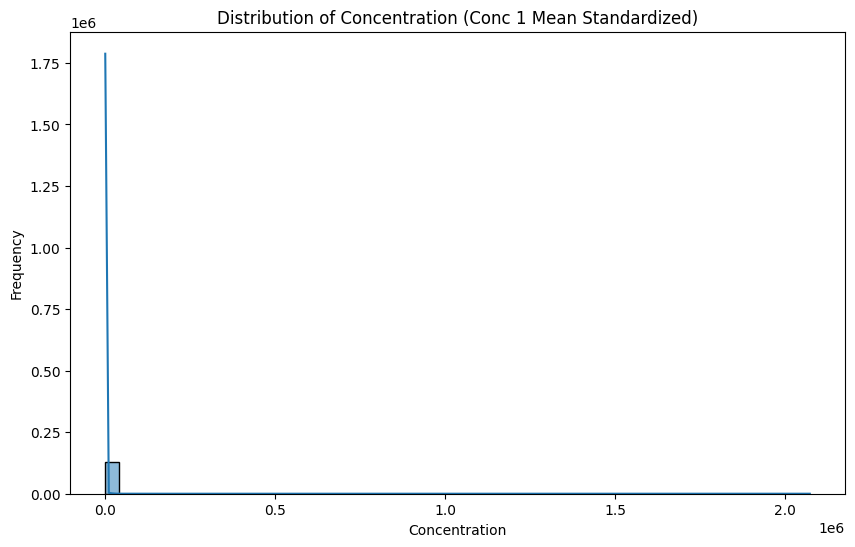

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and 'Conc 1 Mean (Standardized)' is the column with concentration values

# Plotting the distribution of the concentration
plt.figure(figsize=(10, 6))
sns.histplot(df_with_inchikey['Conc 1 Mean (Standardized)'], bins=50, kde=True)
plt.title('Distribution of Concentration (Conc 1 Mean Standardized)')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()

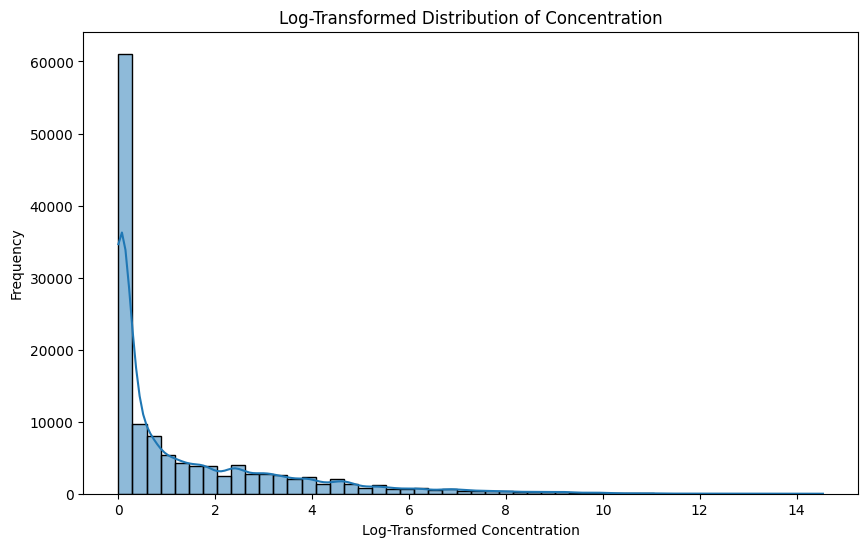

In [ ]:
import numpy as np

df_with_inchikey['Log Conc 1 Mean (Standardized)'] = np.log1p(df_with_inchikey['Conc 1 Mean (Standardized)'])

plt.figure(figsize=(10, 6))
sns.histplot(df_with_inchikey['Log Conc 1 Mean (Standardized)'], bins=50, kde=True)
plt.title('Log-Transformed Distribution of Concentration')
plt.xlabel('Log-Transformed Concentration')
plt.ylabel('Frequency')
plt.show()